<a href="https://colab.research.google.com/github/sofiammatias/tick-tick-bloom/blob/main/ticktickbloomLGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tick Tick Bloom Challenge (Driven Data)
The goal in this challenge is to use satellite imagery to detect and classify the severity of cyanobacteria blooms in small, inland water bodies. The resulting algorithm will help water quality managers better allocate resources for in situ sampling, and make more informed decisions around public health warnings for critical resources like drinking water reservoirs. Ultimately, more accurate and more timely detection of algal blooms helps keep both the human and marine life that rely on these water bodies safe and healthy.

## Imports

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 4.5 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
!pip install planetary_computer
!pip install pystac_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rioxarray
!pip install odc-stac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 54.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 KB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 3.3 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import cv2
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import odc.stac
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import geopy.distance as distance
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage
import planetary_computer as pc
from pystac_client import Client

%matplotlib inline

# Data: Collection and EDA

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files_path = '/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/'
DATA_PATH = Path.cwd().parent.resolve() / files_path

metadata_file = f'{files_path}metadata.csv'
train_labels_file = f'{files_path}train_labels.csv'
submission_file = f"{files_path}submission_format.csv"

In [ ]:
metadata = pd.read_csv(metadata_file)
train_labels = pd.read_csv(train_labels_file)
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)
train_labels_and_metadata

uid   region  severity    density   latitude  longitude        date  \
0      aabm  midwest         1      585.0  39.080319 -86.430867  2018-05-14   
1      aacd    south         1      290.0  35.875083 -78.878434  2020-11-19   
2      aaee    south         1     1614.0  35.487000 -79.062133  2016-08-24   
3      aaff  midwest         3   111825.0  38.049471 -99.827001  2019-07-23   
4      aafl  midwest         4  2017313.0  39.474744 -86.898353  2021-08-23   
...     ...      ...       ...        ...        ...        ...         ...   
17055  zzsv    south         3   113125.0  38.707825 -75.080867  2018-06-27   
17056  zzuq    south         3   175726.0  35.794000 -79.015368  2015-08-06   
17057  zzwo  midwest         2    48510.0  39.792190 -99.971050  2017-06-19   
17058  zzwq    south         1     1271.0  35.794000 -79.012551  2015-03-24   
17059  zzyb    south         1     9682.0  35.742000 -79.238600  2016-11-21   

       split  
0      train  
1      train  
2      train  
3      train  
4      train  
...      ...  
17055  train  
17056  train  
17057  train  
17058  train  
17059  train  

[17060 rows x 8 columns]

## Metadata.csv

In [ ]:
metadata = pd.read_csv(metadata_file)

### Location

In [ ]:
display(metadata.head())
metadata.split.value_counts(dropna=False)

uid   latitude   longitude        date  split
0  aabm  39.080319  -86.430867  2018-05-14  train
1  aabn  36.559700 -121.510000  2016-08-31   test
2  aacd  35.875083  -78.878434  2020-11-19  train
3  aaee  35.487000  -79.062133  2016-08-24  train
4  aaff  38.049471  -99.827001  2019-07-23  train

train    17060
test      6510
Name: split, dtype: int64

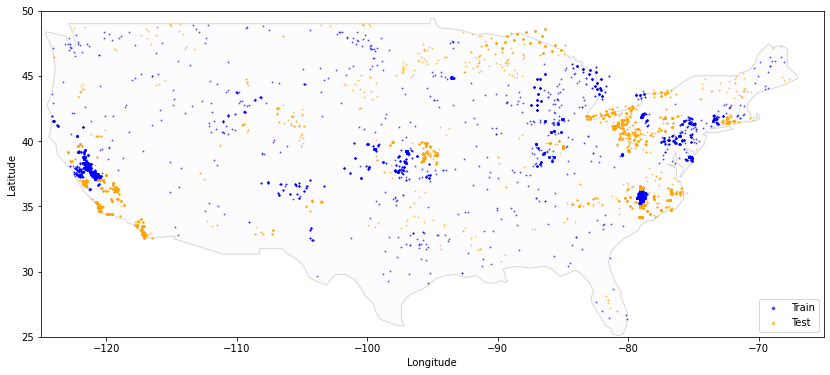

In [ ]:
# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(15, 6))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

### Date

min_date   max_date
split                      
test  2013-01-08 2021-12-29
train 2013-01-04 2021-12-14

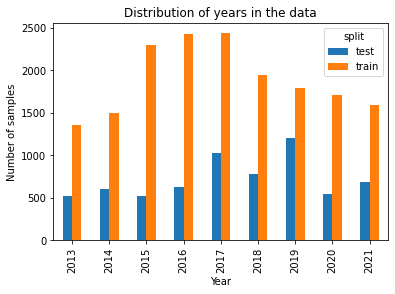

In [ ]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
display (metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max)))

# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")
plt.show()

Seasons


summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

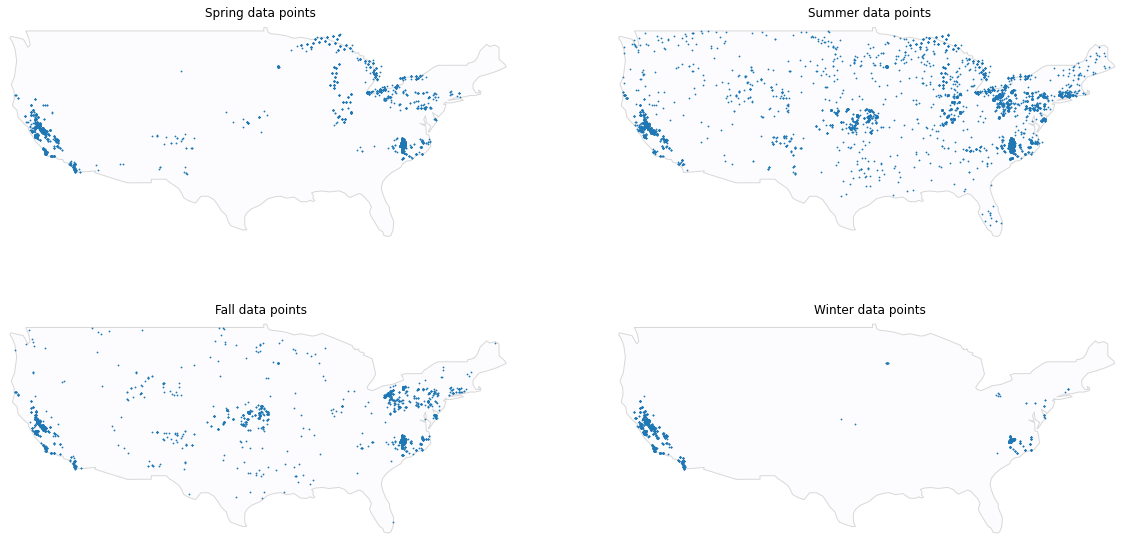

In [ ]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
print ('Seasons')
display(metadata.season.value_counts())

# where is data from for each season?
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

## Train Labels.csv

In [ ]:
train_labels = pd.read_csv(train_labels_file)

In [ ]:
display(train_labels.head())
train_labels.shape

uid   region  severity    density
0  aabm  midwest         1      585.0
1  aacd    south         1      290.0
2  aaee    south         1     1614.0
3  aaff  midwest         3   111825.0
4  aafl  midwest         4  2017313.0

(17060, 4)

In [ ]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)
train_labels_and_metadata

uid   region  severity    density   latitude  longitude       date  \
0      aabm  midwest         1      585.0  39.080319 -86.430867 2018-05-14   
1      aacd    south         1      290.0  35.875083 -78.878434 2020-11-19   
2      aaee    south         1     1614.0  35.487000 -79.062133 2016-08-24   
3      aaff  midwest         3   111825.0  38.049471 -99.827001 2019-07-23   
4      aafl  midwest         4  2017313.0  39.474744 -86.898353 2021-08-23   
...     ...      ...       ...        ...        ...        ...        ...   
17055  zzsv    south         3   113125.0  38.707825 -75.080867 2018-06-27   
17056  zzuq    south         3   175726.0  35.794000 -79.015368 2015-08-06   
17057  zzwo  midwest         2    48510.0  39.792190 -99.971050 2017-06-19   
17058  zzwq    south         1     1271.0  35.794000 -79.012551 2015-03-24   
17059  zzyb    south         1     9682.0  35.742000 -79.238600 2016-11-21   

       split  season  
0      train  spring  
1      train    fall  
2      train  summer  
3      train  summer  
4      train  summer  
...      ...     ...  
17055  train  summer  
17056  train  summer  
17057  train  summer  
17058  train  spring  
17059  train    fall  

[17060 rows x 9 columns]

[0.00339977 0.20791325 0.15937866 0.18985932 0.439449  ]


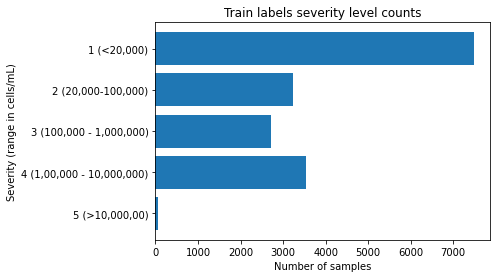

In [ ]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")
weights = severity_counts.values /severity_counts.values.sum()
print (weights)

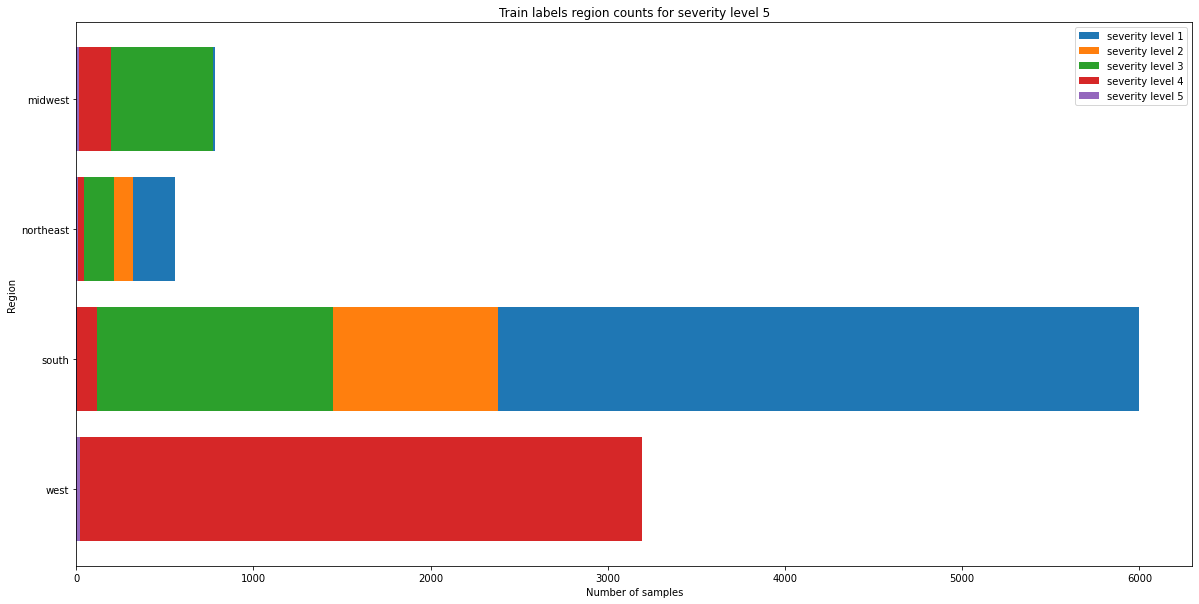

In [ ]:
plt.figure (figsize=(20,10))

for severity_level in range(1, 6):
  region_counts = train_labels[train_labels.severity == severity_level].region.value_counts().sort_index(ascending=False)
  ax = plt.barh(region_counts.index, region_counts.values, label = f'severity level {severity_level}')

plt.xlabel("Number of samples")
plt.ylabel("Region")
plt.title(f'Train labels region counts for severity level {severity_level}')
plt.legend ()

In [ ]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

# Process Feature Data

Feature data is not provided directly. Instead, access to all feature data can only be done through **external, publicly available APIs**. Relevant imagery can be identified using the location and date of each sample, listed in metadata.csv.

Pull in matching satellite imagery will be done using Microsoft's Planetary Computer. Use only **Sentinel-2 L2A** and **Landsat Level-2** satellite imagery. Sentinel-2 L1C and Landsat Level-1 imagery are also allowed.

In [ ]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

## Location range: 
search an area with 50,000 meters on either side of our sample point (100,000 m x 100,000 m), to make sure we're pulling in all relevant imagery. This is just a starting point, and you can improve on how to best search for the correct location in the Planetary Computer.

## Time range: 
We want our feature data to be as close to the time of the sample as possible, because in algal blooms in small water bodies form and move very rapidly. Remember, you cannot use any data collected after the date of the sample.

Imagery taken with roughly 10 days of the sample will generally still be an accurate representation of environmental conditions at the time of the sample. For some data points you may not be able to get data within 10 days, and may have to use earlier data. We'll search the fifteen days up to the sample time, including the sample date.

# Functions

In this section I am keeping all functions required to build the process data/pipeline

In [ ]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [ ]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


In [ ]:
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])

In [ ]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    
    image = rioxarray.open_rasterio(pc.sign(item.assets['visual'].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [ ]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

In [ ]:
def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()

    return averages + medians 

# Select and Process one Image
We will get one example image to understand the process and change it if required. 

In [ ]:
train_labels_and_metadata[(train_labels_and_metadata.region == 'west') & (train_labels_and_metadata.severity == 5)]

uid region  severity       density   latitude   longitude       date  \
70     acuf   west         5  2.322844e+07  41.964856 -110.654119 2018-08-22   
443    arkx   west         5  2.081200e+07  43.691600 -109.997870 2020-09-22   
1019   bown   west         5  1.101000e+07  38.590100 -121.731000 2018-03-14   
2497   dulv   west         5  1.241500e+07  37.386500 -121.969000 2018-07-17   
3201   ewcd   west         5  1.002500e+07  38.590100 -121.731000 2018-11-23   
3438   fgio   west         5  2.211159e+07  41.503620 -111.022120 2021-09-01   
3950   garm   west         5  1.226775e+07  41.980060 -110.657340 2021-09-27   
4287   gnlr   west         5  7.181390e+07  43.329370 -108.156190 2021-08-17   
4488   gvtb   west         5  1.012500e+07  38.590100 -121.731000 2018-07-17   
6183   jljl   west         5  1.848545e+07  43.176850 -108.614650 2021-09-14   
7793   ltvs   west         5  1.009000e+07  38.307000 -121.794000 2019-11-20   
8360   mrrk   west         5  4.260262e+07  44.359408 -104.833233 2019-09-09   
8500   mwlg   west         5  1.032000e+07  37.320400 -120.983000 2020-05-12   
9506   omai   west         5  4.356760e+07  42.217010 -109.370990 2021-08-31   
10068  phbj   west         5  4.173844e+07  42.216650 -109.370810 2021-07-26   
10848  qlud   west         5  1.128919e+07  43.400530 -108.169300 2019-09-05   
10964  qqhw   west         5  1.096000e+07  38.307000 -121.794000 2018-07-17   
12379  sulb   west         5  1.855960e+07  41.503570 -111.022560 2021-07-27   
12753  tiyi   west         5  1.026000e+07  38.590100 -121.731000 2018-05-15   
12997  ttnt   west         5  3.069283e+07  41.980760 -110.657250 2019-09-12   
13200  ubka   west         5  1.027750e+07  38.307000 -121.794000 2014-07-15   
13534  upoe   west         5  1.781560e+07  41.469360 -111.023320 2019-07-17   
16612  zhie   west         5  2.183120e+07  43.769670 -110.026220 2020-09-22   

       split  season  
70     train  summer  
443    train    fall  
1019   train  spring  
2497   train  summer  
3201   train    fall  
3438   train    fall  
3950   train    fall  
4287   train  summer  
4488   train  summer  
6183   train    fall  
7793   train    fall  
8360   train    fall  
8500   train  spring  
9506   train  summer  
10068  train  summer  
10848  train    fall  
10964  train  summer  
12379  train  summer  
12753  train  spring  
12997  train    fall  
13200  train  summer  
13534  train  summer  
16612  train    fall

In [ ]:
example_row = metadata[metadata.uid == "gygq"].iloc[0]
example_row

uid                         gygq
latitude                36.04246
longitude               -85.5897
date         2017-06-06 00:00:00
split                      train
season                    summer
Name: 6274, dtype: object

## Selection steps

In [ ]:
#Get bounding box of interest area
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
print ('\nBounding box:\n\n',bbox)

# get our date range to search, and format correctly for query
date_range = get_date_range(example_row.date).replace('T', '')
print ('\nDate range:\n\n',date_range)

# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
print ('\nItems found:\n\n',len(items))

#Select best item



Bounding box:

 [-86.1445385452939, 35.59182936410876, -85.03486145470609, 36.49305669671039]

Date range:

 2017-05-22/2017-06-06

Items found:

 16


In [ ]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 16 returned to 5 items that contain the sample location


datetime     platform  contains_sample_point  \
10  2017-05-28  Sentinel-2A                   True   
8   2017-05-29    landsat-7                   True   
2   2017-06-04  Sentinel-2A                   True   
3   2017-06-04  Sentinel-2A                   True   
0   2017-06-06    landsat-8                   True   

                                                 bbox  
10  [-85.90214616115193, 35.14733836420235, -85.40...  
8   [-86.81803446, 35.06359482, -84.09019151, 37.0...  
2   [-85.88976030868119, 36.03410504881955, -84.64...  
3   [-85.90214616115193, 35.13300633202725, -84.66...  
0   [-86.72291427, 34.96754482, -84.14081132, 37.0...

In [ ]:
#Select best item
# 1 - filter to sentinel
# 2 - take closest by date
best_item, item_platform, item_date = select_best_item(
                    items, example_row.date, example_row.latitude, example_row.longitude
                )

item = best_item

# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [ ]:
item

<Item id=S2A_MSIL2A_20170604T162341_R040_T16SFF_20210209T202957>

## Visualizing Sentinel-2 imagery

To keep things simple, we'll just choose one image to input into our model. Keep in mind that it is possible to incorporate multiple images!

We'll narrow to one image in two steps:

- If any Sentinel imagery is available, filter to only Sentinel imagery. Sentinel-2 is higher resolution than Landsat, which is extremely helpful for blooms in small water bodies. In this case, two images are from Sentinel and contain the actual sample location.
- Select the item that is the closest time wise to the sampling date. This gives us a Sentinel-2A item that was captured on 10/20/2022 - two days before our sample was collected on 10/22.

This is a very simple way to choose the best image. 

Be aware that querying the Planetary Computer for all of the images is going to take a LONG time! You'll want to find ways to both save work as you go, and optimize your code for efficiency.

In [ ]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

Array shape: (746, 1624)


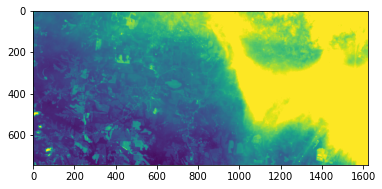

In [ ]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=8000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

print ('Array shape:', zoomed_img_array[0].shape)
zoomed_img_array[0]
plt.imshow(zoomed_img_array[0,:,:]) #See other bands


In [ ]:
# Solution to consider approx. water volumes, using SCL images:
# sum((zoomed_img_array[0, 1, :] == 6).astype(int) * (meter_buffer / zoomed_img_array.shape[-1]) ** 2)

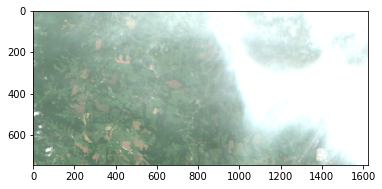

In [ ]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order

plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0])) #- see visual
#plt.imshow(zoomed_img_array[0,:,:]) #See other bands

## Visualizing Landsat imagery

STAC items from Sentinel and from Landsat are slightly different, so we'll have to use slightly different methods to pull imagery based on its satellite 

In [ ]:
landsat_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sample(n=1, random_state=3)
    .iloc[0]
)
print ('\nLandsat image data:\n\n', landsat_item)

item = landsat_item.item_obj

# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
print ('\nRescaled numpy array image:\n\n', landsat_image_array[0].shape, landsat_image_array[0]) #numpy array

# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
print ('\nNot scaled image:\n\n', image_array[0])


Landsat image data:

 datetime                                                        2017-05-29
platform                                                         landsat-7
min_long                                                        -86.818034
max_long                                                        -84.090192
min_lat                                                          35.063595
max_lat                                                          37.011955
bbox                     [-86.81803446, 35.06359482, -84.09019151, 37.0...
item_obj                         <Item id=LE07_L2SP_020035_20170529_02_T1>
contains_sample_point                                                 True
Name: 8, dtype: object

Rescaled numpy array image:

 (542, 542) [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]

Not scaled image:

 <xarray.DataArray (y: 54

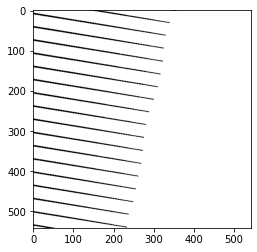

In [ ]:
#Show rescaled image
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

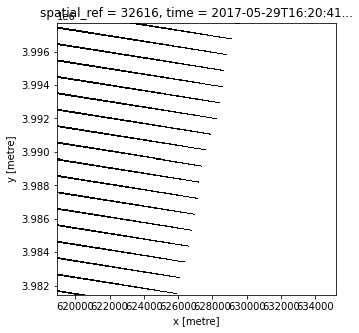

In [ ]:
# image appears differently without rescaling
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)

## Getting from image to features

In [ ]:
zoomed_img_array

array([[[174, 171, 173, ..., 255, 255, 255],
        [175, 172, 170, ..., 255, 255, 255],
        [177, 175, 171, ..., 255, 255, 255],
        ...,
        [114, 109, 104, ..., 255, 255, 255],
        [113, 115, 111, ..., 255, 255, 255],
        [108, 114, 116, ..., 255, 255, 255]],

       [[183, 182, 185, ..., 255, 255, 255],
        [185, 184, 181, ..., 255, 255, 255],
        [185, 184, 181, ..., 255, 255, 255],
        ...,
        [143, 143, 142, ..., 255, 255, 255],
        [141, 148, 148, ..., 255, 255, 255],
        [137, 142, 148, ..., 255, 255, 255]],

       [[168, 164, 166, ..., 255, 255, 255],
        [170, 167, 164, ..., 255, 255, 255],
        [168, 167, 165, ..., 255, 255, 255],
        ...,
        [116, 114, 107, ..., 255, 255, 255],
        [115, 120, 115, ..., 255, 255, 255],
        [108, 115, 121, ..., 255, 255, 255]]], dtype=uint8)

In [ ]:
 image_features_S2 = image_to_features(zoomed_img_array)
 print ('Red-green-blue averages and medians for Sentinel:\n', image_features_S2)
 image_features_landsat = image_to_features(landsat_image_array)
 print ('Red-green-blue averages and medians for Landsat:\n', image_features_landsat)

Red-green-blue averages and medians for Sentinel:
 [179.7493033452634, 198.02102180430276, 187.15164704367464, 167.0, 189.0, 176.0]
Red-green-blue averages and medians for Landsat:
 [242.21718794678722, 242.21718794678722, 242.21718794678722, 255.0, 255.0, 255.0]


# Getting All Images ("production")

We'll save out the processed features for each image as we go, to make sure we only have to run time-intensive parts of our code once.

For time, here we'll train on a randomly selected small subset of the training data. The cell below is highly time intensive, because for each row in the data we have to query the planetary computer catalog and process imagery.

We'll still include and predict on all of the test data.

In [ ]:
meter_buffer_init = 50000
meter_buffer_param = 100
time_buffer = 45
enlarged_meter_buffer = 6000
errored_ids = {}
Sband = 'visual' 

In [ ]:
# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = DATA_PATH / "image_arrays"
IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)

# take a random subset of the training data for the benchmark
train_subset = metadata[metadata["split"] == "train"].sample(n=8500, random_state=42)
# winner parameters: 8500, random_state=2

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

train    8500
test     6510
Name: split, dtype: int64

## Images (red, blue, green)

In [ ]:
# this cell takes a LONG time because it iterates over all data!
# save outputs in dictionaries
selected_items = {}
features_dict = {}

i=0

for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):

    # check if we've already saved the selected image array
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"
    print ('\nGetting image array nº', i,' from ',len(metadata_subset))


    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)
        # convert image to 1-dimensional features
        image_features = image_to_features(image_array)
        features_dict[row.uid] = image_features
        print ('\nImage array nº',i,'from disk\n\n') 


    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15).replace('T', '')

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=100
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            with open(image_array_pth, "wb") as f:
                np.save(f, image_array)

            # convert image to 1-dimensional features
            image_features = image_to_features(image_array)
            features_dict[row.uid] = image_features
            print ('Downloaded image array nº',i,'from STAC\n\n') 


        # keep track of any that ran into errors without interrupting the process
        except Exception as e:
            print (e) 
            errored_ids[row.uid] = e
    i += 1

  0%|          | 17/15010 [00:00<02:51, 87.44it/s]


Getting image array nº 0  from  15010

Image array nº 0 from disk



Getting image array nº 1  from  15010

Image array nº 1 from disk



Getting image array nº 2  from  15010

Image array nº 2 from disk



Getting image array nº 3  from  15010

Image array nº 3 from disk



Getting image array nº 4  from  15010

Image array nº 4 from disk



Getting image array nº 5  from  15010

Image array nº 5 from disk



Getting image array nº 6  from  15010

Image array nº 6 from disk



Getting image array nº 7  from  15010

Image array nº 7 from disk



Getting image array nº 8  from  15010

Image array nº 8 from disk



Getting image array nº 9  from  15010

Image array nº 9 from disk



Getting image array nº 10  from  15010

Image array nº 10 from disk



Getting image array nº 11  from  15010

Image array nº 11 from disk



Getting image array nº 12  from  15010

Image array nº 12 from disk



Getting image array nº 13  from  15010

Image array nº 13 from disk



Getting image array nº 14

  0%|          | 36/15010 [00:00<01:58, 126.34it/s]


Image array nº 22 from disk



Getting image array nº 23  from  15010

Image array nº 23 from disk



Getting image array nº 24  from  15010

Image array nº 24 from disk



Getting image array nº 25  from  15010

Image array nº 25 from disk



Getting image array nº 26  from  15010

Image array nº 26 from disk



Getting image array nº 27  from  15010

Image array nº 27 from disk



Getting image array nº 28  from  15010

Image array nº 28 from disk



Getting image array nº 29  from  15010

Image array nº 29 from disk



Getting image array nº 30  from  15010

Image array nº 30 from disk



Getting image array nº 31  from  15010

Image array nº 31 from disk



Getting image array nº 32  from  15010

Image array nº 32 from disk



Getting image array nº 33  from  15010

Image array nº 33 from disk



Getting image array nº 34  from  15010

Image array nº 34 from disk



Getting image array nº 35  from  15010

Image array nº 35 from disk



Getting image array nº 36  from  15010

Image

  0%|          | 50/15010 [00:00<02:12, 112.54it/s]


Image array nº 49 from disk



Getting image array nº 50  from  15010

Image array nº 50 from disk



Getting image array nº 51  from  15010

Image array nº 51 from disk



Getting image array nº 52  from  15010

Image array nº 52 from disk



Getting image array nº 53  from  15010

Image array nº 53 from disk



Getting image array nº 54  from  15010

Image array nº 54 from disk



Getting image array nº 55  from  15010

Image array nº 55 from disk



Getting image array nº 56  from  15010


  0%|          | 71/15010 [00:00<03:25, 72.83it/s]


Image array nº 56 from disk



Getting image array nº 57  from  15010

Image array nº 57 from disk



Getting image array nº 58  from  15010

Image array nº 58 from disk



Getting image array nº 59  from  15010

Image array nº 59 from disk



Getting image array nº 60  from  15010

Image array nº 60 from disk



Getting image array nº 61  from  15010

Image array nº 61 from disk



Getting image array nº 62  from  15010

Image array nº 62 from disk



Getting image array nº 63  from  15010

Image array nº 63 from disk



Getting image array nº 64  from  15010

Image array nº 64 from disk



Getting image array nº 65  from  15010

Image array nº 65 from disk



Getting image array nº 66  from  15010

Image array nº 66 from disk



Getting image array nº 67  from  15010

Image array nº 67 from disk



Getting image array nº 68  from  15010

Image array nº 68 from disk



Getting image array nº 69  from  15010

Image array nº 69 from disk



Getting image array nº 70  from  15010

Image

  1%|          | 90/15010 [00:00<02:29, 99.61it/s]


Getting image array nº 71  from  15010

Image array nº 71 from disk



Getting image array nº 72  from  15010

Image array nº 72 from disk



Getting image array nº 73  from  15010

Image array nº 73 from disk



Getting image array nº 74  from  15010

Image array nº 74 from disk



Getting image array nº 75  from  15010

Image array nº 75 from disk



Getting image array nº 76  from  15010

Image array nº 76 from disk



Getting image array nº 77  from  15010

Image array nº 77 from disk



Getting image array nº 78  from  15010

Image array nº 78 from disk



Getting image array nº 79  from  15010

Image array nº 79 from disk



Getting image array nº 80  from  15010

Image array nº 80 from disk



Getting image array nº 81  from  15010

Image array nº 81 from disk



Getting image array nº 82  from  15010

Image array nº 82 from disk



Getting image array nº 83  from  15010

Image array nº 83 from disk



Getting image array nº 84  from  15010

Image array nº 84 from disk



Getti

  1%|          | 108/15010 [00:01<02:06, 117.54it/s]


Image array nº 107 from disk



Getting image array nº 108  from  15010

Image array nº 108 from disk



Getting image array nº 109  from  15010

Image array nº 109 from disk



Getting image array nº 110  from  15010

Image array nº 110 from disk



Getting image array nº 111  from  15010

Image array nº 111 from disk



Getting image array nº 112  from  15010

Image array nº 112 from disk



Getting image array nº 113  from  15010


  1%|          | 139/15010 [00:02<05:35, 44.33it/s]

No data found in bounds.

Getting image array nº 114  from  15010

Image array nº 114 from disk



Getting image array nº 115  from  15010

Image array nº 115 from disk



Getting image array nº 116  from  15010

Image array nº 116 from disk



Getting image array nº 117  from  15010

Image array nº 117 from disk



Getting image array nº 118  from  15010

Image array nº 118 from disk



Getting image array nº 119  from  15010

Image array nº 119 from disk



Getting image array nº 120  from  15010

Image array nº 120 from disk



Getting image array nº 121  from  15010

Image array nº 121 from disk



Getting image array nº 122  from  15010

Image array nº 122 from disk



Getting image array nº 123  from  15010

Image array nº 123 from disk



Getting image array nº 124  from  15010

Image array nº 124 from disk



Getting image array nº 125  from  15010

Image array nº 125 from disk



Getting image array nº 126  from  15010

Image array nº 126 from disk



Getting image array nº 12

  1%|          | 168/15010 [00:02<03:36, 68.54it/s]


Image array nº 139 from disk



Getting image array nº 140  from  15010

Image array nº 140 from disk



Getting image array nº 141  from  15010

Image array nº 141 from disk



Getting image array nº 142  from  15010

Image array nº 142 from disk



Getting image array nº 143  from  15010

Image array nº 143 from disk



Getting image array nº 144  from  15010

Image array nº 144 from disk



Getting image array nº 145  from  15010

Image array nº 145 from disk



Getting image array nº 146  from  15010

Image array nº 146 from disk



Getting image array nº 147  from  15010

Image array nº 147 from disk



Getting image array nº 148  from  15010

Image array nº 148 from disk



Getting image array nº 149  from  15010

Image array nº 149 from disk



Getting image array nº 150  from  15010

Image array nº 150 from disk



Getting image array nº 151  from  15010

Image array nº 151 from disk



Getting image array nº 152  from  15010

Image array nº 152 from disk



Getting image arra

  1%|▏         | 196/15010 [00:02<02:44, 89.79it/s]


Image array nº 170 from disk



Getting image array nº 171  from  15010

Image array nº 171 from disk



Getting image array nº 172  from  15010

Image array nº 172 from disk



Getting image array nº 173  from  15010

Image array nº 173 from disk



Getting image array nº 174  from  15010

Image array nº 174 from disk



Getting image array nº 175  from  15010

Image array nº 175 from disk



Getting image array nº 176  from  15010

Image array nº 176 from disk



Getting image array nº 177  from  15010

Image array nº 177 from disk



Getting image array nº 178  from  15010

Image array nº 178 from disk



Getting image array nº 179  from  15010

Image array nº 179 from disk



Getting image array nº 180  from  15010

Image array nº 180 from disk



Getting image array nº 181  from  15010

Image array nº 181 from disk



Getting image array nº 182  from  15010

Image array nº 182 from disk



Getting image array nº 183  from  15010

Image array nº 183 from disk



Getting image arra

  1%|▏         | 213/15010 [00:02<02:20, 105.27it/s]


Image array nº 196 from disk



Getting image array nº 197  from  15010

Image array nº 197 from disk



Getting image array nº 198  from  15010

Image array nº 198 from disk



Getting image array nº 199  from  15010

Image array nº 199 from disk



Getting image array nº 200  from  15010

Image array nº 200 from disk



Getting image array nº 201  from  15010

Image array nº 201 from disk



Getting image array nº 202  from  15010

Image array nº 202 from disk



Getting image array nº 203  from  15010

Image array nº 203 from disk



Getting image array nº 204  from  15010

Image array nº 204 from disk



Getting image array nº 205  from  15010

Image array nº 205 from disk



Getting image array nº 206  from  15010

Image array nº 206 from disk



Getting image array nº 207  from  15010

Image array nº 207 from disk



Getting image array nº 208  from  15010

Image array nº 208 from disk



Getting image array nº 209  from  15010

Image array nº 209 from disk



Getting image arra

  2%|▏         | 243/15010 [00:03<02:10, 113.31it/s]


Image array nº 225 from disk



Getting image array nº 226  from  15010

Image array nº 226 from disk



Getting image array nº 227  from  15010

Image array nº 227 from disk



Getting image array nº 228  from  15010

Image array nº 228 from disk



Getting image array nº 229  from  15010

Image array nº 229 from disk



Getting image array nº 230  from  15010

Image array nº 230 from disk



Getting image array nº 231  from  15010

Image array nº 231 from disk



Getting image array nº 232  from  15010

Image array nº 232 from disk



Getting image array nº 233  from  15010

Image array nº 233 from disk



Getting image array nº 234  from  15010

Image array nº 234 from disk



Getting image array nº 235  from  15010

Image array nº 235 from disk



Getting image array nº 236  from  15010

Image array nº 236 from disk



Getting image array nº 237  from  15010

Image array nº 237 from disk



Getting image array nº 238  from  15010

Image array nº 238 from disk



Getting image arra

  2%|▏         | 272/15010 [00:03<01:57, 125.47it/s]


Image array nº 251 from disk



Getting image array nº 252  from  15010

Image array nº 252 from disk



Getting image array nº 253  from  15010

Image array nº 253 from disk



Getting image array nº 254  from  15010

Image array nº 254 from disk



Getting image array nº 255  from  15010

Image array nº 255 from disk



Getting image array nº 256  from  15010

Image array nº 256 from disk



Getting image array nº 257  from  15010

Image array nº 257 from disk



Getting image array nº 258  from  15010

Image array nº 258 from disk



Getting image array nº 259  from  15010

Image array nº 259 from disk



Getting image array nº 260  from  15010

Image array nº 260 from disk



Getting image array nº 261  from  15010

Image array nº 261 from disk



Getting image array nº 262  from  15010

Image array nº 262 from disk



Getting image array nº 263  from  15010

Image array nº 263 from disk



Getting image array nº 264  from  15010

Image array nº 264 from disk



Getting image arra

  2%|▏         | 300/15010 [00:03<02:05, 117.52it/s]


Image array nº 281 from disk



Getting image array nº 282  from  15010

Image array nº 282 from disk



Getting image array nº 283  from  15010

Image array nº 283 from disk



Getting image array nº 284  from  15010

Image array nº 284 from disk



Getting image array nº 285  from  15010

Image array nº 285 from disk



Getting image array nº 286  from  15010

Image array nº 286 from disk



Getting image array nº 287  from  15010

Image array nº 287 from disk



Getting image array nº 288  from  15010

Image array nº 288 from disk



Getting image array nº 289  from  15010

Image array nº 289 from disk



Getting image array nº 290  from  15010

Image array nº 290 from disk



Getting image array nº 291  from  15010

Image array nº 291 from disk



Getting image array nº 292  from  15010

Image array nº 292 from disk



Getting image array nº 293  from  15010

Image array nº 293 from disk



Getting image array nº 294  from  15010

Image array nº 294 from disk



Getting image arra

  2%|▏         | 331/15010 [00:03<01:50, 132.75it/s]


Image array nº 303 from disk



Getting image array nº 304  from  15010

Image array nº 304 from disk



Getting image array nº 305  from  15010

Image array nº 305 from disk



Getting image array nº 306  from  15010

Image array nº 306 from disk



Getting image array nº 307  from  15010

Image array nº 307 from disk



Getting image array nº 308  from  15010

Image array nº 308 from disk



Getting image array nº 309  from  15010

Image array nº 309 from disk



Getting image array nº 310  from  15010

Image array nº 310 from disk



Getting image array nº 311  from  15010

Image array nº 311 from disk



Getting image array nº 312  from  15010

Image array nº 312 from disk



Getting image array nº 313  from  15010

Image array nº 313 from disk



Getting image array nº 314  from  15010

Image array nº 314 from disk



Getting image array nº 315  from  15010

Image array nº 315 from disk



Getting image array nº 316  from  15010

Image array nº 316 from disk



Getting image arra

  2%|▏         | 365/15010 [00:04<01:38, 148.38it/s]

335  from  15010

Image array nº 335 from disk



Getting image array nº 336  from  15010

Image array nº 336 from disk



Getting image array nº 337  from  15010

Image array nº 337 from disk



Getting image array nº 338  from  15010

Image array nº 338 from disk



Getting image array nº 339  from  15010

Image array nº 339 from disk



Getting image array nº 340  from  15010

Image array nº 340 from disk



Getting image array nº 341  from  15010

Image array nº 341 from disk



Getting image array nº 342  from  15010

Image array nº 342 from disk



Getting image array nº 343  from  15010

Image array nº 343 from disk



Getting image array nº 344  from  15010

Image array nº 344 from disk



Getting image array nº 345  from  15010

Image array nº 345 from disk



Getting image array nº 346  from  15010

Image array nº 346 from disk



Getting image array nº 347  from  15010

Image array nº 347 from disk



Getting image array nº 348  from  15010

Image array nº 348 from disk



G

  3%|▎         | 384/15010 [00:04<01:33, 156.76it/s]


Image array nº 368 from disk



Getting image array nº 369  from  15010

Image array nº 369 from disk



Getting image array nº 370  from  15010

Image array nº 370 from disk



Getting image array nº 371  from  15010

Image array nº 371 from disk



Getting image array nº 372  from  15010

Image array nº 372 from disk



Getting image array nº 373  from  15010

Image array nº 373 from disk



Getting image array nº 374  from  15010

Image array nº 374 from disk



Getting image array nº 375  from  15010

Image array nº 375 from disk



Getting image array nº 376  from  15010

Image array nº 376 from disk



Getting image array nº 377  from  15010

Image array nº 377 from disk



Getting image array nº 378  from  15010

Image array nº 378 from disk



Getting image array nº 379  from  15010

Image array nº 379 from disk



Getting image array nº 380  from  15010

Image array nº 380 from disk



Getting image array nº 381  from  15010

Image array nº 381 from disk



Getting image arra

  3%|▎         | 418/15010 [00:04<01:40, 144.91it/s]


Image array nº 399 from disk



Getting image array nº 400  from  15010

Image array nº 400 from disk



Getting image array nº 401  from  15010

Image array nº 401 from disk



Getting image array nº 402  from  15010

Image array nº 402 from disk



Getting image array nº 403  from  15010

Image array nº 403 from disk



Getting image array nº 404  from  15010

Image array nº 404 from disk



Getting image array nº 405  from  15010

Image array nº 405 from disk



Getting image array nº 406  from  15010

Image array nº 406 from disk



Getting image array nº 407  from  15010

Image array nº 407 from disk



Getting image array nº 408  from  15010

Image array nº 408 from disk



Getting image array nº 409  from  15010

Image array nº 409 from disk



Getting image array nº 410  from  15010

Image array nº 410 from disk



Getting image array nº 411  from  15010

Image array nº 411 from disk



Getting image array nº 412  from  15010

Image array nº 412 from disk



Getting image arra

  3%|▎         | 455/15010 [00:04<01:31, 158.82it/s]


Image array nº 435 from disk



Getting image array nº 436  from  15010

Image array nº 436 from disk



Getting image array nº 437  from  15010

Image array nº 437 from disk



Getting image array nº 438  from  15010

Image array nº 438 from disk



Getting image array nº 439  from  15010

Image array nº 439 from disk



Getting image array nº 440  from  15010

Image array nº 440 from disk



Getting image array nº 441  from  15010

Image array nº 441 from disk



Getting image array nº 442  from  15010

Image array nº 442 from disk



Getting image array nº 443  from  15010

Image array nº 443 from disk



Getting image array nº 444  from  15010

Image array nº 444 from disk



Getting image array nº 445  from  15010

Image array nº 445 from disk



Getting image array nº 446  from  15010

Image array nº 446 from disk



Getting image array nº 447  from  15010

Image array nº 447 from disk



Getting image array nº 448  from  15010

Image array nº 448 from disk



Getting image arra

  3%|▎         | 472/15010 [00:04<01:45, 138.05it/s]


Image array nº 470 from disk



Getting image array nº 471  from  15010

Image array nº 471 from disk



Getting image array nº 472  from  15010

Image array nº 472 from disk



Getting image array nº 473  from  15010

Image array nº 473 from disk



Getting image array nº 474  from  15010

Image array nº 474 from disk



Getting image array nº 475  from  15010

Image array nº 475 from disk



Getting image array nº 476  from  15010

Image array nº 476 from disk



Getting image array nº 477  from  15010

Image array nº 477 from disk



Getting image array nº 478  from  15010

Image array nº 478 from disk



Getting image array nº 479  from  15010

Image array nº 479 from disk



Getting image array nº 480  from  15010

Image array nº 480 from disk



Getting image array nº 481  from  15010

Image array nº 481 from disk



Getting image array nº 482  from  15010

Image array nº 482 from disk



Getting image array nº 483  from  15010

Image array nº 483 from disk



Getting image arra

  3%|▎         | 487/15010 [00:04<02:12, 109.68it/s]


Image array nº 484 from disk



Getting image array nº 485  from  15010

Image array nº 485 from disk



Getting image array nº 486  from  15010

Image array nº 486 from disk



Getting image array nº 487  from  15010

Image array nº 487 from disk



Getting image array nº 488  from  15010

Image array nº 488 from disk



Getting image array nº 489  from  15010

Image array nº 489 from disk



Getting image array nº 490  from  15010

Image array nº 490 from disk



Getting image array nº 491  from  15010

Image array nº 491 from disk



Getting image array nº 492  from  15010

Image array nº 492 from disk



Getting image array nº 493  from  15010

Image array nº 493 from disk



Getting image array nº 494  from  15010

Image array nº 494 from disk



Getting image array nº 495  from  15010


  3%|▎         | 517/15010 [00:06<05:16, 45.82it/s]

No data found in bounds.

Getting image array nº 496  from  15010

Image array nº 496 from disk



Getting image array nº 497  from  15010

Image array nº 497 from disk



Getting image array nº 498  from  15010

Image array nº 498 from disk



Getting image array nº 499  from  15010

Image array nº 499 from disk



Getting image array nº 500  from  15010

Image array nº 500 from disk



Getting image array nº 501  from  15010

Image array nº 501 from disk



Getting image array nº 502  from  15010

Image array nº 502 from disk



Getting image array nº 503  from  15010

Image array nº 503 from disk



Getting image array nº 504  from  15010

Image array nº 504 from disk



Getting image array nº 505  from  15010

Image array nº 505 from disk



Getting image array nº 506  from  15010

Image array nº 506 from disk



Getting image array nº 507  from  15010

Image array nº 507 from disk



Getting image array nº 508  from  15010

Image array nº 508 from disk



Getting image array nº 50

  4%|▎         | 529/15010 [00:06<04:58, 48.54it/s]


Image array nº 522 from disk



Getting image array nº 523  from  15010

Image array nº 523 from disk



Getting image array nº 524  from  15010

Image array nº 524 from disk



Getting image array nº 525  from  15010

Image array nº 525 from disk



Getting image array nº 526  from  15010

Image array nº 526 from disk



Getting image array nº 527  from  15010

Image array nº 527 from disk



Getting image array nº 528  from  15010

Image array nº 528 from disk



Getting image array nº 529  from  15010

Image array nº 529 from disk



Getting image array nº 530  from  15010

Image array nº 530 from disk



Getting image array nº 531  from  15010

Image array nº 531 from disk



Getting image array nº 532  from  15010

Image array nº 532 from disk



Getting image array nº 533  from  15010

Image array nº 533 from disk



Getting image array nº 534  from  15010

Image array nº 534 from disk



Getting image array nº 535  from  15010

Image array nº 535 from disk



Getting image arra

  4%|▎         | 542/15010 [00:06<04:23, 54.99it/s]


Image array nº 540 from disk



Getting image array nº 541  from  15010

Image array nº 541 from disk



Getting image array nº 542  from  15010

Image array nº 542 from disk



Getting image array nº 543  from  15010

Image array nº 543 from disk



Getting image array nº 544  from  15010

Image array nº 544 from disk



Getting image array nº 545  from  15010

Image array nº 545 from disk



Getting image array nº 546  from  15010

Image array nº 546 from disk



Getting image array nº 547  from  15010

Image array nº 547 from disk



Getting image array nº 548  from  15010

Image array nº 548 from disk



Getting image array nº 549  from  15010

Image array nº 549 from disk



Getting image array nº 550  from  15010

Image array nº 550 from disk



Getting image array nº 551  from  15010

Image array nº 551 from disk



Getting image array nº 552  from  15010

Image array nº 552 from disk



Getting image array nº 553  from  15010


  4%|▍         | 564/15010 [00:06<03:37, 66.29it/s]


Image array nº 553 from disk



Getting image array nº 554  from  15010

Image array nº 554 from disk



Getting image array nº 555  from  15010

Image array nº 555 from disk



Getting image array nº 556  from  15010

Image array nº 556 from disk



Getting image array nº 557  from  15010

Image array nº 557 from disk



Getting image array nº 558  from  15010

Image array nº 558 from disk



Getting image array nº 559  from  15010

Image array nº 559 from disk



Getting image array nº 560  from  15010

Image array nº 560 from disk



Getting image array nº 561  from  15010

Image array nº 561 from disk



Getting image array nº 562  from  15010

Image array nº 562 from disk



Getting image array nº 563  from  15010

Image array nº 563 from disk



Getting image array nº 564  from  15010

Image array nº 564 from disk



Getting image array nº 565  from  15010

Image array nº 565 from disk



Getting image array nº 566  from  15010

Image array nº 566 from disk



Getting image arra

  4%|▍         | 574/15010 [00:06<03:33, 67.73it/s]



Image array nº 567 from disk



Getting image array nº 568  from  15010

Image array nº 568 from disk



Getting image array nº 569  from  15010

Image array nº 569 from disk



Getting image array nº 570  from  15010

Image array nº 570 from disk



Getting image array nº 571  from  15010

Image array nº 571 from disk



Getting image array nº 572  from  15010

Image array nº 572 from disk



Getting image array nº 573  from  15010

Image array nº 573 from disk



Getting image array nº 574  from  15010

Image array nº 574 from disk



Getting image array nº 575  from  15010

Image array nº 575 from disk



Getting image array nº 576  from  15010

Image array nº 576 from disk



Getting image array nº 577  from  15010

Image array nº 577 from disk



Getting image array nº 578  from  15010

Image array nº 578 from disk



Getting image array nº 579  from  15010

Image array nº 579 from disk



Getting image array nº 580  from  15010

Image array nº 580 from disk



Getting image arr

  4%|▍         | 596/15010 [00:07<03:18, 72.45it/s]


Image array nº 586 from disk



Getting image array nº 587  from  15010

Image array nº 587 from disk



Getting image array nº 588  from  15010

Image array nº 588 from disk



Getting image array nº 589  from  15010

Image array nº 589 from disk



Getting image array nº 590  from  15010

Image array nº 590 from disk



Getting image array nº 591  from  15010

Image array nº 591 from disk



Getting image array nº 592  from  15010

Image array nº 592 from disk



Getting image array nº 593  from  15010

Image array nº 593 from disk



Getting image array nº 594  from  15010

Image array nº 594 from disk



Getting image array nº 595  from  15010

Image array nº 595 from disk



Getting image array nº 596  from  15010

Image array nº 596 from disk



Getting image array nº 597  from  15010

Image array nº 597 from disk



Getting image array nº 598  from  15010

Image array nº 598 from disk



Getting image array nº 599  from  15010

Image array nº 599 from disk



Getting image arra

  4%|▍         | 628/15010 [00:07<02:18, 103.73it/s]


Image array nº 612 from disk



Getting image array nº 613  from  15010

Image array nº 613 from disk



Getting image array nº 614  from  15010

Image array nº 614 from disk



Getting image array nº 615  from  15010

Image array nº 615 from disk



Getting image array nº 616  from  15010

Image array nº 616 from disk



Getting image array nº 617  from  15010

Image array nº 617 from disk



Getting image array nº 618  from  15010

Image array nº 618 from disk



Getting image array nº 619  from  15010

Image array nº 619 from disk



Getting image array nº 620  from  15010

Image array nº 620 from disk



Getting image array nº 621  from  15010

Image array nº 621 from disk



Getting image array nº 622  from  15010

Image array nº 622 from disk



Getting image array nº 623  from  15010

Image array nº 623 from disk



Getting image array nº 624  from  15010

Image array nº 624 from disk



Getting image array nº 625  from  15010

Image array nº 625 from disk



Getting image arra

  4%|▍         | 652/15010 [00:07<02:29, 96.34it/s] 


Image array nº 637 from disk



Getting image array nº 638  from  15010

Image array nº 638 from disk



Getting image array nº 639  from  15010

Image array nº 639 from disk



Getting image array nº 640  from  15010

Image array nº 640 from disk



Getting image array nº 641  from  15010

Image array nº 641 from disk



Getting image array nº 642  from  15010

Image array nº 642 from disk



Getting image array nº 643  from  15010

Image array nº 643 from disk



Getting image array nº 644  from  15010

Image array nº 644 from disk



Getting image array nº 645  from  15010

Image array nº 645 from disk



Getting image array nº 646  from  15010

Image array nº 646 from disk



Getting image array nº 647  from  15010

Image array nº 647 from disk



Getting image array nº 648  from  15010

Image array nº 648 from disk



Getting image array nº 649  from  15010

Image array nº 649 from disk



Getting image array nº 650  from  15010

Image array nº 650 from disk



Getting image arra

  4%|▍         | 667/15010 [00:07<02:11, 109.22it/s]


Image array nº 657 from disk



Getting image array nº 658  from  15010

Image array nº 658 from disk



Getting image array nº 659  from  15010

Image array nº 659 from disk



Getting image array nº 660  from  15010

Image array nº 660 from disk



Getting image array nº 661  from  15010

Image array nº 661 from disk



Getting image array nº 662  from  15010

Image array nº 662 from disk



Getting image array nº 663  from  15010

Image array nº 663 from disk



Getting image array nº 664  from  15010

Image array nº 664 from disk



Getting image array nº 665  from  15010

Image array nº 665 from disk



Getting image array nº 666  from  15010

Image array nº 666 from disk



Getting image array nº 667  from  15010

Image array nº 667 from disk



Getting image array nº 668  from  15010

Image array nº 668 from disk



Getting image array nº 669  from  15010

Image array nº 669 from disk



Getting image array nº 670  from  15010

Image array nº 670 from disk



Getting image arra

  5%|▍         | 695/15010 [00:08<05:22, 44.40it/s]

No data found in bounds.

Getting image array nº 678  from  15010

Image array nº 678 from disk



Getting image array nº 679  from  15010

Image array nº 679 from disk



Getting image array nº 680  from  15010

Image array nº 680 from disk



Getting image array nº 681  from  15010

Image array nº 681 from disk



Getting image array nº 682  from  15010

Image array nº 682 from disk



Getting image array nº 683  from  15010

Image array nº 683 from disk



Getting image array nº 684  from  15010

Image array nº 684 from disk



Getting image array nº 685  from  15010

Image array nº 685 from disk



Getting image array nº 686  from  15010

Image array nº 686 from disk



Getting image array nº 687  from  15010

Image array nº 687 from disk



Getting image array nº 688  from  15010

Image array nº 688 from disk



Getting image array nº 689  from  15010

Image array nº 689 from disk



Getting image array nº 690  from  15010

Image array nº 690 from disk



Getting image array nº 69

  5%|▍         | 710/15010 [00:09<04:21, 54.61it/s]


Image array nº 704 from disk



Getting image array nº 705  from  15010

Image array nº 705 from disk



Getting image array nº 706  from  15010

Image array nº 706 from disk



Getting image array nº 707  from  15010

Image array nº 707 from disk



Getting image array nº 708  from  15010

Image array nº 708 from disk



Getting image array nº 709  from  15010

Image array nº 709 from disk



Getting image array nº 710  from  15010

Image array nº 710 from disk



Getting image array nº 711  from  15010

Image array nº 711 from disk



Getting image array nº 712  from  15010

Image array nº 712 from disk



Getting image array nº 713  from  15010

Image array nº 713 from disk



Getting image array nº 714  from  15010

Image array nº 714 from disk



Getting image array nº 715  from  15010

Image array nº 715 from disk



Getting image array nº 716  from  15010

Image array nº 716 from disk



Getting image array nº 717  from  15010

Image array nº 717 from disk



Getting image arra

  5%|▍         | 738/15010 [00:09<03:07, 76.19it/s]



Image array nº 719 from disk



Getting image array nº 720  from  15010

Image array nº 720 from disk



Getting image array nº 721  from  15010

Image array nº 721 from disk



Getting image array nº 722  from  15010

Image array nº 722 from disk



Getting image array nº 723  from  15010

Image array nº 723 from disk



Getting image array nº 724  from  15010

Image array nº 724 from disk



Getting image array nº 725  from  15010

Image array nº 725 from disk



Getting image array nº 726  from  15010

Image array nº 726 from disk



Getting image array nº 727  from  15010

Image array nº 727 from disk



Getting image array nº 728  from  15010

Image array nº 728 from disk



Getting image array nº 729  from  15010

Image array nº 729 from disk



Getting image array nº 730  from  15010

Image array nº 730 from disk



Getting image array nº 731  from  15010

Image array nº 731 from disk



Getting image array nº 732  from  15010

Image array nº 732 from disk



Getting image arr

  5%|▌         | 765/15010 [00:09<02:30, 94.35it/s]


Image array nº 749 from disk



Getting image array nº 750  from  15010

Image array nº 750 from disk



Getting image array nº 751  from  15010

Image array nº 751 from disk



Getting image array nº 752  from  15010

Image array nº 752 from disk



Getting image array nº 753  from  15010

Image array nº 753 from disk



Getting image array nº 754  from  15010

Image array nº 754 from disk



Getting image array nº 755  from  15010

Image array nº 755 from disk



Getting image array nº 756  from  15010

Image array nº 756 from disk



Getting image array nº 757  from  15010

Image array nº 757 from disk



Getting image array nº 758  from  15010

Image array nº 758 from disk



Getting image array nº 759  from  15010

Image array nº 759 from disk



Getting image array nº 760  from  15010

Image array nº 760 from disk



Getting image array nº 761  from  15010

Image array nº 761 from disk



Getting image array nº 762  from  15010

Image array nº 762 from disk



Getting image arra

  5%|▌         | 790/15010 [00:10<05:55, 39.96it/s]

No data found in bounds.

Getting image array nº 772  from  15010

Image array nº 772 from disk



Getting image array nº 773  from  15010

Image array nº 773 from disk



Getting image array nº 774  from  15010

Image array nº 774 from disk



Getting image array nº 775  from  15010

Image array nº 775 from disk



Getting image array nº 776  from  15010

Image array nº 776 from disk



Getting image array nº 777  from  15010

Image array nº 777 from disk



Getting image array nº 778  from  15010

Image array nº 778 from disk



Getting image array nº 779  from  15010

Image array nº 779 from disk



Getting image array nº 780  from  15010

Image array nº 780 from disk



Getting image array nº 781  from  15010

Image array nº 781 from disk



Getting image array nº 782  from  15010

Image array nº 782 from disk



Getting image array nº 783  from  15010

Image array nº 783 from disk



Getting image array nº 784  from  15010

Image array nº 784 from disk



Getting image array nº 78

  6%|▌         | 830/15010 [00:10<03:00, 78.41it/s]

  from  15010

Image array nº 803 from disk



Getting image array nº 804  from  15010

Image array nº 804 from disk



Getting image array nº 805  from  15010

Image array nº 805 from disk



Getting image array nº 806  from  15010

Image array nº 806 from disk



Getting image array nº 807  from  15010

Image array nº 807 from disk



Getting image array nº 808  from  15010

Image array nº 808 from disk



Getting image array nº 809  from  15010

Image array nº 809 from disk



Getting image array nº 810  from  15010

Image array nº 810 from disk



Getting image array nº 811  from  15010

Image array nº 811 from disk



Getting image array nº 812  from  15010

Image array nº 812 from disk



Getting image array nº 813  from  15010

Image array nº 813 from disk



Getting image array nº 814  from  15010

Image array nº 814 from disk



Getting image array nº 815  from  15010

Image array nº 815 from disk



Getting image array nº 816  from  15010

Image array nº 816 from disk



Gett

  6%|▌         | 863/15010 [00:11<02:12, 106.45it/s]


Image array nº 840 from disk



Getting image array nº 841  from  15010

Image array nº 841 from disk



Getting image array nº 842  from  15010

Image array nº 842 from disk



Getting image array nº 843  from  15010

Image array nº 843 from disk



Getting image array nº 844  from  15010

Image array nº 844 from disk



Getting image array nº 845  from  15010

Image array nº 845 from disk



Getting image array nº 846  from  15010

Image array nº 846 from disk



Getting image array nº 847  from  15010

Image array nº 847 from disk



Getting image array nº 848  from  15010

Image array nº 848 from disk



Getting image array nº 849  from  15010

Image array nº 849 from disk



Getting image array nº 850  from  15010

Image array nº 850 from disk



Getting image array nº 851  from  15010

Image array nº 851 from disk



Getting image array nº 852  from  15010

Image array nº 852 from disk



Getting image array nº 853  from  15010

Image array nº 853 from disk



Getting image arra

  6%|▌         | 879/15010 [00:11<02:04, 113.32it/s]


Image array nº 871 from disk



Getting image array nº 872  from  15010

Image array nº 872 from disk



Getting image array nº 873  from  15010

Image array nº 873 from disk



Getting image array nº 874  from  15010

Image array nº 874 from disk



Getting image array nº 875  from  15010

Image array nº 875 from disk



Getting image array nº 876  from  15010

Image array nº 876 from disk



Getting image array nº 877  from  15010

Image array nº 877 from disk



Getting image array nº 878  from  15010

Image array nº 878 from disk



Getting image array nº 879  from  15010

Image array nº 879 from disk



Getting image array nº 880  from  15010

Image array nº 880 from disk



Getting image array nº 881  from  15010

Image array nº 881 from disk



Getting image array nº 882  from  15010

Image array nº 882 from disk



Getting image array nº 883  from  15010

Image array nº 883 from disk



Getting image array nº 884  from  15010

Image array nº 884 from disk



Getting image arra

  6%|▌         | 913/15010 [00:11<02:04, 113.48it/s]


Image array nº 893 from disk



Getting image array nº 894  from  15010

Image array nº 894 from disk



Getting image array nº 895  from  15010

Image array nº 895 from disk



Getting image array nº 896  from  15010

Image array nº 896 from disk



Getting image array nº 897  from  15010

Image array nº 897 from disk



Getting image array nº 898  from  15010

Image array nº 898 from disk



Getting image array nº 899  from  15010

Image array nº 899 from disk



Getting image array nº 900  from  15010

Image array nº 900 from disk



Getting image array nº 901  from  15010

Image array nº 901 from disk



Getting image array nº 902  from  15010

Image array nº 902 from disk



Getting image array nº 903  from  15010

Image array nº 903 from disk



Getting image array nº 904  from  15010

Image array nº 904 from disk



Getting image array nº 905  from  15010

Image array nº 905 from disk



Getting image array nº 906  from  15010

Image array nº 906 from disk



Getting image arra

  6%|▋         | 945/15010 [00:11<01:49, 127.93it/s]


Image array nº 929 from disk



Getting image array nº 930  from  15010

Image array nº 930 from disk



Getting image array nº 931  from  15010

Image array nº 931 from disk



Getting image array nº 932  from  15010

Image array nº 932 from disk



Getting image array nº 933  from  15010

Image array nº 933 from disk



Getting image array nº 934  from  15010

Image array nº 934 from disk



Getting image array nº 935  from  15010

Image array nº 935 from disk



Getting image array nº 936  from  15010

Image array nº 936 from disk



Getting image array nº 937  from  15010

Image array nº 937 from disk



Getting image array nº 938  from  15010

Image array nº 938 from disk



Getting image array nº 939  from  15010

Image array nº 939 from disk



Getting image array nº 940  from  15010

Image array nº 940 from disk



Getting image array nº 941  from  15010

Image array nº 941 from disk



Getting image array nº 942  from  15010

Image array nº 942 from disk



Getting image arra

  6%|▋         | 975/15010 [00:12<01:46, 131.80it/s]


Image array nº 958 from disk



Getting image array nº 959  from  15010

Image array nº 959 from disk



Getting image array nº 960  from  15010

Image array nº 960 from disk



Getting image array nº 961  from  15010

Image array nº 961 from disk



Getting image array nº 962  from  15010

Image array nº 962 from disk



Getting image array nº 963  from  15010

Image array nº 963 from disk



Getting image array nº 964  from  15010

Image array nº 964 from disk



Getting image array nº 965  from  15010

Image array nº 965 from disk



Getting image array nº 966  from  15010

Image array nº 966 from disk



Getting image array nº 967  from  15010

Image array nº 967 from disk



Getting image array nº 968  from  15010

Image array nº 968 from disk



Getting image array nº 969  from  15010

Image array nº 969 from disk



Getting image array nº 970  from  15010

Image array nº 970 from disk



Getting image array nº 971  from  15010

Image array nº 971 from disk



Getting image arra

  7%|▋         | 1007/15010 [00:12<01:36, 144.72it/s]


Image array nº 988 from disk



Getting image array nº 989  from  15010

Image array nº 989 from disk



Getting image array nº 990  from  15010

Image array nº 990 from disk



Getting image array nº 991  from  15010

Image array nº 991 from disk



Getting image array nº 992  from  15010

Image array nº 992 from disk



Getting image array nº 993  from  15010

Image array nº 993 from disk



Getting image array nº 994  from  15010

Image array nº 994 from disk



Getting image array nº 995  from  15010

Image array nº 995 from disk



Getting image array nº 996  from  15010

Image array nº 996 from disk



Getting image array nº 997  from  15010

Image array nº 997 from disk



Getting image array nº 998  from  15010

Image array nº 998 from disk



Getting image array nº 999  from  15010

Image array nº 999 from disk



Getting image array nº 1000  from  15010

Image array nº 1000 from disk



Getting image array nº 1001  from  15010

Image array nº 1001 from disk



Getting image 

  7%|▋         | 1040/15010 [00:12<01:45, 132.05it/s]


Image array nº 1023 from disk



Getting image array nº 1024  from  15010

Image array nº 1024 from disk



Getting image array nº 1025  from  15010

Image array nº 1025 from disk



Getting image array nº 1026  from  15010

Image array nº 1026 from disk



Getting image array nº 1027  from  15010

Image array nº 1027 from disk



Getting image array nº 1028  from  15010

Image array nº 1028 from disk



Getting image array nº 1029  from  15010

Image array nº 1029 from disk



Getting image array nº 1030  from  15010

Image array nº 1030 from disk



Getting image array nº 1031  from  15010

Image array nº 1031 from disk



Getting image array nº 1032  from  15010

Image array nº 1032 from disk



Getting image array nº 1033  from  15010

Image array nº 1033 from disk



Getting image array nº 1034  from  15010

Image array nº 1034 from disk



Getting image array nº 1035  from  15010

Image array nº 1035 from disk



Getting image array nº 1036  from  15010

Image array nº 1036 from

  7%|▋         | 1071/15010 [00:12<01:42, 135.48it/s]


Image array nº 1046 from disk



Getting image array nº 1047  from  15010

Image array nº 1047 from disk



Getting image array nº 1048  from  15010

Image array nº 1048 from disk



Getting image array nº 1049  from  15010

Image array nº 1049 from disk



Getting image array nº 1050  from  15010

Image array nº 1050 from disk



Getting image array nº 1051  from  15010

Image array nº 1051 from disk



Getting image array nº 1052  from  15010

Image array nº 1052 from disk



Getting image array nº 1053  from  15010

Image array nº 1053 from disk



Getting image array nº 1054  from  15010

Image array nº 1054 from disk



Getting image array nº 1055  from  15010

Image array nº 1055 from disk



Getting image array nº 1056  from  15010

Image array nº 1056 from disk



Getting image array nº 1057  from  15010

Image array nº 1057 from disk



Getting image array nº 1058  from  15010

Image array nº 1058 from disk



Getting image array nº 1059  from  15010

Image array nº 1059 from

  7%|▋         | 1102/15010 [00:12<01:37, 142.66it/s]


Image array nº 1080 from disk



Getting image array nº 1081  from  15010

Image array nº 1081 from disk



Getting image array nº 1082  from  15010

Image array nº 1082 from disk



Getting image array nº 1083  from  15010

Image array nº 1083 from disk



Getting image array nº 1084  from  15010

Image array nº 1084 from disk



Getting image array nº 1085  from  15010

Image array nº 1085 from disk



Getting image array nº 1086  from  15010

Image array nº 1086 from disk



Getting image array nº 1087  from  15010

Image array nº 1087 from disk



Getting image array nº 1088  from  15010

Image array nº 1088 from disk



Getting image array nº 1089  from  15010

Image array nº 1089 from disk



Getting image array nº 1090  from  15010

Image array nº 1090 from disk



Getting image array nº 1091  from  15010

Image array nº 1091 from disk



Getting image array nº 1092  from  15010

Image array nº 1092 from disk



Getting image array nº 1093  from  15010

Image array nº 1093 from

  8%|▊         | 1136/15010 [00:13<01:30, 153.73it/s]


Image array nº 1113 from disk



Getting image array nº 1114  from  15010

Image array nº 1114 from disk



Getting image array nº 1115  from  15010

Image array nº 1115 from disk



Getting image array nº 1116  from  15010

Image array nº 1116 from disk



Getting image array nº 1117  from  15010

Image array nº 1117 from disk



Getting image array nº 1118  from  15010

Image array nº 1118 from disk



Getting image array nº 1119  from  15010

Image array nº 1119 from disk



Getting image array nº 1120  from  15010

Image array nº 1120 from disk



Getting image array nº 1121  from  15010

Image array nº 1121 from disk



Getting image array nº 1122  from  15010

Image array nº 1122 from disk



Getting image array nº 1123  from  15010

Image array nº 1123 from disk



Getting image array nº 1124  from  15010

Image array nº 1124 from disk



Getting image array nº 1125  from  15010

Image array nº 1125 from disk



Getting image array nº 1126  from  15010

Image array nº 1126 from

  8%|▊         | 1171/15010 [00:13<01:25, 161.69it/s]


Image array nº 1147 from disk



Getting image array nº 1148  from  15010

Image array nº 1148 from disk



Getting image array nº 1149  from  15010

Image array nº 1149 from disk



Getting image array nº 1150  from  15010

Image array nº 1150 from disk



Getting image array nº 1151  from  15010

Image array nº 1151 from disk



Getting image array nº 1152  from  15010

Image array nº 1152 from disk



Getting image array nº 1153  from  15010

Image array nº 1153 from disk



Getting image array nº 1154  from  15010

Image array nº 1154 from disk



Getting image array nº 1155  from  15010

Image array nº 1155 from disk



Getting image array nº 1156  from  15010

Image array nº 1156 from disk



Getting image array nº 1157  from  15010

Image array nº 1157 from disk



Getting image array nº 1158  from  15010

Image array nº 1158 from disk



Getting image array nº 1159  from  15010

Image array nº 1159 from disk



Getting image array nº 1160  from  15010

Image array nº 1160 from

  8%|▊         | 1188/15010 [00:13<01:48, 127.72it/s]


Image array nº 1175 from disk



Getting image array nº 1176  from  15010

Image array nº 1176 from disk



Getting image array nº 1177  from  15010

Image array nº 1177 from disk



Getting image array nº 1178  from  15010

Image array nº 1178 from disk



Getting image array nº 1179  from  15010

Image array nº 1179 from disk



Getting image array nº 1180  from  15010

Image array nº 1180 from disk



Getting image array nº 1181  from  15010

Image array nº 1181 from disk



Getting image array nº 1182  from  15010

Image array nº 1182 from disk



Getting image array nº 1183  from  15010

Image array nº 1183 from disk



Getting image array nº 1184  from  15010

Image array nº 1184 from disk



Getting image array nº 1185  from  15010

Image array nº 1185 from disk



Getting image array nº 1186  from  15010

Image array nº 1186 from disk



Getting image array nº 1187  from  15010

Image array nº 1187 from disk



Getting image array nº 1188  from  15010

Image array nº 1188 from

  8%|▊         | 1219/15010 [00:13<01:50, 124.71it/s]


Image array nº 1197 from disk



Getting image array nº 1198  from  15010

Image array nº 1198 from disk



Getting image array nº 1199  from  15010

Image array nº 1199 from disk



Getting image array nº 1200  from  15010

Image array nº 1200 from disk



Getting image array nº 1201  from  15010

Image array nº 1201 from disk



Getting image array nº 1202  from  15010

Image array nº 1202 from disk



Getting image array nº 1203  from  15010

Image array nº 1203 from disk



Getting image array nº 1204  from  15010

Image array nº 1204 from disk



Getting image array nº 1205  from  15010

Image array nº 1205 from disk



Getting image array nº 1206  from  15010

Image array nº 1206 from disk



Getting image array nº 1207  from  15010

Image array nº 1207 from disk



Getting image array nº 1208  from  15010

Image array nº 1208 from disk



Getting image array nº 1209  from  15010

Image array nº 1209 from disk



Getting image array nº 1210  from  15010

Image array nº 1210 from

  8%|▊         | 1251/15010 [00:14<01:38, 140.27it/s]


Image array nº 1230 from disk



Getting image array nº 1231  from  15010

Image array nº 1231 from disk



Getting image array nº 1232  from  15010

Image array nº 1232 from disk



Getting image array nº 1233  from  15010

Image array nº 1233 from disk



Getting image array nº 1234  from  15010

Image array nº 1234 from disk



Getting image array nº 1235  from  15010

Image array nº 1235 from disk



Getting image array nº 1236  from  15010

Image array nº 1236 from disk



Getting image array nº 1237  from  15010

Image array nº 1237 from disk



Getting image array nº 1238  from  15010

Image array nº 1238 from disk



Getting image array nº 1239  from  15010

Image array nº 1239 from disk



Getting image array nº 1240  from  15010

Image array nº 1240 from disk



Getting image array nº 1241  from  15010

Image array nº 1241 from disk



Getting image array nº 1242  from  15010

Image array nº 1242 from disk



Getting image array nº 1243  from  15010

Image array nº 1243 from

  9%|▊         | 1282/15010 [00:15<04:30, 50.77it/s]

No data found in bounds.

Getting image array nº 1263  from  15010

Image array nº 1263 from disk



Getting image array nº 1264  from  15010

Image array nº 1264 from disk



Getting image array nº 1265  from  15010

Image array nº 1265 from disk



Getting image array nº 1266  from  15010

Image array nº 1266 from disk



Getting image array nº 1267  from  15010

Image array nº 1267 from disk



Getting image array nº 1268  from  15010

Image array nº 1268 from disk



Getting image array nº 1269  from  15010

Image array nº 1269 from disk



Getting image array nº 1270  from  15010

Image array nº 1270 from disk



Getting image array nº 1271  from  15010

Image array nº 1271 from disk



Getting image array nº 1272  from  15010

Image array nº 1272 from disk



Getting image array nº 1273  from  15010

Image array nº 1273 from disk



Getting image array nº 1274  from  15010

Image array nº 1274 from disk



Getting image array nº 1275  from  15010

Image array nº 1275 from disk




  9%|▊         | 1311/15010 [00:15<03:12, 71.34it/s]

  from  15010

Image array nº 1286 from disk



Getting image array nº 1287  from  15010

Image array nº 1287 from disk



Getting image array nº 1288  from  15010

Image array nº 1288 from disk



Getting image array nº 1289  from  15010

Image array nº 1289 from disk



Getting image array nº 1290  from  15010

Image array nº 1290 from disk



Getting image array nº 1291  from  15010

Image array nº 1291 from disk



Getting image array nº 1292  from  15010

Image array nº 1292 from disk



Getting image array nº 1293  from  15010

Image array nº 1293 from disk



Getting image array nº 1294  from  15010

Image array nº 1294 from disk



Getting image array nº 1295  from  15010

Image array nº 1295 from disk



Getting image array nº 1296  from  15010

Image array nº 1296 from disk



Getting image array nº 1297  from  15010

Image array nº 1297 from disk



Getting image array nº 1298  from  15010

Image array nº 1298 from disk



Getting image array nº 1299  from  15010

Image arra

  9%|▉         | 1341/15010 [00:15<02:22, 96.26it/s]


Image array nº 1316 from disk



Getting image array nº 1317  from  15010

Image array nº 1317 from disk



Getting image array nº 1318  from  15010

Image array nº 1318 from disk



Getting image array nº 1319  from  15010

Image array nº 1319 from disk



Getting image array nº 1320  from  15010

Image array nº 1320 from disk



Getting image array nº 1321  from  15010

Image array nº 1321 from disk



Getting image array nº 1322  from  15010

Image array nº 1322 from disk



Getting image array nº 1323  from  15010

Image array nº 1323 from disk



Getting image array nº 1324  from  15010

Image array nº 1324 from disk



Getting image array nº 1325  from  15010

Image array nº 1325 from disk



Getting image array nº 1326  from  15010

Image array nº 1326 from disk



Getting image array nº 1327  from  15010

Image array nº 1327 from disk



Getting image array nº 1328  from  15010

Image array nº 1328 from disk



Getting image array nº 1329  from  15010

Image array nº 1329 from

  9%|▉         | 1373/15010 [00:15<01:52, 120.71it/s]


Image array nº 1347 from disk



Getting image array nº 1348  from  15010

Image array nº 1348 from disk



Getting image array nº 1349  from  15010

Image array nº 1349 from disk



Getting image array nº 1350  from  15010

Image array nº 1350 from disk



Getting image array nº 1351  from  15010

Image array nº 1351 from disk



Getting image array nº 1352  from  15010

Image array nº 1352 from disk



Getting image array nº 1353  from  15010

Image array nº 1353 from disk



Getting image array nº 1354  from  15010

Image array nº 1354 from disk



Getting image array nº 1355  from  15010

Image array nº 1355 from disk



Getting image array nº 1356  from  15010

Image array nº 1356 from disk



Getting image array nº 1357  from  15010

Image array nº 1357 from disk



Getting image array nº 1358  from  15010

Image array nº 1358 from disk



Getting image array nº 1359  from  15010

Image array nº 1359 from disk



Getting image array nº 1360  from  15010

Image array nº 1360 from

  9%|▉         | 1404/15010 [00:16<01:43, 131.00it/s]


Image array nº 1379 from disk



Getting image array nº 1380  from  15010

Image array nº 1380 from disk



Getting image array nº 1381  from  15010

Image array nº 1381 from disk



Getting image array nº 1382  from  15010

Image array nº 1382 from disk



Getting image array nº 1383  from  15010

Image array nº 1383 from disk



Getting image array nº 1384  from  15010

Image array nº 1384 from disk



Getting image array nº 1385  from  15010

Image array nº 1385 from disk



Getting image array nº 1386  from  15010

Image array nº 1386 from disk



Getting image array nº 1387  from  15010

Image array nº 1387 from disk



Getting image array nº 1388  from  15010

Image array nº 1388 from disk



Getting image array nº 1389  from  15010

Image array nº 1389 from disk



Getting image array nº 1390  from  15010

Image array nº 1390 from disk



Getting image array nº 1391  from  15010

Image array nº 1391 from disk



Getting image array nº 1392  from  15010

Image array nº 1392 from

 10%|▉         | 1437/15010 [00:16<01:39, 135.87it/s]


Image array nº 1408 from disk



Getting image array nº 1409  from  15010

Image array nº 1409 from disk



Getting image array nº 1410  from  15010

Image array nº 1410 from disk



Getting image array nº 1411  from  15010

Image array nº 1411 from disk



Getting image array nº 1412  from  15010

Image array nº 1412 from disk



Getting image array nº 1413  from  15010

Image array nº 1413 from disk



Getting image array nº 1414  from  15010

Image array nº 1414 from disk



Getting image array nº 1415  from  15010

Image array nº 1415 from disk



Getting image array nº 1416  from  15010

Image array nº 1416 from disk



Getting image array nº 1417  from  15010

Image array nº 1417 from disk



Getting image array nº 1418  from  15010

Image array nº 1418 from disk



Getting image array nº 1419  from  15010

Image array nº 1419 from disk



Getting image array nº 1420  from  15010

Image array nº 1420 from disk



Getting image array nº 1421  from  15010

Image array nº 1421 from

 10%|▉         | 1470/15010 [00:16<01:39, 136.74it/s]


Image array nº 1437 from disk



Getting image array nº 1438  from  15010

Image array nº 1438 from disk



Getting image array nº 1439  from  15010

Image array nº 1439 from disk



Getting image array nº 1440  from  15010

Image array nº 1440 from disk



Getting image array nº 1441  from  15010

Image array nº 1441 from disk



Getting image array nº 1442  from  15010

Image array nº 1442 from disk



Getting image array nº 1443  from  15010

Image array nº 1443 from disk



Getting image array nº 1444  from  15010

Image array nº 1444 from disk



Getting image array nº 1445  from  15010

Image array nº 1445 from disk



Getting image array nº 1446  from  15010

Image array nº 1446 from disk



Getting image array nº 1447  from  15010

Image array nº 1447 from disk



Getting image array nº 1448  from  15010

Image array nº 1448 from disk



Getting image array nº 1449  from  15010

Image array nº 1449 from disk



Getting image array nº 1450  from  15010

Image array nº 1450 from

 10%|▉         | 1500/15010 [00:16<01:46, 126.87it/s]


Image array nº 1470 from disk



Getting image array nº 1471  from  15010

Image array nº 1471 from disk



Getting image array nº 1472  from  15010

Image array nº 1472 from disk



Getting image array nº 1473  from  15010

Image array nº 1473 from disk



Getting image array nº 1474  from  15010

Image array nº 1474 from disk



Getting image array nº 1475  from  15010

Image array nº 1475 from disk



Getting image array nº 1476  from  15010

Image array nº 1476 from disk



Getting image array nº 1477  from  15010

Image array nº 1477 from disk



Getting image array nº 1478  from  15010

Image array nº 1478 from disk



Getting image array nº 1479  from  15010

Image array nº 1479 from disk



Getting image array nº 1480  from  15010

Image array nº 1480 from disk



Getting image array nº 1481  from  15010

Image array nº 1481 from disk



Getting image array nº 1482  from  15010

Image array nº 1482 from disk



Getting image array nº 1483  from  15010

Image array nº 1483 from

 10%|█         | 1533/15010 [00:17<01:34, 142.98it/s]

 1500 from disk



Getting image array nº 1501  from  15010

Image array nº 1501 from disk



Getting image array nº 1502  from  15010

Image array nº 1502 from disk



Getting image array nº 1503  from  15010

Image array nº 1503 from disk



Getting image array nº 1504  from  15010

Image array nº 1504 from disk



Getting image array nº 1505  from  15010

Image array nº 1505 from disk



Getting image array nº 1506  from  15010

Image array nº 1506 from disk



Getting image array nº 1507  from  15010

Image array nº 1507 from disk



Getting image array nº 1508  from  15010

Image array nº 1508 from disk



Getting image array nº 1509  from  15010

Image array nº 1509 from disk



Getting image array nº 1510  from  15010

Image array nº 1510 from disk



Getting image array nº 1511  from  15010

Image array nº 1511 from disk



Getting image array nº 1512  from  15010

Image array nº 1512 from disk



Getting image array nº 1513  from  15010

Image array nº 1513 from disk



Gettin

 10%|█         | 1548/15010 [00:18<06:50, 32.76it/s] 

No data found in bounds.

Getting image array nº 1540  from  15010

Image array nº 1540 from disk



Getting image array nº 1541  from  15010

Image array nº 1541 from disk



Getting image array nº 1542  from  15010

Image array nº 1542 from disk



Getting image array nº 1543  from  15010

Image array nº 1543 from disk



Getting image array nº 1544  from  15010

Image array nº 1544 from disk



Getting image array nº 1545  from  15010

Image array nº 1545 from disk



Getting image array nº 1546  from  15010

Image array nº 1546 from disk



Getting image array nº 1547  from  15010

Image array nº 1547 from disk



Getting image array nº 1548  from  15010

Image array nº 1548 from disk



Getting image array nº 1549  from  15010

Image array nº 1549 from disk



Getting image array nº 1550  from  15010

Image array nº 1550 from disk



Getting image array nº 1551  from  15010

Image array nº 1551 from disk



Getting image array nº 1552  from  15010

Image array nº 1552 from disk




 10%|█         | 1571/15010 [00:18<04:46, 46.90it/s]


Image array nº 1555 from disk



Getting image array nº 1556  from  15010

Image array nº 1556 from disk



Getting image array nº 1557  from  15010

Image array nº 1557 from disk



Getting image array nº 1558  from  15010

Image array nº 1558 from disk



Getting image array nº 1559  from  15010

Image array nº 1559 from disk



Getting image array nº 1560  from  15010

Image array nº 1560 from disk



Getting image array nº 1561  from  15010

Image array nº 1561 from disk



Getting image array nº 1562  from  15010

Image array nº 1562 from disk



Getting image array nº 1563  from  15010

Image array nº 1563 from disk



Getting image array nº 1564  from  15010

Image array nº 1564 from disk



Getting image array nº 1565  from  15010

Image array nº 1565 from disk



Getting image array nº 1566  from  15010

Image array nº 1566 from disk



Getting image array nº 1567  from  15010

Image array nº 1567 from disk



Getting image array nº 1568  from  15010

Image array nº 1568 from

 11%|█         | 1597/15010 [00:18<03:16, 68.27it/s]


Image array nº 1583 from disk



Getting image array nº 1584  from  15010

Image array nº 1584 from disk



Getting image array nº 1585  from  15010

Image array nº 1585 from disk



Getting image array nº 1586  from  15010

Image array nº 1586 from disk



Getting image array nº 1587  from  15010

Image array nº 1587 from disk



Getting image array nº 1588  from  15010

Image array nº 1588 from disk



Getting image array nº 1589  from  15010

Image array nº 1589 from disk



Getting image array nº 1590  from  15010

Image array nº 1590 from disk



Getting image array nº 1591  from  15010

Image array nº 1591 from disk



Getting image array nº 1592  from  15010

Image array nº 1592 from disk



Getting image array nº 1593  from  15010

Image array nº 1593 from disk



Getting image array nº 1594  from  15010

Image array nº 1594 from disk



Getting image array nº 1595  from  15010

Image array nº 1595 from disk



Getting image array nº 1596  from  15010

Image array nº 1596 from

 11%|█         | 1621/15010 [00:19<03:04, 72.67it/s]


Image array nº 1606 from disk



Getting image array nº 1607  from  15010

Image array nº 1607 from disk



Getting image array nº 1608  from  15010

Image array nº 1608 from disk



Getting image array nº 1609  from  15010

Image array nº 1609 from disk



Getting image array nº 1610  from  15010

Image array nº 1610 from disk



Getting image array nº 1611  from  15010

Image array nº 1611 from disk



Getting image array nº 1612  from  15010

Image array nº 1612 from disk



Getting image array nº 1613  from  15010

Image array nº 1613 from disk



Getting image array nº 1614  from  15010

Image array nº 1614 from disk



Getting image array nº 1615  from  15010

Image array nº 1615 from disk



Getting image array nº 1616  from  15010

Image array nº 1616 from disk



Getting image array nº 1617  from  15010

Image array nº 1617 from disk



Getting image array nº 1618  from  15010

Image array nº 1618 from disk



Getting image array nº 1619  from  15010

Image array nº 1619 from

 11%|█         | 1657/15010 [00:19<02:00, 110.90it/s]


Image array nº 1623 from disk



Getting image array nº 1624  from  15010

Image array nº 1624 from disk



Getting image array nº 1625  from  15010

Image array nº 1625 from disk



Getting image array nº 1626  from  15010

Image array nº 1626 from disk



Getting image array nº 1627  from  15010

Image array nº 1627 from disk



Getting image array nº 1628  from  15010

Image array nº 1628 from disk



Getting image array nº 1629  from  15010

Image array nº 1629 from disk



Getting image array nº 1630  from  15010

Image array nº 1630 from disk



Getting image array nº 1631  from  15010

Image array nº 1631 from disk



Getting image array nº 1632  from  15010

Image array nº 1632 from disk



Getting image array nº 1633  from  15010

Image array nº 1633 from disk



Getting image array nº 1634  from  15010

Image array nº 1634 from disk



Getting image array nº 1635  from  15010

Image array nº 1635 from disk



Getting image array nº 1636  from  15010

Image array nº 1636 from

 11%|█         | 1684/15010 [00:19<02:07, 104.28it/s]


Image array nº 1659 from disk



Getting image array nº 1660  from  15010

Image array nº 1660 from disk



Getting image array nº 1661  from  15010

Image array nº 1661 from disk



Getting image array nº 1662  from  15010

Image array nº 1662 from disk



Getting image array nº 1663  from  15010

Image array nº 1663 from disk



Getting image array nº 1664  from  15010

Image array nº 1664 from disk



Getting image array nº 1665  from  15010

Image array nº 1665 from disk



Getting image array nº 1666  from  15010

Image array nº 1666 from disk



Getting image array nº 1667  from  15010

Image array nº 1667 from disk



Getting image array nº 1668  from  15010

Image array nº 1668 from disk



Getting image array nº 1669  from  15010

Image array nº 1669 from disk



Getting image array nº 1670  from  15010

Image array nº 1670 from disk



Getting image array nº 1671  from  15010

Image array nº 1671 from disk



Getting image array nº 1672  from  15010

Image array nº 1672 from

 11%|█▏        | 1702/15010 [00:19<01:50, 120.91it/s]


Image array nº 1688 from disk



Getting image array nº 1689  from  15010

Image array nº 1689 from disk



Getting image array nº 1690  from  15010

Image array nº 1690 from disk



Getting image array nº 1691  from  15010

Image array nº 1691 from disk



Getting image array nº 1692  from  15010

Image array nº 1692 from disk



Getting image array nº 1693  from  15010

Image array nº 1693 from disk



Getting image array nº 1694  from  15010

Image array nº 1694 from disk



Getting image array nº 1695  from  15010

Image array nº 1695 from disk



Getting image array nº 1696  from  15010

Image array nº 1696 from disk



Getting image array nº 1697  from  15010

Image array nº 1697 from disk



Getting image array nº 1698  from  15010

Image array nº 1698 from disk



Getting image array nº 1699  from  15010

Image array nº 1699 from disk



Getting image array nº 1700  from  15010

Image array nº 1700 from disk



Getting image array nº 1701  from  15010

Image array nº 1701 from

 11%|█▏        | 1716/15010 [00:19<02:07, 104.35it/s]


Image array nº 1711 from disk



Getting image array nº 1712  from  15010

Image array nº 1712 from disk



Getting image array nº 1713  from  15010

Image array nº 1713 from disk



Getting image array nº 1714  from  15010

Image array nº 1714 from disk



Getting image array nº 1715  from  15010

Image array nº 1715 from disk



Getting image array nº 1716  from  15010

Image array nº 1716 from disk



Getting image array nº 1717  from  15010

Image array nº 1717 from disk



Getting image array nº 1718  from  15010

Image array nº 1718 from disk



Getting image array nº 1719  from  15010

Image array nº 1719 from disk



Getting image array nº 1720  from  15010

Image array nº 1720 from disk



Getting image array nº 1721  from  15010

Image array nº 1721 from disk



Getting image array nº 1722  from  15010

Image array nº 1722 from disk



Getting image array nº 1723  from  15010


 12%|█▏        | 1737/15010 [00:21<06:14, 35.46it/s]

No data found in bounds.

Getting image array nº 1724  from  15010

Image array nº 1724 from disk



Getting image array nº 1725  from  15010

Image array nº 1725 from disk



Getting image array nº 1726  from  15010

Image array nº 1726 from disk



Getting image array nº 1727  from  15010

Image array nº 1727 from disk



Getting image array nº 1728  from  15010

Image array nº 1728 from disk



Getting image array nº 1729  from  15010

Image array nº 1729 from disk



Getting image array nº 1730  from  15010

Image array nº 1730 from disk



Getting image array nº 1731  from  15010

Image array nº 1731 from disk



Getting image array nº 1732  from  15010

Image array nº 1732 from disk



Getting image array nº 1733  from  15010

Image array nº 1733 from disk



Getting image array nº 1734  from  15010

Image array nº 1734 from disk



Getting image array nº 1735  from  15010

Image array nº 1735 from disk



Getting image array nº 1736  from  15010

Image array nº 1736 from disk




 12%|█▏        | 1757/15010 [00:21<04:09, 53.07it/s]


Image array nº 1745 from disk



Getting image array nº 1746  from  15010

Image array nº 1746 from disk



Getting image array nº 1747  from  15010

Image array nº 1747 from disk



Getting image array nº 1748  from  15010

Image array nº 1748 from disk



Getting image array nº 1749  from  15010

Image array nº 1749 from disk



Getting image array nº 1750  from  15010

Image array nº 1750 from disk



Getting image array nº 1751  from  15010

Image array nº 1751 from disk



Getting image array nº 1752  from  15010

Image array nº 1752 from disk



Getting image array nº 1753  from  15010

Image array nº 1753 from disk



Getting image array nº 1754  from  15010

Image array nº 1754 from disk



Getting image array nº 1755  from  15010

Image array nº 1755 from disk



Getting image array nº 1756  from  15010

Image array nº 1756 from disk



Getting image array nº 1757  from  15010

Image array nº 1757 from disk



Getting image array nº 1758  from  15010

Image array nº 1758 from

 12%|█▏        | 1780/15010 [00:21<03:41, 59.69it/s]


Image array nº 1768 from disk



Getting image array nº 1769  from  15010

Image array nº 1769 from disk



Getting image array nº 1770  from  15010

Image array nº 1770 from disk



Getting image array nº 1771  from  15010

Image array nº 1771 from disk



Getting image array nº 1772  from  15010

Image array nº 1772 from disk



Getting image array nº 1773  from  15010

Image array nº 1773 from disk



Getting image array nº 1774  from  15010

Image array nº 1774 from disk



Getting image array nº 1775  from  15010

Image array nº 1775 from disk



Getting image array nº 1776  from  15010

Image array nº 1776 from disk



Getting image array nº 1777  from  15010

Image array nº 1777 from disk



Getting image array nº 1778  from  15010

Image array nº 1778 from disk



Getting image array nº 1779  from  15010

Image array nº 1779 from disk



Getting image array nº 1780  from  15010

Image array nº 1780 from disk



Getting image array nº 1781  from  15010

Image array nº 1781 from

 12%|█▏        | 1811/15010 [00:21<02:34, 85.44it/s]


Image array nº 1786 from disk



Getting image array nº 1787  from  15010

Image array nº 1787 from disk



Getting image array nº 1788  from  15010

Image array nº 1788 from disk



Getting image array nº 1789  from  15010

Image array nº 1789 from disk



Getting image array nº 1790  from  15010

Image array nº 1790 from disk



Getting image array nº 1791  from  15010

Image array nº 1791 from disk



Getting image array nº 1792  from  15010

Image array nº 1792 from disk



Getting image array nº 1793  from  15010

Image array nº 1793 from disk



Getting image array nº 1794  from  15010

Image array nº 1794 from disk



Getting image array nº 1795  from  15010

Image array nº 1795 from disk



Getting image array nº 1796  from  15010

Image array nº 1796 from disk



Getting image array nº 1797  from  15010

Image array nº 1797 from disk



Getting image array nº 1798  from  15010

Image array nº 1798 from disk



Getting image array nº 1799  from  15010

Image array nº 1799 from

 12%|█▏        | 1824/15010 [00:21<02:19, 94.23it/s]


Image array nº 1811 from disk



Getting image array nº 1812  from  15010

Image array nº 1812 from disk



Getting image array nº 1813  from  15010

Image array nº 1813 from disk



Getting image array nº 1814  from  15010

Image array nº 1814 from disk



Getting image array nº 1815  from  15010

Image array nº 1815 from disk



Getting image array nº 1816  from  15010

Image array nº 1816 from disk



Getting image array nº 1817  from  15010

Image array nº 1817 from disk



Getting image array nº 1818  from  15010

Image array nº 1818 from disk



Getting image array nº 1819  from  15010

Image array nº 1819 from disk



Getting image array nº 1820  from  15010

Image array nº 1820 from disk



Getting image array nº 1821  from  15010

Image array nº 1821 from disk



Getting image array nº 1822  from  15010

Image array nº 1822 from disk



Getting image array nº 1823  from  15010

Image array nº 1823 from disk



Getting image array nº 1824  from  15010

Image array nº 1824 from

 12%|█▏        | 1836/15010 [00:22<02:47, 78.60it/s]



Getting image array nº 1828  from  15010

Image array nº 1828 from disk



Getting image array nº 1829  from  15010

Image array nº 1829 from disk



Getting image array nº 1830  from  15010

Image array nº 1830 from disk



Getting image array nº 1831  from  15010

Image array nº 1831 from disk



Getting image array nº 1832  from  15010

Image array nº 1832 from disk



Getting image array nº 1833  from  15010

Image array nº 1833 from disk



Getting image array nº 1834  from  15010

Image array nº 1834 from disk



Getting image array nº 1835  from  15010

Image array nº 1835 from disk



Getting image array nº 1836  from  15010

Image array nº 1836 from disk



Getting image array nº 1837  from  15010

Image array nº 1837 from disk



Getting image array nº 1838  from  15010

Image array nº 1838 from disk



Getting image array nº 1839  from  15010

Image array nº 1839 from disk



Getting image array nº 1840  from  15010

Image array nº 1840 from disk



Getting image array nº 

 12%|█▏        | 1863/15010 [00:22<03:58, 55.15it/s]

No data found in bounds.

Getting image array nº 1842  from  15010

Image array nº 1842 from disk



Getting image array nº 1843  from  15010

Image array nº 1843 from disk



Getting image array nº 1844  from  15010

Image array nº 1844 from disk



Getting image array nº 1845  from  15010

Image array nº 1845 from disk



Getting image array nº 1846  from  15010

Image array nº 1846 from disk



Getting image array nº 1847  from  15010

Image array nº 1847 from disk



Getting image array nº 1848  from  15010

Image array nº 1848 from disk



Getting image array nº 1849  from  15010

Image array nº 1849 from disk



Getting image array nº 1850  from  15010

Image array nº 1850 from disk



Getting image array nº 1851  from  15010

Image array nº 1851 from disk



Getting image array nº 1852  from  15010

Image array nº 1852 from disk



Getting image array nº 1853  from  15010

Image array nº 1853 from disk



Getting image array nº 1854  from  15010

Image array nº 1854 from disk




 13%|█▎        | 1884/15010 [00:23<03:14, 67.38it/s]


Image array nº 1873 from disk



Getting image array nº 1874  from  15010

Image array nº 1874 from disk



Getting image array nº 1875  from  15010

Image array nº 1875 from disk



Getting image array nº 1876  from  15010

Image array nº 1876 from disk



Getting image array nº 1877  from  15010

Image array nº 1877 from disk



Getting image array nº 1878  from  15010

Image array nº 1878 from disk



Getting image array nº 1879  from  15010

Image array nº 1879 from disk



Getting image array nº 1880  from  15010

Image array nº 1880 from disk



Getting image array nº 1881  from  15010

Image array nº 1881 from disk



Getting image array nº 1882  from  15010

Image array nº 1882 from disk



Getting image array nº 1883  from  15010

Image array nº 1883 from disk



Getting image array nº 1884  from  15010

Image array nº 1884 from disk



Getting image array nº 1885  from  15010

Image array nº 1885 from disk



Getting image array nº 1886  from  15010

Image array nº 1886 from

 13%|█▎        | 1915/15010 [00:23<02:13, 97.98it/s]


Image array nº 1896 from disk



Getting image array nº 1897  from  15010

Image array nº 1897 from disk



Getting image array nº 1898  from  15010

Image array nº 1898 from disk



Getting image array nº 1899  from  15010

Image array nº 1899 from disk



Getting image array nº 1900  from  15010

Image array nº 1900 from disk



Getting image array nº 1901  from  15010

Image array nº 1901 from disk



Getting image array nº 1902  from  15010

Image array nº 1902 from disk



Getting image array nº 1903  from  15010

Image array nº 1903 from disk



Getting image array nº 1904  from  15010

Image array nº 1904 from disk



Getting image array nº 1905  from  15010

Image array nº 1905 from disk



Getting image array nº 1906  from  15010

Image array nº 1906 from disk



Getting image array nº 1907  from  15010

Image array nº 1907 from disk



Getting image array nº 1908  from  15010

Image array nº 1908 from disk



Getting image array nº 1909  from  15010

Image array nº 1909 from

 13%|█▎        | 1941/15010 [00:23<02:20, 92.70it/s] 


Image array nº 1925 from disk



Getting image array nº 1926  from  15010

Image array nº 1926 from disk



Getting image array nº 1927  from  15010

Image array nº 1927 from disk



Getting image array nº 1928  from  15010

Image array nº 1928 from disk



Getting image array nº 1929  from  15010

Image array nº 1929 from disk



Getting image array nº 1930  from  15010

Image array nº 1930 from disk



Getting image array nº 1931  from  15010

Image array nº 1931 from disk



Getting image array nº 1932  from  15010

Image array nº 1932 from disk



Getting image array nº 1933  from  15010

Image array nº 1933 from disk



Getting image array nº 1934  from  15010

Image array nº 1934 from disk



Getting image array nº 1935  from  15010

Image array nº 1935 from disk



Getting image array nº 1936  from  15010

Image array nº 1936 from disk



Getting image array nº 1937  from  15010

Image array nº 1937 from disk



Getting image array nº 1938  from  15010

Image array nº 1938 from

 13%|█▎        | 1973/15010 [00:23<01:51, 116.63it/s]


Image array nº 1942 from disk



Getting image array nº 1943  from  15010

Image array nº 1943 from disk



Getting image array nº 1944  from  15010

Image array nº 1944 from disk



Getting image array nº 1945  from  15010

Image array nº 1945 from disk



Getting image array nº 1946  from  15010

Image array nº 1946 from disk



Getting image array nº 1947  from  15010

Image array nº 1947 from disk



Getting image array nº 1948  from  15010

Image array nº 1948 from disk



Getting image array nº 1949  from  15010

Image array nº 1949 from disk



Getting image array nº 1950  from  15010

Image array nº 1950 from disk



Getting image array nº 1951  from  15010

Image array nº 1951 from disk



Getting image array nº 1952  from  15010

Image array nº 1952 from disk



Getting image array nº 1953  from  15010

Image array nº 1953 from disk



Getting image array nº 1954  from  15010

Image array nº 1954 from disk



Getting image array nº 1955  from  15010

Image array nº 1955 from

 13%|█▎        | 1988/15010 [00:24<01:54, 113.37it/s]


Image array nº 1973 from disk



Getting image array nº 1974  from  15010

Image array nº 1974 from disk



Getting image array nº 1975  from  15010

Image array nº 1975 from disk



Getting image array nº 1976  from  15010

Image array nº 1976 from disk



Getting image array nº 1977  from  15010

Image array nº 1977 from disk



Getting image array nº 1978  from  15010

Image array nº 1978 from disk



Getting image array nº 1979  from  15010

Image array nº 1979 from disk



Getting image array nº 1980  from  15010

Image array nº 1980 from disk



Getting image array nº 1981  from  15010

Image array nº 1981 from disk



Getting image array nº 1982  from  15010

Image array nº 1982 from disk



Getting image array nº 1983  from  15010

Image array nº 1983 from disk



Getting image array nº 1984  from  15010

Image array nº 1984 from disk



Getting image array nº 1985  from  15010

Image array nº 1985 from disk



Getting image array nº 1986  from  15010

Image array nº 1986 from

 13%|█▎        | 2016/15010 [00:24<01:51, 116.21it/s]


Image array nº 2000 from disk



Getting image array nº 2001  from  15010

Image array nº 2001 from disk



Getting image array nº 2002  from  15010

Image array nº 2002 from disk



Getting image array nº 2003  from  15010

Image array nº 2003 from disk



Getting image array nº 2004  from  15010

Image array nº 2004 from disk



Getting image array nº 2005  from  15010

Image array nº 2005 from disk



Getting image array nº 2006  from  15010

Image array nº 2006 from disk



Getting image array nº 2007  from  15010

Image array nº 2007 from disk



Getting image array nº 2008  from  15010

Image array nº 2008 from disk



Getting image array nº 2009  from  15010

Image array nº 2009 from disk



Getting image array nº 2010  from  15010

Image array nº 2010 from disk



Getting image array nº 2011  from  15010

Image array nº 2011 from disk



Getting image array nº 2012  from  15010

Image array nº 2012 from disk



Getting image array nº 2013  from  15010

Image array nº 2013 from

 14%|█▎        | 2044/15010 [00:24<02:00, 107.60it/s]


Image array nº 2027 from disk



Getting image array nº 2028  from  15010

Image array nº 2028 from disk



Getting image array nº 2029  from  15010

Image array nº 2029 from disk



Getting image array nº 2030  from  15010

Image array nº 2030 from disk



Getting image array nº 2031  from  15010

Image array nº 2031 from disk



Getting image array nº 2032  from  15010

Image array nº 2032 from disk



Getting image array nº 2033  from  15010

Image array nº 2033 from disk



Getting image array nº 2034  from  15010

Image array nº 2034 from disk



Getting image array nº 2035  from  15010

Image array nº 2035 from disk



Getting image array nº 2036  from  15010

Image array nº 2036 from disk



Getting image array nº 2037  from  15010

Image array nº 2037 from disk



Getting image array nº 2038  from  15010

Image array nº 2038 from disk



Getting image array nº 2039  from  15010

Image array nº 2039 from disk



Getting image array nº 2040  from  15010

Image array nº 2040 from

 14%|█▎        | 2060/15010 [00:24<01:48, 119.10it/s]


Getting image array nº 2044  from  15010

Image array nº 2044 from disk



Getting image array nº 2045  from  15010

Image array nº 2045 from disk



Getting image array nº 2046  from  15010

Image array nº 2046 from disk



Getting image array nº 2047  from  15010

Image array nº 2047 from disk



Getting image array nº 2048  from  15010

Image array nº 2048 from disk



Getting image array nº 2049  from  15010

Image array nº 2049 from disk



Getting image array nº 2050  from  15010

Image array nº 2050 from disk



Getting image array nº 2051  from  15010

Image array nº 2051 from disk



Getting image array nº 2052  from  15010

Image array nº 2052 from disk



Getting image array nº 2053  from  15010

Image array nº 2053 from disk



Getting image array nº 2054  from  15010

Image array nº 2054 from disk



Getting image array nº 2055  from  15010

Image array nº 2055 from disk



Getting image array nº 2056  from  15010

Image array nº 2056 from disk



Getting image array nº 2

 14%|█▍        | 2090/15010 [00:24<01:39, 129.45it/s]


Image array nº 2073 from disk



Getting image array nº 2074  from  15010

Image array nº 2074 from disk



Getting image array nº 2075  from  15010

Image array nº 2075 from disk



Getting image array nº 2076  from  15010

Image array nº 2076 from disk



Getting image array nº 2077  from  15010

Image array nº 2077 from disk



Getting image array nº 2078  from  15010

Image array nº 2078 from disk



Getting image array nº 2079  from  15010

Image array nº 2079 from disk



Getting image array nº 2080  from  15010

Image array nº 2080 from disk



Getting image array nº 2081  from  15010

Image array nº 2081 from disk



Getting image array nº 2082  from  15010

Image array nº 2082 from disk



Getting image array nº 2083  from  15010

Image array nº 2083 from disk



Getting image array nº 2084  from  15010

Image array nº 2084 from disk



Getting image array nº 2085  from  15010

Image array nº 2085 from disk



Getting image array nº 2086  from  15010

Image array nº 2086 from

 14%|█▍        | 2120/15010 [00:25<01:32, 138.71it/s]


Image array nº 2103 from disk



Getting image array nº 2104  from  15010

Image array nº 2104 from disk



Getting image array nº 2105  from  15010

Image array nº 2105 from disk



Getting image array nº 2106  from  15010

Image array nº 2106 from disk



Getting image array nº 2107  from  15010

Image array nº 2107 from disk



Getting image array nº 2108  from  15010

Image array nº 2108 from disk



Getting image array nº 2109  from  15010

Image array nº 2109 from disk



Getting image array nº 2110  from  15010

Image array nº 2110 from disk



Getting image array nº 2111  from  15010

Image array nº 2111 from disk



Getting image array nº 2112  from  15010

Image array nº 2112 from disk



Getting image array nº 2113  from  15010

Image array nº 2113 from disk



Getting image array nº 2114  from  15010

Image array nº 2114 from disk



Getting image array nº 2115  from  15010

Image array nº 2115 from disk



Getting image array nº 2116  from  15010

Image array nº 2116 from

 14%|█▍        | 2148/15010 [00:25<01:51, 115.76it/s]


Image array nº 2127 from disk



Getting image array nº 2128  from  15010

Image array nº 2128 from disk



Getting image array nº 2129  from  15010

Image array nº 2129 from disk



Getting image array nº 2130  from  15010

Image array nº 2130 from disk



Getting image array nº 2131  from  15010

Image array nº 2131 from disk



Getting image array nº 2132  from  15010

Image array nº 2132 from disk



Getting image array nº 2133  from  15010

Image array nº 2133 from disk



Getting image array nº 2134  from  15010

Image array nº 2134 from disk



Getting image array nº 2135  from  15010

Image array nº 2135 from disk



Getting image array nº 2136  from  15010

Image array nº 2136 from disk



Getting image array nº 2137  from  15010

Image array nº 2137 from disk



Getting image array nº 2138  from  15010

Image array nº 2138 from disk



Getting image array nº 2139  from  15010

Image array nº 2139 from disk



Getting image array nº 2140  from  15010

Image array nº 2140 from

 14%|█▍        | 2170/15010 [00:26<05:16, 40.56it/s]

No data found in bounds.

Getting image array nº 2158  from  15010

Image array nº 2158 from disk



Getting image array nº 2159  from  15010

Image array nº 2159 from disk



Getting image array nº 2160  from  15010

Image array nº 2160 from disk



Getting image array nº 2161  from  15010

Image array nº 2161 from disk



Getting image array nº 2162  from  15010

Image array nº 2162 from disk



Getting image array nº 2163  from  15010

Image array nº 2163 from disk



Getting image array nº 2164  from  15010

Image array nº 2164 from disk



Getting image array nº 2165  from  15010

Image array nº 2165 from disk



Getting image array nº 2166  from  15010

Image array nº 2166 from disk



Getting image array nº 2167  from  15010

Image array nº 2167 from disk



Getting image array nº 2168  from  15010

Image array nº 2168 from disk



Getting image array nº 2169  from  15010

Image array nº 2169 from disk



Getting image array nº 2170  from  15010

Image array nº 2170 from disk




 15%|█▍        | 2198/15010 [00:26<03:16, 65.34it/s]

  from  15010

Image array nº 2181 from disk



Getting image array nº 2182  from  15010

Image array nº 2182 from disk



Getting image array nº 2183  from  15010

Image array nº 2183 from disk



Getting image array nº 2184  from  15010

Image array nº 2184 from disk



Getting image array nº 2185  from  15010

Image array nº 2185 from disk



Getting image array nº 2186  from  15010

Image array nº 2186 from disk



Getting image array nº 2187  from  15010

Image array nº 2187 from disk



Getting image array nº 2188  from  15010

Image array nº 2188 from disk



Getting image array nº 2189  from  15010

Image array nº 2189 from disk



Getting image array nº 2190  from  15010

Image array nº 2190 from disk



Getting image array nº 2191  from  15010

Image array nº 2191 from disk



Getting image array nº 2192  from  15010

Image array nº 2192 from disk



Getting image array nº 2193  from  15010

Image array nº 2193 from disk



Getting image array nº 2194  from  15010

Image arra

 15%|█▍        | 2221/15010 [00:27<06:11, 34.42it/s]

No data found in bounds.

Getting image array nº 2199  from  15010

Image array nº 2199 from disk



Getting image array nº 2200  from  15010

Image array nº 2200 from disk



Getting image array nº 2201  from  15010

Image array nº 2201 from disk



Getting image array nº 2202  from  15010

Image array nº 2202 from disk



Getting image array nº 2203  from  15010

Image array nº 2203 from disk



Getting image array nº 2204  from  15010

Image array nº 2204 from disk



Getting image array nº 2205  from  15010

Image array nº 2205 from disk



Getting image array nº 2206  from  15010

Image array nº 2206 from disk



Getting image array nº 2207  from  15010

Image array nº 2207 from disk



Getting image array nº 2208  from  15010

Image array nº 2208 from disk



Getting image array nº 2209  from  15010

Image array nº 2209 from disk



Getting image array nº 2210  from  15010

Image array nº 2210 from disk



Getting image array nº 2211  from  15010

Image array nº 2211 from disk




 15%|█▍        | 2247/15010 [00:28<03:44, 56.79it/s]



Getting image array nº 2224  from  15010

Image array nº 2224 from disk



Getting image array nº 2225  from  15010

Image array nº 2225 from disk



Getting image array nº 2226  from  15010

Image array nº 2226 from disk



Getting image array nº 2227  from  15010

Image array nº 2227 from disk



Getting image array nº 2228  from  15010

Image array nº 2228 from disk



Getting image array nº 2229  from  15010

Image array nº 2229 from disk



Getting image array nº 2230  from  15010

Image array nº 2230 from disk



Getting image array nº 2231  from  15010

Image array nº 2231 from disk



Getting image array nº 2232  from  15010

Image array nº 2232 from disk



Getting image array nº 2233  from  15010

Image array nº 2233 from disk



Getting image array nº 2234  from  15010

Image array nº 2234 from disk



Getting image array nº 2235  from  15010

Image array nº 2235 from disk



Getting image array nº 2236  from  15010

Image array nº 2236 from disk



Getting image array nº 

 15%|█▌        | 2281/15010 [00:28<02:18, 92.15it/s]


Image array nº 2249 from disk



Getting image array nº 2250  from  15010

Image array nº 2250 from disk



Getting image array nº 2251  from  15010

Image array nº 2251 from disk



Getting image array nº 2252  from  15010

Image array nº 2252 from disk



Getting image array nº 2253  from  15010

Image array nº 2253 from disk



Getting image array nº 2254  from  15010

Image array nº 2254 from disk



Getting image array nº 2255  from  15010

Image array nº 2255 from disk



Getting image array nº 2256  from  15010

Image array nº 2256 from disk



Getting image array nº 2257  from  15010

Image array nº 2257 from disk



Getting image array nº 2258  from  15010

Image array nº 2258 from disk



Getting image array nº 2259  from  15010

Image array nº 2259 from disk



Getting image array nº 2260  from  15010

Image array nº 2260 from disk



Getting image array nº 2261  from  15010

Image array nº 2261 from disk



Getting image array nº 2262  from  15010

Image array nº 2262 from

 15%|█▌        | 2308/15010 [00:29<03:39, 57.84it/s]

No data found in bounds.

Getting image array nº 2291  from  15010

Image array nº 2291 from disk



Getting image array nº 2292  from  15010

Image array nº 2292 from disk



Getting image array nº 2293  from  15010

Image array nº 2293 from disk



Getting image array nº 2294  from  15010

Image array nº 2294 from disk



Getting image array nº 2295  from  15010

Image array nº 2295 from disk



Getting image array nº 2296  from  15010

Image array nº 2296 from disk



Getting image array nº 2297  from  15010

Image array nº 2297 from disk



Getting image array nº 2298  from  15010

Image array nº 2298 from disk



Getting image array nº 2299  from  15010

Image array nº 2299 from disk



Getting image array nº 2300  from  15010

Image array nº 2300 from disk



Getting image array nº 2301  from  15010

Image array nº 2301 from disk



Getting image array nº 2302  from  15010

Image array nº 2302 from disk



Getting image array nº 2303  from  15010

Image array nº 2303 from disk




 16%|█▌        | 2338/15010 [00:29<02:47, 75.85it/s]

  from  15010

Image array nº 2321 from disk



Getting image array nº 2322  from  15010

Image array nº 2322 from disk



Getting image array nº 2323  from  15010

Image array nº 2323 from disk



Getting image array nº 2324  from  15010

Image array nº 2324 from disk



Getting image array nº 2325  from  15010

Image array nº 2325 from disk



Getting image array nº 2326  from  15010

Image array nº 2326 from disk



Getting image array nº 2327  from  15010

Image array nº 2327 from disk



Getting image array nº 2328  from  15010

Image array nº 2328 from disk



Getting image array nº 2329  from  15010

Image array nº 2329 from disk



Getting image array nº 2330  from  15010

Image array nº 2330 from disk



Getting image array nº 2331  from  15010

Image array nº 2331 from disk



Getting image array nº 2332  from  15010

Image array nº 2332 from disk



Getting image array nº 2333  from  15010

Image array nº 2333 from disk



Getting image array nº 2334  from  15010

Image arra

 16%|█▌        | 2350/15010 [00:29<02:40, 78.81it/s]


Image array nº 2339 from disk



Getting image array nº 2340  from  15010

Image array nº 2340 from disk



Getting image array nº 2341  from  15010

Image array nº 2341 from disk



Getting image array nº 2342  from  15010

Image array nº 2342 from disk



Getting image array nº 2343  from  15010

Image array nº 2343 from disk



Getting image array nº 2344  from  15010

Image array nº 2344 from disk



Getting image array nº 2345  from  15010

Image array nº 2345 from disk



Getting image array nº 2346  from  15010

Image array nº 2346 from disk



Getting image array nº 2347  from  15010

Image array nº 2347 from disk



Getting image array nº 2348  from  15010

Image array nº 2348 from disk



Getting image array nº 2349  from  15010

Image array nº 2349 from disk



Getting image array nº 2350  from  15010

Image array nº 2350 from disk



Getting image array nº 2351  from  15010

Image array nº 2351 from disk



Getting image array nº 2352  from  15010

Image array nº 2352 from

 16%|█▌        | 2373/15010 [00:29<02:26, 86.07it/s]


Image array nº 2360 from disk



Getting image array nº 2361  from  15010

Image array nº 2361 from disk



Getting image array nº 2362  from  15010

Image array nº 2362 from disk



Getting image array nº 2363  from  15010

Image array nº 2363 from disk



Getting image array nº 2364  from  15010

Image array nº 2364 from disk



Getting image array nº 2365  from  15010

Image array nº 2365 from disk



Getting image array nº 2366  from  15010

Image array nº 2366 from disk



Getting image array nº 2367  from  15010

Image array nº 2367 from disk



Getting image array nº 2368  from  15010

Image array nº 2368 from disk



Getting image array nº 2369  from  15010

Image array nº 2369 from disk



Getting image array nº 2370  from  15010

Image array nº 2370 from disk



Getting image array nº 2371  from  15010

Image array nº 2371 from disk



Getting image array nº 2372  from  15010

Image array nº 2372 from disk



Getting image array nº 2373  from  15010

Image array nº 2373 from

 16%|█▌        | 2399/15010 [00:29<02:07, 98.80it/s]


Image array nº 2381 from disk



Getting image array nº 2382  from  15010

Image array nº 2382 from disk



Getting image array nº 2383  from  15010

Image array nº 2383 from disk



Getting image array nº 2384  from  15010

Image array nº 2384 from disk



Getting image array nº 2385  from  15010

Image array nº 2385 from disk



Getting image array nº 2386  from  15010

Image array nº 2386 from disk



Getting image array nº 2387  from  15010

Image array nº 2387 from disk



Getting image array nº 2388  from  15010

Image array nº 2388 from disk



Getting image array nº 2389  from  15010

Image array nº 2389 from disk



Getting image array nº 2390  from  15010

Image array nº 2390 from disk



Getting image array nº 2391  from  15010

Image array nº 2391 from disk



Getting image array nº 2392  from  15010

Image array nº 2392 from disk



Getting image array nº 2393  from  15010

Image array nº 2393 from disk



Getting image array nº 2394  from  15010

Image array nº 2394 from

 16%|█▌        | 2433/15010 [00:30<01:37, 129.43it/s]


Image array nº 2407 from disk



Getting image array nº 2408  from  15010

Image array nº 2408 from disk



Getting image array nº 2409  from  15010

Image array nº 2409 from disk



Getting image array nº 2410  from  15010

Image array nº 2410 from disk



Getting image array nº 2411  from  15010

Image array nº 2411 from disk



Getting image array nº 2412  from  15010

Image array nº 2412 from disk



Getting image array nº 2413  from  15010

Image array nº 2413 from disk



Getting image array nº 2414  from  15010

Image array nº 2414 from disk



Getting image array nº 2415  from  15010

Image array nº 2415 from disk



Getting image array nº 2416  from  15010

Image array nº 2416 from disk



Getting image array nº 2417  from  15010

Image array nº 2417 from disk



Getting image array nº 2418  from  15010

Image array nº 2418 from disk



Getting image array nº 2419  from  15010

Image array nº 2419 from disk



Getting image array nº 2420  from  15010

Image array nº 2420 from

 16%|█▋        | 2461/15010 [00:30<01:40, 125.17it/s]


Image array nº 2440 from disk



Getting image array nº 2441  from  15010

Image array nº 2441 from disk



Getting image array nº 2442  from  15010

Image array nº 2442 from disk



Getting image array nº 2443  from  15010

Image array nº 2443 from disk



Getting image array nº 2444  from  15010

Image array nº 2444 from disk



Getting image array nº 2445  from  15010

Image array nº 2445 from disk



Getting image array nº 2446  from  15010

Image array nº 2446 from disk



Getting image array nº 2447  from  15010

Image array nº 2447 from disk



Getting image array nº 2448  from  15010

Image array nº 2448 from disk



Getting image array nº 2449  from  15010

Image array nº 2449 from disk



Getting image array nº 2450  from  15010

Image array nº 2450 from disk



Getting image array nº 2451  from  15010

Image array nº 2451 from disk



Getting image array nº 2452  from  15010

Image array nº 2452 from disk



Getting image array nº 2453  from  15010

Image array nº 2453 from

 16%|█▋        | 2475/15010 [00:30<02:10, 96.01it/s] 


Image array nº 2465 from disk



Getting image array nº 2466  from  15010

Image array nº 2466 from disk



Getting image array nº 2467  from  15010

Image array nº 2467 from disk



Getting image array nº 2468  from  15010

Image array nº 2468 from disk



Getting image array nº 2469  from  15010

Image array nº 2469 from disk



Getting image array nº 2470  from  15010

Image array nº 2470 from disk



Getting image array nº 2471  from  15010

Image array nº 2471 from disk



Getting image array nº 2472  from  15010

Image array nº 2472 from disk



Getting image array nº 2473  from  15010

Image array nº 2473 from disk



Getting image array nº 2474  from  15010

Image array nº 2474 from disk



Getting image array nº 2475  from  15010


 17%|█▋        | 2503/15010 [00:30<01:50, 112.82it/s]


Image array nº 2475 from disk



Getting image array nº 2476  from  15010

Image array nº 2476 from disk



Getting image array nº 2477  from  15010

Image array nº 2477 from disk



Getting image array nº 2478  from  15010

Image array nº 2478 from disk



Getting image array nº 2479  from  15010

Image array nº 2479 from disk



Getting image array nº 2480  from  15010

Image array nº 2480 from disk



Getting image array nº 2481  from  15010

Image array nº 2481 from disk



Getting image array nº 2482  from  15010

Image array nº 2482 from disk



Getting image array nº 2483  from  15010

Image array nº 2483 from disk



Getting image array nº 2484  from  15010

Image array nº 2484 from disk



Getting image array nº 2485  from  15010

Image array nº 2485 from disk



Getting image array nº 2486  from  15010

Image array nº 2486 from disk



Getting image array nº 2487  from  15010

Image array nº 2487 from disk



Getting image array nº 2488  from  15010

Image array nº 2488 from

 17%|█▋        | 2534/15010 [00:31<01:43, 121.11it/s]


Image array nº 2503 from disk



Getting image array nº 2504  from  15010

Image array nº 2504 from disk



Getting image array nº 2505  from  15010

Image array nº 2505 from disk



Getting image array nº 2506  from  15010

Image array nº 2506 from disk



Getting image array nº 2507  from  15010

Image array nº 2507 from disk



Getting image array nº 2508  from  15010

Image array nº 2508 from disk



Getting image array nº 2509  from  15010

Image array nº 2509 from disk



Getting image array nº 2510  from  15010

Image array nº 2510 from disk



Getting image array nº 2511  from  15010

Image array nº 2511 from disk



Getting image array nº 2512  from  15010

Image array nº 2512 from disk



Getting image array nº 2513  from  15010

Image array nº 2513 from disk



Getting image array nº 2514  from  15010

Image array nº 2514 from disk



Getting image array nº 2515  from  15010

Image array nº 2515 from disk



Getting image array nº 2516  from  15010

Image array nº 2516 from

 17%|█▋        | 2563/15010 [00:31<01:34, 132.19it/s]


Image array nº 2536 from disk



Getting image array nº 2537  from  15010

Image array nº 2537 from disk



Getting image array nº 2538  from  15010

Image array nº 2538 from disk



Getting image array nº 2539  from  15010

Image array nº 2539 from disk



Getting image array nº 2540  from  15010

Image array nº 2540 from disk



Getting image array nº 2541  from  15010

Image array nº 2541 from disk



Getting image array nº 2542  from  15010

Image array nº 2542 from disk



Getting image array nº 2543  from  15010

Image array nº 2543 from disk



Getting image array nº 2544  from  15010

Image array nº 2544 from disk



Getting image array nº 2545  from  15010

Image array nº 2545 from disk



Getting image array nº 2546  from  15010

Image array nº 2546 from disk



Getting image array nº 2547  from  15010

Image array nº 2547 from disk



Getting image array nº 2548  from  15010

Image array nº 2548 from disk



Getting image array nº 2549  from  15010

Image array nº 2549 from

 17%|█▋        | 2578/15010 [00:31<01:31, 136.41it/s]


Image array nº 2566 from disk



Getting image array nº 2567  from  15010

Image array nº 2567 from disk



Getting image array nº 2568  from  15010

Image array nº 2568 from disk



Getting image array nº 2569  from  15010

Image array nº 2569 from disk



Getting image array nº 2570  from  15010

Image array nº 2570 from disk



Getting image array nº 2571  from  15010

Image array nº 2571 from disk



Getting image array nº 2572  from  15010

Image array nº 2572 from disk



Getting image array nº 2573  from  15010

Image array nº 2573 from disk



Getting image array nº 2574  from  15010

Image array nº 2574 from disk



Getting image array nº 2575  from  15010

Image array nº 2575 from disk



Getting image array nº 2576  from  15010

Image array nº 2576 from disk



Getting image array nº 2577  from  15010

Image array nº 2577 from disk



Getting image array nº 2578  from  15010

Image array nº 2578 from disk



Getting image array nº 2579  from  15010

Image array nº 2579 from

 17%|█▋        | 2612/15010 [00:31<01:28, 139.41it/s]


Image array nº 2591 from disk



Getting image array nº 2592  from  15010

Image array nº 2592 from disk



Getting image array nº 2593  from  15010

Image array nº 2593 from disk



Getting image array nº 2594  from  15010

Image array nº 2594 from disk



Getting image array nº 2595  from  15010

Image array nº 2595 from disk



Getting image array nº 2596  from  15010

Image array nº 2596 from disk



Getting image array nº 2597  from  15010

Image array nº 2597 from disk



Getting image array nº 2598  from  15010

Image array nº 2598 from disk



Getting image array nº 2599  from  15010

Image array nº 2599 from disk



Getting image array nº 2600  from  15010

Image array nº 2600 from disk



Getting image array nº 2601  from  15010

Image array nº 2601 from disk



Getting image array nº 2602  from  15010

Image array nº 2602 from disk



Getting image array nº 2603  from  15010

Image array nº 2603 from disk



Getting image array nº 2604  from  15010

Image array nº 2604 from

 18%|█▊        | 2641/15010 [00:31<01:42, 120.56it/s]


Image array nº 2625 from disk



Getting image array nº 2626  from  15010

Image array nº 2626 from disk



Getting image array nº 2627  from  15010

Image array nº 2627 from disk



Getting image array nº 2628  from  15010

Image array nº 2628 from disk



Getting image array nº 2629  from  15010

Image array nº 2629 from disk



Getting image array nº 2630  from  15010

Image array nº 2630 from disk



Getting image array nº 2631  from  15010

Image array nº 2631 from disk



Getting image array nº 2632  from  15010

Image array nº 2632 from disk



Getting image array nº 2633  from  15010

Image array nº 2633 from disk



Getting image array nº 2634  from  15010

Image array nº 2634 from disk



Getting image array nº 2635  from  15010

Image array nº 2635 from disk



Getting image array nº 2636  from  15010

Image array nº 2636 from disk



Getting image array nº 2637  from  15010

Image array nº 2637 from disk



Getting image array nº 2638  from  15010

Image array nº 2638 from

 18%|█▊        | 2666/15010 [00:32<01:54, 107.94it/s]


Image array nº 2649 from disk



Getting image array nº 2650  from  15010

Image array nº 2650 from disk



Getting image array nº 2651  from  15010

Image array nº 2651 from disk



Getting image array nº 2652  from  15010

Image array nº 2652 from disk



Getting image array nº 2653  from  15010

Image array nº 2653 from disk



Getting image array nº 2654  from  15010

Image array nº 2654 from disk



Getting image array nº 2655  from  15010

Image array nº 2655 from disk



Getting image array nº 2656  from  15010

Image array nº 2656 from disk



Getting image array nº 2657  from  15010

Image array nº 2657 from disk



Getting image array nº 2658  from  15010

Image array nº 2658 from disk



Getting image array nº 2659  from  15010

Image array nº 2659 from disk



Getting image array nº 2660  from  15010

Image array nº 2660 from disk



Getting image array nº 2661  from  15010

Image array nº 2661 from disk



Getting image array nº 2662  from  15010

Image array nº 2662 from

 18%|█▊        | 2678/15010 [00:32<01:59, 103.60it/s]


Image array nº 2666 from disk



Getting image array nº 2667  from  15010

Image array nº 2667 from disk



Getting image array nº 2668  from  15010

Image array nº 2668 from disk



Getting image array nº 2669  from  15010

Image array nº 2669 from disk



Getting image array nº 2670  from  15010

Image array nº 2670 from disk



Getting image array nº 2671  from  15010

Image array nº 2671 from disk



Getting image array nº 2672  from  15010

Image array nº 2672 from disk



Getting image array nº 2673  from  15010

Image array nº 2673 from disk



Getting image array nº 2674  from  15010

Image array nº 2674 from disk



Getting image array nº 2675  from  15010

Image array nº 2675 from disk



Getting image array nº 2676  from  15010

Image array nº 2676 from disk



Getting image array nº 2677  from  15010

Image array nº 2677 from disk



Getting image array nº 2678  from  15010

Image array nº 2678 from disk



Getting image array nº 2679  from  15010

Image array nº 2679 from

 18%|█▊        | 2713/15010 [00:32<01:32, 132.47it/s]


Image array nº 2694 from disk



Getting image array nº 2695  from  15010

Image array nº 2695 from disk



Getting image array nº 2696  from  15010

Image array nº 2696 from disk



Getting image array nº 2697  from  15010

Image array nº 2697 from disk



Getting image array nº 2698  from  15010

Image array nº 2698 from disk



Getting image array nº 2699  from  15010

Image array nº 2699 from disk



Getting image array nº 2700  from  15010

Image array nº 2700 from disk



Getting image array nº 2701  from  15010

Image array nº 2701 from disk



Getting image array nº 2702  from  15010

Image array nº 2702 from disk



Getting image array nº 2703  from  15010

Image array nº 2703 from disk



Getting image array nº 2704  from  15010

Image array nº 2704 from disk



Getting image array nº 2705  from  15010

Image array nº 2705 from disk



Getting image array nº 2706  from  15010

Image array nº 2706 from disk



Getting image array nº 2707  from  15010

Image array nº 2707 from

 18%|█▊        | 2741/15010 [00:33<03:03, 66.86it/s]

No data found in bounds.

Getting image array nº 2718  from  15010

Image array nº 2718 from disk



Getting image array nº 2719  from  15010

Image array nº 2719 from disk



Getting image array nº 2720  from  15010

Image array nº 2720 from disk



Getting image array nº 2721  from  15010

Image array nº 2721 from disk



Getting image array nº 2722  from  15010

Image array nº 2722 from disk



Getting image array nº 2723  from  15010

Image array nº 2723 from disk



Getting image array nº 2724  from  15010

Image array nº 2724 from disk



Getting image array nº 2725  from  15010

Image array nº 2725 from disk



Getting image array nº 2726  from  15010

Image array nº 2726 from disk



Getting image array nº 2727  from  15010

Image array nº 2727 from disk



Getting image array nº 2728  from  15010

Image array nº 2728 from disk



Getting image array nº 2729  from  15010

Image array nº 2729 from disk



Getting image array nº 2730  from  15010

Image array nº 2730 from disk




 18%|█▊        | 2765/15010 [00:33<02:38, 77.46it/s]


Image array nº 2745 from disk



Getting image array nº 2746  from  15010

Image array nº 2746 from disk



Getting image array nº 2747  from  15010

Image array nº 2747 from disk



Getting image array nº 2748  from  15010

Image array nº 2748 from disk



Getting image array nº 2749  from  15010

Image array nº 2749 from disk



Getting image array nº 2750  from  15010

Image array nº 2750 from disk



Getting image array nº 2751  from  15010

Image array nº 2751 from disk



Getting image array nº 2752  from  15010

Image array nº 2752 from disk



Getting image array nº 2753  from  15010

Image array nº 2753 from disk



Getting image array nº 2754  from  15010

Image array nº 2754 from disk



Getting image array nº 2755  from  15010

Image array nº 2755 from disk



Getting image array nº 2756  from  15010

Image array nº 2756 from disk



Getting image array nº 2757  from  15010

Image array nº 2757 from disk



Getting image array nº 2758  from  15010

Image array nº 2758 from

 19%|█▊        | 2782/15010 [00:33<02:09, 94.67it/s]


Image array nº 2774 from disk



Getting image array nº 2775  from  15010

Image array nº 2775 from disk



Getting image array nº 2776  from  15010

Image array nº 2776 from disk



Getting image array nº 2777  from  15010

Image array nº 2777 from disk



Getting image array nº 2778  from  15010

Image array nº 2778 from disk



Getting image array nº 2779  from  15010

Image array nº 2779 from disk



Getting image array nº 2780  from  15010

Image array nº 2780 from disk



Getting image array nº 2781  from  15010

Image array nº 2781 from disk



Getting image array nº 2782  from  15010

Image array nº 2782 from disk



Getting image array nº 2783  from  15010

Image array nº 2783 from disk



Getting image array nº 2784  from  15010

Image array nº 2784 from disk



Getting image array nº 2785  from  15010

Image array nº 2785 from disk



Getting image array nº 2786  from  15010

Image array nº 2786 from disk



Getting image array nº 2787  from  15010


 19%|█▊        | 2795/15010 [00:33<02:33, 79.72it/s]


Image array nº 2787 from disk



Getting image array nº 2788  from  15010

Image array nº 2788 from disk



Getting image array nº 2789  from  15010

Image array nº 2789 from disk



Getting image array nº 2790  from  15010

Image array nº 2790 from disk



Getting image array nº 2791  from  15010

Image array nº 2791 from disk



Getting image array nº 2792  from  15010

Image array nº 2792 from disk



Getting image array nº 2793  from  15010

Image array nº 2793 from disk



Getting image array nº 2794  from  15010

Image array nº 2794 from disk



Getting image array nº 2795  from  15010

Image array nº 2795 from disk



Getting image array nº 2796  from  15010

Image array nº 2796 from disk



Getting image array nº 2797  from  15010

Image array nº 2797 from disk



Getting image array nº 2798  from  15010

Image array nº 2798 from disk



Getting image array nº 2799  from  15010

Image array nº 2799 from disk



Getting image array nº 2800  from  15010

Image array nº 2800 from

 19%|█▉        | 2826/15010 [00:34<02:08, 94.85it/s]


Image array nº 2812 from disk



Getting image array nº 2813  from  15010

Image array nº 2813 from disk



Getting image array nº 2814  from  15010

Image array nº 2814 from disk



Getting image array nº 2815  from  15010

Image array nº 2815 from disk



Getting image array nº 2816  from  15010

Image array nº 2816 from disk



Getting image array nº 2817  from  15010

Image array nº 2817 from disk



Getting image array nº 2818  from  15010

Image array nº 2818 from disk



Getting image array nº 2819  from  15010

Image array nº 2819 from disk



Getting image array nº 2820  from  15010

Image array nº 2820 from disk



Getting image array nº 2821  from  15010

Image array nº 2821 from disk



Getting image array nº 2822  from  15010

Image array nº 2822 from disk



Getting image array nº 2823  from  15010

Image array nº 2823 from disk



Getting image array nº 2824  from  15010

Image array nº 2824 from disk



Getting image array nº 2825  from  15010

Image array nº 2825 from

 19%|█▉        | 2837/15010 [00:34<02:37, 77.47it/s]


Image array nº 2828 from disk



Getting image array nº 2829  from  15010

Image array nº 2829 from disk



Getting image array nº 2830  from  15010

Image array nº 2830 from disk



Getting image array nº 2831  from  15010

Image array nº 2831 from disk



Getting image array nº 2832  from  15010

Image array nº 2832 from disk



Getting image array nº 2833  from  15010

Image array nº 2833 from disk



Getting image array nº 2834  from  15010

Image array nº 2834 from disk



Getting image array nº 2835  from  15010

Image array nº 2835 from disk



Getting image array nº 2836  from  15010

Image array nº 2836 from disk



Getting image array nº 2837  from  15010

Image array nº 2837 from disk



Getting image array nº 2838  from  15010

Image array nº 2838 from disk



Getting image array nº 2839  from  15010

Image array nº 2839 from disk



Getting image array nº 2840  from  15010

Image array nº 2840 from disk



Getting image array nº 2841  from  15010

Image array nº 2841 from

 19%|█▉        | 2865/15010 [00:35<05:43, 35.36it/s]

No data found in bounds.

Getting image array nº 2850  from  15010

Image array nº 2850 from disk



Getting image array nº 2851  from  15010

Image array nº 2851 from disk



Getting image array nº 2852  from  15010

Image array nº 2852 from disk



Getting image array nº 2853  from  15010

Image array nº 2853 from disk



Getting image array nº 2854  from  15010

Image array nº 2854 from disk



Getting image array nº 2855  from  15010

Image array nº 2855 from disk



Getting image array nº 2856  from  15010

Image array nº 2856 from disk



Getting image array nº 2857  from  15010

Image array nº 2857 from disk



Getting image array nº 2858  from  15010

Image array nº 2858 from disk



Getting image array nº 2859  from  15010

Image array nº 2859 from disk



Getting image array nº 2860  from  15010

Image array nº 2860 from disk



Getting image array nº 2861  from  15010

Image array nº 2861 from disk



Getting image array nº 2862  from  15010

Image array nº 2862 from disk




 19%|█▉        | 2885/15010 [00:35<04:19, 46.77it/s]


Image array nº 2868 from disk



Getting image array nº 2869  from  15010

Image array nº 2869 from disk



Getting image array nº 2870  from  15010

Image array nº 2870 from disk



Getting image array nº 2871  from  15010

Image array nº 2871 from disk



Getting image array nº 2872  from  15010

Image array nº 2872 from disk



Getting image array nº 2873  from  15010

Image array nº 2873 from disk



Getting image array nº 2874  from  15010

Image array nº 2874 from disk



Getting image array nº 2875  from  15010

Image array nº 2875 from disk



Getting image array nº 2876  from  15010

Image array nº 2876 from disk



Getting image array nº 2877  from  15010

Image array nº 2877 from disk



Getting image array nº 2878  from  15010

Image array nº 2878 from disk



Getting image array nº 2879  from  15010

Image array nº 2879 from disk



Getting image array nº 2880  from  15010

Image array nº 2880 from disk



Getting image array nº 2881  from  15010

Image array nº 2881 from

 19%|█▉        | 2920/15010 [00:36<02:34, 78.35it/s]


Image array nº 2890 from disk



Getting image array nº 2891  from  15010

Image array nº 2891 from disk



Getting image array nº 2892  from  15010

Image array nº 2892 from disk



Getting image array nº 2893  from  15010

Image array nº 2893 from disk



Getting image array nº 2894  from  15010

Image array nº 2894 from disk



Getting image array nº 2895  from  15010

Image array nº 2895 from disk



Getting image array nº 2896  from  15010

Image array nº 2896 from disk



Getting image array nº 2897  from  15010

Image array nº 2897 from disk



Getting image array nº 2898  from  15010

Image array nº 2898 from disk



Getting image array nº 2899  from  15010

Image array nº 2899 from disk



Getting image array nº 2900  from  15010

Image array nº 2900 from disk



Getting image array nº 2901  from  15010

Image array nº 2901 from disk



Getting image array nº 2902  from  15010

Image array nº 2902 from disk



Getting image array nº 2903  from  15010

Image array nº 2903 from

 20%|█▉        | 2948/15010 [00:36<02:01, 99.58it/s]


Image array nº 2922 from disk



Getting image array nº 2923  from  15010

Image array nº 2923 from disk



Getting image array nº 2924  from  15010

Image array nº 2924 from disk



Getting image array nº 2925  from  15010

Image array nº 2925 from disk



Getting image array nº 2926  from  15010

Image array nº 2926 from disk



Getting image array nº 2927  from  15010

Image array nº 2927 from disk



Getting image array nº 2928  from  15010

Image array nº 2928 from disk



Getting image array nº 2929  from  15010

Image array nº 2929 from disk



Getting image array nº 2930  from  15010

Image array nº 2930 from disk



Getting image array nº 2931  from  15010

Image array nº 2931 from disk



Getting image array nº 2932  from  15010

Image array nº 2932 from disk



Getting image array nº 2933  from  15010

Image array nº 2933 from disk



Getting image array nº 2934  from  15010

Image array nº 2934 from disk



Getting image array nº 2935  from  15010

Image array nº 2935 from

 20%|█▉        | 2966/15010 [00:36<01:42, 117.44it/s]


Image array nº 2951 from disk



Getting image array nº 2952  from  15010

Image array nº 2952 from disk



Getting image array nº 2953  from  15010

Image array nº 2953 from disk



Getting image array nº 2954  from  15010

Image array nº 2954 from disk



Getting image array nº 2955  from  15010

Image array nº 2955 from disk



Getting image array nº 2956  from  15010

Image array nº 2956 from disk



Getting image array nº 2957  from  15010

Image array nº 2957 from disk



Getting image array nº 2958  from  15010

Image array nº 2958 from disk



Getting image array nº 2959  from  15010

Image array nº 2959 from disk



Getting image array nº 2960  from  15010

Image array nº 2960 from disk



Getting image array nº 2961  from  15010

Image array nº 2961 from disk



Getting image array nº 2962  from  15010

Image array nº 2962 from disk



Getting image array nº 2963  from  15010

Image array nº 2963 from disk



Getting image array nº 2964  from  15010

Image array nº 2964 from

 20%|█▉        | 2998/15010 [00:36<01:38, 122.01it/s]


Image array nº 2975 from disk



Getting image array nº 2976  from  15010

Image array nº 2976 from disk



Getting image array nº 2977  from  15010

Image array nº 2977 from disk



Getting image array nº 2978  from  15010

Image array nº 2978 from disk



Getting image array nº 2979  from  15010

Image array nº 2979 from disk



Getting image array nº 2980  from  15010

Image array nº 2980 from disk



Getting image array nº 2981  from  15010

Image array nº 2981 from disk



Getting image array nº 2982  from  15010

Image array nº 2982 from disk



Getting image array nº 2983  from  15010

Image array nº 2983 from disk



Getting image array nº 2984  from  15010

Image array nº 2984 from disk



Getting image array nº 2985  from  15010

Image array nº 2985 from disk



Getting image array nº 2986  from  15010

Image array nº 2986 from disk



Getting image array nº 2987  from  15010

Image array nº 2987 from disk



Getting image array nº 2988  from  15010

Image array nº 2988 from

 20%|██        | 3026/15010 [00:36<01:38, 121.89it/s]


Image array nº 3005 from disk



Getting image array nº 3006  from  15010

Image array nº 3006 from disk



Getting image array nº 3007  from  15010

Image array nº 3007 from disk



Getting image array nº 3008  from  15010

Image array nº 3008 from disk



Getting image array nº 3009  from  15010

Image array nº 3009 from disk



Getting image array nº 3010  from  15010

Image array nº 3010 from disk



Getting image array nº 3011  from  15010

Image array nº 3011 from disk



Getting image array nº 3012  from  15010

Image array nº 3012 from disk



Getting image array nº 3013  from  15010

Image array nº 3013 from disk



Getting image array nº 3014  from  15010

Image array nº 3014 from disk



Getting image array nº 3015  from  15010

Image array nº 3015 from disk



Getting image array nº 3016  from  15010

Image array nº 3016 from disk



Getting image array nº 3017  from  15010

Image array nº 3017 from disk



Getting image array nº 3018  from  15010

Image array nº 3018 from

 20%|██        | 3055/15010 [00:37<01:33, 128.17it/s]


Image array nº 3036 from disk



Getting image array nº 3037  from  15010

Image array nº 3037 from disk



Getting image array nº 3038  from  15010

Image array nº 3038 from disk



Getting image array nº 3039  from  15010

Image array nº 3039 from disk



Getting image array nº 3040  from  15010

Image array nº 3040 from disk



Getting image array nº 3041  from  15010

Image array nº 3041 from disk



Getting image array nº 3042  from  15010

Image array nº 3042 from disk



Getting image array nº 3043  from  15010

Image array nº 3043 from disk



Getting image array nº 3044  from  15010

Image array nº 3044 from disk



Getting image array nº 3045  from  15010

Image array nº 3045 from disk



Getting image array nº 3046  from  15010

Image array nº 3046 from disk



Getting image array nº 3047  from  15010

Image array nº 3047 from disk



Getting image array nº 3048  from  15010

Image array nº 3048 from disk



Getting image array nº 3049  from  15010

Image array nº 3049 from

 21%|██        | 3086/15010 [00:37<01:30, 131.94it/s]


Image array nº 3060 from disk



Getting image array nº 3061  from  15010

Image array nº 3061 from disk



Getting image array nº 3062  from  15010

Image array nº 3062 from disk



Getting image array nº 3063  from  15010

Image array nº 3063 from disk



Getting image array nº 3064  from  15010

Image array nº 3064 from disk



Getting image array nº 3065  from  15010

Image array nº 3065 from disk



Getting image array nº 3066  from  15010

Image array nº 3066 from disk



Getting image array nº 3067  from  15010

Image array nº 3067 from disk



Getting image array nº 3068  from  15010

Image array nº 3068 from disk



Getting image array nº 3069  from  15010

Image array nº 3069 from disk



Getting image array nº 3070  from  15010

Image array nº 3070 from disk



Getting image array nº 3071  from  15010

Image array nº 3071 from disk



Getting image array nº 3072  from  15010

Image array nº 3072 from disk



Getting image array nº 3073  from  15010

Image array nº 3073 from

 21%|██        | 3118/15010 [00:37<01:30, 130.77it/s]

 from disk



Getting image array nº 3091  from  15010

Image array nº 3091 from disk



Getting image array nº 3092  from  15010

Image array nº 3092 from disk



Getting image array nº 3093  from  15010

Image array nº 3093 from disk



Getting image array nº 3094  from  15010

Image array nº 3094 from disk



Getting image array nº 3095  from  15010

Image array nº 3095 from disk



Getting image array nº 3096  from  15010

Image array nº 3096 from disk



Getting image array nº 3097  from  15010

Image array nº 3097 from disk



Getting image array nº 3098  from  15010

Image array nº 3098 from disk



Getting image array nº 3099  from  15010

Image array nº 3099 from disk



Getting image array nº 3100  from  15010

Image array nº 3100 from disk



Getting image array nº 3101  from  15010

Image array nº 3101 from disk



Getting image array nº 3102  from  15010

Image array nº 3102 from disk



Getting image array nº 3103  from  15010

Image array nº 3103 from disk



Getting ima

 21%|██        | 3132/15010 [00:37<01:34, 125.87it/s]


Image array nº 3118 from disk



Getting image array nº 3119  from  15010

Image array nº 3119 from disk



Getting image array nº 3120  from  15010

Image array nº 3120 from disk



Getting image array nº 3121  from  15010

Image array nº 3121 from disk



Getting image array nº 3122  from  15010

Image array nº 3122 from disk



Getting image array nº 3123  from  15010

Image array nº 3123 from disk



Getting image array nº 3124  from  15010

Image array nº 3124 from disk



Getting image array nº 3125  from  15010

Image array nº 3125 from disk



Getting image array nº 3126  from  15010

Image array nº 3126 from disk



Getting image array nº 3127  from  15010

Image array nº 3127 from disk



Getting image array nº 3128  from  15010

Image array nº 3128 from disk



Getting image array nº 3129  from  15010

Image array nº 3129 from disk



Getting image array nº 3130  from  15010

Image array nº 3130 from disk



Getting image array nº 3131  from  15010

Image array nº 3131 from

 21%|██        | 3162/15010 [00:38<04:12, 46.83it/s]

No data found in bounds.

Getting image array nº 3142  from  15010

Image array nº 3142 from disk



Getting image array nº 3143  from  15010

Image array nº 3143 from disk



Getting image array nº 3144  from  15010

Image array nº 3144 from disk



Getting image array nº 3145  from  15010

Image array nº 3145 from disk



Getting image array nº 3146  from  15010

Image array nº 3146 from disk



Getting image array nº 3147  from  15010

Image array nº 3147 from disk



Getting image array nº 3148  from  15010

Image array nº 3148 from disk



Getting image array nº 3149  from  15010

Image array nº 3149 from disk



Getting image array nº 3150  from  15010

Image array nº 3150 from disk



Getting image array nº 3151  from  15010

Image array nº 3151 from disk



Getting image array nº 3152  from  15010

Image array nº 3152 from disk



Getting image array nº 3153  from  15010

Image array nº 3153 from disk



Getting image array nº 3154  from  15010

Image array nº 3154 from disk




 21%|██        | 3178/15010 [00:39<03:18, 59.75it/s]

 from disk



Getting image array nº 3176  from  15010

Image array nº 3176 from disk



Getting image array nº 3177  from  15010

Image array nº 3177 from disk



Getting image array nº 3178  from  15010

Image array nº 3178 from disk



Getting image array nº 3179  from  15010

Image array nº 3179 from disk



Getting image array nº 3180  from  15010

Image array nº 3180 from disk



Getting image array nº 3181  from  15010

Image array nº 3181 from disk



Getting image array nº 3182  from  15010

Image array nº 3182 from disk



Getting image array nº 3183  from  15010

Image array nº 3183 from disk



Getting image array nº 3184  from  15010

Image array nº 3184 from disk



Getting image array nº 3185  from  15010

Image array nº 3185 from disk



Getting image array nº 3186  from  15010

Image array nº 3186 from disk



Getting image array nº 3187  from  15010

Image array nº 3187 from disk



Getting image array nº 3188  from  15010

Image array nº 3188 from disk



Getting ima

 21%|██▏       | 3210/15010 [00:40<04:54, 40.03it/s]

No data found in bounds.

Getting image array nº 3193  from  15010

Image array nº 3193 from disk



Getting image array nº 3194  from  15010

Image array nº 3194 from disk



Getting image array nº 3195  from  15010

Image array nº 3195 from disk



Getting image array nº 3196  from  15010

Image array nº 3196 from disk



Getting image array nº 3197  from  15010

Image array nº 3197 from disk



Getting image array nº 3198  from  15010

Image array nº 3198 from disk



Getting image array nº 3199  from  15010

Image array nº 3199 from disk



Getting image array nº 3200  from  15010

Image array nº 3200 from disk



Getting image array nº 3201  from  15010

Image array nº 3201 from disk



Getting image array nº 3202  from  15010

Image array nº 3202 from disk



Getting image array nº 3203  from  15010

Image array nº 3203 from disk



Getting image array nº 3204  from  15010

Image array nº 3204 from disk



Getting image array nº 3205  from  15010

Image array nº 3205 from disk




 22%|██▏       | 3239/15010 [00:40<03:14, 60.52it/s]


Image array nº 3225 from disk



Getting image array nº 3226  from  15010

Image array nº 3226 from disk



Getting image array nº 3227  from  15010

Image array nº 3227 from disk



Getting image array nº 3228  from  15010

Image array nº 3228 from disk



Getting image array nº 3229  from  15010

Image array nº 3229 from disk



Getting image array nº 3230  from  15010

Image array nº 3230 from disk



Getting image array nº 3231  from  15010

Image array nº 3231 from disk



Getting image array nº 3232  from  15010

Image array nº 3232 from disk



Getting image array nº 3233  from  15010

Image array nº 3233 from disk



Getting image array nº 3234  from  15010

Image array nº 3234 from disk



Getting image array nº 3235  from  15010

Image array nº 3235 from disk



Getting image array nº 3236  from  15010

Image array nº 3236 from disk



Getting image array nº 3237  from  15010

Image array nº 3237 from disk



Getting image array nº 3238  from  15010

Image array nº 3238 from

 22%|██▏       | 3270/15010 [00:40<02:14, 87.30it/s]


Image array nº 3253 from disk



Getting image array nº 3254  from  15010

Image array nº 3254 from disk



Getting image array nº 3255  from  15010

Image array nº 3255 from disk



Getting image array nº 3256  from  15010

Image array nº 3256 from disk



Getting image array nº 3257  from  15010

Image array nº 3257 from disk



Getting image array nº 3258  from  15010

Image array nº 3258 from disk



Getting image array nº 3259  from  15010

Image array nº 3259 from disk



Getting image array nº 3260  from  15010

Image array nº 3260 from disk



Getting image array nº 3261  from  15010

Image array nº 3261 from disk



Getting image array nº 3262  from  15010

Image array nº 3262 from disk



Getting image array nº 3263  from  15010

Image array nº 3263 from disk



Getting image array nº 3264  from  15010

Image array nº 3264 from disk



Getting image array nº 3265  from  15010

Image array nº 3265 from disk



Getting image array nº 3266  from  15010

Image array nº 3266 from

 22%|██▏       | 3297/15010 [00:40<02:04, 93.93it/s]


Image array nº 3278 from disk



Getting image array nº 3279  from  15010

Image array nº 3279 from disk



Getting image array nº 3280  from  15010

Image array nº 3280 from disk



Getting image array nº 3281  from  15010

Image array nº 3281 from disk



Getting image array nº 3282  from  15010

Image array nº 3282 from disk



Getting image array nº 3283  from  15010

Image array nº 3283 from disk



Getting image array nº 3284  from  15010

Image array nº 3284 from disk



Getting image array nº 3285  from  15010

Image array nº 3285 from disk



Getting image array nº 3286  from  15010

Image array nº 3286 from disk



Getting image array nº 3287  from  15010

Image array nº 3287 from disk



Getting image array nº 3288  from  15010

Image array nº 3288 from disk



Getting image array nº 3289  from  15010

Image array nº 3289 from disk



Getting image array nº 3290  from  15010

Image array nº 3290 from disk



Getting image array nº 3291  from  15010

Image array nº 3291 from

 22%|██▏       | 3327/15010 [00:42<04:11, 46.50it/s]

No data found in bounds.

Getting image array nº 3310  from  15010

Image array nº 3310 from disk



Getting image array nº 3311  from  15010

Image array nº 3311 from disk



Getting image array nº 3312  from  15010

Image array nº 3312 from disk



Getting image array nº 3313  from  15010

Image array nº 3313 from disk



Getting image array nº 3314  from  15010

Image array nº 3314 from disk



Getting image array nº 3315  from  15010

Image array nº 3315 from disk



Getting image array nº 3316  from  15010

Image array nº 3316 from disk



Getting image array nº 3317  from  15010

Image array nº 3317 from disk



Getting image array nº 3318  from  15010

Image array nº 3318 from disk



Getting image array nº 3319  from  15010

Image array nº 3319 from disk



Getting image array nº 3320  from  15010

Image array nº 3320 from disk



Getting image array nº 3321  from  15010

Image array nº 3321 from disk



Getting image array nº 3322  from  15010

Image array nº 3322 from disk




 22%|██▏       | 3343/15010 [00:42<03:16, 59.51it/s]


Image array nº 3342 from disk



Getting image array nº 3343  from  15010

Image array nº 3343 from disk



Getting image array nº 3344  from  15010

Image array nº 3344 from disk



Getting image array nº 3345  from  15010

Image array nº 3345 from disk



Getting image array nº 3346  from  15010

Image array nº 3346 from disk



Getting image array nº 3347  from  15010

Image array nº 3347 from disk



Getting image array nº 3348  from  15010

Image array nº 3348 from disk



Getting image array nº 3349  from  15010

Image array nº 3349 from disk



Getting image array nº 3350  from  15010

Image array nº 3350 from disk



Getting image array nº 3351  from  15010

Image array nº 3351 from disk



Getting image array nº 3352  from  15010

Image array nº 3352 from disk



Getting image array nº 3353  from  15010

Image array nº 3353 from disk



Getting image array nº 3354  from  15010

Image array nº 3354 from disk



Getting image array nº 3355  from  15010


 22%|██▏       | 3373/15010 [00:43<04:45, 40.79it/s]

No data found in bounds.

Getting image array nº 3356  from  15010

Image array nº 3356 from disk



Getting image array nº 3357  from  15010

Image array nº 3357 from disk



Getting image array nº 3358  from  15010

Image array nº 3358 from disk



Getting image array nº 3359  from  15010

Image array nº 3359 from disk



Getting image array nº 3360  from  15010

Image array nº 3360 from disk



Getting image array nº 3361  from  15010

Image array nº 3361 from disk



Getting image array nº 3362  from  15010

Image array nº 3362 from disk



Getting image array nº 3363  from  15010

Image array nº 3363 from disk



Getting image array nº 3364  from  15010

Image array nº 3364 from disk



Getting image array nº 3365  from  15010

Image array nº 3365 from disk



Getting image array nº 3366  from  15010

Image array nº 3366 from disk



Getting image array nº 3367  from  15010

Image array nº 3367 from disk



Getting image array nº 3368  from  15010

Image array nº 3368 from disk




 23%|██▎       | 3388/15010 [00:43<03:46, 51.41it/s]


Image array nº 3387 from disk



Getting image array nº 3388  from  15010

Image array nº 3388 from disk



Getting image array nº 3389  from  15010


 23%|██▎       | 3414/15010 [00:43<03:16, 59.10it/s]


Image array nº 3389 from disk



Getting image array nº 3390  from  15010

Image array nº 3390 from disk



Getting image array nº 3391  from  15010

Image array nº 3391 from disk



Getting image array nº 3392  from  15010

Image array nº 3392 from disk



Getting image array nº 3393  from  15010

Image array nº 3393 from disk



Getting image array nº 3394  from  15010

Image array nº 3394 from disk



Getting image array nº 3395  from  15010

Image array nº 3395 from disk



Getting image array nº 3396  from  15010

Image array nº 3396 from disk



Getting image array nº 3397  from  15010

Image array nº 3397 from disk



Getting image array nº 3398  from  15010

Image array nº 3398 from disk



Getting image array nº 3399  from  15010

Image array nº 3399 from disk



Getting image array nº 3400  from  15010

Image array nº 3400 from disk



Getting image array nº 3401  from  15010

Image array nº 3401 from disk



Getting image array nº 3402  from  15010

Image array nº 3402 from

 23%|██▎       | 3447/15010 [00:44<02:07, 90.54it/s]


Image array nº 3415 from disk



Getting image array nº 3416  from  15010

Image array nº 3416 from disk



Getting image array nº 3417  from  15010

Image array nº 3417 from disk



Getting image array nº 3418  from  15010

Image array nº 3418 from disk



Getting image array nº 3419  from  15010

Image array nº 3419 from disk



Getting image array nº 3420  from  15010

Image array nº 3420 from disk



Getting image array nº 3421  from  15010

Image array nº 3421 from disk



Getting image array nº 3422  from  15010

Image array nº 3422 from disk



Getting image array nº 3423  from  15010

Image array nº 3423 from disk



Getting image array nº 3424  from  15010

Image array nº 3424 from disk



Getting image array nº 3425  from  15010

Image array nº 3425 from disk



Getting image array nº 3426  from  15010

Image array nº 3426 from disk



Getting image array nº 3427  from  15010

Image array nº 3427 from disk



Getting image array nº 3428  from  15010

Image array nº 3428 from

 23%|██▎       | 3461/15010 [00:44<01:57, 98.00it/s]


Image array nº 3450 from disk



Getting image array nº 3451  from  15010

Image array nº 3451 from disk



Getting image array nº 3452  from  15010

Image array nº 3452 from disk



Getting image array nº 3453  from  15010

Image array nº 3453 from disk



Getting image array nº 3454  from  15010

Image array nº 3454 from disk



Getting image array nº 3455  from  15010

Image array nº 3455 from disk



Getting image array nº 3456  from  15010

Image array nº 3456 from disk



Getting image array nº 3457  from  15010

Image array nº 3457 from disk



Getting image array nº 3458  from  15010

Image array nº 3458 from disk



Getting image array nº 3459  from  15010

Image array nº 3459 from disk



Getting image array nº 3460  from  15010

Image array nº 3460 from disk



Getting image array nº 3461  from  15010

Image array nº 3461 from disk



Getting image array nº 3462  from  15010

Image array nº 3462 from disk



Getting image array nº 3463  from  15010

Image array nº 3463 from

 23%|██▎       | 3475/15010 [00:44<02:01, 94.94it/s]


Image array nº 3470 from disk



Getting image array nº 3471  from  15010

Image array nº 3471 from disk



Getting image array nº 3472  from  15010

Image array nº 3472 from disk



Getting image array nº 3473  from  15010

Image array nº 3473 from disk



Getting image array nº 3474  from  15010

Image array nº 3474 from disk



Getting image array nº 3475  from  15010

Image array nº 3475 from disk



Getting image array nº 3476  from  15010

Image array nº 3476 from disk



Getting image array nº 3477  from  15010

Image array nº 3477 from disk



Getting image array nº 3478  from  15010

Image array nº 3478 from disk



Getting image array nº 3479  from  15010

Image array nº 3479 from disk



Getting image array nº 3480  from  15010

Image array nº 3480 from disk



Getting image array nº 3481  from  15010

Image array nº 3481 from disk



Getting image array nº 3482  from  15010

Image array nº 3482 from disk



Getting image array nº 3483  from  15010

Image array nº 3483 from

 23%|██▎       | 3504/15010 [00:44<01:50, 104.37it/s]

from disk



Getting image array nº 3487  from  15010

Image array nº 3487 from disk



Getting image array nº 3488  from  15010

Image array nº 3488 from disk



Getting image array nº 3489  from  15010

Image array nº 3489 from disk



Getting image array nº 3490  from  15010

Image array nº 3490 from disk



Getting image array nº 3491  from  15010

Image array nº 3491 from disk



Getting image array nº 3492  from  15010

Image array nº 3492 from disk



Getting image array nº 3493  from  15010

Image array nº 3493 from disk



Getting image array nº 3494  from  15010

Image array nº 3494 from disk



Getting image array nº 3495  from  15010

Image array nº 3495 from disk



Getting image array nº 3496  from  15010

Image array nº 3496 from disk



Getting image array nº 3497  from  15010

Image array nº 3497 from disk



Getting image array nº 3498  from  15010

Image array nº 3498 from disk



Getting image array nº 3499  from  15010

Image array nº 3499 from disk



Getting imag

 24%|██▎       | 3531/15010 [00:44<01:44, 109.73it/s]


Image array nº 3517 from disk



Getting image array nº 3518  from  15010

Image array nº 3518 from disk



Getting image array nº 3519  from  15010

Image array nº 3519 from disk



Getting image array nº 3520  from  15010

Image array nº 3520 from disk



Getting image array nº 3521  from  15010

Image array nº 3521 from disk



Getting image array nº 3522  from  15010

Image array nº 3522 from disk



Getting image array nº 3523  from  15010

Image array nº 3523 from disk



Getting image array nº 3524  from  15010

Image array nº 3524 from disk



Getting image array nº 3525  from  15010

Image array nº 3525 from disk



Getting image array nº 3526  from  15010

Image array nº 3526 from disk



Getting image array nº 3527  from  15010

Image array nº 3527 from disk



Getting image array nº 3528  from  15010

Image array nº 3528 from disk



Getting image array nº 3529  from  15010

Image array nº 3529 from disk



Getting image array nº 3530  from  15010

Image array nº 3530 from

 24%|██▎       | 3557/15010 [00:45<01:57, 97.13it/s] 


Image array nº 3544 from disk



Getting image array nº 3545  from  15010

Image array nº 3545 from disk



Getting image array nº 3546  from  15010

Image array nº 3546 from disk



Getting image array nº 3547  from  15010

Image array nº 3547 from disk



Getting image array nº 3548  from  15010

Image array nº 3548 from disk



Getting image array nº 3549  from  15010

Image array nº 3549 from disk



Getting image array nº 3550  from  15010

Image array nº 3550 from disk



Getting image array nº 3551  from  15010

Image array nº 3551 from disk



Getting image array nº 3552  from  15010

Image array nº 3552 from disk



Getting image array nº 3553  from  15010

Image array nº 3553 from disk



Getting image array nº 3554  from  15010

Image array nº 3554 from disk



Getting image array nº 3555  from  15010

Image array nº 3555 from disk



Getting image array nº 3556  from  15010

Image array nº 3556 from disk



Getting image array nº 3557  from  15010

Image array nº 3557 from

 24%|██▍       | 3589/15010 [00:45<01:33, 121.99it/s]


Image array nº 3563 from disk



Getting image array nº 3564  from  15010

Image array nº 3564 from disk



Getting image array nº 3565  from  15010

Image array nº 3565 from disk



Getting image array nº 3566  from  15010

Image array nº 3566 from disk



Getting image array nº 3567  from  15010

Image array nº 3567 from disk



Getting image array nº 3568  from  15010

Image array nº 3568 from disk



Getting image array nº 3569  from  15010

Image array nº 3569 from disk



Getting image array nº 3570  from  15010

Image array nº 3570 from disk



Getting image array nº 3571  from  15010

Image array nº 3571 from disk



Getting image array nº 3572  from  15010

Image array nº 3572 from disk



Getting image array nº 3573  from  15010

Image array nº 3573 from disk



Getting image array nº 3574  from  15010

Image array nº 3574 from disk



Getting image array nº 3575  from  15010

Image array nº 3575 from disk



Getting image array nº 3576  from  15010

Image array nº 3576 from

 24%|██▍       | 3602/15010 [00:45<01:44, 109.41it/s]


Image array nº 3596 from disk



Getting image array nº 3597  from  15010

Image array nº 3597 from disk



Getting image array nº 3598  from  15010

Image array nº 3598 from disk



Getting image array nº 3599  from  15010

Image array nº 3599 from disk



Getting image array nº 3600  from  15010

Image array nº 3600 from disk



Getting image array nº 3601  from  15010

Image array nº 3601 from disk



Getting image array nº 3602  from  15010

Image array nº 3602 from disk



Getting image array nº 3603  from  15010

Image array nº 3603 from disk



Getting image array nº 3604  from  15010

Image array nº 3604 from disk



Getting image array nº 3605  from  15010

Image array nº 3605 from disk



Getting image array nº 3606  from  15010

Image array nº 3606 from disk



Getting image array nº 3607  from  15010

Image array nº 3607 from disk



Getting image array nº 3608  from  15010

Image array nº 3608 from disk



Getting image array nº 3609  from  15010

Image array nº 3609 from

 24%|██▍       | 3626/15010 [00:45<01:53, 100.31it/s]

  from  15010

Image array nº 3611 from disk



Getting image array nº 3612  from  15010

Image array nº 3612 from disk



Getting image array nº 3613  from  15010

Image array nº 3613 from disk



Getting image array nº 3614  from  15010

Image array nº 3614 from disk



Getting image array nº 3615  from  15010

Image array nº 3615 from disk



Getting image array nº 3616  from  15010

Image array nº 3616 from disk



Getting image array nº 3617  from  15010

Image array nº 3617 from disk



Getting image array nº 3618  from  15010

Image array nº 3618 from disk



Getting image array nº 3619  from  15010

Image array nº 3619 from disk



Getting image array nº 3620  from  15010

Image array nº 3620 from disk



Getting image array nº 3621  from  15010

Image array nº 3621 from disk



Getting image array nº 3622  from  15010

Image array nº 3622 from disk



Getting image array nº 3623  from  15010

Image array nº 3623 from disk



Getting image array nº 3624  from  15010

Image arra

 24%|██▍       | 3656/15010 [00:45<01:32, 123.09it/s]


Image array nº 3628 from disk



Getting image array nº 3629  from  15010

Image array nº 3629 from disk



Getting image array nº 3630  from  15010

Image array nº 3630 from disk



Getting image array nº 3631  from  15010

Image array nº 3631 from disk



Getting image array nº 3632  from  15010

Image array nº 3632 from disk



Getting image array nº 3633  from  15010

Image array nº 3633 from disk



Getting image array nº 3634  from  15010

Image array nº 3634 from disk



Getting image array nº 3635  from  15010

Image array nº 3635 from disk



Getting image array nº 3636  from  15010

Image array nº 3636 from disk



Getting image array nº 3637  from  15010

Image array nº 3637 from disk



Getting image array nº 3638  from  15010

Image array nº 3638 from disk



Getting image array nº 3639  from  15010

Image array nº 3639 from disk



Getting image array nº 3640  from  15010

Image array nº 3640 from disk



Getting image array nº 3641  from  15010

Image array nº 3641 from

 25%|██▍       | 3685/15010 [00:46<01:36, 117.82it/s]


Image array nº 3662 from disk



Getting image array nº 3663  from  15010

Image array nº 3663 from disk



Getting image array nº 3664  from  15010

Image array nº 3664 from disk



Getting image array nº 3665  from  15010

Image array nº 3665 from disk



Getting image array nº 3666  from  15010

Image array nº 3666 from disk



Getting image array nº 3667  from  15010

Image array nº 3667 from disk



Getting image array nº 3668  from  15010

Image array nº 3668 from disk



Getting image array nº 3669  from  15010

Image array nº 3669 from disk



Getting image array nº 3670  from  15010

Image array nº 3670 from disk



Getting image array nº 3671  from  15010

Image array nº 3671 from disk



Getting image array nº 3672  from  15010

Image array nº 3672 from disk



Getting image array nº 3673  from  15010

Image array nº 3673 from disk



Getting image array nº 3674  from  15010

Image array nº 3674 from disk



Getting image array nº 3675  from  15010

Image array nº 3675 from

 25%|██▍       | 3698/15010 [00:46<01:39, 113.85it/s]


Image array nº 3687 from disk



Getting image array nº 3688  from  15010

Image array nº 3688 from disk



Getting image array nº 3689  from  15010

Image array nº 3689 from disk



Getting image array nº 3690  from  15010

Image array nº 3690 from disk



Getting image array nº 3691  from  15010

Image array nº 3691 from disk



Getting image array nº 3692  from  15010

Image array nº 3692 from disk



Getting image array nº 3693  from  15010

Image array nº 3693 from disk



Getting image array nº 3694  from  15010

Image array nº 3694 from disk



Getting image array nº 3695  from  15010

Image array nº 3695 from disk



Getting image array nº 3696  from  15010

Image array nº 3696 from disk



Getting image array nº 3697  from  15010

Image array nº 3697 from disk



Getting image array nº 3698  from  15010

Image array nº 3698 from disk



Getting image array nº 3699  from  15010

Image array nº 3699 from disk



Getting image array nº 3700  from  15010

Image array nº 3700 from

 25%|██▍       | 3729/15010 [00:46<01:27, 128.92it/s]


Image array nº 3712 from disk



Getting image array nº 3713  from  15010

Image array nº 3713 from disk



Getting image array nº 3714  from  15010

Image array nº 3714 from disk



Getting image array nº 3715  from  15010

Image array nº 3715 from disk



Getting image array nº 3716  from  15010

Image array nº 3716 from disk



Getting image array nº 3717  from  15010

Image array nº 3717 from disk



Getting image array nº 3718  from  15010

Image array nº 3718 from disk



Getting image array nº 3719  from  15010

Image array nº 3719 from disk



Getting image array nº 3720  from  15010

Image array nº 3720 from disk



Getting image array nº 3721  from  15010

Image array nº 3721 from disk



Getting image array nº 3722  from  15010

Image array nº 3722 from disk



Getting image array nº 3723  from  15010

Image array nº 3723 from disk



Getting image array nº 3724  from  15010

Image array nº 3724 from disk



Getting image array nº 3725  from  15010

Image array nº 3725 from

 25%|██▌       | 3754/15010 [00:47<03:08, 59.73it/s]

No data found in bounds.

Getting image array nº 3735  from  15010

Image array nº 3735 from disk



Getting image array nº 3736  from  15010

Image array nº 3736 from disk



Getting image array nº 3737  from  15010

Image array nº 3737 from disk



Getting image array nº 3738  from  15010

Image array nº 3738 from disk



Getting image array nº 3739  from  15010

Image array nº 3739 from disk



Getting image array nº 3740  from  15010

Image array nº 3740 from disk



Getting image array nº 3741  from  15010

Image array nº 3741 from disk



Getting image array nº 3742  from  15010

Image array nº 3742 from disk



Getting image array nº 3743  from  15010

Image array nº 3743 from disk



Getting image array nº 3744  from  15010

Image array nº 3744 from disk



Getting image array nº 3745  from  15010

Image array nº 3745 from disk



Getting image array nº 3746  from  15010

Image array nº 3746 from disk



Getting image array nº 3747  from  15010

Image array nº 3747 from disk




 25%|██▌       | 3782/15010 [00:47<02:14, 83.38it/s]


Image array nº 3755 from disk



Getting image array nº 3756  from  15010

Image array nº 3756 from disk



Getting image array nº 3757  from  15010

Image array nº 3757 from disk



Getting image array nº 3758  from  15010

Image array nº 3758 from disk



Getting image array nº 3759  from  15010

Image array nº 3759 from disk



Getting image array nº 3760  from  15010

Image array nº 3760 from disk



Getting image array nº 3761  from  15010

Image array nº 3761 from disk



Getting image array nº 3762  from  15010

Image array nº 3762 from disk



Getting image array nº 3763  from  15010

Image array nº 3763 from disk



Getting image array nº 3764  from  15010

Image array nº 3764 from disk



Getting image array nº 3765  from  15010

Image array nº 3765 from disk



Getting image array nº 3766  from  15010

Image array nº 3766 from disk



Getting image array nº 3767  from  15010

Image array nº 3767 from disk



Getting image array nº 3768  from  15010

Image array nº 3768 from

 25%|██▌       | 3805/15010 [00:47<02:14, 83.44it/s]


Image array nº 3791 from disk



Getting image array nº 3792  from  15010

Image array nº 3792 from disk



Getting image array nº 3793  from  15010

Image array nº 3793 from disk



Getting image array nº 3794  from  15010

Image array nº 3794 from disk



Getting image array nº 3795  from  15010

Image array nº 3795 from disk



Getting image array nº 3796  from  15010

Image array nº 3796 from disk



Getting image array nº 3797  from  15010

Image array nº 3797 from disk



Getting image array nº 3798  from  15010

Image array nº 3798 from disk



Getting image array nº 3799  from  15010

Image array nº 3799 from disk



Getting image array nº 3800  from  15010

Image array nº 3800 from disk



Getting image array nº 3801  from  15010

Image array nº 3801 from disk



Getting image array nº 3802  from  15010

Image array nº 3802 from disk



Getting image array nº 3803  from  15010

Image array nº 3803 from disk



Getting image array nº 3804  from  15010

Image array nº 3804 from

 26%|██▌       | 3837/15010 [00:48<01:56, 96.08it/s]


Image array nº 3821 from disk



Getting image array nº 3822  from  15010

Image array nº 3822 from disk



Getting image array nº 3823  from  15010

Image array nº 3823 from disk



Getting image array nº 3824  from  15010

Image array nº 3824 from disk



Getting image array nº 3825  from  15010

Image array nº 3825 from disk



Getting image array nº 3826  from  15010

Image array nº 3826 from disk



Getting image array nº 3827  from  15010

Image array nº 3827 from disk



Getting image array nº 3828  from  15010

Image array nº 3828 from disk



Getting image array nº 3829  from  15010

Image array nº 3829 from disk



Getting image array nº 3830  from  15010

Image array nº 3830 from disk



Getting image array nº 3831  from  15010

Image array nº 3831 from disk



Getting image array nº 3832  from  15010

Image array nº 3832 from disk



Getting image array nº 3833  from  15010

Image array nº 3833 from disk



Getting image array nº 3834  from  15010

Image array nº 3834 from

 26%|██▌       | 3849/15010 [00:48<02:04, 89.43it/s]


Image array nº 3847 from disk



Getting image array nº 3848  from  15010

Image array nº 3848 from disk



Getting image array nº 3849  from  15010

Image array nº 3849 from disk



Getting image array nº 3850  from  15010

Image array nº 3850 from disk



Getting image array nº 3851  from  15010

Image array nº 3851 from disk



Getting image array nº 3852  from  15010

Image array nº 3852 from disk



Getting image array nº 3853  from  15010

Image array nº 3853 from disk



Getting image array nº 3854  from  15010

Image array nº 3854 from disk



Getting image array nº 3855  from  15010

Image array nº 3855 from disk



Getting image array nº 3856  from  15010

Image array nº 3856 from disk



Getting image array nº 3857  from  15010

Image array nº 3857 from disk



Getting image array nº 3858  from  15010

Image array nº 

 26%|██▌       | 3869/15010 [00:48<02:13, 83.15it/s]

3858 from disk



Getting image array nº 3859  from  15010

Image array nº 3859 from disk



Getting image array nº 3860  from  15010

Image array nº 3860 from disk



Getting image array nº 3861  from  15010

Image array nº 3861 from disk



Getting image array nº 3862  from  15010

Image array nº 3862 from disk



Getting image array nº 3863  from  15010

Image array nº 3863 from disk



Getting image array nº 3864  from  15010

Image array nº 3864 from disk



Getting image array nº 3865  from  15010

Image array nº 3865 from disk



Getting image array nº 3866  from  15010

Image array nº 3866 from disk



Getting image array nº 3867  from  15010

Image array nº 3867 from disk



Getting image array nº 3868  from  15010

Image array nº 3868 from disk



Getting image array nº 3869  from  15010

Image array nº 3869 from disk



Getting image array nº 3870  from  15010

Image array nº 3870 from disk



Getting image array nº 3871  from  15010

Image array nº 3871 from disk



Getting

 26%|██▌       | 3892/15010 [00:48<01:56, 95.79it/s]


Image array nº 3886 from disk



Getting image array nº 3887  from  15010

Image array nº 3887 from disk



Getting image array nº 3888  from  15010

Image array nº 3888 from disk



Getting image array nº 3889  from  15010

Image array nº 3889 from disk



Getting image array nº 3890  from  15010

Image array nº 3890 from disk



Getting image array nº 3891  from  15010

Image array nº 3891 from disk



Getting image array nº 3892  from  15010

Image array nº 3892 from disk



Getting image array nº 3893  from  15010

Image array nº 3893 from disk



Getting image array nº 3894  from  15010

Image array nº 3894 from disk



Getting image array nº 3895  from  15010

Image array nº 3895 from disk



Getting image array nº 3896  from  15010

Image array nº 3896 from disk



Getting image array nº 3897  from  15010

Image array nº 3897 from disk



Getting image array nº 3898  from  15010

Image array nº 3898 from disk



Getting image array nº 3899  from  15010

Image array nº 3899 from

 26%|██▌       | 3919/15010 [00:48<01:50, 100.01it/s]


Image array nº 3907 from disk



Getting image array nº 3908  from  15010

Image array nº 3908 from disk



Getting image array nº 3909  from  15010

Image array nº 3909 from disk



Getting image array nº 3910  from  15010

Image array nº 3910 from disk



Getting image array nº 3911  from  15010

Image array nº 3911 from disk



Getting image array nº 3912  from  15010

Image array nº 3912 from disk



Getting image array nº 3913  from  15010

Image array nº 3913 from disk



Getting image array nº 3914  from  15010

Image array nº 3914 from disk



Getting image array nº 3915  from  15010

Image array nº 3915 from disk



Getting image array nº 3916  from  15010

Image array nº 3916 from disk



Getting image array nº 3917  from  15010

Image array nº 3917 from disk



Getting image array nº 3918  from  15010

Image array nº 3918 from disk



Getting image array nº 3919  from  15010

Image array nº 3919 from disk



Getting image array nº 3920  from  15010

Image array nº 3920 from

 26%|██▋       | 3960/15010 [00:49<01:17, 143.21it/s]


Image array nº 3931 from disk



Getting image array nº 3932  from  15010

Image array nº 3932 from disk



Getting image array nº 3933  from  15010

Image array nº 3933 from disk



Getting image array nº 3934  from  15010

Image array nº 3934 from disk



Getting image array nº 3935  from  15010

Image array nº 3935 from disk



Getting image array nº 3936  from  15010

Image array nº 3936 from disk



Getting image array nº 3937  from  15010

Image array nº 3937 from disk



Getting image array nº 3938  from  15010

Image array nº 3938 from disk



Getting image array nº 3939  from  15010

Image array nº 3939 from disk



Getting image array nº 3940  from  15010

Image array nº 3940 from disk



Getting image array nº 3941  from  15010

Image array nº 3941 from disk



Getting image array nº 3942  from  15010

Image array nº 3942 from disk



Getting image array nº 3943  from  15010

Image array nº 3943 from disk



Getting image array nº 3944  from  15010

Image array nº 3944 from

 27%|██▋       | 4003/15010 [00:49<01:02, 175.32it/s]


Image array nº 3977 from disk



Getting image array nº 3978  from  15010

Image array nº 3978 from disk



Getting image array nº 3979  from  15010

Image array nº 3979 from disk



Getting image array nº 3980  from  15010

Image array nº 3980 from disk



Getting image array nº 3981  from  15010

Image array nº 3981 from disk



Getting image array nº 3982  from  15010

Image array nº 3982 from disk



Getting image array nº 3983  from  15010

Image array nº 3983 from disk



Getting image array nº 3984  from  15010

Image array nº 3984 from disk



Getting image array nº 3985  from  15010

Image array nº 3985 from disk



Getting image array nº 3986  from  15010

Image array nº 3986 from disk



Getting image array nº 3987  from  15010

Image array nº 3987 from disk



Getting image array nº 3988  from  15010

Image array nº 3988 from disk



Getting image array nº 3989  from  15010

Image array nº 3989 from disk



Getting image array nº 3990  from  15010

Image array nº 3990 from

 27%|██▋       | 4045/15010 [00:49<01:01, 179.04it/s]


Image array nº 4016 from disk



Getting image array nº 4017  from  15010

Image array nº 4017 from disk



Getting image array nº 4018  from  15010

Image array nº 4018 from disk



Getting image array nº 4019  from  15010

Image array nº 4019 from disk



Getting image array nº 4020  from  15010

Image array nº 4020 from disk



Getting image array nº 4021  from  15010

Image array nº 4021 from disk



Getting image array nº 4022  from  15010

Image array nº 4022 from disk



Getting image array nº 4023  from  15010

Image array nº 4023 from disk



Getting image array nº 4024  from  15010

Image array nº 4024 from disk



Getting image array nº 4025  from  15010

Image array nº 4025 from disk



Getting image array nº 4026  from  15010

Image array nº 4026 from disk



Getting image array nº 4027  from  15010

Image array nº 4027 from disk



Getting image array nº 4028  from  15010

Image array nº 4028 from disk



Getting image array nº 4029  from  15010

Image array nº 4029 from

 27%|██▋       | 4094/15010 [00:49<00:53, 202.73it/s]


Image array nº 4067 from disk



Getting image array nº 4068  from  15010

Image array nº 4068 from disk



Getting image array nº 4069  from  15010

Image array nº 4069 from disk



Getting image array nº 4070  from  15010

Image array nº 4070 from disk



Getting image array nº 4071  from  15010

Image array nº 4071 from disk



Getting image array nº 4072  from  15010

Image array nº 4072 from disk



Getting image array nº 4073  from  15010

Image array nº 4073 from disk



Getting image array nº 4074  from  15010

Image array nº 4074 from disk



Getting image array nº 4075  from  15010

Image array nº 4075 from disk



Getting image array nº 4076  from  15010

Image array nº 4076 from disk



Getting image array nº 4077  from  15010

Image array nº 4077 from disk



Getting image array nº 4078  from  15010

Image array nº 4078 from disk



Getting image array nº 4079  from  15010

Image array nº 4079 from disk



Getting image array nº 4080  from  15010

Image array nº 4080 from

 28%|██▊       | 4132/15010 [00:50<01:33, 116.88it/s]


Image array nº 4111 from disk



Getting image array nº 4112  from  15010

Image array nº 4112 from disk



Getting image array nº 4113  from  15010

Image array nº 4113 from disk



Getting image array nº 4114  from  15010

Image array nº 4114 from disk



Getting image array nº 4115  from  15010

Image array nº 4115 from disk



Getting image array nº 4116  from  15010

Image array nº 4116 from disk



Getting image array nº 4117  from  15010

Image array nº 4117 from disk



Getting image array nº 4118  from  15010

Image array nº 4118 from disk



Getting image array nº 4119  from  15010

Image array nº 4119 from disk



Getting image array nº 4120  from  15010

Image array nº 4120 from disk



Getting image array nº 4121  from  15010

Image array nº 4121 from disk



Getting image array nº 4122  from  15010

Image array nº 4122 from disk



Getting image array nº 4123  from  15010

Image array nº 4123 from disk



Getting image array nº 4124  from  15010

Image array nº 4124 from

 28%|██▊       | 4151/15010 [00:50<01:22, 131.22it/s]


Image array nº 4138 from disk



Getting image array nº 4139  from  15010

Image array nº 4139 from disk



Getting image array nº 4140  from  15010

Image array nº 4140 from disk



Getting image array nº 4141  from  15010

Image array nº 4141 from disk



Getting image array nº 4142  from  15010

Image array nº 4142 from disk



Getting image array nº 4143  from  15010

Image array nº 4143 from disk



Getting image array nº 4144  from  15010

Image array nº 4144 from disk



Getting image array nº 4145  from  15010

Image array nº 4145 from disk



Getting image array nº 4146  from  15010

Image array nº 4146 from disk



Getting image array nº 4147  from  15010

Image array nº 4147 from disk



Getting image array nº 4148  from  15010

Image array nº 4148 from disk



Getting image array nº 4149  from  15010

Image array nº 4149 from disk



Getting image array nº 4150  from  15010

Image array nº 4150 from disk



Getting image array nº 4151  from  15010

Image array nº 4151 from

 28%|██▊       | 4171/15010 [00:50<01:23, 130.22it/s]


Image array nº 4170 from disk



Getting image array nº 4171  from  15010

Image array nº 4171 from disk



Getting image array nº 4172  from  15010

Image array nº 4172 from disk



Getting image array nº 4173  from  15010

Image array nº 4173 from disk



Getting image array nº 4174  from  15010

Image array nº 4174 from disk



Getting image array nº 4175  from  15010

Image array nº 4175 from disk



Getting image array nº 4176  from  15010

Image array nº 4176 from disk



Getting image array nº 4177  from  15010

Image array nº 4177 from disk



Getting image array nº 4178  from  15010

Image array nº 4178 from disk



Getting image array nº 4179  from  15010

Image array nº 4179 from disk



Getting image array nº 4180  from  15010


 28%|██▊       | 4205/15010 [00:50<01:34, 114.63it/s]


Image array nº 4180 from disk



Getting image array nº 4181  from  15010

Image array nº 4181 from disk



Getting image array nº 4182  from  15010

Image array nº 4182 from disk



Getting image array nº 4183  from  15010

Image array nº 4183 from disk



Getting image array nº 4184  from  15010

Image array nº 4184 from disk



Getting image array nº 4185  from  15010

Image array nº 4185 from disk



Getting image array nº 4186  from  15010

Image array nº 4186 from disk



Getting image array nº 4187  from  15010

Image array nº 4187 from disk



Getting image array nº 4188  from  15010

Image array nº 4188 from disk



Getting image array nº 4189  from  15010

Image array nº 4189 from disk



Getting image array nº 4190  from  15010

Image array nº 4190 from disk



Getting image array nº 4191  from  15010

Image array nº 4191 from disk



Getting image array nº 4192  from  15010

Image array nº 4192 from disk



Getting image array nº 4193  from  15010

Image array nº 4193 from

 28%|██▊       | 4233/15010 [00:51<01:34, 113.67it/s]


Image array nº 4215 from disk



Getting image array nº 4216  from  15010

Image array nº 4216 from disk



Getting image array nº 4217  from  15010

Image array nº 4217 from disk



Getting image array nº 4218  from  15010

Image array nº 4218 from disk



Getting image array nº 4219  from  15010

Image array nº 4219 from disk



Getting image array nº 4220  from  15010

Image array nº 4220 from disk



Getting image array nº 4221  from  15010

Image array nº 4221 from disk



Getting image array nº 4222  from  15010

Image array nº 4222 from disk



Getting image array nº 4223  from  15010

Image array nº 4223 from disk



Getting image array nº 4224  from  15010

Image array nº 4224 from disk



Getting image array nº 4225  from  15010

Image array nº 4225 from disk



Getting image array nº 4226  from  15010

Image array nº 4226 from disk



Getting image array nº 4227  from  15010

Image array nº 4227 from disk



Getting image array nº 4228  from  15010

Image array nº 4228 from

 28%|██▊       | 4246/15010 [00:51<01:33, 114.88it/s]


Image array nº 4237 from disk



Getting image array nº 4238  from  15010

Image array nº 4238 from disk



Getting image array nº 4239  from  15010

Image array nº 4239 from disk



Getting image array nº 4240  from  15010

Image array nº 4240 from disk



Getting image array nº 4241  from  15010

Image array nº 4241 from disk



Getting image array nº 4242  from  15010

Image array nº 4242 from disk



Getting image array nº 4243  from  15010

Image array nº 4243 from disk



Getting image array nº 4244  from  15010

Image array nº 4244 from disk



Getting image array nº 4245  from  15010

Image array nº 4245 from disk



Getting image array nº 4246  from  15010

Image array nº 4246 from disk



Getting image array nº 4247  from  15010

Image array nº 4247 from disk



Getting image array nº 4248  from  15010

Image array nº 4248 from disk



Getting image array nº 4249  from  15010

Image array nº 4249 from disk



Getting image array nº 4250  from  15010

Image array nº 4250 from

 28%|██▊       | 4270/15010 [00:51<02:01, 88.60it/s]


Image array nº 4253 from disk



Getting image array nº 4254  from  15010

Image array nº 4254 from disk



Getting image array nº 4255  from  15010

Image array nº 4255 from disk



Getting image array nº 4256  from  15010

Image array nº 4256 from disk



Getting image array nº 4257  from  15010

Image array nº 4257 from disk



Getting image array nº 4258  from  15010

Image array nº 4258 from disk



Getting image array nº 4259  from  15010

Image array nº 4259 from disk



Getting image array nº 4260  from  15010

Image array nº 4260 from disk



Getting image array nº 4261  from  15010

Image array nº 4261 from disk



Getting image array nº 4262  from  15010

Image array nº 4262 from disk



Getting image array nº 4263  from  15010

Image array nº 4263 from disk



Getting image array nº 4264  from  15010

Image array nº 4264 from disk



Getting image array nº 4265  from  15010

Image array nº 4265 from disk



Getting image array nº 4266  from  15010

Image array nº 4266 from

 29%|██▊       | 4296/15010 [00:51<01:41, 105.85it/s]


Image array nº 4272 from disk



Getting image array nº 4273  from  15010

Image array nº 4273 from disk



Getting image array nº 4274  from  15010

Image array nº 4274 from disk



Getting image array nº 4275  from  15010

Image array nº 4275 from disk



Getting image array nº 4276  from  15010

Image array nº 4276 from disk



Getting image array nº 4277  from  15010

Image array nº 4277 from disk



Getting image array nº 4278  from  15010

Image array nº 4278 from disk



Getting image array nº 4279  from  15010

Image array nº 4279 from disk



Getting image array nº 4280  from  15010

Image array nº 4280 from disk



Getting image array nº 4281  from  15010

Image array nº 4281 from disk



Getting image array nº 4282  from  15010

Image array nº 4282 from disk



Getting image array nº 4283  from  15010

Image array nº 4283 from disk



Getting image array nº 4284  from  15010

Image array nº 4284 from disk



Getting image array nº 4285  from  15010

Image array nº 4285 from

 29%|██▊       | 4308/15010 [00:52<02:00, 88.61it/s] 


Image array nº 4297 from disk



Getting image array nº 4298  from  15010

Image array nº 4298 from disk



Getting image array nº 4299  from  15010

Image array nº 4299 from disk



Getting image array nº 4300  from  15010

Image array nº 4300 from disk



Getting image array nº 4301  from  15010

Image array nº 4301 from disk



Getting image array nº 4302  from  15010

Image array nº 4302 from disk



Getting image array nº 4303  from  15010

Image array nº 4303 from disk



Getting image array nº 4304  from  15010

Image array nº 4304 from disk



Getting image array nº 4305  from  15010

Image array nº 4305 from disk



Getting image array nº 4306  from  15010

Image array nº 4306 from disk



Getting image array nº 4307  from  15010

Image array nº 4307 from disk



Getting image array nº 4308  from  15010

Image array nº 4308 from disk



Getting image array nº 4309  from  15010

Image array nº 4309 from disk



Getting image array nº 4310  from  15010

Image array nº 4310 from

 29%|██▉       | 4335/15010 [00:52<01:39, 107.63it/s]

 4314 from disk



Getting image array nº 4315  from  15010

Image array nº 4315 from disk



Getting image array nº 4316  from  15010

Image array nº 4316 from disk



Getting image array nº 4317  from  15010

Image array nº 4317 from disk



Getting image array nº 4318  from  15010

Image array nº 4318 from disk



Getting image array nº 4319  from  15010

Image array nº 4319 from disk



Getting image array nº 4320  from  15010

Image array nº 4320 from disk



Getting image array nº 4321  from  15010

Image array nº 4321 from disk



Getting image array nº 4322  from  15010

Image array nº 4322 from disk



Getting image array nº 4323  from  15010

Image array nº 4323 from disk



Getting image array nº 4324  from  15010

Image array nº 4324 from disk



Getting image array nº 4325  from  15010

Image array nº 4325 from disk



Getting image array nº 4326  from  15010

Image array nº 4326 from disk



Getting image array nº 4327  from  15010

Image array nº 4327 from disk



Gettin

 29%|██▉       | 4362/15010 [00:52<01:37, 109.50it/s]


Image array nº 4347 from disk



Getting image array nº 4348  from  15010

Image array nº 4348 from disk



Getting image array nº 4349  from  15010

Image array nº 4349 from disk



Getting image array nº 4350  from  15010

Image array nº 4350 from disk



Getting image array nº 4351  from  15010

Image array nº 4351 from disk



Getting image array nº 4352  from  15010

Image array nº 4352 from disk



Getting image array nº 4353  from  15010

Image array nº 4353 from disk



Getting image array nº 4354  from  15010

Image array nº 4354 from disk



Getting image array nº 4355  from  15010

Image array nº 4355 from disk



Getting image array nº 4356  from  15010

Image array nº 4356 from disk



Getting image array nº 4357  from  15010

Image array nº 4357 from disk



Getting image array nº 4358  from  15010

Image array nº 4358 from disk



Getting image array nº 4359  from  15010

Image array nº 4359 from disk



Getting image array nº 4360  from  15010

Image array nº 4360 from

 29%|██▉       | 4390/15010 [00:52<01:27, 122.03it/s]


Image array nº 4366 from disk



Getting image array nº 4367  from  15010

Image array nº 4367 from disk



Getting image array nº 4368  from  15010

Image array nº 4368 from disk



Getting image array nº 4369  from  15010

Image array nº 4369 from disk



Getting image array nº 4370  from  15010

Image array nº 4370 from disk



Getting image array nº 4371  from  15010

Image array nº 4371 from disk



Getting image array nº 4372  from  15010

Image array nº 4372 from disk



Getting image array nº 4373  from  15010

Image array nº 4373 from disk



Getting image array nº 4374  from  15010

Image array nº 4374 from disk



Getting image array nº 4375  from  15010

Image array nº 4375 from disk



Getting image array nº 4376  from  15010

Image array nº 4376 from disk



Getting image array nº 4377  from  15010

Image array nº 4377 from disk



Getting image array nº 4378  from  15010

Image array nº 4378 from disk



Getting image array nº 4379  from  15010

Image array nº 4379 from

 29%|██▉       | 4418/15010 [00:52<01:22, 129.01it/s]


Image array nº 4394 from disk



Getting image array nº 4395  from  15010

Image array nº 4395 from disk



Getting image array nº 4396  from  15010

Image array nº 4396 from disk



Getting image array nº 4397  from  15010

Image array nº 4397 from disk



Getting image array nº 4398  from  15010

Image array nº 4398 from disk



Getting image array nº 4399  from  15010

Image array nº 4399 from disk



Getting image array nº 4400  from  15010

Image array nº 4400 from disk



Getting image array nº 4401  from  15010

Image array nº 4401 from disk



Getting image array nº 4402  from  15010

Image array nº 4402 from disk



Getting image array nº 4403  from  15010

Image array nº 4403 from disk



Getting image array nº 4404  from  15010

Image array nº 4404 from disk



Getting image array nº 4405  from  15010

Image array nº 4405 from disk



Getting image array nº 4406  from  15010

Image array nº 4406 from disk



Getting image array nº 4407  from  15010

Image array nº 4407 from

 30%|██▉       | 4452/15010 [00:53<01:10, 149.19it/s]


Image array nº 4424 from disk



Getting image array nº 4425  from  15010

Image array nº 4425 from disk



Getting image array nº 4426  from  15010

Image array nº 4426 from disk



Getting image array nº 4427  from  15010

Image array nº 4427 from disk



Getting image array nº 4428  from  15010

Image array nº 4428 from disk



Getting image array nº 4429  from  15010

Image array nº 4429 from disk



Getting image array nº 4430  from  15010

Image array nº 4430 from disk



Getting image array nº 4431  from  15010

Image array nº 4431 from disk



Getting image array nº 4432  from  15010

Image array nº 4432 from disk



Getting image array nº 4433  from  15010

Image array nº 4433 from disk



Getting image array nº 4434  from  15010

Image array nº 4434 from disk



Getting image array nº 4435  from  15010

Image array nº 4435 from disk



Getting image array nº 4436  from  15010

Image array nº 4436 from disk



Getting image array nº 4437  from  15010

Image array nº 4437 from

 30%|██▉       | 4468/15010 [00:53<01:16, 138.34it/s]


Image array nº 4457 from disk



Getting image array nº 4458  from  15010

Image array nº 4458 from disk



Getting image array nº 4459  from  15010

Image array nº 4459 from disk



Getting image array nº 4460  from  15010

Image array nº 4460 from disk



Getting image array nº 4461  from  15010

Image array nº 4461 from disk



Getting image array nº 4462  from  15010

Image array nº 4462 from disk



Getting image array nº 4463  from  15010

Image array nº 4463 from disk



Getting image array nº 4464  from  15010

Image array nº 4464 from disk



Getting image array nº 4465  from  15010

Image array nº 4465 from disk



Getting image array nº 4466  from  15010

Image array nº 4466 from disk



Getting image array nº 4467  from  15010

Image array nº 4467 from disk



Getting image array nº 4468  from  15010

Image array nº 4468 from disk



Getting image array nº 4469  from  15010

Image array nº 4469 from disk



Getting image array nº 4470  from  15010

Image array nº 4470 from

 30%|██▉       | 4500/15010 [00:54<04:02, 43.31it/s]

Downloaded image array nº 4482 from STAC



Getting image array nº 4483  from  15010

Image array nº 4483 from disk



Getting image array nº 4484  from  15010

Image array nº 4484 from disk



Getting image array nº 4485  from  15010

Image array nº 4485 from disk



Getting image array nº 4486  from  15010

Image array nº 4486 from disk



Getting image array nº 4487  from  15010

Image array nº 4487 from disk



Getting image array nº 4488  from  15010

Image array nº 4488 from disk



Getting image array nº 4489  from  15010

Image array nº 4489 from disk



Getting image array nº 4490  from  15010

Image array nº 4490 from disk



Getting image array nº 4491  from  15010

Image array nº 4491 from disk



Getting image array nº 4492  from  15010

Image array nº 4492 from disk



Getting image array nº 4493  from  15010

Image array nº 4493 from disk



Getting image array nº 4494  from  15010

Image array nº 4494 from disk



Getting image array nº 4495  from  15010

Image array nº

 30%|███       | 4531/15010 [00:54<02:39, 65.75it/s]


Image array nº 4516 from disk



Getting image array nº 4517  from  15010

Image array nº 4517 from disk



Getting image array nº 4518  from  15010

Image array nº 4518 from disk



Getting image array nº 4519  from  15010

Image array nº 4519 from disk



Getting image array nº 4520  from  15010

Image array nº 4520 from disk



Getting image array nº 4521  from  15010

Image array nº 4521 from disk



Getting image array nº 4522  from  15010

Image array nº 4522 from disk



Getting image array nº 4523  from  15010

Image array nº 4523 from disk



Getting image array nº 4524  from  15010

Image array nº 4524 from disk



Getting image array nº 4525  from  15010

Image array nº 4525 from disk



Getting image array nº 4526  from  15010

Image array nº 4526 from disk



Getting image array nº 4527  from  15010

Image array nº 4527 from disk



Getting image array nº 4528  from  15010

Image array nº 4528 from disk



Getting image array nº 4529  from  15010

Image array nº 4529 from

 30%|███       | 4558/15010 [00:55<02:06, 82.68it/s]


Image array nº 4543 from disk



Getting image array nº 4544  from  15010

Image array nº 4544 from disk



Getting image array nº 4545  from  15010

Image array nº 4545 from disk



Getting image array nº 4546  from  15010

Image array nº 4546 from disk



Getting image array nº 4547  from  15010

Image array nº 4547 from disk



Getting image array nº 4548  from  15010

Image array nº 4548 from disk



Getting image array nº 4549  from  15010

Image array nº 4549 from disk



Getting image array nº 4550  from  15010

Image array nº 4550 from disk



Getting image array nº 4551  from  15010

Image array nº 4551 from disk



Getting image array nº 4552  from  15010

Image array nº 4552 from disk



Getting image array nº 4553  from  15010

Image array nº 4553 from disk



Getting image array nº 4554  from  15010

Image array nº 4554 from disk



Getting image array nº 4555  from  15010

Image array nº 4555 from disk



Getting image array nº 4556  from  15010

Image array nº 4556 from

 31%|███       | 4584/15010 [00:55<01:45, 98.87it/s]


Image array nº 4566 from disk



Getting image array nº 4567  from  15010

Image array nº 4567 from disk



Getting image array nº 4568  from  15010

Image array nº 4568 from disk



Getting image array nº 4569  from  15010

Image array nº 4569 from disk



Getting image array nº 4570  from  15010

Image array nº 4570 from disk



Getting image array nº 4571  from  15010

Image array nº 4571 from disk



Getting image array nº 4572  from  15010

Image array nº 4572 from disk



Getting image array nº 4573  from  15010

Image array nº 4573 from disk



Getting image array nº 4574  from  15010

Image array nº 4574 from disk



Getting image array nº 4575  from  15010

Image array nº 4575 from disk



Getting image array nº 4576  from  15010

Image array nº 4576 from disk



Getting image array nº 4577  from  15010

Image array nº 4577 from disk



Getting image array nº 4578  from  15010

Image array nº 4578 from disk



Getting image array nº 4579  from  15010

Image array nº 4579 from

 31%|███       | 4610/15010 [00:55<01:40, 103.32it/s]


Image array nº 4593 from disk



Getting image array nº 4594  from  15010

Image array nº 4594 from disk



Getting image array nº 4595  from  15010

Image array nº 4595 from disk



Getting image array nº 4596  from  15010

Image array nº 4596 from disk



Getting image array nº 4597  from  15010

Image array nº 4597 from disk



Getting image array nº 4598  from  15010

Image array nº 4598 from disk



Getting image array nº 4599  from  15010

Image array nº 4599 from disk



Getting image array nº 4600  from  15010

Image array nº 4600 from disk



Getting image array nº 4601  from  15010

Image array nº 4601 from disk



Getting image array nº 4602  from  15010

Image array nº 4602 from disk



Getting image array nº 4603  from  15010

Image array nº 4603 from disk



Getting image array nº 4604  from  15010

Image array nº 4604 from disk



Getting image array nº 4605  from  15010

Image array nº 4605 from disk



Getting image array nº 4606  from  15010

Image array nº 4606 from

 31%|███       | 4638/15010 [00:55<01:31, 113.55it/s]


Image array nº 4616 from disk



Getting image array nº 4617  from  15010

Image array nº 4617 from disk



Getting image array nº 4618  from  15010

Image array nº 4618 from disk



Getting image array nº 4619  from  15010

Image array nº 4619 from disk



Getting image array nº 4620  from  15010

Image array nº 4620 from disk



Getting image array nº 4621  from  15010

Image array nº 4621 from disk



Getting image array nº 4622  from  15010

Image array nº 4622 from disk



Getting image array nº 4623  from  15010

Image array nº 4623 from disk



Getting image array nº 4624  from  15010

Image array nº 4624 from disk



Getting image array nº 4625  from  15010

Image array nº 4625 from disk



Getting image array nº 4626  from  15010

Image array nº 4626 from disk



Getting image array nº 4627  from  15010

Image array nº 4627 from disk



Getting image array nº 4628  from  15010

Image array nº 4628 from disk



Getting image array nº 4629  from  15010

Image array nº 4629 from

 31%|███       | 4654/15010 [00:55<01:23, 124.28it/s]

  from  15010

Image array nº 4643 from disk



Getting image array nº 4644  from  15010

Image array nº 4644 from disk



Getting image array nº 4645  from  15010

Image array nº 4645 from disk



Getting image array nº 4646  from  15010

Image array nº 4646 from disk



Getting image array nº 4647  from  15010

Image array nº 4647 from disk



Getting image array nº 4648  from  15010

Image array nº 4648 from disk



Getting image array nº 4649  from  15010

Image array nº 4649 from disk



Getting image array nº 4650  from  15010

Image array nº 4650 from disk



Getting image array nº 4651  from  15010

Image array nº 4651 from disk



Getting image array nº 4652  from  15010

Image array nº 4652 from disk



Getting image array nº 4653  from  15010

Image array nº 4653 from disk



Getting image array nº 4654  from  15010

Image array nº 4654 from disk



Getting image array nº 4655  from  15010


 31%|███       | 4679/15010 [00:57<04:08, 41.61it/s]

No data found in bounds.

Getting image array nº 4656  from  15010

Image array nº 4656 from disk



Getting image array nº 4657  from  15010

Image array nº 4657 from disk



Getting image array nº 4658  from  15010

Image array nº 4658 from disk



Getting image array nº 4659  from  15010

Image array nº 4659 from disk



Getting image array nº 4660  from  15010

Image array nº 4660 from disk



Getting image array nº 4661  from  15010

Image array nº 4661 from disk



Getting image array nº 4662  from  15010

Image array nº 4662 from disk



Getting image array nº 4663  from  15010

Image array nº 4663 from disk



Getting image array nº 4664  from  15010

Image array nº 4664 from disk



Getting image array nº 4665  from  15010

Image array nº 4665 from disk



Getting image array nº 4666  from  15010

Image array nº 4666 from disk



Getting image array nº 4667  from  15010

Image array nº 4667 from disk



Getting image array nº 4668  from  15010

Image array nº 4668 from disk




 31%|███▏      | 4712/15010 [00:57<02:21, 72.99it/s]


Image array nº 4682 from disk



Getting image array nº 4683  from  15010

Image array nº 4683 from disk



Getting image array nº 4684  from  15010

Image array nº 4684 from disk



Getting image array nº 4685  from  15010

Image array nº 4685 from disk



Getting image array nº 4686  from  15010

Image array nº 4686 from disk



Getting image array nº 4687  from  15010

Image array nº 4687 from disk



Getting image array nº 4688  from  15010

Image array nº 4688 from disk



Getting image array nº 4689  from  15010

Image array nº 4689 from disk



Getting image array nº 4690  from  15010

Image array nº 4690 from disk



Getting image array nº 4691  from  15010

Image array nº 4691 from disk



Getting image array nº 4692  from  15010

Image array nº 4692 from disk



Getting image array nº 4693  from  15010

Image array nº 4693 from disk



Getting image array nº 4694  from  15010

Image array nº 4694 from disk



Getting image array nº 4695  from  15010

Image array nº 4695 from

 32%|███▏      | 4742/15010 [00:57<01:46, 96.69it/s]


Image array nº 4714 from disk



Getting image array nº 4715  from  15010

Image array nº 4715 from disk



Getting image array nº 4716  from  15010

Image array nº 4716 from disk



Getting image array nº 4717  from  15010

Image array nº 4717 from disk



Getting image array nº 4718  from  15010

Image array nº 4718 from disk



Getting image array nº 4719  from  15010

Image array nº 4719 from disk



Getting image array nº 4720  from  15010

Image array nº 4720 from disk



Getting image array nº 4721  from  15010

Image array nº 4721 from disk



Getting image array nº 4722  from  15010

Image array nº 4722 from disk



Getting image array nº 4723  from  15010

Image array nº 4723 from disk



Getting image array nº 4724  from  15010

Image array nº 4724 from disk



Getting image array nº 4725  from  15010

Image array nº 4725 from disk



Getting image array nº 4726  from  15010

Image array nº 4726 from disk



Getting image array nº 4727  from  15010

Image array nº 4727 from

 32%|███▏      | 4756/15010 [00:57<01:37, 105.69it/s]


Image array nº 4749 from disk



Getting image array nº 4750  from  15010

Image array nº 4750 from disk



Getting image array nº 4751  from  15010

Image array nº 4751 from disk



Getting image array nº 4752  from  15010

Image array nº 4752 from disk



Getting image array nº 4753  from  15010

Image array nº 4753 from disk



Getting image array nº 4754  from  15010

Image array nº 4754 from disk



Getting image array nº 4755  from  15010

Image array nº 4755 from disk



Getting image array nº 4756  from  15010

Image array nº 4756 from disk



Getting image array nº 4757  from  15010

Image array nº 4757 from disk



Getting image array nº 4758  from  15010

Image array nº 4758 from disk



Getting image array nº 4759  from  15010

Image array nº 4759 from disk



Getting image array nº 4760  from  15010

Image array nº 4760 from disk



Getting image array nº 4761  from  15010

Image array nº 4761 from disk



Getting image array nº 4762  from  15010


 32%|███▏      | 4770/15010 [00:57<02:05, 81.28it/s] 


Image array nº 4762 from disk



Getting image array nº 4763  from  15010

Image array nº 4763 from disk



Getting image array nº 4764  from  15010

Image array nº 4764 from disk



Getting image array nº 4765  from  15010

Image array nº 4765 from disk



Getting image array nº 4766  from  15010

Image array nº 4766 from disk



Getting image array nº 4767  from  15010

Image array nº 4767 from disk



Getting image array nº 4768  from  15010

Image array nº 4768 from disk



Getting image array nº 4769  from  15010

Image array nº 4769 from disk



Getting image array nº 4770  from  15010

Image array nº 4770 from disk



Getting image array nº 4771  from  15010

Image array nº 4771 from disk



Getting image array nº 4772  from  15010

Image array nº 4772 from disk



Getting image array nº 4773  from  15010

Image array nº 4773 from disk



Getting image array nº 4774  from  15010

Image array nº 4774 from disk



Getting image array nº 4775  from  15010

Image array nº 4775 from

 32%|███▏      | 4795/15010 [00:59<04:33, 37.33it/s]

No data found in bounds.

Getting image array nº 4779  from  15010

Image array nº 4779 from disk



Getting image array nº 4780  from  15010

Image array nº 4780 from disk



Getting image array nº 4781  from  15010

Image array nº 4781 from disk



Getting image array nº 4782  from  15010

Image array nº 4782 from disk



Getting image array nº 4783  from  15010

Image array nº 4783 from disk



Getting image array nº 4784  from  15010

Image array nº 4784 from disk



Getting image array nº 4785  from  15010

Image array nº 4785 from disk



Getting image array nº 4786  from  15010

Image array nº 4786 from disk



Getting image array nº 4787  from  15010

Image array nº 4787 from disk



Getting image array nº 4788  from  15010

Image array nº 4788 from disk



Getting image array nº 4789  from  15010

Image array nº 4789 from disk



Getting image array nº 4790  from  15010

Image array nº 4790 from disk



Getting image array nº 4791  from  15010

Image array nº 4791 from disk




 32%|███▏      | 4823/15010 [00:59<02:53, 58.82it/s]

  from  15010

Image array nº 4808 from disk



Getting image array nº 4809  from  15010

Image array nº 4809 from disk



Getting image array nº 4810  from  15010

Image array nº 4810 from disk



Getting image array nº 4811  from  15010

Image array nº 4811 from disk



Getting image array nº 4812  from  15010

Image array nº 4812 from disk



Getting image array nº 4813  from  15010

Image array nº 4813 from disk



Getting image array nº 4814  from  15010

Image array nº 4814 from disk



Getting image array nº 4815  from  15010

Image array nº 4815 from disk



Getting image array nº 4816  from  15010

Image array nº 4816 from disk



Getting image array nº 4817  from  15010

Image array nº 4817 from disk



Getting image array nº 4818  from  15010

Image array nº 4818 from disk



Getting image array nº 4819  from  15010

Image array nº 4819 from disk



Getting image array nº 4820  from  15010

Image array nº 4820 from disk



Getting image array nº 4821  from  15010

Image arra

 32%|███▏      | 4851/15010 [00:59<02:09, 78.33it/s]


Image array nº 4831 from disk



Getting image array nº 4832  from  15010

Image array nº 4832 from disk



Getting image array nº 4833  from  15010

Image array nº 4833 from disk



Getting image array nº 4834  from  15010

Image array nº 4834 from disk



Getting image array nº 4835  from  15010

Image array nº 4835 from disk



Getting image array nº 4836  from  15010

Image array nº 4836 from disk



Getting image array nº 4837  from  15010

Image array nº 4837 from disk



Getting image array nº 4838  from  15010

Image array nº 4838 from disk



Getting image array nº 4839  from  15010

Image array nº 4839 from disk



Getting image array nº 4840  from  15010

Image array nº 4840 from disk



Getting image array nº 4841  from  15010

Image array nº 4841 from disk



Getting image array nº 4842  from  15010

Image array nº 4842 from disk



Getting image array nº 4843  from  15010

Image array nº 4843 from disk



Getting image array nº 4844  from  15010

Image array nº 4844 from

 33%|███▎      | 4883/15010 [00:59<01:38, 102.32it/s]


Image array nº 4855 from disk



Getting image array nº 4856  from  15010

Image array nº 4856 from disk



Getting image array nº 4857  from  15010

Image array nº 4857 from disk



Getting image array nº 4858  from  15010

Image array nº 4858 from disk



Getting image array nº 4859  from  15010

Image array nº 4859 from disk



Getting image array nº 4860  from  15010

Image array nº 4860 from disk



Getting image array nº 4861  from  15010

Image array nº 4861 from disk



Getting image array nº 4862  from  15010

Image array nº 4862 from disk



Getting image array nº 4863  from  15010

Image array nº 4863 from disk



Getting image array nº 4864  from  15010

Image array nº 4864 from disk



Getting image array nº 4865  from  15010

Image array nº 4865 from disk



Getting image array nº 4866  from  15010

Image array nº 4866 from disk



Getting image array nº 4867  from  15010

Image array nº 4867 from disk



Getting image array nº 4868  from  15010

Image array nº 4868 from

 33%|███▎      | 4898/15010 [01:00<01:29, 112.77it/s]


Image array nº 4883 from disk



Getting image array nº 4884  from  15010

Image array nº 4884 from disk



Getting image array nº 4885  from  15010

Image array nº 4885 from disk



Getting image array nº 4886  from  15010

Image array nº 4886 from disk



Getting image array nº 4887  from  15010

Image array nº 4887 from disk



Getting image array nº 4888  from  15010

Image array nº 4888 from disk



Getting image array nº 4889  from  15010

Image array nº 4889 from disk



Getting image array nº 4890  from  15010

Image array nº 4890 from disk



Getting image array nº 4891  from  15010

Image array nº 4891 from disk



Getting image array nº 4892  from  15010

Image array nº 4892 from disk



Getting image array nº 4893  from  15010

Image array nº 4893 from disk



Getting image array nº 4894  from  15010

Image array nº 4894 from disk



Getting image array nº 4895  from  15010

Image array nº 4895 from disk



Getting image array nº 4896  from  15010

Image array nº 4896 from

 33%|███▎      | 4925/15010 [01:00<01:33, 107.60it/s]


Getting image array nº 4907  from  15010

Image array nº 4907 from disk



Getting image array nº 4908  from  15010

Image array nº 4908 from disk



Getting image array nº 4909  from  15010

Image array nº 4909 from disk



Getting image array nº 4910  from  15010

Image array nº 4910 from disk



Getting image array nº 4911  from  15010

Image array nº 4911 from disk



Getting image array nº 4912  from  15010

Image array nº 4912 from disk



Getting image array nº 4913  from  15010

Image array nº 4913 from disk



Getting image array nº 4914  from  15010

Image array nº 4914 from disk



Getting image array nº 4915  from  15010

Image array nº 4915 from disk



Getting image array nº 4916  from  15010

Image array nº 4916 from disk



Getting image array nº 4917  from  15010

Image array nº 4917 from disk



Getting image array nº 4918  from  15010

Image array nº 4918 from disk



Getting image array nº 4919  from  15010

Image array nº 4919 from disk



Getting image array nº 4

 33%|███▎      | 4951/15010 [01:00<01:27, 115.32it/s]


Image array nº 4930 from disk



Getting image array nº 4931  from  15010

Image array nº 4931 from disk



Getting image array nº 4932  from  15010

Image array nº 4932 from disk



Getting image array nº 4933  from  15010

Image array nº 4933 from disk



Getting image array nº 4934  from  15010

Image array nº 4934 from disk



Getting image array nº 4935  from  15010

Image array nº 4935 from disk



Getting image array nº 4936  from  15010

Image array nº 4936 from disk



Getting image array nº 4937  from  15010

Image array nº 4937 from disk



Getting image array nº 4938  from  15010

Image array nº 4938 from disk



Getting image array nº 4939  from  15010

Image array nº 4939 from disk



Getting image array nº 4940  from  15010

Image array nº 4940 from disk



Getting image array nº 4941  from  15010

Image array nº 4941 from disk



Getting image array nº 4942  from  15010

Image array nº 4942 from disk



Getting image array nº 4943  from  15010

Image array nº 4943 from

 33%|███▎      | 4978/15010 [01:00<01:23, 120.08it/s]


Image array nº 4957 from disk



Getting image array nº 4958  from  15010

Image array nº 4958 from disk



Getting image array nº 4959  from  15010

Image array nº 4959 from disk



Getting image array nº 4960  from  15010

Image array nº 4960 from disk



Getting image array nº 4961  from  15010

Image array nº 4961 from disk



Getting image array nº 4962  from  15010

Image array nº 4962 from disk



Getting image array nº 4963  from  15010

Image array nº 4963 from disk



Getting image array nº 4964  from  15010

Image array nº 4964 from disk



Getting image array nº 4965  from  15010

Image array nº 4965 from disk



Getting image array nº 4966  from  15010

Image array nº 4966 from disk



Getting image array nº 4967  from  15010

Image array nº 4967 from disk



Getting image array nº 4968  from  15010

Image array nº 4968 from disk



Getting image array nº 4969  from  15010

Image array nº 4969 from disk



Getting image array nº 4970  from  15010

Image array nº 4970 from

 33%|███▎      | 5006/15010 [01:00<01:18, 128.06it/s]

  from  15010

Image array nº 4984 from disk



Getting image array nº 4985  from  15010

Image array nº 4985 from disk



Getting image array nº 4986  from  15010

Image array nº 4986 from disk



Getting image array nº 4987  from  15010

Image array nº 4987 from disk



Getting image array nº 4988  from  15010

Image array nº 4988 from disk



Getting image array nº 4989  from  15010

Image array nº 4989 from disk



Getting image array nº 4990  from  15010

Image array nº 4990 from disk



Getting image array nº 4991  from  15010

Image array nº 4991 from disk



Getting image array nº 4992  from  15010

Image array nº 4992 from disk



Getting image array nº 4993  from  15010

Image array nº 4993 from disk



Getting image array nº 4994  from  15010

Image array nº 4994 from disk



Getting image array nº 4995  from  15010

Image array nº 4995 from disk



Getting image array nº 4996  from  15010

Image array nº 4996 from disk



Getting image array nº 4997  from  15010

Image arra

 34%|███▎      | 5034/15010 [01:01<01:15, 132.71it/s]


Image array nº 5010 from disk



Getting image array nº 5011  from  15010

Image array nº 5011 from disk



Getting image array nº 5012  from  15010

Image array nº 5012 from disk



Getting image array nº 5013  from  15010

Image array nº 5013 from disk



Getting image array nº 5014  from  15010

Image array nº 5014 from disk



Getting image array nº 5015  from  15010

Image array nº 5015 from disk



Getting image array nº 5016  from  15010

Image array nº 5016 from disk



Getting image array nº 5017  from  15010

Image array nº 5017 from disk



Getting image array nº 5018  from  15010

Image array nº 5018 from disk



Getting image array nº 5019  from  15010

Image array nº 5019 from disk



Getting image array nº 5020  from  15010

Image array nº 5020 from disk



Getting image array nº 5021  from  15010

Image array nº 5021 from disk



Getting image array nº 5022  from  15010

Image array nº 5022 from disk



Getting image array nº 5023  from  15010

Image array nº 5023 from

 34%|███▎      | 5048/15010 [01:01<01:24, 118.37it/s]


Image array nº 5040 from disk



Getting image array nº 5041  from  15010

Image array nº 5041 from disk



Getting image array nº 5042  from  15010

Image array nº 5042 from disk



Getting image array nº 5043  from  15010

Image array nº 5043 from disk



Getting image array nº 5044  from  15010

Image array nº 5044 from disk



Getting image array nº 5045  from  15010

Image array nº 5045 from disk



Getting image array nº 5046  from  15010

Image array nº 5046 from disk



Getting image array nº 5047  from  15010

Image array nº 5047 from disk



Getting image array nº 5048  from  15010

Image array nº 5048 from disk



Getting image array nº 5049  from  15010
Downloaded image array nº 5049 from STAC



Getting image array nº 5050  from  15010

Image array nº 5050 from disk



Getting image array nº 5051  from  15010

Image array nº 5051 from disk



Getting image array nº 5052  from  15010

Image array nº 5052 from disk



Getting image array nº 5053  from  15010

Image array nº

 34%|███▎      | 5061/15010 [01:11<37:52,  4.38it/s] 


Image array nº 5060 from disk



Getting image array nº 5061  from  15010


 34%|███▎      | 5062/15010 [01:11<38:00,  4.36it/s]


Image array nº 5061 from disk



Getting image array nº 5062  from  15010

Image array nº 5062 from disk



Getting image array nº 5063  from  15010

Image array nº 5063 from disk



Getting image array nº 5064  from  15010
Downloaded image array nº 5064 from STAC



Getting image array nº 5065  from  15010

Image array nº 5065 from disk



Getting image array nº 5066  from  15010

Image array nº 5066 from disk



Getting image array nº 5067  from  15010

Image array nº 5067 from disk



Getting image array nº 5068  from  15010

Image array nº 5068 from disk



Getting image array nº 5069  from  15010

Image array nº 5069 from disk



Getting image array nº 5070  from  15010


 34%|███▍      | 5071/15010 [01:17<55:27,  2.99it/s]


Image array nº 5070 from disk



Getting image array nº 5071  from  15010

Image array nº 5071 from disk



Getting image array nº 5072  from  15010

Image array nº 5072 from disk



Getting image array nº 5073  from  15010

Image array nº 5073 from disk



Getting image array nº 5074  from  15010

Image array nº 5074 from disk



Getting image array nº 5075  from  15010

Image array nº 5075 from disk



Getting image array nº 5076  from  15010

Image array nº 5076 from disk



Getting image array nº 5077  from  15010


 34%|███▍      | 5078/15010 [01:22<1:11:57,  2.30it/s]

Downloaded image array nº 5077 from STAC



Getting image array nº 5078  from  15010

Image array nº 5078 from disk



Getting image array nº 5079  from  15010

Image array nº 5079 from disk



Getting image array nº 5080  from  15010

Image array nº 5080 from disk



Getting image array nº 5081  from  15010
Downloaded image array nº 5081 from STAC



Getting image array nº 5082  from  15010


 34%|███▍      | 5083/15010 [01:24<1:09:01,  2.40it/s]


Image array nº 5082 from disk



Getting image array nº 5083  from  15010

Image array nº 5083 from disk



Getting image array nº 5084  from  15010
Downloaded image array nº 5084 from STAC



Getting image array nº 5085  from  15010

Image array nº 5085 from disk



Getting image array nº 5086  from  15010


 34%|███▍      | 5087/15010 [01:30<1:41:30,  1.63it/s]

Downloaded image array nº 5086 from STAC



Getting image array nº 5087  from  15010
Downloaded image array nº 5087 from STAC



Getting image array nº 5088  from  15010

Image array nº 5088 from disk



Getting image array nº 5089  from  15010


 34%|███▍      | 5090/15010 [01:34<2:01:24,  1.36it/s]


Image array nº 5089 from disk



Getting image array nº 5090  from  15010
Downloaded image array nº 5090 from STAC



Getting image array nº 5091  from  15010


 34%|███▍      | 5092/15010 [01:37<2:17:57,  1.20it/s]


Image array nº 5091 from disk



Getting image array nº 5092  from  15010

Image array nº 5092 from disk



Getting image array nº 5093  from  15010


 34%|███▍      | 5094/15010 [01:37<2:04:12,  1.33it/s]


Image array nº 5093 from disk



Getting image array nº 5094  from  15010


 34%|███▍      | 5095/15010 [01:38<1:55:20,  1.43it/s]


Image array nº 5094 from disk



Getting image array nº 5095  from  15010


 34%|███▍      | 5096/15010 [01:38<1:45:57,  1.56it/s]


Image array nº 5095 from disk



Getting image array nº 5096  from  15010


 34%|███▍      | 5097/15010 [01:38<1:35:04,  1.74it/s]


Image array nº 5096 from disk



Getting image array nº 5097  from  15010


 34%|███▍      | 5098/15010 [01:38<1:28:02,  1.88it/s]


Image array nº 5097 from disk



Getting image array nº 5098  from  15010


 34%|███▍      | 5099/15010 [01:39<1:23:35,  1.98it/s]


Image array nº 5098 from disk



Getting image array nº 5099  from  15010


 34%|███▍      | 5100/15010 [01:42<2:59:32,  1.09s/it]

Downloaded image array nº 5099 from STAC



Getting image array nº 5100  from  15010


 34%|███▍      | 5101/15010 [01:42<2:26:27,  1.13it/s]


Image array nº 5100 from disk



Getting image array nº 5101  from  15010


 34%|███▍      | 5102/15010 [01:42<2:03:17,  1.34it/s]


Image array nº 5101 from disk



Getting image array nº 5102  from  15010


 34%|███▍      | 5103/15010 [01:43<1:42:02,  1.62it/s]


Image array nº 5102 from disk



Getting image array nº 5103  from  15010


 34%|███▍      | 5104/15010 [01:44<2:21:48,  1.16it/s]


Image array nº 5103 from disk



Getting image array nº 5104  from  15010


 34%|███▍      | 5105/15010 [01:44<1:52:52,  1.46it/s]


Image array nº 5104 from disk



Getting image array nº 5105  from  15010


 34%|███▍      | 5106/15010 [01:45<1:34:02,  1.76it/s]


Image array nº 5105 from disk



Getting image array nº 5106  from  15010


 34%|███▍      | 5107/15010 [01:45<1:20:30,  2.05it/s]


Image array nº 5106 from disk



Getting image array nº 5107  from  15010


 34%|███▍      | 5108/15010 [01:45<1:07:58,  2.43it/s]


Image array nº 5107 from disk



Getting image array nº 5108  from  15010


 34%|███▍      | 5109/15010 [01:47<1:54:46,  1.44it/s]

Downloaded image array nº 5108 from STAC



Getting image array nº 5109  from  15010


 34%|███▍      | 5110/15010 [01:47<1:42:08,  1.62it/s]


Image array nº 5109 from disk



Getting image array nº 5110  from  15010


 34%|███▍      | 5111/15010 [01:47<1:28:25,  1.87it/s]


Image array nº 5110 from disk



Getting image array nº 5111  from  15010


 34%|███▍      | 5112/15010 [01:48<1:24:22,  1.95it/s]


Image array nº 5111 from disk



Getting image array nº 5112  from  15010


 34%|███▍      | 5113/15010 [01:51<3:29:38,  1.27s/it]

Downloaded image array nº 5112 from STAC



Getting image array nº 5113  from  15010


 34%|███▍      | 5114/15010 [01:51<2:38:04,  1.04it/s]


Image array nº 5113 from disk



Getting image array nº 5114  from  15010


 34%|███▍      | 5115/15010 [01:53<3:02:02,  1.10s/it]

Downloaded image array nº 5114 from STAC



Getting image array nº 5115  from  15010


 34%|███▍      | 5116/15010 [01:53<2:20:02,  1.18it/s]


Image array nº 5115 from disk



Getting image array nº 5116  from  15010


 34%|███▍      | 5117/15010 [01:54<2:48:16,  1.02s/it]

Downloaded image array nº 5116 from STAC



Getting image array nº 5117  from  15010


 34%|███▍      | 5118/15010 [01:55<2:14:17,  1.23it/s]


Image array nº 5117 from disk



Getting image array nº 5118  from  15010


 34%|███▍      | 5119/15010 [01:55<2:20:25,  1.17it/s]

Downloaded image array nº 5118 from STAC



Getting image array nº 5119  from  15010


 34%|███▍      | 5120/15010 [01:56<1:54:57,  1.43it/s]


Image array nº 5119 from disk



Getting image array nº 5120  from  15010


 34%|███▍      | 5121/15010 [01:57<2:21:49,  1.16it/s]


Image array nº 5120 from disk



Getting image array nº 5121  from  15010


 34%|███▍      | 5122/15010 [01:57<1:52:03,  1.47it/s]


Image array nº 5121 from disk



Getting image array nº 5122  from  15010


 34%|███▍      | 5123/15010 [01:58<1:29:50,  1.83it/s]


Image array nº 5122 from disk



Getting image array nº 5123  from  15010


 34%|███▍      | 5124/15010 [01:58<1:16:03,  2.17it/s]


Image array nº 5123 from disk



Getting image array nº 5124  from  15010


 34%|███▍      | 5125/15010 [01:58<1:08:56,  2.39it/s]


Image array nº 5124 from disk



Getting image array nº 5125  from  15010


 34%|███▍      | 5126/15010 [01:58<58:57,  2.79it/s]  


Image array nº 5125 from disk



Getting image array nº 5126  from  15010


 34%|███▍      | 5127/15010 [01:59<59:31,  2.77it/s]


Image array nº 5126 from disk



Getting image array nº 5127  from  15010


 34%|███▍      | 5128/15010 [01:59<52:49,  3.12it/s]


Image array nº 5127 from disk



Getting image array nº 5128  from  15010


 34%|███▍      | 5129/15010 [01:59<53:22,  3.09it/s]


Image array nº 5128 from disk



Getting image array nº 5129  from  15010


 34%|███▍      | 5130/15010 [02:02<3:06:53,  1.14s/it]

Downloaded image array nº 5129 from STAC



Getting image array nº 5130  from  15010


 34%|███▍      | 5131/15010 [02:03<2:28:24,  1.11it/s]


Image array nº 5130 from disk



Getting image array nº 5131  from  15010


 34%|███▍      | 5132/15010 [02:03<1:57:53,  1.40it/s]


Image array nº 5131 from disk



Getting image array nº 5132  from  15010


 34%|███▍      | 5133/15010 [02:03<1:38:18,  1.67it/s]


Image array nº 5132 from disk



Getting image array nº 5133  from  15010


 34%|███▍      | 5134/15010 [02:04<1:22:46,  1.99it/s]


Image array nº 5133 from disk



Getting image array nº 5134  from  15010


 34%|███▍      | 5135/15010 [02:04<1:15:01,  2.19it/s]


Image array nº 5134 from disk



Getting image array nº 5135  from  15010


 34%|███▍      | 5136/15010 [02:04<1:06:23,  2.48it/s]


Image array nº 5135 from disk



Getting image array nº 5136  from  15010


 34%|███▍      | 5137/15010 [02:04<58:20,  2.82it/s]  


Image array nº 5136 from disk



Getting image array nº 5137  from  15010


 34%|███▍      | 5138/15010 [02:05<55:05,  2.99it/s]


Image array nº 5137 from disk



Getting image array nº 5138  from  15010


 34%|███▍      | 5139/15010 [02:05<52:54,  3.11it/s]


Image array nº 5138 from disk



Getting image array nº 5139  from  15010


 34%|███▍      | 5140/15010 [02:05<52:32,  3.13it/s]


Image array nº 5139 from disk



Getting image array nº 5140  from  15010


 34%|███▍      | 5141/15010 [02:06<53:05,  3.10it/s]


Image array nº 5140 from disk



Getting image array nº 5141  from  15010


 34%|███▍      | 5142/15010 [02:06<54:26,  3.02it/s]


Image array nº 5141 from disk



Getting image array nº 5142  from  15010


 34%|███▍      | 5143/15010 [02:06<51:52,  3.17it/s]


Image array nº 5142 from disk



Getting image array nº 5143  from  15010


 34%|███▍      | 5144/15010 [02:06<47:27,  3.46it/s]


Image array nº 5143 from disk



Getting image array nº 5144  from  15010


 34%|███▍      | 5145/15010 [02:09<3:00:24,  1.10s/it]

Downloaded image array nº 5144 from STAC



Getting image array nº 5145  from  15010


 34%|███▍      | 5146/15010 [02:10<2:18:57,  1.18it/s]


Image array nº 5145 from disk



Getting image array nº 5146  from  15010


 34%|███▍      | 5147/15010 [02:13<4:01:09,  1.47s/it]

Downloaded image array nº 5146 from STAC



Getting image array nº 5147  from  15010


 34%|███▍      | 5148/15010 [02:13<3:05:09,  1.13s/it]


Image array nº 5147 from disk



Getting image array nº 5148  from  15010


 34%|███▍      | 5149/15010 [02:13<2:21:02,  1.17it/s]


Image array nº 5148 from disk



Getting image array nº 5149  from  15010


 34%|███▍      | 5150/15010 [02:14<1:53:34,  1.45it/s]


Image array nº 5149 from disk



Getting image array nº 5150  from  15010


 34%|███▍      | 5151/15010 [02:14<1:30:21,  1.82it/s]


Image array nº 5150 from disk



Getting image array nº 5151  from  15010


 34%|███▍      | 5152/15010 [02:17<3:21:59,  1.23s/it]

Downloaded image array nº 5151 from STAC



Getting image array nº 5152  from  15010


 34%|███▍      | 5153/15010 [02:17<2:38:19,  1.04it/s]


Image array nº 5152 from disk



Getting image array nº 5153  from  15010


 34%|███▍      | 5154/15010 [02:20<4:10:27,  1.52s/it]

Downloaded image array nº 5153 from STAC



Getting image array nº 5154  from  15010


 34%|███▍      | 5155/15010 [02:23<5:11:55,  1.90s/it]

Downloaded image array nº 5154 from STAC



Getting image array nº 5155  from  15010


 34%|███▍      | 5156/15010 [02:23<3:57:32,  1.45s/it]


Image array nº 5155 from disk



Getting image array nº 5156  from  15010


 34%|███▍      | 5157/15010 [02:23<3:02:51,  1.11s/it]


Image array nº 5156 from disk



Getting image array nº 5157  from  15010


 34%|███▍      | 5158/15010 [02:24<2:22:41,  1.15it/s]


Image array nº 5157 from disk



Getting image array nº 5158  from  15010


 34%|███▍      | 5159/15010 [02:24<1:59:38,  1.37it/s]


Image array nº 5158 from disk



Getting image array nº 5159  from  15010


 34%|███▍      | 5160/15010 [02:24<1:43:09,  1.59it/s]


Image array nº 5159 from disk



Getting image array nº 5160  from  15010


 34%|███▍      | 5161/15010 [02:26<2:10:16,  1.26it/s]

Downloaded image array nº 5160 from STAC



Getting image array nº 5161  from  15010


 34%|███▍      | 5162/15010 [02:26<1:47:57,  1.52it/s]


Image array nº 5161 from disk



Getting image array nº 5162  from  15010


 34%|███▍      | 5163/15010 [02:26<1:30:29,  1.81it/s]


Image array nº 5162 from disk



Getting image array nº 5163  from  15010


 34%|███▍      | 5164/15010 [02:26<1:17:01,  2.13it/s]


Image array nº 5163 from disk



Getting image array nº 5164  from  15010


 34%|███▍      | 5165/15010 [02:27<1:08:21,  2.40it/s]


Image array nº 5164 from disk



Getting image array nº 5165  from  15010


 34%|███▍      | 5166/15010 [02:27<1:03:03,  2.60it/s]


Image array nº 5165 from disk



Getting image array nº 5166  from  15010


 34%|███▍      | 5167/15010 [02:27<1:00:12,  2.73it/s]


Image array nº 5166 from disk



Getting image array nº 5167  from  15010


 34%|███▍      | 5168/15010 [02:28<53:01,  3.09it/s]  


Image array nº 5167 from disk



Getting image array nº 5168  from  15010


 34%|███▍      | 5169/15010 [02:28<49:52,  3.29it/s]


Image array nº 5168 from disk



Getting image array nº 5169  from  15010


 34%|███▍      | 5170/15010 [02:28<53:31,  3.06it/s]


Image array nº 5169 from disk



Getting image array nº 5170  from  15010


 34%|███▍      | 5171/15010 [02:28<48:58,  3.35it/s]


Image array nº 5170 from disk



Getting image array nº 5171  from  15010


 34%|███▍      | 5172/15010 [02:29<47:33,  3.45it/s]


Image array nº 5171 from disk



Getting image array nº 5172  from  15010


 34%|███▍      | 5173/15010 [02:29<47:32,  3.45it/s]


Image array nº 5172 from disk



Getting image array nº 5173  from  15010


 34%|███▍      | 5174/15010 [02:29<45:36,  3.59it/s]


Image array nº 5173 from disk



Getting image array nº 5174  from  15010


 34%|███▍      | 5175/15010 [02:30<47:55,  3.42it/s]


Image array nº 5174 from disk



Getting image array nº 5175  from  15010


 34%|███▍      | 5176/15010 [02:30<49:04,  3.34it/s]


Image array nº 5175 from disk



Getting image array nº 5176  from  15010


 34%|███▍      | 5177/15010 [02:30<45:21,  3.61it/s]


Image array nº 5176 from disk



Getting image array nº 5177  from  15010


 34%|███▍      | 5178/15010 [02:31<1:33:32,  1.75it/s]

Downloaded image array nº 5177 from STAC



Getting image array nº 5178  from  15010


 35%|███▍      | 5179/15010 [02:32<1:40:28,  1.63it/s]


Image array nº 5178 from disk



Getting image array nº 5179  from  15010


 35%|███▍      | 5180/15010 [02:32<1:21:36,  2.01it/s]


Image array nº 5179 from disk



Getting image array nº 5180  from  15010


 35%|███▍      | 5181/15010 [02:34<2:15:20,  1.21it/s]

Downloaded image array nº 5180 from STAC



Getting image array nº 5181  from  15010


 35%|███▍      | 5182/15010 [02:34<1:48:24,  1.51it/s]


Image array nº 5181 from disk



Getting image array nº 5182  from  15010


 35%|███▍      | 5183/15010 [02:34<1:29:13,  1.84it/s]


Image array nº 5182 from disk



Getting image array nº 5183  from  15010


 35%|███▍      | 5184/15010 [02:35<1:20:16,  2.04it/s]


Image array nº 5183 from disk



Getting image array nº 5184  from  15010


 35%|███▍      | 5185/15010 [02:35<1:12:53,  2.25it/s]


Image array nº 5184 from disk



Getting image array nº 5185  from  15010


 35%|███▍      | 5186/15010 [02:35<1:02:07,  2.64it/s]


Image array nº 5185 from disk



Getting image array nº 5186  from  15010


 35%|███▍      | 5187/15010 [02:36<53:33,  3.06it/s]  


Image array nº 5186 from disk



Getting image array nº 5187  from  15010


 35%|███▍      | 5188/15010 [02:36<51:51,  3.16it/s]


Image array nº 5187 from disk



Getting image array nº 5188  from  15010


 35%|███▍      | 5189/15010 [02:39<2:55:25,  1.07s/it]

Downloaded image array nº 5188 from STAC



Getting image array nº 5189  from  15010


 35%|███▍      | 5190/15010 [02:39<2:18:32,  1.18it/s]


Image array nº 5189 from disk



Getting image array nº 5190  from  15010


 35%|███▍      | 5191/15010 [02:39<1:49:01,  1.50it/s]


Image array nº 5190 from disk



Getting image array nº 5191  from  15010


 35%|███▍      | 5192/15010 [02:40<1:32:33,  1.77it/s]


Image array nº 5191 from disk



Getting image array nº 5192  from  15010


 35%|███▍      | 5193/15010 [02:40<1:20:06,  2.04it/s]


Image array nº 5192 from disk



Getting image array nº 5193  from  15010


 35%|███▍      | 5194/15010 [02:43<3:28:38,  1.28s/it]

Downloaded image array nº 5193 from STAC



Getting image array nº 5194  from  15010


 35%|███▍      | 5195/15010 [02:43<2:41:47,  1.01it/s]


Image array nº 5194 from disk



Getting image array nº 5195  from  15010


 35%|███▍      | 5196/15010 [02:44<2:10:24,  1.25it/s]


Image array nº 5195 from disk



Getting image array nº 5196  from  15010


 35%|███▍      | 5197/15010 [02:45<2:43:30,  1.00it/s]

Downloaded image array nº 5196 from STAC



Getting image array nº 5197  from  15010


 35%|███▍      | 5198/15010 [02:45<2:06:46,  1.29it/s]


Image array nº 5197 from disk



Getting image array nº 5198  from  15010


 35%|███▍      | 5199/15010 [02:46<1:40:31,  1.63it/s]


Image array nº 5198 from disk



Getting image array nº 5199  from  15010


 35%|███▍      | 5200/15010 [02:47<2:13:34,  1.22it/s]

Downloaded image array nº 5199 from STAC



Getting image array nº 5200  from  15010


 35%|███▍      | 5201/15010 [02:47<1:44:39,  1.56it/s]


Image array nº 5200 from disk



Getting image array nº 5201  from  15010


 35%|███▍      | 5202/15010 [02:47<1:26:03,  1.90it/s]


Image array nº 5201 from disk



Getting image array nº 5202  from  15010


 35%|███▍      | 5203/15010 [02:48<1:14:31,  2.19it/s]


Image array nº 5202 from disk



Getting image array nº 5203  from  15010


 35%|███▍      | 5204/15010 [02:51<3:23:54,  1.25s/it]

Downloaded image array nº 5203 from STAC



Getting image array nº 5204  from  15010


 35%|███▍      | 5205/15010 [02:51<2:34:52,  1.06it/s]


Image array nº 5204 from disk



Getting image array nº 5205  from  15010


 35%|███▍      | 5206/15010 [02:51<2:06:40,  1.29it/s]


Image array nº 5205 from disk



Getting image array nº 5206  from  15010


 35%|███▍      | 5207/15010 [02:54<3:55:45,  1.44s/it]

Downloaded image array nº 5206 from STAC



Getting image array nº 5207  from  15010


 35%|███▍      | 5208/15010 [02:55<3:04:31,  1.13s/it]


Image array nº 5207 from disk



Getting image array nº 5208  from  15010


 35%|███▍      | 5209/15010 [02:55<2:27:23,  1.11it/s]


Image array nº 5208 from disk



Getting image array nº 5209  from  15010


 35%|███▍      | 5210/15010 [02:58<4:09:10,  1.53s/it]

Downloaded image array nº 5209 from STAC



Getting image array nº 5210  from  15010


 35%|███▍      | 5211/15010 [02:58<3:07:14,  1.15s/it]


Image array nº 5210 from disk



Getting image array nº 5211  from  15010


 35%|███▍      | 5212/15010 [02:59<2:22:16,  1.15it/s]


Image array nº 5211 from disk



Getting image array nº 5212  from  15010


 35%|███▍      | 5213/15010 [03:01<3:53:55,  1.43s/it]

Downloaded image array nº 5212 from STAC



Getting image array nº 5213  from  15010


 35%|███▍      | 5214/15010 [03:02<3:16:49,  1.21s/it]


Image array nº 5213 from disk



Getting image array nº 5214  from  15010


 35%|███▍      | 5215/15010 [03:03<3:23:08,  1.24s/it]

Downloaded image array nº 5214 from STAC



Getting image array nº 5215  from  15010


 35%|███▍      | 5216/15010 [03:04<2:38:39,  1.03it/s]


Image array nº 5215 from disk



Getting image array nº 5216  from  15010


 35%|███▍      | 5217/15010 [03:07<4:14:54,  1.56s/it]

Downloaded image array nº 5216 from STAC



Getting image array nº 5217  from  15010


 35%|███▍      | 5218/15010 [03:08<4:07:03,  1.51s/it]

Downloaded image array nº 5217 from STAC



Getting image array nº 5218  from  15010


 35%|███▍      | 5219/15010 [03:09<3:10:58,  1.17s/it]


Image array nº 5218 from disk



Getting image array nº 5219  from  15010


 35%|███▍      | 5220/15010 [03:09<2:28:58,  1.10it/s]


Image array nº 5219 from disk



Getting image array nº 5220  from  15010


 35%|███▍      | 5221/15010 [03:09<2:01:12,  1.35it/s]


Image array nº 5220 from disk



Getting image array nº 5221  from  15010


 35%|███▍      | 5222/15010 [03:10<2:26:48,  1.11it/s]

Downloaded image array nº 5221 from STAC



Getting image array nº 5222  from  15010


 35%|███▍      | 5223/15010 [03:11<2:01:02,  1.35it/s]


Image array nº 5222 from disk



Getting image array nº 5223  from  15010


 35%|███▍      | 5224/15010 [03:14<3:54:45,  1.44s/it]

Downloaded image array nº 5223 from STAC



Getting image array nº 5224  from  15010


 35%|███▍      | 5225/15010 [03:15<3:48:03,  1.40s/it]

Downloaded image array nº 5224 from STAC



Getting image array nº 5225  from  15010


 35%|███▍      | 5226/15010 [03:16<2:56:00,  1.08s/it]

Downloaded image array nº 5225 from STAC



Getting image array nº 5226  from  15010


 35%|███▍      | 5227/15010 [03:17<2:54:20,  1.07s/it]

Downloaded image array nº 5226 from STAC



Getting image array nº 5227  from  15010


 35%|███▍      | 5228/15010 [03:17<2:17:43,  1.18it/s]


Image array nº 5227 from disk



Getting image array nº 5228  from  15010


 35%|███▍      | 5229/15010 [03:17<1:47:52,  1.51it/s]


Image array nº 5228 from disk



Getting image array nº 5229  from  15010


 35%|███▍      | 5230/15010 [03:17<1:29:49,  1.81it/s]


Image array nº 5229 from disk



Getting image array nº 5230  from  15010


 35%|███▍      | 5231/15010 [03:18<1:20:03,  2.04it/s]


Image array nº 5230 from disk



Getting image array nº 5231  from  15010


 35%|███▍      | 5232/15010 [03:18<1:10:13,  2.32it/s]


Image array nº 5231 from disk



Getting image array nº 5232  from  15010


 35%|███▍      | 5233/15010 [03:18<1:04:14,  2.54it/s]


Image array nº 5232 from disk



Getting image array nº 5233  from  15010


 35%|███▍      | 5234/15010 [03:22<3:46:28,  1.39s/it]

Downloaded image array nº 5233 from STAC



Getting image array nº 5234  from  15010


 35%|███▍      | 5235/15010 [03:22<2:55:37,  1.08s/it]


Image array nº 5234 from disk



Getting image array nº 5235  from  15010


 35%|███▍      | 5236/15010 [03:24<3:02:27,  1.12s/it]

Downloaded image array nº 5235 from STAC



Getting image array nº 5236  from  15010


 35%|███▍      | 5237/15010 [03:24<2:18:57,  1.17it/s]


Image array nº 5236 from disk



Getting image array nº 5237  from  15010


 35%|███▍      | 5238/15010 [03:27<4:11:32,  1.54s/it]

Downloaded image array nº 5237 from STAC



Getting image array nº 5238  from  15010


 35%|███▍      | 5239/15010 [03:28<3:46:59,  1.39s/it]

No data found in bounds.

Getting image array nº 5239  from  15010


 35%|███▍      | 5240/15010 [03:28<2:50:22,  1.05s/it]


Image array nº 5239 from disk



Getting image array nº 5240  from  15010


 35%|███▍      | 5241/15010 [03:29<2:11:15,  1.24it/s]


Image array nº 5240 from disk



Getting image array nº 5241  from  15010


 35%|███▍      | 5242/15010 [03:29<1:48:34,  1.50it/s]


Image array nº 5241 from disk



Getting image array nº 5242  from  15010


 35%|███▍      | 5243/15010 [03:29<1:33:26,  1.74it/s]

Downloaded image array nº 5242 from STAC



Getting image array nº 5243  from  15010


 35%|███▍      | 5244/15010 [03:30<1:53:07,  1.44it/s]

Downloaded image array nº 5243 from STAC



Getting image array nº 5244  from  15010


 35%|███▍      | 5245/15010 [03:31<1:35:44,  1.70it/s]


Image array nº 5244 from disk



Getting image array nº 5245  from  15010


 35%|███▍      | 5246/15010 [03:31<1:17:51,  2.09it/s]


Image array nº 5245 from disk



Getting image array nº 5246  from  15010


 35%|███▍      | 5247/15010 [03:32<1:53:48,  1.43it/s]

Downloaded image array nº 5246 from STAC



Getting image array nº 5247  from  15010


 35%|███▍      | 5248/15010 [03:32<1:35:42,  1.70it/s]


Image array nº 5247 from disk



Getting image array nº 5248  from  15010


 35%|███▍      | 5249/15010 [03:34<2:14:19,  1.21it/s]

Downloaded image array nº 5248 from STAC



Getting image array nº 5249  from  15010


 35%|███▍      | 5250/15010 [03:34<1:46:35,  1.53it/s]


Image array nº 5249 from disk



Getting image array nº 5250  from  15010


 35%|███▍      | 5251/15010 [03:34<1:30:01,  1.81it/s]


Image array nº 5250 from disk



Getting image array nº 5251  from  15010


 35%|███▍      | 5252/15010 [03:35<1:18:23,  2.07it/s]


Image array nº 5251 from disk



Getting image array nº 5252  from  15010


 35%|███▍      | 5253/15010 [03:35<1:10:37,  2.30it/s]

Downloaded image array nº 5252 from STAC



Getting image array nº 5253  from  15010


 35%|███▌      | 5254/15010 [03:35<1:02:34,  2.60it/s]


Image array nº 5253 from disk



Getting image array nº 5254  from  15010


 35%|███▌      | 5255/15010 [03:36<1:00:16,  2.70it/s]


Image array nº 5254 from disk



Getting image array nº 5255  from  15010


 35%|███▌      | 5256/15010 [03:36<58:30,  2.78it/s]  


Image array nº 5255 from disk



Getting image array nº 5256  from  15010


 35%|███▌      | 5257/15010 [03:36<52:07,  3.12it/s]


Image array nº 5256 from disk



Getting image array nº 5257  from  15010


 35%|███▌      | 5258/15010 [03:39<2:55:58,  1.08s/it]

Downloaded image array nº 5257 from STAC



Getting image array nº 5258  from  15010


 35%|███▌      | 5259/15010 [03:39<2:17:43,  1.18it/s]


Image array nº 5258 from disk



Getting image array nº 5259  from  15010


 35%|███▌      | 5260/15010 [03:40<1:52:55,  1.44it/s]


Image array nº 5259 from disk



Getting image array nº 5260  from  15010


 35%|███▌      | 5261/15010 [03:40<1:38:34,  1.65it/s]


Image array nº 5260 from disk



Getting image array nº 5261  from  15010


 35%|███▌      | 5262/15010 [03:40<1:24:28,  1.92it/s]


Image array nº 5261 from disk



Getting image array nº 5262  from  15010


 35%|███▌      | 5263/15010 [03:41<1:10:21,  2.31it/s]


Image array nº 5262 from disk



Getting image array nº 5263  from  15010


 35%|███▌      | 5264/15010 [03:42<1:52:28,  1.44it/s]


Image array nº 5263 from disk



Getting image array nº 5264  from  15010


 35%|███▌      | 5265/15010 [03:42<1:36:07,  1.69it/s]


Image array nº 5264 from disk



Getting image array nº 5265  from  15010


 35%|███▌      | 5266/15010 [03:45<3:33:57,  1.32s/it]

Downloaded image array nº 5265 from STAC



Getting image array nº 5266  from  15010


 35%|███▌      | 5267/15010 [03:46<2:55:44,  1.08s/it]


Image array nº 5266 from disk



Getting image array nº 5267  from  15010


 35%|███▌      | 5268/15010 [03:46<2:16:04,  1.19it/s]


Image array nº 5267 from disk



Getting image array nº 5268  from  15010


 35%|███▌      | 5269/15010 [03:49<4:12:03,  1.55s/it]

Downloaded image array nº 5268 from STAC



Getting image array nº 5269  from  15010


 35%|███▌      | 5270/15010 [03:50<3:11:55,  1.18s/it]


Image array nº 5269 from disk



Getting image array nº 5270  from  15010


 35%|███▌      | 5271/15010 [03:50<2:30:56,  1.08it/s]


Image array nº 5270 from disk



Getting image array nº 5271  from  15010


 35%|███▌      | 5272/15010 [03:50<2:02:31,  1.32it/s]


Image array nº 5271 from disk



Getting image array nº 5272  from  15010


 35%|███▌      | 5273/15010 [03:51<1:39:45,  1.63it/s]


Image array nº 5272 from disk



Getting image array nº 5273  from  15010


 35%|███▌      | 5274/15010 [03:51<1:29:35,  1.81it/s]


Image array nº 5273 from disk



Getting image array nº 5274  from  15010


 35%|███▌      | 5275/15010 [03:51<1:17:26,  2.10it/s]


Image array nº 5274 from disk



Getting image array nº 5275  from  15010


 35%|███▌      | 5276/15010 [03:52<1:12:27,  2.24it/s]


Image array nº 5275 from disk



Getting image array nº 5276  from  15010


 35%|███▌      | 5277/15010 [03:54<3:07:45,  1.16s/it]

Downloaded image array nº 5276 from STAC



Getting image array nº 5277  from  15010


 35%|███▌      | 5278/15010 [03:55<2:34:44,  1.05it/s]

Downloaded image array nº 5277 from STAC



Getting image array nº 5278  from  15010


 35%|███▌      | 5279/15010 [03:55<2:06:38,  1.28it/s]


Image array nº 5278 from disk



Getting image array nº 5279  from  15010


 35%|███▌      | 5280/15010 [03:56<1:45:05,  1.54it/s]


Image array nº 5279 from disk



Getting image array nº 5280  from  15010


 35%|███▌      | 5281/15010 [03:56<1:30:18,  1.80it/s]


Image array nº 5280 from disk



Getting image array nº 5281  from  15010


 35%|███▌      | 5282/15010 [03:56<1:15:45,  2.14it/s]


Image array nº 5281 from disk



Getting image array nº 5282  from  15010


 35%|███▌      | 5283/15010 [03:57<1:14:31,  2.18it/s]


Image array nº 5282 from disk



Getting image array nº 5283  from  15010


 35%|███▌      | 5284/15010 [03:57<1:04:00,  2.53it/s]


Image array nº 5283 from disk



Getting image array nº 5284  from  15010


 35%|███▌      | 5285/15010 [03:58<1:28:42,  1.83it/s]


Image array nº 5284 from disk



Getting image array nº 5285  from  15010


 35%|███▌      | 5286/15010 [03:58<1:15:44,  2.14it/s]


Image array nº 5285 from disk



Getting image array nº 5286  from  15010


 35%|███▌      | 5287/15010 [04:01<3:32:33,  1.31s/it]

Downloaded image array nº 5286 from STAC



Getting image array nº 5287  from  15010


 35%|███▌      | 5288/15010 [04:02<2:44:07,  1.01s/it]


Image array nº 5287 from disk



Getting image array nº 5288  from  15010


 35%|███▌      | 5289/15010 [04:02<2:07:49,  1.27it/s]


Image array nº 5288 from disk



Getting image array nº 5289  from  15010


 35%|███▌      | 5290/15010 [04:03<2:28:28,  1.09it/s]

Downloaded image array nº 5289 from STAC



Getting image array nº 5290  from  15010


 35%|███▌      | 5291/15010 [04:03<1:59:44,  1.35it/s]


Image array nº 5290 from disk



Getting image array nº 5291  from  15010


 35%|███▌      | 5292/15010 [04:04<1:36:09,  1.68it/s]


Image array nº 5291 from disk



Getting image array nº 5292  from  15010


 35%|███▌      | 5293/15010 [04:06<2:36:39,  1.03it/s]

Downloaded image array nº 5292 from STAC



Getting image array nº 5293  from  15010


 35%|███▌      | 5294/15010 [04:06<2:06:40,  1.28it/s]


Image array nº 5293 from disk



Getting image array nº 5294  from  15010


 35%|███▌      | 5295/15010 [04:06<1:44:00,  1.56it/s]


Image array nº 5294 from disk



Getting image array nº 5295  from  15010


 35%|███▌      | 5296/15010 [04:07<1:29:25,  1.81it/s]


Image array nº 5295 from disk



Getting image array nº 5296  from  15010


 35%|███▌      | 5297/15010 [04:07<1:14:06,  2.18it/s]


Image array nº 5296 from disk



Getting image array nº 5297  from  15010


 35%|███▌      | 5298/15010 [04:07<1:09:31,  2.33it/s]


Image array nº 5297 from disk



Getting image array nº 5298  from  15010


 35%|███▌      | 5299/15010 [04:07<1:01:08,  2.65it/s]


Image array nº 5298 from disk



Getting image array nº 5299  from  15010


 35%|███▌      | 5300/15010 [04:08<54:54,  2.95it/s]  


Image array nº 5299 from disk



Getting image array nº 5300  from  15010


 35%|███▌      | 5301/15010 [04:08<49:35,  3.26it/s]


Image array nº 5300 from disk



Getting image array nº 5301  from  15010


 35%|███▌      | 5302/15010 [04:09<1:43:39,  1.56it/s]

Downloaded image array nº 5301 from STAC



Getting image array nº 5302  from  15010


 35%|███▌      | 5303/15010 [04:10<1:28:10,  1.83it/s]


Image array nº 5302 from disk



Getting image array nº 5303  from  15010


 35%|███▌      | 5304/15010 [04:10<1:16:11,  2.12it/s]


Image array nº 5303 from disk



Getting image array nº 5304  from  15010


 35%|███▌      | 5305/15010 [04:10<1:09:26,  2.33it/s]


Image array nº 5304 from disk



Getting image array nº 5305  from  15010


 35%|███▌      | 5306/15010 [04:11<1:04:23,  2.51it/s]


Image array nº 5305 from disk



Getting image array nº 5306  from  15010


 35%|███▌      | 5307/15010 [04:11<1:03:14,  2.56it/s]

Downloaded image array nº 5306 from STAC



Getting image array nº 5307  from  15010


 35%|███▌      | 5308/15010 [04:11<59:11,  2.73it/s]  


Image array nº 5307 from disk



Getting image array nº 5308  from  15010


 35%|███▌      | 5309/15010 [04:12<53:28,  3.02it/s]


Image array nº 5308 from disk



Getting image array nº 5309  from  15010


 35%|███▌      | 5310/15010 [04:12<56:18,  2.87it/s]


Image array nº 5309 from disk



Getting image array nº 5310  from  15010


 35%|███▌      | 5311/15010 [04:12<50:32,  3.20it/s]


Image array nº 5310 from disk



Getting image array nº 5311  from  15010


 35%|███▌      | 5312/15010 [04:12<48:12,  3.35it/s]


Image array nº 5311 from disk



Getting image array nº 5312  from  15010


 35%|███▌      | 5313/15010 [04:13<1:14:12,  2.18it/s]


Image array nº 5312 from disk



Getting image array nº 5313  from  15010


 35%|███▌      | 5314/15010 [04:14<1:04:59,  2.49it/s]


Image array nº 5313 from disk



Getting image array nº 5314  from  15010


 35%|███▌      | 5315/15010 [04:17<3:14:41,  1.20s/it]

Downloaded image array nº 5314 from STAC



Getting image array nº 5315  from  15010


 35%|███▌      | 5316/15010 [04:19<3:52:50,  1.44s/it]

Downloaded image array nº 5315 from STAC



Getting image array nº 5316  from  15010


 35%|███▌      | 5317/15010 [04:20<3:46:26,  1.40s/it]

Downloaded image array nº 5316 from STAC



Getting image array nº 5317  from  15010


 35%|███▌      | 5318/15010 [04:20<2:58:39,  1.11s/it]


Image array nº 5317 from disk



Getting image array nº 5318  from  15010


 35%|███▌      | 5319/15010 [04:23<4:18:25,  1.60s/it]

Downloaded image array nº 5318 from STAC



Getting image array nº 5319  from  15010


 35%|███▌      | 5320/15010 [04:23<3:12:17,  1.19s/it]


Image array nº 5319 from disk



Getting image array nº 5320  from  15010


 35%|███▌      | 5321/15010 [04:24<2:29:31,  1.08it/s]


Image array nº 5320 from disk



Getting image array nº 5321  from  15010


 35%|███▌      | 5322/15010 [04:24<1:59:35,  1.35it/s]


Image array nº 5321 from disk



Getting image array nº 5322  from  15010


 35%|███▌      | 5323/15010 [04:27<3:39:14,  1.36s/it]

Downloaded image array nº 5322 from STAC



Getting image array nº 5323  from  15010


 35%|███▌      | 5324/15010 [04:27<2:52:44,  1.07s/it]


Image array nº 5323 from disk



Getting image array nº 5324  from  15010


 35%|███▌      | 5325/15010 [04:27<2:13:41,  1.21it/s]


Image array nº 5324 from disk



Getting image array nº 5325  from  15010


 35%|███▌      | 5326/15010 [04:28<1:46:15,  1.52it/s]


Image array nº 5325 from disk



Getting image array nº 5326  from  15010


 35%|███▌      | 5327/15010 [04:29<2:13:31,  1.21it/s]

Downloaded image array nº 5326 from STAC



Getting image array nº 5327  from  15010


 35%|███▌      | 5328/15010 [04:30<2:30:43,  1.07it/s]

Downloaded image array nº 5327 from STAC



Getting image array nº 5328  from  15010


 36%|███▌      | 5329/15010 [04:30<1:58:37,  1.36it/s]


Image array nº 5328 from disk



Getting image array nº 5329  from  15010


 36%|███▌      | 5330/15010 [04:31<1:39:31,  1.62it/s]


Image array nº 5329 from disk



Getting image array nº 5330  from  15010


 36%|███▌      | 5331/15010 [04:34<3:33:46,  1.33s/it]

Downloaded image array nº 5330 from STAC



Getting image array nº 5331  from  15010


 36%|███▌      | 5332/15010 [04:34<2:41:17,  1.00it/s]


Image array nº 5331 from disk



Getting image array nº 5332  from  15010


 36%|███▌      | 5333/15010 [04:34<2:09:50,  1.24it/s]


Image array nº 5332 from disk



Getting image array nº 5333  from  15010


 36%|███▌      | 5334/15010 [04:35<1:47:04,  1.51it/s]


Image array nº 5333 from disk



Getting image array nº 5334  from  15010


 36%|███▌      | 5335/15010 [04:35<1:25:44,  1.88it/s]


Image array nº 5334 from disk



Getting image array nº 5335  from  15010


 36%|███▌      | 5336/15010 [04:35<1:14:56,  2.15it/s]


Image array nº 5335 from disk



Getting image array nº 5336  from  15010


 36%|███▌      | 5337/15010 [04:35<1:04:16,  2.51it/s]


Image array nº 5336 from disk



Getting image array nº 5337  from  15010


 36%|███▌      | 5338/15010 [04:36<56:32,  2.85it/s]  


Image array nº 5337 from disk



Getting image array nº 5338  from  15010


 36%|███▌      | 5339/15010 [04:36<55:56,  2.88it/s]


Image array nº 5338 from disk



Getting image array nº 5339  from  15010


 36%|███▌      | 5340/15010 [04:36<51:02,  3.16it/s]


Image array nº 5339 from disk



Getting image array nº 5340  from  15010


 36%|███▌      | 5341/15010 [04:36<49:16,  3.27it/s]


Image array nº 5340 from disk



Getting image array nº 5341  from  15010


 36%|███▌      | 5342/15010 [04:37<46:41,  3.45it/s]


Image array nº 5341 from disk



Getting image array nº 5342  from  15010


 36%|███▌      | 5343/15010 [04:37<48:52,  3.30it/s]


Image array nº 5342 from disk



Getting image array nº 5343  from  15010


 36%|███▌      | 5344/15010 [04:40<3:03:40,  1.14s/it]

Downloaded image array nº 5343 from STAC



Getting image array nº 5344  from  15010


 36%|███▌      | 5345/15010 [04:40<2:23:08,  1.13it/s]

Downloaded image array nº 5344 from STAC



Getting image array nº 5345  from  15010


 36%|███▌      | 5346/15010 [04:41<1:51:14,  1.45it/s]


Image array nº 5345 from disk



Getting image array nº 5346  from  15010


 36%|███▌      | 5347/15010 [04:44<3:44:33,  1.39s/it]

Downloaded image array nº 5346 from STAC



Getting image array nº 5347  from  15010


 36%|███▌      | 5348/15010 [04:44<2:50:52,  1.06s/it]


Image array nº 5347 from disk



Getting image array nº 5348  from  15010


 36%|███▌      | 5349/15010 [04:44<2:14:06,  1.20it/s]


Image array nº 5348 from disk



Getting image array nº 5349  from  15010


 36%|███▌      | 5350/15010 [04:45<1:49:23,  1.47it/s]


Image array nº 5349 from disk



Getting image array nº 5350  from  15010


 36%|███▌      | 5351/15010 [04:46<2:12:03,  1.22it/s]

Downloaded image array nº 5350 from STAC



Getting image array nº 5351  from  15010


 36%|███▌      | 5352/15010 [04:46<1:45:43,  1.52it/s]


Image array nº 5351 from disk



Getting image array nº 5352  from  15010


 36%|███▌      | 5353/15010 [04:46<1:25:58,  1.87it/s]


Image array nº 5352 from disk



Getting image array nº 5353  from  15010


 36%|███▌      | 5354/15010 [04:47<1:12:03,  2.23it/s]


Image array nº 5353 from disk



Getting image array nº 5354  from  15010


 36%|███▌      | 5355/15010 [04:47<1:31:31,  1.76it/s]


Image array nº 5354 from disk



Getting image array nº 5355  from  15010


 36%|███▌      | 5356/15010 [04:49<2:06:19,  1.27it/s]

Downloaded image array nº 5355 from STAC



Getting image array nº 5356  from  15010


 36%|███▌      | 5357/15010 [04:49<1:41:21,  1.59it/s]


Image array nº 5356 from disk



Getting image array nº 5357  from  15010


 36%|███▌      | 5358/15010 [04:49<1:25:04,  1.89it/s]


Image array nº 5357 from disk



Getting image array nº 5358  from  15010


 36%|███▌      | 5359/15010 [04:52<3:25:50,  1.28s/it]

Downloaded image array nº 5358 from STAC



Getting image array nº 5359  from  15010


 36%|███▌      | 5360/15010 [04:53<2:41:01,  1.00s/it]

Downloaded image array nº 5359 from STAC



Getting image array nº 5360  from  15010


 36%|███▌      | 5361/15010 [04:53<2:13:22,  1.21it/s]


Image array nº 5360 from disk



Getting image array nº 5361  from  15010


 36%|███▌      | 5362/15010 [04:53<1:44:51,  1.53it/s]


Image array nº 5361 from disk



Getting image array nº 5362  from  15010


 36%|███▌      | 5363/15010 [04:54<1:26:29,  1.86it/s]


Image array nº 5362 from disk



Getting image array nº 5363  from  15010


 36%|███▌      | 5364/15010 [04:54<1:16:33,  2.10it/s]


Image array nº 5363 from disk



Getting image array nº 5364  from  15010


 36%|███▌      | 5365/15010 [04:54<1:05:47,  2.44it/s]


Image array nº 5364 from disk



Getting image array nº 5365  from  15010


 36%|███▌      | 5366/15010 [04:55<1:45:33,  1.52it/s]

Downloaded image array nº 5365 from STAC



Getting image array nº 5366  from  15010


 36%|███▌      | 5367/15010 [04:56<1:27:57,  1.83it/s]


Image array nº 5366 from disk



Getting image array nº 5367  from  15010


 36%|███▌      | 5368/15010 [04:56<1:15:36,  2.13it/s]


Image array nº 5367 from disk



Getting image array nº 5368  from  15010


 36%|███▌      | 5369/15010 [04:57<1:50:42,  1.45it/s]

Downloaded image array nº 5368 from STAC



Getting image array nº 5369  from  15010


 36%|███▌      | 5370/15010 [05:00<3:58:22,  1.48s/it]

Downloaded image array nº 5369 from STAC



Getting image array nº 5370  from  15010


 36%|███▌      | 5371/15010 [05:04<5:20:38,  2.00s/it]

Downloaded image array nº 5370 from STAC



Getting image array nº 5371  from  15010


 36%|███▌      | 5372/15010 [05:04<3:58:25,  1.48s/it]

Downloaded image array nº 5371 from STAC



Getting image array nº 5372  from  15010


 36%|███▌      | 5373/15010 [05:04<3:03:21,  1.14s/it]


Image array nº 5372 from disk



Getting image array nº 5373  from  15010


 36%|███▌      | 5374/15010 [05:05<2:25:06,  1.11it/s]


Image array nº 5373 from disk



Getting image array nº 5374  from  15010


 36%|███▌      | 5375/15010 [05:08<4:10:43,  1.56s/it]

Downloaded image array nº 5374 from STAC



Getting image array nº 5375  from  15010


 36%|███▌      | 5376/15010 [05:09<4:00:23,  1.50s/it]

Downloaded image array nº 5375 from STAC



Getting image array nº 5376  from  15010


 36%|███▌      | 5377/15010 [05:09<3:03:45,  1.14s/it]


Image array nº 5376 from disk



Getting image array nº 5377  from  15010


 36%|███▌      | 5378/15010 [05:10<2:48:58,  1.05s/it]


Image array nº 5377 from disk



Getting image array nº 5378  from  15010


 36%|███▌      | 5379/15010 [05:11<2:11:50,  1.22it/s]


Image array nº 5378 from disk



Getting image array nº 5379  from  15010


 36%|███▌      | 5380/15010 [05:11<1:43:50,  1.55it/s]


Image array nº 5379 from disk



Getting image array nº 5380  from  15010


 36%|███▌      | 5381/15010 [05:11<1:26:50,  1.85it/s]


Image array nº 5380 from disk



Getting image array nº 5381  from  15010


 36%|███▌      | 5382/15010 [05:11<1:18:29,  2.04it/s]


Image array nº 5381 from disk



Getting image array nº 5382  from  15010


 36%|███▌      | 5383/15010 [05:12<1:43:14,  1.55it/s]

Downloaded image array nº 5382 from STAC



Getting image array nº 5383  from  15010


 36%|███▌      | 5384/15010 [05:13<1:41:19,  1.58it/s]


Image array nº 5383 from disk



Getting image array nº 5384  from  15010


 36%|███▌      | 5385/15010 [05:13<1:25:59,  1.87it/s]


Image array nº 5384 from disk



Getting image array nº 5385  from  15010


 36%|███▌      | 5386/15010 [05:14<1:10:55,  2.26it/s]


Image array nº 5385 from disk



Getting image array nº 5386  from  15010


 36%|███▌      | 5387/15010 [05:14<1:04:06,  2.50it/s]


Image array nº 5386 from disk



Getting image array nº 5387  from  15010


 36%|███▌      | 5388/15010 [05:14<56:57,  2.82it/s]  


Image array nº 5387 from disk



Getting image array nº 5388  from  15010


 36%|███▌      | 5389/15010 [05:14<54:27,  2.94it/s]


Image array nº 5388 from disk



Getting image array nº 5389  from  15010


 36%|███▌      | 5390/15010 [05:17<3:01:02,  1.13s/it]

Downloaded image array nº 5389 from STAC



Getting image array nº 5390  from  15010


 36%|███▌      | 5391/15010 [05:18<2:26:37,  1.09it/s]


Image array nº 5390 from disk



Getting image array nº 5391  from  15010


 36%|███▌      | 5392/15010 [05:18<1:56:39,  1.37it/s]


Image array nº 5391 from disk



Getting image array nº 5392  from  15010


 36%|███▌      | 5393/15010 [05:18<1:34:47,  1.69it/s]


Image array nº 5392 from disk



Getting image array nº 5393  from  15010


 36%|███▌      | 5394/15010 [05:19<1:17:10,  2.08it/s]


Image array nº 5393 from disk



Getting image array nº 5394  from  15010


 36%|███▌      | 5395/15010 [05:19<1:15:35,  2.12it/s]


Image array nº 5394 from disk



Getting image array nº 5395  from  15010


 36%|███▌      | 5396/15010 [05:19<1:10:31,  2.27it/s]


Image array nº 5395 from disk



Getting image array nº 5396  from  15010


 36%|███▌      | 5397/15010 [05:20<1:00:38,  2.64it/s]


Image array nº 5396 from disk



Getting image array nº 5397  from  15010


 36%|███▌      | 5398/15010 [05:21<2:04:02,  1.29it/s]

Downloaded image array nº 5397 from STAC



Getting image array nº 5398  from  15010


 36%|███▌      | 5399/15010 [05:22<1:46:20,  1.51it/s]


Image array nº 5398 from disk



Getting image array nº 5399  from  15010


 36%|███▌      | 5400/15010 [05:22<1:25:48,  1.87it/s]


Image array nº 5399 from disk



Getting image array nº 5400  from  15010


 36%|███▌      | 5401/15010 [05:23<1:44:08,  1.54it/s]

Downloaded image array nº 5400 from STAC



Getting image array nº 5401  from  15010


 36%|███▌      | 5402/15010 [05:23<1:27:39,  1.83it/s]


Image array nº 5401 from disk



Getting image array nº 5402  from  15010


 36%|███▌      | 5403/15010 [05:24<1:16:37,  2.09it/s]


Image array nº 5402 from disk



Getting image array nº 5403  from  15010


 36%|███▌      | 5404/15010 [05:26<3:12:41,  1.20s/it]

Downloaded image array nº 5403 from STAC



Getting image array nº 5404  from  15010


 36%|███▌      | 5405/15010 [05:27<2:26:31,  1.09it/s]


Image array nº 5404 from disk



Getting image array nº 5405  from  15010


 36%|███▌      | 5406/15010 [05:28<2:27:56,  1.08it/s]


Image array nº 5405 from disk



Getting image array nº 5406  from  15010


 36%|███▌      | 5407/15010 [05:28<2:00:14,  1.33it/s]


Image array nº 5406 from disk



Getting image array nº 5407  from  15010


 36%|███▌      | 5408/15010 [05:29<2:22:19,  1.12it/s]

Downloaded image array nº 5407 from STAC



Getting image array nº 5408  from  15010


 36%|███▌      | 5409/15010 [05:29<1:52:14,  1.43it/s]


Image array nº 5408 from disk



Getting image array nº 5409  from  15010


 36%|███▌      | 5410/15010 [05:30<1:30:00,  1.78it/s]


Image array nº 5409 from disk



Getting image array nº 5410  from  15010


 36%|███▌      | 5411/15010 [05:30<1:15:34,  2.12it/s]


Image array nº 5410 from disk



Getting image array nº 5411  from  15010


 36%|███▌      | 5412/15010 [05:33<3:19:11,  1.25s/it]

Downloaded image array nº 5411 from STAC



Getting image array nº 5412  from  15010


 36%|███▌      | 5413/15010 [05:33<2:36:15,  1.02it/s]


Image array nº 5412 from disk



Getting image array nº 5413  from  15010


 36%|███▌      | 5414/15010 [05:34<2:03:22,  1.30it/s]


Image array nº 5413 from disk



Getting image array nº 5414  from  15010


 36%|███▌      | 5415/15010 [05:34<1:42:02,  1.57it/s]


Image array nº 5414 from disk



Getting image array nº 5415  from  15010


 36%|███▌      | 5416/15010 [05:34<1:24:57,  1.88it/s]


Image array nº 5415 from disk



Getting image array nº 5416  from  15010


 36%|███▌      | 5417/15010 [05:34<1:09:47,  2.29it/s]


Image array nº 5416 from disk



Getting image array nº 5417  from  15010


 36%|███▌      | 5418/15010 [05:35<1:05:46,  2.43it/s]


Image array nº 5417 from disk



Getting image array nº 5418  from  15010


 36%|███▌      | 5419/15010 [05:35<57:53,  2.76it/s]  


Image array nº 5418 from disk



Getting image array nº 5419  from  15010


 36%|███▌      | 5420/15010 [05:35<55:24,  2.88it/s]


Image array nº 5419 from disk



Getting image array nº 5420  from  15010


 36%|███▌      | 5421/15010 [05:38<2:57:16,  1.11s/it]

Downloaded image array nº 5420 from STAC



Getting image array nº 5421  from  15010


 36%|███▌      | 5422/15010 [05:39<2:20:35,  1.14it/s]


Image array nº 5421 from disk



Getting image array nº 5422  from  15010


 36%|███▌      | 5423/15010 [05:39<1:53:15,  1.41it/s]


Image array nº 5422 from disk



Getting image array nº 5423  from  15010


 36%|███▌      | 5424/15010 [05:39<1:30:32,  1.76it/s]


Image array nº 5423 from disk



Getting image array nº 5424  from  15010


 36%|███▌      | 5425/15010 [05:40<1:20:07,  1.99it/s]


Image array nº 5424 from disk



Getting image array nº 5425  from  15010


 36%|███▌      | 5426/15010 [05:40<1:12:43,  2.20it/s]


Image array nº 5425 from disk



Getting image array nº 5426  from  15010


 36%|███▌      | 5427/15010 [05:40<1:04:30,  2.48it/s]


Image array nº 5426 from disk



Getting image array nº 5427  from  15010


 36%|███▌      | 5428/15010 [05:41<1:17:30,  2.06it/s]


Image array nº 5427 from disk



Getting image array nº 5428  from  15010


 36%|███▌      | 5429/15010 [05:41<1:05:44,  2.43it/s]


Image array nº 5428 from disk



Getting image array nº 5429  from  15010


 36%|███▌      | 5430/15010 [05:41<58:34,  2.73it/s]  


Image array nº 5429 from disk



Getting image array nº 5430  from  15010


 36%|███▌      | 5431/15010 [05:42<51:34,  3.10it/s]


Image array nº 5430 from disk



Getting image array nº 5431  from  15010


 36%|███▌      | 5432/15010 [05:44<2:48:18,  1.05s/it]

Downloaded image array nº 5431 from STAC



Getting image array nº 5432  from  15010


 36%|███▌      | 5433/15010 [05:45<2:13:12,  1.20it/s]


Image array nº 5432 from disk



Getting image array nº 5433  from  15010


 36%|███▌      | 5434/15010 [05:45<1:46:16,  1.50it/s]


Image array nº 5433 from disk



Getting image array nº 5434  from  15010


 36%|███▌      | 5435/15010 [05:45<1:31:33,  1.74it/s]


Image array nº 5434 from disk



Getting image array nº 5435  from  15010


 36%|███▌      | 5436/15010 [05:46<1:58:54,  1.34it/s]

Downloaded image array nº 5435 from STAC



Getting image array nº 5436  from  15010


 36%|███▌      | 5437/15010 [05:47<1:33:53,  1.70it/s]


Image array nº 5436 from disk



Getting image array nº 5437  from  15010


 36%|███▌      | 5438/15010 [05:47<1:18:05,  2.04it/s]


Image array nº 5437 from disk



Getting image array nº 5438  from  15010


 36%|███▌      | 5439/15010 [05:47<1:07:59,  2.35it/s]


Image array nº 5438 from disk



Getting image array nº 5439  from  15010


 36%|███▌      | 5440/15010 [05:47<1:00:51,  2.62it/s]


Image array nº 5439 from disk



Getting image array nº 5440  from  15010


 36%|███▌      | 5441/15010 [05:48<53:25,  2.98it/s]  


Image array nº 5440 from disk



Getting image array nº 5441  from  15010


 36%|███▋      | 5442/15010 [05:48<56:09,  2.84it/s]


Image array nº 5441 from disk



Getting image array nº 5442  from  15010


 36%|███▋      | 5443/15010 [05:48<52:34,  3.03it/s]


Image array nº 5442 from disk



Getting image array nº 5443  from  15010


 36%|███▋      | 5444/15010 [05:49<55:53,  2.85it/s]


Image array nº 5443 from disk



Getting image array nº 5444  from  15010


 36%|███▋      | 5445/15010 [05:50<1:34:20,  1.69it/s]

Downloaded image array nº 5444 from STAC



Getting image array nº 5445  from  15010


 36%|███▋      | 5446/15010 [05:50<1:20:58,  1.97it/s]


Image array nº 5445 from disk



Getting image array nº 5446  from  15010


 36%|███▋      | 5447/15010 [05:50<1:08:59,  2.31it/s]


Image array nº 5446 from disk



Getting image array nº 5447  from  15010


 36%|███▋      | 5448/15010 [05:51<1:05:51,  2.42it/s]


Image array nº 5447 from disk



Getting image array nº 5448  from  15010


 36%|███▋      | 5449/15010 [05:51<56:27,  2.82it/s]  


Image array nº 5448 from disk



Getting image array nº 5449  from  15010


 36%|███▋      | 5450/15010 [05:51<51:29,  3.09it/s]


Image array nº 5449 from disk



Getting image array nº 5450  from  15010


 36%|███▋      | 5451/15010 [05:52<53:34,  2.97it/s]


Image array nº 5450 from disk



Getting image array nº 5451  from  15010


 36%|███▋      | 5452/15010 [05:53<1:36:59,  1.64it/s]

Downloaded image array nº 5451 from STAC



Getting image array nº 5452  from  15010


 36%|███▋      | 5453/15010 [05:53<1:20:03,  1.99it/s]


Image array nº 5452 from disk



Getting image array nº 5453  from  15010


 36%|███▋      | 5454/15010 [05:55<2:00:33,  1.32it/s]


Image array nº 5453 from disk



Getting image array nº 5454  from  15010


 36%|███▋      | 5455/15010 [05:55<1:42:25,  1.55it/s]


Image array nº 5454 from disk



Getting image array nº 5455  from  15010


 36%|███▋      | 5456/15010 [05:55<1:25:36,  1.86it/s]


Image array nº 5455 from disk



Getting image array nº 5456  from  15010


 36%|███▋      | 5457/15010 [05:55<1:11:02,  2.24it/s]


Image array nº 5456 from disk



Getting image array nº 5457  from  15010


 36%|███▋      | 5458/15010 [05:56<1:05:34,  2.43it/s]


Image array nº 5457 from disk



Getting image array nº 5458  from  15010


 36%|███▋      | 5459/15010 [05:56<1:03:18,  2.51it/s]


Image array nº 5458 from disk



Getting image array nº 5459  from  15010


 36%|███▋      | 5460/15010 [05:56<59:15,  2.69it/s]  


Image array nº 5459 from disk



Getting image array nº 5460  from  15010


 36%|███▋      | 5461/15010 [05:57<1:02:29,  2.55it/s]


Image array nº 5460 from disk



Getting image array nº 5461  from  15010


 36%|███▋      | 5462/15010 [05:58<1:23:43,  1.90it/s]

Downloaded image array nº 5461 from STAC



Getting image array nº 5462  from  15010


 36%|███▋      | 5463/15010 [05:58<1:13:45,  2.16it/s]


Image array nº 5462 from disk



Getting image array nº 5463  from  15010


 36%|███▋      | 5464/15010 [05:59<1:51:32,  1.43it/s]

Downloaded image array nº 5463 from STAC



Getting image array nº 5464  from  15010


 36%|███▋      | 5465/15010 [06:00<1:45:56,  1.50it/s]


Image array nº 5464 from disk



Getting image array nº 5465  from  15010


 36%|███▋      | 5466/15010 [06:00<1:36:19,  1.65it/s]


Image array nº 5465 from disk



Getting image array nº 5466  from  15010


 36%|███▋      | 5467/15010 [06:01<1:19:26,  2.00it/s]


Image array nº 5466 from disk



Getting image array nº 5467  from  15010


 36%|███▋      | 5468/15010 [06:01<1:06:39,  2.39it/s]


Image array nº 5467 from disk



Getting image array nº 5468  from  15010


 36%|███▋      | 5469/15010 [06:04<3:02:31,  1.15s/it]

Downloaded image array nº 5468 from STAC



Getting image array nº 5469  from  15010


 36%|███▋      | 5470/15010 [06:04<2:20:22,  1.13it/s]


Image array nº 5469 from disk



Getting image array nº 5470  from  15010


 36%|███▋      | 5471/15010 [06:04<1:52:04,  1.42it/s]


Image array nº 5470 from disk



Getting image array nº 5471  from  15010


 36%|███▋      | 5472/15010 [06:04<1:29:57,  1.77it/s]


Image array nº 5471 from disk



Getting image array nº 5472  from  15010


 36%|███▋      | 5473/15010 [06:05<1:15:30,  2.11it/s]


Image array nº 5472 from disk



Getting image array nº 5473  from  15010


 36%|███▋      | 5474/15010 [06:05<1:10:00,  2.27it/s]


Image array nº 5473 from disk



Getting image array nº 5474  from  15010


 36%|███▋      | 5475/15010 [06:05<1:01:19,  2.59it/s]


Image array nº 5474 from disk



Getting image array nº 5475  from  15010


 36%|███▋      | 5476/15010 [06:06<53:01,  3.00it/s]  


Image array nº 5475 from disk



Getting image array nº 5476  from  15010


 36%|███▋      | 5477/15010 [06:07<1:25:27,  1.86it/s]

Downloaded image array nº 5476 from STAC



Getting image array nº 5477  from  15010


 36%|███▋      | 5478/15010 [06:07<1:12:20,  2.20it/s]


Image array nº 5477 from disk



Getting image array nº 5478  from  15010


 37%|███▋      | 5479/15010 [06:07<1:04:13,  2.47it/s]


Image array nº 5478 from disk



Getting image array nº 5479  from  15010


 37%|███▋      | 5480/15010 [06:07<1:01:50,  2.57it/s]


Image array nº 5479 from disk



Getting image array nº 5480  from  15010


 37%|███▋      | 5481/15010 [06:10<3:05:41,  1.17s/it]

Downloaded image array nº 5480 from STAC



Getting image array nº 5481  from  15010


 37%|███▋      | 5482/15010 [06:13<4:19:51,  1.64s/it]

Downloaded image array nº 5481 from STAC



Getting image array nº 5482  from  15010


 37%|███▋      | 5483/15010 [06:13<3:14:45,  1.23s/it]


Image array nº 5482 from disk



Getting image array nº 5483  from  15010


 37%|███▋      | 5484/15010 [06:14<2:35:06,  1.02it/s]


Image array nº 5483 from disk



Getting image array nº 5484  from  15010


 37%|███▋      | 5485/15010 [06:14<2:10:17,  1.22it/s]

Downloaded image array nº 5484 from STAC



Getting image array nº 5485  from  15010


 37%|███▋      | 5486/15010 [06:15<1:42:57,  1.54it/s]


Image array nº 5485 from disk



Getting image array nº 5486  from  15010


 37%|███▋      | 5487/15010 [06:15<1:27:04,  1.82it/s]


Image array nº 5486 from disk



Getting image array nº 5487  from  15010


 37%|███▋      | 5488/15010 [06:18<3:25:29,  1.29s/it]

Downloaded image array nº 5487 from STAC



Getting image array nº 5488  from  15010


 37%|███▋      | 5489/15010 [06:18<2:38:35,  1.00it/s]


Image array nº 5488 from disk



Getting image array nº 5489  from  15010


 37%|███▋      | 5490/15010 [06:19<2:08:57,  1.23it/s]


Image array nº 5489 from disk



Getting image array nº 5490  from  15010


 37%|███▋      | 5491/15010 [06:22<3:53:42,  1.47s/it]

Downloaded image array nº 5490 from STAC



Getting image array nº 5491  from  15010


 37%|███▋      | 5492/15010 [06:22<2:59:41,  1.13s/it]


Image array nº 5491 from disk



Getting image array nº 5492  from  15010


 37%|███▋      | 5493/15010 [06:22<2:18:42,  1.14it/s]


Image array nº 5492 from disk



Getting image array nº 5493  from  15010


 37%|███▋      | 5494/15010 [06:22<1:49:31,  1.45it/s]


Image array nº 5493 from disk



Getting image array nº 5494  from  15010


 37%|███▋      | 5495/15010 [06:23<1:32:26,  1.72it/s]


Image array nº 5494 from disk



Getting image array nº 5495  from  15010


 37%|███▋      | 5496/15010 [06:23<1:23:57,  1.89it/s]


Image array nº 5495 from disk



Getting image array nº 5496  from  15010


 37%|███▋      | 5497/15010 [06:26<3:11:17,  1.21s/it]

Downloaded image array nº 5496 from STAC



Getting image array nº 5497  from  15010


 37%|███▋      | 5498/15010 [06:26<2:24:45,  1.10it/s]


Image array nº 5497 from disk



Getting image array nº 5498  from  15010


 37%|███▋      | 5499/15010 [06:27<1:54:18,  1.39it/s]


Image array nº 5498 from disk



Getting image array nº 5499  from  15010


 37%|███▋      | 5500/15010 [06:27<1:33:48,  1.69it/s]


Image array nº 5499 from disk



Getting image array nº 5500  from  15010


 37%|███▋      | 5501/15010 [06:28<2:20:18,  1.13it/s]


Image array nº 5500 from disk



Getting image array nº 5501  from  15010


 37%|███▋      | 5502/15010 [06:29<2:03:57,  1.28it/s]


Image array nº 5501 from disk



Getting image array nº 5502  from  15010


 37%|███▋      | 5503/15010 [06:30<2:05:02,  1.27it/s]

No data found in bounds.

Getting image array nº 5503  from  15010


 37%|███▋      | 5504/15010 [06:31<2:16:07,  1.16it/s]

Downloaded image array nº 5503 from STAC



Getting image array nº 5504  from  15010


 37%|███▋      | 5505/15010 [06:34<3:47:07,  1.43s/it]

Downloaded image array nº 5504 from STAC



Getting image array nº 5505  from  15010


 37%|███▋      | 5506/15010 [06:34<2:53:37,  1.10s/it]


Image array nº 5505 from disk



Getting image array nº 5506  from  15010


 37%|███▋      | 5507/15010 [06:36<3:37:58,  1.38s/it]

Downloaded image array nº 5506 from STAC



Getting image array nº 5507  from  15010


 37%|███▋      | 5508/15010 [06:39<4:45:11,  1.80s/it]

Downloaded image array nº 5507 from STAC



Getting image array nº 5508  from  15010


 37%|███▋      | 5509/15010 [06:39<3:32:54,  1.34s/it]


Image array nº 5508 from disk



Getting image array nº 5509  from  15010


 37%|███▋      | 5510/15010 [06:39<2:51:09,  1.08s/it]

Downloaded image array nº 5509 from STAC



Getting image array nº 5510  from  15010


 37%|███▋      | 5511/15010 [06:40<2:10:36,  1.21it/s]


Image array nº 5510 from disk



Getting image array nº 5511  from  15010


 37%|███▋      | 5512/15010 [06:40<1:43:52,  1.52it/s]


Image array nº 5511 from disk



Getting image array nº 5512  from  15010


 37%|███▋      | 5513/15010 [06:43<3:24:32,  1.29s/it]

Downloaded image array nº 5512 from STAC



Getting image array nº 5513  from  15010


 37%|███▋      | 5514/15010 [06:43<2:37:46,  1.00it/s]


Image array nº 5513 from disk



Getting image array nº 5514  from  15010


 37%|███▋      | 5515/15010 [06:43<2:01:13,  1.31it/s]


Image array nº 5514 from disk



Getting image array nº 5515  from  15010


 37%|███▋      | 5516/15010 [06:43<1:39:45,  1.59it/s]


Image array nº 5515 from disk



Getting image array nº 5516  from  15010


 37%|███▋      | 5517/15010 [06:45<2:06:10,  1.25it/s]

Downloaded image array nº 5516 from STAC



Getting image array nº 5517  from  15010


 37%|███▋      | 5518/15010 [06:45<1:47:12,  1.48it/s]


Image array nº 5517 from disk



Getting image array nº 5518  from  15010


 37%|███▋      | 5519/15010 [06:45<1:32:59,  1.70it/s]


Image array nº 5518 from disk



Getting image array nº 5519  from  15010


 37%|███▋      | 5520/15010 [06:46<1:15:40,  2.09it/s]


Image array nº 5519 from disk



Getting image array nº 5520  from  15010


 37%|███▋      | 5521/15010 [06:46<1:09:00,  2.29it/s]


Image array nº 5520 from disk



Getting image array nº 5521  from  15010


 37%|███▋      | 5522/15010 [06:49<3:10:47,  1.21s/it]

Downloaded image array nº 5521 from STAC



Getting image array nº 5522  from  15010


 37%|███▋      | 5523/15010 [06:49<2:26:21,  1.08it/s]


Image array nº 5522 from disk



Getting image array nº 5523  from  15010


 37%|███▋      | 5524/15010 [06:50<1:53:08,  1.40it/s]


Image array nº 5523 from disk



Getting image array nº 5524  from  15010


 37%|███▋      | 5525/15010 [06:50<1:34:47,  1.67it/s]


Image array nº 5524 from disk



Getting image array nº 5525  from  15010


 37%|███▋      | 5526/15010 [06:50<1:20:11,  1.97it/s]

Downloaded image array nº 5525 from STAC



Getting image array nº 5526  from  15010


 37%|███▋      | 5527/15010 [06:50<1:07:35,  2.34it/s]


Image array nº 5526 from disk



Getting image array nº 5527  from  15010


 37%|███▋      | 5528/15010 [06:53<3:11:42,  1.21s/it]

Downloaded image array nº 5527 from STAC



Getting image array nº 5528  from  15010


 37%|███▋      | 5529/15010 [06:54<2:34:16,  1.02it/s]


Image array nº 5528 from disk



Getting image array nº 5529  from  15010


 37%|███▋      | 5530/15010 [06:54<2:03:14,  1.28it/s]


Image array nº 5529 from disk



Getting image array nº 5530  from  15010


 37%|███▋      | 5531/15010 [06:57<3:36:24,  1.37s/it]

Downloaded image array nº 5530 from STAC



Getting image array nº 5531  from  15010


 37%|███▋      | 5532/15010 [06:57<2:47:18,  1.06s/it]


Image array nº 5531 from disk



Getting image array nº 5532  from  15010


 37%|███▋      | 5533/15010 [06:58<2:12:16,  1.19it/s]


Image array nº 5532 from disk



Getting image array nº 5533  from  15010


 37%|███▋      | 5534/15010 [06:58<1:46:43,  1.48it/s]


Image array nº 5533 from disk



Getting image array nº 5534  from  15010


 37%|███▋      | 5535/15010 [06:58<1:25:29,  1.85it/s]


Image array nº 5534 from disk



Getting image array nº 5535  from  15010


 37%|███▋      | 5536/15010 [06:58<1:14:22,  2.12it/s]


Image array nº 5535 from disk



Getting image array nº 5536  from  15010


 37%|███▋      | 5537/15010 [07:01<3:05:25,  1.17s/it]

Downloaded image array nº 5536 from STAC



Getting image array nº 5537  from  15010


 37%|███▋      | 5538/15010 [07:02<2:27:07,  1.07it/s]


Image array nº 5537 from disk



Getting image array nº 5538  from  15010


 37%|███▋      | 5539/15010 [07:02<1:56:19,  1.36it/s]


Image array nº 5538 from disk



Getting image array nº 5539  from  15010


 37%|███▋      | 5540/15010 [07:02<1:33:45,  1.68it/s]


Image array nº 5539 from disk



Getting image array nº 5540  from  15010


 37%|███▋      | 5541/15010 [07:02<1:17:05,  2.05it/s]


Image array nº 5540 from disk



Getting image array nº 5541  from  15010


 37%|███▋      | 5542/15010 [07:05<3:08:34,  1.20s/it]

Downloaded image array nº 5541 from STAC



Getting image array nº 5542  from  15010


 37%|███▋      | 5543/15010 [07:05<2:24:08,  1.09it/s]


Image array nº 5542 from disk



Getting image array nº 5543  from  15010


 37%|███▋      | 5544/15010 [07:06<1:52:01,  1.41it/s]


Image array nº 5543 from disk



Getting image array nº 5544  from  15010


 37%|███▋      | 5545/15010 [07:07<2:27:34,  1.07it/s]

Downloaded image array nº 5544 from STAC



Getting image array nº 5545  from  15010


 37%|███▋      | 5546/15010 [07:07<1:55:26,  1.37it/s]


Image array nº 5545 from disk



Getting image array nº 5546  from  15010


 37%|███▋      | 5547/15010 [07:09<2:18:21,  1.14it/s]

Downloaded image array nº 5546 from STAC



Getting image array nº 5547  from  15010


 37%|███▋      | 5548/15010 [07:09<1:49:34,  1.44it/s]


Image array nº 5547 from disk



Getting image array nº 5548  from  15010


 37%|███▋      | 5549/15010 [07:09<1:28:29,  1.78it/s]


Image array nº 5548 from disk



Getting image array nº 5549  from  15010


 37%|███▋      | 5550/15010 [07:09<1:13:00,  2.16it/s]


Image array nº 5549 from disk



Getting image array nº 5550  from  15010


 37%|███▋      | 5551/15010 [07:10<1:01:54,  2.55it/s]


Image array nº 5550 from disk



Getting image array nº 5551  from  15010


 37%|███▋      | 5552/15010 [07:10<55:57,  2.82it/s]  


Image array nº 5551 from disk



Getting image array nº 5552  from  15010


 37%|███▋      | 5553/15010 [07:10<54:34,  2.89it/s]


Image array nº 5552 from disk



Getting image array nº 5553  from  15010


 37%|███▋      | 5554/15010 [07:11<52:32,  3.00it/s]


Image array nº 5553 from disk



Getting image array nº 5554  from  15010


 37%|███▋      | 5555/15010 [07:11<53:09,  2.96it/s]


Image array nº 5554 from disk



Getting image array nº 5555  from  15010


 37%|███▋      | 5556/15010 [07:13<2:21:13,  1.12it/s]

Downloaded image array nº 5555 from STAC



Getting image array nº 5556  from  15010


 37%|███▋      | 5557/15010 [07:13<1:53:02,  1.39it/s]


Image array nº 5556 from disk



Getting image array nº 5557  from  15010


 37%|███▋      | 5558/15010 [07:14<1:35:22,  1.65it/s]


Image array nº 5557 from disk



Getting image array nº 5558  from  15010


 37%|███▋      | 5559/15010 [07:14<1:21:18,  1.94it/s]

Downloaded image array nº 5558 from STAC



Getting image array nº 5559  from  15010


 37%|███▋      | 5560/15010 [07:15<1:59:36,  1.32it/s]

Downloaded image array nº 5559 from STAC



Getting image array nº 5560  from  15010


 37%|███▋      | 5561/15010 [07:16<1:35:14,  1.65it/s]


Image array nº 5560 from disk



Getting image array nº 5561  from  15010


 37%|███▋      | 5562/15010 [07:16<1:23:03,  1.90it/s]


Image array nº 5561 from disk



Getting image array nº 5562  from  15010


 37%|███▋      | 5563/15010 [07:17<1:55:28,  1.36it/s]

Downloaded image array nº 5562 from STAC



Getting image array nº 5563  from  15010


 37%|███▋      | 5564/15010 [07:17<1:35:42,  1.65it/s]


Image array nº 5563 from disk



Getting image array nº 5564  from  15010


 37%|███▋      | 5565/15010 [07:18<1:18:52,  2.00it/s]


Image array nº 5564 from disk



Getting image array nº 5565  from  15010


 37%|███▋      | 5566/15010 [07:18<1:06:49,  2.36it/s]


Image array nº 5565 from disk



Getting image array nº 5566  from  15010


 37%|███▋      | 5567/15010 [07:18<57:47,  2.72it/s]  


Image array nº 5566 from disk



Getting image array nº 5567  from  15010


 37%|███▋      | 5568/15010 [07:18<51:53,  3.03it/s]


Image array nº 5567 from disk



Getting image array nº 5568  from  15010


 37%|███▋      | 5569/15010 [07:21<2:14:38,  1.17it/s]

Downloaded image array nº 5568 from STAC



Getting image array nº 5569  from  15010


 37%|███▋      | 5570/15010 [07:24<3:54:36,  1.49s/it]

Downloaded image array nº 5569 from STAC



Getting image array nº 5570  from  15010


 37%|███▋      | 5571/15010 [07:27<5:17:11,  2.02s/it]

Downloaded image array nº 5570 from STAC



Getting image array nº 5571  from  15010


 37%|███▋      | 5572/15010 [07:30<5:56:37,  2.27s/it]

Downloaded image array nº 5571 from STAC



Getting image array nº 5572  from  15010


 37%|███▋      | 5573/15010 [07:30<4:20:23,  1.66s/it]


Image array nº 5572 from disk



Getting image array nº 5573  from  15010


 37%|███▋      | 5574/15010 [07:30<3:15:24,  1.24s/it]


Image array nº 5573 from disk



Getting image array nº 5574  from  15010


 37%|███▋      | 5575/15010 [07:30<2:33:34,  1.02it/s]

Downloaded image array nº 5574 from STAC



Getting image array nº 5575  from  15010


 37%|███▋      | 5576/15010 [07:31<1:58:38,  1.33it/s]


Image array nº 5575 from disk



Getting image array nº 5576  from  15010


 37%|███▋      | 5577/15010 [07:33<3:32:22,  1.35s/it]

Downloaded image array nº 5576 from STAC



Getting image array nº 5577  from  15010


 37%|███▋      | 5578/15010 [07:34<2:45:44,  1.05s/it]


Image array nº 5577 from disk



Getting image array nº 5578  from  15010


 37%|███▋      | 5579/15010 [07:34<2:10:42,  1.20it/s]


Image array nº 5578 from disk



Getting image array nº 5579  from  15010


 37%|███▋      | 5580/15010 [07:34<1:45:46,  1.49it/s]


Image array nº 5579 from disk



Getting image array nº 5580  from  15010


 37%|███▋      | 5581/15010 [07:35<1:27:58,  1.79it/s]


Image array nº 5580 from disk



Getting image array nº 5581  from  15010


 37%|███▋      | 5582/15010 [07:35<1:17:15,  2.03it/s]


Image array nº 5581 from disk



Getting image array nº 5582  from  15010


 37%|███▋      | 5583/15010 [07:35<1:07:47,  2.32it/s]


Image array nº 5582 from disk



Getting image array nº 5583  from  15010


 37%|███▋      | 5584/15010 [07:36<1:03:54,  2.46it/s]


Image array nº 5583 from disk



Getting image array nº 5584  from  15010


 37%|███▋      | 5585/15010 [07:38<2:29:15,  1.05it/s]

Downloaded image array nº 5584 from STAC



Getting image array nº 5585  from  15010


 37%|███▋      | 5586/15010 [07:40<3:13:27,  1.23s/it]

Downloaded image array nº 5585 from STAC



Getting image array nº 5586  from  15010


 37%|███▋      | 5587/15010 [07:40<2:27:38,  1.06it/s]


Image array nº 5586 from disk



Getting image array nº 5587  from  15010


 37%|███▋      | 5588/15010 [07:40<1:56:54,  1.34it/s]


Image array nº 5587 from disk



Getting image array nº 5588  from  15010


 37%|███▋      | 5589/15010 [07:41<1:39:20,  1.58it/s]


Image array nº 5588 from disk



Getting image array nº 5589  from  15010


 37%|███▋      | 5590/15010 [07:44<3:29:12,  1.33s/it]

Downloaded image array nº 5589 from STAC



Getting image array nº 5590  from  15010


 37%|███▋      | 5591/15010 [07:44<2:44:33,  1.05s/it]


Image array nº 5590 from disk



Getting image array nº 5591  from  15010


 37%|███▋      | 5592/15010 [07:44<2:12:04,  1.19it/s]


Image array nº 5591 from disk



Getting image array nº 5592  from  15010


 37%|███▋      | 5593/15010 [07:45<1:42:41,  1.53it/s]


Image array nº 5592 from disk



Getting image array nº 5593  from  15010


 37%|███▋      | 5594/15010 [07:45<1:22:31,  1.90it/s]


Image array nº 5593 from disk



Getting image array nº 5594  from  15010


 37%|███▋      | 5595/15010 [07:45<1:14:05,  2.12it/s]


Image array nº 5594 from disk



Getting image array nº 5595  from  15010


 37%|███▋      | 5596/15010 [07:45<1:04:01,  2.45it/s]


Image array nº 5595 from disk



Getting image array nº 5596  from  15010


 37%|███▋      | 5597/15010 [07:47<1:52:05,  1.40it/s]

Downloaded image array nº 5596 from STAC



Getting image array nº 5597  from  15010


 37%|███▋      | 5598/15010 [07:47<1:31:32,  1.71it/s]


Image array nº 5597 from disk



Getting image array nº 5598  from  15010


 37%|███▋      | 5599/15010 [07:47<1:16:55,  2.04it/s]


Image array nº 5598 from disk



Getting image array nº 5599  from  15010


 37%|███▋      | 5600/15010 [07:48<1:05:56,  2.38it/s]


Image array nº 5599 from disk



Getting image array nº 5600  from  15010


 37%|███▋      | 5601/15010 [07:48<58:29,  2.68it/s]  


Image array nº 5600 from disk



Getting image array nº 5601  from  15010


 37%|███▋      | 5602/15010 [07:48<58:04,  2.70it/s]


Image array nº 5601 from disk



Getting image array nº 5602  from  15010


 37%|███▋      | 5603/15010 [07:49<51:52,  3.02it/s]


Image array nº 5602 from disk



Getting image array nº 5603  from  15010


 37%|███▋      | 5604/15010 [07:49<46:24,  3.38it/s]


Image array nº 5603 from disk



Getting image array nº 5604  from  15010


 37%|███▋      | 5605/15010 [07:49<48:19,  3.24it/s]


Image array nº 5604 from disk



Getting image array nº 5605  from  15010


 37%|███▋      | 5606/15010 [07:49<50:26,  3.11it/s]


Image array nº 5605 from disk



Getting image array nº 5606  from  15010


 37%|███▋      | 5607/15010 [07:51<1:34:49,  1.65it/s]

Downloaded image array nº 5606 from STAC



Getting image array nº 5607  from  15010


 37%|███▋      | 5608/15010 [07:51<1:23:11,  1.88it/s]


Image array nº 5607 from disk



Getting image array nº 5608  from  15010


 37%|███▋      | 5609/15010 [07:51<1:09:08,  2.27it/s]


Image array nº 5608 from disk



Getting image array nº 5609  from  15010


 37%|███▋      | 5610/15010 [07:55<3:38:27,  1.39s/it]

Downloaded image array nº 5609 from STAC



Getting image array nº 5610  from  15010


 37%|███▋      | 5611/15010 [07:55<2:49:40,  1.08s/it]


Image array nº 5610 from disk



Getting image array nº 5611  from  15010


 37%|███▋      | 5612/15010 [07:56<2:15:50,  1.15it/s]


Image array nº 5611 from disk



Getting image array nº 5612  from  15010


 37%|███▋      | 5613/15010 [07:56<1:47:34,  1.46it/s]


Image array nº 5612 from disk



Getting image array nº 5613  from  15010


 37%|███▋      | 5614/15010 [07:57<2:09:56,  1.21it/s]

Downloaded image array nº 5613 from STAC



Getting image array nº 5614  from  15010


 37%|███▋      | 5615/15010 [07:57<1:44:56,  1.49it/s]


Image array nº 5614 from disk



Getting image array nº 5615  from  15010


 37%|███▋      | 5616/15010 [07:58<1:30:54,  1.72it/s]


Image array nº 5615 from disk



Getting image array nº 5616  from  15010


 37%|███▋      | 5617/15010 [07:58<1:14:44,  2.09it/s]


Image array nº 5616 from disk



Getting image array nº 5617  from  15010


 37%|███▋      | 5618/15010 [07:58<1:04:24,  2.43it/s]


Image array nº 5617 from disk



Getting image array nº 5618  from  15010


 37%|███▋      | 5619/15010 [07:59<1:02:49,  2.49it/s]


Image array nº 5618 from disk



Getting image array nº 5619  from  15010


 37%|███▋      | 5620/15010 [07:59<59:48,  2.62it/s]  


Image array nº 5619 from disk



Getting image array nº 5620  from  15010


 37%|███▋      | 5621/15010 [07:59<53:26,  2.93it/s]


Image array nº 5620 from disk



Getting image array nº 5621  from  15010


 37%|███▋      | 5622/15010 [08:00<1:28:11,  1.77it/s]


Image array nº 5621 from disk



Getting image array nº 5622  from  15010


 37%|███▋      | 5623/15010 [08:01<1:12:46,  2.15it/s]


Image array nº 5622 from disk



Getting image array nº 5623  from  15010


 37%|███▋      | 5624/15010 [08:01<1:03:00,  2.48it/s]


Image array nº 5623 from disk



Getting image array nº 5624  from  15010


 37%|███▋      | 5625/15010 [08:01<54:40,  2.86it/s]  


Image array nº 5624 from disk



Getting image array nº 5625  from  15010


 37%|███▋      | 5626/15010 [08:04<2:55:55,  1.12s/it]

Downloaded image array nº 5625 from STAC



Getting image array nº 5626  from  15010


 37%|███▋      | 5627/15010 [08:05<3:08:27,  1.21s/it]

Downloaded image array nº 5626 from STAC



Getting image array nº 5627  from  15010


 37%|███▋      | 5628/15010 [08:06<3:00:46,  1.16s/it]

No data found in bounds.

Getting image array nº 5628  from  15010


 38%|███▊      | 5629/15010 [08:07<2:19:31,  1.12it/s]


Image array nº 5628 from disk



Getting image array nº 5629  from  15010


 38%|███▊      | 5630/15010 [08:07<1:53:25,  1.38it/s]


Image array nº 5629 from disk



Getting image array nº 5630  from  15010


 38%|███▊      | 5631/15010 [08:07<1:38:19,  1.59it/s]


Image array nº 5630 from disk



Getting image array nº 5631  from  15010


 38%|███▊      | 5632/15010 [08:08<1:20:28,  1.94it/s]


Image array nº 5631 from disk



Getting image array nº 5632  from  15010


 38%|███▊      | 5633/15010 [08:09<1:40:27,  1.56it/s]

Downloaded image array nº 5632 from STAC



Getting image array nº 5633  from  15010


 38%|███▊      | 5634/15010 [08:09<1:25:59,  1.82it/s]


Image array nº 5633 from disk



Getting image array nº 5634  from  15010


 38%|███▊      | 5635/15010 [08:09<1:12:40,  2.15it/s]


Image array nº 5634 from disk



Getting image array nº 5635  from  15010


 38%|███▊      | 5636/15010 [08:10<1:05:32,  2.38it/s]


Image array nº 5635 from disk



Getting image array nº 5636  from  15010


 38%|███▊      | 5637/15010 [08:10<1:01:33,  2.54it/s]


Image array nº 5636 from disk



Getting image array nº 5637  from  15010


 38%|███▊      | 5638/15010 [08:10<53:58,  2.89it/s]  


Image array nº 5637 from disk



Getting image array nº 5638  from  15010


 38%|███▊      | 5639/15010 [08:10<51:09,  3.05it/s]


Image array nº 5638 from disk



Getting image array nº 5639  from  15010


 38%|███▊      | 5640/15010 [08:11<48:37,  3.21it/s]

Downloaded image array nº 5639 from STAC



Getting image array nº 5640  from  15010


 38%|███▊      | 5641/15010 [08:14<2:49:35,  1.09s/it]

Downloaded image array nº 5640 from STAC



Getting image array nº 5641  from  15010


 38%|███▊      | 5642/15010 [08:15<3:27:55,  1.33s/it]

Downloaded image array nº 5641 from STAC



Getting image array nº 5642  from  15010


 38%|███▊      | 5643/15010 [08:16<2:38:45,  1.02s/it]


Image array nº 5642 from disk



Getting image array nº 5643  from  15010


 38%|███▊      | 5644/15010 [08:16<2:02:11,  1.28it/s]


Image array nº 5643 from disk



Getting image array nº 5644  from  15010


 38%|███▊      | 5645/15010 [08:16<1:35:26,  1.64it/s]


Image array nº 5644 from disk



Getting image array nº 5645  from  15010


 38%|███▊      | 5646/15010 [08:17<1:23:18,  1.87it/s]


Image array nº 5645 from disk



Getting image array nº 5646  from  15010


 38%|███▊      | 5647/15010 [08:17<1:09:39,  2.24it/s]


Image array nº 5646 from disk



Getting image array nº 5647  from  15010


 38%|███▊      | 5648/15010 [08:17<1:10:53,  2.20it/s]

Downloaded image array nº 5647 from STAC



Getting image array nº 5648  from  15010


 38%|███▊      | 5649/15010 [08:20<3:18:14,  1.27s/it]

Downloaded image array nº 5648 from STAC



Getting image array nº 5649  from  15010


 38%|███▊      | 5650/15010 [08:21<2:36:28,  1.00s/it]


Image array nº 5649 from disk



Getting image array nº 5650  from  15010


 38%|███▊      | 5651/15010 [08:21<2:05:39,  1.24it/s]


Image array nº 5650 from disk



Getting image array nº 5651  from  15010


 38%|███▊      | 5652/15010 [08:21<1:41:32,  1.54it/s]


Image array nº 5651 from disk



Getting image array nº 5652  from  15010


 38%|███▊      | 5653/15010 [08:24<2:52:37,  1.11s/it]

Downloaded image array nº 5652 from STAC



Getting image array nº 5653  from  15010


 38%|███▊      | 5654/15010 [08:24<2:15:09,  1.15it/s]


Image array nº 5653 from disk



Getting image array nº 5654  from  15010


 38%|███▊      | 5655/15010 [08:24<1:47:07,  1.46it/s]


Image array nº 5654 from disk



Getting image array nº 5655  from  15010


 38%|███▊      | 5656/15010 [08:24<1:26:44,  1.80it/s]


Image array nº 5655 from disk



Getting image array nº 5656  from  15010


 38%|███▊      | 5657/15010 [08:25<1:48:06,  1.44it/s]

Downloaded image array nº 5656 from STAC



Getting image array nº 5657  from  15010


 38%|███▊      | 5658/15010 [08:26<1:33:53,  1.66it/s]


Image array nº 5657 from disk



Getting image array nº 5658  from  15010


 38%|███▊      | 5659/15010 [08:26<1:20:19,  1.94it/s]


Image array nº 5658 from disk



Getting image array nº 5659  from  15010


 38%|███▊      | 5660/15010 [08:26<1:12:27,  2.15it/s]


Image array nº 5659 from disk



Getting image array nº 5660  from  15010


 38%|███▊      | 5661/15010 [08:28<1:44:17,  1.49it/s]

Downloaded image array nº 5660 from STAC



Getting image array nº 5661  from  15010


 38%|███▊      | 5662/15010 [08:28<1:28:35,  1.76it/s]


Image array nº 5661 from disk



Getting image array nº 5662  from  15010


 38%|███▊      | 5663/15010 [08:28<1:18:10,  1.99it/s]


Image array nº 5662 from disk



Getting image array nº 5663  from  15010


 38%|███▊      | 5664/15010 [08:29<1:05:28,  2.38it/s]


Image array nº 5663 from disk



Getting image array nº 5664  from  15010


 38%|███▊      | 5665/15010 [08:29<1:26:13,  1.81it/s]

Downloaded image array nº 5664 from STAC



Getting image array nº 5665  from  15010


 38%|███▊      | 5666/15010 [08:30<1:13:18,  2.12it/s]


Image array nº 5665 from disk



Getting image array nº 5666  from  15010


 38%|███▊      | 5667/15010 [08:30<1:02:45,  2.48it/s]


Image array nº 5666 from disk



Getting image array nº 5667  from  15010


 38%|███▊      | 5668/15010 [08:30<55:41,  2.80it/s]  


Image array nº 5667 from disk



Getting image array nº 5668  from  15010


 38%|███▊      | 5669/15010 [08:30<51:17,  3.04it/s]


Image array nº 5668 from disk



Getting image array nº 5669  from  15010


 38%|███▊      | 5670/15010 [08:32<2:11:20,  1.19it/s]

Downloaded image array nº 5669 from STAC



Getting image array nº 5670  from  15010


 38%|███▊      | 5671/15010 [08:35<3:46:13,  1.45s/it]

Downloaded image array nº 5670 from STAC



Getting image array nº 5671  from  15010


 38%|███▊      | 5672/15010 [08:36<2:55:28,  1.13s/it]


Image array nº 5671 from disk



Getting image array nº 5672  from  15010


 38%|███▊      | 5673/15010 [08:39<4:15:54,  1.64s/it]

Downloaded image array nº 5672 from STAC



Getting image array nº 5673  from  15010


 38%|███▊      | 5674/15010 [08:40<4:03:18,  1.56s/it]

Downloaded image array nº 5673 from STAC



Getting image array nº 5674  from  15010


 38%|███▊      | 5675/15010 [08:41<3:33:52,  1.37s/it]

Downloaded image array nº 5674 from STAC



Getting image array nº 5675  from  15010


 38%|███▊      | 5676/15010 [08:41<2:40:44,  1.03s/it]


Image array nº 5675 from disk



Getting image array nº 5676  from  15010


 38%|███▊      | 5677/15010 [08:41<2:03:45,  1.26it/s]


Image array nº 5676 from disk



Getting image array nº 5677  from  15010


 38%|███▊      | 5678/15010 [08:42<1:41:25,  1.53it/s]


Image array nº 5677 from disk



Getting image array nº 5678  from  15010


 38%|███▊      | 5679/15010 [08:42<1:29:11,  1.74it/s]


Image array nº 5678 from disk



Getting image array nº 5679  from  15010


 38%|███▊      | 5680/15010 [08:42<1:14:30,  2.09it/s]


Image array nº 5679 from disk



Getting image array nº 5680  from  15010


 38%|███▊      | 5681/15010 [08:43<1:03:23,  2.45it/s]


Image array nº 5680 from disk



Getting image array nº 5681  from  15010


 38%|███▊      | 5682/15010 [08:43<1:03:54,  2.43it/s]


Image array nº 5681 from disk



Getting image array nº 5682  from  15010


 38%|███▊      | 5683/15010 [08:46<2:54:56,  1.13s/it]

Downloaded image array nº 5682 from STAC



Getting image array nº 5683  from  15010


 38%|███▊      | 5684/15010 [08:46<2:18:17,  1.12it/s]


Image array nº 5683 from disk



Getting image array nº 5684  from  15010


 38%|███▊      | 5685/15010 [08:46<1:53:43,  1.37it/s]


Image array nº 5684 from disk



Getting image array nº 5685  from  15010


 38%|███▊      | 5686/15010 [08:50<3:49:18,  1.48s/it]

Downloaded image array nº 5685 from STAC



Getting image array nº 5686  from  15010


 38%|███▊      | 5687/15010 [08:52<4:20:20,  1.68s/it]

Downloaded image array nº 5686 from STAC



Getting image array nº 5687  from  15010


 38%|███▊      | 5688/15010 [08:53<3:59:49,  1.54s/it]

Downloaded image array nº 5687 from STAC



Getting image array nº 5688  from  15010


 38%|███▊      | 5689/15010 [08:54<3:33:10,  1.37s/it]

Downloaded image array nº 5688 from STAC



Getting image array nº 5689  from  15010


 38%|███▊      | 5690/15010 [08:54<2:44:02,  1.06s/it]


Image array nº 5689 from disk



Getting image array nº 5690  from  15010


 38%|███▊      | 5691/15010 [08:55<2:06:05,  1.23it/s]


Image array nº 5690 from disk



Getting image array nº 5691  from  15010


 38%|███▊      | 5692/15010 [08:56<2:16:50,  1.13it/s]

Downloaded image array nº 5691 from STAC



Getting image array nº 5692  from  15010


 38%|███▊      | 5693/15010 [08:57<2:36:13,  1.01s/it]

Downloaded image array nº 5692 from STAC



Getting image array nº 5693  from  15010


 38%|███▊      | 5694/15010 [08:57<2:08:11,  1.21it/s]


Image array nº 5693 from disk



Getting image array nº 5694  from  15010


 38%|███▊      | 5695/15010 [08:58<1:40:15,  1.55it/s]


Image array nº 5694 from disk



Getting image array nº 5695  from  15010


 38%|███▊      | 5696/15010 [08:58<1:22:23,  1.88it/s]


Image array nº 5695 from disk



Getting image array nº 5696  from  15010


 38%|███▊      | 5697/15010 [08:59<1:37:50,  1.59it/s]


Image array nº 5696 from disk



Getting image array nº 5697  from  15010


 38%|███▊      | 5698/15010 [08:59<1:34:10,  1.65it/s]


Image array nº 5697 from disk



Getting image array nº 5698  from  15010


 38%|███▊      | 5699/15010 [09:02<3:28:07,  1.34s/it]

Downloaded image array nº 5698 from STAC



Getting image array nº 5699  from  15010


 38%|███▊      | 5700/15010 [09:03<2:37:54,  1.02s/it]


Image array nº 5699 from disk



Getting image array nº 5700  from  15010


 38%|███▊      | 5701/15010 [09:03<2:05:58,  1.23it/s]


Image array nº 5700 from disk



Getting image array nº 5701  from  15010


 38%|███▊      | 5702/15010 [09:03<1:39:18,  1.56it/s]


Image array nº 5701 from disk



Getting image array nº 5702  from  15010


 38%|███▊      | 5703/15010 [09:04<1:50:50,  1.40it/s]

Downloaded image array nº 5702 from STAC



Getting image array nº 5703  from  15010


 38%|███▊      | 5704/15010 [09:04<1:28:18,  1.76it/s]


Image array nº 5703 from disk



Getting image array nº 5704  from  15010


 38%|███▊      | 5705/15010 [09:04<1:12:35,  2.14it/s]


Image array nº 5704 from disk



Getting image array nº 5705  from  15010


 38%|███▊      | 5706/15010 [09:05<1:02:57,  2.46it/s]


Image array nº 5705 from disk



Getting image array nº 5706  from  15010


 38%|███▊      | 5707/15010 [09:05<1:03:46,  2.43it/s]


Image array nº 5706 from disk



Getting image array nº 5707  from  15010


 38%|███▊      | 5708/15010 [09:05<54:42,  2.83it/s]  


Image array nº 5707 from disk



Getting image array nº 5708  from  15010


 38%|███▊      | 5709/15010 [09:06<52:51,  2.93it/s]


Image array nº 5708 from disk



Getting image array nº 5709  from  15010


 38%|███▊      | 5710/15010 [09:06<49:36,  3.12it/s]


Image array nº 5709 from disk



Getting image array nº 5710  from  15010


 38%|███▊      | 5711/15010 [09:06<51:24,  3.01it/s]


Image array nº 5710 from disk



Getting image array nº 5711  from  15010


 38%|███▊      | 5712/15010 [09:07<49:11,  3.15it/s]


Image array nº 5711 from disk



Getting image array nº 5712  from  15010


 38%|███▊      | 5713/15010 [09:07<44:57,  3.45it/s]


Image array nº 5712 from disk



Getting image array nº 5713  from  15010


 38%|███▊      | 5714/15010 [09:10<2:42:26,  1.05s/it]

Downloaded image array nº 5713 from STAC



Getting image array nº 5714  from  15010


 38%|███▊      | 5715/15010 [09:10<2:06:16,  1.23it/s]


Image array nº 5714 from disk



Getting image array nº 5715  from  15010


 38%|███▊      | 5716/15010 [09:11<2:27:00,  1.05it/s]

Downloaded image array nº 5715 from STAC



Getting image array nº 5716  from  15010


 38%|███▊      | 5717/15010 [09:12<1:58:42,  1.30it/s]


Image array nº 5716 from disk



Getting image array nº 5717  from  15010


 38%|███▊      | 5718/15010 [09:12<1:33:33,  1.66it/s]


Image array nº 5717 from disk



Getting image array nº 5718  from  15010


 38%|███▊      | 5719/15010 [09:12<1:16:53,  2.01it/s]


Image array nº 5718 from disk



Getting image array nº 5719  from  15010


 38%|███▊      | 5720/15010 [09:12<1:09:09,  2.24it/s]


Image array nº 5719 from disk



Getting image array nº 5720  from  15010


 38%|███▊      | 5721/15010 [09:13<1:03:57,  2.42it/s]


Image array nº 5720 from disk



Getting image array nº 5721  from  15010


 38%|███▊      | 5722/15010 [09:13<59:21,  2.61it/s]  


Image array nº 5721 from disk



Getting image array nº 5722  from  15010


 38%|███▊      | 5723/15010 [09:13<55:33,  2.79it/s]


Image array nº 5722 from disk



Getting image array nº 5723  from  15010


 38%|███▊      | 5724/15010 [09:14<53:27,  2.90it/s]


Image array nº 5723 from disk



Getting image array nº 5724  from  15010


 38%|███▊      | 5725/15010 [09:15<1:35:29,  1.62it/s]

Downloaded image array nº 5724 from STAC



Getting image array nº 5725  from  15010


 38%|███▊      | 5726/15010 [09:16<1:45:02,  1.47it/s]

Downloaded image array nº 5725 from STAC



Getting image array nº 5726  from  15010


 38%|███▊      | 5727/15010 [09:16<1:34:56,  1.63it/s]

Downloaded image array nº 5726 from STAC



Getting image array nº 5727  from  15010


 38%|███▊      | 5728/15010 [09:16<1:17:04,  2.01it/s]


Image array nº 5727 from disk



Getting image array nº 5728  from  15010


 38%|███▊      | 5729/15010 [09:17<1:04:34,  2.40it/s]


Image array nº 5728 from disk



Getting image array nº 5729  from  15010


 38%|███▊      | 5730/15010 [09:17<1:00:40,  2.55it/s]


Image array nº 5729 from disk



Getting image array nº 5730  from  15010


 38%|███▊      | 5731/15010 [09:17<53:02,  2.92it/s]  


Image array nº 5730 from disk



Getting image array nº 5731  from  15010


 38%|███▊      | 5732/15010 [09:17<47:43,  3.24it/s]


Image array nº 5731 from disk



Getting image array nº 5732  from  15010


 38%|███▊      | 5733/15010 [09:18<49:52,  3.10it/s]


Image array nº 5732 from disk



Getting image array nº 5733  from  15010


 38%|███▊      | 5734/15010 [09:21<2:54:21,  1.13s/it]

Downloaded image array nº 5733 from STAC



Getting image array nº 5734  from  15010


 38%|███▊      | 5735/15010 [09:21<2:16:50,  1.13it/s]


Image array nº 5734 from disk



Getting image array nº 5735  from  15010


 38%|███▊      | 5736/15010 [09:21<1:47:29,  1.44it/s]


Image array nº 5735 from disk



Getting image array nº 5736  from  15010


 38%|███▊      | 5737/15010 [09:22<1:27:26,  1.77it/s]


Image array nº 5736 from disk



Getting image array nº 5737  from  15010


 38%|███▊      | 5738/15010 [09:24<2:48:53,  1.09s/it]

Downloaded image array nº 5737 from STAC



Getting image array nº 5738  from  15010


 38%|███▊      | 5739/15010 [09:24<2:09:40,  1.19it/s]


Image array nº 5738 from disk



Getting image array nº 5739  from  15010


 38%|███▊      | 5740/15010 [09:24<1:46:18,  1.45it/s]


Image array nº 5739 from disk



Getting image array nº 5740  from  15010


 38%|███▊      | 5741/15010 [09:25<1:25:22,  1.81it/s]


Image array nº 5740 from disk



Getting image array nº 5741  from  15010


 38%|███▊      | 5742/15010 [09:25<1:18:09,  1.98it/s]


Image array nº 5741 from disk



Getting image array nº 5742  from  15010


 38%|███▊      | 5743/15010 [09:26<1:12:05,  2.14it/s]


Image array nº 5742 from disk



Getting image array nº 5743  from  15010


 38%|███▊      | 5744/15010 [09:26<1:10:18,  2.20it/s]


Image array nº 5743 from disk



Getting image array nº 5744  from  15010


 38%|███▊      | 5745/15010 [09:29<3:14:36,  1.26s/it]

Downloaded image array nº 5744 from STAC



Getting image array nº 5745  from  15010


 38%|███▊      | 5746/15010 [09:29<2:27:15,  1.05it/s]


Image array nº 5745 from disk



Getting image array nº 5746  from  15010


 38%|███▊      | 5747/15010 [09:30<1:58:49,  1.30it/s]


Image array nº 5746 from disk



Getting image array nº 5747  from  15010


 38%|███▊      | 5748/15010 [09:30<1:33:39,  1.65it/s]


Image array nº 5747 from disk



Getting image array nº 5748  from  15010


 38%|███▊      | 5749/15010 [09:30<1:22:04,  1.88it/s]


Image array nº 5748 from disk



Getting image array nº 5749  from  15010


 38%|███▊      | 5750/15010 [09:31<1:11:25,  2.16it/s]


Image array nº 5749 from disk



Getting image array nº 5750  from  15010


 38%|███▊      | 5751/15010 [09:32<1:49:43,  1.41it/s]

Downloaded image array nº 5750 from STAC



Getting image array nº 5751  from  15010


 38%|███▊      | 5752/15010 [09:32<1:30:43,  1.70it/s]


Image array nº 5751 from disk



Getting image array nº 5752  from  15010


 38%|███▊      | 5753/15010 [09:32<1:14:25,  2.07it/s]


Image array nº 5752 from disk



Getting image array nº 5753  from  15010


 38%|███▊      | 5754/15010 [09:33<1:06:09,  2.33it/s]


Image array nº 5753 from disk



Getting image array nº 5754  from  15010


 38%|███▊      | 5755/15010 [09:33<58:50,  2.62it/s]  


Image array nº 5754 from disk



Getting image array nº 5755  from  15010


 38%|███▊      | 5756/15010 [09:34<1:16:30,  2.02it/s]

Downloaded image array nº 5755 from STAC



Getting image array nº 5756  from  15010


 38%|███▊      | 5757/15010 [09:34<1:07:18,  2.29it/s]


Image array nº 5756 from disk



Getting image array nº 5757  from  15010


 38%|███▊      | 5758/15010 [09:34<58:12,  2.65it/s]  


Image array nº 5757 from disk



Getting image array nº 5758  from  15010


 38%|███▊      | 5759/15010 [09:37<2:48:40,  1.09s/it]

Downloaded image array nº 5758 from STAC



Getting image array nº 5759  from  15010


 38%|███▊      | 5760/15010 [09:37<2:10:00,  1.19it/s]


Image array nº 5759 from disk



Getting image array nº 5760  from  15010


 38%|███▊      | 5761/15010 [09:41<4:04:39,  1.59s/it]

Downloaded image array nº 5760 from STAC



Getting image array nº 5761  from  15010


 38%|███▊      | 5762/15010 [09:41<3:09:44,  1.23s/it]


Image array nº 5761 from disk



Getting image array nº 5762  from  15010


 38%|███▊      | 5763/15010 [09:41<2:26:18,  1.05it/s]


Image array nº 5762 from disk



Getting image array nº 5763  from  15010


 38%|███▊      | 5764/15010 [09:42<1:56:20,  1.32it/s]


Image array nº 5763 from disk



Getting image array nº 5764  from  15010


 38%|███▊      | 5765/15010 [09:42<1:31:50,  1.68it/s]


Image array nº 5764 from disk



Getting image array nº 5765  from  15010


 38%|███▊      | 5766/15010 [09:44<2:38:46,  1.03s/it]

Downloaded image array nº 5765 from STAC



Getting image array nº 5766  from  15010


 38%|███▊      | 5767/15010 [09:47<4:21:08,  1.70s/it]

Downloaded image array nº 5766 from STAC



Getting image array nº 5767  from  15010


 38%|███▊      | 5768/15010 [09:47<3:14:15,  1.26s/it]


Image array nº 5767 from disk



Getting image array nº 5768  from  15010


 38%|███▊      | 5769/15010 [09:48<2:27:31,  1.04it/s]


Image array nº 5768 from disk



Getting image array nº 5769  from  15010


 38%|███▊      | 5770/15010 [09:48<1:57:23,  1.31it/s]


Image array nº 5769 from disk



Getting image array nº 5770  from  15010


 38%|███▊      | 5771/15010 [09:48<1:33:21,  1.65it/s]


Image array nº 5770 from disk



Getting image array nº 5771  from  15010


 38%|███▊      | 5772/15010 [09:51<3:15:44,  1.27s/it]

Downloaded image array nº 5771 from STAC



Getting image array nº 5772  from  15010


 38%|███▊      | 5773/15010 [09:52<3:21:52,  1.31s/it]

Downloaded image array nº 5772 from STAC



Getting image array nº 5773  from  15010


 38%|███▊      | 5774/15010 [09:53<2:32:18,  1.01it/s]


Image array nº 5773 from disk



Getting image array nº 5774  from  15010


 38%|███▊      | 5775/15010 [09:53<1:57:02,  1.32it/s]


Image array nº 5774 from disk



Getting image array nº 5775  from  15010


 38%|███▊      | 5776/15010 [09:53<1:37:48,  1.57it/s]


Image array nº 5775 from disk



Getting image array nº 5776  from  15010


 38%|███▊      | 5777/15010 [09:54<1:27:12,  1.76it/s]


Image array nº 5776 from disk



Getting image array nº 5777  from  15010


 38%|███▊      | 5778/15010 [09:54<1:13:43,  2.09it/s]


Image array nº 5777 from disk



Getting image array nº 5778  from  15010


 39%|███▊      | 5779/15010 [09:55<1:57:24,  1.31it/s]

Downloaded image array nº 5778 from STAC



Getting image array nº 5779  from  15010


 39%|███▊      | 5780/15010 [09:56<1:34:01,  1.64it/s]


Image array nº 5779 from disk



Getting image array nº 5780  from  15010


 39%|███▊      | 5781/15010 [09:56<1:18:04,  1.97it/s]


Image array nº 5780 from disk



Getting image array nº 5781  from  15010


 39%|███▊      | 5782/15010 [09:56<1:05:06,  2.36it/s]


Image array nº 5781 from disk



Getting image array nº 5782  from  15010


 39%|███▊      | 5783/15010 [09:56<56:04,  2.74it/s]  


Image array nº 5782 from disk



Getting image array nº 5783  from  15010


 39%|███▊      | 5784/15010 [09:57<50:32,  3.04it/s]


Image array nº 5783 from disk



Getting image array nº 5784  from  15010


 39%|███▊      | 5785/15010 [09:57<1:19:01,  1.95it/s]


Image array nº 5784 from disk



Getting image array nº 5785  from  15010


 39%|███▊      | 5786/15010 [09:58<1:07:34,  2.28it/s]


Image array nº 5785 from disk



Getting image array nº 5786  from  15010


 39%|███▊      | 5787/15010 [09:58<1:03:21,  2.43it/s]


Image array nº 5786 from disk



Getting image array nº 5787  from  15010


 39%|███▊      | 5788/15010 [09:59<1:39:16,  1.55it/s]

Downloaded image array nº 5787 from STAC



Getting image array nº 5788  from  15010


 39%|███▊      | 5789/15010 [10:00<1:26:40,  1.77it/s]


Image array nº 5788 from disk



Getting image array nº 5789  from  15010


 39%|███▊      | 5790/15010 [10:00<1:12:15,  2.13it/s]


Image array nº 5789 from disk



Getting image array nº 5790  from  15010


 39%|███▊      | 5791/15010 [10:00<1:11:43,  2.14it/s]


Image array nº 5790 from disk



Getting image array nº 5791  from  15010


 39%|███▊      | 5792/15010 [10:03<3:10:50,  1.24s/it]

Downloaded image array nº 5791 from STAC



Getting image array nº 5792  from  15010


 39%|███▊      | 5793/15010 [10:04<2:24:15,  1.06it/s]


Image array nº 5792 from disk



Getting image array nº 5793  from  15010


 39%|███▊      | 5794/15010 [10:04<1:53:02,  1.36it/s]


Image array nº 5793 from disk



Getting image array nº 5794  from  15010


 39%|███▊      | 5795/15010 [10:05<1:58:42,  1.29it/s]

Downloaded image array nº 5794 from STAC



Getting image array nº 5795  from  15010


 39%|███▊      | 5796/15010 [10:08<3:55:21,  1.53s/it]

Downloaded image array nº 5795 from STAC



Getting image array nº 5796  from  15010


 39%|███▊      | 5797/15010 [10:10<4:06:56,  1.61s/it]

Downloaded image array nº 5796 from STAC



Getting image array nº 5797  from  15010


 39%|███▊      | 5798/15010 [10:10<3:08:49,  1.23s/it]


Image array nº 5797 from disk



Getting image array nº 5798  from  15010


 39%|███▊      | 5799/15010 [10:11<3:07:25,  1.22s/it]

Downloaded image array nº 5798 from STAC



Getting image array nº 5799  from  15010


 39%|███▊      | 5800/15010 [10:12<2:34:40,  1.01s/it]


Image array nº 5799 from disk



Getting image array nº 5800  from  15010


 39%|███▊      | 5801/15010 [10:12<2:04:24,  1.23it/s]


Image array nº 5800 from disk



Getting image array nº 5801  from  15010


 39%|███▊      | 5802/15010 [10:13<2:20:05,  1.10it/s]

Downloaded image array nº 5801 from STAC



Getting image array nº 5802  from  15010


 39%|███▊      | 5803/15010 [10:16<3:47:15,  1.48s/it]

Downloaded image array nº 5802 from STAC



Getting image array nº 5803  from  15010


 39%|███▊      | 5804/15010 [10:16<2:51:01,  1.11s/it]


Image array nº 5803 from disk



Getting image array nº 5804  from  15010


 39%|███▊      | 5805/15010 [10:17<2:14:09,  1.14it/s]


Image array nº 5804 from disk



Getting image array nº 5805  from  15010


 39%|███▊      | 5806/15010 [10:17<1:45:31,  1.45it/s]


Image array nº 5805 from disk



Getting image array nº 5806  from  15010


 39%|███▊      | 5807/15010 [10:17<1:23:44,  1.83it/s]


Image array nº 5806 from disk



Getting image array nº 5807  from  15010


 39%|███▊      | 5808/15010 [10:19<2:27:43,  1.04it/s]

Downloaded image array nº 5807 from STAC



Getting image array nº 5808  from  15010


 39%|███▊      | 5809/15010 [10:20<2:00:39,  1.27it/s]


Image array nº 5808 from disk



Getting image array nº 5809  from  15010


 39%|███▊      | 5810/15010 [10:20<1:34:59,  1.61it/s]


Image array nº 5809 from disk



Getting image array nº 5810  from  15010


 39%|███▊      | 5811/15010 [10:23<3:12:54,  1.26s/it]

Downloaded image array nº 5810 from STAC



Getting image array nº 5811  from  15010


 39%|███▊      | 5812/15010 [10:24<3:10:53,  1.25s/it]

Downloaded image array nº 5811 from STAC



Getting image array nº 5812  from  15010


 39%|███▊      | 5813/15010 [10:24<2:27:47,  1.04it/s]

Downloaded image array nº 5812 from STAC



Getting image array nº 5813  from  15010


 39%|███▊      | 5814/15010 [10:24<2:00:09,  1.28it/s]


Image array nº 5813 from disk



Getting image array nº 5814  from  15010


 39%|███▊      | 5815/15010 [10:27<3:36:00,  1.41s/it]

Downloaded image array nº 5814 from STAC



Getting image array nº 5815  from  15010


 39%|███▊      | 5816/15010 [10:30<4:50:42,  1.90s/it]

Downloaded image array nº 5815 from STAC



Getting image array nº 5816  from  15010


 39%|███▉      | 5817/15010 [10:31<3:39:35,  1.43s/it]


Image array nº 5816 from disk



Getting image array nº 5817  from  15010


 39%|███▉      | 5818/15010 [10:31<2:53:47,  1.13s/it]


Image array nº 5817 from disk



Getting image array nº 5818  from  15010


 39%|███▉      | 5819/15010 [10:33<3:41:40,  1.45s/it]

Downloaded image array nº 5818 from STAC



Getting image array nº 5819  from  15010


 39%|███▉      | 5820/15010 [10:36<4:52:00,  1.91s/it]

Downloaded image array nº 5819 from STAC



Getting image array nº 5820  from  15010


 39%|███▉      | 5821/15010 [10:37<3:35:29,  1.41s/it]


Image array nº 5820 from disk



Getting image array nº 5821  from  15010


 39%|███▉      | 5822/15010 [10:37<2:46:27,  1.09s/it]


Image array nº 5821 from disk



Getting image array nº 5822  from  15010


 39%|███▉      | 5823/15010 [10:37<2:11:33,  1.16it/s]


Image array nº 5822 from disk



Getting image array nº 5823  from  15010


 39%|███▉      | 5824/15010 [10:37<1:44:58,  1.46it/s]


Image array nº 5823 from disk



Getting image array nº 5824  from  15010


 39%|███▉      | 5825/15010 [10:38<1:23:45,  1.83it/s]


Image array nº 5824 from disk



Getting image array nº 5825  from  15010


 39%|███▉      | 5826/15010 [10:38<1:14:49,  2.05it/s]


Image array nº 5825 from disk



Getting image array nº 5826  from  15010


 39%|███▉      | 5827/15010 [10:38<1:03:38,  2.41it/s]


Image array nº 5826 from disk



Getting image array nº 5827  from  15010


 39%|███▉      | 5828/15010 [10:39<1:05:54,  2.32it/s]

Downloaded image array nº 5827 from STAC



Getting image array nº 5828  from  15010


 39%|███▉      | 5829/15010 [10:40<1:26:12,  1.78it/s]


Image array nº 5828 from disk



Getting image array nº 5829  from  15010


 39%|███▉      | 5830/15010 [10:40<1:13:35,  2.08it/s]


Image array nº 5829 from disk



Getting image array nº 5830  from  15010


 39%|███▉      | 5831/15010 [10:43<3:13:35,  1.27s/it]

Downloaded image array nº 5830 from STAC



Getting image array nº 5831  from  15010


 39%|███▉      | 5832/15010 [10:43<2:26:17,  1.05it/s]


Image array nº 5831 from disk



Getting image array nº 5832  from  15010


 39%|███▉      | 5833/15010 [10:43<1:52:55,  1.35it/s]


Image array nº 5832 from disk



Getting image array nº 5833  from  15010


 39%|███▉      | 5834/15010 [10:44<1:30:28,  1.69it/s]


Image array nº 5833 from disk



Getting image array nº 5834  from  15010


 39%|███▉      | 5835/15010 [10:44<1:17:47,  1.97it/s]

Downloaded image array nº 5834 from STAC



Getting image array nº 5835  from  15010


 39%|███▉      | 5836/15010 [10:46<2:27:39,  1.04it/s]

Downloaded image array nº 5835 from STAC



Getting image array nº 5836  from  15010


 39%|███▉      | 5837/15010 [10:46<1:55:27,  1.32it/s]


Image array nº 5836 from disk



Getting image array nº 5837  from  15010


 39%|███▉      | 5838/15010 [10:47<1:37:19,  1.57it/s]


Image array nº 5837 from disk



Getting image array nº 5838  from  15010


 39%|███▉      | 5839/15010 [10:47<1:19:28,  1.92it/s]


Image array nº 5838 from disk



Getting image array nº 5839  from  15010


 39%|███▉      | 5840/15010 [10:47<1:06:06,  2.31it/s]


Image array nº 5839 from disk



Getting image array nº 5840  from  15010


 39%|███▉      | 5841/15010 [10:48<1:39:07,  1.54it/s]

Downloaded image array nº 5840 from STAC



Getting image array nº 5841  from  15010


 39%|███▉      | 5842/15010 [10:49<1:25:26,  1.79it/s]


Image array nº 5841 from disk



Getting image array nº 5842  from  15010


 39%|███▉      | 5843/15010 [10:49<1:14:12,  2.06it/s]


Image array nº 5842 from disk



Getting image array nº 5843  from  15010


 39%|███▉      | 5844/15010 [10:49<1:03:03,  2.42it/s]


Image array nº 5843 from disk



Getting image array nº 5844  from  15010


 39%|███▉      | 5845/15010 [10:50<1:36:19,  1.59it/s]

Downloaded image array nº 5844 from STAC



Getting image array nº 5845  from  15010


 39%|███▉      | 5846/15010 [10:51<1:18:58,  1.93it/s]


Image array nº 5845 from disk



Getting image array nº 5846  from  15010


 39%|███▉      | 5847/15010 [10:51<1:09:10,  2.21it/s]


Image array nº 5846 from disk



Getting image array nº 5847  from  15010


 39%|███▉      | 5848/15010 [10:51<1:02:13,  2.45it/s]


Image array nº 5847 from disk



Getting image array nº 5848  from  15010


 39%|███▉      | 5849/15010 [10:52<1:08:33,  2.23it/s]


Image array nº 5848 from disk



Getting image array nº 5849  from  15010


 39%|███▉      | 5850/15010 [10:52<1:05:18,  2.34it/s]


Image array nº 5849 from disk



Getting image array nº 5850  from  15010


 39%|███▉      | 5851/15010 [10:53<1:02:27,  2.44it/s]


Image array nº 5850 from disk



Getting image array nº 5851  from  15010


 39%|███▉      | 5852/15010 [10:53<58:11,  2.62it/s]  


Image array nº 5851 from disk



Getting image array nº 5852  from  15010


 39%|███▉      | 5853/15010 [10:53<53:16,  2.86it/s]


Image array nº 5852 from disk



Getting image array nº 5853  from  15010


 39%|███▉      | 5854/15010 [10:54<1:33:15,  1.64it/s]

Downloaded image array nº 5853 from STAC



Getting image array nº 5854  from  15010


 39%|███▉      | 5855/15010 [10:55<1:24:46,  1.80it/s]


Image array nº 5854 from disk



Getting image array nº 5855  from  15010


 39%|███▉      | 5856/15010 [10:55<1:10:34,  2.16it/s]


Image array nº 5855 from disk



Getting image array nº 5856  from  15010


 39%|███▉      | 5857/15010 [10:55<1:04:14,  2.37it/s]


Image array nº 5856 from disk



Getting image array nº 5857  from  15010


 39%|███▉      | 5858/15010 [10:56<1:00:40,  2.51it/s]


Image array nº 5857 from disk



Getting image array nº 5858  from  15010


 39%|███▉      | 5859/15010 [10:56<58:16,  2.62it/s]  


Image array nº 5858 from disk



Getting image array nº 5859  from  15010


 39%|███▉      | 5860/15010 [10:56<56:40,  2.69it/s]


Image array nº 5859 from disk



Getting image array nº 5860  from  15010


 39%|███▉      | 5861/15010 [10:59<2:50:46,  1.12s/it]

Downloaded image array nº 5860 from STAC



Getting image array nº 5861  from  15010


 39%|███▉      | 5862/15010 [11:02<4:14:46,  1.67s/it]

Downloaded image array nº 5861 from STAC



Getting image array nº 5862  from  15010


 39%|███▉      | 5863/15010 [11:05<5:14:05,  2.06s/it]

Downloaded image array nº 5862 from STAC



Getting image array nº 5863  from  15010


 39%|███▉      | 5864/15010 [11:05<3:52:09,  1.52s/it]


Image array nº 5863 from disk



Getting image array nº 5864  from  15010


 39%|███▉      | 5865/15010 [11:06<2:53:46,  1.14s/it]


Image array nº 5864 from disk



Getting image array nº 5865  from  15010


 39%|███▉      | 5866/15010 [11:09<4:11:49,  1.65s/it]

Downloaded image array nº 5865 from STAC



Getting image array nº 5866  from  15010


 39%|███▉      | 5867/15010 [11:09<3:09:25,  1.24s/it]


Image array nº 5866 from disk



Getting image array nº 5867  from  15010


 39%|███▉      | 5868/15010 [11:09<2:31:07,  1.01it/s]


Image array nº 5867 from disk



Getting image array nº 5868  from  15010


 39%|███▉      | 5869/15010 [11:09<1:56:26,  1.31it/s]


Image array nº 5868 from disk



Getting image array nº 5869  from  15010


 39%|███▉      | 5870/15010 [11:10<2:06:50,  1.20it/s]

Downloaded image array nº 5869 from STAC



Getting image array nº 5870  from  15010


 39%|███▉      | 5871/15010 [11:11<1:45:10,  1.45it/s]


Image array nº 5870 from disk



Getting image array nº 5871  from  15010


 39%|███▉      | 5872/15010 [11:12<2:10:26,  1.17it/s]

Downloaded image array nº 5871 from STAC



Getting image array nº 5872  from  15010


 39%|███▉      | 5873/15010 [11:13<2:20:07,  1.09it/s]

Downloaded image array nº 5872 from STAC



Getting image array nº 5873  from  15010


 39%|███▉      | 5874/15010 [11:13<1:53:24,  1.34it/s]


Image array nº 5873 from disk



Getting image array nº 5874  from  15010


 39%|███▉      | 5875/15010 [11:14<1:29:53,  1.69it/s]


Image array nº 5874 from disk



Getting image array nº 5875  from  15010


 39%|███▉      | 5876/15010 [11:14<1:13:43,  2.07it/s]


Image array nº 5875 from disk



Getting image array nº 5876  from  15010


 39%|███▉      | 5877/15010 [11:14<1:06:20,  2.29it/s]


Image array nº 5876 from disk



Getting image array nº 5877  from  15010


 39%|███▉      | 5878/15010 [11:15<59:16,  2.57it/s]  


Image array nº 5877 from disk



Getting image array nº 5878  from  15010


 39%|███▉      | 5879/15010 [11:15<54:37,  2.79it/s]


Image array nº 5878 from disk



Getting image array nº 5879  from  15010


 39%|███▉      | 5880/15010 [11:15<49:10,  3.09it/s]


Image array nº 5879 from disk



Getting image array nº 5880  from  15010


 39%|███▉      | 5881/15010 [11:16<1:13:46,  2.06it/s]

Downloaded image array nº 5880 from STAC



Getting image array nº 5881  from  15010


 39%|███▉      | 5882/15010 [11:16<1:07:04,  2.27it/s]


Image array nº 5881 from disk



Getting image array nº 5882  from  15010


 39%|███▉      | 5883/15010 [11:17<1:43:25,  1.47it/s]

Downloaded image array nº 5882 from STAC



Getting image array nº 5883  from  15010


 39%|███▉      | 5884/15010 [11:19<2:19:29,  1.09it/s]


Image array nº 5883 from disk



Getting image array nº 5884  from  15010


 39%|███▉      | 5885/15010 [11:19<1:52:04,  1.36it/s]


Image array nº 5884 from disk



Getting image array nº 5885  from  15010


 39%|███▉      | 5886/15010 [11:20<1:59:51,  1.27it/s]

Downloaded image array nº 5885 from STAC



Getting image array nº 5886  from  15010


 39%|███▉      | 5887/15010 [11:20<1:37:11,  1.56it/s]


Image array nº 5886 from disk



Getting image array nº 5887  from  15010


 39%|███▉      | 5888/15010 [11:21<1:18:16,  1.94it/s]


Image array nº 5887 from disk



Getting image array nº 5888  from  15010


 39%|███▉      | 5889/15010 [11:21<1:13:29,  2.07it/s]


Image array nº 5888 from disk



Getting image array nº 5889  from  15010


 39%|███▉      | 5890/15010 [11:21<1:04:18,  2.36it/s]


Image array nº 5889 from disk



Getting image array nº 5890  from  15010


 39%|███▉      | 5891/15010 [11:24<2:22:20,  1.07it/s]

Downloaded image array nº 5890 from STAC



Getting image array nº 5891  from  15010


 39%|███▉      | 5892/15010 [11:24<1:55:52,  1.31it/s]


Image array nº 5891 from disk



Getting image array nº 5892  from  15010


 39%|███▉      | 5893/15010 [11:25<2:14:11,  1.13it/s]

Downloaded image array nº 5892 from STAC



Getting image array nº 5893  from  15010


 39%|███▉      | 5894/15010 [11:26<1:58:24,  1.28it/s]


Image array nº 5893 from disk



Getting image array nº 5894  from  15010


 39%|███▉      | 5895/15010 [11:26<1:33:18,  1.63it/s]


Image array nº 5894 from disk



Getting image array nº 5895  from  15010


 39%|███▉      | 5896/15010 [11:26<1:19:32,  1.91it/s]


Image array nº 5895 from disk



Getting image array nº 5896  from  15010


 39%|███▉      | 5897/15010 [11:26<1:09:54,  2.17it/s]


Image array nº 5896 from disk



Getting image array nº 5897  from  15010


 39%|███▉      | 5898/15010 [11:27<1:09:17,  2.19it/s]


Image array nº 5897 from disk



Getting image array nº 5898  from  15010


 39%|███▉      | 5899/15010 [11:27<1:01:45,  2.46it/s]


Image array nº 5898 from disk



Getting image array nº 5899  from  15010


 39%|███▉      | 5900/15010 [11:28<1:02:18,  2.44it/s]


Image array nº 5899 from disk



Getting image array nº 5900  from  15010


 39%|███▉      | 5901/15010 [11:28<1:00:29,  2.51it/s]


Image array nº 5900 from disk



Getting image array nº 5901  from  15010


 39%|███▉      | 5902/15010 [11:28<55:48,  2.72it/s]  


Image array nº 5901 from disk



Getting image array nº 5902  from  15010


 39%|███▉      | 5903/15010 [11:28<49:02,  3.09it/s]


Image array nº 5902 from disk



Getting image array nº 5903  from  15010


 39%|███▉      | 5904/15010 [11:29<51:44,  2.93it/s]


Image array nº 5903 from disk



Getting image array nº 5904  from  15010


 39%|███▉      | 5905/15010 [11:29<50:41,  2.99it/s]


Image array nº 5904 from disk



Getting image array nº 5905  from  15010


 39%|███▉      | 5906/15010 [11:29<48:48,  3.11it/s]


Image array nº 5905 from disk



Getting image array nº 5906  from  15010


 39%|███▉      | 5907/15010 [11:30<44:42,  3.39it/s]


Image array nº 5906 from disk



Getting image array nº 5907  from  15010


 39%|███▉      | 5908/15010 [11:30<41:41,  3.64it/s]


Image array nº 5907 from disk



Getting image array nº 5908  from  15010


 39%|███▉      | 5909/15010 [11:30<40:33,  3.74it/s]


Image array nº 5908 from disk



Getting image array nº 5909  from  15010


 39%|███▉      | 5910/15010 [11:30<39:32,  3.84it/s]


Image array nº 5909 from disk



Getting image array nº 5910  from  15010


 39%|███▉      | 5911/15010 [11:33<2:35:38,  1.03s/it]

Downloaded image array nº 5910 from STAC



Getting image array nº 5911  from  15010


 39%|███▉      | 5912/15010 [11:34<2:07:04,  1.19it/s]


Image array nº 5911 from disk



Getting image array nº 5912  from  15010


 39%|███▉      | 5913/15010 [11:35<2:16:28,  1.11it/s]

Downloaded image array nº 5912 from STAC



Getting image array nº 5913  from  15010


 39%|███▉      | 5914/15010 [11:35<1:46:42,  1.42it/s]


Image array nº 5913 from disk



Getting image array nº 5914  from  15010


 39%|███▉      | 5915/15010 [11:35<1:29:18,  1.70it/s]


Image array nº 5914 from disk



Getting image array nº 5915  from  15010


 39%|███▉      | 5916/15010 [11:37<2:21:26,  1.07it/s]

Downloaded image array nº 5915 from STAC



Getting image array nº 5916  from  15010


 39%|███▉      | 5917/15010 [11:37<1:55:10,  1.32it/s]


Image array nº 5916 from disk



Getting image array nº 5917  from  15010


 39%|███▉      | 5918/15010 [11:38<1:30:45,  1.67it/s]


Image array nº 5917 from disk



Getting image array nº 5918  from  15010


 39%|███▉      | 5919/15010 [11:40<3:08:49,  1.25s/it]

Downloaded image array nº 5918 from STAC



Getting image array nº 5919  from  15010


 39%|███▉      | 5920/15010 [11:41<2:26:13,  1.04it/s]


Image array nº 5919 from disk



Getting image array nº 5920  from  15010


 39%|███▉      | 5921/15010 [11:41<1:53:55,  1.33it/s]


Image array nº 5920 from disk



Getting image array nº 5921  from  15010


 39%|███▉      | 5922/15010 [11:41<1:39:29,  1.52it/s]


Image array nº 5921 from disk



Getting image array nº 5922  from  15010


 39%|███▉      | 5923/15010 [11:42<1:40:33,  1.51it/s]


Image array nº 5922 from disk



Getting image array nº 5923  from  15010


 39%|███▉      | 5924/15010 [11:42<1:26:30,  1.75it/s]


Image array nº 5923 from disk



Getting image array nº 5924  from  15010


 39%|███▉      | 5925/15010 [11:43<1:17:21,  1.96it/s]


Image array nº 5924 from disk



Getting image array nº 5925  from  15010


 39%|███▉      | 5926/15010 [11:43<1:11:39,  2.11it/s]


Image array nº 5925 from disk



Getting image array nº 5926  from  15010


 39%|███▉      | 5927/15010 [11:43<1:00:54,  2.49it/s]


Image array nº 5926 from disk



Getting image array nº 5927  from  15010


 39%|███▉      | 5928/15010 [11:44<59:18,  2.55it/s]  


Image array nº 5927 from disk



Getting image array nº 5928  from  15010


 40%|███▉      | 5929/15010 [11:44<1:09:21,  2.18it/s]

Downloaded image array nº 5928 from STAC



Getting image array nº 5929  from  15010


 40%|███▉      | 5930/15010 [11:45<1:05:31,  2.31it/s]


Image array nº 5929 from disk



Getting image array nº 5930  from  15010


 40%|███▉      | 5931/15010 [11:45<1:06:18,  2.28it/s]


Image array nº 5930 from disk



Getting image array nº 5931  from  15010


 40%|███▉      | 5932/15010 [11:46<1:04:55,  2.33it/s]


Image array nº 5931 from disk



Getting image array nº 5932  from  15010


 40%|███▉      | 5933/15010 [11:46<59:39,  2.54it/s]  


Image array nº 5932 from disk



Getting image array nº 5933  from  15010


 40%|███▉      | 5934/15010 [11:48<2:22:08,  1.06it/s]

Downloaded image array nº 5933 from STAC



Getting image array nº 5934  from  15010


 40%|███▉      | 5935/15010 [11:48<1:56:05,  1.30it/s]


Image array nº 5934 from disk



Getting image array nº 5935  from  15010


 40%|███▉      | 5936/15010 [11:49<1:35:12,  1.59it/s]


Image array nº 5935 from disk



Getting image array nº 5936  from  15010


 40%|███▉      | 5937/15010 [11:49<1:20:56,  1.87it/s]


Image array nº 5936 from disk



Getting image array nº 5937  from  15010


 40%|███▉      | 5938/15010 [11:50<1:17:02,  1.96it/s]


Image array nº 5937 from disk



Getting image array nº 5938  from  15010


 40%|███▉      | 5939/15010 [11:50<1:12:33,  2.08it/s]


Image array nº 5938 from disk



Getting image array nº 5939  from  15010


 40%|███▉      | 5940/15010 [11:50<1:15:53,  1.99it/s]


Image array nº 5939 from disk



Getting image array nº 5940  from  15010


 40%|███▉      | 5941/15010 [11:51<1:07:27,  2.24it/s]


Image array nº 5940 from disk



Getting image array nº 5941  from  15010


 40%|███▉      | 5942/15010 [11:51<1:00:17,  2.51it/s]


Image array nº 5941 from disk



Getting image array nº 5942  from  15010


 40%|███▉      | 5943/15010 [11:51<55:28,  2.72it/s]  


Image array nº 5942 from disk



Getting image array nº 5943  from  15010


 40%|███▉      | 5944/15010 [11:52<53:48,  2.81it/s]


Image array nº 5943 from disk



Getting image array nº 5944  from  15010


 40%|███▉      | 5945/15010 [11:52<49:31,  3.05it/s]


Image array nº 5944 from disk



Getting image array nº 5945  from  15010


 40%|███▉      | 5946/15010 [11:54<1:59:11,  1.27it/s]

Downloaded image array nº 5945 from STAC



Getting image array nº 5946  from  15010


 40%|███▉      | 5947/15010 [11:54<1:41:28,  1.49it/s]


Image array nº 5946 from disk



Getting image array nº 5947  from  15010


 40%|███▉      | 5948/15010 [11:56<2:37:58,  1.05s/it]

Downloaded image array nº 5947 from STAC



Getting image array nº 5948  from  15010


 40%|███▉      | 5949/15010 [11:56<2:05:46,  1.20it/s]


Image array nº 5948 from disk



Getting image array nº 5949  from  15010


 40%|███▉      | 5950/15010 [11:57<1:42:23,  1.47it/s]


Image array nº 5949 from disk



Getting image array nº 5950  from  15010


 40%|███▉      | 5951/15010 [12:00<3:16:30,  1.30s/it]

Downloaded image array nº 5950 from STAC



Getting image array nº 5951  from  15010


 40%|███▉      | 5952/15010 [12:00<2:30:30,  1.00it/s]


Image array nº 5951 from disk



Getting image array nº 5952  from  15010


 40%|███▉      | 5953/15010 [12:00<1:56:34,  1.29it/s]


Image array nº 5952 from disk



Getting image array nº 5953  from  15010


 40%|███▉      | 5954/15010 [12:00<1:33:44,  1.61it/s]


Image array nº 5953 from disk



Getting image array nº 5954  from  15010


 40%|███▉      | 5955/15010 [12:02<2:02:51,  1.23it/s]

Downloaded image array nº 5954 from STAC



Getting image array nº 5955  from  15010


 40%|███▉      | 5956/15010 [12:04<3:06:46,  1.24s/it]

Downloaded image array nº 5955 from STAC



Getting image array nº 5956  from  15010


 40%|███▉      | 5957/15010 [12:04<2:21:32,  1.07it/s]


Image array nº 5956 from disk



Getting image array nº 5957  from  15010


 40%|███▉      | 5958/15010 [12:04<1:54:37,  1.32it/s]


Image array nº 5957 from disk



Getting image array nº 5958  from  15010


 40%|███▉      | 5959/15010 [12:05<1:30:40,  1.66it/s]


Image array nº 5958 from disk



Getting image array nº 5959  from  15010


 40%|███▉      | 5960/15010 [12:05<1:13:05,  2.06it/s]


Image array nº 5959 from disk



Getting image array nº 5960  from  15010


 40%|███▉      | 5961/15010 [12:06<1:52:38,  1.34it/s]

Downloaded image array nº 5960 from STAC



Getting image array nº 5961  from  15010


 40%|███▉      | 5962/15010 [12:07<1:36:27,  1.56it/s]


Image array nº 5961 from disk



Getting image array nº 5962  from  15010


 40%|███▉      | 5963/15010 [12:07<1:23:18,  1.81it/s]


Image array nº 5962 from disk



Getting image array nº 5963  from  15010


 40%|███▉      | 5964/15010 [12:08<1:53:32,  1.33it/s]

Downloaded image array nº 5963 from STAC



Getting image array nº 5964  from  15010


 40%|███▉      | 5965/15010 [12:08<1:30:37,  1.66it/s]


Image array nº 5964 from disk



Getting image array nº 5965  from  15010


 40%|███▉      | 5966/15010 [12:09<1:13:31,  2.05it/s]


Image array nº 5965 from disk



Getting image array nº 5966  from  15010


 40%|███▉      | 5967/15010 [12:09<1:07:31,  2.23it/s]


Image array nº 5966 from disk



Getting image array nº 5967  from  15010


 40%|███▉      | 5968/15010 [12:09<59:36,  2.53it/s]  


Image array nº 5967 from disk



Getting image array nº 5968  from  15010


 40%|███▉      | 5969/15010 [12:10<1:18:39,  1.92it/s]

Downloaded image array nº 5968 from STAC



Getting image array nº 5969  from  15010


 40%|███▉      | 5970/15010 [12:10<1:10:50,  2.13it/s]


Image array nº 5969 from disk



Getting image array nº 5970  from  15010


 40%|███▉      | 5971/15010 [12:11<1:03:56,  2.36it/s]


Image array nº 5970 from disk



Getting image array nº 5971  from  15010


 40%|███▉      | 5972/15010 [12:11<1:03:47,  2.36it/s]


Image array nº 5971 from disk



Getting image array nº 5972  from  15010


 40%|███▉      | 5973/15010 [12:11<56:19,  2.67it/s]  


Image array nº 5972 from disk



Getting image array nº 5973  from  15010


 40%|███▉      | 5974/15010 [12:14<2:46:54,  1.11s/it]

Downloaded image array nº 5973 from STAC



Getting image array nº 5974  from  15010


 40%|███▉      | 5975/15010 [12:15<2:12:48,  1.13it/s]


Image array nº 5974 from disk



Getting image array nº 5975  from  15010


 40%|███▉      | 5976/15010 [12:15<1:44:09,  1.45it/s]


Image array nº 5975 from disk



Getting image array nº 5976  from  15010


 40%|███▉      | 5977/15010 [12:18<3:17:43,  1.31s/it]

Downloaded image array nº 5976 from STAC



Getting image array nº 5977  from  15010


 40%|███▉      | 5978/15010 [12:18<2:30:21,  1.00it/s]


Image array nº 5977 from disk



Getting image array nº 5978  from  15010


 40%|███▉      | 5979/15010 [12:18<2:02:28,  1.23it/s]


Image array nº 5978 from disk



Getting image array nº 5979  from  15010


 40%|███▉      | 5980/15010 [12:19<1:40:22,  1.50it/s]


Image array nº 5979 from disk



Getting image array nº 5980  from  15010


 40%|███▉      | 5981/15010 [12:22<3:25:17,  1.36s/it]

Downloaded image array nº 5980 from STAC



Getting image array nº 5981  from  15010


 40%|███▉      | 5982/15010 [12:22<2:36:03,  1.04s/it]

Downloaded image array nº 5981 from STAC



Getting image array nº 5982  from  15010


 40%|███▉      | 5983/15010 [12:23<2:44:26,  1.09s/it]

Downloaded image array nº 5982 from STAC



Getting image array nº 5983  from  15010


 40%|███▉      | 5984/15010 [12:23<2:09:14,  1.16it/s]


Image array nº 5983 from disk



Getting image array nº 5984  from  15010


 40%|███▉      | 5985/15010 [12:26<3:39:01,  1.46s/it]

Downloaded image array nº 5984 from STAC



Getting image array nº 5985  from  15010


 40%|███▉      | 5986/15010 [12:27<2:52:03,  1.14s/it]


Image array nº 5985 from disk



Getting image array nº 5986  from  15010


 40%|███▉      | 5987/15010 [12:27<2:13:30,  1.13it/s]

Downloaded image array nº 5986 from STAC



Getting image array nº 5987  from  15010


 40%|███▉      | 5988/15010 [12:27<1:48:14,  1.39it/s]


Image array nº 5987 from disk



Getting image array nº 5988  from  15010


 40%|███▉      | 5989/15010 [12:28<1:28:28,  1.70it/s]


Image array nº 5988 from disk



Getting image array nº 5989  from  15010


 40%|███▉      | 5990/15010 [12:29<2:25:23,  1.03it/s]

Downloaded image array nº 5989 from STAC



Getting image array nº 5990  from  15010


 40%|███▉      | 5991/15010 [12:30<1:59:07,  1.26it/s]


Image array nº 5990 from disk



Getting image array nº 5991  from  15010


 40%|███▉      | 5992/15010 [12:30<1:33:39,  1.60it/s]


Image array nº 5991 from disk



Getting image array nº 5992  from  15010


 40%|███▉      | 5993/15010 [12:30<1:15:34,  1.99it/s]


Image array nº 5992 from disk



Getting image array nº 5993  from  15010


 40%|███▉      | 5994/15010 [12:31<1:05:29,  2.29it/s]


Image array nº 5993 from disk



Getting image array nº 5994  from  15010


 40%|███▉      | 5995/15010 [12:33<2:51:21,  1.14s/it]

Downloaded image array nº 5994 from STAC



Getting image array nº 5995  from  15010


 40%|███▉      | 5996/15010 [12:34<2:18:57,  1.08it/s]


Image array nº 5995 from disk



Getting image array nº 5996  from  15010


 40%|███▉      | 5997/15010 [12:35<2:30:49,  1.00s/it]

Downloaded image array nº 5996 from STAC



Getting image array nº 5997  from  15010


 40%|███▉      | 5998/15010 [12:35<1:58:22,  1.27it/s]


Image array nº 5997 from disk



Getting image array nº 5998  from  15010


 40%|███▉      | 5999/15010 [12:35<1:34:01,  1.60it/s]


Image array nº 5998 from disk



Getting image array nº 5999  from  15010


 40%|███▉      | 6000/15010 [12:36<1:19:46,  1.88it/s]


Image array nº 5999 from disk



Getting image array nº 6000  from  15010


 40%|███▉      | 6001/15010 [12:36<1:06:10,  2.27it/s]


Image array nº 6000 from disk



Getting image array nº 6001  from  15010


 40%|███▉      | 6002/15010 [12:36<1:00:54,  2.47it/s]


Image array nº 6001 from disk



Getting image array nº 6002  from  15010


 40%|███▉      | 6003/15010 [12:37<55:32,  2.70it/s]  


Image array nº 6002 from disk



Getting image array nº 6003  from  15010


 40%|████      | 6004/15010 [12:37<59:22,  2.53it/s]


Image array nº 6003 from disk



Getting image array nº 6004  from  15010


 40%|████      | 6005/15010 [12:37<57:09,  2.63it/s]


Image array nº 6004 from disk



Getting image array nº 6005  from  15010


 40%|████      | 6006/15010 [12:38<55:28,  2.70it/s]


Image array nº 6005 from disk



Getting image array nº 6006  from  15010


 40%|████      | 6007/15010 [12:38<53:40,  2.80it/s]


Image array nº 6006 from disk



Getting image array nº 6007  from  15010


 40%|████      | 6008/15010 [12:40<2:13:48,  1.12it/s]

Downloaded image array nº 6007 from STAC



Getting image array nº 6008  from  15010


 40%|████      | 6009/15010 [12:40<1:43:54,  1.44it/s]


Image array nº 6008 from disk



Getting image array nº 6009  from  15010


 40%|████      | 6010/15010 [12:41<1:26:56,  1.73it/s]


Image array nº 6009 from disk



Getting image array nº 6010  from  15010


 40%|████      | 6011/15010 [12:41<1:11:42,  2.09it/s]


Image array nº 6010 from disk



Getting image array nº 6011  from  15010


 40%|████      | 6012/15010 [12:41<1:05:16,  2.30it/s]


Image array nº 6011 from disk



Getting image array nº 6012  from  15010


 40%|████      | 6013/15010 [12:43<2:18:50,  1.08it/s]

Downloaded image array nº 6012 from STAC



Getting image array nº 6013  from  15010


 40%|████      | 6014/15010 [12:44<1:52:54,  1.33it/s]


Image array nº 6013 from disk



Getting image array nº 6014  from  15010


 40%|████      | 6015/15010 [12:46<2:41:13,  1.08s/it]

Downloaded image array nº 6014 from STAC



Getting image array nº 6015  from  15010


 40%|████      | 6016/15010 [12:47<2:49:32,  1.13s/it]

Downloaded image array nº 6015 from STAC



Getting image array nº 6016  from  15010


 40%|████      | 6017/15010 [12:47<2:08:54,  1.16it/s]


Image array nº 6016 from disk



Getting image array nº 6017  from  15010


 40%|████      | 6018/15010 [12:47<1:43:14,  1.45it/s]


Image array nº 6017 from disk



Getting image array nº 6018  from  15010


 40%|████      | 6019/15010 [12:50<3:24:36,  1.37s/it]

Downloaded image array nº 6018 from STAC



Getting image array nº 6019  from  15010


 40%|████      | 6020/15010 [12:51<2:36:11,  1.04s/it]


Image array nº 6019 from disk



Getting image array nº 6020  from  15010


 40%|████      | 6021/15010 [12:51<2:03:23,  1.21it/s]


Image array nº 6020 from disk



Getting image array nº 6021  from  15010


 40%|████      | 6022/15010 [12:51<1:42:36,  1.46it/s]


Image array nº 6021 from disk



Getting image array nº 6022  from  15010


 40%|████      | 6023/15010 [12:52<1:22:08,  1.82it/s]


Image array nº 6022 from disk



Getting image array nº 6023  from  15010


 40%|████      | 6024/15010 [12:52<1:38:18,  1.52it/s]

Downloaded image array nº 6023 from STAC



Getting image array nº 6024  from  15010


 40%|████      | 6025/15010 [12:53<1:51:14,  1.35it/s]


Image array nº 6024 from disk



Getting image array nº 6025  from  15010


 40%|████      | 6026/15010 [12:54<1:29:36,  1.67it/s]


Image array nº 6025 from disk



Getting image array nº 6026  from  15010


 40%|████      | 6027/15010 [12:54<1:22:51,  1.81it/s]


Image array nº 6026 from disk



Getting image array nº 6027  from  15010


 40%|████      | 6028/15010 [12:54<1:15:52,  1.97it/s]


Image array nº 6027 from disk



Getting image array nº 6028  from  15010


 40%|████      | 6029/15010 [12:55<1:07:00,  2.23it/s]


Image array nº 6028 from disk



Getting image array nº 6029  from  15010


 40%|████      | 6030/15010 [12:55<1:00:15,  2.48it/s]


Image array nº 6029 from disk



Getting image array nº 6030  from  15010


 40%|████      | 6031/15010 [12:55<57:42,  2.59it/s]  


Image array nº 6030 from disk



Getting image array nº 6031  from  15010


 40%|████      | 6032/15010 [12:56<57:42,  2.59it/s]


Image array nº 6031 from disk



Getting image array nº 6032  from  15010


 40%|████      | 6033/15010 [12:56<50:51,  2.94it/s]


Image array nº 6032 from disk



Getting image array nº 6033  from  15010


 40%|████      | 6034/15010 [12:56<52:43,  2.84it/s]


Image array nº 6033 from disk



Getting image array nº 6034  from  15010


 40%|████      | 6035/15010 [12:57<52:42,  2.84it/s]


Image array nº 6034 from disk



Getting image array nº 6035  from  15010


 40%|████      | 6036/15010 [12:57<47:09,  3.17it/s]


Image array nº 6035 from disk



Getting image array nº 6036  from  15010


 40%|████      | 6037/15010 [12:59<2:02:45,  1.22it/s]

Downloaded image array nº 6036 from STAC



Getting image array nº 6037  from  15010


 40%|████      | 6038/15010 [12:59<1:36:47,  1.54it/s]


Image array nº 6037 from disk



Getting image array nº 6038  from  15010


 40%|████      | 6039/15010 [12:59<1:18:09,  1.91it/s]


Image array nº 6038 from disk



Getting image array nº 6039  from  15010


 40%|████      | 6040/15010 [13:00<1:04:49,  2.31it/s]


Image array nº 6039 from disk



Getting image array nº 6040  from  15010


 40%|████      | 6041/15010 [13:00<58:52,  2.54it/s]  


Image array nº 6040 from disk



Getting image array nº 6041  from  15010


 40%|████      | 6042/15010 [13:01<1:33:05,  1.61it/s]

Downloaded image array nº 6041 from STAC



Getting image array nº 6042  from  15010


 40%|████      | 6043/15010 [13:02<1:21:57,  1.82it/s]


Image array nº 6042 from disk



Getting image array nº 6043  from  15010


 40%|████      | 6044/15010 [13:02<1:11:17,  2.10it/s]


Image array nº 6043 from disk



Getting image array nº 6044  from  15010


 40%|████      | 6045/15010 [13:02<59:57,  2.49it/s]  


Image array nº 6044 from disk



Getting image array nº 6045  from  15010


 40%|████      | 6046/15010 [13:04<2:17:07,  1.09it/s]

Downloaded image array nº 6045 from STAC



Getting image array nº 6046  from  15010


 40%|████      | 6047/15010 [13:05<2:32:29,  1.02s/it]

Downloaded image array nº 6046 from STAC



Getting image array nº 6047  from  15010


 40%|████      | 6048/15010 [13:06<1:58:55,  1.26it/s]


Image array nº 6047 from disk



Getting image array nº 6048  from  15010


 40%|████      | 6049/15010 [13:06<1:39:00,  1.51it/s]


Image array nº 6048 from disk



Getting image array nº 6049  from  15010


 40%|████      | 6050/15010 [13:06<1:21:33,  1.83it/s]


Image array nº 6049 from disk



Getting image array nº 6050  from  15010


 40%|████      | 6051/15010 [13:09<3:08:47,  1.26s/it]

Downloaded image array nº 6050 from STAC



Getting image array nº 6051  from  15010


 40%|████      | 6052/15010 [13:10<2:22:17,  1.05it/s]


Image array nº 6051 from disk



Getting image array nº 6052  from  15010


 40%|████      | 6053/15010 [13:10<1:49:56,  1.36it/s]


Image array nº 6052 from disk



Getting image array nº 6053  from  15010


 40%|████      | 6054/15010 [13:13<3:54:24,  1.57s/it]

Downloaded image array nº 6053 from STAC



Getting image array nº 6054  from  15010


 40%|████      | 6055/15010 [13:14<2:55:32,  1.18s/it]


Image array nº 6054 from disk



Getting image array nº 6055  from  15010


 40%|████      | 6056/15010 [13:17<4:16:45,  1.72s/it]

Downloaded image array nº 6055 from STAC



Getting image array nº 6056  from  15010


 40%|████      | 6057/15010 [13:17<3:10:35,  1.28s/it]


Image array nº 6056 from disk



Getting image array nº 6057  from  15010


 40%|████      | 6058/15010 [13:17<2:28:29,  1.00it/s]


Image array nº 6057 from disk



Getting image array nº 6058  from  15010


 40%|████      | 6059/15010 [13:17<1:57:49,  1.27it/s]


Image array nº 6058 from disk



Getting image array nº 6059  from  15010


 40%|████      | 6060/15010 [13:18<1:37:39,  1.53it/s]


Image array nº 6059 from disk



Getting image array nº 6060  from  15010


 40%|████      | 6061/15010 [13:21<3:28:26,  1.40s/it]

Downloaded image array nº 6060 from STAC



Getting image array nº 6061  from  15010


 40%|████      | 6062/15010 [13:22<3:27:24,  1.39s/it]

Downloaded image array nº 6061 from STAC



Getting image array nº 6062  from  15010


 40%|████      | 6063/15010 [13:23<2:40:00,  1.07s/it]


Image array nº 6062 from disk



Getting image array nº 6063  from  15010


 40%|████      | 6064/15010 [13:25<3:25:25,  1.38s/it]

Downloaded image array nº 6063 from STAC



Getting image array nº 6064  from  15010


 40%|████      | 6065/15010 [13:26<3:04:17,  1.24s/it]

Downloaded image array nº 6064 from STAC



Getting image array nº 6065  from  15010


 40%|████      | 6066/15010 [13:26<2:23:42,  1.04it/s]


Image array nº 6065 from disk



Getting image array nº 6066  from  15010


 40%|████      | 6067/15010 [13:26<1:57:24,  1.27it/s]


Image array nº 6066 from disk



Getting image array nº 6067  from  15010


 40%|████      | 6068/15010 [13:27<1:32:15,  1.62it/s]


Image array nº 6067 from disk



Getting image array nº 6068  from  15010


 40%|████      | 6069/15010 [13:27<1:22:09,  1.81it/s]


Image array nº 6068 from disk



Getting image array nº 6069  from  15010


 40%|████      | 6070/15010 [13:28<1:50:33,  1.35it/s]

Downloaded image array nº 6069 from STAC



Getting image array nº 6070  from  15010


 40%|████      | 6071/15010 [13:28<1:31:04,  1.64it/s]


Image array nº 6070 from disk



Getting image array nº 6071  from  15010


 40%|████      | 6072/15010 [13:29<1:35:23,  1.56it/s]


Image array nº 6071 from disk



Getting image array nº 6072  from  15010


 40%|████      | 6073/15010 [13:30<1:24:45,  1.76it/s]


Image array nº 6072 from disk



Getting image array nº 6073  from  15010


 40%|████      | 6074/15010 [13:30<1:19:20,  1.88it/s]

Downloaded image array nº 6073 from STAC



Getting image array nº 6074  from  15010


 40%|████      | 6075/15010 [13:33<2:59:34,  1.21s/it]

Downloaded image array nº 6074 from STAC



Getting image array nº 6075  from  15010


 40%|████      | 6076/15010 [13:33<2:21:41,  1.05it/s]


Image array nº 6075 from disk



Getting image array nº 6076  from  15010


 40%|████      | 6077/15010 [13:36<3:46:27,  1.52s/it]

Downloaded image array nº 6076 from STAC



Getting image array nº 6077  from  15010


 40%|████      | 6078/15010 [13:36<2:52:16,  1.16s/it]

Downloaded image array nº 6077 from STAC



Getting image array nº 6078  from  15010


 40%|████      | 6079/15010 [13:39<4:10:46,  1.68s/it]

Downloaded image array nº 6078 from STAC



Getting image array nº 6079  from  15010


 41%|████      | 6080/15010 [13:40<3:10:36,  1.28s/it]


Image array nº 6079 from disk



Getting image array nº 6080  from  15010


 41%|████      | 6081/15010 [13:40<2:27:39,  1.01it/s]


Image array nº 6080 from disk



Getting image array nº 6081  from  15010


 41%|████      | 6082/15010 [13:40<1:53:21,  1.31it/s]


Image array nº 6081 from disk



Getting image array nº 6082  from  15010


 41%|████      | 6083/15010 [13:41<1:58:22,  1.26it/s]

Downloaded image array nº 6082 from STAC



Getting image array nº 6083  from  15010


 41%|████      | 6084/15010 [13:44<3:32:22,  1.43s/it]

Downloaded image array nº 6083 from STAC



Getting image array nº 6084  from  15010


 41%|████      | 6085/15010 [13:44<2:45:37,  1.11s/it]


Image array nº 6084 from disk



Getting image array nº 6085  from  15010


 41%|████      | 6086/15010 [13:47<4:00:29,  1.62s/it]

Downloaded image array nº 6085 from STAC



Getting image array nº 6086  from  15010


 41%|████      | 6087/15010 [13:47<2:58:23,  1.20s/it]


Image array nº 6086 from disk



Getting image array nº 6087  from  15010


 41%|████      | 6088/15010 [13:48<2:17:44,  1.08it/s]


Image array nº 6087 from disk



Getting image array nº 6088  from  15010


 41%|████      | 6089/15010 [13:48<1:52:53,  1.32it/s]


Image array nº 6088 from disk



Getting image array nº 6089  from  15010


 41%|████      | 6090/15010 [13:48<1:29:29,  1.66it/s]


Image array nº 6089 from disk



Getting image array nº 6090  from  15010


 41%|████      | 6091/15010 [13:48<1:18:14,  1.90it/s]


Image array nº 6090 from disk



Getting image array nº 6091  from  15010


 41%|████      | 6092/15010 [13:49<1:09:36,  2.14it/s]


Image array nº 6091 from disk



Getting image array nº 6092  from  15010


 41%|████      | 6093/15010 [13:52<3:11:56,  1.29s/it]

Downloaded image array nº 6092 from STAC



Getting image array nº 6093  from  15010


 41%|████      | 6094/15010 [13:52<2:28:25,  1.00it/s]


Image array nº 6093 from disk



Getting image array nº 6094  from  15010


 41%|████      | 6095/15010 [13:53<1:58:08,  1.26it/s]


Image array nº 6094 from disk



Getting image array nº 6095  from  15010


 41%|████      | 6096/15010 [13:53<1:34:40,  1.57it/s]


Image array nº 6095 from disk



Getting image array nº 6096  from  15010


 41%|████      | 6097/15010 [13:54<1:59:02,  1.25it/s]

Downloaded image array nº 6096 from STAC



Getting image array nº 6097  from  15010


 41%|████      | 6098/15010 [13:54<1:38:30,  1.51it/s]


Image array nº 6097 from disk



Getting image array nº 6098  from  15010


 41%|████      | 6099/15010 [13:55<1:20:22,  1.85it/s]


Image array nº 6098 from disk



Getting image array nº 6099  from  15010


 41%|████      | 6100/15010 [13:55<1:08:06,  2.18it/s]


Image array nº 6099 from disk



Getting image array nº 6100  from  15010


 41%|████      | 6101/15010 [13:56<1:38:37,  1.51it/s]

Downloaded image array nº 6100 from STAC



Getting image array nº 6101  from  15010


 41%|████      | 6102/15010 [13:56<1:22:38,  1.80it/s]


Image array nº 6101 from disk



Getting image array nº 6102  from  15010


 41%|████      | 6103/15010 [13:57<1:08:31,  2.17it/s]


Image array nº 6102 from disk



Getting image array nº 6103  from  15010


 41%|████      | 6104/15010 [13:57<57:40,  2.57it/s]  


Image array nº 6103 from disk



Getting image array nº 6104  from  15010


 41%|████      | 6105/15010 [13:57<51:04,  2.91it/s]


Image array nº 6104 from disk



Getting image array nº 6105  from  15010


 41%|████      | 6106/15010 [13:57<46:35,  3.18it/s]


Image array nº 6105 from disk



Getting image array nº 6106  from  15010


 41%|████      | 6107/15010 [13:58<46:09,  3.22it/s]


Image array nº 6106 from disk



Getting image array nº 6107  from  15010


 41%|████      | 6108/15010 [13:58<45:58,  3.23it/s]


Image array nº 6107 from disk



Getting image array nº 6108  from  15010


 41%|████      | 6109/15010 [13:58<42:25,  3.50it/s]


Image array nº 6108 from disk



Getting image array nº 6109  from  15010


 41%|████      | 6110/15010 [13:58<39:45,  3.73it/s]


Image array nº 6109 from disk



Getting image array nº 6110  from  15010


 41%|████      | 6111/15010 [13:59<37:46,  3.93it/s]


Image array nº 6110 from disk



Getting image array nº 6111  from  15010


 41%|████      | 6112/15010 [13:59<38:40,  3.83it/s]


Image array nº 6111 from disk



Getting image array nº 6112  from  15010


 41%|████      | 6113/15010 [13:59<37:53,  3.91it/s]


Image array nº 6112 from disk



Getting image array nº 6113  from  15010


 41%|████      | 6114/15010 [13:59<38:27,  3.86it/s]


Image array nº 6113 from disk



Getting image array nº 6114  from  15010


 41%|████      | 6115/15010 [14:00<42:59,  3.45it/s]


Image array nº 6114 from disk



Getting image array nº 6115  from  15010


 41%|████      | 6116/15010 [14:00<40:25,  3.67it/s]


Image array nº 6115 from disk



Getting image array nº 6116  from  15010


 41%|████      | 6117/15010 [14:00<42:53,  3.46it/s]


Image array nº 6116 from disk



Getting image array nº 6117  from  15010


 41%|████      | 6118/15010 [14:01<1:18:42,  1.88it/s]

Downloaded image array nº 6117 from STAC



Getting image array nº 6118  from  15010


 41%|████      | 6119/15010 [14:02<1:11:09,  2.08it/s]


Image array nº 6118 from disk



Getting image array nº 6119  from  15010


 41%|████      | 6120/15010 [14:03<1:42:50,  1.44it/s]

Downloaded image array nº 6119 from STAC



Getting image array nº 6120  from  15010


 41%|████      | 6121/15010 [14:03<1:22:22,  1.80it/s]


Image array nº 6120 from disk



Getting image array nº 6121  from  15010


 41%|████      | 6122/15010 [14:04<1:12:01,  2.06it/s]


Image array nº 6121 from disk



Getting image array nº 6122  from  15010


 41%|████      | 6123/15010 [14:04<1:07:16,  2.20it/s]


Image array nº 6122 from disk



Getting image array nº 6123  from  15010


 41%|████      | 6124/15010 [14:04<1:00:15,  2.46it/s]


Image array nº 6123 from disk



Getting image array nº 6124  from  15010


 41%|████      | 6125/15010 [14:05<55:44,  2.66it/s]  


Image array nº 6124 from disk



Getting image array nº 6125  from  15010


 41%|████      | 6126/15010 [14:05<53:17,  2.78it/s]


Image array nº 6125 from disk



Getting image array nº 6126  from  15010


 41%|████      | 6127/15010 [14:08<2:54:56,  1.18s/it]

Downloaded image array nº 6126 from STAC



Getting image array nº 6127  from  15010


 41%|████      | 6128/15010 [14:08<2:17:16,  1.08it/s]


Image array nº 6127 from disk



Getting image array nº 6128  from  15010


 41%|████      | 6129/15010 [14:09<1:45:53,  1.40it/s]


Image array nº 6128 from disk



Getting image array nº 6129  from  15010


 41%|████      | 6130/15010 [14:09<1:26:02,  1.72it/s]

Downloaded image array nº 6129 from STAC



Getting image array nº 6130  from  15010


 41%|████      | 6131/15010 [14:09<1:14:04,  2.00it/s]


Image array nº 6130 from disk



Getting image array nº 6131  from  15010


 41%|████      | 6132/15010 [14:10<1:34:32,  1.57it/s]

Downloaded image array nº 6131 from STAC



Getting image array nº 6132  from  15010


 41%|████      | 6133/15010 [14:10<1:17:23,  1.91it/s]


Image array nº 6132 from disk



Getting image array nº 6133  from  15010


 41%|████      | 6134/15010 [14:11<1:08:05,  2.17it/s]


Image array nº 6133 from disk



Getting image array nº 6134  from  15010


 41%|████      | 6135/15010 [14:11<57:58,  2.55it/s]  


Image array nº 6134 from disk



Getting image array nº 6135  from  15010


 41%|████      | 6136/15010 [14:12<1:31:53,  1.61it/s]

Downloaded image array nº 6135 from STAC



Getting image array nº 6136  from  15010


 41%|████      | 6137/15010 [14:13<1:30:42,  1.63it/s]


Image array nº 6136 from disk



Getting image array nº 6137  from  15010


 41%|████      | 6138/15010 [14:13<1:22:55,  1.78it/s]


Image array nº 6137 from disk



Getting image array nº 6138  from  15010


 41%|████      | 6139/15010 [14:13<1:08:49,  2.15it/s]


Image array nº 6138 from disk



Getting image array nº 6139  from  15010


 41%|████      | 6140/15010 [14:15<1:47:33,  1.37it/s]

Downloaded image array nº 6139 from STAC



Getting image array nº 6140  from  15010


 41%|████      | 6141/15010 [14:15<1:31:13,  1.62it/s]


Image array nº 6140 from disk



Getting image array nº 6141  from  15010


 41%|████      | 6142/15010 [14:15<1:14:43,  1.98it/s]


Image array nº 6141 from disk



Getting image array nº 6142  from  15010


 41%|████      | 6143/15010 [14:15<1:02:11,  2.38it/s]


Image array nº 6142 from disk



Getting image array nº 6143  from  15010


 41%|████      | 6144/15010 [14:16<54:43,  2.70it/s]  


Image array nº 6143 from disk



Getting image array nº 6144  from  15010


 41%|████      | 6145/15010 [14:16<54:18,  2.72it/s]


Image array nº 6144 from disk



Getting image array nº 6145  from  15010


 41%|████      | 6146/15010 [14:16<53:22,  2.77it/s]


Image array nº 6145 from disk



Getting image array nº 6146  from  15010


 41%|████      | 6147/15010 [14:17<47:51,  3.09it/s]


Image array nº 6146 from disk



Getting image array nº 6147  from  15010


 41%|████      | 6148/15010 [14:17<45:02,  3.28it/s]


Image array nº 6147 from disk



Getting image array nº 6148  from  15010


 41%|████      | 6149/15010 [14:17<44:47,  3.30it/s]

Downloaded image array nº 6148 from STAC



Getting image array nº 6149  from  15010


 41%|████      | 6150/15010 [14:18<46:58,  3.14it/s]


Image array nº 6149 from disk



Getting image array nº 6150  from  15010


 41%|████      | 6151/15010 [14:18<49:58,  2.95it/s]


Image array nº 6150 from disk



Getting image array nº 6151  from  15010


 41%|████      | 6152/15010 [14:18<45:33,  3.24it/s]


Image array nº 6151 from disk



Getting image array nº 6152  from  15010


 41%|████      | 6153/15010 [14:22<3:15:17,  1.32s/it]

Downloaded image array nº 6152 from STAC



Getting image array nº 6153  from  15010


 41%|████      | 6154/15010 [14:22<2:29:37,  1.01s/it]


Image array nº 6153 from disk



Getting image array nº 6154  from  15010


 41%|████      | 6155/15010 [14:22<1:57:08,  1.26it/s]

Downloaded image array nº 6154 from STAC



Getting image array nº 6155  from  15010


 41%|████      | 6156/15010 [14:23<1:34:16,  1.57it/s]


Image array nº 6155 from disk



Getting image array nº 6156  from  15010


 41%|████      | 6157/15010 [14:26<3:20:08,  1.36s/it]

Downloaded image array nº 6156 from STAC



Getting image array nº 6157  from  15010


 41%|████      | 6158/15010 [14:29<4:23:11,  1.78s/it]

Downloaded image array nº 6157 from STAC



Getting image array nº 6158  from  15010


 41%|████      | 6159/15010 [14:29<3:15:08,  1.32s/it]


Image array nº 6158 from disk



Getting image array nº 6159  from  15010


 41%|████      | 6160/15010 [14:30<3:08:34,  1.28s/it]

Downloaded image array nº 6159 from STAC



Getting image array nº 6160  from  15010


 41%|████      | 6161/15010 [14:30<2:26:50,  1.00it/s]


Image array nº 6160 from disk



Getting image array nº 6161  from  15010


 41%|████      | 6162/15010 [14:31<1:56:42,  1.26it/s]


Image array nº 6161 from disk



Getting image array nº 6162  from  15010


 41%|████      | 6163/15010 [14:31<1:36:27,  1.53it/s]


Image array nº 6162 from disk



Getting image array nº 6163  from  15010


 41%|████      | 6164/15010 [14:31<1:18:54,  1.87it/s]


Image array nº 6163 from disk



Getting image array nº 6164  from  15010


 41%|████      | 6165/15010 [14:31<1:07:05,  2.20it/s]


Image array nº 6164 from disk



Getting image array nº 6165  from  15010


 41%|████      | 6166/15010 [14:33<1:38:39,  1.49it/s]

Downloaded image array nº 6165 from STAC



Getting image array nº 6166  from  15010


 41%|████      | 6167/15010 [14:33<1:19:00,  1.87it/s]


Image array nº 6166 from disk



Getting image array nº 6167  from  15010


 41%|████      | 6168/15010 [14:33<1:05:27,  2.25it/s]


Image array nº 6167 from disk



Getting image array nº 6168  from  15010


 41%|████      | 6169/15010 [14:33<58:30,  2.52it/s]  


Image array nº 6168 from disk



Getting image array nº 6169  from  15010


 41%|████      | 6170/15010 [14:35<1:29:58,  1.64it/s]

Downloaded image array nº 6169 from STAC



Getting image array nº 6170  from  15010


 41%|████      | 6171/15010 [14:35<1:15:44,  1.94it/s]


Image array nº 6170 from disk



Getting image array nº 6171  from  15010


 41%|████      | 6172/15010 [14:36<1:32:54,  1.59it/s]

Downloaded image array nº 6171 from STAC



Getting image array nº 6172  from  15010


 41%|████      | 6173/15010 [14:36<1:15:59,  1.94it/s]


Image array nº 6172 from disk



Getting image array nº 6173  from  15010


 41%|████      | 6174/15010 [14:36<1:07:15,  2.19it/s]


Image array nº 6173 from disk



Getting image array nº 6174  from  15010


 41%|████      | 6175/15010 [14:36<57:13,  2.57it/s]  


Image array nº 6174 from disk



Getting image array nº 6175  from  15010


 41%|████      | 6176/15010 [14:37<53:08,  2.77it/s]


Image array nº 6175 from disk



Getting image array nº 6176  from  15010


 41%|████      | 6177/15010 [14:37<47:13,  3.12it/s]


Image array nº 6176 from disk



Getting image array nº 6177  from  15010


 41%|████      | 6178/15010 [14:37<46:17,  3.18it/s]


Image array nº 6177 from disk



Getting image array nº 6178  from  15010


 41%|████      | 6179/15010 [14:38<42:41,  3.45it/s]


Image array nº 6178 from disk



Getting image array nº 6179  from  15010


 41%|████      | 6180/15010 [14:41<2:58:18,  1.21s/it]

Downloaded image array nº 6179 from STAC



Getting image array nº 6180  from  15010


 41%|████      | 6181/15010 [14:41<2:17:24,  1.07it/s]


Image array nº 6180 from disk



Getting image array nº 6181  from  15010


 41%|████      | 6182/15010 [14:44<3:48:45,  1.55s/it]

Downloaded image array nº 6181 from STAC



Getting image array nº 6182  from  15010


 41%|████      | 6183/15010 [14:45<3:18:11,  1.35s/it]


Image array nº 6182 from disk



Getting image array nº 6183  from  15010


 41%|████      | 6184/15010 [14:45<2:29:38,  1.02s/it]


Image array nº 6183 from disk



Getting image array nº 6184  from  15010


 41%|████      | 6185/15010 [14:46<2:22:44,  1.03it/s]

Downloaded image array nº 6184 from STAC



Getting image array nº 6185  from  15010


 41%|████      | 6186/15010 [14:46<1:53:03,  1.30it/s]


Image array nº 6185 from disk



Getting image array nº 6186  from  15010


 41%|████      | 6187/15010 [14:47<1:31:25,  1.61it/s]


Image array nº 6186 from disk



Getting image array nº 6187  from  15010


 41%|████      | 6188/15010 [14:47<1:20:44,  1.82it/s]


Image array nº 6187 from disk



Getting image array nº 6188  from  15010


 41%|████      | 6189/15010 [14:47<1:06:54,  2.20it/s]


Image array nº 6188 from disk



Getting image array nº 6189  from  15010


 41%|████      | 6190/15010 [14:48<58:28,  2.51it/s]  


Image array nº 6189 from disk



Getting image array nº 6190  from  15010


 41%|████      | 6191/15010 [14:49<1:33:17,  1.58it/s]

Downloaded image array nº 6190 from STAC



Getting image array nº 6191  from  15010


 41%|████▏     | 6192/15010 [14:49<1:18:34,  1.87it/s]


Image array nº 6191 from disk



Getting image array nº 6192  from  15010


 41%|████▏     | 6193/15010 [14:49<1:04:49,  2.27it/s]


Image array nº 6192 from disk



Getting image array nº 6193  from  15010


 41%|████▏     | 6194/15010 [14:50<55:46,  2.63it/s]  


Image array nº 6193 from disk



Getting image array nº 6194  from  15010


 41%|████▏     | 6195/15010 [14:50<48:43,  3.02it/s]


Image array nº 6194 from disk



Getting image array nº 6195  from  15010


 41%|████▏     | 6196/15010 [14:50<48:24,  3.03it/s]


Image array nº 6195 from disk



Getting image array nº 6196  from  15010


 41%|████▏     | 6197/15010 [14:51<53:27,  2.75it/s]


Image array nº 6196 from disk



Getting image array nº 6197  from  15010


 41%|████▏     | 6198/15010 [14:51<51:29,  2.85it/s]


Image array nº 6197 from disk



Getting image array nº 6198  from  15010


 41%|████▏     | 6199/15010 [14:51<49:22,  2.97it/s]


Image array nº 6198 from disk



Getting image array nº 6199  from  15010


 41%|████▏     | 6200/15010 [14:53<2:05:45,  1.17it/s]

Downloaded image array nº 6199 from STAC



Getting image array nº 6200  from  15010


 41%|████▏     | 6201/15010 [14:54<1:40:25,  1.46it/s]


Image array nº 6200 from disk



Getting image array nº 6201  from  15010


 41%|████▏     | 6202/15010 [14:54<1:21:07,  1.81it/s]


Image array nº 6201 from disk



Getting image array nº 6202  from  15010


 41%|████▏     | 6203/15010 [14:55<1:52:09,  1.31it/s]

Downloaded image array nº 6202 from STAC



Getting image array nº 6203  from  15010


 41%|████▏     | 6204/15010 [14:58<3:48:27,  1.56s/it]

Downloaded image array nº 6203 from STAC



Getting image array nº 6204  from  15010


 41%|████▏     | 6205/15010 [15:01<4:38:17,  1.90s/it]

Downloaded image array nº 6204 from STAC



Getting image array nº 6205  from  15010


 41%|████▏     | 6206/15010 [15:04<5:30:31,  2.25s/it]

Downloaded image array nº 6205 from STAC



Getting image array nº 6206  from  15010


 41%|████▏     | 6207/15010 [15:04<4:01:46,  1.65s/it]


Image array nº 6206 from disk



Getting image array nº 6207  from  15010


 41%|████▏     | 6208/15010 [15:05<3:00:04,  1.23s/it]


Image array nº 6207 from disk



Getting image array nº 6208  from  15010


 41%|████▏     | 6209/15010 [15:06<2:49:56,  1.16s/it]

Downloaded image array nº 6208 from STAC



Getting image array nº 6209  from  15010


 41%|████▏     | 6210/15010 [15:06<2:20:00,  1.05it/s]


Image array nº 6209 from disk



Getting image array nº 6210  from  15010


 41%|████▏     | 6211/15010 [15:07<2:20:30,  1.04it/s]

Downloaded image array nº 6210 from STAC



Getting image array nº 6211  from  15010


 41%|████▏     | 6212/15010 [15:08<1:54:05,  1.29it/s]


Image array nº 6211 from disk



Getting image array nº 6212  from  15010


 41%|████▏     | 6213/15010 [15:08<1:32:50,  1.58it/s]


Image array nº 6212 from disk



Getting image array nº 6213  from  15010


 41%|████▏     | 6214/15010 [15:08<1:14:45,  1.96it/s]


Image array nº 6213 from disk



Getting image array nº 6214  from  15010


 41%|████▏     | 6215/15010 [15:11<2:57:08,  1.21s/it]

Downloaded image array nº 6214 from STAC



Getting image array nº 6215  from  15010


 41%|████▏     | 6216/15010 [15:11<2:13:55,  1.09it/s]


Image array nº 6215 from disk



Getting image array nº 6216  from  15010


 41%|████▏     | 6217/15010 [15:11<1:47:58,  1.36it/s]


Image array nº 6216 from disk



Getting image array nº 6217  from  15010


 41%|████▏     | 6218/15010 [15:12<1:30:46,  1.61it/s]


Image array nº 6217 from disk



Getting image array nº 6218  from  15010


 41%|████▏     | 6219/15010 [15:14<2:28:43,  1.02s/it]

Downloaded image array nº 6218 from STAC



Getting image array nº 6219  from  15010


 41%|████▏     | 6220/15010 [15:17<3:53:33,  1.59s/it]

Downloaded image array nº 6219 from STAC



Getting image array nº 6220  from  15010


 41%|████▏     | 6221/15010 [15:17<2:55:33,  1.20s/it]


Image array nº 6220 from disk



Getting image array nº 6221  from  15010


 41%|████▏     | 6222/15010 [15:20<4:21:28,  1.79s/it]

Downloaded image array nº 6221 from STAC



Getting image array nº 6222  from  15010


 41%|████▏     | 6223/15010 [15:20<3:13:56,  1.32s/it]


Image array nº 6222 from disk



Getting image array nº 6223  from  15010


 41%|████▏     | 6224/15010 [15:21<2:25:17,  1.01it/s]


Image array nº 6223 from disk



Getting image array nº 6224  from  15010


 41%|████▏     | 6225/15010 [15:21<1:54:58,  1.27it/s]


Image array nº 6224 from disk



Getting image array nº 6225  from  15010


 41%|████▏     | 6226/15010 [15:24<3:25:22,  1.40s/it]

Downloaded image array nº 6225 from STAC



Getting image array nº 6226  from  15010


 41%|████▏     | 6227/15010 [15:26<3:49:18,  1.57s/it]

Downloaded image array nº 6226 from STAC



Getting image array nº 6227  from  15010


 41%|████▏     | 6228/15010 [15:26<2:50:40,  1.17s/it]


Image array nº 6227 from disk



Getting image array nº 6228  from  15010


 41%|████▏     | 6229/15010 [15:29<4:18:11,  1.76s/it]

Downloaded image array nº 6228 from STAC



Getting image array nº 6229  from  15010


 42%|████▏     | 6230/15010 [15:31<4:29:25,  1.84s/it]

Downloaded image array nº 6229 from STAC



Getting image array nº 6230  from  15010


 42%|████▏     | 6231/15010 [15:33<4:42:37,  1.93s/it]

Downloaded image array nº 6230 from STAC



Getting image array nº 6231  from  15010


 42%|████▏     | 6232/15010 [15:33<3:28:49,  1.43s/it]


Image array nº 6231 from disk



Getting image array nº 6232  from  15010


 42%|████▏     | 6233/15010 [15:34<3:04:53,  1.26s/it]

Downloaded image array nº 6232 from STAC



Getting image array nº 6233  from  15010


 42%|████▏     | 6234/15010 [15:35<2:25:38,  1.00it/s]


Image array nº 6233 from disk



Getting image array nº 6234  from  15010


 42%|████▏     | 6235/15010 [15:37<3:08:17,  1.29s/it]

Downloaded image array nº 6234 from STAC



Getting image array nº 6235  from  15010


 42%|████▏     | 6236/15010 [15:37<2:27:16,  1.01s/it]


Image array nº 6235 from disk



Getting image array nº 6236  from  15010


 42%|████▏     | 6237/15010 [15:40<3:46:07,  1.55s/it]

Downloaded image array nº 6236 from STAC



Getting image array nº 6237  from  15010


 42%|████▏     | 6238/15010 [15:43<4:43:30,  1.94s/it]

Downloaded image array nº 6237 from STAC



Getting image array nº 6238  from  15010


 42%|████▏     | 6239/15010 [15:43<3:29:49,  1.44s/it]


Image array nº 6238 from disk



Getting image array nº 6239  from  15010


 42%|████▏     | 6240/15010 [15:43<2:37:15,  1.08s/it]


Image array nº 6239 from disk



Getting image array nº 6240  from  15010


 42%|████▏     | 6241/15010 [15:44<2:08:01,  1.14it/s]


Image array nº 6240 from disk



Getting image array nº 6241  from  15010


 42%|████▏     | 6242/15010 [15:45<2:52:51,  1.18s/it]

Downloaded image array nº 6241 from STAC



Getting image array nº 6242  from  15010


 42%|████▏     | 6243/15010 [15:46<2:41:02,  1.10s/it]


Image array nº 6242 from disk



Getting image array nº 6243  from  15010


 42%|████▏     | 6244/15010 [15:47<2:11:40,  1.11it/s]


Image array nº 6243 from disk



Getting image array nº 6244  from  15010


 42%|████▏     | 6245/15010 [15:47<1:48:52,  1.34it/s]


Image array nº 6244 from disk



Getting image array nº 6245  from  15010


 42%|████▏     | 6246/15010 [15:48<1:30:25,  1.62it/s]


Image array nº 6245 from disk



Getting image array nº 6246  from  15010


 42%|████▏     | 6247/15010 [15:48<1:18:33,  1.86it/s]


Image array nº 6246 from disk



Getting image array nº 6247  from  15010


 42%|████▏     | 6248/15010 [15:49<1:44:57,  1.39it/s]

Downloaded image array nº 6247 from STAC



Getting image array nº 6248  from  15010


 42%|████▏     | 6249/15010 [15:49<1:28:45,  1.65it/s]


Image array nº 6248 from disk



Getting image array nº 6249  from  15010


 42%|████▏     | 6250/15010 [15:52<2:36:51,  1.07s/it]

Downloaded image array nº 6249 from STAC



Getting image array nº 6250  from  15010


 42%|████▏     | 6251/15010 [15:52<2:00:50,  1.21it/s]


Image array nº 6250 from disk



Getting image array nº 6251  from  15010


 42%|████▏     | 6252/15010 [15:52<1:38:25,  1.48it/s]


Image array nº 6251 from disk



Getting image array nº 6252  from  15010


 42%|████▏     | 6253/15010 [15:55<3:15:15,  1.34s/it]

Downloaded image array nº 6252 from STAC



Getting image array nº 6253  from  15010


 42%|████▏     | 6254/15010 [15:56<2:39:14,  1.09s/it]


Image array nº 6253 from disk



Getting image array nº 6254  from  15010


 42%|████▏     | 6255/15010 [15:56<2:03:35,  1.18it/s]


Image array nº 6254 from disk



Getting image array nº 6255  from  15010


 42%|████▏     | 6256/15010 [15:56<1:38:28,  1.48it/s]


Image array nº 6255 from disk



Getting image array nº 6256  from  15010


 42%|████▏     | 6257/15010 [15:56<1:25:09,  1.71it/s]


Image array nº 6256 from disk



Getting image array nº 6257  from  15010


 42%|████▏     | 6258/15010 [15:57<1:10:44,  2.06it/s]


Image array nº 6257 from disk



Getting image array nº 6258  from  15010


 42%|████▏     | 6259/15010 [15:57<59:52,  2.44it/s]  


Image array nº 6258 from disk



Getting image array nº 6259  from  15010


 42%|████▏     | 6260/15010 [15:58<1:33:28,  1.56it/s]

Downloaded image array nº 6259 from STAC



Getting image array nº 6260  from  15010


 42%|████▏     | 6261/15010 [15:58<1:17:02,  1.89it/s]


Image array nº 6260 from disk



Getting image array nº 6261  from  15010


 42%|████▏     | 6262/15010 [16:01<2:55:44,  1.21s/it]

Downloaded image array nº 6261 from STAC



Getting image array nº 6262  from  15010


 42%|████▏     | 6263/15010 [16:01<2:18:12,  1.05it/s]


Image array nº 6262 from disk



Getting image array nº 6263  from  15010


 42%|████▏     | 6264/15010 [16:04<3:42:59,  1.53s/it]

Downloaded image array nº 6263 from STAC



Getting image array nº 6264  from  15010


 42%|████▏     | 6265/15010 [16:07<4:46:21,  1.96s/it]

Downloaded image array nº 6264 from STAC



Getting image array nº 6265  from  15010


 42%|████▏     | 6266/15010 [16:08<3:36:35,  1.49s/it]


Image array nº 6265 from disk



Getting image array nº 6266  from  15010


 42%|████▏     | 6267/15010 [16:08<2:45:57,  1.14s/it]


Image array nº 6266 from disk



Getting image array nº 6267  from  15010


 42%|████▏     | 6268/15010 [16:12<5:00:30,  2.06s/it]

Downloaded image array nº 6267 from STAC



Getting image array nº 6268  from  15010


 42%|████▏     | 6269/15010 [16:13<3:42:17,  1.53s/it]


Image array nº 6268 from disk



Getting image array nº 6269  from  15010


 42%|████▏     | 6270/15010 [16:13<2:46:39,  1.14s/it]


Image array nº 6269 from disk



Getting image array nº 6270  from  15010


 42%|████▏     | 6271/15010 [16:14<2:50:51,  1.17s/it]

Downloaded image array nº 6270 from STAC



Getting image array nº 6271  from  15010


 42%|████▏     | 6272/15010 [16:14<2:11:43,  1.11it/s]


Image array nº 6271 from disk



Getting image array nº 6272  from  15010


 42%|████▏     | 6273/15010 [16:15<1:49:28,  1.33it/s]


Image array nº 6272 from disk



Getting image array nº 6273  from  15010


 42%|████▏     | 6274/15010 [16:16<2:12:30,  1.10it/s]

Downloaded image array nº 6273 from STAC



Getting image array nº 6274  from  15010


 42%|████▏     | 6275/15010 [16:16<1:47:31,  1.35it/s]


Image array nº 6274 from disk



Getting image array nº 6275  from  15010


 42%|████▏     | 6276/15010 [16:17<1:30:54,  1.60it/s]


Image array nº 6275 from disk



Getting image array nº 6276  from  15010


 42%|████▏     | 6277/15010 [16:17<1:13:40,  1.98it/s]


Image array nº 6276 from disk



Getting image array nº 6277  from  15010


 42%|████▏     | 6278/15010 [16:17<1:05:06,  2.24it/s]


Image array nº 6277 from disk



Getting image array nº 6278  from  15010


 42%|████▏     | 6279/15010 [16:18<58:49,  2.47it/s]  


Image array nº 6278 from disk



Getting image array nº 6279  from  15010


 42%|████▏     | 6280/15010 [16:20<2:49:02,  1.16s/it]

Downloaded image array nº 6279 from STAC



Getting image array nº 6280  from  15010


 42%|████▏     | 6281/15010 [16:21<2:15:00,  1.08it/s]


Image array nº 6280 from disk



Getting image array nº 6281  from  15010


 42%|████▏     | 6282/15010 [16:21<1:44:39,  1.39it/s]


Image array nº 6281 from disk



Getting image array nº 6282  from  15010


 42%|████▏     | 6283/15010 [16:22<1:51:15,  1.31it/s]

Downloaded image array nº 6282 from STAC



Getting image array nº 6283  from  15010


 42%|████▏     | 6284/15010 [16:22<1:28:07,  1.65it/s]


Image array nº 6283 from disk



Getting image array nº 6284  from  15010


 42%|████▏     | 6285/15010 [16:23<1:17:10,  1.88it/s]


Image array nº 6284 from disk



Getting image array nº 6285  from  15010


 42%|████▏     | 6286/15010 [16:23<1:10:28,  2.06it/s]


Image array nº 6285 from disk



Getting image array nº 6286  from  15010


 42%|████▏     | 6287/15010 [16:23<1:04:49,  2.24it/s]


Image array nº 6286 from disk



Getting image array nº 6287  from  15010


 42%|████▏     | 6288/15010 [16:24<58:44,  2.47it/s]  


Image array nº 6287 from disk



Getting image array nº 6288  from  15010


 42%|████▏     | 6289/15010 [16:24<50:54,  2.85it/s]


Image array nº 6288 from disk



Getting image array nº 6289  from  15010


 42%|████▏     | 6290/15010 [16:24<49:11,  2.95it/s]


Image array nº 6289 from disk



Getting image array nº 6290  from  15010


 42%|████▏     | 6291/15010 [16:25<1:29:30,  1.62it/s]

Downloaded image array nº 6290 from STAC



Getting image array nº 6291  from  15010


 42%|████▏     | 6292/15010 [16:26<1:12:49,  2.00it/s]


Image array nº 6291 from disk



Getting image array nº 6292  from  15010


 42%|████▏     | 6293/15010 [16:26<1:05:41,  2.21it/s]


Image array nº 6292 from disk



Getting image array nº 6293  from  15010


 42%|████▏     | 6294/15010 [16:29<3:02:05,  1.25s/it]

Downloaded image array nº 6293 from STAC



Getting image array nº 6294  from  15010


 42%|████▏     | 6295/15010 [16:29<2:18:00,  1.05it/s]


Image array nº 6294 from disk



Getting image array nº 6295  from  15010


 42%|████▏     | 6296/15010 [16:31<2:32:59,  1.05s/it]

Downloaded image array nº 6295 from STAC



Getting image array nº 6296  from  15010


 42%|████▏     | 6297/15010 [16:31<2:01:42,  1.19it/s]


Image array nº 6296 from disk



Getting image array nº 6297  from  15010


 42%|████▏     | 6298/15010 [16:32<1:59:25,  1.22it/s]

Downloaded image array nº 6297 from STAC



Getting image array nº 6298  from  15010


 42%|████▏     | 6299/15010 [16:32<1:38:20,  1.48it/s]


Image array nº 6298 from disk



Getting image array nº 6299  from  15010


 42%|████▏     | 6300/15010 [16:32<1:22:25,  1.76it/s]


Image array nº 6299 from disk



Getting image array nº 6300  from  15010


 42%|████▏     | 6301/15010 [16:35<2:58:57,  1.23s/it]

Downloaded image array nº 6300 from STAC



Getting image array nº 6301  from  15010


 42%|████▏     | 6302/15010 [16:35<2:15:30,  1.07it/s]


Image array nº 6301 from disk



Getting image array nº 6302  from  15010


 42%|████▏     | 6303/15010 [16:36<1:56:42,  1.24it/s]


Image array nº 6302 from disk



Getting image array nº 6303  from  15010


 42%|████▏     | 6304/15010 [16:37<1:47:35,  1.35it/s]


Image array nº 6303 from disk



Getting image array nº 6304  from  15010


 42%|████▏     | 6305/15010 [16:37<1:24:44,  1.71it/s]


Image array nº 6304 from disk



Getting image array nº 6305  from  15010


 42%|████▏     | 6306/15010 [16:37<1:14:30,  1.95it/s]


Image array nº 6305 from disk



Getting image array nº 6306  from  15010


 42%|████▏     | 6307/15010 [16:37<1:10:02,  2.07it/s]


Image array nº 6306 from disk



Getting image array nº 6307  from  15010


 42%|████▏     | 6308/15010 [16:38<59:19,  2.44it/s]  


Image array nº 6307 from disk



Getting image array nº 6308  from  15010


 42%|████▏     | 6309/15010 [16:39<1:31:36,  1.58it/s]

Downloaded image array nº 6308 from STAC



Getting image array nº 6309  from  15010


 42%|████▏     | 6310/15010 [16:39<1:18:04,  1.86it/s]


Image array nº 6309 from disk



Getting image array nº 6310  from  15010


 42%|████▏     | 6311/15010 [16:39<1:05:28,  2.21it/s]


Image array nº 6310 from disk



Getting image array nº 6311  from  15010


 42%|████▏     | 6312/15010 [16:40<55:54,  2.59it/s]  


Image array nº 6311 from disk



Getting image array nº 6312  from  15010


 42%|████▏     | 6313/15010 [16:41<1:28:00,  1.65it/s]

No data found in bounds.

Getting image array nº 6313  from  15010


 42%|████▏     | 6314/15010 [16:41<1:12:29,  2.00it/s]


Image array nº 6313 from disk



Getting image array nº 6314  from  15010


 42%|████▏     | 6315/15010 [16:41<1:01:01,  2.37it/s]


Image array nº 6314 from disk



Getting image array nº 6315  from  15010


 42%|████▏     | 6316/15010 [16:42<52:53,  2.74it/s]  


Image array nº 6315 from disk



Getting image array nº 6316  from  15010


 42%|████▏     | 6317/15010 [16:42<1:14:43,  1.94it/s]


Image array nº 6316 from disk



Getting image array nº 6317  from  15010


 42%|████▏     | 6318/15010 [16:44<1:50:59,  1.31it/s]

Downloaded image array nº 6317 from STAC



Getting image array nº 6318  from  15010


 42%|████▏     | 6319/15010 [16:44<1:34:41,  1.53it/s]


Image array nº 6318 from disk



Getting image array nº 6319  from  15010


 42%|████▏     | 6320/15010 [16:44<1:20:42,  1.79it/s]


Image array nº 6319 from disk



Getting image array nº 6320  from  15010


 42%|████▏     | 6321/15010 [16:45<1:16:29,  1.89it/s]

Downloaded image array nº 6320 from STAC



Getting image array nº 6321  from  15010


 42%|████▏     | 6322/15010 [16:45<1:07:42,  2.14it/s]


Image array nº 6321 from disk



Getting image array nº 6322  from  15010


 42%|████▏     | 6323/15010 [16:46<1:01:03,  2.37it/s]


Image array nº 6322 from disk



Getting image array nº 6323  from  15010


 42%|████▏     | 6324/15010 [16:47<1:36:37,  1.50it/s]

Downloaded image array nº 6323 from STAC



Getting image array nº 6324  from  15010


 42%|████▏     | 6325/15010 [16:47<1:17:20,  1.87it/s]


Image array nº 6324 from disk



Getting image array nº 6325  from  15010


 42%|████▏     | 6326/15010 [16:47<1:04:09,  2.26it/s]


Image array nº 6325 from disk



Getting image array nº 6326  from  15010


 42%|████▏     | 6327/15010 [16:48<59:29,  2.43it/s]  


Image array nº 6326 from disk



Getting image array nº 6327  from  15010


 42%|████▏     | 6328/15010 [16:48<51:51,  2.79it/s]


Image array nº 6327 from disk



Getting image array nº 6328  from  15010


 42%|████▏     | 6329/15010 [16:48<46:45,  3.09it/s]


Image array nº 6328 from disk



Getting image array nº 6329  from  15010


 42%|████▏     | 6330/15010 [16:48<45:33,  3.18it/s]

Downloaded image array nº 6329 from STAC



Getting image array nº 6330  from  15010


 42%|████▏     | 6331/15010 [16:49<41:32,  3.48it/s]


Image array nº 6330 from disk



Getting image array nº 6331  from  15010


 42%|████▏     | 6332/15010 [16:49<40:40,  3.56it/s]


Image array nº 6331 from disk



Getting image array nº 6332  from  15010


 42%|████▏     | 6333/15010 [16:49<39:32,  3.66it/s]


Image array nº 6332 from disk



Getting image array nº 6333  from  15010


 42%|████▏     | 6334/15010 [16:49<39:34,  3.65it/s]


Image array nº 6333 from disk



Getting image array nº 6334  from  15010


 42%|████▏     | 6335/15010 [16:50<39:16,  3.68it/s]


Image array nº 6334 from disk



Getting image array nº 6335  from  15010


 42%|████▏     | 6336/15010 [16:50<40:20,  3.58it/s]


Image array nº 6335 from disk



Getting image array nº 6336  from  15010


 42%|████▏     | 6337/15010 [16:50<40:54,  3.53it/s]


Image array nº 6336 from disk



Getting image array nº 6337  from  15010


 42%|████▏     | 6338/15010 [16:51<44:18,  3.26it/s]


Image array nº 6337 from disk



Getting image array nº 6338  from  15010


 42%|████▏     | 6339/15010 [16:51<41:31,  3.48it/s]


Image array nº 6338 from disk



Getting image array nº 6339  from  15010


 42%|████▏     | 6340/15010 [16:51<41:13,  3.50it/s]


Image array nº 6339 from disk



Getting image array nº 6340  from  15010


 42%|████▏     | 6341/15010 [16:52<46:34,  3.10it/s]


Image array nº 6340 from disk



Getting image array nº 6341  from  15010


 42%|████▏     | 6342/15010 [16:52<51:56,  2.78it/s]


Image array nº 6341 from disk



Getting image array nº 6342  from  15010


 42%|████▏     | 6343/15010 [16:52<49:31,  2.92it/s]


Image array nº 6342 from disk



Getting image array nº 6343  from  15010


 42%|████▏     | 6344/15010 [16:53<48:24,  2.98it/s]

Downloaded image array nº 6343 from STAC



Getting image array nº 6344  from  15010


 42%|████▏     | 6345/15010 [16:53<51:49,  2.79it/s]


Image array nº 6344 from disk



Getting image array nº 6345  from  15010


 42%|████▏     | 6346/15010 [16:56<2:42:48,  1.13s/it]

Downloaded image array nº 6345 from STAC



Getting image array nº 6346  from  15010


 42%|████▏     | 6347/15010 [16:56<2:11:23,  1.10it/s]


Image array nº 6346 from disk



Getting image array nº 6347  from  15010


 42%|████▏     | 6348/15010 [16:59<3:34:11,  1.48s/it]

Downloaded image array nº 6347 from STAC



Getting image array nº 6348  from  15010


 42%|████▏     | 6349/15010 [17:00<2:53:04,  1.20s/it]


Image array nº 6348 from disk



Getting image array nº 6349  from  15010


 42%|████▏     | 6350/15010 [17:00<2:12:46,  1.09it/s]

Downloaded image array nº 6349 from STAC



Getting image array nº 6350  from  15010


 42%|████▏     | 6351/15010 [17:00<1:46:59,  1.35it/s]


Image array nº 6350 from disk



Getting image array nº 6351  from  15010


 42%|████▏     | 6352/15010 [17:02<2:40:01,  1.11s/it]

Downloaded image array nº 6351 from STAC



Getting image array nº 6352  from  15010


 42%|████▏     | 6353/15010 [17:03<2:10:14,  1.11it/s]


Image array nº 6352 from disk



Getting image array nº 6353  from  15010


 42%|████▏     | 6354/15010 [17:03<1:42:54,  1.40it/s]


Image array nº 6353 from disk



Getting image array nº 6354  from  15010


 42%|████▏     | 6355/15010 [17:03<1:21:38,  1.77it/s]


Image array nº 6354 from disk



Getting image array nº 6355  from  15010


 42%|████▏     | 6356/15010 [17:03<1:11:26,  2.02it/s]


Image array nº 6355 from disk



Getting image array nº 6356  from  15010


 42%|████▏     | 6357/15010 [17:04<1:02:46,  2.30it/s]


Image array nº 6356 from disk



Getting image array nº 6357  from  15010


 42%|████▏     | 6358/15010 [17:04<54:23,  2.65it/s]  


Image array nº 6357 from disk



Getting image array nº 6358  from  15010


 42%|████▏     | 6359/15010 [17:04<51:07,  2.82it/s]


Image array nº 6358 from disk



Getting image array nº 6359  from  15010


 42%|████▏     | 6360/15010 [17:05<54:32,  2.64it/s]


Image array nº 6359 from disk



Getting image array nº 6360  from  15010


 42%|████▏     | 6361/15010 [17:05<1:07:34,  2.13it/s]


Image array nº 6360 from disk



Getting image array nº 6361  from  15010


 42%|████▏     | 6362/15010 [17:08<2:50:24,  1.18s/it]

Downloaded image array nº 6361 from STAC



Getting image array nº 6362  from  15010


 42%|████▏     | 6363/15010 [17:09<2:12:18,  1.09it/s]


Image array nº 6362 from disk



Getting image array nº 6363  from  15010


 42%|████▏     | 6364/15010 [17:09<1:49:49,  1.31it/s]


Image array nº 6363 from disk



Getting image array nº 6364  from  15010


 42%|████▏     | 6365/15010 [17:09<1:33:01,  1.55it/s]


Image array nº 6364 from disk



Getting image array nº 6365  from  15010


 42%|████▏     | 6366/15010 [17:10<1:15:03,  1.92it/s]


Image array nº 6365 from disk



Getting image array nº 6366  from  15010


 42%|████▏     | 6367/15010 [17:10<1:09:23,  2.08it/s]


Image array nº 6366 from disk



Getting image array nº 6367  from  15010


 42%|████▏     | 6368/15010 [17:10<59:34,  2.42it/s]  


Image array nº 6367 from disk



Getting image array nº 6368  from  15010


 42%|████▏     | 6369/15010 [17:11<1:23:29,  1.73it/s]

Downloaded image array nº 6368 from STAC



Getting image array nº 6369  from  15010


 42%|████▏     | 6370/15010 [17:14<3:14:17,  1.35s/it]

Downloaded image array nº 6369 from STAC



Getting image array nº 6370  from  15010


 42%|████▏     | 6371/15010 [17:15<2:31:43,  1.05s/it]


Image array nº 6370 from disk



Getting image array nº 6371  from  15010


 42%|████▏     | 6372/15010 [17:15<1:57:19,  1.23it/s]


Image array nº 6371 from disk



Getting image array nº 6372  from  15010


 42%|████▏     | 6373/15010 [17:16<2:19:38,  1.03it/s]

Downloaded image array nº 6372 from STAC



Getting image array nº 6373  from  15010


 42%|████▏     | 6374/15010 [17:17<1:51:47,  1.29it/s]


Image array nº 6373 from disk



Getting image array nº 6374  from  15010


 42%|████▏     | 6375/15010 [17:17<1:31:58,  1.56it/s]


Image array nº 6374 from disk



Getting image array nº 6375  from  15010


 42%|████▏     | 6376/15010 [17:17<1:18:11,  1.84it/s]


Image array nº 6375 from disk



Getting image array nº 6376  from  15010


 42%|████▏     | 6377/15010 [17:18<1:04:55,  2.22it/s]


Image array nº 6376 from disk



Getting image array nº 6377  from  15010


 42%|████▏     | 6378/15010 [17:21<2:55:40,  1.22s/it]

Downloaded image array nº 6377 from STAC



Getting image array nº 6378  from  15010


 42%|████▏     | 6379/15010 [17:21<2:13:09,  1.08it/s]


Image array nº 6378 from disk



Getting image array nº 6379  from  15010


 43%|████▎     | 6380/15010 [17:21<1:46:13,  1.35it/s]


Image array nº 6379 from disk



Getting image array nº 6380  from  15010


 43%|████▎     | 6381/15010 [17:21<1:24:05,  1.71it/s]


Image array nº 6380 from disk



Getting image array nº 6381  from  15010


 43%|████▎     | 6382/15010 [17:22<1:09:36,  2.07it/s]


Image array nº 6381 from disk



Getting image array nº 6382  from  15010


 43%|████▎     | 6383/15010 [17:26<3:48:20,  1.59s/it]

Downloaded image array nº 6382 from STAC



Getting image array nº 6383  from  15010


 43%|████▎     | 6384/15010 [17:26<2:50:09,  1.18s/it]


Image array nº 6383 from disk



Getting image array nº 6384  from  15010


 43%|████▎     | 6385/15010 [17:29<3:59:15,  1.66s/it]

Downloaded image array nº 6384 from STAC



Getting image array nº 6385  from  15010


 43%|████▎     | 6386/15010 [17:29<3:03:50,  1.28s/it]


Image array nº 6385 from disk



Getting image array nº 6386  from  15010


 43%|████▎     | 6387/15010 [17:30<3:07:27,  1.30s/it]

Downloaded image array nº 6386 from STAC



Getting image array nº 6387  from  15010


 43%|████▎     | 6388/15010 [17:33<4:14:32,  1.77s/it]

Downloaded image array nº 6387 from STAC



Getting image array nº 6388  from  15010


 43%|████▎     | 6389/15010 [17:34<3:11:17,  1.33s/it]


Image array nº 6388 from disk



Getting image array nº 6389  from  15010


 43%|████▎     | 6390/15010 [17:34<2:27:22,  1.03s/it]


Image array nº 6389 from disk



Getting image array nº 6390  from  15010


 43%|████▎     | 6391/15010 [17:34<1:57:51,  1.22it/s]


Image array nº 6390 from disk



Getting image array nº 6391  from  15010


 43%|████▎     | 6392/15010 [17:35<1:37:15,  1.48it/s]


Image array nº 6391 from disk



Getting image array nº 6392  from  15010


 43%|████▎     | 6393/15010 [17:35<1:25:07,  1.69it/s]


Image array nº 6392 from disk



Getting image array nº 6393  from  15010


 43%|████▎     | 6394/15010 [17:35<1:12:56,  1.97it/s]


Image array nº 6393 from disk



Getting image array nº 6394  from  15010


 43%|████▎     | 6395/15010 [17:36<1:06:45,  2.15it/s]


Image array nº 6394 from disk



Getting image array nº 6395  from  15010


 43%|████▎     | 6396/15010 [17:36<57:03,  2.52it/s]  


Image array nº 6395 from disk



Getting image array nº 6396  from  15010


 43%|████▎     | 6397/15010 [17:36<50:43,  2.83it/s]


Image array nº 6396 from disk



Getting image array nº 6397  from  15010


 43%|████▎     | 6398/15010 [17:37<49:07,  2.92it/s]


Image array nº 6397 from disk



Getting image array nº 6398  from  15010


 43%|████▎     | 6399/15010 [17:37<49:18,  2.91it/s]


Image array nº 6398 from disk



Getting image array nº 6399  from  15010


 43%|████▎     | 6400/15010 [17:37<49:44,  2.88it/s]


Image array nº 6399 from disk



Getting image array nº 6400  from  15010


 43%|████▎     | 6401/15010 [17:37<45:16,  3.17it/s]


Image array nº 6400 from disk



Getting image array nº 6401  from  15010


 43%|████▎     | 6402/15010 [17:38<45:51,  3.13it/s]


Image array nº 6401 from disk



Getting image array nº 6402  from  15010


 43%|████▎     | 6403/15010 [17:38<46:35,  3.08it/s]


Image array nº 6402 from disk



Getting image array nº 6403  from  15010


 43%|████▎     | 6404/15010 [17:38<42:38,  3.36it/s]


Image array nº 6403 from disk



Getting image array nº 6404  from  15010


 43%|████▎     | 6405/15010 [17:39<41:18,  3.47it/s]


Image array nº 6404 from disk



Getting image array nº 6405  from  15010


 43%|████▎     | 6406/15010 [17:40<1:22:51,  1.73it/s]

Downloaded image array nº 6405 from STAC



Getting image array nº 6406  from  15010


 43%|████▎     | 6407/15010 [17:40<1:08:14,  2.10it/s]


Image array nº 6406 from disk



Getting image array nº 6407  from  15010


 43%|████▎     | 6408/15010 [17:40<1:02:32,  2.29it/s]


Image array nº 6407 from disk



Getting image array nº 6408  from  15010


 43%|████▎     | 6409/15010 [17:41<54:08,  2.65it/s]  


Image array nº 6408 from disk



Getting image array nº 6409  from  15010


 43%|████▎     | 6410/15010 [17:41<47:25,  3.02it/s]


Image array nº 6409 from disk



Getting image array nº 6410  from  15010


 43%|████▎     | 6411/15010 [17:41<42:14,  3.39it/s]


Image array nº 6410 from disk



Getting image array nº 6411  from  15010


 43%|████▎     | 6412/15010 [17:41<42:15,  3.39it/s]


Image array nº 6411 from disk



Getting image array nº 6412  from  15010


 43%|████▎     | 6413/15010 [17:43<1:57:39,  1.22it/s]

Downloaded image array nº 6412 from STAC



Getting image array nº 6413  from  15010


 43%|████▎     | 6414/15010 [17:46<3:26:56,  1.44s/it]

Downloaded image array nº 6413 from STAC



Getting image array nº 6414  from  15010


 43%|████▎     | 6415/15010 [17:47<2:39:32,  1.11s/it]


Image array nº 6414 from disk



Getting image array nº 6415  from  15010


 43%|████▎     | 6416/15010 [17:48<2:42:57,  1.14s/it]

Downloaded image array nº 6415 from STAC



Getting image array nº 6416  from  15010


 43%|████▎     | 6417/15010 [17:48<2:09:04,  1.11it/s]


Image array nº 6416 from disk



Getting image array nº 6417  from  15010


 43%|████▎     | 6418/15010 [17:50<3:01:21,  1.27s/it]

Downloaded image array nº 6417 from STAC



Getting image array nº 6418  from  15010


 43%|████▎     | 6419/15010 [17:51<2:16:42,  1.05it/s]


Image array nº 6418 from disk



Getting image array nº 6419  from  15010


 43%|████▎     | 6420/15010 [17:51<1:48:36,  1.32it/s]


Image array nº 6419 from disk



Getting image array nº 6420  from  15010


 43%|████▎     | 6421/15010 [17:51<1:29:48,  1.59it/s]


Image array nº 6420 from disk



Getting image array nº 6421  from  15010


 43%|████▎     | 6422/15010 [17:52<1:15:58,  1.88it/s]


Image array nº 6421 from disk



Getting image array nº 6422  from  15010


 43%|████▎     | 6423/15010 [17:52<1:03:29,  2.25it/s]


Image array nº 6422 from disk



Getting image array nº 6423  from  15010


 43%|████▎     | 6424/15010 [17:52<58:51,  2.43it/s]  


Image array nº 6423 from disk



Getting image array nº 6424  from  15010


 43%|████▎     | 6425/15010 [17:53<1:04:33,  2.22it/s]


Image array nº 6424 from disk



Getting image array nº 6425  from  15010


 43%|████▎     | 6426/15010 [17:53<57:32,  2.49it/s]  


Image array nº 6425 from disk



Getting image array nº 6426  from  15010


 43%|████▎     | 6427/15010 [17:53<50:45,  2.82it/s]


Image array nº 6426 from disk



Getting image array nº 6427  from  15010


 43%|████▎     | 6428/15010 [17:53<45:03,  3.17it/s]


Image array nº 6427 from disk



Getting image array nº 6428  from  15010


 43%|████▎     | 6429/15010 [17:55<1:50:37,  1.29it/s]

Downloaded image array nº 6428 from STAC



Getting image array nº 6429  from  15010


 43%|████▎     | 6430/15010 [17:56<2:09:27,  1.10it/s]

Downloaded image array nº 6429 from STAC



Getting image array nº 6430  from  15010


 43%|████▎     | 6431/15010 [17:57<1:44:13,  1.37it/s]


Image array nº 6430 from disk



Getting image array nº 6431  from  15010


 43%|████▎     | 6432/15010 [17:57<1:25:19,  1.68it/s]


Image array nº 6431 from disk



Getting image array nº 6432  from  15010


 43%|████▎     | 6433/15010 [17:57<1:11:09,  2.01it/s]


Image array nº 6432 from disk



Getting image array nº 6433  from  15010


 43%|████▎     | 6434/15010 [18:00<3:02:02,  1.27s/it]

Downloaded image array nº 6433 from STAC



Getting image array nº 6434  from  15010


 43%|████▎     | 6435/15010 [18:01<2:17:35,  1.04it/s]


Image array nº 6434 from disk



Getting image array nº 6435  from  15010


 43%|████▎     | 6436/15010 [18:01<1:51:27,  1.28it/s]


Image array nº 6435 from disk



Getting image array nº 6436  from  15010


 43%|████▎     | 6437/15010 [18:01<1:28:01,  1.62it/s]


Image array nº 6436 from disk



Getting image array nº 6437  from  15010


 43%|████▎     | 6438/15010 [18:02<1:16:04,  1.88it/s]


Image array nº 6437 from disk



Getting image array nº 6438  from  15010


 43%|████▎     | 6439/15010 [18:02<1:07:14,  2.12it/s]


Image array nº 6438 from disk



Getting image array nº 6439  from  15010


 43%|████▎     | 6440/15010 [18:02<57:15,  2.49it/s]  


Image array nº 6439 from disk



Getting image array nº 6440  from  15010


 43%|████▎     | 6441/15010 [18:03<1:01:08,  2.34it/s]


Image array nº 6440 from disk



Getting image array nº 6441  from  15010


 43%|████▎     | 6442/15010 [18:03<53:59,  2.65it/s]  


Image array nº 6441 from disk



Getting image array nº 6442  from  15010


 43%|████▎     | 6443/15010 [18:03<49:19,  2.89it/s]


Image array nº 6442 from disk



Getting image array nº 6443  from  15010


 43%|████▎     | 6444/15010 [18:03<43:59,  3.25it/s]


Image array nº 6443 from disk



Getting image array nº 6444  from  15010


 43%|████▎     | 6445/15010 [18:04<47:30,  3.00it/s]


Image array nº 6444 from disk



Getting image array nº 6445  from  15010


 43%|████▎     | 6446/15010 [18:04<47:33,  3.00it/s]


Image array nº 6445 from disk



Getting image array nº 6446  from  15010


 43%|████▎     | 6447/15010 [18:04<49:02,  2.91it/s]


Image array nº 6446 from disk



Getting image array nº 6447  from  15010


 43%|████▎     | 6448/15010 [18:05<1:13:26,  1.94it/s]


Image array nº 6447 from disk



Getting image array nº 6448  from  15010


 43%|████▎     | 6449/15010 [18:06<1:06:04,  2.16it/s]


Image array nº 6448 from disk



Getting image array nº 6449  from  15010


 43%|████▎     | 6450/15010 [18:06<59:52,  2.38it/s]  


Image array nº 6449 from disk



Getting image array nº 6450  from  15010


 43%|████▎     | 6451/15010 [18:06<51:59,  2.74it/s]


Image array nº 6450 from disk



Getting image array nº 6451  from  15010


 43%|████▎     | 6452/15010 [18:07<51:17,  2.78it/s]


Image array nº 6451 from disk



Getting image array nº 6452  from  15010


 43%|████▎     | 6453/15010 [18:07<53:01,  2.69it/s]


Image array nº 6452 from disk



Getting image array nº 6453  from  15010


 43%|████▎     | 6454/15010 [18:08<1:04:45,  2.20it/s]


Image array nº 6453 from disk



Getting image array nº 6454  from  15010


 43%|████▎     | 6455/15010 [18:08<58:35,  2.43it/s]  


Image array nº 6454 from disk



Getting image array nº 6455  from  15010


 43%|████▎     | 6456/15010 [18:08<54:18,  2.63it/s]


Image array nº 6455 from disk



Getting image array nº 6456  from  15010


 43%|████▎     | 6457/15010 [18:09<52:20,  2.72it/s]


Image array nº 6456 from disk



Getting image array nº 6457  from  15010


 43%|████▎     | 6458/15010 [18:09<46:31,  3.06it/s]


Image array nº 6457 from disk



Getting image array nº 6458  from  15010


 43%|████▎     | 6459/15010 [18:09<42:33,  3.35it/s]


Image array nº 6458 from disk



Getting image array nº 6459  from  15010


 43%|████▎     | 6460/15010 [18:11<1:37:05,  1.47it/s]

Downloaded image array nº 6459 from STAC



Getting image array nº 6460  from  15010


 43%|████▎     | 6461/15010 [18:11<1:17:57,  1.83it/s]


Image array nº 6460 from disk



Getting image array nº 6461  from  15010


 43%|████▎     | 6462/15010 [18:11<1:06:21,  2.15it/s]


Image array nº 6461 from disk



Getting image array nº 6462  from  15010


 43%|████▎     | 6463/15010 [18:12<1:00:32,  2.35it/s]


Image array nº 6462 from disk



Getting image array nº 6463  from  15010


 43%|████▎     | 6464/15010 [18:12<55:02,  2.59it/s]  


Image array nº 6463 from disk



Getting image array nº 6464  from  15010


 43%|████▎     | 6465/15010 [18:12<50:26,  2.82it/s]


Image array nº 6464 from disk



Getting image array nº 6465  from  15010


 43%|████▎     | 6466/15010 [18:12<50:57,  2.79it/s]


Image array nº 6465 from disk



Getting image array nº 6466  from  15010


 43%|████▎     | 6467/15010 [18:14<1:29:08,  1.60it/s]

Downloaded image array nº 6466 from STAC



Getting image array nº 6467  from  15010


 43%|████▎     | 6468/15010 [18:14<1:14:23,  1.91it/s]


Image array nº 6467 from disk



Getting image array nº 6468  from  15010


 43%|████▎     | 6469/15010 [18:14<1:05:23,  2.18it/s]


Image array nº 6468 from disk



Getting image array nº 6469  from  15010


 43%|████▎     | 6470/15010 [18:15<1:22:08,  1.73it/s]

Downloaded image array nº 6469 from STAC



Getting image array nº 6470  from  15010


 43%|████▎     | 6471/15010 [18:15<1:11:08,  2.00it/s]


Image array nº 6470 from disk



Getting image array nº 6471  from  15010


 43%|████▎     | 6472/15010 [18:16<1:01:18,  2.32it/s]


Image array nº 6471 from disk



Getting image array nº 6472  from  15010


 43%|████▎     | 6473/15010 [18:16<52:39,  2.70it/s]  


Image array nº 6472 from disk



Getting image array nº 6473  from  15010


 43%|████▎     | 6474/15010 [18:19<2:47:45,  1.18s/it]

Downloaded image array nº 6473 from STAC



Getting image array nº 6474  from  15010


 43%|████▎     | 6475/15010 [18:19<2:11:36,  1.08it/s]


Image array nº 6474 from disk



Getting image array nº 6475  from  15010


 43%|████▎     | 6476/15010 [18:20<1:48:16,  1.31it/s]


Image array nº 6475 from disk



Getting image array nº 6476  from  15010


 43%|████▎     | 6477/15010 [18:20<1:29:29,  1.59it/s]


Image array nº 6476 from disk



Getting image array nº 6477  from  15010


 43%|████▎     | 6478/15010 [18:22<2:34:28,  1.09s/it]

Downloaded image array nº 6477 from STAC



Getting image array nº 6478  from  15010


 43%|████▎     | 6479/15010 [18:23<2:03:13,  1.15it/s]


Image array nº 6478 from disk



Getting image array nº 6479  from  15010


 43%|████▎     | 6480/15010 [18:23<1:36:00,  1.48it/s]


Image array nº 6479 from disk



Getting image array nº 6480  from  15010


 43%|████▎     | 6481/15010 [18:23<1:20:51,  1.76it/s]


Image array nº 6480 from disk



Getting image array nº 6481  from  15010


 43%|████▎     | 6482/15010 [18:24<1:23:04,  1.71it/s]


Image array nº 6481 from disk



Getting image array nº 6482  from  15010


 43%|████▎     | 6483/15010 [18:24<1:15:08,  1.89it/s]


Image array nº 6482 from disk



Getting image array nº 6483  from  15010


 43%|████▎     | 6484/15010 [18:24<1:05:56,  2.16it/s]


Image array nº 6483 from disk



Getting image array nº 6484  from  15010


 43%|████▎     | 6485/15010 [18:25<56:22,  2.52it/s]  


Image array nº 6484 from disk



Getting image array nº 6485  from  15010


 43%|████▎     | 6486/15010 [18:25<48:52,  2.91it/s]


Image array nº 6485 from disk



Getting image array nº 6486  from  15010


 43%|████▎     | 6487/15010 [18:26<1:10:18,  2.02it/s]


Image array nº 6486 from disk



Getting image array nº 6487  from  15010


 43%|████▎     | 6488/15010 [18:26<1:03:27,  2.24it/s]


Image array nº 6487 from disk



Getting image array nº 6488  from  15010


 43%|████▎     | 6489/15010 [18:27<1:43:23,  1.37it/s]

Downloaded image array nº 6488 from STAC



Getting image array nº 6489  from  15010


 43%|████▎     | 6490/15010 [18:28<1:25:57,  1.65it/s]


Image array nº 6489 from disk



Getting image array nº 6490  from  15010


 43%|████▎     | 6491/15010 [18:29<1:50:28,  1.29it/s]

Downloaded image array nº 6490 from STAC



Getting image array nº 6491  from  15010


 43%|████▎     | 6492/15010 [18:30<2:07:50,  1.11it/s]

Downloaded image array nº 6491 from STAC



Getting image array nº 6492  from  15010


 43%|████▎     | 6493/15010 [18:31<2:05:41,  1.13it/s]

Downloaded image array nº 6492 from STAC



Getting image array nº 6493  from  15010


 43%|████▎     | 6494/15010 [18:31<1:38:01,  1.45it/s]


Image array nº 6493 from disk



Getting image array nº 6494  from  15010


 43%|████▎     | 6495/15010 [18:31<1:18:11,  1.81it/s]


Image array nº 6494 from disk



Getting image array nº 6495  from  15010


 43%|████▎     | 6496/15010 [18:32<1:10:53,  2.00it/s]


Image array nº 6495 from disk



Getting image array nº 6496  from  15010


 43%|████▎     | 6497/15010 [18:32<1:00:55,  2.33it/s]


Image array nº 6496 from disk



Getting image array nº 6497  from  15010


 43%|████▎     | 6498/15010 [18:32<56:04,  2.53it/s]  


Image array nº 6497 from disk



Getting image array nº 6498  from  15010


 43%|████▎     | 6499/15010 [18:33<57:12,  2.48it/s]


Image array nº 6498 from disk



Getting image array nº 6499  from  15010


 43%|████▎     | 6500/15010 [18:33<55:28,  2.56it/s]


Image array nº 6499 from disk



Getting image array nº 6500  from  15010


 43%|████▎     | 6501/15010 [18:33<49:24,  2.87it/s]


Image array nº 6500 from disk



Getting image array nº 6501  from  15010


 43%|████▎     | 6502/15010 [18:37<3:07:05,  1.32s/it]

Downloaded image array nº 6501 from STAC



Getting image array nº 6502  from  15010


 43%|████▎     | 6503/15010 [18:37<2:27:49,  1.04s/it]


Image array nº 6502 from disk



Getting image array nº 6503  from  15010


 43%|████▎     | 6504/15010 [18:38<1:53:15,  1.25it/s]


Image array nº 6503 from disk



Getting image array nº 6504  from  15010


 43%|████▎     | 6505/15010 [18:38<1:28:41,  1.60it/s]


Image array nº 6504 from disk



Getting image array nº 6505  from  15010


 43%|████▎     | 6506/15010 [18:38<1:12:20,  1.96it/s]


Image array nº 6505 from disk



Getting image array nº 6506  from  15010


 43%|████▎     | 6507/15010 [18:39<1:07:52,  2.09it/s]


Image array nº 6506 from disk



Getting image array nº 6507  from  15010


 43%|████▎     | 6508/15010 [18:41<2:47:03,  1.18s/it]

Downloaded image array nº 6507 from STAC



Getting image array nº 6508  from  15010


 43%|████▎     | 6509/15010 [18:42<2:09:58,  1.09it/s]


Image array nº 6508 from disk



Getting image array nº 6509  from  15010


 43%|████▎     | 6510/15010 [18:42<1:44:41,  1.35it/s]


Image array nº 6509 from disk



Getting image array nº 6510  from  15010


 43%|████▎     | 6511/15010 [18:42<1:25:39,  1.65it/s]


Image array nº 6510 from disk



Getting image array nº 6511  from  15010


 43%|████▎     | 6512/15010 [18:43<1:09:27,  2.04it/s]


Image array nº 6511 from disk



Getting image array nº 6512  from  15010


 43%|████▎     | 6513/15010 [18:43<58:03,  2.44it/s]  


Image array nº 6512 from disk



Getting image array nº 6513  from  15010


 43%|████▎     | 6514/15010 [18:43<49:45,  2.85it/s]


Image array nº 6513 from disk



Getting image array nº 6514  from  15010


 43%|████▎     | 6515/15010 [18:43<47:39,  2.97it/s]


Image array nº 6514 from disk



Getting image array nº 6515  from  15010


 43%|████▎     | 6516/15010 [18:44<1:19:56,  1.77it/s]


Image array nº 6515 from disk



Getting image array nº 6516  from  15010


 43%|████▎     | 6517/15010 [18:47<2:59:05,  1.27s/it]

Downloaded image array nº 6516 from STAC



Getting image array nº 6517  from  15010


 43%|████▎     | 6518/15010 [18:48<2:15:35,  1.04it/s]


Image array nº 6517 from disk



Getting image array nº 6518  from  15010


 43%|████▎     | 6519/15010 [18:48<1:54:46,  1.23it/s]


Image array nº 6518 from disk



Getting image array nº 6519  from  15010


 43%|████▎     | 6520/15010 [18:48<1:29:47,  1.58it/s]


Image array nº 6519 from disk



Getting image array nº 6520  from  15010


 43%|████▎     | 6521/15010 [18:48<1:12:33,  1.95it/s]


Image array nº 6520 from disk



Getting image array nº 6521  from  15010


 43%|████▎     | 6522/15010 [18:49<1:02:14,  2.27it/s]


Image array nº 6521 from disk



Getting image array nº 6522  from  15010


 43%|████▎     | 6523/15010 [18:51<2:05:20,  1.13it/s]

Downloaded image array nº 6522 from STAC



Getting image array nº 6523  from  15010


 43%|████▎     | 6524/15010 [18:52<2:05:59,  1.12it/s]


Image array nº 6523 from disk



Getting image array nº 6524  from  15010


 43%|████▎     | 6525/15010 [18:52<1:40:50,  1.40it/s]


Image array nº 6524 from disk



Getting image array nº 6525  from  15010


 43%|████▎     | 6526/15010 [18:52<1:21:56,  1.73it/s]


Image array nº 6525 from disk



Getting image array nº 6526  from  15010


 43%|████▎     | 6527/15010 [18:54<2:17:58,  1.02it/s]

Downloaded image array nº 6526 from STAC



Getting image array nº 6527  from  15010


 43%|████▎     | 6528/15010 [18:58<4:20:11,  1.84s/it]

Downloaded image array nº 6527 from STAC



Getting image array nº 6528  from  15010


 43%|████▎     | 6529/15010 [18:58<3:17:27,  1.40s/it]


Image array nº 6528 from disk



Getting image array nº 6529  from  15010


 44%|████▎     | 6530/15010 [19:01<4:19:48,  1.84s/it]

Downloaded image array nº 6529 from STAC



Getting image array nº 6530  from  15010


 44%|████▎     | 6531/15010 [19:02<3:55:52,  1.67s/it]

Downloaded image array nº 6530 from STAC



Getting image array nº 6531  from  15010


 44%|████▎     | 6532/15010 [19:03<2:57:44,  1.26s/it]

Downloaded image array nº 6531 from STAC



Getting image array nº 6532  from  15010


 44%|████▎     | 6533/15010 [19:03<2:14:00,  1.05it/s]


Image array nº 6532 from disk



Getting image array nº 6533  from  15010


 44%|████▎     | 6534/15010 [19:06<3:41:29,  1.57s/it]

Downloaded image array nº 6533 from STAC



Getting image array nº 6534  from  15010


 44%|████▎     | 6535/15010 [19:06<2:50:03,  1.20s/it]


Image array nº 6534 from disk



Getting image array nº 6535  from  15010


 44%|████▎     | 6536/15010 [19:07<2:50:12,  1.21s/it]

Downloaded image array nº 6535 from STAC



Getting image array nº 6536  from  15010


 44%|████▎     | 6537/15010 [19:08<2:13:47,  1.06it/s]


Image array nº 6536 from disk



Getting image array nº 6537  from  15010


 44%|████▎     | 6538/15010 [19:08<1:57:33,  1.20it/s]


Image array nº 6537 from disk



Getting image array nº 6538  from  15010


 44%|████▎     | 6539/15010 [19:09<1:32:15,  1.53it/s]


Image array nº 6538 from disk



Getting image array nº 6539  from  15010


 44%|████▎     | 6540/15010 [19:09<1:20:13,  1.76it/s]


Image array nº 6539 from disk



Getting image array nº 6540  from  15010


 44%|████▎     | 6541/15010 [19:09<1:06:32,  2.12it/s]


Image array nº 6540 from disk



Getting image array nº 6541  from  15010


 44%|████▎     | 6542/15010 [19:09<56:20,  2.51it/s]  


Image array nº 6541 from disk



Getting image array nº 6542  from  15010


 44%|████▎     | 6543/15010 [19:10<52:14,  2.70it/s]


Image array nº 6542 from disk



Getting image array nº 6543  from  15010


 44%|████▎     | 6544/15010 [19:10<49:16,  2.86it/s]


Image array nº 6543 from disk



Getting image array nº 6544  from  15010


 44%|████▎     | 6545/15010 [19:10<45:08,  3.13it/s]


Image array nº 6544 from disk



Getting image array nº 6545  from  15010


 44%|████▎     | 6546/15010 [19:13<2:30:35,  1.07s/it]

Downloaded image array nº 6545 from STAC



Getting image array nº 6546  from  15010


 44%|████▎     | 6547/15010 [19:13<1:58:31,  1.19it/s]


Image array nº 6546 from disk



Getting image array nº 6547  from  15010


 44%|████▎     | 6548/15010 [19:14<1:37:01,  1.45it/s]


Image array nº 6547 from disk



Getting image array nº 6548  from  15010


 44%|████▎     | 6549/15010 [19:14<1:23:39,  1.69it/s]


Image array nº 6548 from disk



Getting image array nº 6549  from  15010


 44%|████▎     | 6550/15010 [19:14<1:07:40,  2.08it/s]


Image array nº 6549 from disk



Getting image array nº 6550  from  15010


 44%|████▎     | 6551/15010 [19:15<58:18,  2.42it/s]  


Image array nº 6550 from disk



Getting image array nº 6551  from  15010


 44%|████▎     | 6552/15010 [19:15<53:08,  2.65it/s]


Image array nº 6551 from disk



Getting image array nº 6552  from  15010


 44%|████▎     | 6553/15010 [19:15<50:31,  2.79it/s]


Image array nº 6552 from disk



Getting image array nº 6553  from  15010


 44%|████▎     | 6554/15010 [19:15<45:02,  3.13it/s]


Image array nº 6553 from disk



Getting image array nº 6554  from  15010


 44%|████▎     | 6555/15010 [19:18<2:40:01,  1.14s/it]

Downloaded image array nº 6554 from STAC



Getting image array nº 6555  from  15010


 44%|████▎     | 6556/15010 [19:20<2:50:56,  1.21s/it]

Downloaded image array nº 6555 from STAC



Getting image array nº 6556  from  15010


 44%|████▎     | 6557/15010 [19:20<2:13:38,  1.05it/s]


Image array nº 6556 from disk



Getting image array nº 6557  from  15010


 44%|████▎     | 6558/15010 [19:21<2:24:48,  1.03s/it]

Downloaded image array nº 6557 from STAC



Getting image array nº 6558  from  15010


 44%|████▎     | 6559/15010 [19:23<2:37:22,  1.12s/it]

Downloaded image array nº 6558 from STAC



Getting image array nº 6559  from  15010


 44%|████▎     | 6560/15010 [19:23<1:59:43,  1.18it/s]


Image array nº 6559 from disk



Getting image array nº 6560  from  15010


 44%|████▎     | 6561/15010 [19:23<1:36:59,  1.45it/s]


Image array nº 6560 from disk



Getting image array nº 6561  from  15010


 44%|████▎     | 6562/15010 [19:24<1:20:31,  1.75it/s]


Image array nº 6561 from disk



Getting image array nº 6562  from  15010


 44%|████▎     | 6563/15010 [19:24<1:14:53,  1.88it/s]


Image array nº 6562 from disk



Getting image array nº 6563  from  15010


 44%|████▎     | 6564/15010 [19:24<1:05:29,  2.15it/s]


Image array nº 6563 from disk



Getting image array nº 6564  from  15010


 44%|████▎     | 6565/15010 [19:25<56:39,  2.48it/s]  


Image array nº 6564 from disk



Getting image array nº 6565  from  15010


 44%|████▎     | 6566/15010 [19:26<1:40:30,  1.40it/s]

Downloaded image array nº 6565 from STAC



Getting image array nº 6566  from  15010


 44%|████▍     | 6567/15010 [19:26<1:24:39,  1.66it/s]


Image array nº 6566 from disk



Getting image array nº 6567  from  15010


 44%|████▍     | 6568/15010 [19:27<1:09:15,  2.03it/s]


Image array nº 6567 from disk



Getting image array nº 6568  from  15010


 44%|████▍     | 6569/15010 [19:28<1:41:25,  1.39it/s]


Image array nº 6568 from disk



Getting image array nº 6569  from  15010


 44%|████▍     | 6570/15010 [19:28<1:24:29,  1.66it/s]


Image array nº 6569 from disk



Getting image array nº 6570  from  15010


 44%|████▍     | 6571/15010 [19:28<1:11:36,  1.96it/s]


Image array nº 6570 from disk



Getting image array nº 6571  from  15010


 44%|████▍     | 6572/15010 [19:29<59:42,  2.36it/s]  


Image array nº 6571 from disk



Getting image array nº 6572  from  15010


 44%|████▍     | 6573/15010 [19:29<51:18,  2.74it/s]


Image array nº 6572 from disk



Getting image array nº 6573  from  15010


 44%|████▍     | 6574/15010 [19:30<1:27:20,  1.61it/s]

Downloaded image array nº 6573 from STAC



Getting image array nº 6574  from  15010


 44%|████▍     | 6575/15010 [19:32<2:31:29,  1.08s/it]

Downloaded image array nº 6574 from STAC



Getting image array nº 6575  from  15010


 44%|████▍     | 6576/15010 [19:34<2:42:27,  1.16s/it]

Downloaded image array nº 6575 from STAC



Getting image array nº 6576  from  15010


 44%|████▍     | 6577/15010 [19:34<2:04:03,  1.13it/s]


Image array nº 6576 from disk



Getting image array nº 6577  from  15010


 44%|████▍     | 6578/15010 [19:37<3:27:31,  1.48s/it]

Downloaded image array nº 6577 from STAC



Getting image array nº 6578  from  15010


 44%|████▍     | 6579/15010 [19:37<2:36:38,  1.11s/it]


Image array nº 6578 from disk



Getting image array nº 6579  from  15010


 44%|████▍     | 6580/15010 [19:37<2:02:42,  1.14it/s]


Image array nº 6579 from disk



Getting image array nº 6580  from  15010


 44%|████▍     | 6581/15010 [19:38<1:39:41,  1.41it/s]


Image array nº 6580 from disk



Getting image array nº 6581  from  15010


 44%|████▍     | 6582/15010 [19:38<1:19:23,  1.77it/s]


Image array nº 6581 from disk



Getting image array nº 6582  from  15010


 44%|████▍     | 6583/15010 [19:38<1:08:28,  2.05it/s]


Image array nº 6582 from disk



Getting image array nº 6583  from  15010


 44%|████▍     | 6584/15010 [19:39<1:42:14,  1.37it/s]

Downloaded image array nº 6583 from STAC



Getting image array nº 6584  from  15010


 44%|████▍     | 6585/15010 [19:43<3:28:11,  1.48s/it]

Downloaded image array nº 6584 from STAC



Getting image array nº 6585  from  15010


 44%|████▍     | 6586/15010 [19:43<2:35:26,  1.11s/it]


Image array nº 6585 from disk



Getting image array nº 6586  from  15010


 44%|████▍     | 6587/15010 [19:43<2:00:53,  1.16it/s]


Image array nº 6586 from disk



Getting image array nº 6587  from  15010


 44%|████▍     | 6588/15010 [19:44<1:38:42,  1.42it/s]


Image array nº 6587 from disk



Getting image array nº 6588  from  15010


 44%|████▍     | 6589/15010 [19:44<1:38:27,  1.43it/s]


Image array nº 6588 from disk



Getting image array nº 6589  from  15010


 44%|████▍     | 6590/15010 [19:45<1:29:25,  1.57it/s]


Image array nº 6589 from disk



Getting image array nº 6590  from  15010


 44%|████▍     | 6591/15010 [19:45<1:22:59,  1.69it/s]


Image array nº 6590 from disk



Getting image array nº 6591  from  15010


 44%|████▍     | 6592/15010 [19:46<1:34:42,  1.48it/s]

Downloaded image array nº 6591 from STAC



Getting image array nº 6592  from  15010


 44%|████▍     | 6593/15010 [19:47<1:26:22,  1.62it/s]


Image array nº 6592 from disk



Getting image array nº 6593  from  15010


 44%|████▍     | 6594/15010 [19:47<1:10:10,  2.00it/s]


Image array nº 6593 from disk



Getting image array nº 6594  from  15010


 44%|████▍     | 6595/15010 [19:47<1:01:41,  2.27it/s]


Image array nº 6594 from disk



Getting image array nº 6595  from  15010


 44%|████▍     | 6596/15010 [19:47<53:59,  2.60it/s]  


Image array nº 6595 from disk



Getting image array nº 6596  from  15010


 44%|████▍     | 6597/15010 [19:48<1:22:30,  1.70it/s]

Downloaded image array nº 6596 from STAC



Getting image array nº 6597  from  15010


 44%|████▍     | 6598/15010 [19:49<1:07:29,  2.08it/s]


Image array nº 6597 from disk



Getting image array nº 6598  from  15010


 44%|████▍     | 6599/15010 [19:52<2:50:28,  1.22s/it]

Downloaded image array nº 6598 from STAC



Getting image array nº 6599  from  15010


 44%|████▍     | 6600/15010 [19:52<2:12:48,  1.06it/s]


Image array nº 6599 from disk



Getting image array nº 6600  from  15010


 44%|████▍     | 6601/15010 [19:54<3:05:14,  1.32s/it]

Downloaded image array nº 6600 from STAC



Getting image array nº 6601  from  15010


 44%|████▍     | 6602/15010 [19:54<2:25:53,  1.04s/it]


Image array nº 6601 from disk



Getting image array nº 6602  from  15010


 44%|████▍     | 6603/15010 [19:55<1:52:34,  1.24it/s]


Image array nº 6602 from disk



Getting image array nº 6603  from  15010


 44%|████▍     | 6604/15010 [19:55<1:28:46,  1.58it/s]


Image array nº 6603 from disk



Getting image array nº 6604  from  15010


 44%|████▍     | 6605/15010 [19:56<1:50:43,  1.27it/s]

Downloaded image array nº 6604 from STAC



Getting image array nº 6605  from  15010


 44%|████▍     | 6606/15010 [19:56<1:27:20,  1.60it/s]


Image array nº 6605 from disk



Getting image array nº 6606  from  15010


 44%|████▍     | 6607/15010 [19:59<3:06:55,  1.33s/it]

Downloaded image array nº 6606 from STAC



Getting image array nº 6607  from  15010


 44%|████▍     | 6608/15010 [20:00<2:23:30,  1.02s/it]


Image array nº 6607 from disk



Getting image array nº 6608  from  15010


 44%|████▍     | 6609/15010 [20:00<1:50:05,  1.27it/s]


Image array nº 6608 from disk



Getting image array nº 6609  from  15010


 44%|████▍     | 6610/15010 [20:01<1:51:06,  1.26it/s]


Image array nº 6609 from disk



Getting image array nº 6610  from  15010


 44%|████▍     | 6611/15010 [20:01<1:35:07,  1.47it/s]


Image array nº 6610 from disk



Getting image array nº 6611  from  15010


 44%|████▍     | 6612/15010 [20:01<1:18:23,  1.79it/s]

Downloaded image array nº 6611 from STAC



Getting image array nº 6612  from  15010


 44%|████▍     | 6613/15010 [20:02<1:04:38,  2.17it/s]


Image array nº 6612 from disk



Getting image array nº 6613  from  15010


 44%|████▍     | 6614/15010 [20:02<54:32,  2.57it/s]  


Image array nº 6613 from disk



Getting image array nº 6614  from  15010


 44%|████▍     | 6615/15010 [20:05<2:45:03,  1.18s/it]

Downloaded image array nº 6614 from STAC



Getting image array nº 6615  from  15010


 44%|████▍     | 6616/15010 [20:05<2:09:36,  1.08it/s]


Image array nº 6615 from disk



Getting image array nº 6616  from  15010


 44%|████▍     | 6617/15010 [20:05<1:39:57,  1.40it/s]


Image array nº 6616 from disk



Getting image array nº 6617  from  15010


 44%|████▍     | 6618/15010 [20:06<1:23:47,  1.67it/s]


Image array nº 6617 from disk



Getting image array nº 6618  from  15010


 44%|████▍     | 6619/15010 [20:06<1:13:04,  1.91it/s]


Image array nº 6618 from disk



Getting image array nº 6619  from  15010


 44%|████▍     | 6620/15010 [20:06<1:03:31,  2.20it/s]


Image array nº 6619 from disk



Getting image array nº 6620  from  15010


 44%|████▍     | 6621/15010 [20:08<2:02:10,  1.14it/s]

Downloaded image array nº 6620 from STAC



Getting image array nº 6621  from  15010


 44%|████▍     | 6622/15010 [20:11<3:37:11,  1.55s/it]

Downloaded image array nº 6621 from STAC



Getting image array nº 6622  from  15010


 44%|████▍     | 6623/15010 [20:12<2:44:18,  1.18s/it]


Image array nº 6622 from disk



Getting image array nº 6623  from  15010


 44%|████▍     | 6624/15010 [20:12<2:04:39,  1.12it/s]


Image array nº 6623 from disk



Getting image array nº 6624  from  15010


 44%|████▍     | 6625/15010 [20:12<1:46:17,  1.31it/s]


Image array nº 6624 from disk



Getting image array nº 6625  from  15010


 44%|████▍     | 6626/15010 [20:13<1:29:22,  1.56it/s]


Image array nº 6625 from disk



Getting image array nº 6626  from  15010


 44%|████▍     | 6627/15010 [20:13<1:19:07,  1.77it/s]


Image array nº 6626 from disk



Getting image array nº 6627  from  15010


 44%|████▍     | 6628/15010 [20:13<1:07:20,  2.07it/s]


Image array nº 6627 from disk



Getting image array nº 6628  from  15010


 44%|████▍     | 6629/15010 [20:14<1:19:56,  1.75it/s]


Image array nº 6628 from disk



Getting image array nº 6629  from  15010


 44%|████▍     | 6630/15010 [20:17<3:02:52,  1.31s/it]

Downloaded image array nº 6629 from STAC



Getting image array nº 6630  from  15010


 44%|████▍     | 6631/15010 [20:17<2:18:34,  1.01it/s]


Image array nº 6630 from disk



Getting image array nº 6631  from  15010


 44%|████▍     | 6632/15010 [20:18<1:47:07,  1.30it/s]


Image array nº 6631 from disk



Getting image array nº 6632  from  15010


 44%|████▍     | 6633/15010 [20:18<1:24:22,  1.65it/s]


Image array nº 6632 from disk



Getting image array nº 6633  from  15010


 44%|████▍     | 6634/15010 [20:18<1:11:08,  1.96it/s]


Image array nº 6633 from disk



Getting image array nº 6634  from  15010


 44%|████▍     | 6635/15010 [20:21<2:53:19,  1.24s/it]

Downloaded image array nº 6634 from STAC



Getting image array nº 6635  from  15010


 44%|████▍     | 6636/15010 [20:24<4:04:30,  1.75s/it]

Downloaded image array nº 6635 from STAC



Getting image array nº 6636  from  15010


 44%|████▍     | 6637/15010 [20:24<3:00:26,  1.29s/it]


Image array nº 6636 from disk



Getting image array nº 6637  from  15010


 44%|████▍     | 6638/15010 [20:25<2:46:10,  1.19s/it]

Downloaded image array nº 6637 from STAC



Getting image array nº 6638  from  15010


 44%|████▍     | 6639/15010 [20:26<2:10:55,  1.07it/s]


Image array nº 6638 from disk



Getting image array nº 6639  from  15010


 44%|████▍     | 6640/15010 [20:26<1:46:15,  1.31it/s]


Image array nº 6639 from disk



Getting image array nº 6640  from  15010


 44%|████▍     | 6641/15010 [20:26<1:24:40,  1.65it/s]


Image array nº 6640 from disk



Getting image array nº 6641  from  15010


 44%|████▍     | 6642/15010 [20:27<1:10:35,  1.98it/s]


Image array nº 6641 from disk



Getting image array nº 6642  from  15010


 44%|████▍     | 6643/15010 [20:27<1:00:34,  2.30it/s]


Image array nº 6642 from disk



Getting image array nº 6643  from  15010


 44%|████▍     | 6644/15010 [20:27<55:50,  2.50it/s]  


Image array nº 6643 from disk



Getting image array nº 6644  from  15010


 44%|████▍     | 6645/15010 [20:27<54:16,  2.57it/s]


Image array nº 6644 from disk



Getting image array nº 6645  from  15010


 44%|████▍     | 6646/15010 [20:28<53:47,  2.59it/s]


Image array nº 6645 from disk



Getting image array nº 6646  from  15010


 44%|████▍     | 6647/15010 [20:28<50:02,  2.79it/s]


Image array nº 6646 from disk



Getting image array nº 6647  from  15010


 44%|████▍     | 6648/15010 [20:28<44:19,  3.14it/s]


Image array nº 6647 from disk



Getting image array nº 6648  from  15010


 44%|████▍     | 6649/15010 [20:31<2:41:25,  1.16s/it]

Downloaded image array nº 6648 from STAC



Getting image array nº 6649  from  15010


 44%|████▍     | 6650/15010 [20:32<2:02:17,  1.14it/s]


Image array nº 6649 from disk



Getting image array nº 6650  from  15010


 44%|████▍     | 6651/15010 [20:32<1:38:27,  1.42it/s]


Image array nº 6650 from disk



Getting image array nº 6651  from  15010


 44%|████▍     | 6652/15010 [20:32<1:18:40,  1.77it/s]


Image array nº 6651 from disk



Getting image array nº 6652  from  15010


 44%|████▍     | 6653/15010 [20:32<1:05:13,  2.14it/s]


Image array nº 6652 from disk



Getting image array nº 6653  from  15010


 44%|████▍     | 6654/15010 [20:33<1:02:54,  2.21it/s]


Image array nº 6653 from disk



Getting image array nº 6654  from  15010


 44%|████▍     | 6655/15010 [20:33<55:12,  2.52it/s]  


Image array nº 6654 from disk



Getting image array nº 6655  from  15010


 44%|████▍     | 6656/15010 [20:33<47:36,  2.92it/s]


Image array nº 6655 from disk



Getting image array nº 6656  from  15010


 44%|████▍     | 6657/15010 [20:34<46:55,  2.97it/s]


Image array nº 6656 from disk



Getting image array nº 6657  from  15010


 44%|████▍     | 6658/15010 [20:34<49:22,  2.82it/s]


Image array nº 6657 from disk



Getting image array nº 6658  from  15010


 44%|████▍     | 6659/15010 [20:34<43:38,  3.19it/s]


Image array nº 6658 from disk



Getting image array nº 6659  from  15010


 44%|████▍     | 6660/15010 [20:35<44:16,  3.14it/s]


Image array nº 6659 from disk



Getting image array nº 6660  from  15010


 44%|████▍     | 6661/15010 [20:35<47:18,  2.94it/s]


Image array nº 6660 from disk



Getting image array nº 6661  from  15010


 44%|████▍     | 6662/15010 [20:35<45:33,  3.05it/s]


Image array nº 6661 from disk



Getting image array nº 6662  from  15010


 44%|████▍     | 6663/15010 [20:36<41:18,  3.37it/s]


Image array nº 6662 from disk



Getting image array nº 6663  from  15010


 44%|████▍     | 6664/15010 [20:37<1:47:58,  1.29it/s]

Downloaded image array nº 6663 from STAC



Getting image array nº 6664  from  15010


 44%|████▍     | 6665/15010 [20:40<3:16:52,  1.42s/it]

Downloaded image array nº 6664 from STAC



Getting image array nº 6665  from  15010


 44%|████▍     | 6666/15010 [20:41<2:27:17,  1.06s/it]


Image array nº 6665 from disk



Getting image array nº 6666  from  15010


 44%|████▍     | 6667/15010 [20:43<3:42:04,  1.60s/it]

Downloaded image array nº 6666 from STAC



Getting image array nº 6667  from  15010


 44%|████▍     | 6668/15010 [20:44<3:08:07,  1.35s/it]


Image array nº 6667 from disk



Getting image array nº 6668  from  15010


 44%|████▍     | 6669/15010 [20:45<2:45:09,  1.19s/it]

No data found in bounds.

Getting image array nº 6669  from  15010


 44%|████▍     | 6670/15010 [20:45<2:05:18,  1.11it/s]


Image array nº 6669 from disk



Getting image array nº 6670  from  15010


 44%|████▍     | 6671/15010 [20:48<3:38:42,  1.57s/it]

Downloaded image array nº 6670 from STAC



Getting image array nº 6671  from  15010


 44%|████▍     | 6672/15010 [20:49<2:44:44,  1.19s/it]


Image array nº 6671 from disk



Getting image array nº 6672  from  15010


 44%|████▍     | 6673/15010 [20:49<2:13:06,  1.04it/s]


Image array nº 6672 from disk



Getting image array nº 6673  from  15010


 44%|████▍     | 6674/15010 [20:50<2:23:59,  1.04s/it]

No data found in bounds.

Getting image array nº 6674  from  15010


 44%|████▍     | 6675/15010 [20:51<1:53:52,  1.22it/s]


Image array nº 6674 from disk



Getting image array nº 6675  from  15010


 44%|████▍     | 6676/15010 [20:51<1:29:03,  1.56it/s]


Image array nº 6675 from disk



Getting image array nº 6676  from  15010


 44%|████▍     | 6677/15010 [20:51<1:12:16,  1.92it/s]


Image array nº 6676 from disk



Getting image array nº 6677  from  15010


 44%|████▍     | 6678/15010 [20:51<1:00:16,  2.30it/s]


Image array nº 6677 from disk



Getting image array nº 6678  from  15010


 44%|████▍     | 6679/15010 [20:54<2:42:06,  1.17s/it]

Downloaded image array nº 6678 from STAC



Getting image array nº 6679  from  15010


 45%|████▍     | 6680/15010 [20:56<3:14:07,  1.40s/it]

Downloaded image array nº 6679 from STAC



Getting image array nº 6680  from  15010


 45%|████▍     | 6681/15010 [20:56<2:28:55,  1.07s/it]


Image array nº 6680 from disk



Getting image array nº 6681  from  15010


 45%|████▍     | 6682/15010 [20:57<2:00:54,  1.15it/s]


Image array nº 6681 from disk



Getting image array nº 6682  from  15010


 45%|████▍     | 6683/15010 [20:57<1:35:19,  1.46it/s]


Image array nº 6682 from disk



Getting image array nº 6683  from  15010


 45%|████▍     | 6684/15010 [20:57<1:15:51,  1.83it/s]


Image array nº 6683 from disk



Getting image array nº 6684  from  15010


 45%|████▍     | 6685/15010 [20:58<1:02:46,  2.21it/s]


Image array nº 6684 from disk



Getting image array nº 6685  from  15010


 45%|████▍     | 6686/15010 [21:00<2:44:16,  1.18s/it]

Downloaded image array nº 6685 from STAC



Getting image array nº 6686  from  15010


 45%|████▍     | 6687/15010 [21:01<2:07:03,  1.09it/s]


Image array nº 6686 from disk



Getting image array nº 6687  from  15010


 45%|████▍     | 6688/15010 [21:01<1:45:32,  1.31it/s]


Image array nº 6687 from disk



Getting image array nº 6688  from  15010


 45%|████▍     | 6689/15010 [21:02<1:47:06,  1.29it/s]


Image array nº 6688 from disk



Getting image array nº 6689  from  15010


 45%|████▍     | 6690/15010 [21:02<1:29:11,  1.55it/s]


Image array nº 6689 from disk



Getting image array nº 6690  from  15010


 45%|████▍     | 6691/15010 [21:03<1:14:15,  1.87it/s]

Downloaded image array nº 6690 from STAC



Getting image array nº 6691  from  15010


 45%|████▍     | 6692/15010 [21:03<1:03:41,  2.18it/s]


Image array nº 6691 from disk



Getting image array nº 6692  from  15010


 45%|████▍     | 6693/15010 [21:05<2:15:08,  1.03it/s]

Downloaded image array nº 6692 from STAC



Getting image array nº 6693  from  15010


 45%|████▍     | 6694/15010 [21:05<1:49:03,  1.27it/s]


Image array nº 6693 from disk



Getting image array nº 6694  from  15010


 45%|████▍     | 6695/15010 [21:06<1:26:45,  1.60it/s]


Image array nº 6694 from disk



Getting image array nº 6695  from  15010


 45%|████▍     | 6696/15010 [21:06<1:10:17,  1.97it/s]


Image array nº 6695 from disk



Getting image array nº 6696  from  15010


 45%|████▍     | 6697/15010 [21:06<58:28,  2.37it/s]  


Image array nº 6696 from disk



Getting image array nº 6697  from  15010


 45%|████▍     | 6698/15010 [21:06<53:09,  2.61it/s]


Image array nº 6697 from disk



Getting image array nº 6698  from  15010


 45%|████▍     | 6699/15010 [21:07<49:56,  2.77it/s]


Image array nº 6698 from disk



Getting image array nº 6699  from  15010


 45%|████▍     | 6700/15010 [21:07<48:00,  2.88it/s]


Image array nº 6699 from disk



Getting image array nº 6700  from  15010


 45%|████▍     | 6701/15010 [21:07<45:11,  3.06it/s]


Image array nº 6700 from disk



Getting image array nº 6701  from  15010


 45%|████▍     | 6702/15010 [21:08<49:11,  2.82it/s]


Image array nº 6701 from disk



Getting image array nº 6702  from  15010


 45%|████▍     | 6703/15010 [21:08<44:24,  3.12it/s]


Image array nº 6702 from disk



Getting image array nº 6703  from  15010


 45%|████▍     | 6704/15010 [21:08<42:15,  3.28it/s]


Image array nº 6703 from disk



Getting image array nº 6704  from  15010


 45%|████▍     | 6705/15010 [21:08<39:08,  3.54it/s]


Image array nº 6704 from disk



Getting image array nº 6705  from  15010


 45%|████▍     | 6706/15010 [21:09<45:08,  3.07it/s]


Image array nº 6705 from disk



Getting image array nº 6706  from  15010


 45%|████▍     | 6707/15010 [21:09<46:51,  2.95it/s]


Image array nº 6706 from disk



Getting image array nº 6707  from  15010


 45%|████▍     | 6708/15010 [21:09<42:05,  3.29it/s]


Image array nº 6707 from disk



Getting image array nº 6708  from  15010


 45%|████▍     | 6709/15010 [21:10<45:25,  3.05it/s]


Image array nº 6708 from disk



Getting image array nº 6709  from  15010


 45%|████▍     | 6710/15010 [21:10<41:23,  3.34it/s]


Image array nº 6709 from disk



Getting image array nº 6710  from  15010


 45%|████▍     | 6711/15010 [21:10<38:17,  3.61it/s]


Image array nº 6710 from disk



Getting image array nº 6711  from  15010


 45%|████▍     | 6712/15010 [21:11<39:20,  3.51it/s]


Image array nº 6711 from disk



Getting image array nº 6712  from  15010


 45%|████▍     | 6713/15010 [21:11<37:19,  3.71it/s]


Image array nº 6712 from disk



Getting image array nº 6713  from  15010


 45%|████▍     | 6714/15010 [21:11<36:00,  3.84it/s]


Image array nº 6713 from disk



Getting image array nº 6714  from  15010


 45%|████▍     | 6715/15010 [21:13<1:45:57,  1.30it/s]

Downloaded image array nº 6714 from STAC



Getting image array nº 6715  from  15010


 45%|████▍     | 6716/15010 [21:13<1:27:42,  1.58it/s]


Image array nº 6715 from disk



Getting image array nº 6716  from  15010


 45%|████▍     | 6717/15010 [21:15<2:21:36,  1.02s/it]

Downloaded image array nº 6716 from STAC



Getting image array nº 6717  from  15010


 45%|████▍     | 6718/15010 [21:16<2:14:01,  1.03it/s]


Image array nº 6717 from disk



Getting image array nº 6718  from  15010


 45%|████▍     | 6719/15010 [21:19<3:29:07,  1.51s/it]

Downloaded image array nº 6718 from STAC



Getting image array nº 6719  from  15010


 45%|████▍     | 6720/15010 [21:19<2:40:59,  1.17s/it]


Image array nº 6719 from disk



Getting image array nº 6720  from  15010


 45%|████▍     | 6721/15010 [21:20<2:02:50,  1.12it/s]


Image array nº 6720 from disk



Getting image array nº 6721  from  15010


 45%|████▍     | 6722/15010 [21:22<2:55:42,  1.27s/it]

Downloaded image array nº 6721 from STAC



Getting image array nº 6722  from  15010


 45%|████▍     | 6723/15010 [21:24<3:57:03,  1.72s/it]

Downloaded image array nº 6722 from STAC



Getting image array nº 6723  from  15010


 45%|████▍     | 6724/15010 [21:26<3:32:04,  1.54s/it]

Downloaded image array nº 6723 from STAC



Getting image array nº 6724  from  15010


 45%|████▍     | 6725/15010 [21:26<2:54:34,  1.26s/it]


Image array nº 6724 from disk



Getting image array nº 6725  from  15010


 45%|████▍     | 6726/15010 [21:27<2:30:38,  1.09s/it]

No data found in bounds.

Getting image array nº 6726  from  15010


 45%|████▍     | 6727/15010 [21:27<2:07:27,  1.08it/s]


Image array nº 6726 from disk



Getting image array nº 6727  from  15010


 45%|████▍     | 6728/15010 [21:28<1:43:20,  1.34it/s]


Image array nº 6727 from disk



Getting image array nº 6728  from  15010


 45%|████▍     | 6729/15010 [21:28<1:28:05,  1.57it/s]


Image array nº 6728 from disk



Getting image array nº 6729  from  15010


 45%|████▍     | 6730/15010 [21:29<1:53:11,  1.22it/s]

Downloaded image array nº 6729 from STAC



Getting image array nº 6730  from  15010


 45%|████▍     | 6731/15010 [21:31<2:40:15,  1.16s/it]

Downloaded image array nº 6730 from STAC



Getting image array nº 6731  from  15010


 45%|████▍     | 6732/15010 [21:32<2:01:44,  1.13it/s]


Image array nº 6731 from disk



Getting image array nº 6732  from  15010


 45%|████▍     | 6733/15010 [21:32<1:34:01,  1.47it/s]


Image array nº 6732 from disk



Getting image array nº 6733  from  15010


 45%|████▍     | 6734/15010 [21:32<1:14:19,  1.86it/s]


Image array nº 6733 from disk



Getting image array nº 6734  from  15010


 45%|████▍     | 6735/15010 [21:34<2:20:58,  1.02s/it]

Downloaded image array nº 6734 from STAC



Getting image array nº 6735  from  15010


 45%|████▍     | 6736/15010 [21:34<1:51:38,  1.24it/s]


Image array nº 6735 from disk



Getting image array nº 6736  from  15010


 45%|████▍     | 6737/15010 [21:36<2:06:21,  1.09it/s]

Downloaded image array nº 6736 from STAC



Getting image array nº 6737  from  15010


 45%|████▍     | 6738/15010 [21:36<1:38:42,  1.40it/s]


Image array nº 6737 from disk



Getting image array nº 6738  from  15010


 45%|████▍     | 6739/15010 [21:37<1:42:21,  1.35it/s]


Image array nº 6738 from disk



Getting image array nº 6739  from  15010


 45%|████▍     | 6740/15010 [21:40<3:27:43,  1.51s/it]

Downloaded image array nº 6739 from STAC



Getting image array nº 6740  from  15010


 45%|████▍     | 6741/15010 [21:40<2:35:59,  1.13s/it]


Image array nº 6740 from disk



Getting image array nº 6741  from  15010


 45%|████▍     | 6742/15010 [21:40<1:58:00,  1.17it/s]


Image array nº 6741 from disk



Getting image array nº 6742  from  15010


 45%|████▍     | 6743/15010 [21:41<1:36:19,  1.43it/s]


Image array nº 6742 from disk



Getting image array nº 6743  from  15010


 45%|████▍     | 6744/15010 [21:42<1:42:44,  1.34it/s]


Image array nº 6743 from disk



Getting image array nº 6744  from  15010


 45%|████▍     | 6745/15010 [21:43<1:51:53,  1.23it/s]

Downloaded image array nº 6744 from STAC



Getting image array nº 6745  from  15010


 45%|████▍     | 6746/15010 [21:43<1:31:17,  1.51it/s]


Image array nº 6745 from disk



Getting image array nº 6746  from  15010


 45%|████▍     | 6747/15010 [21:43<1:14:31,  1.85it/s]


Image array nº 6746 from disk



Getting image array nº 6747  from  15010


 45%|████▍     | 6748/15010 [21:43<1:02:16,  2.21it/s]


Image array nº 6747 from disk



Getting image array nº 6748  from  15010


 45%|████▍     | 6749/15010 [21:44<57:15,  2.40it/s]  


Image array nº 6748 from disk



Getting image array nº 6749  from  15010


 45%|████▍     | 6750/15010 [21:44<49:59,  2.75it/s]


Image array nº 6749 from disk



Getting image array nº 6750  from  15010


 45%|████▍     | 6751/15010 [21:44<48:20,  2.85it/s]


Image array nº 6750 from disk



Getting image array nº 6751  from  15010


 45%|████▍     | 6752/15010 [21:45<46:12,  2.98it/s]


Image array nº 6751 from disk



Getting image array nº 6752  from  15010


 45%|████▍     | 6753/15010 [21:45<44:57,  3.06it/s]


Image array nº 6752 from disk



Getting image array nº 6753  from  15010


 45%|████▍     | 6754/15010 [21:45<39:58,  3.44it/s]


Image array nº 6753 from disk



Getting image array nº 6754  from  15010


 45%|████▌     | 6755/15010 [21:45<38:53,  3.54it/s]


Image array nº 6754 from disk



Getting image array nº 6755  from  15010


 45%|████▌     | 6756/15010 [21:46<40:38,  3.38it/s]


Image array nº 6755 from disk



Getting image array nº 6756  from  15010


 45%|████▌     | 6757/15010 [21:46<42:40,  3.22it/s]


Image array nº 6756 from disk



Getting image array nº 6757  from  15010


 45%|████▌     | 6758/15010 [21:46<43:21,  3.17it/s]


Image array nº 6757 from disk



Getting image array nº 6758  from  15010


 45%|████▌     | 6759/15010 [21:47<39:28,  3.48it/s]


Image array nº 6758 from disk



Getting image array nº 6759  from  15010


 45%|████▌     | 6760/15010 [21:47<38:02,  3.61it/s]


Image array nº 6759 from disk



Getting image array nº 6760  from  15010


 45%|████▌     | 6761/15010 [21:47<43:43,  3.14it/s]


Image array nº 6760 from disk



Getting image array nº 6761  from  15010


 45%|████▌     | 6762/15010 [21:48<47:36,  2.89it/s]


Image array nº 6761 from disk



Getting image array nº 6762  from  15010


 45%|████▌     | 6763/15010 [21:48<43:08,  3.19it/s]


Image array nº 6762 from disk



Getting image array nº 6763  from  15010


 45%|████▌     | 6764/15010 [21:48<46:49,  2.93it/s]


Image array nº 6763 from disk



Getting image array nº 6764  from  15010


 45%|████▌     | 6765/15010 [21:51<2:06:19,  1.09it/s]

Downloaded image array nº 6764 from STAC



Getting image array nº 6765  from  15010


 45%|████▌     | 6766/15010 [21:51<1:37:43,  1.41it/s]


Image array nº 6765 from disk



Getting image array nº 6766  from  15010


 45%|████▌     | 6767/15010 [21:54<3:13:06,  1.41s/it]

Downloaded image array nº 6766 from STAC



Getting image array nº 6767  from  15010


 45%|████▌     | 6768/15010 [21:56<3:39:42,  1.60s/it]

Downloaded image array nº 6767 from STAC



Getting image array nº 6768  from  15010


 45%|████▌     | 6769/15010 [21:56<2:44:25,  1.20s/it]


Image array nº 6768 from disk



Getting image array nº 6769  from  15010


 45%|████▌     | 6770/15010 [21:57<2:12:30,  1.04it/s]


Image array nº 6769 from disk



Getting image array nº 6770  from  15010


 45%|████▌     | 6771/15010 [21:57<1:46:29,  1.29it/s]


Image array nº 6770 from disk



Getting image array nº 6771  from  15010


 45%|████▌     | 6772/15010 [21:57<1:23:38,  1.64it/s]


Image array nº 6771 from disk



Getting image array nº 6772  from  15010


 45%|████▌     | 6773/15010 [21:57<1:07:42,  2.03it/s]


Image array nº 6772 from disk



Getting image array nº 6773  from  15010


 45%|████▌     | 6774/15010 [21:58<56:46,  2.42it/s]  


Image array nº 6773 from disk



Getting image array nº 6774  from  15010


 45%|████▌     | 6775/15010 [21:58<52:08,  2.63it/s]


Image array nº 6774 from disk



Getting image array nº 6775  from  15010


 45%|████▌     | 6776/15010 [21:59<1:05:20,  2.10it/s]

Downloaded image array nº 6775 from STAC



Getting image array nº 6776  from  15010


 45%|████▌     | 6777/15010 [22:00<1:39:10,  1.38it/s]

Downloaded image array nº 6776 from STAC



Getting image array nº 6777  from  15010


 45%|████▌     | 6778/15010 [22:00<1:24:31,  1.62it/s]


Image array nº 6777 from disk



Getting image array nº 6778  from  15010


 45%|████▌     | 6779/15010 [22:00<1:10:03,  1.96it/s]


Image array nº 6778 from disk



Getting image array nº 6779  from  15010


 45%|████▌     | 6780/15010 [22:01<1:01:57,  2.21it/s]


Image array nº 6779 from disk



Getting image array nº 6780  from  15010


 45%|████▌     | 6781/15010 [22:03<1:58:04,  1.16it/s]

Downloaded image array nº 6780 from STAC



Getting image array nº 6781  from  15010


 45%|████▌     | 6782/15010 [22:03<1:35:39,  1.43it/s]


Image array nº 6781 from disk



Getting image array nº 6782  from  15010


 45%|████▌     | 6783/15010 [22:03<1:16:11,  1.80it/s]


Image array nº 6782 from disk



Getting image array nº 6783  from  15010


 45%|████▌     | 6784/15010 [22:03<1:06:30,  2.06it/s]


Image array nº 6783 from disk



Getting image array nº 6784  from  15010


 45%|████▌     | 6785/15010 [22:04<59:56,  2.29it/s]  


Image array nº 6784 from disk



Getting image array nº 6785  from  15010


 45%|████▌     | 6786/15010 [22:04<50:56,  2.69it/s]


Image array nº 6785 from disk



Getting image array nº 6786  from  15010


 45%|████▌     | 6787/15010 [22:04<45:56,  2.98it/s]


Image array nº 6786 from disk



Getting image array nº 6787  from  15010


 45%|████▌     | 6788/15010 [22:06<1:23:45,  1.64it/s]

Downloaded image array nº 6787 from STAC



Getting image array nº 6788  from  15010


 45%|████▌     | 6789/15010 [22:06<1:08:28,  2.00it/s]


Image array nº 6788 from disk



Getting image array nº 6789  from  15010


 45%|████▌     | 6790/15010 [22:09<2:59:06,  1.31s/it]

Downloaded image array nº 6789 from STAC



Getting image array nº 6790  from  15010


 45%|████▌     | 6791/15010 [22:12<4:04:04,  1.78s/it]

Downloaded image array nº 6790 from STAC



Getting image array nº 6791  from  15010


 45%|████▌     | 6792/15010 [22:12<3:01:43,  1.33s/it]


Image array nº 6791 from disk



Getting image array nº 6792  from  15010


 45%|████▌     | 6793/15010 [22:13<2:50:12,  1.24s/it]

Downloaded image array nº 6792 from STAC



Getting image array nº 6793  from  15010


 45%|████▌     | 6794/15010 [22:14<2:15:53,  1.01it/s]


Image array nº 6793 from disk



Getting image array nº 6794  from  15010


 45%|████▌     | 6795/15010 [22:14<1:44:53,  1.31it/s]


Image array nº 6794 from disk



Getting image array nº 6795  from  15010


 45%|████▌     | 6796/15010 [22:14<1:29:25,  1.53it/s]


Image array nº 6795 from disk



Getting image array nº 6796  from  15010


 45%|████▌     | 6797/15010 [22:14<1:11:50,  1.91it/s]


Image array nº 6796 from disk



Getting image array nº 6797  from  15010


 45%|████▌     | 6798/15010 [22:15<1:01:31,  2.22it/s]


Image array nº 6797 from disk



Getting image array nº 6798  from  15010


 45%|████▌     | 6799/15010 [22:16<1:38:17,  1.39it/s]

Downloaded image array nº 6798 from STAC



Getting image array nº 6799  from  15010


 45%|████▌     | 6800/15010 [22:19<3:01:56,  1.33s/it]

Downloaded image array nº 6799 from STAC



Getting image array nº 6800  from  15010


 45%|████▌     | 6801/15010 [22:19<2:19:02,  1.02s/it]


Image array nº 6800 from disk



Getting image array nº 6801  from  15010


 45%|████▌     | 6802/15010 [22:22<3:41:42,  1.62s/it]

Downloaded image array nº 6801 from STAC



Getting image array nº 6802  from  15010


 45%|████▌     | 6803/15010 [22:23<3:24:13,  1.49s/it]

Downloaded image array nº 6802 from STAC



Getting image array nº 6803  from  15010


 45%|████▌     | 6804/15010 [22:27<4:34:37,  2.01s/it]

Downloaded image array nº 6803 from STAC



Getting image array nº 6804  from  15010


 45%|████▌     | 6805/15010 [22:27<3:21:53,  1.48s/it]


Image array nº 6804 from disk



Getting image array nº 6805  from  15010


 45%|████▌     | 6806/15010 [22:27<2:33:10,  1.12s/it]


Image array nº 6805 from disk



Getting image array nº 6806  from  15010


 45%|████▌     | 6807/15010 [22:30<3:43:15,  1.63s/it]

Downloaded image array nº 6806 from STAC



Getting image array nº 6807  from  15010


 45%|████▌     | 6808/15010 [22:30<2:46:18,  1.22s/it]


Image array nº 6807 from disk



Getting image array nº 6808  from  15010


 45%|████▌     | 6809/15010 [22:30<2:10:02,  1.05it/s]


Image array nº 6808 from disk



Getting image array nº 6809  from  15010


 45%|████▌     | 6810/15010 [22:33<3:25:38,  1.50s/it]

Downloaded image array nº 6809 from STAC



Getting image array nº 6810  from  15010


 45%|████▌     | 6811/15010 [22:35<3:22:21,  1.48s/it]

Downloaded image array nº 6810 from STAC



Getting image array nº 6811  from  15010


 45%|████▌     | 6812/15010 [22:37<3:47:15,  1.66s/it]

Downloaded image array nº 6811 from STAC



Getting image array nº 6812  from  15010


 45%|████▌     | 6813/15010 [22:37<2:48:56,  1.24s/it]


Image array nº 6812 from disk



Getting image array nº 6813  from  15010


 45%|████▌     | 6814/15010 [22:37<2:07:57,  1.07it/s]


Image array nº 6813 from disk



Getting image array nº 6814  from  15010


 45%|████▌     | 6815/15010 [22:38<1:46:32,  1.28it/s]


Image array nº 6814 from disk



Getting image array nº 6815  from  15010


 45%|████▌     | 6816/15010 [22:38<1:23:37,  1.63it/s]


Image array nº 6815 from disk



Getting image array nº 6816  from  15010


 45%|████▌     | 6817/15010 [22:38<1:12:07,  1.89it/s]


Image array nº 6816 from disk



Getting image array nº 6817  from  15010


 45%|████▌     | 6818/15010 [22:39<1:06:12,  2.06it/s]


Image array nº 6817 from disk



Getting image array nº 6818  from  15010


 45%|████▌     | 6819/15010 [22:39<1:00:38,  2.25it/s]


Image array nº 6818 from disk



Getting image array nº 6819  from  15010


 45%|████▌     | 6820/15010 [22:39<52:28,  2.60it/s]  


Image array nº 6819 from disk



Getting image array nº 6820  from  15010


 45%|████▌     | 6821/15010 [22:40<49:48,  2.74it/s]


Image array nº 6820 from disk



Getting image array nº 6821  from  15010


 45%|████▌     | 6822/15010 [22:42<2:28:34,  1.09s/it]

Downloaded image array nº 6821 from STAC



Getting image array nº 6822  from  15010


 45%|████▌     | 6823/15010 [22:43<1:53:32,  1.20it/s]


Image array nº 6822 from disk



Getting image array nº 6823  from  15010


 45%|████▌     | 6824/15010 [22:43<1:32:30,  1.47it/s]


Image array nº 6823 from disk



Getting image array nº 6824  from  15010


 45%|████▌     | 6825/15010 [22:45<2:25:17,  1.07s/it]

Downloaded image array nº 6824 from STAC



Getting image array nº 6825  from  15010


 45%|████▌     | 6826/15010 [22:45<1:52:11,  1.22it/s]


Image array nº 6825 from disk



Getting image array nº 6826  from  15010


 45%|████▌     | 6827/15010 [22:45<1:31:31,  1.49it/s]


Image array nº 6826 from disk



Getting image array nº 6827  from  15010


 45%|████▌     | 6828/15010 [22:46<1:20:42,  1.69it/s]


Image array nº 6827 from disk



Getting image array nº 6828  from  15010


 45%|████▌     | 6829/15010 [22:46<1:05:41,  2.08it/s]


Image array nº 6828 from disk



Getting image array nº 6829  from  15010


 46%|████▌     | 6830/15010 [22:46<58:22,  2.34it/s]  


Image array nº 6829 from disk



Getting image array nº 6830  from  15010


 46%|████▌     | 6831/15010 [22:47<54:49,  2.49it/s]


Image array nº 6830 from disk



Getting image array nº 6831  from  15010


 46%|████▌     | 6832/15010 [22:47<47:37,  2.86it/s]


Image array nº 6831 from disk



Getting image array nº 6832  from  15010


 46%|████▌     | 6833/15010 [22:47<42:41,  3.19it/s]


Image array nº 6832 from disk



Getting image array nº 6833  from  15010


 46%|████▌     | 6834/15010 [22:49<1:41:26,  1.34it/s]

Downloaded image array nº 6833 from STAC



Getting image array nº 6834  from  15010


 46%|████▌     | 6835/15010 [22:51<2:22:14,  1.04s/it]

Downloaded image array nº 6834 from STAC



Getting image array nº 6835  from  15010


 46%|████▌     | 6836/15010 [22:51<1:49:03,  1.25it/s]


Image array nº 6835 from disk



Getting image array nº 6836  from  15010


 46%|████▌     | 6837/15010 [22:52<2:08:17,  1.06it/s]

Downloaded image array nº 6836 from STAC



Getting image array nº 6837  from  15010


 46%|████▌     | 6838/15010 [22:53<1:46:49,  1.27it/s]


Image array nº 6837 from disk



Getting image array nº 6838  from  15010


 46%|████▌     | 6839/15010 [22:53<1:25:53,  1.59it/s]


Image array nº 6838 from disk



Getting image array nº 6839  from  15010


 46%|████▌     | 6840/15010 [22:53<1:14:21,  1.83it/s]


Image array nº 6839 from disk



Getting image array nº 6840  from  15010


 46%|████▌     | 6841/15010 [22:53<1:05:28,  2.08it/s]


Image array nº 6840 from disk



Getting image array nº 6841  from  15010


 46%|████▌     | 6842/15010 [22:54<58:08,  2.34it/s]  


Image array nº 6841 from disk



Getting image array nº 6842  from  15010


 46%|████▌     | 6843/15010 [22:54<53:56,  2.52it/s]


Image array nº 6842 from disk



Getting image array nº 6843  from  15010


 46%|████▌     | 6844/15010 [22:54<52:05,  2.61it/s]


Image array nº 6843 from disk



Getting image array nº 6844  from  15010


 46%|████▌     | 6845/15010 [22:57<2:34:27,  1.14s/it]

Downloaded image array nº 6844 from STAC



Getting image array nº 6845  from  15010


 46%|████▌     | 6846/15010 [22:58<2:03:28,  1.10it/s]


Image array nº 6845 from disk



Getting image array nº 6846  from  15010


 46%|████▌     | 6847/15010 [22:58<1:36:26,  1.41it/s]


Image array nº 6846 from disk



Getting image array nº 6847  from  15010


 46%|████▌     | 6848/15010 [22:58<1:17:38,  1.75it/s]


Image array nº 6847 from disk



Getting image array nº 6848  from  15010


 46%|████▌     | 6849/15010 [22:59<1:42:14,  1.33it/s]

Downloaded image array nº 6848 from STAC



Getting image array nº 6849  from  15010


 46%|████▌     | 6850/15010 [23:00<1:21:23,  1.67it/s]


Image array nº 6849 from disk



Getting image array nº 6850  from  15010


 46%|████▌     | 6851/15010 [23:00<1:11:53,  1.89it/s]


Image array nº 6850 from disk



Getting image array nº 6851  from  15010


 46%|████▌     | 6852/15010 [23:00<1:02:27,  2.18it/s]


Image array nº 6851 from disk



Getting image array nº 6852  from  15010


 46%|████▌     | 6853/15010 [23:01<58:06,  2.34it/s]  


Image array nº 6852 from disk



Getting image array nº 6853  from  15010


 46%|████▌     | 6854/15010 [23:01<52:14,  2.60it/s]


Image array nº 6853 from disk



Getting image array nº 6854  from  15010


 46%|████▌     | 6855/15010 [23:01<45:54,  2.96it/s]


Image array nº 6854 from disk



Getting image array nº 6855  from  15010


 46%|████▌     | 6856/15010 [23:01<43:56,  3.09it/s]


Image array nº 6855 from disk



Getting image array nº 6856  from  15010


 46%|████▌     | 6857/15010 [23:05<2:36:29,  1.15s/it]

Downloaded image array nº 6856 from STAC



Getting image array nº 6857  from  15010


 46%|████▌     | 6858/15010 [23:06<2:32:31,  1.12s/it]


Image array nº 6857 from disk



Getting image array nº 6858  from  15010


 46%|████▌     | 6859/15010 [23:07<2:38:41,  1.17s/it]

Downloaded image array nº 6858 from STAC



Getting image array nº 6859  from  15010


 46%|████▌     | 6860/15010 [23:07<2:00:56,  1.12it/s]


Image array nº 6859 from disk



Getting image array nº 6860  from  15010


 46%|████▌     | 6861/15010 [23:07<1:37:47,  1.39it/s]


Image array nº 6860 from disk



Getting image array nº 6861  from  15010


 46%|████▌     | 6862/15010 [23:08<1:46:57,  1.27it/s]

Downloaded image array nº 6861 from STAC



Getting image array nº 6862  from  15010


 46%|████▌     | 6863/15010 [23:09<1:27:49,  1.55it/s]


Image array nº 6862 from disk



Getting image array nº 6863  from  15010


 46%|████▌     | 6864/15010 [23:09<1:14:34,  1.82it/s]


Image array nº 6863 from disk



Getting image array nº 6864  from  15010


 46%|████▌     | 6865/15010 [23:11<2:20:42,  1.04s/it]

Downloaded image array nº 6864 from STAC



Getting image array nº 6865  from  15010


 46%|████▌     | 6866/15010 [23:12<1:52:19,  1.21it/s]


Image array nº 6865 from disk



Getting image array nº 6866  from  15010


 46%|████▌     | 6867/15010 [23:12<1:30:57,  1.49it/s]


Image array nº 6866 from disk



Getting image array nº 6867  from  15010


 46%|████▌     | 6868/15010 [23:12<1:13:00,  1.86it/s]


Image array nº 6867 from disk



Getting image array nº 6868  from  15010


 46%|████▌     | 6869/15010 [23:12<1:00:56,  2.23it/s]


Image array nº 6868 from disk



Getting image array nº 6869  from  15010


 46%|████▌     | 6870/15010 [23:13<51:39,  2.63it/s]  


Image array nº 6869 from disk



Getting image array nº 6870  from  15010


 46%|████▌     | 6871/15010 [23:13<48:41,  2.79it/s]


Image array nº 6870 from disk



Getting image array nº 6871  from  15010


 46%|████▌     | 6872/15010 [23:13<50:18,  2.70it/s]


Image array nº 6871 from disk



Getting image array nº 6872  from  15010


 46%|████▌     | 6873/15010 [23:13<45:43,  2.97it/s]


Image array nº 6872 from disk



Getting image array nº 6873  from  15010


 46%|████▌     | 6874/15010 [23:14<45:04,  3.01it/s]


Image array nº 6873 from disk



Getting image array nº 6874  from  15010


 46%|████▌     | 6875/15010 [23:14<41:29,  3.27it/s]


Image array nº 6874 from disk



Getting image array nº 6875  from  15010


 46%|████▌     | 6876/15010 [23:14<38:17,  3.54it/s]


Image array nº 6875 from disk



Getting image array nº 6876  from  15010


 46%|████▌     | 6877/15010 [23:17<2:22:15,  1.05s/it]

Downloaded image array nº 6876 from STAC



Getting image array nº 6877  from  15010


 46%|████▌     | 6878/15010 [23:17<1:52:52,  1.20it/s]


Image array nº 6877 from disk



Getting image array nº 6878  from  15010


 46%|████▌     | 6879/15010 [23:18<1:34:53,  1.43it/s]


Image array nº 6878 from disk



Getting image array nº 6879  from  15010


 46%|████▌     | 6880/15010 [23:18<1:15:59,  1.78it/s]


Image array nº 6879 from disk



Getting image array nº 6880  from  15010


 46%|████▌     | 6881/15010 [23:18<1:06:10,  2.05it/s]


Image array nº 6880 from disk



Getting image array nº 6881  from  15010


 46%|████▌     | 6882/15010 [23:19<1:01:59,  2.18it/s]


Image array nº 6881 from disk



Getting image array nº 6882  from  15010


 46%|████▌     | 6883/15010 [23:21<2:04:29,  1.09it/s]

Downloaded image array nº 6882 from STAC



Getting image array nº 6883  from  15010


 46%|████▌     | 6884/15010 [23:24<3:25:03,  1.51s/it]

Downloaded image array nº 6883 from STAC



Getting image array nº 6884  from  15010


 46%|████▌     | 6885/15010 [23:24<2:37:07,  1.16s/it]


Image array nº 6884 from disk



Getting image array nº 6885  from  15010


 46%|████▌     | 6886/15010 [23:24<2:02:19,  1.11it/s]


Image array nº 6885 from disk



Getting image array nº 6886  from  15010


 46%|████▌     | 6887/15010 [23:25<1:34:50,  1.43it/s]


Image array nº 6886 from disk



Getting image array nº 6887  from  15010


 46%|████▌     | 6888/15010 [23:25<1:17:48,  1.74it/s]


Image array nº 6887 from disk



Getting image array nº 6888  from  15010


 46%|████▌     | 6889/15010 [23:25<1:06:45,  2.03it/s]


Image array nº 6888 from disk



Getting image array nº 6889  from  15010


 46%|████▌     | 6890/15010 [23:25<56:53,  2.38it/s]  


Image array nº 6889 from disk



Getting image array nº 6890  from  15010


 46%|████▌     | 6891/15010 [23:26<1:17:56,  1.74it/s]

Downloaded image array nº 6890 from STAC



Getting image array nº 6891  from  15010


 46%|████▌     | 6892/15010 [23:27<1:05:18,  2.07it/s]


Image array nº 6891 from disk



Getting image array nº 6892  from  15010


 46%|████▌     | 6893/15010 [23:27<57:58,  2.33it/s]  


Image array nº 6892 from disk



Getting image array nº 6893  from  15010


 46%|████▌     | 6894/15010 [23:28<1:34:11,  1.44it/s]

Downloaded image array nº 6893 from STAC



Getting image array nº 6894  from  15010


 46%|████▌     | 6895/15010 [23:29<1:19:10,  1.71it/s]


Image array nº 6894 from disk



Getting image array nº 6895  from  15010


 46%|████▌     | 6896/15010 [23:29<1:04:34,  2.09it/s]


Image array nº 6895 from disk



Getting image array nº 6896  from  15010


 46%|████▌     | 6897/15010 [23:29<54:08,  2.50it/s]  


Image array nº 6896 from disk



Getting image array nº 6897  from  15010


 46%|████▌     | 6898/15010 [23:29<50:47,  2.66it/s]


Image array nº 6897 from disk



Getting image array nº 6898  from  15010


 46%|████▌     | 6899/15010 [23:30<50:25,  2.68it/s]


Image array nº 6898 from disk



Getting image array nº 6899  from  15010


 46%|████▌     | 6900/15010 [23:30<46:07,  2.93it/s]


Image array nº 6899 from disk



Getting image array nº 6900  from  15010


 46%|████▌     | 6901/15010 [23:31<1:25:47,  1.58it/s]

Downloaded image array nº 6900 from STAC



Getting image array nº 6901  from  15010


 46%|████▌     | 6902/15010 [23:32<1:12:30,  1.86it/s]


Image array nº 6901 from disk



Getting image array nº 6902  from  15010


 46%|████▌     | 6903/15010 [23:32<1:04:09,  2.11it/s]


Image array nº 6902 from disk



Getting image array nº 6903  from  15010


 46%|████▌     | 6904/15010 [23:32<58:47,  2.30it/s]  


Image array nº 6903 from disk



Getting image array nº 6904  from  15010


 46%|████▌     | 6905/15010 [23:33<56:08,  2.41it/s]


Image array nº 6904 from disk



Getting image array nº 6905  from  15010


 46%|████▌     | 6906/15010 [23:33<52:47,  2.56it/s]


Image array nº 6905 from disk



Getting image array nº 6906  from  15010


 46%|████▌     | 6907/15010 [23:33<47:37,  2.84it/s]


Image array nº 6906 from disk



Getting image array nº 6907  from  15010


 46%|████▌     | 6908/15010 [23:33<43:29,  3.10it/s]


Image array nº 6907 from disk



Getting image array nº 6908  from  15010


 46%|████▌     | 6909/15010 [23:34<39:38,  3.41it/s]


Image array nº 6908 from disk



Getting image array nº 6909  from  15010


 46%|████▌     | 6910/15010 [23:34<37:57,  3.56it/s]


Image array nº 6909 from disk



Getting image array nº 6910  from  15010


 46%|████▌     | 6911/15010 [23:35<1:22:25,  1.64it/s]

Downloaded image array nº 6910 from STAC



Getting image array nº 6911  from  15010


 46%|████▌     | 6912/15010 [23:36<1:12:04,  1.87it/s]


Image array nº 6911 from disk



Getting image array nº 6912  from  15010


 46%|████▌     | 6913/15010 [23:36<59:52,  2.25it/s]  


Image array nº 6912 from disk



Getting image array nº 6913  from  15010


 46%|████▌     | 6914/15010 [23:36<56:25,  2.39it/s]


Image array nº 6913 from disk



Getting image array nº 6914  from  15010


 46%|████▌     | 6915/15010 [23:37<51:27,  2.62it/s]


Image array nº 6914 from disk



Getting image array nº 6915  from  15010


 46%|████▌     | 6916/15010 [23:37<47:00,  2.87it/s]


Image array nº 6915 from disk



Getting image array nº 6916  from  15010


 46%|████▌     | 6917/15010 [23:37<42:12,  3.20it/s]


Image array nº 6916 from disk



Getting image array nº 6917  from  15010


 46%|████▌     | 6918/15010 [23:40<2:32:01,  1.13s/it]

Downloaded image array nº 6917 from STAC



Getting image array nº 6918  from  15010


 46%|████▌     | 6919/15010 [23:41<2:03:45,  1.09it/s]


Image array nº 6918 from disk



Getting image array nº 6919  from  15010


 46%|████▌     | 6920/15010 [23:41<1:36:40,  1.39it/s]


Image array nº 6919 from disk



Getting image array nº 6920  from  15010


 46%|████▌     | 6921/15010 [23:42<1:44:43,  1.29it/s]

Downloaded image array nº 6920 from STAC



Getting image array nº 6921  from  15010


 46%|████▌     | 6922/15010 [23:42<1:22:56,  1.63it/s]


Image array nº 6921 from disk



Getting image array nº 6922  from  15010


 46%|████▌     | 6923/15010 [23:42<1:09:02,  1.95it/s]


Image array nº 6922 from disk



Getting image array nº 6923  from  15010


 46%|████▌     | 6924/15010 [23:43<1:03:57,  2.11it/s]


Image array nº 6923 from disk



Getting image array nº 6924  from  15010


 46%|████▌     | 6925/15010 [23:43<55:26,  2.43it/s]  


Image array nº 6924 from disk



Getting image array nº 6925  from  15010


 46%|████▌     | 6926/15010 [23:43<49:12,  2.74it/s]


Image array nº 6925 from disk



Getting image array nº 6926  from  15010


 46%|████▌     | 6927/15010 [23:43<46:45,  2.88it/s]


Image array nº 6926 from disk



Getting image array nº 6927  from  15010


 46%|████▌     | 6928/15010 [23:45<1:29:57,  1.50it/s]

Downloaded image array nº 6927 from STAC



Getting image array nº 6928  from  15010


 46%|████▌     | 6929/15010 [23:45<1:16:46,  1.75it/s]


Image array nº 6928 from disk



Getting image array nº 6929  from  15010


 46%|████▌     | 6930/15010 [23:45<1:05:41,  2.05it/s]


Image array nº 6929 from disk



Getting image array nº 6930  from  15010


 46%|████▌     | 6931/15010 [23:47<1:39:29,  1.35it/s]

Downloaded image array nº 6930 from STAC



Getting image array nº 6931  from  15010


 46%|████▌     | 6932/15010 [23:49<2:31:08,  1.12s/it]

Downloaded image array nº 6931 from STAC



Getting image array nº 6932  from  15010


 46%|████▌     | 6933/15010 [23:51<3:08:57,  1.40s/it]

Downloaded image array nº 6932 from STAC



Getting image array nº 6933  from  15010


 46%|████▌     | 6934/15010 [23:51<2:26:04,  1.09s/it]


Image array nº 6933 from disk



Getting image array nº 6934  from  15010


 46%|████▌     | 6935/15010 [23:52<1:55:23,  1.17it/s]


Image array nº 6934 from disk



Getting image array nº 6935  from  15010


 46%|████▌     | 6936/15010 [23:52<1:30:15,  1.49it/s]


Image array nº 6935 from disk



Getting image array nº 6936  from  15010


 46%|████▌     | 6937/15010 [23:52<1:13:46,  1.82it/s]


Image array nº 6936 from disk



Getting image array nº 6937  from  15010


 46%|████▌     | 6938/15010 [23:52<1:05:54,  2.04it/s]


Image array nº 6937 from disk



Getting image array nº 6938  from  15010


 46%|████▌     | 6939/15010 [23:53<57:38,  2.33it/s]  


Image array nº 6938 from disk



Getting image array nº 6939  from  15010


 46%|████▌     | 6940/15010 [23:54<1:25:58,  1.56it/s]

Downloaded image array nº 6939 from STAC



Getting image array nº 6940  from  15010


 46%|████▌     | 6941/15010 [23:54<1:16:36,  1.76it/s]


Image array nº 6940 from disk



Getting image array nº 6941  from  15010


 46%|████▌     | 6942/15010 [23:55<1:08:05,  1.97it/s]


Image array nº 6941 from disk



Getting image array nº 6942  from  15010


 46%|████▋     | 6943/15010 [23:55<56:56,  2.36it/s]  


Image array nº 6942 from disk



Getting image array nº 6943  from  15010


 46%|████▋     | 6944/15010 [23:55<53:04,  2.53it/s]


Image array nº 6943 from disk



Getting image array nº 6944  from  15010


 46%|████▋     | 6945/15010 [23:55<50:20,  2.67it/s]


Image array nº 6944 from disk



Getting image array nº 6945  from  15010


 46%|████▋     | 6946/15010 [23:56<47:00,  2.86it/s]


Image array nº 6945 from disk



Getting image array nº 6946  from  15010


 46%|████▋     | 6947/15010 [23:56<44:42,  3.01it/s]


Image array nº 6946 from disk



Getting image array nº 6947  from  15010


 46%|████▋     | 6948/15010 [23:57<1:10:29,  1.91it/s]

Downloaded image array nº 6947 from STAC



Getting image array nº 6948  from  15010


 46%|████▋     | 6949/15010 [23:57<1:02:53,  2.14it/s]


Image array nº 6948 from disk



Getting image array nº 6949  from  15010


 46%|████▋     | 6950/15010 [23:59<1:33:59,  1.43it/s]

Downloaded image array nº 6949 from STAC



Getting image array nº 6950  from  15010


 46%|████▋     | 6951/15010 [23:59<1:19:23,  1.69it/s]


Image array nº 6950 from disk



Getting image array nº 6951  from  15010


 46%|████▋     | 6952/15010 [23:59<1:05:39,  2.05it/s]


Image array nº 6951 from disk



Getting image array nº 6952  from  15010


 46%|████▋     | 6953/15010 [23:59<59:29,  2.26it/s]  


Image array nº 6952 from disk



Getting image array nº 6953  from  15010


 46%|████▋     | 6954/15010 [24:02<2:42:01,  1.21s/it]

Downloaded image array nº 6953 from STAC



Getting image array nº 6954  from  15010


 46%|████▋     | 6955/15010 [24:03<2:08:02,  1.05it/s]


Image array nº 6954 from disk



Getting image array nº 6955  from  15010


 46%|████▋     | 6956/15010 [24:03<1:43:21,  1.30it/s]


Image array nº 6955 from disk



Getting image array nº 6956  from  15010


 46%|████▋     | 6957/15010 [24:04<1:25:28,  1.57it/s]


Image array nº 6956 from disk



Getting image array nº 6957  from  15010


 46%|████▋     | 6958/15010 [24:06<2:26:06,  1.09s/it]

Downloaded image array nº 6957 from STAC



Getting image array nº 6958  from  15010


 46%|████▋     | 6959/15010 [24:07<2:21:54,  1.06s/it]

No data found in bounds.

Getting image array nº 6959  from  15010


 46%|████▋     | 6960/15010 [24:07<1:55:47,  1.16it/s]


Image array nº 6959 from disk



Getting image array nº 6960  from  15010


 46%|████▋     | 6961/15010 [24:10<3:30:46,  1.57s/it]

Downloaded image array nº 6960 from STAC



Getting image array nº 6961  from  15010


 46%|████▋     | 6962/15010 [24:11<2:39:58,  1.19s/it]


Image array nº 6961 from disk



Getting image array nº 6962  from  15010


 46%|████▋     | 6963/15010 [24:11<2:01:46,  1.10it/s]


Image array nº 6962 from disk



Getting image array nº 6963  from  15010


 46%|████▋     | 6964/15010 [24:11<1:37:27,  1.38it/s]


Image array nº 6963 from disk



Getting image array nº 6964  from  15010


 46%|████▋     | 6965/15010 [24:12<1:47:48,  1.24it/s]

Downloaded image array nº 6964 from STAC



Getting image array nº 6965  from  15010


 46%|████▋     | 6966/15010 [24:12<1:26:49,  1.54it/s]


Image array nº 6965 from disk



Getting image array nº 6966  from  15010


 46%|████▋     | 6967/15010 [24:13<1:43:32,  1.29it/s]


Image array nº 6966 from disk



Getting image array nº 6967  from  15010


 46%|████▋     | 6968/15010 [24:14<1:22:44,  1.62it/s]


Image array nº 6967 from disk



Getting image array nº 6968  from  15010


 46%|████▋     | 6969/15010 [24:14<1:07:02,  2.00it/s]


Image array nº 6968 from disk



Getting image array nº 6969  from  15010


 46%|████▋     | 6970/15010 [24:14<59:18,  2.26it/s]  


Image array nº 6969 from disk



Getting image array nº 6970  from  15010


 46%|████▋     | 6971/15010 [24:15<53:00,  2.53it/s]


Image array nº 6970 from disk



Getting image array nº 6971  from  15010


 46%|████▋     | 6972/15010 [24:15<50:25,  2.66it/s]


Image array nº 6971 from disk



Getting image array nº 6972  from  15010


 46%|████▋     | 6973/15010 [24:15<44:46,  2.99it/s]


Image array nº 6972 from disk



Getting image array nº 6973  from  15010


 46%|████▋     | 6974/15010 [24:15<43:50,  3.06it/s]


Image array nº 6973 from disk



Getting image array nº 6974  from  15010


 46%|████▋     | 6975/15010 [24:17<1:29:19,  1.50it/s]

Downloaded image array nº 6974 from STAC



Getting image array nº 6975  from  15010


 46%|████▋     | 6976/15010 [24:20<3:03:41,  1.37s/it]

Downloaded image array nº 6975 from STAC



Getting image array nº 6976  from  15010


 46%|████▋     | 6977/15010 [24:20<2:20:06,  1.05s/it]


Image array nº 6976 from disk



Getting image array nº 6977  from  15010


 46%|████▋     | 6978/15010 [24:21<2:18:01,  1.03s/it]

No data found in bounds.

Getting image array nº 6978  from  15010


 46%|████▋     | 6979/15010 [24:21<1:45:53,  1.26it/s]


Image array nº 6978 from disk



Getting image array nº 6979  from  15010


 47%|████▋     | 6980/15010 [24:22<1:30:15,  1.48it/s]


Image array nº 6979 from disk



Getting image array nº 6980  from  15010


 47%|████▋     | 6981/15010 [24:22<1:16:46,  1.74it/s]


Image array nº 6980 from disk



Getting image array nº 6981  from  15010


 47%|████▋     | 6982/15010 [24:25<2:53:37,  1.30s/it]

Downloaded image array nº 6981 from STAC



Getting image array nº 6982  from  15010


 47%|████▋     | 6983/15010 [24:25<2:12:46,  1.01it/s]


Image array nº 6982 from disk



Getting image array nº 6983  from  15010


 47%|████▋     | 6984/15010 [24:26<1:45:08,  1.27it/s]


Image array nº 6983 from disk



Getting image array nº 6984  from  15010


 47%|████▋     | 6985/15010 [24:26<1:26:09,  1.55it/s]


Image array nº 6984 from disk



Getting image array nº 6985  from  15010


 47%|████▋     | 6986/15010 [24:26<1:14:06,  1.80it/s]


Image array nº 6985 from disk



Getting image array nº 6986  from  15010


 47%|████▋     | 6987/15010 [24:27<1:04:33,  2.07it/s]


Image array nº 6986 from disk



Getting image array nº 6987  from  15010


 47%|████▋     | 6988/15010 [24:28<1:48:47,  1.23it/s]

Downloaded image array nº 6987 from STAC



Getting image array nº 6988  from  15010


 47%|████▋     | 6989/15010 [24:29<1:30:04,  1.48it/s]


Image array nº 6988 from disk



Getting image array nº 6989  from  15010


 47%|████▋     | 6990/15010 [24:29<1:13:37,  1.82it/s]


Image array nº 6989 from disk



Getting image array nº 6990  from  15010


 47%|████▋     | 6991/15010 [24:29<1:05:43,  2.03it/s]


Image array nº 6990 from disk



Getting image array nº 6991  from  15010


 47%|████▋     | 6992/15010 [24:30<59:55,  2.23it/s]  


Image array nº 6991 from disk



Getting image array nº 6992  from  15010


 47%|████▋     | 6993/15010 [24:31<1:43:02,  1.30it/s]

Downloaded image array nº 6992 from STAC



Getting image array nº 6993  from  15010


 47%|████▋     | 6994/15010 [24:31<1:22:22,  1.62it/s]


Image array nº 6993 from disk



Getting image array nº 6994  from  15010


 47%|████▋     | 6995/15010 [24:32<1:10:38,  1.89it/s]


Image array nº 6994 from disk



Getting image array nº 6995  from  15010


 47%|████▋     | 6996/15010 [24:32<1:02:30,  2.14it/s]


Image array nº 6995 from disk



Getting image array nº 6996  from  15010


 47%|████▋     | 6997/15010 [24:32<56:19,  2.37it/s]  


Image array nº 6996 from disk



Getting image array nº 6997  from  15010


 47%|████▋     | 6998/15010 [24:33<52:17,  2.55it/s]


Image array nº 6997 from disk



Getting image array nº 6998  from  15010


 47%|████▋     | 6999/15010 [24:33<51:34,  2.59it/s]


Image array nº 6998 from disk



Getting image array nº 6999  from  15010


 47%|████▋     | 7000/15010 [24:33<46:36,  2.86it/s]


Image array nº 6999 from disk



Getting image array nº 7000  from  15010


 47%|████▋     | 7001/15010 [24:35<1:21:45,  1.63it/s]

Downloaded image array nº 7000 from STAC



Getting image array nº 7001  from  15010


 47%|████▋     | 7002/15010 [24:35<1:07:29,  1.98it/s]


Image array nº 7001 from disk



Getting image array nº 7002  from  15010


 47%|████▋     | 7003/15010 [24:36<1:40:50,  1.32it/s]


Image array nº 7002 from disk



Getting image array nº 7003  from  15010


 47%|████▋     | 7004/15010 [24:36<1:24:51,  1.57it/s]


Image array nº 7003 from disk



Getting image array nº 7004  from  15010


 47%|████▋     | 7005/15010 [24:37<1:11:47,  1.86it/s]


Image array nº 7004 from disk



Getting image array nº 7005  from  15010


 47%|████▋     | 7006/15010 [24:37<1:03:49,  2.09it/s]


Image array nº 7005 from disk



Getting image array nº 7006  from  15010


 47%|████▋     | 7007/15010 [24:38<1:03:12,  2.11it/s]


Image array nº 7006 from disk



Getting image array nº 7007  from  15010


 47%|████▋     | 7008/15010 [24:38<56:07,  2.38it/s]  


Image array nº 7007 from disk



Getting image array nº 7008  from  15010


 47%|████▋     | 7009/15010 [24:41<2:41:12,  1.21s/it]

Downloaded image array nº 7008 from STAC



Getting image array nº 7009  from  15010


 47%|████▋     | 7010/15010 [24:41<2:02:23,  1.09it/s]


Image array nº 7009 from disk



Getting image array nº 7010  from  15010


 47%|████▋     | 7011/15010 [24:42<1:42:40,  1.30it/s]


Image array nº 7010 from disk



Getting image array nº 7011  from  15010


 47%|████▋     | 7012/15010 [24:42<1:21:17,  1.64it/s]


Image array nº 7011 from disk



Getting image array nº 7012  from  15010


 47%|████▋     | 7013/15010 [24:42<1:08:14,  1.95it/s]


Image array nº 7012 from disk



Getting image array nº 7013  from  15010


 47%|████▋     | 7014/15010 [24:43<1:03:55,  2.08it/s]


Image array nº 7013 from disk



Getting image array nº 7014  from  15010


 47%|████▋     | 7015/15010 [24:43<56:42,  2.35it/s]  

Downloaded image array nº 7014 from STAC



Getting image array nº 7015  from  15010


 47%|████▋     | 7016/15010 [24:43<53:08,  2.51it/s]


Image array nº 7015 from disk



Getting image array nº 7016  from  15010


 47%|████▋     | 7017/15010 [24:43<46:04,  2.89it/s]


Image array nº 7016 from disk



Getting image array nº 7017  from  15010


 47%|████▋     | 7018/15010 [24:44<41:08,  3.24it/s]


Image array nº 7017 from disk



Getting image array nº 7018  from  15010


 47%|████▋     | 7019/15010 [24:44<38:40,  3.44it/s]


Image array nº 7018 from disk



Getting image array nº 7019  from  15010


 47%|████▋     | 7020/15010 [24:44<37:08,  3.58it/s]


Image array nº 7019 from disk



Getting image array nº 7020  from  15010


 47%|████▋     | 7021/15010 [24:44<35:20,  3.77it/s]


Image array nº 7020 from disk



Getting image array nº 7021  from  15010


 47%|████▋     | 7022/15010 [24:45<33:55,  3.93it/s]


Image array nº 7021 from disk



Getting image array nº 7022  from  15010


 47%|████▋     | 7023/15010 [24:45<39:24,  3.38it/s]


Image array nº 7022 from disk



Getting image array nº 7023  from  15010


 47%|████▋     | 7024/15010 [24:45<36:56,  3.60it/s]


Image array nº 7023 from disk



Getting image array nº 7024  from  15010


 47%|████▋     | 7025/15010 [24:46<47:46,  2.79it/s]


Image array nº 7024 from disk



Getting image array nº 7025  from  15010


 47%|████▋     | 7026/15010 [24:46<46:23,  2.87it/s]


Image array nº 7025 from disk



Getting image array nº 7026  from  15010


 47%|████▋     | 7027/15010 [24:46<44:22,  3.00it/s]

Downloaded image array nº 7026 from STAC



Getting image array nº 7027  from  15010


 47%|████▋     | 7028/15010 [24:49<2:22:20,  1.07s/it]

Downloaded image array nº 7027 from STAC



Getting image array nº 7028  from  15010


 47%|████▋     | 7029/15010 [24:49<1:53:19,  1.17it/s]


Image array nº 7028 from disk



Getting image array nº 7029  from  15010


 47%|████▋     | 7030/15010 [24:50<1:31:42,  1.45it/s]


Image array nº 7029 from disk



Getting image array nº 7030  from  15010


 47%|████▋     | 7031/15010 [24:50<1:15:55,  1.75it/s]


Image array nº 7030 from disk



Getting image array nº 7031  from  15010


 47%|████▋     | 7032/15010 [24:51<1:10:23,  1.89it/s]


Image array nº 7031 from disk



Getting image array nº 7032  from  15010


 47%|████▋     | 7033/15010 [24:51<58:50,  2.26it/s]  


Image array nº 7032 from disk



Getting image array nº 7033  from  15010


 47%|████▋     | 7034/15010 [24:51<50:17,  2.64it/s]


Image array nº 7033 from disk



Getting image array nº 7034  from  15010


 47%|████▋     | 7035/15010 [24:51<47:59,  2.77it/s]

Downloaded image array nº 7034 from STAC



Getting image array nº 7035  from  15010


 47%|████▋     | 7036/15010 [24:52<49:00,  2.71it/s]


Image array nº 7035 from disk



Getting image array nº 7036  from  15010


 47%|████▋     | 7037/15010 [24:52<43:30,  3.05it/s]


Image array nº 7036 from disk



Getting image array nº 7037  from  15010


 47%|████▋     | 7038/15010 [24:52<48:24,  2.75it/s]

Downloaded image array nº 7037 from STAC



Getting image array nº 7038  from  15010


 47%|████▋     | 7039/15010 [24:53<45:58,  2.89it/s]


Image array nº 7038 from disk



Getting image array nº 7039  from  15010


 47%|████▋     | 7040/15010 [24:53<41:20,  3.21it/s]


Image array nº 7039 from disk



Getting image array nº 7040  from  15010


 47%|████▋     | 7041/15010 [24:53<45:50,  2.90it/s]


Image array nº 7040 from disk



Getting image array nº 7041  from  15010


 47%|████▋     | 7042/15010 [24:54<46:38,  2.85it/s]


Image array nº 7041 from disk



Getting image array nº 7042  from  15010


 47%|████▋     | 7043/15010 [24:54<48:17,  2.75it/s]


Image array nº 7042 from disk



Getting image array nº 7043  from  15010


 47%|████▋     | 7044/15010 [24:54<43:06,  3.08it/s]


Image array nº 7043 from disk



Getting image array nº 7044  from  15010


 47%|████▋     | 7045/15010 [24:55<38:56,  3.41it/s]


Image array nº 7044 from disk



Getting image array nº 7045  from  15010


 47%|████▋     | 7046/15010 [24:55<41:46,  3.18it/s]


Image array nº 7045 from disk



Getting image array nº 7046  from  15010


 47%|████▋     | 7047/15010 [24:55<38:37,  3.44it/s]


Image array nº 7046 from disk



Getting image array nº 7047  from  15010


 47%|████▋     | 7048/15010 [24:55<40:17,  3.29it/s]


Image array nº 7047 from disk



Getting image array nº 7048  from  15010


 47%|████▋     | 7049/15010 [24:56<41:49,  3.17it/s]


Image array nº 7048 from disk



Getting image array nº 7049  from  15010


 47%|████▋     | 7050/15010 [24:56<39:34,  3.35it/s]


Image array nº 7049 from disk



Getting image array nº 7050  from  15010


 47%|████▋     | 7051/15010 [24:56<36:23,  3.64it/s]


Image array nº 7050 from disk



Getting image array nº 7051  from  15010


 47%|████▋     | 7052/15010 [24:57<34:15,  3.87it/s]


Image array nº 7051 from disk



Getting image array nº 7052  from  15010


 47%|████▋     | 7053/15010 [24:57<34:51,  3.80it/s]

Downloaded image array nº 7052 from STAC



Getting image array nº 7053  from  15010


 47%|████▋     | 7054/15010 [24:57<33:51,  3.92it/s]


Image array nº 7053 from disk



Getting image array nº 7054  from  15010


 47%|████▋     | 7055/15010 [25:00<2:18:14,  1.04s/it]

Downloaded image array nº 7054 from STAC



Getting image array nº 7055  from  15010


 47%|████▋     | 7056/15010 [25:00<1:46:46,  1.24it/s]


Image array nº 7055 from disk



Getting image array nº 7056  from  15010


 47%|████▋     | 7057/15010 [25:00<1:25:49,  1.54it/s]


Image array nº 7056 from disk



Getting image array nº 7057  from  15010


 47%|████▋     | 7058/15010 [25:01<1:09:12,  1.92it/s]


Image array nº 7057 from disk



Getting image array nº 7058  from  15010


 47%|████▋     | 7059/15010 [25:01<57:35,  2.30it/s]  


Image array nº 7058 from disk



Getting image array nº 7059  from  15010


 47%|████▋     | 7060/15010 [25:01<55:25,  2.39it/s]


Image array nº 7059 from disk



Getting image array nº 7060  from  15010


 47%|████▋     | 7061/15010 [25:02<1:06:58,  1.98it/s]

Downloaded image array nº 7060 from STAC



Getting image array nº 7061  from  15010


 47%|████▋     | 7062/15010 [25:02<58:39,  2.26it/s]  


Image array nº 7061 from disk



Getting image array nº 7062  from  15010


 47%|████▋     | 7063/15010 [25:03<1:18:43,  1.68it/s]

Downloaded image array nº 7062 from STAC



Getting image array nº 7063  from  15010


 47%|████▋     | 7064/15010 [25:04<1:09:22,  1.91it/s]


Image array nº 7063 from disk



Getting image array nº 7064  from  15010


 47%|████▋     | 7065/15010 [25:08<3:31:00,  1.59s/it]

Downloaded image array nº 7064 from STAC



Getting image array nº 7065  from  15010


 47%|████▋     | 7066/15010 [25:08<2:48:36,  1.27s/it]

Downloaded image array nº 7065 from STAC



Getting image array nº 7066  from  15010


 47%|████▋     | 7067/15010 [25:11<3:53:58,  1.77s/it]

Downloaded image array nº 7066 from STAC



Getting image array nº 7067  from  15010


 47%|████▋     | 7068/15010 [25:11<2:52:39,  1.30s/it]


Image array nº 7067 from disk



Getting image array nº 7068  from  15010


 47%|████▋     | 7069/15010 [25:12<2:09:37,  1.02it/s]


Image array nº 7068 from disk



Getting image array nº 7069  from  15010


 47%|████▋     | 7070/15010 [25:12<1:40:13,  1.32it/s]


Image array nº 7069 from disk



Getting image array nº 7070  from  15010


 47%|████▋     | 7071/15010 [25:12<1:19:53,  1.66it/s]


Image array nº 7070 from disk



Getting image array nº 7071  from  15010


 47%|████▋     | 7072/15010 [25:15<2:47:23,  1.27s/it]

Downloaded image array nº 7071 from STAC



Getting image array nº 7072  from  15010


 47%|████▋     | 7073/15010 [25:15<2:09:38,  1.02it/s]


Image array nº 7072 from disk



Getting image array nº 7073  from  15010


 47%|████▋     | 7074/15010 [25:15<1:40:58,  1.31it/s]


Image array nº 7073 from disk



Getting image array nº 7074  from  15010


 47%|████▋     | 7075/15010 [25:16<1:23:30,  1.58it/s]


Image array nº 7074 from disk



Getting image array nº 7075  from  15010


 47%|████▋     | 7076/15010 [25:16<1:10:38,  1.87it/s]


Image array nº 7075 from disk



Getting image array nº 7076  from  15010


 47%|████▋     | 7077/15010 [25:16<58:40,  2.25it/s]  


Image array nº 7076 from disk



Getting image array nº 7077  from  15010


 47%|████▋     | 7078/15010 [25:17<53:33,  2.47it/s]


Image array nº 7077 from disk



Getting image array nº 7078  from  15010


 47%|████▋     | 7079/15010 [25:17<46:33,  2.84it/s]


Image array nº 7078 from disk



Getting image array nº 7079  from  15010


 47%|████▋     | 7080/15010 [25:19<1:54:17,  1.16it/s]

Downloaded image array nº 7079 from STAC



Getting image array nº 7080  from  15010


 47%|████▋     | 7081/15010 [25:19<1:29:02,  1.48it/s]


Image array nº 7080 from disk



Getting image array nº 7081  from  15010


 47%|████▋     | 7082/15010 [25:19<1:14:25,  1.78it/s]


Image array nº 7081 from disk



Getting image array nº 7082  from  15010


 47%|████▋     | 7083/15010 [25:20<1:03:39,  2.08it/s]


Image array nº 7082 from disk



Getting image array nº 7083  from  15010


 47%|████▋     | 7084/15010 [25:23<2:44:33,  1.25s/it]

Downloaded image array nº 7083 from STAC



Getting image array nº 7084  from  15010


 47%|████▋     | 7085/15010 [25:23<2:08:00,  1.03it/s]


Image array nº 7084 from disk



Getting image array nº 7085  from  15010


 47%|████▋     | 7086/15010 [25:23<1:42:24,  1.29it/s]


Image array nº 7085 from disk



Getting image array nº 7086  from  15010


 47%|████▋     | 7087/15010 [25:24<1:21:15,  1.62it/s]


Image array nº 7086 from disk



Getting image array nº 7087  from  15010


 47%|████▋     | 7088/15010 [25:24<1:06:27,  1.99it/s]


Image array nº 7087 from disk



Getting image array nº 7088  from  15010


 47%|████▋     | 7089/15010 [25:25<1:37:15,  1.36it/s]

Downloaded image array nº 7088 from STAC



Getting image array nº 7089  from  15010


 47%|████▋     | 7090/15010 [25:26<1:21:49,  1.61it/s]


Image array nº 7089 from disk



Getting image array nº 7090  from  15010


 47%|████▋     | 7091/15010 [25:28<2:50:04,  1.29s/it]

Downloaded image array nº 7090 from STAC



Getting image array nº 7091  from  15010


 47%|████▋     | 7092/15010 [25:29<2:10:49,  1.01it/s]


Image array nº 7091 from disk



Getting image array nº 7092  from  15010


 47%|████▋     | 7093/15010 [25:29<1:43:30,  1.27it/s]


Image array nº 7092 from disk



Getting image array nº 7093  from  15010


 47%|████▋     | 7094/15010 [25:29<1:22:12,  1.60it/s]


Image array nº 7093 from disk



Getting image array nº 7094  from  15010


 47%|████▋     | 7095/15010 [25:29<1:07:10,  1.96it/s]


Image array nº 7094 from disk



Getting image array nº 7095  from  15010


 47%|████▋     | 7096/15010 [25:30<59:32,  2.22it/s]  


Image array nº 7095 from disk



Getting image array nº 7096  from  15010


 47%|████▋     | 7097/15010 [25:30<51:58,  2.54it/s]


Image array nº 7096 from disk



Getting image array nº 7097  from  15010


 47%|████▋     | 7098/15010 [25:30<46:28,  2.84it/s]


Image array nº 7097 from disk



Getting image array nº 7098  from  15010


 47%|████▋     | 7099/15010 [25:31<43:15,  3.05it/s]


Image array nº 7098 from disk



Getting image array nº 7099  from  15010


 47%|████▋     | 7100/15010 [25:33<1:49:52,  1.20it/s]

Downloaded image array nº 7099 from STAC



Getting image array nº 7100  from  15010


 47%|████▋     | 7101/15010 [25:33<1:31:08,  1.45it/s]


Image array nº 7100 from disk



Getting image array nº 7101  from  15010


 47%|████▋     | 7102/15010 [25:33<1:16:11,  1.73it/s]


Image array nº 7101 from disk



Getting image array nº 7102  from  15010


 47%|████▋     | 7103/15010 [25:34<1:03:39,  2.07it/s]


Image array nº 7102 from disk



Getting image array nº 7103  from  15010


 47%|████▋     | 7104/15010 [25:34<58:28,  2.25it/s]  


Image array nº 7103 from disk



Getting image array nº 7104  from  15010


 47%|████▋     | 7105/15010 [25:34<50:22,  2.62it/s]


Image array nº 7104 from disk



Getting image array nº 7105  from  15010


 47%|████▋     | 7106/15010 [25:34<44:39,  2.95it/s]


Image array nº 7105 from disk



Getting image array nº 7106  from  15010


 47%|████▋     | 7107/15010 [25:35<40:14,  3.27it/s]


Image array nº 7106 from disk



Getting image array nº 7107  from  15010


 47%|████▋     | 7108/15010 [25:36<1:14:20,  1.77it/s]

Downloaded image array nº 7107 from STAC



Getting image array nº 7108  from  15010


 47%|████▋     | 7109/15010 [25:36<1:04:11,  2.05it/s]


Image array nº 7108 from disk



Getting image array nº 7109  from  15010


 47%|████▋     | 7110/15010 [25:36<54:31,  2.42it/s]  


Image array nº 7109 from disk



Getting image array nº 7110  from  15010


 47%|████▋     | 7111/15010 [25:38<2:03:32,  1.07it/s]

Downloaded image array nº 7110 from STAC



Getting image array nº 7111  from  15010


 47%|████▋     | 7112/15010 [25:39<1:36:14,  1.37it/s]


Image array nº 7111 from disk



Getting image array nº 7112  from  15010


 47%|████▋     | 7113/15010 [25:40<1:56:50,  1.13it/s]

Downloaded image array nº 7112 from STAC



Getting image array nº 7113  from  15010


 47%|████▋     | 7114/15010 [25:40<1:38:14,  1.34it/s]


Image array nº 7113 from disk



Getting image array nº 7114  from  15010


 47%|████▋     | 7115/15010 [25:42<2:21:51,  1.08s/it]

Downloaded image array nº 7114 from STAC



Getting image array nº 7115  from  15010


 47%|████▋     | 7116/15010 [25:43<1:51:41,  1.18it/s]


Image array nº 7115 from disk



Getting image array nº 7116  from  15010


 47%|████▋     | 7117/15010 [25:44<2:35:08,  1.18s/it]

Downloaded image array nº 7116 from STAC



Getting image array nº 7117  from  15010


 47%|████▋     | 7118/15010 [25:45<1:57:50,  1.12it/s]


Image array nº 7117 from disk



Getting image array nº 7118  from  15010


 47%|████▋     | 7119/15010 [25:45<1:30:37,  1.45it/s]


Image array nº 7118 from disk



Getting image array nº 7119  from  15010


 47%|████▋     | 7120/15010 [25:45<1:11:55,  1.83it/s]


Image array nº 7119 from disk



Getting image array nº 7120  from  15010


 47%|████▋     | 7121/15010 [25:45<59:13,  2.22it/s]  


Image array nº 7120 from disk



Getting image array nº 7121  from  15010


 47%|████▋     | 7122/15010 [25:46<52:53,  2.49it/s]


Image array nº 7121 from disk



Getting image array nº 7122  from  15010


 47%|████▋     | 7123/15010 [25:46<49:02,  2.68it/s]


Image array nº 7122 from disk



Getting image array nº 7123  from  15010


 47%|████▋     | 7124/15010 [25:46<43:49,  3.00it/s]


Image array nº 7123 from disk



Getting image array nº 7124  from  15010


 47%|████▋     | 7125/15010 [25:47<43:22,  3.03it/s]


Image array nº 7124 from disk



Getting image array nº 7125  from  15010


 47%|████▋     | 7126/15010 [25:47<39:14,  3.35it/s]


Image array nº 7125 from disk



Getting image array nº 7126  from  15010


 47%|████▋     | 7127/15010 [25:47<41:16,  3.18it/s]


Image array nº 7126 from disk



Getting image array nº 7127  from  15010


 47%|████▋     | 7128/15010 [25:48<1:06:21,  1.98it/s]


Image array nº 7127 from disk



Getting image array nº 7128  from  15010


 47%|████▋     | 7129/15010 [25:49<1:08:35,  1.92it/s]


Image array nº 7128 from disk



Getting image array nº 7129  from  15010


 48%|████▊     | 7130/15010 [25:51<2:36:29,  1.19s/it]

Downloaded image array nº 7129 from STAC



Getting image array nº 7130  from  15010


 48%|████▊     | 7131/15010 [25:52<2:02:50,  1.07it/s]


Image array nº 7130 from disk



Getting image array nº 7131  from  15010


 48%|████▊     | 7132/15010 [25:53<2:12:01,  1.01s/it]

Downloaded image array nº 7131 from STAC



Getting image array nº 7132  from  15010


 48%|████▊     | 7133/15010 [25:53<1:44:23,  1.26it/s]


Image array nº 7132 from disk



Getting image array nº 7133  from  15010


 48%|████▊     | 7134/15010 [25:53<1:25:20,  1.54it/s]


Image array nº 7133 from disk



Getting image array nº 7134  from  15010


 48%|████▊     | 7135/15010 [25:57<3:00:38,  1.38s/it]

Downloaded image array nº 7134 from STAC



Getting image array nº 7135  from  15010


 48%|████▊     | 7136/15010 [25:57<2:16:00,  1.04s/it]


Image array nº 7135 from disk



Getting image array nº 7136  from  15010


 48%|████▊     | 7137/15010 [25:57<1:47:14,  1.22it/s]


Image array nº 7136 from disk



Getting image array nº 7137  from  15010


 48%|████▊     | 7138/15010 [25:59<2:34:30,  1.18s/it]

Downloaded image array nº 7137 from STAC



Getting image array nº 7138  from  15010


 48%|████▊     | 7139/15010 [25:59<1:57:49,  1.11it/s]


Image array nº 7138 from disk



Getting image array nº 7139  from  15010


 48%|████▊     | 7140/15010 [26:00<1:32:27,  1.42it/s]


Image array nº 7139 from disk



Getting image array nº 7140  from  15010


 48%|████▊     | 7141/15010 [26:00<1:18:28,  1.67it/s]


Image array nº 7140 from disk



Getting image array nº 7141  from  15010


 48%|████▊     | 7142/15010 [26:00<1:03:57,  2.05it/s]


Image array nº 7141 from disk



Getting image array nº 7142  from  15010


 48%|████▊     | 7143/15010 [26:01<59:04,  2.22it/s]  


Image array nº 7142 from disk



Getting image array nº 7143  from  15010


 48%|████▊     | 7144/15010 [26:01<54:01,  2.43it/s]


Image array nº 7143 from disk



Getting image array nº 7144  from  15010


 48%|████▊     | 7145/15010 [26:01<48:15,  2.72it/s]


Image array nº 7144 from disk



Getting image array nº 7145  from  15010


 48%|████▊     | 7146/15010 [26:02<1:18:53,  1.66it/s]

Downloaded image array nº 7145 from STAC



Getting image array nº 7146  from  15010


 48%|████▊     | 7147/15010 [26:04<1:42:32,  1.28it/s]

Downloaded image array nº 7146 from STAC



Getting image array nº 7147  from  15010


 48%|████▊     | 7148/15010 [26:04<1:23:39,  1.57it/s]


Image array nº 7147 from disk



Getting image array nº 7148  from  15010


 48%|████▊     | 7149/15010 [26:07<2:55:39,  1.34s/it]

Downloaded image array nº 7148 from STAC



Getting image array nº 7149  from  15010


 48%|████▊     | 7150/15010 [26:07<2:16:30,  1.04s/it]


Image array nº 7149 from disk



Getting image array nº 7150  from  15010


 48%|████▊     | 7151/15010 [26:07<1:48:24,  1.21it/s]


Image array nº 7150 from disk



Getting image array nº 7151  from  15010


 48%|████▊     | 7152/15010 [26:08<1:29:20,  1.47it/s]


Image array nº 7151 from disk



Getting image array nº 7152  from  15010


 48%|████▊     | 7153/15010 [26:08<1:15:33,  1.73it/s]


Image array nº 7152 from disk



Getting image array nº 7153  from  15010


 48%|████▊     | 7154/15010 [26:08<1:02:08,  2.11it/s]


Image array nº 7153 from disk



Getting image array nº 7154  from  15010


 48%|████▊     | 7155/15010 [26:10<2:05:09,  1.05it/s]

Downloaded image array nº 7154 from STAC



Getting image array nº 7155  from  15010


 48%|████▊     | 7156/15010 [26:11<1:40:27,  1.30it/s]


Image array nº 7155 from disk



Getting image array nº 7156  from  15010


 48%|████▊     | 7157/15010 [26:11<1:23:11,  1.57it/s]


Image array nº 7156 from disk



Getting image array nº 7157  from  15010


 48%|████▊     | 7158/15010 [26:11<1:08:29,  1.91it/s]


Image array nº 7157 from disk



Getting image array nº 7158  from  15010


 48%|████▊     | 7159/15010 [26:12<57:09,  2.29it/s]  


Image array nº 7158 from disk



Getting image array nº 7159  from  15010


 48%|████▊     | 7160/15010 [26:13<1:33:58,  1.39it/s]

Downloaded image array nº 7159 from STAC



Getting image array nº 7160  from  15010


 48%|████▊     | 7161/15010 [26:13<1:16:59,  1.70it/s]


Image array nº 7160 from disk



Getting image array nº 7161  from  15010


 48%|████▊     | 7162/15010 [26:14<1:07:13,  1.95it/s]


Image array nº 7161 from disk



Getting image array nº 7162  from  15010


 48%|████▊     | 7163/15010 [26:14<57:02,  2.29it/s]  


Image array nº 7162 from disk



Getting image array nº 7163  from  15010


 48%|████▊     | 7164/15010 [26:14<53:09,  2.46it/s]


Image array nº 7163 from disk



Getting image array nº 7164  from  15010


 48%|████▊     | 7165/15010 [26:14<48:20,  2.70it/s]

Downloaded image array nº 7164 from STAC



Getting image array nº 7165  from  15010


 48%|████▊     | 7166/15010 [26:15<43:14,  3.02it/s]


Image array nº 7165 from disk



Getting image array nº 7166  from  15010


 48%|████▊     | 7167/15010 [26:15<39:07,  3.34it/s]


Image array nº 7166 from disk



Getting image array nº 7167  from  15010


 48%|████▊     | 7168/15010 [26:15<39:25,  3.32it/s]


Image array nº 7167 from disk



Getting image array nº 7168  from  15010


 48%|████▊     | 7169/15010 [26:16<39:47,  3.28it/s]


Image array nº 7168 from disk



Getting image array nº 7169  from  15010


 48%|████▊     | 7170/15010 [26:16<37:55,  3.45it/s]


Image array nº 7169 from disk



Getting image array nº 7170  from  15010


 48%|████▊     | 7171/15010 [26:16<36:04,  3.62it/s]


Image array nº 7170 from disk



Getting image array nº 7171  from  15010


 48%|████▊     | 7172/15010 [26:16<37:51,  3.45it/s]


Image array nº 7171 from disk



Getting image array nº 7172  from  15010


 48%|████▊     | 7173/15010 [26:17<35:58,  3.63it/s]


Image array nº 7172 from disk



Getting image array nº 7173  from  15010


 48%|████▊     | 7174/15010 [26:17<37:04,  3.52it/s]


Image array nº 7173 from disk



Getting image array nº 7174  from  15010


 48%|████▊     | 7175/15010 [26:17<38:16,  3.41it/s]


Image array nº 7174 from disk



Getting image array nº 7175  from  15010


 48%|████▊     | 7176/15010 [26:17<35:49,  3.64it/s]


Image array nº 7175 from disk



Getting image array nº 7176  from  15010


 48%|████▊     | 7177/15010 [26:18<33:51,  3.86it/s]


Image array nº 7176 from disk



Getting image array nº 7177  from  15010


 48%|████▊     | 7178/15010 [26:18<32:30,  4.01it/s]


Image array nº 7177 from disk



Getting image array nº 7178  from  15010


 48%|████▊     | 7179/15010 [26:18<35:08,  3.71it/s]


Image array nº 7178 from disk



Getting image array nº 7179  from  15010


 48%|████▊     | 7180/15010 [26:20<1:42:42,  1.27it/s]

Downloaded image array nº 7179 from STAC



Getting image array nº 7180  from  15010


 48%|████▊     | 7181/15010 [26:20<1:21:43,  1.60it/s]


Image array nº 7180 from disk



Getting image array nº 7181  from  15010


 48%|████▊     | 7182/15010 [26:21<1:09:48,  1.87it/s]


Image array nº 7181 from disk



Getting image array nº 7182  from  15010


 48%|████▊     | 7183/15010 [26:21<1:01:25,  2.12it/s]


Image array nº 7182 from disk



Getting image array nº 7183  from  15010


 48%|████▊     | 7184/15010 [26:21<55:07,  2.37it/s]  


Image array nº 7183 from disk



Getting image array nº 7184  from  15010


 48%|████▊     | 7185/15010 [26:25<3:14:47,  1.49s/it]

Downloaded image array nº 7184 from STAC



Getting image array nº 7185  from  15010


 48%|████▊     | 7186/15010 [26:26<2:42:20,  1.24s/it]

Downloaded image array nº 7185 from STAC



Getting image array nº 7186  from  15010


 48%|████▊     | 7187/15010 [26:26<2:07:21,  1.02it/s]


Image array nº 7186 from disk



Getting image array nº 7187  from  15010


 48%|████▊     | 7188/15010 [26:27<1:40:23,  1.30it/s]

Downloaded image array nº 7187 from STAC



Getting image array nº 7188  from  15010


 48%|████▊     | 7189/15010 [26:29<2:33:29,  1.18s/it]

Downloaded image array nº 7188 from STAC



Getting image array nº 7189  from  15010


 48%|████▊     | 7190/15010 [26:29<1:56:10,  1.12it/s]


Image array nº 7189 from disk



Getting image array nº 7190  from  15010


 48%|████▊     | 7191/15010 [26:29<1:32:32,  1.41it/s]


Image array nº 7190 from disk



Getting image array nº 7191  from  15010


 48%|████▊     | 7192/15010 [26:30<1:14:24,  1.75it/s]


Image array nº 7191 from disk



Getting image array nº 7192  from  15010


 48%|████▊     | 7193/15010 [26:30<1:01:24,  2.12it/s]


Image array nº 7192 from disk



Getting image array nº 7193  from  15010


 48%|████▊     | 7194/15010 [26:30<54:21,  2.40it/s]  


Image array nº 7193 from disk



Getting image array nº 7194  from  15010


 48%|████▊     | 7195/15010 [26:31<1:18:04,  1.67it/s]

Downloaded image array nº 7194 from STAC



Getting image array nº 7195  from  15010


 48%|████▊     | 7196/15010 [26:32<1:34:07,  1.38it/s]


Image array nº 7195 from disk



Getting image array nº 7196  from  15010


 48%|████▊     | 7197/15010 [26:32<1:16:46,  1.70it/s]


Image array nº 7196 from disk



Getting image array nº 7197  from  15010


 48%|████▊     | 7198/15010 [26:33<1:04:51,  2.01it/s]


Image array nº 7197 from disk



Getting image array nº 7198  from  15010


 48%|████▊     | 7199/15010 [26:33<1:01:42,  2.11it/s]


Image array nº 7198 from disk



Getting image array nº 7199  from  15010


 48%|████▊     | 7200/15010 [26:33<55:26,  2.35it/s]  


Image array nº 7199 from disk



Getting image array nº 7200  from  15010


 48%|████▊     | 7201/15010 [26:34<48:32,  2.68it/s]


Image array nº 7200 from disk



Getting image array nº 7201  from  15010


 48%|████▊     | 7202/15010 [26:34<42:31,  3.06it/s]


Image array nº 7201 from disk



Getting image array nº 7202  from  15010


 48%|████▊     | 7203/15010 [26:34<40:13,  3.23it/s]


Image array nº 7202 from disk



Getting image array nº 7203  from  15010


 48%|████▊     | 7204/15010 [26:35<1:12:18,  1.80it/s]

Downloaded image array nº 7203 from STAC



Getting image array nº 7204  from  15010


 48%|████▊     | 7205/15010 [26:36<1:02:44,  2.07it/s]


Image array nº 7204 from disk



Getting image array nº 7205  from  15010


 48%|████▊     | 7206/15010 [26:38<2:17:49,  1.06s/it]

Downloaded image array nº 7205 from STAC



Getting image array nº 7206  from  15010


 48%|████▊     | 7207/15010 [26:38<1:49:37,  1.19it/s]


Image array nº 7206 from disk



Getting image array nº 7207  from  15010


 48%|████▊     | 7208/15010 [26:40<2:28:58,  1.15s/it]

Downloaded image array nº 7207 from STAC



Getting image array nº 7208  from  15010


 48%|████▊     | 7209/15010 [26:40<1:52:38,  1.15it/s]


Image array nº 7208 from disk



Getting image array nº 7209  from  15010


 48%|████▊     | 7210/15010 [26:42<2:30:30,  1.16s/it]

Downloaded image array nº 7209 from STAC



Getting image array nº 7210  from  15010


 48%|████▊     | 7211/15010 [26:43<1:57:51,  1.10it/s]


Image array nº 7210 from disk



Getting image array nº 7211  from  15010


 48%|████▊     | 7212/15010 [26:43<1:44:18,  1.25it/s]


Image array nº 7211 from disk



Getting image array nº 7212  from  15010


 48%|████▊     | 7213/15010 [26:43<1:24:08,  1.54it/s]


Image array nº 7212 from disk



Getting image array nº 7213  from  15010


 48%|████▊     | 7214/15010 [26:44<1:13:33,  1.77it/s]


Image array nº 7213 from disk



Getting image array nº 7214  from  15010


 48%|████▊     | 7215/15010 [26:47<2:43:49,  1.26s/it]

Downloaded image array nº 7214 from STAC



Getting image array nº 7215  from  15010


 48%|████▊     | 7216/15010 [26:47<2:03:20,  1.05it/s]


Image array nº 7215 from disk



Getting image array nº 7216  from  15010


 48%|████▊     | 7217/15010 [26:47<1:38:54,  1.31it/s]


Image array nº 7216 from disk



Getting image array nº 7217  from  15010


 48%|████▊     | 7218/15010 [26:50<2:39:21,  1.23s/it]

Downloaded image array nº 7217 from STAC



Getting image array nº 7218  from  15010


 48%|████▊     | 7219/15010 [26:51<2:31:38,  1.17s/it]

No data found in bounds.

Getting image array nº 7219  from  15010


 48%|████▊     | 7220/15010 [26:52<2:26:35,  1.13s/it]

Downloaded image array nº 7219 from STAC



Getting image array nº 7220  from  15010


 48%|████▊     | 7221/15010 [26:52<2:08:06,  1.01it/s]


Image array nº 7220 from disk



Getting image array nº 7221  from  15010


 48%|████▊     | 7222/15010 [26:53<1:53:03,  1.15it/s]


Image array nº 7221 from disk



Getting image array nº 7222  from  15010


 48%|████▊     | 7223/15010 [26:53<1:30:12,  1.44it/s]


Image array nº 7222 from disk



Getting image array nº 7223  from  15010


 48%|████▊     | 7224/15010 [26:54<1:15:34,  1.72it/s]


Image array nº 7223 from disk



Getting image array nº 7224  from  15010


 48%|████▊     | 7225/15010 [26:54<1:01:53,  2.10it/s]


Image array nº 7224 from disk



Getting image array nº 7225  from  15010


 48%|████▊     | 7226/15010 [26:54<55:23,  2.34it/s]  


Image array nº 7225 from disk



Getting image array nº 7226  from  15010


 48%|████▊     | 7227/15010 [26:56<1:55:09,  1.13it/s]

Downloaded image array nº 7226 from STAC



Getting image array nº 7227  from  15010


 48%|████▊     | 7228/15010 [26:59<3:18:47,  1.53s/it]

Downloaded image array nº 7227 from STAC



Getting image array nº 7228  from  15010


 48%|████▊     | 7229/15010 [27:00<3:06:15,  1.44s/it]

Downloaded image array nº 7228 from STAC



Getting image array nº 7229  from  15010


 48%|████▊     | 7230/15010 [27:04<4:16:39,  1.98s/it]

Downloaded image array nº 7229 from STAC



Getting image array nº 7230  from  15010


 48%|████▊     | 7231/15010 [27:04<3:08:46,  1.46s/it]


Image array nº 7230 from disk



Getting image array nº 7231  from  15010


 48%|████▊     | 7232/15010 [27:04<2:24:23,  1.11s/it]


Image array nº 7231 from disk



Getting image array nº 7232  from  15010


 48%|████▊     | 7233/15010 [27:04<1:53:50,  1.14it/s]


Image array nº 7232 from disk



Getting image array nº 7233  from  15010


 48%|████▊     | 7234/15010 [27:05<1:32:25,  1.40it/s]


Image array nº 7233 from disk



Getting image array nº 7234  from  15010


 48%|████▊     | 7235/15010 [27:05<1:13:11,  1.77it/s]


Image array nº 7234 from disk



Getting image array nº 7235  from  15010


 48%|████▊     | 7236/15010 [27:05<1:00:15,  2.15it/s]


Image array nº 7235 from disk



Getting image array nº 7236  from  15010


 48%|████▊     | 7237/15010 [27:06<58:13,  2.22it/s]  


Image array nº 7236 from disk



Getting image array nº 7237  from  15010


 48%|████▊     | 7238/15010 [27:06<50:52,  2.55it/s]


Image array nº 7237 from disk



Getting image array nº 7238  from  15010


 48%|████▊     | 7239/15010 [27:06<47:18,  2.74it/s]


Image array nº 7238 from disk



Getting image array nº 7239  from  15010


 48%|████▊     | 7240/15010 [27:06<41:47,  3.10it/s]


Image array nº 7239 from disk



Getting image array nº 7240  from  15010


 48%|████▊     | 7241/15010 [27:07<39:48,  3.25it/s]


Image array nº 7240 from disk



Getting image array nº 7241  from  15010


 48%|████▊     | 7242/15010 [27:07<36:36,  3.54it/s]


Image array nº 7241 from disk



Getting image array nº 7242  from  15010


 48%|████▊     | 7243/15010 [27:07<34:27,  3.76it/s]


Image array nº 7242 from disk



Getting image array nº 7243  from  15010


 48%|████▊     | 7244/15010 [27:07<36:26,  3.55it/s]


Image array nº 7243 from disk



Getting image array nº 7244  from  15010


 48%|████▊     | 7245/15010 [27:08<40:50,  3.17it/s]


Image array nº 7244 from disk



Getting image array nº 7245  from  15010


 48%|████▊     | 7246/15010 [27:08<42:41,  3.03it/s]


Image array nº 7245 from disk



Getting image array nº 7246  from  15010


 48%|████▊     | 7247/15010 [27:08<40:45,  3.17it/s]


Image array nº 7246 from disk



Getting image array nº 7247  from  15010


 48%|████▊     | 7248/15010 [27:11<2:16:19,  1.05s/it]

Downloaded image array nº 7247 from STAC



Getting image array nº 7248  from  15010


 48%|████▊     | 7249/15010 [27:12<1:45:43,  1.22it/s]


Image array nº 7248 from disk



Getting image array nº 7249  from  15010


 48%|████▊     | 7250/15010 [27:15<3:10:44,  1.47s/it]

Downloaded image array nº 7249 from STAC



Getting image array nº 7250  from  15010


 48%|████▊     | 7251/15010 [27:15<2:25:02,  1.12s/it]

Downloaded image array nº 7250 from STAC



Getting image array nº 7251  from  15010


 48%|████▊     | 7252/15010 [27:15<1:50:57,  1.17it/s]


Image array nº 7251 from disk



Getting image array nº 7252  from  15010


 48%|████▊     | 7253/15010 [27:15<1:30:17,  1.43it/s]


Image array nº 7252 from disk



Getting image array nº 7253  from  15010


 48%|████▊     | 7254/15010 [27:16<1:12:05,  1.79it/s]


Image array nº 7253 from disk



Getting image array nº 7254  from  15010


 48%|████▊     | 7255/15010 [27:16<58:41,  2.20it/s]  


Image array nº 7254 from disk



Getting image array nº 7255  from  15010


 48%|████▊     | 7256/15010 [27:18<2:03:59,  1.04it/s]

Downloaded image array nº 7255 from STAC



Getting image array nº 7256  from  15010


 48%|████▊     | 7257/15010 [27:18<1:40:24,  1.29it/s]


Image array nº 7256 from disk



Getting image array nº 7257  from  15010


 48%|████▊     | 7258/15010 [27:19<1:22:41,  1.56it/s]


Image array nº 7257 from disk



Getting image array nº 7258  from  15010


 48%|████▊     | 7259/15010 [27:19<1:09:31,  1.86it/s]


Image array nº 7258 from disk



Getting image array nº 7259  from  15010


 48%|████▊     | 7260/15010 [27:19<56:44,  2.28it/s]  


Image array nº 7259 from disk



Getting image array nº 7260  from  15010


 48%|████▊     | 7261/15010 [27:19<48:36,  2.66it/s]


Image array nº 7260 from disk



Getting image array nº 7261  from  15010


 48%|████▊     | 7262/15010 [27:20<47:10,  2.74it/s]


Image array nº 7261 from disk



Getting image array nº 7262  from  15010


 48%|████▊     | 7263/15010 [27:20<42:13,  3.06it/s]


Image array nº 7262 from disk



Getting image array nº 7263  from  15010


 48%|████▊     | 7264/15010 [27:20<41:59,  3.07it/s]


Image array nº 7263 from disk



Getting image array nº 7264  from  15010


 48%|████▊     | 7265/15010 [27:21<51:32,  2.50it/s]


Image array nº 7264 from disk



Getting image array nº 7265  from  15010


 48%|████▊     | 7266/15010 [27:21<45:02,  2.87it/s]


Image array nº 7265 from disk



Getting image array nº 7266  from  15010


 48%|████▊     | 7267/15010 [27:21<40:58,  3.15it/s]


Image array nº 7266 from disk



Getting image array nº 7267  from  15010


 48%|████▊     | 7268/15010 [27:23<1:47:33,  1.20it/s]

Downloaded image array nº 7267 from STAC



Getting image array nº 7268  from  15010


 48%|████▊     | 7269/15010 [27:24<1:25:45,  1.50it/s]


Image array nº 7268 from disk



Getting image array nº 7269  from  15010


 48%|████▊     | 7270/15010 [27:24<1:14:16,  1.74it/s]


Image array nº 7269 from disk



Getting image array nº 7270  from  15010


 48%|████▊     | 7271/15010 [27:24<1:03:49,  2.02it/s]


Image array nº 7270 from disk



Getting image array nº 7271  from  15010


 48%|████▊     | 7272/15010 [27:25<56:29,  2.28it/s]  


Image array nº 7271 from disk



Getting image array nº 7272  from  15010


 48%|████▊     | 7273/15010 [27:25<53:43,  2.40it/s]


Image array nº 7272 from disk



Getting image array nº 7273  from  15010


 48%|████▊     | 7274/15010 [27:25<50:17,  2.56it/s]


Image array nº 7273 from disk



Getting image array nº 7274  from  15010


 48%|████▊     | 7275/15010 [27:26<44:51,  2.87it/s]


Image array nº 7274 from disk



Getting image array nº 7275  from  15010


 48%|████▊     | 7276/15010 [27:26<40:39,  3.17it/s]


Image array nº 7275 from disk



Getting image array nº 7276  from  15010


 48%|████▊     | 7277/15010 [27:26<41:49,  3.08it/s]


Image array nº 7276 from disk



Getting image array nº 7277  from  15010


 48%|████▊     | 7278/15010 [27:26<37:40,  3.42it/s]


Image array nº 7277 from disk



Getting image array nº 7278  from  15010


 48%|████▊     | 7279/15010 [27:28<1:39:50,  1.29it/s]

Downloaded image array nº 7278 from STAC



Getting image array nº 7279  from  15010


 49%|████▊     | 7280/15010 [27:29<1:20:23,  1.60it/s]


Image array nº 7279 from disk



Getting image array nº 7280  from  15010


 49%|████▊     | 7281/15010 [27:29<1:08:45,  1.87it/s]


Image array nº 7280 from disk



Getting image array nº 7281  from  15010


 49%|████▊     | 7282/15010 [27:29<1:05:53,  1.95it/s]


Image array nº 7281 from disk



Getting image array nº 7282  from  15010


 49%|████▊     | 7283/15010 [27:31<1:34:43,  1.36it/s]

Downloaded image array nº 7282 from STAC



Getting image array nº 7283  from  15010


 49%|████▊     | 7284/15010 [27:31<1:19:09,  1.63it/s]


Image array nº 7283 from disk



Getting image array nº 7284  from  15010


 49%|████▊     | 7285/15010 [27:31<1:04:01,  2.01it/s]


Image array nº 7284 from disk



Getting image array nº 7285  from  15010


 49%|████▊     | 7286/15010 [27:31<54:27,  2.36it/s]  


Image array nº 7285 from disk



Getting image array nº 7286  from  15010


 49%|████▊     | 7287/15010 [27:32<50:15,  2.56it/s]


Image array nº 7286 from disk



Getting image array nº 7287  from  15010


 49%|████▊     | 7288/15010 [27:32<44:52,  2.87it/s]


Image array nº 7287 from disk



Getting image array nº 7288  from  15010


 49%|████▊     | 7289/15010 [27:32<43:24,  2.96it/s]


Image array nº 7288 from disk



Getting image array nº 7289  from  15010


 49%|████▊     | 7290/15010 [27:33<41:27,  3.10it/s]


Image array nº 7289 from disk



Getting image array nº 7290  from  15010


 49%|████▊     | 7291/15010 [27:35<2:14:53,  1.05s/it]

Downloaded image array nº 7290 from STAC



Getting image array nº 7291  from  15010


 49%|████▊     | 7292/15010 [27:36<1:43:22,  1.24it/s]


Image array nº 7291 from disk



Getting image array nº 7292  from  15010


 49%|████▊     | 7293/15010 [27:37<2:11:38,  1.02s/it]

Downloaded image array nº 7292 from STAC



Getting image array nº 7293  from  15010


 49%|████▊     | 7294/15010 [27:37<1:46:00,  1.21it/s]


Image array nº 7293 from disk



Getting image array nº 7294  from  15010


 49%|████▊     | 7295/15010 [27:38<1:25:45,  1.50it/s]


Image array nº 7294 from disk



Getting image array nº 7295  from  15010


 49%|████▊     | 7296/15010 [27:38<1:09:11,  1.86it/s]


Image array nº 7295 from disk



Getting image array nº 7296  from  15010


 49%|████▊     | 7297/15010 [27:38<58:09,  2.21it/s]  


Image array nº 7296 from disk



Getting image array nº 7297  from  15010


 49%|████▊     | 7298/15010 [27:40<1:59:30,  1.08it/s]

Downloaded image array nº 7297 from STAC



Getting image array nº 7298  from  15010


 49%|████▊     | 7299/15010 [27:41<1:35:21,  1.35it/s]


Image array nº 7298 from disk



Getting image array nº 7299  from  15010


 49%|████▊     | 7300/15010 [27:41<1:15:40,  1.70it/s]


Image array nº 7299 from disk



Getting image array nº 7300  from  15010


 49%|████▊     | 7301/15010 [27:41<1:02:18,  2.06it/s]


Image array nº 7300 from disk



Getting image array nº 7301  from  15010


 49%|████▊     | 7302/15010 [27:42<1:28:57,  1.44it/s]

Downloaded image array nº 7301 from STAC



Getting image array nº 7302  from  15010


 49%|████▊     | 7303/15010 [27:43<1:14:29,  1.72it/s]


Image array nº 7302 from disk



Getting image array nº 7303  from  15010


 49%|████▊     | 7304/15010 [27:43<1:01:20,  2.09it/s]


Image array nº 7303 from disk



Getting image array nº 7304  from  15010


 49%|████▊     | 7305/15010 [27:45<2:08:38,  1.00s/it]

Downloaded image array nº 7304 from STAC



Getting image array nº 7305  from  15010


 49%|████▊     | 7306/15010 [27:45<1:41:36,  1.26it/s]


Image array nº 7305 from disk



Getting image array nº 7306  from  15010


 49%|████▊     | 7307/15010 [27:46<1:22:43,  1.55it/s]


Image array nº 7306 from disk



Getting image array nº 7307  from  15010


 49%|████▊     | 7308/15010 [27:46<1:10:08,  1.83it/s]


Image array nº 7307 from disk



Getting image array nº 7308  from  15010


 49%|████▊     | 7309/15010 [27:49<2:46:34,  1.30s/it]

Downloaded image array nº 7308 from STAC



Getting image array nº 7309  from  15010


 49%|████▊     | 7310/15010 [27:49<2:10:17,  1.02s/it]


Image array nº 7309 from disk



Getting image array nº 7310  from  15010


 49%|████▊     | 7311/15010 [27:51<2:41:28,  1.26s/it]

Downloaded image array nº 7310 from STAC



Getting image array nº 7311  from  15010


 49%|████▊     | 7312/15010 [27:52<2:07:25,  1.01it/s]


Image array nº 7311 from disk



Getting image array nº 7312  from  15010


 49%|████▊     | 7313/15010 [27:52<1:39:35,  1.29it/s]


Image array nº 7312 from disk



Getting image array nº 7313  from  15010


 49%|████▊     | 7314/15010 [27:52<1:19:44,  1.61it/s]


Image array nº 7313 from disk



Getting image array nº 7314  from  15010


 49%|████▊     | 7315/15010 [27:52<1:08:17,  1.88it/s]


Image array nº 7314 from disk



Getting image array nº 7315  from  15010


 49%|████▊     | 7316/15010 [27:53<58:50,  2.18it/s]  


Image array nº 7315 from disk



Getting image array nº 7316  from  15010


 49%|████▊     | 7317/15010 [27:55<2:06:20,  1.01it/s]

Downloaded image array nº 7316 from STAC



Getting image array nº 7317  from  15010


 49%|████▉     | 7318/15010 [27:55<1:41:39,  1.26it/s]


Image array nº 7317 from disk



Getting image array nº 7318  from  15010


 49%|████▉     | 7319/15010 [27:57<2:21:38,  1.10s/it]

Downloaded image array nº 7318 from STAC



Getting image array nº 7319  from  15010


 49%|████▉     | 7320/15010 [28:00<3:40:50,  1.72s/it]

Downloaded image array nº 7319 from STAC



Getting image array nº 7320  from  15010


 49%|████▉     | 7321/15010 [28:00<2:43:15,  1.27s/it]


Image array nº 7320 from disk



Getting image array nº 7321  from  15010


 49%|████▉     | 7322/15010 [28:02<2:39:23,  1.24s/it]

Downloaded image array nº 7321 from STAC



Getting image array nº 7322  from  15010


 49%|████▉     | 7323/15010 [28:02<2:01:32,  1.05it/s]


Image array nº 7322 from disk



Getting image array nº 7323  from  15010


 49%|████▉     | 7324/15010 [28:02<1:33:26,  1.37it/s]


Image array nº 7323 from disk



Getting image array nº 7324  from  15010


 49%|████▉     | 7325/15010 [28:05<2:54:41,  1.36s/it]

Downloaded image array nº 7324 from STAC



Getting image array nº 7325  from  15010


 49%|████▉     | 7326/15010 [28:05<2:12:28,  1.03s/it]


Image array nº 7325 from disk



Getting image array nº 7326  from  15010


 49%|████▉     | 7327/15010 [28:05<1:42:01,  1.26it/s]


Image array nº 7326 from disk



Getting image array nº 7327  from  15010


 49%|████▉     | 7328/15010 [28:08<2:35:26,  1.21s/it]

Downloaded image array nº 7327 from STAC



Getting image array nº 7328  from  15010


 49%|████▉     | 7329/15010 [28:08<2:00:51,  1.06it/s]


Image array nº 7328 from disk



Getting image array nº 7329  from  15010


 49%|████▉     | 7330/15010 [28:08<1:33:10,  1.37it/s]


Image array nº 7329 from disk



Getting image array nº 7330  from  15010


 49%|████▉     | 7331/15010 [28:08<1:17:22,  1.65it/s]


Image array nº 7330 from disk



Getting image array nº 7331  from  15010


 49%|████▉     | 7332/15010 [28:09<1:05:31,  1.95it/s]


Image array nº 7331 from disk



Getting image array nº 7332  from  15010


 49%|████▉     | 7333/15010 [28:09<56:59,  2.25it/s]  


Image array nº 7332 from disk



Getting image array nº 7333  from  15010


 49%|████▉     | 7334/15010 [28:09<53:32,  2.39it/s]


Image array nº 7333 from disk



Getting image array nº 7334  from  15010


 49%|████▉     | 7335/15010 [28:10<47:29,  2.69it/s]


Image array nº 7334 from disk



Getting image array nº 7335  from  15010


 49%|████▉     | 7336/15010 [28:11<1:19:58,  1.60it/s]

Downloaded image array nº 7335 from STAC



Getting image array nº 7336  from  15010


 49%|████▉     | 7337/15010 [28:13<2:11:24,  1.03s/it]

Downloaded image array nº 7336 from STAC



Getting image array nº 7337  from  15010


 49%|████▉     | 7338/15010 [28:13<1:42:33,  1.25it/s]


Image array nº 7337 from disk



Getting image array nº 7338  from  15010


 49%|████▉     | 7339/15010 [28:13<1:23:55,  1.52it/s]


Image array nº 7338 from disk



Getting image array nº 7339  from  15010


 49%|████▉     | 7340/15010 [28:14<1:10:37,  1.81it/s]


Image array nº 7339 from disk



Getting image array nº 7340  from  15010


 49%|████▉     | 7341/15010 [28:16<2:07:01,  1.01it/s]

Downloaded image array nº 7340 from STAC



Getting image array nº 7341  from  15010


 49%|████▉     | 7342/15010 [28:16<1:43:18,  1.24it/s]


Image array nº 7341 from disk



Getting image array nº 7342  from  15010


 49%|████▉     | 7343/15010 [28:17<1:25:18,  1.50it/s]


Image array nº 7342 from disk



Getting image array nº 7343  from  15010


 49%|████▉     | 7344/15010 [28:17<1:09:02,  1.85it/s]


Image array nº 7343 from disk



Getting image array nº 7344  from  15010


 49%|████▉     | 7345/15010 [28:17<57:18,  2.23it/s]  


Image array nº 7344 from disk



Getting image array nº 7345  from  15010


 49%|████▉     | 7346/15010 [28:17<52:00,  2.46it/s]


Image array nº 7345 from disk



Getting image array nº 7346  from  15010


 49%|████▉     | 7347/15010 [28:19<1:24:26,  1.51it/s]

Downloaded image array nº 7346 from STAC



Getting image array nº 7347  from  15010


 49%|████▉     | 7348/15010 [28:19<1:09:12,  1.85it/s]


Image array nº 7347 from disk



Getting image array nº 7348  from  15010


 49%|████▉     | 7349/15010 [28:19<59:34,  2.14it/s]  


Image array nº 7348 from disk



Getting image array nº 7349  from  15010


 49%|████▉     | 7350/15010 [28:26<5:18:50,  2.50s/it]

Downloaded image array nº 7349 from STAC



Getting image array nº 7350  from  15010


 49%|████▉     | 7351/15010 [28:27<3:55:10,  1.84s/it]


Image array nº 7350 from disk



Getting image array nº 7351  from  15010


 49%|████▉     | 7352/15010 [28:28<3:17:13,  1.55s/it]

No data found in bounds.

Getting image array nº 7352  from  15010


 49%|████▉     | 7353/15010 [28:28<2:52:47,  1.35s/it]

Downloaded image array nº 7352 from STAC



Getting image array nº 7353  from  15010


 49%|████▉     | 7354/15010 [28:29<2:13:19,  1.04s/it]


Image array nº 7353 from disk



Getting image array nº 7354  from  15010


 49%|████▉     | 7355/15010 [28:29<1:42:04,  1.25it/s]


Image array nº 7354 from disk



Getting image array nº 7355  from  15010


 49%|████▉     | 7356/15010 [28:32<3:22:08,  1.58s/it]

Downloaded image array nº 7355 from STAC



Getting image array nº 7356  from  15010


 49%|████▉     | 7357/15010 [28:33<2:31:13,  1.19s/it]


Image array nº 7356 from disk



Getting image array nº 7357  from  15010


 49%|████▉     | 7358/15010 [28:35<3:30:31,  1.65s/it]

Downloaded image array nº 7357 from STAC



Getting image array nº 7358  from  15010


 49%|████▉     | 7359/15010 [28:36<2:40:30,  1.26s/it]


Image array nº 7358 from disk



Getting image array nº 7359  from  15010


 49%|████▉     | 7360/15010 [28:37<2:36:38,  1.23s/it]

Downloaded image array nº 7359 from STAC



Getting image array nº 7360  from  15010


 49%|████▉     | 7361/15010 [28:37<2:02:33,  1.04it/s]


Image array nº 7360 from disk



Getting image array nº 7361  from  15010


 49%|████▉     | 7362/15010 [28:39<2:36:03,  1.22s/it]

Downloaded image array nº 7361 from STAC



Getting image array nº 7362  from  15010


 49%|████▉     | 7363/15010 [28:39<2:01:15,  1.05it/s]


Image array nº 7362 from disk



Getting image array nº 7363  from  15010


 49%|████▉     | 7364/15010 [28:40<1:33:16,  1.37it/s]


Image array nº 7363 from disk



Getting image array nº 7364  from  15010


 49%|████▉     | 7365/15010 [28:40<1:14:02,  1.72it/s]


Image array nº 7364 from disk



Getting image array nº 7365  from  15010


 49%|████▉     | 7366/15010 [28:40<1:04:34,  1.97it/s]


Image array nº 7365 from disk



Getting image array nº 7366  from  15010


 49%|████▉     | 7367/15010 [28:40<53:58,  2.36it/s]  


Image array nº 7366 from disk



Getting image array nº 7367  from  15010


 49%|████▉     | 7368/15010 [28:42<1:48:31,  1.17it/s]

Downloaded image array nº 7367 from STAC



Getting image array nº 7368  from  15010


 49%|████▉     | 7369/15010 [28:43<1:28:57,  1.43it/s]


Image array nº 7368 from disk



Getting image array nº 7369  from  15010


 49%|████▉     | 7370/15010 [28:43<1:11:53,  1.77it/s]


Image array nº 7369 from disk



Getting image array nº 7370  from  15010


 49%|████▉     | 7371/15010 [28:43<1:02:04,  2.05it/s]


Image array nº 7370 from disk



Getting image array nº 7371  from  15010


 49%|████▉     | 7372/15010 [28:43<52:45,  2.41it/s]  


Image array nº 7371 from disk



Getting image array nº 7372  from  15010


 49%|████▉     | 7373/15010 [28:44<45:01,  2.83it/s]


Image array nº 7372 from disk



Getting image array nº 7373  from  15010


 49%|████▉     | 7374/15010 [28:44<40:02,  3.18it/s]


Image array nº 7373 from disk



Getting image array nº 7374  from  15010


 49%|████▉     | 7375/15010 [28:44<42:14,  3.01it/s]


Image array nº 7374 from disk



Getting image array nº 7375  from  15010


 49%|████▉     | 7376/15010 [28:45<41:44,  3.05it/s]


Image array nº 7375 from disk



Getting image array nº 7376  from  15010


 49%|████▉     | 7377/15010 [28:45<37:30,  3.39it/s]


Image array nº 7376 from disk



Getting image array nº 7377  from  15010


 49%|████▉     | 7378/15010 [28:45<35:09,  3.62it/s]


Image array nº 7377 from disk



Getting image array nº 7378  from  15010


 49%|████▉     | 7379/15010 [28:46<1:18:07,  1.63it/s]

Downloaded image array nº 7378 from STAC



Getting image array nº 7379  from  15010


 49%|████▉     | 7380/15010 [28:48<1:39:09,  1.28it/s]

Downloaded image array nº 7379 from STAC



Getting image array nº 7380  from  15010


 49%|████▉     | 7381/15010 [28:48<1:43:19,  1.23it/s]

Downloaded image array nº 7380 from STAC



Getting image array nº 7381  from  15010


 49%|████▉     | 7382/15010 [28:49<1:23:02,  1.53it/s]


Image array nº 7381 from disk



Getting image array nº 7382  from  15010


 49%|████▉     | 7383/15010 [28:52<2:53:55,  1.37s/it]

Downloaded image array nº 7382 from STAC



Getting image array nº 7383  from  15010


 49%|████▉     | 7384/15010 [28:52<2:11:27,  1.03s/it]


Image array nº 7383 from disk



Getting image array nº 7384  from  15010


 49%|████▉     | 7385/15010 [28:52<1:42:00,  1.25it/s]


Image array nº 7384 from disk



Getting image array nº 7385  from  15010


 49%|████▉     | 7386/15010 [28:53<1:23:21,  1.52it/s]


Image array nº 7385 from disk



Getting image array nº 7386  from  15010


 49%|████▉     | 7387/15010 [28:53<1:09:17,  1.83it/s]


Image array nº 7386 from disk



Getting image array nº 7387  from  15010


 49%|████▉     | 7388/15010 [28:53<57:08,  2.22it/s]  


Image array nº 7387 from disk



Getting image array nº 7388  from  15010


 49%|████▉     | 7389/15010 [28:53<48:42,  2.61it/s]


Image array nº 7388 from disk



Getting image array nº 7389  from  15010


 49%|████▉     | 7390/15010 [28:54<44:06,  2.88it/s]


Image array nº 7389 from disk



Getting image array nº 7390  from  15010


 49%|████▉     | 7391/15010 [28:54<42:57,  2.96it/s]


Image array nº 7390 from disk



Getting image array nº 7391  from  15010


 49%|████▉     | 7392/15010 [28:54<40:02,  3.17it/s]


Image array nº 7391 from disk



Getting image array nº 7392  from  15010


 49%|████▉     | 7393/15010 [28:54<37:40,  3.37it/s]


Image array nº 7392 from disk



Getting image array nº 7393  from  15010


 49%|████▉     | 7394/15010 [28:55<39:39,  3.20it/s]


Image array nº 7393 from disk



Getting image array nº 7394  from  15010


 49%|████▉     | 7395/15010 [28:57<1:47:22,  1.18it/s]

Downloaded image array nº 7394 from STAC



Getting image array nº 7395  from  15010


 49%|████▉     | 7396/15010 [28:57<1:30:03,  1.41it/s]


Image array nº 7395 from disk



Getting image array nº 7396  from  15010


 49%|████▉     | 7397/15010 [28:57<1:12:17,  1.76it/s]


Image array nº 7396 from disk



Getting image array nº 7397  from  15010


 49%|████▉     | 7398/15010 [28:58<59:23,  2.14it/s]  


Image array nº 7397 from disk



Getting image array nº 7398  from  15010


 49%|████▉     | 7399/15010 [28:58<50:28,  2.51it/s]


Image array nº 7398 from disk



Getting image array nº 7399  from  15010


 49%|████▉     | 7400/15010 [28:58<49:31,  2.56it/s]


Image array nº 7399 from disk



Getting image array nº 7400  from  15010


 49%|████▉     | 7401/15010 [28:59<45:38,  2.78it/s]


Image array nº 7400 from disk



Getting image array nº 7401  from  15010


 49%|████▉     | 7402/15010 [29:00<1:30:34,  1.40it/s]


Image array nº 7401 from disk



Getting image array nº 7402  from  15010


 49%|████▉     | 7403/15010 [29:00<1:13:14,  1.73it/s]


Image array nº 7402 from disk



Getting image array nº 7403  from  15010


 49%|████▉     | 7404/15010 [29:01<1:00:56,  2.08it/s]


Image array nº 7403 from disk



Getting image array nº 7404  from  15010


 49%|████▉     | 7405/15010 [29:01<1:01:53,  2.05it/s]


Image array nº 7404 from disk



Getting image array nº 7405  from  15010


 49%|████▉     | 7406/15010 [29:01<55:03,  2.30it/s]  


Image array nº 7405 from disk



Getting image array nº 7406  from  15010


 49%|████▉     | 7407/15010 [29:02<49:58,  2.54it/s]


Image array nº 7406 from disk



Getting image array nº 7407  from  15010


 49%|████▉     | 7408/15010 [29:02<47:22,  2.67it/s]


Image array nº 7407 from disk



Getting image array nº 7408  from  15010


 49%|████▉     | 7409/15010 [29:02<46:08,  2.75it/s]


Image array nº 7408 from disk



Getting image array nº 7409  from  15010


 49%|████▉     | 7410/15010 [29:03<47:25,  2.67it/s]


Image array nº 7409 from disk



Getting image array nº 7410  from  15010


 49%|████▉     | 7411/15010 [29:03<46:36,  2.72it/s]


Image array nº 7410 from disk



Getting image array nº 7411  from  15010


 49%|████▉     | 7412/15010 [29:03<41:32,  3.05it/s]


Image array nº 7411 from disk



Getting image array nº 7412  from  15010


 49%|████▉     | 7413/15010 [29:04<40:25,  3.13it/s]


Image array nº 7412 from disk



Getting image array nº 7413  from  15010


 49%|████▉     | 7414/15010 [29:05<1:24:59,  1.49it/s]

Downloaded image array nº 7413 from STAC



Getting image array nº 7414  from  15010


 49%|████▉     | 7415/15010 [29:07<2:09:16,  1.02s/it]

Downloaded image array nº 7414 from STAC



Getting image array nº 7415  from  15010


 49%|████▉     | 7416/15010 [29:07<1:41:07,  1.25it/s]


Image array nº 7415 from disk



Getting image array nº 7416  from  15010


 49%|████▉     | 7417/15010 [29:08<1:19:32,  1.59it/s]


Image array nº 7416 from disk



Getting image array nº 7417  from  15010


 49%|████▉     | 7418/15010 [29:08<1:11:16,  1.78it/s]


Image array nº 7417 from disk



Getting image array nº 7418  from  15010


 49%|████▉     | 7419/15010 [29:08<1:04:56,  1.95it/s]


Image array nº 7418 from disk



Getting image array nº 7419  from  15010


 49%|████▉     | 7420/15010 [29:10<1:29:07,  1.42it/s]

Downloaded image array nº 7419 from STAC



Getting image array nº 7420  from  15010


 49%|████▉     | 7421/15010 [29:10<1:11:03,  1.78it/s]


Image array nº 7420 from disk



Getting image array nº 7421  from  15010


 49%|████▉     | 7422/15010 [29:12<2:32:15,  1.20s/it]

Downloaded image array nº 7421 from STAC



Getting image array nº 7422  from  15010


 49%|████▉     | 7423/15010 [29:14<2:34:36,  1.22s/it]

Downloaded image array nº 7422 from STAC



Getting image array nº 7423  from  15010


 49%|████▉     | 7424/15010 [29:14<1:57:15,  1.08it/s]


Image array nº 7423 from disk



Getting image array nº 7424  from  15010


 49%|████▉     | 7425/15010 [29:14<1:30:46,  1.39it/s]


Image array nº 7424 from disk



Getting image array nº 7425  from  15010


 49%|████▉     | 7426/15010 [29:15<1:19:04,  1.60it/s]


Image array nº 7425 from disk



Getting image array nº 7426  from  15010


 49%|████▉     | 7427/15010 [29:15<1:08:42,  1.84it/s]


Image array nº 7426 from disk



Getting image array nº 7427  from  15010


 49%|████▉     | 7428/15010 [29:15<56:59,  2.22it/s]  


Image array nº 7427 from disk



Getting image array nº 7428  from  15010


 49%|████▉     | 7429/15010 [29:15<49:06,  2.57it/s]


Image array nº 7428 from disk



Getting image array nº 7429  from  15010


 50%|████▉     | 7430/15010 [29:16<42:33,  2.97it/s]


Image array nº 7429 from disk



Getting image array nº 7430  from  15010


 50%|████▉     | 7431/15010 [29:16<39:23,  3.21it/s]


Image array nº 7430 from disk



Getting image array nº 7431  from  15010


 50%|████▉     | 7432/15010 [29:16<36:02,  3.50it/s]


Image array nº 7431 from disk



Getting image array nº 7432  from  15010


 50%|████▉     | 7433/15010 [29:17<40:12,  3.14it/s]


Image array nº 7432 from disk



Getting image array nº 7433  from  15010


 50%|████▉     | 7434/15010 [29:19<2:14:27,  1.06s/it]

Downloaded image array nº 7433 from STAC



Getting image array nº 7434  from  15010


 50%|████▉     | 7435/15010 [29:20<1:49:57,  1.15it/s]

Downloaded image array nº 7434 from STAC



Getting image array nº 7435  from  15010


 50%|████▉     | 7436/15010 [29:20<1:28:37,  1.42it/s]


Image array nº 7435 from disk



Getting image array nº 7436  from  15010


 50%|████▉     | 7437/15010 [29:20<1:10:57,  1.78it/s]


Image array nº 7436 from disk



Getting image array nº 7437  from  15010


 50%|████▉     | 7438/15010 [29:23<2:45:38,  1.31s/it]

Downloaded image array nº 7437 from STAC



Getting image array nº 7438  from  15010


 50%|████▉     | 7439/15010 [29:24<2:08:04,  1.01s/it]


Image array nº 7438 from disk



Getting image array nº 7439  from  15010


 50%|████▉     | 7440/15010 [29:24<1:43:45,  1.22it/s]


Image array nº 7439 from disk



Getting image array nº 7440  from  15010


 50%|████▉     | 7441/15010 [29:24<1:21:04,  1.56it/s]


Image array nº 7440 from disk



Getting image array nº 7441  from  15010


 50%|████▉     | 7442/15010 [29:25<1:08:30,  1.84it/s]


Image array nº 7441 from disk



Getting image array nº 7442  from  15010


 50%|████▉     | 7443/15010 [29:25<56:54,  2.22it/s]  


Image array nº 7442 from disk



Getting image array nº 7443  from  15010


 50%|████▉     | 7444/15010 [29:28<2:22:20,  1.13s/it]

Downloaded image array nº 7443 from STAC



Getting image array nº 7444  from  15010


 50%|████▉     | 7445/15010 [29:28<1:51:33,  1.13it/s]


Image array nº 7444 from disk



Getting image array nº 7445  from  15010


 50%|████▉     | 7446/15010 [29:29<1:56:59,  1.08it/s]

Downloaded image array nº 7445 from STAC



Getting image array nº 7446  from  15010


 50%|████▉     | 7447/15010 [29:29<1:35:14,  1.32it/s]


Image array nº 7446 from disk



Getting image array nº 7447  from  15010


 50%|████▉     | 7448/15010 [29:29<1:15:48,  1.66it/s]


Image array nº 7447 from disk



Getting image array nº 7448  from  15010


 50%|████▉     | 7449/15010 [29:30<1:01:35,  2.05it/s]


Image array nº 7448 from disk



Getting image array nº 7449  from  15010


 50%|████▉     | 7450/15010 [29:30<52:26,  2.40it/s]  


Image array nº 7449 from disk



Getting image array nº 7450  from  15010


 50%|████▉     | 7451/15010 [29:33<2:37:11,  1.25s/it]

Downloaded image array nº 7450 from STAC



Getting image array nº 7451  from  15010


 50%|████▉     | 7452/15010 [29:35<3:00:06,  1.43s/it]

Downloaded image array nº 7451 from STAC



Getting image array nº 7452  from  15010


 50%|████▉     | 7453/15010 [29:35<2:16:59,  1.09s/it]


Image array nº 7452 from disk



Getting image array nº 7453  from  15010


 50%|████▉     | 7454/15010 [29:36<1:47:11,  1.17it/s]


Image array nº 7453 from disk



Getting image array nº 7454  from  15010


 50%|████▉     | 7455/15010 [29:36<1:26:57,  1.45it/s]


Image array nº 7454 from disk



Getting image array nº 7455  from  15010


 50%|████▉     | 7456/15010 [29:36<1:14:12,  1.70it/s]


Image array nº 7455 from disk



Getting image array nº 7456  from  15010


 50%|████▉     | 7457/15010 [29:36<1:01:26,  2.05it/s]


Image array nº 7456 from disk



Getting image array nº 7457  from  15010


 50%|████▉     | 7458/15010 [29:37<51:43,  2.43it/s]  


Image array nº 7457 from disk



Getting image array nº 7458  from  15010


 50%|████▉     | 7459/15010 [29:37<46:18,  2.72it/s]


Image array nº 7458 from disk



Getting image array nº 7459  from  15010


 50%|████▉     | 7460/15010 [29:37<48:49,  2.58it/s]


Image array nº 7459 from disk



Getting image array nº 7460  from  15010


 50%|████▉     | 7461/15010 [29:38<43:06,  2.92it/s]


Image array nº 7460 from disk



Getting image array nº 7461  from  15010


 50%|████▉     | 7462/15010 [29:38<41:40,  3.02it/s]

Downloaded image array nº 7461 from STAC



Getting image array nº 7462  from  15010


 50%|████▉     | 7463/15010 [29:41<2:20:49,  1.12s/it]

Downloaded image array nº 7462 from STAC



Getting image array nº 7463  from  15010


 50%|████▉     | 7464/15010 [29:43<2:48:22,  1.34s/it]

Downloaded image array nº 7463 from STAC



Getting image array nº 7464  from  15010


 50%|████▉     | 7465/15010 [29:43<2:09:35,  1.03s/it]


Image array nº 7464 from disk



Getting image array nº 7465  from  15010


 50%|████▉     | 7466/15010 [29:43<1:39:18,  1.27it/s]


Image array nº 7465 from disk



Getting image array nº 7466  from  15010


 50%|████▉     | 7467/15010 [29:44<1:18:12,  1.61it/s]


Image array nº 7466 from disk



Getting image array nº 7467  from  15010


 50%|████▉     | 7468/15010 [29:44<1:04:50,  1.94it/s]


Image array nº 7467 from disk



Getting image array nº 7468  from  15010


 50%|████▉     | 7469/15010 [29:44<54:18,  2.31it/s]  


Image array nº 7468 from disk



Getting image array nº 7469  from  15010


 50%|████▉     | 7470/15010 [29:45<1:06:19,  1.89it/s]


Image array nº 7469 from disk



Getting image array nº 7470  from  15010


 50%|████▉     | 7471/15010 [29:45<1:04:14,  1.96it/s]


Image array nº 7470 from disk



Getting image array nº 7471  from  15010


 50%|████▉     | 7472/15010 [29:46<55:46,  2.25it/s]  


Image array nº 7471 from disk



Getting image array nº 7472  from  15010


 50%|████▉     | 7473/15010 [29:46<47:38,  2.64it/s]


Image array nº 7472 from disk



Getting image array nº 7473  from  15010


 50%|████▉     | 7474/15010 [29:46<41:43,  3.01it/s]


Image array nº 7473 from disk



Getting image array nº 7474  from  15010


 50%|████▉     | 7475/15010 [29:46<41:39,  3.01it/s]


Image array nº 7474 from disk



Getting image array nº 7475  from  15010


 50%|████▉     | 7476/15010 [29:47<39:10,  3.20it/s]


Image array nº 7475 from disk



Getting image array nº 7476  from  15010


 50%|████▉     | 7477/15010 [29:47<40:18,  3.11it/s]


Image array nº 7476 from disk



Getting image array nº 7477  from  15010


 50%|████▉     | 7478/15010 [29:47<42:01,  2.99it/s]


Image array nº 7477 from disk



Getting image array nº 7478  from  15010


 50%|████▉     | 7479/15010 [29:48<42:26,  2.96it/s]


Image array nº 7478 from disk



Getting image array nº 7479  from  15010


 50%|████▉     | 7480/15010 [29:48<38:08,  3.29it/s]


Image array nº 7479 from disk



Getting image array nº 7480  from  15010


 50%|████▉     | 7481/15010 [29:49<52:25,  2.39it/s]


Image array nº 7480 from disk



Getting image array nº 7481  from  15010


 50%|████▉     | 7482/15010 [29:49<49:20,  2.54it/s]


Image array nº 7481 from disk



Getting image array nº 7482  from  15010


 50%|████▉     | 7483/15010 [29:49<43:31,  2.88it/s]


Image array nº 7482 from disk



Getting image array nº 7483  from  15010


 50%|████▉     | 7484/15010 [29:49<40:34,  3.09it/s]


Image array nº 7483 from disk



Getting image array nº 7484  from  15010


 50%|████▉     | 7485/15010 [29:50<41:01,  3.06it/s]


Image array nº 7484 from disk



Getting image array nº 7485  from  15010


 50%|████▉     | 7486/15010 [29:50<38:41,  3.24it/s]


Image array nº 7485 from disk



Getting image array nº 7486  from  15010


 50%|████▉     | 7487/15010 [29:52<1:45:07,  1.19it/s]

Downloaded image array nº 7486 from STAC



Getting image array nº 7487  from  15010


 50%|████▉     | 7488/15010 [29:52<1:25:13,  1.47it/s]


Image array nº 7487 from disk



Getting image array nº 7488  from  15010


 50%|████▉     | 7489/15010 [29:55<2:45:35,  1.32s/it]

Downloaded image array nº 7488 from STAC



Getting image array nº 7489  from  15010


 50%|████▉     | 7490/15010 [29:56<2:42:36,  1.30s/it]

Downloaded image array nº 7489 from STAC



Getting image array nº 7490  from  15010


 50%|████▉     | 7491/15010 [29:57<2:07:13,  1.02s/it]


Image array nº 7490 from disk



Getting image array nº 7491  from  15010


 50%|████▉     | 7492/15010 [29:57<1:42:37,  1.22it/s]


Image array nº 7491 from disk



Getting image array nº 7492  from  15010


 50%|████▉     | 7493/15010 [29:57<1:21:12,  1.54it/s]


Image array nº 7492 from disk



Getting image array nº 7493  from  15010


 50%|████▉     | 7494/15010 [29:58<1:05:02,  1.93it/s]


Image array nº 7493 from disk



Getting image array nº 7494  from  15010


 50%|████▉     | 7495/15010 [29:58<1:07:46,  1.85it/s]


Image array nº 7494 from disk



Getting image array nº 7495  from  15010


 50%|████▉     | 7496/15010 [29:59<59:55,  2.09it/s]  


Image array nº 7495 from disk



Getting image array nº 7496  from  15010


 50%|████▉     | 7497/15010 [29:59<50:58,  2.46it/s]


Image array nº 7496 from disk



Getting image array nº 7497  from  15010


 50%|████▉     | 7498/15010 [29:59<50:38,  2.47it/s]


Image array nº 7497 from disk



Getting image array nº 7498  from  15010


 50%|████▉     | 7499/15010 [30:00<50:47,  2.46it/s]


Image array nº 7498 from disk



Getting image array nº 7499  from  15010


 50%|████▉     | 7500/15010 [30:00<46:13,  2.71it/s]


Image array nº 7499 from disk



Getting image array nº 7500  from  15010


 50%|████▉     | 7501/15010 [30:00<40:57,  3.06it/s]


Image array nº 7500 from disk



Getting image array nº 7501  from  15010


 50%|████▉     | 7502/15010 [30:00<38:58,  3.21it/s]


Image array nº 7501 from disk



Getting image array nº 7502  from  15010


 50%|████▉     | 7503/15010 [30:01<38:09,  3.28it/s]


Image array nº 7502 from disk



Getting image array nº 7503  from  15010


 50%|████▉     | 7504/15010 [30:01<34:52,  3.59it/s]


Image array nº 7503 from disk



Getting image array nº 7504  from  15010


 50%|█████     | 7505/15010 [30:02<1:09:59,  1.79it/s]

Downloaded image array nº 7504 from STAC



Getting image array nº 7505  from  15010


 50%|█████     | 7506/15010 [30:03<1:05:23,  1.91it/s]


Image array nº 7505 from disk



Getting image array nº 7506  from  15010


 50%|█████     | 7507/15010 [30:03<57:46,  2.16it/s]  


Image array nº 7506 from disk



Getting image array nº 7507  from  15010


 50%|█████     | 7508/15010 [30:03<49:08,  2.54it/s]


Image array nº 7507 from disk



Getting image array nº 7508  from  15010


 50%|█████     | 7509/15010 [30:03<42:51,  2.92it/s]


Image array nº 7508 from disk



Getting image array nº 7509  from  15010


 50%|█████     | 7510/15010 [30:04<47:55,  2.61it/s]

Downloaded image array nº 7509 from STAC



Getting image array nº 7510  from  15010


 50%|█████     | 7511/15010 [30:04<42:28,  2.94it/s]


Image array nº 7510 from disk



Getting image array nº 7511  from  15010


 50%|█████     | 7512/15010 [30:04<43:21,  2.88it/s]


Image array nº 7511 from disk



Getting image array nº 7512  from  15010


 50%|█████     | 7513/15010 [30:05<40:35,  3.08it/s]


Image array nº 7512 from disk



Getting image array nº 7513  from  15010


 50%|█████     | 7514/15010 [30:05<41:06,  3.04it/s]


Image array nº 7513 from disk



Getting image array nº 7514  from  15010


 50%|█████     | 7515/15010 [30:08<2:13:01,  1.06s/it]

Downloaded image array nº 7514 from STAC



Getting image array nº 7515  from  15010


 50%|█████     | 7516/15010 [30:08<1:45:21,  1.19it/s]


Image array nº 7515 from disk



Getting image array nº 7516  from  15010


 50%|█████     | 7517/15010 [30:08<1:25:42,  1.46it/s]


Image array nº 7516 from disk



Getting image array nº 7517  from  15010


 50%|█████     | 7518/15010 [30:09<1:36:00,  1.30it/s]

Downloaded image array nº 7517 from STAC



Getting image array nº 7518  from  15010


 50%|█████     | 7519/15010 [30:12<2:59:13,  1.44s/it]

Downloaded image array nº 7518 from STAC



Getting image array nº 7519  from  15010


 50%|█████     | 7520/15010 [30:13<2:22:09,  1.14s/it]


Image array nº 7519 from disk



Getting image array nº 7520  from  15010


 50%|█████     | 7521/15010 [30:14<2:04:24,  1.00it/s]

Downloaded image array nº 7520 from STAC



Getting image array nº 7521  from  15010


 50%|█████     | 7522/15010 [30:14<1:36:01,  1.30it/s]


Image array nº 7521 from disk



Getting image array nº 7522  from  15010


 50%|█████     | 7523/15010 [30:14<1:19:57,  1.56it/s]


Image array nº 7522 from disk



Getting image array nº 7523  from  15010


 50%|█████     | 7524/15010 [30:14<1:06:03,  1.89it/s]


Image array nº 7523 from disk



Getting image array nº 7524  from  15010


 50%|█████     | 7525/15010 [30:15<1:02:48,  1.99it/s]


Image array nº 7524 from disk



Getting image array nº 7525  from  15010


 50%|█████     | 7526/15010 [30:15<54:23,  2.29it/s]  


Image array nº 7525 from disk



Getting image array nº 7526  from  15010


 50%|█████     | 7527/15010 [30:15<50:09,  2.49it/s]


Image array nº 7526 from disk



Getting image array nº 7527  from  15010


 50%|█████     | 7528/15010 [30:16<1:00:30,  2.06it/s]

No data found in bounds.

Getting image array nº 7528  from  15010


 50%|█████     | 7529/15010 [30:16<52:38,  2.37it/s]  


Image array nº 7528 from disk



Getting image array nº 7529  from  15010


 50%|█████     | 7530/15010 [30:17<48:11,  2.59it/s]


Image array nº 7529 from disk



Getting image array nº 7530  from  15010


 50%|█████     | 7531/15010 [30:17<1:01:46,  2.02it/s]


Image array nº 7530 from disk



Getting image array nº 7531  from  15010


 50%|█████     | 7532/15010 [30:18<1:02:53,  1.98it/s]


Image array nº 7531 from disk



Getting image array nº 7532  from  15010


 50%|█████     | 7533/15010 [30:18<1:01:18,  2.03it/s]


Image array nº 7532 from disk



Getting image array nº 7533  from  15010


 50%|█████     | 7534/15010 [30:19<54:18,  2.29it/s]  


Image array nº 7533 from disk



Getting image array nº 7534  from  15010


 50%|█████     | 7535/15010 [30:19<50:43,  2.46it/s]


Image array nº 7534 from disk



Getting image array nº 7535  from  15010


 50%|█████     | 7536/15010 [30:19<44:33,  2.80it/s]


Image array nº 7535 from disk



Getting image array nº 7536  from  15010


 50%|█████     | 7537/15010 [30:21<1:40:31,  1.24it/s]

Downloaded image array nº 7536 from STAC



Getting image array nº 7537  from  15010


 50%|█████     | 7538/15010 [30:21<1:22:21,  1.51it/s]


Image array nº 7537 from disk



Getting image array nº 7538  from  15010


 50%|█████     | 7539/15010 [30:22<1:06:12,  1.88it/s]


Image array nº 7538 from disk



Getting image array nº 7539  from  15010


 50%|█████     | 7540/15010 [30:22<55:06,  2.26it/s]  


Image array nº 7539 from disk



Getting image array nº 7540  from  15010


 50%|█████     | 7541/15010 [30:23<1:14:33,  1.67it/s]

Downloaded image array nº 7540 from STAC



Getting image array nº 7541  from  15010


 50%|█████     | 7542/15010 [30:23<1:04:21,  1.93it/s]


Image array nº 7541 from disk



Getting image array nº 7542  from  15010


 50%|█████     | 7543/15010 [30:24<58:24,  2.13it/s]  


Image array nº 7542 from disk



Getting image array nº 7543  from  15010


 50%|█████     | 7544/15010 [30:27<2:30:40,  1.21s/it]

Downloaded image array nº 7543 from STAC



Getting image array nº 7544  from  15010


 50%|█████     | 7545/15010 [30:27<1:54:40,  1.08it/s]


Image array nº 7544 from disk



Getting image array nº 7545  from  15010


 50%|█████     | 7546/15010 [30:27<1:31:50,  1.35it/s]


Image array nº 7545 from disk



Getting image array nº 7546  from  15010


 50%|█████     | 7547/15010 [30:27<1:15:35,  1.65it/s]


Image array nº 7546 from disk



Getting image array nº 7547  from  15010


 50%|█████     | 7548/15010 [30:29<2:01:21,  1.02it/s]

Downloaded image array nº 7547 from STAC



Getting image array nº 7548  from  15010


 50%|█████     | 7549/15010 [30:29<1:33:49,  1.33it/s]


Image array nº 7548 from disk



Getting image array nº 7549  from  15010


 50%|█████     | 7550/15010 [30:30<1:16:11,  1.63it/s]


Image array nº 7549 from disk



Getting image array nº 7550  from  15010


 50%|█████     | 7551/15010 [30:30<1:05:56,  1.89it/s]


Image array nº 7550 from disk



Getting image array nº 7551  from  15010


 50%|█████     | 7552/15010 [30:30<56:14,  2.21it/s]  


Image array nº 7551 from disk



Getting image array nº 7552  from  15010


 50%|█████     | 7553/15010 [30:32<1:24:18,  1.47it/s]

Downloaded image array nº 7552 from STAC



Getting image array nº 7553  from  15010


 50%|█████     | 7554/15010 [30:35<2:52:08,  1.39s/it]

Downloaded image array nº 7553 from STAC



Getting image array nº 7554  from  15010


 50%|█████     | 7555/15010 [30:35<2:31:41,  1.22s/it]


Image array nº 7554 from disk



Getting image array nº 7555  from  15010


 50%|█████     | 7556/15010 [30:36<1:58:11,  1.05it/s]


Image array nº 7555 from disk



Getting image array nº 7556  from  15010


 50%|█████     | 7557/15010 [30:36<1:33:18,  1.33it/s]


Image array nº 7556 from disk



Getting image array nº 7557  from  15010


 50%|█████     | 7558/15010 [30:36<1:14:35,  1.67it/s]


Image array nº 7557 from disk



Getting image array nº 7558  from  15010


 50%|█████     | 7559/15010 [30:39<2:47:27,  1.35s/it]

Downloaded image array nº 7558 from STAC



Getting image array nº 7559  from  15010


 50%|█████     | 7560/15010 [30:40<2:10:12,  1.05s/it]


Image array nº 7559 from disk



Getting image array nº 7560  from  15010


 50%|█████     | 7561/15010 [30:40<1:42:45,  1.21it/s]


Image array nº 7560 from disk



Getting image array nº 7561  from  15010


 50%|█████     | 7562/15010 [30:40<1:21:11,  1.53it/s]


Image array nº 7561 from disk



Getting image array nº 7562  from  15010


 50%|█████     | 7563/15010 [30:41<1:08:59,  1.80it/s]


Image array nº 7562 from disk



Getting image array nº 7563  from  15010


 50%|█████     | 7564/15010 [30:41<58:51,  2.11it/s]  


Image array nº 7563 from disk



Getting image array nº 7564  from  15010


 50%|█████     | 7565/15010 [30:41<51:52,  2.39it/s]


Image array nº 7564 from disk



Getting image array nº 7565  from  15010


 50%|█████     | 7566/15010 [30:41<45:52,  2.70it/s]


Image array nº 7565 from disk



Getting image array nº 7566  from  15010


 50%|█████     | 7567/15010 [30:42<40:35,  3.06it/s]


Image array nº 7566 from disk



Getting image array nº 7567  from  15010


 50%|█████     | 7568/15010 [30:42<36:54,  3.36it/s]


Image array nº 7567 from disk



Getting image array nº 7568  from  15010


 50%|█████     | 7569/15010 [30:42<37:57,  3.27it/s]


Image array nº 7568 from disk



Getting image array nº 7569  from  15010


 50%|█████     | 7570/15010 [30:42<35:20,  3.51it/s]


Image array nº 7569 from disk



Getting image array nº 7570  from  15010


 50%|█████     | 7571/15010 [30:45<1:43:21,  1.20it/s]

Downloaded image array nº 7570 from STAC



Getting image array nº 7571  from  15010


 50%|█████     | 7572/15010 [30:45<1:25:02,  1.46it/s]


Image array nº 7571 from disk



Getting image array nº 7572  from  15010


 50%|█████     | 7573/15010 [30:45<1:14:07,  1.67it/s]


Image array nº 7572 from disk



Getting image array nº 7573  from  15010


 50%|█████     | 7574/15010 [30:46<1:05:10,  1.90it/s]


Image array nº 7573 from disk



Getting image array nº 7574  from  15010


 50%|█████     | 7575/15010 [30:46<59:48,  2.07it/s]  


Image array nº 7574 from disk



Getting image array nº 7575  from  15010


 50%|█████     | 7576/15010 [30:49<2:36:07,  1.26s/it]

Downloaded image array nº 7575 from STAC



Getting image array nº 7576  from  15010


 50%|█████     | 7577/15010 [30:49<1:58:30,  1.05it/s]


Image array nº 7576 from disk



Getting image array nº 7577  from  15010


 50%|█████     | 7578/15010 [30:52<3:17:55,  1.60s/it]

Downloaded image array nº 7577 from STAC



Getting image array nº 7578  from  15010


 50%|█████     | 7579/15010 [30:53<2:27:27,  1.19s/it]


Image array nº 7578 from disk



Getting image array nº 7579  from  15010


 50%|█████     | 7580/15010 [30:54<2:30:29,  1.22s/it]

Downloaded image array nº 7579 from STAC



Getting image array nº 7580  from  15010


 51%|█████     | 7581/15010 [30:54<1:58:02,  1.05it/s]


Image array nº 7580 from disk



Getting image array nº 7581  from  15010


 51%|█████     | 7582/15010 [30:57<3:04:47,  1.49s/it]

Downloaded image array nº 7581 from STAC



Getting image array nº 7582  from  15010


 51%|█████     | 7583/15010 [30:57<2:20:11,  1.13s/it]


Image array nº 7582 from disk



Getting image array nº 7583  from  15010


 51%|█████     | 7584/15010 [30:58<2:08:10,  1.04s/it]


Image array nº 7583 from disk



Getting image array nº 7584  from  15010


 51%|█████     | 7585/15010 [30:58<1:38:16,  1.26it/s]


Image array nº 7584 from disk



Getting image array nº 7585  from  15010


 51%|█████     | 7586/15010 [30:59<1:17:49,  1.59it/s]


Image array nº 7585 from disk



Getting image array nº 7586  from  15010


 51%|█████     | 7587/15010 [30:59<1:03:42,  1.94it/s]


Image array nº 7586 from disk



Getting image array nº 7587  from  15010


 51%|█████     | 7588/15010 [30:59<55:44,  2.22it/s]  


Image array nº 7587 from disk



Getting image array nº 7588  from  15010


 51%|█████     | 7589/15010 [30:59<48:32,  2.55it/s]


Image array nº 7588 from disk



Getting image array nº 7589  from  15010


 51%|█████     | 7590/15010 [31:00<47:21,  2.61it/s]


Image array nº 7589 from disk



Getting image array nº 7590  from  15010


 51%|█████     | 7591/15010 [31:02<1:48:31,  1.14it/s]

Downloaded image array nº 7590 from STAC



Getting image array nº 7591  from  15010


 51%|█████     | 7592/15010 [31:02<1:29:18,  1.38it/s]


Image array nº 7591 from disk



Getting image array nº 7592  from  15010


 51%|█████     | 7593/15010 [31:03<1:16:25,  1.62it/s]


Image array nº 7592 from disk



Getting image array nº 7593  from  15010


 51%|█████     | 7594/15010 [31:03<1:05:38,  1.88it/s]

Downloaded image array nº 7593 from STAC



Getting image array nº 7594  from  15010


 51%|█████     | 7595/15010 [31:05<1:57:35,  1.05it/s]

Downloaded image array nº 7594 from STAC



Getting image array nº 7595  from  15010


 51%|█████     | 7596/15010 [31:05<1:34:10,  1.31it/s]


Image array nº 7595 from disk



Getting image array nº 7596  from  15010


 51%|█████     | 7597/15010 [31:05<1:15:05,  1.65it/s]


Image array nº 7596 from disk



Getting image array nº 7597  from  15010


 51%|█████     | 7598/15010 [31:06<1:01:39,  2.00it/s]


Image array nº 7597 from disk



Getting image array nº 7598  from  15010


 51%|█████     | 7599/15010 [31:07<1:30:40,  1.36it/s]

Downloaded image array nº 7598 from STAC



Getting image array nº 7599  from  15010


 51%|█████     | 7600/15010 [31:07<1:13:53,  1.67it/s]


Image array nº 7599 from disk



Getting image array nº 7600  from  15010


 51%|█████     | 7601/15010 [31:07<1:01:49,  2.00it/s]


Image array nº 7600 from disk



Getting image array nº 7601  from  15010


 51%|█████     | 7602/15010 [31:08<55:12,  2.24it/s]  


Image array nº 7601 from disk



Getting image array nº 7602  from  15010


 51%|█████     | 7603/15010 [31:11<2:26:16,  1.18s/it]

Downloaded image array nº 7602 from STAC



Getting image array nº 7603  from  15010


 51%|█████     | 7604/15010 [31:11<1:54:29,  1.08it/s]


Image array nº 7603 from disk



Getting image array nº 7604  from  15010


 51%|█████     | 7605/15010 [31:11<1:32:19,  1.34it/s]


Image array nº 7604 from disk



Getting image array nº 7605  from  15010


 51%|█████     | 7606/15010 [31:12<1:39:22,  1.24it/s]

Downloaded image array nº 7605 from STAC



Getting image array nº 7606  from  15010


 51%|█████     | 7607/15010 [31:13<1:18:26,  1.57it/s]


Image array nº 7606 from disk



Getting image array nº 7607  from  15010


 51%|█████     | 7608/15010 [31:13<1:24:54,  1.45it/s]


Image array nº 7607 from disk



Getting image array nº 7608  from  15010


 51%|█████     | 7609/15010 [31:14<1:28:50,  1.39it/s]

Downloaded image array nº 7608 from STAC



Getting image array nº 7609  from  15010


 51%|█████     | 7610/15010 [31:14<1:14:21,  1.66it/s]


Image array nº 7609 from disk



Getting image array nº 7610  from  15010


 51%|█████     | 7611/15010 [31:15<1:06:52,  1.84it/s]


Image array nº 7610 from disk



Getting image array nº 7611  from  15010


 51%|█████     | 7612/15010 [31:15<58:37,  2.10it/s]  


Image array nº 7611 from disk



Getting image array nº 7612  from  15010


 51%|█████     | 7613/15010 [31:16<1:15:39,  1.63it/s]

Downloaded image array nº 7612 from STAC



Getting image array nº 7613  from  15010


 51%|█████     | 7614/15010 [31:17<1:07:54,  1.82it/s]


Image array nº 7613 from disk



Getting image array nº 7614  from  15010


 51%|█████     | 7615/15010 [31:17<1:02:12,  1.98it/s]


Image array nº 7614 from disk



Getting image array nº 7615  from  15010


 51%|█████     | 7616/15010 [31:17<53:10,  2.32it/s]  


Image array nº 7615 from disk



Getting image array nº 7616  from  15010


 51%|█████     | 7617/15010 [31:17<45:03,  2.73it/s]


Image array nº 7616 from disk



Getting image array nº 7617  from  15010


 51%|█████     | 7618/15010 [31:18<43:37,  2.82it/s]


Image array nº 7617 from disk



Getting image array nº 7618  from  15010


 51%|█████     | 7619/15010 [31:18<42:41,  2.88it/s]


Image array nº 7618 from disk



Getting image array nº 7619  from  15010


 51%|█████     | 7620/15010 [31:18<42:48,  2.88it/s]


Image array nº 7619 from disk



Getting image array nº 7620  from  15010


 51%|█████     | 7621/15010 [31:19<43:31,  2.83it/s]


Image array nº 7620 from disk



Getting image array nº 7621  from  15010


 51%|█████     | 7622/15010 [31:19<38:24,  3.21it/s]


Image array nº 7621 from disk



Getting image array nº 7622  from  15010


 51%|█████     | 7623/15010 [31:19<37:05,  3.32it/s]


Image array nº 7622 from disk



Getting image array nº 7623  from  15010


 51%|█████     | 7624/15010 [31:20<34:23,  3.58it/s]


Image array nº 7623 from disk



Getting image array nº 7624  from  15010


 51%|█████     | 7625/15010 [31:21<1:07:42,  1.82it/s]

Downloaded image array nº 7624 from STAC



Getting image array nº 7625  from  15010


 51%|█████     | 7626/15010 [31:21<56:00,  2.20it/s]  


Image array nº 7625 from disk



Getting image array nº 7626  from  15010


 51%|█████     | 7627/15010 [31:24<2:29:34,  1.22s/it]

Downloaded image array nº 7626 from STAC



Getting image array nº 7627  from  15010


 51%|█████     | 7628/15010 [31:24<1:54:14,  1.08it/s]


Image array nº 7627 from disk



Getting image array nº 7628  from  15010


 51%|█████     | 7629/15010 [31:25<1:34:30,  1.30it/s]


Image array nº 7628 from disk



Getting image array nº 7629  from  15010


 51%|█████     | 7630/15010 [31:28<2:59:27,  1.46s/it]

Downloaded image array nº 7629 from STAC



Getting image array nº 7630  from  15010


 51%|█████     | 7631/15010 [31:28<2:14:25,  1.09s/it]


Image array nº 7630 from disk



Getting image array nº 7631  from  15010


 51%|█████     | 7632/15010 [31:28<1:44:15,  1.18it/s]


Image array nº 7631 from disk



Getting image array nº 7632  from  15010


 51%|█████     | 7633/15010 [31:29<1:26:35,  1.42it/s]


Image array nº 7632 from disk



Getting image array nº 7633  from  15010


 51%|█████     | 7634/15010 [31:29<1:11:51,  1.71it/s]


Image array nº 7633 from disk



Getting image array nº 7634  from  15010


 51%|█████     | 7635/15010 [31:31<2:07:45,  1.04s/it]

Downloaded image array nº 7634 from STAC



Getting image array nº 7635  from  15010


 51%|█████     | 7636/15010 [31:31<1:44:53,  1.17it/s]


Image array nº 7635 from disk



Getting image array nº 7636  from  15010


 51%|█████     | 7637/15010 [31:32<1:46:47,  1.15it/s]

Downloaded image array nº 7636 from STAC



Getting image array nº 7637  from  15010


 51%|█████     | 7638/15010 [31:32<1:23:04,  1.48it/s]


Image array nº 7637 from disk



Getting image array nº 7638  from  15010


 51%|█████     | 7639/15010 [31:34<1:41:56,  1.21it/s]

Downloaded image array nº 7638 from STAC



Getting image array nº 7639  from  15010


 51%|█████     | 7640/15010 [31:34<1:20:20,  1.53it/s]


Image array nº 7639 from disk



Getting image array nº 7640  from  15010


 51%|█████     | 7641/15010 [31:34<1:07:00,  1.83it/s]

Downloaded image array nº 7640 from STAC



Getting image array nº 7641  from  15010


 51%|█████     | 7642/15010 [31:35<59:26,  2.07it/s]  


Image array nº 7641 from disk



Getting image array nº 7642  from  15010


 51%|█████     | 7643/15010 [31:36<1:52:07,  1.10it/s]

Downloaded image array nº 7642 from STAC



Getting image array nº 7643  from  15010


 51%|█████     | 7644/15010 [31:37<1:41:58,  1.20it/s]


Image array nº 7643 from disk



Getting image array nº 7644  from  15010


 51%|█████     | 7645/15010 [31:38<1:33:54,  1.31it/s]


Image array nº 7644 from disk



Getting image array nº 7645  from  15010


 51%|█████     | 7646/15010 [31:38<1:18:47,  1.56it/s]


Image array nº 7645 from disk



Getting image array nº 7646  from  15010


 51%|█████     | 7647/15010 [31:38<1:03:16,  1.94it/s]


Image array nº 7646 from disk



Getting image array nº 7647  from  15010


 51%|█████     | 7648/15010 [31:41<2:27:20,  1.20s/it]

Downloaded image array nº 7647 from STAC



Getting image array nº 7648  from  15010


 51%|█████     | 7649/15010 [31:41<1:54:10,  1.07it/s]


Image array nº 7648 from disk



Getting image array nº 7649  from  15010


 51%|█████     | 7650/15010 [31:42<1:28:09,  1.39it/s]


Image array nº 7649 from disk



Getting image array nº 7650  from  15010


 51%|█████     | 7651/15010 [31:44<2:45:51,  1.35s/it]

Downloaded image array nº 7650 from STAC



Getting image array nº 7651  from  15010


 51%|█████     | 7652/15010 [31:45<2:07:38,  1.04s/it]


Image array nº 7651 from disk



Getting image array nº 7652  from  15010


 51%|█████     | 7653/15010 [31:45<1:40:15,  1.22it/s]


Image array nº 7652 from disk



Getting image array nº 7653  from  15010


 51%|█████     | 7654/15010 [31:45<1:18:32,  1.56it/s]


Image array nº 7653 from disk



Getting image array nº 7654  from  15010


 51%|█████     | 7655/15010 [31:46<1:36:28,  1.27it/s]

Downloaded image array nº 7654 from STAC



Getting image array nº 7655  from  15010


 51%|█████     | 7656/15010 [31:47<1:16:16,  1.61it/s]


Image array nº 7655 from disk



Getting image array nº 7656  from  15010


 51%|█████     | 7657/15010 [31:47<1:02:17,  1.97it/s]


Image array nº 7656 from disk



Getting image array nº 7657  from  15010


 51%|█████     | 7658/15010 [31:50<2:20:17,  1.14s/it]

Downloaded image array nº 7657 from STAC



Getting image array nº 7658  from  15010


 51%|█████     | 7659/15010 [31:51<2:46:24,  1.36s/it]

Downloaded image array nº 7658 from STAC



Getting image array nº 7659  from  15010


 51%|█████     | 7660/15010 [31:52<2:06:26,  1.03s/it]


Image array nº 7659 from disk



Getting image array nº 7660  from  15010


 51%|█████     | 7661/15010 [31:54<2:39:44,  1.30s/it]

Downloaded image array nº 7660 from STAC



Getting image array nº 7661  from  15010


 51%|█████     | 7662/15010 [31:54<2:04:25,  1.02s/it]


Image array nº 7661 from disk



Getting image array nº 7662  from  15010


 51%|█████     | 7663/15010 [31:54<1:39:11,  1.23it/s]


Image array nº 7662 from disk



Getting image array nº 7663  from  15010


 51%|█████     | 7664/15010 [31:55<1:18:23,  1.56it/s]


Image array nº 7663 from disk



Getting image array nº 7664  from  15010


 51%|█████     | 7665/15010 [31:56<1:42:31,  1.19it/s]

Downloaded image array nº 7664 from STAC



Getting image array nº 7665  from  15010


 51%|█████     | 7666/15010 [31:59<2:51:09,  1.40s/it]

Downloaded image array nº 7665 from STAC



Getting image array nº 7666  from  15010


 51%|█████     | 7667/15010 [31:59<2:09:27,  1.06s/it]


Image array nº 7666 from disk



Getting image array nº 7667  from  15010


 51%|█████     | 7668/15010 [31:59<1:39:13,  1.23it/s]


Image array nº 7667 from disk



Getting image array nº 7668  from  15010


 51%|█████     | 7669/15010 [31:59<1:17:46,  1.57it/s]


Image array nº 7668 from disk



Getting image array nº 7669  from  15010


 51%|█████     | 7670/15010 [31:59<1:02:56,  1.94it/s]


Image array nº 7669 from disk



Getting image array nº 7670  from  15010


 51%|█████     | 7671/15010 [32:00<54:25,  2.25it/s]  


Image array nº 7670 from disk



Getting image array nº 7671  from  15010


 51%|█████     | 7672/15010 [32:00<48:40,  2.51it/s]


Image array nº 7671 from disk



Getting image array nº 7672  from  15010


 51%|█████     | 7673/15010 [32:00<42:10,  2.90it/s]


Image array nº 7672 from disk



Getting image array nº 7673  from  15010


 51%|█████     | 7674/15010 [32:01<41:03,  2.98it/s]


Image array nº 7673 from disk



Getting image array nº 7674  from  15010


 51%|█████     | 7675/15010 [32:01<1:01:02,  2.00it/s]

Downloaded image array nº 7674 from STAC



Getting image array nº 7675  from  15010


 51%|█████     | 7676/15010 [32:02<54:37,  2.24it/s]  

Downloaded image array nº 7675 from STAC



Getting image array nº 7676  from  15010


 51%|█████     | 7677/15010 [32:02<50:37,  2.41it/s]


Image array nº 7676 from disk



Getting image array nº 7677  from  15010


 51%|█████     | 7678/15010 [32:02<46:34,  2.62it/s]


Image array nº 7677 from disk



Getting image array nº 7678  from  15010


 51%|█████     | 7679/15010 [32:03<45:00,  2.72it/s]


Image array nº 7678 from disk



Getting image array nº 7679  from  15010


 51%|█████     | 7680/15010 [32:03<39:50,  3.07it/s]


Image array nº 7679 from disk



Getting image array nº 7680  from  15010


 51%|█████     | 7681/15010 [32:03<39:00,  3.13it/s]


Image array nº 7680 from disk



Getting image array nº 7681  from  15010


 51%|█████     | 7682/15010 [32:04<36:09,  3.38it/s]


Image array nº 7681 from disk



Getting image array nº 7682  from  15010


 51%|█████     | 7683/15010 [32:04<36:15,  3.37it/s]

Downloaded image array nº 7682 from STAC



Getting image array nº 7683  from  15010


 51%|█████     | 7684/15010 [32:04<38:58,  3.13it/s]


Image array nº 7683 from disk



Getting image array nº 7684  from  15010


 51%|█████     | 7685/15010 [32:04<36:05,  3.38it/s]


Image array nº 7684 from disk



Getting image array nº 7685  from  15010


 51%|█████     | 7686/15010 [32:05<33:16,  3.67it/s]


Image array nº 7685 from disk



Getting image array nº 7686  from  15010


 51%|█████     | 7687/15010 [32:07<1:34:42,  1.29it/s]

Downloaded image array nº 7686 from STAC



Getting image array nº 7687  from  15010


 51%|█████     | 7688/15010 [32:07<1:16:25,  1.60it/s]


Image array nº 7687 from disk



Getting image array nº 7688  from  15010


 51%|█████     | 7689/15010 [32:07<1:05:18,  1.87it/s]


Image array nº 7688 from disk



Getting image array nº 7689  from  15010


 51%|█████     | 7690/15010 [32:08<56:09,  2.17it/s]  


Image array nº 7689 from disk



Getting image array nº 7690  from  15010


 51%|█████     | 7691/15010 [32:09<1:25:37,  1.42it/s]

Downloaded image array nº 7690 from STAC



Getting image array nº 7691  from  15010


 51%|█████     | 7692/15010 [32:09<1:11:44,  1.70it/s]


Image array nº 7691 from disk



Getting image array nº 7692  from  15010


 51%|█████▏    | 7693/15010 [32:09<1:01:51,  1.97it/s]


Image array nº 7692 from disk



Getting image array nº 7693  from  15010


 51%|█████▏    | 7694/15010 [32:10<52:49,  2.31it/s]  


Image array nº 7693 from disk



Getting image array nº 7694  from  15010


 51%|█████▏    | 7695/15010 [32:10<45:31,  2.68it/s]


Image array nº 7694 from disk



Getting image array nº 7695  from  15010


 51%|█████▏    | 7696/15010 [32:10<45:25,  2.68it/s]

Downloaded image array nº 7695 from STAC



Getting image array nº 7696  from  15010


 51%|█████▏    | 7697/15010 [32:11<41:21,  2.95it/s]


Image array nº 7696 from disk



Getting image array nº 7697  from  15010


 51%|█████▏    | 7698/15010 [32:11<38:06,  3.20it/s]


Image array nº 7697 from disk



Getting image array nº 7698  from  15010


 51%|█████▏    | 7699/15010 [32:11<37:11,  3.28it/s]


Image array nº 7698 from disk



Getting image array nº 7699  from  15010


 51%|█████▏    | 7700/15010 [32:11<34:08,  3.57it/s]


Image array nº 7699 from disk



Getting image array nº 7700  from  15010


 51%|█████▏    | 7701/15010 [32:12<35:39,  3.42it/s]


Image array nº 7700 from disk



Getting image array nº 7701  from  15010


 51%|█████▏    | 7702/15010 [32:13<1:08:29,  1.78it/s]

Downloaded image array nº 7701 from STAC



Getting image array nº 7702  from  15010


 51%|█████▏    | 7703/15010 [32:13<58:19,  2.09it/s]  


Image array nº 7702 from disk



Getting image array nº 7703  from  15010


 51%|█████▏    | 7704/15010 [32:15<1:49:55,  1.11it/s]

Downloaded image array nº 7703 from STAC



Getting image array nº 7704  from  15010


 51%|█████▏    | 7705/15010 [32:15<1:26:10,  1.41it/s]


Image array nº 7704 from disk



Getting image array nº 7705  from  15010


 51%|█████▏    | 7706/15010 [32:16<1:44:50,  1.16it/s]

Downloaded image array nº 7705 from STAC



Getting image array nº 7706  from  15010


 51%|█████▏    | 7707/15010 [32:17<1:24:48,  1.44it/s]


Image array nº 7706 from disk



Getting image array nº 7707  from  15010


 51%|█████▏    | 7708/15010 [32:18<1:40:03,  1.22it/s]

Downloaded image array nº 7707 from STAC



Getting image array nº 7708  from  15010


 51%|█████▏    | 7709/15010 [32:18<1:18:21,  1.55it/s]


Image array nº 7708 from disk



Getting image array nº 7709  from  15010


 51%|█████▏    | 7710/15010 [32:18<1:07:15,  1.81it/s]


Image array nº 7709 from disk



Getting image array nº 7710  from  15010


 51%|█████▏    | 7711/15010 [32:21<2:10:24,  1.07s/it]

Downloaded image array nº 7710 from STAC



Getting image array nº 7711  from  15010


 51%|█████▏    | 7712/15010 [32:21<1:40:42,  1.21it/s]


Image array nº 7711 from disk



Getting image array nº 7712  from  15010


 51%|█████▏    | 7713/15010 [32:22<1:56:47,  1.04it/s]

No data found in bounds.

Getting image array nº 7713  from  15010


 51%|█████▏    | 7714/15010 [32:23<1:32:54,  1.31it/s]


Image array nº 7713 from disk



Getting image array nº 7714  from  15010


 51%|█████▏    | 7715/15010 [32:23<1:13:08,  1.66it/s]


Image array nº 7714 from disk



Getting image array nº 7715  from  15010


 51%|█████▏    | 7716/15010 [32:23<59:14,  2.05it/s]  


Image array nº 7715 from disk



Getting image array nº 7716  from  15010


 51%|█████▏    | 7717/15010 [32:23<52:53,  2.30it/s]


Image array nº 7716 from disk



Getting image array nº 7717  from  15010


 51%|█████▏    | 7718/15010 [32:24<46:38,  2.61it/s]


Image array nº 7717 from disk



Getting image array nº 7718  from  15010


 51%|█████▏    | 7719/15010 [32:24<44:16,  2.74it/s]


Image array nº 7718 from disk



Getting image array nº 7719  from  15010


 51%|█████▏    | 7720/15010 [32:24<41:52,  2.90it/s]


Image array nº 7719 from disk



Getting image array nº 7720  from  15010


 51%|█████▏    | 7721/15010 [32:24<39:37,  3.07it/s]


Image array nº 7720 from disk



Getting image array nº 7721  from  15010


 51%|█████▏    | 7722/15010 [32:25<37:19,  3.25it/s]


Image array nº 7721 from disk



Getting image array nº 7722  from  15010


 51%|█████▏    | 7723/15010 [32:25<36:25,  3.33it/s]


Image array nº 7722 from disk



Getting image array nº 7723  from  15010


 51%|█████▏    | 7724/15010 [32:25<37:18,  3.25it/s]


Image array nº 7723 from disk



Getting image array nº 7724  from  15010


 51%|█████▏    | 7725/15010 [32:26<39:11,  3.10it/s]


Image array nº 7724 from disk



Getting image array nº 7725  from  15010


 51%|█████▏    | 7726/15010 [32:26<39:03,  3.11it/s]


Image array nº 7725 from disk



Getting image array nº 7726  from  15010


 51%|█████▏    | 7727/15010 [32:26<35:23,  3.43it/s]


Image array nº 7726 from disk



Getting image array nº 7727  from  15010


 51%|█████▏    | 7728/15010 [32:27<34:18,  3.54it/s]


Image array nº 7727 from disk



Getting image array nº 7728  from  15010


 51%|█████▏    | 7729/15010 [32:27<55:01,  2.21it/s]

Downloaded image array nº 7728 from STAC



Getting image array nº 7729  from  15010


 51%|█████▏    | 7730/15010 [32:29<1:47:41,  1.13it/s]

Downloaded image array nº 7729 from STAC



Getting image array nº 7730  from  15010


 52%|█████▏    | 7731/15010 [32:30<1:58:10,  1.03it/s]

Downloaded image array nº 7730 from STAC



Getting image array nº 7731  from  15010


 52%|█████▏    | 7732/15010 [32:31<1:30:55,  1.33it/s]


Image array nº 7731 from disk



Getting image array nº 7732  from  15010


 52%|█████▏    | 7733/15010 [32:31<1:12:14,  1.68it/s]


Image array nº 7732 from disk



Getting image array nº 7733  from  15010


 52%|█████▏    | 7734/15010 [32:31<1:02:32,  1.94it/s]


Image array nº 7733 from disk



Getting image array nº 7734  from  15010


 52%|█████▏    | 7735/15010 [32:34<2:23:44,  1.19s/it]

Downloaded image array nº 7734 from STAC



Getting image array nº 7735  from  15010


 52%|█████▏    | 7736/15010 [32:34<1:52:11,  1.08it/s]


Image array nº 7735 from disk



Getting image array nº 7736  from  15010


 52%|█████▏    | 7737/15010 [32:36<2:12:24,  1.09s/it]

Downloaded image array nº 7736 from STAC



Getting image array nº 7737  from  15010


 52%|█████▏    | 7738/15010 [32:36<1:41:08,  1.20it/s]


Image array nº 7737 from disk



Getting image array nº 7738  from  15010


 52%|█████▏    | 7739/15010 [32:36<1:22:36,  1.47it/s]


Image array nº 7738 from disk



Getting image array nº 7739  from  15010


 52%|█████▏    | 7740/15010 [32:38<2:08:49,  1.06s/it]

Downloaded image array nº 7739 from STAC



Getting image array nº 7740  from  15010


 52%|█████▏    | 7741/15010 [32:39<1:41:47,  1.19it/s]


Image array nº 7740 from disk



Getting image array nº 7741  from  15010


 52%|█████▏    | 7742/15010 [32:41<2:36:30,  1.29s/it]

Downloaded image array nº 7741 from STAC



Getting image array nº 7742  from  15010


 52%|█████▏    | 7743/15010 [32:41<2:00:10,  1.01it/s]


Image array nº 7742 from disk



Getting image array nº 7743  from  15010


 52%|█████▏    | 7744/15010 [32:43<2:31:33,  1.25s/it]

Downloaded image array nº 7743 from STAC



Getting image array nº 7744  from  15010


 52%|█████▏    | 7745/15010 [32:46<3:41:18,  1.83s/it]

Downloaded image array nº 7744 from STAC



Getting image array nº 7745  from  15010


 52%|█████▏    | 7746/15010 [32:47<3:17:08,  1.63s/it]

Downloaded image array nº 7745 from STAC



Getting image array nº 7746  from  15010


 52%|█████▏    | 7747/15010 [32:49<3:25:45,  1.70s/it]

Downloaded image array nº 7746 from STAC



Getting image array nº 7747  from  15010


 52%|█████▏    | 7748/15010 [32:50<2:35:58,  1.29s/it]


Image array nº 7747 from disk



Getting image array nº 7748  from  15010


 52%|█████▏    | 7749/15010 [32:52<3:07:25,  1.55s/it]

Downloaded image array nº 7748 from STAC



Getting image array nº 7749  from  15010


 52%|█████▏    | 7750/15010 [32:52<2:21:45,  1.17s/it]


Image array nº 7749 from disk



Getting image array nº 7750  from  15010


 52%|█████▏    | 7751/15010 [32:52<1:51:01,  1.09it/s]


Image array nº 7750 from disk



Getting image array nº 7751  from  15010


 52%|█████▏    | 7752/15010 [32:53<1:28:23,  1.37it/s]


Image array nº 7751 from disk



Getting image array nº 7752  from  15010


 52%|█████▏    | 7753/15010 [32:53<1:11:16,  1.70it/s]


Image array nº 7752 from disk



Getting image array nº 7753  from  15010


 52%|█████▏    | 7754/15010 [32:53<57:59,  2.09it/s]  


Image array nº 7753 from disk



Getting image array nº 7754  from  15010


 52%|█████▏    | 7755/15010 [32:54<52:05,  2.32it/s]


Image array nº 7754 from disk



Getting image array nº 7755  from  15010


 52%|█████▏    | 7756/15010 [32:54<48:33,  2.49it/s]


Image array nº 7755 from disk



Getting image array nº 7756  from  15010


 52%|█████▏    | 7757/15010 [32:54<43:14,  2.80it/s]


Image array nº 7756 from disk



Getting image array nº 7757  from  15010


 52%|█████▏    | 7758/15010 [32:54<38:17,  3.16it/s]


Image array nº 7757 from disk



Getting image array nº 7758  from  15010


 52%|█████▏    | 7759/15010 [32:55<35:01,  3.45it/s]


Image array nº 7758 from disk



Getting image array nº 7759  from  15010


 52%|█████▏    | 7760/15010 [32:55<33:42,  3.59it/s]


Image array nº 7759 from disk



Getting image array nº 7760  from  15010


 52%|█████▏    | 7761/15010 [32:55<35:24,  3.41it/s]


Image array nº 7760 from disk



Getting image array nº 7761  from  15010


 52%|█████▏    | 7762/15010 [32:55<37:17,  3.24it/s]


Image array nº 7761 from disk



Getting image array nº 7762  from  15010


 52%|█████▏    | 7763/15010 [32:56<35:11,  3.43it/s]


Image array nº 7762 from disk



Getting image array nº 7763  from  15010


 52%|█████▏    | 7764/15010 [32:56<32:53,  3.67it/s]


Image array nº 7763 from disk



Getting image array nº 7764  from  15010


 52%|█████▏    | 7765/15010 [32:56<32:12,  3.75it/s]


Image array nº 7764 from disk



Getting image array nº 7765  from  15010


 52%|█████▏    | 7766/15010 [32:57<57:28,  2.10it/s]

Downloaded image array nº 7765 from STAC



Getting image array nº 7766  from  15010


 52%|█████▏    | 7767/15010 [33:00<2:29:54,  1.24s/it]

Downloaded image array nº 7766 from STAC



Getting image array nº 7767  from  15010


 52%|█████▏    | 7768/15010 [33:01<2:01:28,  1.01s/it]


Image array nº 7767 from disk



Getting image array nº 7768  from  15010


 52%|█████▏    | 7769/15010 [33:01<1:34:02,  1.28it/s]


Image array nº 7768 from disk



Getting image array nº 7769  from  15010


 52%|█████▏    | 7770/15010 [33:01<1:17:30,  1.56it/s]


Image array nº 7769 from disk



Getting image array nº 7770  from  15010


 52%|█████▏    | 7771/15010 [33:02<1:35:49,  1.26it/s]


Image array nº 7770 from disk



Getting image array nº 7771  from  15010


 52%|█████▏    | 7772/15010 [33:03<1:23:38,  1.44it/s]


Image array nº 7771 from disk



Getting image array nº 7772  from  15010


 52%|█████▏    | 7773/15010 [33:03<1:07:30,  1.79it/s]


Image array nº 7772 from disk



Getting image array nº 7773  from  15010


 52%|█████▏    | 7774/15010 [33:03<55:42,  2.16it/s]  


Image array nº 7773 from disk



Getting image array nº 7774  from  15010


 52%|█████▏    | 7775/15010 [33:04<53:18,  2.26it/s]


Image array nº 7774 from disk



Getting image array nº 7775  from  15010


 52%|█████▏    | 7776/15010 [33:04<49:40,  2.43it/s]


Image array nº 7775 from disk



Getting image array nº 7776  from  15010


 52%|█████▏    | 7777/15010 [33:04<43:05,  2.80it/s]


Image array nº 7776 from disk



Getting image array nº 7777  from  15010


 52%|█████▏    | 7778/15010 [33:05<1:04:07,  1.88it/s]

Downloaded image array nº 7777 from STAC



Getting image array nº 7778  from  15010


 52%|█████▏    | 7779/15010 [33:06<58:53,  2.05it/s]  


Image array nº 7778 from disk



Getting image array nº 7779  from  15010


 52%|█████▏    | 7780/15010 [33:06<51:12,  2.35it/s]


Image array nº 7779 from disk



Getting image array nº 7780  from  15010


 52%|█████▏    | 7781/15010 [33:06<47:33,  2.53it/s]


Image array nº 7780 from disk



Getting image array nº 7781  from  15010


 52%|█████▏    | 7782/15010 [33:06<43:16,  2.78it/s]


Image array nº 7781 from disk



Getting image array nº 7782  from  15010


 52%|█████▏    | 7783/15010 [33:07<39:33,  3.04it/s]


Image array nº 7782 from disk



Getting image array nº 7783  from  15010


 52%|█████▏    | 7784/15010 [33:07<37:07,  3.24it/s]


Image array nº 7783 from disk



Getting image array nº 7784  from  15010


 52%|█████▏    | 7785/15010 [33:07<34:11,  3.52it/s]


Image array nº 7784 from disk



Getting image array nº 7785  from  15010


 52%|█████▏    | 7786/15010 [33:07<32:33,  3.70it/s]


Image array nº 7785 from disk



Getting image array nº 7786  from  15010


 52%|█████▏    | 7787/15010 [33:08<34:45,  3.46it/s]


Image array nº 7786 from disk



Getting image array nº 7787  from  15010


 52%|█████▏    | 7788/15010 [33:09<57:22,  2.10it/s]

Downloaded image array nº 7787 from STAC



Getting image array nº 7788  from  15010


 52%|█████▏    | 7789/15010 [33:12<2:32:57,  1.27s/it]

Downloaded image array nº 7788 from STAC



Getting image array nº 7789  from  15010


 52%|█████▏    | 7790/15010 [33:12<1:58:37,  1.01it/s]


Image array nº 7789 from disk



Getting image array nº 7790  from  15010


 52%|█████▏    | 7791/15010 [33:15<3:09:05,  1.57s/it]

Downloaded image array nº 7790 from STAC



Getting image array nº 7791  from  15010


 52%|█████▏    | 7792/15010 [33:15<2:25:30,  1.21s/it]


Image array nº 7791 from disk



Getting image array nº 7792  from  15010


 52%|█████▏    | 7793/15010 [33:16<2:09:10,  1.07s/it]

No data found in bounds.

Getting image array nº 7793  from  15010


 52%|█████▏    | 7794/15010 [33:17<1:42:22,  1.17it/s]

Downloaded image array nº 7793 from STAC



Getting image array nº 7794  from  15010


 52%|█████▏    | 7795/15010 [33:17<1:24:27,  1.42it/s]


Image array nº 7794 from disk



Getting image array nº 7795  from  15010


 52%|█████▏    | 7796/15010 [33:19<2:20:00,  1.16s/it]

Downloaded image array nº 7795 from STAC



Getting image array nº 7796  from  15010


 52%|█████▏    | 7797/15010 [33:21<2:56:48,  1.47s/it]

Downloaded image array nº 7796 from STAC



Getting image array nº 7797  from  15010


 52%|█████▏    | 7798/15010 [33:22<2:33:47,  1.28s/it]

Downloaded image array nº 7797 from STAC



Getting image array nº 7798  from  15010


 52%|█████▏    | 7799/15010 [33:23<2:03:39,  1.03s/it]


Image array nº 7798 from disk



Getting image array nº 7799  from  15010


 52%|█████▏    | 7800/15010 [33:25<2:42:36,  1.35s/it]

Downloaded image array nº 7799 from STAC



Getting image array nº 7800  from  15010


 52%|█████▏    | 7801/15010 [33:25<2:02:52,  1.02s/it]


Image array nº 7800 from disk



Getting image array nº 7801  from  15010


 52%|█████▏    | 7802/15010 [33:25<1:33:51,  1.28it/s]


Image array nº 7801 from disk



Getting image array nº 7802  from  15010


 52%|█████▏    | 7803/15010 [33:28<2:48:16,  1.40s/it]

Downloaded image array nº 7802 from STAC



Getting image array nº 7803  from  15010


 52%|█████▏    | 7804/15010 [33:28<2:06:24,  1.05s/it]


Image array nº 7803 from disk



Getting image array nº 7804  from  15010


 52%|█████▏    | 7805/15010 [33:29<1:41:18,  1.19it/s]


Image array nº 7804 from disk



Getting image array nº 7805  from  15010


 52%|█████▏    | 7806/15010 [33:29<1:19:13,  1.52it/s]


Image array nº 7805 from disk



Getting image array nº 7806  from  15010


 52%|█████▏    | 7807/15010 [33:29<1:04:56,  1.85it/s]


Image array nº 7806 from disk



Getting image array nº 7807  from  15010


 52%|█████▏    | 7808/15010 [33:29<57:06,  2.10it/s]  


Image array nº 7807 from disk



Getting image array nº 7808  from  15010


 52%|█████▏    | 7809/15010 [33:33<2:29:40,  1.25s/it]

Downloaded image array nº 7808 from STAC



Getting image array nº 7809  from  15010


 52%|█████▏    | 7810/15010 [33:33<1:54:53,  1.04it/s]


Image array nº 7809 from disk



Getting image array nº 7810  from  15010


 52%|█████▏    | 7811/15010 [33:36<3:03:51,  1.53s/it]

Downloaded image array nº 7810 from STAC



Getting image array nº 7811  from  15010


 52%|█████▏    | 7812/15010 [33:37<2:43:41,  1.36s/it]

Downloaded image array nº 7811 from STAC



Getting image array nº 7812  from  15010


 52%|█████▏    | 7813/15010 [33:40<3:39:25,  1.83s/it]

Downloaded image array nº 7812 from STAC



Getting image array nº 7813  from  15010


 52%|█████▏    | 7814/15010 [33:41<3:18:10,  1.65s/it]

Downloaded image array nº 7813 from STAC



Getting image array nº 7814  from  15010


 52%|█████▏    | 7815/15010 [33:41<2:30:53,  1.26s/it]


Image array nº 7814 from disk



Getting image array nº 7815  from  15010


 52%|█████▏    | 7816/15010 [33:45<3:50:19,  1.92s/it]

Downloaded image array nº 7815 from STAC



Getting image array nº 7816  from  15010


 52%|█████▏    | 7817/15010 [33:45<2:53:57,  1.45s/it]


Image array nº 7816 from disk



Getting image array nº 7817  from  15010


 52%|█████▏    | 7818/15010 [33:47<3:28:51,  1.74s/it]

Downloaded image array nº 7817 from STAC



Getting image array nº 7818  from  15010


 52%|█████▏    | 7819/15010 [33:48<2:52:54,  1.44s/it]


Image array nº 7818 from disk



Getting image array nº 7819  from  15010


 52%|█████▏    | 7820/15010 [33:48<2:13:20,  1.11s/it]


Image array nº 7819 from disk



Getting image array nº 7820  from  15010


 52%|█████▏    | 7821/15010 [33:49<1:43:47,  1.15it/s]


Image array nº 7820 from disk



Getting image array nº 7821  from  15010


 52%|█████▏    | 7822/15010 [33:49<1:27:09,  1.37it/s]


Image array nº 7821 from disk



Getting image array nº 7822  from  15010


 52%|█████▏    | 7823/15010 [33:52<3:00:01,  1.50s/it]

Downloaded image array nº 7822 from STAC



Getting image array nº 7823  from  15010


 52%|█████▏    | 7824/15010 [33:53<2:16:57,  1.14s/it]


Image array nº 7823 from disk



Getting image array nº 7824  from  15010


 52%|█████▏    | 7825/15010 [33:53<1:48:14,  1.11it/s]


Image array nº 7824 from disk



Getting image array nº 7825  from  15010


 52%|█████▏    | 7826/15010 [33:55<2:38:07,  1.32s/it]

Downloaded image array nº 7825 from STAC



Getting image array nº 7826  from  15010


 52%|█████▏    | 7827/15010 [33:56<1:59:23,  1.00it/s]


Image array nº 7826 from disk



Getting image array nº 7827  from  15010


 52%|█████▏    | 7828/15010 [33:56<1:33:25,  1.28it/s]


Image array nº 7827 from disk



Getting image array nº 7828  from  15010


 52%|█████▏    | 7829/15010 [33:56<1:16:34,  1.56it/s]


Image array nº 7828 from disk



Getting image array nº 7829  from  15010


 52%|█████▏    | 7830/15010 [33:56<1:02:09,  1.93it/s]


Image array nº 7829 from disk



Getting image array nº 7830  from  15010


 52%|█████▏    | 7831/15010 [33:58<1:26:28,  1.38it/s]

Downloaded image array nº 7830 from STAC



Getting image array nº 7831  from  15010


 52%|█████▏    | 7832/15010 [33:58<1:09:54,  1.71it/s]


Image array nº 7831 from disk



Getting image array nº 7832  from  15010


 52%|█████▏    | 7833/15010 [33:58<1:00:29,  1.98it/s]


Image array nº 7832 from disk



Getting image array nº 7833  from  15010


 52%|█████▏    | 7834/15010 [33:59<56:04,  2.13it/s]  


Image array nº 7833 from disk



Getting image array nº 7834  from  15010


 52%|█████▏    | 7835/15010 [33:59<48:57,  2.44it/s]


Image array nº 7834 from disk



Getting image array nº 7835  from  15010


 52%|█████▏    | 7836/15010 [33:59<45:21,  2.64it/s]


Image array nº 7835 from disk



Getting image array nº 7836  from  15010


 52%|█████▏    | 7837/15010 [34:00<44:36,  2.68it/s]


Image array nº 7836 from disk



Getting image array nº 7837  from  15010


 52%|█████▏    | 7838/15010 [34:01<1:12:18,  1.65it/s]

Downloaded image array nº 7837 from STAC



Getting image array nº 7838  from  15010


 52%|█████▏    | 7839/15010 [34:01<1:02:12,  1.92it/s]


Image array nº 7838 from disk



Getting image array nº 7839  from  15010


 52%|█████▏    | 7840/15010 [34:01<54:04,  2.21it/s]  


Image array nº 7839 from disk



Getting image array nº 7840  from  15010


 52%|█████▏    | 7841/15010 [34:02<50:36,  2.36it/s]


Image array nº 7840 from disk



Getting image array nº 7841  from  15010


 52%|█████▏    | 7842/15010 [34:02<43:23,  2.75it/s]


Image array nº 7841 from disk



Getting image array nº 7842  from  15010


 52%|█████▏    | 7843/15010 [34:02<40:11,  2.97it/s]


Image array nº 7842 from disk



Getting image array nº 7843  from  15010


 52%|█████▏    | 7844/15010 [34:02<37:01,  3.23it/s]


Image array nº 7843 from disk



Getting image array nº 7844  from  15010


 52%|█████▏    | 7845/15010 [34:03<38:59,  3.06it/s]


Image array nº 7844 from disk



Getting image array nº 7845  from  15010


 52%|█████▏    | 7846/15010 [34:03<35:41,  3.35it/s]


Image array nº 7845 from disk



Getting image array nº 7846  from  15010


 52%|█████▏    | 7847/15010 [34:03<36:07,  3.30it/s]


Image array nº 7846 from disk



Getting image array nº 7847  from  15010


 52%|█████▏    | 7848/15010 [34:04<37:56,  3.15it/s]


Image array nº 7847 from disk



Getting image array nº 7848  from  15010


 52%|█████▏    | 7849/15010 [34:04<38:45,  3.08it/s]


Image array nº 7848 from disk



Getting image array nº 7849  from  15010


 52%|█████▏    | 7850/15010 [34:05<57:04,  2.09it/s]


Image array nº 7849 from disk



Getting image array nº 7850  from  15010


 52%|█████▏    | 7851/15010 [34:07<1:49:51,  1.09it/s]

Downloaded image array nº 7850 from STAC



Getting image array nº 7851  from  15010


 52%|█████▏    | 7852/15010 [34:07<1:29:56,  1.33it/s]


Image array nº 7851 from disk



Getting image array nº 7852  from  15010


 52%|█████▏    | 7853/15010 [34:07<1:13:14,  1.63it/s]


Image array nº 7852 from disk



Getting image array nº 7853  from  15010


 52%|█████▏    | 7854/15010 [34:08<1:03:22,  1.88it/s]


Image array nº 7853 from disk



Getting image array nº 7854  from  15010


 52%|█████▏    | 7855/15010 [34:08<52:59,  2.25it/s]  


Image array nº 7854 from disk



Getting image array nº 7855  from  15010


 52%|█████▏    | 7856/15010 [34:11<2:30:00,  1.26s/it]

Downloaded image array nº 7855 from STAC



Getting image array nº 7856  from  15010


 52%|█████▏    | 7857/15010 [34:12<1:57:13,  1.02it/s]


Image array nº 7856 from disk



Getting image array nº 7857  from  15010


 52%|█████▏    | 7858/15010 [34:12<1:34:31,  1.26it/s]


Image array nº 7857 from disk



Getting image array nº 7858  from  15010


 52%|█████▏    | 7859/15010 [34:12<1:14:45,  1.59it/s]


Image array nº 7858 from disk



Getting image array nº 7859  from  15010


 52%|█████▏    | 7860/15010 [34:12<1:04:23,  1.85it/s]


Image array nº 7859 from disk



Getting image array nº 7860  from  15010


 52%|█████▏    | 7861/15010 [34:14<1:38:23,  1.21it/s]

Downloaded image array nº 7860 from STAC



Getting image array nº 7861  from  15010


 52%|█████▏    | 7862/15010 [34:14<1:19:21,  1.50it/s]

Downloaded image array nº 7861 from STAC



Getting image array nº 7862  from  15010


 52%|█████▏    | 7863/15010 [34:15<1:06:43,  1.79it/s]


Image array nº 7862 from disk



Getting image array nº 7863  from  15010


 52%|█████▏    | 7864/15010 [34:18<2:35:23,  1.30s/it]

Downloaded image array nº 7863 from STAC



Getting image array nº 7864  from  15010


 52%|█████▏    | 7865/15010 [34:18<1:56:36,  1.02it/s]


Image array nº 7864 from disk



Getting image array nº 7865  from  15010


 52%|█████▏    | 7866/15010 [34:21<3:11:36,  1.61s/it]

Downloaded image array nº 7865 from STAC



Getting image array nº 7866  from  15010


 52%|█████▏    | 7867/15010 [34:21<2:23:12,  1.20s/it]


Image array nº 7866 from disk



Getting image array nº 7867  from  15010


 52%|█████▏    | 7868/15010 [34:21<1:48:40,  1.10it/s]


Image array nº 7867 from disk



Getting image array nº 7868  from  15010


 52%|█████▏    | 7869/15010 [34:22<1:24:21,  1.41it/s]


Image array nº 7868 from disk



Getting image array nº 7869  from  15010


 52%|█████▏    | 7870/15010 [34:22<1:07:21,  1.77it/s]


Image array nº 7869 from disk



Getting image array nº 7870  from  15010


 52%|█████▏    | 7871/15010 [34:22<58:56,  2.02it/s]  


Image array nº 7870 from disk



Getting image array nº 7871  from  15010


 52%|█████▏    | 7872/15010 [34:23<56:03,  2.12it/s]


Image array nº 7871 from disk



Getting image array nº 7872  from  15010


 52%|█████▏    | 7873/15010 [34:23<51:02,  2.33it/s]


Image array nº 7872 from disk



Getting image array nº 7873  from  15010


 52%|█████▏    | 7874/15010 [34:23<46:54,  2.54it/s]


Image array nº 7873 from disk



Getting image array nº 7874  from  15010


 52%|█████▏    | 7875/15010 [34:24<41:15,  2.88it/s]


Image array nº 7874 from disk



Getting image array nº 7875  from  15010


 52%|█████▏    | 7876/15010 [34:24<40:35,  2.93it/s]


Image array nº 7875 from disk



Getting image array nº 7876  from  15010


 52%|█████▏    | 7877/15010 [34:24<39:43,  2.99it/s]


Image array nº 7876 from disk



Getting image array nº 7877  from  15010


 52%|█████▏    | 7878/15010 [34:24<39:27,  3.01it/s]


Image array nº 7877 from disk



Getting image array nº 7878  from  15010


 52%|█████▏    | 7879/15010 [34:25<38:38,  3.08it/s]


Image array nº 7878 from disk



Getting image array nº 7879  from  15010


 52%|█████▏    | 7880/15010 [34:25<37:39,  3.16it/s]


Image array nº 7879 from disk



Getting image array nº 7880  from  15010


 53%|█████▎    | 7881/15010 [34:25<38:39,  3.07it/s]


Image array nº 7880 from disk



Getting image array nº 7881  from  15010


 53%|█████▎    | 7882/15010 [34:27<1:16:41,  1.55it/s]

Downloaded image array nº 7881 from STAC



Getting image array nº 7882  from  15010


 53%|█████▎    | 7883/15010 [34:30<2:32:47,  1.29s/it]

Downloaded image array nº 7882 from STAC



Getting image array nº 7883  from  15010


 53%|█████▎    | 7884/15010 [34:30<1:57:31,  1.01it/s]

Downloaded image array nº 7883 from STAC



Getting image array nº 7884  from  15010


 53%|█████▎    | 7885/15010 [34:30<1:30:44,  1.31it/s]


Image array nº 7884 from disk



Getting image array nº 7885  from  15010


 53%|█████▎    | 7886/15010 [34:30<1:14:42,  1.59it/s]


Image array nº 7885 from disk



Getting image array nº 7886  from  15010


 53%|█████▎    | 7887/15010 [34:33<2:05:39,  1.06s/it]

Downloaded image array nº 7886 from STAC



Getting image array nº 7887  from  15010


 53%|█████▎    | 7888/15010 [34:33<1:38:33,  1.20it/s]


Image array nº 7887 from disk



Getting image array nº 7888  from  15010


 53%|█████▎    | 7889/15010 [34:33<1:18:32,  1.51it/s]


Image array nº 7888 from disk



Getting image array nº 7889  from  15010


 53%|█████▎    | 7890/15010 [34:33<1:09:25,  1.71it/s]


Image array nº 7889 from disk



Getting image array nº 7890  from  15010


 53%|█████▎    | 7891/15010 [34:36<2:30:08,  1.27s/it]

Downloaded image array nº 7890 from STAC



Getting image array nº 7891  from  15010


 53%|█████▎    | 7892/15010 [34:39<3:26:28,  1.74s/it]

Downloaded image array nº 7891 from STAC



Getting image array nº 7892  from  15010


 53%|█████▎    | 7893/15010 [34:40<2:44:51,  1.39s/it]


Image array nº 7892 from disk



Getting image array nº 7893  from  15010


 53%|█████▎    | 7894/15010 [34:41<2:38:52,  1.34s/it]

Downloaded image array nº 7893 from STAC



Getting image array nº 7894  from  15010


 53%|█████▎    | 7895/15010 [34:43<3:00:28,  1.52s/it]

Downloaded image array nº 7894 from STAC



Getting image array nº 7895  from  15010


 53%|█████▎    | 7896/15010 [34:45<3:21:11,  1.70s/it]

Downloaded image array nº 7895 from STAC



Getting image array nº 7896  from  15010


 53%|█████▎    | 7897/15010 [34:48<4:02:06,  2.04s/it]

Downloaded image array nº 7896 from STAC



Getting image array nº 7897  from  15010


 53%|█████▎    | 7898/15010 [34:48<2:59:33,  1.51s/it]


Image array nº 7897 from disk



Getting image array nº 7898  from  15010


 53%|█████▎    | 7899/15010 [34:49<2:48:34,  1.42s/it]

Downloaded image array nº 7898 from STAC



Getting image array nº 7899  from  15010


 53%|█████▎    | 7900/15010 [34:50<2:16:13,  1.15s/it]


Image array nº 7899 from disk



Getting image array nº 7900  from  15010


 53%|█████▎    | 7901/15010 [34:50<1:47:43,  1.10it/s]


Image array nº 7900 from disk



Getting image array nº 7901  from  15010


 53%|█████▎    | 7902/15010 [34:51<1:28:15,  1.34it/s]


Image array nº 7901 from disk



Getting image array nº 7902  from  15010


 53%|█████▎    | 7903/15010 [34:51<1:11:37,  1.65it/s]


Image array nº 7902 from disk



Getting image array nº 7903  from  15010


 53%|█████▎    | 7904/15010 [34:53<2:05:30,  1.06s/it]

Downloaded image array nº 7903 from STAC



Getting image array nº 7904  from  15010


 53%|█████▎    | 7905/15010 [34:53<1:39:04,  1.20it/s]


Image array nº 7904 from disk



Getting image array nº 7905  from  15010


 53%|█████▎    | 7906/15010 [34:54<1:20:27,  1.47it/s]


Image array nº 7905 from disk



Getting image array nº 7906  from  15010


 53%|█████▎    | 7907/15010 [34:54<1:12:40,  1.63it/s]


Image array nº 7906 from disk



Getting image array nº 7907  from  15010


 53%|█████▎    | 7908/15010 [34:54<1:00:56,  1.94it/s]


Image array nº 7907 from disk



Getting image array nº 7908  from  15010


 53%|█████▎    | 7909/15010 [34:55<51:13,  2.31it/s]  


Image array nº 7908 from disk



Getting image array nº 7909  from  15010


 53%|█████▎    | 7910/15010 [34:56<1:41:20,  1.17it/s]

Downloaded image array nº 7909 from STAC



Getting image array nº 7910  from  15010


 53%|█████▎    | 7911/15010 [34:57<1:22:59,  1.43it/s]


Image array nº 7910 from disk



Getting image array nº 7911  from  15010


 53%|█████▎    | 7912/15010 [34:59<2:15:15,  1.14s/it]

Downloaded image array nº 7911 from STAC



Getting image array nº 7912  from  15010


 53%|█████▎    | 7913/15010 [34:59<1:43:16,  1.15it/s]


Image array nº 7912 from disk



Getting image array nº 7913  from  15010


 53%|█████▎    | 7914/15010 [34:59<1:21:17,  1.45it/s]


Image array nº 7913 from disk



Getting image array nº 7914  from  15010


 53%|█████▎    | 7915/15010 [35:00<1:10:40,  1.67it/s]


Image array nº 7914 from disk



Getting image array nº 7915  from  15010


 53%|█████▎    | 7916/15010 [35:03<2:28:32,  1.26s/it]

Downloaded image array nº 7915 from STAC



Getting image array nº 7916  from  15010


 53%|█████▎    | 7917/15010 [35:05<2:57:53,  1.50s/it]

Downloaded image array nº 7916 from STAC



Getting image array nº 7917  from  15010


 53%|█████▎    | 7918/15010 [35:06<2:46:22,  1.41s/it]

Downloaded image array nº 7917 from STAC



Getting image array nº 7918  from  15010


 53%|█████▎    | 7919/15010 [35:07<2:35:00,  1.31s/it]

Downloaded image array nº 7918 from STAC



Getting image array nº 7919  from  15010


 53%|█████▎    | 7920/15010 [35:07<1:56:56,  1.01it/s]


Image array nº 7919 from disk



Getting image array nº 7920  from  15010


 53%|█████▎    | 7921/15010 [35:07<1:30:10,  1.31it/s]


Image array nº 7920 from disk



Getting image array nº 7921  from  15010


 53%|█████▎    | 7922/15010 [35:08<1:13:10,  1.61it/s]


Image array nº 7921 from disk



Getting image array nº 7922  from  15010


 53%|█████▎    | 7923/15010 [35:08<1:02:11,  1.90it/s]


Image array nº 7922 from disk



Getting image array nº 7923  from  15010


 53%|█████▎    | 7924/15010 [35:09<1:25:36,  1.38it/s]

Downloaded image array nº 7923 from STAC



Getting image array nº 7924  from  15010


 53%|█████▎    | 7925/15010 [35:12<2:37:54,  1.34s/it]

Downloaded image array nº 7924 from STAC



Getting image array nº 7925  from  15010


 53%|█████▎    | 7926/15010 [35:12<2:03:12,  1.04s/it]


Image array nº 7925 from disk



Getting image array nº 7926  from  15010


 53%|█████▎    | 7927/15010 [35:13<1:34:18,  1.25it/s]


Image array nº 7926 from disk



Getting image array nº 7927  from  15010


 53%|█████▎    | 7928/15010 [35:13<1:15:12,  1.57it/s]


Image array nº 7927 from disk



Getting image array nº 7928  from  15010


 53%|█████▎    | 7929/15010 [35:13<1:04:01,  1.84it/s]


Image array nº 7928 from disk



Getting image array nº 7929  from  15010


 53%|█████▎    | 7930/15010 [35:14<1:28:06,  1.34it/s]

Downloaded image array nº 7929 from STAC



Getting image array nº 7930  from  15010


 53%|█████▎    | 7931/15010 [35:15<1:09:30,  1.70it/s]


Image array nº 7930 from disk



Getting image array nº 7931  from  15010


 53%|█████▎    | 7932/15010 [35:15<56:42,  2.08it/s]  


Image array nº 7931 from disk



Getting image array nº 7932  from  15010


 53%|█████▎    | 7933/15010 [35:16<1:16:51,  1.53it/s]

No data found in bounds.

Getting image array nº 7933  from  15010


 53%|█████▎    | 7934/15010 [35:16<1:03:59,  1.84it/s]


Image array nº 7933 from disk



Getting image array nº 7934  from  15010


 53%|█████▎    | 7935/15010 [35:17<56:51,  2.07it/s]  


Image array nº 7934 from disk



Getting image array nº 7935  from  15010


 53%|█████▎    | 7936/15010 [35:19<2:00:11,  1.02s/it]

Downloaded image array nº 7935 from STAC



Getting image array nº 7936  from  15010


 53%|█████▎    | 7937/15010 [35:19<1:36:37,  1.22it/s]


Image array nº 7936 from disk



Getting image array nº 7937  from  15010


 53%|█████▎    | 7938/15010 [35:19<1:18:51,  1.49it/s]


Image array nº 7937 from disk



Getting image array nº 7938  from  15010


 53%|█████▎    | 7939/15010 [35:20<1:04:16,  1.83it/s]


Image array nº 7938 from disk



Getting image array nº 7939  from  15010


 53%|█████▎    | 7940/15010 [35:20<54:55,  2.15it/s]  


Image array nº 7939 from disk



Getting image array nº 7940  from  15010


 53%|█████▎    | 7941/15010 [35:20<48:03,  2.45it/s]


Image array nº 7940 from disk



Getting image array nº 7941  from  15010


 53%|█████▎    | 7942/15010 [35:21<41:30,  2.84it/s]


Image array nº 7941 from disk



Getting image array nº 7942  from  15010


 53%|█████▎    | 7943/15010 [35:21<37:18,  3.16it/s]


Image array nº 7942 from disk



Getting image array nº 7943  from  15010


 53%|█████▎    | 7944/15010 [35:21<35:45,  3.29it/s]


Image array nº 7943 from disk



Getting image array nº 7944  from  15010


 53%|█████▎    | 7945/15010 [35:21<40:37,  2.90it/s]


Image array nº 7944 from disk



Getting image array nº 7945  from  15010


 53%|█████▎    | 7946/15010 [35:22<36:14,  3.25it/s]


Image array nº 7945 from disk



Getting image array nº 7946  from  15010


 53%|█████▎    | 7947/15010 [35:22<37:03,  3.18it/s]


Image array nº 7946 from disk



Getting image array nº 7947  from  15010


 53%|█████▎    | 7948/15010 [35:23<57:42,  2.04it/s]


Image array nº 7947 from disk



Getting image array nº 7948  from  15010


 53%|█████▎    | 7949/15010 [35:23<51:14,  2.30it/s]


Image array nº 7948 from disk



Getting image array nº 7949  from  15010


 53%|█████▎    | 7950/15010 [35:24<1:09:28,  1.69it/s]

Downloaded image array nº 7949 from STAC



Getting image array nº 7950  from  15010


 53%|█████▎    | 7951/15010 [35:27<2:37:41,  1.34s/it]

Downloaded image array nº 7950 from STAC



Getting image array nº 7951  from  15010


 53%|█████▎    | 7952/15010 [35:28<2:03:06,  1.05s/it]


Image array nº 7951 from disk



Getting image array nº 7952  from  15010


 53%|█████▎    | 7953/15010 [35:28<1:36:42,  1.22it/s]


Image array nº 7952 from disk



Getting image array nº 7953  from  15010


 53%|█████▎    | 7954/15010 [35:30<2:14:46,  1.15s/it]

Downloaded image array nº 7953 from STAC



Getting image array nº 7954  from  15010


 53%|█████▎    | 7955/15010 [35:30<1:45:22,  1.12it/s]


Image array nº 7954 from disk



Getting image array nº 7955  from  15010


 53%|█████▎    | 7956/15010 [35:30<1:23:13,  1.41it/s]


Image array nº 7955 from disk



Getting image array nº 7956  from  15010


 53%|█████▎    | 7957/15010 [35:33<2:41:07,  1.37s/it]

Downloaded image array nº 7956 from STAC



Getting image array nº 7957  from  15010


 53%|█████▎    | 7958/15010 [35:34<2:33:28,  1.31s/it]

Downloaded image array nº 7957 from STAC



Getting image array nº 7958  from  15010


 53%|█████▎    | 7959/15010 [35:35<1:56:24,  1.01it/s]


Image array nº 7958 from disk



Getting image array nº 7959  from  15010


 53%|█████▎    | 7960/15010 [35:35<1:33:20,  1.26it/s]


Image array nº 7959 from disk



Getting image array nº 7960  from  15010


 53%|█████▎    | 7961/15010 [35:35<1:16:33,  1.53it/s]


Image array nº 7960 from disk



Getting image array nº 7961  from  15010


 53%|█████▎    | 7962/15010 [35:36<1:03:40,  1.84it/s]


Image array nº 7961 from disk



Getting image array nº 7962  from  15010


 53%|█████▎    | 7963/15010 [35:37<1:26:32,  1.36it/s]

Downloaded image array nº 7962 from STAC



Getting image array nº 7963  from  15010


 53%|█████▎    | 7964/15010 [35:37<1:13:00,  1.61it/s]


Image array nº 7963 from disk



Getting image array nº 7964  from  15010


 53%|█████▎    | 7965/15010 [35:38<1:03:29,  1.85it/s]


Image array nº 7964 from disk



Getting image array nº 7965  from  15010


 53%|█████▎    | 7966/15010 [35:38<53:46,  2.18it/s]  


Image array nº 7965 from disk



Getting image array nº 7966  from  15010


 53%|█████▎    | 7967/15010 [35:38<49:42,  2.36it/s]


Image array nº 7966 from disk



Getting image array nº 7967  from  15010


 53%|█████▎    | 7968/15010 [35:39<1:05:12,  1.80it/s]


Image array nº 7967 from disk



Getting image array nº 7968  from  15010


 53%|█████▎    | 7969/15010 [35:39<58:37,  2.00it/s]  


Image array nº 7968 from disk



Getting image array nº 7969  from  15010


 53%|█████▎    | 7970/15010 [35:40<49:58,  2.35it/s]


Image array nº 7969 from disk



Getting image array nº 7970  from  15010


 53%|█████▎    | 7971/15010 [35:40<44:27,  2.64it/s]


Image array nº 7970 from disk



Getting image array nº 7971  from  15010


 53%|█████▎    | 7972/15010 [35:40<41:32,  2.82it/s]


Image array nº 7971 from disk



Getting image array nº 7972  from  15010


 53%|█████▎    | 7973/15010 [35:41<41:03,  2.86it/s]


Image array nº 7972 from disk



Getting image array nº 7973  from  15010


 53%|█████▎    | 7974/15010 [35:41<38:56,  3.01it/s]


Image array nº 7973 from disk



Getting image array nº 7974  from  15010


 53%|█████▎    | 7975/15010 [35:41<36:34,  3.21it/s]


Image array nº 7974 from disk



Getting image array nº 7975  from  15010


 53%|█████▎    | 7976/15010 [35:44<2:11:44,  1.12s/it]

Downloaded image array nº 7975 from STAC



Getting image array nº 7976  from  15010


 53%|█████▎    | 7977/15010 [35:44<1:41:16,  1.16it/s]


Image array nº 7976 from disk



Getting image array nº 7977  from  15010


 53%|█████▎    | 7978/15010 [35:45<1:19:39,  1.47it/s]


Image array nº 7977 from disk



Getting image array nº 7978  from  15010


 53%|█████▎    | 7979/15010 [35:47<2:34:49,  1.32s/it]

Downloaded image array nº 7978 from STAC



Getting image array nº 7979  from  15010


 53%|█████▎    | 7980/15010 [35:48<2:01:23,  1.04s/it]


Image array nº 7979 from disk



Getting image array nº 7980  from  15010


 53%|█████▎    | 7981/15010 [35:50<2:34:19,  1.32s/it]

Downloaded image array nº 7980 from STAC



Getting image array nº 7981  from  15010


 53%|█████▎    | 7982/15010 [35:50<2:03:08,  1.05s/it]


Image array nº 7981 from disk



Getting image array nº 7982  from  15010


 53%|█████▎    | 7983/15010 [35:51<1:34:50,  1.23it/s]


Image array nº 7982 from disk



Getting image array nº 7983  from  15010


 53%|█████▎    | 7984/15010 [35:51<1:14:12,  1.58it/s]


Image array nº 7983 from disk



Getting image array nº 7984  from  15010


 53%|█████▎    | 7985/15010 [35:52<1:34:59,  1.23it/s]

Downloaded image array nº 7984 from STAC



Getting image array nº 7985  from  15010


 53%|█████▎    | 7986/15010 [35:52<1:16:41,  1.53it/s]


Image array nº 7985 from disk



Getting image array nº 7986  from  15010


 53%|█████▎    | 7987/15010 [35:56<2:52:46,  1.48s/it]

Downloaded image array nº 7986 from STAC



Getting image array nº 7987  from  15010


 53%|█████▎    | 7988/15010 [35:56<2:11:41,  1.13s/it]


Image array nº 7987 from disk



Getting image array nº 7988  from  15010


 53%|█████▎    | 7989/15010 [35:56<1:40:26,  1.17it/s]


Image array nº 7988 from disk



Getting image array nº 7989  from  15010


 53%|█████▎    | 7990/15010 [35:57<1:42:44,  1.14it/s]

Downloaded image array nº 7989 from STAC



Getting image array nº 7990  from  15010


 53%|█████▎    | 7991/15010 [35:57<1:21:35,  1.43it/s]


Image array nº 7990 from disk



Getting image array nº 7991  from  15010


 53%|█████▎    | 7992/15010 [35:59<1:39:29,  1.18it/s]

Downloaded image array nº 7991 from STAC



Getting image array nº 7992  from  15010


 53%|█████▎    | 7993/15010 [35:59<1:18:21,  1.49it/s]


Image array nº 7992 from disk



Getting image array nº 7993  from  15010


 53%|█████▎    | 7994/15010 [35:59<1:02:41,  1.87it/s]


Image array nº 7993 from disk



Getting image array nº 7994  from  15010


 53%|█████▎    | 7995/15010 [35:59<55:55,  2.09it/s]  


Image array nº 7994 from disk



Getting image array nº 7995  from  15010


 53%|█████▎    | 7996/15010 [36:00<48:11,  2.43it/s]


Image array nº 7995 from disk



Getting image array nº 7996  from  15010


 53%|█████▎    | 7997/15010 [36:00<43:40,  2.68it/s]


Image array nº 7996 from disk



Getting image array nº 7997  from  15010


 53%|█████▎    | 7998/15010 [36:00<42:30,  2.75it/s]


Image array nº 7997 from disk



Getting image array nº 7998  from  15010


 53%|█████▎    | 7999/15010 [36:01<40:58,  2.85it/s]


Image array nº 7998 from disk



Getting image array nº 7999  from  15010


 53%|█████▎    | 8000/15010 [36:02<1:33:16,  1.25it/s]

Downloaded image array nº 7999 from STAC



Getting image array nº 8000  from  15010


 53%|█████▎    | 8001/15010 [36:03<1:17:12,  1.51it/s]


Image array nº 8000 from disk



Getting image array nº 8001  from  15010


 53%|█████▎    | 8002/15010 [36:03<1:02:59,  1.85it/s]


Image array nº 8001 from disk



Getting image array nº 8002  from  15010


 53%|█████▎    | 8003/15010 [36:03<55:04,  2.12it/s]  


Image array nº 8002 from disk



Getting image array nº 8003  from  15010


 53%|█████▎    | 8004/15010 [36:04<48:06,  2.43it/s]


Image array nº 8003 from disk



Getting image array nº 8004  from  15010


 53%|█████▎    | 8005/15010 [36:04<45:08,  2.59it/s]

Downloaded image array nº 8004 from STAC



Getting image array nº 8005  from  15010


 53%|█████▎    | 8006/15010 [36:04<41:44,  2.80it/s]


Image array nº 8005 from disk



Getting image array nº 8006  from  15010


 53%|█████▎    | 8007/15010 [36:04<37:46,  3.09it/s]


Image array nº 8006 from disk



Getting image array nº 8007  from  15010


 53%|█████▎    | 8008/15010 [36:05<37:27,  3.12it/s]


Image array nº 8007 from disk



Getting image array nº 8008  from  15010


 53%|█████▎    | 8009/15010 [36:05<33:58,  3.43it/s]


Image array nº 8008 from disk



Getting image array nº 8009  from  15010


 53%|█████▎    | 8010/15010 [36:07<1:28:16,  1.32it/s]

Downloaded image array nº 8009 from STAC



Getting image array nº 8010  from  15010


 53%|█████▎    | 8011/15010 [36:10<2:48:04,  1.44s/it]

Downloaded image array nº 8010 from STAC



Getting image array nº 8011  from  15010


 53%|█████▎    | 8012/15010 [36:11<2:32:46,  1.31s/it]

Downloaded image array nº 8011 from STAC



Getting image array nº 8012  from  15010


 53%|█████▎    | 8013/15010 [36:12<2:34:59,  1.33s/it]

Downloaded image array nº 8012 from STAC



Getting image array nº 8013  from  15010


 53%|█████▎    | 8014/15010 [36:13<1:56:37,  1.00s/it]


Image array nº 8013 from disk



Getting image array nº 8014  from  15010


 53%|█████▎    | 8015/15010 [36:13<1:35:21,  1.22it/s]


Image array nº 8014 from disk



Getting image array nº 8015  from  15010


 53%|█████▎    | 8016/15010 [36:15<2:24:00,  1.24s/it]

Downloaded image array nº 8015 from STAC



Getting image array nº 8016  from  15010


 53%|█████▎    | 8017/15010 [36:15<1:49:11,  1.07it/s]


Image array nº 8016 from disk



Getting image array nº 8017  from  15010


 53%|█████▎    | 8018/15010 [36:16<1:24:26,  1.38it/s]


Image array nº 8017 from disk



Getting image array nº 8018  from  15010


 53%|█████▎    | 8019/15010 [36:16<1:28:52,  1.31it/s]

Downloaded image array nº 8018 from STAC



Getting image array nº 8019  from  15010


 53%|█████▎    | 8020/15010 [36:17<1:24:34,  1.38it/s]


Image array nº 8019 from disk



Getting image array nº 8020  from  15010


 53%|█████▎    | 8021/15010 [36:20<2:34:58,  1.33s/it]

Downloaded image array nº 8020 from STAC



Getting image array nº 8021  from  15010


 53%|█████▎    | 8022/15010 [36:20<1:59:26,  1.03s/it]


Image array nº 8021 from disk



Getting image array nº 8022  from  15010


 53%|█████▎    | 8023/15010 [36:20<1:32:51,  1.25it/s]


Image array nº 8022 from disk



Getting image array nº 8023  from  15010


 53%|█████▎    | 8024/15010 [36:22<1:43:16,  1.13it/s]

Downloaded image array nº 8023 from STAC



Getting image array nº 8024  from  15010


 53%|█████▎    | 8025/15010 [36:22<1:24:11,  1.38it/s]


Image array nº 8024 from disk



Getting image array nº 8025  from  15010


 53%|█████▎    | 8026/15010 [36:25<2:45:33,  1.42s/it]

Downloaded image array nº 8025 from STAC



Getting image array nº 8026  from  15010


 53%|█████▎    | 8027/15010 [36:26<2:17:28,  1.18s/it]


Image array nº 8026 from disk



Getting image array nº 8027  from  15010


 53%|█████▎    | 8028/15010 [36:26<1:49:28,  1.06it/s]


Image array nº 8027 from disk



Getting image array nº 8028  from  15010


 53%|█████▎    | 8029/15010 [36:28<2:30:20,  1.29s/it]

Downloaded image array nº 8028 from STAC



Getting image array nº 8029  from  15010


 53%|█████▎    | 8030/15010 [36:28<1:57:03,  1.01s/it]


Image array nº 8029 from disk



Getting image array nº 8030  from  15010


 54%|█████▎    | 8031/15010 [36:30<2:12:00,  1.13s/it]


Image array nº 8030 from disk



Getting image array nº 8031  from  15010


 54%|█████▎    | 8032/15010 [36:30<1:44:05,  1.12it/s]


Image array nº 8031 from disk



Getting image array nº 8032  from  15010


 54%|█████▎    | 8033/15010 [36:31<1:47:51,  1.08it/s]

No data found in bounds.

Getting image array nº 8033  from  15010


 54%|█████▎    | 8034/15010 [36:31<1:25:16,  1.36it/s]


Image array nº 8033 from disk



Getting image array nº 8034  from  15010


 54%|█████▎    | 8035/15010 [36:33<2:05:57,  1.08s/it]

Downloaded image array nº 8034 from STAC



Getting image array nº 8035  from  15010


 54%|█████▎    | 8036/15010 [36:34<2:00:08,  1.03s/it]

Downloaded image array nº 8035 from STAC



Getting image array nº 8036  from  15010


 54%|█████▎    | 8037/15010 [36:34<1:31:56,  1.26it/s]


Image array nº 8036 from disk



Getting image array nº 8037  from  15010


 54%|█████▎    | 8038/15010 [36:35<1:12:37,  1.60it/s]


Image array nº 8037 from disk



Getting image array nº 8038  from  15010


 54%|█████▎    | 8039/15010 [36:35<1:04:52,  1.79it/s]


Image array nº 8038 from disk



Getting image array nº 8039  from  15010


 54%|█████▎    | 8040/15010 [36:35<56:59,  2.04it/s]  


Image array nº 8039 from disk



Getting image array nº 8040  from  15010


 54%|█████▎    | 8041/15010 [36:36<48:14,  2.41it/s]


Image array nº 8040 from disk



Getting image array nº 8041  from  15010


 54%|█████▎    | 8042/15010 [36:38<1:38:45,  1.18it/s]

Downloaded image array nº 8041 from STAC



Getting image array nº 8042  from  15010


 54%|█████▎    | 8043/15010 [36:38<1:18:12,  1.48it/s]


Image array nº 8042 from disk



Getting image array nº 8043  from  15010


 54%|█████▎    | 8044/15010 [36:40<2:13:28,  1.15s/it]

Downloaded image array nº 8043 from STAC



Getting image array nº 8044  from  15010


 54%|█████▎    | 8045/15010 [36:40<1:46:00,  1.09it/s]


Image array nº 8044 from disk



Getting image array nº 8045  from  15010


 54%|█████▎    | 8046/15010 [36:41<1:24:34,  1.37it/s]


Image array nº 8045 from disk



Getting image array nº 8046  from  15010


 54%|█████▎    | 8047/15010 [36:41<1:08:50,  1.69it/s]


Image array nº 8046 from disk



Getting image array nº 8047  from  15010


 54%|█████▎    | 8048/15010 [36:44<2:21:56,  1.22s/it]

Downloaded image array nº 8047 from STAC



Getting image array nº 8048  from  15010


 54%|█████▎    | 8049/15010 [36:45<2:22:25,  1.23s/it]

Downloaded image array nº 8048 from STAC



Getting image array nº 8049  from  15010


 54%|█████▎    | 8050/15010 [36:45<1:48:20,  1.07it/s]


Image array nº 8049 from disk



Getting image array nº 8050  from  15010


 54%|█████▎    | 8051/15010 [36:45<1:24:42,  1.37it/s]


Image array nº 8050 from disk



Getting image array nº 8051  from  15010


 54%|█████▎    | 8052/15010 [36:46<1:13:44,  1.57it/s]


Image array nº 8051 from disk



Getting image array nº 8052  from  15010


 54%|█████▎    | 8053/15010 [36:46<1:00:03,  1.93it/s]


Image array nº 8052 from disk



Getting image array nº 8053  from  15010


 54%|█████▎    | 8054/15010 [36:49<2:31:16,  1.30s/it]

Downloaded image array nº 8053 from STAC



Getting image array nº 8054  from  15010


 54%|█████▎    | 8055/15010 [36:49<1:54:19,  1.01it/s]


Image array nº 8054 from disk



Getting image array nº 8055  from  15010


 54%|█████▎    | 8056/15010 [36:50<1:32:33,  1.25it/s]


Image array nº 8055 from disk



Getting image array nº 8056  from  15010


 54%|█████▎    | 8057/15010 [36:50<1:16:21,  1.52it/s]


Image array nº 8056 from disk



Getting image array nº 8057  from  15010


 54%|█████▎    | 8058/15010 [36:51<1:05:42,  1.76it/s]

Downloaded image array nº 8057 from STAC



Getting image array nº 8058  from  15010


 54%|█████▎    | 8059/15010 [36:55<3:19:45,  1.72s/it]

Downloaded image array nº 8058 from STAC



Getting image array nº 8059  from  15010


 54%|█████▎    | 8060/15010 [36:58<4:05:42,  2.12s/it]

Downloaded image array nº 8059 from STAC



Getting image array nº 8060  from  15010


 54%|█████▎    | 8061/15010 [36:58<3:03:08,  1.58s/it]


Image array nº 8060 from disk



Getting image array nº 8061  from  15010


 54%|█████▎    | 8062/15010 [36:59<2:21:21,  1.22s/it]


Image array nº 8061 from disk



Getting image array nº 8062  from  15010


 54%|█████▎    | 8063/15010 [36:59<1:53:45,  1.02it/s]


Image array nº 8062 from disk



Getting image array nº 8063  from  15010


 54%|█████▎    | 8064/15010 [37:00<2:02:58,  1.06s/it]

Downloaded image array nº 8063 from STAC



Getting image array nº 8064  from  15010


 54%|█████▎    | 8065/15010 [37:01<1:35:22,  1.21it/s]


Image array nº 8064 from disk



Getting image array nº 8065  from  15010


 54%|█████▎    | 8066/15010 [37:01<1:14:34,  1.55it/s]


Image array nº 8065 from disk



Getting image array nº 8066  from  15010


 54%|█████▎    | 8067/15010 [37:04<2:28:59,  1.29s/it]

Downloaded image array nº 8066 from STAC



Getting image array nº 8067  from  15010


 54%|█████▍    | 8068/15010 [37:04<1:55:39,  1.00it/s]


Image array nº 8067 from disk



Getting image array nº 8068  from  15010


 54%|█████▍    | 8069/15010 [37:04<1:28:37,  1.31it/s]


Image array nº 8068 from disk



Getting image array nº 8069  from  15010


 54%|█████▍    | 8070/15010 [37:05<1:17:00,  1.50it/s]


Image array nº 8069 from disk



Getting image array nº 8070  from  15010


 54%|█████▍    | 8071/15010 [37:05<1:03:24,  1.82it/s]


Image array nº 8070 from disk



Getting image array nº 8071  from  15010


 54%|█████▍    | 8072/15010 [37:07<1:55:09,  1.00it/s]

Downloaded image array nº 8071 from STAC



Getting image array nº 8072  from  15010


 54%|█████▍    | 8073/15010 [37:07<1:29:17,  1.29it/s]


Image array nº 8072 from disk



Getting image array nº 8073  from  15010


 54%|█████▍    | 8074/15010 [37:07<1:12:49,  1.59it/s]


Image array nº 8073 from disk



Getting image array nº 8074  from  15010


 54%|█████▍    | 8075/15010 [37:08<1:02:14,  1.86it/s]


Image array nº 8074 from disk



Getting image array nº 8075  from  15010


 54%|█████▍    | 8076/15010 [37:08<53:29,  2.16it/s]  


Image array nº 8075 from disk



Getting image array nº 8076  from  15010


 54%|█████▍    | 8077/15010 [37:08<49:17,  2.34it/s]


Image array nº 8076 from disk



Getting image array nº 8077  from  15010


 54%|█████▍    | 8078/15010 [37:09<45:37,  2.53it/s]


Image array nº 8077 from disk



Getting image array nº 8078  from  15010


 54%|█████▍    | 8079/15010 [37:09<40:54,  2.82it/s]


Image array nº 8078 from disk



Getting image array nº 8079  from  15010


 54%|█████▍    | 8080/15010 [37:12<2:05:55,  1.09s/it]

Downloaded image array nº 8079 from STAC



Getting image array nº 8080  from  15010


 54%|█████▍    | 8081/15010 [37:12<1:42:19,  1.13it/s]


Image array nº 8080 from disk



Getting image array nº 8081  from  15010


 54%|█████▍    | 8082/15010 [37:12<1:19:31,  1.45it/s]


Image array nº 8081 from disk



Getting image array nº 8082  from  15010


 54%|█████▍    | 8083/15010 [37:13<1:03:42,  1.81it/s]


Image array nº 8082 from disk



Getting image array nº 8083  from  15010


 54%|█████▍    | 8084/15010 [37:14<1:14:31,  1.55it/s]

Downloaded image array nº 8083 from STAC



Getting image array nº 8084  from  15010


 54%|█████▍    | 8085/15010 [37:14<1:01:06,  1.89it/s]


Image array nº 8084 from disk



Getting image array nº 8085  from  15010


 54%|█████▍    | 8086/15010 [37:15<1:12:18,  1.60it/s]

Downloaded image array nº 8085 from STAC



Getting image array nº 8086  from  15010


 54%|█████▍    | 8087/15010 [37:15<58:33,  1.97it/s]  


Image array nº 8086 from disk



Getting image array nº 8087  from  15010


 54%|█████▍    | 8088/15010 [37:15<50:41,  2.28it/s]


Image array nº 8087 from disk



Getting image array nº 8088  from  15010


 54%|█████▍    | 8089/15010 [37:15<45:53,  2.51it/s]

Downloaded image array nº 8088 from STAC



Getting image array nº 8089  from  15010


 54%|█████▍    | 8090/15010 [37:16<41:05,  2.81it/s]


Image array nº 8089 from disk



Getting image array nº 8090  from  15010


 54%|█████▍    | 8091/15010 [37:16<36:36,  3.15it/s]


Image array nº 8090 from disk



Getting image array nº 8091  from  15010


 54%|█████▍    | 8092/15010 [37:16<33:29,  3.44it/s]


Image array nº 8091 from disk



Getting image array nº 8092  from  15010


 54%|█████▍    | 8093/15010 [37:16<32:11,  3.58it/s]


Image array nº 8092 from disk



Getting image array nº 8093  from  15010


 54%|█████▍    | 8094/15010 [37:17<31:34,  3.65it/s]


Image array nº 8093 from disk



Getting image array nº 8094  from  15010


 54%|█████▍    | 8095/15010 [37:19<1:31:17,  1.26it/s]

Downloaded image array nº 8094 from STAC



Getting image array nº 8095  from  15010


 54%|█████▍    | 8096/15010 [37:19<1:13:24,  1.57it/s]


Image array nº 8095 from disk



Getting image array nº 8096  from  15010


 54%|█████▍    | 8097/15010 [37:20<1:21:55,  1.41it/s]

Downloaded image array nº 8096 from STAC



Getting image array nº 8097  from  15010


 54%|█████▍    | 8098/15010 [37:20<1:09:10,  1.67it/s]


Image array nº 8097 from disk



Getting image array nº 8098  from  15010


 54%|█████▍    | 8099/15010 [37:21<1:00:12,  1.91it/s]


Image array nº 8098 from disk



Getting image array nº 8099  from  15010


 54%|█████▍    | 8100/15010 [37:21<53:13,  2.16it/s]  


Image array nº 8099 from disk



Getting image array nº 8100  from  15010


 54%|█████▍    | 8101/15010 [37:21<46:00,  2.50it/s]


Image array nº 8100 from disk



Getting image array nº 8101  from  15010


 54%|█████▍    | 8102/15010 [37:24<2:07:54,  1.11s/it]

Downloaded image array nº 8101 from STAC



Getting image array nº 8102  from  15010


 54%|█████▍    | 8103/15010 [37:27<3:11:02,  1.66s/it]

Downloaded image array nº 8102 from STAC



Getting image array nº 8103  from  15010


 54%|█████▍    | 8104/15010 [37:27<2:22:20,  1.24s/it]


Image array nº 8103 from disk



Getting image array nº 8104  from  15010


 54%|█████▍    | 8105/15010 [37:27<1:47:37,  1.07it/s]


Image array nº 8104 from disk



Getting image array nº 8105  from  15010


 54%|█████▍    | 8106/15010 [37:28<1:23:52,  1.37it/s]


Image array nº 8105 from disk



Getting image array nº 8106  from  15010


 54%|█████▍    | 8107/15010 [37:28<1:26:08,  1.34it/s]

Downloaded image array nº 8106 from STAC



Getting image array nº 8107  from  15010


 54%|█████▍    | 8108/15010 [37:30<2:08:21,  1.12s/it]

Downloaded image array nº 8107 from STAC



Getting image array nº 8108  from  15010


 54%|█████▍    | 8109/15010 [37:33<3:18:59,  1.73s/it]

Downloaded image array nº 8108 from STAC



Getting image array nº 8109  from  15010


 54%|█████▍    | 8110/15010 [37:34<2:27:24,  1.28s/it]


Image array nº 8109 from disk



Getting image array nº 8110  from  15010


 54%|█████▍    | 8111/15010 [37:34<1:50:39,  1.04it/s]


Image array nº 8110 from disk



Getting image array nº 8111  from  15010


 54%|█████▍    | 8112/15010 [37:35<1:51:20,  1.03it/s]


Image array nº 8111 from disk



Getting image array nº 8112  from  15010


 54%|█████▍    | 8113/15010 [37:35<1:26:01,  1.34it/s]


Image array nº 8112 from disk



Getting image array nº 8113  from  15010


 54%|█████▍    | 8114/15010 [37:36<1:11:52,  1.60it/s]


Image array nº 8113 from disk



Getting image array nº 8114  from  15010


 54%|█████▍    | 8115/15010 [37:36<57:45,  1.99it/s]  


Image array nº 8114 from disk



Getting image array nº 8115  from  15010


 54%|█████▍    | 8116/15010 [37:36<49:08,  2.34it/s]


Image array nº 8115 from disk



Getting image array nº 8116  from  15010


 54%|█████▍    | 8117/15010 [37:37<1:17:40,  1.48it/s]

Downloaded image array nº 8116 from STAC



Getting image array nº 8117  from  15010


 54%|█████▍    | 8118/15010 [37:38<1:06:01,  1.74it/s]


Image array nº 8117 from disk



Getting image array nº 8118  from  15010


 54%|█████▍    | 8119/15010 [37:38<1:15:49,  1.51it/s]

Downloaded image array nº 8118 from STAC



Getting image array nº 8119  from  15010


 54%|█████▍    | 8120/15010 [37:39<1:06:29,  1.73it/s]


Image array nº 8119 from disk



Getting image array nº 8120  from  15010


 54%|█████▍    | 8121/15010 [37:39<59:48,  1.92it/s]  


Image array nº 8120 from disk



Getting image array nº 8121  from  15010


 54%|█████▍    | 8122/15010 [37:42<2:19:43,  1.22s/it]

Downloaded image array nº 8121 from STAC



Getting image array nº 8122  from  15010


 54%|█████▍    | 8123/15010 [37:42<1:49:47,  1.05it/s]


Image array nº 8122 from disk



Getting image array nº 8123  from  15010


 54%|█████▍    | 8124/15010 [37:46<3:04:04,  1.60s/it]

Downloaded image array nº 8123 from STAC



Getting image array nº 8124  from  15010


 54%|█████▍    | 8125/15010 [37:47<2:49:57,  1.48s/it]

Downloaded image array nº 8124 from STAC



Getting image array nº 8125  from  15010


 54%|█████▍    | 8126/15010 [37:47<2:08:32,  1.12s/it]


Image array nº 8125 from disk



Getting image array nº 8126  from  15010


 54%|█████▍    | 8127/15010 [37:47<1:40:47,  1.14it/s]


Image array nº 8126 from disk



Getting image array nº 8127  from  15010


 54%|█████▍    | 8128/15010 [37:49<2:25:08,  1.27s/it]

Downloaded image array nº 8127 from STAC



Getting image array nº 8128  from  15010


 54%|█████▍    | 8129/15010 [37:50<1:51:30,  1.03it/s]


Image array nº 8128 from disk



Getting image array nº 8129  from  15010


 54%|█████▍    | 8130/15010 [37:50<1:26:05,  1.33it/s]


Image array nº 8129 from disk



Getting image array nº 8130  from  15010


 54%|█████▍    | 8131/15010 [37:50<1:09:12,  1.66it/s]


Image array nº 8130 from disk



Getting image array nº 8131  from  15010


 54%|█████▍    | 8132/15010 [37:52<2:02:51,  1.07s/it]

Downloaded image array nº 8131 from STAC



Getting image array nº 8132  from  15010


 54%|█████▍    | 8133/15010 [37:53<1:39:15,  1.15it/s]


Image array nº 8132 from disk



Getting image array nº 8133  from  15010


 54%|█████▍    | 8134/15010 [37:53<1:20:28,  1.42it/s]


Image array nº 8133 from disk



Getting image array nº 8134  from  15010


 54%|█████▍    | 8135/15010 [37:53<1:05:53,  1.74it/s]


Image array nº 8134 from disk



Getting image array nº 8135  from  15010


 54%|█████▍    | 8136/15010 [37:55<1:52:49,  1.02it/s]

Downloaded image array nº 8135 from STAC



Getting image array nº 8136  from  15010


 54%|█████▍    | 8137/15010 [37:57<2:32:19,  1.33s/it]

Downloaded image array nº 8136 from STAC



Getting image array nº 8137  from  15010


 54%|█████▍    | 8138/15010 [37:58<1:56:40,  1.02s/it]


Image array nº 8137 from disk



Getting image array nº 8138  from  15010


 54%|█████▍    | 8139/15010 [37:58<1:32:59,  1.23it/s]


Image array nº 8138 from disk



Getting image array nº 8139  from  15010


 54%|█████▍    | 8140/15010 [37:58<1:18:20,  1.46it/s]


Image array nº 8139 from disk



Getting image array nº 8140  from  15010


 54%|█████▍    | 8141/15010 [37:59<1:04:18,  1.78it/s]


Image array nº 8140 from disk



Getting image array nº 8141  from  15010


 54%|█████▍    | 8142/15010 [38:01<1:54:10,  1.00it/s]

Downloaded image array nº 8141 from STAC



Getting image array nº 8142  from  15010


 54%|█████▍    | 8143/15010 [38:02<1:52:11,  1.02it/s]

Downloaded image array nº 8142 from STAC



Getting image array nº 8143  from  15010


 54%|█████▍    | 8144/15010 [38:03<2:01:33,  1.06s/it]

Downloaded image array nº 8143 from STAC



Getting image array nº 8144  from  15010


 54%|█████▍    | 8145/15010 [38:03<1:37:19,  1.18it/s]


Image array nº 8144 from disk



Getting image array nº 8145  from  15010


 54%|█████▍    | 8146/15010 [38:04<1:17:14,  1.48it/s]


Image array nº 8145 from disk



Getting image array nº 8146  from  15010


 54%|█████▍    | 8147/15010 [38:07<2:38:36,  1.39s/it]

Downloaded image array nº 8146 from STAC



Getting image array nº 8147  from  15010


 54%|█████▍    | 8148/15010 [38:07<2:02:26,  1.07s/it]


Image array nº 8147 from disk



Getting image array nº 8148  from  15010


 54%|█████▍    | 8149/15010 [38:09<2:36:02,  1.36s/it]

Downloaded image array nº 8148 from STAC



Getting image array nº 8149  from  15010


 54%|█████▍    | 8150/15010 [38:11<3:14:06,  1.70s/it]

Downloaded image array nº 8149 from STAC



Getting image array nº 8150  from  15010


 54%|█████▍    | 8151/15010 [38:12<2:26:39,  1.28s/it]


Image array nº 8150 from disk



Getting image array nº 8151  from  15010


 54%|█████▍    | 8152/15010 [38:12<1:52:30,  1.02it/s]


Image array nº 8151 from disk



Getting image array nº 8152  from  15010


 54%|█████▍    | 8153/15010 [38:15<2:45:45,  1.45s/it]

Downloaded image array nº 8152 from STAC



Getting image array nº 8153  from  15010


 54%|█████▍    | 8154/15010 [38:15<2:11:06,  1.15s/it]


Image array nº 8153 from disk



Getting image array nº 8154  from  15010


 54%|█████▍    | 8155/15010 [38:15<1:42:49,  1.11it/s]


Image array nº 8154 from disk



Getting image array nº 8155  from  15010


 54%|█████▍    | 8156/15010 [38:18<2:50:43,  1.49s/it]

Downloaded image array nº 8155 from STAC



Getting image array nº 8156  from  15010


 54%|█████▍    | 8157/15010 [38:19<2:07:54,  1.12s/it]


Image array nº 8156 from disk



Getting image array nº 8157  from  15010


 54%|█████▍    | 8158/15010 [38:19<1:40:38,  1.13it/s]


Image array nº 8157 from disk



Getting image array nº 8158  from  15010


 54%|█████▍    | 8159/15010 [38:19<1:18:11,  1.46it/s]


Image array nº 8158 from disk



Getting image array nº 8159  from  15010


 54%|█████▍    | 8160/15010 [38:19<1:04:25,  1.77it/s]


Image array nº 8159 from disk



Getting image array nº 8160  from  15010


 54%|█████▍    | 8161/15010 [38:20<52:50,  2.16it/s]  


Image array nº 8160 from disk



Getting image array nº 8161  from  15010


 54%|█████▍    | 8162/15010 [38:20<48:14,  2.37it/s]


Image array nº 8161 from disk



Getting image array nº 8162  from  15010


 54%|█████▍    | 8163/15010 [38:20<41:59,  2.72it/s]


Image array nº 8162 from disk



Getting image array nº 8163  from  15010


 54%|█████▍    | 8164/15010 [38:20<38:34,  2.96it/s]


Image array nº 8163 from disk



Getting image array nº 8164  from  15010


 54%|█████▍    | 8165/15010 [38:22<1:14:16,  1.54it/s]

Downloaded image array nº 8164 from STAC



Getting image array nº 8165  from  15010


 54%|█████▍    | 8166/15010 [38:24<1:58:19,  1.04s/it]

Downloaded image array nº 8165 from STAC



Getting image array nº 8166  from  15010


 54%|█████▍    | 8167/15010 [38:27<3:00:51,  1.59s/it]

Downloaded image array nº 8166 from STAC



Getting image array nº 8167  from  15010


 54%|█████▍    | 8168/15010 [38:29<3:15:00,  1.71s/it]

Downloaded image array nº 8167 from STAC



Getting image array nº 8168  from  15010


 54%|█████▍    | 8169/15010 [38:29<2:25:27,  1.28s/it]


Image array nº 8168 from disk



Getting image array nº 8169  from  15010


 54%|█████▍    | 8170/15010 [38:29<1:49:17,  1.04it/s]


Image array nº 8169 from disk



Getting image array nº 8170  from  15010


 54%|█████▍    | 8171/15010 [38:29<1:25:04,  1.34it/s]


Image array nº 8170 from disk



Getting image array nº 8171  from  15010


 54%|█████▍    | 8172/15010 [38:30<1:10:37,  1.61it/s]


Image array nº 8171 from disk



Getting image array nº 8172  from  15010


 54%|█████▍    | 8173/15010 [38:31<1:27:31,  1.30it/s]

Downloaded image array nº 8172 from STAC



Getting image array nº 8173  from  15010


 54%|█████▍    | 8174/15010 [38:31<1:13:28,  1.55it/s]


Image array nº 8173 from disk



Getting image array nº 8174  from  15010


 54%|█████▍    | 8175/15010 [38:31<59:45,  1.91it/s]  


Image array nº 8174 from disk



Getting image array nº 8175  from  15010


 54%|█████▍    | 8176/15010 [38:32<49:30,  2.30it/s]


Image array nº 8175 from disk



Getting image array nº 8176  from  15010


 54%|█████▍    | 8177/15010 [38:32<47:36,  2.39it/s]


Image array nº 8176 from disk



Getting image array nº 8177  from  15010


 54%|█████▍    | 8178/15010 [38:32<41:30,  2.74it/s]


Image array nº 8177 from disk



Getting image array nº 8178  from  15010


 54%|█████▍    | 8179/15010 [38:32<38:30,  2.96it/s]


Image array nº 8178 from disk



Getting image array nº 8179  from  15010


 54%|█████▍    | 8180/15010 [38:34<1:08:30,  1.66it/s]

Downloaded image array nº 8179 from STAC



Getting image array nº 8180  from  15010


 55%|█████▍    | 8181/15010 [38:34<55:54,  2.04it/s]  


Image array nº 8180 from disk



Getting image array nº 8181  from  15010


 55%|█████▍    | 8182/15010 [38:35<1:27:32,  1.30it/s]

Downloaded image array nº 8181 from STAC



Getting image array nº 8182  from  15010


 55%|█████▍    | 8183/15010 [38:36<1:09:31,  1.64it/s]


Image array nº 8182 from disk



Getting image array nº 8183  from  15010


 55%|█████▍    | 8184/15010 [38:36<56:58,  2.00it/s]  


Image array nº 8183 from disk



Getting image array nº 8184  from  15010


 55%|█████▍    | 8185/15010 [38:37<1:09:23,  1.64it/s]

Downloaded image array nº 8184 from STAC



Getting image array nº 8185  from  15010


 55%|█████▍    | 8186/15010 [38:37<59:50,  1.90it/s]  


Image array nº 8185 from disk



Getting image array nº 8186  from  15010


 55%|█████▍    | 8187/15010 [38:37<53:28,  2.13it/s]


Image array nº 8186 from disk



Getting image array nº 8187  from  15010


 55%|█████▍    | 8188/15010 [38:38<47:21,  2.40it/s]


Image array nº 8187 from disk



Getting image array nº 8188  from  15010


 55%|█████▍    | 8189/15010 [38:38<40:38,  2.80it/s]


Image array nº 8188 from disk



Getting image array nº 8189  from  15010


 55%|█████▍    | 8190/15010 [38:40<1:35:17,  1.19it/s]

Downloaded image array nº 8189 from STAC



Getting image array nº 8190  from  15010


 55%|█████▍    | 8191/15010 [38:40<1:18:12,  1.45it/s]


Image array nº 8190 from disk



Getting image array nº 8191  from  15010


 55%|█████▍    | 8192/15010 [38:43<2:31:05,  1.33s/it]

Downloaded image array nº 8191 from STAC



Getting image array nº 8192  from  15010


 55%|█████▍    | 8193/15010 [38:45<2:54:32,  1.54s/it]

Downloaded image array nº 8192 from STAC



Getting image array nº 8193  from  15010


 55%|█████▍    | 8194/15010 [38:45<2:13:28,  1.17s/it]


Image array nº 8193 from disk



Getting image array nº 8194  from  15010


 55%|█████▍    | 8195/15010 [38:48<2:47:09,  1.47s/it]

Downloaded image array nº 8194 from STAC



Getting image array nº 8195  from  15010


 55%|█████▍    | 8196/15010 [38:48<2:08:22,  1.13s/it]


Image array nº 8195 from disk



Getting image array nº 8196  from  15010


 55%|█████▍    | 8197/15010 [38:48<1:38:11,  1.16it/s]


Image array nº 8196 from disk



Getting image array nº 8197  from  15010


 55%|█████▍    | 8198/15010 [38:48<1:20:08,  1.42it/s]


Image array nº 8197 from disk



Getting image array nº 8198  from  15010


 55%|█████▍    | 8199/15010 [38:49<1:03:53,  1.78it/s]


Image array nº 8198 from disk



Getting image array nº 8199  from  15010


 55%|█████▍    | 8200/15010 [38:49<52:05,  2.18it/s]  


Image array nº 8199 from disk



Getting image array nº 8200  from  15010


 55%|█████▍    | 8201/15010 [38:49<48:11,  2.35it/s]


Image array nº 8200 from disk



Getting image array nº 8201  from  15010


 55%|█████▍    | 8202/15010 [38:50<46:04,  2.46it/s]


Image array nº 8201 from disk



Getting image array nº 8202  from  15010


 55%|█████▍    | 8203/15010 [38:51<1:11:51,  1.58it/s]

Downloaded image array nº 8202 from STAC



Getting image array nº 8203  from  15010


 55%|█████▍    | 8204/15010 [38:51<1:01:23,  1.85it/s]


Image array nº 8203 from disk



Getting image array nº 8204  from  15010


 55%|█████▍    | 8205/15010 [38:52<1:05:02,  1.74it/s]

Downloaded image array nº 8204 from STAC



Getting image array nº 8205  from  15010


 55%|█████▍    | 8206/15010 [38:52<54:37,  2.08it/s]  


Image array nº 8205 from disk



Getting image array nº 8206  from  15010


 55%|█████▍    | 8207/15010 [38:52<46:49,  2.42it/s]


Image array nº 8206 from disk



Getting image array nº 8207  from  15010


 55%|█████▍    | 8208/15010 [38:54<1:19:02,  1.43it/s]


Image array nº 8207 from disk



Getting image array nº 8208  from  15010


 55%|█████▍    | 8209/15010 [38:56<2:05:30,  1.11s/it]

Downloaded image array nº 8208 from STAC



Getting image array nº 8209  from  15010


 55%|█████▍    | 8210/15010 [38:56<1:40:49,  1.12it/s]


Image array nº 8209 from disk



Getting image array nº 8210  from  15010


 55%|█████▍    | 8211/15010 [38:57<1:52:59,  1.00it/s]

Downloaded image array nº 8210 from STAC



Getting image array nº 8211  from  15010


 55%|█████▍    | 8212/15010 [39:00<3:03:31,  1.62s/it]

Downloaded image array nº 8211 from STAC



Getting image array nº 8212  from  15010


 55%|█████▍    | 8213/15010 [39:01<2:19:12,  1.23s/it]


Image array nº 8212 from disk



Getting image array nº 8213  from  15010


 55%|█████▍    | 8214/15010 [39:01<1:50:54,  1.02it/s]


Image array nº 8213 from disk



Getting image array nº 8214  from  15010


 55%|█████▍    | 8215/15010 [39:01<1:26:21,  1.31it/s]


Image array nº 8214 from disk



Getting image array nº 8215  from  15010


 55%|█████▍    | 8216/15010 [39:02<1:12:07,  1.57it/s]


Image array nº 8215 from disk



Getting image array nº 8216  from  15010


 55%|█████▍    | 8217/15010 [39:02<1:01:40,  1.84it/s]


Image array nº 8216 from disk



Getting image array nº 8217  from  15010


 55%|█████▍    | 8218/15010 [39:04<1:46:12,  1.07it/s]

Downloaded image array nº 8217 from STAC



Getting image array nº 8218  from  15010


 55%|█████▍    | 8219/15010 [39:04<1:27:36,  1.29it/s]

Downloaded image array nº 8218 from STAC



Getting image array nº 8219  from  15010


 55%|█████▍    | 8220/15010 [39:05<1:10:03,  1.62it/s]


Image array nº 8219 from disk



Getting image array nº 8220  from  15010


 55%|█████▍    | 8221/15010 [39:05<56:49,  1.99it/s]  


Image array nº 8220 from disk



Getting image array nº 8221  from  15010


 55%|█████▍    | 8222/15010 [39:07<1:42:15,  1.11it/s]

Downloaded image array nº 8221 from STAC



Getting image array nº 8222  from  15010


 55%|█████▍    | 8223/15010 [39:07<1:21:36,  1.39it/s]

Downloaded image array nº 8222 from STAC



Getting image array nº 8223  from  15010


 55%|█████▍    | 8224/15010 [39:07<1:05:21,  1.73it/s]


Image array nº 8223 from disk



Getting image array nº 8224  from  15010


 55%|█████▍    | 8225/15010 [39:07<57:22,  1.97it/s]  


Image array nº 8224 from disk



Getting image array nº 8225  from  15010


 55%|█████▍    | 8226/15010 [39:08<48:32,  2.33it/s]


Image array nº 8225 from disk



Getting image array nº 8226  from  15010


 55%|█████▍    | 8227/15010 [39:08<41:15,  2.74it/s]


Image array nº 8226 from disk



Getting image array nº 8227  from  15010


 55%|█████▍    | 8228/15010 [39:08<39:51,  2.84it/s]


Image array nº 8227 from disk



Getting image array nº 8228  from  15010


 55%|█████▍    | 8229/15010 [39:08<35:17,  3.20it/s]


Image array nº 8228 from disk



Getting image array nº 8229  from  15010


 55%|█████▍    | 8230/15010 [39:09<33:04,  3.42it/s]


Image array nº 8229 from disk



Getting image array nº 8230  from  15010


 55%|█████▍    | 8231/15010 [39:10<57:15,  1.97it/s]

No data found in bounds.

Getting image array nº 8231  from  15010


 55%|█████▍    | 8232/15010 [39:10<51:11,  2.21it/s]


Image array nº 8231 from disk



Getting image array nº 8232  from  15010


 55%|█████▍    | 8233/15010 [39:10<44:55,  2.51it/s]


Image array nº 8232 from disk



Getting image array nº 8233  from  15010


 55%|█████▍    | 8234/15010 [39:11<43:20,  2.61it/s]


Image array nº 8233 from disk



Getting image array nº 8234  from  15010


 55%|█████▍    | 8235/15010 [39:11<42:16,  2.67it/s]


Image array nº 8234 from disk



Getting image array nº 8235  from  15010


 55%|█████▍    | 8236/15010 [39:11<43:05,  2.62it/s]


Image array nº 8235 from disk



Getting image array nº 8236  from  15010


 55%|█████▍    | 8237/15010 [39:12<38:39,  2.92it/s]


Image array nº 8236 from disk



Getting image array nº 8237  from  15010


 55%|█████▍    | 8238/15010 [39:14<1:48:13,  1.04it/s]

Downloaded image array nº 8237 from STAC



Getting image array nº 8238  from  15010


 55%|█████▍    | 8239/15010 [39:15<1:53:56,  1.01s/it]

Downloaded image array nº 8238 from STAC



Getting image array nº 8239  from  15010


 55%|█████▍    | 8240/15010 [39:16<1:52:29,  1.00it/s]

Downloaded image array nº 8239 from STAC



Getting image array nº 8240  from  15010


 55%|█████▍    | 8241/15010 [39:17<1:34:13,  1.20it/s]


Image array nº 8240 from disk



Getting image array nº 8241  from  15010


 55%|█████▍    | 8242/15010 [39:17<1:16:31,  1.47it/s]


Image array nº 8241 from disk



Getting image array nº 8242  from  15010


 55%|█████▍    | 8243/15010 [39:20<2:33:59,  1.37s/it]

Downloaded image array nº 8242 from STAC



Getting image array nº 8243  from  15010


 55%|█████▍    | 8244/15010 [39:20<1:55:38,  1.03s/it]


Image array nº 8243 from disk



Getting image array nº 8244  from  15010


 55%|█████▍    | 8245/15010 [39:20<1:29:56,  1.25it/s]


Image array nº 8244 from disk



Getting image array nº 8245  from  15010


 55%|█████▍    | 8246/15010 [39:21<1:13:37,  1.53it/s]


Image array nº 8245 from disk



Getting image array nº 8246  from  15010


 55%|█████▍    | 8247/15010 [39:21<1:00:51,  1.85it/s]


Image array nº 8246 from disk



Getting image array nº 8247  from  15010


 55%|█████▍    | 8248/15010 [39:21<51:29,  2.19it/s]  


Image array nº 8247 from disk



Getting image array nº 8248  from  15010


 55%|█████▍    | 8249/15010 [39:22<43:45,  2.57it/s]


Image array nº 8248 from disk



Getting image array nº 8249  from  15010


 55%|█████▍    | 8250/15010 [39:22<40:31,  2.78it/s]


Image array nº 8249 from disk



Getting image array nº 8250  from  15010


 55%|█████▍    | 8251/15010 [39:22<40:12,  2.80it/s]


Image array nº 8250 from disk



Getting image array nº 8251  from  15010


 55%|█████▍    | 8252/15010 [39:22<36:05,  3.12it/s]


Image array nº 8251 from disk



Getting image array nº 8252  from  15010


 55%|█████▍    | 8253/15010 [39:23<33:36,  3.35it/s]


Image array nº 8252 from disk



Getting image array nº 8253  from  15010


 55%|█████▍    | 8254/15010 [39:23<31:46,  3.54it/s]


Image array nº 8253 from disk



Getting image array nº 8254  from  15010


 55%|█████▍    | 8255/15010 [39:23<36:59,  3.04it/s]


Image array nº 8254 from disk



Getting image array nº 8255  from  15010


 55%|█████▌    | 8256/15010 [39:24<1:04:42,  1.74it/s]


Image array nº 8255 from disk



Getting image array nº 8256  from  15010


 55%|█████▌    | 8257/15010 [39:25<54:31,  2.06it/s]  


Image array nº 8256 from disk



Getting image array nº 8257  from  15010


 55%|█████▌    | 8258/15010 [39:25<45:43,  2.46it/s]


Image array nº 8257 from disk



Getting image array nº 8258  from  15010


 55%|█████▌    | 8259/15010 [39:25<44:11,  2.55it/s]


Image array nº 8258 from disk



Getting image array nº 8259  from  15010


 55%|█████▌    | 8260/15010 [39:26<41:52,  2.69it/s]

Downloaded image array nº 8259 from STAC



Getting image array nº 8260  from  15010


 55%|█████▌    | 8261/15010 [39:26<37:48,  2.97it/s]


Image array nº 8260 from disk



Getting image array nº 8261  from  15010


 55%|█████▌    | 8262/15010 [39:26<37:38,  2.99it/s]


Image array nº 8261 from disk



Getting image array nº 8262  from  15010


 55%|█████▌    | 8263/15010 [39:26<34:12,  3.29it/s]


Image array nº 8262 from disk



Getting image array nº 8263  from  15010


 55%|█████▌    | 8264/15010 [39:30<2:07:47,  1.14s/it]

Downloaded image array nº 8263 from STAC



Getting image array nº 8264  from  15010


 55%|█████▌    | 8265/15010 [39:30<1:48:06,  1.04it/s]


Image array nº 8264 from disk



Getting image array nº 8265  from  15010


 55%|█████▌    | 8266/15010 [39:30<1:28:36,  1.27it/s]


Image array nº 8265 from disk



Getting image array nº 8266  from  15010


 55%|█████▌    | 8267/15010 [39:31<1:13:47,  1.52it/s]


Image array nº 8266 from disk



Getting image array nº 8267  from  15010


 55%|█████▌    | 8268/15010 [39:31<59:14,  1.90it/s]  


Image array nº 8267 from disk



Getting image array nº 8268  from  15010


 55%|█████▌    | 8269/15010 [39:33<1:59:35,  1.06s/it]

Downloaded image array nº 8268 from STAC



Getting image array nº 8269  from  15010


 55%|█████▌    | 8270/15010 [39:36<2:58:50,  1.59s/it]

Downloaded image array nº 8269 from STAC



Getting image array nº 8270  from  15010


 55%|█████▌    | 8271/15010 [39:36<2:12:29,  1.18s/it]


Image array nº 8270 from disk



Getting image array nº 8271  from  15010


 55%|█████▌    | 8272/15010 [39:38<2:34:08,  1.37s/it]

Downloaded image array nº 8271 from STAC



Getting image array nº 8272  from  15010


 55%|█████▌    | 8273/15010 [39:39<1:58:16,  1.05s/it]


Image array nº 8272 from disk



Getting image array nº 8273  from  15010


 55%|█████▌    | 8274/15010 [39:40<2:27:39,  1.32s/it]

Downloaded image array nº 8273 from STAC



Getting image array nº 8274  from  15010


 55%|█████▌    | 8275/15010 [39:44<3:27:25,  1.85s/it]

Downloaded image array nº 8274 from STAC



Getting image array nº 8275  from  15010


 55%|█████▌    | 8276/15010 [39:44<2:32:42,  1.36s/it]


Image array nº 8275 from disk



Getting image array nº 8276  from  15010


 55%|█████▌    | 8277/15010 [39:45<2:36:29,  1.39s/it]

Downloaded image array nº 8276 from STAC



Getting image array nº 8277  from  15010


 55%|█████▌    | 8278/15010 [39:46<2:00:03,  1.07s/it]


Image array nº 8277 from disk



Getting image array nº 8278  from  15010


 55%|█████▌    | 8279/15010 [39:48<2:59:03,  1.60s/it]

Downloaded image array nº 8278 from STAC



Getting image array nº 8279  from  15010


 55%|█████▌    | 8280/15010 [39:49<2:16:30,  1.22s/it]


Image array nº 8279 from disk



Getting image array nº 8280  from  15010


 55%|█████▌    | 8281/15010 [39:49<1:50:12,  1.02it/s]


Image array nº 8280 from disk



Getting image array nº 8281  from  15010


 55%|█████▌    | 8282/15010 [39:49<1:28:07,  1.27it/s]


Image array nº 8281 from disk



Getting image array nº 8282  from  15010


 55%|█████▌    | 8283/15010 [39:50<1:09:37,  1.61it/s]


Image array nº 8282 from disk



Getting image array nº 8283  from  15010


 55%|█████▌    | 8284/15010 [39:52<1:55:16,  1.03s/it]

Downloaded image array nº 8283 from STAC



Getting image array nº 8284  from  15010


 55%|█████▌    | 8285/15010 [39:53<1:51:42,  1.00it/s]

Downloaded image array nº 8284 from STAC



Getting image array nº 8285  from  15010


 55%|█████▌    | 8286/15010 [39:53<1:31:24,  1.23it/s]


Image array nº 8285 from disk



Getting image array nº 8286  from  15010


 55%|█████▌    | 8287/15010 [39:55<1:55:20,  1.03s/it]


Image array nº 8286 from disk



Getting image array nº 8287  from  15010


 55%|█████▌    | 8288/15010 [39:56<2:24:48,  1.29s/it]

Downloaded image array nº 8287 from STAC



Getting image array nº 8288  from  15010


 55%|█████▌    | 8289/15010 [39:57<1:55:51,  1.03s/it]


Image array nº 8288 from disk



Getting image array nº 8289  from  15010


 55%|█████▌    | 8290/15010 [39:57<1:32:32,  1.21it/s]


Image array nº 8289 from disk



Getting image array nº 8290  from  15010


 55%|█████▌    | 8291/15010 [39:58<1:15:51,  1.48it/s]


Image array nº 8290 from disk



Getting image array nº 8291  from  15010


 55%|█████▌    | 8292/15010 [39:58<1:01:15,  1.83it/s]


Image array nº 8291 from disk



Getting image array nº 8292  from  15010


 55%|█████▌    | 8293/15010 [39:58<50:24,  2.22it/s]  


Image array nº 8292 from disk



Getting image array nº 8293  from  15010


 55%|█████▌    | 8294/15010 [39:58<46:09,  2.42it/s]


Image array nº 8293 from disk



Getting image array nº 8294  from  15010


 55%|█████▌    | 8295/15010 [39:59<41:15,  2.71it/s]


Image array nº 8294 from disk



Getting image array nº 8295  from  15010


 55%|█████▌    | 8296/15010 [39:59<37:08,  3.01it/s]


Image array nº 8295 from disk



Getting image array nº 8296  from  15010


 55%|█████▌    | 8297/15010 [40:00<1:12:29,  1.54it/s]

Downloaded image array nº 8296 from STAC



Getting image array nº 8297  from  15010


 55%|█████▌    | 8298/15010 [40:01<1:01:51,  1.81it/s]


Image array nº 8297 from disk



Getting image array nº 8298  from  15010


 55%|█████▌    | 8299/15010 [40:01<50:30,  2.21it/s]  


Image array nº 8298 from disk



Getting image array nº 8299  from  15010


 55%|█████▌    | 8300/15010 [40:01<47:32,  2.35it/s]


Image array nº 8299 from disk



Getting image array nº 8300  from  15010


 55%|█████▌    | 8301/15010 [40:01<43:24,  2.58it/s]


Image array nº 8300 from disk



Getting image array nº 8301  from  15010


 55%|█████▌    | 8302/15010 [40:02<39:24,  2.84it/s]


Image array nº 8301 from disk



Getting image array nº 8302  from  15010


 55%|█████▌    | 8303/15010 [40:02<43:19,  2.58it/s]


Image array nº 8302 from disk



Getting image array nº 8303  from  15010


 55%|█████▌    | 8304/15010 [40:03<45:27,  2.46it/s]


Image array nº 8303 from disk



Getting image array nº 8304  from  15010


 55%|█████▌    | 8305/15010 [40:06<2:15:01,  1.21s/it]

Downloaded image array nº 8304 from STAC



Getting image array nº 8305  from  15010


 55%|█████▌    | 8306/15010 [40:06<1:43:42,  1.08it/s]


Image array nº 8305 from disk



Getting image array nº 8306  from  15010


 55%|█████▌    | 8307/15010 [40:07<1:45:51,  1.06it/s]

No data found in bounds.

Getting image array nº 8307  from  15010


 55%|█████▌    | 8308/15010 [40:08<1:45:44,  1.06it/s]

Downloaded image array nº 8307 from STAC



Getting image array nº 8308  from  15010


 55%|█████▌    | 8309/15010 [40:08<1:22:53,  1.35it/s]


Image array nº 8308 from disk



Getting image array nº 8309  from  15010


 55%|█████▌    | 8310/15010 [40:09<1:11:39,  1.56it/s]


Image array nº 8309 from disk



Getting image array nº 8310  from  15010


 55%|█████▌    | 8311/15010 [40:10<1:29:45,  1.24it/s]

Downloaded image array nº 8310 from STAC



Getting image array nº 8311  from  15010


 55%|█████▌    | 8312/15010 [40:13<2:48:35,  1.51s/it]

Downloaded image array nº 8311 from STAC



Getting image array nº 8312  from  15010


 55%|█████▌    | 8313/15010 [40:13<2:10:31,  1.17s/it]


Image array nº 8312 from disk



Getting image array nº 8313  from  15010


 55%|█████▌    | 8314/15010 [40:14<1:39:07,  1.13it/s]


Image array nº 8313 from disk



Getting image array nº 8314  from  15010


 55%|█████▌    | 8315/15010 [40:14<1:16:49,  1.45it/s]


Image array nº 8314 from disk



Getting image array nº 8315  from  15010


 55%|█████▌    | 8316/15010 [40:14<1:04:31,  1.73it/s]


Image array nº 8315 from disk



Getting image array nº 8316  from  15010


 55%|█████▌    | 8317/15010 [40:14<56:39,  1.97it/s]  


Image array nº 8316 from disk



Getting image array nº 8317  from  15010


 55%|█████▌    | 8318/15010 [40:15<50:24,  2.21it/s]


Image array nº 8317 from disk



Getting image array nº 8318  from  15010


 55%|█████▌    | 8319/15010 [40:15<45:47,  2.44it/s]


Image array nº 8318 from disk



Getting image array nº 8319  from  15010


 55%|█████▌    | 8320/15010 [40:15<39:27,  2.83it/s]


Image array nº 8319 from disk



Getting image array nº 8320  from  15010


 55%|█████▌    | 8321/15010 [40:16<38:30,  2.89it/s]


Image array nº 8320 from disk



Getting image array nº 8321  from  15010


 55%|█████▌    | 8322/15010 [40:16<38:55,  2.86it/s]


Image array nº 8321 from disk



Getting image array nº 8322  from  15010


 55%|█████▌    | 8323/15010 [40:16<36:42,  3.04it/s]


Image array nº 8322 from disk



Getting image array nº 8323  from  15010


 55%|█████▌    | 8324/15010 [40:18<1:31:16,  1.22it/s]

Downloaded image array nº 8323 from STAC



Getting image array nº 8324  from  15010


 55%|█████▌    | 8325/15010 [40:21<2:23:50,  1.29s/it]

Downloaded image array nº 8324 from STAC



Getting image array nº 8325  from  15010


 55%|█████▌    | 8326/15010 [40:21<1:52:39,  1.01s/it]


Image array nº 8325 from disk



Getting image array nº 8326  from  15010


 55%|█████▌    | 8327/15010 [40:21<1:27:39,  1.27it/s]


Image array nº 8326 from disk



Getting image array nº 8327  from  15010


 55%|█████▌    | 8328/15010 [40:21<1:08:43,  1.62it/s]


Image array nº 8327 from disk



Getting image array nº 8328  from  15010


 55%|█████▌    | 8329/15010 [40:22<1:01:45,  1.80it/s]


Image array nº 8328 from disk



Getting image array nº 8329  from  15010


 55%|█████▌    | 8330/15010 [40:22<51:22,  2.17it/s]  


Image array nº 8329 from disk



Getting image array nº 8330  from  15010


 56%|█████▌    | 8331/15010 [40:25<2:10:42,  1.17s/it]

Downloaded image array nº 8330 from STAC



Getting image array nº 8331  from  15010


 56%|█████▌    | 8332/15010 [40:25<1:44:56,  1.06it/s]


Image array nº 8331 from disk



Getting image array nº 8332  from  15010


 56%|█████▌    | 8333/15010 [40:26<1:23:10,  1.34it/s]


Image array nº 8332 from disk



Getting image array nº 8333  from  15010


 56%|█████▌    | 8334/15010 [40:26<1:06:01,  1.69it/s]


Image array nº 8333 from disk



Getting image array nº 8334  from  15010


 56%|█████▌    | 8335/15010 [40:26<53:57,  2.06it/s]  


Image array nº 8334 from disk



Getting image array nº 8335  from  15010


 56%|█████▌    | 8336/15010 [40:26<49:50,  2.23it/s]


Image array nº 8335 from disk



Getting image array nº 8336  from  15010


 56%|█████▌    | 8337/15010 [40:27<45:29,  2.44it/s]


Image array nº 8336 from disk



Getting image array nº 8337  from  15010


 56%|█████▌    | 8338/15010 [40:27<54:09,  2.05it/s]


Image array nº 8337 from disk



Getting image array nº 8338  from  15010


 56%|█████▌    | 8339/15010 [40:28<45:52,  2.42it/s]


Image array nº 8338 from disk



Getting image array nº 8339  from  15010


 56%|█████▌    | 8340/15010 [40:28<39:43,  2.80it/s]


Image array nº 8339 from disk



Getting image array nº 8340  from  15010


 56%|█████▌    | 8341/15010 [40:28<42:14,  2.63it/s]


Image array nº 8340 from disk



Getting image array nº 8341  from  15010


 56%|█████▌    | 8342/15010 [40:29<37:21,  2.97it/s]


Image array nº 8341 from disk



Getting image array nº 8342  from  15010


 56%|█████▌    | 8343/15010 [40:29<35:00,  3.17it/s]


Image array nº 8342 from disk



Getting image array nº 8343  from  15010


 56%|█████▌    | 8344/15010 [40:29<33:48,  3.29it/s]


Image array nº 8343 from disk



Getting image array nº 8344  from  15010


 56%|█████▌    | 8345/15010 [40:29<31:55,  3.48it/s]


Image array nº 8344 from disk



Getting image array nº 8345  from  15010


 56%|█████▌    | 8346/15010 [40:30<30:17,  3.67it/s]


Image array nº 8345 from disk



Getting image array nº 8346  from  15010


 56%|█████▌    | 8347/15010 [40:30<28:18,  3.92it/s]


Image array nº 8346 from disk



Getting image array nº 8347  from  15010


 56%|█████▌    | 8348/15010 [40:30<29:50,  3.72it/s]


Image array nº 8347 from disk



Getting image array nº 8348  from  15010


 56%|█████▌    | 8349/15010 [40:30<28:23,  3.91it/s]


Image array nº 8348 from disk



Getting image array nº 8349  from  15010


 56%|█████▌    | 8350/15010 [40:31<31:13,  3.56it/s]


Image array nº 8349 from disk



Getting image array nº 8350  from  15010


 56%|█████▌    | 8351/15010 [40:33<1:36:53,  1.15it/s]

Downloaded image array nº 8350 from STAC



Getting image array nº 8351  from  15010


 56%|█████▌    | 8352/15010 [40:34<1:39:07,  1.12it/s]

Downloaded image array nº 8351 from STAC



Getting image array nº 8352  from  15010


 56%|█████▌    | 8353/15010 [40:35<1:54:26,  1.03s/it]

Downloaded image array nº 8352 from STAC



Getting image array nº 8353  from  15010


 56%|█████▌    | 8354/15010 [40:39<3:11:31,  1.73s/it]

Downloaded image array nº 8353 from STAC



Getting image array nº 8354  from  15010


 56%|█████▌    | 8355/15010 [40:39<2:24:42,  1.30s/it]


Image array nº 8354 from disk



Getting image array nº 8355  from  15010


 56%|█████▌    | 8356/15010 [40:40<2:20:23,  1.27s/it]

Downloaded image array nº 8355 from STAC



Getting image array nº 8356  from  15010


 56%|█████▌    | 8357/15010 [40:40<1:46:57,  1.04it/s]


Image array nº 8356 from disk



Getting image array nº 8357  from  15010


 56%|█████▌    | 8358/15010 [40:41<1:35:11,  1.16it/s]


Image array nº 8357 from disk



Getting image array nº 8358  from  15010


 56%|█████▌    | 8359/15010 [40:41<1:14:32,  1.49it/s]


Image array nº 8358 from disk



Getting image array nº 8359  from  15010


 56%|█████▌    | 8360/15010 [40:42<1:06:10,  1.68it/s]


Image array nº 8359 from disk



Getting image array nº 8360  from  15010


 56%|█████▌    | 8361/15010 [40:42<54:46,  2.02it/s]  


Image array nº 8360 from disk



Getting image array nº 8361  from  15010


 56%|█████▌    | 8362/15010 [40:42<48:48,  2.27it/s]


Image array nº 8361 from disk



Getting image array nº 8362  from  15010


 56%|█████▌    | 8363/15010 [40:43<45:45,  2.42it/s]


Image array nº 8362 from disk



Getting image array nº 8363  from  15010


 56%|█████▌    | 8364/15010 [40:43<39:31,  2.80it/s]


Image array nº 8363 from disk



Getting image array nº 8364  from  15010


 56%|█████▌    | 8365/15010 [40:46<2:07:28,  1.15s/it]

Downloaded image array nº 8364 from STAC



Getting image array nº 8365  from  15010


 56%|█████▌    | 8366/15010 [40:46<1:40:49,  1.10it/s]


Image array nº 8365 from disk



Getting image array nº 8366  from  15010


 56%|█████▌    | 8367/15010 [40:46<1:18:42,  1.41it/s]


Image array nº 8366 from disk



Getting image array nº 8367  from  15010


 56%|█████▌    | 8368/15010 [40:47<1:02:41,  1.77it/s]


Image array nº 8367 from disk



Getting image array nº 8368  from  15010


 56%|█████▌    | 8369/15010 [40:49<1:52:40,  1.02s/it]

Downloaded image array nº 8368 from STAC



Getting image array nº 8369  from  15010


 56%|█████▌    | 8370/15010 [40:49<1:30:40,  1.22it/s]


Image array nº 8369 from disk



Getting image array nº 8370  from  15010


 56%|█████▌    | 8371/15010 [40:49<1:11:50,  1.54it/s]


Image array nº 8370 from disk



Getting image array nº 8371  from  15010


 56%|█████▌    | 8372/15010 [40:52<2:34:34,  1.40s/it]

Downloaded image array nº 8371 from STAC



Getting image array nº 8372  from  15010


 56%|█████▌    | 8373/15010 [40:55<3:24:46,  1.85s/it]

Downloaded image array nº 8372 from STAC



Getting image array nº 8373  from  15010


 56%|█████▌    | 8374/15010 [40:56<2:32:03,  1.37s/it]


Image array nº 8373 from disk



Getting image array nº 8374  from  15010


 56%|█████▌    | 8375/15010 [40:56<1:56:11,  1.05s/it]


Image array nº 8374 from disk



Getting image array nº 8375  from  15010


 56%|█████▌    | 8376/15010 [40:56<1:31:59,  1.20it/s]


Image array nº 8375 from disk



Getting image array nº 8376  from  15010


 56%|█████▌    | 8377/15010 [40:56<1:13:02,  1.51it/s]


Image array nº 8376 from disk



Getting image array nº 8377  from  15010


 56%|█████▌    | 8378/15010 [40:57<1:01:33,  1.80it/s]

Downloaded image array nº 8377 from STAC



Getting image array nº 8378  from  15010


 56%|█████▌    | 8379/15010 [40:57<53:29,  2.07it/s]  


Image array nº 8378 from disk



Getting image array nº 8379  from  15010


 56%|█████▌    | 8380/15010 [40:57<45:08,  2.45it/s]


Image array nº 8379 from disk



Getting image array nº 8380  from  15010


 56%|█████▌    | 8381/15010 [40:58<40:46,  2.71it/s]


Image array nº 8380 from disk



Getting image array nº 8381  from  15010


 56%|█████▌    | 8382/15010 [40:58<36:42,  3.01it/s]


Image array nº 8381 from disk



Getting image array nº 8382  from  15010


 56%|█████▌    | 8383/15010 [41:01<2:05:28,  1.14s/it]

Downloaded image array nº 8382 from STAC



Getting image array nº 8383  from  15010


 56%|█████▌    | 8384/15010 [41:01<1:38:36,  1.12it/s]


Image array nº 8383 from disk



Getting image array nº 8384  from  15010


 56%|█████▌    | 8385/15010 [41:01<1:16:48,  1.44it/s]


Image array nº 8384 from disk



Getting image array nº 8385  from  15010


 56%|█████▌    | 8386/15010 [41:03<1:58:58,  1.08s/it]

Downloaded image array nº 8385 from STAC



Getting image array nº 8386  from  15010


 56%|█████▌    | 8387/15010 [41:04<1:33:36,  1.18it/s]


Image array nº 8386 from disk



Getting image array nº 8387  from  15010


 56%|█████▌    | 8388/15010 [41:06<2:24:09,  1.31s/it]

Downloaded image array nº 8387 from STAC



Getting image array nº 8388  from  15010


 56%|█████▌    | 8389/15010 [41:09<3:15:06,  1.77s/it]

Downloaded image array nº 8388 from STAC



Getting image array nº 8389  from  15010


 56%|█████▌    | 8390/15010 [41:09<2:26:50,  1.33s/it]


Image array nº 8389 from disk



Getting image array nº 8390  from  15010


 56%|█████▌    | 8391/15010 [41:10<1:55:14,  1.04s/it]


Image array nº 8390 from disk



Getting image array nº 8391  from  15010


 56%|█████▌    | 8392/15010 [41:12<2:54:02,  1.58s/it]

Downloaded image array nº 8391 from STAC



Getting image array nº 8392  from  15010


 56%|█████▌    | 8393/15010 [41:13<2:12:17,  1.20s/it]


Image array nº 8392 from disk



Getting image array nº 8393  from  15010


 56%|█████▌    | 8394/15010 [41:13<1:46:00,  1.04it/s]


Image array nº 8393 from disk



Getting image array nº 8394  from  15010


 56%|█████▌    | 8395/15010 [41:14<1:38:42,  1.12it/s]


Image array nº 8394 from disk



Getting image array nº 8395  from  15010


 56%|█████▌    | 8396/15010 [41:14<1:20:07,  1.38it/s]


Image array nº 8395 from disk



Getting image array nº 8396  from  15010


 56%|█████▌    | 8397/15010 [41:17<2:31:51,  1.38s/it]

Downloaded image array nº 8396 from STAC



Getting image array nº 8397  from  15010


 56%|█████▌    | 8398/15010 [41:19<2:50:12,  1.54s/it]

Downloaded image array nº 8397 from STAC



Getting image array nº 8398  from  15010


 56%|█████▌    | 8399/15010 [41:19<2:12:06,  1.20s/it]


Image array nº 8398 from disk



Getting image array nº 8399  from  15010


 56%|█████▌    | 8400/15010 [41:22<2:50:40,  1.55s/it]

Downloaded image array nº 8399 from STAC



Getting image array nº 8400  from  15010


 56%|█████▌    | 8401/15010 [41:22<2:07:06,  1.15s/it]


Image array nº 8400 from disk



Getting image array nº 8401  from  15010


 56%|█████▌    | 8402/15010 [41:22<1:37:58,  1.12it/s]


Image array nº 8401 from disk



Getting image array nº 8402  from  15010


 56%|█████▌    | 8403/15010 [41:23<1:17:48,  1.42it/s]


Image array nº 8402 from disk



Getting image array nº 8403  from  15010


 56%|█████▌    | 8404/15010 [41:24<1:36:14,  1.14it/s]

Downloaded image array nº 8403 from STAC



Getting image array nº 8404  from  15010


 56%|█████▌    | 8405/15010 [41:24<1:18:50,  1.40it/s]


Image array nº 8404 from disk



Getting image array nº 8405  from  15010


 56%|█████▌    | 8406/15010 [41:25<1:29:08,  1.23it/s]

No data found in bounds.

Getting image array nº 8406  from  15010


 56%|█████▌    | 8407/15010 [41:26<1:13:49,  1.49it/s]


Image array nº 8406 from disk



Getting image array nº 8407  from  15010


 56%|█████▌    | 8408/15010 [41:27<1:31:36,  1.20it/s]

Downloaded image array nº 8407 from STAC



Getting image array nº 8408  from  15010


 56%|█████▌    | 8409/15010 [41:27<1:15:04,  1.47it/s]


Image array nº 8408 from disk



Getting image array nº 8409  from  15010


 56%|█████▌    | 8410/15010 [41:28<1:30:33,  1.21it/s]

Downloaded image array nº 8409 from STAC



Getting image array nº 8410  from  15010


 56%|█████▌    | 8411/15010 [41:30<1:44:01,  1.06it/s]

Downloaded image array nº 8410 from STAC



Getting image array nº 8411  from  15010


 56%|█████▌    | 8412/15010 [41:30<1:23:36,  1.32it/s]


Image array nº 8411 from disk



Getting image array nº 8412  from  15010


 56%|█████▌    | 8413/15010 [41:30<1:06:23,  1.66it/s]


Image array nº 8412 from disk



Getting image array nº 8413  from  15010


 56%|█████▌    | 8414/15010 [41:32<1:55:42,  1.05s/it]

Downloaded image array nº 8413 from STAC



Getting image array nº 8414  from  15010


 56%|█████▌    | 8415/15010 [41:33<1:33:53,  1.17it/s]


Image array nº 8414 from disk



Getting image array nº 8415  from  15010


 56%|█████▌    | 8416/15010 [41:33<1:16:15,  1.44it/s]


Image array nº 8415 from disk



Getting image array nº 8416  from  15010


 56%|█████▌    | 8417/15010 [41:34<1:35:33,  1.15it/s]

Downloaded image array nº 8416 from STAC



Getting image array nº 8417  from  15010


 56%|█████▌    | 8418/15010 [41:36<2:15:23,  1.23s/it]

Downloaded image array nº 8417 from STAC



Getting image array nº 8418  from  15010


 56%|█████▌    | 8419/15010 [41:37<1:43:16,  1.06it/s]


Image array nº 8418 from disk



Getting image array nº 8419  from  15010


 56%|█████▌    | 8420/15010 [41:37<1:23:13,  1.32it/s]


Image array nº 8419 from disk



Getting image array nº 8420  from  15010


 56%|█████▌    | 8421/15010 [41:37<1:08:10,  1.61it/s]


Image array nº 8420 from disk



Getting image array nº 8421  from  15010


 56%|█████▌    | 8422/15010 [41:37<56:05,  1.96it/s]  


Image array nº 8421 from disk



Getting image array nº 8422  from  15010


 56%|█████▌    | 8423/15010 [41:38<49:21,  2.22it/s]


Image array nº 8422 from disk



Getting image array nº 8423  from  15010


 56%|█████▌    | 8424/15010 [41:38<44:08,  2.49it/s]


Image array nº 8423 from disk



Getting image array nº 8424  from  15010


 56%|█████▌    | 8425/15010 [41:38<40:55,  2.68it/s]


Image array nº 8424 from disk



Getting image array nº 8425  from  15010


 56%|█████▌    | 8426/15010 [41:39<40:20,  2.72it/s]


Image array nº 8425 from disk



Getting image array nº 8426  from  15010


 56%|█████▌    | 8427/15010 [41:39<36:42,  2.99it/s]


Image array nº 8426 from disk



Getting image array nº 8427  from  15010


 56%|█████▌    | 8428/15010 [41:39<33:34,  3.27it/s]


Image array nº 8427 from disk



Getting image array nº 8428  from  15010


 56%|█████▌    | 8429/15010 [41:40<34:48,  3.15it/s]


Image array nº 8428 from disk



Getting image array nº 8429  from  15010


 56%|█████▌    | 8430/15010 [41:41<57:02,  1.92it/s]

Downloaded image array nº 8429 from STAC



Getting image array nº 8430  from  15010


 56%|█████▌    | 8431/15010 [41:42<1:31:09,  1.20it/s]

Downloaded image array nº 8430 from STAC



Getting image array nº 8431  from  15010


 56%|█████▌    | 8432/15010 [41:46<3:22:11,  1.84s/it]

Downloaded image array nº 8431 from STAC



Getting image array nº 8432  from  15010


 56%|█████▌    | 8433/15010 [41:46<2:28:49,  1.36s/it]


Image array nº 8432 from disk



Getting image array nº 8433  from  15010


 56%|█████▌    | 8434/15010 [41:47<2:16:26,  1.24s/it]

Downloaded image array nº 8433 from STAC



Getting image array nº 8434  from  15010


 56%|█████▌    | 8435/15010 [41:48<1:46:57,  1.02it/s]


Image array nº 8434 from disk



Getting image array nº 8435  from  15010


 56%|█████▌    | 8436/15010 [41:49<1:59:23,  1.09s/it]


Image array nº 8435 from disk



Getting image array nº 8436  from  15010


 56%|█████▌    | 8437/15010 [41:50<1:39:53,  1.10it/s]


Image array nº 8436 from disk



Getting image array nº 8437  from  15010


 56%|█████▌    | 8438/15010 [41:50<1:17:37,  1.41it/s]


Image array nº 8437 from disk



Getting image array nº 8438  from  15010


 56%|█████▌    | 8439/15010 [41:52<1:56:38,  1.06s/it]

Downloaded image array nº 8438 from STAC



Getting image array nº 8439  from  15010


 56%|█████▌    | 8440/15010 [41:52<1:35:57,  1.14it/s]


Image array nº 8439 from disk



Getting image array nº 8440  from  15010


 56%|█████▌    | 8441/15010 [41:52<1:15:11,  1.46it/s]


Image array nº 8440 from disk



Getting image array nº 8441  from  15010


 56%|█████▌    | 8442/15010 [41:53<1:00:40,  1.80it/s]


Image array nº 8441 from disk



Getting image array nº 8442  from  15010


 56%|█████▌    | 8443/15010 [41:53<54:10,  2.02it/s]  


Image array nº 8442 from disk



Getting image array nº 8443  from  15010


 56%|█████▋    | 8444/15010 [41:54<51:46,  2.11it/s]


Image array nº 8443 from disk



Getting image array nº 8444  from  15010


 56%|█████▋    | 8445/15010 [41:54<54:34,  2.01it/s]


Image array nº 8444 from disk



Getting image array nº 8445  from  15010


 56%|█████▋    | 8446/15010 [41:54<47:40,  2.29it/s]


Image array nº 8445 from disk



Getting image array nº 8446  from  15010


 56%|█████▋    | 8447/15010 [41:55<43:27,  2.52it/s]


Image array nº 8446 from disk



Getting image array nº 8447  from  15010


 56%|█████▋    | 8448/15010 [41:55<42:48,  2.56it/s]


Image array nº 8447 from disk



Getting image array nº 8448  from  15010


 56%|█████▋    | 8449/15010 [41:55<39:26,  2.77it/s]


Image array nº 8448 from disk



Getting image array nº 8449  from  15010


 56%|█████▋    | 8450/15010 [41:56<41:26,  2.64it/s]


Image array nº 8449 from disk



Getting image array nº 8450  from  15010


 56%|█████▋    | 8451/15010 [41:56<39:53,  2.74it/s]


Image array nº 8450 from disk



Getting image array nº 8451  from  15010


 56%|█████▋    | 8452/15010 [41:56<38:10,  2.86it/s]


Image array nº 8451 from disk



Getting image array nº 8452  from  15010


 56%|█████▋    | 8453/15010 [41:59<1:59:52,  1.10s/it]

Downloaded image array nº 8452 from STAC



Getting image array nº 8453  from  15010


 56%|█████▋    | 8454/15010 [41:59<1:32:04,  1.19it/s]


Image array nº 8453 from disk



Getting image array nº 8454  from  15010


 56%|█████▋    | 8455/15010 [42:00<1:11:51,  1.52it/s]


Image array nº 8454 from disk



Getting image array nº 8455  from  15010


 56%|█████▋    | 8456/15010 [42:01<1:29:36,  1.22it/s]

Downloaded image array nº 8455 from STAC



Getting image array nº 8456  from  15010


 56%|█████▋    | 8457/15010 [42:03<2:13:08,  1.22s/it]

Downloaded image array nº 8456 from STAC



Getting image array nº 8457  from  15010


 56%|█████▋    | 8458/15010 [42:04<2:11:29,  1.20s/it]

Downloaded image array nº 8457 from STAC



Getting image array nº 8458  from  15010


 56%|█████▋    | 8459/15010 [42:05<1:43:13,  1.06it/s]


Image array nº 8458 from disk



Getting image array nº 8459  from  15010


 56%|█████▋    | 8460/15010 [42:05<1:20:43,  1.35it/s]


Image array nº 8459 from disk



Getting image array nº 8460  from  15010


 56%|█████▋    | 8461/15010 [42:05<1:05:10,  1.67it/s]


Image array nº 8460 from disk



Getting image array nº 8461  from  15010


 56%|█████▋    | 8462/15010 [42:07<1:46:10,  1.03it/s]

Downloaded image array nº 8461 from STAC



Getting image array nº 8462  from  15010


 56%|█████▋    | 8463/15010 [42:09<2:15:57,  1.25s/it]

Downloaded image array nº 8462 from STAC



Getting image array nº 8463  from  15010


 56%|█████▋    | 8464/15010 [42:12<3:08:50,  1.73s/it]

Downloaded image array nº 8463 from STAC



Getting image array nº 8464  from  15010


 56%|█████▋    | 8465/15010 [42:12<2:20:09,  1.28s/it]


Image array nº 8464 from disk



Getting image array nº 8465  from  15010


 56%|█████▋    | 8466/15010 [42:12<1:45:28,  1.03it/s]


Image array nº 8465 from disk



Getting image array nº 8466  from  15010


 56%|█████▋    | 8467/15010 [42:13<1:25:06,  1.28it/s]


Image array nº 8466 from disk



Getting image array nº 8467  from  15010


 56%|█████▋    | 8468/15010 [42:13<1:06:47,  1.63it/s]


Image array nº 8467 from disk



Getting image array nº 8468  from  15010


 56%|█████▋    | 8469/15010 [42:13<57:34,  1.89it/s]  


Image array nº 8468 from disk



Getting image array nº 8469  from  15010


 56%|█████▋    | 8470/15010 [42:14<1:17:47,  1.40it/s]

Downloaded image array nº 8469 from STAC



Getting image array nº 8470  from  15010


 56%|█████▋    | 8471/15010 [42:14<1:03:12,  1.72it/s]


Image array nº 8470 from disk



Getting image array nº 8471  from  15010


 56%|█████▋    | 8472/15010 [42:16<1:22:33,  1.32it/s]

Downloaded image array nº 8471 from STAC



Getting image array nº 8472  from  15010


 56%|█████▋    | 8473/15010 [42:16<1:09:23,  1.57it/s]


Image array nº 8472 from disk



Getting image array nº 8473  from  15010


 56%|█████▋    | 8474/15010 [42:16<1:00:11,  1.81it/s]


Image array nº 8473 from disk



Getting image array nº 8474  from  15010


 56%|█████▋    | 8475/15010 [42:17<49:22,  2.21it/s]  


Image array nº 8474 from disk



Getting image array nº 8475  from  15010


 56%|█████▋    | 8476/15010 [42:17<43:19,  2.51it/s]


Image array nº 8475 from disk



Getting image array nº 8476  from  15010


 56%|█████▋    | 8477/15010 [42:17<37:57,  2.87it/s]


Image array nº 8476 from disk



Getting image array nº 8477  from  15010


 56%|█████▋    | 8478/15010 [42:20<1:56:50,  1.07s/it]

Downloaded image array nº 8477 from STAC



Getting image array nº 8478  from  15010


 56%|█████▋    | 8479/15010 [42:23<2:54:49,  1.61s/it]

Downloaded image array nº 8478 from STAC



Getting image array nº 8479  from  15010


 56%|█████▋    | 8480/15010 [42:23<2:13:10,  1.22s/it]


Image array nº 8479 from disk



Getting image array nº 8480  from  15010


 57%|█████▋    | 8481/15010 [42:23<1:40:34,  1.08it/s]


Image array nº 8480 from disk



Getting image array nº 8481  from  15010


 57%|█████▋    | 8482/15010 [42:24<1:19:31,  1.37it/s]


Image array nº 8481 from disk



Getting image array nº 8482  from  15010


 57%|█████▋    | 8483/15010 [42:24<1:02:41,  1.74it/s]


Image array nº 8482 from disk



Getting image array nº 8483  from  15010


 57%|█████▋    | 8484/15010 [42:24<54:01,  2.01it/s]  


Image array nº 8483 from disk



Getting image array nº 8484  from  15010


 57%|█████▋    | 8485/15010 [42:24<45:30,  2.39it/s]


Image array nº 8484 from disk



Getting image array nº 8485  from  15010


 57%|█████▋    | 8486/15010 [42:25<42:45,  2.54it/s]


Image array nº 8485 from disk



Getting image array nº 8486  from  15010


 57%|█████▋    | 8487/15010 [42:25<37:53,  2.87it/s]


Image array nº 8486 from disk



Getting image array nº 8487  from  15010


 57%|█████▋    | 8488/15010 [42:26<51:37,  2.11it/s]


Image array nº 8487 from disk



Getting image array nº 8488  from  15010


 57%|█████▋    | 8489/15010 [42:26<46:53,  2.32it/s]


Image array nº 8488 from disk



Getting image array nº 8489  from  15010


 57%|█████▋    | 8490/15010 [42:27<1:16:11,  1.43it/s]

Downloaded image array nº 8489 from STAC



Getting image array nº 8490  from  15010


 57%|█████▋    | 8491/15010 [42:29<1:32:44,  1.17it/s]

Downloaded image array nº 8490 from STAC



Getting image array nº 8491  from  15010


 57%|█████▋    | 8492/15010 [42:29<1:12:04,  1.51it/s]


Image array nº 8491 from disk



Getting image array nº 8492  from  15010


 57%|█████▋    | 8493/15010 [42:29<58:06,  1.87it/s]  


Image array nº 8492 from disk



Getting image array nº 8493  from  15010


 57%|█████▋    | 8494/15010 [42:29<54:08,  2.01it/s]


Image array nº 8493 from disk



Getting image array nº 8494  from  15010


 57%|█████▋    | 8495/15010 [42:31<1:43:56,  1.04it/s]

Downloaded image array nº 8494 from STAC



Getting image array nº 8495  from  15010


 57%|█████▋    | 8496/15010 [42:32<1:24:44,  1.28it/s]


Image array nº 8495 from disk



Getting image array nº 8496  from  15010


 57%|█████▋    | 8497/15010 [42:32<1:10:54,  1.53it/s]


Image array nº 8496 from disk



Getting image array nº 8497  from  15010


 57%|█████▋    | 8498/15010 [42:33<1:22:59,  1.31it/s]


Image array nº 8497 from disk



Getting image array nº 8498  from  15010


 57%|█████▋    | 8499/15010 [42:33<1:08:43,  1.58it/s]


Image array nº 8498 from disk



Getting image array nº 8499  from  15010


 57%|█████▋    | 8500/15010 [42:35<1:29:19,  1.21it/s]

Downloaded image array nº 8499 from STAC



Getting image array nº 8500  from  15010


 57%|█████▋    | 8501/15010 [42:35<1:11:23,  1.52it/s]


Image array nº 8500 from disk



Getting image array nº 8501  from  15010


 57%|█████▋    | 8502/15010 [42:35<1:00:13,  1.80it/s]


Image array nº 8501 from disk



Getting image array nº 8502  from  15010


 57%|█████▋    | 8503/15010 [42:36<51:45,  2.10it/s]  


Image array nº 8502 from disk



Getting image array nº 8503  from  15010


 57%|█████▋    | 8504/15010 [42:36<44:31,  2.44it/s]


Image array nº 8503 from disk



Getting image array nº 8504  from  15010


 57%|█████▋    | 8505/15010 [42:36<44:29,  2.44it/s]


Image array nº 8504 from disk



Getting image array nº 8505  from  15010


 57%|█████▋    | 8506/15010 [42:37<42:23,  2.56it/s]


Image array nº 8505 from disk



Getting image array nº 8506  from  15010


 57%|█████▋    | 8507/15010 [42:37<37:03,  2.92it/s]


Image array nº 8506 from disk



Getting image array nº 8507  from  15010


 57%|█████▋    | 8508/15010 [42:37<33:55,  3.19it/s]


Image array nº 8507 from disk



Getting image array nº 8508  from  15010


 57%|█████▋    | 8509/15010 [42:37<34:24,  3.15it/s]


Image array nº 8508 from disk



Getting image array nº 8509  from  15010


 57%|█████▋    | 8510/15010 [42:38<32:09,  3.37it/s]


Image array nº 8509 from disk



Getting image array nº 8510  from  15010


 57%|█████▋    | 8511/15010 [42:38<29:41,  3.65it/s]


Image array nº 8510 from disk



Getting image array nº 8511  from  15010


 57%|█████▋    | 8512/15010 [42:38<28:47,  3.76it/s]


Image array nº 8511 from disk



Getting image array nº 8512  from  15010


 57%|█████▋    | 8513/15010 [42:39<31:40,  3.42it/s]


Image array nº 8512 from disk



Getting image array nº 8513  from  15010


 57%|█████▋    | 8514/15010 [42:39<35:38,  3.04it/s]


Image array nº 8513 from disk



Getting image array nº 8514  from  15010


 57%|█████▋    | 8515/15010 [42:39<33:26,  3.24it/s]


Image array nº 8514 from disk



Getting image array nº 8515  from  15010


 57%|█████▋    | 8516/15010 [42:39<31:19,  3.46it/s]


Image array nº 8515 from disk



Getting image array nº 8516  from  15010


 57%|█████▋    | 8517/15010 [42:40<34:04,  3.18it/s]


Image array nº 8516 from disk



Getting image array nº 8517  from  15010


 57%|█████▋    | 8518/15010 [42:40<35:47,  3.02it/s]


Image array nº 8517 from disk



Getting image array nº 8518  from  15010


 57%|█████▋    | 8519/15010 [42:40<32:17,  3.35it/s]


Image array nº 8518 from disk



Getting image array nº 8519  from  15010


 57%|█████▋    | 8520/15010 [42:41<35:11,  3.07it/s]


Image array nº 8519 from disk



Getting image array nº 8520  from  15010


 57%|█████▋    | 8521/15010 [42:41<32:21,  3.34it/s]


Image array nº 8520 from disk



Getting image array nº 8521  from  15010


 57%|█████▋    | 8522/15010 [42:41<31:04,  3.48it/s]


Image array nº 8521 from disk



Getting image array nº 8522  from  15010


 57%|█████▋    | 8523/15010 [42:42<29:55,  3.61it/s]


Image array nº 8522 from disk



Getting image array nº 8523  from  15010


 57%|█████▋    | 8524/15010 [42:42<31:01,  3.48it/s]


Image array nº 8523 from disk



Getting image array nº 8524  from  15010


 57%|█████▋    | 8525/15010 [42:42<31:02,  3.48it/s]


Image array nº 8524 from disk



Getting image array nº 8525  from  15010


 57%|█████▋    | 8526/15010 [42:43<34:58,  3.09it/s]


Image array nº 8525 from disk



Getting image array nº 8526  from  15010


 57%|█████▋    | 8527/15010 [42:43<35:57,  3.00it/s]


Image array nº 8526 from disk



Getting image array nº 8527  from  15010


 57%|█████▋    | 8528/15010 [42:43<36:17,  2.98it/s]


Image array nº 8527 from disk



Getting image array nº 8528  from  15010


 57%|█████▋    | 8529/15010 [42:43<32:39,  3.31it/s]


Image array nº 8528 from disk



Getting image array nº 8529  from  15010


 57%|█████▋    | 8530/15010 [42:44<35:38,  3.03it/s]


Image array nº 8529 from disk



Getting image array nº 8530  from  15010


 57%|█████▋    | 8531/15010 [42:44<38:36,  2.80it/s]


Image array nº 8530 from disk



Getting image array nº 8531  from  15010


 57%|█████▋    | 8532/15010 [42:45<40:01,  2.70it/s]


Image array nº 8531 from disk



Getting image array nº 8532  from  15010


 57%|█████▋    | 8533/15010 [42:45<41:03,  2.63it/s]


Image array nº 8532 from disk



Getting image array nº 8533  from  15010


 57%|█████▋    | 8534/15010 [42:45<38:38,  2.79it/s]


Image array nº 8533 from disk



Getting image array nº 8534  from  15010


 57%|█████▋    | 8535/15010 [42:46<38:34,  2.80it/s]


Image array nº 8534 from disk



Getting image array nº 8535  from  15010


 57%|█████▋    | 8536/15010 [42:46<37:57,  2.84it/s]


Image array nº 8535 from disk



Getting image array nº 8536  from  15010


 57%|█████▋    | 8537/15010 [42:47<48:20,  2.23it/s]


Image array nº 8536 from disk



Getting image array nº 8537  from  15010


 57%|█████▋    | 8538/15010 [42:47<43:38,  2.47it/s]


Image array nº 8537 from disk



Getting image array nº 8538  from  15010


 57%|█████▋    | 8539/15010 [42:47<37:57,  2.84it/s]


Image array nº 8538 from disk



Getting image array nº 8539  from  15010


 57%|█████▋    | 8540/15010 [42:48<37:14,  2.90it/s]


Image array nº 8539 from disk



Getting image array nº 8540  from  15010


 57%|█████▋    | 8541/15010 [42:48<34:30,  3.12it/s]


Image array nº 8540 from disk



Getting image array nº 8541  from  15010


 57%|█████▋    | 8542/15010 [42:48<33:01,  3.26it/s]


Image array nº 8541 from disk



Getting image array nº 8542  from  15010


 57%|█████▋    | 8543/15010 [42:48<30:35,  3.52it/s]


Image array nº 8542 from disk



Getting image array nº 8543  from  15010


 57%|█████▋    | 8544/15010 [42:49<31:51,  3.38it/s]


Image array nº 8543 from disk



Getting image array nº 8544  from  15010


 57%|█████▋    | 8545/15010 [42:49<35:30,  3.03it/s]


Image array nº 8544 from disk



Getting image array nº 8545  from  15010


 57%|█████▋    | 8546/15010 [42:49<32:56,  3.27it/s]


Image array nº 8545 from disk



Getting image array nº 8546  from  15010


 57%|█████▋    | 8547/15010 [42:50<30:07,  3.57it/s]


Image array nº 8546 from disk



Getting image array nº 8547  from  15010


 57%|█████▋    | 8548/15010 [42:50<34:23,  3.13it/s]


Image array nº 8547 from disk



Getting image array nº 8548  from  15010


 57%|█████▋    | 8549/15010 [42:50<37:17,  2.89it/s]


Image array nº 8548 from disk



Getting image array nº 8549  from  15010


 57%|█████▋    | 8550/15010 [42:51<39:54,  2.70it/s]


Image array nº 8549 from disk



Getting image array nº 8550  from  15010


 57%|█████▋    | 8551/15010 [42:51<41:43,  2.58it/s]


Image array nº 8550 from disk



Getting image array nº 8551  from  15010


 57%|█████▋    | 8552/15010 [42:52<36:40,  2.93it/s]


Image array nº 8551 from disk



Getting image array nº 8552  from  15010


 57%|█████▋    | 8553/15010 [42:52<35:33,  3.03it/s]


Image array nº 8552 from disk



Getting image array nº 8553  from  15010


 57%|█████▋    | 8554/15010 [42:52<32:57,  3.26it/s]


Image array nº 8553 from disk



Getting image array nº 8554  from  15010


 57%|█████▋    | 8555/15010 [42:52<35:29,  3.03it/s]


Image array nº 8554 from disk



Getting image array nº 8555  from  15010


 57%|█████▋    | 8556/15010 [42:53<31:29,  3.42it/s]


Image array nº 8555 from disk



Getting image array nº 8556  from  15010


 57%|█████▋    | 8557/15010 [42:53<34:37,  3.11it/s]


Image array nº 8556 from disk



Getting image array nº 8557  from  15010


 57%|█████▋    | 8558/15010 [42:53<31:05,  3.46it/s]


Image array nº 8557 from disk



Getting image array nº 8558  from  15010


 57%|█████▋    | 8559/15010 [42:53<28:41,  3.75it/s]


Image array nº 8558 from disk



Getting image array nº 8559  from  15010


 57%|█████▋    | 8560/15010 [42:54<30:44,  3.50it/s]


Image array nº 8559 from disk



Getting image array nº 8560  from  15010


 57%|█████▋    | 8561/15010 [42:54<30:26,  3.53it/s]


Image array nº 8560 from disk



Getting image array nº 8561  from  15010


 57%|█████▋    | 8562/15010 [42:54<28:35,  3.76it/s]


Image array nº 8561 from disk



Getting image array nº 8562  from  15010


 57%|█████▋    | 8563/15010 [42:55<27:35,  3.89it/s]


Image array nº 8562 from disk



Getting image array nº 8563  from  15010


 57%|█████▋    | 8564/15010 [42:55<26:56,  3.99it/s]


Image array nº 8563 from disk



Getting image array nº 8564  from  15010


 57%|█████▋    | 8565/15010 [42:55<26:24,  4.07it/s]


Image array nº 8564 from disk



Getting image array nº 8565  from  15010


 57%|█████▋    | 8566/15010 [42:55<26:15,  4.09it/s]


Image array nº 8565 from disk



Getting image array nº 8566  from  15010


 57%|█████▋    | 8567/15010 [42:56<28:28,  3.77it/s]


Image array nº 8566 from disk



Getting image array nº 8567  from  15010


 57%|█████▋    | 8568/15010 [42:56<33:30,  3.20it/s]


Image array nº 8567 from disk



Getting image array nº 8568  from  15010


 57%|█████▋    | 8569/15010 [42:56<33:30,  3.20it/s]


Image array nº 8568 from disk



Getting image array nº 8569  from  15010


 57%|█████▋    | 8570/15010 [42:57<33:21,  3.22it/s]


Image array nº 8569 from disk



Getting image array nº 8570  from  15010


 57%|█████▋    | 8571/15010 [42:57<34:58,  3.07it/s]


Image array nº 8570 from disk



Getting image array nº 8571  from  15010


 57%|█████▋    | 8572/15010 [42:57<31:40,  3.39it/s]


Image array nº 8571 from disk



Getting image array nº 8572  from  15010


 57%|█████▋    | 8573/15010 [42:58<34:04,  3.15it/s]


Image array nº 8572 from disk



Getting image array nº 8573  from  15010


 57%|█████▋    | 8574/15010 [42:58<36:56,  2.90it/s]


Image array nº 8573 from disk



Getting image array nº 8574  from  15010


 57%|█████▋    | 8575/15010 [42:58<33:21,  3.21it/s]


Image array nº 8574 from disk



Getting image array nº 8575  from  15010


 57%|█████▋    | 8576/15010 [42:59<34:19,  3.12it/s]


Image array nº 8575 from disk



Getting image array nº 8576  from  15010


 57%|█████▋    | 8577/15010 [42:59<31:11,  3.44it/s]


Image array nº 8576 from disk



Getting image array nº 8577  from  15010


 57%|█████▋    | 8578/15010 [42:59<31:18,  3.42it/s]


Image array nº 8577 from disk



Getting image array nº 8578  from  15010


 57%|█████▋    | 8579/15010 [42:59<29:26,  3.64it/s]


Image array nº 8578 from disk



Getting image array nº 8579  from  15010


 57%|█████▋    | 8580/15010 [43:00<33:37,  3.19it/s]


Image array nº 8579 from disk



Getting image array nº 8580  from  15010


 57%|█████▋    | 8581/15010 [43:00<36:01,  2.97it/s]


Image array nº 8580 from disk



Getting image array nº 8581  from  15010


 57%|█████▋    | 8582/15010 [43:00<35:49,  2.99it/s]


Image array nº 8581 from disk



Getting image array nº 8582  from  15010


 57%|█████▋    | 8583/15010 [43:01<32:31,  3.29it/s]


Image array nº 8582 from disk



Getting image array nº 8583  from  15010


 57%|█████▋    | 8584/15010 [43:01<34:14,  3.13it/s]


Image array nº 8583 from disk



Getting image array nº 8584  from  15010


 57%|█████▋    | 8585/15010 [43:01<35:20,  3.03it/s]


Image array nº 8584 from disk



Getting image array nº 8585  from  15010


 57%|█████▋    | 8586/15010 [43:02<32:00,  3.35it/s]


Image array nº 8585 from disk



Getting image array nº 8586  from  15010


 57%|█████▋    | 8587/15010 [43:02<32:40,  3.28it/s]


Image array nº 8586 from disk



Getting image array nº 8587  from  15010


 57%|█████▋    | 8588/15010 [43:02<31:44,  3.37it/s]


Image array nº 8587 from disk



Getting image array nº 8588  from  15010


 57%|█████▋    | 8589/15010 [43:02<30:00,  3.57it/s]


Image array nº 8588 from disk



Getting image array nº 8589  from  15010


 57%|█████▋    | 8590/15010 [43:03<28:44,  3.72it/s]


Image array nº 8589 from disk



Getting image array nº 8590  from  15010


 57%|█████▋    | 8591/15010 [43:03<33:13,  3.22it/s]


Image array nº 8590 from disk



Getting image array nº 8591  from  15010


 57%|█████▋    | 8592/15010 [43:03<32:54,  3.25it/s]


Image array nº 8591 from disk



Getting image array nº 8592  from  15010


 57%|█████▋    | 8593/15010 [43:04<31:41,  3.37it/s]


Image array nº 8592 from disk



Getting image array nº 8593  from  15010


 57%|█████▋    | 8594/15010 [43:04<29:54,  3.58it/s]


Image array nº 8593 from disk



Getting image array nº 8594  from  15010


 57%|█████▋    | 8595/15010 [43:04<33:17,  3.21it/s]


Image array nº 8594 from disk



Getting image array nº 8595  from  15010


 57%|█████▋    | 8596/15010 [43:05<36:58,  2.89it/s]


Image array nº 8595 from disk



Getting image array nº 8596  from  15010


 57%|█████▋    | 8597/15010 [43:05<38:24,  2.78it/s]


Image array nº 8596 from disk



Getting image array nº 8597  from  15010


 57%|█████▋    | 8598/15010 [43:05<37:23,  2.86it/s]


Image array nº 8597 from disk



Getting image array nº 8598  from  15010


 57%|█████▋    | 8599/15010 [43:06<38:10,  2.80it/s]


Image array nº 8598 from disk



Getting image array nº 8599  from  15010


 57%|█████▋    | 8600/15010 [43:06<37:38,  2.84it/s]


Image array nº 8599 from disk



Getting image array nº 8600  from  15010


 57%|█████▋    | 8601/15010 [43:06<36:18,  2.94it/s]


Image array nº 8600 from disk



Getting image array nº 8601  from  15010


 57%|█████▋    | 8602/15010 [43:07<39:47,  2.68it/s]


Image array nº 8601 from disk



Getting image array nº 8602  from  15010


 57%|█████▋    | 8603/15010 [43:07<40:30,  2.64it/s]


Image array nº 8602 from disk



Getting image array nº 8603  from  15010


 57%|█████▋    | 8604/15010 [43:08<37:53,  2.82it/s]


Image array nº 8603 from disk



Getting image array nº 8604  from  15010


 57%|█████▋    | 8605/15010 [43:08<35:01,  3.05it/s]


Image array nº 8604 from disk



Getting image array nº 8605  from  15010


 57%|█████▋    | 8606/15010 [43:08<31:40,  3.37it/s]


Image array nº 8605 from disk



Getting image array nº 8606  from  15010


 57%|█████▋    | 8607/15010 [43:08<33:27,  3.19it/s]


Image array nº 8606 from disk



Getting image array nº 8607  from  15010


 57%|█████▋    | 8608/15010 [43:09<32:55,  3.24it/s]


Image array nº 8607 from disk



Getting image array nº 8608  from  15010


 57%|█████▋    | 8609/15010 [43:09<33:37,  3.17it/s]


Image array nº 8608 from disk



Getting image array nº 8609  from  15010


 57%|█████▋    | 8610/15010 [43:09<34:46,  3.07it/s]


Image array nº 8609 from disk



Getting image array nº 8610  from  15010


 57%|█████▋    | 8611/15010 [43:10<37:21,  2.85it/s]


Image array nº 8610 from disk



Getting image array nº 8611  from  15010


 57%|█████▋    | 8612/15010 [43:10<39:10,  2.72it/s]


Image array nº 8611 from disk



Getting image array nº 8612  from  15010


 57%|█████▋    | 8613/15010 [43:11<48:13,  2.21it/s]


Image array nº 8612 from disk



Getting image array nº 8613  from  15010


 57%|█████▋    | 8614/15010 [43:11<46:12,  2.31it/s]


Image array nº 8613 from disk



Getting image array nº 8614  from  15010


 57%|█████▋    | 8615/15010 [43:12<41:35,  2.56it/s]


Image array nº 8614 from disk



Getting image array nº 8615  from  15010


 57%|█████▋    | 8616/15010 [43:12<42:44,  2.49it/s]


Image array nº 8615 from disk



Getting image array nº 8616  from  15010


 57%|█████▋    | 8617/15010 [43:12<43:33,  2.45it/s]


Image array nº 8616 from disk



Getting image array nº 8617  from  15010


 57%|█████▋    | 8618/15010 [43:13<37:28,  2.84it/s]


Image array nº 8617 from disk



Getting image array nº 8618  from  15010


 57%|█████▋    | 8619/15010 [43:13<33:30,  3.18it/s]


Image array nº 8618 from disk



Getting image array nº 8619  from  15010


 57%|█████▋    | 8620/15010 [43:13<34:27,  3.09it/s]


Image array nº 8619 from disk



Getting image array nº 8620  from  15010


 57%|█████▋    | 8621/15010 [43:13<33:13,  3.21it/s]


Image array nº 8620 from disk



Getting image array nº 8621  from  15010


 57%|█████▋    | 8622/15010 [43:14<30:30,  3.49it/s]


Image array nº 8621 from disk



Getting image array nº 8622  from  15010


 57%|█████▋    | 8623/15010 [43:14<29:39,  3.59it/s]


Image array nº 8622 from disk



Getting image array nº 8623  from  15010


 57%|█████▋    | 8624/15010 [43:14<27:29,  3.87it/s]


Image array nº 8623 from disk



Getting image array nº 8624  from  15010


 57%|█████▋    | 8625/15010 [43:14<27:37,  3.85it/s]


Image array nº 8624 from disk



Getting image array nº 8625  from  15010


 57%|█████▋    | 8626/15010 [43:15<29:46,  3.57it/s]


Image array nº 8625 from disk



Getting image array nº 8626  from  15010


 57%|█████▋    | 8627/15010 [43:15<30:31,  3.48it/s]


Image array nº 8626 from disk



Getting image array nº 8627  from  15010


 57%|█████▋    | 8628/15010 [43:15<31:47,  3.35it/s]


Image array nº 8627 from disk



Getting image array nº 8628  from  15010


 57%|█████▋    | 8629/15010 [43:16<34:40,  3.07it/s]


Image array nº 8628 from disk



Getting image array nº 8629  from  15010


 57%|█████▋    | 8630/15010 [43:16<37:47,  2.81it/s]


Image array nº 8629 from disk



Getting image array nº 8630  from  15010


 58%|█████▊    | 8631/15010 [43:16<34:05,  3.12it/s]


Image array nº 8630 from disk



Getting image array nº 8631  from  15010


 58%|█████▊    | 8632/15010 [43:17<36:19,  2.93it/s]


Image array nº 8631 from disk



Getting image array nº 8632  from  15010


 58%|█████▊    | 8633/15010 [43:17<35:38,  2.98it/s]


Image array nº 8632 from disk



Getting image array nº 8633  from  15010


 58%|█████▊    | 8634/15010 [43:17<32:17,  3.29it/s]


Image array nº 8633 from disk



Getting image array nº 8634  from  15010


 58%|█████▊    | 8635/15010 [43:18<33:24,  3.18it/s]


Image array nº 8634 from disk



Getting image array nº 8635  from  15010


 58%|█████▊    | 8636/15010 [43:18<33:27,  3.18it/s]


Image array nº 8635 from disk



Getting image array nº 8636  from  15010


 58%|█████▊    | 8637/15010 [43:18<35:59,  2.95it/s]


Image array nº 8636 from disk



Getting image array nº 8637  from  15010


 58%|█████▊    | 8638/15010 [43:19<37:51,  2.80it/s]


Image array nº 8637 from disk



Getting image array nº 8638  from  15010


 58%|█████▊    | 8639/15010 [43:19<37:49,  2.81it/s]


Image array nº 8638 from disk



Getting image array nº 8639  from  15010


 58%|█████▊    | 8640/15010 [43:20<39:08,  2.71it/s]


Image array nº 8639 from disk



Getting image array nº 8640  from  15010


 58%|█████▊    | 8641/15010 [43:20<37:15,  2.85it/s]


Image array nº 8640 from disk



Getting image array nº 8641  from  15010


 58%|█████▊    | 8642/15010 [43:20<37:06,  2.86it/s]


Image array nº 8641 from disk



Getting image array nº 8642  from  15010


 58%|█████▊    | 8643/15010 [43:21<39:52,  2.66it/s]


Image array nº 8642 from disk



Getting image array nº 8643  from  15010


 58%|█████▊    | 8644/15010 [43:21<35:52,  2.96it/s]


Image array nº 8643 from disk



Getting image array nº 8644  from  15010


 58%|█████▊    | 8645/15010 [43:21<37:24,  2.84it/s]


Image array nº 8644 from disk



Getting image array nº 8645  from  15010


 58%|█████▊    | 8646/15010 [43:22<37:37,  2.82it/s]


Image array nº 8645 from disk



Getting image array nº 8646  from  15010


 58%|█████▊    | 8647/15010 [43:22<33:12,  3.19it/s]


Image array nº 8646 from disk



Getting image array nº 8647  from  15010


 58%|█████▊    | 8648/15010 [43:22<33:25,  3.17it/s]


Image array nº 8647 from disk



Getting image array nº 8648  from  15010


 58%|█████▊    | 8649/15010 [43:23<36:18,  2.92it/s]


Image array nº 8648 from disk



Getting image array nº 8649  from  15010


 58%|█████▊    | 8650/15010 [43:23<35:30,  2.98it/s]


Image array nº 8649 from disk



Getting image array nº 8650  from  15010


 58%|█████▊    | 8651/15010 [43:23<34:34,  3.07it/s]


Image array nº 8650 from disk



Getting image array nº 8651  from  15010


 58%|█████▊    | 8652/15010 [43:24<34:45,  3.05it/s]


Image array nº 8651 from disk



Getting image array nº 8652  from  15010


 58%|█████▊    | 8653/15010 [43:24<33:33,  3.16it/s]


Image array nº 8652 from disk



Getting image array nº 8653  from  15010


 58%|█████▊    | 8654/15010 [43:24<30:44,  3.45it/s]


Image array nº 8653 from disk



Getting image array nº 8654  from  15010


 58%|█████▊    | 8655/15010 [43:24<29:35,  3.58it/s]


Image array nº 8654 from disk



Getting image array nº 8655  from  15010


 58%|█████▊    | 8656/15010 [43:25<28:03,  3.77it/s]


Image array nº 8655 from disk



Getting image array nº 8656  from  15010


 58%|█████▊    | 8657/15010 [43:25<26:42,  3.97it/s]


Image array nº 8656 from disk



Getting image array nº 8657  from  15010


 58%|█████▊    | 8658/15010 [43:25<31:04,  3.41it/s]


Image array nº 8657 from disk



Getting image array nº 8658  from  15010


 58%|█████▊    | 8659/15010 [43:26<31:17,  3.38it/s]


Image array nº 8658 from disk



Getting image array nº 8659  from  15010


 58%|█████▊    | 8660/15010 [43:26<29:07,  3.63it/s]


Image array nº 8659 from disk



Getting image array nº 8660  from  15010


 58%|█████▊    | 8661/15010 [43:26<28:10,  3.76it/s]


Image array nº 8660 from disk



Getting image array nº 8661  from  15010


 58%|█████▊    | 8662/15010 [43:26<32:15,  3.28it/s]


Image array nº 8661 from disk



Getting image array nº 8662  from  15010


 58%|█████▊    | 8663/15010 [43:27<30:25,  3.48it/s]


Image array nº 8662 from disk



Getting image array nº 8663  from  15010


 58%|█████▊    | 8664/15010 [43:27<28:49,  3.67it/s]


Image array nº 8663 from disk



Getting image array nº 8664  from  15010


 58%|█████▊    | 8665/15010 [43:27<30:38,  3.45it/s]


Image array nº 8664 from disk



Getting image array nº 8665  from  15010


 58%|█████▊    | 8666/15010 [43:28<33:57,  3.11it/s]


Image array nº 8665 from disk



Getting image array nº 8666  from  15010


 58%|█████▊    | 8667/15010 [43:28<30:50,  3.43it/s]


Image array nº 8666 from disk



Getting image array nº 8667  from  15010


 58%|█████▊    | 8668/15010 [43:28<29:06,  3.63it/s]


Image array nº 8667 from disk



Getting image array nº 8668  from  15010


 58%|█████▊    | 8669/15010 [43:28<33:39,  3.14it/s]


Image array nº 8668 from disk



Getting image array nº 8669  from  15010


 58%|█████▊    | 8670/15010 [43:29<33:45,  3.13it/s]


Image array nº 8669 from disk



Getting image array nº 8670  from  15010


 58%|█████▊    | 8671/15010 [43:29<31:50,  3.32it/s]


Image array nº 8670 from disk



Getting image array nº 8671  from  15010


 58%|█████▊    | 8672/15010 [43:29<34:59,  3.02it/s]


Image array nº 8671 from disk



Getting image array nº 8672  from  15010


 58%|█████▊    | 8673/15010 [43:30<34:09,  3.09it/s]


Image array nº 8672 from disk



Getting image array nº 8673  from  15010


 58%|█████▊    | 8674/15010 [43:30<32:58,  3.20it/s]


Image array nº 8673 from disk



Getting image array nº 8674  from  15010


 58%|█████▊    | 8675/15010 [43:30<30:31,  3.46it/s]


Image array nº 8674 from disk



Getting image array nº 8675  from  15010


 58%|█████▊    | 8676/15010 [43:31<32:01,  3.30it/s]


Image array nº 8675 from disk



Getting image array nº 8676  from  15010


 58%|█████▊    | 8677/15010 [43:31<33:34,  3.14it/s]


Image array nº 8676 from disk



Getting image array nº 8677  from  15010


 58%|█████▊    | 8678/15010 [43:31<30:51,  3.42it/s]


Image array nº 8677 from disk



Getting image array nº 8678  from  15010


 58%|█████▊    | 8679/15010 [43:31<28:52,  3.65it/s]


Image array nº 8678 from disk



Getting image array nº 8679  from  15010


 58%|█████▊    | 8680/15010 [43:32<33:13,  3.17it/s]


Image array nº 8679 from disk



Getting image array nº 8680  from  15010


 58%|█████▊    | 8681/15010 [43:32<33:24,  3.16it/s]


Image array nº 8680 from disk



Getting image array nº 8681  from  15010


 58%|█████▊    | 8682/15010 [43:32<31:27,  3.35it/s]


Image array nº 8681 from disk



Getting image array nº 8682  from  15010


 58%|█████▊    | 8683/15010 [43:33<29:20,  3.59it/s]


Image array nº 8682 from disk



Getting image array nº 8683  from  15010


 58%|█████▊    | 8684/15010 [43:33<30:24,  3.47it/s]


Image array nº 8683 from disk



Getting image array nº 8684  from  15010


 58%|█████▊    | 8685/15010 [43:33<34:21,  3.07it/s]


Image array nº 8684 from disk



Getting image array nº 8685  from  15010


 58%|█████▊    | 8686/15010 [43:34<35:52,  2.94it/s]


Image array nº 8685 from disk



Getting image array nº 8686  from  15010


 58%|█████▊    | 8687/15010 [43:34<32:02,  3.29it/s]


Image array nº 8686 from disk



Getting image array nº 8687  from  15010


 58%|█████▊    | 8688/15010 [43:34<29:31,  3.57it/s]


Image array nº 8687 from disk



Getting image array nº 8688  from  15010


 58%|█████▊    | 8689/15010 [43:35<32:48,  3.21it/s]


Image array nº 8688 from disk



Getting image array nº 8689  from  15010


 58%|█████▊    | 8690/15010 [43:35<33:02,  3.19it/s]


Image array nº 8689 from disk



Getting image array nº 8690  from  15010


 58%|█████▊    | 8691/15010 [43:35<32:52,  3.20it/s]


Image array nº 8690 from disk



Getting image array nº 8691  from  15010


 58%|█████▊    | 8692/15010 [43:36<34:21,  3.07it/s]


Image array nº 8691 from disk



Getting image array nº 8692  from  15010


 58%|█████▊    | 8693/15010 [43:36<36:19,  2.90it/s]


Image array nº 8692 from disk



Getting image array nº 8693  from  15010


 58%|█████▊    | 8694/15010 [43:36<38:47,  2.71it/s]


Image array nº 8693 from disk



Getting image array nº 8694  from  15010


 58%|█████▊    | 8695/15010 [43:37<36:46,  2.86it/s]


Image array nº 8694 from disk



Getting image array nº 8695  from  15010


 58%|█████▊    | 8696/15010 [43:37<32:45,  3.21it/s]


Image array nº 8695 from disk



Getting image array nº 8696  from  15010


 58%|█████▊    | 8697/15010 [43:37<33:55,  3.10it/s]


Image array nº 8696 from disk



Getting image array nº 8697  from  15010


 58%|█████▊    | 8698/15010 [43:38<36:49,  2.86it/s]


Image array nº 8697 from disk



Getting image array nº 8698  from  15010


 58%|█████▊    | 8699/15010 [43:38<36:24,  2.89it/s]


Image array nº 8698 from disk



Getting image array nº 8699  from  15010


 58%|█████▊    | 8700/15010 [43:38<32:32,  3.23it/s]


Image array nº 8699 from disk



Getting image array nº 8700  from  15010


 58%|█████▊    | 8701/15010 [43:39<35:08,  2.99it/s]


Image array nº 8700 from disk



Getting image array nº 8701  from  15010


 58%|█████▊    | 8702/15010 [43:39<34:02,  3.09it/s]


Image array nº 8701 from disk



Getting image array nº 8702  from  15010


 58%|█████▊    | 8703/15010 [43:39<31:17,  3.36it/s]


Image array nº 8702 from disk



Getting image array nº 8703  from  15010


 58%|█████▊    | 8704/15010 [43:40<33:16,  3.16it/s]


Image array nº 8703 from disk



Getting image array nº 8704  from  15010


 58%|█████▊    | 8705/15010 [43:40<30:47,  3.41it/s]


Image array nº 8704 from disk



Getting image array nº 8705  from  15010


 58%|█████▊    | 8706/15010 [43:40<35:08,  2.99it/s]


Image array nº 8705 from disk



Getting image array nº 8706  from  15010


 58%|█████▊    | 8707/15010 [43:41<36:47,  2.86it/s]


Image array nº 8706 from disk



Getting image array nº 8707  from  15010


 58%|█████▊    | 8708/15010 [43:41<36:50,  2.85it/s]


Image array nº 8707 from disk



Getting image array nº 8708  from  15010


 58%|█████▊    | 8709/15010 [43:41<33:20,  3.15it/s]


Image array nº 8708 from disk



Getting image array nº 8709  from  15010


 58%|█████▊    | 8710/15010 [43:42<34:45,  3.02it/s]


Image array nº 8709 from disk



Getting image array nº 8710  from  15010


 58%|█████▊    | 8711/15010 [43:42<37:38,  2.79it/s]


Image array nº 8710 from disk



Getting image array nº 8711  from  15010


 58%|█████▊    | 8712/15010 [43:42<36:52,  2.85it/s]


Image array nº 8711 from disk



Getting image array nº 8712  from  15010


 58%|█████▊    | 8713/15010 [43:43<36:31,  2.87it/s]


Image array nº 8712 from disk



Getting image array nº 8713  from  15010


 58%|█████▊    | 8714/15010 [43:43<38:07,  2.75it/s]


Image array nº 8713 from disk



Getting image array nº 8714  from  15010


 58%|█████▊    | 8715/15010 [43:43<37:06,  2.83it/s]


Image array nº 8714 from disk



Getting image array nº 8715  from  15010


 58%|█████▊    | 8716/15010 [43:44<37:53,  2.77it/s]


Image array nº 8715 from disk



Getting image array nº 8716  from  15010


 58%|█████▊    | 8717/15010 [43:44<38:06,  2.75it/s]


Image array nº 8716 from disk



Getting image array nº 8717  from  15010


 58%|█████▊    | 8718/15010 [43:44<39:15,  2.67it/s]


Image array nº 8717 from disk



Getting image array nº 8718  from  15010


 58%|█████▊    | 8719/15010 [43:45<38:16,  2.74it/s]


Image array nº 8718 from disk



Getting image array nº 8719  from  15010


 58%|█████▊    | 8720/15010 [43:45<45:41,  2.29it/s]


Image array nº 8719 from disk



Getting image array nº 8720  from  15010


 58%|█████▊    | 8721/15010 [43:46<39:02,  2.68it/s]


Image array nº 8720 from disk



Getting image array nº 8721  from  15010


 58%|█████▊    | 8722/15010 [43:46<34:12,  3.06it/s]


Image array nº 8721 from disk



Getting image array nº 8722  from  15010


 58%|█████▊    | 8723/15010 [43:46<30:40,  3.42it/s]


Image array nº 8722 from disk



Getting image array nº 8723  from  15010


 58%|█████▊    | 8724/15010 [43:46<30:49,  3.40it/s]


Image array nº 8723 from disk



Getting image array nº 8724  from  15010


 58%|█████▊    | 8725/15010 [43:47<31:15,  3.35it/s]


Image array nº 8724 from disk



Getting image array nº 8725  from  15010


 58%|█████▊    | 8726/15010 [43:47<33:29,  3.13it/s]


Image array nº 8725 from disk



Getting image array nº 8726  from  15010


 58%|█████▊    | 8727/15010 [43:47<36:11,  2.89it/s]


Image array nº 8726 from disk



Getting image array nº 8727  from  15010


 58%|█████▊    | 8728/15010 [43:48<32:00,  3.27it/s]


Image array nº 8727 from disk



Getting image array nº 8728  from  15010


 58%|█████▊    | 8729/15010 [43:48<32:34,  3.21it/s]


Image array nº 8728 from disk



Getting image array nº 8729  from  15010


 58%|█████▊    | 8730/15010 [43:48<29:53,  3.50it/s]


Image array nº 8729 from disk



Getting image array nº 8730  from  15010


 58%|█████▊    | 8731/15010 [43:49<34:31,  3.03it/s]


Image array nº 8730 from disk



Getting image array nº 8731  from  15010


 58%|█████▊    | 8732/15010 [43:49<31:05,  3.37it/s]


Image array nº 8731 from disk



Getting image array nº 8732  from  15010


 58%|█████▊    | 8733/15010 [43:49<30:47,  3.40it/s]


Image array nº 8732 from disk



Getting image array nº 8733  from  15010


 58%|█████▊    | 8734/15010 [43:49<28:48,  3.63it/s]


Image array nº 8733 from disk



Getting image array nº 8734  from  15010


 58%|█████▊    | 8735/15010 [43:50<27:13,  3.84it/s]


Image array nº 8734 from disk



Getting image array nº 8735  from  15010


 58%|█████▊    | 8736/15010 [43:50<26:16,  3.98it/s]


Image array nº 8735 from disk



Getting image array nº 8736  from  15010


 58%|█████▊    | 8737/15010 [43:50<28:23,  3.68it/s]


Image array nº 8736 from disk



Getting image array nº 8737  from  15010


 58%|█████▊    | 8738/15010 [43:50<26:45,  3.91it/s]


Image array nº 8737 from disk



Getting image array nº 8738  from  15010


 58%|█████▊    | 8739/15010 [43:51<25:45,  4.06it/s]


Image array nº 8738 from disk



Getting image array nº 8739  from  15010


 58%|█████▊    | 8740/15010 [43:51<28:21,  3.69it/s]


Image array nº 8739 from disk



Getting image array nº 8740  from  15010


 58%|█████▊    | 8741/15010 [43:51<27:09,  3.85it/s]


Image array nº 8740 from disk



Getting image array nº 8741  from  15010


 58%|█████▊    | 8742/15010 [43:52<29:36,  3.53it/s]


Image array nº 8741 from disk



Getting image array nº 8742  from  15010


 58%|█████▊    | 8743/15010 [43:52<30:45,  3.40it/s]


Image array nº 8742 from disk



Getting image array nº 8743  from  15010


 58%|█████▊    | 8744/15010 [43:52<28:32,  3.66it/s]


Image array nº 8743 from disk



Getting image array nº 8744  from  15010


 58%|█████▊    | 8745/15010 [43:53<34:11,  3.05it/s]


Image array nº 8744 from disk



Getting image array nº 8745  from  15010


 58%|█████▊    | 8746/15010 [43:53<34:45,  3.00it/s]


Image array nº 8745 from disk



Getting image array nº 8746  from  15010


 58%|█████▊    | 8747/15010 [43:53<36:56,  2.83it/s]


Image array nº 8746 from disk



Getting image array nº 8747  from  15010


 58%|█████▊    | 8748/15010 [43:53<32:55,  3.17it/s]


Image array nº 8747 from disk



Getting image array nº 8748  from  15010


 58%|█████▊    | 8749/15010 [43:54<34:31,  3.02it/s]


Image array nº 8748 from disk



Getting image array nº 8749  from  15010


 58%|█████▊    | 8750/15010 [43:54<37:05,  2.81it/s]


Image array nº 8749 from disk



Getting image array nº 8750  from  15010


 58%|█████▊    | 8751/15010 [43:55<35:30,  2.94it/s]


Image array nº 8750 from disk



Getting image array nº 8751  from  15010


 58%|█████▊    | 8752/15010 [43:55<38:42,  2.69it/s]


Image array nº 8751 from disk



Getting image array nº 8752  from  15010


 58%|█████▊    | 8753/15010 [43:55<39:19,  2.65it/s]


Image array nº 8752 from disk



Getting image array nº 8753  from  15010


 58%|█████▊    | 8754/15010 [43:56<37:18,  2.79it/s]


Image array nº 8753 from disk



Getting image array nº 8754  from  15010


 58%|█████▊    | 8755/15010 [43:56<33:05,  3.15it/s]


Image array nº 8754 from disk



Getting image array nº 8755  from  15010


 58%|█████▊    | 8756/15010 [43:56<32:56,  3.16it/s]


Image array nº 8755 from disk



Getting image array nº 8756  from  15010


 58%|█████▊    | 8757/15010 [43:57<35:20,  2.95it/s]


Image array nº 8756 from disk



Getting image array nº 8757  from  15010


 58%|█████▊    | 8758/15010 [43:57<38:15,  2.72it/s]


Image array nº 8757 from disk



Getting image array nº 8758  from  15010


 58%|█████▊    | 8759/15010 [43:57<35:54,  2.90it/s]


Image array nº 8758 from disk



Getting image array nº 8759  from  15010


 58%|█████▊    | 8760/15010 [43:58<34:24,  3.03it/s]


Image array nº 8759 from disk



Getting image array nº 8760  from  15010


 58%|█████▊    | 8761/15010 [43:58<31:02,  3.36it/s]


Image array nº 8760 from disk



Getting image array nº 8761  from  15010


 58%|█████▊    | 8762/15010 [43:58<30:40,  3.40it/s]


Image array nº 8761 from disk



Getting image array nº 8762  from  15010


 58%|█████▊    | 8763/15010 [43:59<32:07,  3.24it/s]


Image array nº 8762 from disk



Getting image array nº 8763  from  15010


 58%|█████▊    | 8764/15010 [43:59<29:19,  3.55it/s]


Image array nº 8763 from disk



Getting image array nº 8764  from  15010


 58%|█████▊    | 8765/15010 [43:59<30:34,  3.40it/s]


Image array nº 8764 from disk



Getting image array nº 8765  from  15010


 58%|█████▊    | 8766/15010 [43:59<30:51,  3.37it/s]


Image array nº 8765 from disk



Getting image array nº 8766  from  15010


 58%|█████▊    | 8767/15010 [44:00<31:00,  3.36it/s]


Image array nº 8766 from disk



Getting image array nº 8767  from  15010


 58%|█████▊    | 8768/15010 [44:00<29:41,  3.50it/s]


Image array nº 8767 from disk



Getting image array nº 8768  from  15010


 58%|█████▊    | 8769/15010 [44:00<27:19,  3.81it/s]


Image array nº 8768 from disk



Getting image array nº 8769  from  15010


 58%|█████▊    | 8770/15010 [44:00<28:55,  3.59it/s]


Image array nº 8769 from disk



Getting image array nº 8770  from  15010


 58%|█████▊    | 8771/15010 [44:01<32:49,  3.17it/s]


Image array nº 8770 from disk



Getting image array nº 8771  from  15010


 58%|█████▊    | 8772/15010 [44:01<33:36,  3.09it/s]


Image array nº 8771 from disk



Getting image array nº 8772  from  15010


 58%|█████▊    | 8773/15010 [44:02<34:01,  3.06it/s]


Image array nº 8772 from disk



Getting image array nº 8773  from  15010


 58%|█████▊    | 8774/15010 [44:02<36:34,  2.84it/s]


Image array nº 8773 from disk



Getting image array nº 8774  from  15010


 58%|█████▊    | 8775/15010 [44:02<32:29,  3.20it/s]


Image array nº 8774 from disk



Getting image array nº 8775  from  15010


 58%|█████▊    | 8776/15010 [44:02<29:41,  3.50it/s]


Image array nº 8775 from disk



Getting image array nº 8776  from  15010


 58%|█████▊    | 8777/15010 [44:03<33:13,  3.13it/s]


Image array nº 8776 from disk



Getting image array nº 8777  from  15010


 58%|█████▊    | 8778/15010 [44:03<30:21,  3.42it/s]


Image array nº 8777 from disk



Getting image array nº 8778  from  15010


 58%|█████▊    | 8779/15010 [44:03<33:10,  3.13it/s]


Image array nº 8778 from disk



Getting image array nº 8779  from  15010


 58%|█████▊    | 8780/15010 [44:04<36:20,  2.86it/s]


Image array nº 8779 from disk



Getting image array nº 8780  from  15010


 59%|█████▊    | 8781/15010 [44:04<35:00,  2.97it/s]


Image array nº 8780 from disk



Getting image array nº 8781  from  15010


 59%|█████▊    | 8782/15010 [44:04<31:54,  3.25it/s]


Image array nº 8781 from disk



Getting image array nº 8782  from  15010


 59%|█████▊    | 8783/15010 [44:05<32:04,  3.24it/s]


Image array nº 8782 from disk



Getting image array nº 8783  from  15010


 59%|█████▊    | 8784/15010 [44:05<35:38,  2.91it/s]


Image array nº 8783 from disk



Getting image array nº 8784  from  15010


 59%|█████▊    | 8785/15010 [44:05<33:36,  3.09it/s]


Image array nº 8784 from disk



Getting image array nº 8785  from  15010


 59%|█████▊    | 8786/15010 [44:06<36:30,  2.84it/s]


Image array nº 8785 from disk



Getting image array nº 8786  from  15010


 59%|█████▊    | 8787/15010 [44:06<33:14,  3.12it/s]


Image array nº 8786 from disk



Getting image array nº 8787  from  15010


 59%|█████▊    | 8788/15010 [44:06<33:45,  3.07it/s]


Image array nº 8787 from disk



Getting image array nº 8788  from  15010


 59%|█████▊    | 8789/15010 [44:07<36:26,  2.84it/s]


Image array nº 8788 from disk



Getting image array nº 8789  from  15010


 59%|█████▊    | 8790/15010 [44:07<33:03,  3.14it/s]


Image array nº 8789 from disk



Getting image array nº 8790  from  15010


 59%|█████▊    | 8791/15010 [44:07<31:26,  3.30it/s]


Image array nº 8790 from disk



Getting image array nº 8791  from  15010


 59%|█████▊    | 8792/15010 [44:08<28:57,  3.58it/s]


Image array nº 8791 from disk



Getting image array nº 8792  from  15010


 59%|█████▊    | 8793/15010 [44:08<30:34,  3.39it/s]


Image array nº 8792 from disk



Getting image array nº 8793  from  15010


 59%|█████▊    | 8794/15010 [44:08<32:10,  3.22it/s]


Image array nº 8793 from disk



Getting image array nº 8794  from  15010


 59%|█████▊    | 8795/15010 [44:09<35:43,  2.90it/s]


Image array nº 8794 from disk



Getting image array nº 8795  from  15010


 59%|█████▊    | 8796/15010 [44:09<32:06,  3.23it/s]


Image array nº 8795 from disk



Getting image array nº 8796  from  15010


 59%|█████▊    | 8797/15010 [44:09<32:46,  3.16it/s]


Image array nº 8796 from disk



Getting image array nº 8797  from  15010


 59%|█████▊    | 8798/15010 [44:10<35:03,  2.95it/s]


Image array nº 8797 from disk



Getting image array nº 8798  from  15010


 59%|█████▊    | 8799/15010 [44:10<31:21,  3.30it/s]


Image array nº 8798 from disk



Getting image array nº 8799  from  15010


 59%|█████▊    | 8800/15010 [44:10<29:46,  3.48it/s]


Image array nº 8799 from disk



Getting image array nº 8800  from  15010


 59%|█████▊    | 8801/15010 [44:10<28:03,  3.69it/s]


Image array nº 8800 from disk



Getting image array nº 8801  from  15010


 59%|█████▊    | 8802/15010 [44:11<28:12,  3.67it/s]


Image array nº 8801 from disk



Getting image array nº 8802  from  15010


 59%|█████▊    | 8803/15010 [44:11<29:44,  3.48it/s]


Image array nº 8802 from disk



Getting image array nº 8803  from  15010


 59%|█████▊    | 8804/15010 [44:11<31:25,  3.29it/s]


Image array nº 8803 from disk



Getting image array nº 8804  from  15010


 59%|█████▊    | 8805/15010 [44:12<32:30,  3.18it/s]


Image array nº 8804 from disk



Getting image array nº 8805  from  15010


 59%|█████▊    | 8806/15010 [44:12<36:04,  2.87it/s]


Image array nº 8805 from disk



Getting image array nº 8806  from  15010


 59%|█████▊    | 8807/15010 [44:12<32:24,  3.19it/s]


Image array nº 8806 from disk



Getting image array nº 8807  from  15010


 59%|█████▊    | 8808/15010 [44:13<31:13,  3.31it/s]


Image array nº 8807 from disk



Getting image array nº 8808  from  15010


 59%|█████▊    | 8809/15010 [44:13<31:47,  3.25it/s]


Image array nº 8808 from disk



Getting image array nº 8809  from  15010


 59%|█████▊    | 8810/15010 [44:13<33:37,  3.07it/s]


Image array nº 8809 from disk



Getting image array nº 8810  from  15010


 59%|█████▊    | 8811/15010 [44:13<30:02,  3.44it/s]


Image array nº 8810 from disk



Getting image array nº 8811  from  15010


 59%|█████▊    | 8812/15010 [44:14<27:39,  3.73it/s]


Image array nº 8811 from disk



Getting image array nº 8812  from  15010


 59%|█████▊    | 8813/15010 [44:14<29:39,  3.48it/s]


Image array nº 8812 from disk



Getting image array nº 8813  from  15010


 59%|█████▊    | 8814/15010 [44:14<27:29,  3.76it/s]


Image array nº 8813 from disk



Getting image array nº 8814  from  15010


 59%|█████▊    | 8815/15010 [44:14<26:38,  3.87it/s]


Image array nº 8814 from disk



Getting image array nº 8815  from  15010


 59%|█████▊    | 8816/15010 [44:15<25:55,  3.98it/s]


Image array nº 8815 from disk



Getting image array nº 8816  from  15010


 59%|█████▊    | 8817/15010 [44:15<27:38,  3.73it/s]


Image array nº 8816 from disk



Getting image array nº 8817  from  15010


 59%|█████▊    | 8818/15010 [44:15<32:09,  3.21it/s]


Image array nº 8817 from disk



Getting image array nº 8818  from  15010


 59%|█████▉    | 8819/15010 [44:16<32:35,  3.17it/s]


Image array nº 8818 from disk



Getting image array nº 8819  from  15010


 59%|█████▉    | 8820/15010 [44:16<32:12,  3.20it/s]


Image array nº 8819 from disk



Getting image array nº 8820  from  15010


 59%|█████▉    | 8821/15010 [44:16<29:19,  3.52it/s]


Image array nº 8820 from disk



Getting image array nº 8821  from  15010


 59%|█████▉    | 8822/15010 [44:17<32:52,  3.14it/s]


Image array nº 8821 from disk



Getting image array nº 8822  from  15010


 59%|█████▉    | 8823/15010 [44:17<30:58,  3.33it/s]


Image array nº 8822 from disk



Getting image array nº 8823  from  15010


 59%|█████▉    | 8824/15010 [44:17<32:38,  3.16it/s]


Image array nº 8823 from disk



Getting image array nº 8824  from  15010


 59%|█████▉    | 8825/15010 [44:18<33:16,  3.10it/s]


Image array nº 8824 from disk



Getting image array nº 8825  from  15010


 59%|█████▉    | 8826/15010 [44:18<36:38,  2.81it/s]


Image array nº 8825 from disk



Getting image array nº 8826  from  15010


 59%|█████▉    | 8827/15010 [44:18<37:22,  2.76it/s]


Image array nº 8826 from disk



Getting image array nº 8827  from  15010


 59%|█████▉    | 8828/15010 [44:19<33:07,  3.11it/s]


Image array nº 8827 from disk



Getting image array nº 8828  from  15010


 59%|█████▉    | 8829/15010 [44:19<31:48,  3.24it/s]


Image array nº 8828 from disk



Getting image array nº 8829  from  15010


 59%|█████▉    | 8830/15010 [44:19<35:13,  2.92it/s]


Image array nº 8829 from disk



Getting image array nº 8830  from  15010


 59%|█████▉    | 8831/15010 [44:20<36:14,  2.84it/s]


Image array nº 8830 from disk



Getting image array nº 8831  from  15010


 59%|█████▉    | 8832/15010 [44:20<32:10,  3.20it/s]


Image array nº 8831 from disk



Getting image array nº 8832  from  15010


 59%|█████▉    | 8833/15010 [44:20<32:03,  3.21it/s]


Image array nº 8832 from disk



Getting image array nº 8833  from  15010


 59%|█████▉    | 8834/15010 [44:21<33:27,  3.08it/s]


Image array nº 8833 from disk



Getting image array nº 8834  from  15010


 59%|█████▉    | 8835/15010 [44:21<30:08,  3.41it/s]


Image array nº 8834 from disk



Getting image array nº 8835  from  15010


 59%|█████▉    | 8836/15010 [44:21<31:42,  3.25it/s]


Image array nº 8835 from disk



Getting image array nº 8836  from  15010


 59%|█████▉    | 8837/15010 [44:21<31:20,  3.28it/s]


Image array nº 8836 from disk



Getting image array nº 8837  from  15010


 59%|█████▉    | 8838/15010 [44:22<29:06,  3.53it/s]


Image array nº 8837 from disk



Getting image array nº 8838  from  15010


 59%|█████▉    | 8839/15010 [44:22<30:30,  3.37it/s]


Image array nº 8838 from disk



Getting image array nº 8839  from  15010


 59%|█████▉    | 8840/15010 [44:22<32:02,  3.21it/s]


Image array nº 8839 from disk



Getting image array nº 8840  from  15010


 59%|█████▉    | 8841/15010 [44:23<35:11,  2.92it/s]


Image array nº 8840 from disk



Getting image array nº 8841  from  15010


 59%|█████▉    | 8842/15010 [44:23<31:50,  3.23it/s]


Image array nº 8841 from disk



Getting image array nº 8842  from  15010


 59%|█████▉    | 8843/15010 [44:23<28:54,  3.56it/s]


Image array nº 8842 from disk



Getting image array nº 8843  from  15010


 59%|█████▉    | 8844/15010 [44:23<26:54,  3.82it/s]


Image array nº 8843 from disk



Getting image array nº 8844  from  15010


 59%|█████▉    | 8845/15010 [44:24<25:29,  4.03it/s]


Image array nº 8844 from disk



Getting image array nº 8845  from  15010


 59%|█████▉    | 8846/15010 [44:24<24:14,  4.24it/s]


Image array nº 8845 from disk



Getting image array nº 8846  from  15010


 59%|█████▉    | 8847/15010 [44:24<24:38,  4.17it/s]


Image array nº 8846 from disk



Getting image array nº 8847  from  15010


 59%|█████▉    | 8848/15010 [44:24<26:01,  3.95it/s]


Image array nº 8847 from disk



Getting image array nº 8848  from  15010


 59%|█████▉    | 8849/15010 [44:25<25:51,  3.97it/s]


Image array nº 8848 from disk



Getting image array nº 8849  from  15010


 59%|█████▉    | 8850/15010 [44:25<30:29,  3.37it/s]


Image array nº 8849 from disk



Getting image array nº 8850  from  15010


 59%|█████▉    | 8851/15010 [44:25<29:54,  3.43it/s]


Image array nº 8850 from disk



Getting image array nº 8851  from  15010


 59%|█████▉    | 8852/15010 [44:26<30:33,  3.36it/s]


Image array nº 8851 from disk



Getting image array nº 8852  from  15010


 59%|█████▉    | 8853/15010 [44:26<30:45,  3.34it/s]


Image array nº 8852 from disk



Getting image array nº 8853  from  15010


 59%|█████▉    | 8854/15010 [44:26<30:26,  3.37it/s]


Image array nº 8853 from disk



Getting image array nº 8854  from  15010


 59%|█████▉    | 8855/15010 [44:26<30:14,  3.39it/s]


Image array nº 8854 from disk



Getting image array nº 8855  from  15010


 59%|█████▉    | 8856/15010 [44:27<31:33,  3.25it/s]


Image array nº 8855 from disk



Getting image array nº 8856  from  15010


 59%|█████▉    | 8857/15010 [44:27<34:29,  2.97it/s]


Image array nº 8856 from disk



Getting image array nº 8857  from  15010


 59%|█████▉    | 8858/15010 [44:28<36:02,  2.84it/s]


Image array nº 8857 from disk



Getting image array nº 8858  from  15010


 59%|█████▉    | 8859/15010 [44:28<31:47,  3.22it/s]


Image array nº 8858 from disk



Getting image array nº 8859  from  15010


 59%|█████▉    | 8860/15010 [44:28<30:59,  3.31it/s]


Image array nº 8859 from disk



Getting image array nº 8860  from  15010


 59%|█████▉    | 8861/15010 [44:28<28:56,  3.54it/s]


Image array nº 8860 from disk



Getting image array nº 8861  from  15010


 59%|█████▉    | 8862/15010 [44:29<33:02,  3.10it/s]


Image array nº 8861 from disk



Getting image array nº 8862  from  15010


 59%|█████▉    | 8863/15010 [44:29<30:08,  3.40it/s]


Image array nº 8862 from disk



Getting image array nº 8863  from  15010


 59%|█████▉    | 8864/15010 [44:29<29:36,  3.46it/s]


Image array nº 8863 from disk



Getting image array nº 8864  from  15010


 59%|█████▉    | 8865/15010 [44:30<30:33,  3.35it/s]


Image array nº 8864 from disk



Getting image array nº 8865  from  15010


 59%|█████▉    | 8866/15010 [44:30<39:24,  2.60it/s]


Image array nº 8865 from disk



Getting image array nº 8866  from  15010


 59%|█████▉    | 8867/15010 [44:30<37:22,  2.74it/s]


Image array nº 8866 from disk



Getting image array nº 8867  from  15010


 59%|█████▉    | 8868/15010 [44:31<38:22,  2.67it/s]


Image array nº 8867 from disk



Getting image array nº 8868  from  15010


 59%|█████▉    | 8869/15010 [44:31<34:14,  2.99it/s]


Image array nº 8868 from disk



Getting image array nº 8869  from  15010


 59%|█████▉    | 8870/15010 [44:31<31:51,  3.21it/s]


Image array nº 8869 from disk



Getting image array nº 8870  from  15010


 59%|█████▉    | 8871/15010 [44:32<29:29,  3.47it/s]


Image array nº 8870 from disk



Getting image array nº 8871  from  15010


 59%|█████▉    | 8872/15010 [44:32<27:24,  3.73it/s]


Image array nº 8871 from disk



Getting image array nº 8872  from  15010


 59%|█████▉    | 8873/15010 [44:32<31:00,  3.30it/s]


Image array nº 8872 from disk



Getting image array nº 8873  from  15010


 59%|█████▉    | 8874/15010 [44:32<28:38,  3.57it/s]


Image array nº 8873 from disk



Getting image array nº 8874  from  15010


 59%|█████▉    | 8875/15010 [44:33<26:44,  3.82it/s]


Image array nº 8874 from disk



Getting image array nº 8875  from  15010


 59%|█████▉    | 8876/15010 [44:33<26:30,  3.86it/s]


Image array nº 8875 from disk



Getting image array nº 8876  from  15010


 59%|█████▉    | 8877/15010 [44:33<29:20,  3.48it/s]


Image array nº 8876 from disk



Getting image array nº 8877  from  15010


 59%|█████▉    | 8878/15010 [44:34<33:36,  3.04it/s]


Image array nº 8877 from disk



Getting image array nº 8878  from  15010


 59%|█████▉    | 8879/15010 [44:34<30:23,  3.36it/s]


Image array nº 8878 from disk



Getting image array nº 8879  from  15010


 59%|█████▉    | 8880/15010 [44:34<32:22,  3.16it/s]


Image array nº 8879 from disk



Getting image array nº 8880  from  15010


 59%|█████▉    | 8881/15010 [44:35<29:55,  3.41it/s]


Image array nº 8880 from disk



Getting image array nº 8881  from  15010


 59%|█████▉    | 8882/15010 [44:35<27:40,  3.69it/s]


Image array nº 8881 from disk



Getting image array nº 8882  from  15010


 59%|█████▉    | 8883/15010 [44:35<26:31,  3.85it/s]


Image array nº 8882 from disk



Getting image array nº 8883  from  15010


 59%|█████▉    | 8884/15010 [44:35<25:25,  4.02it/s]


Image array nº 8883 from disk



Getting image array nº 8884  from  15010


 59%|█████▉    | 8885/15010 [44:35<24:47,  4.12it/s]


Image array nº 8884 from disk



Getting image array nº 8885  from  15010


 59%|█████▉    | 8886/15010 [44:36<24:28,  4.17it/s]


Image array nº 8885 from disk



Getting image array nº 8886  from  15010


 59%|█████▉    | 8887/15010 [44:36<29:21,  3.48it/s]


Image array nº 8886 from disk



Getting image array nº 8887  from  15010


 59%|█████▉    | 8888/15010 [44:36<30:36,  3.33it/s]


Image array nº 8887 from disk



Getting image array nº 8888  from  15010


 59%|█████▉    | 8889/15010 [44:37<30:15,  3.37it/s]


Image array nº 8888 from disk



Getting image array nº 8889  from  15010


 59%|█████▉    | 8890/15010 [44:37<30:34,  3.34it/s]


Image array nº 8889 from disk



Getting image array nº 8890  from  15010


 59%|█████▉    | 8891/15010 [44:37<34:07,  2.99it/s]


Image array nº 8890 from disk



Getting image array nº 8891  from  15010


 59%|█████▉    | 8892/15010 [44:38<35:41,  2.86it/s]


Image array nº 8891 from disk



Getting image array nº 8892  from  15010


 59%|█████▉    | 8893/15010 [44:38<34:23,  2.96it/s]


Image array nº 8892 from disk



Getting image array nº 8893  from  15010


 59%|█████▉    | 8894/15010 [44:38<30:53,  3.30it/s]


Image array nº 8893 from disk



Getting image array nº 8894  from  15010


 59%|█████▉    | 8895/15010 [44:39<32:36,  3.13it/s]


Image array nº 8894 from disk



Getting image array nº 8895  from  15010


 59%|█████▉    | 8896/15010 [44:39<29:46,  3.42it/s]


Image array nº 8895 from disk



Getting image array nº 8896  from  15010


 59%|█████▉    | 8897/15010 [44:39<27:49,  3.66it/s]


Image array nº 8896 from disk



Getting image array nº 8897  from  15010


 59%|█████▉    | 8898/15010 [44:39<30:24,  3.35it/s]


Image array nº 8897 from disk



Getting image array nº 8898  from  15010


 59%|█████▉    | 8899/15010 [44:40<32:59,  3.09it/s]


Image array nº 8898 from disk



Getting image array nº 8899  from  15010


 59%|█████▉    | 8900/15010 [44:40<32:15,  3.16it/s]


Image array nº 8899 from disk



Getting image array nº 8900  from  15010


 59%|█████▉    | 8901/15010 [44:41<35:01,  2.91it/s]


Image array nº 8900 from disk



Getting image array nº 8901  from  15010


 59%|█████▉    | 8902/15010 [44:41<30:59,  3.29it/s]


Image array nº 8901 from disk



Getting image array nº 8902  from  15010


 59%|█████▉    | 8903/15010 [44:41<30:28,  3.34it/s]


Image array nº 8902 from disk



Getting image array nº 8903  from  15010


 59%|█████▉    | 8904/15010 [44:41<31:10,  3.26it/s]


Image array nº 8903 from disk



Getting image array nº 8904  from  15010


 59%|█████▉    | 8905/15010 [44:42<33:22,  3.05it/s]


Image array nº 8904 from disk



Getting image array nº 8905  from  15010


 59%|█████▉    | 8906/15010 [44:42<35:50,  2.84it/s]


Image array nº 8905 from disk



Getting image array nº 8906  from  15010


 59%|█████▉    | 8907/15010 [44:42<34:12,  2.97it/s]


Image array nº 8906 from disk



Getting image array nº 8907  from  15010


 59%|█████▉    | 8908/15010 [44:43<30:42,  3.31it/s]


Image array nº 8907 from disk



Getting image array nº 8908  from  15010


 59%|█████▉    | 8909/15010 [44:43<28:21,  3.59it/s]


Image array nº 8908 from disk



Getting image array nº 8909  from  15010


 59%|█████▉    | 8910/15010 [44:43<28:41,  3.54it/s]


Image array nº 8909 from disk



Getting image array nº 8910  from  15010


 59%|█████▉    | 8911/15010 [44:44<28:24,  3.58it/s]


Image array nº 8910 from disk



Getting image array nº 8911  from  15010


 59%|█████▉    | 8912/15010 [44:44<32:40,  3.11it/s]


Image array nº 8911 from disk



Getting image array nº 8912  from  15010


 59%|█████▉    | 8913/15010 [44:45<50:08,  2.03it/s]


Image array nº 8912 from disk



Getting image array nº 8913  from  15010


 59%|█████▉    | 8914/15010 [44:45<44:41,  2.27it/s]


Image array nº 8913 from disk



Getting image array nº 8914  from  15010


 59%|█████▉    | 8915/15010 [44:45<41:09,  2.47it/s]


Image array nº 8914 from disk



Getting image array nº 8915  from  15010


 59%|█████▉    | 8916/15010 [44:46<35:31,  2.86it/s]


Image array nº 8915 from disk



Getting image array nº 8916  from  15010


 59%|█████▉    | 8917/15010 [44:46<33:05,  3.07it/s]


Image array nº 8916 from disk



Getting image array nº 8917  from  15010


 59%|█████▉    | 8918/15010 [44:46<35:14,  2.88it/s]


Image array nº 8917 from disk



Getting image array nº 8918  from  15010


 59%|█████▉    | 8919/15010 [44:47<36:01,  2.82it/s]


Image array nº 8918 from disk



Getting image array nº 8919  from  15010


 59%|█████▉    | 8920/15010 [44:47<32:35,  3.11it/s]


Image array nº 8919 from disk



Getting image array nº 8920  from  15010


 59%|█████▉    | 8921/15010 [44:47<33:04,  3.07it/s]


Image array nº 8920 from disk



Getting image array nº 8921  from  15010


 59%|█████▉    | 8922/15010 [44:48<34:52,  2.91it/s]


Image array nº 8921 from disk



Getting image array nº 8922  from  15010


 59%|█████▉    | 8923/15010 [44:48<36:28,  2.78it/s]


Image array nº 8922 from disk



Getting image array nº 8923  from  15010


 59%|█████▉    | 8924/15010 [44:48<35:05,  2.89it/s]


Image array nº 8923 from disk



Getting image array nº 8924  from  15010


 59%|█████▉    | 8925/15010 [44:49<34:59,  2.90it/s]


Image array nº 8924 from disk



Getting image array nº 8925  from  15010


 59%|█████▉    | 8926/15010 [44:49<31:28,  3.22it/s]


Image array nº 8925 from disk



Getting image array nº 8926  from  15010


 59%|█████▉    | 8927/15010 [44:49<29:11,  3.47it/s]


Image array nº 8926 from disk



Getting image array nº 8927  from  15010


 59%|█████▉    | 8928/15010 [44:49<27:54,  3.63it/s]


Image array nº 8927 from disk



Getting image array nº 8928  from  15010


 59%|█████▉    | 8929/15010 [44:50<27:20,  3.71it/s]


Image array nº 8928 from disk



Getting image array nº 8929  from  15010


 59%|█████▉    | 8930/15010 [44:50<26:00,  3.90it/s]


Image array nº 8929 from disk



Getting image array nº 8930  from  15010


 60%|█████▉    | 8931/15010 [44:50<28:21,  3.57it/s]


Image array nº 8930 from disk



Getting image array nº 8931  from  15010


 60%|█████▉    | 8932/15010 [44:50<26:54,  3.76it/s]


Image array nº 8931 from disk



Getting image array nº 8932  from  15010


 60%|█████▉    | 8933/15010 [44:51<28:49,  3.51it/s]


Image array nº 8932 from disk



Getting image array nº 8933  from  15010


 60%|█████▉    | 8934/15010 [44:51<30:36,  3.31it/s]


Image array nº 8933 from disk



Getting image array nº 8934  from  15010


 60%|█████▉    | 8935/15010 [44:51<29:04,  3.48it/s]


Image array nº 8934 from disk



Getting image array nº 8935  from  15010


 60%|█████▉    | 8936/15010 [44:52<27:06,  3.74it/s]


Image array nº 8935 from disk



Getting image array nº 8936  from  15010


 60%|█████▉    | 8937/15010 [44:52<28:49,  3.51it/s]


Image array nº 8936 from disk



Getting image array nº 8937  from  15010


 60%|█████▉    | 8938/15010 [44:52<26:43,  3.79it/s]


Image array nº 8937 from disk



Getting image array nº 8938  from  15010


 60%|█████▉    | 8939/15010 [44:52<25:42,  3.94it/s]


Image array nº 8938 from disk



Getting image array nº 8939  from  15010


 60%|█████▉    | 8940/15010 [44:53<27:31,  3.68it/s]


Image array nº 8939 from disk



Getting image array nº 8940  from  15010


 60%|█████▉    | 8941/15010 [44:53<29:06,  3.48it/s]


Image array nº 8940 from disk



Getting image array nº 8941  from  15010


 60%|█████▉    | 8942/15010 [44:53<33:01,  3.06it/s]


Image array nº 8941 from disk



Getting image array nº 8942  from  15010


 60%|█████▉    | 8943/15010 [44:54<30:02,  3.37it/s]


Image array nº 8942 from disk



Getting image array nº 8943  from  15010


 60%|█████▉    | 8944/15010 [44:54<27:40,  3.65it/s]


Image array nº 8943 from disk



Getting image array nº 8944  from  15010


 60%|█████▉    | 8945/15010 [44:54<26:24,  3.83it/s]


Image array nº 8944 from disk



Getting image array nº 8945  from  15010


 60%|█████▉    | 8946/15010 [44:55<30:40,  3.29it/s]


Image array nº 8945 from disk



Getting image array nº 8946  from  15010


 60%|█████▉    | 8947/15010 [44:55<29:30,  3.42it/s]


Image array nº 8946 from disk



Getting image array nº 8947  from  15010


 60%|█████▉    | 8948/15010 [44:55<27:09,  3.72it/s]


Image array nº 8947 from disk



Getting image array nº 8948  from  15010


 60%|█████▉    | 8949/15010 [44:55<30:51,  3.27it/s]


Image array nº 8948 from disk



Getting image array nº 8949  from  15010


 60%|█████▉    | 8950/15010 [44:56<33:44,  2.99it/s]


Image array nº 8949 from disk



Getting image array nº 8950  from  15010


 60%|█████▉    | 8951/15010 [44:57<49:52,  2.02it/s]


Image array nº 8950 from disk



Getting image array nº 8951  from  15010


 60%|█████▉    | 8952/15010 [44:57<45:35,  2.21it/s]


Image array nº 8951 from disk



Getting image array nº 8952  from  15010


 60%|█████▉    | 8953/15010 [44:57<43:30,  2.32it/s]


Image array nº 8952 from disk



Getting image array nº 8953  from  15010


 60%|█████▉    | 8954/15010 [44:58<39:59,  2.52it/s]


Image array nº 8953 from disk



Getting image array nº 8954  from  15010


 60%|█████▉    | 8955/15010 [44:58<39:45,  2.54it/s]


Image array nº 8954 from disk



Getting image array nº 8955  from  15010


 60%|█████▉    | 8956/15010 [44:58<38:02,  2.65it/s]


Image array nº 8955 from disk



Getting image array nº 8956  from  15010


 60%|█████▉    | 8957/15010 [44:59<38:02,  2.65it/s]


Image array nº 8956 from disk



Getting image array nº 8957  from  15010


 60%|█████▉    | 8958/15010 [44:59<35:33,  2.84it/s]


Image array nº 8957 from disk



Getting image array nº 8958  from  15010


 60%|█████▉    | 8959/15010 [44:59<35:12,  2.86it/s]


Image array nº 8958 from disk



Getting image array nº 8959  from  15010


 60%|█████▉    | 8960/15010 [45:00<34:24,  2.93it/s]


Image array nº 8959 from disk



Getting image array nº 8960  from  15010


 60%|█████▉    | 8961/15010 [45:00<33:48,  2.98it/s]


Image array nº 8960 from disk



Getting image array nº 8961  from  15010


 60%|█████▉    | 8962/15010 [45:00<30:44,  3.28it/s]


Image array nº 8961 from disk



Getting image array nº 8962  from  15010


 60%|█████▉    | 8963/15010 [45:01<30:24,  3.31it/s]


Image array nº 8962 from disk



Getting image array nº 8963  from  15010


 60%|█████▉    | 8964/15010 [45:01<30:47,  3.27it/s]


Image array nº 8963 from disk



Getting image array nº 8964  from  15010


 60%|█████▉    | 8965/15010 [45:01<33:39,  2.99it/s]


Image array nº 8964 from disk



Getting image array nº 8965  from  15010


 60%|█████▉    | 8966/15010 [45:02<30:02,  3.35it/s]


Image array nº 8965 from disk



Getting image array nº 8966  from  15010


 60%|█████▉    | 8967/15010 [45:02<28:10,  3.57it/s]


Image array nº 8966 from disk



Getting image array nº 8967  from  15010


 60%|█████▉    | 8968/15010 [45:02<29:39,  3.40it/s]


Image array nº 8967 from disk



Getting image array nº 8968  from  15010


 60%|█████▉    | 8969/15010 [45:03<32:14,  3.12it/s]


Image array nº 8968 from disk



Getting image array nº 8969  from  15010


 60%|█████▉    | 8970/15010 [45:03<34:08,  2.95it/s]


Image array nº 8969 from disk



Getting image array nº 8970  from  15010


 60%|█████▉    | 8971/15010 [45:03<32:44,  3.07it/s]


Image array nº 8970 from disk



Getting image array nº 8971  from  15010


 60%|█████▉    | 8972/15010 [45:03<29:11,  3.45it/s]


Image array nº 8971 from disk



Getting image array nº 8972  from  15010


 60%|█████▉    | 8973/15010 [45:04<31:26,  3.20it/s]


Image array nº 8972 from disk



Getting image array nº 8973  from  15010


 60%|█████▉    | 8974/15010 [45:04<31:29,  3.19it/s]


Image array nº 8973 from disk



Getting image array nº 8974  from  15010


 60%|█████▉    | 8975/15010 [45:04<30:56,  3.25it/s]


Image array nº 8974 from disk



Getting image array nº 8975  from  15010


 60%|█████▉    | 8976/15010 [45:05<31:41,  3.17it/s]


Image array nº 8975 from disk



Getting image array nº 8976  from  15010


 60%|█████▉    | 8977/15010 [45:05<31:34,  3.18it/s]


Image array nº 8976 from disk



Getting image array nº 8977  from  15010


 60%|█████▉    | 8978/15010 [45:05<29:14,  3.44it/s]


Image array nº 8977 from disk



Getting image array nº 8978  from  15010


 60%|█████▉    | 8979/15010 [45:06<30:10,  3.33it/s]


Image array nº 8978 from disk



Getting image array nº 8979  from  15010


 60%|█████▉    | 8980/15010 [45:06<29:51,  3.37it/s]


Image array nº 8979 from disk



Getting image array nº 8980  from  15010


 60%|█████▉    | 8981/15010 [45:06<29:55,  3.36it/s]


Image array nº 8980 from disk



Getting image array nº 8981  from  15010


 60%|█████▉    | 8982/15010 [45:07<33:39,  2.99it/s]


Image array nº 8981 from disk



Getting image array nº 8982  from  15010


 60%|█████▉    | 8983/15010 [45:07<34:14,  2.93it/s]


Image array nº 8982 from disk



Getting image array nº 8983  from  15010


 60%|█████▉    | 8984/15010 [45:07<33:27,  3.00it/s]


Image array nº 8983 from disk



Getting image array nº 8984  from  15010


 60%|█████▉    | 8985/15010 [45:07<30:09,  3.33it/s]


Image array nº 8984 from disk



Getting image array nº 8985  from  15010


 60%|█████▉    | 8986/15010 [45:08<29:46,  3.37it/s]


Image array nº 8985 from disk



Getting image array nº 8986  from  15010


 60%|█████▉    | 8987/15010 [45:08<27:26,  3.66it/s]


Image array nº 8986 from disk



Getting image array nº 8987  from  15010


 60%|█████▉    | 8988/15010 [45:08<28:02,  3.58it/s]


Image array nº 8987 from disk



Getting image array nº 8988  from  15010


 60%|█████▉    | 8989/15010 [45:09<30:09,  3.33it/s]


Image array nº 8988 from disk



Getting image array nº 8989  from  15010


 60%|█████▉    | 8990/15010 [45:09<33:11,  3.02it/s]


Image array nº 8989 from disk



Getting image array nº 8990  from  15010


 60%|█████▉    | 8991/15010 [45:09<33:08,  3.03it/s]


Image array nº 8990 from disk



Getting image array nº 8991  from  15010


 60%|█████▉    | 8992/15010 [45:10<33:15,  3.02it/s]


Image array nº 8991 from disk



Getting image array nº 8992  from  15010


 60%|█████▉    | 8993/15010 [45:10<29:40,  3.38it/s]


Image array nº 8992 from disk



Getting image array nº 8993  from  15010


 60%|█████▉    | 8994/15010 [45:10<29:47,  3.36it/s]


Image array nº 8993 from disk



Getting image array nº 8994  from  15010


 60%|█████▉    | 8995/15010 [45:11<29:47,  3.36it/s]


Image array nº 8994 from disk



Getting image array nº 8995  from  15010


 60%|█████▉    | 8996/15010 [45:11<32:12,  3.11it/s]


Image array nº 8995 from disk



Getting image array nº 8996  from  15010


 60%|█████▉    | 8997/15010 [45:11<33:05,  3.03it/s]


Image array nº 8996 from disk



Getting image array nº 8997  from  15010


 60%|█████▉    | 8998/15010 [45:11<30:02,  3.33it/s]


Image array nº 8997 from disk



Getting image array nº 8998  from  15010


 60%|█████▉    | 8999/15010 [45:12<28:05,  3.57it/s]


Image array nº 8998 from disk



Getting image array nº 8999  from  15010


 60%|█████▉    | 9000/15010 [45:12<27:52,  3.59it/s]


Image array nº 8999 from disk



Getting image array nº 9000  from  15010


 60%|█████▉    | 9001/15010 [45:12<26:21,  3.80it/s]


Image array nº 9000 from disk



Getting image array nº 9001  from  15010


 60%|█████▉    | 9002/15010 [45:13<27:15,  3.67it/s]


Image array nº 9001 from disk



Getting image array nº 9002  from  15010


 60%|█████▉    | 9003/15010 [45:13<27:07,  3.69it/s]


Image array nº 9002 from disk



Getting image array nº 9003  from  15010


 60%|█████▉    | 9004/15010 [45:13<29:40,  3.37it/s]


Image array nº 9003 from disk



Getting image array nº 9004  from  15010


 60%|█████▉    | 9005/15010 [45:13<27:25,  3.65it/s]


Image array nº 9004 from disk



Getting image array nº 9005  from  15010


 60%|██████    | 9006/15010 [45:14<30:45,  3.25it/s]


Image array nº 9005 from disk



Getting image array nº 9006  from  15010


 60%|██████    | 9007/15010 [45:14<28:11,  3.55it/s]


Image array nº 9006 from disk



Getting image array nº 9007  from  15010


 60%|██████    | 9008/15010 [45:14<31:21,  3.19it/s]


Image array nº 9007 from disk



Getting image array nº 9008  from  15010


 60%|██████    | 9009/15010 [45:15<35:01,  2.86it/s]


Image array nº 9008 from disk



Getting image array nº 9009  from  15010


 60%|██████    | 9010/15010 [45:15<35:19,  2.83it/s]


Image array nº 9009 from disk



Getting image array nº 9010  from  15010


 60%|██████    | 9011/15010 [45:15<34:56,  2.86it/s]


Image array nº 9010 from disk



Getting image array nº 9011  from  15010


 60%|██████    | 9012/15010 [45:16<34:19,  2.91it/s]


Image array nº 9011 from disk



Getting image array nº 9012  from  15010


 60%|██████    | 9013/15010 [45:16<31:10,  3.21it/s]


Image array nº 9012 from disk



Getting image array nº 9013  from  15010


 60%|██████    | 9014/15010 [45:16<32:59,  3.03it/s]


Image array nº 9013 from disk



Getting image array nº 9014  from  15010


 60%|██████    | 9015/15010 [45:17<30:14,  3.30it/s]


Image array nº 9014 from disk



Getting image array nº 9015  from  15010


 60%|██████    | 9016/15010 [45:17<27:38,  3.61it/s]


Image array nº 9015 from disk



Getting image array nº 9016  from  15010


 60%|██████    | 9017/15010 [45:17<27:52,  3.58it/s]


Image array nº 9016 from disk



Getting image array nº 9017  from  15010


 60%|██████    | 9018/15010 [45:17<26:37,  3.75it/s]


Image array nº 9017 from disk



Getting image array nº 9018  from  15010


 60%|██████    | 9019/15010 [45:18<27:28,  3.63it/s]


Image array nº 9018 from disk



Getting image array nº 9019  from  15010


 60%|██████    | 9020/15010 [45:18<29:11,  3.42it/s]


Image array nº 9019 from disk



Getting image array nº 9020  from  15010


 60%|██████    | 9021/15010 [45:19<50:42,  1.97it/s]


Image array nº 9020 from disk



Getting image array nº 9021  from  15010


 60%|██████    | 9022/15010 [45:19<44:31,  2.24it/s]


Image array nº 9021 from disk



Getting image array nº 9022  from  15010


 60%|██████    | 9023/15010 [45:20<38:23,  2.60it/s]


Image array nº 9022 from disk



Getting image array nº 9023  from  15010


 60%|██████    | 9024/15010 [45:20<37:14,  2.68it/s]


Image array nº 9023 from disk



Getting image array nº 9024  from  15010


 60%|██████    | 9025/15010 [45:20<37:52,  2.63it/s]


Image array nº 9024 from disk



Getting image array nº 9025  from  15010


 60%|██████    | 9026/15010 [45:21<35:14,  2.83it/s]


Image array nº 9025 from disk



Getting image array nº 9026  from  15010


 60%|██████    | 9027/15010 [45:21<36:18,  2.75it/s]


Image array nº 9026 from disk



Getting image array nº 9027  from  15010


 60%|██████    | 9028/15010 [45:21<33:59,  2.93it/s]


Image array nº 9027 from disk



Getting image array nº 9028  from  15010


 60%|██████    | 9029/15010 [45:22<30:58,  3.22it/s]


Image array nº 9028 from disk



Getting image array nº 9029  from  15010


 60%|██████    | 9030/15010 [45:22<28:28,  3.50it/s]


Image array nº 9029 from disk



Getting image array nº 9030  from  15010


 60%|██████    | 9031/15010 [45:22<31:09,  3.20it/s]


Image array nº 9030 from disk



Getting image array nº 9031  from  15010


 60%|██████    | 9032/15010 [45:22<29:09,  3.42it/s]


Image array nº 9031 from disk



Getting image array nº 9032  from  15010


 60%|██████    | 9033/15010 [45:23<26:56,  3.70it/s]


Image array nº 9032 from disk



Getting image array nº 9033  from  15010


 60%|██████    | 9034/15010 [45:23<25:21,  3.93it/s]


Image array nº 9033 from disk



Getting image array nº 9034  from  15010


 60%|██████    | 9035/15010 [45:23<24:59,  3.98it/s]


Image array nº 9034 from disk



Getting image array nº 9035  from  15010


 60%|██████    | 9036/15010 [45:23<23:50,  4.18it/s]


Image array nº 9035 from disk



Getting image array nº 9036  from  15010


 60%|██████    | 9037/15010 [45:23<23:25,  4.25it/s]


Image array nº 9036 from disk



Getting image array nº 9037  from  15010


 60%|██████    | 9038/15010 [45:24<26:53,  3.70it/s]


Image array nº 9037 from disk



Getting image array nº 9038  from  15010


 60%|██████    | 9039/15010 [45:24<26:22,  3.77it/s]


Image array nº 9038 from disk



Getting image array nº 9039  from  15010


 60%|██████    | 9040/15010 [45:24<28:07,  3.54it/s]


Image array nº 9039 from disk



Getting image array nº 9040  from  15010


 60%|██████    | 9041/15010 [45:25<29:10,  3.41it/s]


Image array nº 9040 from disk



Getting image array nº 9041  from  15010


 60%|██████    | 9042/15010 [45:25<27:54,  3.56it/s]


Image array nº 9041 from disk



Getting image array nº 9042  from  15010


 60%|██████    | 9043/15010 [45:25<26:09,  3.80it/s]


Image array nº 9042 from disk



Getting image array nº 9043  from  15010


 60%|██████    | 9044/15010 [45:26<27:34,  3.61it/s]


Image array nº 9043 from disk



Getting image array nº 9044  from  15010


 60%|██████    | 9045/15010 [45:26<26:15,  3.79it/s]


Image array nº 9044 from disk



Getting image array nº 9045  from  15010


 60%|██████    | 9046/15010 [45:26<24:42,  4.02it/s]


Image array nº 9045 from disk



Getting image array nº 9046  from  15010


 60%|██████    | 9047/15010 [45:26<23:47,  4.18it/s]


Image array nº 9046 from disk



Getting image array nº 9047  from  15010


 60%|██████    | 9048/15010 [45:26<25:13,  3.94it/s]


Image array nº 9047 from disk



Getting image array nº 9048  from  15010


 60%|██████    | 9049/15010 [45:27<24:24,  4.07it/s]


Image array nº 9048 from disk



Getting image array nº 9049  from  15010


 60%|██████    | 9050/15010 [45:27<24:01,  4.13it/s]


Image array nº 9049 from disk



Getting image array nº 9050  from  15010


 60%|██████    | 9051/15010 [45:27<27:10,  3.65it/s]


Image array nº 9050 from disk



Getting image array nº 9051  from  15010


 60%|██████    | 9052/15010 [45:28<28:33,  3.48it/s]


Image array nº 9051 from disk



Getting image array nº 9052  from  15010


 60%|██████    | 9053/15010 [45:28<28:49,  3.44it/s]


Image array nº 9052 from disk



Getting image array nº 9053  from  15010


 60%|██████    | 9054/15010 [45:28<28:20,  3.50it/s]


Image array nº 9053 from disk



Getting image array nº 9054  from  15010


 60%|██████    | 9055/15010 [45:28<26:07,  3.80it/s]


Image array nº 9054 from disk



Getting image array nº 9055  from  15010


 60%|██████    | 9056/15010 [45:29<30:00,  3.31it/s]


Image array nº 9055 from disk



Getting image array nº 9056  from  15010


 60%|██████    | 9057/15010 [45:29<29:32,  3.36it/s]


Image array nº 9056 from disk



Getting image array nº 9057  from  15010


 60%|██████    | 9058/15010 [45:29<33:28,  2.96it/s]


Image array nº 9057 from disk



Getting image array nº 9058  from  15010


 60%|██████    | 9059/15010 [45:30<30:39,  3.23it/s]


Image array nº 9058 from disk



Getting image array nº 9059  from  15010


 60%|██████    | 9060/15010 [45:30<27:55,  3.55it/s]


Image array nº 9059 from disk



Getting image array nº 9060  from  15010


 60%|██████    | 9061/15010 [45:30<26:19,  3.77it/s]


Image array nº 9060 from disk



Getting image array nº 9061  from  15010


 60%|██████    | 9062/15010 [45:30<27:21,  3.62it/s]


Image array nº 9061 from disk



Getting image array nº 9062  from  15010


 60%|██████    | 9063/15010 [45:31<26:13,  3.78it/s]


Image array nº 9062 from disk



Getting image array nº 9063  from  15010


 60%|██████    | 9064/15010 [45:31<28:01,  3.54it/s]


Image array nº 9063 from disk



Getting image array nº 9064  from  15010


 60%|██████    | 9065/15010 [45:31<29:09,  3.40it/s]


Image array nº 9064 from disk



Getting image array nº 9065  from  15010


 60%|██████    | 9066/15010 [45:32<27:28,  3.61it/s]


Image array nº 9065 from disk



Getting image array nº 9066  from  15010


 60%|██████    | 9067/15010 [45:32<30:37,  3.23it/s]


Image array nº 9066 from disk



Getting image array nº 9067  from  15010


 60%|██████    | 9068/15010 [45:32<32:53,  3.01it/s]


Image array nº 9067 from disk



Getting image array nº 9068  from  15010


 60%|██████    | 9069/15010 [45:33<32:59,  3.00it/s]


Image array nº 9068 from disk



Getting image array nº 9069  from  15010


 60%|██████    | 9070/15010 [45:33<29:39,  3.34it/s]


Image array nº 9069 from disk



Getting image array nº 9070  from  15010


 60%|██████    | 9071/15010 [45:33<27:29,  3.60it/s]


Image array nº 9070 from disk



Getting image array nº 9071  from  15010


 60%|██████    | 9072/15010 [45:33<27:11,  3.64it/s]


Image array nº 9071 from disk



Getting image array nº 9072  from  15010


 60%|██████    | 9073/15010 [45:34<25:20,  3.90it/s]


Image array nº 9072 from disk



Getting image array nº 9073  from  15010


 60%|██████    | 9074/15010 [45:34<29:33,  3.35it/s]


Image array nº 9073 from disk



Getting image array nº 9074  from  15010


 60%|██████    | 9075/15010 [45:34<30:20,  3.26it/s]


Image array nº 9074 from disk



Getting image array nº 9075  from  15010


 60%|██████    | 9076/15010 [45:35<42:24,  2.33it/s]


Image array nº 9075 from disk



Getting image array nº 9076  from  15010


 60%|██████    | 9077/15010 [45:35<36:47,  2.69it/s]


Image array nº 9076 from disk



Getting image array nº 9077  from  15010


 60%|██████    | 9078/15010 [45:36<35:11,  2.81it/s]


Image array nº 9077 from disk



Getting image array nº 9078  from  15010


 60%|██████    | 9079/15010 [45:36<33:24,  2.96it/s]


Image array nº 9078 from disk



Getting image array nº 9079  from  15010


 60%|██████    | 9080/15010 [45:36<32:26,  3.05it/s]


Image array nº 9079 from disk



Getting image array nº 9080  from  15010


 60%|██████    | 9081/15010 [45:36<29:22,  3.36it/s]


Image array nº 9080 from disk



Getting image array nº 9081  from  15010


 61%|██████    | 9082/15010 [45:37<31:58,  3.09it/s]


Image array nº 9081 from disk



Getting image array nº 9082  from  15010


 61%|██████    | 9083/15010 [45:37<31:52,  3.10it/s]


Image array nº 9082 from disk



Getting image array nº 9083  from  15010


 61%|██████    | 9084/15010 [45:37<31:00,  3.19it/s]


Image array nº 9083 from disk



Getting image array nº 9084  from  15010


 61%|██████    | 9085/15010 [45:38<30:12,  3.27it/s]


Image array nº 9084 from disk



Getting image array nº 9085  from  15010


 61%|██████    | 9086/15010 [45:38<32:38,  3.02it/s]


Image array nº 9085 from disk



Getting image array nº 9086  from  15010


 61%|██████    | 9087/15010 [45:39<34:56,  2.83it/s]


Image array nº 9086 from disk



Getting image array nº 9087  from  15010


 61%|██████    | 9088/15010 [45:39<33:39,  2.93it/s]


Image array nº 9087 from disk



Getting image array nº 9088  from  15010


 61%|██████    | 9089/15010 [45:39<33:30,  2.94it/s]


Image array nº 9088 from disk



Getting image array nº 9089  from  15010


 61%|██████    | 9090/15010 [45:39<30:01,  3.29it/s]


Image array nº 9089 from disk



Getting image array nº 9090  from  15010


 61%|██████    | 9091/15010 [45:40<27:57,  3.53it/s]


Image array nº 9090 from disk



Getting image array nº 9091  from  15010


 61%|██████    | 9092/15010 [45:40<26:32,  3.72it/s]


Image array nº 9091 from disk



Getting image array nº 9092  from  15010


 61%|██████    | 9093/15010 [45:40<31:14,  3.16it/s]


Image array nº 9092 from disk



Getting image array nº 9093  from  15010


 61%|██████    | 9094/15010 [45:41<32:04,  3.07it/s]


Image array nº 9093 from disk



Getting image array nº 9094  from  15010


 61%|██████    | 9095/15010 [45:41<34:27,  2.86it/s]


Image array nº 9094 from disk



Getting image array nº 9095  from  15010


 61%|██████    | 9096/15010 [45:41<33:28,  2.95it/s]


Image array nº 9095 from disk



Getting image array nº 9096  from  15010


 61%|██████    | 9097/15010 [45:42<29:36,  3.33it/s]


Image array nº 9096 from disk



Getting image array nº 9097  from  15010


 61%|██████    | 9098/15010 [45:42<31:08,  3.16it/s]


Image array nº 9097 from disk



Getting image array nº 9098  from  15010


 61%|██████    | 9099/15010 [45:42<30:47,  3.20it/s]


Image array nº 9098 from disk



Getting image array nº 9099  from  15010


 61%|██████    | 9100/15010 [45:43<30:42,  3.21it/s]


Image array nº 9099 from disk



Getting image array nº 9100  from  15010


 61%|██████    | 9101/15010 [45:43<30:18,  3.25it/s]


Image array nº 9100 from disk



Getting image array nº 9101  from  15010


 61%|██████    | 9102/15010 [45:43<32:34,  3.02it/s]


Image array nº 9101 from disk



Getting image array nº 9102  from  15010


 61%|██████    | 9103/15010 [45:44<33:25,  2.95it/s]


Image array nº 9102 from disk



Getting image array nº 9103  from  15010


 61%|██████    | 9104/15010 [45:44<29:54,  3.29it/s]


Image array nº 9103 from disk



Getting image array nº 9104  from  15010


 61%|██████    | 9105/15010 [45:44<31:26,  3.13it/s]


Image array nº 9104 from disk



Getting image array nº 9105  from  15010


 61%|██████    | 9106/15010 [45:45<33:29,  2.94it/s]


Image array nº 9105 from disk



Getting image array nº 9106  from  15010


 61%|██████    | 9107/15010 [45:45<30:35,  3.22it/s]


Image array nº 9106 from disk



Getting image array nº 9107  from  15010


 61%|██████    | 9108/15010 [45:45<27:56,  3.52it/s]


Image array nº 9107 from disk



Getting image array nº 9108  from  15010


 61%|██████    | 9109/15010 [45:45<26:03,  3.77it/s]


Image array nº 9108 from disk



Getting image array nº 9109  from  15010


 61%|██████    | 9110/15010 [45:46<28:18,  3.47it/s]


Image array nº 9109 from disk



Getting image array nº 9110  from  15010


 61%|██████    | 9111/15010 [45:46<29:09,  3.37it/s]


Image array nº 9110 from disk



Getting image array nº 9111  from  15010


 61%|██████    | 9112/15010 [45:46<30:59,  3.17it/s]


Image array nº 9111 from disk



Getting image array nº 9112  from  15010


 61%|██████    | 9113/15010 [45:47<28:37,  3.43it/s]


Image array nº 9112 from disk



Getting image array nº 9113  from  15010


 61%|██████    | 9114/15010 [45:47<26:30,  3.71it/s]


Image array nº 9113 from disk



Getting image array nº 9114  from  15010


 61%|██████    | 9115/15010 [45:47<24:47,  3.96it/s]


Image array nº 9114 from disk



Getting image array nº 9115  from  15010


 61%|██████    | 9116/15010 [45:47<24:12,  4.06it/s]


Image array nº 9115 from disk



Getting image array nº 9116  from  15010


 61%|██████    | 9117/15010 [45:48<28:30,  3.44it/s]


Image array nº 9116 from disk



Getting image array nº 9117  from  15010


 61%|██████    | 9118/15010 [45:48<26:50,  3.66it/s]


Image array nº 9117 from disk



Getting image array nº 9118  from  15010


 61%|██████    | 9119/15010 [45:48<24:54,  3.94it/s]


Image array nº 9118 from disk



Getting image array nº 9119  from  15010


 61%|██████    | 9120/15010 [45:48<24:23,  4.02it/s]


Image array nº 9119 from disk



Getting image array nº 9120  from  15010


 61%|██████    | 9121/15010 [45:48<23:32,  4.17it/s]


Image array nº 9120 from disk



Getting image array nº 9121  from  15010


 61%|██████    | 9122/15010 [45:49<23:01,  4.26it/s]


Image array nº 9121 from disk



Getting image array nº 9122  from  15010


 61%|██████    | 9123/15010 [45:49<22:49,  4.30it/s]


Image array nº 9122 from disk



Getting image array nº 9123  from  15010


 61%|██████    | 9124/15010 [45:49<23:15,  4.22it/s]


Image array nº 9123 from disk



Getting image array nº 9124  from  15010


 61%|██████    | 9125/15010 [45:49<23:12,  4.23it/s]


Image array nº 9124 from disk



Getting image array nº 9125  from  15010


 61%|██████    | 9126/15010 [45:50<26:03,  3.76it/s]


Image array nº 9125 from disk



Getting image array nº 9126  from  15010


 61%|██████    | 9127/15010 [45:50<24:37,  3.98it/s]


Image array nº 9126 from disk



Getting image array nº 9127  from  15010


 61%|██████    | 9128/15010 [45:51<37:42,  2.60it/s]


Image array nº 9127 from disk



Getting image array nº 9128  from  15010


 61%|██████    | 9129/15010 [45:51<33:14,  2.95it/s]


Image array nº 9128 from disk



Getting image array nº 9129  from  15010


 61%|██████    | 9130/15010 [45:51<33:15,  2.95it/s]


Image array nº 9129 from disk



Getting image array nº 9130  from  15010


 61%|██████    | 9131/15010 [45:51<29:55,  3.27it/s]


Image array nº 9130 from disk



Getting image array nº 9131  from  15010


 61%|██████    | 9132/15010 [45:52<30:02,  3.26it/s]


Image array nº 9131 from disk



Getting image array nº 9132  from  15010


 61%|██████    | 9133/15010 [45:52<29:32,  3.32it/s]


Image array nº 9132 from disk



Getting image array nº 9133  from  15010


 61%|██████    | 9134/15010 [45:52<32:11,  3.04it/s]


Image array nº 9133 from disk



Getting image array nº 9134  from  15010


 61%|██████    | 9135/15010 [45:53<33:50,  2.89it/s]


Image array nº 9134 from disk



Getting image array nº 9135  from  15010


 61%|██████    | 9136/15010 [45:53<35:15,  2.78it/s]


Image array nº 9135 from disk



Getting image array nº 9136  from  15010


 61%|██████    | 9137/15010 [45:54<33:59,  2.88it/s]


Image array nº 9136 from disk



Getting image array nº 9137  from  15010


 61%|██████    | 9138/15010 [45:54<30:20,  3.23it/s]


Image array nº 9137 from disk



Getting image array nº 9138  from  15010


 61%|██████    | 9139/15010 [45:54<29:22,  3.33it/s]


Image array nº 9138 from disk



Getting image array nº 9139  from  15010


 61%|██████    | 9140/15010 [45:54<30:15,  3.23it/s]


Image array nº 9139 from disk



Getting image array nº 9140  from  15010


 61%|██████    | 9141/15010 [45:55<31:25,  3.11it/s]


Image array nº 9140 from disk



Getting image array nº 9141  from  15010


 61%|██████    | 9142/15010 [45:55<29:01,  3.37it/s]


Image array nº 9141 from disk



Getting image array nº 9142  from  15010


 61%|██████    | 9143/15010 [45:55<32:03,  3.05it/s]


Image array nº 9142 from disk



Getting image array nº 9143  from  15010


 61%|██████    | 9144/15010 [45:56<31:26,  3.11it/s]


Image array nº 9143 from disk



Getting image array nº 9144  from  15010


 61%|██████    | 9145/15010 [45:56<32:13,  3.03it/s]


Image array nº 9144 from disk



Getting image array nº 9145  from  15010


 61%|██████    | 9146/15010 [45:56<31:17,  3.12it/s]


Image array nº 9145 from disk



Getting image array nº 9146  from  15010


 61%|██████    | 9147/15010 [45:57<30:11,  3.24it/s]


Image array nº 9146 from disk



Getting image array nº 9147  from  15010


 61%|██████    | 9148/15010 [45:57<31:50,  3.07it/s]


Image array nº 9147 from disk



Getting image array nº 9148  from  15010


 61%|██████    | 9149/15010 [45:57<29:02,  3.36it/s]


Image array nº 9148 from disk



Getting image array nº 9149  from  15010


 61%|██████    | 9150/15010 [45:58<29:56,  3.26it/s]


Image array nº 9149 from disk



Getting image array nº 9150  from  15010


 61%|██████    | 9151/15010 [45:58<33:29,  2.92it/s]


Image array nº 9150 from disk



Getting image array nº 9151  from  15010


 61%|██████    | 9152/15010 [45:58<35:30,  2.75it/s]


Image array nº 9151 from disk



Getting image array nº 9152  from  15010


 61%|██████    | 9153/15010 [45:59<31:44,  3.08it/s]


Image array nº 9152 from disk



Getting image array nº 9153  from  15010


 61%|██████    | 9154/15010 [45:59<28:51,  3.38it/s]


Image array nº 9153 from disk



Getting image array nº 9154  from  15010


 61%|██████    | 9155/15010 [45:59<27:39,  3.53it/s]


Image array nº 9154 from disk



Getting image array nº 9155  from  15010


 61%|██████    | 9156/15010 [45:59<30:56,  3.15it/s]


Image array nº 9155 from disk



Getting image array nº 9156  from  15010


 61%|██████    | 9157/15010 [46:00<28:18,  3.45it/s]


Image array nº 9156 from disk



Getting image array nº 9157  from  15010


 61%|██████    | 9158/15010 [46:00<26:45,  3.64it/s]


Image array nº 9157 from disk



Getting image array nº 9158  from  15010


 61%|██████    | 9159/15010 [46:00<28:10,  3.46it/s]


Image array nº 9158 from disk



Getting image array nº 9159  from  15010


 61%|██████    | 9160/15010 [46:01<29:40,  3.28it/s]


Image array nº 9159 from disk



Getting image array nº 9160  from  15010


 61%|██████    | 9161/15010 [46:01<27:50,  3.50it/s]


Image array nº 9160 from disk



Getting image array nº 9161  from  15010


 61%|██████    | 9162/15010 [46:01<28:43,  3.39it/s]


Image array nº 9161 from disk



Getting image array nº 9162  from  15010


 61%|██████    | 9163/15010 [46:01<26:28,  3.68it/s]


Image array nº 9162 from disk



Getting image array nº 9163  from  15010


 61%|██████    | 9164/15010 [46:02<27:05,  3.60it/s]


Image array nº 9163 from disk



Getting image array nº 9164  from  15010


 61%|██████    | 9165/15010 [46:02<30:54,  3.15it/s]


Image array nº 9164 from disk



Getting image array nº 9165  from  15010


 61%|██████    | 9166/15010 [46:02<31:47,  3.06it/s]


Image array nº 9165 from disk



Getting image array nº 9166  from  15010


 61%|██████    | 9167/15010 [46:03<31:34,  3.08it/s]


Image array nº 9166 from disk



Getting image array nº 9167  from  15010


 61%|██████    | 9168/15010 [46:03<30:54,  3.15it/s]


Image array nº 9167 from disk



Getting image array nº 9168  from  15010


 61%|██████    | 9169/15010 [46:03<27:33,  3.53it/s]


Image array nº 9168 from disk



Getting image array nº 9169  from  15010


 61%|██████    | 9170/15010 [46:04<30:39,  3.18it/s]


Image array nº 9169 from disk



Getting image array nº 9170  from  15010


 61%|██████    | 9171/15010 [46:04<27:35,  3.53it/s]


Image array nº 9170 from disk



Getting image array nº 9171  from  15010


 61%|██████    | 9172/15010 [46:04<28:04,  3.47it/s]


Image array nº 9171 from disk



Getting image array nº 9172  from  15010


 61%|██████    | 9173/15010 [46:04<28:57,  3.36it/s]


Image array nº 9172 from disk



Getting image array nº 9173  from  15010


 61%|██████    | 9174/15010 [46:05<31:27,  3.09it/s]


Image array nº 9173 from disk



Getting image array nº 9174  from  15010


 61%|██████    | 9175/15010 [46:05<28:43,  3.39it/s]


Image array nº 9174 from disk



Getting image array nº 9175  from  15010


 61%|██████    | 9176/15010 [46:05<30:11,  3.22it/s]


Image array nº 9175 from disk



Getting image array nº 9176  from  15010


 61%|██████    | 9177/15010 [46:06<27:36,  3.52it/s]


Image array nº 9176 from disk



Getting image array nº 9177  from  15010


 61%|██████    | 9178/15010 [46:06<30:28,  3.19it/s]


Image array nº 9177 from disk



Getting image array nº 9178  from  15010


 61%|██████    | 9179/15010 [46:06<31:18,  3.10it/s]


Image array nº 9178 from disk



Getting image array nº 9179  from  15010


 61%|██████    | 9180/15010 [46:07<31:26,  3.09it/s]


Image array nº 9179 from disk



Getting image array nº 9180  from  15010


 61%|██████    | 9181/15010 [46:07<33:34,  2.89it/s]


Image array nº 9180 from disk



Getting image array nº 9181  from  15010


 61%|██████    | 9182/15010 [46:07<31:24,  3.09it/s]


Image array nº 9181 from disk



Getting image array nº 9182  from  15010


 61%|██████    | 9183/15010 [46:08<31:40,  3.07it/s]


Image array nº 9182 from disk



Getting image array nº 9183  from  15010


 61%|██████    | 9184/15010 [46:08<30:02,  3.23it/s]


Image array nº 9183 from disk



Getting image array nº 9184  from  15010


 61%|██████    | 9185/15010 [46:08<27:45,  3.50it/s]


Image array nº 9184 from disk



Getting image array nº 9185  from  15010


 61%|██████    | 9186/15010 [46:08<26:19,  3.69it/s]


Image array nº 9185 from disk



Getting image array nº 9186  from  15010


 61%|██████    | 9187/15010 [46:09<29:13,  3.32it/s]


Image array nº 9186 from disk



Getting image array nº 9187  from  15010


 61%|██████    | 9188/15010 [46:09<27:04,  3.58it/s]


Image array nº 9187 from disk



Getting image array nº 9188  from  15010


 61%|██████    | 9189/15010 [46:09<28:25,  3.41it/s]


Image array nº 9188 from disk



Getting image array nº 9189  from  15010


 61%|██████    | 9190/15010 [46:10<26:47,  3.62it/s]


Image array nº 9189 from disk



Getting image array nº 9190  from  15010


 61%|██████    | 9191/15010 [46:10<32:31,  2.98it/s]


Image array nº 9190 from disk



Getting image array nº 9191  from  15010


 61%|██████    | 9192/15010 [46:10<34:57,  2.77it/s]


Image array nº 9191 from disk



Getting image array nº 9192  from  15010


 61%|██████    | 9193/15010 [46:11<31:28,  3.08it/s]


Image array nº 9192 from disk



Getting image array nº 9193  from  15010


 61%|██████▏   | 9194/15010 [46:11<33:22,  2.90it/s]


Image array nº 9193 from disk



Getting image array nº 9194  from  15010


 61%|██████▏   | 9195/15010 [46:11<29:55,  3.24it/s]


Image array nº 9194 from disk



Getting image array nº 9195  from  15010


 61%|██████▏   | 9196/15010 [46:12<32:19,  3.00it/s]


Image array nº 9195 from disk



Getting image array nº 9196  from  15010


 61%|██████▏   | 9197/15010 [46:12<28:50,  3.36it/s]


Image array nº 9196 from disk



Getting image array nº 9197  from  15010


 61%|██████▏   | 9198/15010 [46:12<26:47,  3.62it/s]


Image array nº 9197 from disk



Getting image array nº 9198  from  15010


 61%|██████▏   | 9199/15010 [46:12<25:30,  3.80it/s]


Image array nº 9198 from disk



Getting image array nº 9199  from  15010


 61%|██████▏   | 9200/15010 [46:13<24:40,  3.92it/s]


Image array nº 9199 from disk



Getting image array nº 9200  from  15010


 61%|██████▏   | 9201/15010 [46:13<28:51,  3.36it/s]


Image array nº 9200 from disk



Getting image array nº 9201  from  15010


 61%|██████▏   | 9202/15010 [46:13<29:48,  3.25it/s]


Image array nº 9201 from disk



Getting image array nº 9202  from  15010


 61%|██████▏   | 9203/15010 [46:14<30:08,  3.21it/s]


Image array nº 9202 from disk



Getting image array nº 9203  from  15010


 61%|██████▏   | 9204/15010 [46:14<30:42,  3.15it/s]


Image array nº 9203 from disk



Getting image array nº 9204  from  15010


 61%|██████▏   | 9205/15010 [46:14<32:50,  2.95it/s]


Image array nº 9204 from disk



Getting image array nº 9205  from  15010


 61%|██████▏   | 9206/15010 [46:15<32:38,  2.96it/s]


Image array nº 9205 from disk



Getting image array nº 9206  from  15010


 61%|██████▏   | 9207/15010 [46:15<36:41,  2.64it/s]


Image array nº 9206 from disk



Getting image array nº 9207  from  15010


 61%|██████▏   | 9208/15010 [46:15<32:20,  2.99it/s]


Image array nº 9207 from disk



Getting image array nº 9208  from  15010


 61%|██████▏   | 9209/15010 [46:16<29:23,  3.29it/s]


Image array nº 9208 from disk



Getting image array nº 9209  from  15010


 61%|██████▏   | 9210/15010 [46:16<32:11,  3.00it/s]


Image array nº 9209 from disk



Getting image array nº 9210  from  15010


 61%|██████▏   | 9211/15010 [46:16<31:51,  3.03it/s]


Image array nº 9210 from disk



Getting image array nº 9211  from  15010


 61%|██████▏   | 9212/15010 [46:17<28:29,  3.39it/s]


Image array nº 9211 from disk



Getting image array nº 9212  from  15010


 61%|██████▏   | 9213/15010 [46:17<26:23,  3.66it/s]


Image array nº 9212 from disk



Getting image array nº 9213  from  15010


 61%|██████▏   | 9214/15010 [46:17<25:11,  3.83it/s]


Image array nº 9213 from disk



Getting image array nº 9214  from  15010


 61%|██████▏   | 9215/15010 [46:17<27:06,  3.56it/s]


Image array nº 9214 from disk



Getting image array nº 9215  from  15010


 61%|██████▏   | 9216/15010 [46:18<28:58,  3.33it/s]


Image array nº 9215 from disk



Getting image array nº 9216  from  15010


 61%|██████▏   | 9217/15010 [46:18<26:47,  3.60it/s]


Image array nº 9216 from disk



Getting image array nº 9217  from  15010


 61%|██████▏   | 9218/15010 [46:18<30:11,  3.20it/s]


Image array nº 9217 from disk



Getting image array nº 9218  from  15010


 61%|██████▏   | 9219/15010 [46:19<27:29,  3.51it/s]


Image array nº 9218 from disk



Getting image array nº 9219  from  15010


 61%|██████▏   | 9220/15010 [46:19<30:33,  3.16it/s]


Image array nº 9219 from disk



Getting image array nº 9220  from  15010


 61%|██████▏   | 9221/15010 [46:19<30:05,  3.21it/s]


Image array nº 9220 from disk



Getting image array nº 9221  from  15010


 61%|██████▏   | 9222/15010 [46:19<27:19,  3.53it/s]


Image array nº 9221 from disk



Getting image array nº 9222  from  15010


 61%|██████▏   | 9223/15010 [46:20<26:15,  3.67it/s]


Image array nº 9222 from disk



Getting image array nº 9223  from  15010


 61%|██████▏   | 9224/15010 [46:20<24:22,  3.96it/s]


Image array nº 9223 from disk



Getting image array nº 9224  from  15010


 61%|██████▏   | 9225/15010 [46:20<25:33,  3.77it/s]


Image array nº 9224 from disk



Getting image array nº 9225  from  15010


 61%|██████▏   | 9226/15010 [46:21<26:27,  3.64it/s]


Image array nº 9225 from disk



Getting image array nº 9226  from  15010


 61%|██████▏   | 9227/15010 [46:21<27:04,  3.56it/s]


Image array nº 9226 from disk



Getting image array nº 9227  from  15010


 61%|██████▏   | 9228/15010 [46:21<28:53,  3.34it/s]


Image array nº 9227 from disk



Getting image array nº 9228  from  15010


 61%|██████▏   | 9229/15010 [46:22<31:44,  3.04it/s]


Image array nº 9228 from disk



Getting image array nº 9229  from  15010


 61%|██████▏   | 9230/15010 [46:22<28:37,  3.36it/s]


Image array nº 9229 from disk



Getting image array nº 9230  from  15010


 61%|██████▏   | 9231/15010 [46:22<28:48,  3.34it/s]


Image array nº 9230 from disk



Getting image array nº 9231  from  15010


 62%|██████▏   | 9232/15010 [46:22<28:48,  3.34it/s]


Image array nº 9231 from disk



Getting image array nº 9232  from  15010


 62%|██████▏   | 9233/15010 [46:23<30:40,  3.14it/s]


Image array nº 9232 from disk



Getting image array nº 9233  from  15010


 62%|██████▏   | 9234/15010 [46:23<30:35,  3.15it/s]


Image array nº 9233 from disk



Getting image array nº 9234  from  15010


 62%|██████▏   | 9235/15010 [46:23<28:04,  3.43it/s]


Image array nº 9234 from disk



Getting image array nº 9235  from  15010


 62%|██████▏   | 9236/15010 [46:24<31:03,  3.10it/s]


Image array nº 9235 from disk



Getting image array nº 9236  from  15010


 62%|██████▏   | 9237/15010 [46:24<28:10,  3.41it/s]


Image array nº 9236 from disk



Getting image array nº 9237  from  15010


 62%|██████▏   | 9238/15010 [46:24<29:27,  3.26it/s]


Image array nº 9237 from disk



Getting image array nº 9238  from  15010


 62%|██████▏   | 9239/15010 [46:25<29:12,  3.29it/s]


Image array nº 9238 from disk



Getting image array nº 9239  from  15010


 62%|██████▏   | 9240/15010 [46:25<32:02,  3.00it/s]


Image array nº 9239 from disk



Getting image array nº 9240  from  15010


 62%|██████▏   | 9241/15010 [46:25<28:26,  3.38it/s]


Image array nº 9240 from disk



Getting image array nº 9241  from  15010


 62%|██████▏   | 9242/15010 [46:26<30:05,  3.19it/s]


Image array nº 9241 from disk



Getting image array nº 9242  from  15010


 62%|██████▏   | 9243/15010 [46:26<37:54,  2.54it/s]


Image array nº 9242 from disk



Getting image array nº 9243  from  15010


 62%|██████▏   | 9244/15010 [46:27<38:30,  2.50it/s]


Image array nº 9243 from disk



Getting image array nº 9244  from  15010


 62%|██████▏   | 9245/15010 [46:27<36:06,  2.66it/s]


Image array nº 9244 from disk



Getting image array nº 9245  from  15010


 62%|██████▏   | 9246/15010 [46:27<35:03,  2.74it/s]


Image array nº 9245 from disk



Getting image array nº 9246  from  15010


 62%|██████▏   | 9247/15010 [46:27<33:33,  2.86it/s]


Image array nº 9246 from disk



Getting image array nº 9247  from  15010


 62%|██████▏   | 9248/15010 [46:28<29:30,  3.25it/s]


Image array nº 9247 from disk



Getting image array nº 9248  from  15010


 62%|██████▏   | 9249/15010 [46:28<36:32,  2.63it/s]


Image array nº 9248 from disk



Getting image array nº 9249  from  15010


 62%|██████▏   | 9250/15010 [46:28<32:25,  2.96it/s]


Image array nº 9249 from disk



Getting image array nº 9250  from  15010


 62%|██████▏   | 9251/15010 [46:29<30:01,  3.20it/s]


Image array nº 9250 from disk



Getting image array nº 9251  from  15010


 62%|██████▏   | 9252/15010 [46:29<27:44,  3.46it/s]


Image array nº 9251 from disk



Getting image array nº 9252  from  15010


 62%|██████▏   | 9253/15010 [46:29<26:13,  3.66it/s]


Image array nº 9252 from disk



Getting image array nº 9253  from  15010


 62%|██████▏   | 9254/15010 [46:29<24:47,  3.87it/s]


Image array nº 9253 from disk



Getting image array nº 9254  from  15010


 62%|██████▏   | 9255/15010 [46:30<26:58,  3.56it/s]


Image array nº 9254 from disk



Getting image array nº 9255  from  15010


 62%|██████▏   | 9256/15010 [46:30<30:22,  3.16it/s]


Image array nº 9255 from disk



Getting image array nº 9256  from  15010


 62%|██████▏   | 9257/15010 [46:30<27:47,  3.45it/s]


Image array nº 9256 from disk



Getting image array nº 9257  from  15010


 62%|██████▏   | 9258/15010 [46:31<30:04,  3.19it/s]


Image array nº 9257 from disk



Getting image array nº 9258  from  15010


 62%|██████▏   | 9259/15010 [46:31<29:19,  3.27it/s]


Image array nº 9258 from disk



Getting image array nº 9259  from  15010


 62%|██████▏   | 9260/15010 [46:31<27:32,  3.48it/s]


Image array nº 9259 from disk



Getting image array nº 9260  from  15010


 62%|██████▏   | 9261/15010 [46:32<26:10,  3.66it/s]


Image array nº 9260 from disk



Getting image array nº 9261  from  15010


 62%|██████▏   | 9262/15010 [46:32<24:41,  3.88it/s]


Image array nº 9261 from disk



Getting image array nº 9262  from  15010


 62%|██████▏   | 9263/15010 [46:32<23:48,  4.02it/s]


Image array nº 9262 from disk



Getting image array nº 9263  from  15010


 62%|██████▏   | 9264/15010 [46:32<23:56,  4.00it/s]


Image array nº 9263 from disk



Getting image array nº 9264  from  15010


 62%|██████▏   | 9265/15010 [46:33<28:52,  3.32it/s]


Image array nº 9264 from disk



Getting image array nº 9265  from  15010


 62%|██████▏   | 9266/15010 [46:33<29:24,  3.25it/s]


Image array nº 9265 from disk



Getting image array nº 9266  from  15010


 62%|██████▏   | 9267/15010 [46:33<31:18,  3.06it/s]


Image array nº 9266 from disk



Getting image array nº 9267  from  15010


 62%|██████▏   | 9268/15010 [46:34<30:46,  3.11it/s]


Image array nº 9267 from disk



Getting image array nº 9268  from  15010


 62%|██████▏   | 9269/15010 [46:34<27:57,  3.42it/s]


Image array nº 9268 from disk



Getting image array nº 9269  from  15010


 62%|██████▏   | 9270/15010 [46:34<29:35,  3.23it/s]


Image array nº 9269 from disk



Getting image array nº 9270  from  15010


 62%|██████▏   | 9271/15010 [46:35<29:15,  3.27it/s]


Image array nº 9270 from disk



Getting image array nº 9271  from  15010


 62%|██████▏   | 9272/15010 [46:35<28:37,  3.34it/s]


Image array nº 9271 from disk



Getting image array nº 9272  from  15010


 62%|██████▏   | 9273/15010 [46:35<28:23,  3.37it/s]


Image array nº 9272 from disk



Getting image array nº 9273  from  15010


 62%|██████▏   | 9274/15010 [46:35<29:18,  3.26it/s]


Image array nº 9273 from disk



Getting image array nº 9274  from  15010


 62%|██████▏   | 9275/15010 [46:36<29:28,  3.24it/s]


Image array nº 9274 from disk



Getting image array nº 9275  from  15010


 62%|██████▏   | 9276/15010 [46:36<26:47,  3.57it/s]


Image array nº 9275 from disk



Getting image array nº 9276  from  15010


 62%|██████▏   | 9277/15010 [46:36<25:04,  3.81it/s]


Image array nº 9276 from disk



Getting image array nº 9277  from  15010


 62%|██████▏   | 9278/15010 [46:37<27:22,  3.49it/s]


Image array nº 9277 from disk



Getting image array nº 9278  from  15010


 62%|██████▏   | 9279/15010 [46:37<28:00,  3.41it/s]


Image array nº 9278 from disk



Getting image array nº 9279  from  15010


 62%|██████▏   | 9280/15010 [46:37<28:43,  3.32it/s]


Image array nº 9279 from disk



Getting image array nº 9280  from  15010


 62%|██████▏   | 9281/15010 [46:38<31:24,  3.04it/s]


Image array nº 9280 from disk



Getting image array nº 9281  from  15010


 62%|██████▏   | 9282/15010 [46:38<32:36,  2.93it/s]


Image array nº 9281 from disk



Getting image array nº 9282  from  15010


 62%|██████▏   | 9283/15010 [46:38<32:09,  2.97it/s]


Image array nº 9282 from disk



Getting image array nº 9283  from  15010


 62%|██████▏   | 9284/15010 [46:39<31:03,  3.07it/s]


Image array nº 9283 from disk



Getting image array nº 9284  from  15010


 62%|██████▏   | 9285/15010 [46:39<28:10,  3.39it/s]


Image array nº 9284 from disk



Getting image array nº 9285  from  15010


 62%|██████▏   | 9286/15010 [46:39<29:00,  3.29it/s]


Image array nº 9285 from disk



Getting image array nº 9286  from  15010


 62%|██████▏   | 9287/15010 [46:39<27:14,  3.50it/s]


Image array nº 9286 from disk



Getting image array nº 9287  from  15010


 62%|██████▏   | 9288/15010 [46:40<25:16,  3.77it/s]


Image array nº 9287 from disk



Getting image array nº 9288  from  15010


 62%|██████▏   | 9289/15010 [46:40<24:05,  3.96it/s]


Image array nº 9288 from disk



Getting image array nº 9289  from  15010


 62%|██████▏   | 9290/15010 [46:40<23:44,  4.02it/s]


Image array nº 9289 from disk



Getting image array nº 9290  from  15010


 62%|██████▏   | 9291/15010 [46:40<22:50,  4.17it/s]


Image array nº 9290 from disk



Getting image array nº 9291  from  15010


 62%|██████▏   | 9292/15010 [46:41<23:42,  4.02it/s]


Image array nº 9291 from disk



Getting image array nº 9292  from  15010


 62%|██████▏   | 9293/15010 [46:41<22:45,  4.19it/s]


Image array nº 9292 from disk



Getting image array nº 9293  from  15010


 62%|██████▏   | 9294/15010 [46:41<27:42,  3.44it/s]


Image array nº 9293 from disk



Getting image array nº 9294  from  15010


 62%|██████▏   | 9295/15010 [46:42<30:44,  3.10it/s]


Image array nº 9294 from disk



Getting image array nº 9295  from  15010


 62%|██████▏   | 9296/15010 [46:42<31:02,  3.07it/s]


Image array nº 9295 from disk



Getting image array nº 9296  from  15010


 62%|██████▏   | 9297/15010 [46:42<28:31,  3.34it/s]


Image array nº 9296 from disk



Getting image array nº 9297  from  15010


 62%|██████▏   | 9298/15010 [46:42<28:59,  3.28it/s]


Image array nº 9297 from disk



Getting image array nº 9298  from  15010


 62%|██████▏   | 9299/15010 [46:43<28:37,  3.32it/s]


Image array nº 9298 from disk



Getting image array nº 9299  from  15010


 62%|██████▏   | 9300/15010 [46:43<30:10,  3.15it/s]


Image array nº 9299 from disk



Getting image array nº 9300  from  15010


 62%|██████▏   | 9301/15010 [46:43<27:31,  3.46it/s]


Image array nº 9300 from disk



Getting image array nº 9301  from  15010


 62%|██████▏   | 9302/15010 [46:44<26:05,  3.65it/s]


Image array nº 9301 from disk



Getting image array nº 9302  from  15010


 62%|██████▏   | 9303/15010 [46:44<27:57,  3.40it/s]


Image array nº 9302 from disk



Getting image array nº 9303  from  15010


 62%|██████▏   | 9304/15010 [46:44<28:39,  3.32it/s]


Image array nº 9303 from disk



Getting image array nº 9304  from  15010


 62%|██████▏   | 9305/15010 [46:44<27:12,  3.49it/s]


Image array nº 9304 from disk



Getting image array nº 9305  from  15010


 62%|██████▏   | 9306/15010 [46:45<28:00,  3.39it/s]


Image array nº 9305 from disk



Getting image array nº 9306  from  15010


 62%|██████▏   | 9307/15010 [46:45<28:18,  3.36it/s]


Image array nº 9306 from disk



Getting image array nº 9307  from  15010


 62%|██████▏   | 9308/15010 [46:45<28:39,  3.32it/s]


Image array nº 9307 from disk



Getting image array nº 9308  from  15010


 62%|██████▏   | 9309/15010 [46:46<26:24,  3.60it/s]


Image array nº 9308 from disk



Getting image array nº 9309  from  15010


 62%|██████▏   | 9310/15010 [46:46<27:30,  3.45it/s]


Image array nº 9309 from disk



Getting image array nº 9310  from  15010


 62%|██████▏   | 9311/15010 [46:46<29:22,  3.23it/s]


Image array nº 9310 from disk



Getting image array nº 9311  from  15010


 62%|██████▏   | 9312/15010 [46:47<29:27,  3.22it/s]


Image array nº 9311 from disk



Getting image array nº 9312  from  15010


 62%|██████▏   | 9313/15010 [46:47<31:17,  3.03it/s]


Image array nº 9312 from disk



Getting image array nº 9313  from  15010


 62%|██████▏   | 9314/15010 [46:47<32:19,  2.94it/s]


Image array nº 9313 from disk



Getting image array nº 9314  from  15010


 62%|██████▏   | 9315/15010 [46:48<30:27,  3.12it/s]


Image array nº 9314 from disk



Getting image array nº 9315  from  15010


 62%|██████▏   | 9316/15010 [46:48<27:55,  3.40it/s]


Image array nº 9315 from disk



Getting image array nº 9316  from  15010


 62%|██████▏   | 9317/15010 [46:48<28:32,  3.32it/s]


Image array nº 9316 from disk



Getting image array nº 9317  from  15010


 62%|██████▏   | 9318/15010 [46:49<31:35,  3.00it/s]


Image array nº 9317 from disk



Getting image array nº 9318  from  15010


 62%|██████▏   | 9319/15010 [46:49<32:17,  2.94it/s]


Image array nº 9318 from disk



Getting image array nº 9319  from  15010


 62%|██████▏   | 9320/15010 [46:49<30:26,  3.11it/s]


Image array nº 9319 from disk



Getting image array nº 9320  from  15010


 62%|██████▏   | 9321/15010 [46:50<30:34,  3.10it/s]


Image array nº 9320 from disk



Getting image array nº 9321  from  15010


 62%|██████▏   | 9322/15010 [46:50<28:07,  3.37it/s]


Image array nº 9321 from disk



Getting image array nº 9322  from  15010


 62%|██████▏   | 9323/15010 [46:50<30:50,  3.07it/s]


Image array nº 9322 from disk



Getting image array nº 9323  from  15010


 62%|██████▏   | 9324/15010 [46:50<30:32,  3.10it/s]


Image array nº 9323 from disk



Getting image array nº 9324  from  15010


 62%|██████▏   | 9325/15010 [46:51<32:35,  2.91it/s]


Image array nº 9324 from disk



Getting image array nº 9325  from  15010


 62%|██████▏   | 9326/15010 [46:51<35:51,  2.64it/s]


Image array nº 9325 from disk



Getting image array nº 9326  from  15010


 62%|██████▏   | 9327/15010 [46:52<31:24,  3.02it/s]


Image array nº 9326 from disk



Getting image array nº 9327  from  15010


 62%|██████▏   | 9328/15010 [46:52<28:10,  3.36it/s]


Image array nº 9327 from disk



Getting image array nº 9328  from  15010


 62%|██████▏   | 9329/15010 [46:52<25:41,  3.68it/s]


Image array nº 9328 from disk



Getting image array nº 9329  from  15010


 62%|██████▏   | 9330/15010 [46:52<26:22,  3.59it/s]


Image array nº 9329 from disk



Getting image array nº 9330  from  15010


 62%|██████▏   | 9331/15010 [46:53<26:31,  3.57it/s]


Image array nº 9330 from disk



Getting image array nº 9331  from  15010


 62%|██████▏   | 9332/15010 [46:53<28:05,  3.37it/s]


Image array nº 9331 from disk



Getting image array nº 9332  from  15010


 62%|██████▏   | 9333/15010 [46:53<25:53,  3.65it/s]


Image array nº 9332 from disk



Getting image array nº 9333  from  15010


 62%|██████▏   | 9334/15010 [46:53<27:34,  3.43it/s]


Image array nº 9333 from disk



Getting image array nº 9334  from  15010


 62%|██████▏   | 9335/15010 [46:54<26:27,  3.57it/s]


Image array nº 9334 from disk



Getting image array nº 9335  from  15010


 62%|██████▏   | 9336/15010 [46:54<24:41,  3.83it/s]


Image array nº 9335 from disk



Getting image array nº 9336  from  15010


 62%|██████▏   | 9337/15010 [46:54<23:29,  4.03it/s]


Image array nº 9336 from disk



Getting image array nº 9337  from  15010


 62%|██████▏   | 9338/15010 [46:54<22:53,  4.13it/s]


Image array nº 9337 from disk



Getting image array nº 9338  from  15010


 62%|██████▏   | 9339/15010 [46:55<24:19,  3.89it/s]


Image array nº 9338 from disk



Getting image array nº 9339  from  15010


 62%|██████▏   | 9340/15010 [46:55<25:54,  3.65it/s]


Image array nº 9339 from disk



Getting image array nº 9340  from  15010


 62%|██████▏   | 9341/15010 [46:55<26:47,  3.53it/s]


Image array nº 9340 from disk



Getting image array nº 9341  from  15010


 62%|██████▏   | 9342/15010 [46:55<24:52,  3.80it/s]


Image array nº 9341 from disk



Getting image array nº 9342  from  15010


 62%|██████▏   | 9343/15010 [46:56<24:45,  3.81it/s]


Image array nº 9342 from disk



Getting image array nº 9343  from  15010


 62%|██████▏   | 9344/15010 [46:56<26:30,  3.56it/s]


Image array nº 9343 from disk



Getting image array nº 9344  from  15010


 62%|██████▏   | 9345/15010 [46:56<30:20,  3.11it/s]


Image array nº 9344 from disk



Getting image array nº 9345  from  15010


 62%|██████▏   | 9346/15010 [46:57<27:31,  3.43it/s]


Image array nº 9345 from disk



Getting image array nº 9346  from  15010


 62%|██████▏   | 9347/15010 [46:57<27:32,  3.43it/s]


Image array nº 9346 from disk



Getting image array nº 9347  from  15010


 62%|██████▏   | 9348/15010 [46:57<25:32,  3.69it/s]


Image array nº 9347 from disk



Getting image array nº 9348  from  15010


 62%|██████▏   | 9349/15010 [46:58<32:57,  2.86it/s]


Image array nº 9348 from disk



Getting image array nº 9349  from  15010


 62%|██████▏   | 9350/15010 [46:58<30:00,  3.14it/s]


Image array nº 9349 from disk



Getting image array nº 9350  from  15010


 62%|██████▏   | 9351/15010 [46:58<32:20,  2.92it/s]


Image array nº 9350 from disk



Getting image array nº 9351  from  15010


 62%|██████▏   | 9352/15010 [46:59<28:58,  3.25it/s]


Image array nº 9351 from disk



Getting image array nº 9352  from  15010


 62%|██████▏   | 9353/15010 [46:59<27:02,  3.49it/s]


Image array nº 9352 from disk



Getting image array nº 9353  from  15010


 62%|██████▏   | 9354/15010 [46:59<31:43,  2.97it/s]


Image array nº 9353 from disk



Getting image array nº 9354  from  15010


 62%|██████▏   | 9355/15010 [47:00<30:51,  3.05it/s]


Image array nº 9354 from disk



Getting image array nº 9355  from  15010


 62%|██████▏   | 9356/15010 [47:00<29:34,  3.19it/s]


Image array nº 9355 from disk



Getting image array nº 9356  from  15010


 62%|██████▏   | 9357/15010 [47:00<32:37,  2.89it/s]


Image array nº 9356 from disk



Getting image array nº 9357  from  15010


 62%|██████▏   | 9358/15010 [47:01<31:41,  2.97it/s]


Image array nº 9357 from disk



Getting image array nº 9358  from  15010


 62%|██████▏   | 9359/15010 [47:01<33:25,  2.82it/s]


Image array nº 9358 from disk



Getting image array nº 9359  from  15010


 62%|██████▏   | 9360/15010 [47:01<30:08,  3.12it/s]


Image array nº 9359 from disk



Getting image array nº 9360  from  15010


 62%|██████▏   | 9361/15010 [47:01<27:13,  3.46it/s]


Image array nº 9360 from disk



Getting image array nº 9361  from  15010


 62%|██████▏   | 9362/15010 [47:02<30:04,  3.13it/s]


Image array nº 9361 from disk



Getting image array nº 9362  from  15010


 62%|██████▏   | 9363/15010 [47:02<29:36,  3.18it/s]


Image array nº 9362 from disk



Getting image array nº 9363  from  15010


 62%|██████▏   | 9364/15010 [47:03<29:58,  3.14it/s]


Image array nº 9363 from disk



Getting image array nº 9364  from  15010


 62%|██████▏   | 9365/15010 [47:03<28:55,  3.25it/s]


Image array nº 9364 from disk



Getting image array nº 9365  from  15010


 62%|██████▏   | 9366/15010 [47:03<26:25,  3.56it/s]


Image array nº 9365 from disk



Getting image array nº 9366  from  15010


 62%|██████▏   | 9367/15010 [47:03<27:56,  3.37it/s]


Image array nº 9366 from disk



Getting image array nº 9367  from  15010


 62%|██████▏   | 9368/15010 [47:04<25:30,  3.69it/s]


Image array nº 9367 from disk



Getting image array nº 9368  from  15010


 62%|██████▏   | 9369/15010 [47:04<26:01,  3.61it/s]


Image array nº 9368 from disk



Getting image array nº 9369  from  15010


 62%|██████▏   | 9370/15010 [47:04<24:36,  3.82it/s]


Image array nº 9369 from disk



Getting image array nº 9370  from  15010


 62%|██████▏   | 9371/15010 [47:04<25:49,  3.64it/s]


Image array nº 9370 from disk



Getting image array nº 9371  from  15010


 62%|██████▏   | 9372/15010 [47:05<27:00,  3.48it/s]


Image array nº 9371 from disk



Getting image array nº 9372  from  15010


 62%|██████▏   | 9373/15010 [47:05<28:09,  3.34it/s]


Image array nº 9372 from disk



Getting image array nº 9373  from  15010


 62%|██████▏   | 9374/15010 [47:05<31:09,  3.02it/s]


Image array nº 9373 from disk



Getting image array nº 9374  from  15010


 62%|██████▏   | 9375/15010 [47:06<27:45,  3.38it/s]


Image array nº 9374 from disk



Getting image array nº 9375  from  15010


 62%|██████▏   | 9376/15010 [47:06<30:41,  3.06it/s]


Image array nº 9375 from disk



Getting image array nº 9376  from  15010


 62%|██████▏   | 9377/15010 [47:06<29:43,  3.16it/s]


Image array nº 9376 from disk



Getting image array nº 9377  from  15010


 62%|██████▏   | 9378/15010 [47:07<31:58,  2.93it/s]


Image array nº 9377 from disk



Getting image array nº 9378  from  15010


 62%|██████▏   | 9379/15010 [47:07<29:42,  3.16it/s]


Image array nº 9378 from disk



Getting image array nº 9379  from  15010


 62%|██████▏   | 9380/15010 [47:07<30:28,  3.08it/s]


Image array nº 9379 from disk



Getting image array nº 9380  from  15010


 62%|██████▏   | 9381/15010 [47:08<31:41,  2.96it/s]


Image array nº 9380 from disk



Getting image array nº 9381  from  15010


 63%|██████▎   | 9382/15010 [47:08<30:37,  3.06it/s]


Image array nº 9381 from disk



Getting image array nº 9382  from  15010


 63%|██████▎   | 9383/15010 [47:08<32:36,  2.88it/s]


Image array nº 9382 from disk



Getting image array nº 9383  from  15010


 63%|██████▎   | 9384/15010 [47:09<33:54,  2.77it/s]


Image array nº 9383 from disk



Getting image array nº 9384  from  15010


 63%|██████▎   | 9385/15010 [47:09<34:19,  2.73it/s]


Image array nº 9384 from disk



Getting image array nº 9385  from  15010


 63%|██████▎   | 9386/15010 [47:09<30:21,  3.09it/s]


Image array nº 9385 from disk



Getting image array nº 9386  from  15010


 63%|██████▎   | 9387/15010 [47:10<32:12,  2.91it/s]


Image array nº 9386 from disk



Getting image array nº 9387  from  15010


 63%|██████▎   | 9388/15010 [47:10<28:35,  3.28it/s]


Image array nº 9387 from disk



Getting image array nº 9388  from  15010


 63%|██████▎   | 9389/15010 [47:10<27:37,  3.39it/s]


Image array nº 9388 from disk



Getting image array nº 9389  from  15010


 63%|██████▎   | 9390/15010 [47:11<30:30,  3.07it/s]


Image array nº 9389 from disk



Getting image array nº 9390  from  15010


 63%|██████▎   | 9391/15010 [47:11<28:40,  3.27it/s]


Image array nº 9390 from disk



Getting image array nº 9391  from  15010


 63%|██████▎   | 9392/15010 [47:11<29:17,  3.20it/s]


Image array nº 9391 from disk



Getting image array nº 9392  from  15010


 63%|██████▎   | 9393/15010 [47:12<30:49,  3.04it/s]


Image array nº 9392 from disk



Getting image array nº 9393  from  15010


 63%|██████▎   | 9394/15010 [47:12<34:37,  2.70it/s]


Image array nº 9393 from disk



Getting image array nº 9394  from  15010


 63%|██████▎   | 9395/15010 [47:12<35:04,  2.67it/s]


Image array nº 9394 from disk



Getting image array nº 9395  from  15010


 63%|██████▎   | 9396/15010 [47:13<30:45,  3.04it/s]


Image array nº 9395 from disk



Getting image array nº 9396  from  15010


 63%|██████▎   | 9397/15010 [47:13<30:08,  3.10it/s]


Image array nº 9396 from disk



Getting image array nº 9397  from  15010


 63%|██████▎   | 9398/15010 [47:13<27:31,  3.40it/s]


Image array nº 9397 from disk



Getting image array nº 9398  from  15010


 63%|██████▎   | 9399/15010 [47:13<25:07,  3.72it/s]


Image array nº 9398 from disk



Getting image array nº 9399  from  15010


 63%|██████▎   | 9400/15010 [47:14<28:30,  3.28it/s]


Image array nº 9399 from disk



Getting image array nº 9400  from  15010


 63%|██████▎   | 9401/15010 [47:14<28:41,  3.26it/s]


Image array nº 9400 from disk



Getting image array nº 9401  from  15010


 63%|██████▎   | 9402/15010 [47:14<28:39,  3.26it/s]


Image array nº 9401 from disk



Getting image array nº 9402  from  15010


 63%|██████▎   | 9403/15010 [47:15<29:14,  3.19it/s]


Image array nº 9402 from disk



Getting image array nº 9403  from  15010


 63%|██████▎   | 9404/15010 [47:15<30:28,  3.07it/s]


Image array nº 9403 from disk



Getting image array nº 9404  from  15010


 63%|██████▎   | 9405/15010 [47:15<27:31,  3.39it/s]


Image array nº 9404 from disk



Getting image array nº 9405  from  15010


 63%|██████▎   | 9406/15010 [47:16<28:19,  3.30it/s]


Image array nº 9405 from disk



Getting image array nº 9406  from  15010


 63%|██████▎   | 9407/15010 [47:16<30:26,  3.07it/s]


Image array nº 9406 from disk



Getting image array nº 9407  from  15010


 63%|██████▎   | 9408/15010 [47:16<31:10,  3.00it/s]


Image array nº 9407 from disk



Getting image array nº 9408  from  15010


 63%|██████▎   | 9409/15010 [47:17<29:56,  3.12it/s]


Image array nº 9408 from disk



Getting image array nº 9409  from  15010


 63%|██████▎   | 9410/15010 [47:17<29:01,  3.22it/s]


Image array nº 9409 from disk



Getting image array nº 9410  from  15010


 63%|██████▎   | 9411/15010 [47:17<28:38,  3.26it/s]


Image array nº 9410 from disk



Getting image array nº 9411  from  15010


 63%|██████▎   | 9412/15010 [47:18<28:57,  3.22it/s]


Image array nº 9411 from disk



Getting image array nº 9412  from  15010


 63%|██████▎   | 9413/15010 [47:18<31:09,  2.99it/s]


Image array nº 9412 from disk



Getting image array nº 9413  from  15010


 63%|██████▎   | 9414/15010 [47:18<28:12,  3.31it/s]


Image array nº 9413 from disk



Getting image array nº 9414  from  15010


 63%|██████▎   | 9415/15010 [47:19<30:51,  3.02it/s]


Image array nº 9414 from disk



Getting image array nº 9415  from  15010


 63%|██████▎   | 9416/15010 [47:19<27:29,  3.39it/s]


Image array nº 9415 from disk



Getting image array nº 9416  from  15010


 63%|██████▎   | 9417/15010 [47:19<27:44,  3.36it/s]


Image array nº 9416 from disk



Getting image array nº 9417  from  15010


 63%|██████▎   | 9418/15010 [47:20<30:14,  3.08it/s]


Image array nº 9417 from disk



Getting image array nº 9418  from  15010


 63%|██████▎   | 9419/15010 [47:20<33:20,  2.79it/s]


Image array nº 9418 from disk



Getting image array nº 9419  from  15010


 63%|██████▎   | 9420/15010 [47:20<32:06,  2.90it/s]


Image array nº 9419 from disk



Getting image array nº 9420  from  15010


 63%|██████▎   | 9421/15010 [47:21<30:21,  3.07it/s]


Image array nº 9420 from disk



Getting image array nº 9421  from  15010


 63%|██████▎   | 9422/15010 [47:21<31:50,  2.92it/s]


Image array nº 9421 from disk



Getting image array nº 9422  from  15010


 63%|██████▎   | 9423/15010 [47:21<29:00,  3.21it/s]


Image array nº 9422 from disk



Getting image array nº 9423  from  15010


 63%|██████▎   | 9424/15010 [47:21<29:02,  3.21it/s]


Image array nº 9423 from disk



Getting image array nº 9424  from  15010


 63%|██████▎   | 9425/15010 [47:22<26:07,  3.56it/s]


Image array nº 9424 from disk



Getting image array nº 9425  from  15010


 63%|██████▎   | 9426/15010 [47:22<24:13,  3.84it/s]


Image array nº 9425 from disk



Getting image array nº 9426  from  15010


 63%|██████▎   | 9427/15010 [47:22<27:54,  3.33it/s]


Image array nº 9426 from disk



Getting image array nº 9427  from  15010


 63%|██████▎   | 9428/15010 [47:23<25:55,  3.59it/s]


Image array nº 9427 from disk



Getting image array nº 9428  from  15010


 63%|██████▎   | 9429/15010 [47:23<24:36,  3.78it/s]


Image array nº 9428 from disk



Getting image array nº 9429  from  15010


 63%|██████▎   | 9430/15010 [47:23<23:42,  3.92it/s]


Image array nº 9429 from disk



Getting image array nº 9430  from  15010


 63%|██████▎   | 9431/15010 [47:23<26:52,  3.46it/s]


Image array nº 9430 from disk



Getting image array nº 9431  from  15010


 63%|██████▎   | 9432/15010 [47:24<28:49,  3.23it/s]


Image array nº 9431 from disk



Getting image array nº 9432  from  15010


 63%|██████▎   | 9433/15010 [47:24<30:13,  3.08it/s]


Image array nº 9432 from disk



Getting image array nº 9433  from  15010


 63%|██████▎   | 9434/15010 [47:24<32:07,  2.89it/s]


Image array nº 9433 from disk



Getting image array nº 9434  from  15010


 63%|██████▎   | 9435/15010 [47:25<33:20,  2.79it/s]


Image array nº 9434 from disk



Getting image array nº 9435  from  15010


 63%|██████▎   | 9436/15010 [47:25<33:50,  2.74it/s]


Image array nº 9435 from disk



Getting image array nº 9436  from  15010


 63%|██████▎   | 9437/15010 [47:25<29:39,  3.13it/s]


Image array nº 9436 from disk



Getting image array nº 9437  from  15010


 63%|██████▎   | 9438/15010 [47:26<26:55,  3.45it/s]


Image array nº 9437 from disk



Getting image array nº 9438  from  15010


 63%|██████▎   | 9439/15010 [47:26<24:56,  3.72it/s]


Image array nº 9438 from disk



Getting image array nº 9439  from  15010


 63%|██████▎   | 9440/15010 [47:26<24:40,  3.76it/s]


Image array nº 9439 from disk



Getting image array nº 9440  from  15010


 63%|██████▎   | 9441/15010 [47:26<26:39,  3.48it/s]


Image array nº 9440 from disk



Getting image array nº 9441  from  15010


 63%|██████▎   | 9442/15010 [47:27<26:00,  3.57it/s]


Image array nº 9441 from disk



Getting image array nº 9442  from  15010


 63%|██████▎   | 9443/15010 [47:27<29:09,  3.18it/s]


Image array nº 9442 from disk



Getting image array nº 9443  from  15010


 63%|██████▎   | 9444/15010 [47:28<35:57,  2.58it/s]


Image array nº 9443 from disk



Getting image array nº 9444  from  15010


 63%|██████▎   | 9445/15010 [47:28<32:05,  2.89it/s]


Image array nº 9444 from disk



Getting image array nº 9445  from  15010


 63%|██████▎   | 9446/15010 [47:28<31:21,  2.96it/s]


Image array nº 9445 from disk



Getting image array nº 9446  from  15010


 63%|██████▎   | 9447/15010 [47:29<32:55,  2.82it/s]


Image array nº 9446 from disk



Getting image array nº 9447  from  15010


 63%|██████▎   | 9448/15010 [47:29<33:27,  2.77it/s]


Image array nº 9447 from disk



Getting image array nº 9448  from  15010


 63%|██████▎   | 9449/15010 [47:29<29:29,  3.14it/s]


Image array nº 9448 from disk



Getting image array nº 9449  from  15010


 63%|██████▎   | 9450/15010 [47:30<40:55,  2.26it/s]


Image array nº 9449 from disk



Getting image array nº 9450  from  15010


 63%|██████▎   | 9451/15010 [47:30<35:35,  2.60it/s]


Image array nº 9450 from disk



Getting image array nº 9451  from  15010


 63%|██████▎   | 9452/15010 [47:31<34:08,  2.71it/s]


Image array nº 9451 from disk



Getting image array nº 9452  from  15010


 63%|██████▎   | 9453/15010 [47:31<32:31,  2.85it/s]


Image array nº 9452 from disk



Getting image array nº 9453  from  15010


 63%|██████▎   | 9454/15010 [47:31<30:34,  3.03it/s]


Image array nº 9453 from disk



Getting image array nº 9454  from  15010


 63%|██████▎   | 9455/15010 [47:32<32:32,  2.84it/s]


Image array nº 9454 from disk



Getting image array nº 9455  from  15010


 63%|██████▎   | 9456/15010 [47:32<31:09,  2.97it/s]


Image array nº 9455 from disk



Getting image array nº 9456  from  15010


 63%|██████▎   | 9457/15010 [47:32<33:10,  2.79it/s]


Image array nº 9456 from disk



Getting image array nº 9457  from  15010


 63%|██████▎   | 9458/15010 [47:33<33:24,  2.77it/s]


Image array nº 9457 from disk



Getting image array nº 9458  from  15010


 63%|██████▎   | 9459/15010 [47:33<33:44,  2.74it/s]


Image array nº 9458 from disk



Getting image array nº 9459  from  15010


 63%|██████▎   | 9460/15010 [47:33<35:15,  2.62it/s]


Image array nº 9459 from disk



Getting image array nº 9460  from  15010


 63%|██████▎   | 9461/15010 [47:34<35:10,  2.63it/s]


Image array nº 9460 from disk



Getting image array nº 9461  from  15010


 63%|██████▎   | 9462/15010 [47:34<33:03,  2.80it/s]


Image array nº 9461 from disk



Getting image array nº 9462  from  15010


 63%|██████▎   | 9463/15010 [47:34<29:42,  3.11it/s]


Image array nº 9462 from disk



Getting image array nº 9463  from  15010


 63%|██████▎   | 9464/15010 [47:35<30:11,  3.06it/s]


Image array nº 9463 from disk



Getting image array nº 9464  from  15010


 63%|██████▎   | 9465/15010 [47:35<31:49,  2.90it/s]


Image array nº 9464 from disk



Getting image array nº 9465  from  15010


 63%|██████▎   | 9466/15010 [47:35<28:45,  3.21it/s]


Image array nº 9465 from disk



Getting image array nº 9466  from  15010


 63%|██████▎   | 9467/15010 [47:36<28:10,  3.28it/s]


Image array nº 9466 from disk



Getting image array nº 9467  from  15010


 63%|██████▎   | 9468/15010 [47:36<28:53,  3.20it/s]


Image array nº 9467 from disk



Getting image array nº 9468  from  15010


 63%|██████▎   | 9469/15010 [47:36<29:11,  3.16it/s]


Image array nº 9468 from disk



Getting image array nº 9469  from  15010


 63%|██████▎   | 9470/15010 [47:36<26:16,  3.51it/s]


Image array nº 9469 from disk



Getting image array nº 9470  from  15010


 63%|██████▎   | 9471/15010 [47:37<26:07,  3.53it/s]


Image array nº 9470 from disk



Getting image array nº 9471  from  15010


 63%|██████▎   | 9472/15010 [47:37<24:58,  3.70it/s]


Image array nº 9471 from disk



Getting image array nº 9472  from  15010


 63%|██████▎   | 9473/15010 [47:37<23:40,  3.90it/s]


Image array nº 9472 from disk



Getting image array nº 9473  from  15010


 63%|██████▎   | 9474/15010 [47:37<24:00,  3.84it/s]


Image array nº 9473 from disk



Getting image array nº 9474  from  15010


 63%|██████▎   | 9475/15010 [47:38<22:55,  4.03it/s]


Image array nº 9474 from disk



Getting image array nº 9475  from  15010


 63%|██████▎   | 9476/15010 [47:38<27:26,  3.36it/s]


Image array nº 9475 from disk



Getting image array nº 9476  from  15010


 63%|██████▎   | 9477/15010 [47:39<31:34,  2.92it/s]


Image array nº 9476 from disk



Getting image array nº 9477  from  15010


 63%|██████▎   | 9478/15010 [47:39<30:42,  3.00it/s]


Image array nº 9477 from disk



Getting image array nº 9478  from  15010


 63%|██████▎   | 9479/15010 [47:39<29:20,  3.14it/s]


Image array nº 9478 from disk



Getting image array nº 9479  from  15010


 63%|██████▎   | 9480/15010 [47:39<26:35,  3.47it/s]


Image array nº 9479 from disk



Getting image array nº 9480  from  15010


 63%|██████▎   | 9481/15010 [47:40<27:57,  3.30it/s]


Image array nº 9480 from disk



Getting image array nº 9481  from  15010


 63%|██████▎   | 9482/15010 [47:40<28:59,  3.18it/s]


Image array nº 9481 from disk



Getting image array nº 9482  from  15010


 63%|██████▎   | 9483/15010 [47:40<26:35,  3.46it/s]


Image array nº 9482 from disk



Getting image array nº 9483  from  15010


 63%|██████▎   | 9484/15010 [47:41<29:43,  3.10it/s]


Image array nº 9483 from disk



Getting image array nº 9484  from  15010


 63%|██████▎   | 9485/15010 [47:41<27:31,  3.35it/s]


Image array nº 9484 from disk



Getting image array nº 9485  from  15010


 63%|██████▎   | 9486/15010 [47:41<25:44,  3.58it/s]


Image array nº 9485 from disk



Getting image array nº 9486  from  15010


 63%|██████▎   | 9487/15010 [47:41<24:05,  3.82it/s]


Image array nº 9486 from disk



Getting image array nº 9487  from  15010


 63%|██████▎   | 9488/15010 [47:42<25:34,  3.60it/s]


Image array nº 9487 from disk



Getting image array nº 9488  from  15010


 63%|██████▎   | 9489/15010 [47:42<25:39,  3.59it/s]


Image array nº 9488 from disk



Getting image array nº 9489  from  15010


 63%|██████▎   | 9490/15010 [47:42<24:02,  3.83it/s]


Image array nº 9489 from disk



Getting image array nº 9490  from  15010


 63%|██████▎   | 9491/15010 [47:43<46:42,  1.97it/s]


Image array nº 9490 from disk



Getting image array nº 9491  from  15010


 63%|██████▎   | 9492/15010 [47:44<42:03,  2.19it/s]


Image array nº 9491 from disk



Getting image array nº 9492  from  15010


 63%|██████▎   | 9493/15010 [47:44<37:26,  2.46it/s]


Image array nº 9492 from disk



Getting image array nº 9493  from  15010


 63%|██████▎   | 9494/15010 [47:44<32:04,  2.87it/s]


Image array nº 9493 from disk



Getting image array nº 9494  from  15010


 63%|██████▎   | 9495/15010 [47:44<28:16,  3.25it/s]


Image array nº 9494 from disk



Getting image array nº 9495  from  15010


 63%|██████▎   | 9496/15010 [47:45<28:03,  3.28it/s]


Image array nº 9495 from disk



Getting image array nº 9496  from  15010


 63%|██████▎   | 9497/15010 [47:45<26:40,  3.44it/s]


Image array nº 9496 from disk



Getting image array nº 9497  from  15010


 63%|██████▎   | 9498/15010 [47:45<27:00,  3.40it/s]


Image array nº 9497 from disk



Getting image array nº 9498  from  15010


 63%|██████▎   | 9499/15010 [47:46<29:21,  3.13it/s]


Image array nº 9498 from disk



Getting image array nº 9499  from  15010


 63%|██████▎   | 9500/15010 [47:46<29:09,  3.15it/s]


Image array nº 9499 from disk



Getting image array nº 9500  from  15010


 63%|██████▎   | 9501/15010 [47:46<26:35,  3.45it/s]


Image array nº 9500 from disk



Getting image array nº 9501  from  15010


 63%|██████▎   | 9502/15010 [47:47<29:16,  3.14it/s]


Image array nº 9501 from disk



Getting image array nº 9502  from  15010


 63%|██████▎   | 9503/15010 [47:47<28:34,  3.21it/s]


Image array nº 9502 from disk



Getting image array nº 9503  from  15010


 63%|██████▎   | 9504/15010 [47:47<28:03,  3.27it/s]


Image array nº 9503 from disk



Getting image array nº 9504  from  15010


 63%|██████▎   | 9505/15010 [47:47<28:34,  3.21it/s]


Image array nº 9504 from disk



Getting image array nº 9505  from  15010


 63%|██████▎   | 9506/15010 [47:48<29:05,  3.15it/s]


Image array nº 9505 from disk



Getting image array nº 9506  from  15010


 63%|██████▎   | 9507/15010 [47:48<26:44,  3.43it/s]


Image array nº 9506 from disk



Getting image array nº 9507  from  15010


 63%|██████▎   | 9508/15010 [47:48<29:35,  3.10it/s]


Image array nº 9507 from disk



Getting image array nº 9508  from  15010


 63%|██████▎   | 9509/15010 [47:49<31:28,  2.91it/s]


Image array nº 9508 from disk



Getting image array nº 9509  from  15010


 63%|██████▎   | 9510/15010 [47:49<28:05,  3.26it/s]


Image array nº 9509 from disk



Getting image array nº 9510  from  15010


 63%|██████▎   | 9511/15010 [47:50<36:32,  2.51it/s]


Image array nº 9510 from disk



Getting image array nº 9511  from  15010


 63%|██████▎   | 9512/15010 [47:50<35:45,  2.56it/s]


Image array nº 9511 from disk



Getting image array nº 9512  from  15010


 63%|██████▎   | 9513/15010 [47:50<32:41,  2.80it/s]


Image array nº 9512 from disk



Getting image array nº 9513  from  15010


 63%|██████▎   | 9514/15010 [47:51<32:12,  2.84it/s]


Image array nº 9513 from disk



Getting image array nº 9514  from  15010


 63%|██████▎   | 9515/15010 [47:51<28:39,  3.20it/s]


Image array nº 9514 from disk



Getting image array nº 9515  from  15010


 63%|██████▎   | 9516/15010 [47:51<28:58,  3.16it/s]


Image array nº 9515 from disk



Getting image array nº 9516  from  15010


 63%|██████▎   | 9517/15010 [47:52<31:53,  2.87it/s]


Image array nº 9516 from disk



Getting image array nº 9517  from  15010


 63%|██████▎   | 9518/15010 [47:52<31:14,  2.93it/s]


Image array nº 9517 from disk



Getting image array nº 9518  from  15010


 63%|██████▎   | 9519/15010 [47:52<28:36,  3.20it/s]


Image array nº 9518 from disk



Getting image array nº 9519  from  15010


 63%|██████▎   | 9520/15010 [47:52<26:25,  3.46it/s]


Image array nº 9519 from disk



Getting image array nº 9520  from  15010


 63%|██████▎   | 9521/15010 [47:53<27:18,  3.35it/s]


Image array nº 9520 from disk



Getting image array nº 9521  from  15010


 63%|██████▎   | 9522/15010 [47:53<25:05,  3.65it/s]


Image array nº 9521 from disk



Getting image array nº 9522  from  15010


 63%|██████▎   | 9523/15010 [47:53<26:15,  3.48it/s]


Image array nº 9522 from disk



Getting image array nº 9523  from  15010


 63%|██████▎   | 9524/15010 [47:53<24:04,  3.80it/s]


Image array nº 9523 from disk



Getting image array nº 9524  from  15010


 63%|██████▎   | 9525/15010 [47:54<27:55,  3.27it/s]


Image array nº 9524 from disk



Getting image array nº 9525  from  15010


 63%|██████▎   | 9526/15010 [47:54<25:57,  3.52it/s]


Image array nº 9525 from disk



Getting image array nº 9526  from  15010


 63%|██████▎   | 9527/15010 [47:54<24:05,  3.79it/s]


Image array nº 9526 from disk



Getting image array nº 9527  from  15010


 63%|██████▎   | 9528/15010 [47:55<24:53,  3.67it/s]


Image array nº 9527 from disk



Getting image array nº 9528  from  15010


 63%|██████▎   | 9529/15010 [47:55<26:10,  3.49it/s]


Image array nº 9528 from disk



Getting image array nº 9529  from  15010


 63%|██████▎   | 9530/15010 [47:55<24:45,  3.69it/s]


Image array nº 9529 from disk



Getting image array nº 9530  from  15010


 63%|██████▎   | 9531/15010 [47:56<28:45,  3.18it/s]


Image array nº 9530 from disk



Getting image array nº 9531  from  15010


 64%|██████▎   | 9532/15010 [47:56<26:21,  3.46it/s]


Image array nº 9531 from disk



Getting image array nº 9532  from  15010


 64%|██████▎   | 9533/15010 [47:56<29:14,  3.12it/s]


Image array nº 9532 from disk



Getting image array nº 9533  from  15010


 64%|██████▎   | 9534/15010 [47:56<27:29,  3.32it/s]


Image array nº 9533 from disk



Getting image array nº 9534  from  15010


 64%|██████▎   | 9535/15010 [47:57<27:59,  3.26it/s]


Image array nº 9534 from disk



Getting image array nº 9535  from  15010


 64%|██████▎   | 9536/15010 [47:57<30:51,  2.96it/s]


Image array nº 9535 from disk



Getting image array nº 9536  from  15010


 64%|██████▎   | 9537/15010 [47:57<30:47,  2.96it/s]


Image array nº 9536 from disk



Getting image array nº 9537  from  15010


 64%|██████▎   | 9538/15010 [47:58<29:19,  3.11it/s]


Image array nº 9537 from disk



Getting image array nº 9538  from  15010


 64%|██████▎   | 9539/15010 [47:58<26:16,  3.47it/s]


Image array nº 9538 from disk



Getting image array nº 9539  from  15010


 64%|██████▎   | 9540/15010 [47:58<24:11,  3.77it/s]


Image array nº 9539 from disk



Getting image array nº 9540  from  15010


 64%|██████▎   | 9541/15010 [47:58<24:21,  3.74it/s]


Image array nº 9540 from disk



Getting image array nº 9541  from  15010


 64%|██████▎   | 9542/15010 [47:59<23:16,  3.91it/s]


Image array nº 9541 from disk



Getting image array nº 9542  from  15010


 64%|██████▎   | 9543/15010 [47:59<22:21,  4.07it/s]


Image array nº 9542 from disk



Getting image array nº 9543  from  15010


 64%|██████▎   | 9544/15010 [47:59<24:42,  3.69it/s]


Image array nº 9543 from disk



Getting image array nº 9544  from  15010


 64%|██████▎   | 9545/15010 [48:00<26:17,  3.46it/s]


Image array nº 9544 from disk



Getting image array nº 9545  from  15010


 64%|██████▎   | 9546/15010 [48:00<29:58,  3.04it/s]


Image array nº 9545 from disk



Getting image array nº 9546  from  15010


 64%|██████▎   | 9547/15010 [48:00<29:13,  3.12it/s]


Image array nº 9546 from disk



Getting image array nº 9547  from  15010


 64%|██████▎   | 9548/15010 [48:01<26:37,  3.42it/s]


Image array nº 9547 from disk



Getting image array nº 9548  from  15010


 64%|██████▎   | 9549/15010 [48:01<25:02,  3.64it/s]


Image array nº 9548 from disk



Getting image array nº 9549  from  15010


 64%|██████▎   | 9550/15010 [48:01<25:25,  3.58it/s]


Image array nº 9549 from disk



Getting image array nº 9550  from  15010


 64%|██████▎   | 9551/15010 [48:01<23:44,  3.83it/s]


Image array nº 9550 from disk



Getting image array nº 9551  from  15010


 64%|██████▎   | 9552/15010 [48:02<24:19,  3.74it/s]


Image array nº 9551 from disk



Getting image array nº 9552  from  15010


 64%|██████▎   | 9553/15010 [48:02<25:43,  3.53it/s]


Image array nº 9552 from disk



Getting image array nº 9553  from  15010


 64%|██████▎   | 9554/15010 [48:02<29:21,  3.10it/s]


Image array nº 9553 from disk



Getting image array nº 9554  from  15010


 64%|██████▎   | 9555/15010 [48:03<28:25,  3.20it/s]


Image array nº 9554 from disk



Getting image array nº 9555  from  15010


 64%|██████▎   | 9556/15010 [48:03<30:21,  2.99it/s]


Image array nº 9555 from disk



Getting image array nº 9556  from  15010


 64%|██████▎   | 9557/15010 [48:03<29:24,  3.09it/s]


Image array nº 9556 from disk



Getting image array nº 9557  from  15010


 64%|██████▎   | 9558/15010 [48:03<26:40,  3.41it/s]


Image array nº 9557 from disk



Getting image array nº 9558  from  15010


 64%|██████▎   | 9559/15010 [48:04<37:28,  2.42it/s]


Image array nº 9558 from disk



Getting image array nº 9559  from  15010


 64%|██████▎   | 9560/15010 [48:04<33:47,  2.69it/s]


Image array nº 9559 from disk



Getting image array nº 9560  from  15010


 64%|██████▎   | 9561/15010 [48:05<31:40,  2.87it/s]


Image array nº 9560 from disk



Getting image array nº 9561  from  15010


 64%|██████▎   | 9562/15010 [48:05<28:36,  3.17it/s]


Image array nº 9561 from disk



Getting image array nº 9562  from  15010


 64%|██████▎   | 9563/15010 [48:05<30:35,  2.97it/s]


Image array nº 9562 from disk



Getting image array nº 9563  from  15010


 64%|██████▎   | 9564/15010 [48:06<32:21,  2.81it/s]


Image array nº 9563 from disk



Getting image array nº 9564  from  15010


 64%|██████▎   | 9565/15010 [48:06<28:43,  3.16it/s]


Image array nº 9564 from disk



Getting image array nº 9565  from  15010


 64%|██████▎   | 9566/15010 [48:06<29:24,  3.08it/s]


Image array nº 9565 from disk



Getting image array nº 9566  from  15010


 64%|██████▎   | 9567/15010 [48:07<29:35,  3.07it/s]


Image array nº 9566 from disk



Getting image array nº 9567  from  15010


 64%|██████▎   | 9568/15010 [48:07<28:26,  3.19it/s]


Image array nº 9567 from disk



Getting image array nº 9568  from  15010


 64%|██████▍   | 9569/15010 [48:07<26:01,  3.48it/s]


Image array nº 9568 from disk



Getting image array nº 9569  from  15010


 64%|██████▍   | 9570/15010 [48:07<24:05,  3.76it/s]


Image array nº 9569 from disk



Getting image array nº 9570  from  15010


 64%|██████▍   | 9571/15010 [48:08<27:12,  3.33it/s]


Image array nº 9570 from disk



Getting image array nº 9571  from  15010


 64%|██████▍   | 9572/15010 [48:08<24:46,  3.66it/s]


Image array nº 9571 from disk



Getting image array nº 9572  from  15010


 64%|██████▍   | 9573/15010 [48:08<27:23,  3.31it/s]


Image array nº 9572 from disk



Getting image array nº 9573  from  15010


 64%|██████▍   | 9574/15010 [48:09<26:12,  3.46it/s]


Image array nº 9573 from disk



Getting image array nº 9574  from  15010


 64%|██████▍   | 9575/15010 [48:09<24:42,  3.66it/s]


Image array nº 9574 from disk



Getting image array nº 9575  from  15010


 64%|██████▍   | 9576/15010 [48:09<23:47,  3.81it/s]


Image array nº 9575 from disk



Getting image array nº 9576  from  15010


 64%|██████▍   | 9577/15010 [48:09<22:40,  3.99it/s]


Image array nº 9576 from disk



Getting image array nº 9577  from  15010


 64%|██████▍   | 9578/15010 [48:10<21:28,  4.21it/s]


Image array nº 9577 from disk



Getting image array nº 9578  from  15010


 64%|██████▍   | 9579/15010 [48:10<27:40,  3.27it/s]


Image array nº 9578 from disk



Getting image array nº 9579  from  15010


 64%|██████▍   | 9580/15010 [48:10<25:15,  3.58it/s]


Image array nº 9579 from disk



Getting image array nº 9580  from  15010


 64%|██████▍   | 9581/15010 [48:10<23:44,  3.81it/s]


Image array nº 9580 from disk



Getting image array nº 9581  from  15010


 64%|██████▍   | 9582/15010 [48:11<22:29,  4.02it/s]


Image array nº 9581 from disk



Getting image array nº 9582  from  15010


 64%|██████▍   | 9583/15010 [48:11<26:12,  3.45it/s]


Image array nº 9582 from disk



Getting image array nº 9583  from  15010


 64%|██████▍   | 9584/15010 [48:11<29:01,  3.12it/s]


Image array nº 9583 from disk



Getting image array nº 9584  from  15010


 64%|██████▍   | 9585/15010 [48:12<31:08,  2.90it/s]


Image array nº 9584 from disk



Getting image array nº 9585  from  15010


 64%|██████▍   | 9586/15010 [48:12<32:08,  2.81it/s]


Image array nº 9585 from disk



Getting image array nº 9586  from  15010


 64%|██████▍   | 9587/15010 [48:13<33:10,  2.72it/s]


Image array nº 9586 from disk



Getting image array nº 9587  from  15010


 64%|██████▍   | 9588/15010 [48:13<34:34,  2.61it/s]


Image array nº 9587 from disk



Getting image array nº 9588  from  15010


 64%|██████▍   | 9589/15010 [48:13<32:07,  2.81it/s]


Image array nº 9588 from disk



Getting image array nº 9589  from  15010


 64%|██████▍   | 9590/15010 [48:14<30:56,  2.92it/s]


Image array nº 9589 from disk



Getting image array nº 9590  from  15010


 64%|██████▍   | 9591/15010 [48:14<29:49,  3.03it/s]


Image array nº 9590 from disk



Getting image array nº 9591  from  15010


 64%|██████▍   | 9592/15010 [48:14<29:08,  3.10it/s]


Image array nº 9591 from disk



Getting image array nº 9592  from  15010


 64%|██████▍   | 9593/15010 [48:14<26:26,  3.41it/s]


Image array nº 9592 from disk



Getting image array nº 9593  from  15010


 64%|██████▍   | 9594/15010 [48:15<24:15,  3.72it/s]


Image array nº 9593 from disk



Getting image array nº 9594  from  15010


 64%|██████▍   | 9595/15010 [48:15<25:08,  3.59it/s]


Image array nº 9594 from disk



Getting image array nº 9595  from  15010


 64%|██████▍   | 9596/15010 [48:15<26:18,  3.43it/s]


Image array nº 9595 from disk



Getting image array nº 9596  from  15010


 64%|██████▍   | 9597/15010 [48:16<28:37,  3.15it/s]


Image array nº 9596 from disk



Getting image array nº 9597  from  15010


 64%|██████▍   | 9598/15010 [48:16<26:29,  3.40it/s]


Image array nº 9597 from disk



Getting image array nº 9598  from  15010


 64%|██████▍   | 9599/15010 [48:16<24:18,  3.71it/s]


Image array nº 9598 from disk



Getting image array nº 9599  from  15010


 64%|██████▍   | 9600/15010 [48:16<25:49,  3.49it/s]


Image array nº 9599 from disk



Getting image array nº 9600  from  15010


 64%|██████▍   | 9601/15010 [48:17<27:18,  3.30it/s]


Image array nº 9600 from disk



Getting image array nº 9601  from  15010


 64%|██████▍   | 9602/15010 [48:17<26:02,  3.46it/s]


Image array nº 9601 from disk



Getting image array nº 9602  from  15010


 64%|██████▍   | 9603/15010 [48:17<25:18,  3.56it/s]


Image array nº 9602 from disk



Getting image array nº 9603  from  15010


 64%|██████▍   | 9604/15010 [48:18<25:23,  3.55it/s]


Image array nº 9603 from disk



Getting image array nº 9604  from  15010


 64%|██████▍   | 9605/15010 [48:18<23:25,  3.85it/s]


Image array nº 9604 from disk



Getting image array nº 9605  from  15010


 64%|██████▍   | 9606/15010 [48:18<24:54,  3.62it/s]


Image array nº 9605 from disk



Getting image array nº 9606  from  15010


 64%|██████▍   | 9607/15010 [48:18<23:48,  3.78it/s]


Image array nº 9606 from disk



Getting image array nº 9607  from  15010


 64%|██████▍   | 9608/15010 [48:19<23:08,  3.89it/s]


Image array nº 9607 from disk



Getting image array nº 9608  from  15010


 64%|██████▍   | 9609/15010 [48:19<24:57,  3.61it/s]


Image array nº 9608 from disk



Getting image array nº 9609  from  15010


 64%|██████▍   | 9610/15010 [48:19<23:40,  3.80it/s]


Image array nº 9609 from disk



Getting image array nº 9610  from  15010


 64%|██████▍   | 9611/15010 [48:19<25:51,  3.48it/s]


Image array nº 9610 from disk



Getting image array nº 9611  from  15010


 64%|██████▍   | 9612/15010 [48:20<26:41,  3.37it/s]


Image array nº 9611 from disk



Getting image array nº 9612  from  15010


 64%|██████▍   | 9613/15010 [48:20<24:53,  3.61it/s]


Image array nº 9612 from disk



Getting image array nº 9613  from  15010


 64%|██████▍   | 9614/15010 [48:20<24:59,  3.60it/s]


Image array nº 9613 from disk



Getting image array nº 9614  from  15010


 64%|██████▍   | 9615/15010 [48:21<25:12,  3.57it/s]


Image array nº 9614 from disk



Getting image array nº 9615  from  15010


 64%|██████▍   | 9616/15010 [48:21<23:43,  3.79it/s]


Image array nº 9615 from disk



Getting image array nº 9616  from  15010


 64%|██████▍   | 9617/15010 [48:21<22:23,  4.01it/s]


Image array nº 9616 from disk



Getting image array nº 9617  from  15010


 64%|██████▍   | 9618/15010 [48:21<22:01,  4.08it/s]


Image array nº 9617 from disk



Getting image array nº 9618  from  15010


 64%|██████▍   | 9619/15010 [48:21<20:59,  4.28it/s]


Image array nº 9618 from disk



Getting image array nº 9619  from  15010


 64%|██████▍   | 9620/15010 [48:22<20:33,  4.37it/s]


Image array nº 9619 from disk



Getting image array nº 9620  from  15010


 64%|██████▍   | 9621/15010 [48:22<20:18,  4.42it/s]


Image array nº 9620 from disk



Getting image array nº 9621  from  15010


 64%|██████▍   | 9622/15010 [48:22<21:29,  4.18it/s]


Image array nº 9621 from disk



Getting image array nº 9622  from  15010


 64%|██████▍   | 9623/15010 [48:22<20:34,  4.36it/s]


Image array nº 9622 from disk



Getting image array nº 9623  from  15010


 64%|██████▍   | 9624/15010 [48:23<20:14,  4.43it/s]


Image array nº 9623 from disk



Getting image array nº 9624  from  15010


 64%|██████▍   | 9625/15010 [48:23<22:45,  3.94it/s]


Image array nº 9624 from disk



Getting image array nº 9625  from  15010


 64%|██████▍   | 9626/15010 [48:23<24:29,  3.66it/s]


Image array nº 9625 from disk



Getting image array nº 9626  from  15010


 64%|██████▍   | 9627/15010 [48:24<25:29,  3.52it/s]


Image array nº 9626 from disk



Getting image array nº 9627  from  15010


 64%|██████▍   | 9628/15010 [48:24<26:23,  3.40it/s]


Image array nº 9627 from disk



Getting image array nº 9628  from  15010


 64%|██████▍   | 9629/15010 [48:24<27:08,  3.30it/s]


Image array nº 9628 from disk



Getting image array nº 9629  from  15010


 64%|██████▍   | 9630/15010 [48:24<25:54,  3.46it/s]


Image array nº 9629 from disk



Getting image array nº 9630  from  15010


 64%|██████▍   | 9631/15010 [48:25<26:50,  3.34it/s]


Image array nº 9630 from disk



Getting image array nº 9631  from  15010


 64%|██████▍   | 9632/15010 [48:25<28:48,  3.11it/s]


Image array nº 9631 from disk



Getting image array nº 9632  from  15010


 64%|██████▍   | 9633/15010 [48:25<27:49,  3.22it/s]


Image array nº 9632 from disk



Getting image array nº 9633  from  15010


 64%|██████▍   | 9634/15010 [48:26<29:55,  2.99it/s]


Image array nº 9633 from disk



Getting image array nº 9634  from  15010


 64%|██████▍   | 9635/15010 [48:26<26:31,  3.38it/s]


Image array nº 9634 from disk



Getting image array nº 9635  from  15010


 64%|██████▍   | 9636/15010 [48:26<26:31,  3.38it/s]


Image array nº 9635 from disk



Getting image array nº 9636  from  15010


 64%|██████▍   | 9637/15010 [48:27<25:02,  3.58it/s]


Image array nº 9636 from disk



Getting image array nº 9637  from  15010


 64%|██████▍   | 9638/15010 [48:27<27:42,  3.23it/s]


Image array nº 9637 from disk



Getting image array nº 9638  from  15010


 64%|██████▍   | 9639/15010 [48:27<29:14,  3.06it/s]


Image array nº 9638 from disk



Getting image array nº 9639  from  15010


 64%|██████▍   | 9640/15010 [48:28<31:06,  2.88it/s]


Image array nº 9639 from disk



Getting image array nº 9640  from  15010


 64%|██████▍   | 9641/15010 [48:28<27:36,  3.24it/s]


Image array nº 9640 from disk



Getting image array nº 9641  from  15010


 64%|██████▍   | 9642/15010 [48:28<25:12,  3.55it/s]


Image array nº 9641 from disk



Getting image array nº 9642  from  15010


 64%|██████▍   | 9643/15010 [48:28<26:42,  3.35it/s]


Image array nº 9642 from disk



Getting image array nº 9643  from  15010


 64%|██████▍   | 9644/15010 [48:29<26:37,  3.36it/s]


Image array nº 9643 from disk



Getting image array nº 9644  from  15010


 64%|██████▍   | 9645/15010 [48:29<25:54,  3.45it/s]


Image array nº 9644 from disk



Getting image array nº 9645  from  15010


 64%|██████▍   | 9646/15010 [48:29<23:49,  3.75it/s]


Image array nº 9645 from disk



Getting image array nº 9646  from  15010


 64%|██████▍   | 9647/15010 [48:30<23:04,  3.87it/s]


Image array nº 9646 from disk



Getting image array nº 9647  from  15010


 64%|██████▍   | 9648/15010 [48:30<22:37,  3.95it/s]


Image array nº 9647 from disk



Getting image array nº 9648  from  15010


 64%|██████▍   | 9649/15010 [48:30<23:00,  3.88it/s]


Image array nº 9648 from disk



Getting image array nº 9649  from  15010


 64%|██████▍   | 9650/15010 [48:30<21:55,  4.08it/s]


Image array nº 9649 from disk



Getting image array nº 9650  from  15010


 64%|██████▍   | 9651/15010 [48:30<21:01,  4.25it/s]


Image array nº 9650 from disk



Getting image array nº 9651  from  15010


 64%|██████▍   | 9652/15010 [48:31<25:00,  3.57it/s]


Image array nº 9651 from disk



Getting image array nº 9652  from  15010


 64%|██████▍   | 9653/15010 [48:31<27:50,  3.21it/s]


Image array nº 9652 from disk



Getting image array nº 9653  from  15010


 64%|██████▍   | 9654/15010 [48:31<25:53,  3.45it/s]


Image array nº 9653 from disk



Getting image array nº 9654  from  15010


 64%|██████▍   | 9655/15010 [48:32<33:52,  2.63it/s]


Image array nº 9654 from disk



Getting image array nº 9655  from  15010


 64%|██████▍   | 9656/15010 [48:32<34:48,  2.56it/s]


Image array nº 9655 from disk



Getting image array nº 9656  from  15010


 64%|██████▍   | 9657/15010 [48:33<35:03,  2.54it/s]


Image array nº 9656 from disk



Getting image array nº 9657  from  15010


 64%|██████▍   | 9658/15010 [48:33<30:26,  2.93it/s]


Image array nº 9657 from disk



Getting image array nº 9658  from  15010


 64%|██████▍   | 9659/15010 [48:33<29:32,  3.02it/s]


Image array nº 9658 from disk



Getting image array nº 9659  from  15010


 64%|██████▍   | 9660/15010 [48:34<27:22,  3.26it/s]


Image array nº 9659 from disk



Getting image array nº 9660  from  15010


 64%|██████▍   | 9661/15010 [48:34<27:29,  3.24it/s]


Image array nº 9660 from disk



Getting image array nº 9661  from  15010


 64%|██████▍   | 9662/15010 [48:34<27:28,  3.24it/s]


Image array nº 9661 from disk



Getting image array nº 9662  from  15010


 64%|██████▍   | 9663/15010 [48:35<30:23,  2.93it/s]


Image array nº 9662 from disk



Getting image array nº 9663  from  15010


 64%|██████▍   | 9664/15010 [48:35<27:46,  3.21it/s]


Image array nº 9663 from disk



Getting image array nº 9664  from  15010


 64%|██████▍   | 9665/15010 [48:35<26:24,  3.37it/s]


Image array nº 9664 from disk



Getting image array nº 9665  from  15010


 64%|██████▍   | 9666/15010 [48:35<26:08,  3.41it/s]


Image array nº 9665 from disk



Getting image array nº 9666  from  15010


 64%|██████▍   | 9667/15010 [48:36<26:35,  3.35it/s]


Image array nº 9666 from disk



Getting image array nº 9667  from  15010


 64%|██████▍   | 9668/15010 [48:36<26:19,  3.38it/s]


Image array nº 9667 from disk



Getting image array nº 9668  from  15010


 64%|██████▍   | 9669/15010 [48:36<24:25,  3.64it/s]


Image array nº 9668 from disk



Getting image array nº 9669  from  15010


 64%|██████▍   | 9670/15010 [48:37<27:07,  3.28it/s]


Image array nº 9669 from disk



Getting image array nº 9670  from  15010


 64%|██████▍   | 9671/15010 [48:37<25:09,  3.54it/s]


Image array nº 9670 from disk



Getting image array nº 9671  from  15010


 64%|██████▍   | 9672/15010 [48:37<23:40,  3.76it/s]


Image array nº 9671 from disk



Getting image array nº 9672  from  15010


 64%|██████▍   | 9673/15010 [48:37<26:42,  3.33it/s]


Image array nº 9672 from disk



Getting image array nº 9673  from  15010


 64%|██████▍   | 9674/15010 [48:38<28:36,  3.11it/s]


Image array nº 9673 from disk



Getting image array nº 9674  from  15010


 64%|██████▍   | 9675/15010 [48:38<27:49,  3.20it/s]


Image array nº 9674 from disk



Getting image array nº 9675  from  15010


 64%|██████▍   | 9676/15010 [48:38<26:38,  3.34it/s]


Image array nº 9675 from disk



Getting image array nº 9676  from  15010


 64%|██████▍   | 9677/15010 [48:39<24:26,  3.64it/s]


Image array nº 9676 from disk



Getting image array nº 9677  from  15010


 64%|██████▍   | 9678/15010 [48:39<25:12,  3.52it/s]


Image array nº 9677 from disk



Getting image array nº 9678  from  15010


 64%|██████▍   | 9679/15010 [48:39<25:35,  3.47it/s]


Image array nº 9678 from disk



Getting image array nº 9679  from  15010


 64%|██████▍   | 9680/15010 [48:39<23:56,  3.71it/s]


Image array nº 9679 from disk



Getting image array nº 9680  from  15010


 64%|██████▍   | 9681/15010 [48:40<22:37,  3.93it/s]


Image array nº 9680 from disk



Getting image array nº 9681  from  15010


 65%|██████▍   | 9682/15010 [48:40<23:40,  3.75it/s]


Image array nº 9681 from disk



Getting image array nº 9682  from  15010


 65%|██████▍   | 9683/15010 [48:40<25:34,  3.47it/s]


Image array nº 9682 from disk



Getting image array nº 9683  from  15010


 65%|██████▍   | 9684/15010 [48:41<23:52,  3.72it/s]


Image array nº 9683 from disk



Getting image array nº 9684  from  15010


 65%|██████▍   | 9685/15010 [48:41<23:04,  3.85it/s]


Image array nº 9684 from disk



Getting image array nº 9685  from  15010


 65%|██████▍   | 9686/15010 [48:41<25:09,  3.53it/s]


Image array nº 9685 from disk



Getting image array nº 9686  from  15010


 65%|██████▍   | 9687/15010 [48:41<24:03,  3.69it/s]


Image array nº 9686 from disk



Getting image array nº 9687  from  15010


 65%|██████▍   | 9688/15010 [48:42<25:11,  3.52it/s]


Image array nº 9687 from disk



Getting image array nº 9688  from  15010


 65%|██████▍   | 9689/15010 [48:42<28:25,  3.12it/s]


Image array nº 9688 from disk



Getting image array nº 9689  from  15010


 65%|██████▍   | 9690/15010 [48:42<29:07,  3.04it/s]


Image array nº 9689 from disk



Getting image array nº 9690  from  15010


 65%|██████▍   | 9691/15010 [48:43<28:42,  3.09it/s]


Image array nº 9690 from disk



Getting image array nº 9691  from  15010


 65%|██████▍   | 9692/15010 [48:43<28:25,  3.12it/s]


Image array nº 9691 from disk



Getting image array nº 9692  from  15010


 65%|██████▍   | 9693/15010 [48:43<25:58,  3.41it/s]


Image array nº 9692 from disk



Getting image array nº 9693  from  15010


 65%|██████▍   | 9694/15010 [48:44<24:07,  3.67it/s]


Image array nº 9693 from disk



Getting image array nº 9694  from  15010


 65%|██████▍   | 9695/15010 [48:44<24:33,  3.61it/s]


Image array nº 9694 from disk



Getting image array nº 9695  from  15010


 65%|██████▍   | 9696/15010 [48:44<24:04,  3.68it/s]


Image array nº 9695 from disk



Getting image array nº 9696  from  15010


 65%|██████▍   | 9697/15010 [48:45<29:56,  2.96it/s]


Image array nº 9696 from disk



Getting image array nº 9697  from  15010


 65%|██████▍   | 9698/15010 [48:45<29:37,  2.99it/s]


Image array nº 9697 from disk



Getting image array nº 9698  from  15010


 65%|██████▍   | 9699/15010 [48:45<28:38,  3.09it/s]


Image array nº 9698 from disk



Getting image array nº 9699  from  15010


 65%|██████▍   | 9700/15010 [48:45<25:50,  3.42it/s]


Image array nº 9699 from disk



Getting image array nº 9700  from  15010


 65%|██████▍   | 9701/15010 [48:46<26:31,  3.34it/s]


Image array nº 9700 from disk



Getting image array nº 9701  from  15010


 65%|██████▍   | 9702/15010 [48:46<24:53,  3.55it/s]


Image array nº 9701 from disk



Getting image array nº 9702  from  15010


 65%|██████▍   | 9703/15010 [48:46<27:47,  3.18it/s]


Image array nº 9702 from disk



Getting image array nº 9703  from  15010


 65%|██████▍   | 9704/15010 [48:47<27:55,  3.17it/s]


Image array nº 9703 from disk



Getting image array nº 9704  from  15010


 65%|██████▍   | 9705/15010 [48:47<28:34,  3.09it/s]


Image array nº 9704 from disk



Getting image array nº 9705  from  15010


 65%|██████▍   | 9706/15010 [48:47<28:29,  3.10it/s]


Image array nº 9705 from disk



Getting image array nº 9706  from  15010


 65%|██████▍   | 9707/15010 [48:48<30:35,  2.89it/s]


Image array nº 9706 from disk



Getting image array nº 9707  from  15010


 65%|██████▍   | 9708/15010 [48:48<27:31,  3.21it/s]


Image array nº 9707 from disk



Getting image array nº 9708  from  15010


 65%|██████▍   | 9709/15010 [48:48<25:20,  3.49it/s]


Image array nº 9708 from disk



Getting image array nº 9709  from  15010


 65%|██████▍   | 9710/15010 [48:49<26:27,  3.34it/s]


Image array nº 9709 from disk



Getting image array nº 9710  from  15010


 65%|██████▍   | 9711/15010 [48:49<29:11,  3.03it/s]


Image array nº 9710 from disk



Getting image array nº 9711  from  15010


 65%|██████▍   | 9712/15010 [48:49<26:28,  3.33it/s]


Image array nº 9711 from disk



Getting image array nº 9712  from  15010


 65%|██████▍   | 9713/15010 [48:49<26:27,  3.34it/s]


Image array nº 9712 from disk



Getting image array nº 9713  from  15010


 65%|██████▍   | 9714/15010 [48:50<27:12,  3.24it/s]


Image array nº 9713 from disk



Getting image array nº 9714  from  15010


 65%|██████▍   | 9715/15010 [48:50<25:07,  3.51it/s]


Image array nº 9714 from disk



Getting image array nº 9715  from  15010


 65%|██████▍   | 9716/15010 [48:50<24:09,  3.65it/s]


Image array nº 9715 from disk



Getting image array nº 9716  from  15010


 65%|██████▍   | 9717/15010 [48:51<24:41,  3.57it/s]


Image array nº 9716 from disk



Getting image array nº 9717  from  15010


 65%|██████▍   | 9718/15010 [48:51<23:23,  3.77it/s]


Image array nº 9717 from disk



Getting image array nº 9718  from  15010


 65%|██████▍   | 9719/15010 [48:51<24:06,  3.66it/s]


Image array nº 9718 from disk



Getting image array nº 9719  from  15010


 65%|██████▍   | 9720/15010 [48:51<26:03,  3.38it/s]


Image array nº 9719 from disk



Getting image array nº 9720  from  15010


 65%|██████▍   | 9721/15010 [48:52<25:58,  3.39it/s]


Image array nº 9720 from disk



Getting image array nº 9721  from  15010


 65%|██████▍   | 9722/15010 [48:52<29:17,  3.01it/s]


Image array nº 9721 from disk



Getting image array nº 9722  from  15010


 65%|██████▍   | 9723/15010 [48:53<30:19,  2.91it/s]


Image array nº 9722 from disk



Getting image array nº 9723  from  15010


 65%|██████▍   | 9724/15010 [48:53<29:52,  2.95it/s]


Image array nº 9723 from disk



Getting image array nº 9724  from  15010


 65%|██████▍   | 9725/15010 [48:53<26:54,  3.27it/s]


Image array nº 9724 from disk



Getting image array nº 9725  from  15010


 65%|██████▍   | 9726/15010 [48:53<25:04,  3.51it/s]


Image array nº 9725 from disk



Getting image array nº 9726  from  15010


 65%|██████▍   | 9727/15010 [48:54<26:02,  3.38it/s]


Image array nº 9726 from disk



Getting image array nº 9727  from  15010


 65%|██████▍   | 9728/15010 [48:54<27:21,  3.22it/s]


Image array nº 9727 from disk



Getting image array nº 9728  from  15010


 65%|██████▍   | 9729/15010 [48:54<27:01,  3.26it/s]


Image array nº 9728 from disk



Getting image array nº 9729  from  15010


 65%|██████▍   | 9730/15010 [48:55<28:32,  3.08it/s]


Image array nº 9729 from disk



Getting image array nº 9730  from  15010


 65%|██████▍   | 9731/15010 [48:55<28:24,  3.10it/s]


Image array nº 9730 from disk



Getting image array nº 9731  from  15010


 65%|██████▍   | 9732/15010 [48:55<25:48,  3.41it/s]


Image array nº 9731 from disk



Getting image array nº 9732  from  15010


 65%|██████▍   | 9733/15010 [48:55<26:12,  3.36it/s]


Image array nº 9732 from disk



Getting image array nº 9733  from  15010


 65%|██████▍   | 9734/15010 [48:56<26:22,  3.33it/s]


Image array nº 9733 from disk



Getting image array nº 9734  from  15010


 65%|██████▍   | 9735/15010 [48:56<26:36,  3.30it/s]


Image array nº 9734 from disk



Getting image array nº 9735  from  15010


 65%|██████▍   | 9736/15010 [48:56<26:00,  3.38it/s]


Image array nº 9735 from disk



Getting image array nº 9736  from  15010


 65%|██████▍   | 9737/15010 [48:57<26:38,  3.30it/s]


Image array nº 9736 from disk



Getting image array nº 9737  from  15010


 65%|██████▍   | 9738/15010 [48:57<27:04,  3.25it/s]


Image array nº 9737 from disk



Getting image array nº 9738  from  15010


 65%|██████▍   | 9739/15010 [48:57<28:13,  3.11it/s]


Image array nº 9738 from disk



Getting image array nº 9739  from  15010


 65%|██████▍   | 9740/15010 [48:58<32:04,  2.74it/s]


Image array nº 9739 from disk



Getting image array nº 9740  from  15010


 65%|██████▍   | 9741/15010 [48:58<28:27,  3.09it/s]


Image array nº 9740 from disk



Getting image array nº 9741  from  15010


 65%|██████▍   | 9742/15010 [48:58<27:50,  3.15it/s]


Image array nº 9741 from disk



Getting image array nº 9742  from  15010


 65%|██████▍   | 9743/15010 [48:59<28:11,  3.11it/s]


Image array nº 9742 from disk



Getting image array nº 9743  from  15010


 65%|██████▍   | 9744/15010 [48:59<30:06,  2.92it/s]


Image array nº 9743 from disk



Getting image array nº 9744  from  15010


 65%|██████▍   | 9745/15010 [48:59<26:43,  3.28it/s]


Image array nº 9744 from disk



Getting image array nº 9745  from  15010


 65%|██████▍   | 9746/15010 [49:00<28:40,  3.06it/s]


Image array nº 9745 from disk



Getting image array nº 9746  from  15010


 65%|██████▍   | 9747/15010 [49:00<28:27,  3.08it/s]


Image array nº 9746 from disk



Getting image array nº 9747  from  15010


 65%|██████▍   | 9748/15010 [49:00<27:48,  3.15it/s]


Image array nº 9747 from disk



Getting image array nº 9748  from  15010


 65%|██████▍   | 9749/15010 [49:01<28:30,  3.08it/s]


Image array nº 9748 from disk



Getting image array nº 9749  from  15010


 65%|██████▍   | 9750/15010 [49:01<26:06,  3.36it/s]


Image array nº 9749 from disk



Getting image array nº 9750  from  15010


 65%|██████▍   | 9751/15010 [49:01<27:33,  3.18it/s]


Image array nº 9750 from disk



Getting image array nº 9751  from  15010


 65%|██████▍   | 9752/15010 [49:02<30:05,  2.91it/s]


Image array nº 9751 from disk



Getting image array nº 9752  from  15010


 65%|██████▍   | 9753/15010 [49:02<27:08,  3.23it/s]


Image array nº 9752 from disk



Getting image array nº 9753  from  15010


 65%|██████▍   | 9754/15010 [49:02<28:51,  3.04it/s]


Image array nº 9753 from disk



Getting image array nº 9754  from  15010


 65%|██████▍   | 9755/15010 [49:02<26:01,  3.36it/s]


Image array nº 9754 from disk



Getting image array nº 9755  from  15010


 65%|██████▍   | 9756/15010 [49:03<23:56,  3.66it/s]


Image array nº 9755 from disk



Getting image array nº 9756  from  15010


 65%|██████▌   | 9757/15010 [49:03<24:23,  3.59it/s]


Image array nº 9756 from disk



Getting image array nº 9757  from  15010


 65%|██████▌   | 9758/15010 [49:03<22:43,  3.85it/s]


Image array nº 9757 from disk



Getting image array nº 9758  from  15010


 65%|██████▌   | 9759/15010 [49:04<24:03,  3.64it/s]


Image array nº 9758 from disk



Getting image array nº 9759  from  15010


 65%|██████▌   | 9760/15010 [49:04<25:31,  3.43it/s]


Image array nº 9759 from disk



Getting image array nº 9760  from  15010


 65%|██████▌   | 9761/15010 [49:04<27:58,  3.13it/s]


Image array nº 9760 from disk



Getting image array nº 9761  from  15010


 65%|██████▌   | 9762/15010 [49:04<25:56,  3.37it/s]


Image array nº 9761 from disk



Getting image array nº 9762  from  15010


 65%|██████▌   | 9763/15010 [49:05<27:36,  3.17it/s]


Image array nº 9762 from disk



Getting image array nº 9763  from  15010


 65%|██████▌   | 9764/15010 [49:05<25:27,  3.44it/s]


Image array nº 9763 from disk



Getting image array nº 9764  from  15010


 65%|██████▌   | 9765/15010 [49:05<23:34,  3.71it/s]


Image array nº 9764 from disk



Getting image array nº 9765  from  15010


 65%|██████▌   | 9766/15010 [49:06<26:44,  3.27it/s]


Image array nº 9765 from disk



Getting image array nº 9766  from  15010


 65%|██████▌   | 9767/15010 [49:06<26:29,  3.30it/s]


Image array nº 9766 from disk



Getting image array nº 9767  from  15010


 65%|██████▌   | 9768/15010 [49:06<26:27,  3.30it/s]


Image array nº 9767 from disk



Getting image array nº 9768  from  15010


 65%|██████▌   | 9769/15010 [49:06<24:24,  3.58it/s]


Image array nº 9768 from disk



Getting image array nº 9769  from  15010


 65%|██████▌   | 9770/15010 [49:07<25:37,  3.41it/s]


Image array nº 9769 from disk



Getting image array nº 9770  from  15010


 65%|██████▌   | 9771/15010 [49:07<26:15,  3.32it/s]


Image array nº 9770 from disk



Getting image array nº 9771  from  15010


 65%|██████▌   | 9772/15010 [49:07<26:07,  3.34it/s]


Image array nº 9771 from disk



Getting image array nº 9772  from  15010


 65%|██████▌   | 9773/15010 [49:08<23:50,  3.66it/s]


Image array nº 9772 from disk



Getting image array nº 9773  from  15010


 65%|██████▌   | 9774/15010 [49:08<22:29,  3.88it/s]


Image array nº 9773 from disk



Getting image array nº 9774  from  15010


 65%|██████▌   | 9775/15010 [49:08<25:03,  3.48it/s]


Image array nº 9774 from disk



Getting image array nº 9775  from  15010


 65%|██████▌   | 9776/15010 [49:09<28:01,  3.11it/s]


Image array nº 9775 from disk



Getting image array nº 9776  from  15010


 65%|██████▌   | 9777/15010 [49:09<30:08,  2.89it/s]


Image array nº 9776 from disk



Getting image array nº 9777  from  15010


 65%|██████▌   | 9778/15010 [49:09<29:21,  2.97it/s]


Image array nº 9777 from disk



Getting image array nº 9778  from  15010


 65%|██████▌   | 9779/15010 [49:10<26:35,  3.28it/s]


Image array nº 9778 from disk



Getting image array nº 9779  from  15010


 65%|██████▌   | 9780/15010 [49:10<24:17,  3.59it/s]


Image array nº 9779 from disk



Getting image array nº 9780  from  15010


 65%|██████▌   | 9781/15010 [49:10<22:47,  3.82it/s]


Image array nº 9780 from disk



Getting image array nº 9781  from  15010


 65%|██████▌   | 9782/15010 [49:10<21:30,  4.05it/s]


Image array nº 9781 from disk



Getting image array nº 9782  from  15010


 65%|██████▌   | 9783/15010 [49:11<23:16,  3.74it/s]


Image array nº 9782 from disk



Getting image array nº 9783  from  15010


 65%|██████▌   | 9784/15010 [49:11<24:55,  3.49it/s]


Image array nº 9783 from disk



Getting image array nº 9784  from  15010


 65%|██████▌   | 9785/15010 [49:11<25:34,  3.41it/s]


Image array nº 9784 from disk



Getting image array nº 9785  from  15010


 65%|██████▌   | 9786/15010 [49:11<23:45,  3.66it/s]


Image array nº 9785 from disk



Getting image array nº 9786  from  15010


 65%|██████▌   | 9787/15010 [49:12<27:03,  3.22it/s]


Image array nº 9786 from disk



Getting image array nº 9787  from  15010


 65%|██████▌   | 9788/15010 [49:12<24:55,  3.49it/s]


Image array nº 9787 from disk



Getting image array nº 9788  from  15010


 65%|██████▌   | 9789/15010 [49:12<28:28,  3.06it/s]


Image array nº 9788 from disk



Getting image array nº 9789  from  15010


 65%|██████▌   | 9790/15010 [49:13<30:44,  2.83it/s]


Image array nº 9789 from disk



Getting image array nº 9790  from  15010


 65%|██████▌   | 9791/15010 [49:13<28:54,  3.01it/s]


Image array nº 9790 from disk



Getting image array nº 9791  from  15010


 65%|██████▌   | 9792/15010 [49:13<28:26,  3.06it/s]


Image array nº 9791 from disk



Getting image array nº 9792  from  15010


 65%|██████▌   | 9793/15010 [49:14<26:09,  3.32it/s]


Image array nº 9792 from disk



Getting image array nº 9793  from  15010


 65%|██████▌   | 9794/15010 [49:14<28:30,  3.05it/s]


Image array nº 9793 from disk



Getting image array nº 9794  from  15010


 65%|██████▌   | 9795/15010 [49:14<28:36,  3.04it/s]


Image array nº 9794 from disk



Getting image array nº 9795  from  15010


 65%|██████▌   | 9796/15010 [49:15<30:48,  2.82it/s]


Image array nº 9795 from disk



Getting image array nº 9796  from  15010


 65%|██████▌   | 9797/15010 [49:15<32:27,  2.68it/s]


Image array nº 9796 from disk



Getting image array nº 9797  from  15010


 65%|██████▌   | 9798/15010 [49:16<32:51,  2.64it/s]


Image array nº 9797 from disk



Getting image array nº 9798  from  15010


 65%|██████▌   | 9799/15010 [49:16<33:50,  2.57it/s]


Image array nº 9798 from disk



Getting image array nº 9799  from  15010


 65%|██████▌   | 9800/15010 [49:16<29:35,  2.93it/s]


Image array nº 9799 from disk



Getting image array nº 9800  from  15010


 65%|██████▌   | 9801/15010 [49:17<27:12,  3.19it/s]


Image array nº 9800 from disk



Getting image array nº 9801  from  15010


 65%|██████▌   | 9802/15010 [49:17<24:50,  3.49it/s]


Image array nº 9801 from disk



Getting image array nº 9802  from  15010


 65%|██████▌   | 9803/15010 [49:17<24:40,  3.52it/s]


Image array nº 9802 from disk



Getting image array nº 9803  from  15010


 65%|██████▌   | 9804/15010 [49:17<24:45,  3.50it/s]


Image array nº 9803 from disk



Getting image array nº 9804  from  15010


 65%|██████▌   | 9805/15010 [49:18<23:34,  3.68it/s]


Image array nº 9804 from disk



Getting image array nº 9805  from  15010


 65%|██████▌   | 9806/15010 [49:18<22:10,  3.91it/s]


Image array nº 9805 from disk



Getting image array nº 9806  from  15010


 65%|██████▌   | 9807/15010 [49:18<22:58,  3.77it/s]


Image array nº 9806 from disk



Getting image array nº 9807  from  15010


 65%|██████▌   | 9808/15010 [49:18<21:53,  3.96it/s]


Image array nº 9807 from disk



Getting image array nº 9808  from  15010


 65%|██████▌   | 9809/15010 [49:19<21:01,  4.12it/s]


Image array nº 9808 from disk



Getting image array nº 9809  from  15010


 65%|██████▌   | 9810/15010 [49:19<20:25,  4.24it/s]


Image array nº 9809 from disk



Getting image array nº 9810  from  15010


 65%|██████▌   | 9811/15010 [49:19<24:42,  3.51it/s]


Image array nº 9810 from disk



Getting image array nº 9811  from  15010


 65%|██████▌   | 9812/15010 [49:19<25:07,  3.45it/s]


Image array nº 9811 from disk



Getting image array nº 9812  from  15010


 65%|██████▌   | 9813/15010 [49:20<25:46,  3.36it/s]


Image array nº 9812 from disk



Getting image array nº 9813  from  15010


 65%|██████▌   | 9814/15010 [49:20<25:45,  3.36it/s]


Image array nº 9813 from disk



Getting image array nº 9814  from  15010


 65%|██████▌   | 9815/15010 [49:20<24:08,  3.59it/s]


Image array nº 9814 from disk



Getting image array nº 9815  from  15010


 65%|██████▌   | 9816/15010 [49:21<25:37,  3.38it/s]


Image array nº 9815 from disk



Getting image array nº 9816  from  15010


 65%|██████▌   | 9817/15010 [49:21<23:36,  3.67it/s]


Image array nº 9816 from disk



Getting image array nº 9817  from  15010


 65%|██████▌   | 9818/15010 [49:21<24:05,  3.59it/s]


Image array nº 9817 from disk



Getting image array nº 9818  from  15010


 65%|██████▌   | 9819/15010 [49:21<24:49,  3.49it/s]


Image array nº 9818 from disk



Getting image array nº 9819  from  15010


 65%|██████▌   | 9820/15010 [49:22<23:21,  3.70it/s]


Image array nº 9819 from disk



Getting image array nº 9820  from  15010


 65%|██████▌   | 9821/15010 [49:22<24:08,  3.58it/s]


Image array nº 9820 from disk



Getting image array nº 9821  from  15010


 65%|██████▌   | 9822/15010 [49:22<27:09,  3.18it/s]


Image array nº 9821 from disk



Getting image array nº 9822  from  15010


 65%|██████▌   | 9823/15010 [49:23<31:50,  2.71it/s]


Image array nº 9822 from disk



Getting image array nº 9823  from  15010


 65%|██████▌   | 9824/15010 [49:23<28:26,  3.04it/s]


Image array nº 9823 from disk



Getting image array nº 9824  from  15010


 65%|██████▌   | 9825/15010 [49:23<29:56,  2.89it/s]


Image array nº 9824 from disk



Getting image array nº 9825  from  15010


 65%|██████▌   | 9826/15010 [49:24<29:31,  2.93it/s]


Image array nº 9825 from disk



Getting image array nº 9826  from  15010


 65%|██████▌   | 9827/15010 [49:24<28:51,  2.99it/s]


Image array nº 9826 from disk



Getting image array nº 9827  from  15010


 65%|██████▌   | 9828/15010 [49:25<30:08,  2.87it/s]


Image array nº 9827 from disk



Getting image array nº 9828  from  15010


 65%|██████▌   | 9829/15010 [49:25<26:56,  3.20it/s]


Image array nº 9828 from disk



Getting image array nº 9829  from  15010


 65%|██████▌   | 9830/15010 [49:25<26:11,  3.30it/s]


Image array nº 9829 from disk



Getting image array nº 9830  from  15010


 65%|██████▌   | 9831/15010 [49:25<27:10,  3.18it/s]


Image array nº 9830 from disk



Getting image array nº 9831  from  15010


 66%|██████▌   | 9832/15010 [49:26<27:47,  3.11it/s]


Image array nº 9831 from disk



Getting image array nº 9832  from  15010


 66%|██████▌   | 9833/15010 [49:26<26:43,  3.23it/s]


Image array nº 9832 from disk



Getting image array nº 9833  from  15010


 66%|██████▌   | 9834/15010 [49:26<26:26,  3.26it/s]


Image array nº 9833 from disk



Getting image array nº 9834  from  15010


 66%|██████▌   | 9835/15010 [49:27<28:52,  2.99it/s]


Image array nº 9834 from disk



Getting image array nº 9835  from  15010


 66%|██████▌   | 9836/15010 [49:27<29:55,  2.88it/s]


Image array nº 9835 from disk



Getting image array nº 9836  from  15010


 66%|██████▌   | 9837/15010 [49:27<29:45,  2.90it/s]


Image array nº 9836 from disk



Getting image array nº 9837  from  15010


 66%|██████▌   | 9838/15010 [49:28<29:55,  2.88it/s]


Image array nº 9837 from disk



Getting image array nº 9838  from  15010


 66%|██████▌   | 9839/15010 [49:28<27:04,  3.18it/s]


Image array nº 9838 from disk



Getting image array nº 9839  from  15010


 66%|██████▌   | 9840/15010 [49:28<24:40,  3.49it/s]


Image array nº 9839 from disk



Getting image array nº 9840  from  15010


 66%|██████▌   | 9841/15010 [49:29<27:42,  3.11it/s]


Image array nº 9840 from disk



Getting image array nº 9841  from  15010


 66%|██████▌   | 9842/15010 [49:29<25:25,  3.39it/s]


Image array nº 9841 from disk



Getting image array nº 9842  from  15010


 66%|██████▌   | 9843/15010 [49:29<28:09,  3.06it/s]


Image array nº 9842 from disk



Getting image array nº 9843  from  15010


 66%|██████▌   | 9844/15010 [49:29<25:19,  3.40it/s]


Image array nº 9843 from disk



Getting image array nº 9844  from  15010


 66%|██████▌   | 9845/15010 [49:30<25:15,  3.41it/s]


Image array nº 9844 from disk



Getting image array nº 9845  from  15010


 66%|██████▌   | 9846/15010 [49:30<28:24,  3.03it/s]


Image array nº 9845 from disk



Getting image array nº 9846  from  15010


 66%|██████▌   | 9847/15010 [49:31<29:56,  2.87it/s]


Image array nº 9846 from disk



Getting image array nº 9847  from  15010


 66%|██████▌   | 9848/15010 [49:31<28:34,  3.01it/s]


Image array nº 9847 from disk



Getting image array nº 9848  from  15010


 66%|██████▌   | 9849/15010 [49:31<28:06,  3.06it/s]


Image array nº 9848 from disk



Getting image array nº 9849  from  15010


 66%|██████▌   | 9850/15010 [49:31<26:17,  3.27it/s]


Image array nº 9849 from disk



Getting image array nº 9850  from  15010


 66%|██████▌   | 9851/15010 [49:32<24:08,  3.56it/s]


Image array nº 9850 from disk



Getting image array nº 9851  from  15010


 66%|██████▌   | 9852/15010 [49:32<25:31,  3.37it/s]


Image array nº 9851 from disk



Getting image array nº 9852  from  15010


 66%|██████▌   | 9853/15010 [49:32<29:25,  2.92it/s]


Image array nº 9852 from disk



Getting image array nº 9853  from  15010


 66%|██████▌   | 9854/15010 [49:33<29:11,  2.94it/s]


Image array nº 9853 from disk



Getting image array nº 9854  from  15010


 66%|██████▌   | 9855/15010 [49:34<39:28,  2.18it/s]


Image array nº 9854 from disk



Getting image array nº 9855  from  15010


 66%|██████▌   | 9856/15010 [49:34<35:23,  2.43it/s]


Image array nº 9855 from disk



Getting image array nº 9856  from  15010


 66%|██████▌   | 9857/15010 [49:34<32:34,  2.64it/s]


Image array nº 9856 from disk



Getting image array nº 9857  from  15010


 66%|██████▌   | 9858/15010 [49:35<32:53,  2.61it/s]


Image array nº 9857 from disk



Getting image array nº 9858  from  15010


 66%|██████▌   | 9859/15010 [49:35<33:18,  2.58it/s]


Image array nº 9858 from disk



Getting image array nº 9859  from  15010


 66%|██████▌   | 9860/15010 [49:35<33:13,  2.58it/s]


Image array nº 9859 from disk



Getting image array nº 9860  from  15010


 66%|██████▌   | 9861/15010 [49:36<29:23,  2.92it/s]


Image array nº 9860 from disk



Getting image array nº 9861  from  15010


 66%|██████▌   | 9862/15010 [49:36<27:10,  3.16it/s]


Image array nº 9861 from disk



Getting image array nº 9862  from  15010


 66%|██████▌   | 9863/15010 [49:36<27:31,  3.12it/s]


Image array nº 9862 from disk



Getting image array nº 9863  from  15010


 66%|██████▌   | 9864/15010 [49:37<29:47,  2.88it/s]


Image array nº 9863 from disk



Getting image array nº 9864  from  15010


 66%|██████▌   | 9865/15010 [49:37<30:25,  2.82it/s]


Image array nº 9864 from disk



Getting image array nº 9865  from  15010


 66%|██████▌   | 9866/15010 [49:37<31:41,  2.71it/s]


Image array nº 9865 from disk



Getting image array nº 9866  from  15010


 66%|██████▌   | 9867/15010 [49:38<31:39,  2.71it/s]


Image array nº 9866 from disk



Getting image array nº 9867  from  15010


 66%|██████▌   | 9868/15010 [49:38<29:17,  2.93it/s]


Image array nº 9867 from disk



Getting image array nº 9868  from  15010


 66%|██████▌   | 9869/15010 [49:38<30:03,  2.85it/s]


Image array nº 9868 from disk



Getting image array nº 9869  from  15010


 66%|██████▌   | 9870/15010 [49:39<29:05,  2.94it/s]


Image array nº 9869 from disk



Getting image array nº 9870  from  15010


 66%|██████▌   | 9871/15010 [49:39<25:51,  3.31it/s]


Image array nº 9870 from disk



Getting image array nº 9871  from  15010


 66%|██████▌   | 9872/15010 [49:39<23:57,  3.57it/s]


Image array nº 9871 from disk



Getting image array nº 9872  from  15010


 66%|██████▌   | 9873/15010 [49:39<23:00,  3.72it/s]


Image array nº 9872 from disk



Getting image array nº 9873  from  15010


 66%|██████▌   | 9874/15010 [49:40<22:55,  3.73it/s]


Image array nº 9873 from disk



Getting image array nº 9874  from  15010


 66%|██████▌   | 9875/15010 [49:40<26:11,  3.27it/s]


Image array nº 9874 from disk



Getting image array nº 9875  from  15010


 66%|██████▌   | 9876/15010 [49:40<27:30,  3.11it/s]


Image array nº 9875 from disk



Getting image array nº 9876  from  15010


 66%|██████▌   | 9877/15010 [49:41<28:54,  2.96it/s]


Image array nº 9876 from disk



Getting image array nº 9877  from  15010


 66%|██████▌   | 9878/15010 [49:41<30:09,  2.84it/s]


Image array nº 9877 from disk



Getting image array nº 9878  from  15010


 66%|██████▌   | 9879/15010 [49:41<27:48,  3.07it/s]


Image array nº 9878 from disk



Getting image array nº 9879  from  15010


 66%|██████▌   | 9880/15010 [49:42<29:39,  2.88it/s]


Image array nº 9879 from disk



Getting image array nº 9880  from  15010


 66%|██████▌   | 9881/15010 [49:42<28:03,  3.05it/s]


Image array nº 9880 from disk



Getting image array nº 9881  from  15010


 66%|██████▌   | 9882/15010 [49:42<25:32,  3.35it/s]


Image array nº 9881 from disk



Getting image array nº 9882  from  15010


 66%|██████▌   | 9883/15010 [49:43<23:50,  3.58it/s]


Image array nº 9882 from disk



Getting image array nº 9883  from  15010


 66%|██████▌   | 9884/15010 [49:43<27:10,  3.14it/s]


Image array nº 9883 from disk



Getting image array nº 9884  from  15010


 66%|██████▌   | 9885/15010 [49:43<29:18,  2.91it/s]


Image array nº 9884 from disk



Getting image array nº 9885  from  15010


 66%|██████▌   | 9886/15010 [49:44<31:14,  2.73it/s]


Image array nº 9885 from disk



Getting image array nº 9886  from  15010


 66%|██████▌   | 9887/15010 [49:44<32:11,  2.65it/s]


Image array nº 9886 from disk



Getting image array nº 9887  from  15010


 66%|██████▌   | 9888/15010 [49:45<31:52,  2.68it/s]


Image array nº 9887 from disk



Getting image array nº 9888  from  15010


 66%|██████▌   | 9889/15010 [49:45<32:13,  2.65it/s]


Image array nº 9888 from disk



Getting image array nº 9889  from  15010


 66%|██████▌   | 9890/15010 [49:45<28:44,  2.97it/s]


Image array nº 9889 from disk



Getting image array nº 9890  from  15010


 66%|██████▌   | 9891/15010 [49:45<26:01,  3.28it/s]


Image array nº 9890 from disk



Getting image array nº 9891  from  15010


 66%|██████▌   | 9892/15010 [49:46<26:34,  3.21it/s]


Image array nº 9891 from disk



Getting image array nº 9892  from  15010


 66%|██████▌   | 9893/15010 [49:46<26:52,  3.17it/s]


Image array nº 9892 from disk



Getting image array nº 9893  from  15010


 66%|██████▌   | 9894/15010 [49:46<27:20,  3.12it/s]


Image array nº 9893 from disk



Getting image array nº 9894  from  15010


 66%|██████▌   | 9895/15010 [49:47<24:23,  3.50it/s]


Image array nº 9894 from disk



Getting image array nº 9895  from  15010


 66%|██████▌   | 9896/15010 [49:47<23:09,  3.68it/s]


Image array nº 9895 from disk



Getting image array nº 9896  from  15010


 66%|██████▌   | 9897/15010 [49:47<21:52,  3.90it/s]


Image array nº 9896 from disk



Getting image array nº 9897  from  15010


 66%|██████▌   | 9898/15010 [49:47<24:35,  3.46it/s]


Image array nº 9897 from disk



Getting image array nº 9898  from  15010


 66%|██████▌   | 9899/15010 [49:48<22:44,  3.74it/s]


Image array nº 9898 from disk



Getting image array nº 9899  from  15010


 66%|██████▌   | 9900/15010 [49:48<23:51,  3.57it/s]


Image array nº 9899 from disk



Getting image array nº 9900  from  15010


 66%|██████▌   | 9901/15010 [49:48<26:39,  3.19it/s]


Image array nº 9900 from disk



Getting image array nº 9901  from  15010


 66%|██████▌   | 9902/15010 [49:49<24:44,  3.44it/s]


Image array nº 9901 from disk



Getting image array nº 9902  from  15010


 66%|██████▌   | 9903/15010 [49:49<23:04,  3.69it/s]


Image array nº 9902 from disk



Getting image array nº 9903  from  15010


 66%|██████▌   | 9904/15010 [49:49<22:22,  3.80it/s]


Image array nº 9903 from disk



Getting image array nº 9904  from  15010


 66%|██████▌   | 9905/15010 [49:49<23:56,  3.55it/s]


Image array nº 9904 from disk



Getting image array nº 9905  from  15010


 66%|██████▌   | 9906/15010 [49:50<24:20,  3.49it/s]


Image array nº 9905 from disk



Getting image array nº 9906  from  15010


 66%|██████▌   | 9907/15010 [49:50<27:14,  3.12it/s]


Image array nº 9906 from disk



Getting image array nº 9907  from  15010


 66%|██████▌   | 9908/15010 [49:50<25:03,  3.39it/s]


Image array nº 9907 from disk



Getting image array nº 9908  from  15010


 66%|██████▌   | 9909/15010 [49:51<26:00,  3.27it/s]


Image array nº 9908 from disk



Getting image array nº 9909  from  15010


 66%|██████▌   | 9910/15010 [49:51<24:11,  3.51it/s]


Image array nº 9909 from disk



Getting image array nº 9910  from  15010


 66%|██████▌   | 9911/15010 [49:51<23:44,  3.58it/s]


Image array nº 9910 from disk



Getting image array nº 9911  from  15010


 66%|██████▌   | 9912/15010 [49:51<22:22,  3.80it/s]


Image array nº 9911 from disk



Getting image array nº 9912  from  15010


 66%|██████▌   | 9913/15010 [49:52<23:16,  3.65it/s]


Image array nº 9912 from disk



Getting image array nº 9913  from  15010


 66%|██████▌   | 9914/15010 [49:52<24:56,  3.40it/s]


Image array nº 9913 from disk



Getting image array nº 9914  from  15010


 66%|██████▌   | 9915/15010 [49:52<27:39,  3.07it/s]


Image array nº 9914 from disk



Getting image array nº 9915  from  15010


 66%|██████▌   | 9916/15010 [49:53<27:13,  3.12it/s]


Image array nº 9915 from disk



Getting image array nº 9916  from  15010


 66%|██████▌   | 9917/15010 [49:53<26:29,  3.20it/s]


Image array nº 9916 from disk



Getting image array nº 9917  from  15010


 66%|██████▌   | 9918/15010 [49:53<24:53,  3.41it/s]


Image array nº 9917 from disk



Getting image array nº 9918  from  15010


 66%|██████▌   | 9919/15010 [49:54<26:44,  3.17it/s]


Image array nº 9918 from disk



Getting image array nº 9919  from  15010


 66%|██████▌   | 9920/15010 [49:54<28:58,  2.93it/s]


Image array nº 9919 from disk



Getting image array nº 9920  from  15010


 66%|██████▌   | 9921/15010 [49:54<27:26,  3.09it/s]


Image array nº 9920 from disk



Getting image array nº 9921  from  15010


 66%|██████▌   | 9922/15010 [49:54<24:28,  3.47it/s]


Image array nº 9921 from disk



Getting image array nº 9922  from  15010


 66%|██████▌   | 9923/15010 [49:55<27:33,  3.08it/s]


Image array nº 9922 from disk



Getting image array nº 9923  from  15010


 66%|██████▌   | 9924/15010 [49:55<29:02,  2.92it/s]


Image array nº 9923 from disk



Getting image array nº 9924  from  15010


 66%|██████▌   | 9925/15010 [49:56<30:43,  2.76it/s]


Image array nº 9924 from disk



Getting image array nº 9925  from  15010


 66%|██████▌   | 9926/15010 [49:56<29:59,  2.83it/s]


Image array nº 9925 from disk



Getting image array nº 9926  from  15010


 66%|██████▌   | 9927/15010 [49:56<31:46,  2.67it/s]


Image array nº 9926 from disk



Getting image array nº 9927  from  15010


 66%|██████▌   | 9928/15010 [49:57<28:05,  3.01it/s]


Image array nº 9927 from disk



Getting image array nº 9928  from  15010


 66%|██████▌   | 9929/15010 [49:57<29:57,  2.83it/s]


Image array nº 9928 from disk



Getting image array nº 9929  from  15010


 66%|██████▌   | 9930/15010 [49:57<26:32,  3.19it/s]


Image array nº 9929 from disk



Getting image array nº 9930  from  15010


 66%|██████▌   | 9931/15010 [49:58<25:27,  3.33it/s]


Image array nº 9930 from disk



Getting image array nº 9931  from  15010


 66%|██████▌   | 9932/15010 [49:58<23:25,  3.61it/s]


Image array nº 9931 from disk



Getting image array nº 9932  from  15010


 66%|██████▌   | 9933/15010 [49:58<25:29,  3.32it/s]


Image array nº 9932 from disk



Getting image array nº 9933  from  15010


 66%|██████▌   | 9934/15010 [49:58<24:50,  3.41it/s]


Image array nº 9933 from disk



Getting image array nº 9934  from  15010


 66%|██████▌   | 9935/15010 [49:59<24:52,  3.40it/s]


Image array nº 9934 from disk



Getting image array nº 9935  from  15010


 66%|██████▌   | 9936/15010 [49:59<25:21,  3.34it/s]


Image array nº 9935 from disk



Getting image array nº 9936  from  15010


 66%|██████▌   | 9937/15010 [49:59<28:04,  3.01it/s]


Image array nº 9936 from disk



Getting image array nº 9937  from  15010


 66%|██████▌   | 9938/15010 [50:00<25:26,  3.32it/s]


Image array nº 9937 from disk



Getting image array nº 9938  from  15010


 66%|██████▌   | 9939/15010 [50:00<25:59,  3.25it/s]


Image array nº 9938 from disk



Getting image array nº 9939  from  15010


 66%|██████▌   | 9940/15010 [50:00<27:11,  3.11it/s]


Image array nº 9939 from disk



Getting image array nº 9940  from  15010


 66%|██████▌   | 9941/15010 [50:01<24:38,  3.43it/s]


Image array nº 9940 from disk



Getting image array nº 9941  from  15010


 66%|██████▌   | 9942/15010 [50:01<25:37,  3.30it/s]


Image array nº 9941 from disk



Getting image array nº 9942  from  15010


 66%|██████▌   | 9943/15010 [50:01<27:51,  3.03it/s]


Image array nº 9942 from disk



Getting image array nº 9943  from  15010


 66%|██████▌   | 9944/15010 [50:02<25:42,  3.28it/s]


Image array nº 9943 from disk



Getting image array nº 9944  from  15010


 66%|██████▋   | 9945/15010 [50:02<23:27,  3.60it/s]


Image array nº 9944 from disk



Getting image array nº 9945  from  15010


 66%|██████▋   | 9946/15010 [50:02<21:40,  3.89it/s]


Image array nº 9945 from disk



Getting image array nº 9946  from  15010


 66%|██████▋   | 9947/15010 [50:02<20:44,  4.07it/s]


Image array nº 9946 from disk



Getting image array nº 9947  from  15010


 66%|██████▋   | 9948/15010 [50:02<21:32,  3.92it/s]


Image array nº 9947 from disk



Getting image array nº 9948  from  15010


 66%|██████▋   | 9949/15010 [50:03<24:36,  3.43it/s]


Image array nº 9948 from disk



Getting image array nº 9949  from  15010


 66%|██████▋   | 9950/15010 [50:03<25:57,  3.25it/s]


Image array nº 9949 from disk



Getting image array nº 9950  from  15010


 66%|██████▋   | 9951/15010 [50:03<23:44,  3.55it/s]


Image array nº 9950 from disk



Getting image array nº 9951  from  15010


 66%|██████▋   | 9952/15010 [50:04<22:01,  3.83it/s]


Image array nº 9951 from disk



Getting image array nº 9952  from  15010


 66%|██████▋   | 9953/15010 [50:04<21:40,  3.89it/s]


Image array nº 9952 from disk



Getting image array nº 9953  from  15010


 66%|██████▋   | 9954/15010 [50:04<22:27,  3.75it/s]


Image array nº 9953 from disk



Getting image array nº 9954  from  15010


 66%|██████▋   | 9955/15010 [50:04<24:43,  3.41it/s]


Image array nº 9954 from disk



Getting image array nº 9955  from  15010


 66%|██████▋   | 9956/15010 [50:05<26:57,  3.13it/s]


Image array nº 9955 from disk



Getting image array nº 9956  from  15010


 66%|██████▋   | 9957/15010 [50:05<34:21,  2.45it/s]


Image array nº 9956 from disk



Getting image array nº 9957  from  15010


 66%|██████▋   | 9958/15010 [50:06<38:09,  2.21it/s]


Image array nº 9957 from disk



Getting image array nº 9958  from  15010


 66%|██████▋   | 9959/15010 [50:06<34:55,  2.41it/s]


Image array nº 9958 from disk



Getting image array nº 9959  from  15010


 66%|██████▋   | 9960/15010 [50:07<31:23,  2.68it/s]


Image array nº 9959 from disk



Getting image array nº 9960  from  15010


 66%|██████▋   | 9961/15010 [50:07<29:15,  2.88it/s]


Image array nº 9960 from disk



Getting image array nº 9961  from  15010


 66%|██████▋   | 9962/15010 [50:07<27:56,  3.01it/s]


Image array nº 9961 from disk



Getting image array nº 9962  from  15010


 66%|██████▋   | 9963/15010 [50:07<25:26,  3.31it/s]


Image array nº 9962 from disk



Getting image array nº 9963  from  15010


 66%|██████▋   | 9964/15010 [50:08<27:54,  3.01it/s]


Image array nº 9963 from disk



Getting image array nº 9964  from  15010


 66%|██████▋   | 9965/15010 [50:08<28:04,  3.00it/s]


Image array nº 9964 from disk



Getting image array nº 9965  from  15010


 66%|██████▋   | 9966/15010 [50:09<28:21,  2.97it/s]


Image array nº 9965 from disk



Getting image array nº 9966  from  15010


 66%|██████▋   | 9967/15010 [50:09<28:53,  2.91it/s]


Image array nº 9966 from disk



Getting image array nº 9967  from  15010


 66%|██████▋   | 9968/15010 [50:09<25:32,  3.29it/s]


Image array nº 9967 from disk



Getting image array nº 9968  from  15010


 66%|██████▋   | 9969/15010 [50:10<27:53,  3.01it/s]


Image array nº 9968 from disk



Getting image array nº 9969  from  15010


 66%|██████▋   | 9970/15010 [50:10<25:34,  3.29it/s]


Image array nº 9969 from disk



Getting image array nº 9970  from  15010


 66%|██████▋   | 9971/15010 [50:10<25:04,  3.35it/s]


Image array nº 9970 from disk



Getting image array nº 9971  from  15010


 66%|██████▋   | 9972/15010 [50:10<23:13,  3.61it/s]


Image array nº 9971 from disk



Getting image array nº 9972  from  15010


 66%|██████▋   | 9973/15010 [50:11<25:59,  3.23it/s]


Image array nº 9972 from disk



Getting image array nº 9973  from  15010


 66%|██████▋   | 9974/15010 [50:11<25:35,  3.28it/s]


Image array nº 9973 from disk



Getting image array nº 9974  from  15010


 66%|██████▋   | 9975/15010 [50:11<26:20,  3.19it/s]


Image array nº 9974 from disk



Getting image array nº 9975  from  15010


 66%|██████▋   | 9976/15010 [50:12<28:35,  2.93it/s]


Image array nº 9975 from disk



Getting image array nº 9976  from  15010


 66%|██████▋   | 9977/15010 [50:12<26:35,  3.16it/s]


Image array nº 9976 from disk



Getting image array nº 9977  from  15010


 66%|██████▋   | 9978/15010 [50:12<23:50,  3.52it/s]


Image array nº 9977 from disk



Getting image array nº 9978  from  15010


 66%|██████▋   | 9979/15010 [50:12<21:55,  3.83it/s]


Image array nº 9978 from disk



Getting image array nº 9979  from  15010


 66%|██████▋   | 9980/15010 [50:13<20:58,  4.00it/s]


Image array nº 9979 from disk



Getting image array nº 9980  from  15010


 66%|██████▋   | 9981/15010 [50:13<24:08,  3.47it/s]


Image array nº 9980 from disk



Getting image array nº 9981  from  15010


 67%|██████▋   | 9982/15010 [50:13<22:27,  3.73it/s]


Image array nº 9981 from disk



Getting image array nº 9982  from  15010


 67%|██████▋   | 9983/15010 [50:13<21:17,  3.94it/s]


Image array nº 9982 from disk



Getting image array nº 9983  from  15010


 67%|██████▋   | 9984/15010 [50:14<23:16,  3.60it/s]


Image array nº 9983 from disk



Getting image array nº 9984  from  15010


 67%|██████▋   | 9985/15010 [50:14<21:50,  3.84it/s]


Image array nº 9984 from disk



Getting image array nº 9985  from  15010


 67%|██████▋   | 9986/15010 [50:14<20:55,  4.00it/s]


Image array nº 9985 from disk



Getting image array nº 9986  from  15010


 67%|██████▋   | 9987/15010 [50:14<20:11,  4.14it/s]


Image array nº 9986 from disk



Getting image array nº 9987  from  15010


 67%|██████▋   | 9988/15010 [50:15<19:36,  4.27it/s]


Image array nº 9987 from disk



Getting image array nº 9988  from  15010


 67%|██████▋   | 9989/15010 [50:15<19:14,  4.35it/s]


Image array nº 9988 from disk



Getting image array nº 9989  from  15010


 67%|██████▋   | 9990/15010 [50:15<19:31,  4.28it/s]


Image array nº 9989 from disk



Getting image array nº 9990  from  15010


 67%|██████▋   | 9991/15010 [50:15<20:29,  4.08it/s]


Image array nº 9990 from disk



Getting image array nº 9991  from  15010


 67%|██████▋   | 9992/15010 [50:16<19:46,  4.23it/s]


Image array nº 9991 from disk



Getting image array nº 9992  from  15010


 67%|██████▋   | 9993/15010 [50:16<23:37,  3.54it/s]


Image array nº 9992 from disk



Getting image array nº 9993  from  15010


 67%|██████▋   | 9994/15010 [50:16<24:19,  3.44it/s]


Image array nº 9993 from disk



Getting image array nº 9994  from  15010


 67%|██████▋   | 9995/15010 [50:17<22:51,  3.66it/s]


Image array nº 9994 from disk



Getting image array nº 9995  from  15010


 67%|██████▋   | 9996/15010 [50:17<24:06,  3.47it/s]


Image array nº 9995 from disk



Getting image array nº 9996  from  15010


 67%|██████▋   | 9997/15010 [50:17<27:03,  3.09it/s]


Image array nº 9996 from disk



Getting image array nº 9997  from  15010


 67%|██████▋   | 9998/15010 [50:17<24:36,  3.39it/s]


Image array nº 9997 from disk



Getting image array nº 9998  from  15010


 67%|██████▋   | 9999/15010 [50:18<25:07,  3.32it/s]


Image array nº 9998 from disk



Getting image array nº 9999  from  15010


 67%|██████▋   | 10000/15010 [50:18<23:06,  3.61it/s]


Image array nº 9999 from disk



Getting image array nº 10000  from  15010


 67%|██████▋   | 10001/15010 [50:18<21:51,  3.82it/s]


Image array nº 10000 from disk



Getting image array nº 10001  from  15010


 67%|██████▋   | 10002/15010 [50:19<24:53,  3.35it/s]


Image array nº 10001 from disk



Getting image array nº 10002  from  15010


 67%|██████▋   | 10003/15010 [50:19<27:35,  3.02it/s]


Image array nº 10002 from disk



Getting image array nº 10003  from  15010


 67%|██████▋   | 10004/15010 [50:19<27:39,  3.02it/s]


Image array nº 10003 from disk



Getting image array nº 10004  from  15010


 67%|██████▋   | 10005/15010 [50:20<25:43,  3.24it/s]


Image array nº 10004 from disk



Getting image array nº 10005  from  15010


 67%|██████▋   | 10006/15010 [50:20<26:04,  3.20it/s]


Image array nº 10005 from disk



Getting image array nº 10006  from  15010


 67%|██████▋   | 10007/15010 [50:20<29:42,  2.81it/s]


Image array nº 10006 from disk



Getting image array nº 10007  from  15010


 67%|██████▋   | 10008/15010 [50:21<28:05,  2.97it/s]


Image array nº 10007 from disk



Getting image array nº 10008  from  15010


 67%|██████▋   | 10009/15010 [50:21<26:28,  3.15it/s]


Image array nº 10008 from disk



Getting image array nº 10009  from  15010


 67%|██████▋   | 10010/15010 [50:21<25:41,  3.24it/s]


Image array nº 10009 from disk



Getting image array nº 10010  from  15010


 67%|██████▋   | 10011/15010 [50:21<23:29,  3.55it/s]


Image array nº 10010 from disk



Getting image array nº 10011  from  15010


 67%|██████▋   | 10012/15010 [50:22<26:16,  3.17it/s]


Image array nº 10011 from disk



Getting image array nº 10012  from  15010


 67%|██████▋   | 10013/15010 [50:22<24:02,  3.47it/s]


Image array nº 10012 from disk



Getting image array nº 10013  from  15010


 67%|██████▋   | 10014/15010 [50:22<22:03,  3.77it/s]


Image array nº 10013 from disk



Getting image array nº 10014  from  15010


 67%|██████▋   | 10015/15010 [50:23<23:19,  3.57it/s]


Image array nº 10014 from disk



Getting image array nº 10015  from  15010


 67%|██████▋   | 10016/15010 [50:23<25:33,  3.26it/s]


Image array nº 10015 from disk



Getting image array nº 10016  from  15010


 67%|██████▋   | 10017/15010 [50:23<26:10,  3.18it/s]


Image array nº 10016 from disk



Getting image array nº 10017  from  15010


 67%|██████▋   | 10018/15010 [50:24<23:43,  3.51it/s]


Image array nº 10017 from disk



Getting image array nº 10018  from  15010


 67%|██████▋   | 10019/15010 [50:24<22:07,  3.76it/s]


Image array nº 10018 from disk



Getting image array nº 10019  from  15010


 67%|██████▋   | 10020/15010 [50:24<25:35,  3.25it/s]


Image array nº 10019 from disk



Getting image array nº 10020  from  15010


 67%|██████▋   | 10021/15010 [50:24<24:15,  3.43it/s]


Image array nº 10020 from disk



Getting image array nº 10021  from  15010


 67%|██████▋   | 10022/15010 [50:25<22:35,  3.68it/s]


Image array nº 10021 from disk



Getting image array nº 10022  from  15010


 67%|██████▋   | 10023/15010 [50:25<24:14,  3.43it/s]


Image array nº 10022 from disk



Getting image array nº 10023  from  15010


 67%|██████▋   | 10024/15010 [50:25<24:26,  3.40it/s]


Image array nº 10023 from disk



Getting image array nº 10024  from  15010


 67%|██████▋   | 10026/15010 [50:26<20:50,  3.99it/s]


Image array nº 10024 from disk



Getting image array nº 10025  from  15010

Image array nº 10025 from disk



Getting image array nº 10026  from  15010


 67%|██████▋   | 10027/15010 [50:26<23:35,  3.52it/s]


Image array nº 10026 from disk



Getting image array nº 10027  from  15010


 67%|██████▋   | 10028/15010 [50:26<23:33,  3.52it/s]


Image array nº 10027 from disk



Getting image array nº 10028  from  15010


 67%|██████▋   | 10029/15010 [50:27<24:04,  3.45it/s]


Image array nº 10028 from disk



Getting image array nº 10029  from  15010


 67%|██████▋   | 10030/15010 [50:27<24:55,  3.33it/s]


Image array nº 10029 from disk



Getting image array nº 10030  from  15010


 67%|██████▋   | 10031/15010 [50:27<26:06,  3.18it/s]


Image array nº 10030 from disk



Getting image array nº 10031  from  15010


 67%|██████▋   | 10032/15010 [50:28<26:27,  3.13it/s]


Image array nº 10031 from disk



Getting image array nº 10032  from  15010


 67%|██████▋   | 10033/15010 [50:28<27:09,  3.05it/s]


Image array nº 10032 from disk



Getting image array nº 10033  from  15010


 67%|██████▋   | 10034/15010 [50:28<28:36,  2.90it/s]


Image array nº 10033 from disk



Getting image array nº 10034  from  15010


 67%|██████▋   | 10035/15010 [50:29<29:28,  2.81it/s]


Image array nº 10034 from disk



Getting image array nº 10035  from  15010


 67%|██████▋   | 10036/15010 [50:29<27:06,  3.06it/s]


Image array nº 10035 from disk



Getting image array nº 10036  from  15010


 67%|██████▋   | 10037/15010 [50:29<28:53,  2.87it/s]


Image array nº 10036 from disk



Getting image array nº 10037  from  15010


 67%|██████▋   | 10038/15010 [50:30<25:53,  3.20it/s]


Image array nº 10037 from disk



Getting image array nº 10038  from  15010


 67%|██████▋   | 10039/15010 [50:30<27:48,  2.98it/s]


Image array nº 10038 from disk



Getting image array nº 10039  from  15010


 67%|██████▋   | 10040/15010 [50:30<25:18,  3.27it/s]


Image array nº 10039 from disk



Getting image array nº 10040  from  15010


 67%|██████▋   | 10041/15010 [50:30<23:01,  3.60it/s]


Image array nº 10040 from disk



Getting image array nº 10041  from  15010


 67%|██████▋   | 10042/15010 [50:31<25:31,  3.24it/s]


Image array nº 10041 from disk



Getting image array nº 10042  from  15010


 67%|██████▋   | 10043/15010 [50:31<22:56,  3.61it/s]


Image array nº 10042 from disk



Getting image array nº 10043  from  15010


 67%|██████▋   | 10044/15010 [50:31<23:32,  3.52it/s]


Image array nº 10043 from disk



Getting image array nº 10044  from  15010


 67%|██████▋   | 10045/15010 [50:32<21:54,  3.78it/s]


Image array nº 10044 from disk



Getting image array nº 10045  from  15010


 67%|██████▋   | 10046/15010 [50:32<25:05,  3.30it/s]


Image array nº 10045 from disk



Getting image array nº 10046  from  15010


 67%|██████▋   | 10047/15010 [50:32<22:50,  3.62it/s]


Image array nº 10046 from disk



Getting image array nº 10047  from  15010


 67%|██████▋   | 10048/15010 [50:33<24:02,  3.44it/s]


Image array nº 10047 from disk



Getting image array nº 10048  from  15010


 67%|██████▋   | 10049/15010 [50:33<24:26,  3.38it/s]


Image array nº 10048 from disk



Getting image array nº 10049  from  15010


 67%|██████▋   | 10050/15010 [50:33<22:28,  3.68it/s]


Image array nº 10049 from disk



Getting image array nº 10050  from  15010


 67%|██████▋   | 10051/15010 [50:33<23:10,  3.57it/s]


Image array nº 10050 from disk



Getting image array nº 10051  from  15010


 67%|██████▋   | 10052/15010 [50:34<24:09,  3.42it/s]


Image array nº 10051 from disk



Getting image array nº 10052  from  15010


 67%|██████▋   | 10053/15010 [50:34<24:21,  3.39it/s]


Image array nº 10052 from disk



Getting image array nº 10053  from  15010


 67%|██████▋   | 10054/15010 [50:34<25:20,  3.26it/s]


Image array nº 10053 from disk



Getting image array nº 10054  from  15010


 67%|██████▋   | 10055/15010 [50:35<23:03,  3.58it/s]


Image array nº 10054 from disk



Getting image array nº 10055  from  15010


 67%|██████▋   | 10056/15010 [50:35<24:25,  3.38it/s]


Image array nº 10055 from disk



Getting image array nº 10056  from  15010


 67%|██████▋   | 10057/15010 [50:35<23:02,  3.58it/s]


Image array nº 10056 from disk



Getting image array nº 10057  from  15010


 67%|██████▋   | 10058/15010 [50:35<22:54,  3.60it/s]


Image array nº 10057 from disk



Getting image array nº 10058  from  15010


 67%|██████▋   | 10059/15010 [50:36<24:32,  3.36it/s]


Image array nº 10058 from disk



Getting image array nº 10059  from  15010


 67%|██████▋   | 10060/15010 [50:36<25:20,  3.25it/s]


Image array nº 10059 from disk



Getting image array nº 10060  from  15010


 67%|██████▋   | 10061/15010 [50:36<25:24,  3.25it/s]


Image array nº 10060 from disk



Getting image array nº 10061  from  15010


 67%|██████▋   | 10062/15010 [50:37<27:18,  3.02it/s]


Image array nº 10061 from disk



Getting image array nº 10062  from  15010


 67%|██████▋   | 10063/15010 [50:37<24:55,  3.31it/s]


Image array nº 10062 from disk



Getting image array nº 10063  from  15010


 67%|██████▋   | 10064/15010 [50:37<27:51,  2.96it/s]


Image array nº 10063 from disk



Getting image array nº 10064  from  15010


 67%|██████▋   | 10065/15010 [50:38<29:33,  2.79it/s]


Image array nº 10064 from disk



Getting image array nº 10065  from  15010


 67%|██████▋   | 10066/15010 [50:38<28:25,  2.90it/s]


Image array nº 10065 from disk



Getting image array nº 10066  from  15010


 67%|██████▋   | 10067/15010 [50:38<25:47,  3.19it/s]


Image array nº 10066 from disk



Getting image array nº 10067  from  15010


 67%|██████▋   | 10068/15010 [50:39<26:45,  3.08it/s]


Image array nº 10067 from disk



Getting image array nº 10068  from  15010


 67%|██████▋   | 10069/15010 [50:39<29:35,  2.78it/s]


Image array nº 10068 from disk



Getting image array nº 10069  from  15010


 67%|██████▋   | 10070/15010 [50:39<28:14,  2.92it/s]


Image array nº 10069 from disk



Getting image array nº 10070  from  15010


 67%|██████▋   | 10071/15010 [50:40<27:12,  3.03it/s]


Image array nº 10070 from disk



Getting image array nº 10071  from  15010


 67%|██████▋   | 10072/15010 [50:40<24:35,  3.35it/s]


Image array nº 10071 from disk



Getting image array nº 10072  from  15010


 67%|██████▋   | 10073/15010 [50:40<23:13,  3.54it/s]


Image array nº 10072 from disk



Getting image array nº 10073  from  15010


 67%|██████▋   | 10074/15010 [50:40<22:04,  3.73it/s]


Image array nº 10073 from disk



Getting image array nº 10074  from  15010


 67%|██████▋   | 10075/15010 [50:41<21:12,  3.88it/s]


Image array nº 10074 from disk



Getting image array nº 10075  from  15010


 67%|██████▋   | 10076/15010 [50:41<23:27,  3.51it/s]


Image array nº 10075 from disk



Getting image array nº 10076  from  15010


 67%|██████▋   | 10077/15010 [50:41<25:23,  3.24it/s]


Image array nº 10076 from disk



Getting image array nº 10077  from  15010


 67%|██████▋   | 10078/15010 [50:42<23:52,  3.44it/s]


Image array nº 10077 from disk



Getting image array nº 10078  from  15010


 67%|██████▋   | 10079/15010 [50:42<22:06,  3.72it/s]


Image array nº 10078 from disk



Getting image array nº 10079  from  15010


 67%|██████▋   | 10080/15010 [50:42<25:15,  3.25it/s]


Image array nº 10079 from disk



Getting image array nº 10080  from  15010


 67%|██████▋   | 10081/15010 [50:43<25:54,  3.17it/s]


Image array nº 10080 from disk



Getting image array nº 10081  from  15010


 67%|██████▋   | 10082/15010 [50:43<25:50,  3.18it/s]


Image array nº 10081 from disk



Getting image array nº 10082  from  15010


 67%|██████▋   | 10083/15010 [50:43<26:09,  3.14it/s]


Image array nº 10082 from disk



Getting image array nº 10083  from  15010


 67%|██████▋   | 10084/15010 [50:43<24:36,  3.34it/s]


Image array nº 10083 from disk



Getting image array nº 10084  from  15010


 67%|██████▋   | 10085/15010 [50:44<24:18,  3.38it/s]


Image array nº 10084 from disk



Getting image array nº 10085  from  15010


 67%|██████▋   | 10086/15010 [50:44<22:43,  3.61it/s]


Image array nº 10085 from disk



Getting image array nº 10086  from  15010


 67%|██████▋   | 10087/15010 [50:44<22:08,  3.71it/s]


Image array nº 10086 from disk



Getting image array nº 10087  from  15010


 67%|██████▋   | 10088/15010 [50:45<23:25,  3.50it/s]


Image array nº 10087 from disk



Getting image array nº 10088  from  15010


 67%|██████▋   | 10089/15010 [50:45<24:18,  3.37it/s]


Image array nº 10088 from disk



Getting image array nº 10089  from  15010


 67%|██████▋   | 10090/15010 [50:45<24:04,  3.41it/s]


Image array nº 10089 from disk



Getting image array nº 10090  from  15010


 67%|██████▋   | 10091/15010 [50:46<26:30,  3.09it/s]


Image array nº 10090 from disk



Getting image array nº 10091  from  15010


 67%|██████▋   | 10092/15010 [50:46<26:13,  3.13it/s]


Image array nº 10091 from disk



Getting image array nº 10092  from  15010


 67%|██████▋   | 10093/15010 [50:46<23:59,  3.42it/s]


Image array nº 10092 from disk



Getting image array nº 10093  from  15010


 67%|██████▋   | 10094/15010 [50:46<22:05,  3.71it/s]


Image array nº 10093 from disk



Getting image array nº 10094  from  15010


 67%|██████▋   | 10095/15010 [50:47<20:38,  3.97it/s]


Image array nº 10094 from disk



Getting image array nº 10095  from  15010


 67%|██████▋   | 10096/15010 [50:47<22:07,  3.70it/s]


Image array nº 10095 from disk



Getting image array nº 10096  from  15010


 67%|██████▋   | 10097/15010 [50:47<25:19,  3.23it/s]


Image array nº 10096 from disk



Getting image array nº 10097  from  15010


 67%|██████▋   | 10098/15010 [50:48<25:21,  3.23it/s]


Image array nº 10097 from disk



Getting image array nº 10098  from  15010


 67%|██████▋   | 10099/15010 [50:48<27:19,  3.00it/s]


Image array nº 10098 from disk



Getting image array nº 10099  from  15010


 67%|██████▋   | 10100/15010 [50:48<29:59,  2.73it/s]


Image array nº 10099 from disk



Getting image array nº 10100  from  15010


 67%|██████▋   | 10101/15010 [50:49<31:29,  2.60it/s]


Image array nº 10100 from disk



Getting image array nº 10101  from  15010


 67%|██████▋   | 10102/15010 [50:49<27:42,  2.95it/s]


Image array nº 10101 from disk



Getting image array nº 10102  from  15010


 67%|██████▋   | 10103/15010 [50:49<25:16,  3.24it/s]


Image array nº 10102 from disk



Getting image array nº 10103  from  15010


 67%|██████▋   | 10104/15010 [50:50<23:12,  3.52it/s]


Image array nº 10103 from disk



Getting image array nº 10104  from  15010


 67%|██████▋   | 10105/15010 [50:50<21:59,  3.72it/s]


Image array nº 10104 from disk



Getting image array nº 10105  from  15010


 67%|██████▋   | 10106/15010 [50:50<23:24,  3.49it/s]


Image array nº 10105 from disk



Getting image array nº 10106  from  15010


 67%|██████▋   | 10107/15010 [50:50<22:38,  3.61it/s]


Image array nº 10106 from disk



Getting image array nº 10107  from  15010


 67%|██████▋   | 10108/15010 [50:51<22:09,  3.69it/s]


Image array nº 10107 from disk



Getting image array nº 10108  from  15010


 67%|██████▋   | 10109/15010 [50:51<25:17,  3.23it/s]


Image array nº 10108 from disk



Getting image array nº 10109  from  15010


 67%|██████▋   | 10110/15010 [50:51<25:30,  3.20it/s]


Image array nº 10109 from disk



Getting image array nº 10110  from  15010


 67%|██████▋   | 10111/15010 [50:52<23:44,  3.44it/s]


Image array nº 10110 from disk



Getting image array nº 10111  from  15010


 67%|██████▋   | 10112/15010 [50:52<24:50,  3.29it/s]


Image array nº 10111 from disk



Getting image array nº 10112  from  15010


 67%|██████▋   | 10113/15010 [50:52<25:34,  3.19it/s]


Image array nº 10112 from disk



Getting image array nº 10113  from  15010


 67%|██████▋   | 10114/15010 [50:52<23:56,  3.41it/s]


Image array nº 10113 from disk



Getting image array nº 10114  from  15010


 67%|██████▋   | 10115/15010 [50:53<26:42,  3.05it/s]


Image array nº 10114 from disk



Getting image array nº 10115  from  15010


 67%|██████▋   | 10116/15010 [50:53<26:18,  3.10it/s]


Image array nº 10115 from disk



Getting image array nº 10116  from  15010


 67%|██████▋   | 10117/15010 [50:53<24:23,  3.34it/s]


Image array nº 10116 from disk



Getting image array nº 10117  from  15010


 67%|██████▋   | 10118/15010 [50:54<26:01,  3.13it/s]


Image array nº 10117 from disk



Getting image array nº 10118  from  15010


 67%|██████▋   | 10119/15010 [50:54<25:14,  3.23it/s]


Image array nº 10118 from disk



Getting image array nº 10119  from  15010


 67%|██████▋   | 10120/15010 [50:54<24:43,  3.30it/s]


Image array nº 10119 from disk



Getting image array nº 10120  from  15010


 67%|██████▋   | 10121/15010 [50:55<27:13,  2.99it/s]


Image array nº 10120 from disk



Getting image array nº 10121  from  15010


 67%|██████▋   | 10122/15010 [50:55<24:51,  3.28it/s]


Image array nº 10121 from disk



Getting image array nº 10122  from  15010


 67%|██████▋   | 10123/15010 [50:55<25:27,  3.20it/s]


Image array nº 10122 from disk



Getting image array nº 10123  from  15010


 67%|██████▋   | 10124/15010 [50:56<23:06,  3.52it/s]


Image array nº 10123 from disk



Getting image array nº 10124  from  15010


 67%|██████▋   | 10125/15010 [50:56<21:37,  3.77it/s]


Image array nº 10124 from disk



Getting image array nº 10125  from  15010


 67%|██████▋   | 10126/15010 [50:56<22:00,  3.70it/s]


Image array nº 10125 from disk



Getting image array nº 10126  from  15010


 67%|██████▋   | 10127/15010 [50:56<23:02,  3.53it/s]


Image array nº 10126 from disk



Getting image array nº 10127  from  15010


 67%|██████▋   | 10128/15010 [50:57<21:40,  3.76it/s]


Image array nº 10127 from disk



Getting image array nº 10128  from  15010


 67%|██████▋   | 10129/15010 [50:57<23:14,  3.50it/s]


Image array nº 10128 from disk



Getting image array nº 10129  from  15010


 67%|██████▋   | 10130/15010 [50:57<26:00,  3.13it/s]


Image array nº 10129 from disk



Getting image array nº 10130  from  15010


 67%|██████▋   | 10131/15010 [50:58<26:37,  3.05it/s]


Image array nº 10130 from disk



Getting image array nº 10131  from  15010


 68%|██████▊   | 10132/15010 [50:58<24:32,  3.31it/s]


Image array nº 10131 from disk



Getting image array nº 10132  from  15010


 68%|██████▊   | 10133/15010 [50:58<26:47,  3.03it/s]


Image array nº 10132 from disk



Getting image array nº 10133  from  15010


 68%|██████▊   | 10134/15010 [50:59<26:33,  3.06it/s]


Image array nº 10133 from disk



Getting image array nº 10134  from  15010


 68%|██████▊   | 10135/15010 [50:59<26:14,  3.10it/s]


Image array nº 10134 from disk



Getting image array nº 10135  from  15010


 68%|██████▊   | 10136/15010 [50:59<24:16,  3.35it/s]


Image array nº 10135 from disk



Getting image array nº 10136  from  15010


 68%|██████▊   | 10137/15010 [50:59<22:38,  3.59it/s]


Image array nº 10136 from disk



Getting image array nº 10137  from  15010


 68%|██████▊   | 10138/15010 [51:00<26:00,  3.12it/s]


Image array nº 10137 from disk



Getting image array nº 10138  from  15010


 68%|██████▊   | 10139/15010 [51:00<25:36,  3.17it/s]


Image array nº 10138 from disk



Getting image array nº 10139  from  15010


 68%|██████▊   | 10140/15010 [51:00<25:08,  3.23it/s]


Image array nº 10139 from disk



Getting image array nº 10140  from  15010


 68%|██████▊   | 10141/15010 [51:01<23:16,  3.49it/s]


Image array nº 10140 from disk



Getting image array nº 10141  from  15010


 68%|██████▊   | 10142/15010 [51:01<24:18,  3.34it/s]


Image array nº 10141 from disk



Getting image array nº 10142  from  15010


 68%|██████▊   | 10143/15010 [51:01<24:28,  3.31it/s]


Image array nº 10142 from disk



Getting image array nº 10143  from  15010


 68%|██████▊   | 10144/15010 [51:02<25:09,  3.22it/s]


Image array nº 10143 from disk



Getting image array nº 10144  from  15010


 68%|██████▊   | 10145/15010 [51:02<25:27,  3.19it/s]


Image array nº 10144 from disk



Getting image array nº 10145  from  15010


 68%|██████▊   | 10146/15010 [51:02<24:00,  3.38it/s]


Image array nº 10145 from disk



Getting image array nº 10146  from  15010


 68%|██████▊   | 10147/15010 [51:03<27:30,  2.95it/s]


Image array nº 10146 from disk



Getting image array nº 10147  from  15010


 68%|██████▊   | 10148/15010 [51:03<27:48,  2.91it/s]


Image array nº 10147 from disk



Getting image array nº 10148  from  15010


 68%|██████▊   | 10149/15010 [51:03<27:18,  2.97it/s]


Image array nº 10148 from disk



Getting image array nº 10149  from  15010


 68%|██████▊   | 10150/15010 [51:04<24:36,  3.29it/s]


Image array nº 10149 from disk



Getting image array nº 10150  from  15010


 68%|██████▊   | 10151/15010 [51:04<27:27,  2.95it/s]


Image array nº 10150 from disk



Getting image array nº 10151  from  15010


 68%|██████▊   | 10152/15010 [51:04<28:28,  2.84it/s]


Image array nº 10151 from disk



Getting image array nº 10152  from  15010


 68%|██████▊   | 10153/15010 [51:05<28:00,  2.89it/s]


Image array nº 10152 from disk



Getting image array nº 10153  from  15010


 68%|██████▊   | 10154/15010 [51:05<26:44,  3.03it/s]


Image array nº 10153 from disk



Getting image array nº 10154  from  15010


 68%|██████▊   | 10155/15010 [51:05<25:58,  3.12it/s]


Image array nº 10154 from disk



Getting image array nº 10155  from  15010


 68%|██████▊   | 10156/15010 [51:06<25:35,  3.16it/s]


Image array nº 10155 from disk



Getting image array nº 10156  from  15010


 68%|██████▊   | 10157/15010 [51:06<25:35,  3.16it/s]


Image array nº 10156 from disk



Getting image array nº 10157  from  15010


 68%|██████▊   | 10158/15010 [51:06<23:45,  3.40it/s]


Image array nº 10157 from disk



Getting image array nº 10158  from  15010


 68%|██████▊   | 10159/15010 [51:06<21:52,  3.70it/s]


Image array nº 10158 from disk



Getting image array nº 10159  from  15010


 68%|██████▊   | 10160/15010 [51:07<22:48,  3.54it/s]


Image array nº 10159 from disk



Getting image array nº 10160  from  15010


 68%|██████▊   | 10161/15010 [51:07<24:01,  3.36it/s]


Image array nº 10160 from disk



Getting image array nº 10161  from  15010


 68%|██████▊   | 10162/15010 [51:07<23:50,  3.39it/s]


Image array nº 10161 from disk



Getting image array nº 10162  from  15010


 68%|██████▊   | 10163/15010 [51:08<24:25,  3.31it/s]


Image array nº 10162 from disk



Getting image array nº 10163  from  15010


 68%|██████▊   | 10164/15010 [51:08<27:20,  2.95it/s]


Image array nº 10163 from disk



Getting image array nº 10164  from  15010


 68%|██████▊   | 10165/15010 [51:08<27:08,  2.98it/s]


Image array nº 10164 from disk



Getting image array nº 10165  from  15010


 68%|██████▊   | 10166/15010 [51:09<27:14,  2.96it/s]


Image array nº 10165 from disk



Getting image array nº 10166  from  15010


 68%|██████▊   | 10167/15010 [51:09<25:42,  3.14it/s]


Image array nº 10166 from disk



Getting image array nº 10167  from  15010


 68%|██████▊   | 10168/15010 [51:09<26:06,  3.09it/s]


Image array nº 10167 from disk



Getting image array nº 10168  from  15010


 68%|██████▊   | 10169/15010 [51:10<27:59,  2.88it/s]


Image array nº 10168 from disk



Getting image array nº 10169  from  15010


 68%|██████▊   | 10170/15010 [51:10<26:30,  3.04it/s]


Image array nº 10169 from disk



Getting image array nº 10170  from  15010


 68%|██████▊   | 10171/15010 [51:10<26:01,  3.10it/s]


Image array nº 10170 from disk



Getting image array nº 10171  from  15010


 68%|██████▊   | 10172/15010 [51:11<27:19,  2.95it/s]


Image array nº 10171 from disk



Getting image array nº 10172  from  15010


 68%|██████▊   | 10173/15010 [51:11<27:39,  2.92it/s]


Image array nº 10172 from disk



Getting image array nº 10173  from  15010


 68%|██████▊   | 10174/15010 [51:11<28:52,  2.79it/s]


Image array nº 10173 from disk



Getting image array nº 10174  from  15010


 68%|██████▊   | 10175/15010 [51:12<25:44,  3.13it/s]


Image array nº 10174 from disk



Getting image array nº 10175  from  15010


 68%|██████▊   | 10176/15010 [51:12<23:16,  3.46it/s]


Image array nº 10175 from disk



Getting image array nº 10176  from  15010


 68%|██████▊   | 10177/15010 [51:12<21:34,  3.73it/s]


Image array nº 10176 from disk



Getting image array nº 10177  from  15010


 68%|██████▊   | 10178/15010 [51:12<22:25,  3.59it/s]


Image array nº 10177 from disk



Getting image array nº 10178  from  15010


 68%|██████▊   | 10179/15010 [51:13<23:55,  3.37it/s]


Image array nº 10178 from disk



Getting image array nº 10179  from  15010


 68%|██████▊   | 10180/15010 [51:13<22:25,  3.59it/s]


Image array nº 10179 from disk



Getting image array nº 10180  from  15010


 68%|██████▊   | 10181/15010 [51:13<24:09,  3.33it/s]


Image array nº 10180 from disk



Getting image array nº 10181  from  15010


 68%|██████▊   | 10182/15010 [51:14<22:21,  3.60it/s]


Image array nº 10181 from disk



Getting image array nº 10182  from  15010


 68%|██████▊   | 10183/15010 [51:14<22:56,  3.51it/s]


Image array nº 10182 from disk



Getting image array nº 10183  from  15010


 68%|██████▊   | 10184/15010 [51:14<23:20,  3.45it/s]


Image array nº 10183 from disk



Getting image array nº 10184  from  15010


 68%|██████▊   | 10185/15010 [51:14<23:33,  3.41it/s]


Image array nº 10184 from disk



Getting image array nº 10185  from  15010


 68%|██████▊   | 10186/15010 [51:15<25:01,  3.21it/s]


Image array nº 10185 from disk



Getting image array nº 10186  from  15010


 68%|██████▊   | 10187/15010 [51:15<23:38,  3.40it/s]


Image array nº 10186 from disk



Getting image array nº 10187  from  15010


 68%|██████▊   | 10188/15010 [51:15<23:50,  3.37it/s]


Image array nº 10187 from disk



Getting image array nº 10188  from  15010


 68%|██████▊   | 10189/15010 [51:16<22:07,  3.63it/s]


Image array nº 10188 from disk



Getting image array nº 10189  from  15010


 68%|██████▊   | 10190/15010 [51:16<20:23,  3.94it/s]


Image array nº 10189 from disk



Getting image array nº 10190  from  15010


 68%|██████▊   | 10191/15010 [51:16<24:11,  3.32it/s]


Image array nº 10190 from disk



Getting image array nº 10191  from  15010


 68%|██████▊   | 10192/15010 [51:16<22:23,  3.59it/s]


Image array nº 10191 from disk



Getting image array nº 10192  from  15010


 68%|██████▊   | 10193/15010 [51:17<23:28,  3.42it/s]


Image array nº 10192 from disk



Getting image array nº 10193  from  15010


 68%|██████▊   | 10194/15010 [51:17<24:37,  3.26it/s]


Image array nº 10193 from disk



Getting image array nº 10194  from  15010


 68%|██████▊   | 10195/15010 [51:17<22:36,  3.55it/s]


Image array nº 10194 from disk



Getting image array nº 10195  from  15010


 68%|██████▊   | 10196/15010 [51:18<25:06,  3.20it/s]


Image array nº 10195 from disk



Getting image array nº 10196  from  15010


 68%|██████▊   | 10197/15010 [51:18<25:38,  3.13it/s]


Image array nº 10196 from disk



Getting image array nº 10197  from  15010


 68%|██████▊   | 10198/15010 [51:18<27:18,  2.94it/s]


Image array nº 10197 from disk



Getting image array nº 10198  from  15010


 68%|██████▊   | 10199/15010 [51:19<28:10,  2.85it/s]


Image array nº 10198 from disk



Getting image array nº 10199  from  15010


 68%|██████▊   | 10200/15010 [51:19<26:02,  3.08it/s]


Image array nº 10199 from disk



Getting image array nº 10200  from  15010


 68%|██████▊   | 10201/15010 [51:20<28:58,  2.77it/s]


Image array nº 10200 from disk



Getting image array nº 10201  from  15010


 68%|██████▊   | 10202/15010 [51:20<29:19,  2.73it/s]


Image array nº 10201 from disk



Getting image array nº 10202  from  15010


 68%|██████▊   | 10203/15010 [51:20<30:09,  2.66it/s]


Image array nº 10202 from disk



Getting image array nº 10203  from  15010


 68%|██████▊   | 10204/15010 [51:21<28:23,  2.82it/s]


Image array nº 10203 from disk



Getting image array nº 10204  from  15010


 68%|██████▊   | 10205/15010 [51:21<27:41,  2.89it/s]


Image array nº 10204 from disk



Getting image array nº 10205  from  15010


 68%|██████▊   | 10206/15010 [51:21<29:10,  2.74it/s]


Image array nº 10205 from disk



Getting image array nº 10206  from  15010


 68%|██████▊   | 10207/15010 [51:22<28:12,  2.84it/s]


Image array nº 10206 from disk



Getting image array nº 10207  from  15010


 68%|██████▊   | 10208/15010 [51:22<30:03,  2.66it/s]


Image array nº 10207 from disk



Getting image array nº 10208  from  15010


 68%|██████▊   | 10209/15010 [51:22<26:44,  2.99it/s]


Image array nº 10208 from disk



Getting image array nº 10209  from  15010


 68%|██████▊   | 10210/15010 [51:23<29:30,  2.71it/s]


Image array nº 10209 from disk



Getting image array nº 10210  from  15010


 68%|██████▊   | 10211/15010 [51:23<26:14,  3.05it/s]


Image array nº 10210 from disk



Getting image array nº 10211  from  15010


 68%|██████▊   | 10212/15010 [51:23<27:29,  2.91it/s]


Image array nº 10211 from disk



Getting image array nº 10212  from  15010


 68%|██████▊   | 10213/15010 [51:24<26:41,  2.99it/s]


Image array nº 10212 from disk



Getting image array nº 10213  from  15010


 68%|██████▊   | 10214/15010 [51:24<25:52,  3.09it/s]


Image array nº 10213 from disk



Getting image array nº 10214  from  15010


 68%|██████▊   | 10215/15010 [51:24<25:33,  3.13it/s]


Image array nº 10214 from disk



Getting image array nº 10215  from  15010


 68%|██████▊   | 10216/15010 [51:25<25:03,  3.19it/s]


Image array nº 10215 from disk



Getting image array nº 10216  from  15010


 68%|██████▊   | 10217/15010 [51:25<22:52,  3.49it/s]


Image array nº 10216 from disk



Getting image array nº 10217  from  15010


 68%|██████▊   | 10218/15010 [51:25<25:54,  3.08it/s]


Image array nº 10217 from disk



Getting image array nº 10218  from  15010


 68%|██████▊   | 10219/15010 [51:26<25:38,  3.11it/s]


Image array nº 10218 from disk



Getting image array nº 10219  from  15010


 68%|██████▊   | 10220/15010 [51:26<25:54,  3.08it/s]


Image array nº 10219 from disk



Getting image array nº 10220  from  15010


 68%|██████▊   | 10221/15010 [51:26<26:32,  3.01it/s]


Image array nº 10220 from disk



Getting image array nº 10221  from  15010


 68%|██████▊   | 10222/15010 [51:26<23:43,  3.36it/s]


Image array nº 10221 from disk



Getting image array nº 10222  from  15010


 68%|██████▊   | 10223/15010 [51:27<24:07,  3.31it/s]


Image array nº 10222 from disk



Getting image array nº 10223  from  15010


 68%|██████▊   | 10224/15010 [51:27<26:37,  3.00it/s]


Image array nº 10223 from disk



Getting image array nº 10224  from  15010


 68%|██████▊   | 10225/15010 [51:27<24:12,  3.29it/s]


Image array nº 10224 from disk



Getting image array nº 10225  from  15010


 68%|██████▊   | 10226/15010 [51:28<26:24,  3.02it/s]


Image array nº 10225 from disk



Getting image array nº 10226  from  15010


 68%|██████▊   | 10227/15010 [51:28<23:59,  3.32it/s]


Image array nº 10226 from disk



Getting image array nº 10227  from  15010


 68%|██████▊   | 10228/15010 [51:28<24:54,  3.20it/s]


Image array nº 10227 from disk



Getting image array nº 10228  from  15010


 68%|██████▊   | 10229/15010 [51:29<26:41,  2.99it/s]


Image array nº 10228 from disk



Getting image array nº 10229  from  15010


 68%|██████▊   | 10230/15010 [51:29<26:14,  3.04it/s]


Image array nº 10229 from disk



Getting image array nº 10230  from  15010


 68%|██████▊   | 10231/15010 [51:29<25:29,  3.12it/s]


Image array nº 10230 from disk



Getting image array nº 10231  from  15010


 68%|██████▊   | 10232/15010 [51:30<23:51,  3.34it/s]


Image array nº 10231 from disk



Getting image array nº 10232  from  15010


 68%|██████▊   | 10233/15010 [51:30<23:16,  3.42it/s]


Image array nº 10232 from disk



Getting image array nº 10233  from  15010


 68%|██████▊   | 10234/15010 [51:30<22:04,  3.60it/s]


Image array nº 10233 from disk



Getting image array nº 10234  from  15010


 68%|██████▊   | 10235/15010 [51:31<23:21,  3.41it/s]


Image array nº 10234 from disk



Getting image array nº 10235  from  15010


 68%|██████▊   | 10236/15010 [51:31<21:40,  3.67it/s]


Image array nº 10235 from disk



Getting image array nº 10236  from  15010


 68%|██████▊   | 10237/15010 [51:31<20:19,  3.91it/s]


Image array nº 10236 from disk



Getting image array nº 10237  from  15010


 68%|██████▊   | 10238/15010 [51:31<20:42,  3.84it/s]


Image array nº 10237 from disk



Getting image array nº 10238  from  15010


 68%|██████▊   | 10239/15010 [51:32<22:53,  3.47it/s]


Image array nº 10238 from disk



Getting image array nº 10239  from  15010


 68%|██████▊   | 10240/15010 [51:32<22:46,  3.49it/s]


Image array nº 10239 from disk



Getting image array nº 10240  from  15010


 68%|██████▊   | 10241/15010 [51:32<22:49,  3.48it/s]


Image array nº 10240 from disk



Getting image array nº 10241  from  15010


 68%|██████▊   | 10242/15010 [51:32<22:01,  3.61it/s]


Image array nº 10241 from disk



Getting image array nº 10242  from  15010


 68%|██████▊   | 10243/15010 [51:33<21:08,  3.76it/s]


Image array nº 10242 from disk



Getting image array nº 10243  from  15010


 68%|██████▊   | 10244/15010 [51:33<22:20,  3.55it/s]


Image array nº 10243 from disk



Getting image array nº 10244  from  15010


 68%|██████▊   | 10245/15010 [51:33<20:47,  3.82it/s]


Image array nº 10244 from disk



Getting image array nº 10245  from  15010


 68%|██████▊   | 10246/15010 [51:34<30:22,  2.61it/s]


Image array nº 10245 from disk



Getting image array nº 10246  from  15010


 68%|██████▊   | 10247/15010 [51:34<28:33,  2.78it/s]


Image array nº 10246 from disk



Getting image array nº 10247  from  15010


 68%|██████▊   | 10248/15010 [51:35<29:06,  2.73it/s]


Image array nº 10247 from disk



Getting image array nº 10248  from  15010


 68%|██████▊   | 10249/15010 [51:35<25:59,  3.05it/s]


Image array nº 10248 from disk



Getting image array nº 10249  from  15010


 68%|██████▊   | 10250/15010 [51:35<28:41,  2.76it/s]


Image array nº 10249 from disk



Getting image array nº 10250  from  15010


 68%|██████▊   | 10251/15010 [51:35<26:36,  2.98it/s]


Image array nº 10250 from disk



Getting image array nº 10251  from  15010


 68%|██████▊   | 10252/15010 [51:36<26:32,  2.99it/s]


Image array nº 10251 from disk



Getting image array nº 10252  from  15010


 68%|██████▊   | 10253/15010 [51:36<23:57,  3.31it/s]


Image array nº 10252 from disk



Getting image array nº 10253  from  15010


 68%|██████▊   | 10254/15010 [51:36<23:10,  3.42it/s]


Image array nº 10253 from disk



Getting image array nº 10254  from  15010


 68%|██████▊   | 10255/15010 [51:37<26:28,  2.99it/s]


Image array nº 10254 from disk



Getting image array nº 10255  from  15010


 68%|██████▊   | 10256/15010 [51:38<38:22,  2.06it/s]


Image array nº 10255 from disk



Getting image array nº 10256  from  15010


 68%|██████▊   | 10257/15010 [51:38<32:35,  2.43it/s]


Image array nº 10256 from disk



Getting image array nº 10257  from  15010


 68%|██████▊   | 10258/15010 [51:38<30:43,  2.58it/s]


Image array nº 10257 from disk



Getting image array nº 10258  from  15010


 68%|██████▊   | 10259/15010 [51:38<30:01,  2.64it/s]


Image array nº 10258 from disk



Getting image array nº 10259  from  15010


 68%|██████▊   | 10260/15010 [51:39<28:27,  2.78it/s]


Image array nº 10259 from disk



Getting image array nº 10260  from  15010


 68%|██████▊   | 10261/15010 [51:39<27:46,  2.85it/s]


Image array nº 10260 from disk



Getting image array nº 10261  from  15010


 68%|██████▊   | 10262/15010 [51:39<26:11,  3.02it/s]


Image array nº 10261 from disk



Getting image array nº 10262  from  15010


 68%|██████▊   | 10263/15010 [51:40<25:19,  3.12it/s]


Image array nº 10262 from disk



Getting image array nº 10263  from  15010


 68%|██████▊   | 10264/15010 [51:40<28:02,  2.82it/s]


Image array nº 10263 from disk



Getting image array nº 10264  from  15010


 68%|██████▊   | 10265/15010 [51:41<29:01,  2.72it/s]


Image array nº 10264 from disk



Getting image array nº 10265  from  15010


 68%|██████▊   | 10266/15010 [51:41<25:21,  3.12it/s]


Image array nº 10265 from disk



Getting image array nº 10266  from  15010


 68%|██████▊   | 10267/15010 [51:41<23:03,  3.43it/s]


Image array nº 10266 from disk



Getting image array nº 10267  from  15010


 68%|██████▊   | 10268/15010 [51:41<23:09,  3.41it/s]


Image array nº 10267 from disk



Getting image array nº 10268  from  15010


 68%|██████▊   | 10269/15010 [51:42<24:40,  3.20it/s]


Image array nº 10268 from disk



Getting image array nº 10269  from  15010


 68%|██████▊   | 10270/15010 [51:42<25:04,  3.15it/s]


Image array nº 10269 from disk



Getting image array nº 10270  from  15010


 68%|██████▊   | 10271/15010 [51:42<24:38,  3.20it/s]


Image array nº 10270 from disk



Getting image array nº 10271  from  15010


 68%|██████▊   | 10272/15010 [51:43<24:27,  3.23it/s]


Image array nº 10271 from disk



Getting image array nº 10272  from  15010


 68%|██████▊   | 10273/15010 [51:43<22:31,  3.50it/s]


Image array nº 10272 from disk



Getting image array nº 10273  from  15010


 68%|██████▊   | 10274/15010 [51:43<23:17,  3.39it/s]


Image array nº 10273 from disk



Getting image array nº 10274  from  15010


 68%|██████▊   | 10275/15010 [51:43<23:44,  3.32it/s]


Image array nº 10274 from disk



Getting image array nº 10275  from  15010


 68%|██████▊   | 10276/15010 [51:44<25:32,  3.09it/s]


Image array nº 10275 from disk



Getting image array nº 10276  from  15010


 68%|██████▊   | 10277/15010 [51:44<25:57,  3.04it/s]


Image array nº 10276 from disk



Getting image array nº 10277  from  15010


 68%|██████▊   | 10278/15010 [51:44<26:19,  3.00it/s]


Image array nº 10277 from disk



Getting image array nº 10278  from  15010


 68%|██████▊   | 10279/15010 [51:45<27:39,  2.85it/s]


Image array nº 10278 from disk



Getting image array nº 10279  from  15010


 68%|██████▊   | 10280/15010 [51:45<26:03,  3.03it/s]


Image array nº 10279 from disk



Getting image array nº 10280  from  15010


 68%|██████▊   | 10281/15010 [51:45<23:32,  3.35it/s]


Image array nº 10280 from disk



Getting image array nº 10281  from  15010


 69%|██████▊   | 10282/15010 [51:46<23:54,  3.30it/s]


Image array nº 10281 from disk



Getting image array nº 10282  from  15010


 69%|██████▊   | 10283/15010 [51:46<23:23,  3.37it/s]


Image array nº 10282 from disk



Getting image array nº 10283  from  15010


 69%|██████▊   | 10284/15010 [51:46<21:36,  3.65it/s]


Image array nº 10283 from disk



Getting image array nº 10284  from  15010


 69%|██████▊   | 10285/15010 [51:47<21:52,  3.60it/s]


Image array nº 10284 from disk



Getting image array nº 10285  from  15010


 69%|██████▊   | 10286/15010 [51:47<24:31,  3.21it/s]


Image array nº 10285 from disk



Getting image array nº 10286  from  15010


 69%|██████▊   | 10287/15010 [51:47<22:19,  3.52it/s]


Image array nº 10286 from disk



Getting image array nº 10287  from  15010


 69%|██████▊   | 10288/15010 [51:48<25:03,  3.14it/s]


Image array nº 10287 from disk



Getting image array nº 10288  from  15010


 69%|██████▊   | 10289/15010 [51:48<27:55,  2.82it/s]


Image array nº 10288 from disk



Getting image array nº 10289  from  15010


 69%|██████▊   | 10290/15010 [51:48<24:42,  3.18it/s]


Image array nº 10289 from disk



Getting image array nº 10290  from  15010


 69%|██████▊   | 10291/15010 [51:48<23:56,  3.29it/s]


Image array nº 10290 from disk



Getting image array nº 10291  from  15010


 69%|██████▊   | 10292/15010 [51:49<26:07,  3.01it/s]


Image array nº 10291 from disk



Getting image array nº 10292  from  15010


 69%|██████▊   | 10293/15010 [51:49<23:49,  3.30it/s]


Image array nº 10292 from disk



Getting image array nº 10293  from  15010


 69%|██████▊   | 10294/15010 [51:49<24:49,  3.17it/s]


Image array nº 10293 from disk



Getting image array nº 10294  from  15010


 69%|██████▊   | 10295/15010 [51:50<24:43,  3.18it/s]


Image array nº 10294 from disk



Getting image array nº 10295  from  15010


 69%|██████▊   | 10296/15010 [51:50<24:22,  3.22it/s]


Image array nº 10295 from disk



Getting image array nº 10296  from  15010


 69%|██████▊   | 10297/15010 [51:50<26:26,  2.97it/s]


Image array nº 10296 from disk



Getting image array nº 10297  from  15010


 69%|██████▊   | 10298/15010 [51:51<23:51,  3.29it/s]


Image array nº 10297 from disk



Getting image array nº 10298  from  15010


 69%|██████▊   | 10299/15010 [51:51<24:28,  3.21it/s]


Image array nº 10298 from disk



Getting image array nº 10299  from  15010


 69%|██████▊   | 10300/15010 [51:51<22:26,  3.50it/s]


Image array nº 10299 from disk



Getting image array nº 10300  from  15010


 69%|██████▊   | 10301/15010 [51:51<21:03,  3.73it/s]


Image array nº 10300 from disk



Getting image array nº 10301  from  15010


 69%|██████▊   | 10302/15010 [51:52<19:35,  4.00it/s]


Image array nº 10301 from disk



Getting image array nº 10302  from  15010


 69%|██████▊   | 10303/15010 [51:52<21:33,  3.64it/s]


Image array nº 10302 from disk



Getting image array nº 10303  from  15010


 69%|██████▊   | 10304/15010 [51:52<23:24,  3.35it/s]


Image array nº 10303 from disk



Getting image array nº 10304  from  15010


 69%|██████▊   | 10305/15010 [51:53<25:37,  3.06it/s]


Image array nº 10304 from disk



Getting image array nº 10305  from  15010


 69%|██████▊   | 10306/15010 [51:53<25:36,  3.06it/s]


Image array nº 10305 from disk



Getting image array nº 10306  from  15010


 69%|██████▊   | 10307/15010 [51:53<24:46,  3.16it/s]


Image array nº 10306 from disk



Getting image array nº 10307  from  15010


 69%|██████▊   | 10308/15010 [51:54<22:55,  3.42it/s]


Image array nº 10307 from disk



Getting image array nº 10308  from  15010


 69%|██████▊   | 10309/15010 [51:54<25:18,  3.10it/s]


Image array nº 10308 from disk



Getting image array nº 10309  from  15010


 69%|██████▊   | 10310/15010 [51:54<26:41,  2.93it/s]


Image array nº 10309 from disk



Getting image array nº 10310  from  15010


 69%|██████▊   | 10311/15010 [51:55<37:38,  2.08it/s]


Image array nº 10310 from disk



Getting image array nº 10311  from  15010


 69%|██████▊   | 10312/15010 [51:55<32:08,  2.44it/s]


Image array nº 10311 from disk



Getting image array nº 10312  from  15010


 69%|██████▊   | 10313/15010 [51:56<30:29,  2.57it/s]


Image array nº 10312 from disk



Getting image array nº 10313  from  15010


 69%|██████▊   | 10314/15010 [51:56<26:41,  2.93it/s]


Image array nº 10313 from disk



Getting image array nº 10314  from  15010


 69%|██████▊   | 10315/15010 [51:56<25:58,  3.01it/s]


Image array nº 10314 from disk



Getting image array nº 10315  from  15010


 69%|██████▊   | 10316/15010 [51:57<25:09,  3.11it/s]


Image array nº 10315 from disk



Getting image array nº 10316  from  15010


 69%|██████▊   | 10317/15010 [51:57<23:12,  3.37it/s]


Image array nº 10316 from disk



Getting image array nº 10317  from  15010


 69%|██████▊   | 10318/15010 [51:57<23:42,  3.30it/s]


Image array nº 10317 from disk



Getting image array nº 10318  from  15010


 69%|██████▊   | 10319/15010 [51:57<23:48,  3.28it/s]


Image array nº 10318 from disk



Getting image array nº 10319  from  15010


 69%|██████▉   | 10320/15010 [51:58<23:11,  3.37it/s]


Image array nº 10319 from disk



Getting image array nº 10320  from  15010


 69%|██████▉   | 10321/15010 [51:58<25:22,  3.08it/s]


Image array nº 10320 from disk



Getting image array nº 10321  from  15010


 69%|██████▉   | 10322/15010 [51:58<24:58,  3.13it/s]


Image array nº 10321 from disk



Getting image array nº 10322  from  15010


 69%|██████▉   | 10323/15010 [51:59<22:33,  3.46it/s]


Image array nº 10322 from disk



Getting image array nº 10323  from  15010


 69%|██████▉   | 10324/15010 [51:59<24:31,  3.19it/s]


Image array nº 10323 from disk



Getting image array nº 10324  from  15010


 69%|██████▉   | 10325/15010 [51:59<25:21,  3.08it/s]


Image array nº 10324 from disk



Getting image array nº 10325  from  15010


 69%|██████▉   | 10326/15010 [52:00<22:58,  3.40it/s]


Image array nº 10325 from disk



Getting image array nº 10326  from  15010


 69%|██████▉   | 10327/15010 [52:00<20:54,  3.73it/s]


Image array nº 10326 from disk



Getting image array nº 10327  from  15010


 69%|██████▉   | 10328/15010 [52:00<24:14,  3.22it/s]


Image array nº 10327 from disk



Getting image array nº 10328  from  15010


 69%|██████▉   | 10329/15010 [52:00<22:13,  3.51it/s]


Image array nº 10328 from disk



Getting image array nº 10329  from  15010


 69%|██████▉   | 10330/15010 [52:01<22:19,  3.49it/s]


Image array nº 10329 from disk



Getting image array nº 10330  from  15010


 69%|██████▉   | 10331/15010 [52:01<26:02,  2.99it/s]


Image array nº 10330 from disk



Getting image array nº 10331  from  15010


 69%|██████▉   | 10332/15010 [52:01<25:29,  3.06it/s]


Image array nº 10331 from disk



Getting image array nº 10332  from  15010


 69%|██████▉   | 10333/15010 [52:02<22:46,  3.42it/s]


Image array nº 10332 from disk



Getting image array nº 10333  from  15010


 69%|██████▉   | 10334/15010 [52:02<24:52,  3.13it/s]


Image array nº 10333 from disk



Getting image array nº 10334  from  15010


 69%|██████▉   | 10335/15010 [52:02<26:57,  2.89it/s]


Image array nº 10334 from disk



Getting image array nº 10335  from  15010


 69%|██████▉   | 10336/15010 [52:03<25:30,  3.05it/s]


Image array nº 10335 from disk



Getting image array nº 10336  from  15010


 69%|██████▉   | 10337/15010 [52:03<23:25,  3.32it/s]


Image array nº 10336 from disk



Getting image array nº 10337  from  15010


 69%|██████▉   | 10338/15010 [52:03<22:57,  3.39it/s]


Image array nº 10337 from disk



Getting image array nº 10338  from  15010


 69%|██████▉   | 10339/15010 [52:04<24:02,  3.24it/s]


Image array nº 10338 from disk



Getting image array nº 10339  from  15010


 69%|██████▉   | 10340/15010 [52:04<34:29,  2.26it/s]


Image array nº 10339 from disk



Getting image array nº 10340  from  15010


 69%|██████▉   | 10341/15010 [52:05<32:47,  2.37it/s]


Image array nº 10340 from disk



Getting image array nº 10341  from  15010


 69%|██████▉   | 10342/15010 [52:05<29:30,  2.64it/s]


Image array nº 10341 from disk



Getting image array nº 10342  from  15010


 69%|██████▉   | 10343/15010 [52:05<28:34,  2.72it/s]


Image array nº 10342 from disk



Getting image array nº 10343  from  15010


 69%|██████▉   | 10344/15010 [52:06<27:35,  2.82it/s]


Image array nº 10343 from disk



Getting image array nº 10344  from  15010


 69%|██████▉   | 10345/15010 [52:06<24:31,  3.17it/s]


Image array nº 10344 from disk



Getting image array nº 10345  from  15010


 69%|██████▉   | 10346/15010 [52:06<26:20,  2.95it/s]


Image array nº 10345 from disk



Getting image array nº 10346  from  15010


 69%|██████▉   | 10347/15010 [52:07<26:07,  2.98it/s]


Image array nº 10346 from disk



Getting image array nº 10347  from  15010


 69%|██████▉   | 10348/15010 [52:07<25:41,  3.02it/s]


Image array nº 10347 from disk



Getting image array nº 10348  from  15010


 69%|██████▉   | 10349/15010 [52:07<26:30,  2.93it/s]


Image array nº 10348 from disk



Getting image array nº 10349  from  15010


 69%|██████▉   | 10350/15010 [52:08<27:03,  2.87it/s]


Image array nº 10349 from disk



Getting image array nº 10350  from  15010


 69%|██████▉   | 10351/15010 [52:08<26:16,  2.95it/s]


Image array nº 10350 from disk



Getting image array nº 10351  from  15010


 69%|██████▉   | 10352/15010 [52:08<26:32,  2.93it/s]


Image array nº 10351 from disk



Getting image array nº 10352  from  15010


 69%|██████▉   | 10353/15010 [52:09<26:09,  2.97it/s]


Image array nº 10352 from disk



Getting image array nº 10353  from  15010


 69%|██████▉   | 10354/15010 [52:09<26:01,  2.98it/s]


Image array nº 10353 from disk



Getting image array nº 10354  from  15010


 69%|██████▉   | 10355/15010 [52:09<23:31,  3.30it/s]


Image array nº 10354 from disk



Getting image array nº 10355  from  15010


 69%|██████▉   | 10356/15010 [52:10<23:24,  3.31it/s]


Image array nº 10355 from disk



Getting image array nº 10356  from  15010


 69%|██████▉   | 10357/15010 [52:10<21:38,  3.58it/s]


Image array nº 10356 from disk



Getting image array nº 10357  from  15010


 69%|██████▉   | 10358/15010 [52:10<23:38,  3.28it/s]


Image array nº 10357 from disk



Getting image array nº 10358  from  15010


 69%|██████▉   | 10359/15010 [52:10<21:46,  3.56it/s]


Image array nº 10358 from disk



Getting image array nº 10359  from  15010


 69%|██████▉   | 10360/15010 [52:11<22:24,  3.46it/s]


Image array nº 10359 from disk



Getting image array nº 10360  from  15010


 69%|██████▉   | 10361/15010 [52:11<20:56,  3.70it/s]


Image array nº 10360 from disk



Getting image array nº 10361  from  15010


 69%|██████▉   | 10362/15010 [52:11<21:16,  3.64it/s]


Image array nº 10361 from disk



Getting image array nº 10362  from  15010


 69%|██████▉   | 10363/15010 [52:12<23:16,  3.33it/s]


Image array nº 10362 from disk



Getting image array nº 10363  from  15010


 69%|██████▉   | 10364/15010 [52:12<21:32,  3.59it/s]


Image array nº 10363 from disk



Getting image array nº 10364  from  15010


 69%|██████▉   | 10365/15010 [52:12<23:00,  3.36it/s]


Image array nº 10364 from disk



Getting image array nº 10365  from  15010


 69%|██████▉   | 10366/15010 [52:12<23:35,  3.28it/s]


Image array nº 10365 from disk



Getting image array nº 10366  from  15010


 69%|██████▉   | 10367/15010 [52:13<21:38,  3.57it/s]


Image array nº 10366 from disk



Getting image array nº 10367  from  15010


 69%|██████▉   | 10368/15010 [52:13<20:20,  3.80it/s]


Image array nº 10367 from disk



Getting image array nº 10368  from  15010


 69%|██████▉   | 10369/15010 [52:13<22:41,  3.41it/s]


Image array nº 10368 from disk



Getting image array nº 10369  from  15010


 69%|██████▉   | 10370/15010 [52:13<21:22,  3.62it/s]


Image array nº 10369 from disk



Getting image array nº 10370  from  15010


 69%|██████▉   | 10371/15010 [52:14<20:03,  3.86it/s]


Image array nº 10370 from disk



Getting image array nº 10371  from  15010


 69%|██████▉   | 10372/15010 [52:14<21:46,  3.55it/s]


Image array nº 10371 from disk



Getting image array nº 10372  from  15010


 69%|██████▉   | 10373/15010 [52:14<20:22,  3.79it/s]


Image array nº 10372 from disk



Getting image array nº 10373  from  15010


 69%|██████▉   | 10374/15010 [52:14<19:30,  3.96it/s]


Image array nº 10373 from disk



Getting image array nº 10374  from  15010


 69%|██████▉   | 10375/15010 [52:15<18:53,  4.09it/s]


Image array nº 10374 from disk



Getting image array nº 10375  from  15010


 69%|██████▉   | 10376/15010 [52:15<21:42,  3.56it/s]


Image array nº 10375 from disk



Getting image array nº 10376  from  15010


 69%|██████▉   | 10377/15010 [52:15<21:41,  3.56it/s]


Image array nº 10376 from disk



Getting image array nº 10377  from  15010


 69%|██████▉   | 10378/15010 [52:16<23:36,  3.27it/s]


Image array nº 10377 from disk



Getting image array nº 10378  from  15010


 69%|██████▉   | 10379/15010 [52:16<24:39,  3.13it/s]


Image array nº 10378 from disk



Getting image array nº 10379  from  15010


 69%|██████▉   | 10380/15010 [52:16<24:56,  3.09it/s]


Image array nº 10379 from disk



Getting image array nº 10380  from  15010


 69%|██████▉   | 10381/15010 [52:17<22:44,  3.39it/s]


Image array nº 10380 from disk



Getting image array nº 10381  from  15010


 69%|██████▉   | 10382/15010 [52:17<23:33,  3.27it/s]


Image array nº 10381 from disk



Getting image array nº 10382  from  15010


 69%|██████▉   | 10383/15010 [52:17<25:22,  3.04it/s]


Image array nº 10382 from disk



Getting image array nº 10383  from  15010


 69%|██████▉   | 10384/15010 [52:18<25:47,  2.99it/s]


Image array nº 10383 from disk



Getting image array nº 10384  from  15010


 69%|██████▉   | 10385/15010 [52:18<25:43,  3.00it/s]


Image array nº 10384 from disk



Getting image array nº 10385  from  15010


 69%|██████▉   | 10386/15010 [52:18<23:03,  3.34it/s]


Image array nº 10385 from disk



Getting image array nº 10386  from  15010


 69%|██████▉   | 10387/15010 [52:19<24:33,  3.14it/s]


Image array nº 10386 from disk



Getting image array nº 10387  from  15010


 69%|██████▉   | 10388/15010 [52:19<22:39,  3.40it/s]


Image array nº 10387 from disk



Getting image array nº 10388  from  15010


 69%|██████▉   | 10389/15010 [52:19<23:46,  3.24it/s]


Image array nº 10388 from disk



Getting image array nº 10389  from  15010


 69%|██████▉   | 10390/15010 [52:20<24:10,  3.18it/s]


Image array nº 10389 from disk



Getting image array nº 10390  from  15010


 69%|██████▉   | 10391/15010 [52:20<24:03,  3.20it/s]


Image array nº 10390 from disk



Getting image array nº 10391  from  15010


 69%|██████▉   | 10392/15010 [52:20<22:21,  3.44it/s]


Image array nº 10391 from disk



Getting image array nº 10392  from  15010


 69%|██████▉   | 10393/15010 [52:20<21:23,  3.60it/s]


Image array nº 10392 from disk



Getting image array nº 10393  from  15010


 69%|██████▉   | 10394/15010 [52:21<23:13,  3.31it/s]


Image array nº 10393 from disk



Getting image array nº 10394  from  15010


 69%|██████▉   | 10395/15010 [52:21<24:14,  3.17it/s]


Image array nº 10394 from disk



Getting image array nº 10395  from  15010


 69%|██████▉   | 10396/15010 [52:21<22:10,  3.47it/s]


Image array nº 10395 from disk



Getting image array nº 10396  from  15010


 69%|██████▉   | 10397/15010 [52:22<23:32,  3.27it/s]


Image array nº 10396 from disk



Getting image array nº 10397  from  15010


 69%|██████▉   | 10398/15010 [52:22<23:14,  3.31it/s]


Image array nº 10397 from disk



Getting image array nº 10398  from  15010


 69%|██████▉   | 10399/15010 [52:22<24:06,  3.19it/s]


Image array nº 10398 from disk



Getting image array nº 10399  from  15010


 69%|██████▉   | 10400/15010 [52:22<22:31,  3.41it/s]


Image array nº 10399 from disk



Getting image array nº 10400  from  15010


 69%|██████▉   | 10401/15010 [52:23<23:05,  3.33it/s]


Image array nº 10400 from disk



Getting image array nº 10401  from  15010


 69%|██████▉   | 10402/15010 [52:23<24:03,  3.19it/s]


Image array nº 10401 from disk



Getting image array nº 10402  from  15010


 69%|██████▉   | 10403/15010 [52:23<25:02,  3.07it/s]


Image array nº 10402 from disk



Getting image array nº 10403  from  15010


 69%|██████▉   | 10404/15010 [52:24<24:52,  3.09it/s]


Image array nº 10403 from disk



Getting image array nº 10404  from  15010


 69%|██████▉   | 10405/15010 [52:24<25:15,  3.04it/s]


Image array nº 10404 from disk



Getting image array nº 10405  from  15010


 69%|██████▉   | 10406/15010 [52:24<25:16,  3.04it/s]


Image array nº 10405 from disk



Getting image array nº 10406  from  15010


 69%|██████▉   | 10407/15010 [52:25<25:44,  2.98it/s]


Image array nº 10406 from disk



Getting image array nº 10407  from  15010


 69%|██████▉   | 10408/15010 [52:25<24:58,  3.07it/s]


Image array nº 10407 from disk



Getting image array nº 10408  from  15010


 69%|██████▉   | 10409/15010 [52:25<24:43,  3.10it/s]


Image array nº 10408 from disk



Getting image array nº 10409  from  15010


 69%|██████▉   | 10410/15010 [52:26<23:04,  3.32it/s]


Image array nº 10409 from disk



Getting image array nº 10410  from  15010


 69%|██████▉   | 10411/15010 [52:26<22:06,  3.47it/s]


Image array nº 10410 from disk



Getting image array nº 10411  from  15010


 69%|██████▉   | 10412/15010 [52:26<22:45,  3.37it/s]


Image array nº 10411 from disk



Getting image array nº 10412  from  15010


 69%|██████▉   | 10413/15010 [52:27<22:37,  3.39it/s]


Image array nº 10412 from disk



Getting image array nº 10413  from  15010


 69%|██████▉   | 10414/15010 [52:27<23:19,  3.28it/s]


Image array nº 10413 from disk



Getting image array nº 10414  from  15010


 69%|██████▉   | 10415/15010 [52:27<21:35,  3.55it/s]


Image array nº 10414 from disk



Getting image array nº 10415  from  15010


 69%|██████▉   | 10416/15010 [52:27<22:21,  3.42it/s]


Image array nº 10415 from disk



Getting image array nº 10416  from  15010


 69%|██████▉   | 10417/15010 [52:28<20:42,  3.70it/s]


Image array nº 10416 from disk



Getting image array nº 10417  from  15010


 69%|██████▉   | 10418/15010 [52:28<22:30,  3.40it/s]


Image array nº 10417 from disk



Getting image array nº 10418  from  15010


 69%|██████▉   | 10419/15010 [52:28<21:52,  3.50it/s]


Image array nº 10418 from disk



Getting image array nº 10419  from  15010


 69%|██████▉   | 10420/15010 [52:29<23:32,  3.25it/s]


Image array nº 10419 from disk



Getting image array nº 10420  from  15010


 69%|██████▉   | 10421/15010 [52:29<24:39,  3.10it/s]


Image array nº 10420 from disk



Getting image array nº 10421  from  15010


 69%|██████▉   | 10422/15010 [52:29<22:16,  3.43it/s]


Image array nº 10421 from disk



Getting image array nº 10422  from  15010


 69%|██████▉   | 10423/15010 [52:31<51:36,  1.48it/s]


Image array nº 10422 from disk



Getting image array nº 10423  from  15010


 69%|██████▉   | 10424/15010 [52:31<41:24,  1.85it/s]


Image array nº 10423 from disk



Getting image array nº 10424  from  15010


 69%|██████▉   | 10425/15010 [52:31<36:53,  2.07it/s]


Image array nº 10424 from disk



Getting image array nº 10425  from  15010


 69%|██████▉   | 10426/15010 [52:32<31:00,  2.46it/s]


Image array nº 10425 from disk



Getting image array nº 10426  from  15010


 69%|██████▉   | 10427/15010 [52:32<26:54,  2.84it/s]


Image array nº 10426 from disk



Getting image array nº 10427  from  15010


 69%|██████▉   | 10428/15010 [52:32<23:55,  3.19it/s]


Image array nº 10427 from disk



Getting image array nº 10428  from  15010


 69%|██████▉   | 10429/15010 [52:32<24:43,  3.09it/s]


Image array nº 10428 from disk



Getting image array nº 10429  from  15010


 69%|██████▉   | 10430/15010 [52:33<24:49,  3.07it/s]


Image array nº 10429 from disk



Getting image array nº 10430  from  15010


 69%|██████▉   | 10431/15010 [52:33<24:46,  3.08it/s]


Image array nº 10430 from disk



Getting image array nº 10431  from  15010


 70%|██████▉   | 10432/15010 [52:33<25:47,  2.96it/s]


Image array nº 10431 from disk



Getting image array nº 10432  from  15010


 70%|██████▉   | 10433/15010 [52:34<22:49,  3.34it/s]


Image array nº 10432 from disk



Getting image array nº 10433  from  15010


 70%|██████▉   | 10434/15010 [52:34<21:06,  3.61it/s]


Image array nº 10433 from disk



Getting image array nº 10434  from  15010


 70%|██████▉   | 10435/15010 [52:34<20:21,  3.74it/s]


Image array nº 10434 from disk



Getting image array nº 10435  from  15010


 70%|██████▉   | 10436/15010 [52:34<21:56,  3.47it/s]


Image array nº 10435 from disk



Getting image array nº 10436  from  15010


 70%|██████▉   | 10437/15010 [52:35<20:49,  3.66it/s]


Image array nº 10436 from disk



Getting image array nº 10437  from  15010


 70%|██████▉   | 10438/15010 [52:35<21:12,  3.59it/s]


Image array nº 10437 from disk



Getting image array nº 10438  from  15010


 70%|██████▉   | 10439/15010 [52:35<20:16,  3.76it/s]


Image array nº 10438 from disk



Getting image array nº 10439  from  15010


 70%|██████▉   | 10440/15010 [52:35<19:13,  3.96it/s]


Image array nº 10439 from disk



Getting image array nº 10440  from  15010


 70%|██████▉   | 10441/15010 [52:36<21:12,  3.59it/s]


Image array nº 10440 from disk



Getting image array nº 10441  from  15010


 70%|██████▉   | 10442/15010 [52:36<21:37,  3.52it/s]


Image array nº 10441 from disk



Getting image array nº 10442  from  15010


 70%|██████▉   | 10443/15010 [52:36<22:51,  3.33it/s]


Image array nº 10442 from disk



Getting image array nº 10443  from  15010


 70%|██████▉   | 10444/15010 [52:37<23:00,  3.31it/s]


Image array nº 10443 from disk



Getting image array nº 10444  from  15010


 70%|██████▉   | 10445/15010 [52:37<21:55,  3.47it/s]


Image array nº 10444 from disk



Getting image array nº 10445  from  15010


 70%|██████▉   | 10446/15010 [52:37<23:04,  3.30it/s]


Image array nº 10445 from disk



Getting image array nº 10446  from  15010


 70%|██████▉   | 10447/15010 [52:38<21:29,  3.54it/s]


Image array nº 10446 from disk



Getting image array nº 10447  from  15010


 70%|██████▉   | 10448/15010 [52:38<23:02,  3.30it/s]


Image array nº 10447 from disk



Getting image array nº 10448  from  15010


 70%|██████▉   | 10449/15010 [52:38<22:54,  3.32it/s]


Image array nº 10448 from disk



Getting image array nº 10449  from  15010


 70%|██████▉   | 10450/15010 [52:38<21:20,  3.56it/s]


Image array nº 10449 from disk



Getting image array nº 10450  from  15010


 70%|██████▉   | 10451/15010 [52:39<19:53,  3.82it/s]


Image array nº 10450 from disk



Getting image array nº 10451  from  15010


 70%|██████▉   | 10452/15010 [52:39<21:11,  3.59it/s]


Image array nº 10451 from disk



Getting image array nº 10452  from  15010


 70%|██████▉   | 10453/15010 [52:39<19:52,  3.82it/s]


Image array nº 10452 from disk



Getting image array nº 10453  from  15010


 70%|██████▉   | 10454/15010 [52:39<19:25,  3.91it/s]


Image array nº 10453 from disk



Getting image array nº 10454  from  15010


 70%|██████▉   | 10455/15010 [52:40<18:51,  4.03it/s]


Image array nº 10454 from disk



Getting image array nº 10455  from  15010


 70%|██████▉   | 10456/15010 [52:40<18:21,  4.13it/s]


Image array nº 10455 from disk



Getting image array nº 10456  from  15010


 70%|██████▉   | 10457/15010 [52:40<17:57,  4.23it/s]


Image array nº 10456 from disk



Getting image array nº 10457  from  15010


 70%|██████▉   | 10458/15010 [52:40<21:11,  3.58it/s]


Image array nº 10457 from disk



Getting image array nº 10458  from  15010


 70%|██████▉   | 10459/15010 [52:41<23:01,  3.29it/s]


Image array nº 10458 from disk



Getting image array nº 10459  from  15010


 70%|██████▉   | 10460/15010 [52:41<25:15,  3.00it/s]


Image array nº 10459 from disk



Getting image array nº 10460  from  15010


 70%|██████▉   | 10461/15010 [52:42<24:16,  3.12it/s]


Image array nº 10460 from disk



Getting image array nº 10461  from  15010


 70%|██████▉   | 10462/15010 [52:42<21:49,  3.47it/s]


Image array nº 10461 from disk



Getting image array nº 10462  from  15010


 70%|██████▉   | 10463/15010 [52:42<23:24,  3.24it/s]


Image array nº 10462 from disk



Getting image array nº 10463  from  15010


 70%|██████▉   | 10464/15010 [52:42<23:10,  3.27it/s]


Image array nº 10463 from disk



Getting image array nº 10464  from  15010


 70%|██████▉   | 10465/15010 [52:43<21:21,  3.55it/s]


Image array nº 10464 from disk



Getting image array nº 10465  from  15010


 70%|██████▉   | 10466/15010 [52:43<22:52,  3.31it/s]


Image array nº 10465 from disk



Getting image array nº 10466  from  15010


 70%|██████▉   | 10467/15010 [52:43<22:08,  3.42it/s]


Image array nº 10466 from disk



Getting image array nº 10467  from  15010


 70%|██████▉   | 10468/15010 [52:44<22:25,  3.37it/s]


Image array nº 10467 from disk



Getting image array nº 10468  from  15010


 70%|██████▉   | 10469/15010 [52:44<21:56,  3.45it/s]


Image array nº 10468 from disk



Getting image array nº 10469  from  15010


 70%|██████▉   | 10470/15010 [52:44<24:03,  3.15it/s]


Image array nº 10469 from disk



Getting image array nº 10470  from  15010


 70%|██████▉   | 10471/15010 [52:44<23:40,  3.19it/s]


Image array nº 10470 from disk



Getting image array nº 10471  from  15010


 70%|██████▉   | 10472/15010 [52:45<21:38,  3.49it/s]


Image array nº 10471 from disk



Getting image array nº 10472  from  15010


 70%|██████▉   | 10473/15010 [52:45<24:09,  3.13it/s]


Image array nº 10472 from disk



Getting image array nº 10473  from  15010


 70%|██████▉   | 10474/15010 [52:45<25:02,  3.02it/s]


Image array nº 10473 from disk



Getting image array nº 10474  from  15010


 70%|██████▉   | 10475/15010 [52:46<25:46,  2.93it/s]


Image array nº 10474 from disk



Getting image array nº 10475  from  15010


 70%|██████▉   | 10476/15010 [52:46<25:47,  2.93it/s]


Image array nº 10475 from disk



Getting image array nº 10476  from  15010


 70%|██████▉   | 10477/15010 [52:47<25:53,  2.92it/s]


Image array nº 10476 from disk



Getting image array nº 10477  from  15010


 70%|██████▉   | 10478/15010 [52:47<25:56,  2.91it/s]


Image array nº 10477 from disk



Getting image array nº 10478  from  15010


 70%|██████▉   | 10479/15010 [52:47<26:10,  2.88it/s]


Image array nº 10478 from disk



Getting image array nº 10479  from  15010


 70%|██████▉   | 10480/15010 [52:47<23:39,  3.19it/s]


Image array nº 10479 from disk



Getting image array nº 10480  from  15010


 70%|██████▉   | 10481/15010 [52:48<21:36,  3.49it/s]


Image array nº 10480 from disk



Getting image array nº 10481  from  15010


 70%|██████▉   | 10482/15010 [52:48<22:31,  3.35it/s]


Image array nº 10481 from disk



Getting image array nº 10482  from  15010


 70%|██████▉   | 10483/15010 [52:48<20:42,  3.64it/s]


Image array nº 10482 from disk



Getting image array nº 10483  from  15010


 70%|██████▉   | 10484/15010 [52:48<19:37,  3.84it/s]


Image array nº 10483 from disk



Getting image array nº 10484  from  15010


 70%|██████▉   | 10485/15010 [52:49<18:55,  3.99it/s]


Image array nº 10484 from disk



Getting image array nº 10485  from  15010


 70%|██████▉   | 10486/15010 [52:49<20:25,  3.69it/s]


Image array nº 10485 from disk



Getting image array nº 10486  from  15010


 70%|██████▉   | 10487/15010 [52:49<19:48,  3.81it/s]


Image array nº 10486 from disk



Getting image array nº 10487  from  15010


 70%|██████▉   | 10488/15010 [52:50<21:42,  3.47it/s]


Image array nº 10487 from disk



Getting image array nº 10488  from  15010


 70%|██████▉   | 10489/15010 [52:50<20:03,  3.76it/s]


Image array nº 10488 from disk



Getting image array nº 10489  from  15010


 70%|██████▉   | 10490/15010 [52:50<20:40,  3.64it/s]


Image array nº 10489 from disk



Getting image array nº 10490  from  15010


 70%|██████▉   | 10491/15010 [52:50<22:17,  3.38it/s]


Image array nº 10490 from disk



Getting image array nº 10491  from  15010


 70%|██████▉   | 10492/15010 [52:51<20:53,  3.60it/s]


Image array nº 10491 from disk



Getting image array nº 10492  from  15010


 70%|██████▉   | 10493/15010 [52:51<19:24,  3.88it/s]


Image array nº 10492 from disk



Getting image array nº 10493  from  15010


 70%|██████▉   | 10494/15010 [52:51<20:15,  3.71it/s]


Image array nº 10493 from disk



Getting image array nº 10494  from  15010


 70%|██████▉   | 10495/15010 [52:51<21:21,  3.52it/s]


Image array nº 10494 from disk



Getting image array nº 10495  from  15010


 70%|██████▉   | 10496/15010 [52:52<20:29,  3.67it/s]


Image array nº 10495 from disk



Getting image array nº 10496  from  15010


 70%|██████▉   | 10497/15010 [52:52<22:08,  3.40it/s]


Image array nº 10496 from disk



Getting image array nº 10497  from  15010


 70%|██████▉   | 10498/15010 [52:52<20:41,  3.63it/s]


Image array nº 10497 from disk



Getting image array nº 10498  from  15010


 70%|██████▉   | 10499/15010 [52:53<20:51,  3.61it/s]


Image array nº 10498 from disk



Getting image array nº 10499  from  15010


 70%|██████▉   | 10500/15010 [52:53<21:05,  3.56it/s]


Image array nº 10499 from disk



Getting image array nº 10500  from  15010


 70%|██████▉   | 10501/15010 [52:53<20:30,  3.66it/s]


Image array nº 10500 from disk



Getting image array nº 10501  from  15010


 70%|██████▉   | 10502/15010 [52:53<19:51,  3.78it/s]


Image array nº 10501 from disk



Getting image array nº 10502  from  15010


 70%|██████▉   | 10503/15010 [52:54<20:52,  3.60it/s]


Image array nº 10502 from disk



Getting image array nº 10503  from  15010


 70%|██████▉   | 10504/15010 [52:54<21:27,  3.50it/s]


Image array nº 10503 from disk



Getting image array nº 10504  from  15010


 70%|██████▉   | 10505/15010 [52:54<20:38,  3.64it/s]


Image array nº 10504 from disk



Getting image array nº 10505  from  15010


 70%|██████▉   | 10506/15010 [52:54<19:05,  3.93it/s]


Image array nº 10505 from disk



Getting image array nº 10506  from  15010


 70%|███████   | 10507/15010 [52:55<19:39,  3.82it/s]


Image array nº 10506 from disk



Getting image array nº 10507  from  15010


 70%|███████   | 10508/15010 [52:55<18:55,  3.97it/s]


Image array nº 10507 from disk



Getting image array nº 10508  from  15010


 70%|███████   | 10509/15010 [52:55<18:04,  4.15it/s]


Image array nº 10508 from disk



Getting image array nº 10509  from  15010


 70%|███████   | 10510/15010 [52:55<18:03,  4.15it/s]


Image array nº 10509 from disk



Getting image array nº 10510  from  15010


 70%|███████   | 10511/15010 [52:56<20:07,  3.73it/s]


Image array nº 10510 from disk



Getting image array nº 10511  from  15010


 70%|███████   | 10512/15010 [52:56<19:12,  3.90it/s]


Image array nº 10511 from disk



Getting image array nº 10512  from  15010


 70%|███████   | 10513/15010 [52:56<18:28,  4.06it/s]


Image array nº 10512 from disk



Getting image array nº 10513  from  15010


 70%|███████   | 10514/15010 [52:57<21:40,  3.46it/s]


Image array nº 10513 from disk



Getting image array nº 10514  from  15010


 70%|███████   | 10515/15010 [52:57<19:59,  3.75it/s]


Image array nº 10514 from disk



Getting image array nº 10515  from  15010


 70%|███████   | 10516/15010 [52:57<19:17,  3.88it/s]


Image array nº 10515 from disk



Getting image array nº 10516  from  15010


 70%|███████   | 10517/15010 [52:57<20:56,  3.58it/s]


Image array nº 10516 from disk



Getting image array nº 10517  from  15010


 70%|███████   | 10518/15010 [52:58<22:13,  3.37it/s]


Image array nº 10517 from disk



Getting image array nº 10518  from  15010


 70%|███████   | 10519/15010 [52:58<20:50,  3.59it/s]


Image array nº 10518 from disk



Getting image array nº 10519  from  15010


 70%|███████   | 10520/15010 [52:58<23:05,  3.24it/s]


Image array nº 10519 from disk



Getting image array nº 10520  from  15010


 70%|███████   | 10521/15010 [52:59<21:12,  3.53it/s]


Image array nº 10520 from disk



Getting image array nº 10521  from  15010


 70%|███████   | 10522/15010 [52:59<19:58,  3.74it/s]


Image array nº 10521 from disk



Getting image array nº 10522  from  15010


 70%|███████   | 10523/15010 [52:59<21:01,  3.56it/s]


Image array nº 10522 from disk



Getting image array nº 10523  from  15010


 70%|███████   | 10524/15010 [52:59<20:08,  3.71it/s]


Image array nº 10523 from disk



Getting image array nº 10524  from  15010


 70%|███████   | 10525/15010 [53:00<20:46,  3.60it/s]


Image array nº 10524 from disk



Getting image array nº 10525  from  15010


 70%|███████   | 10526/15010 [53:00<21:21,  3.50it/s]


Image array nº 10525 from disk



Getting image array nº 10526  from  15010


 70%|███████   | 10527/15010 [53:00<21:45,  3.43it/s]


Image array nº 10526 from disk



Getting image array nº 10527  from  15010


 70%|███████   | 10528/15010 [53:00<20:00,  3.73it/s]


Image array nº 10527 from disk



Getting image array nº 10528  from  15010


 70%|███████   | 10529/15010 [53:01<19:28,  3.84it/s]


Image array nº 10528 from disk



Getting image array nº 10529  from  15010


 70%|███████   | 10530/15010 [53:01<19:18,  3.87it/s]


Image array nº 10529 from disk



Getting image array nº 10530  from  15010


 70%|███████   | 10531/15010 [53:01<20:10,  3.70it/s]


Image array nº 10530 from disk



Getting image array nº 10531  from  15010


 70%|███████   | 10532/15010 [53:01<19:01,  3.92it/s]


Image array nº 10531 from disk



Getting image array nº 10532  from  15010


 70%|███████   | 10533/15010 [53:02<18:13,  4.09it/s]


Image array nº 10532 from disk



Getting image array nº 10533  from  15010


 70%|███████   | 10534/15010 [53:02<20:29,  3.64it/s]


Image array nº 10533 from disk



Getting image array nº 10534  from  15010


 70%|███████   | 10535/15010 [53:02<20:22,  3.66it/s]


Image array nº 10534 from disk



Getting image array nº 10535  from  15010


 70%|███████   | 10536/15010 [53:03<21:35,  3.45it/s]


Image array nº 10535 from disk



Getting image array nº 10536  from  15010


 70%|███████   | 10537/15010 [53:03<21:55,  3.40it/s]


Image array nº 10536 from disk



Getting image array nº 10537  from  15010


 70%|███████   | 10538/15010 [53:03<22:48,  3.27it/s]


Image array nº 10537 from disk



Getting image array nº 10538  from  15010


 70%|███████   | 10539/15010 [53:03<20:51,  3.57it/s]


Image array nº 10538 from disk



Getting image array nº 10539  from  15010


 70%|███████   | 10540/15010 [53:04<22:19,  3.34it/s]


Image array nº 10539 from disk



Getting image array nº 10540  from  15010


 70%|███████   | 10541/15010 [53:04<26:13,  2.84it/s]


Image array nº 10540 from disk



Getting image array nº 10541  from  15010


 70%|███████   | 10542/15010 [53:05<35:10,  2.12it/s]


Image array nº 10541 from disk



Getting image array nº 10542  from  15010


 70%|███████   | 10543/15010 [53:05<31:38,  2.35it/s]


Image array nº 10542 from disk



Getting image array nº 10543  from  15010


 70%|███████   | 10544/15010 [53:06<27:06,  2.75it/s]


Image array nº 10543 from disk



Getting image array nº 10544  from  15010


 70%|███████   | 10545/15010 [53:06<25:32,  2.91it/s]


Image array nº 10544 from disk



Getting image array nº 10545  from  15010


 70%|███████   | 10546/15010 [53:06<26:51,  2.77it/s]


Image array nº 10545 from disk



Getting image array nº 10546  from  15010


 70%|███████   | 10547/15010 [53:07<23:45,  3.13it/s]


Image array nº 10546 from disk



Getting image array nº 10547  from  15010


 70%|███████   | 10548/15010 [53:07<23:30,  3.16it/s]


Image array nº 10547 from disk



Getting image array nº 10548  from  15010


 70%|███████   | 10549/15010 [53:07<21:25,  3.47it/s]


Image array nº 10548 from disk



Getting image array nº 10549  from  15010


 70%|███████   | 10550/15010 [53:07<20:09,  3.69it/s]


Image array nº 10549 from disk



Getting image array nº 10550  from  15010


 70%|███████   | 10551/15010 [53:08<19:24,  3.83it/s]


Image array nº 10550 from disk



Getting image array nº 10551  from  15010


 70%|███████   | 10552/15010 [53:08<18:37,  3.99it/s]


Image array nº 10551 from disk



Getting image array nº 10552  from  15010


 70%|███████   | 10553/15010 [53:08<20:56,  3.55it/s]


Image array nº 10552 from disk



Getting image array nº 10553  from  15010


 70%|███████   | 10554/15010 [53:08<21:54,  3.39it/s]


Image array nº 10553 from disk



Getting image array nº 10554  from  15010


 70%|███████   | 10555/15010 [53:09<22:08,  3.35it/s]


Image array nº 10554 from disk



Getting image array nº 10555  from  15010


 70%|███████   | 10556/15010 [53:09<20:16,  3.66it/s]


Image array nº 10555 from disk



Getting image array nº 10556  from  15010


 70%|███████   | 10557/15010 [53:09<21:57,  3.38it/s]


Image array nº 10556 from disk



Getting image array nº 10557  from  15010


 70%|███████   | 10558/15010 [53:10<22:49,  3.25it/s]


Image array nº 10557 from disk



Getting image array nº 10558  from  15010


 70%|███████   | 10559/15010 [53:10<21:19,  3.48it/s]


Image array nº 10558 from disk



Getting image array nº 10559  from  15010


 70%|███████   | 10560/15010 [53:10<20:09,  3.68it/s]


Image array nº 10559 from disk



Getting image array nº 10560  from  15010


 70%|███████   | 10561/15010 [53:10<21:19,  3.48it/s]


Image array nº 10560 from disk



Getting image array nº 10561  from  15010


 70%|███████   | 10562/15010 [53:11<21:51,  3.39it/s]


Image array nº 10561 from disk



Getting image array nº 10562  from  15010


 70%|███████   | 10563/15010 [53:11<21:21,  3.47it/s]


Image array nº 10562 from disk



Getting image array nº 10563  from  15010


 70%|███████   | 10564/15010 [53:11<22:14,  3.33it/s]


Image array nº 10563 from disk



Getting image array nº 10564  from  15010


 70%|███████   | 10565/15010 [53:12<22:53,  3.24it/s]


Image array nº 10564 from disk



Getting image array nº 10565  from  15010


 70%|███████   | 10566/15010 [53:12<22:54,  3.23it/s]


Image array nº 10565 from disk



Getting image array nº 10566  from  15010


 70%|███████   | 10567/15010 [53:12<23:27,  3.16it/s]


Image array nº 10566 from disk



Getting image array nº 10567  from  15010


 70%|███████   | 10568/15010 [53:13<23:47,  3.11it/s]


Image array nº 10567 from disk



Getting image array nº 10568  from  15010


 70%|███████   | 10569/15010 [53:13<23:36,  3.14it/s]


Image array nº 10568 from disk



Getting image array nº 10569  from  15010


 70%|███████   | 10570/15010 [53:13<23:52,  3.10it/s]


Image array nº 10569 from disk



Getting image array nº 10570  from  15010


 70%|███████   | 10571/15010 [53:14<21:50,  3.39it/s]


Image array nº 10570 from disk



Getting image array nº 10571  from  15010


 70%|███████   | 10572/15010 [53:14<20:16,  3.65it/s]


Image array nº 10571 from disk



Getting image array nº 10572  from  15010


 70%|███████   | 10573/15010 [53:14<19:06,  3.87it/s]


Image array nº 10572 from disk



Getting image array nº 10573  from  15010


 70%|███████   | 10574/15010 [53:14<20:50,  3.55it/s]


Image array nº 10573 from disk



Getting image array nº 10574  from  15010


 70%|███████   | 10575/15010 [53:15<21:06,  3.50it/s]


Image array nº 10574 from disk



Getting image array nº 10575  from  15010


 70%|███████   | 10576/15010 [53:15<22:28,  3.29it/s]


Image array nº 10575 from disk



Getting image array nº 10576  from  15010


 70%|███████   | 10577/15010 [53:15<20:58,  3.52it/s]


Image array nº 10576 from disk



Getting image array nº 10577  from  15010


 70%|███████   | 10578/15010 [53:15<21:33,  3.43it/s]


Image array nº 10577 from disk



Getting image array nº 10578  from  15010


 70%|███████   | 10579/15010 [53:16<23:22,  3.16it/s]


Image array nº 10578 from disk



Getting image array nº 10579  from  15010


 70%|███████   | 10580/15010 [53:16<21:44,  3.39it/s]


Image array nº 10579 from disk



Getting image array nº 10580  from  15010


 70%|███████   | 10581/15010 [53:16<20:16,  3.64it/s]


Image array nº 10580 from disk



Getting image array nº 10581  from  15010


 70%|███████   | 10582/15010 [53:17<21:37,  3.41it/s]


Image array nº 10581 from disk



Getting image array nº 10582  from  15010


 71%|███████   | 10583/15010 [53:17<20:27,  3.61it/s]


Image array nº 10582 from disk



Getting image array nº 10583  from  15010


 71%|███████   | 10584/15010 [53:17<19:19,  3.82it/s]


Image array nº 10583 from disk



Getting image array nº 10584  from  15010


 71%|███████   | 10585/15010 [53:17<18:09,  4.06it/s]


Image array nº 10584 from disk



Getting image array nº 10585  from  15010


 71%|███████   | 10586/15010 [53:18<20:24,  3.61it/s]


Image array nº 10585 from disk



Getting image array nº 10586  from  15010


 71%|███████   | 10587/15010 [53:18<19:19,  3.81it/s]


Image array nº 10586 from disk



Getting image array nº 10587  from  15010


 71%|███████   | 10588/15010 [53:18<20:13,  3.64it/s]


Image array nº 10587 from disk



Getting image array nº 10588  from  15010


 71%|███████   | 10589/15010 [53:18<19:25,  3.79it/s]


Image array nº 10588 from disk



Getting image array nº 10589  from  15010


 71%|███████   | 10590/15010 [53:19<21:10,  3.48it/s]


Image array nº 10589 from disk



Getting image array nº 10590  from  15010


 71%|███████   | 10591/15010 [53:19<22:25,  3.28it/s]


Image array nº 10590 from disk



Getting image array nº 10591  from  15010


 71%|███████   | 10592/15010 [53:19<20:20,  3.62it/s]


Image array nº 10591 from disk



Getting image array nº 10592  from  15010


 71%|███████   | 10593/15010 [53:20<20:42,  3.55it/s]


Image array nº 10592 from disk



Getting image array nº 10593  from  15010


 71%|███████   | 10594/15010 [53:20<19:27,  3.78it/s]


Image array nº 10593 from disk



Getting image array nº 10594  from  15010


 71%|███████   | 10595/15010 [53:20<18:32,  3.97it/s]


Image array nº 10594 from disk



Getting image array nº 10595  from  15010


 71%|███████   | 10596/15010 [53:20<20:23,  3.61it/s]


Image array nº 10595 from disk



Getting image array nº 10596  from  15010


 71%|███████   | 10597/15010 [53:21<18:50,  3.90it/s]


Image array nº 10596 from disk



Getting image array nº 10597  from  15010


 71%|███████   | 10598/15010 [53:21<20:52,  3.52it/s]


Image array nº 10597 from disk



Getting image array nº 10598  from  15010


 71%|███████   | 10599/15010 [53:21<20:30,  3.58it/s]


Image array nº 10598 from disk



Getting image array nº 10599  from  15010


 71%|███████   | 10600/15010 [53:22<21:51,  3.36it/s]


Image array nº 10599 from disk



Getting image array nº 10600  from  15010


 71%|███████   | 10601/15010 [53:22<20:40,  3.55it/s]


Image array nº 10600 from disk



Getting image array nº 10601  from  15010


 71%|███████   | 10602/15010 [53:22<22:13,  3.31it/s]


Image array nº 10601 from disk



Getting image array nº 10602  from  15010


 71%|███████   | 10603/15010 [53:22<20:30,  3.58it/s]


Image array nº 10602 from disk



Getting image array nº 10603  from  15010


 71%|███████   | 10604/15010 [53:23<19:04,  3.85it/s]


Image array nº 10603 from disk



Getting image array nº 10604  from  15010


 71%|███████   | 10605/15010 [53:23<20:55,  3.51it/s]


Image array nº 10604 from disk



Getting image array nº 10605  from  15010


 71%|███████   | 10606/15010 [53:23<19:27,  3.77it/s]


Image array nº 10605 from disk



Getting image array nº 10606  from  15010


 71%|███████   | 10607/15010 [53:24<20:06,  3.65it/s]


Image array nº 10606 from disk



Getting image array nº 10607  from  15010


 71%|███████   | 10608/15010 [53:24<21:03,  3.48it/s]


Image array nº 10607 from disk



Getting image array nº 10608  from  15010


 71%|███████   | 10609/15010 [53:24<19:35,  3.74it/s]


Image array nº 10608 from disk



Getting image array nº 10609  from  15010


 71%|███████   | 10610/15010 [53:24<21:02,  3.48it/s]


Image array nº 10609 from disk



Getting image array nº 10610  from  15010


 71%|███████   | 10611/15010 [53:25<21:55,  3.34it/s]


Image array nº 10610 from disk



Getting image array nº 10611  from  15010


 71%|███████   | 10612/15010 [53:25<20:36,  3.56it/s]


Image array nº 10611 from disk



Getting image array nº 10612  from  15010


 71%|███████   | 10613/15010 [53:25<19:12,  3.81it/s]


Image array nº 10612 from disk



Getting image array nº 10613  from  15010


 71%|███████   | 10614/15010 [53:25<18:15,  4.01it/s]


Image array nº 10613 from disk



Getting image array nº 10614  from  15010


 71%|███████   | 10615/15010 [53:26<17:57,  4.08it/s]


Image array nº 10614 from disk



Getting image array nº 10615  from  15010


 71%|███████   | 10616/15010 [53:26<18:52,  3.88it/s]


Image array nº 10615 from disk



Getting image array nº 10616  from  15010


 71%|███████   | 10617/15010 [53:26<21:10,  3.46it/s]


Image array nº 10616 from disk



Getting image array nº 10617  from  15010


 71%|███████   | 10618/15010 [53:27<21:30,  3.40it/s]


Image array nº 10617 from disk



Getting image array nº 10618  from  15010


 71%|███████   | 10619/15010 [53:27<21:47,  3.36it/s]


Image array nº 10618 from disk



Getting image array nº 10619  from  15010


 71%|███████   | 10620/15010 [53:27<20:24,  3.58it/s]


Image array nº 10619 from disk



Getting image array nº 10620  from  15010


 71%|███████   | 10621/15010 [53:27<21:22,  3.42it/s]


Image array nº 10620 from disk



Getting image array nº 10621  from  15010


 71%|███████   | 10622/15010 [53:28<21:59,  3.32it/s]


Image array nº 10621 from disk



Getting image array nº 10622  from  15010


 71%|███████   | 10623/15010 [53:28<23:16,  3.14it/s]


Image array nº 10622 from disk



Getting image array nº 10623  from  15010


 71%|███████   | 10624/15010 [53:28<21:08,  3.46it/s]


Image array nº 10623 from disk



Getting image array nº 10624  from  15010


 71%|███████   | 10625/15010 [53:29<24:53,  2.94it/s]


Image array nº 10624 from disk



Getting image array nº 10625  from  15010


 71%|███████   | 10626/15010 [53:29<22:35,  3.23it/s]


Image array nº 10625 from disk



Getting image array nº 10626  from  15010


 71%|███████   | 10627/15010 [53:29<23:35,  3.10it/s]


Image array nº 10626 from disk



Getting image array nº 10627  from  15010


 71%|███████   | 10628/15010 [53:30<21:53,  3.34it/s]


Image array nº 10627 from disk



Getting image array nº 10628  from  15010


 71%|███████   | 10629/15010 [53:30<22:05,  3.30it/s]


Image array nº 10628 from disk



Getting image array nº 10629  from  15010


 71%|███████   | 10630/15010 [53:30<22:27,  3.25it/s]


Image array nº 10629 from disk



Getting image array nº 10630  from  15010


 71%|███████   | 10631/15010 [53:31<23:19,  3.13it/s]


Image array nº 10630 from disk



Getting image array nº 10631  from  15010


 71%|███████   | 10632/15010 [53:31<23:07,  3.16it/s]


Image array nº 10631 from disk



Getting image array nº 10632  from  15010


 71%|███████   | 10633/15010 [53:31<21:16,  3.43it/s]


Image array nº 10632 from disk



Getting image array nº 10633  from  15010


 71%|███████   | 10634/15010 [53:31<22:30,  3.24it/s]


Image array nº 10633 from disk



Getting image array nº 10634  from  15010


 71%|███████   | 10635/15010 [53:32<23:07,  3.15it/s]


Image array nº 10634 from disk



Getting image array nº 10635  from  15010


 71%|███████   | 10636/15010 [53:32<22:21,  3.26it/s]


Image array nº 10635 from disk



Getting image array nº 10636  from  15010


 71%|███████   | 10637/15010 [53:32<20:17,  3.59it/s]


Image array nº 10636 from disk



Getting image array nº 10637  from  15010


 71%|███████   | 10638/15010 [53:33<19:25,  3.75it/s]


Image array nº 10637 from disk



Getting image array nº 10638  from  15010


 71%|███████   | 10639/15010 [53:33<20:35,  3.54it/s]


Image array nº 10638 from disk



Getting image array nº 10639  from  15010


 71%|███████   | 10640/15010 [53:33<19:27,  3.74it/s]


Image array nº 10639 from disk



Getting image array nº 10640  from  15010


 71%|███████   | 10641/15010 [53:33<19:39,  3.70it/s]


Image array nº 10640 from disk



Getting image array nº 10641  from  15010


 71%|███████   | 10642/15010 [53:34<21:31,  3.38it/s]


Image array nº 10641 from disk



Getting image array nº 10642  from  15010


 71%|███████   | 10643/15010 [53:34<22:53,  3.18it/s]


Image array nº 10642 from disk



Getting image array nº 10643  from  15010


 71%|███████   | 10644/15010 [53:34<22:49,  3.19it/s]


Image array nº 10643 from disk



Getting image array nº 10644  from  15010


 71%|███████   | 10645/15010 [53:35<23:00,  3.16it/s]


Image array nº 10644 from disk



Getting image array nº 10645  from  15010


 71%|███████   | 10646/15010 [53:35<20:44,  3.51it/s]


Image array nº 10645 from disk



Getting image array nº 10646  from  15010


 71%|███████   | 10647/15010 [53:35<19:28,  3.73it/s]


Image array nº 10646 from disk



Getting image array nº 10647  from  15010


 71%|███████   | 10648/15010 [53:35<18:31,  3.92it/s]


Image array nº 10647 from disk



Getting image array nº 10648  from  15010


 71%|███████   | 10649/15010 [53:36<19:51,  3.66it/s]


Image array nº 10648 from disk



Getting image array nº 10649  from  15010


 71%|███████   | 10650/15010 [53:36<20:04,  3.62it/s]


Image array nº 10649 from disk



Getting image array nº 10650  from  15010


 71%|███████   | 10651/15010 [53:36<19:06,  3.80it/s]


Image array nº 10650 from disk



Getting image array nº 10651  from  15010


 71%|███████   | 10652/15010 [53:37<20:29,  3.54it/s]


Image array nº 10651 from disk



Getting image array nº 10652  from  15010


 71%|███████   | 10653/15010 [53:37<19:07,  3.80it/s]


Image array nº 10652 from disk



Getting image array nº 10653  from  15010


 71%|███████   | 10654/15010 [53:37<20:42,  3.51it/s]


Image array nº 10653 from disk



Getting image array nº 10654  from  15010


 71%|███████   | 10655/15010 [53:37<21:08,  3.43it/s]


Image array nº 10654 from disk



Getting image array nº 10655  from  15010


 71%|███████   | 10656/15010 [53:38<19:40,  3.69it/s]


Image array nº 10655 from disk



Getting image array nº 10656  from  15010


 71%|███████   | 10657/15010 [53:38<21:24,  3.39it/s]


Image array nº 10656 from disk



Getting image array nº 10657  from  15010


 71%|███████   | 10658/15010 [53:38<22:47,  3.18it/s]


Image array nº 10657 from disk



Getting image array nº 10658  from  15010


 71%|███████   | 10659/15010 [53:39<20:56,  3.46it/s]


Image array nº 10658 from disk



Getting image array nº 10659  from  15010


 71%|███████   | 10660/15010 [53:39<21:58,  3.30it/s]


Image array nº 10659 from disk



Getting image array nº 10660  from  15010


 71%|███████   | 10661/15010 [53:39<23:05,  3.14it/s]


Image array nº 10660 from disk



Getting image array nº 10661  from  15010


 71%|███████   | 10662/15010 [53:40<23:53,  3.03it/s]


Image array nº 10661 from disk



Getting image array nº 10662  from  15010


 71%|███████   | 10663/15010 [53:40<23:05,  3.14it/s]


Image array nº 10662 from disk



Getting image array nº 10663  from  15010


 71%|███████   | 10664/15010 [53:40<21:27,  3.37it/s]


Image array nº 10663 from disk



Getting image array nº 10664  from  15010


 71%|███████   | 10665/15010 [53:40<19:59,  3.62it/s]


Image array nº 10664 from disk



Getting image array nº 10665  from  15010


 71%|███████   | 10666/15010 [53:41<21:45,  3.33it/s]


Image array nº 10665 from disk



Getting image array nº 10666  from  15010


 71%|███████   | 10667/15010 [53:41<23:21,  3.10it/s]


Image array nº 10666 from disk



Getting image array nº 10667  from  15010


 71%|███████   | 10668/15010 [53:41<21:27,  3.37it/s]


Image array nº 10667 from disk



Getting image array nº 10668  from  15010


 71%|███████   | 10669/15010 [53:42<21:57,  3.30it/s]


Image array nº 10668 from disk



Getting image array nº 10669  from  15010


 71%|███████   | 10670/15010 [53:42<20:33,  3.52it/s]


Image array nº 10669 from disk



Getting image array nº 10670  from  15010


 71%|███████   | 10671/15010 [53:42<21:04,  3.43it/s]


Image array nº 10670 from disk



Getting image array nº 10671  from  15010


 71%|███████   | 10672/15010 [53:43<22:16,  3.25it/s]


Image array nº 10671 from disk



Getting image array nº 10672  from  15010


 71%|███████   | 10673/15010 [53:43<22:42,  3.18it/s]


Image array nº 10672 from disk



Getting image array nº 10673  from  15010


 71%|███████   | 10674/15010 [53:43<22:17,  3.24it/s]


Image array nº 10673 from disk



Getting image array nº 10674  from  15010


 71%|███████   | 10675/15010 [53:44<22:22,  3.23it/s]


Image array nº 10674 from disk



Getting image array nº 10675  from  15010


 71%|███████   | 10676/15010 [53:44<21:45,  3.32it/s]


Image array nº 10675 from disk



Getting image array nº 10676  from  15010


 71%|███████   | 10677/15010 [53:44<23:46,  3.04it/s]


Image array nº 10676 from disk



Getting image array nº 10677  from  15010


 71%|███████   | 10678/15010 [53:44<21:33,  3.35it/s]


Image array nº 10677 from disk



Getting image array nº 10678  from  15010


 71%|███████   | 10679/15010 [53:45<21:14,  3.40it/s]


Image array nº 10678 from disk



Getting image array nº 10679  from  15010


 71%|███████   | 10680/15010 [53:45<19:39,  3.67it/s]


Image array nº 10679 from disk



Getting image array nº 10680  from  15010


 71%|███████   | 10681/15010 [53:45<20:40,  3.49it/s]


Image array nº 10680 from disk



Getting image array nº 10681  from  15010


 71%|███████   | 10682/15010 [53:46<22:14,  3.24it/s]


Image array nº 10681 from disk



Getting image array nº 10682  from  15010


 71%|███████   | 10683/15010 [53:46<23:03,  3.13it/s]


Image array nº 10682 from disk



Getting image array nº 10683  from  15010


 71%|███████   | 10684/15010 [53:46<23:50,  3.02it/s]


Image array nº 10683 from disk



Getting image array nº 10684  from  15010


 71%|███████   | 10685/15010 [53:47<23:51,  3.02it/s]


Image array nº 10684 from disk



Getting image array nº 10685  from  15010


 71%|███████   | 10686/15010 [53:47<23:39,  3.05it/s]


Image array nº 10685 from disk



Getting image array nº 10686  from  15010


 71%|███████   | 10687/15010 [53:47<23:38,  3.05it/s]


Image array nº 10686 from disk



Getting image array nº 10687  from  15010


 71%|███████   | 10688/15010 [53:48<21:22,  3.37it/s]


Image array nº 10687 from disk



Getting image array nº 10688  from  15010


 71%|███████   | 10689/15010 [53:48<21:54,  3.29it/s]


Image array nº 10688 from disk



Getting image array nº 10689  from  15010


 71%|███████   | 10690/15010 [53:48<22:38,  3.18it/s]


Image array nº 10689 from disk



Getting image array nº 10690  from  15010


 71%|███████   | 10691/15010 [53:48<21:53,  3.29it/s]


Image array nº 10690 from disk



Getting image array nº 10691  from  15010


 71%|███████   | 10692/15010 [53:49<23:43,  3.03it/s]


Image array nº 10691 from disk



Getting image array nº 10692  from  15010


 71%|███████   | 10693/15010 [53:49<23:46,  3.03it/s]


Image array nº 10692 from disk



Getting image array nº 10693  from  15010


 71%|███████   | 10694/15010 [53:49<21:37,  3.33it/s]


Image array nº 10693 from disk



Getting image array nº 10694  from  15010


 71%|███████▏  | 10695/15010 [53:50<21:32,  3.34it/s]


Image array nº 10694 from disk



Getting image array nº 10695  from  15010


 71%|███████▏  | 10696/15010 [53:50<20:04,  3.58it/s]


Image array nº 10695 from disk



Getting image array nº 10696  from  15010


 71%|███████▏  | 10697/15010 [53:50<20:50,  3.45it/s]


Image array nº 10696 from disk



Getting image array nº 10697  from  15010


 71%|███████▏  | 10698/15010 [53:51<21:39,  3.32it/s]


Image array nº 10697 from disk



Getting image array nº 10698  from  15010


 71%|███████▏  | 10699/15010 [53:51<21:08,  3.40it/s]


Image array nº 10698 from disk



Getting image array nº 10699  from  15010


 71%|███████▏  | 10700/15010 [53:51<21:47,  3.30it/s]


Image array nº 10699 from disk



Getting image array nº 10700  from  15010


 71%|███████▏  | 10701/15010 [53:52<22:20,  3.21it/s]


Image array nº 10700 from disk



Getting image array nº 10701  from  15010


 71%|███████▏  | 10702/15010 [53:52<23:08,  3.10it/s]


Image array nº 10701 from disk



Getting image array nº 10702  from  15010


 71%|███████▏  | 10703/15010 [53:52<23:06,  3.11it/s]


Image array nº 10702 from disk



Getting image array nº 10703  from  15010


 71%|███████▏  | 10704/15010 [53:53<23:30,  3.05it/s]


Image array nº 10703 from disk



Getting image array nº 10704  from  15010


 71%|███████▏  | 10705/15010 [53:53<22:34,  3.18it/s]


Image array nº 10704 from disk



Getting image array nº 10705  from  15010


 71%|███████▏  | 10706/15010 [53:53<22:26,  3.20it/s]


Image array nº 10705 from disk



Getting image array nº 10706  from  15010


 71%|███████▏  | 10707/15010 [53:54<24:12,  2.96it/s]


Image array nº 10706 from disk



Getting image array nº 10707  from  15010


 71%|███████▏  | 10708/15010 [53:54<25:29,  2.81it/s]


Image array nº 10707 from disk



Getting image array nº 10708  from  15010


 71%|███████▏  | 10709/15010 [53:54<25:04,  2.86it/s]


Image array nº 10708 from disk



Getting image array nº 10709  from  15010


 71%|███████▏  | 10710/15010 [53:55<24:17,  2.95it/s]


Image array nº 10709 from disk



Getting image array nº 10710  from  15010


 71%|███████▏  | 10711/15010 [53:55<25:53,  2.77it/s]


Image array nº 10710 from disk



Getting image array nº 10711  from  15010


 71%|███████▏  | 10712/15010 [53:55<22:35,  3.17it/s]


Image array nº 10711 from disk



Getting image array nº 10712  from  15010


 71%|███████▏  | 10713/15010 [53:56<22:39,  3.16it/s]


Image array nº 10712 from disk



Getting image array nº 10713  from  15010


 71%|███████▏  | 10714/15010 [53:56<21:47,  3.28it/s]


Image array nº 10713 from disk



Getting image array nº 10714  from  15010


 71%|███████▏  | 10715/15010 [53:56<20:00,  3.58it/s]


Image array nº 10714 from disk



Getting image array nº 10715  from  15010


 71%|███████▏  | 10716/15010 [53:56<21:16,  3.36it/s]


Image array nº 10715 from disk



Getting image array nº 10716  from  15010


 71%|███████▏  | 10717/15010 [53:57<19:59,  3.58it/s]


Image array nº 10716 from disk



Getting image array nº 10717  from  15010


 71%|███████▏  | 10718/15010 [53:57<18:44,  3.82it/s]


Image array nº 10717 from disk



Getting image array nº 10718  from  15010


 71%|███████▏  | 10719/15010 [53:57<18:08,  3.94it/s]


Image array nº 10718 from disk



Getting image array nº 10719  from  15010


 71%|███████▏  | 10720/15010 [53:57<17:38,  4.05it/s]


Image array nº 10719 from disk



Getting image array nº 10720  from  15010


 71%|███████▏  | 10721/15010 [53:58<20:22,  3.51it/s]


Image array nº 10720 from disk



Getting image array nº 10721  from  15010


 71%|███████▏  | 10722/15010 [53:58<21:39,  3.30it/s]


Image array nº 10721 from disk



Getting image array nº 10722  from  15010


 71%|███████▏  | 10723/15010 [53:58<19:39,  3.63it/s]


Image array nº 10722 from disk



Getting image array nº 10723  from  15010


 71%|███████▏  | 10724/15010 [53:58<18:35,  3.84it/s]


Image array nº 10723 from disk



Getting image array nº 10724  from  15010


 71%|███████▏  | 10725/15010 [53:59<20:16,  3.52it/s]


Image array nº 10724 from disk



Getting image array nº 10725  from  15010


 71%|███████▏  | 10726/15010 [53:59<19:02,  3.75it/s]


Image array nº 10725 from disk



Getting image array nº 10726  from  15010


 71%|███████▏  | 10727/15010 [53:59<19:45,  3.61it/s]


Image array nº 10726 from disk



Getting image array nº 10727  from  15010


 71%|███████▏  | 10728/15010 [54:00<20:51,  3.42it/s]


Image array nº 10727 from disk



Getting image array nº 10728  from  15010


 71%|███████▏  | 10729/15010 [54:00<21:20,  3.34it/s]


Image array nº 10728 from disk



Getting image array nº 10729  from  15010


 71%|███████▏  | 10730/15010 [54:00<21:04,  3.38it/s]


Image array nº 10729 from disk



Getting image array nº 10730  from  15010


 71%|███████▏  | 10731/15010 [54:00<19:35,  3.64it/s]


Image array nº 10730 from disk



Getting image array nº 10731  from  15010


 71%|███████▏  | 10732/15010 [54:01<20:37,  3.46it/s]


Image array nº 10731 from disk



Getting image array nº 10732  from  15010


 72%|███████▏  | 10733/15010 [54:01<19:08,  3.72it/s]


Image array nº 10732 from disk



Getting image array nº 10733  from  15010


 72%|███████▏  | 10734/15010 [54:01<19:36,  3.63it/s]


Image array nº 10733 from disk



Getting image array nº 10734  from  15010


 72%|███████▏  | 10735/15010 [54:02<19:25,  3.67it/s]


Image array nº 10734 from disk



Getting image array nº 10735  from  15010


 72%|███████▏  | 10736/15010 [54:02<21:27,  3.32it/s]


Image array nº 10735 from disk



Getting image array nº 10736  from  15010


 72%|███████▏  | 10737/15010 [54:02<21:34,  3.30it/s]


Image array nº 10736 from disk



Getting image array nº 10737  from  15010


 72%|███████▏  | 10738/15010 [54:03<21:34,  3.30it/s]


Image array nº 10737 from disk



Getting image array nº 10738  from  15010


 72%|███████▏  | 10739/15010 [54:03<20:00,  3.56it/s]


Image array nº 10738 from disk



Getting image array nº 10739  from  15010


 72%|███████▏  | 10740/15010 [54:03<20:15,  3.51it/s]


Image array nº 10739 from disk



Getting image array nº 10740  from  15010


 72%|███████▏  | 10741/15010 [54:03<18:52,  3.77it/s]


Image array nº 10740 from disk



Getting image array nº 10741  from  15010


 72%|███████▏  | 10742/15010 [54:04<20:45,  3.43it/s]


Image array nº 10741 from disk



Getting image array nº 10742  from  15010


 72%|███████▏  | 10743/15010 [54:04<21:56,  3.24it/s]


Image array nº 10742 from disk



Getting image array nº 10743  from  15010


 72%|███████▏  | 10744/15010 [54:04<20:36,  3.45it/s]


Image array nº 10743 from disk



Getting image array nº 10744  from  15010


 72%|███████▏  | 10745/15010 [54:04<19:32,  3.64it/s]


Image array nº 10744 from disk



Getting image array nº 10745  from  15010


 72%|███████▏  | 10746/15010 [54:05<21:31,  3.30it/s]


Image array nº 10745 from disk



Getting image array nº 10746  from  15010


 72%|███████▏  | 10747/15010 [54:05<19:55,  3.57it/s]


Image array nº 10746 from disk



Getting image array nº 10747  from  15010


 72%|███████▏  | 10748/15010 [54:05<18:36,  3.82it/s]


Image array nº 10747 from disk



Getting image array nº 10748  from  15010


 72%|███████▏  | 10749/15010 [54:05<17:27,  4.07it/s]


Image array nº 10748 from disk



Getting image array nº 10749  from  15010


 72%|███████▏  | 10750/15010 [54:06<19:22,  3.66it/s]


Image array nº 10749 from disk



Getting image array nº 10750  from  15010


 72%|███████▏  | 10751/15010 [54:06<20:24,  3.48it/s]


Image array nº 10750 from disk



Getting image array nº 10751  from  15010


 72%|███████▏  | 10752/15010 [54:06<21:01,  3.37it/s]


Image array nº 10751 from disk



Getting image array nº 10752  from  15010


 72%|███████▏  | 10753/15010 [54:07<20:51,  3.40it/s]


Image array nº 10752 from disk



Getting image array nº 10753  from  15010


 72%|███████▏  | 10754/15010 [54:07<21:24,  3.31it/s]


Image array nº 10753 from disk



Getting image array nº 10754  from  15010


 72%|███████▏  | 10755/15010 [54:07<22:02,  3.22it/s]


Image array nº 10754 from disk



Getting image array nº 10755  from  15010


 72%|███████▏  | 10756/15010 [54:08<24:03,  2.95it/s]


Image array nº 10755 from disk



Getting image array nº 10756  from  15010


 72%|███████▏  | 10757/15010 [54:08<23:17,  3.04it/s]


Image array nº 10756 from disk



Getting image array nº 10757  from  15010


 72%|███████▏  | 10758/15010 [54:08<21:07,  3.36it/s]


Image array nº 10757 from disk



Getting image array nº 10758  from  15010


 72%|███████▏  | 10759/15010 [54:09<21:06,  3.36it/s]


Image array nº 10758 from disk



Getting image array nº 10759  from  15010


 72%|███████▏  | 10760/15010 [54:09<20:30,  3.45it/s]


Image array nº 10759 from disk



Getting image array nº 10760  from  15010


 72%|███████▏  | 10761/15010 [54:09<19:07,  3.70it/s]


Image array nº 10760 from disk



Getting image array nº 10761  from  15010


 72%|███████▏  | 10762/15010 [54:09<19:23,  3.65it/s]


Image array nº 10761 from disk



Getting image array nº 10762  from  15010


 72%|███████▏  | 10763/15010 [54:10<20:12,  3.50it/s]


Image array nº 10762 from disk



Getting image array nº 10763  from  15010


 72%|███████▏  | 10764/15010 [54:10<19:11,  3.69it/s]


Image array nº 10763 from disk



Getting image array nº 10764  from  15010


 72%|███████▏  | 10765/15010 [54:10<18:01,  3.93it/s]


Image array nº 10764 from disk



Getting image array nº 10765  from  15010


 72%|███████▏  | 10766/15010 [54:11<20:13,  3.50it/s]


Image array nº 10765 from disk



Getting image array nº 10766  from  15010


 72%|███████▏  | 10767/15010 [54:11<19:22,  3.65it/s]


Image array nº 10766 from disk



Getting image array nº 10767  from  15010


 72%|███████▏  | 10768/15010 [54:11<17:59,  3.93it/s]


Image array nº 10767 from disk



Getting image array nº 10768  from  15010


 72%|███████▏  | 10769/15010 [54:11<19:06,  3.70it/s]


Image array nº 10768 from disk



Getting image array nº 10769  from  15010


 72%|███████▏  | 10770/15010 [54:12<18:22,  3.84it/s]


Image array nº 10769 from disk



Getting image array nº 10770  from  15010


 72%|███████▏  | 10771/15010 [54:12<18:17,  3.86it/s]


Image array nº 10770 from disk



Getting image array nº 10771  from  15010


 72%|███████▏  | 10772/15010 [54:12<20:13,  3.49it/s]


Image array nº 10771 from disk



Getting image array nº 10772  from  15010


 72%|███████▏  | 10773/15010 [54:12<21:02,  3.36it/s]


Image array nº 10772 from disk



Getting image array nº 10773  from  15010


 72%|███████▏  | 10774/15010 [54:13<22:38,  3.12it/s]


Image array nº 10773 from disk



Getting image array nº 10774  from  15010


 72%|███████▏  | 10775/15010 [54:13<22:43,  3.11it/s]


Image array nº 10774 from disk



Getting image array nº 10775  from  15010


 72%|███████▏  | 10776/15010 [54:14<23:20,  3.02it/s]


Image array nº 10775 from disk



Getting image array nº 10776  from  15010


 72%|███████▏  | 10777/15010 [54:14<22:49,  3.09it/s]


Image array nº 10776 from disk



Getting image array nº 10777  from  15010


 72%|███████▏  | 10778/15010 [54:14<22:34,  3.12it/s]


Image array nº 10777 from disk



Getting image array nº 10778  from  15010


 72%|███████▏  | 10779/15010 [54:14<22:44,  3.10it/s]


Image array nº 10778 from disk



Getting image array nº 10779  from  15010


 72%|███████▏  | 10780/15010 [54:15<20:36,  3.42it/s]


Image array nº 10779 from disk



Getting image array nº 10780  from  15010


 72%|███████▏  | 10781/15010 [54:15<19:27,  3.62it/s]


Image array nº 10780 from disk



Getting image array nº 10781  from  15010


 72%|███████▏  | 10782/15010 [54:15<20:19,  3.47it/s]


Image array nº 10781 from disk



Getting image array nº 10782  from  15010


 72%|███████▏  | 10783/15010 [54:16<21:24,  3.29it/s]


Image array nº 10782 from disk



Getting image array nº 10783  from  15010


 72%|███████▏  | 10784/15010 [54:16<21:01,  3.35it/s]


Image array nº 10783 from disk



Getting image array nº 10784  from  15010


 72%|███████▏  | 10785/15010 [54:16<19:31,  3.61it/s]


Image array nº 10784 from disk



Getting image array nº 10785  from  15010


 72%|███████▏  | 10786/15010 [54:16<21:32,  3.27it/s]


Image array nº 10785 from disk



Getting image array nº 10786  from  15010


 72%|███████▏  | 10787/15010 [54:17<22:27,  3.13it/s]


Image array nº 10786 from disk



Getting image array nº 10787  from  15010


 72%|███████▏  | 10788/15010 [54:17<22:45,  3.09it/s]


Image array nº 10787 from disk



Getting image array nº 10788  from  15010


 72%|███████▏  | 10789/15010 [54:17<23:00,  3.06it/s]


Image array nº 10788 from disk



Getting image array nº 10789  from  15010


 72%|███████▏  | 10790/15010 [54:18<20:44,  3.39it/s]


Image array nº 10789 from disk



Getting image array nº 10790  from  15010


 72%|███████▏  | 10791/15010 [54:18<19:16,  3.65it/s]


Image array nº 10790 from disk



Getting image array nº 10791  from  15010


 72%|███████▏  | 10792/15010 [54:18<20:01,  3.51it/s]


Image array nº 10791 from disk



Getting image array nº 10792  from  15010


 72%|███████▏  | 10793/15010 [54:19<21:04,  3.33it/s]


Image array nº 10792 from disk



Getting image array nº 10793  from  15010


 72%|███████▏  | 10794/15010 [54:19<19:43,  3.56it/s]


Image array nº 10793 from disk



Getting image array nº 10794  from  15010


 72%|███████▏  | 10795/15010 [54:19<28:04,  2.50it/s]


Image array nº 10794 from disk



Getting image array nº 10795  from  15010


 72%|███████▏  | 10796/15010 [54:20<24:13,  2.90it/s]


Image array nº 10795 from disk



Getting image array nº 10796  from  15010


 72%|███████▏  | 10797/15010 [54:20<23:09,  3.03it/s]


Image array nº 10796 from disk



Getting image array nº 10797  from  15010


 72%|███████▏  | 10798/15010 [54:20<23:42,  2.96it/s]


Image array nº 10797 from disk



Getting image array nº 10798  from  15010


 72%|███████▏  | 10799/15010 [54:21<23:40,  2.96it/s]


Image array nº 10798 from disk



Getting image array nº 10799  from  15010


 72%|███████▏  | 10800/15010 [54:21<21:34,  3.25it/s]


Image array nº 10799 from disk



Getting image array nº 10800  from  15010


 72%|███████▏  | 10801/15010 [54:21<21:58,  3.19it/s]


Image array nº 10800 from disk



Getting image array nº 10801  from  15010


 72%|███████▏  | 10802/15010 [54:22<21:59,  3.19it/s]


Image array nº 10801 from disk



Getting image array nº 10802  from  15010


 72%|███████▏  | 10803/15010 [54:22<21:26,  3.27it/s]


Image array nº 10802 from disk



Getting image array nº 10803  from  15010


 72%|███████▏  | 10804/15010 [54:22<22:14,  3.15it/s]


Image array nº 10803 from disk



Getting image array nº 10804  from  15010


 72%|███████▏  | 10805/15010 [54:23<23:24,  2.99it/s]


Image array nº 10804 from disk



Getting image array nº 10805  from  15010


 72%|███████▏  | 10806/15010 [54:23<21:07,  3.32it/s]


Image array nº 10805 from disk



Getting image array nº 10806  from  15010


 72%|███████▏  | 10807/15010 [54:23<19:28,  3.60it/s]


Image array nº 10806 from disk



Getting image array nº 10807  from  15010


 72%|███████▏  | 10808/15010 [54:23<18:13,  3.84it/s]


Image array nº 10807 from disk



Getting image array nº 10808  from  15010


 72%|███████▏  | 10809/15010 [54:24<18:57,  3.69it/s]


Image array nº 10808 from disk



Getting image array nº 10809  from  15010


 72%|███████▏  | 10810/15010 [54:24<21:00,  3.33it/s]


Image array nº 10809 from disk



Getting image array nº 10810  from  15010


 72%|███████▏  | 10811/15010 [54:24<21:50,  3.20it/s]


Image array nº 10810 from disk



Getting image array nº 10811  from  15010


 72%|███████▏  | 10812/15010 [54:24<20:27,  3.42it/s]


Image array nº 10811 from disk



Getting image array nº 10812  from  15010


 72%|███████▏  | 10813/15010 [54:25<20:23,  3.43it/s]


Image array nº 10812 from disk



Getting image array nº 10813  from  15010


 72%|███████▏  | 10814/15010 [54:25<22:02,  3.17it/s]


Image array nº 10813 from disk



Getting image array nº 10814  from  15010


 72%|███████▏  | 10815/15010 [54:25<22:18,  3.13it/s]


Image array nº 10814 from disk



Getting image array nº 10815  from  15010


 72%|███████▏  | 10816/15010 [54:26<20:43,  3.37it/s]


Image array nº 10815 from disk



Getting image array nº 10816  from  15010


 72%|███████▏  | 10817/15010 [54:26<21:30,  3.25it/s]


Image array nº 10816 from disk



Getting image array nº 10817  from  15010


 72%|███████▏  | 10818/15010 [54:26<20:54,  3.34it/s]


Image array nº 10817 from disk



Getting image array nº 10818  from  15010


 72%|███████▏  | 10819/15010 [54:27<22:09,  3.15it/s]


Image array nº 10818 from disk



Getting image array nº 10819  from  15010


 72%|███████▏  | 10820/15010 [54:27<20:10,  3.46it/s]


Image array nº 10819 from disk



Getting image array nº 10820  from  15010


 72%|███████▏  | 10821/15010 [54:27<20:40,  3.38it/s]


Image array nº 10820 from disk



Getting image array nº 10821  from  15010


 72%|███████▏  | 10822/15010 [54:28<21:22,  3.26it/s]


Image array nº 10821 from disk



Getting image array nº 10822  from  15010


 72%|███████▏  | 10823/15010 [54:28<19:51,  3.51it/s]


Image array nº 10822 from disk



Getting image array nº 10823  from  15010


 72%|███████▏  | 10824/15010 [54:28<21:50,  3.19it/s]


Image array nº 10823 from disk



Getting image array nº 10824  from  15010


 72%|███████▏  | 10825/15010 [54:28<21:34,  3.23it/s]


Image array nº 10824 from disk



Getting image array nº 10825  from  15010


 72%|███████▏  | 10826/15010 [54:29<19:51,  3.51it/s]


Image array nº 10825 from disk



Getting image array nº 10826  from  15010


 72%|███████▏  | 10827/15010 [54:29<21:38,  3.22it/s]


Image array nº 10826 from disk



Getting image array nº 10827  from  15010


 72%|███████▏  | 10828/15010 [54:29<21:58,  3.17it/s]


Image array nº 10827 from disk



Getting image array nº 10828  from  15010


 72%|███████▏  | 10829/15010 [54:30<23:08,  3.01it/s]


Image array nº 10828 from disk



Getting image array nº 10829  from  15010


 72%|███████▏  | 10830/15010 [54:30<23:37,  2.95it/s]


Image array nº 10829 from disk



Getting image array nº 10830  from  15010


 72%|███████▏  | 10831/15010 [54:30<23:30,  2.96it/s]


Image array nº 10830 from disk



Getting image array nº 10831  from  15010


 72%|███████▏  | 10832/15010 [54:31<22:44,  3.06it/s]


Image array nº 10831 from disk



Getting image array nº 10832  from  15010


 72%|███████▏  | 10833/15010 [54:31<22:50,  3.05it/s]


Image array nº 10832 from disk



Getting image array nº 10833  from  15010


 72%|███████▏  | 10834/15010 [54:31<21:47,  3.19it/s]


Image array nº 10833 from disk



Getting image array nº 10834  from  15010


 72%|███████▏  | 10835/15010 [54:32<19:53,  3.50it/s]


Image array nº 10834 from disk



Getting image array nº 10835  from  15010


 72%|███████▏  | 10836/15010 [54:32<18:27,  3.77it/s]


Image array nº 10835 from disk



Getting image array nº 10836  from  15010


 72%|███████▏  | 10837/15010 [54:32<19:47,  3.51it/s]


Image array nº 10836 from disk



Getting image array nº 10837  from  15010


 72%|███████▏  | 10838/15010 [54:32<21:08,  3.29it/s]


Image array nº 10837 from disk



Getting image array nº 10838  from  15010


 72%|███████▏  | 10839/15010 [54:33<22:14,  3.13it/s]


Image array nº 10838 from disk



Getting image array nº 10839  from  15010


 72%|███████▏  | 10840/15010 [54:33<23:04,  3.01it/s]


Image array nº 10839 from disk



Getting image array nº 10840  from  15010


 72%|███████▏  | 10841/15010 [54:33<22:22,  3.11it/s]


Image array nº 10840 from disk



Getting image array nº 10841  from  15010


 72%|███████▏  | 10842/15010 [54:34<23:14,  2.99it/s]


Image array nº 10841 from disk



Getting image array nº 10842  from  15010


 72%|███████▏  | 10843/15010 [54:34<20:42,  3.35it/s]


Image array nº 10842 from disk



Getting image array nº 10843  from  15010


 72%|███████▏  | 10844/15010 [54:34<19:08,  3.63it/s]


Image array nº 10843 from disk



Getting image array nº 10844  from  15010


 72%|███████▏  | 10845/15010 [54:35<20:19,  3.42it/s]


Image array nº 10844 from disk



Getting image array nº 10845  from  15010


 72%|███████▏  | 10846/15010 [54:35<19:04,  3.64it/s]


Image array nº 10845 from disk



Getting image array nº 10846  from  15010


 72%|███████▏  | 10847/15010 [54:35<18:26,  3.76it/s]


Image array nº 10846 from disk



Getting image array nº 10847  from  15010


 72%|███████▏  | 10848/15010 [54:35<18:04,  3.84it/s]


Image array nº 10847 from disk



Getting image array nº 10848  from  15010


 72%|███████▏  | 10849/15010 [54:36<19:14,  3.60it/s]


Image array nº 10848 from disk



Getting image array nº 10849  from  15010


 72%|███████▏  | 10850/15010 [54:36<20:13,  3.43it/s]


Image array nº 10849 from disk



Getting image array nº 10850  from  15010


 72%|███████▏  | 10851/15010 [54:36<21:39,  3.20it/s]


Image array nº 10850 from disk



Getting image array nº 10851  from  15010


 72%|███████▏  | 10852/15010 [54:37<19:41,  3.52it/s]


Image array nº 10851 from disk



Getting image array nº 10852  from  15010


 72%|███████▏  | 10853/15010 [54:37<20:29,  3.38it/s]


Image array nº 10852 from disk



Getting image array nº 10853  from  15010


 72%|███████▏  | 10854/15010 [54:37<22:27,  3.08it/s]


Image array nº 10853 from disk



Getting image array nº 10854  from  15010


 72%|███████▏  | 10855/15010 [54:38<22:05,  3.13it/s]


Image array nº 10854 from disk



Getting image array nº 10855  from  15010


 72%|███████▏  | 10856/15010 [54:38<20:50,  3.32it/s]


Image array nº 10855 from disk



Getting image array nº 10856  from  15010


 72%|███████▏  | 10857/15010 [54:38<21:15,  3.26it/s]


Image array nº 10856 from disk



Getting image array nº 10857  from  15010


 72%|███████▏  | 10858/15010 [54:39<21:46,  3.18it/s]


Image array nº 10857 from disk



Getting image array nº 10858  from  15010


 72%|███████▏  | 10859/15010 [54:39<19:44,  3.51it/s]


Image array nº 10858 from disk



Getting image array nº 10859  from  15010


 72%|███████▏  | 10860/15010 [54:39<18:41,  3.70it/s]


Image array nº 10859 from disk



Getting image array nº 10860  from  15010


 72%|███████▏  | 10861/15010 [54:39<19:24,  3.56it/s]


Image array nº 10860 from disk



Getting image array nº 10861  from  15010


 72%|███████▏  | 10862/15010 [54:40<31:11,  2.22it/s]


Image array nº 10861 from disk



Getting image array nº 10862  from  15010


 72%|███████▏  | 10863/15010 [54:40<28:48,  2.40it/s]


Image array nº 10862 from disk



Getting image array nº 10863  from  15010


 72%|███████▏  | 10864/15010 [54:41<25:13,  2.74it/s]


Image array nº 10863 from disk



Getting image array nº 10864  from  15010


 72%|███████▏  | 10865/15010 [54:41<22:08,  3.12it/s]


Image array nº 10864 from disk



Getting image array nº 10865  from  15010


 72%|███████▏  | 10866/15010 [54:41<22:28,  3.07it/s]


Image array nº 10865 from disk



Getting image array nº 10866  from  15010


 72%|███████▏  | 10867/15010 [54:41<20:45,  3.33it/s]


Image array nº 10866 from disk



Getting image array nº 10867  from  15010


 72%|███████▏  | 10868/15010 [54:42<21:12,  3.25it/s]


Image array nº 10867 from disk



Getting image array nº 10868  from  15010


 72%|███████▏  | 10869/15010 [54:42<20:50,  3.31it/s]


Image array nº 10868 from disk



Getting image array nº 10869  from  15010


 72%|███████▏  | 10870/15010 [54:42<21:23,  3.22it/s]


Image array nº 10869 from disk



Getting image array nº 10870  from  15010


 72%|███████▏  | 10871/15010 [54:43<23:22,  2.95it/s]


Image array nº 10870 from disk



Getting image array nº 10871  from  15010


 72%|███████▏  | 10872/15010 [54:43<23:09,  2.98it/s]


Image array nº 10871 from disk



Getting image array nº 10872  from  15010


 72%|███████▏  | 10873/15010 [54:44<24:38,  2.80it/s]


Image array nº 10872 from disk



Getting image array nº 10873  from  15010


 72%|███████▏  | 10874/15010 [54:44<21:46,  3.17it/s]


Image array nº 10873 from disk



Getting image array nº 10874  from  15010


 72%|███████▏  | 10875/15010 [54:44<21:10,  3.26it/s]


Image array nº 10874 from disk



Getting image array nº 10875  from  15010


 72%|███████▏  | 10876/15010 [54:44<23:04,  2.99it/s]


Image array nº 10875 from disk



Getting image array nº 10876  from  15010


 72%|███████▏  | 10877/15010 [54:45<20:38,  3.34it/s]


Image array nº 10876 from disk



Getting image array nº 10877  from  15010


 72%|███████▏  | 10878/15010 [54:45<21:22,  3.22it/s]


Image array nº 10877 from disk



Getting image array nº 10878  from  15010


 72%|███████▏  | 10879/15010 [54:45<19:14,  3.58it/s]


Image array nº 10878 from disk



Getting image array nº 10879  from  15010


 72%|███████▏  | 10880/15010 [54:46<21:38,  3.18it/s]


Image array nº 10879 from disk



Getting image array nº 10880  from  15010


 72%|███████▏  | 10881/15010 [54:46<21:17,  3.23it/s]


Image array nº 10880 from disk



Getting image array nº 10881  from  15010


 72%|███████▏  | 10882/15010 [54:46<21:43,  3.17it/s]


Image array nº 10881 from disk



Getting image array nº 10882  from  15010


 73%|███████▎  | 10883/15010 [54:47<23:22,  2.94it/s]


Image array nº 10882 from disk



Getting image array nº 10883  from  15010


 73%|███████▎  | 10884/15010 [54:47<21:47,  3.16it/s]


Image array nº 10883 from disk



Getting image array nº 10884  from  15010


 73%|███████▎  | 10885/15010 [54:47<21:21,  3.22it/s]


Image array nº 10884 from disk



Getting image array nº 10885  from  15010


 73%|███████▎  | 10886/15010 [54:47<19:53,  3.45it/s]


Image array nº 10885 from disk



Getting image array nº 10886  from  15010


 73%|███████▎  | 10887/15010 [54:48<21:02,  3.27it/s]


Image array nº 10886 from disk



Getting image array nº 10887  from  15010


 73%|███████▎  | 10888/15010 [54:48<22:06,  3.11it/s]


Image array nº 10887 from disk



Getting image array nº 10888  from  15010


 73%|███████▎  | 10889/15010 [54:49<24:06,  2.85it/s]


Image array nº 10888 from disk



Getting image array nº 10889  from  15010


 73%|███████▎  | 10890/15010 [54:49<24:33,  2.80it/s]


Image array nº 10889 from disk



Getting image array nº 10890  from  15010


 73%|███████▎  | 10891/15010 [54:49<21:45,  3.15it/s]


Image array nº 10890 from disk



Getting image array nº 10891  from  15010


 73%|███████▎  | 10892/15010 [54:50<23:21,  2.94it/s]


Image array nº 10891 from disk



Getting image array nº 10892  from  15010


 73%|███████▎  | 10893/15010 [54:50<24:35,  2.79it/s]


Image array nº 10892 from disk



Getting image array nº 10893  from  15010


 73%|███████▎  | 10894/15010 [54:50<25:05,  2.73it/s]


Image array nº 10893 from disk



Getting image array nº 10894  from  15010


 73%|███████▎  | 10895/15010 [54:51<22:45,  3.01it/s]


Image array nº 10894 from disk



Getting image array nº 10895  from  15010


 73%|███████▎  | 10896/15010 [54:51<20:19,  3.37it/s]


Image array nº 10895 from disk



Getting image array nº 10896  from  15010


 73%|███████▎  | 10897/15010 [54:51<21:57,  3.12it/s]


Image array nº 10896 from disk



Getting image array nº 10897  from  15010


 73%|███████▎  | 10898/15010 [54:51<21:21,  3.21it/s]


Image array nº 10897 from disk



Getting image array nº 10898  from  15010


 73%|███████▎  | 10899/15010 [54:52<20:51,  3.28it/s]


Image array nº 10898 from disk



Getting image array nº 10899  from  15010


 73%|███████▎  | 10900/15010 [54:52<22:09,  3.09it/s]


Image array nº 10899 from disk



Getting image array nº 10900  from  15010


 73%|███████▎  | 10901/15010 [54:52<20:05,  3.41it/s]


Image array nº 10900 from disk



Getting image array nº 10901  from  15010


 73%|███████▎  | 10902/15010 [54:53<18:33,  3.69it/s]


Image array nº 10901 from disk



Getting image array nº 10902  from  15010


 73%|███████▎  | 10903/15010 [54:53<19:54,  3.44it/s]


Image array nº 10902 from disk



Getting image array nº 10903  from  15010


 73%|███████▎  | 10904/15010 [54:53<21:56,  3.12it/s]


Image array nº 10903 from disk



Getting image array nº 10904  from  15010


 73%|███████▎  | 10905/15010 [54:54<20:16,  3.37it/s]


Image array nº 10904 from disk



Getting image array nº 10905  from  15010


 73%|███████▎  | 10906/15010 [54:54<22:10,  3.08it/s]


Image array nº 10905 from disk



Getting image array nº 10906  from  15010


 73%|███████▎  | 10907/15010 [54:54<23:22,  2.93it/s]


Image array nº 10906 from disk



Getting image array nº 10907  from  15010


 73%|███████▎  | 10908/15010 [54:55<25:06,  2.72it/s]


Image array nº 10907 from disk



Getting image array nº 10908  from  15010


 73%|███████▎  | 10909/15010 [54:55<25:33,  2.67it/s]


Image array nº 10908 from disk



Getting image array nº 10909  from  15010


 73%|███████▎  | 10910/15010 [54:55<22:26,  3.04it/s]


Image array nº 10909 from disk



Getting image array nº 10910  from  15010


 73%|███████▎  | 10911/15010 [54:56<20:26,  3.34it/s]


Image array nº 10910 from disk



Getting image array nº 10911  from  15010


 73%|███████▎  | 10912/15010 [54:56<21:03,  3.24it/s]


Image array nº 10911 from disk



Getting image array nº 10912  from  15010


 73%|███████▎  | 10913/15010 [54:56<20:45,  3.29it/s]


Image array nº 10912 from disk



Getting image array nº 10913  from  15010


 73%|███████▎  | 10914/15010 [54:57<23:38,  2.89it/s]


Image array nº 10913 from disk



Getting image array nº 10914  from  15010


 73%|███████▎  | 10915/15010 [54:57<21:13,  3.21it/s]


Image array nº 10914 from disk



Getting image array nº 10915  from  15010


 73%|███████▎  | 10916/15010 [54:57<21:16,  3.21it/s]


Image array nº 10915 from disk



Getting image array nº 10916  from  15010


 73%|███████▎  | 10917/15010 [54:58<21:38,  3.15it/s]


Image array nº 10916 from disk



Getting image array nº 10917  from  15010


 73%|███████▎  | 10918/15010 [54:58<20:47,  3.28it/s]


Image array nº 10917 from disk



Getting image array nº 10918  from  15010


 73%|███████▎  | 10919/15010 [54:58<22:03,  3.09it/s]


Image array nº 10918 from disk



Getting image array nº 10919  from  15010


 73%|███████▎  | 10920/15010 [54:58<19:46,  3.45it/s]


Image array nº 10919 from disk



Getting image array nº 10920  from  15010


 73%|███████▎  | 10921/15010 [54:59<18:39,  3.65it/s]


Image array nº 10920 from disk



Getting image array nº 10921  from  15010


 73%|███████▎  | 10922/15010 [54:59<19:40,  3.46it/s]


Image array nº 10921 from disk



Getting image array nº 10922  from  15010


 73%|███████▎  | 10923/15010 [54:59<19:56,  3.42it/s]


Image array nº 10922 from disk



Getting image array nº 10923  from  15010


 73%|███████▎  | 10924/15010 [55:00<20:35,  3.31it/s]


Image array nº 10923 from disk



Getting image array nº 10924  from  15010


 73%|███████▎  | 10925/15010 [55:00<20:45,  3.28it/s]


Image array nº 10924 from disk



Getting image array nº 10925  from  15010


 73%|███████▎  | 10926/15010 [55:00<19:48,  3.44it/s]


Image array nº 10925 from disk



Getting image array nº 10926  from  15010


 73%|███████▎  | 10927/15010 [55:00<18:13,  3.73it/s]


Image array nº 10926 from disk



Getting image array nº 10927  from  15010


 73%|███████▎  | 10928/15010 [55:01<17:18,  3.93it/s]


Image array nº 10927 from disk



Getting image array nº 10928  from  15010


 73%|███████▎  | 10929/15010 [55:01<17:49,  3.82it/s]


Image array nº 10928 from disk



Getting image array nº 10929  from  15010


 73%|███████▎  | 10930/15010 [55:01<18:14,  3.73it/s]


Image array nº 10929 from disk



Getting image array nº 10930  from  15010


 73%|███████▎  | 10931/15010 [55:02<20:14,  3.36it/s]


Image array nº 10930 from disk



Getting image array nº 10931  from  15010


 73%|███████▎  | 10932/15010 [55:02<21:09,  3.21it/s]


Image array nº 10931 from disk



Getting image array nº 10932  from  15010


 73%|███████▎  | 10933/15010 [55:02<21:11,  3.21it/s]


Image array nº 10932 from disk



Getting image array nº 10933  from  15010


 73%|███████▎  | 10934/15010 [55:03<21:57,  3.09it/s]


Image array nº 10933 from disk



Getting image array nº 10934  from  15010


 73%|███████▎  | 10935/15010 [55:03<20:20,  3.34it/s]


Image array nº 10934 from disk



Getting image array nº 10935  from  15010


 73%|███████▎  | 10936/15010 [55:03<21:35,  3.14it/s]


Image array nº 10935 from disk



Getting image array nº 10936  from  15010


 73%|███████▎  | 10937/15010 [55:03<22:16,  3.05it/s]


Image array nº 10936 from disk



Getting image array nº 10937  from  15010


 73%|███████▎  | 10938/15010 [55:04<23:53,  2.84it/s]


Image array nº 10937 from disk



Getting image array nº 10938  from  15010


 73%|███████▎  | 10939/15010 [55:04<21:23,  3.17it/s]


Image array nº 10938 from disk



Getting image array nº 10939  from  15010


 73%|███████▎  | 10940/15010 [55:04<22:36,  3.00it/s]


Image array nº 10939 from disk



Getting image array nº 10940  from  15010


 73%|███████▎  | 10941/15010 [55:05<21:52,  3.10it/s]


Image array nº 10940 from disk



Getting image array nº 10941  from  15010


 73%|███████▎  | 10942/15010 [55:05<20:22,  3.33it/s]


Image array nº 10941 from disk



Getting image array nº 10942  from  15010


 73%|███████▎  | 10943/15010 [55:05<19:47,  3.42it/s]


Image array nº 10942 from disk



Getting image array nº 10943  from  15010


 73%|███████▎  | 10944/15010 [55:06<19:42,  3.44it/s]


Image array nº 10943 from disk



Getting image array nº 10944  from  15010


 73%|███████▎  | 10945/15010 [55:06<19:49,  3.42it/s]


Image array nº 10944 from disk



Getting image array nº 10945  from  15010


 73%|███████▎  | 10946/15010 [55:06<18:20,  3.69it/s]


Image array nº 10945 from disk



Getting image array nº 10946  from  15010


 73%|███████▎  | 10947/15010 [55:06<19:16,  3.51it/s]


Image array nº 10946 from disk



Getting image array nº 10947  from  15010


 73%|███████▎  | 10948/15010 [55:07<21:14,  3.19it/s]


Image array nº 10947 from disk



Getting image array nº 10948  from  15010


 73%|███████▎  | 10949/15010 [55:07<20:38,  3.28it/s]


Image array nº 10948 from disk



Getting image array nº 10949  from  15010


 73%|███████▎  | 10950/15010 [55:08<22:38,  2.99it/s]


Image array nº 10949 from disk



Getting image array nº 10950  from  15010


 73%|███████▎  | 10951/15010 [55:08<20:35,  3.29it/s]


Image array nº 10950 from disk



Getting image array nº 10951  from  15010


 73%|███████▎  | 10952/15010 [55:08<20:52,  3.24it/s]


Image array nº 10951 from disk



Getting image array nº 10952  from  15010


 73%|███████▎  | 10953/15010 [55:08<20:22,  3.32it/s]


Image array nº 10952 from disk



Getting image array nº 10953  from  15010


 73%|███████▎  | 10954/15010 [55:09<20:04,  3.37it/s]


Image array nº 10953 from disk



Getting image array nº 10954  from  15010


 73%|███████▎  | 10955/15010 [55:09<20:50,  3.24it/s]


Image array nº 10954 from disk



Getting image array nº 10955  from  15010


 73%|███████▎  | 10956/15010 [55:09<22:03,  3.06it/s]


Image array nº 10955 from disk



Getting image array nº 10956  from  15010


 73%|███████▎  | 10957/15010 [55:10<21:21,  3.16it/s]


Image array nº 10956 from disk



Getting image array nº 10957  from  15010


 73%|███████▎  | 10958/15010 [55:10<19:39,  3.44it/s]


Image array nº 10957 from disk



Getting image array nº 10958  from  15010


 73%|███████▎  | 10959/15010 [55:10<19:53,  3.39it/s]


Image array nº 10958 from disk



Getting image array nº 10959  from  15010


 73%|███████▎  | 10960/15010 [55:10<20:25,  3.30it/s]


Image array nº 10959 from disk



Getting image array nº 10960  from  15010


 73%|███████▎  | 10961/15010 [55:11<21:15,  3.18it/s]


Image array nº 10960 from disk



Getting image array nº 10961  from  15010


 73%|███████▎  | 10962/15010 [55:11<20:52,  3.23it/s]


Image array nº 10961 from disk



Getting image array nº 10962  from  15010


 73%|███████▎  | 10963/15010 [55:11<21:01,  3.21it/s]


Image array nº 10962 from disk



Getting image array nº 10963  from  15010


 73%|███████▎  | 10964/15010 [55:12<23:54,  2.82it/s]


Image array nº 10963 from disk



Getting image array nº 10964  from  15010


 73%|███████▎  | 10965/15010 [55:12<23:10,  2.91it/s]


Image array nº 10964 from disk



Getting image array nº 10965  from  15010


 73%|███████▎  | 10966/15010 [55:12<20:55,  3.22it/s]


Image array nº 10965 from disk



Getting image array nº 10966  from  15010


 73%|███████▎  | 10967/15010 [55:13<20:43,  3.25it/s]


Image array nº 10966 from disk



Getting image array nº 10967  from  15010


 73%|███████▎  | 10968/15010 [55:13<21:15,  3.17it/s]


Image array nº 10967 from disk



Getting image array nº 10968  from  15010


 73%|███████▎  | 10969/15010 [55:13<20:42,  3.25it/s]


Image array nº 10968 from disk



Getting image array nº 10969  from  15010


 73%|███████▎  | 10970/15010 [55:14<19:44,  3.41it/s]


Image array nº 10969 from disk



Getting image array nº 10970  from  15010


 73%|███████▎  | 10971/15010 [55:14<19:53,  3.38it/s]


Image array nº 10970 from disk



Getting image array nº 10971  from  15010


 73%|███████▎  | 10972/15010 [55:14<20:57,  3.21it/s]


Image array nº 10971 from disk



Getting image array nº 10972  from  15010


 73%|███████▎  | 10973/15010 [55:15<22:37,  2.97it/s]


Image array nº 10972 from disk



Getting image array nº 10973  from  15010


 73%|███████▎  | 10974/15010 [55:15<24:30,  2.74it/s]


Image array nº 10973 from disk



Getting image array nº 10974  from  15010


 73%|███████▎  | 10975/15010 [55:15<21:57,  3.06it/s]


Image array nº 10974 from disk



Getting image array nº 10975  from  15010


 73%|███████▎  | 10976/15010 [55:16<27:57,  2.41it/s]


Image array nº 10975 from disk



Getting image array nº 10976  from  15010


 73%|███████▎  | 10977/15010 [55:16<26:03,  2.58it/s]


Image array nº 10976 from disk



Getting image array nº 10977  from  15010


 73%|███████▎  | 10978/15010 [55:17<25:15,  2.66it/s]


Image array nº 10977 from disk



Getting image array nº 10978  from  15010


 73%|███████▎  | 10979/15010 [55:17<24:36,  2.73it/s]


Image array nº 10978 from disk



Getting image array nº 10979  from  15010


 73%|███████▎  | 10980/15010 [55:17<22:53,  2.93it/s]


Image array nº 10979 from disk



Getting image array nº 10980  from  15010


 73%|███████▎  | 10981/15010 [55:18<22:19,  3.01it/s]


Image array nº 10980 from disk



Getting image array nº 10981  from  15010


 73%|███████▎  | 10982/15010 [55:18<23:57,  2.80it/s]


Image array nº 10981 from disk



Getting image array nº 10982  from  15010


 73%|███████▎  | 10983/15010 [55:18<25:09,  2.67it/s]


Image array nº 10982 from disk



Getting image array nº 10983  from  15010


 73%|███████▎  | 10984/15010 [55:19<21:55,  3.06it/s]


Image array nº 10983 from disk



Getting image array nº 10984  from  15010


 73%|███████▎  | 10985/15010 [55:19<19:35,  3.43it/s]


Image array nº 10984 from disk



Getting image array nº 10985  from  15010


 73%|███████▎  | 10986/15010 [55:19<21:36,  3.10it/s]


Image array nº 10985 from disk



Getting image array nº 10986  from  15010


 73%|███████▎  | 10987/15010 [55:19<19:33,  3.43it/s]


Image array nº 10986 from disk



Getting image array nº 10987  from  15010


 73%|███████▎  | 10988/15010 [55:20<19:24,  3.45it/s]


Image array nº 10987 from disk



Getting image array nº 10988  from  15010


 73%|███████▎  | 10989/15010 [55:20<17:54,  3.74it/s]


Image array nº 10988 from disk



Getting image array nº 10989  from  15010


 73%|███████▎  | 10990/15010 [55:20<17:28,  3.83it/s]


Image array nº 10989 from disk



Getting image array nº 10990  from  15010


 73%|███████▎  | 10991/15010 [55:21<18:47,  3.56it/s]


Image array nº 10990 from disk



Getting image array nº 10991  from  15010


 73%|███████▎  | 10992/15010 [55:21<18:49,  3.56it/s]


Image array nº 10991 from disk



Getting image array nº 10992  from  15010


 73%|███████▎  | 10993/15010 [55:21<17:37,  3.80it/s]


Image array nº 10992 from disk



Getting image array nº 10993  from  15010


 73%|███████▎  | 10994/15010 [55:21<18:19,  3.65it/s]


Image array nº 10993 from disk



Getting image array nº 10994  from  15010


 73%|███████▎  | 10995/15010 [55:22<18:05,  3.70it/s]


Image array nº 10994 from disk



Getting image array nº 10995  from  15010


 73%|███████▎  | 10996/15010 [55:22<19:40,  3.40it/s]


Image array nº 10995 from disk



Getting image array nº 10996  from  15010


 73%|███████▎  | 10997/15010 [55:22<19:00,  3.52it/s]


Image array nº 10996 from disk



Getting image array nº 10997  from  15010


 73%|███████▎  | 10998/15010 [55:23<20:11,  3.31it/s]


Image array nº 10997 from disk



Getting image array nº 10998  from  15010


 73%|███████▎  | 10999/15010 [55:23<20:11,  3.31it/s]


Image array nº 10998 from disk



Getting image array nº 10999  from  15010


 73%|███████▎  | 11000/15010 [55:23<19:23,  3.45it/s]


Image array nº 10999 from disk



Getting image array nº 11000  from  15010


 73%|███████▎  | 11001/15010 [55:23<19:30,  3.42it/s]


Image array nº 11000 from disk



Getting image array nº 11001  from  15010


 73%|███████▎  | 11002/15010 [55:24<20:28,  3.26it/s]


Image array nº 11001 from disk



Getting image array nº 11002  from  15010


 73%|███████▎  | 11003/15010 [55:24<21:03,  3.17it/s]


Image array nº 11002 from disk



Getting image array nº 11003  from  15010


 73%|███████▎  | 11004/15010 [55:24<21:34,  3.09it/s]


Image array nº 11003 from disk



Getting image array nº 11004  from  15010


 73%|███████▎  | 11005/15010 [55:25<22:28,  2.97it/s]


Image array nº 11004 from disk



Getting image array nº 11005  from  15010


 73%|███████▎  | 11006/15010 [55:25<23:28,  2.84it/s]


Image array nº 11005 from disk



Getting image array nº 11006  from  15010


 73%|███████▎  | 11007/15010 [55:26<24:05,  2.77it/s]


Image array nº 11006 from disk



Getting image array nº 11007  from  15010


 73%|███████▎  | 11008/15010 [55:26<21:33,  3.09it/s]


Image array nº 11007 from disk



Getting image array nº 11008  from  15010


 73%|███████▎  | 11009/15010 [55:26<21:28,  3.11it/s]


Image array nº 11008 from disk



Getting image array nº 11009  from  15010


 73%|███████▎  | 11010/15010 [55:26<19:22,  3.44it/s]


Image array nº 11009 from disk



Getting image array nº 11010  from  15010


 73%|███████▎  | 11011/15010 [55:27<17:56,  3.72it/s]


Image array nº 11010 from disk



Getting image array nº 11011  from  15010


 73%|███████▎  | 11012/15010 [55:27<17:16,  3.86it/s]


Image array nº 11011 from disk



Getting image array nº 11012  from  15010


 73%|███████▎  | 11013/15010 [55:27<18:26,  3.61it/s]


Image array nº 11012 from disk



Getting image array nº 11013  from  15010


 73%|███████▎  | 11014/15010 [55:27<17:35,  3.79it/s]


Image array nº 11013 from disk



Getting image array nº 11014  from  15010


 73%|███████▎  | 11015/15010 [55:28<16:56,  3.93it/s]


Image array nº 11014 from disk



Getting image array nº 11015  from  15010


 73%|███████▎  | 11016/15010 [55:28<16:49,  3.95it/s]


Image array nº 11015 from disk



Getting image array nº 11016  from  15010


 73%|███████▎  | 11017/15010 [55:28<18:47,  3.54it/s]


Image array nº 11016 from disk



Getting image array nº 11017  from  15010


 73%|███████▎  | 11018/15010 [55:28<18:15,  3.65it/s]


Image array nº 11017 from disk



Getting image array nº 11018  from  15010


 73%|███████▎  | 11019/15010 [55:29<20:33,  3.24it/s]


Image array nº 11018 from disk



Getting image array nº 11019  from  15010


 73%|███████▎  | 11020/15010 [55:29<18:58,  3.50it/s]


Image array nº 11019 from disk



Getting image array nº 11020  from  15010


 73%|███████▎  | 11021/15010 [55:29<17:39,  3.77it/s]


Image array nº 11020 from disk



Getting image array nº 11021  from  15010


 73%|███████▎  | 11022/15010 [55:30<19:46,  3.36it/s]


Image array nº 11021 from disk



Getting image array nº 11022  from  15010


 73%|███████▎  | 11023/15010 [55:30<18:55,  3.51it/s]


Image array nº 11022 from disk



Getting image array nº 11023  from  15010


 73%|███████▎  | 11024/15010 [55:30<17:39,  3.76it/s]


Image array nº 11023 from disk



Getting image array nº 11024  from  15010


 73%|███████▎  | 11025/15010 [55:30<18:34,  3.57it/s]


Image array nº 11024 from disk



Getting image array nº 11025  from  15010


 73%|███████▎  | 11026/15010 [55:31<17:31,  3.79it/s]


Image array nº 11025 from disk



Getting image array nº 11026  from  15010


 73%|███████▎  | 11027/15010 [55:31<20:22,  3.26it/s]


Image array nº 11026 from disk



Getting image array nº 11027  from  15010


 73%|███████▎  | 11028/15010 [55:31<19:01,  3.49it/s]


Image array nº 11027 from disk



Getting image array nº 11028  from  15010


 73%|███████▎  | 11029/15010 [55:32<17:56,  3.70it/s]


Image array nº 11028 from disk



Getting image array nº 11029  from  15010


 73%|███████▎  | 11030/15010 [55:32<18:20,  3.62it/s]


Image array nº 11029 from disk



Getting image array nº 11030  from  15010


 73%|███████▎  | 11031/15010 [55:32<20:28,  3.24it/s]


Image array nº 11030 from disk



Getting image array nº 11031  from  15010


 73%|███████▎  | 11032/15010 [55:32<20:16,  3.27it/s]


Image array nº 11031 from disk



Getting image array nº 11032  from  15010


 74%|███████▎  | 11033/15010 [55:33<20:14,  3.27it/s]


Image array nº 11032 from disk



Getting image array nº 11033  from  15010


 74%|███████▎  | 11034/15010 [55:33<18:41,  3.54it/s]


Image array nº 11033 from disk



Getting image array nº 11034  from  15010


 74%|███████▎  | 11035/15010 [55:34<24:04,  2.75it/s]


Image array nº 11034 from disk



Getting image array nº 11035  from  15010


 74%|███████▎  | 11036/15010 [55:34<21:48,  3.04it/s]


Image array nº 11035 from disk



Getting image array nº 11036  from  15010


 74%|███████▎  | 11037/15010 [55:34<19:49,  3.34it/s]


Image array nº 11036 from disk



Getting image array nº 11037  from  15010


 74%|███████▎  | 11038/15010 [55:34<21:27,  3.09it/s]


Image array nº 11037 from disk



Getting image array nº 11038  from  15010


 74%|███████▎  | 11039/15010 [55:35<21:21,  3.10it/s]


Image array nº 11038 from disk



Getting image array nº 11039  from  15010


 74%|███████▎  | 11040/15010 [55:35<23:01,  2.87it/s]


Image array nº 11039 from disk



Getting image array nº 11040  from  15010


 74%|███████▎  | 11041/15010 [55:36<24:09,  2.74it/s]


Image array nº 11040 from disk



Getting image array nº 11041  from  15010


 74%|███████▎  | 11042/15010 [55:36<21:52,  3.02it/s]


Image array nº 11041 from disk



Getting image array nº 11042  from  15010


 74%|███████▎  | 11043/15010 [55:36<19:26,  3.40it/s]


Image array nº 11042 from disk



Getting image array nº 11043  from  15010


 74%|███████▎  | 11044/15010 [55:36<18:09,  3.64it/s]


Image array nº 11043 from disk



Getting image array nº 11044  from  15010


 74%|███████▎  | 11045/15010 [55:36<17:04,  3.87it/s]


Image array nº 11044 from disk



Getting image array nº 11045  from  15010


 74%|███████▎  | 11046/15010 [55:37<17:46,  3.72it/s]


Image array nº 11045 from disk



Getting image array nº 11046  from  15010


 74%|███████▎  | 11047/15010 [55:37<16:32,  3.99it/s]


Image array nº 11046 from disk



Getting image array nº 11047  from  15010


 74%|███████▎  | 11048/15010 [55:37<15:55,  4.15it/s]


Image array nº 11047 from disk



Getting image array nº 11048  from  15010


 74%|███████▎  | 11049/15010 [55:38<18:42,  3.53it/s]


Image array nº 11048 from disk



Getting image array nº 11049  from  15010


 74%|███████▎  | 11050/15010 [55:38<18:12,  3.62it/s]


Image array nº 11049 from disk



Getting image array nº 11050  from  15010


 74%|███████▎  | 11051/15010 [55:38<17:07,  3.85it/s]


Image array nº 11050 from disk



Getting image array nº 11051  from  15010


 74%|███████▎  | 11052/15010 [55:38<16:15,  4.06it/s]


Image array nº 11051 from disk



Getting image array nº 11052  from  15010


 74%|███████▎  | 11053/15010 [55:39<18:56,  3.48it/s]


Image array nº 11052 from disk



Getting image array nº 11053  from  15010


 74%|███████▎  | 11054/15010 [55:39<19:57,  3.30it/s]


Image array nº 11053 from disk



Getting image array nº 11054  from  15010


 74%|███████▎  | 11055/15010 [55:39<18:21,  3.59it/s]


Image array nº 11054 from disk



Getting image array nº 11055  from  15010


 74%|███████▎  | 11056/15010 [55:40<20:34,  3.20it/s]


Image array nº 11055 from disk



Getting image array nº 11056  from  15010


 74%|███████▎  | 11057/15010 [55:40<18:52,  3.49it/s]


Image array nº 11056 from disk



Getting image array nº 11057  from  15010


 74%|███████▎  | 11058/15010 [55:40<17:31,  3.76it/s]


Image array nº 11057 from disk



Getting image array nº 11058  from  15010


 74%|███████▎  | 11059/15010 [55:40<16:38,  3.96it/s]


Image array nº 11058 from disk



Getting image array nº 11059  from  15010


 74%|███████▎  | 11060/15010 [55:40<15:50,  4.16it/s]


Image array nº 11059 from disk



Getting image array nº 11060  from  15010


 74%|███████▎  | 11061/15010 [55:41<17:03,  3.86it/s]


Image array nº 11060 from disk



Getting image array nº 11061  from  15010


 74%|███████▎  | 11062/15010 [55:41<19:54,  3.30it/s]


Image array nº 11061 from disk



Getting image array nº 11062  from  15010


 74%|███████▎  | 11063/15010 [55:41<18:14,  3.61it/s]


Image array nº 11062 from disk



Getting image array nº 11063  from  15010


 74%|███████▎  | 11064/15010 [55:42<17:25,  3.78it/s]


Image array nº 11063 from disk



Getting image array nº 11064  from  15010


 74%|███████▎  | 11065/15010 [55:42<19:46,  3.32it/s]


Image array nº 11064 from disk



Getting image array nº 11065  from  15010


 74%|███████▎  | 11066/15010 [55:42<20:12,  3.25it/s]


Image array nº 11065 from disk



Getting image array nº 11066  from  15010


 74%|███████▎  | 11067/15010 [55:43<20:07,  3.27it/s]


Image array nº 11066 from disk



Getting image array nº 11067  from  15010


 74%|███████▎  | 11068/15010 [55:43<21:22,  3.07it/s]


Image array nº 11067 from disk



Getting image array nº 11068  from  15010


 74%|███████▎  | 11069/15010 [55:43<21:21,  3.08it/s]


Image array nº 11068 from disk



Getting image array nº 11069  from  15010


 74%|███████▍  | 11070/15010 [55:44<19:40,  3.34it/s]


Image array nº 11069 from disk



Getting image array nº 11070  from  15010


 74%|███████▍  | 11071/15010 [55:44<20:17,  3.24it/s]


Image array nº 11070 from disk



Getting image array nº 11071  from  15010


 74%|███████▍  | 11072/15010 [55:44<18:50,  3.48it/s]


Image array nº 11071 from disk



Getting image array nº 11072  from  15010


 74%|███████▍  | 11073/15010 [55:44<17:50,  3.68it/s]


Image array nº 11072 from disk



Getting image array nº 11073  from  15010


 74%|███████▍  | 11074/15010 [55:45<18:10,  3.61it/s]


Image array nº 11073 from disk



Getting image array nº 11074  from  15010


 74%|███████▍  | 11075/15010 [55:45<17:08,  3.83it/s]


Image array nº 11074 from disk



Getting image array nº 11075  from  15010


 74%|███████▍  | 11076/15010 [55:45<18:05,  3.63it/s]


Image array nº 11075 from disk



Getting image array nº 11076  from  15010


 74%|███████▍  | 11077/15010 [55:46<19:30,  3.36it/s]


Image array nº 11076 from disk



Getting image array nº 11077  from  15010


 74%|███████▍  | 11078/15010 [55:46<17:52,  3.67it/s]


Image array nº 11077 from disk



Getting image array nº 11078  from  15010


 74%|███████▍  | 11079/15010 [55:46<17:02,  3.84it/s]


Image array nº 11078 from disk



Getting image array nº 11079  from  15010


 74%|███████▍  | 11080/15010 [55:46<16:20,  4.01it/s]


Image array nº 11079 from disk



Getting image array nº 11080  from  15010


 74%|███████▍  | 11081/15010 [55:47<17:03,  3.84it/s]


Image array nº 11080 from disk



Getting image array nº 11081  from  15010


 74%|███████▍  | 11082/15010 [55:47<15:57,  4.10it/s]


Image array nº 11081 from disk



Getting image array nº 11082  from  15010


 74%|███████▍  | 11083/15010 [55:47<17:54,  3.66it/s]


Image array nº 11082 from disk



Getting image array nº 11083  from  15010


 74%|███████▍  | 11084/15010 [55:47<20:23,  3.21it/s]


Image array nº 11083 from disk



Getting image array nº 11084  from  15010


 74%|███████▍  | 11085/15010 [55:48<19:55,  3.28it/s]


Image array nº 11084 from disk



Getting image array nº 11085  from  15010


 74%|███████▍  | 11086/15010 [55:48<20:33,  3.18it/s]


Image array nº 11085 from disk



Getting image array nº 11086  from  15010


 74%|███████▍  | 11087/15010 [55:49<24:23,  2.68it/s]


Image array nº 11086 from disk



Getting image array nº 11087  from  15010


 74%|███████▍  | 11088/15010 [55:49<25:38,  2.55it/s]


Image array nº 11087 from disk



Getting image array nº 11088  from  15010


 74%|███████▍  | 11089/15010 [55:49<23:21,  2.80it/s]


Image array nº 11088 from disk



Getting image array nº 11089  from  15010


 74%|███████▍  | 11090/15010 [55:50<21:46,  3.00it/s]


Image array nº 11089 from disk



Getting image array nº 11090  from  15010


 74%|███████▍  | 11091/15010 [55:50<19:30,  3.35it/s]


Image array nº 11090 from disk



Getting image array nº 11091  from  15010


 74%|███████▍  | 11092/15010 [55:50<20:04,  3.25it/s]


Image array nº 11091 from disk



Getting image array nº 11092  from  15010


 74%|███████▍  | 11093/15010 [55:50<20:14,  3.23it/s]


Image array nº 11092 from disk



Getting image array nº 11093  from  15010


 74%|███████▍  | 11094/15010 [55:51<21:27,  3.04it/s]


Image array nº 11093 from disk



Getting image array nº 11094  from  15010


 74%|███████▍  | 11095/15010 [55:51<20:51,  3.13it/s]


Image array nº 11094 from disk



Getting image array nº 11095  from  15010


 74%|███████▍  | 11096/15010 [55:51<18:46,  3.47it/s]


Image array nº 11095 from disk



Getting image array nº 11096  from  15010


 74%|███████▍  | 11097/15010 [55:52<20:49,  3.13it/s]


Image array nº 11096 from disk



Getting image array nº 11097  from  15010


 74%|███████▍  | 11098/15010 [55:52<18:46,  3.47it/s]


Image array nº 11097 from disk



Getting image array nº 11098  from  15010


 74%|███████▍  | 11099/15010 [55:52<20:41,  3.15it/s]


Image array nº 11098 from disk



Getting image array nº 11099  from  15010


 74%|███████▍  | 11100/15010 [55:53<22:44,  2.87it/s]


Image array nº 11099 from disk



Getting image array nº 11100  from  15010


 74%|███████▍  | 11101/15010 [55:53<21:44,  3.00it/s]


Image array nº 11100 from disk



Getting image array nº 11101  from  15010


 74%|███████▍  | 11102/15010 [55:53<22:01,  2.96it/s]


Image array nº 11101 from disk



Getting image array nº 11102  from  15010


 74%|███████▍  | 11103/15010 [55:54<19:45,  3.29it/s]


Image array nº 11102 from disk



Getting image array nº 11103  from  15010


 74%|███████▍  | 11104/15010 [55:54<19:44,  3.30it/s]


Image array nº 11103 from disk



Getting image array nº 11104  from  15010


 74%|███████▍  | 11105/15010 [55:54<19:25,  3.35it/s]


Image array nº 11104 from disk



Getting image array nº 11105  from  15010


 74%|███████▍  | 11106/15010 [55:55<19:26,  3.35it/s]


Image array nº 11105 from disk



Getting image array nº 11106  from  15010


 74%|███████▍  | 11107/15010 [55:55<22:15,  2.92it/s]


Image array nº 11106 from disk



Getting image array nº 11107  from  15010


 74%|███████▍  | 11108/15010 [55:55<21:53,  2.97it/s]


Image array nº 11107 from disk



Getting image array nº 11108  from  15010


 74%|███████▍  | 11109/15010 [55:56<19:37,  3.31it/s]


Image array nº 11108 from disk



Getting image array nº 11109  from  15010


 74%|███████▍  | 11110/15010 [55:56<18:10,  3.58it/s]


Image array nº 11109 from disk



Getting image array nº 11110  from  15010


 74%|███████▍  | 11111/15010 [55:56<18:25,  3.53it/s]


Image array nº 11110 from disk



Getting image array nº 11111  from  15010


 74%|███████▍  | 11112/15010 [55:56<19:03,  3.41it/s]


Image array nº 11111 from disk



Getting image array nº 11112  from  15010


 74%|███████▍  | 11113/15010 [55:57<21:29,  3.02it/s]


Image array nº 11112 from disk



Getting image array nº 11113  from  15010


 74%|███████▍  | 11114/15010 [55:57<19:33,  3.32it/s]


Image array nº 11113 from disk



Getting image array nº 11114  from  15010


 74%|███████▍  | 11115/15010 [55:57<21:53,  2.96it/s]


Image array nº 11114 from disk



Getting image array nº 11115  from  15010


 74%|███████▍  | 11116/15010 [55:58<19:32,  3.32it/s]


Image array nº 11115 from disk



Getting image array nº 11116  from  15010


 74%|███████▍  | 11117/15010 [55:58<21:25,  3.03it/s]


Image array nº 11116 from disk



Getting image array nº 11117  from  15010


 74%|███████▍  | 11118/15010 [55:58<21:42,  2.99it/s]


Image array nº 11117 from disk



Getting image array nº 11118  from  15010


 74%|███████▍  | 11119/15010 [55:59<19:28,  3.33it/s]


Image array nº 11118 from disk



Getting image array nº 11119  from  15010


 74%|███████▍  | 11120/15010 [55:59<17:58,  3.61it/s]


Image array nº 11119 from disk



Getting image array nº 11120  from  15010


 74%|███████▍  | 11121/15010 [55:59<18:10,  3.57it/s]


Image array nº 11120 from disk



Getting image array nº 11121  from  15010


 74%|███████▍  | 11122/15010 [55:59<18:23,  3.52it/s]


Image array nº 11121 from disk



Getting image array nº 11122  from  15010


 74%|███████▍  | 11123/15010 [56:00<17:16,  3.75it/s]


Image array nº 11122 from disk



Getting image array nº 11123  from  15010


 74%|███████▍  | 11124/15010 [56:00<18:45,  3.45it/s]


Image array nº 11123 from disk



Getting image array nº 11124  from  15010


 74%|███████▍  | 11125/15010 [56:00<18:50,  3.44it/s]


Image array nº 11124 from disk



Getting image array nº 11125  from  15010


 74%|███████▍  | 11126/15010 [56:01<20:20,  3.18it/s]


Image array nº 11125 from disk



Getting image array nº 11126  from  15010


 74%|███████▍  | 11127/15010 [56:01<18:30,  3.50it/s]


Image array nº 11126 from disk



Getting image array nº 11127  from  15010


 74%|███████▍  | 11128/15010 [56:01<18:46,  3.45it/s]


Image array nº 11127 from disk



Getting image array nº 11128  from  15010


 74%|███████▍  | 11129/15010 [56:01<19:01,  3.40it/s]


Image array nº 11128 from disk



Getting image array nº 11129  from  15010


 74%|███████▍  | 11130/15010 [56:02<21:07,  3.06it/s]


Image array nº 11129 from disk



Getting image array nº 11130  from  15010


 74%|███████▍  | 11131/15010 [56:02<19:29,  3.32it/s]


Image array nº 11130 from disk



Getting image array nº 11131  from  15010


 74%|███████▍  | 11132/15010 [56:02<19:14,  3.36it/s]


Image array nº 11131 from disk



Getting image array nº 11132  from  15010


 74%|███████▍  | 11133/15010 [56:03<17:54,  3.61it/s]


Image array nº 11132 from disk



Getting image array nº 11133  from  15010


 74%|███████▍  | 11134/15010 [56:03<17:47,  3.63it/s]


Image array nº 11133 from disk



Getting image array nº 11134  from  15010


 74%|███████▍  | 11135/15010 [56:03<18:32,  3.48it/s]


Image array nº 11134 from disk



Getting image array nº 11135  from  15010


 74%|███████▍  | 11136/15010 [56:03<18:12,  3.55it/s]


Image array nº 11135 from disk



Getting image array nº 11136  from  15010


 74%|███████▍  | 11137/15010 [56:04<16:58,  3.80it/s]


Image array nº 11136 from disk



Getting image array nº 11137  from  15010


 74%|███████▍  | 11138/15010 [56:04<17:52,  3.61it/s]


Image array nº 11137 from disk



Getting image array nº 11138  from  15010


 74%|███████▍  | 11139/15010 [56:04<16:47,  3.84it/s]


Image array nº 11138 from disk



Getting image array nº 11139  from  15010


 74%|███████▍  | 11140/15010 [56:05<17:47,  3.63it/s]


Image array nº 11139 from disk



Getting image array nº 11140  from  15010


 74%|███████▍  | 11141/15010 [56:05<18:01,  3.58it/s]


Image array nº 11140 from disk



Getting image array nº 11141  from  15010


 74%|███████▍  | 11142/15010 [56:05<17:26,  3.70it/s]


Image array nº 11141 from disk



Getting image array nº 11142  from  15010


 74%|███████▍  | 11143/15010 [56:05<16:30,  3.90it/s]


Image array nº 11142 from disk



Getting image array nº 11143  from  15010


 74%|███████▍  | 11144/15010 [56:06<16:46,  3.84it/s]


Image array nº 11143 from disk



Getting image array nº 11144  from  15010


 74%|███████▍  | 11145/15010 [56:06<20:54,  3.08it/s]


Image array nº 11144 from disk



Getting image array nº 11145  from  15010


 74%|███████▍  | 11146/15010 [56:06<19:20,  3.33it/s]


Image array nº 11145 from disk



Getting image array nº 11146  from  15010


 74%|███████▍  | 11147/15010 [56:07<20:59,  3.07it/s]


Image array nº 11146 from disk



Getting image array nº 11147  from  15010


 74%|███████▍  | 11148/15010 [56:07<21:51,  2.95it/s]


Image array nº 11147 from disk



Getting image array nº 11148  from  15010


 74%|███████▍  | 11149/15010 [56:07<22:56,  2.80it/s]


Image array nº 11148 from disk



Getting image array nº 11149  from  15010


 74%|███████▍  | 11150/15010 [56:08<23:25,  2.75it/s]


Image array nº 11149 from disk



Getting image array nº 11150  from  15010


 74%|███████▍  | 11151/15010 [56:08<23:06,  2.78it/s]


Image array nº 11150 from disk



Getting image array nº 11151  from  15010


 74%|███████▍  | 11152/15010 [56:08<20:49,  3.09it/s]


Image array nº 11151 from disk



Getting image array nº 11152  from  15010


 74%|███████▍  | 11153/15010 [56:09<22:18,  2.88it/s]


Image array nº 11152 from disk



Getting image array nº 11153  from  15010


 74%|███████▍  | 11154/15010 [56:09<20:46,  3.09it/s]


Image array nº 11153 from disk



Getting image array nº 11154  from  15010


 74%|███████▍  | 11155/15010 [56:09<19:10,  3.35it/s]


Image array nº 11154 from disk



Getting image array nº 11155  from  15010


 74%|███████▍  | 11156/15010 [56:10<17:45,  3.62it/s]


Image array nº 11155 from disk



Getting image array nº 11156  from  15010


 74%|███████▍  | 11157/15010 [56:10<19:44,  3.25it/s]


Image array nº 11156 from disk



Getting image array nº 11157  from  15010


 74%|███████▍  | 11158/15010 [56:10<19:50,  3.23it/s]


Image array nº 11157 from disk



Getting image array nº 11158  from  15010


 74%|███████▍  | 11159/15010 [56:11<19:35,  3.28it/s]


Image array nº 11158 from disk



Getting image array nº 11159  from  15010


 74%|███████▍  | 11160/15010 [56:11<21:16,  3.02it/s]


Image array nº 11159 from disk



Getting image array nº 11160  from  15010


 74%|███████▍  | 11161/15010 [56:11<19:16,  3.33it/s]


Image array nº 11160 from disk



Getting image array nº 11161  from  15010


 74%|███████▍  | 11162/15010 [56:12<20:52,  3.07it/s]


Image array nº 11161 from disk



Getting image array nº 11162  from  15010


 74%|███████▍  | 11163/15010 [56:12<21:47,  2.94it/s]


Image array nº 11162 from disk



Getting image array nº 11163  from  15010


 74%|███████▍  | 11164/15010 [56:12<21:34,  2.97it/s]


Image array nº 11163 from disk



Getting image array nº 11164  from  15010


 74%|███████▍  | 11165/15010 [56:13<21:35,  2.97it/s]


Image array nº 11164 from disk



Getting image array nº 11165  from  15010


 74%|███████▍  | 11166/15010 [56:13<22:11,  2.89it/s]


Image array nº 11165 from disk



Getting image array nº 11166  from  15010


 74%|███████▍  | 11167/15010 [56:13<20:02,  3.20it/s]


Image array nº 11166 from disk



Getting image array nº 11167  from  15010


 74%|███████▍  | 11168/15010 [56:13<19:54,  3.22it/s]


Image array nº 11167 from disk



Getting image array nº 11168  from  15010


 74%|███████▍  | 11169/15010 [56:14<21:10,  3.02it/s]


Image array nº 11168 from disk



Getting image array nº 11169  from  15010


 74%|███████▍  | 11170/15010 [56:14<20:24,  3.14it/s]


Image array nº 11169 from disk



Getting image array nº 11170  from  15010


 74%|███████▍  | 11171/15010 [56:14<20:29,  3.12it/s]


Image array nº 11170 from disk



Getting image array nº 11171  from  15010


 74%|███████▍  | 11172/15010 [56:15<19:46,  3.23it/s]


Image array nº 11171 from disk



Getting image array nº 11172  from  15010


 74%|███████▍  | 11173/15010 [56:15<17:56,  3.57it/s]


Image array nº 11172 from disk



Getting image array nº 11173  from  15010


 74%|███████▍  | 11174/15010 [56:15<19:07,  3.34it/s]


Image array nº 11173 from disk



Getting image array nº 11174  from  15010


 74%|███████▍  | 11175/15010 [56:16<20:31,  3.11it/s]


Image array nº 11174 from disk



Getting image array nº 11175  from  15010


 74%|███████▍  | 11176/15010 [56:16<20:14,  3.16it/s]


Image array nº 11175 from disk



Getting image array nº 11176  from  15010


 74%|███████▍  | 11177/15010 [56:16<22:21,  2.86it/s]


Image array nº 11176 from disk



Getting image array nº 11177  from  15010


 74%|███████▍  | 11178/15010 [56:17<21:47,  2.93it/s]


Image array nº 11177 from disk



Getting image array nº 11178  from  15010


 74%|███████▍  | 11179/15010 [56:17<20:04,  3.18it/s]


Image array nº 11178 from disk



Getting image array nº 11179  from  15010


 74%|███████▍  | 11180/15010 [56:17<19:50,  3.22it/s]


Image array nº 11179 from disk



Getting image array nº 11180  from  15010


 74%|███████▍  | 11181/15010 [56:18<20:58,  3.04it/s]


Image array nº 11180 from disk



Getting image array nº 11181  from  15010


 74%|███████▍  | 11182/15010 [56:18<22:07,  2.88it/s]


Image array nº 11181 from disk



Getting image array nº 11182  from  15010


 75%|███████▍  | 11183/15010 [56:18<22:48,  2.80it/s]


Image array nº 11182 from disk



Getting image array nº 11183  from  15010


 75%|███████▍  | 11184/15010 [56:19<21:47,  2.93it/s]


Image array nº 11183 from disk



Getting image array nº 11184  from  15010


 75%|███████▍  | 11185/15010 [56:19<19:29,  3.27it/s]


Image array nº 11184 from disk



Getting image array nº 11185  from  15010


 75%|███████▍  | 11186/15010 [56:19<21:30,  2.96it/s]


Image array nº 11185 from disk



Getting image array nº 11186  from  15010


 75%|███████▍  | 11187/15010 [56:20<22:23,  2.85it/s]


Image array nº 11186 from disk



Getting image array nº 11187  from  15010


 75%|███████▍  | 11188/15010 [56:20<20:02,  3.18it/s]


Image array nº 11187 from disk



Getting image array nº 11188  from  15010


 75%|███████▍  | 11189/15010 [56:20<20:10,  3.16it/s]


Image array nº 11188 from disk



Getting image array nº 11189  from  15010


 75%|███████▍  | 11190/15010 [56:21<20:00,  3.18it/s]


Image array nº 11189 from disk



Getting image array nº 11190  from  15010


 75%|███████▍  | 11191/15010 [56:21<18:40,  3.41it/s]


Image array nº 11190 from disk



Getting image array nº 11191  from  15010


 75%|███████▍  | 11192/15010 [56:21<17:31,  3.63it/s]


Image array nº 11191 from disk



Getting image array nº 11192  from  15010


 75%|███████▍  | 11193/15010 [56:21<16:37,  3.83it/s]


Image array nº 11192 from disk



Getting image array nº 11193  from  15010


 75%|███████▍  | 11194/15010 [56:22<17:53,  3.56it/s]


Image array nº 11193 from disk



Getting image array nº 11194  from  15010


 75%|███████▍  | 11195/15010 [56:22<20:19,  3.13it/s]


Image array nº 11194 from disk



Getting image array nº 11195  from  15010


 75%|███████▍  | 11196/15010 [56:22<20:05,  3.16it/s]


Image array nº 11195 from disk



Getting image array nº 11196  from  15010


 75%|███████▍  | 11197/15010 [56:23<21:30,  2.95it/s]


Image array nº 11196 from disk



Getting image array nº 11197  from  15010


 75%|███████▍  | 11198/15010 [56:23<21:15,  2.99it/s]


Image array nº 11197 from disk



Getting image array nº 11198  from  15010


 75%|███████▍  | 11199/15010 [56:23<20:36,  3.08it/s]


Image array nº 11198 from disk



Getting image array nº 11199  from  15010


 75%|███████▍  | 11200/15010 [56:24<18:45,  3.39it/s]


Image array nº 11199 from disk



Getting image array nº 11200  from  15010


 75%|███████▍  | 11201/15010 [56:24<17:29,  3.63it/s]


Image array nº 11200 from disk



Getting image array nº 11201  from  15010


 75%|███████▍  | 11202/15010 [56:24<18:43,  3.39it/s]


Image array nº 11201 from disk



Getting image array nº 11202  from  15010


 75%|███████▍  | 11203/15010 [56:25<21:07,  3.00it/s]


Image array nº 11202 from disk



Getting image array nº 11203  from  15010


 75%|███████▍  | 11204/15010 [56:25<19:08,  3.31it/s]


Image array nº 11203 from disk



Getting image array nº 11204  from  15010


 75%|███████▍  | 11205/15010 [56:25<18:18,  3.46it/s]


Image array nº 11204 from disk



Getting image array nº 11205  from  15010


 75%|███████▍  | 11206/15010 [56:25<16:54,  3.75it/s]


Image array nº 11205 from disk



Getting image array nº 11206  from  15010


 75%|███████▍  | 11207/15010 [56:26<17:33,  3.61it/s]


Image array nº 11206 from disk



Getting image array nº 11207  from  15010


 75%|███████▍  | 11208/15010 [56:26<16:30,  3.84it/s]


Image array nº 11207 from disk



Getting image array nº 11208  from  15010


 75%|███████▍  | 11209/15010 [56:26<19:10,  3.30it/s]


Image array nº 11208 from disk



Getting image array nº 11209  from  15010


 75%|███████▍  | 11210/15010 [56:26<17:41,  3.58it/s]


Image array nº 11209 from disk



Getting image array nº 11210  from  15010


 75%|███████▍  | 11211/15010 [56:27<18:22,  3.45it/s]


Image array nº 11210 from disk



Getting image array nº 11211  from  15010


 75%|███████▍  | 11212/15010 [56:27<16:56,  3.74it/s]


Image array nº 11211 from disk



Getting image array nº 11212  from  15010


 75%|███████▍  | 11213/15010 [56:27<17:36,  3.59it/s]


Image array nº 11212 from disk



Getting image array nº 11213  from  15010


 75%|███████▍  | 11214/15010 [56:28<20:36,  3.07it/s]


Image array nº 11213 from disk



Getting image array nº 11214  from  15010


 75%|███████▍  | 11215/15010 [56:28<18:50,  3.36it/s]


Image array nº 11214 from disk



Getting image array nº 11215  from  15010


 75%|███████▍  | 11216/15010 [56:28<19:46,  3.20it/s]


Image array nº 11215 from disk



Getting image array nº 11216  from  15010


 75%|███████▍  | 11217/15010 [56:29<19:02,  3.32it/s]


Image array nº 11216 from disk



Getting image array nº 11217  from  15010


 75%|███████▍  | 11218/15010 [56:29<18:54,  3.34it/s]


Image array nº 11217 from disk



Getting image array nº 11218  from  15010


 75%|███████▍  | 11219/15010 [56:29<18:00,  3.51it/s]


Image array nº 11218 from disk



Getting image array nº 11219  from  15010


 75%|███████▍  | 11220/15010 [56:29<18:53,  3.34it/s]


Image array nº 11219 from disk



Getting image array nº 11220  from  15010


 75%|███████▍  | 11221/15010 [56:30<18:43,  3.37it/s]


Image array nº 11220 from disk



Getting image array nº 11221  from  15010


 75%|███████▍  | 11222/15010 [56:30<17:13,  3.66it/s]


Image array nº 11221 from disk



Getting image array nº 11222  from  15010


 75%|███████▍  | 11223/15010 [56:30<16:05,  3.92it/s]


Image array nº 11222 from disk



Getting image array nº 11223  from  15010


 75%|███████▍  | 11224/15010 [56:31<18:43,  3.37it/s]


Image array nº 11223 from disk



Getting image array nº 11224  from  15010


 75%|███████▍  | 11225/15010 [56:31<19:21,  3.26it/s]


Image array nº 11224 from disk



Getting image array nº 11225  from  15010


 75%|███████▍  | 11226/15010 [56:31<19:10,  3.29it/s]


Image array nº 11225 from disk



Getting image array nº 11226  from  15010


 75%|███████▍  | 11227/15010 [56:32<19:24,  3.25it/s]


Image array nº 11226 from disk



Getting image array nº 11227  from  15010


 75%|███████▍  | 11228/15010 [56:32<18:57,  3.33it/s]


Image array nº 11227 from disk



Getting image array nº 11228  from  15010


 75%|███████▍  | 11229/15010 [56:32<20:43,  3.04it/s]


Image array nº 11228 from disk



Getting image array nº 11229  from  15010


 75%|███████▍  | 11230/15010 [56:33<20:10,  3.12it/s]


Image array nº 11229 from disk



Getting image array nº 11230  from  15010


 75%|███████▍  | 11231/15010 [56:33<18:18,  3.44it/s]


Image array nº 11230 from disk



Getting image array nº 11231  from  15010


 75%|███████▍  | 11232/15010 [56:33<18:19,  3.44it/s]


Image array nº 11231 from disk



Getting image array nº 11232  from  15010


 75%|███████▍  | 11233/15010 [56:33<17:20,  3.63it/s]


Image array nº 11232 from disk



Getting image array nº 11233  from  15010


 75%|███████▍  | 11234/15010 [56:34<17:38,  3.57it/s]


Image array nº 11233 from disk



Getting image array nº 11234  from  15010


 75%|███████▍  | 11235/15010 [56:34<16:22,  3.84it/s]


Image array nº 11234 from disk



Getting image array nº 11235  from  15010


 75%|███████▍  | 11236/15010 [56:34<15:34,  4.04it/s]


Image array nº 11235 from disk



Getting image array nº 11236  from  15010


 75%|███████▍  | 11237/15010 [56:34<18:00,  3.49it/s]


Image array nº 11236 from disk



Getting image array nº 11237  from  15010


 75%|███████▍  | 11238/15010 [56:35<19:36,  3.20it/s]


Image array nº 11237 from disk



Getting image array nº 11238  from  15010


 75%|███████▍  | 11239/15010 [56:35<21:28,  2.93it/s]


Image array nº 11238 from disk



Getting image array nº 11239  from  15010


 75%|███████▍  | 11240/15010 [56:35<19:31,  3.22it/s]


Image array nº 11239 from disk



Getting image array nº 11240  from  15010


 75%|███████▍  | 11241/15010 [56:36<17:49,  3.52it/s]


Image array nº 11240 from disk



Getting image array nº 11241  from  15010


 75%|███████▍  | 11242/15010 [56:36<20:28,  3.07it/s]


Image array nº 11241 from disk



Getting image array nº 11242  from  15010


 75%|███████▍  | 11243/15010 [56:36<18:24,  3.41it/s]


Image array nº 11242 from disk



Getting image array nº 11243  from  15010


 75%|███████▍  | 11244/15010 [56:37<18:44,  3.35it/s]


Image array nº 11243 from disk



Getting image array nº 11244  from  15010


 75%|███████▍  | 11245/15010 [56:37<17:59,  3.49it/s]


Image array nº 11244 from disk



Getting image array nº 11245  from  15010


 75%|███████▍  | 11246/15010 [56:37<20:05,  3.12it/s]


Image array nº 11245 from disk



Getting image array nº 11246  from  15010


 75%|███████▍  | 11247/15010 [56:37<18:59,  3.30it/s]


Image array nº 11246 from disk



Getting image array nº 11247  from  15010


 75%|███████▍  | 11248/15010 [56:38<19:33,  3.21it/s]


Image array nº 11247 from disk



Getting image array nº 11248  from  15010


 75%|███████▍  | 11249/15010 [56:38<17:41,  3.54it/s]


Image array nº 11248 from disk



Getting image array nº 11249  from  15010


 75%|███████▍  | 11250/15010 [56:38<20:00,  3.13it/s]


Image array nº 11249 from disk



Getting image array nº 11250  from  15010


 75%|███████▍  | 11251/15010 [56:39<18:22,  3.41it/s]


Image array nº 11250 from disk



Getting image array nº 11251  from  15010


 75%|███████▍  | 11252/15010 [56:39<20:13,  3.10it/s]


Image array nº 11251 from disk



Getting image array nº 11252  from  15010


 75%|███████▍  | 11253/15010 [56:39<18:40,  3.35it/s]


Image array nº 11252 from disk



Getting image array nº 11253  from  15010


 75%|███████▍  | 11254/15010 [56:40<18:20,  3.41it/s]


Image array nº 11253 from disk



Getting image array nº 11254  from  15010


 75%|███████▍  | 11255/15010 [56:40<16:58,  3.69it/s]


Image array nº 11254 from disk



Getting image array nº 11255  from  15010


 75%|███████▍  | 11256/15010 [56:40<15:53,  3.94it/s]


Image array nº 11255 from disk



Getting image array nº 11256  from  15010


 75%|███████▍  | 11257/15010 [56:40<15:23,  4.06it/s]


Image array nº 11256 from disk



Getting image array nº 11257  from  15010


 75%|███████▌  | 11258/15010 [56:40<14:51,  4.21it/s]


Image array nº 11257 from disk



Getting image array nº 11258  from  15010


 75%|███████▌  | 11259/15010 [56:41<16:06,  3.88it/s]


Image array nº 11258 from disk



Getting image array nº 11259  from  15010


 75%|███████▌  | 11260/15010 [56:41<19:02,  3.28it/s]


Image array nº 11259 from disk



Getting image array nº 11260  from  15010


 75%|███████▌  | 11261/15010 [56:41<18:23,  3.40it/s]


Image array nº 11260 from disk



Getting image array nº 11261  from  15010


 75%|███████▌  | 11262/15010 [56:42<20:08,  3.10it/s]


Image array nº 11261 from disk



Getting image array nº 11262  from  15010


 75%|███████▌  | 11263/15010 [56:42<18:25,  3.39it/s]


Image array nº 11262 from disk



Getting image array nº 11263  from  15010


 75%|███████▌  | 11264/15010 [56:42<20:12,  3.09it/s]


Image array nº 11263 from disk



Getting image array nº 11264  from  15010


 75%|███████▌  | 11265/15010 [56:43<21:36,  2.89it/s]


Image array nº 11264 from disk



Getting image array nº 11265  from  15010


 75%|███████▌  | 11266/15010 [56:43<19:36,  3.18it/s]


Image array nº 11265 from disk



Getting image array nº 11266  from  15010


 75%|███████▌  | 11267/15010 [56:44<21:29,  2.90it/s]


Image array nº 11266 from disk



Getting image array nº 11267  from  15010


 75%|███████▌  | 11268/15010 [56:44<19:21,  3.22it/s]


Image array nº 11267 from disk



Getting image array nº 11268  from  15010


 75%|███████▌  | 11269/15010 [56:44<18:56,  3.29it/s]


Image array nº 11268 from disk



Getting image array nº 11269  from  15010


 75%|███████▌  | 11270/15010 [56:44<20:51,  2.99it/s]


Image array nº 11269 from disk



Getting image array nº 11270  from  15010


 75%|███████▌  | 11271/15010 [56:45<18:54,  3.30it/s]


Image array nº 11270 from disk



Getting image array nº 11271  from  15010


 75%|███████▌  | 11272/15010 [56:45<18:51,  3.30it/s]


Image array nº 11271 from disk



Getting image array nº 11272  from  15010


 75%|███████▌  | 11273/15010 [56:45<19:20,  3.22it/s]


Image array nº 11272 from disk



Getting image array nº 11273  from  15010


 75%|███████▌  | 11274/15010 [56:46<18:45,  3.32it/s]


Image array nº 11273 from disk



Getting image array nº 11274  from  15010


 75%|███████▌  | 11275/15010 [56:46<18:34,  3.35it/s]


Image array nº 11274 from disk



Getting image array nº 11275  from  15010


 75%|███████▌  | 11276/15010 [56:46<16:52,  3.69it/s]


Image array nº 11275 from disk



Getting image array nº 11276  from  15010


 75%|███████▌  | 11277/15010 [56:46<16:07,  3.86it/s]


Image array nº 11276 from disk



Getting image array nº 11277  from  15010


 75%|███████▌  | 11278/15010 [56:47<18:52,  3.30it/s]


Image array nº 11277 from disk



Getting image array nº 11278  from  15010


 75%|███████▌  | 11279/15010 [56:47<20:08,  3.09it/s]


Image array nº 11278 from disk



Getting image array nº 11279  from  15010


 75%|███████▌  | 11280/15010 [56:47<18:20,  3.39it/s]


Image array nº 11279 from disk



Getting image array nº 11280  from  15010


 75%|███████▌  | 11281/15010 [56:48<21:20,  2.91it/s]


Image array nº 11280 from disk



Getting image array nº 11281  from  15010


 75%|███████▌  | 11282/15010 [56:48<20:55,  2.97it/s]


Image array nº 11281 from disk



Getting image array nº 11282  from  15010


 75%|███████▌  | 11283/15010 [56:48<18:49,  3.30it/s]


Image array nº 11282 from disk



Getting image array nº 11283  from  15010


 75%|███████▌  | 11284/15010 [56:49<17:12,  3.61it/s]


Image array nº 11283 from disk



Getting image array nº 11284  from  15010


 75%|███████▌  | 11285/15010 [56:49<16:13,  3.83it/s]


Image array nº 11284 from disk



Getting image array nº 11285  from  15010


 75%|███████▌  | 11286/15010 [56:49<18:19,  3.39it/s]


Image array nº 11285 from disk



Getting image array nº 11286  from  15010


 75%|███████▌  | 11287/15010 [56:49<17:19,  3.58it/s]


Image array nº 11286 from disk



Getting image array nº 11287  from  15010


 75%|███████▌  | 11288/15010 [56:50<16:18,  3.80it/s]


Image array nº 11287 from disk



Getting image array nº 11288  from  15010


 75%|███████▌  | 11289/15010 [56:50<16:59,  3.65it/s]


Image array nº 11288 from disk



Getting image array nº 11289  from  15010


 75%|███████▌  | 11290/15010 [56:50<15:44,  3.94it/s]


Image array nº 11289 from disk



Getting image array nº 11290  from  15010


 75%|███████▌  | 11291/15010 [56:50<16:44,  3.70it/s]


Image array nº 11290 from disk



Getting image array nº 11291  from  15010


 75%|███████▌  | 11292/15010 [56:51<18:41,  3.31it/s]


Image array nº 11291 from disk



Getting image array nº 11292  from  15010


 75%|███████▌  | 11293/15010 [56:51<17:02,  3.64it/s]


Image array nº 11292 from disk



Getting image array nº 11293  from  15010


 75%|███████▌  | 11294/15010 [56:51<17:00,  3.64it/s]


Image array nº 11293 from disk



Getting image array nº 11294  from  15010


 75%|███████▌  | 11295/15010 [56:52<19:47,  3.13it/s]


Image array nº 11294 from disk



Getting image array nº 11295  from  15010


 75%|███████▌  | 11296/15010 [56:52<17:42,  3.50it/s]


Image array nº 11295 from disk



Getting image array nº 11296  from  15010


 75%|███████▌  | 11297/15010 [56:52<18:35,  3.33it/s]


Image array nº 11296 from disk



Getting image array nº 11297  from  15010


 75%|███████▌  | 11298/15010 [56:53<18:13,  3.40it/s]


Image array nº 11297 from disk



Getting image array nº 11298  from  15010


 75%|███████▌  | 11299/15010 [56:53<18:36,  3.32it/s]


Image array nº 11298 from disk



Getting image array nº 11299  from  15010


 75%|███████▌  | 11300/15010 [56:53<19:05,  3.24it/s]


Image array nº 11299 from disk



Getting image array nº 11300  from  15010


 75%|███████▌  | 11301/15010 [56:53<19:28,  3.17it/s]


Image array nº 11300 from disk



Getting image array nº 11301  from  15010


 75%|███████▌  | 11302/15010 [56:54<18:32,  3.33it/s]


Image array nº 11301 from disk



Getting image array nº 11302  from  15010


 75%|███████▌  | 11303/15010 [56:54<18:22,  3.36it/s]


Image array nº 11302 from disk



Getting image array nº 11303  from  15010


 75%|███████▌  | 11304/15010 [56:54<19:09,  3.22it/s]


Image array nº 11303 from disk



Getting image array nº 11304  from  15010


 75%|███████▌  | 11305/15010 [56:55<19:38,  3.14it/s]


Image array nº 11304 from disk



Getting image array nº 11305  from  15010


 75%|███████▌  | 11306/15010 [56:55<17:59,  3.43it/s]


Image array nº 11305 from disk



Getting image array nº 11306  from  15010


 75%|███████▌  | 11307/15010 [56:55<18:16,  3.38it/s]


Image array nº 11306 from disk



Getting image array nº 11307  from  15010


 75%|███████▌  | 11308/15010 [56:56<17:30,  3.52it/s]


Image array nº 11307 from disk



Getting image array nº 11308  from  15010


 75%|███████▌  | 11309/15010 [56:56<16:42,  3.69it/s]


Image array nº 11308 from disk



Getting image array nº 11309  from  15010


 75%|███████▌  | 11310/15010 [56:56<15:31,  3.97it/s]


Image array nº 11309 from disk



Getting image array nº 11310  from  15010


 75%|███████▌  | 11311/15010 [56:56<17:59,  3.43it/s]


Image array nº 11310 from disk



Getting image array nº 11311  from  15010


 75%|███████▌  | 11312/15010 [56:57<18:10,  3.39it/s]


Image array nº 11311 from disk



Getting image array nº 11312  from  15010


 75%|███████▌  | 11313/15010 [56:57<16:36,  3.71it/s]


Image array nº 11312 from disk



Getting image array nº 11313  from  15010


 75%|███████▌  | 11314/15010 [56:57<15:37,  3.94it/s]


Image array nº 11313 from disk



Getting image array nº 11314  from  15010


 75%|███████▌  | 11315/15010 [56:57<16:14,  3.79it/s]


Image array nº 11314 from disk



Getting image array nº 11315  from  15010


 75%|███████▌  | 11316/15010 [56:58<17:24,  3.54it/s]


Image array nº 11315 from disk



Getting image array nº 11316  from  15010


 75%|███████▌  | 11317/15010 [56:58<18:28,  3.33it/s]


Image array nº 11316 from disk



Getting image array nº 11317  from  15010


 75%|███████▌  | 11318/15010 [56:58<18:37,  3.30it/s]


Image array nº 11317 from disk



Getting image array nº 11318  from  15010


 75%|███████▌  | 11319/15010 [56:59<17:06,  3.59it/s]


Image array nº 11318 from disk



Getting image array nº 11319  from  15010


 75%|███████▌  | 11320/15010 [56:59<17:57,  3.43it/s]


Image array nº 11319 from disk



Getting image array nº 11320  from  15010


 75%|███████▌  | 11321/15010 [56:59<18:14,  3.37it/s]


Image array nº 11320 from disk



Getting image array nº 11321  from  15010


 75%|███████▌  | 11322/15010 [56:59<16:57,  3.63it/s]


Image array nº 11321 from disk



Getting image array nº 11322  from  15010


 75%|███████▌  | 11323/15010 [57:00<16:02,  3.83it/s]


Image array nº 11322 from disk



Getting image array nº 11323  from  15010


 75%|███████▌  | 11324/15010 [57:00<15:09,  4.05it/s]


Image array nº 11323 from disk



Getting image array nº 11324  from  15010


 75%|███████▌  | 11325/15010 [57:00<14:40,  4.18it/s]


Image array nº 11324 from disk



Getting image array nº 11325  from  15010


 75%|███████▌  | 11326/15010 [57:01<18:16,  3.36it/s]


Image array nº 11325 from disk



Getting image array nº 11326  from  15010


 75%|███████▌  | 11327/15010 [57:01<16:50,  3.64it/s]


Image array nº 11326 from disk



Getting image array nº 11327  from  15010


 75%|███████▌  | 11328/15010 [57:01<17:48,  3.45it/s]


Image array nº 11327 from disk



Getting image array nº 11328  from  15010


 75%|███████▌  | 11329/15010 [57:01<18:33,  3.31it/s]


Image array nº 11328 from disk



Getting image array nº 11329  from  15010


 75%|███████▌  | 11330/15010 [57:02<16:47,  3.65it/s]


Image array nº 11329 from disk



Getting image array nº 11330  from  15010


 75%|███████▌  | 11331/15010 [57:02<17:44,  3.46it/s]


Image array nº 11330 from disk



Getting image array nº 11331  from  15010


 75%|███████▌  | 11332/15010 [57:02<17:04,  3.59it/s]


Image array nº 11331 from disk



Getting image array nº 11332  from  15010


 76%|███████▌  | 11333/15010 [57:03<17:53,  3.43it/s]


Image array nº 11332 from disk



Getting image array nº 11333  from  15010


 76%|███████▌  | 11334/15010 [57:03<17:54,  3.42it/s]


Image array nº 11333 from disk



Getting image array nº 11334  from  15010


 76%|███████▌  | 11335/15010 [57:03<17:03,  3.59it/s]


Image array nº 11334 from disk



Getting image array nº 11335  from  15010


 76%|███████▌  | 11336/15010 [57:03<17:38,  3.47it/s]


Image array nº 11335 from disk



Getting image array nº 11336  from  15010


 76%|███████▌  | 11337/15010 [57:04<17:31,  3.49it/s]


Image array nº 11336 from disk



Getting image array nº 11337  from  15010


 76%|███████▌  | 11338/15010 [57:04<24:00,  2.55it/s]


Image array nº 11337 from disk



Getting image array nº 11338  from  15010


 76%|███████▌  | 11339/15010 [57:05<21:06,  2.90it/s]


Image array nº 11338 from disk



Getting image array nº 11339  from  15010


 76%|███████▌  | 11340/15010 [57:05<22:28,  2.72it/s]


Image array nº 11339 from disk



Getting image array nº 11340  from  15010


 76%|███████▌  | 11341/15010 [57:05<19:38,  3.11it/s]


Image array nº 11340 from disk



Getting image array nº 11341  from  15010


 76%|███████▌  | 11342/15010 [57:06<21:11,  2.88it/s]


Image array nº 11341 from disk



Getting image array nº 11342  from  15010


 76%|███████▌  | 11343/15010 [57:06<19:01,  3.21it/s]


Image array nº 11342 from disk



Getting image array nº 11343  from  15010


 76%|███████▌  | 11344/15010 [57:06<17:15,  3.54it/s]


Image array nº 11343 from disk



Getting image array nº 11344  from  15010


 76%|███████▌  | 11345/15010 [57:06<18:05,  3.38it/s]


Image array nº 11344 from disk



Getting image array nº 11345  from  15010


 76%|███████▌  | 11346/15010 [57:07<16:55,  3.61it/s]


Image array nº 11345 from disk



Getting image array nº 11346  from  15010


 76%|███████▌  | 11347/15010 [57:07<18:48,  3.25it/s]


Image array nº 11346 from disk



Getting image array nº 11347  from  15010


 76%|███████▌  | 11348/15010 [57:07<20:01,  3.05it/s]


Image array nº 11347 from disk



Getting image array nº 11348  from  15010


 76%|███████▌  | 11349/15010 [57:08<20:43,  2.94it/s]


Image array nº 11348 from disk



Getting image array nº 11349  from  15010


 76%|███████▌  | 11350/15010 [57:08<18:48,  3.24it/s]


Image array nº 11349 from disk



Getting image array nº 11350  from  15010


 76%|███████▌  | 11351/15010 [57:08<17:13,  3.54it/s]


Image array nº 11350 from disk



Getting image array nº 11351  from  15010


 76%|███████▌  | 11352/15010 [57:08<17:31,  3.48it/s]


Image array nº 11351 from disk



Getting image array nº 11352  from  15010


 76%|███████▌  | 11353/15010 [57:09<18:19,  3.33it/s]


Image array nº 11352 from disk



Getting image array nº 11353  from  15010


 76%|███████▌  | 11354/15010 [57:09<16:48,  3.63it/s]


Image array nº 11353 from disk



Getting image array nº 11354  from  15010


 76%|███████▌  | 11355/15010 [57:09<17:18,  3.52it/s]


Image array nº 11354 from disk



Getting image array nº 11355  from  15010


 76%|███████▌  | 11356/15010 [57:09<16:02,  3.80it/s]


Image array nº 11355 from disk



Getting image array nº 11356  from  15010


 76%|███████▌  | 11357/15010 [57:10<15:20,  3.97it/s]


Image array nº 11356 from disk



Getting image array nº 11357  from  15010


 76%|███████▌  | 11358/15010 [57:10<14:46,  4.12it/s]


Image array nº 11357 from disk



Getting image array nº 11358  from  15010


 76%|███████▌  | 11359/15010 [57:10<14:44,  4.13it/s]


Image array nº 11358 from disk



Getting image array nº 11359  from  15010


 76%|███████▌  | 11360/15010 [57:10<14:28,  4.20it/s]


Image array nº 11359 from disk



Getting image array nº 11360  from  15010


 76%|███████▌  | 11361/15010 [57:11<15:34,  3.90it/s]


Image array nº 11360 from disk



Getting image array nº 11361  from  15010


 76%|███████▌  | 11362/15010 [57:11<18:04,  3.36it/s]


Image array nº 11361 from disk



Getting image array nº 11362  from  15010


 76%|███████▌  | 11363/15010 [57:11<18:27,  3.29it/s]


Image array nº 11362 from disk



Getting image array nº 11363  from  15010


 76%|███████▌  | 11364/15010 [57:12<20:11,  3.01it/s]


Image array nº 11363 from disk



Getting image array nº 11364  from  15010


 76%|███████▌  | 11365/15010 [57:12<17:59,  3.38it/s]


Image array nº 11364 from disk



Getting image array nº 11365  from  15010


 76%|███████▌  | 11366/15010 [57:12<19:34,  3.10it/s]


Image array nº 11365 from disk



Getting image array nº 11366  from  15010


 76%|███████▌  | 11367/15010 [57:13<19:52,  3.06it/s]


Image array nº 11366 from disk



Getting image array nº 11367  from  15010


 76%|███████▌  | 11368/15010 [57:13<21:20,  2.84it/s]


Image array nº 11367 from disk



Getting image array nº 11368  from  15010


 76%|███████▌  | 11369/15010 [57:13<20:15,  2.99it/s]


Image array nº 11368 from disk



Getting image array nº 11369  from  15010


 76%|███████▌  | 11370/15010 [57:14<18:04,  3.36it/s]


Image array nº 11369 from disk



Getting image array nº 11370  from  15010


 76%|███████▌  | 11371/15010 [57:14<19:33,  3.10it/s]


Image array nº 11370 from disk



Getting image array nº 11371  from  15010


 76%|███████▌  | 11372/15010 [57:14<17:45,  3.41it/s]


Image array nº 11371 from disk



Getting image array nº 11372  from  15010


 76%|███████▌  | 11373/15010 [57:15<19:35,  3.09it/s]


Image array nº 11372 from disk



Getting image array nº 11373  from  15010


 76%|███████▌  | 11374/15010 [57:15<20:32,  2.95it/s]


Image array nº 11373 from disk



Getting image array nº 11374  from  15010


 76%|███████▌  | 11375/15010 [57:15<21:51,  2.77it/s]


Image array nº 11374 from disk



Getting image array nº 11375  from  15010


 76%|███████▌  | 11376/15010 [57:16<23:50,  2.54it/s]


Image array nº 11375 from disk



Getting image array nº 11376  from  15010


 76%|███████▌  | 11377/15010 [57:16<20:44,  2.92it/s]


Image array nº 11376 from disk



Getting image array nº 11377  from  15010


 76%|███████▌  | 11378/15010 [57:16<20:10,  3.00it/s]


Image array nº 11377 from disk



Getting image array nº 11378  from  15010


 76%|███████▌  | 11379/15010 [57:17<18:09,  3.33it/s]


Image array nº 11378 from disk



Getting image array nº 11379  from  15010


 76%|███████▌  | 11380/15010 [57:17<16:37,  3.64it/s]


Image array nº 11379 from disk



Getting image array nº 11380  from  15010


 76%|███████▌  | 11381/15010 [57:17<16:09,  3.75it/s]


Image array nº 11380 from disk



Getting image array nº 11381  from  15010


 76%|███████▌  | 11382/15010 [57:17<15:35,  3.88it/s]


Image array nº 11381 from disk



Getting image array nº 11382  from  15010


 76%|███████▌  | 11383/15010 [57:18<14:56,  4.05it/s]


Image array nº 11382 from disk



Getting image array nº 11383  from  15010


 76%|███████▌  | 11384/15010 [57:18<17:02,  3.55it/s]


Image array nº 11383 from disk



Getting image array nº 11384  from  15010


 76%|███████▌  | 11385/15010 [57:18<17:57,  3.36it/s]


Image array nº 11384 from disk



Getting image array nº 11385  from  15010


 76%|███████▌  | 11386/15010 [57:19<16:47,  3.60it/s]


Image array nº 11385 from disk



Getting image array nº 11386  from  15010


 76%|███████▌  | 11387/15010 [57:19<18:50,  3.20it/s]


Image array nº 11386 from disk



Getting image array nº 11387  from  15010


 76%|███████▌  | 11388/15010 [57:19<17:33,  3.44it/s]


Image array nº 11387 from disk



Getting image array nº 11388  from  15010


 76%|███████▌  | 11389/15010 [57:19<16:23,  3.68it/s]


Image array nº 11388 from disk



Getting image array nº 11389  from  15010


 76%|███████▌  | 11390/15010 [57:20<15:44,  3.83it/s]


Image array nº 11389 from disk



Getting image array nº 11390  from  15010


 76%|███████▌  | 11391/15010 [57:20<16:49,  3.59it/s]


Image array nº 11390 from disk



Getting image array nº 11391  from  15010


 76%|███████▌  | 11392/15010 [57:20<18:51,  3.20it/s]


Image array nº 11391 from disk



Getting image array nº 11392  from  15010


 76%|███████▌  | 11393/15010 [57:21<17:21,  3.47it/s]


Image array nº 11392 from disk



Getting image array nº 11393  from  15010


 76%|███████▌  | 11394/15010 [57:21<18:35,  3.24it/s]


Image array nº 11393 from disk



Getting image array nº 11394  from  15010


 76%|███████▌  | 11395/15010 [57:21<17:16,  3.49it/s]


Image array nº 11394 from disk



Getting image array nº 11395  from  15010


 76%|███████▌  | 11396/15010 [57:22<21:11,  2.84it/s]


Image array nº 11395 from disk



Getting image array nº 11396  from  15010


 76%|███████▌  | 11397/15010 [57:22<21:20,  2.82it/s]


Image array nº 11396 from disk



Getting image array nº 11397  from  15010


 76%|███████▌  | 11398/15010 [57:22<20:27,  2.94it/s]


Image array nº 11397 from disk



Getting image array nº 11398  from  15010


 76%|███████▌  | 11399/15010 [57:23<20:24,  2.95it/s]


Image array nº 11398 from disk



Getting image array nº 11399  from  15010


 76%|███████▌  | 11400/15010 [57:23<19:56,  3.02it/s]


Image array nº 11399 from disk



Getting image array nº 11400  from  15010


 76%|███████▌  | 11401/15010 [57:23<19:58,  3.01it/s]


Image array nº 11400 from disk



Getting image array nº 11401  from  15010


 76%|███████▌  | 11402/15010 [57:24<21:12,  2.84it/s]


Image array nº 11401 from disk



Getting image array nº 11402  from  15010


 76%|███████▌  | 11403/15010 [57:24<18:39,  3.22it/s]


Image array nº 11402 from disk



Getting image array nº 11403  from  15010


 76%|███████▌  | 11404/15010 [57:24<18:33,  3.24it/s]


Image array nº 11403 from disk



Getting image array nº 11404  from  15010


 76%|███████▌  | 11405/15010 [57:24<16:54,  3.55it/s]


Image array nº 11404 from disk



Getting image array nº 11405  from  15010


 76%|███████▌  | 11406/15010 [57:25<18:56,  3.17it/s]


Image array nº 11405 from disk



Getting image array nº 11406  from  15010


 76%|███████▌  | 11407/15010 [57:25<18:11,  3.30it/s]


Image array nº 11406 from disk



Getting image array nº 11407  from  15010


 76%|███████▌  | 11408/15010 [57:25<18:41,  3.21it/s]


Image array nº 11407 from disk



Getting image array nº 11408  from  15010


 76%|███████▌  | 11409/15010 [57:26<18:43,  3.21it/s]


Image array nº 11408 from disk



Getting image array nº 11409  from  15010


 76%|███████▌  | 11410/15010 [57:26<19:15,  3.11it/s]


Image array nº 11409 from disk



Getting image array nº 11410  from  15010


 76%|███████▌  | 11411/15010 [57:26<17:30,  3.43it/s]


Image array nº 11410 from disk



Getting image array nº 11411  from  15010


 76%|███████▌  | 11412/15010 [57:27<19:14,  3.12it/s]


Image array nº 11411 from disk



Getting image array nº 11412  from  15010


 76%|███████▌  | 11413/15010 [57:27<19:40,  3.05it/s]


Image array nº 11412 from disk



Getting image array nº 11413  from  15010


 76%|███████▌  | 11414/15010 [57:27<20:07,  2.98it/s]


Image array nº 11413 from disk



Getting image array nº 11414  from  15010


 76%|███████▌  | 11415/15010 [57:28<20:16,  2.95it/s]


Image array nº 11414 from disk



Getting image array nº 11415  from  15010


 76%|███████▌  | 11416/15010 [57:28<20:14,  2.96it/s]


Image array nº 11415 from disk



Getting image array nº 11416  from  15010


 76%|███████▌  | 11417/15010 [57:29<22:07,  2.71it/s]


Image array nº 11416 from disk



Getting image array nº 11417  from  15010


 76%|███████▌  | 11418/15010 [57:29<20:45,  2.88it/s]


Image array nº 11417 from disk



Getting image array nº 11418  from  15010


 76%|███████▌  | 11419/15010 [57:29<21:45,  2.75it/s]


Image array nº 11418 from disk



Getting image array nº 11419  from  15010


 76%|███████▌  | 11420/15010 [57:29<19:42,  3.04it/s]


Image array nº 11419 from disk



Getting image array nº 11420  from  15010


 76%|███████▌  | 11421/15010 [57:30<20:20,  2.94it/s]


Image array nº 11420 from disk



Getting image array nº 11421  from  15010


 76%|███████▌  | 11422/15010 [57:30<20:36,  2.90it/s]


Image array nº 11421 from disk



Getting image array nº 11422  from  15010


 76%|███████▌  | 11423/15010 [57:31<21:06,  2.83it/s]


Image array nº 11422 from disk



Getting image array nº 11423  from  15010


 76%|███████▌  | 11424/15010 [57:31<18:50,  3.17it/s]


Image array nº 11423 from disk



Getting image array nº 11424  from  15010


 76%|███████▌  | 11425/15010 [57:31<17:46,  3.36it/s]


Image array nº 11424 from disk



Getting image array nº 11425  from  15010


 76%|███████▌  | 11426/15010 [57:31<16:17,  3.67it/s]


Image array nº 11425 from disk



Getting image array nº 11426  from  15010


 76%|███████▌  | 11427/15010 [57:32<18:09,  3.29it/s]


Image array nº 11426 from disk



Getting image array nº 11427  from  15010


 76%|███████▌  | 11428/15010 [57:32<16:29,  3.62it/s]


Image array nº 11427 from disk



Getting image array nº 11428  from  15010


 76%|███████▌  | 11429/15010 [57:32<18:27,  3.23it/s]


Image array nº 11428 from disk



Getting image array nº 11429  from  15010


 76%|███████▌  | 11430/15010 [57:33<20:14,  2.95it/s]


Image array nº 11429 from disk



Getting image array nº 11430  from  15010


 76%|███████▌  | 11431/15010 [57:33<21:16,  2.80it/s]


Image array nº 11430 from disk



Getting image array nº 11431  from  15010


 76%|███████▌  | 11432/15010 [57:33<21:24,  2.79it/s]


Image array nº 11431 from disk



Getting image array nº 11432  from  15010


 76%|███████▌  | 11433/15010 [57:34<21:58,  2.71it/s]


Image array nº 11432 from disk



Getting image array nº 11433  from  15010


 76%|███████▌  | 11434/15010 [57:34<22:40,  2.63it/s]


Image array nº 11433 from disk



Getting image array nº 11434  from  15010


 76%|███████▌  | 11435/15010 [57:34<19:48,  3.01it/s]


Image array nº 11434 from disk



Getting image array nº 11435  from  15010


 76%|███████▌  | 11436/15010 [57:35<19:08,  3.11it/s]


Image array nº 11435 from disk



Getting image array nº 11436  from  15010


 76%|███████▌  | 11437/15010 [57:35<17:22,  3.43it/s]


Image array nº 11436 from disk



Getting image array nº 11437  from  15010


 76%|███████▌  | 11438/15010 [57:35<15:59,  3.72it/s]


Image array nº 11437 from disk



Getting image array nº 11438  from  15010


 76%|███████▌  | 11439/15010 [57:35<16:41,  3.57it/s]


Image array nº 11438 from disk



Getting image array nº 11439  from  15010


 76%|███████▌  | 11440/15010 [57:36<16:02,  3.71it/s]


Image array nº 11439 from disk



Getting image array nº 11440  from  15010


 76%|███████▌  | 11441/15010 [57:36<17:16,  3.44it/s]


Image array nº 11440 from disk



Getting image array nº 11441  from  15010


 76%|███████▌  | 11442/15010 [57:36<17:01,  3.49it/s]


Image array nº 11441 from disk



Getting image array nº 11442  from  15010


 76%|███████▌  | 11443/15010 [57:37<16:18,  3.64it/s]


Image array nº 11442 from disk



Getting image array nº 11443  from  15010


 76%|███████▌  | 11444/15010 [57:37<15:38,  3.80it/s]


Image array nº 11443 from disk



Getting image array nº 11444  from  15010


 76%|███████▌  | 11445/15010 [57:37<17:44,  3.35it/s]


Image array nº 11444 from disk



Getting image array nº 11445  from  15010


 76%|███████▋  | 11446/15010 [57:37<16:22,  3.63it/s]


Image array nº 11445 from disk



Getting image array nº 11446  from  15010


 76%|███████▋  | 11447/15010 [57:38<18:34,  3.20it/s]


Image array nº 11446 from disk



Getting image array nº 11447  from  15010


 76%|███████▋  | 11448/15010 [57:38<19:32,  3.04it/s]


Image array nº 11447 from disk



Getting image array nº 11448  from  15010


 76%|███████▋  | 11449/15010 [57:39<21:17,  2.79it/s]


Image array nº 11448 from disk



Getting image array nº 11449  from  15010


 76%|███████▋  | 11450/15010 [57:39<20:28,  2.90it/s]


Image array nº 11449 from disk



Getting image array nº 11450  from  15010


 76%|███████▋  | 11451/15010 [57:39<21:24,  2.77it/s]


Image array nº 11450 from disk



Getting image array nº 11451  from  15010


 76%|███████▋  | 11452/15010 [57:40<22:19,  2.66it/s]


Image array nº 11451 from disk



Getting image array nº 11452  from  15010


 76%|███████▋  | 11453/15010 [57:40<20:01,  2.96it/s]


Image array nº 11452 from disk



Getting image array nº 11453  from  15010


 76%|███████▋  | 11454/15010 [57:40<21:27,  2.76it/s]


Image array nº 11453 from disk



Getting image array nº 11454  from  15010


 76%|███████▋  | 11455/15010 [57:41<18:46,  3.16it/s]


Image array nº 11454 from disk



Getting image array nº 11455  from  15010


 76%|███████▋  | 11456/15010 [57:41<18:15,  3.24it/s]


Image array nº 11455 from disk



Getting image array nº 11456  from  15010


 76%|███████▋  | 11457/15010 [57:41<18:29,  3.20it/s]


Image array nº 11456 from disk



Getting image array nº 11457  from  15010


 76%|███████▋  | 11458/15010 [57:42<19:50,  2.98it/s]


Image array nº 11457 from disk



Getting image array nº 11458  from  15010


 76%|███████▋  | 11459/15010 [57:42<17:37,  3.36it/s]


Image array nº 11458 from disk



Getting image array nº 11459  from  15010


 76%|███████▋  | 11460/15010 [57:42<17:29,  3.38it/s]


Image array nº 11459 from disk



Getting image array nº 11460  from  15010


 76%|███████▋  | 11461/15010 [57:42<18:25,  3.21it/s]


Image array nº 11460 from disk



Getting image array nº 11461  from  15010


 76%|███████▋  | 11462/15010 [57:43<17:03,  3.47it/s]


Image array nº 11461 from disk



Getting image array nº 11462  from  15010


 76%|███████▋  | 11463/15010 [57:43<15:44,  3.76it/s]


Image array nº 11462 from disk



Getting image array nº 11463  from  15010


 76%|███████▋  | 11464/15010 [57:43<15:03,  3.92it/s]


Image array nº 11463 from disk



Getting image array nº 11464  from  15010


 76%|███████▋  | 11465/15010 [57:43<14:54,  3.96it/s]


Image array nº 11464 from disk



Getting image array nº 11465  from  15010


 76%|███████▋  | 11466/15010 [57:44<16:03,  3.68it/s]


Image array nº 11465 from disk



Getting image array nº 11466  from  15010


 76%|███████▋  | 11467/15010 [57:44<17:00,  3.47it/s]


Image array nº 11466 from disk



Getting image array nº 11467  from  15010


 76%|███████▋  | 11468/15010 [57:44<16:59,  3.47it/s]


Image array nº 11467 from disk



Getting image array nº 11468  from  15010


 76%|███████▋  | 11469/15010 [57:45<16:17,  3.62it/s]


Image array nº 11468 from disk



Getting image array nº 11469  from  15010


 76%|███████▋  | 11470/15010 [57:45<15:41,  3.76it/s]


Image array nº 11469 from disk



Getting image array nº 11470  from  15010


 76%|███████▋  | 11471/15010 [57:45<14:44,  4.00it/s]


Image array nº 11470 from disk



Getting image array nº 11471  from  15010


 76%|███████▋  | 11472/15010 [57:45<16:05,  3.66it/s]


Image array nº 11471 from disk



Getting image array nº 11472  from  15010


 76%|███████▋  | 11473/15010 [57:46<15:29,  3.80it/s]


Image array nº 11472 from disk



Getting image array nº 11473  from  15010


 76%|███████▋  | 11474/15010 [57:46<17:51,  3.30it/s]


Image array nº 11473 from disk



Getting image array nº 11474  from  15010


 76%|███████▋  | 11475/15010 [57:46<18:58,  3.10it/s]


Image array nº 11474 from disk



Getting image array nº 11475  from  15010


 76%|███████▋  | 11476/15010 [57:47<17:09,  3.43it/s]


Image array nº 11475 from disk



Getting image array nº 11476  from  15010


 76%|███████▋  | 11477/15010 [57:47<16:04,  3.66it/s]


Image array nº 11476 from disk



Getting image array nº 11477  from  15010


 76%|███████▋  | 11478/15010 [57:47<15:32,  3.79it/s]


Image array nº 11477 from disk



Getting image array nº 11478  from  15010


 76%|███████▋  | 11479/15010 [57:47<14:37,  4.02it/s]


Image array nº 11478 from disk



Getting image array nº 11479  from  15010


 76%|███████▋  | 11480/15010 [57:48<15:19,  3.84it/s]


Image array nº 11479 from disk



Getting image array nº 11480  from  15010


 76%|███████▋  | 11481/15010 [57:48<14:49,  3.97it/s]


Image array nº 11480 from disk



Getting image array nº 11481  from  15010


 76%|███████▋  | 11482/15010 [57:48<15:27,  3.80it/s]


Image array nº 11481 from disk



Getting image array nº 11482  from  15010


 77%|███████▋  | 11483/15010 [57:48<17:49,  3.30it/s]


Image array nº 11482 from disk



Getting image array nº 11483  from  15010


 77%|███████▋  | 11484/15010 [57:49<19:02,  3.09it/s]


Image array nº 11483 from disk



Getting image array nº 11484  from  15010


 77%|███████▋  | 11485/15010 [57:49<16:59,  3.46it/s]


Image array nº 11484 from disk



Getting image array nº 11485  from  15010


 77%|███████▋  | 11486/15010 [57:49<17:29,  3.36it/s]


Image array nº 11485 from disk



Getting image array nº 11486  from  15010


 77%|███████▋  | 11487/15010 [57:50<18:54,  3.11it/s]


Image array nº 11486 from disk



Getting image array nº 11487  from  15010


 77%|███████▋  | 11488/15010 [57:50<20:05,  2.92it/s]


Image array nº 11487 from disk



Getting image array nº 11488  from  15010


 77%|███████▋  | 11489/15010 [57:50<17:46,  3.30it/s]


Image array nº 11488 from disk



Getting image array nº 11489  from  15010


 77%|███████▋  | 11490/15010 [57:51<17:53,  3.28it/s]


Image array nº 11489 from disk



Getting image array nº 11490  from  15010


 77%|███████▋  | 11491/15010 [57:51<19:39,  2.98it/s]


Image array nº 11490 from disk



Getting image array nº 11491  from  15010


 77%|███████▋  | 11492/15010 [57:51<20:28,  2.86it/s]


Image array nº 11491 from disk



Getting image array nº 11492  from  15010


 77%|███████▋  | 11493/15010 [57:52<20:04,  2.92it/s]


Image array nº 11492 from disk



Getting image array nº 11493  from  15010


 77%|███████▋  | 11494/15010 [57:52<18:13,  3.22it/s]


Image array nº 11493 from disk



Getting image array nº 11494  from  15010


 77%|███████▋  | 11495/15010 [57:52<18:37,  3.14it/s]


Image array nº 11494 from disk



Getting image array nº 11495  from  15010


 77%|███████▋  | 11496/15010 [57:53<18:21,  3.19it/s]


Image array nº 11495 from disk



Getting image array nº 11496  from  15010


 77%|███████▋  | 11497/15010 [57:53<16:48,  3.48it/s]


Image array nº 11496 from disk



Getting image array nº 11497  from  15010


 77%|███████▋  | 11498/15010 [57:53<18:55,  3.09it/s]


Image array nº 11497 from disk



Getting image array nº 11498  from  15010


 77%|███████▋  | 11499/15010 [57:54<17:02,  3.43it/s]


Image array nº 11498 from disk



Getting image array nº 11499  from  15010


 77%|███████▋  | 11500/15010 [57:54<19:15,  3.04it/s]


Image array nº 11499 from disk



Getting image array nº 11500  from  15010


 77%|███████▋  | 11501/15010 [57:54<19:11,  3.05it/s]


Image array nº 11500 from disk



Getting image array nº 11501  from  15010


 77%|███████▋  | 11502/15010 [57:54<17:35,  3.32it/s]


Image array nº 11501 from disk



Getting image array nº 11502  from  15010


 77%|███████▋  | 11503/15010 [57:55<18:47,  3.11it/s]


Image array nº 11502 from disk



Getting image array nº 11503  from  15010


 77%|███████▋  | 11504/15010 [57:55<20:16,  2.88it/s]


Image array nº 11503 from disk



Getting image array nº 11504  from  15010


 77%|███████▋  | 11505/15010 [57:56<18:41,  3.12it/s]


Image array nº 11504 from disk



Getting image array nº 11505  from  15010


 77%|███████▋  | 11506/15010 [57:56<20:02,  2.91it/s]


Image array nº 11505 from disk



Getting image array nº 11506  from  15010


 77%|███████▋  | 11507/15010 [57:56<20:49,  2.80it/s]


Image array nº 11506 from disk



Getting image array nº 11507  from  15010


 77%|███████▋  | 11508/15010 [57:57<20:57,  2.78it/s]


Image array nº 11507 from disk



Getting image array nº 11508  from  15010


 77%|███████▋  | 11509/15010 [57:57<20:04,  2.91it/s]


Image array nº 11508 from disk



Getting image array nº 11509  from  15010


 77%|███████▋  | 11510/15010 [57:57<19:32,  2.99it/s]


Image array nº 11509 from disk



Getting image array nº 11510  from  15010


 77%|███████▋  | 11511/15010 [57:58<17:29,  3.33it/s]


Image array nº 11510 from disk



Getting image array nº 11511  from  15010


 77%|███████▋  | 11512/15010 [57:58<16:03,  3.63it/s]


Image array nº 11511 from disk



Getting image array nº 11512  from  15010


 77%|███████▋  | 11513/15010 [57:58<15:24,  3.78it/s]


Image array nº 11512 from disk



Getting image array nº 11513  from  15010


 77%|███████▋  | 11514/15010 [57:58<14:42,  3.96it/s]


Image array nº 11513 from disk



Getting image array nº 11514  from  15010


 77%|███████▋  | 11515/15010 [57:58<15:13,  3.83it/s]


Image array nº 11514 from disk



Getting image array nº 11515  from  15010


 77%|███████▋  | 11516/15010 [57:59<17:24,  3.35it/s]


Image array nº 11515 from disk



Getting image array nº 11516  from  15010


 77%|███████▋  | 11517/15010 [57:59<17:17,  3.37it/s]


Image array nº 11516 from disk



Getting image array nº 11517  from  15010


 77%|███████▋  | 11518/15010 [58:00<18:06,  3.21it/s]


Image array nº 11517 from disk



Getting image array nº 11518  from  15010


 77%|███████▋  | 11519/15010 [58:00<17:00,  3.42it/s]


Image array nº 11518 from disk



Getting image array nº 11519  from  15010


 77%|███████▋  | 11520/15010 [58:00<15:44,  3.70it/s]


Image array nº 11519 from disk



Getting image array nº 11520  from  15010


 77%|███████▋  | 11521/15010 [58:00<16:08,  3.60it/s]


Image array nº 11520 from disk



Getting image array nº 11521  from  15010


 77%|███████▋  | 11522/15010 [58:01<18:03,  3.22it/s]


Image array nº 11521 from disk



Getting image array nº 11522  from  15010


 77%|███████▋  | 11523/15010 [58:01<17:58,  3.23it/s]


Image array nº 11522 from disk



Getting image array nº 11523  from  15010


 77%|███████▋  | 11524/15010 [58:01<16:13,  3.58it/s]


Image array nº 11523 from disk



Getting image array nº 11524  from  15010


 77%|███████▋  | 11525/15010 [58:01<15:02,  3.86it/s]


Image array nº 11524 from disk



Getting image array nº 11525  from  15010


 77%|███████▋  | 11526/15010 [58:02<16:20,  3.55it/s]


Image array nº 11525 from disk



Getting image array nº 11526  from  15010


 77%|███████▋  | 11527/15010 [58:02<18:30,  3.14it/s]


Image array nº 11526 from disk



Getting image array nº 11527  from  15010


 77%|███████▋  | 11528/15010 [58:02<17:57,  3.23it/s]


Image array nº 11527 from disk



Getting image array nº 11528  from  15010


 77%|███████▋  | 11529/15010 [58:03<16:18,  3.56it/s]


Image array nº 11528 from disk



Getting image array nº 11529  from  15010


 77%|███████▋  | 11530/15010 [58:03<16:54,  3.43it/s]


Image array nº 11529 from disk



Getting image array nº 11530  from  15010


 77%|███████▋  | 11531/15010 [58:03<18:52,  3.07it/s]


Image array nº 11530 from disk



Getting image array nº 11531  from  15010


 77%|███████▋  | 11532/15010 [58:04<19:22,  2.99it/s]


Image array nº 11531 from disk



Getting image array nº 11532  from  15010


 77%|███████▋  | 11533/15010 [58:04<20:46,  2.79it/s]


Image array nº 11532 from disk



Getting image array nº 11533  from  15010


 77%|███████▋  | 11534/15010 [58:04<18:20,  3.16it/s]


Image array nº 11533 from disk



Getting image array nº 11534  from  15010


 77%|███████▋  | 11535/15010 [58:05<17:09,  3.37it/s]


Image array nº 11534 from disk



Getting image array nº 11535  from  15010


 77%|███████▋  | 11536/15010 [58:05<15:51,  3.65it/s]


Image array nº 11535 from disk



Getting image array nº 11536  from  15010


 77%|███████▋  | 11537/15010 [58:05<16:36,  3.48it/s]


Image array nº 11536 from disk



Getting image array nº 11537  from  15010


 77%|███████▋  | 11538/15010 [58:05<18:11,  3.18it/s]


Image array nº 11537 from disk



Getting image array nº 11538  from  15010


 77%|███████▋  | 11539/15010 [58:06<16:54,  3.42it/s]


Image array nº 11538 from disk



Getting image array nº 11539  from  15010


 77%|███████▋  | 11540/15010 [58:06<15:44,  3.67it/s]


Image array nº 11539 from disk



Getting image array nº 11540  from  15010


 77%|███████▋  | 11541/15010 [58:06<16:44,  3.45it/s]


Image array nº 11540 from disk



Getting image array nº 11541  from  15010


 77%|███████▋  | 11542/15010 [58:07<16:54,  3.42it/s]


Image array nº 11541 from disk



Getting image array nº 11542  from  15010


 77%|███████▋  | 11543/15010 [58:07<16:19,  3.54it/s]


Image array nº 11542 from disk



Getting image array nº 11543  from  15010


 77%|███████▋  | 11544/15010 [58:07<17:15,  3.35it/s]


Image array nº 11543 from disk



Getting image array nº 11544  from  15010


 77%|███████▋  | 11545/15010 [58:07<15:50,  3.64it/s]


Image array nº 11544 from disk



Getting image array nº 11545  from  15010


 77%|███████▋  | 11546/15010 [58:08<14:48,  3.90it/s]


Image array nº 11545 from disk



Getting image array nº 11546  from  15010


 77%|███████▋  | 11547/15010 [58:08<15:36,  3.70it/s]


Image array nº 11546 from disk



Getting image array nº 11547  from  15010


 77%|███████▋  | 11548/15010 [58:08<14:59,  3.85it/s]


Image array nº 11547 from disk



Getting image array nº 11548  from  15010


 77%|███████▋  | 11549/15010 [58:08<14:11,  4.07it/s]


Image array nº 11548 from disk



Getting image array nº 11549  from  15010


 77%|███████▋  | 11550/15010 [58:09<13:52,  4.15it/s]


Image array nº 11549 from disk



Getting image array nº 11550  from  15010


 77%|███████▋  | 11551/15010 [58:09<13:59,  4.12it/s]


Image array nº 11550 from disk



Getting image array nº 11551  from  15010


 77%|███████▋  | 11552/15010 [58:09<14:49,  3.89it/s]


Image array nº 11551 from disk



Getting image array nº 11552  from  15010


 77%|███████▋  | 11553/15010 [58:09<15:36,  3.69it/s]


Image array nº 11552 from disk



Getting image array nº 11553  from  15010


 77%|███████▋  | 11554/15010 [58:10<17:35,  3.27it/s]


Image array nº 11553 from disk



Getting image array nº 11554  from  15010


 77%|███████▋  | 11555/15010 [58:10<16:01,  3.59it/s]


Image array nº 11554 from disk



Getting image array nº 11555  from  15010


 77%|███████▋  | 11556/15010 [58:10<15:05,  3.81it/s]


Image array nº 11555 from disk



Getting image array nº 11556  from  15010


 77%|███████▋  | 11557/15010 [58:11<15:31,  3.71it/s]


Image array nº 11556 from disk



Getting image array nº 11557  from  15010


 77%|███████▋  | 11558/15010 [58:11<15:11,  3.79it/s]


Image array nº 11557 from disk



Getting image array nº 11558  from  15010


 77%|███████▋  | 11559/15010 [58:11<14:40,  3.92it/s]


Image array nº 11558 from disk



Getting image array nº 11559  from  15010


 77%|███████▋  | 11560/15010 [58:11<14:16,  4.03it/s]


Image array nº 11559 from disk



Getting image array nº 11560  from  15010


 77%|███████▋  | 11561/15010 [58:11<13:50,  4.15it/s]


Image array nº 11560 from disk



Getting image array nº 11561  from  15010


 77%|███████▋  | 11562/15010 [58:12<15:04,  3.81it/s]


Image array nº 11561 from disk



Getting image array nº 11562  from  15010


 77%|███████▋  | 11563/15010 [58:12<17:54,  3.21it/s]


Image array nº 11562 from disk



Getting image array nº 11563  from  15010


 77%|███████▋  | 11564/15010 [58:13<19:20,  2.97it/s]


Image array nº 11563 from disk



Getting image array nº 11564  from  15010


 77%|███████▋  | 11565/15010 [58:13<17:18,  3.32it/s]


Image array nº 11564 from disk



Getting image array nº 11565  from  15010


 77%|███████▋  | 11566/15010 [58:13<17:47,  3.23it/s]


Image array nº 11565 from disk



Getting image array nº 11566  from  15010


 77%|███████▋  | 11567/15010 [58:14<18:43,  3.07it/s]


Image array nº 11566 from disk



Getting image array nº 11567  from  15010


 77%|███████▋  | 11568/15010 [58:14<16:56,  3.39it/s]


Image array nº 11567 from disk



Getting image array nº 11568  from  15010


 77%|███████▋  | 11569/15010 [58:14<17:25,  3.29it/s]


Image array nº 11568 from disk



Getting image array nº 11569  from  15010


 77%|███████▋  | 11570/15010 [58:14<18:55,  3.03it/s]


Image array nº 11569 from disk



Getting image array nº 11570  from  15010


 77%|███████▋  | 11571/15010 [58:15<18:26,  3.11it/s]


Image array nº 11570 from disk



Getting image array nº 11571  from  15010


 77%|███████▋  | 11572/15010 [58:15<17:01,  3.36it/s]


Image array nº 11571 from disk



Getting image array nº 11572  from  15010


 77%|███████▋  | 11573/15010 [58:15<17:39,  3.25it/s]


Image array nº 11572 from disk



Getting image array nº 11573  from  15010


 77%|███████▋  | 11574/15010 [58:16<18:24,  3.11it/s]


Image array nº 11573 from disk



Getting image array nº 11574  from  15010


 77%|███████▋  | 11575/15010 [58:16<18:29,  3.09it/s]


Image array nº 11574 from disk



Getting image array nº 11575  from  15010


 77%|███████▋  | 11576/15010 [58:16<18:13,  3.14it/s]


Image array nº 11575 from disk



Getting image array nº 11576  from  15010


 77%|███████▋  | 11577/15010 [58:17<16:30,  3.47it/s]


Image array nº 11576 from disk



Getting image array nº 11577  from  15010


 77%|███████▋  | 11578/15010 [58:17<16:57,  3.37it/s]


Image array nº 11577 from disk



Getting image array nº 11578  from  15010


 77%|███████▋  | 11579/15010 [58:17<15:35,  3.67it/s]


Image array nº 11578 from disk



Getting image array nº 11579  from  15010


 77%|███████▋  | 11580/15010 [58:17<17:00,  3.36it/s]


Image array nº 11579 from disk



Getting image array nº 11580  from  15010


 77%|███████▋  | 11581/15010 [58:18<15:51,  3.60it/s]


Image array nº 11580 from disk



Getting image array nº 11581  from  15010


 77%|███████▋  | 11582/15010 [58:18<16:05,  3.55it/s]


Image array nº 11581 from disk



Getting image array nº 11582  from  15010


 77%|███████▋  | 11583/15010 [58:18<16:47,  3.40it/s]


Image array nº 11582 from disk



Getting image array nº 11583  from  15010


 77%|███████▋  | 11584/15010 [58:19<17:36,  3.24it/s]


Image array nº 11583 from disk



Getting image array nº 11584  from  15010


 77%|███████▋  | 11585/15010 [58:19<16:18,  3.50it/s]


Image array nº 11584 from disk



Getting image array nº 11585  from  15010


 77%|███████▋  | 11586/15010 [58:19<17:07,  3.33it/s]


Image array nº 11585 from disk



Getting image array nº 11586  from  15010


 77%|███████▋  | 11587/15010 [58:19<16:57,  3.37it/s]


Image array nº 11586 from disk



Getting image array nº 11587  from  15010


 77%|███████▋  | 11588/15010 [58:20<18:41,  3.05it/s]


Image array nº 11587 from disk



Getting image array nº 11588  from  15010


 77%|███████▋  | 11589/15010 [58:20<17:06,  3.33it/s]


Image array nº 11588 from disk



Getting image array nº 11589  from  15010


 77%|███████▋  | 11590/15010 [58:21<19:07,  2.98it/s]


Image array nº 11589 from disk



Getting image array nº 11590  from  15010


 77%|███████▋  | 11591/15010 [58:21<19:09,  2.98it/s]


Image array nº 11590 from disk



Getting image array nº 11591  from  15010


 77%|███████▋  | 11592/15010 [58:21<17:16,  3.30it/s]


Image array nº 11591 from disk



Getting image array nº 11592  from  15010


 77%|███████▋  | 11593/15010 [58:21<18:16,  3.12it/s]


Image array nº 11592 from disk



Getting image array nº 11593  from  15010


 77%|███████▋  | 11594/15010 [58:22<16:41,  3.41it/s]


Image array nº 11593 from disk



Getting image array nº 11594  from  15010


 77%|███████▋  | 11595/15010 [58:22<15:29,  3.67it/s]


Image array nº 11594 from disk



Getting image array nº 11595  from  15010


 77%|███████▋  | 11596/15010 [58:22<15:04,  3.77it/s]


Image array nº 11595 from disk



Getting image array nº 11596  from  15010


 77%|███████▋  | 11597/15010 [58:22<15:57,  3.56it/s]


Image array nº 11596 from disk



Getting image array nº 11597  from  15010


 77%|███████▋  | 11598/15010 [58:23<14:52,  3.82it/s]


Image array nº 11597 from disk



Getting image array nº 11598  from  15010


 77%|███████▋  | 11599/15010 [58:23<14:23,  3.95it/s]


Image array nº 11598 from disk



Getting image array nº 11599  from  15010


 77%|███████▋  | 11600/15010 [58:23<14:31,  3.91it/s]


Image array nº 11599 from disk



Getting image array nº 11600  from  15010


 77%|███████▋  | 11601/15010 [58:24<15:34,  3.65it/s]


Image array nº 11600 from disk



Getting image array nº 11601  from  15010


 77%|███████▋  | 11602/15010 [58:24<15:01,  3.78it/s]


Image array nº 11601 from disk



Getting image array nº 11602  from  15010


 77%|███████▋  | 11603/15010 [58:24<17:21,  3.27it/s]


Image array nº 11602 from disk



Getting image array nº 11603  from  15010


 77%|███████▋  | 11604/15010 [58:24<15:52,  3.58it/s]


Image array nº 11603 from disk



Getting image array nº 11604  from  15010


 77%|███████▋  | 11605/15010 [58:25<16:29,  3.44it/s]


Image array nº 11604 from disk



Getting image array nº 11605  from  15010


 77%|███████▋  | 11606/15010 [58:25<15:23,  3.69it/s]


Image array nº 11605 from disk



Getting image array nº 11606  from  15010


 77%|███████▋  | 11607/15010 [58:25<14:53,  3.81it/s]


Image array nº 11606 from disk



Getting image array nº 11607  from  15010


 77%|███████▋  | 11608/15010 [58:26<17:38,  3.21it/s]


Image array nº 11607 from disk



Getting image array nº 11608  from  15010


 77%|███████▋  | 11609/15010 [58:26<18:35,  3.05it/s]


Image array nº 11608 from disk



Getting image array nº 11609  from  15010


 77%|███████▋  | 11610/15010 [58:26<18:11,  3.11it/s]


Image array nº 11609 from disk



Getting image array nº 11610  from  15010


 77%|███████▋  | 11611/15010 [58:27<18:15,  3.10it/s]


Image array nº 11610 from disk



Getting image array nº 11611  from  15010


 77%|███████▋  | 11612/15010 [58:27<17:44,  3.19it/s]


Image array nº 11611 from disk



Getting image array nº 11612  from  15010


 77%|███████▋  | 11613/15010 [58:27<16:16,  3.48it/s]


Image array nº 11612 from disk



Getting image array nº 11613  from  15010


 77%|███████▋  | 11614/15010 [58:27<15:25,  3.67it/s]


Image array nº 11613 from disk



Getting image array nº 11614  from  15010


 77%|███████▋  | 11615/15010 [58:28<17:23,  3.25it/s]


Image array nº 11614 from disk



Getting image array nº 11615  from  15010


 77%|███████▋  | 11616/15010 [58:28<17:46,  3.18it/s]


Image array nº 11615 from disk



Getting image array nº 11616  from  15010


 77%|███████▋  | 11617/15010 [58:28<16:23,  3.45it/s]


Image array nº 11616 from disk



Getting image array nº 11617  from  15010


 77%|███████▋  | 11618/15010 [58:29<17:34,  3.22it/s]


Image array nº 11617 from disk



Getting image array nº 11618  from  15010


 77%|███████▋  | 11619/15010 [58:29<17:37,  3.21it/s]


Image array nº 11618 from disk



Getting image array nº 11619  from  15010


 77%|███████▋  | 11620/15010 [58:29<19:42,  2.87it/s]


Image array nº 11619 from disk



Getting image array nº 11620  from  15010


 77%|███████▋  | 11621/15010 [58:30<18:50,  3.00it/s]


Image array nº 11620 from disk



Getting image array nº 11621  from  15010


 77%|███████▋  | 11622/15010 [58:30<18:04,  3.12it/s]


Image array nº 11621 from disk



Getting image array nº 11622  from  15010


 77%|███████▋  | 11623/15010 [58:30<16:22,  3.45it/s]


Image array nº 11622 from disk



Getting image array nº 11623  from  15010


 77%|███████▋  | 11624/15010 [58:31<18:33,  3.04it/s]


Image array nº 11623 from disk



Getting image array nº 11624  from  15010


 77%|███████▋  | 11625/15010 [58:31<20:12,  2.79it/s]


Image array nº 11624 from disk



Getting image array nº 11625  from  15010


 77%|███████▋  | 11626/15010 [58:32<21:54,  2.57it/s]


Image array nº 11625 from disk



Getting image array nº 11626  from  15010


 77%|███████▋  | 11627/15010 [58:32<21:32,  2.62it/s]


Image array nº 11626 from disk



Getting image array nº 11627  from  15010


 77%|███████▋  | 11628/15010 [58:32<19:03,  2.96it/s]


Image array nº 11627 from disk



Getting image array nº 11628  from  15010


 77%|███████▋  | 11629/15010 [58:32<17:01,  3.31it/s]


Image array nº 11628 from disk



Getting image array nº 11629  from  15010


 77%|███████▋  | 11630/15010 [58:33<15:49,  3.56it/s]


Image array nº 11629 from disk



Getting image array nº 11630  from  15010


 77%|███████▋  | 11631/15010 [58:33<17:26,  3.23it/s]


Image array nº 11630 from disk



Getting image array nº 11631  from  15010


 77%|███████▋  | 11632/15010 [58:33<18:09,  3.10it/s]


Image array nº 11631 from disk



Getting image array nº 11632  from  15010


 78%|███████▊  | 11633/15010 [58:34<17:40,  3.19it/s]


Image array nº 11632 from disk



Getting image array nº 11633  from  15010


 78%|███████▊  | 11634/15010 [58:34<17:36,  3.20it/s]


Image array nº 11633 from disk



Getting image array nº 11634  from  15010


 78%|███████▊  | 11635/15010 [58:34<16:15,  3.46it/s]


Image array nº 11634 from disk



Getting image array nº 11635  from  15010


 78%|███████▊  | 11636/15010 [58:34<15:01,  3.74it/s]


Image array nº 11635 from disk



Getting image array nº 11636  from  15010


 78%|███████▊  | 11637/15010 [58:35<16:32,  3.40it/s]


Image array nº 11636 from disk



Getting image array nº 11637  from  15010


 78%|███████▊  | 11638/15010 [58:35<18:51,  2.98it/s]


Image array nº 11637 from disk



Getting image array nº 11638  from  15010


 78%|███████▊  | 11639/15010 [58:35<18:42,  3.00it/s]


Image array nº 11638 from disk



Getting image array nº 11639  from  15010


 78%|███████▊  | 11640/15010 [58:36<17:52,  3.14it/s]


Image array nº 11639 from disk



Getting image array nº 11640  from  15010


 78%|███████▊  | 11641/15010 [58:36<16:16,  3.45it/s]


Image array nº 11640 from disk



Getting image array nº 11641  from  15010


 78%|███████▊  | 11642/15010 [58:36<14:57,  3.75it/s]


Image array nº 11641 from disk



Getting image array nº 11642  from  15010


 78%|███████▊  | 11643/15010 [58:37<16:07,  3.48it/s]


Image array nº 11642 from disk



Getting image array nº 11643  from  15010


 78%|███████▊  | 11644/15010 [58:37<15:04,  3.72it/s]


Image array nº 11643 from disk



Getting image array nº 11644  from  15010


 78%|███████▊  | 11645/15010 [58:37<14:40,  3.82it/s]


Image array nº 11644 from disk



Getting image array nº 11645  from  15010


 78%|███████▊  | 11646/15010 [58:37<15:08,  3.70it/s]


Image array nº 11645 from disk



Getting image array nº 11646  from  15010


 78%|███████▊  | 11647/15010 [58:38<14:20,  3.91it/s]


Image array nº 11646 from disk



Getting image array nº 11647  from  15010


 78%|███████▊  | 11648/15010 [58:38<13:45,  4.07it/s]


Image array nº 11647 from disk



Getting image array nº 11648  from  15010


 78%|███████▊  | 11649/15010 [58:38<13:23,  4.18it/s]


Image array nº 11648 from disk



Getting image array nº 11649  from  15010


 78%|███████▊  | 11650/15010 [58:38<15:09,  3.70it/s]


Image array nº 11649 from disk



Getting image array nº 11650  from  15010


 78%|███████▊  | 11651/15010 [58:39<15:29,  3.61it/s]


Image array nº 11650 from disk



Getting image array nº 11651  from  15010


 78%|███████▊  | 11652/15010 [58:39<17:03,  3.28it/s]


Image array nº 11651 from disk



Getting image array nº 11652  from  15010


 78%|███████▊  | 11653/15010 [58:39<15:44,  3.55it/s]


Image array nº 11652 from disk



Getting image array nº 11653  from  15010


 78%|███████▊  | 11654/15010 [58:39<14:46,  3.79it/s]


Image array nº 11653 from disk



Getting image array nº 11654  from  15010


 78%|███████▊  | 11655/15010 [58:40<17:20,  3.22it/s]


Image array nº 11654 from disk



Getting image array nº 11655  from  15010


 78%|███████▊  | 11656/15010 [58:40<17:57,  3.11it/s]


Image array nº 11655 from disk



Getting image array nº 11656  from  15010


 78%|███████▊  | 11657/15010 [58:40<17:52,  3.13it/s]


Image array nº 11656 from disk



Getting image array nº 11657  from  15010


 78%|███████▊  | 11658/15010 [58:41<16:01,  3.49it/s]


Image array nº 11657 from disk



Getting image array nº 11658  from  15010


 78%|███████▊  | 11659/15010 [58:41<18:41,  2.99it/s]


Image array nº 11658 from disk



Getting image array nº 11659  from  15010


 78%|███████▊  | 11660/15010 [58:41<17:09,  3.25it/s]


Image array nº 11659 from disk



Getting image array nº 11660  from  15010


 78%|███████▊  | 11661/15010 [58:42<15:36,  3.57it/s]


Image array nº 11660 from disk



Getting image array nº 11661  from  15010


 78%|███████▊  | 11662/15010 [58:42<16:26,  3.39it/s]


Image array nº 11661 from disk



Getting image array nº 11662  from  15010


 78%|███████▊  | 11663/15010 [58:42<15:33,  3.58it/s]


Image array nº 11662 from disk



Getting image array nº 11663  from  15010


 78%|███████▊  | 11664/15010 [58:42<15:56,  3.50it/s]


Image array nº 11663 from disk



Getting image array nº 11664  from  15010


 78%|███████▊  | 11665/15010 [58:43<14:43,  3.79it/s]


Image array nº 11664 from disk



Getting image array nº 11665  from  15010


 78%|███████▊  | 11666/15010 [58:43<14:55,  3.73it/s]


Image array nº 11665 from disk



Getting image array nº 11666  from  15010


 78%|███████▊  | 11667/15010 [58:43<14:37,  3.81it/s]


Image array nº 11666 from disk



Getting image array nº 11667  from  15010


 78%|███████▊  | 11668/15010 [58:44<16:38,  3.35it/s]


Image array nº 11667 from disk



Getting image array nº 11668  from  15010


 78%|███████▊  | 11669/15010 [58:44<15:11,  3.67it/s]


Image array nº 11668 from disk



Getting image array nº 11669  from  15010


 78%|███████▊  | 11670/15010 [58:44<19:17,  2.89it/s]


Image array nº 11669 from disk



Getting image array nº 11670  from  15010


 78%|███████▊  | 11671/15010 [58:45<19:25,  2.87it/s]


Image array nº 11670 from disk



Getting image array nº 11671  from  15010


 78%|███████▊  | 11672/15010 [58:45<19:07,  2.91it/s]


Image array nº 11671 from disk



Getting image array nº 11672  from  15010


 78%|███████▊  | 11673/15010 [58:45<18:24,  3.02it/s]


Image array nº 11672 from disk



Getting image array nº 11673  from  15010


 78%|███████▊  | 11674/15010 [58:46<17:45,  3.13it/s]


Image array nº 11673 from disk



Getting image array nº 11674  from  15010


 78%|███████▊  | 11675/15010 [58:46<16:10,  3.44it/s]


Image array nº 11674 from disk



Getting image array nº 11675  from  15010


 78%|███████▊  | 11676/15010 [58:46<15:46,  3.52it/s]


Image array nº 11675 from disk



Getting image array nº 11676  from  15010


 78%|███████▊  | 11677/15010 [58:46<16:14,  3.42it/s]


Image array nº 11676 from disk



Getting image array nº 11677  from  15010


 78%|███████▊  | 11678/15010 [58:47<15:12,  3.65it/s]


Image array nº 11677 from disk



Getting image array nº 11678  from  15010


 78%|███████▊  | 11679/15010 [58:47<21:46,  2.55it/s]


Image array nº 11678 from disk



Getting image array nº 11679  from  15010


 78%|███████▊  | 11680/15010 [58:48<20:47,  2.67it/s]


Image array nº 11679 from disk



Getting image array nº 11680  from  15010


 78%|███████▊  | 11681/15010 [58:48<21:07,  2.63it/s]


Image array nº 11680 from disk



Getting image array nº 11681  from  15010


 78%|███████▊  | 11682/15010 [58:48<20:11,  2.75it/s]


Image array nº 11681 from disk



Getting image array nº 11682  from  15010


 78%|███████▊  | 11683/15010 [58:49<18:44,  2.96it/s]


Image array nº 11682 from disk



Getting image array nº 11683  from  15010


 78%|███████▊  | 11684/15010 [58:49<20:11,  2.74it/s]


Image array nº 11683 from disk



Getting image array nº 11684  from  15010


 78%|███████▊  | 11685/15010 [58:49<20:25,  2.71it/s]


Image array nº 11684 from disk



Getting image array nº 11685  from  15010


 78%|███████▊  | 11686/15010 [58:50<19:27,  2.85it/s]


Image array nº 11685 from disk



Getting image array nº 11686  from  15010


 78%|███████▊  | 11687/15010 [58:50<17:13,  3.22it/s]


Image array nº 11686 from disk



Getting image array nº 11687  from  15010


 78%|███████▊  | 11688/15010 [58:50<17:24,  3.18it/s]


Image array nº 11687 from disk



Getting image array nº 11688  from  15010


 78%|███████▊  | 11689/15010 [58:51<16:37,  3.33it/s]


Image array nº 11688 from disk



Getting image array nº 11689  from  15010


 78%|███████▊  | 11690/15010 [58:51<17:56,  3.08it/s]


Image array nº 11689 from disk



Getting image array nº 11690  from  15010


 78%|███████▊  | 11691/15010 [58:51<19:05,  2.90it/s]


Image array nº 11690 from disk



Getting image array nº 11691  from  15010


 78%|███████▊  | 11692/15010 [58:52<17:10,  3.22it/s]


Image array nº 11691 from disk



Getting image array nº 11692  from  15010


 78%|███████▊  | 11693/15010 [58:52<17:02,  3.24it/s]


Image array nº 11692 from disk



Getting image array nº 11693  from  15010


 78%|███████▊  | 11694/15010 [58:52<15:43,  3.51it/s]


Image array nº 11693 from disk



Getting image array nº 11694  from  15010


 78%|███████▊  | 11695/15010 [58:52<14:42,  3.76it/s]


Image array nº 11694 from disk



Getting image array nº 11695  from  15010


 78%|███████▊  | 11696/15010 [58:53<16:53,  3.27it/s]


Image array nº 11695 from disk



Getting image array nº 11696  from  15010


 78%|███████▊  | 11697/15010 [58:53<16:10,  3.41it/s]


Image array nº 11696 from disk



Getting image array nº 11697  from  15010


 78%|███████▊  | 11698/15010 [58:53<16:17,  3.39it/s]


Image array nº 11697 from disk



Getting image array nº 11698  from  15010


 78%|███████▊  | 11699/15010 [58:54<15:26,  3.57it/s]


Image array nº 11698 from disk



Getting image array nº 11699  from  15010


 78%|███████▊  | 11700/15010 [58:54<16:29,  3.34it/s]


Image array nº 11699 from disk



Getting image array nº 11700  from  15010


 78%|███████▊  | 11701/15010 [58:54<16:39,  3.31it/s]


Image array nº 11700 from disk



Getting image array nº 11701  from  15010


 78%|███████▊  | 11702/15010 [58:54<15:24,  3.58it/s]


Image array nº 11701 from disk



Getting image array nº 11702  from  15010


 78%|███████▊  | 11703/15010 [58:55<16:32,  3.33it/s]


Image array nº 11702 from disk



Getting image array nº 11703  from  15010


 78%|███████▊  | 11704/15010 [58:55<18:41,  2.95it/s]


Image array nº 11703 from disk



Getting image array nº 11704  from  15010


 78%|███████▊  | 11705/15010 [58:55<17:01,  3.23it/s]


Image array nº 11704 from disk



Getting image array nº 11705  from  15010


 78%|███████▊  | 11706/15010 [58:56<15:18,  3.60it/s]


Image array nº 11705 from disk



Getting image array nº 11706  from  15010


 78%|███████▊  | 11707/15010 [58:56<15:06,  3.64it/s]


Image array nº 11706 from disk



Getting image array nº 11707  from  15010


 78%|███████▊  | 11708/15010 [58:56<14:12,  3.87it/s]


Image array nº 11707 from disk



Getting image array nº 11708  from  15010


 78%|███████▊  | 11709/15010 [58:56<15:55,  3.46it/s]


Image array nº 11708 from disk



Getting image array nº 11709  from  15010


 78%|███████▊  | 11710/15010 [58:57<15:13,  3.61it/s]


Image array nº 11709 from disk



Getting image array nº 11710  from  15010


 78%|███████▊  | 11711/15010 [58:57<15:32,  3.54it/s]


Image array nº 11710 from disk



Getting image array nº 11711  from  15010


 78%|███████▊  | 11712/15010 [58:57<16:14,  3.38it/s]


Image array nº 11711 from disk



Getting image array nº 11712  from  15010


 78%|███████▊  | 11713/15010 [58:58<15:03,  3.65it/s]


Image array nº 11712 from disk



Getting image array nº 11713  from  15010


 78%|███████▊  | 11714/15010 [58:58<16:49,  3.27it/s]


Image array nº 11713 from disk



Getting image array nº 11714  from  15010


 78%|███████▊  | 11715/15010 [58:58<16:16,  3.38it/s]


Image array nº 11714 from disk



Getting image array nº 11715  from  15010


 78%|███████▊  | 11716/15010 [58:58<15:03,  3.64it/s]


Image array nº 11715 from disk



Getting image array nº 11716  from  15010


 78%|███████▊  | 11717/15010 [58:59<14:18,  3.84it/s]


Image array nº 11716 from disk



Getting image array nº 11717  from  15010


 78%|███████▊  | 11718/15010 [58:59<13:43,  4.00it/s]


Image array nº 11717 from disk



Getting image array nº 11718  from  15010


 78%|███████▊  | 11719/15010 [58:59<13:18,  4.12it/s]


Image array nº 11718 from disk



Getting image array nº 11719  from  15010


 78%|███████▊  | 11720/15010 [58:59<13:16,  4.13it/s]


Image array nº 11719 from disk



Getting image array nº 11720  from  15010


 78%|███████▊  | 11721/15010 [59:00<13:12,  4.15it/s]


Image array nº 11720 from disk



Getting image array nº 11721  from  15010


 78%|███████▊  | 11722/15010 [59:00<12:59,  4.22it/s]


Image array nº 11721 from disk



Getting image array nº 11722  from  15010


 78%|███████▊  | 11723/15010 [59:00<14:14,  3.85it/s]


Image array nº 11722 from disk



Getting image array nº 11723  from  15010


 78%|███████▊  | 11724/15010 [59:00<14:47,  3.70it/s]


Image array nº 11723 from disk



Getting image array nº 11724  from  15010


 78%|███████▊  | 11725/15010 [59:01<15:45,  3.47it/s]


Image array nº 11724 from disk



Getting image array nº 11725  from  15010


 78%|███████▊  | 11726/15010 [59:01<16:17,  3.36it/s]


Image array nº 11725 from disk



Getting image array nº 11726  from  15010


 78%|███████▊  | 11727/15010 [59:01<16:51,  3.25it/s]


Image array nº 11726 from disk



Getting image array nº 11727  from  15010


 78%|███████▊  | 11728/15010 [59:02<15:16,  3.58it/s]


Image array nº 11727 from disk



Getting image array nº 11728  from  15010


 78%|███████▊  | 11729/15010 [59:02<15:57,  3.43it/s]


Image array nº 11728 from disk



Getting image array nº 11729  from  15010


 78%|███████▊  | 11730/15010 [59:02<14:46,  3.70it/s]


Image array nº 11729 from disk



Getting image array nº 11730  from  15010


 78%|███████▊  | 11731/15010 [59:03<15:28,  3.53it/s]


Image array nº 11730 from disk



Getting image array nº 11731  from  15010


 78%|███████▊  | 11732/15010 [59:03<16:56,  3.22it/s]


Image array nº 11731 from disk



Getting image array nº 11732  from  15010


 78%|███████▊  | 11733/15010 [59:03<15:25,  3.54it/s]


Image array nº 11732 from disk



Getting image array nº 11733  from  15010


 78%|███████▊  | 11734/15010 [59:03<14:32,  3.76it/s]


Image array nº 11733 from disk



Getting image array nº 11734  from  15010


 78%|███████▊  | 11735/15010 [59:04<14:01,  3.89it/s]


Image array nº 11734 from disk



Getting image array nº 11735  from  15010


 78%|███████▊  | 11736/15010 [59:04<16:34,  3.29it/s]


Image array nº 11735 from disk



Getting image array nº 11736  from  15010


 78%|███████▊  | 11737/15010 [59:04<16:13,  3.36it/s]


Image array nº 11736 from disk



Getting image array nº 11737  from  15010


 78%|███████▊  | 11738/15010 [59:05<17:02,  3.20it/s]


Image array nº 11737 from disk



Getting image array nº 11738  from  15010


 78%|███████▊  | 11739/15010 [59:05<17:25,  3.13it/s]


Image array nº 11738 from disk



Getting image array nº 11739  from  15010


 78%|███████▊  | 11740/15010 [59:05<17:00,  3.20it/s]


Image array nº 11739 from disk



Getting image array nº 11740  from  15010


 78%|███████▊  | 11741/15010 [59:06<16:45,  3.25it/s]


Image array nº 11740 from disk



Getting image array nº 11741  from  15010


 78%|███████▊  | 11742/15010 [59:06<16:39,  3.27it/s]


Image array nº 11741 from disk



Getting image array nº 11742  from  15010


 78%|███████▊  | 11743/15010 [59:06<17:18,  3.15it/s]


Image array nº 11742 from disk



Getting image array nº 11743  from  15010


 78%|███████▊  | 11744/15010 [59:06<17:14,  3.16it/s]


Image array nº 11743 from disk



Getting image array nº 11744  from  15010


 78%|███████▊  | 11745/15010 [59:07<16:39,  3.27it/s]


Image array nº 11744 from disk



Getting image array nº 11745  from  15010


 78%|███████▊  | 11746/15010 [59:07<15:38,  3.48it/s]


Image array nº 11745 from disk



Getting image array nº 11746  from  15010


 78%|███████▊  | 11747/15010 [59:07<14:42,  3.70it/s]


Image array nº 11746 from disk



Getting image array nº 11747  from  15010


 78%|███████▊  | 11748/15010 [59:08<14:48,  3.67it/s]


Image array nº 11747 from disk



Getting image array nº 11748  from  15010


 78%|███████▊  | 11749/15010 [59:08<15:38,  3.47it/s]


Image array nº 11748 from disk



Getting image array nº 11749  from  15010


 78%|███████▊  | 11750/15010 [59:08<15:47,  3.44it/s]


Image array nº 11749 from disk



Getting image array nº 11750  from  15010


 78%|███████▊  | 11751/15010 [59:09<17:32,  3.10it/s]


Image array nº 11750 from disk



Getting image array nº 11751  from  15010


 78%|███████▊  | 11752/15010 [59:09<22:08,  2.45it/s]


Image array nº 11751 from disk



Getting image array nº 11752  from  15010


 78%|███████▊  | 11753/15010 [59:09<19:34,  2.77it/s]


Image array nº 11752 from disk



Getting image array nº 11753  from  15010


 78%|███████▊  | 11754/15010 [59:10<17:19,  3.13it/s]


Image array nº 11753 from disk



Getting image array nº 11754  from  15010


 78%|███████▊  | 11755/15010 [59:10<15:45,  3.44it/s]


Image array nº 11754 from disk



Getting image array nº 11755  from  15010


 78%|███████▊  | 11756/15010 [59:10<14:42,  3.69it/s]


Image array nº 11755 from disk



Getting image array nº 11756  from  15010


 78%|███████▊  | 11757/15010 [59:10<14:31,  3.73it/s]


Image array nº 11756 from disk



Getting image array nº 11757  from  15010


 78%|███████▊  | 11758/15010 [59:11<16:29,  3.29it/s]


Image array nº 11757 from disk



Getting image array nº 11758  from  15010


 78%|███████▊  | 11759/15010 [59:11<15:04,  3.59it/s]


Image array nº 11758 from disk



Getting image array nº 11759  from  15010


 78%|███████▊  | 11760/15010 [59:11<15:28,  3.50it/s]


Image array nº 11759 from disk



Getting image array nº 11760  from  15010


 78%|███████▊  | 11761/15010 [59:11<14:23,  3.76it/s]


Image array nº 11760 from disk



Getting image array nº 11761  from  15010


 78%|███████▊  | 11762/15010 [59:12<13:48,  3.92it/s]


Image array nº 11761 from disk



Getting image array nº 11762  from  15010


 78%|███████▊  | 11763/15010 [59:12<14:47,  3.66it/s]


Image array nº 11762 from disk



Getting image array nº 11763  from  15010


 78%|███████▊  | 11764/15010 [59:12<15:54,  3.40it/s]


Image array nº 11763 from disk



Getting image array nº 11764  from  15010


 78%|███████▊  | 11765/15010 [59:13<16:01,  3.38it/s]


Image array nº 11764 from disk



Getting image array nº 11765  from  15010


 78%|███████▊  | 11766/15010 [59:13<16:52,  3.20it/s]


Image array nº 11765 from disk



Getting image array nº 11766  from  15010


 78%|███████▊  | 11767/15010 [59:13<15:17,  3.53it/s]


Image array nº 11766 from disk



Getting image array nº 11767  from  15010


 78%|███████▊  | 11768/15010 [59:14<17:34,  3.08it/s]


Image array nº 11767 from disk



Getting image array nº 11768  from  15010


 78%|███████▊  | 11769/15010 [59:14<16:00,  3.37it/s]


Image array nº 11768 from disk



Getting image array nº 11769  from  15010


 78%|███████▊  | 11770/15010 [59:14<17:03,  3.17it/s]


Image array nº 11769 from disk



Getting image array nº 11770  from  15010


 78%|███████▊  | 11771/15010 [59:15<17:23,  3.10it/s]


Image array nº 11770 from disk



Getting image array nº 11771  from  15010


 78%|███████▊  | 11772/15010 [59:15<16:53,  3.20it/s]


Image array nº 11771 from disk



Getting image array nº 11772  from  15010


 78%|███████▊  | 11773/15010 [59:15<15:57,  3.38it/s]


Image array nº 11772 from disk



Getting image array nº 11773  from  15010


 78%|███████▊  | 11774/15010 [59:16<18:06,  2.98it/s]


Image array nº 11773 from disk



Getting image array nº 11774  from  15010


 78%|███████▊  | 11775/15010 [59:16<16:13,  3.32it/s]


Image array nº 11774 from disk



Getting image array nº 11775  from  15010


 78%|███████▊  | 11776/15010 [59:16<16:25,  3.28it/s]


Image array nº 11775 from disk



Getting image array nº 11776  from  15010


 78%|███████▊  | 11777/15010 [59:16<15:01,  3.59it/s]


Image array nº 11776 from disk



Getting image array nº 11777  from  15010


 78%|███████▊  | 11778/15010 [59:17<16:43,  3.22it/s]


Image array nº 11777 from disk



Getting image array nº 11778  from  15010


 78%|███████▊  | 11779/15010 [59:17<15:30,  3.47it/s]


Image array nº 11778 from disk



Getting image array nº 11779  from  15010


 78%|███████▊  | 11780/15010 [59:17<15:02,  3.58it/s]


Image array nº 11779 from disk



Getting image array nº 11780  from  15010


 78%|███████▊  | 11781/15010 [59:17<15:24,  3.49it/s]


Image array nº 11780 from disk



Getting image array nº 11781  from  15010


 78%|███████▊  | 11782/15010 [59:18<17:23,  3.09it/s]


Image array nº 11781 from disk



Getting image array nº 11782  from  15010


 79%|███████▊  | 11783/15010 [59:18<17:25,  3.09it/s]


Image array nº 11782 from disk



Getting image array nº 11783  from  15010


 79%|███████▊  | 11784/15010 [59:19<18:45,  2.87it/s]


Image array nº 11783 from disk



Getting image array nº 11784  from  15010


 79%|███████▊  | 11785/15010 [59:19<19:09,  2.80it/s]


Image array nº 11784 from disk



Getting image array nº 11785  from  15010


 79%|███████▊  | 11786/15010 [59:19<16:55,  3.18it/s]


Image array nº 11785 from disk



Getting image array nº 11786  from  15010


 79%|███████▊  | 11787/15010 [59:20<16:33,  3.24it/s]


Image array nº 11786 from disk



Getting image array nº 11787  from  15010


 79%|███████▊  | 11788/15010 [59:20<15:15,  3.52it/s]


Image array nº 11787 from disk



Getting image array nº 11788  from  15010


 79%|███████▊  | 11789/15010 [59:20<14:27,  3.71it/s]


Image array nº 11788 from disk



Getting image array nº 11789  from  15010


 79%|███████▊  | 11790/15010 [59:20<13:42,  3.92it/s]


Image array nº 11789 from disk



Getting image array nº 11790  from  15010


 79%|███████▊  | 11791/15010 [59:20<14:24,  3.73it/s]


Image array nº 11790 from disk



Getting image array nº 11791  from  15010


 79%|███████▊  | 11792/15010 [59:21<14:09,  3.79it/s]


Image array nº 11791 from disk



Getting image array nº 11792  from  15010


 79%|███████▊  | 11793/15010 [59:21<14:37,  3.66it/s]


Image array nº 11792 from disk



Getting image array nº 11793  from  15010


 79%|███████▊  | 11794/15010 [59:21<13:45,  3.90it/s]


Image array nº 11793 from disk



Getting image array nº 11794  from  15010


 79%|███████▊  | 11795/15010 [59:22<15:20,  3.49it/s]


Image array nº 11794 from disk



Getting image array nº 11795  from  15010


 79%|███████▊  | 11796/15010 [59:22<15:59,  3.35it/s]


Image array nº 11795 from disk



Getting image array nº 11796  from  15010


 79%|███████▊  | 11797/15010 [59:22<17:48,  3.01it/s]


Image array nº 11796 from disk



Getting image array nº 11797  from  15010


 79%|███████▊  | 11798/15010 [59:23<17:29,  3.06it/s]


Image array nº 11797 from disk



Getting image array nº 11798  from  15010


 79%|███████▊  | 11799/15010 [59:23<17:54,  2.99it/s]


Image array nº 11798 from disk



Getting image array nº 11799  from  15010


 79%|███████▊  | 11800/15010 [59:23<17:55,  2.99it/s]


Image array nº 11799 from disk



Getting image array nº 11800  from  15010


 79%|███████▊  | 11801/15010 [59:24<16:20,  3.27it/s]


Image array nº 11800 from disk



Getting image array nº 11801  from  15010


 79%|███████▊  | 11802/15010 [59:24<15:10,  3.52it/s]


Image array nº 11801 from disk



Getting image array nº 11802  from  15010


 79%|███████▊  | 11803/15010 [59:24<14:20,  3.73it/s]


Image array nº 11802 from disk



Getting image array nº 11803  from  15010


 79%|███████▊  | 11804/15010 [59:24<13:36,  3.93it/s]


Image array nº 11803 from disk



Getting image array nº 11804  from  15010


 79%|███████▊  | 11805/15010 [59:25<15:49,  3.38it/s]


Image array nº 11804 from disk



Getting image array nº 11805  from  15010


 79%|███████▊  | 11806/15010 [59:25<14:44,  3.62it/s]


Image array nº 11805 from disk



Getting image array nº 11806  from  15010


 79%|███████▊  | 11807/15010 [59:25<16:14,  3.29it/s]


Image array nº 11806 from disk



Getting image array nº 11807  from  15010


 79%|███████▊  | 11808/15010 [59:25<15:00,  3.56it/s]


Image array nº 11807 from disk



Getting image array nº 11808  from  15010


 79%|███████▊  | 11809/15010 [59:26<16:15,  3.28it/s]


Image array nº 11808 from disk



Getting image array nº 11809  from  15010


 79%|███████▊  | 11810/15010 [59:26<17:21,  3.07it/s]


Image array nº 11809 from disk



Getting image array nº 11810  from  15010


 79%|███████▊  | 11811/15010 [59:26<15:47,  3.38it/s]


Image array nº 11810 from disk



Getting image array nº 11811  from  15010


 79%|███████▊  | 11812/15010 [59:27<17:15,  3.09it/s]


Image array nº 11811 from disk



Getting image array nº 11812  from  15010


 79%|███████▊  | 11813/15010 [59:27<15:47,  3.38it/s]


Image array nº 11812 from disk



Getting image array nº 11813  from  15010


 79%|███████▊  | 11814/15010 [59:27<14:35,  3.65it/s]


Image array nº 11813 from disk



Getting image array nº 11814  from  15010


 79%|███████▊  | 11815/15010 [59:28<15:17,  3.48it/s]


Image array nº 11814 from disk



Getting image array nº 11815  from  15010


 79%|███████▊  | 11816/15010 [59:28<17:28,  3.05it/s]


Image array nº 11815 from disk



Getting image array nº 11816  from  15010


 79%|███████▊  | 11817/15010 [59:28<18:07,  2.94it/s]


Image array nº 11816 from disk



Getting image array nº 11817  from  15010


 79%|███████▊  | 11818/15010 [59:29<18:48,  2.83it/s]


Image array nº 11817 from disk



Getting image array nº 11818  from  15010


 79%|███████▊  | 11819/15010 [59:29<19:25,  2.74it/s]


Image array nº 11818 from disk



Getting image array nº 11819  from  15010


 79%|███████▊  | 11820/15010 [59:29<18:38,  2.85it/s]


Image array nº 11819 from disk



Getting image array nº 11820  from  15010


 79%|███████▉  | 11821/15010 [59:30<19:11,  2.77it/s]


Image array nº 11820 from disk



Getting image array nº 11821  from  15010


 79%|███████▉  | 11822/15010 [59:30<18:01,  2.95it/s]


Image array nº 11821 from disk



Getting image array nº 11822  from  15010


 79%|███████▉  | 11823/15010 [59:30<16:00,  3.32it/s]


Image array nº 11822 from disk



Getting image array nº 11823  from  15010


 79%|███████▉  | 11824/15010 [59:31<14:55,  3.56it/s]


Image array nº 11823 from disk



Getting image array nº 11824  from  15010


 79%|███████▉  | 11825/15010 [59:31<15:42,  3.38it/s]


Image array nº 11824 from disk



Getting image array nº 11825  from  15010


 79%|███████▉  | 11826/15010 [59:31<16:01,  3.31it/s]


Image array nº 11825 from disk



Getting image array nº 11826  from  15010


 79%|███████▉  | 11827/15010 [59:32<16:08,  3.29it/s]


Image array nº 11826 from disk



Getting image array nº 11827  from  15010


 79%|███████▉  | 11828/15010 [59:32<15:58,  3.32it/s]


Image array nº 11827 from disk



Getting image array nº 11828  from  15010


 79%|███████▉  | 11829/15010 [59:32<16:15,  3.26it/s]


Image array nº 11828 from disk



Getting image array nº 11829  from  15010


 79%|███████▉  | 11830/15010 [59:32<14:50,  3.57it/s]


Image array nº 11829 from disk



Getting image array nº 11830  from  15010


 79%|███████▉  | 11831/15010 [59:33<14:04,  3.76it/s]


Image array nº 11830 from disk



Getting image array nº 11831  from  15010


 79%|███████▉  | 11832/15010 [59:33<16:36,  3.19it/s]


Image array nº 11831 from disk



Getting image array nº 11832  from  15010


 79%|███████▉  | 11833/15010 [59:33<16:09,  3.28it/s]


Image array nº 11832 from disk



Getting image array nº 11833  from  15010


 79%|███████▉  | 11834/15010 [59:34<17:37,  3.00it/s]


Image array nº 11833 from disk



Getting image array nº 11834  from  15010


 79%|███████▉  | 11835/15010 [59:34<17:35,  3.01it/s]


Image array nº 11834 from disk



Getting image array nº 11835  from  15010


 79%|███████▉  | 11836/15010 [59:34<15:47,  3.35it/s]


Image array nº 11835 from disk



Getting image array nº 11836  from  15010


 79%|███████▉  | 11837/15010 [59:35<14:51,  3.56it/s]


Image array nº 11836 from disk



Getting image array nº 11837  from  15010


 79%|███████▉  | 11838/15010 [59:35<13:59,  3.78it/s]


Image array nº 11837 from disk



Getting image array nº 11838  from  15010


 79%|███████▉  | 11839/15010 [59:35<13:09,  4.02it/s]


Image array nº 11838 from disk



Getting image array nº 11839  from  15010


 79%|███████▉  | 11840/15010 [59:35<15:34,  3.39it/s]


Image array nº 11839 from disk



Getting image array nº 11840  from  15010


 79%|███████▉  | 11841/15010 [59:36<17:35,  3.00it/s]


Image array nº 11840 from disk



Getting image array nº 11841  from  15010


 79%|███████▉  | 11842/15010 [59:36<16:07,  3.27it/s]


Image array nº 11841 from disk



Getting image array nº 11842  from  15010


 79%|███████▉  | 11843/15010 [59:36<14:50,  3.56it/s]


Image array nº 11842 from disk



Getting image array nº 11843  from  15010


 79%|███████▉  | 11844/15010 [59:36<13:45,  3.84it/s]


Image array nº 11843 from disk



Getting image array nº 11844  from  15010


 79%|███████▉  | 11845/15010 [59:37<14:36,  3.61it/s]


Image array nº 11844 from disk



Getting image array nº 11845  from  15010


 79%|███████▉  | 11846/15010 [59:37<15:13,  3.46it/s]


Image array nº 11845 from disk



Getting image array nº 11846  from  15010


 79%|███████▉  | 11847/15010 [59:38<16:50,  3.13it/s]


Image array nº 11846 from disk



Getting image array nº 11847  from  15010


 79%|███████▉  | 11848/15010 [59:38<16:00,  3.29it/s]


Image array nº 11847 from disk



Getting image array nº 11848  from  15010


 79%|███████▉  | 11849/15010 [59:38<14:38,  3.60it/s]


Image array nº 11848 from disk



Getting image array nº 11849  from  15010


 79%|███████▉  | 11850/15010 [59:38<17:06,  3.08it/s]


Image array nº 11849 from disk



Getting image array nº 11850  from  15010


 79%|███████▉  | 11851/15010 [59:39<18:21,  2.87it/s]


Image array nº 11850 from disk



Getting image array nº 11851  from  15010


 79%|███████▉  | 11852/15010 [59:39<19:23,  2.71it/s]


Image array nº 11851 from disk



Getting image array nº 11852  from  15010


 79%|███████▉  | 11853/15010 [59:40<19:47,  2.66it/s]


Image array nº 11852 from disk



Getting image array nº 11853  from  15010


 79%|███████▉  | 11854/15010 [59:40<17:17,  3.04it/s]


Image array nº 11853 from disk



Getting image array nº 11854  from  15010


 79%|███████▉  | 11855/15010 [59:40<18:01,  2.92it/s]


Image array nº 11854 from disk



Getting image array nº 11855  from  15010


 79%|███████▉  | 11856/15010 [59:41<19:10,  2.74it/s]


Image array nº 11855 from disk



Getting image array nº 11856  from  15010


 79%|███████▉  | 11857/15010 [59:41<17:10,  3.06it/s]


Image array nº 11856 from disk



Getting image array nº 11857  from  15010


 79%|███████▉  | 11858/15010 [59:41<17:55,  2.93it/s]


Image array nº 11857 from disk



Getting image array nº 11858  from  15010


 79%|███████▉  | 11859/15010 [59:41<16:19,  3.22it/s]


Image array nº 11858 from disk



Getting image array nº 11859  from  15010


 79%|███████▉  | 11860/15010 [59:42<17:28,  3.01it/s]


Image array nº 11859 from disk



Getting image array nº 11860  from  15010


 79%|███████▉  | 11861/15010 [59:42<15:30,  3.38it/s]


Image array nº 11860 from disk



Getting image array nº 11861  from  15010


 79%|███████▉  | 11862/15010 [59:42<14:31,  3.61it/s]


Image array nº 11861 from disk



Getting image array nº 11862  from  15010


 79%|███████▉  | 11863/15010 [59:43<13:49,  3.80it/s]


Image array nº 11862 from disk



Getting image array nº 11863  from  15010


 79%|███████▉  | 11864/15010 [59:43<13:17,  3.94it/s]


Image array nº 11863 from disk



Getting image array nº 11864  from  15010


 79%|███████▉  | 11865/15010 [59:43<14:26,  3.63it/s]


Image array nº 11864 from disk



Getting image array nº 11865  from  15010


 79%|███████▉  | 11866/15010 [59:43<14:54,  3.51it/s]


Image array nº 11865 from disk



Getting image array nº 11866  from  15010


 79%|███████▉  | 11867/15010 [59:44<15:16,  3.43it/s]


Image array nº 11866 from disk



Getting image array nº 11867  from  15010


 79%|███████▉  | 11868/15010 [59:44<15:08,  3.46it/s]


Image array nº 11867 from disk



Getting image array nº 11868  from  15010


 79%|███████▉  | 11869/15010 [59:44<15:23,  3.40it/s]


Image array nº 11868 from disk



Getting image array nº 11869  from  15010


 79%|███████▉  | 11870/15010 [59:45<16:42,  3.13it/s]


Image array nº 11869 from disk



Getting image array nº 11870  from  15010


 79%|███████▉  | 11871/15010 [59:45<17:42,  2.95it/s]


Image array nº 11870 from disk



Getting image array nº 11871  from  15010


 79%|███████▉  | 11872/15010 [59:45<17:05,  3.06it/s]


Image array nº 11871 from disk



Getting image array nº 11872  from  15010


 79%|███████▉  | 11873/15010 [59:46<17:14,  3.03it/s]


Image array nº 11872 from disk



Getting image array nº 11873  from  15010


 79%|███████▉  | 11874/15010 [59:46<15:25,  3.39it/s]


Image array nº 11873 from disk



Getting image array nº 11874  from  15010


 79%|███████▉  | 11875/15010 [59:46<15:45,  3.31it/s]


Image array nº 11874 from disk



Getting image array nº 11875  from  15010


 79%|███████▉  | 11876/15010 [59:47<17:16,  3.02it/s]


Image array nº 11875 from disk



Getting image array nº 11876  from  15010


 79%|███████▉  | 11877/15010 [59:47<17:51,  2.92it/s]


Image array nº 11876 from disk



Getting image array nº 11877  from  15010


 79%|███████▉  | 11878/15010 [59:47<16:52,  3.09it/s]


Image array nº 11877 from disk



Getting image array nº 11878  from  15010


 79%|███████▉  | 11879/15010 [59:48<16:28,  3.17it/s]


Image array nº 11878 from disk



Getting image array nº 11879  from  15010


 79%|███████▉  | 11880/15010 [59:48<15:03,  3.47it/s]


Image array nº 11879 from disk



Getting image array nº 11880  from  15010


 79%|███████▉  | 11881/15010 [59:48<13:49,  3.77it/s]


Image array nº 11880 from disk



Getting image array nº 11881  from  15010


 79%|███████▉  | 11882/15010 [59:48<13:32,  3.85it/s]


Image array nº 11881 from disk



Getting image array nº 11882  from  15010


 79%|███████▉  | 11883/15010 [59:49<13:52,  3.76it/s]


Image array nº 11882 from disk



Getting image array nº 11883  from  15010


 79%|███████▉  | 11884/15010 [59:49<13:12,  3.95it/s]


Image array nº 11883 from disk



Getting image array nº 11884  from  15010


 79%|███████▉  | 11885/15010 [59:49<16:11,  3.22it/s]


Image array nº 11884 from disk



Getting image array nº 11885  from  15010


 79%|███████▉  | 11886/15010 [59:50<16:29,  3.16it/s]


Image array nº 11885 from disk



Getting image array nº 11886  from  15010


 79%|███████▉  | 11887/15010 [59:50<15:08,  3.44it/s]


Image array nº 11886 from disk



Getting image array nº 11887  from  15010


 79%|███████▉  | 11888/15010 [59:50<16:53,  3.08it/s]


Image array nº 11887 from disk



Getting image array nº 11888  from  15010


 79%|███████▉  | 11889/15010 [59:51<18:04,  2.88it/s]


Image array nº 11888 from disk



Getting image array nº 11889  from  15010


 79%|███████▉  | 11890/15010 [59:51<15:59,  3.25it/s]


Image array nº 11889 from disk



Getting image array nº 11890  from  15010


 79%|███████▉  | 11891/15010 [59:51<17:38,  2.95it/s]


Image array nº 11890 from disk



Getting image array nº 11891  from  15010


 79%|███████▉  | 11892/15010 [59:52<18:51,  2.76it/s]


Image array nº 11891 from disk



Getting image array nº 11892  from  15010


 79%|███████▉  | 11893/15010 [59:52<18:06,  2.87it/s]


Image array nº 11892 from disk



Getting image array nº 11893  from  15010


 79%|███████▉  | 11894/15010 [59:52<17:52,  2.90it/s]


Image array nº 11893 from disk



Getting image array nº 11894  from  15010


 79%|███████▉  | 11895/15010 [59:53<16:19,  3.18it/s]


Image array nº 11894 from disk



Getting image array nº 11895  from  15010


 79%|███████▉  | 11896/15010 [59:53<15:38,  3.32it/s]


Image array nº 11895 from disk



Getting image array nº 11896  from  15010


 79%|███████▉  | 11897/15010 [59:53<17:35,  2.95it/s]


Image array nº 11896 from disk



Getting image array nº 11897  from  15010


 79%|███████▉  | 11898/15010 [59:53<15:48,  3.28it/s]


Image array nº 11897 from disk



Getting image array nº 11898  from  15010


 79%|███████▉  | 11899/15010 [59:54<15:23,  3.37it/s]


Image array nº 11898 from disk



Getting image array nº 11899  from  15010


 79%|███████▉  | 11900/15010 [59:54<15:36,  3.32it/s]


Image array nº 11899 from disk



Getting image array nº 11900  from  15010


 79%|███████▉  | 11901/15010 [59:54<14:28,  3.58it/s]


Image array nº 11900 from disk



Getting image array nº 11901  from  15010


 79%|███████▉  | 11902/15010 [59:54<13:30,  3.83it/s]


Image array nº 11901 from disk



Getting image array nº 11902  from  15010


 79%|███████▉  | 11903/15010 [59:55<12:54,  4.01it/s]


Image array nº 11902 from disk



Getting image array nº 11903  from  15010


 79%|███████▉  | 11904/15010 [59:55<13:59,  3.70it/s]


Image array nº 11903 from disk



Getting image array nº 11904  from  15010


 79%|███████▉  | 11905/15010 [59:55<13:28,  3.84it/s]


Image array nº 11904 from disk



Getting image array nº 11905  from  15010


 79%|███████▉  | 11906/15010 [59:56<13:46,  3.75it/s]


Image array nº 11905 from disk



Getting image array nº 11906  from  15010


 79%|███████▉  | 11907/15010 [59:56<14:44,  3.51it/s]


Image array nº 11906 from disk



Getting image array nº 11907  from  15010


 79%|███████▉  | 11908/15010 [59:56<16:55,  3.05it/s]


Image array nº 11907 from disk



Getting image array nº 11908  from  15010


 79%|███████▉  | 11909/15010 [59:57<16:59,  3.04it/s]


Image array nº 11908 from disk



Getting image array nº 11909  from  15010


 79%|███████▉  | 11910/15010 [59:57<15:37,  3.31it/s]


Image array nº 11909 from disk



Getting image array nº 11910  from  15010


 79%|███████▉  | 11911/15010 [59:57<15:23,  3.35it/s]


Image array nº 11910 from disk



Getting image array nº 11911  from  15010


 79%|███████▉  | 11912/15010 [59:57<15:20,  3.37it/s]


Image array nº 11911 from disk



Getting image array nº 11912  from  15010


 79%|███████▉  | 11913/15010 [59:58<16:56,  3.05it/s]


Image array nº 11912 from disk



Getting image array nº 11913  from  15010


 79%|███████▉  | 11914/15010 [59:58<17:24,  2.96it/s]


Image array nº 11913 from disk



Getting image array nº 11914  from  15010


 79%|███████▉  | 11915/15010 [59:59<17:40,  2.92it/s]


Image array nº 11914 from disk



Getting image array nº 11915  from  15010


 79%|███████▉  | 11916/15010 [59:59<16:00,  3.22it/s]


Image array nº 11915 from disk



Getting image array nº 11916  from  15010


 79%|███████▉  | 11917/15010 [59:59<14:45,  3.49it/s]


Image array nº 11916 from disk



Getting image array nº 11917  from  15010


 79%|███████▉  | 11918/15010 [59:59<13:40,  3.77it/s]


Image array nº 11917 from disk



Getting image array nº 11918  from  15010


 79%|███████▉  | 11919/15010 [1:00:00<14:18,  3.60it/s]


Image array nº 11918 from disk



Getting image array nº 11919  from  15010


 79%|███████▉  | 11920/15010 [1:00:00<14:22,  3.58it/s]


Image array nº 11919 from disk



Getting image array nº 11920  from  15010


 79%|███████▉  | 11921/15010 [1:00:00<15:27,  3.33it/s]


Image array nº 11920 from disk



Getting image array nº 11921  from  15010


 79%|███████▉  | 11922/15010 [1:00:00<15:16,  3.37it/s]


Image array nº 11921 from disk



Getting image array nº 11922  from  15010


 79%|███████▉  | 11923/15010 [1:00:01<23:44,  2.17it/s]


Image array nº 11922 from disk



Getting image array nº 11923  from  15010


 79%|███████▉  | 11924/15010 [1:00:02<21:38,  2.38it/s]


Image array nº 11923 from disk



Getting image array nº 11924  from  15010


 79%|███████▉  | 11925/15010 [1:00:02<19:30,  2.64it/s]


Image array nº 11924 from disk



Getting image array nº 11925  from  15010


 79%|███████▉  | 11926/15010 [1:00:02<19:35,  2.62it/s]


Image array nº 11925 from disk



Getting image array nº 11926  from  15010


 79%|███████▉  | 11927/15010 [1:00:03<19:27,  2.64it/s]


Image array nº 11926 from disk



Getting image array nº 11927  from  15010


 79%|███████▉  | 11928/15010 [1:00:03<17:04,  3.01it/s]


Image array nº 11927 from disk



Getting image array nº 11928  from  15010


 79%|███████▉  | 11929/15010 [1:00:03<16:16,  3.16it/s]


Image array nº 11928 from disk



Getting image array nº 11929  from  15010


 79%|███████▉  | 11930/15010 [1:00:04<17:14,  2.98it/s]


Image array nº 11929 from disk



Getting image array nº 11930  from  15010


 79%|███████▉  | 11931/15010 [1:00:04<17:39,  2.91it/s]


Image array nº 11930 from disk



Getting image array nº 11931  from  15010


 79%|███████▉  | 11932/15010 [1:00:04<18:48,  2.73it/s]


Image array nº 11931 from disk



Getting image array nº 11932  from  15010


 80%|███████▉  | 11933/15010 [1:00:05<16:32,  3.10it/s]


Image array nº 11932 from disk



Getting image array nº 11933  from  15010


 80%|███████▉  | 11934/15010 [1:00:05<15:54,  3.22it/s]


Image array nº 11933 from disk



Getting image array nº 11934  from  15010


 80%|███████▉  | 11935/15010 [1:00:05<15:54,  3.22it/s]


Image array nº 11934 from disk



Getting image array nº 11935  from  15010


 80%|███████▉  | 11936/15010 [1:00:05<15:51,  3.23it/s]


Image array nº 11935 from disk



Getting image array nº 11936  from  15010


 80%|███████▉  | 11937/15010 [1:00:06<17:26,  2.94it/s]


Image array nº 11936 from disk



Getting image array nº 11937  from  15010


 80%|███████▉  | 11938/15010 [1:00:06<17:03,  3.00it/s]


Image array nº 11937 from disk



Getting image array nº 11938  from  15010


 80%|███████▉  | 11939/15010 [1:00:06<15:19,  3.34it/s]


Image array nº 11938 from disk



Getting image array nº 11939  from  15010


 80%|███████▉  | 11940/15010 [1:00:07<16:32,  3.09it/s]


Image array nº 11939 from disk



Getting image array nº 11940  from  15010


 80%|███████▉  | 11941/15010 [1:00:07<17:23,  2.94it/s]


Image array nº 11940 from disk



Getting image array nº 11941  from  15010


 80%|███████▉  | 11942/15010 [1:00:07<15:30,  3.30it/s]


Image array nº 11941 from disk



Getting image array nº 11942  from  15010


 80%|███████▉  | 11943/15010 [1:00:08<14:29,  3.53it/s]


Image array nº 11942 from disk



Getting image array nº 11943  from  15010


 80%|███████▉  | 11944/15010 [1:00:08<13:52,  3.68it/s]


Image array nº 11943 from disk



Getting image array nº 11944  from  15010


 80%|███████▉  | 11945/15010 [1:00:08<12:54,  3.96it/s]


Image array nº 11944 from disk



Getting image array nº 11945  from  15010


 80%|███████▉  | 11946/15010 [1:00:08<14:59,  3.41it/s]


Image array nº 11945 from disk



Getting image array nº 11946  from  15010


 80%|███████▉  | 11947/15010 [1:00:09<14:07,  3.62it/s]


Image array nº 11946 from disk



Getting image array nº 11947  from  15010


 80%|███████▉  | 11948/15010 [1:00:09<13:30,  3.78it/s]


Image array nº 11947 from disk



Getting image array nº 11948  from  15010


 80%|███████▉  | 11949/15010 [1:00:09<13:20,  3.82it/s]


Image array nº 11948 from disk



Getting image array nº 11949  from  15010


 80%|███████▉  | 11950/15010 [1:00:10<15:49,  3.22it/s]


Image array nº 11949 from disk



Getting image array nº 11950  from  15010


 80%|███████▉  | 11951/15010 [1:00:10<14:46,  3.45it/s]


Image array nº 11950 from disk



Getting image array nº 11951  from  15010


 80%|███████▉  | 11952/15010 [1:00:10<13:43,  3.72it/s]


Image array nº 11951 from disk



Getting image array nº 11952  from  15010


 80%|███████▉  | 11953/15010 [1:00:11<22:59,  2.22it/s]


Image array nº 11952 from disk



Getting image array nº 11953  from  15010


 80%|███████▉  | 11954/15010 [1:00:11<24:06,  2.11it/s]


Image array nº 11953 from disk



Getting image array nº 11954  from  15010


 80%|███████▉  | 11955/15010 [1:00:12<21:51,  2.33it/s]


Image array nº 11954 from disk



Getting image array nº 11955  from  15010


 80%|███████▉  | 11956/15010 [1:00:12<18:50,  2.70it/s]


Image array nº 11955 from disk



Getting image array nº 11956  from  15010


 80%|███████▉  | 11957/15010 [1:00:12<18:38,  2.73it/s]


Image array nº 11956 from disk



Getting image array nº 11957  from  15010


 80%|███████▉  | 11958/15010 [1:00:13<18:59,  2.68it/s]


Image array nº 11957 from disk



Getting image array nº 11958  from  15010


 80%|███████▉  | 11959/15010 [1:00:13<19:26,  2.61it/s]


Image array nº 11958 from disk



Getting image array nº 11959  from  15010


 80%|███████▉  | 11960/15010 [1:00:14<19:14,  2.64it/s]


Image array nº 11959 from disk



Getting image array nº 11960  from  15010


 80%|███████▉  | 11961/15010 [1:00:14<19:11,  2.65it/s]


Image array nº 11960 from disk



Getting image array nº 11961  from  15010


 80%|███████▉  | 11962/15010 [1:00:14<17:59,  2.82it/s]


Image array nº 11961 from disk



Getting image array nº 11962  from  15010


 80%|███████▉  | 11963/15010 [1:00:14<15:56,  3.19it/s]


Image array nº 11962 from disk



Getting image array nº 11963  from  15010


 80%|███████▉  | 11964/15010 [1:00:15<15:55,  3.19it/s]


Image array nº 11963 from disk



Getting image array nº 11964  from  15010


 80%|███████▉  | 11965/15010 [1:00:15<17:22,  2.92it/s]


Image array nº 11964 from disk



Getting image array nº 11965  from  15010


 80%|███████▉  | 11966/15010 [1:00:15<15:21,  3.30it/s]


Image array nº 11965 from disk



Getting image array nº 11966  from  15010


 80%|███████▉  | 11967/15010 [1:00:16<16:07,  3.15it/s]


Image array nº 11966 from disk



Getting image array nº 11967  from  15010


 80%|███████▉  | 11968/15010 [1:00:16<15:05,  3.36it/s]


Image array nº 11967 from disk



Getting image array nº 11968  from  15010


 80%|███████▉  | 11969/15010 [1:00:16<14:19,  3.54it/s]


Image array nº 11968 from disk



Getting image array nº 11969  from  15010


 80%|███████▉  | 11970/15010 [1:00:17<14:50,  3.41it/s]


Image array nº 11969 from disk



Getting image array nº 11970  from  15010


 80%|███████▉  | 11971/15010 [1:00:17<14:47,  3.42it/s]


Image array nº 11970 from disk



Getting image array nº 11971  from  15010


 80%|███████▉  | 11972/15010 [1:00:17<14:04,  3.60it/s]


Image array nº 11971 from disk



Getting image array nº 11972  from  15010


 80%|███████▉  | 11973/15010 [1:00:17<13:25,  3.77it/s]


Image array nº 11972 from disk



Getting image array nº 11973  from  15010


 80%|███████▉  | 11974/15010 [1:00:18<15:13,  3.32it/s]


Image array nº 11973 from disk



Getting image array nº 11974  from  15010


 80%|███████▉  | 11975/15010 [1:00:18<15:48,  3.20it/s]


Image array nº 11974 from disk



Getting image array nº 11975  from  15010


 80%|███████▉  | 11976/15010 [1:00:18<15:28,  3.27it/s]


Image array nº 11975 from disk



Getting image array nº 11976  from  15010


 80%|███████▉  | 11977/15010 [1:00:19<14:09,  3.57it/s]


Image array nº 11976 from disk



Getting image array nº 11977  from  15010


 80%|███████▉  | 11978/15010 [1:00:19<16:13,  3.12it/s]


Image array nº 11977 from disk



Getting image array nº 11978  from  15010


 80%|███████▉  | 11979/15010 [1:00:19<17:23,  2.90it/s]


Image array nº 11978 from disk



Getting image array nº 11979  from  15010


 80%|███████▉  | 11980/15010 [1:00:20<15:28,  3.26it/s]


Image array nº 11979 from disk



Getting image array nº 11980  from  15010


 80%|███████▉  | 11981/15010 [1:00:20<16:24,  3.08it/s]


Image array nº 11980 from disk



Getting image array nº 11981  from  15010


 80%|███████▉  | 11982/15010 [1:00:20<15:17,  3.30it/s]


Image array nº 11981 from disk



Getting image array nº 11982  from  15010


 80%|███████▉  | 11983/15010 [1:00:21<15:17,  3.30it/s]


Image array nº 11982 from disk



Getting image array nº 11983  from  15010


 80%|███████▉  | 11984/15010 [1:00:21<16:21,  3.08it/s]


Image array nº 11983 from disk



Getting image array nº 11984  from  15010


 80%|███████▉  | 11985/15010 [1:00:21<16:47,  3.00it/s]


Image array nº 11984 from disk



Getting image array nº 11985  from  15010


 80%|███████▉  | 11986/15010 [1:00:22<16:46,  3.00it/s]


Image array nº 11985 from disk



Getting image array nº 11986  from  15010


 80%|███████▉  | 11987/15010 [1:00:22<17:11,  2.93it/s]


Image array nº 11986 from disk



Getting image array nº 11987  from  15010


 80%|███████▉  | 11988/15010 [1:00:22<16:55,  2.98it/s]


Image array nº 11987 from disk



Getting image array nº 11988  from  15010


 80%|███████▉  | 11989/15010 [1:00:23<16:16,  3.09it/s]


Image array nº 11988 from disk



Getting image array nº 11989  from  15010


 80%|███████▉  | 11990/15010 [1:00:23<22:27,  2.24it/s]


Image array nº 11989 from disk



Getting image array nº 11990  from  15010


 80%|███████▉  | 11991/15010 [1:00:24<20:19,  2.48it/s]


Image array nº 11990 from disk



Getting image array nº 11991  from  15010


 80%|███████▉  | 11992/15010 [1:00:24<17:50,  2.82it/s]


Image array nº 11991 from disk



Getting image array nº 11992  from  15010


 80%|███████▉  | 11993/15010 [1:00:24<18:21,  2.74it/s]


Image array nº 11992 from disk



Getting image array nº 11993  from  15010


 80%|███████▉  | 11994/15010 [1:00:25<18:37,  2.70it/s]


Image array nº 11993 from disk



Getting image array nº 11994  from  15010


 80%|███████▉  | 11995/15010 [1:00:25<17:42,  2.84it/s]


Image array nº 11994 from disk



Getting image array nº 11995  from  15010


 80%|███████▉  | 11996/15010 [1:00:25<16:40,  3.01it/s]


Image array nº 11995 from disk



Getting image array nº 11996  from  15010


 80%|███████▉  | 11997/15010 [1:00:25<15:29,  3.24it/s]


Image array nº 11996 from disk



Getting image array nº 11997  from  15010


 80%|███████▉  | 11998/15010 [1:00:26<14:04,  3.57it/s]


Image array nº 11997 from disk



Getting image array nº 11998  from  15010


 80%|███████▉  | 11999/15010 [1:00:26<14:50,  3.38it/s]


Image array nº 11998 from disk



Getting image array nº 11999  from  15010


 80%|███████▉  | 12000/15010 [1:00:26<13:45,  3.65it/s]


Image array nº 11999 from disk



Getting image array nº 12000  from  15010


 80%|███████▉  | 12001/15010 [1:00:26<12:59,  3.86it/s]


Image array nº 12000 from disk



Getting image array nº 12001  from  15010


 80%|███████▉  | 12002/15010 [1:00:27<13:50,  3.62it/s]


Image array nº 12001 from disk



Getting image array nº 12002  from  15010


 80%|███████▉  | 12003/15010 [1:00:27<15:21,  3.26it/s]


Image array nº 12002 from disk



Getting image array nº 12003  from  15010


 80%|███████▉  | 12004/15010 [1:00:28<16:40,  3.01it/s]


Image array nº 12003 from disk



Getting image array nº 12004  from  15010


 80%|███████▉  | 12005/15010 [1:00:28<16:08,  3.10it/s]


Image array nº 12004 from disk



Getting image array nº 12005  from  15010


 80%|███████▉  | 12006/15010 [1:00:28<17:31,  2.86it/s]


Image array nº 12005 from disk



Getting image array nº 12006  from  15010


 80%|███████▉  | 12007/15010 [1:00:29<18:03,  2.77it/s]


Image array nº 12006 from disk



Getting image array nº 12007  from  15010


 80%|████████  | 12008/15010 [1:00:29<17:00,  2.94it/s]


Image array nº 12007 from disk



Getting image array nº 12008  from  15010


 80%|████████  | 12009/15010 [1:00:29<18:16,  2.74it/s]


Image array nº 12008 from disk



Getting image array nº 12009  from  15010


 80%|████████  | 12010/15010 [1:00:30<16:04,  3.11it/s]


Image array nº 12009 from disk



Getting image array nº 12010  from  15010


 80%|████████  | 12011/15010 [1:00:30<14:42,  3.40it/s]


Image array nº 12010 from disk



Getting image array nº 12011  from  15010


 80%|████████  | 12012/15010 [1:00:30<14:41,  3.40it/s]


Image array nº 12011 from disk



Getting image array nº 12012  from  15010


 80%|████████  | 12013/15010 [1:00:30<14:41,  3.40it/s]


Image array nº 12012 from disk



Getting image array nº 12013  from  15010


 80%|████████  | 12014/15010 [1:00:31<14:37,  3.42it/s]


Image array nº 12013 from disk



Getting image array nº 12014  from  15010


 80%|████████  | 12015/15010 [1:00:31<13:31,  3.69it/s]


Image array nº 12014 from disk



Getting image array nº 12015  from  15010


 80%|████████  | 12016/15010 [1:00:31<14:17,  3.49it/s]


Image array nº 12015 from disk



Getting image array nº 12016  from  15010


 80%|████████  | 12017/15010 [1:00:31<13:25,  3.71it/s]


Image array nº 12016 from disk



Getting image array nº 12017  from  15010


 80%|████████  | 12018/15010 [1:00:32<15:08,  3.29it/s]


Image array nº 12017 from disk



Getting image array nº 12018  from  15010


 80%|████████  | 12019/15010 [1:00:32<14:10,  3.52it/s]


Image array nº 12018 from disk



Getting image array nº 12019  from  15010


 80%|████████  | 12020/15010 [1:00:32<15:00,  3.32it/s]


Image array nº 12019 from disk



Getting image array nº 12020  from  15010


 80%|████████  | 12021/15010 [1:00:33<13:46,  3.62it/s]


Image array nº 12020 from disk



Getting image array nº 12021  from  15010


 80%|████████  | 12022/15010 [1:00:33<13:11,  3.77it/s]


Image array nº 12021 from disk



Getting image array nº 12022  from  15010


 80%|████████  | 12023/15010 [1:00:33<13:58,  3.56it/s]


Image array nº 12022 from disk



Getting image array nº 12023  from  15010


 80%|████████  | 12024/15010 [1:00:33<13:17,  3.75it/s]


Image array nº 12023 from disk



Getting image array nº 12024  from  15010


 80%|████████  | 12025/15010 [1:00:34<14:23,  3.46it/s]


Image array nº 12024 from disk



Getting image array nº 12025  from  15010


 80%|████████  | 12026/15010 [1:00:34<15:57,  3.12it/s]


Image array nº 12025 from disk



Getting image array nº 12026  from  15010


 80%|████████  | 12027/15010 [1:00:34<15:19,  3.24it/s]


Image array nº 12026 from disk



Getting image array nº 12027  from  15010


 80%|████████  | 12028/15010 [1:00:35<14:14,  3.49it/s]


Image array nº 12027 from disk



Getting image array nº 12028  from  15010


 80%|████████  | 12029/15010 [1:00:35<14:34,  3.41it/s]


Image array nº 12028 from disk



Getting image array nº 12029  from  15010


 80%|████████  | 12030/15010 [1:00:35<14:43,  3.37it/s]


Image array nº 12029 from disk



Getting image array nº 12030  from  15010


 80%|████████  | 12031/15010 [1:00:36<13:45,  3.61it/s]


Image array nº 12030 from disk



Getting image array nº 12031  from  15010


 80%|████████  | 12032/15010 [1:00:36<12:58,  3.83it/s]


Image array nº 12031 from disk



Getting image array nº 12032  from  15010


 80%|████████  | 12033/15010 [1:00:36<15:20,  3.23it/s]


Image array nº 12032 from disk



Getting image array nº 12033  from  15010


 80%|████████  | 12034/15010 [1:00:36<14:51,  3.34it/s]


Image array nº 12033 from disk



Getting image array nº 12034  from  15010


 80%|████████  | 12035/15010 [1:00:37<14:47,  3.35it/s]


Image array nº 12034 from disk



Getting image array nº 12035  from  15010


 80%|████████  | 12036/15010 [1:00:37<16:13,  3.05it/s]


Image array nº 12035 from disk



Getting image array nº 12036  from  15010


 80%|████████  | 12037/15010 [1:00:37<16:04,  3.08it/s]


Image array nº 12036 from disk



Getting image array nº 12037  from  15010


 80%|████████  | 12038/15010 [1:00:38<19:53,  2.49it/s]


Image array nº 12037 from disk



Getting image array nº 12038  from  15010


 80%|████████  | 12039/15010 [1:00:38<18:22,  2.69it/s]


Image array nº 12038 from disk



Getting image array nº 12039  from  15010


 80%|████████  | 12040/15010 [1:00:39<16:11,  3.06it/s]


Image array nº 12039 from disk



Getting image array nº 12040  from  15010


 80%|████████  | 12041/15010 [1:00:39<15:46,  3.14it/s]


Image array nº 12040 from disk



Getting image array nº 12041  from  15010


 80%|████████  | 12042/15010 [1:00:39<15:20,  3.23it/s]


Image array nº 12041 from disk



Getting image array nº 12042  from  15010


 80%|████████  | 12043/15010 [1:00:40<16:24,  3.01it/s]


Image array nº 12042 from disk



Getting image array nº 12043  from  15010


 80%|████████  | 12044/15010 [1:00:40<16:06,  3.07it/s]


Image array nº 12043 from disk



Getting image array nº 12044  from  15010


 80%|████████  | 12045/15010 [1:00:40<14:20,  3.45it/s]


Image array nº 12044 from disk



Getting image array nº 12045  from  15010


 80%|████████  | 12046/15010 [1:00:40<13:20,  3.70it/s]


Image array nº 12045 from disk



Getting image array nº 12046  from  15010


 80%|████████  | 12047/15010 [1:00:41<14:08,  3.49it/s]


Image array nº 12046 from disk



Getting image array nº 12047  from  15010


 80%|████████  | 12048/15010 [1:00:41<12:59,  3.80it/s]


Image array nº 12047 from disk



Getting image array nº 12048  from  15010


 80%|████████  | 12049/15010 [1:00:41<12:17,  4.02it/s]


Image array nº 12048 from disk



Getting image array nº 12049  from  15010


 80%|████████  | 12050/15010 [1:00:41<12:24,  3.98it/s]


Image array nº 12049 from disk



Getting image array nº 12050  from  15010


 80%|████████  | 12051/15010 [1:00:42<12:05,  4.08it/s]


Image array nº 12050 from disk



Getting image array nº 12051  from  15010


 80%|████████  | 12052/15010 [1:00:42<12:56,  3.81it/s]


Image array nº 12051 from disk



Getting image array nº 12052  from  15010


 80%|████████  | 12053/15010 [1:00:42<12:12,  4.04it/s]


Image array nº 12052 from disk



Getting image array nº 12053  from  15010


 80%|████████  | 12054/15010 [1:00:42<12:48,  3.85it/s]


Image array nº 12053 from disk



Getting image array nº 12054  from  15010


 80%|████████  | 12055/15010 [1:00:43<14:11,  3.47it/s]


Image array nº 12054 from disk



Getting image array nº 12055  from  15010


 80%|████████  | 12056/15010 [1:00:43<13:41,  3.60it/s]


Image array nº 12055 from disk



Getting image array nº 12056  from  15010


 80%|████████  | 12057/15010 [1:00:43<12:40,  3.88it/s]


Image array nº 12056 from disk



Getting image array nº 12057  from  15010


 80%|████████  | 12058/15010 [1:00:43<13:59,  3.52it/s]


Image array nº 12057 from disk



Getting image array nº 12058  from  15010


 80%|████████  | 12059/15010 [1:00:44<15:16,  3.22it/s]


Image array nº 12058 from disk



Getting image array nº 12059  from  15010


 80%|████████  | 12060/15010 [1:00:44<15:01,  3.27it/s]


Image array nº 12059 from disk



Getting image array nº 12060  from  15010


 80%|████████  | 12061/15010 [1:00:44<14:13,  3.45it/s]


Image array nº 12060 from disk



Getting image array nº 12061  from  15010


 80%|████████  | 12062/15010 [1:00:45<14:24,  3.41it/s]


Image array nº 12061 from disk



Getting image array nº 12062  from  15010


 80%|████████  | 12063/15010 [1:00:45<13:43,  3.58it/s]


Image array nº 12062 from disk



Getting image array nº 12063  from  15010


 80%|████████  | 12064/15010 [1:00:45<12:37,  3.89it/s]


Image array nº 12063 from disk



Getting image array nº 12064  from  15010


 80%|████████  | 12065/15010 [1:00:46<14:20,  3.42it/s]


Image array nº 12064 from disk



Getting image array nº 12065  from  15010


 80%|████████  | 12066/15010 [1:00:46<15:41,  3.13it/s]


Image array nº 12065 from disk



Getting image array nº 12066  from  15010


 80%|████████  | 12067/15010 [1:00:46<14:14,  3.45it/s]


Image array nº 12066 from disk



Getting image array nº 12067  from  15010


 80%|████████  | 12068/15010 [1:00:47<15:46,  3.11it/s]


Image array nº 12067 from disk



Getting image array nº 12068  from  15010


 80%|████████  | 12069/15010 [1:00:47<14:08,  3.46it/s]


Image array nº 12068 from disk



Getting image array nº 12069  from  15010


 80%|████████  | 12070/15010 [1:00:47<13:26,  3.65it/s]


Image array nº 12069 from disk



Getting image array nº 12070  from  15010


 80%|████████  | 12071/15010 [1:00:47<12:39,  3.87it/s]


Image array nº 12070 from disk



Getting image array nº 12071  from  15010


 80%|████████  | 12072/15010 [1:00:48<13:23,  3.66it/s]


Image array nº 12071 from disk



Getting image array nº 12072  from  15010


 80%|████████  | 12073/15010 [1:00:48<15:02,  3.25it/s]


Image array nº 12072 from disk



Getting image array nº 12073  from  15010


 80%|████████  | 12074/15010 [1:00:48<13:39,  3.58it/s]


Image array nº 12073 from disk



Getting image array nº 12074  from  15010


 80%|████████  | 12075/15010 [1:00:49<15:25,  3.17it/s]


Image array nº 12074 from disk



Getting image array nº 12075  from  15010


 80%|████████  | 12076/15010 [1:00:49<14:53,  3.28it/s]


Image array nº 12075 from disk



Getting image array nº 12076  from  15010


 80%|████████  | 12077/15010 [1:00:49<13:35,  3.60it/s]


Image array nº 12076 from disk



Getting image array nº 12077  from  15010


 80%|████████  | 12078/15010 [1:00:49<13:31,  3.61it/s]


Image array nº 12077 from disk



Getting image array nº 12078  from  15010


 80%|████████  | 12079/15010 [1:00:50<12:33,  3.89it/s]


Image array nº 12078 from disk



Getting image array nº 12079  from  15010


 80%|████████  | 12080/15010 [1:00:50<13:10,  3.71it/s]


Image array nº 12079 from disk



Getting image array nº 12080  from  15010


 80%|████████  | 12081/15010 [1:00:50<14:45,  3.31it/s]


Image array nº 12080 from disk



Getting image array nº 12081  from  15010


 80%|████████  | 12082/15010 [1:00:50<13:30,  3.61it/s]


Image array nº 12081 from disk



Getting image array nº 12082  from  15010


 80%|████████  | 12083/15010 [1:00:51<13:54,  3.51it/s]


Image array nº 12082 from disk



Getting image array nº 12083  from  15010


 81%|████████  | 12084/15010 [1:00:51<14:18,  3.41it/s]


Image array nº 12083 from disk



Getting image array nº 12084  from  15010


 81%|████████  | 12085/15010 [1:00:51<14:19,  3.40it/s]


Image array nº 12084 from disk



Getting image array nº 12085  from  15010


 81%|████████  | 12086/15010 [1:00:52<13:13,  3.68it/s]


Image array nº 12085 from disk



Getting image array nº 12086  from  15010


 81%|████████  | 12087/15010 [1:00:52<15:21,  3.17it/s]


Image array nº 12086 from disk



Getting image array nº 12087  from  15010


 81%|████████  | 12088/15010 [1:00:52<16:20,  2.98it/s]


Image array nº 12087 from disk



Getting image array nº 12088  from  15010


 81%|████████  | 12089/15010 [1:00:53<14:53,  3.27it/s]


Image array nº 12088 from disk



Getting image array nº 12089  from  15010


 81%|████████  | 12090/15010 [1:00:53<13:37,  3.57it/s]


Image array nº 12089 from disk



Getting image array nº 12090  from  15010


 81%|████████  | 12091/15010 [1:00:53<15:02,  3.23it/s]


Image array nº 12090 from disk



Getting image array nº 12091  from  15010


 81%|████████  | 12092/15010 [1:00:53<14:53,  3.27it/s]


Image array nº 12091 from disk



Getting image array nº 12092  from  15010


 81%|████████  | 12093/15010 [1:00:54<13:32,  3.59it/s]


Image array nº 12092 from disk



Getting image array nº 12093  from  15010


 81%|████████  | 12094/15010 [1:00:54<12:30,  3.88it/s]


Image array nº 12093 from disk



Getting image array nº 12094  from  15010


 81%|████████  | 12095/15010 [1:00:54<11:53,  4.08it/s]


Image array nº 12094 from disk



Getting image array nº 12095  from  15010


 81%|████████  | 12096/15010 [1:00:54<11:37,  4.18it/s]


Image array nº 12095 from disk



Getting image array nº 12096  from  15010


 81%|████████  | 12097/15010 [1:00:56<28:37,  1.70it/s]


Image array nº 12096 from disk



Getting image array nº 12097  from  15010


 81%|████████  | 12098/15010 [1:00:56<24:13,  2.00it/s]


Image array nº 12097 from disk



Getting image array nº 12098  from  15010


 81%|████████  | 12099/15010 [1:00:56<22:51,  2.12it/s]


Image array nº 12098 from disk



Getting image array nº 12099  from  15010


 81%|████████  | 12100/15010 [1:00:57<19:13,  2.52it/s]


Image array nº 12099 from disk



Getting image array nº 12100  from  15010


 81%|████████  | 12102/15010 [1:00:57<15:08,  3.20it/s]


Image array nº 12100 from disk



Getting image array nº 12101  from  15010

Image array nº 12101 from disk



Getting image array nº 12102  from  15010


 81%|████████  | 12103/15010 [1:00:57<15:06,  3.21it/s]


Image array nº 12102 from disk



Getting image array nº 12103  from  15010


 81%|████████  | 12104/15010 [1:00:58<15:22,  3.15it/s]


Image array nº 12103 from disk



Getting image array nº 12104  from  15010


 81%|████████  | 12105/15010 [1:00:58<16:39,  2.91it/s]


Image array nº 12104 from disk



Getting image array nº 12105  from  15010


 81%|████████  | 12106/15010 [1:00:59<17:10,  2.82it/s]


Image array nº 12105 from disk



Getting image array nº 12106  from  15010


 81%|████████  | 12107/15010 [1:00:59<17:34,  2.75it/s]


Image array nº 12106 from disk



Getting image array nº 12107  from  15010


 81%|████████  | 12108/15010 [1:00:59<16:21,  2.96it/s]


Image array nº 12107 from disk



Getting image array nº 12108  from  15010


 81%|████████  | 12109/15010 [1:01:00<17:06,  2.83it/s]


Image array nº 12108 from disk



Getting image array nº 12109  from  15010


 81%|████████  | 12110/15010 [1:01:00<15:22,  3.14it/s]


Image array nº 12109 from disk



Getting image array nº 12110  from  15010


 81%|████████  | 12111/15010 [1:01:00<13:50,  3.49it/s]


Image array nº 12110 from disk



Getting image array nº 12111  from  15010


 81%|████████  | 12112/15010 [1:01:00<15:06,  3.20it/s]


Image array nº 12111 from disk



Getting image array nº 12112  from  15010


 81%|████████  | 12113/15010 [1:01:01<16:17,  2.96it/s]


Image array nº 12112 from disk



Getting image array nº 12113  from  15010


 81%|████████  | 12114/15010 [1:01:01<16:56,  2.85it/s]


Image array nº 12113 from disk



Getting image array nº 12114  from  15010


 81%|████████  | 12115/15010 [1:01:01<15:16,  3.16it/s]


Image array nº 12114 from disk



Getting image array nº 12115  from  15010


 81%|████████  | 12116/15010 [1:01:02<13:48,  3.49it/s]


Image array nº 12115 from disk



Getting image array nº 12116  from  15010


 81%|████████  | 12117/15010 [1:01:02<14:12,  3.39it/s]


Image array nº 12116 from disk



Getting image array nº 12117  from  15010


 81%|████████  | 12118/15010 [1:01:02<14:46,  3.26it/s]


Image array nº 12117 from disk



Getting image array nº 12118  from  15010


 81%|████████  | 12119/15010 [1:01:03<13:29,  3.57it/s]


Image array nº 12118 from disk



Getting image array nº 12119  from  15010


 81%|████████  | 12120/15010 [1:01:03<15:34,  3.09it/s]


Image array nº 12119 from disk



Getting image array nº 12120  from  15010


 81%|████████  | 12121/15010 [1:01:03<16:22,  2.94it/s]


Image array nº 12120 from disk



Getting image array nº 12121  from  15010


 81%|████████  | 12122/15010 [1:01:04<14:35,  3.30it/s]


Image array nº 12121 from disk



Getting image array nº 12122  from  15010


 81%|████████  | 12123/15010 [1:01:04<15:07,  3.18it/s]


Image array nº 12122 from disk



Getting image array nº 12123  from  15010


 81%|████████  | 12124/15010 [1:01:04<15:32,  3.09it/s]


Image array nº 12123 from disk



Getting image array nº 12124  from  15010


 81%|████████  | 12125/15010 [1:01:05<15:03,  3.19it/s]


Image array nº 12124 from disk



Getting image array nº 12125  from  15010


 81%|████████  | 12126/15010 [1:01:05<15:17,  3.14it/s]


Image array nº 12125 from disk



Getting image array nº 12126  from  15010


 81%|████████  | 12127/15010 [1:01:05<16:09,  2.97it/s]


Image array nº 12126 from disk



Getting image array nº 12127  from  15010


 81%|████████  | 12128/15010 [1:01:05<14:18,  3.36it/s]


Image array nº 12127 from disk



Getting image array nº 12128  from  15010


 81%|████████  | 12129/15010 [1:01:06<15:03,  3.19it/s]


Image array nº 12128 from disk



Getting image array nº 12129  from  15010


 81%|████████  | 12130/15010 [1:01:06<13:36,  3.53it/s]


Image array nº 12129 from disk



Getting image array nº 12130  from  15010


 81%|████████  | 12131/15010 [1:01:06<12:55,  3.71it/s]


Image array nº 12130 from disk



Getting image array nº 12131  from  15010


 81%|████████  | 12132/15010 [1:01:06<12:16,  3.91it/s]


Image array nº 12131 from disk



Getting image array nº 12132  from  15010


 81%|████████  | 12133/15010 [1:01:07<14:32,  3.30it/s]


Image array nº 12132 from disk



Getting image array nº 12133  from  15010


 81%|████████  | 12134/15010 [1:01:07<14:07,  3.39it/s]


Image array nº 12133 from disk



Getting image array nº 12134  from  15010


 81%|████████  | 12135/15010 [1:01:07<12:56,  3.70it/s]


Image array nº 12134 from disk



Getting image array nº 12135  from  15010


 81%|████████  | 12136/15010 [1:01:08<13:47,  3.47it/s]


Image array nº 12135 from disk



Getting image array nº 12136  from  15010


 81%|████████  | 12137/15010 [1:01:08<13:01,  3.67it/s]


Image array nº 12136 from disk



Getting image array nº 12137  from  15010


 81%|████████  | 12138/15010 [1:01:08<12:04,  3.96it/s]


Image array nº 12137 from disk



Getting image array nº 12138  from  15010


 81%|████████  | 12139/15010 [1:01:08<11:29,  4.16it/s]


Image array nº 12138 from disk



Getting image array nº 12139  from  15010


 81%|████████  | 12140/15010 [1:01:09<11:11,  4.28it/s]


Image array nº 12139 from disk



Getting image array nº 12140  from  15010


 81%|████████  | 12141/15010 [1:01:09<12:06,  3.95it/s]


Image array nº 12140 from disk



Getting image array nº 12141  from  15010


 81%|████████  | 12142/15010 [1:01:09<13:07,  3.64it/s]


Image array nº 12141 from disk



Getting image array nº 12142  from  15010


 81%|████████  | 12143/15010 [1:01:09<13:31,  3.53it/s]


Image array nº 12142 from disk



Getting image array nº 12143  from  15010


 81%|████████  | 12144/15010 [1:01:10<12:39,  3.78it/s]


Image array nº 12143 from disk



Getting image array nº 12144  from  15010


 81%|████████  | 12145/15010 [1:01:10<12:04,  3.96it/s]


Image array nº 12144 from disk



Getting image array nº 12145  from  15010


 81%|████████  | 12146/15010 [1:01:10<11:37,  4.11it/s]


Image array nº 12145 from disk



Getting image array nº 12146  from  15010


 81%|████████  | 12147/15010 [1:01:10<12:20,  3.86it/s]


Image array nº 12146 from disk



Getting image array nº 12147  from  15010


 81%|████████  | 12148/15010 [1:01:11<12:39,  3.77it/s]


Image array nº 12147 from disk



Getting image array nº 12148  from  15010


 81%|████████  | 12149/15010 [1:01:11<13:40,  3.49it/s]


Image array nº 12148 from disk



Getting image array nº 12149  from  15010


 81%|████████  | 12150/15010 [1:01:12<16:39,  2.86it/s]


Image array nº 12149 from disk



Getting image array nº 12150  from  15010


 81%|████████  | 12151/15010 [1:01:12<16:32,  2.88it/s]


Image array nº 12150 from disk



Getting image array nº 12151  from  15010


 81%|████████  | 12152/15010 [1:01:12<14:30,  3.28it/s]


Image array nº 12151 from disk



Getting image array nº 12152  from  15010


 81%|████████  | 12153/15010 [1:01:12<14:17,  3.33it/s]


Image array nº 12152 from disk



Getting image array nº 12153  from  15010


 81%|████████  | 12154/15010 [1:01:13<13:31,  3.52it/s]


Image array nº 12153 from disk



Getting image array nº 12154  from  15010


 81%|████████  | 12155/15010 [1:01:13<13:26,  3.54it/s]


Image array nº 12154 from disk



Getting image array nº 12155  from  15010


 81%|████████  | 12156/15010 [1:01:13<12:25,  3.83it/s]


Image array nº 12155 from disk



Getting image array nº 12156  from  15010


 81%|████████  | 12157/15010 [1:01:14<14:16,  3.33it/s]


Image array nº 12156 from disk



Getting image array nº 12157  from  15010


 81%|████████  | 12158/15010 [1:01:14<14:25,  3.30it/s]


Image array nº 12157 from disk



Getting image array nº 12158  from  15010


 81%|████████  | 12159/15010 [1:01:14<14:46,  3.22it/s]


Image array nº 12158 from disk



Getting image array nº 12159  from  15010


 81%|████████  | 12160/15010 [1:01:14<14:45,  3.22it/s]


Image array nº 12159 from disk



Getting image array nº 12160  from  15010


 81%|████████  | 12161/15010 [1:01:15<15:50,  3.00it/s]


Image array nº 12160 from disk



Getting image array nº 12161  from  15010


 81%|████████  | 12162/15010 [1:01:15<14:18,  3.32it/s]


Image array nº 12161 from disk



Getting image array nº 12162  from  15010


 81%|████████  | 12163/15010 [1:01:15<13:07,  3.62it/s]


Image array nº 12162 from disk



Getting image array nº 12163  from  15010


 81%|████████  | 12164/15010 [1:01:16<13:33,  3.50it/s]


Image array nº 12163 from disk



Getting image array nº 12164  from  15010


 81%|████████  | 12165/15010 [1:01:16<12:33,  3.78it/s]


Image array nº 12164 from disk



Getting image array nº 12165  from  15010


 81%|████████  | 12166/15010 [1:01:16<13:14,  3.58it/s]


Image array nº 12165 from disk



Getting image array nº 12166  from  15010


 81%|████████  | 12167/15010 [1:01:16<13:56,  3.40it/s]


Image array nº 12166 from disk



Getting image array nº 12167  from  15010


 81%|████████  | 12168/15010 [1:01:17<12:45,  3.71it/s]


Image array nº 12167 from disk



Getting image array nº 12168  from  15010


 81%|████████  | 12169/15010 [1:01:17<12:01,  3.93it/s]


Image array nº 12168 from disk



Getting image array nº 12169  from  15010


 81%|████████  | 12170/15010 [1:01:17<12:42,  3.72it/s]


Image array nº 12169 from disk



Getting image array nº 12170  from  15010


 81%|████████  | 12171/15010 [1:01:17<12:10,  3.89it/s]


Image array nº 12170 from disk



Getting image array nº 12171  from  15010


 81%|████████  | 12172/15010 [1:01:18<12:40,  3.73it/s]


Image array nº 12171 from disk



Getting image array nº 12172  from  15010


 81%|████████  | 12173/15010 [1:01:18<13:37,  3.47it/s]


Image array nº 12172 from disk



Getting image array nº 12173  from  15010


 81%|████████  | 12174/15010 [1:01:18<14:02,  3.37it/s]


Image array nº 12173 from disk



Getting image array nº 12174  from  15010


 81%|████████  | 12175/15010 [1:01:19<13:58,  3.38it/s]


Image array nº 12174 from disk



Getting image array nº 12175  from  15010


 81%|████████  | 12176/15010 [1:01:19<13:04,  3.61it/s]


Image array nº 12175 from disk



Getting image array nº 12176  from  15010


 81%|████████  | 12177/15010 [1:01:19<14:50,  3.18it/s]


Image array nº 12176 from disk



Getting image array nº 12177  from  15010


 81%|████████  | 12179/15010 [1:01:20<13:58,  3.38it/s]


Image array nº 12177 from disk



Getting image array nº 12178  from  15010

Image array nº 12178 from disk



Getting image array nº 12179  from  15010


 81%|████████  | 12180/15010 [1:01:20<15:29,  3.04it/s]


Image array nº 12179 from disk



Getting image array nº 12180  from  15010


 81%|████████  | 12181/15010 [1:01:21<15:48,  2.98it/s]


Image array nº 12180 from disk



Getting image array nº 12181  from  15010


 81%|████████  | 12182/15010 [1:01:21<14:43,  3.20it/s]


Image array nº 12181 from disk



Getting image array nº 12182  from  15010


 81%|████████  | 12183/15010 [1:01:21<13:13,  3.56it/s]


Image array nº 12182 from disk



Getting image array nº 12183  from  15010


 81%|████████  | 12184/15010 [1:01:21<12:12,  3.86it/s]


Image array nº 12183 from disk



Getting image array nº 12184  from  15010


 81%|████████  | 12185/15010 [1:01:22<13:49,  3.41it/s]


Image array nº 12184 from disk



Getting image array nº 12185  from  15010


 81%|████████  | 12186/15010 [1:01:22<12:34,  3.74it/s]


Image array nº 12185 from disk



Getting image array nº 12186  from  15010


 81%|████████  | 12187/15010 [1:01:22<14:19,  3.28it/s]


Image array nº 12186 from disk



Getting image array nº 12187  from  15010


 81%|████████  | 12188/15010 [1:01:23<15:05,  3.12it/s]


Image array nº 12187 from disk



Getting image array nº 12188  from  15010


 81%|████████  | 12189/15010 [1:01:23<14:55,  3.15it/s]


Image array nº 12188 from disk



Getting image array nº 12189  from  15010


 81%|████████  | 12190/15010 [1:01:23<16:02,  2.93it/s]


Image array nº 12189 from disk



Getting image array nº 12190  from  15010


 81%|████████  | 12191/15010 [1:01:24<16:43,  2.81it/s]


Image array nº 12190 from disk



Getting image array nº 12191  from  15010


 81%|████████  | 12192/15010 [1:01:24<14:46,  3.18it/s]


Image array nº 12191 from disk



Getting image array nº 12192  from  15010


 81%|████████  | 12193/15010 [1:01:24<14:46,  3.18it/s]


Image array nº 12192 from disk



Getting image array nº 12193  from  15010


 81%|████████  | 12194/15010 [1:01:25<13:54,  3.37it/s]


Image array nº 12193 from disk



Getting image array nº 12194  from  15010


 81%|████████  | 12195/15010 [1:01:25<12:48,  3.66it/s]


Image array nº 12194 from disk



Getting image array nº 12195  from  15010


 81%|████████▏ | 12196/15010 [1:01:25<13:27,  3.49it/s]


Image array nº 12195 from disk



Getting image array nº 12196  from  15010


 81%|████████▏ | 12197/15010 [1:01:25<12:42,  3.69it/s]


Image array nº 12196 from disk



Getting image array nº 12197  from  15010


 81%|████████▏ | 12198/15010 [1:01:26<13:15,  3.53it/s]


Image array nº 12197 from disk



Getting image array nº 12198  from  15010


 81%|████████▏ | 12199/15010 [1:01:26<14:42,  3.18it/s]


Image array nº 12198 from disk



Getting image array nº 12199  from  15010


 81%|████████▏ | 12200/15010 [1:01:26<14:32,  3.22it/s]


Image array nº 12199 from disk



Getting image array nº 12200  from  15010


 81%|████████▏ | 12201/15010 [1:01:27<14:12,  3.29it/s]


Image array nº 12200 from disk



Getting image array nº 12201  from  15010


 81%|████████▏ | 12202/15010 [1:01:27<15:27,  3.03it/s]


Image array nº 12201 from disk



Getting image array nº 12202  from  15010


 81%|████████▏ | 12203/15010 [1:01:27<16:09,  2.90it/s]


Image array nº 12202 from disk



Getting image array nº 12203  from  15010


 81%|████████▏ | 12204/15010 [1:01:28<16:01,  2.92it/s]


Image array nº 12203 from disk



Getting image array nº 12204  from  15010


 81%|████████▏ | 12205/15010 [1:01:28<14:23,  3.25it/s]


Image array nº 12204 from disk



Getting image array nº 12205  from  15010


 81%|████████▏ | 12206/15010 [1:01:28<15:55,  2.93it/s]


Image array nº 12205 from disk



Getting image array nº 12206  from  15010


 81%|████████▏ | 12207/15010 [1:01:29<16:38,  2.81it/s]


Image array nº 12206 from disk



Getting image array nº 12207  from  15010


 81%|████████▏ | 12208/15010 [1:01:29<15:48,  2.96it/s]


Image array nº 12207 from disk



Getting image array nº 12208  from  15010


 81%|████████▏ | 12209/15010 [1:01:29<14:08,  3.30it/s]


Image array nº 12208 from disk



Getting image array nº 12209  from  15010


 81%|████████▏ | 12210/15010 [1:01:30<15:06,  3.09it/s]


Image array nº 12209 from disk



Getting image array nº 12210  from  15010


 81%|████████▏ | 12211/15010 [1:01:30<14:27,  3.23it/s]


Image array nº 12210 from disk



Getting image array nº 12211  from  15010


 81%|████████▏ | 12212/15010 [1:01:30<13:01,  3.58it/s]


Image array nº 12211 from disk



Getting image array nº 12212  from  15010


 81%|████████▏ | 12213/15010 [1:01:30<12:10,  3.83it/s]


Image array nº 12212 from disk



Getting image array nº 12213  from  15010


 81%|████████▏ | 12214/15010 [1:01:31<12:21,  3.77it/s]


Image array nº 12213 from disk



Getting image array nº 12214  from  15010


 81%|████████▏ | 12215/15010 [1:01:31<13:54,  3.35it/s]


Image array nº 12214 from disk



Getting image array nº 12215  from  15010


 81%|████████▏ | 12216/15010 [1:01:31<12:55,  3.60it/s]


Image array nº 12215 from disk



Getting image array nº 12216  from  15010


 81%|████████▏ | 12217/15010 [1:01:31<12:01,  3.87it/s]


Image array nº 12216 from disk



Getting image array nº 12217  from  15010


 81%|████████▏ | 12218/15010 [1:01:32<11:31,  4.04it/s]


Image array nº 12217 from disk



Getting image array nº 12218  from  15010


 81%|████████▏ | 12219/15010 [1:01:32<11:49,  3.93it/s]


Image array nº 12218 from disk



Getting image array nº 12219  from  15010


 81%|████████▏ | 12220/15010 [1:01:32<11:16,  4.12it/s]


Image array nº 12219 from disk



Getting image array nº 12220  from  15010


 81%|████████▏ | 12221/15010 [1:01:32<11:00,  4.22it/s]


Image array nº 12220 from disk



Getting image array nº 12221  from  15010


 81%|████████▏ | 12222/15010 [1:01:33<11:00,  4.22it/s]


Image array nº 12221 from disk



Getting image array nº 12222  from  15010


 81%|████████▏ | 12223/15010 [1:01:33<12:05,  3.84it/s]


Image array nº 12222 from disk



Getting image array nº 12223  from  15010


 81%|████████▏ | 12224/15010 [1:01:33<12:29,  3.72it/s]


Image array nº 12223 from disk



Getting image array nº 12224  from  15010


 81%|████████▏ | 12225/15010 [1:01:33<12:43,  3.65it/s]


Image array nº 12224 from disk



Getting image array nº 12225  from  15010


 81%|████████▏ | 12226/15010 [1:01:34<13:10,  3.52it/s]


Image array nº 12225 from disk



Getting image array nº 12226  from  15010


 81%|████████▏ | 12227/15010 [1:01:34<12:55,  3.59it/s]


Image array nº 12226 from disk



Getting image array nº 12227  from  15010


 81%|████████▏ | 12228/15010 [1:01:34<12:27,  3.72it/s]


Image array nº 12227 from disk



Getting image array nº 12228  from  15010


 81%|████████▏ | 12229/15010 [1:01:35<12:46,  3.63it/s]


Image array nº 12228 from disk



Getting image array nº 12229  from  15010


 81%|████████▏ | 12230/15010 [1:01:35<12:46,  3.63it/s]


Image array nº 12229 from disk



Getting image array nº 12230  from  15010


 81%|████████▏ | 12231/15010 [1:01:35<13:40,  3.39it/s]


Image array nº 12230 from disk



Getting image array nº 12231  from  15010


 81%|████████▏ | 12232/15010 [1:01:35<12:45,  3.63it/s]


Image array nº 12231 from disk



Getting image array nº 12232  from  15010


 81%|████████▏ | 12233/15010 [1:01:36<13:40,  3.38it/s]


Image array nº 12232 from disk



Getting image array nº 12233  from  15010


 82%|████████▏ | 12234/15010 [1:01:36<15:38,  2.96it/s]


Image array nº 12233 from disk



Getting image array nº 12234  from  15010


 82%|████████▏ | 12235/15010 [1:01:36<14:04,  3.29it/s]


Image array nº 12234 from disk



Getting image array nº 12235  from  15010


 82%|████████▏ | 12236/15010 [1:01:37<15:14,  3.03it/s]


Image array nº 12235 from disk



Getting image array nº 12236  from  15010


 82%|████████▏ | 12237/15010 [1:01:37<13:43,  3.37it/s]


Image array nº 12236 from disk



Getting image array nº 12237  from  15010


 82%|████████▏ | 12238/15010 [1:01:37<13:04,  3.53it/s]


Image array nº 12237 from disk



Getting image array nº 12238  from  15010


 82%|████████▏ | 12239/15010 [1:01:38<13:45,  3.36it/s]


Image array nº 12238 from disk



Getting image array nº 12239  from  15010


 82%|████████▏ | 12240/15010 [1:01:38<15:02,  3.07it/s]


Image array nº 12239 from disk



Getting image array nº 12240  from  15010


 82%|████████▏ | 12241/15010 [1:01:38<13:55,  3.31it/s]


Image array nº 12240 from disk



Getting image array nº 12241  from  15010


 82%|████████▏ | 12242/15010 [1:01:39<15:03,  3.06it/s]


Image array nº 12241 from disk



Getting image array nº 12242  from  15010


 82%|████████▏ | 12243/15010 [1:01:39<14:08,  3.26it/s]


Image array nº 12242 from disk



Getting image array nº 12243  from  15010


 82%|████████▏ | 12244/15010 [1:01:39<15:44,  2.93it/s]


Image array nº 12243 from disk



Getting image array nº 12244  from  15010


 82%|████████▏ | 12245/15010 [1:01:40<15:01,  3.07it/s]


Image array nº 12244 from disk



Getting image array nº 12245  from  15010


 82%|████████▏ | 12246/15010 [1:01:40<16:16,  2.83it/s]


Image array nº 12245 from disk



Getting image array nº 12246  from  15010


 82%|████████▏ | 12247/15010 [1:01:40<16:17,  2.83it/s]


Image array nº 12246 from disk



Getting image array nº 12247  from  15010


 82%|████████▏ | 12248/15010 [1:01:41<14:18,  3.22it/s]


Image array nº 12247 from disk



Getting image array nº 12248  from  15010


 82%|████████▏ | 12249/15010 [1:01:41<15:18,  3.01it/s]


Image array nº 12248 from disk



Getting image array nº 12249  from  15010


 82%|████████▏ | 12250/15010 [1:01:41<15:20,  3.00it/s]


Image array nº 12249 from disk



Getting image array nº 12250  from  15010


 82%|████████▏ | 12251/15010 [1:01:42<14:45,  3.12it/s]


Image array nº 12250 from disk



Getting image array nº 12251  from  15010


 82%|████████▏ | 12252/15010 [1:01:42<13:19,  3.45it/s]


Image array nº 12251 from disk



Getting image array nº 12252  from  15010


 82%|████████▏ | 12253/15010 [1:01:42<13:44,  3.34it/s]


Image array nº 12252 from disk



Getting image array nº 12253  from  15010


 82%|████████▏ | 12254/15010 [1:01:42<13:18,  3.45it/s]


Image array nº 12253 from disk



Getting image array nº 12254  from  15010


 82%|████████▏ | 12255/15010 [1:01:43<15:15,  3.01it/s]


Image array nº 12254 from disk



Getting image array nº 12255  from  15010


 82%|████████▏ | 12256/15010 [1:01:43<13:31,  3.40it/s]


Image array nº 12255 from disk



Getting image array nº 12256  from  15010


 82%|████████▏ | 12257/15010 [1:01:43<13:36,  3.37it/s]


Image array nº 12256 from disk



Getting image array nº 12257  from  15010


 82%|████████▏ | 12258/15010 [1:01:44<12:48,  3.58it/s]


Image array nº 12257 from disk



Getting image array nº 12258  from  15010


 82%|████████▏ | 12259/15010 [1:01:44<14:34,  3.14it/s]


Image array nº 12258 from disk



Getting image array nº 12259  from  15010


 82%|████████▏ | 12260/15010 [1:01:44<15:53,  2.89it/s]


Image array nº 12259 from disk



Getting image array nº 12260  from  15010


 82%|████████▏ | 12261/15010 [1:01:45<16:33,  2.77it/s]


Image array nº 12260 from disk



Getting image array nº 12261  from  15010


 82%|████████▏ | 12262/15010 [1:01:45<16:36,  2.76it/s]


Image array nº 12261 from disk



Getting image array nº 12262  from  15010


 82%|████████▏ | 12263/15010 [1:01:46<16:56,  2.70it/s]


Image array nº 12262 from disk



Getting image array nº 12263  from  15010


 82%|████████▏ | 12264/15010 [1:01:46<14:55,  3.07it/s]


Image array nº 12263 from disk



Getting image array nº 12264  from  15010


 82%|████████▏ | 12265/15010 [1:01:46<16:06,  2.84it/s]


Image array nº 12264 from disk



Getting image array nº 12265  from  15010


 82%|████████▏ | 12266/15010 [1:01:46<14:15,  3.21it/s]


Image array nº 12265 from disk



Getting image array nº 12266  from  15010


 82%|████████▏ | 12267/15010 [1:01:47<16:09,  2.83it/s]


Image array nº 12266 from disk



Getting image array nº 12267  from  15010


 82%|████████▏ | 12268/15010 [1:01:47<14:32,  3.14it/s]


Image array nº 12267 from disk



Getting image array nº 12268  from  15010


 82%|████████▏ | 12269/15010 [1:01:48<15:23,  2.97it/s]


Image array nº 12268 from disk



Getting image array nº 12269  from  15010


 82%|████████▏ | 12270/15010 [1:01:48<15:36,  2.93it/s]


Image array nº 12269 from disk



Getting image array nº 12270  from  15010


 82%|████████▏ | 12271/15010 [1:01:48<15:35,  2.93it/s]


Image array nº 12270 from disk



Getting image array nº 12271  from  15010


 82%|████████▏ | 12272/15010 [1:01:49<15:15,  2.99it/s]


Image array nº 12271 from disk



Getting image array nº 12272  from  15010


 82%|████████▏ | 12273/15010 [1:01:49<15:04,  3.03it/s]


Image array nº 12272 from disk



Getting image array nº 12273  from  15010


 82%|████████▏ | 12274/15010 [1:01:49<14:47,  3.08it/s]


Image array nº 12273 from disk



Getting image array nº 12274  from  15010


 82%|████████▏ | 12275/15010 [1:01:50<15:39,  2.91it/s]


Image array nº 12274 from disk



Getting image array nº 12275  from  15010


 82%|████████▏ | 12276/15010 [1:01:50<14:00,  3.25it/s]


Image array nº 12275 from disk



Getting image array nº 12276  from  15010


 82%|████████▏ | 12277/15010 [1:01:50<13:03,  3.49it/s]


Image array nº 12276 from disk



Getting image array nº 12277  from  15010


 82%|████████▏ | 12278/15010 [1:01:50<12:18,  3.70it/s]


Image array nº 12277 from disk



Getting image array nº 12278  from  15010


 82%|████████▏ | 12279/15010 [1:01:51<13:17,  3.43it/s]


Image array nº 12278 from disk



Getting image array nº 12279  from  15010


 82%|████████▏ | 12280/15010 [1:01:51<13:43,  3.31it/s]


Image array nº 12279 from disk



Getting image array nº 12280  from  15010


 82%|████████▏ | 12281/15010 [1:01:51<14:20,  3.17it/s]


Image array nº 12280 from disk



Getting image array nº 12281  from  15010


 82%|████████▏ | 12282/15010 [1:01:52<14:11,  3.20it/s]


Image array nº 12281 from disk



Getting image array nº 12282  from  15010


 82%|████████▏ | 12283/15010 [1:01:52<12:49,  3.54it/s]


Image array nº 12282 from disk



Getting image array nº 12283  from  15010


 82%|████████▏ | 12284/15010 [1:01:52<12:00,  3.78it/s]


Image array nº 12283 from disk



Getting image array nº 12284  from  15010


 82%|████████▏ | 12285/15010 [1:01:52<11:19,  4.01it/s]


Image array nº 12284 from disk



Getting image array nº 12285  from  15010


 82%|████████▏ | 12286/15010 [1:01:53<13:44,  3.30it/s]


Image array nº 12285 from disk



Getting image array nº 12286  from  15010


 82%|████████▏ | 12287/15010 [1:01:53<12:46,  3.55it/s]


Image array nº 12286 from disk



Getting image array nº 12287  from  15010


 82%|████████▏ | 12288/15010 [1:01:53<11:56,  3.80it/s]


Image array nº 12287 from disk



Getting image array nº 12288  from  15010


 82%|████████▏ | 12289/15010 [1:01:53<11:23,  3.98it/s]


Image array nº 12288 from disk



Getting image array nº 12289  from  15010


 82%|████████▏ | 12290/15010 [1:01:54<10:58,  4.13it/s]


Image array nº 12289 from disk



Getting image array nº 12290  from  15010


 82%|████████▏ | 12291/15010 [1:01:54<12:07,  3.74it/s]


Image array nº 12290 from disk



Getting image array nº 12291  from  15010


 82%|████████▏ | 12292/15010 [1:01:54<12:46,  3.54it/s]


Image array nº 12291 from disk



Getting image array nº 12292  from  15010


 82%|████████▏ | 12293/15010 [1:01:55<14:17,  3.17it/s]


Image array nº 12292 from disk



Getting image array nº 12293  from  15010


 82%|████████▏ | 12294/15010 [1:01:55<14:13,  3.18it/s]


Image array nº 12293 from disk



Getting image array nº 12294  from  15010


 82%|████████▏ | 12295/15010 [1:01:55<13:51,  3.26it/s]


Image array nº 12294 from disk



Getting image array nº 12295  from  15010


 82%|████████▏ | 12296/15010 [1:01:56<15:01,  3.01it/s]


Image array nº 12295 from disk



Getting image array nº 12296  from  15010


 82%|████████▏ | 12297/15010 [1:01:56<15:38,  2.89it/s]


Image array nº 12296 from disk



Getting image array nº 12297  from  15010


 82%|████████▏ | 12298/15010 [1:01:56<16:28,  2.74it/s]


Image array nº 12297 from disk



Getting image array nº 12298  from  15010


 82%|████████▏ | 12299/15010 [1:01:57<14:28,  3.12it/s]


Image array nº 12298 from disk



Getting image array nº 12299  from  15010


 82%|████████▏ | 12300/15010 [1:01:57<13:16,  3.40it/s]


Image array nº 12299 from disk



Getting image array nº 12300  from  15010


 82%|████████▏ | 12301/15010 [1:01:57<13:37,  3.31it/s]


Image array nº 12300 from disk



Getting image array nº 12301  from  15010


 82%|████████▏ | 12302/15010 [1:01:57<12:36,  3.58it/s]


Image array nº 12301 from disk



Getting image array nº 12302  from  15010


 82%|████████▏ | 12303/15010 [1:01:58<11:45,  3.84it/s]


Image array nº 12302 from disk



Getting image array nº 12303  from  15010


 82%|████████▏ | 12304/15010 [1:01:58<11:12,  4.02it/s]


Image array nº 12303 from disk



Getting image array nº 12304  from  15010


 82%|████████▏ | 12305/15010 [1:01:58<11:23,  3.96it/s]


Image array nº 12304 from disk



Getting image array nº 12305  from  15010


 82%|████████▏ | 12306/15010 [1:01:58<11:08,  4.05it/s]


Image array nº 12305 from disk



Getting image array nº 12306  from  15010


 82%|████████▏ | 12307/15010 [1:01:58<10:48,  4.17it/s]


Image array nº 12306 from disk



Getting image array nº 12307  from  15010


 82%|████████▏ | 12308/15010 [1:01:59<11:29,  3.92it/s]


Image array nº 12307 from disk



Getting image array nº 12308  from  15010


 82%|████████▏ | 12309/15010 [1:01:59<12:17,  3.66it/s]


Image array nº 12308 from disk



Getting image array nº 12309  from  15010


 82%|████████▏ | 12310/15010 [1:01:59<12:01,  3.74it/s]


Image array nº 12309 from disk



Getting image array nº 12310  from  15010


 82%|████████▏ | 12311/15010 [1:02:00<12:26,  3.62it/s]


Image array nº 12310 from disk



Getting image array nº 12311  from  15010


 82%|████████▏ | 12312/15010 [1:02:00<11:40,  3.85it/s]


Image array nº 12311 from disk



Getting image array nº 12312  from  15010


 82%|████████▏ | 12313/15010 [1:02:00<11:18,  3.98it/s]


Image array nº 12312 from disk



Getting image array nº 12313  from  15010


 82%|████████▏ | 12314/15010 [1:02:00<11:55,  3.77it/s]


Image array nº 12313 from disk



Getting image array nº 12314  from  15010


 82%|████████▏ | 12315/15010 [1:02:01<13:48,  3.25it/s]


Image array nº 12314 from disk



Getting image array nº 12315  from  15010


 82%|████████▏ | 12316/15010 [1:02:01<15:07,  2.97it/s]


Image array nº 12315 from disk



Getting image array nº 12316  from  15010


 82%|████████▏ | 12317/15010 [1:02:01<13:34,  3.31it/s]


Image array nº 12316 from disk



Getting image array nº 12317  from  15010


 82%|████████▏ | 12318/15010 [1:02:02<13:48,  3.25it/s]


Image array nº 12317 from disk



Getting image array nº 12318  from  15010


 82%|████████▏ | 12319/15010 [1:02:02<14:04,  3.19it/s]


Image array nº 12318 from disk



Getting image array nº 12319  from  15010


 82%|████████▏ | 12320/15010 [1:02:02<12:51,  3.48it/s]


Image array nº 12319 from disk



Getting image array nº 12320  from  15010


 82%|████████▏ | 12321/15010 [1:02:03<13:33,  3.31it/s]


Image array nº 12320 from disk



Getting image array nº 12321  from  15010


 82%|████████▏ | 12322/15010 [1:02:03<15:09,  2.96it/s]


Image array nº 12321 from disk



Getting image array nº 12322  from  15010


 82%|████████▏ | 12323/15010 [1:02:03<15:12,  2.94it/s]


Image array nº 12322 from disk



Getting image array nº 12323  from  15010


 82%|████████▏ | 12324/15010 [1:02:04<14:06,  3.17it/s]


Image array nº 12323 from disk



Getting image array nº 12324  from  15010


 82%|████████▏ | 12325/15010 [1:02:04<13:00,  3.44it/s]


Image array nº 12324 from disk



Getting image array nº 12325  from  15010


 82%|████████▏ | 12326/15010 [1:02:04<12:32,  3.56it/s]


Image array nº 12325 from disk



Getting image array nº 12326  from  15010


 82%|████████▏ | 12327/15010 [1:02:04<12:00,  3.72it/s]


Image array nº 12326 from disk



Getting image array nº 12327  from  15010


 82%|████████▏ | 12328/15010 [1:02:05<13:57,  3.20it/s]


Image array nº 12327 from disk



Getting image array nº 12328  from  15010


 82%|████████▏ | 12329/15010 [1:02:05<13:52,  3.22it/s]


Image array nº 12328 from disk



Getting image array nº 12329  from  15010


 82%|████████▏ | 12330/15010 [1:02:06<15:11,  2.94it/s]


Image array nº 12329 from disk



Getting image array nº 12330  from  15010


 82%|████████▏ | 12331/15010 [1:02:06<13:30,  3.30it/s]


Image array nº 12330 from disk



Getting image array nº 12331  from  15010


 82%|████████▏ | 12332/15010 [1:02:06<15:16,  2.92it/s]


Image array nº 12331 from disk



Getting image array nº 12332  from  15010


 82%|████████▏ | 12333/15010 [1:02:07<15:53,  2.81it/s]


Image array nº 12332 from disk



Getting image array nº 12333  from  15010


 82%|████████▏ | 12334/15010 [1:02:07<15:37,  2.85it/s]


Image array nº 12333 from disk



Getting image array nº 12334  from  15010


 82%|████████▏ | 12335/15010 [1:02:07<15:31,  2.87it/s]


Image array nº 12334 from disk



Getting image array nº 12335  from  15010


 82%|████████▏ | 12336/15010 [1:02:08<14:56,  2.98it/s]


Image array nº 12335 from disk



Getting image array nº 12336  from  15010


 82%|████████▏ | 12337/15010 [1:02:08<16:11,  2.75it/s]


Image array nº 12336 from disk



Getting image array nº 12337  from  15010


 82%|████████▏ | 12338/15010 [1:02:08<15:10,  2.93it/s]


Image array nº 12337 from disk



Getting image array nº 12338  from  15010


 82%|████████▏ | 12339/15010 [1:02:09<15:50,  2.81it/s]


Image array nº 12338 from disk



Getting image array nº 12339  from  15010


 82%|████████▏ | 12340/15010 [1:02:09<16:28,  2.70it/s]


Image array nº 12339 from disk



Getting image array nº 12340  from  15010


 82%|████████▏ | 12341/15010 [1:02:09<15:50,  2.81it/s]


Image array nº 12340 from disk



Getting image array nº 12341  from  15010


 82%|████████▏ | 12342/15010 [1:02:10<13:59,  3.18it/s]


Image array nº 12341 from disk



Getting image array nº 12342  from  15010


 82%|████████▏ | 12343/15010 [1:02:10<12:54,  3.44it/s]


Image array nº 12342 from disk



Getting image array nº 12343  from  15010


 82%|████████▏ | 12344/15010 [1:02:10<13:18,  3.34it/s]


Image array nº 12343 from disk



Getting image array nº 12344  from  15010


 82%|████████▏ | 12345/15010 [1:02:10<12:54,  3.44it/s]


Image array nº 12344 from disk



Getting image array nº 12345  from  15010


 82%|████████▏ | 12346/15010 [1:02:11<11:50,  3.75it/s]


Image array nº 12345 from disk



Getting image array nº 12346  from  15010


 82%|████████▏ | 12347/15010 [1:02:11<11:49,  3.75it/s]


Image array nº 12346 from disk



Getting image array nº 12347  from  15010


 82%|████████▏ | 12348/15010 [1:02:11<13:05,  3.39it/s]


Image array nº 12347 from disk



Getting image array nº 12348  from  15010


 82%|████████▏ | 12349/15010 [1:02:11<12:06,  3.66it/s]


Image array nº 12348 from disk



Getting image array nº 12349  from  15010


 82%|████████▏ | 12350/15010 [1:02:12<12:19,  3.60it/s]


Image array nº 12349 from disk



Getting image array nº 12350  from  15010


 82%|████████▏ | 12351/15010 [1:02:12<11:28,  3.86it/s]


Image array nº 12350 from disk



Getting image array nº 12351  from  15010


 82%|████████▏ | 12352/15010 [1:02:12<11:04,  4.00it/s]


Image array nº 12351 from disk



Getting image array nº 12352  from  15010


 82%|████████▏ | 12353/15010 [1:02:12<10:40,  4.15it/s]


Image array nº 12352 from disk



Getting image array nº 12353  from  15010


 82%|████████▏ | 12354/15010 [1:02:13<10:25,  4.24it/s]


Image array nº 12353 from disk



Getting image array nº 12354  from  15010


 82%|████████▏ | 12355/15010 [1:02:13<12:25,  3.56it/s]


Image array nº 12354 from disk



Getting image array nº 12355  from  15010


 82%|████████▏ | 12356/15010 [1:02:13<12:30,  3.54it/s]


Image array nº 12355 from disk



Getting image array nº 12356  from  15010


 82%|████████▏ | 12357/15010 [1:02:14<11:45,  3.76it/s]


Image array nº 12356 from disk



Getting image array nº 12357  from  15010


 82%|████████▏ | 12358/15010 [1:02:14<11:09,  3.96it/s]


Image array nº 12357 from disk



Getting image array nº 12358  from  15010


 82%|████████▏ | 12359/15010 [1:02:14<13:38,  3.24it/s]


Image array nº 12358 from disk



Getting image array nº 12359  from  15010


 82%|████████▏ | 12360/15010 [1:02:15<13:29,  3.27it/s]


Image array nº 12359 from disk



Getting image array nº 12360  from  15010


 82%|████████▏ | 12361/15010 [1:02:15<13:47,  3.20it/s]


Image array nº 12360 from disk



Getting image array nº 12361  from  15010


 82%|████████▏ | 12362/15010 [1:02:15<12:46,  3.46it/s]


Image array nº 12361 from disk



Getting image array nº 12362  from  15010


 82%|████████▏ | 12363/15010 [1:02:15<12:01,  3.67it/s]


Image array nº 12362 from disk



Getting image array nº 12363  from  15010


 82%|████████▏ | 12364/15010 [1:02:16<14:10,  3.11it/s]


Image array nº 12363 from disk



Getting image array nº 12364  from  15010


 82%|████████▏ | 12365/15010 [1:02:16<12:56,  3.41it/s]


Image array nº 12364 from disk



Getting image array nº 12365  from  15010


 82%|████████▏ | 12366/15010 [1:02:16<13:28,  3.27it/s]


Image array nº 12365 from disk



Getting image array nº 12366  from  15010


 82%|████████▏ | 12367/15010 [1:02:17<12:14,  3.60it/s]


Image array nº 12366 from disk



Getting image array nº 12367  from  15010


 82%|████████▏ | 12368/15010 [1:02:17<12:41,  3.47it/s]


Image array nº 12367 from disk



Getting image array nº 12368  from  15010


 82%|████████▏ | 12369/15010 [1:02:17<12:37,  3.48it/s]


Image array nº 12368 from disk



Getting image array nº 12369  from  15010


 82%|████████▏ | 12370/15010 [1:02:18<13:52,  3.17it/s]


Image array nº 12369 from disk



Getting image array nº 12370  from  15010


 82%|████████▏ | 12371/15010 [1:02:18<14:30,  3.03it/s]


Image array nº 12370 from disk



Getting image array nº 12371  from  15010


 82%|████████▏ | 12372/15010 [1:02:18<13:07,  3.35it/s]


Image array nº 12371 from disk



Getting image array nº 12372  from  15010


 82%|████████▏ | 12373/15010 [1:02:18<12:12,  3.60it/s]


Image array nº 12372 from disk



Getting image array nº 12373  from  15010


 82%|████████▏ | 12374/15010 [1:02:19<11:25,  3.84it/s]


Image array nº 12373 from disk



Getting image array nº 12374  from  15010


 82%|████████▏ | 12375/15010 [1:02:19<12:22,  3.55it/s]


Image array nº 12374 from disk



Getting image array nº 12375  from  15010


 82%|████████▏ | 12376/15010 [1:02:19<11:41,  3.75it/s]


Image array nº 12375 from disk



Getting image array nº 12376  from  15010


 82%|████████▏ | 12377/15010 [1:02:19<13:08,  3.34it/s]


Image array nº 12376 from disk



Getting image array nº 12377  from  15010


 82%|████████▏ | 12378/15010 [1:02:20<13:22,  3.28it/s]


Image array nº 12377 from disk



Getting image array nº 12378  from  15010


 82%|████████▏ | 12379/15010 [1:02:20<12:11,  3.59it/s]


Image array nº 12378 from disk



Getting image array nº 12379  from  15010


 82%|████████▏ | 12380/15010 [1:02:20<12:20,  3.55it/s]


Image array nº 12379 from disk



Getting image array nº 12380  from  15010


 82%|████████▏ | 12381/15010 [1:02:21<12:43,  3.44it/s]


Image array nº 12380 from disk



Getting image array nº 12381  from  15010


 82%|████████▏ | 12382/15010 [1:02:21<14:08,  3.10it/s]


Image array nº 12381 from disk



Getting image array nº 12382  from  15010


 82%|████████▏ | 12383/15010 [1:02:21<12:55,  3.39it/s]


Image array nº 12382 from disk



Getting image array nº 12383  from  15010


 83%|████████▎ | 12384/15010 [1:02:22<14:07,  3.10it/s]


Image array nº 12383 from disk



Getting image array nº 12384  from  15010


 83%|████████▎ | 12385/15010 [1:02:22<14:34,  3.00it/s]


Image array nº 12384 from disk



Getting image array nº 12385  from  15010


 83%|████████▎ | 12386/15010 [1:02:22<14:12,  3.08it/s]


Image array nº 12385 from disk



Getting image array nº 12386  from  15010


 83%|████████▎ | 12387/15010 [1:02:23<12:52,  3.39it/s]


Image array nº 12386 from disk



Getting image array nº 12387  from  15010


 83%|████████▎ | 12388/15010 [1:02:23<14:12,  3.08it/s]


Image array nº 12387 from disk



Getting image array nº 12388  from  15010


 83%|████████▎ | 12389/15010 [1:02:23<13:17,  3.29it/s]


Image array nº 12388 from disk



Getting image array nº 12389  from  15010


 83%|████████▎ | 12390/15010 [1:02:24<14:02,  3.11it/s]


Image array nº 12389 from disk



Getting image array nº 12390  from  15010


 83%|████████▎ | 12391/15010 [1:02:24<14:08,  3.09it/s]


Image array nº 12390 from disk



Getting image array nº 12391  from  15010


 83%|████████▎ | 12392/15010 [1:02:24<13:46,  3.17it/s]


Image array nº 12391 from disk



Getting image array nº 12392  from  15010


 83%|████████▎ | 12393/15010 [1:02:24<12:43,  3.43it/s]


Image array nº 12392 from disk



Getting image array nº 12393  from  15010


 83%|████████▎ | 12394/15010 [1:02:25<14:08,  3.08it/s]


Image array nº 12393 from disk



Getting image array nº 12394  from  15010


 83%|████████▎ | 12395/15010 [1:02:25<13:52,  3.14it/s]


Image array nº 12394 from disk



Getting image array nº 12395  from  15010


 83%|████████▎ | 12396/15010 [1:02:25<13:33,  3.21it/s]


Image array nº 12395 from disk



Getting image array nº 12396  from  15010


 83%|████████▎ | 12397/15010 [1:02:26<12:24,  3.51it/s]


Image array nº 12396 from disk



Getting image array nº 12397  from  15010


 83%|████████▎ | 12398/15010 [1:02:26<11:38,  3.74it/s]


Image array nº 12397 from disk



Getting image array nº 12398  from  15010


 83%|████████▎ | 12399/15010 [1:02:26<11:42,  3.72it/s]


Image array nº 12398 from disk



Getting image array nº 12399  from  15010


 83%|████████▎ | 12400/15010 [1:02:27<13:26,  3.23it/s]


Image array nº 12399 from disk



Getting image array nº 12400  from  15010


 83%|████████▎ | 12401/15010 [1:02:27<14:23,  3.02it/s]


Image array nº 12400 from disk



Getting image array nº 12401  from  15010


 83%|████████▎ | 12402/15010 [1:02:27<14:02,  3.10it/s]


Image array nº 12401 from disk



Getting image array nº 12402  from  15010


 83%|████████▎ | 12403/15010 [1:02:28<13:54,  3.13it/s]


Image array nº 12402 from disk



Getting image array nº 12403  from  15010


 83%|████████▎ | 12404/15010 [1:02:28<14:47,  2.93it/s]


Image array nº 12403 from disk



Getting image array nº 12404  from  15010


 83%|████████▎ | 12405/15010 [1:02:28<15:04,  2.88it/s]


Image array nº 12404 from disk



Getting image array nº 12405  from  15010


 83%|████████▎ | 12406/15010 [1:02:29<14:58,  2.90it/s]


Image array nº 12405 from disk



Getting image array nº 12406  from  15010


 83%|████████▎ | 12407/15010 [1:02:29<15:55,  2.73it/s]


Image array nº 12406 from disk



Getting image array nº 12407  from  15010


 83%|████████▎ | 12408/15010 [1:02:29<14:23,  3.01it/s]


Image array nº 12407 from disk



Getting image array nº 12408  from  15010


 83%|████████▎ | 12409/15010 [1:02:30<15:08,  2.86it/s]


Image array nº 12408 from disk



Getting image array nº 12409  from  15010


 83%|████████▎ | 12410/15010 [1:02:30<15:18,  2.83it/s]


Image array nº 12409 from disk



Getting image array nº 12410  from  15010


 83%|████████▎ | 12411/15010 [1:02:30<14:40,  2.95it/s]


Image array nº 12410 from disk



Getting image array nº 12411  from  15010


 83%|████████▎ | 12412/15010 [1:02:31<15:29,  2.80it/s]


Image array nº 12411 from disk



Getting image array nº 12412  from  15010


 83%|████████▎ | 12413/15010 [1:02:31<16:17,  2.66it/s]


Image array nº 12412 from disk



Getting image array nº 12413  from  15010


 83%|████████▎ | 12414/15010 [1:02:32<16:51,  2.57it/s]


Image array nº 12413 from disk



Getting image array nº 12414  from  15010


 83%|████████▎ | 12415/15010 [1:02:32<15:15,  2.84it/s]


Image array nº 12414 from disk



Getting image array nº 12415  from  15010


 83%|████████▎ | 12416/15010 [1:02:32<14:24,  3.00it/s]


Image array nº 12415 from disk



Getting image array nº 12416  from  15010


 83%|████████▎ | 12417/15010 [1:02:32<14:03,  3.07it/s]


Image array nº 12416 from disk



Getting image array nº 12417  from  15010


 83%|████████▎ | 12418/15010 [1:02:33<20:42,  2.09it/s]


Image array nº 12417 from disk



Getting image array nº 12418  from  15010


 83%|████████▎ | 12419/15010 [1:02:34<18:59,  2.27it/s]


Image array nº 12418 from disk



Getting image array nº 12419  from  15010


 83%|████████▎ | 12420/15010 [1:02:34<18:17,  2.36it/s]


Image array nº 12419 from disk



Getting image array nº 12420  from  15010


 83%|████████▎ | 12421/15010 [1:02:34<16:48,  2.57it/s]


Image array nº 12420 from disk



Getting image array nº 12421  from  15010


 83%|████████▎ | 12422/15010 [1:02:35<15:49,  2.73it/s]


Image array nº 12421 from disk



Getting image array nº 12422  from  15010


 83%|████████▎ | 12423/15010 [1:02:35<14:43,  2.93it/s]


Image array nº 12422 from disk



Getting image array nº 12423  from  15010


 83%|████████▎ | 12424/15010 [1:02:35<13:35,  3.17it/s]


Image array nº 12423 from disk



Getting image array nº 12424  from  15010


 83%|████████▎ | 12425/15010 [1:02:35<13:33,  3.18it/s]


Image array nº 12424 from disk



Getting image array nº 12425  from  15010


 83%|████████▎ | 12426/15010 [1:02:36<14:43,  2.92it/s]


Image array nº 12425 from disk



Getting image array nº 12426  from  15010


 83%|████████▎ | 12427/15010 [1:02:36<13:26,  3.20it/s]


Image array nº 12426 from disk



Getting image array nº 12427  from  15010


 83%|████████▎ | 12428/15010 [1:02:36<13:26,  3.20it/s]


Image array nº 12427 from disk



Getting image array nº 12428  from  15010


 83%|████████▎ | 12429/15010 [1:02:37<12:14,  3.51it/s]


Image array nº 12428 from disk



Getting image array nº 12429  from  15010


 83%|████████▎ | 12430/15010 [1:02:37<12:42,  3.38it/s]


Image array nº 12429 from disk



Getting image array nº 12430  from  15010


 83%|████████▎ | 12431/15010 [1:02:37<14:18,  3.01it/s]


Image array nº 12430 from disk



Getting image array nº 12431  from  15010


 83%|████████▎ | 12432/15010 [1:02:38<12:49,  3.35it/s]


Image array nº 12431 from disk



Getting image array nº 12432  from  15010


 83%|████████▎ | 12433/15010 [1:02:38<14:18,  3.00it/s]


Image array nº 12432 from disk



Getting image array nº 12433  from  15010


 83%|████████▎ | 12434/15010 [1:02:38<14:56,  2.87it/s]


Image array nº 12433 from disk



Getting image array nº 12434  from  15010


 83%|████████▎ | 12435/15010 [1:02:39<14:20,  2.99it/s]


Image array nº 12434 from disk



Getting image array nº 12435  from  15010


 83%|████████▎ | 12436/15010 [1:02:39<14:08,  3.04it/s]


Image array nº 12435 from disk



Getting image array nº 12436  from  15010


 83%|████████▎ | 12437/15010 [1:02:39<14:59,  2.86it/s]


Image array nº 12436 from disk



Getting image array nº 12437  from  15010


 83%|████████▎ | 12438/15010 [1:02:40<15:34,  2.75it/s]


Image array nº 12437 from disk



Getting image array nº 12438  from  15010


 83%|████████▎ | 12439/15010 [1:02:40<15:23,  2.78it/s]


Image array nº 12438 from disk



Getting image array nº 12439  from  15010


 83%|████████▎ | 12440/15010 [1:02:41<21:30,  1.99it/s]


Image array nº 12439 from disk



Getting image array nº 12440  from  15010


 83%|████████▎ | 12441/15010 [1:02:41<17:52,  2.39it/s]


Image array nº 12440 from disk



Getting image array nº 12441  from  15010


 83%|████████▎ | 12442/15010 [1:02:42<16:39,  2.57it/s]


Image array nº 12441 from disk



Getting image array nº 12442  from  15010


 83%|████████▎ | 12443/15010 [1:02:42<16:41,  2.56it/s]


Image array nº 12442 from disk



Getting image array nº 12443  from  15010


 83%|████████▎ | 12444/15010 [1:02:42<14:33,  2.94it/s]


Image array nº 12443 from disk



Getting image array nº 12444  from  15010


 83%|████████▎ | 12445/15010 [1:02:42<12:48,  3.34it/s]


Image array nº 12444 from disk



Getting image array nº 12445  from  15010


 83%|████████▎ | 12446/15010 [1:02:43<11:42,  3.65it/s]


Image array nº 12445 from disk



Getting image array nº 12446  from  15010


 83%|████████▎ | 12447/15010 [1:02:43<12:17,  3.48it/s]


Image array nº 12446 from disk



Getting image array nº 12447  from  15010


 83%|████████▎ | 12448/15010 [1:02:43<11:18,  3.77it/s]


Image array nº 12447 from disk



Getting image array nº 12448  from  15010


 83%|████████▎ | 12449/15010 [1:02:43<11:55,  3.58it/s]


Image array nº 12448 from disk



Getting image array nº 12449  from  15010


 83%|████████▎ | 12450/15010 [1:02:44<11:59,  3.56it/s]


Image array nº 12449 from disk



Getting image array nº 12450  from  15010


 83%|████████▎ | 12451/15010 [1:02:44<13:58,  3.05it/s]


Image array nº 12450 from disk



Getting image array nº 12451  from  15010


 83%|████████▎ | 12452/15010 [1:02:44<12:41,  3.36it/s]


Image array nº 12451 from disk



Getting image array nº 12452  from  15010


 83%|████████▎ | 12453/15010 [1:02:45<11:53,  3.58it/s]


Image array nº 12452 from disk



Getting image array nº 12453  from  15010


 83%|████████▎ | 12454/15010 [1:02:45<11:06,  3.83it/s]


Image array nº 12453 from disk



Getting image array nº 12454  from  15010


 83%|████████▎ | 12455/15010 [1:02:45<10:27,  4.07it/s]


Image array nº 12454 from disk



Getting image array nº 12455  from  15010


 83%|████████▎ | 12456/15010 [1:02:45<11:29,  3.70it/s]


Image array nº 12455 from disk



Getting image array nº 12456  from  15010


 83%|████████▎ | 12457/15010 [1:02:46<10:56,  3.89it/s]


Image array nº 12456 from disk



Getting image array nº 12457  from  15010


 83%|████████▎ | 12458/15010 [1:02:46<10:33,  4.03it/s]


Image array nº 12457 from disk



Getting image array nº 12458  from  15010


 83%|████████▎ | 12459/15010 [1:02:46<12:27,  3.41it/s]


Image array nº 12458 from disk



Getting image array nº 12459  from  15010


 83%|████████▎ | 12460/15010 [1:02:47<12:28,  3.41it/s]


Image array nº 12459 from disk



Getting image array nº 12460  from  15010


 83%|████████▎ | 12461/15010 [1:02:47<12:14,  3.47it/s]


Image array nº 12460 from disk



Getting image array nº 12461  from  15010


 83%|████████▎ | 12462/15010 [1:02:47<13:42,  3.10it/s]


Image array nº 12461 from disk



Getting image array nº 12462  from  15010


 83%|████████▎ | 12463/15010 [1:02:47<12:40,  3.35it/s]


Image array nº 12462 from disk



Getting image array nº 12463  from  15010


 83%|████████▎ | 12464/15010 [1:02:48<13:53,  3.06it/s]


Image array nº 12463 from disk



Getting image array nº 12464  from  15010


 83%|████████▎ | 12465/15010 [1:02:48<12:30,  3.39it/s]


Image array nº 12464 from disk



Getting image array nº 12465  from  15010


 83%|████████▎ | 12466/15010 [1:02:48<12:55,  3.28it/s]


Image array nº 12465 from disk



Getting image array nº 12466  from  15010


 83%|████████▎ | 12467/15010 [1:02:49<11:51,  3.58it/s]


Image array nº 12466 from disk



Getting image array nº 12467  from  15010


 83%|████████▎ | 12468/15010 [1:02:49<13:13,  3.20it/s]


Image array nº 12467 from disk



Getting image array nº 12468  from  15010


 83%|████████▎ | 12469/15010 [1:02:49<13:54,  3.04it/s]


Image array nº 12468 from disk



Getting image array nº 12469  from  15010


 83%|████████▎ | 12470/15010 [1:02:50<12:53,  3.28it/s]


Image array nº 12469 from disk



Getting image array nº 12470  from  15010


 83%|████████▎ | 12471/15010 [1:02:50<13:05,  3.23it/s]


Image array nº 12470 from disk



Getting image array nº 12471  from  15010


 83%|████████▎ | 12472/15010 [1:02:50<12:35,  3.36it/s]


Image array nº 12471 from disk



Getting image array nº 12472  from  15010


 83%|████████▎ | 12473/15010 [1:02:51<13:42,  3.08it/s]


Image array nº 12472 from disk



Getting image array nº 12473  from  15010


 83%|████████▎ | 12474/15010 [1:02:51<12:39,  3.34it/s]


Image array nº 12473 from disk



Getting image array nº 12474  from  15010


 83%|████████▎ | 12475/15010 [1:02:51<12:40,  3.33it/s]


Image array nº 12474 from disk



Getting image array nº 12475  from  15010


 83%|████████▎ | 12476/15010 [1:02:51<11:43,  3.60it/s]


Image array nº 12475 from disk



Getting image array nº 12476  from  15010


 83%|████████▎ | 12477/15010 [1:02:52<11:26,  3.69it/s]


Image array nº 12476 from disk



Getting image array nº 12477  from  15010


 83%|████████▎ | 12478/15010 [1:02:52<13:45,  3.07it/s]


Image array nº 12477 from disk



Getting image array nº 12478  from  15010


 83%|████████▎ | 12479/15010 [1:02:52<13:22,  3.16it/s]


Image array nº 12478 from disk



Getting image array nº 12479  from  15010


 83%|████████▎ | 12480/15010 [1:02:53<13:10,  3.20it/s]


Image array nº 12479 from disk



Getting image array nº 12480  from  15010


 83%|████████▎ | 12481/15010 [1:02:53<12:02,  3.50it/s]


Image array nº 12480 from disk



Getting image array nº 12481  from  15010


 83%|████████▎ | 12482/15010 [1:02:54<17:03,  2.47it/s]


Image array nº 12481 from disk



Getting image array nº 12482  from  15010


 83%|████████▎ | 12483/15010 [1:02:54<15:59,  2.63it/s]


Image array nº 12482 from disk



Getting image array nº 12483  from  15010


 83%|████████▎ | 12484/15010 [1:02:54<14:52,  2.83it/s]


Image array nº 12483 from disk



Getting image array nº 12484  from  15010


 83%|████████▎ | 12485/15010 [1:02:54<13:10,  3.19it/s]


Image array nº 12484 from disk



Getting image array nº 12485  from  15010


 83%|████████▎ | 12486/15010 [1:02:55<12:45,  3.30it/s]


Image array nº 12485 from disk



Getting image array nº 12486  from  15010


 83%|████████▎ | 12487/15010 [1:02:55<12:28,  3.37it/s]


Image array nº 12486 from disk



Getting image array nº 12487  from  15010


 83%|████████▎ | 12488/15010 [1:02:55<12:17,  3.42it/s]


Image array nº 12487 from disk



Getting image array nº 12488  from  15010


 83%|████████▎ | 12489/15010 [1:02:56<12:28,  3.37it/s]


Image array nº 12488 from disk



Getting image array nº 12489  from  15010


 83%|████████▎ | 12490/15010 [1:02:56<13:35,  3.09it/s]


Image array nº 12489 from disk



Getting image array nº 12490  from  15010


 83%|████████▎ | 12491/15010 [1:02:56<14:39,  2.86it/s]


Image array nº 12490 from disk



Getting image array nº 12491  from  15010


 83%|████████▎ | 12492/15010 [1:02:57<13:49,  3.03it/s]


Image array nº 12491 from disk



Getting image array nº 12492  from  15010


 83%|████████▎ | 12493/15010 [1:02:57<13:31,  3.10it/s]


Image array nº 12492 from disk



Getting image array nº 12493  from  15010


 83%|████████▎ | 12494/15010 [1:02:57<12:13,  3.43it/s]


Image array nº 12493 from disk



Getting image array nº 12494  from  15010


 83%|████████▎ | 12495/15010 [1:02:58<13:00,  3.22it/s]


Image array nº 12494 from disk



Getting image array nº 12495  from  15010


 83%|████████▎ | 12496/15010 [1:02:58<13:17,  3.15it/s]


Image array nº 12495 from disk



Getting image array nº 12496  from  15010


 83%|████████▎ | 12497/15010 [1:02:58<13:09,  3.18it/s]


Image array nº 12496 from disk



Getting image array nº 12497  from  15010


 83%|████████▎ | 12498/15010 [1:02:58<13:07,  3.19it/s]


Image array nº 12497 from disk



Getting image array nº 12498  from  15010


 83%|████████▎ | 12499/15010 [1:02:59<13:00,  3.22it/s]


Image array nº 12498 from disk



Getting image array nº 12499  from  15010


 83%|████████▎ | 12500/15010 [1:02:59<12:24,  3.37it/s]


Image array nº 12499 from disk



Getting image array nº 12500  from  15010


 83%|████████▎ | 12501/15010 [1:02:59<12:28,  3.35it/s]


Image array nº 12500 from disk



Getting image array nº 12501  from  15010


 83%|████████▎ | 12502/15010 [1:03:00<12:17,  3.40it/s]


Image array nº 12501 from disk



Getting image array nº 12502  from  15010


 83%|████████▎ | 12503/15010 [1:03:00<12:39,  3.30it/s]


Image array nº 12502 from disk



Getting image array nº 12503  from  15010


 83%|████████▎ | 12504/15010 [1:03:00<12:56,  3.23it/s]


Image array nº 12503 from disk



Getting image array nº 12504  from  15010


 83%|████████▎ | 12505/15010 [1:03:01<12:35,  3.32it/s]


Image array nº 12504 from disk



Getting image array nº 12505  from  15010


 83%|████████▎ | 12506/15010 [1:03:01<13:49,  3.02it/s]


Image array nº 12505 from disk



Getting image array nº 12506  from  15010


 83%|████████▎ | 12507/15010 [1:03:01<13:15,  3.15it/s]


Image array nº 12506 from disk



Getting image array nº 12507  from  15010


 83%|████████▎ | 12508/15010 [1:03:01<12:18,  3.39it/s]


Image array nº 12507 from disk



Getting image array nº 12508  from  15010


 83%|████████▎ | 12509/15010 [1:03:02<13:18,  3.13it/s]


Image array nº 12508 from disk



Getting image array nº 12509  from  15010


 83%|████████▎ | 12510/15010 [1:03:02<12:59,  3.21it/s]


Image array nº 12509 from disk



Getting image array nº 12510  from  15010


 83%|████████▎ | 12511/15010 [1:03:02<12:03,  3.45it/s]


Image array nº 12510 from disk



Getting image array nº 12511  from  15010


 83%|████████▎ | 12512/15010 [1:03:03<11:18,  3.68it/s]


Image array nº 12511 from disk



Getting image array nº 12512  from  15010


 83%|████████▎ | 12513/15010 [1:03:03<10:43,  3.88it/s]


Image array nº 12512 from disk



Getting image array nº 12513  from  15010


 83%|████████▎ | 12514/15010 [1:03:03<11:13,  3.71it/s]


Image array nº 12513 from disk



Getting image array nº 12514  from  15010


 83%|████████▎ | 12515/15010 [1:03:03<10:44,  3.87it/s]


Image array nº 12514 from disk



Getting image array nº 12515  from  15010


 83%|████████▎ | 12516/15010 [1:03:04<12:10,  3.41it/s]


Image array nº 12515 from disk



Getting image array nº 12516  from  15010


 83%|████████▎ | 12517/15010 [1:03:04<11:32,  3.60it/s]


Image array nº 12516 from disk



Getting image array nº 12517  from  15010


 83%|████████▎ | 12518/15010 [1:03:04<10:58,  3.78it/s]


Image array nº 12517 from disk



Getting image array nº 12518  from  15010


 83%|████████▎ | 12519/15010 [1:03:05<12:01,  3.45it/s]


Image array nº 12518 from disk



Getting image array nº 12519  from  15010


 83%|████████▎ | 12520/15010 [1:03:05<11:09,  3.72it/s]


Image array nº 12519 from disk



Getting image array nº 12520  from  15010


 83%|████████▎ | 12521/15010 [1:03:05<10:26,  3.97it/s]


Image array nº 12520 from disk



Getting image array nº 12521  from  15010


 83%|████████▎ | 12522/15010 [1:03:05<11:55,  3.48it/s]


Image array nº 12521 from disk



Getting image array nº 12522  from  15010


 83%|████████▎ | 12523/15010 [1:03:06<12:26,  3.33it/s]


Image array nº 12522 from disk



Getting image array nº 12523  from  15010


 83%|████████▎ | 12524/15010 [1:03:06<12:26,  3.33it/s]


Image array nº 12523 from disk



Getting image array nº 12524  from  15010


 83%|████████▎ | 12525/15010 [1:03:06<11:41,  3.54it/s]


Image array nº 12524 from disk



Getting image array nº 12525  from  15010


 83%|████████▎ | 12526/15010 [1:03:07<11:53,  3.48it/s]


Image array nº 12525 from disk



Getting image array nº 12526  from  15010


 83%|████████▎ | 12527/15010 [1:03:07<11:31,  3.59it/s]


Image array nº 12526 from disk



Getting image array nº 12527  from  15010


 83%|████████▎ | 12528/15010 [1:03:07<13:10,  3.14it/s]


Image array nº 12527 from disk



Getting image array nº 12528  from  15010


 83%|████████▎ | 12529/15010 [1:03:08<13:24,  3.09it/s]


Image array nº 12528 from disk



Getting image array nº 12529  from  15010


 83%|████████▎ | 12530/15010 [1:03:08<13:37,  3.04it/s]


Image array nº 12529 from disk



Getting image array nº 12530  from  15010


 83%|████████▎ | 12531/15010 [1:03:08<13:22,  3.09it/s]


Image array nº 12530 from disk



Getting image array nº 12531  from  15010


 83%|████████▎ | 12532/15010 [1:03:08<11:58,  3.45it/s]


Image array nº 12531 from disk



Getting image array nº 12532  from  15010


 83%|████████▎ | 12533/15010 [1:03:09<11:55,  3.46it/s]


Image array nº 12532 from disk



Getting image array nº 12533  from  15010


 84%|████████▎ | 12534/15010 [1:03:09<12:25,  3.32it/s]


Image array nº 12533 from disk



Getting image array nº 12534  from  15010


 84%|████████▎ | 12535/15010 [1:03:09<12:17,  3.36it/s]


Image array nº 12534 from disk



Getting image array nº 12535  from  15010


 84%|████████▎ | 12536/15010 [1:03:10<13:36,  3.03it/s]


Image array nº 12535 from disk



Getting image array nº 12536  from  15010


 84%|████████▎ | 12537/15010 [1:03:10<12:44,  3.23it/s]


Image array nº 12536 from disk



Getting image array nº 12537  from  15010


 84%|████████▎ | 12538/15010 [1:03:10<12:19,  3.34it/s]


Image array nº 12537 from disk



Getting image array nº 12538  from  15010


 84%|████████▎ | 12539/15010 [1:03:11<13:36,  3.03it/s]


Image array nº 12538 from disk



Getting image array nº 12539  from  15010


 84%|████████▎ | 12540/15010 [1:03:11<12:26,  3.31it/s]


Image array nº 12539 from disk



Getting image array nº 12540  from  15010


 84%|████████▎ | 12541/15010 [1:03:11<12:12,  3.37it/s]


Image array nº 12540 from disk



Getting image array nº 12541  from  15010


 84%|████████▎ | 12542/15010 [1:03:11<11:20,  3.63it/s]


Image array nº 12541 from disk



Getting image array nº 12542  from  15010


 84%|████████▎ | 12543/15010 [1:03:12<10:32,  3.90it/s]


Image array nº 12542 from disk



Getting image array nº 12543  from  15010


 84%|████████▎ | 12544/15010 [1:03:12<10:41,  3.84it/s]


Image array nº 12543 from disk



Getting image array nº 12544  from  15010


 84%|████████▎ | 12545/15010 [1:03:12<10:20,  3.97it/s]


Image array nº 12544 from disk



Getting image array nº 12545  from  15010


 84%|████████▎ | 12546/15010 [1:03:12<09:56,  4.13it/s]


Image array nº 12545 from disk



Getting image array nº 12546  from  15010


 84%|████████▎ | 12547/15010 [1:03:13<11:53,  3.45it/s]


Image array nº 12546 from disk



Getting image array nº 12547  from  15010


 84%|████████▎ | 12548/15010 [1:03:13<11:14,  3.65it/s]


Image array nº 12547 from disk



Getting image array nº 12548  from  15010


 84%|████████▎ | 12549/15010 [1:03:13<12:05,  3.39it/s]


Image array nº 12548 from disk



Getting image array nº 12549  from  15010


 84%|████████▎ | 12550/15010 [1:03:14<14:11,  2.89it/s]


Image array nº 12549 from disk



Getting image array nº 12550  from  15010


 84%|████████▎ | 12551/15010 [1:03:14<12:40,  3.23it/s]


Image array nº 12550 from disk



Getting image array nº 12551  from  15010


 84%|████████▎ | 12552/15010 [1:03:14<14:10,  2.89it/s]


Image array nº 12551 from disk



Getting image array nº 12552  from  15010


 84%|████████▎ | 12553/15010 [1:03:15<12:39,  3.23it/s]


Image array nº 12552 from disk



Getting image array nº 12553  from  15010


 84%|████████▎ | 12554/15010 [1:03:15<12:26,  3.29it/s]


Image array nº 12553 from disk



Getting image array nº 12554  from  15010


 84%|████████▎ | 12555/15010 [1:03:15<12:54,  3.17it/s]


Image array nº 12554 from disk



Getting image array nº 12555  from  15010


 84%|████████▎ | 12556/15010 [1:03:16<11:35,  3.53it/s]


Image array nº 12555 from disk



Getting image array nº 12556  from  15010


 84%|████████▎ | 12557/15010 [1:03:16<11:49,  3.46it/s]


Image array nº 12556 from disk



Getting image array nº 12557  from  15010


 84%|████████▎ | 12558/15010 [1:03:16<13:04,  3.13it/s]


Image array nº 12557 from disk



Getting image array nº 12558  from  15010


 84%|████████▎ | 12559/15010 [1:03:16<11:50,  3.45it/s]


Image array nº 12558 from disk



Getting image array nº 12559  from  15010


 84%|████████▎ | 12560/15010 [1:03:17<11:03,  3.69it/s]


Image array nº 12559 from disk



Getting image array nº 12560  from  15010


 84%|████████▎ | 12561/15010 [1:03:17<10:37,  3.84it/s]


Image array nº 12560 from disk



Getting image array nº 12561  from  15010


 84%|████████▎ | 12562/15010 [1:03:17<11:05,  3.68it/s]


Image array nº 12561 from disk



Getting image array nº 12562  from  15010


 84%|████████▎ | 12563/15010 [1:03:18<11:38,  3.51it/s]


Image array nº 12562 from disk



Getting image array nº 12563  from  15010


 84%|████████▎ | 12564/15010 [1:03:18<11:57,  3.41it/s]


Image array nº 12563 from disk



Getting image array nº 12564  from  15010


 84%|████████▎ | 12565/15010 [1:03:18<12:09,  3.35it/s]


Image array nº 12564 from disk



Getting image array nº 12565  from  15010


 84%|████████▎ | 12566/15010 [1:03:18<12:01,  3.39it/s]


Image array nº 12565 from disk



Getting image array nº 12566  from  15010


 84%|████████▎ | 12567/15010 [1:03:19<11:03,  3.68it/s]


Image array nº 12566 from disk



Getting image array nº 12567  from  15010


 84%|████████▎ | 12568/15010 [1:03:19<10:24,  3.91it/s]


Image array nº 12567 from disk



Getting image array nº 12568  from  15010


 84%|████████▎ | 12569/15010 [1:03:19<09:54,  4.11it/s]


Image array nº 12568 from disk



Getting image array nº 12569  from  15010


 84%|████████▎ | 12570/15010 [1:03:19<10:34,  3.84it/s]


Image array nº 12569 from disk



Getting image array nº 12570  from  15010


 84%|████████▍ | 12571/15010 [1:03:20<11:09,  3.64it/s]


Image array nº 12570 from disk



Getting image array nº 12571  from  15010


 84%|████████▍ | 12572/15010 [1:03:20<10:31,  3.86it/s]


Image array nº 12571 from disk



Getting image array nº 12572  from  15010


 84%|████████▍ | 12573/15010 [1:03:20<10:04,  4.03it/s]


Image array nº 12572 from disk



Getting image array nº 12573  from  15010


 84%|████████▍ | 12574/15010 [1:03:20<10:51,  3.74it/s]


Image array nº 12573 from disk



Getting image array nº 12574  from  15010


 84%|████████▍ | 12575/15010 [1:03:21<11:51,  3.42it/s]


Image array nº 12574 from disk



Getting image array nº 12575  from  15010


 84%|████████▍ | 12576/15010 [1:03:21<11:50,  3.43it/s]


Image array nº 12575 from disk



Getting image array nº 12576  from  15010


 84%|████████▍ | 12577/15010 [1:03:21<12:17,  3.30it/s]


Image array nº 12576 from disk



Getting image array nº 12577  from  15010


 84%|████████▍ | 12578/15010 [1:03:22<12:46,  3.17it/s]


Image array nº 12577 from disk



Getting image array nº 12578  from  15010


 84%|████████▍ | 12579/15010 [1:03:22<12:49,  3.16it/s]


Image array nº 12578 from disk



Getting image array nº 12579  from  15010


 84%|████████▍ | 12580/15010 [1:03:23<14:12,  2.85it/s]


Image array nº 12579 from disk



Getting image array nº 12580  from  15010


 84%|████████▍ | 12581/15010 [1:03:23<13:46,  2.94it/s]


Image array nº 12580 from disk



Getting image array nº 12581  from  15010


 84%|████████▍ | 12582/15010 [1:03:23<12:27,  3.25it/s]


Image array nº 12581 from disk



Getting image array nº 12582  from  15010


 84%|████████▍ | 12583/15010 [1:03:23<11:40,  3.47it/s]


Image array nº 12582 from disk



Getting image array nº 12583  from  15010


 84%|████████▍ | 12584/15010 [1:03:24<11:03,  3.65it/s]


Image array nº 12583 from disk



Getting image array nº 12584  from  15010


 84%|████████▍ | 12585/15010 [1:03:24<12:00,  3.37it/s]


Image array nº 12584 from disk



Getting image array nº 12585  from  15010


 84%|████████▍ | 12586/15010 [1:03:24<13:01,  3.10it/s]


Image array nº 12585 from disk



Getting image array nº 12586  from  15010


 84%|████████▍ | 12587/15010 [1:03:25<13:42,  2.95it/s]


Image array nº 12586 from disk



Getting image array nº 12587  from  15010


 84%|████████▍ | 12588/15010 [1:03:25<14:00,  2.88it/s]


Image array nº 12587 from disk



Getting image array nº 12588  from  15010


 84%|████████▍ | 12589/15010 [1:03:25<13:53,  2.90it/s]


Image array nº 12588 from disk



Getting image array nº 12589  from  15010


 84%|████████▍ | 12590/15010 [1:03:26<13:17,  3.04it/s]


Image array nº 12589 from disk



Getting image array nº 12590  from  15010


 84%|████████▍ | 12591/15010 [1:03:26<13:14,  3.05it/s]


Image array nº 12590 from disk



Getting image array nº 12591  from  15010


 84%|████████▍ | 12592/15010 [1:03:26<13:38,  2.95it/s]


Image array nº 12591 from disk



Getting image array nº 12592  from  15010


 84%|████████▍ | 12593/15010 [1:03:27<13:21,  3.01it/s]


Image array nº 12592 from disk



Getting image array nº 12593  from  15010


 84%|████████▍ | 12594/15010 [1:03:27<13:03,  3.08it/s]


Image array nº 12593 from disk



Getting image array nº 12594  from  15010


 84%|████████▍ | 12595/15010 [1:03:27<11:55,  3.37it/s]


Image array nº 12594 from disk



Getting image array nº 12595  from  15010


 84%|████████▍ | 12596/15010 [1:03:28<13:03,  3.08it/s]


Image array nº 12595 from disk



Getting image array nº 12596  from  15010


 84%|████████▍ | 12597/15010 [1:03:28<11:42,  3.43it/s]


Image array nº 12596 from disk



Getting image array nº 12597  from  15010


 84%|████████▍ | 12598/15010 [1:03:28<11:59,  3.35it/s]


Image array nº 12597 from disk



Getting image array nº 12598  from  15010


 84%|████████▍ | 12599/15010 [1:03:29<19:03,  2.11it/s]


Image array nº 12598 from disk



Getting image array nº 12599  from  15010


 84%|████████▍ | 12600/15010 [1:03:29<16:14,  2.47it/s]


Image array nº 12599 from disk



Getting image array nº 12600  from  15010


 84%|████████▍ | 12601/15010 [1:03:30<15:08,  2.65it/s]


Image array nº 12600 from disk



Getting image array nº 12601  from  15010


 84%|████████▍ | 12602/15010 [1:03:30<13:24,  2.99it/s]


Image array nº 12601 from disk



Getting image array nº 12602  from  15010


 84%|████████▍ | 12603/15010 [1:03:30<13:11,  3.04it/s]


Image array nº 12602 from disk



Getting image array nº 12603  from  15010


 84%|████████▍ | 12604/15010 [1:03:30<11:41,  3.43it/s]


Image array nº 12603 from disk



Getting image array nº 12604  from  15010


 84%|████████▍ | 12605/15010 [1:03:31<11:12,  3.58it/s]


Image array nº 12604 from disk



Getting image array nº 12605  from  15010


 84%|████████▍ | 12606/15010 [1:03:31<10:23,  3.86it/s]


Image array nº 12605 from disk



Getting image array nº 12606  from  15010


 84%|████████▍ | 12607/15010 [1:03:31<10:12,  3.92it/s]


Image array nº 12606 from disk



Getting image array nº 12607  from  15010


 84%|████████▍ | 12608/15010 [1:03:31<11:33,  3.46it/s]


Image array nº 12607 from disk



Getting image array nº 12608  from  15010


 84%|████████▍ | 12609/15010 [1:03:32<12:39,  3.16it/s]


Image array nº 12608 from disk



Getting image array nº 12609  from  15010


 84%|████████▍ | 12610/15010 [1:03:32<11:48,  3.39it/s]


Image array nº 12609 from disk



Getting image array nº 12610  from  15010


 84%|████████▍ | 12611/15010 [1:03:32<11:51,  3.37it/s]


Image array nº 12610 from disk



Getting image array nº 12611  from  15010


 84%|████████▍ | 12612/15010 [1:03:33<12:35,  3.17it/s]


Image array nº 12611 from disk



Getting image array nº 12612  from  15010


 84%|████████▍ | 12613/15010 [1:03:33<13:43,  2.91it/s]


Image array nº 12612 from disk



Getting image array nº 12613  from  15010


 84%|████████▍ | 12614/15010 [1:03:33<14:13,  2.81it/s]


Image array nº 12613 from disk



Getting image array nº 12614  from  15010


 84%|████████▍ | 12615/15010 [1:03:34<12:59,  3.07it/s]


Image array nº 12614 from disk



Getting image array nº 12615  from  15010


 84%|████████▍ | 12616/15010 [1:03:34<13:52,  2.87it/s]


Image array nº 12615 from disk



Getting image array nº 12616  from  15010


 84%|████████▍ | 12617/15010 [1:03:34<13:24,  2.97it/s]


Image array nº 12616 from disk



Getting image array nº 12617  from  15010


 84%|████████▍ | 12618/15010 [1:03:35<12:58,  3.07it/s]


Image array nº 12617 from disk



Getting image array nº 12618  from  15010


 84%|████████▍ | 12619/15010 [1:03:35<11:44,  3.39it/s]


Image array nº 12618 from disk



Getting image array nº 12619  from  15010


 84%|████████▍ | 12620/15010 [1:03:35<13:09,  3.03it/s]


Image array nº 12619 from disk



Getting image array nº 12620  from  15010


 84%|████████▍ | 12621/15010 [1:03:36<12:43,  3.13it/s]


Image array nº 12620 from disk



Getting image array nº 12621  from  15010


 84%|████████▍ | 12622/15010 [1:03:36<14:00,  2.84it/s]


Image array nº 12621 from disk



Getting image array nº 12622  from  15010


 84%|████████▍ | 12623/15010 [1:03:36<14:03,  2.83it/s]


Image array nº 12622 from disk



Getting image array nº 12623  from  15010


 84%|████████▍ | 12624/15010 [1:03:37<14:38,  2.71it/s]


Image array nº 12623 from disk



Getting image array nº 12624  from  15010


 84%|████████▍ | 12625/15010 [1:03:37<14:13,  2.79it/s]


Image array nº 12624 from disk



Getting image array nº 12625  from  15010


 84%|████████▍ | 12626/15010 [1:03:37<13:38,  2.91it/s]


Image array nº 12625 from disk



Getting image array nº 12626  from  15010


 84%|████████▍ | 12627/15010 [1:03:38<12:56,  3.07it/s]


Image array nº 12626 from disk



Getting image array nº 12627  from  15010


 84%|████████▍ | 12628/15010 [1:03:38<13:32,  2.93it/s]


Image array nº 12627 from disk



Getting image array nº 12628  from  15010


 84%|████████▍ | 12629/15010 [1:03:38<12:04,  3.28it/s]


Image array nº 12628 from disk



Getting image array nº 12629  from  15010


 84%|████████▍ | 12630/15010 [1:03:39<12:58,  3.06it/s]


Image array nº 12629 from disk



Getting image array nº 12630  from  15010


 84%|████████▍ | 12631/15010 [1:03:39<13:11,  3.00it/s]


Image array nº 12630 from disk



Getting image array nº 12631  from  15010


 84%|████████▍ | 12632/15010 [1:03:39<13:03,  3.03it/s]


Image array nº 12631 from disk



Getting image array nº 12632  from  15010


 84%|████████▍ | 12633/15010 [1:03:40<12:38,  3.13it/s]


Image array nº 12632 from disk



Getting image array nº 12633  from  15010


 84%|████████▍ | 12634/15010 [1:03:40<13:08,  3.01it/s]


Image array nº 12633 from disk



Getting image array nº 12634  from  15010


 84%|████████▍ | 12635/15010 [1:03:40<12:19,  3.21it/s]


Image array nº 12634 from disk



Getting image array nº 12635  from  15010


 84%|████████▍ | 12636/15010 [1:03:41<12:51,  3.08it/s]


Image array nº 12635 from disk



Getting image array nº 12636  from  15010


 84%|████████▍ | 12637/15010 [1:03:41<13:01,  3.03it/s]


Image array nº 12636 from disk



Getting image array nº 12637  from  15010


 84%|████████▍ | 12638/15010 [1:03:41<13:12,  2.99it/s]


Image array nº 12637 from disk



Getting image array nº 12638  from  15010


 84%|████████▍ | 12639/15010 [1:03:42<12:31,  3.16it/s]


Image array nº 12638 from disk



Getting image array nº 12639  from  15010


 84%|████████▍ | 12640/15010 [1:03:42<12:02,  3.28it/s]


Image array nº 12639 from disk



Getting image array nº 12640  from  15010


 84%|████████▍ | 12641/15010 [1:03:42<11:04,  3.57it/s]


Image array nº 12640 from disk



Getting image array nº 12641  from  15010


 84%|████████▍ | 12642/15010 [1:03:42<10:30,  3.75it/s]


Image array nº 12641 from disk



Getting image array nº 12642  from  15010


 84%|████████▍ | 12643/15010 [1:03:43<12:20,  3.20it/s]


Image array nº 12642 from disk



Getting image array nº 12643  from  15010


 84%|████████▍ | 12644/15010 [1:03:43<11:26,  3.45it/s]


Image array nº 12643 from disk



Getting image array nº 12644  from  15010


 84%|████████▍ | 12645/15010 [1:03:43<10:54,  3.62it/s]


Image array nº 12644 from disk



Getting image array nº 12645  from  15010


 84%|████████▍ | 12646/15010 [1:03:44<11:24,  3.45it/s]


Image array nº 12645 from disk



Getting image array nº 12646  from  15010


 84%|████████▍ | 12647/15010 [1:03:44<12:54,  3.05it/s]


Image array nº 12646 from disk



Getting image array nº 12647  from  15010


 84%|████████▍ | 12648/15010 [1:03:44<12:38,  3.11it/s]


Image array nº 12647 from disk



Getting image array nº 12648  from  15010


 84%|████████▍ | 12649/15010 [1:03:45<13:35,  2.90it/s]


Image array nº 12648 from disk



Getting image array nº 12649  from  15010


 84%|████████▍ | 12650/15010 [1:03:45<13:04,  3.01it/s]


Image array nº 12649 from disk



Getting image array nº 12650  from  15010


 84%|████████▍ | 12651/15010 [1:03:45<13:12,  2.98it/s]


Image array nº 12650 from disk



Getting image array nº 12651  from  15010


 84%|████████▍ | 12652/15010 [1:03:46<12:41,  3.09it/s]


Image array nº 12651 from disk



Getting image array nº 12652  from  15010


 84%|████████▍ | 12653/15010 [1:03:46<13:47,  2.85it/s]


Image array nº 12652 from disk



Getting image array nº 12653  from  15010


 84%|████████▍ | 12654/15010 [1:03:46<14:04,  2.79it/s]


Image array nº 12653 from disk



Getting image array nº 12654  from  15010


 84%|████████▍ | 12655/15010 [1:03:47<12:45,  3.07it/s]


Image array nº 12654 from disk



Getting image array nº 12655  from  15010


 84%|████████▍ | 12656/15010 [1:03:47<11:26,  3.43it/s]


Image array nº 12655 from disk



Getting image array nº 12656  from  15010


 84%|████████▍ | 12657/15010 [1:03:47<10:47,  3.64it/s]


Image array nº 12656 from disk



Getting image array nº 12657  from  15010


 84%|████████▍ | 12658/15010 [1:03:47<11:12,  3.50it/s]


Image array nº 12657 from disk



Getting image array nº 12658  from  15010


 84%|████████▍ | 12659/15010 [1:03:48<11:41,  3.35it/s]


Image array nº 12658 from disk



Getting image array nº 12659  from  15010


 84%|████████▍ | 12660/15010 [1:03:48<12:09,  3.22it/s]


Image array nº 12659 from disk



Getting image array nº 12660  from  15010


 84%|████████▍ | 12661/15010 [1:03:48<11:11,  3.50it/s]


Image array nº 12660 from disk



Getting image array nº 12661  from  15010


 84%|████████▍ | 12662/15010 [1:03:49<12:13,  3.20it/s]


Image array nº 12661 from disk



Getting image array nº 12662  from  15010


 84%|████████▍ | 12663/15010 [1:03:49<11:03,  3.54it/s]


Image array nº 12662 from disk



Getting image array nº 12663  from  15010


 84%|████████▍ | 12664/15010 [1:03:49<11:27,  3.41it/s]


Image array nº 12663 from disk



Getting image array nº 12664  from  15010


 84%|████████▍ | 12665/15010 [1:03:50<11:35,  3.37it/s]


Image array nº 12664 from disk



Getting image array nº 12665  from  15010


 84%|████████▍ | 12666/15010 [1:03:50<10:53,  3.59it/s]


Image array nº 12665 from disk



Getting image array nº 12666  from  15010


 84%|████████▍ | 12667/15010 [1:03:50<12:59,  3.01it/s]


Image array nº 12666 from disk



Getting image array nº 12667  from  15010


 84%|████████▍ | 12668/15010 [1:03:51<12:06,  3.22it/s]


Image array nº 12667 from disk



Getting image array nº 12668  from  15010


 84%|████████▍ | 12669/15010 [1:03:51<13:22,  2.92it/s]


Image array nº 12668 from disk



Getting image array nº 12669  from  15010


 84%|████████▍ | 12670/15010 [1:03:51<12:36,  3.09it/s]


Image array nº 12669 from disk



Getting image array nº 12670  from  15010


 84%|████████▍ | 12671/15010 [1:03:52<13:09,  2.96it/s]


Image array nº 12670 from disk



Getting image array nº 12671  from  15010


 84%|████████▍ | 12672/15010 [1:03:52<11:42,  3.33it/s]


Image array nº 12671 from disk



Getting image array nº 12672  from  15010


 84%|████████▍ | 12673/15010 [1:03:52<10:43,  3.63it/s]


Image array nº 12672 from disk



Getting image array nº 12673  from  15010


 84%|████████▍ | 12674/15010 [1:03:52<10:02,  3.88it/s]


Image array nº 12673 from disk



Getting image array nº 12674  from  15010


 84%|████████▍ | 12675/15010 [1:03:52<09:41,  4.01it/s]


Image array nº 12674 from disk



Getting image array nº 12675  from  15010


 84%|████████▍ | 12676/15010 [1:03:53<09:17,  4.19it/s]


Image array nº 12675 from disk



Getting image array nº 12676  from  15010


 84%|████████▍ | 12677/15010 [1:03:53<09:11,  4.23it/s]


Image array nº 12676 from disk



Getting image array nº 12677  from  15010


 84%|████████▍ | 12678/15010 [1:03:53<10:53,  3.57it/s]


Image array nº 12677 from disk



Getting image array nº 12678  from  15010


 84%|████████▍ | 12679/15010 [1:03:54<11:02,  3.52it/s]


Image array nº 12678 from disk



Getting image array nº 12679  from  15010


 84%|████████▍ | 12680/15010 [1:03:54<11:39,  3.33it/s]


Image array nº 12679 from disk



Getting image array nº 12680  from  15010


 84%|████████▍ | 12681/15010 [1:03:54<10:40,  3.64it/s]


Image array nº 12680 from disk



Getting image array nº 12681  from  15010


 84%|████████▍ | 12682/15010 [1:03:55<12:39,  3.06it/s]


Image array nº 12681 from disk



Getting image array nº 12682  from  15010


 84%|████████▍ | 12683/15010 [1:03:55<13:56,  2.78it/s]


Image array nº 12682 from disk



Getting image array nº 12683  from  15010


 85%|████████▍ | 12684/15010 [1:03:55<12:24,  3.12it/s]


Image array nº 12683 from disk



Getting image array nº 12684  from  15010


 85%|████████▍ | 12685/15010 [1:03:56<13:08,  2.95it/s]


Image array nº 12684 from disk



Getting image array nº 12685  from  15010


 85%|████████▍ | 12686/15010 [1:03:56<11:52,  3.26it/s]


Image array nº 12685 from disk



Getting image array nº 12686  from  15010


 85%|████████▍ | 12687/15010 [1:03:56<10:51,  3.57it/s]


Image array nº 12686 from disk



Getting image array nº 12687  from  15010


 85%|████████▍ | 12688/15010 [1:03:56<11:17,  3.43it/s]


Image array nº 12687 from disk



Getting image array nº 12688  from  15010


 85%|████████▍ | 12689/15010 [1:03:57<11:59,  3.22it/s]


Image array nº 12688 from disk



Getting image array nº 12689  from  15010


 85%|████████▍ | 12690/15010 [1:03:57<12:07,  3.19it/s]


Image array nº 12689 from disk



Getting image array nº 12690  from  15010


 85%|████████▍ | 12691/15010 [1:03:57<12:09,  3.18it/s]


Image array nº 12690 from disk



Getting image array nº 12691  from  15010


 85%|████████▍ | 12692/15010 [1:03:58<11:34,  3.34it/s]


Image array nº 12691 from disk



Getting image array nº 12692  from  15010


 85%|████████▍ | 12693/15010 [1:03:58<11:41,  3.30it/s]


Image array nº 12692 from disk



Getting image array nº 12693  from  15010


 85%|████████▍ | 12694/15010 [1:03:58<11:37,  3.32it/s]


Image array nº 12693 from disk



Getting image array nº 12694  from  15010


 85%|████████▍ | 12695/15010 [1:03:59<10:43,  3.60it/s]


Image array nº 12694 from disk



Getting image array nº 12695  from  15010


 85%|████████▍ | 12696/15010 [1:03:59<10:57,  3.52it/s]


Image array nº 12695 from disk



Getting image array nº 12696  from  15010


 85%|████████▍ | 12697/15010 [1:03:59<10:19,  3.73it/s]


Image array nº 12696 from disk



Getting image array nº 12697  from  15010


 85%|████████▍ | 12698/15010 [1:03:59<10:12,  3.78it/s]


Image array nº 12697 from disk



Getting image array nº 12698  from  15010


 85%|████████▍ | 12699/15010 [1:04:00<11:55,  3.23it/s]


Image array nº 12698 from disk



Getting image array nº 12699  from  15010


 85%|████████▍ | 12700/15010 [1:04:00<12:13,  3.15it/s]


Image array nº 12699 from disk



Getting image array nº 12700  from  15010


 85%|████████▍ | 12701/15010 [1:04:00<13:09,  2.92it/s]


Image array nº 12700 from disk



Getting image array nº 12701  from  15010


 85%|████████▍ | 12702/15010 [1:04:01<13:36,  2.83it/s]


Image array nº 12701 from disk



Getting image array nº 12702  from  15010


 85%|████████▍ | 12703/15010 [1:04:01<12:37,  3.05it/s]


Image array nº 12702 from disk



Getting image array nº 12703  from  15010


 85%|████████▍ | 12704/15010 [1:04:01<13:09,  2.92it/s]


Image array nº 12703 from disk



Getting image array nº 12704  from  15010


 85%|████████▍ | 12705/15010 [1:04:02<11:38,  3.30it/s]


Image array nº 12704 from disk



Getting image array nº 12705  from  15010


 85%|████████▍ | 12706/15010 [1:04:02<10:48,  3.55it/s]


Image array nº 12705 from disk



Getting image array nº 12706  from  15010


 85%|████████▍ | 12707/15010 [1:04:02<12:08,  3.16it/s]


Image array nº 12706 from disk



Getting image array nº 12707  from  15010


 85%|████████▍ | 12708/15010 [1:04:03<11:13,  3.42it/s]


Image array nº 12707 from disk



Getting image array nº 12708  from  15010


 85%|████████▍ | 12709/15010 [1:04:03<11:30,  3.33it/s]


Image array nº 12708 from disk



Getting image array nº 12709  from  15010


 85%|████████▍ | 12710/15010 [1:04:03<12:32,  3.06it/s]


Image array nº 12709 from disk



Getting image array nº 12710  from  15010


 85%|████████▍ | 12711/15010 [1:04:04<12:31,  3.06it/s]


Image array nº 12710 from disk



Getting image array nº 12711  from  15010


 85%|████████▍ | 12712/15010 [1:04:04<11:25,  3.35it/s]


Image array nº 12711 from disk



Getting image array nº 12712  from  15010


 85%|████████▍ | 12713/15010 [1:04:04<11:06,  3.45it/s]


Image array nº 12712 from disk



Getting image array nº 12713  from  15010


 85%|████████▍ | 12714/15010 [1:04:04<11:54,  3.21it/s]


Image array nº 12713 from disk



Getting image array nº 12714  from  15010


 85%|████████▍ | 12715/15010 [1:04:05<12:51,  2.98it/s]


Image array nº 12714 from disk



Getting image array nº 12715  from  15010


 85%|████████▍ | 12716/15010 [1:04:05<13:23,  2.86it/s]


Image array nº 12715 from disk



Getting image array nº 12716  from  15010


 85%|████████▍ | 12717/15010 [1:04:06<14:01,  2.73it/s]


Image array nº 12716 from disk



Getting image array nº 12717  from  15010


 85%|████████▍ | 12718/15010 [1:04:06<12:20,  3.10it/s]


Image array nº 12717 from disk



Getting image array nº 12718  from  15010


 85%|████████▍ | 12719/15010 [1:04:06<12:40,  3.01it/s]


Image array nº 12718 from disk



Getting image array nº 12719  from  15010


 85%|████████▍ | 12720/15010 [1:04:06<11:41,  3.26it/s]


Image array nº 12719 from disk



Getting image array nº 12720  from  15010


 85%|████████▍ | 12721/15010 [1:04:07<15:55,  2.40it/s]


Image array nº 12720 from disk



Getting image array nº 12721  from  15010


 85%|████████▍ | 12722/15010 [1:04:08<15:40,  2.43it/s]


Image array nº 12721 from disk



Getting image array nº 12722  from  15010


 85%|████████▍ | 12723/15010 [1:04:08<15:15,  2.50it/s]


Image array nº 12722 from disk



Getting image array nº 12723  from  15010


 85%|████████▍ | 12724/15010 [1:04:08<13:12,  2.88it/s]


Image array nº 12723 from disk



Getting image array nº 12724  from  15010


 85%|████████▍ | 12725/15010 [1:04:08<11:48,  3.23it/s]


Image array nº 12724 from disk



Getting image array nº 12725  from  15010


 85%|████████▍ | 12726/15010 [1:04:09<11:59,  3.18it/s]


Image array nº 12725 from disk



Getting image array nº 12726  from  15010


 85%|████████▍ | 12727/15010 [1:04:09<11:02,  3.45it/s]


Image array nº 12726 from disk



Getting image array nº 12727  from  15010


 85%|████████▍ | 12728/15010 [1:04:09<10:10,  3.74it/s]


Image array nº 12727 from disk



Getting image array nº 12728  from  15010


 85%|████████▍ | 12729/15010 [1:04:09<09:45,  3.90it/s]


Image array nº 12728 from disk



Getting image array nº 12729  from  15010


 85%|████████▍ | 12730/15010 [1:04:10<09:17,  4.09it/s]


Image array nº 12729 from disk



Getting image array nº 12730  from  15010


 85%|████████▍ | 12731/15010 [1:04:10<10:12,  3.72it/s]


Image array nº 12730 from disk



Getting image array nº 12731  from  15010


 85%|████████▍ | 12732/15010 [1:04:10<09:38,  3.94it/s]


Image array nº 12731 from disk



Getting image array nº 12732  from  15010


 85%|████████▍ | 12733/15010 [1:04:10<10:31,  3.61it/s]


Image array nº 12732 from disk



Getting image array nº 12733  from  15010


 85%|████████▍ | 12734/15010 [1:04:11<10:01,  3.78it/s]


Image array nº 12733 from disk



Getting image array nº 12734  from  15010


 85%|████████▍ | 12735/15010 [1:04:11<09:35,  3.95it/s]


Image array nº 12734 from disk



Getting image array nº 12735  from  15010


 85%|████████▍ | 12736/15010 [1:04:11<09:15,  4.09it/s]


Image array nº 12735 from disk



Getting image array nº 12736  from  15010


 85%|████████▍ | 12737/15010 [1:04:11<10:29,  3.61it/s]


Image array nº 12736 from disk



Getting image array nº 12737  from  15010


 85%|████████▍ | 12738/15010 [1:04:12<09:49,  3.85it/s]


Image array nº 12737 from disk



Getting image array nº 12738  from  15010


 85%|████████▍ | 12739/15010 [1:04:12<11:09,  3.39it/s]


Image array nº 12738 from disk



Getting image array nº 12739  from  15010


 85%|████████▍ | 12740/15010 [1:04:12<10:35,  3.57it/s]


Image array nº 12739 from disk



Getting image array nº 12740  from  15010


 85%|████████▍ | 12741/15010 [1:04:13<09:45,  3.88it/s]


Image array nº 12740 from disk



Getting image array nº 12741  from  15010


 85%|████████▍ | 12742/15010 [1:04:13<09:16,  4.07it/s]


Image array nº 12741 from disk



Getting image array nº 12742  from  15010


 85%|████████▍ | 12743/15010 [1:04:13<09:01,  4.18it/s]


Image array nº 12742 from disk



Getting image array nº 12743  from  15010


 85%|████████▍ | 12744/15010 [1:04:13<10:01,  3.77it/s]


Image array nº 12743 from disk



Getting image array nº 12744  from  15010


 85%|████████▍ | 12745/15010 [1:04:14<09:35,  3.94it/s]


Image array nº 12744 from disk



Getting image array nº 12745  from  15010


 85%|████████▍ | 12746/15010 [1:04:14<09:09,  4.12it/s]


Image array nº 12745 from disk



Getting image array nº 12746  from  15010


 85%|████████▍ | 12747/15010 [1:04:14<10:32,  3.58it/s]


Image array nº 12746 from disk



Getting image array nº 12747  from  15010


 85%|████████▍ | 12748/15010 [1:04:14<11:40,  3.23it/s]


Image array nº 12747 from disk



Getting image array nº 12748  from  15010


 85%|████████▍ | 12749/15010 [1:04:15<11:32,  3.26it/s]


Image array nº 12748 from disk



Getting image array nº 12749  from  15010


 85%|████████▍ | 12750/15010 [1:04:15<12:16,  3.07it/s]


Image array nº 12749 from disk



Getting image array nº 12750  from  15010


 85%|████████▍ | 12751/15010 [1:04:15<11:36,  3.24it/s]


Image array nº 12750 from disk



Getting image array nº 12751  from  15010


 85%|████████▍ | 12752/15010 [1:04:16<11:38,  3.23it/s]


Image array nº 12751 from disk



Getting image array nº 12752  from  15010


 85%|████████▍ | 12753/15010 [1:04:16<11:42,  3.21it/s]


Image array nº 12752 from disk



Getting image array nº 12753  from  15010


 85%|████████▍ | 12754/15010 [1:04:16<10:46,  3.49it/s]


Image array nº 12753 from disk



Getting image array nº 12754  from  15010


 85%|████████▍ | 12755/15010 [1:04:16<10:02,  3.74it/s]


Image array nº 12754 from disk



Getting image array nº 12755  from  15010


 85%|████████▍ | 12756/15010 [1:04:17<09:34,  3.92it/s]


Image array nº 12755 from disk



Getting image array nº 12756  from  15010


 85%|████████▍ | 12757/15010 [1:04:17<09:09,  4.10it/s]


Image array nº 12756 from disk



Getting image array nº 12757  from  15010


 85%|████████▍ | 12758/15010 [1:04:17<09:09,  4.10it/s]


Image array nº 12757 from disk



Getting image array nº 12758  from  15010


 85%|████████▌ | 12759/15010 [1:04:17<08:55,  4.21it/s]


Image array nº 12758 from disk



Getting image array nº 12759  from  15010


 85%|████████▌ | 12760/15010 [1:04:18<10:47,  3.47it/s]


Image array nº 12759 from disk



Getting image array nº 12760  from  15010


 85%|████████▌ | 12761/15010 [1:04:18<10:59,  3.41it/s]


Image array nº 12760 from disk



Getting image array nº 12761  from  15010


 85%|████████▌ | 12762/15010 [1:04:18<11:21,  3.30it/s]


Image array nº 12761 from disk



Getting image array nº 12762  from  15010


 85%|████████▌ | 12763/15010 [1:04:19<11:05,  3.38it/s]


Image array nº 12762 from disk



Getting image array nº 12763  from  15010


 85%|████████▌ | 12764/15010 [1:04:19<11:02,  3.39it/s]


Image array nº 12763 from disk



Getting image array nº 12764  from  15010


 85%|████████▌ | 12765/15010 [1:04:19<12:00,  3.12it/s]


Image array nº 12764 from disk



Getting image array nº 12765  from  15010


 85%|████████▌ | 12766/15010 [1:04:20<10:49,  3.46it/s]


Image array nº 12765 from disk



Getting image array nº 12766  from  15010


 85%|████████▌ | 12767/15010 [1:04:20<10:03,  3.71it/s]


Image array nº 12766 from disk



Getting image array nº 12767  from  15010


 85%|████████▌ | 12768/15010 [1:04:20<09:24,  3.97it/s]


Image array nº 12767 from disk



Getting image array nº 12768  from  15010


 85%|████████▌ | 12769/15010 [1:04:21<20:02,  1.86it/s]


Image array nº 12768 from disk



Getting image array nº 12769  from  15010


 85%|████████▌ | 12770/15010 [1:04:22<19:05,  1.96it/s]


Image array nº 12769 from disk



Getting image array nº 12770  from  15010


 85%|████████▌ | 12771/15010 [1:04:22<17:42,  2.11it/s]


Image array nº 12770 from disk



Getting image array nº 12771  from  15010


 85%|████████▌ | 12772/15010 [1:04:22<14:57,  2.49it/s]


Image array nº 12771 from disk



Getting image array nº 12772  from  15010


 85%|████████▌ | 12773/15010 [1:04:23<13:34,  2.75it/s]


Image array nº 12772 from disk



Getting image array nº 12773  from  15010


 85%|████████▌ | 12774/15010 [1:04:23<12:56,  2.88it/s]


Image array nº 12773 from disk



Getting image array nº 12774  from  15010


 85%|████████▌ | 12775/15010 [1:04:23<12:11,  3.06it/s]


Image array nº 12774 from disk



Getting image array nº 12775  from  15010


 85%|████████▌ | 12776/15010 [1:04:23<11:52,  3.14it/s]


Image array nº 12775 from disk



Getting image array nº 12776  from  15010


 85%|████████▌ | 12777/15010 [1:04:24<10:48,  3.44it/s]


Image array nº 12776 from disk



Getting image array nº 12777  from  15010


 85%|████████▌ | 12778/15010 [1:04:24<11:00,  3.38it/s]


Image array nº 12777 from disk



Getting image array nº 12778  from  15010


 85%|████████▌ | 12779/15010 [1:04:24<11:07,  3.34it/s]


Image array nº 12778 from disk



Getting image array nº 12779  from  15010


 85%|████████▌ | 12780/15010 [1:04:25<11:12,  3.32it/s]


Image array nº 12779 from disk



Getting image array nº 12780  from  15010


 85%|████████▌ | 12781/15010 [1:04:25<12:12,  3.04it/s]


Image array nº 12780 from disk



Getting image array nº 12781  from  15010


 85%|████████▌ | 12782/15010 [1:04:25<13:07,  2.83it/s]


Image array nº 12781 from disk



Getting image array nº 12782  from  15010


 85%|████████▌ | 12783/15010 [1:04:26<13:00,  2.85it/s]


Image array nº 12782 from disk



Getting image array nº 12783  from  15010


 85%|████████▌ | 12784/15010 [1:04:26<11:37,  3.19it/s]


Image array nº 12783 from disk



Getting image array nº 12784  from  15010


 85%|████████▌ | 12785/15010 [1:04:26<10:43,  3.46it/s]


Image array nº 12784 from disk



Getting image array nº 12785  from  15010


 85%|████████▌ | 12786/15010 [1:04:26<10:01,  3.70it/s]


Image array nº 12785 from disk



Getting image array nº 12786  from  15010


 85%|████████▌ | 12787/15010 [1:04:27<09:42,  3.82it/s]


Image array nº 12786 from disk



Getting image array nº 12787  from  15010


 85%|████████▌ | 12788/15010 [1:04:27<09:10,  4.04it/s]


Image array nº 12787 from disk



Getting image array nº 12788  from  15010


 85%|████████▌ | 12789/15010 [1:04:27<09:57,  3.72it/s]


Image array nº 12788 from disk



Getting image array nº 12789  from  15010


 85%|████████▌ | 12790/15010 [1:04:28<11:36,  3.19it/s]


Image array nº 12789 from disk



Getting image array nº 12790  from  15010


 85%|████████▌ | 12791/15010 [1:04:28<12:42,  2.91it/s]


Image array nº 12790 from disk



Getting image array nº 12791  from  15010


 85%|████████▌ | 12792/15010 [1:04:28<11:43,  3.15it/s]


Image array nº 12791 from disk



Getting image array nº 12792  from  15010


 85%|████████▌ | 12793/15010 [1:04:29<10:39,  3.47it/s]


Image array nº 12792 from disk



Getting image array nº 12793  from  15010


 85%|████████▌ | 12794/15010 [1:04:29<09:59,  3.70it/s]


Image array nº 12793 from disk



Getting image array nº 12794  from  15010


 85%|████████▌ | 12795/15010 [1:04:29<09:51,  3.74it/s]


Image array nº 12794 from disk



Getting image array nº 12795  from  15010


 85%|████████▌ | 12796/15010 [1:04:29<10:10,  3.63it/s]


Image array nº 12795 from disk



Getting image array nº 12796  from  15010


 85%|████████▌ | 12797/15010 [1:04:30<11:28,  3.21it/s]


Image array nº 12796 from disk



Getting image array nº 12797  from  15010


 85%|████████▌ | 12798/15010 [1:04:30<11:35,  3.18it/s]


Image array nº 12797 from disk



Getting image array nº 12798  from  15010


 85%|████████▌ | 12799/15010 [1:04:30<11:54,  3.10it/s]


Image array nº 12798 from disk



Getting image array nº 12799  from  15010


 85%|████████▌ | 12800/15010 [1:04:31<11:47,  3.12it/s]


Image array nº 12799 from disk



Getting image array nº 12800  from  15010


 85%|████████▌ | 12801/15010 [1:04:31<12:28,  2.95it/s]


Image array nº 12800 from disk



Getting image array nº 12801  from  15010


 85%|████████▌ | 12802/15010 [1:04:31<13:09,  2.80it/s]


Image array nº 12801 from disk



Getting image array nº 12802  from  15010


 85%|████████▌ | 12803/15010 [1:04:32<13:39,  2.69it/s]


Image array nº 12802 from disk



Getting image array nº 12803  from  15010


 85%|████████▌ | 12804/15010 [1:04:32<12:10,  3.02it/s]


Image array nº 12803 from disk



Getting image array nº 12804  from  15010


 85%|████████▌ | 12805/15010 [1:04:33<12:53,  2.85it/s]


Image array nº 12804 from disk



Getting image array nº 12805  from  15010


 85%|████████▌ | 12806/15010 [1:04:33<11:21,  3.23it/s]


Image array nº 12805 from disk



Getting image array nº 12806  from  15010


 85%|████████▌ | 12807/15010 [1:04:33<11:59,  3.06it/s]


Image array nº 12806 from disk



Getting image array nº 12807  from  15010


 85%|████████▌ | 12808/15010 [1:04:34<12:49,  2.86it/s]


Image array nº 12807 from disk



Getting image array nº 12808  from  15010


 85%|████████▌ | 12809/15010 [1:04:34<11:31,  3.18it/s]


Image array nº 12808 from disk



Getting image array nº 12809  from  15010


 85%|████████▌ | 12810/15010 [1:04:34<12:32,  2.92it/s]


Image array nº 12809 from disk



Getting image array nº 12810  from  15010


 85%|████████▌ | 12811/15010 [1:04:34<11:44,  3.12it/s]


Image array nº 12810 from disk



Getting image array nº 12811  from  15010


 85%|████████▌ | 12812/15010 [1:04:35<11:02,  3.32it/s]


Image array nº 12811 from disk



Getting image array nº 12812  from  15010


 85%|████████▌ | 12813/15010 [1:04:35<10:10,  3.60it/s]


Image array nº 12812 from disk



Getting image array nº 12813  from  15010


 85%|████████▌ | 12814/15010 [1:04:35<11:25,  3.20it/s]


Image array nº 12813 from disk



Getting image array nº 12814  from  15010


 85%|████████▌ | 12815/15010 [1:04:36<11:50,  3.09it/s]


Image array nº 12814 from disk



Getting image array nº 12815  from  15010


 85%|████████▌ | 12816/15010 [1:04:36<10:37,  3.44it/s]


Image array nº 12815 from disk



Getting image array nº 12816  from  15010


 85%|████████▌ | 12817/15010 [1:04:36<11:31,  3.17it/s]


Image array nº 12816 from disk



Getting image array nº 12817  from  15010


 85%|████████▌ | 12818/15010 [1:04:36<10:41,  3.42it/s]


Image array nº 12817 from disk



Getting image array nº 12818  from  15010


 85%|████████▌ | 12819/15010 [1:04:37<11:49,  3.09it/s]


Image array nº 12818 from disk



Getting image array nº 12819  from  15010


 85%|████████▌ | 12821/15010 [1:04:37<11:01,  3.31it/s]


Image array nº 12819 from disk



Getting image array nº 12820  from  15010

Image array nº 12820 from disk



Getting image array nº 12821  from  15010


 85%|████████▌ | 12822/15010 [1:04:38<11:08,  3.27it/s]


Image array nº 12821 from disk



Getting image array nº 12822  from  15010


 85%|████████▌ | 12823/15010 [1:04:38<12:21,  2.95it/s]


Image array nº 12822 from disk



Getting image array nº 12823  from  15010


 85%|████████▌ | 12824/15010 [1:04:39<12:23,  2.94it/s]


Image array nº 12823 from disk



Getting image array nº 12824  from  15010


 85%|████████▌ | 12825/15010 [1:04:39<12:28,  2.92it/s]


Image array nº 12824 from disk



Getting image array nº 12825  from  15010


 85%|████████▌ | 12826/15010 [1:04:39<13:22,  2.72it/s]


Image array nº 12825 from disk



Getting image array nº 12826  from  15010


 85%|████████▌ | 12827/15010 [1:04:40<13:31,  2.69it/s]


Image array nº 12826 from disk



Getting image array nº 12827  from  15010


 85%|████████▌ | 12828/15010 [1:04:40<12:31,  2.90it/s]


Image array nº 12827 from disk



Getting image array nº 12828  from  15010


 85%|████████▌ | 12829/15010 [1:04:40<11:11,  3.25it/s]


Image array nº 12828 from disk



Getting image array nº 12829  from  15010


 85%|████████▌ | 12830/15010 [1:04:41<11:19,  3.21it/s]


Image array nº 12829 from disk



Getting image array nº 12830  from  15010


 85%|████████▌ | 12831/15010 [1:04:41<11:20,  3.20it/s]


Image array nº 12830 from disk



Getting image array nº 12831  from  15010


 85%|████████▌ | 12832/15010 [1:04:41<10:27,  3.47it/s]


Image array nº 12831 from disk



Getting image array nº 12832  from  15010


 85%|████████▌ | 12833/15010 [1:04:41<11:20,  3.20it/s]


Image array nº 12832 from disk



Getting image array nº 12833  from  15010


 86%|████████▌ | 12834/15010 [1:04:42<11:24,  3.18it/s]


Image array nº 12833 from disk



Getting image array nº 12834  from  15010


 86%|████████▌ | 12835/15010 [1:04:42<11:22,  3.19it/s]


Image array nº 12834 from disk



Getting image array nº 12835  from  15010


 86%|████████▌ | 12836/15010 [1:04:42<12:17,  2.95it/s]


Image array nº 12835 from disk



Getting image array nº 12836  from  15010


 86%|████████▌ | 12837/15010 [1:04:43<11:29,  3.15it/s]


Image array nº 12836 from disk



Getting image array nº 12837  from  15010


 86%|████████▌ | 12838/15010 [1:04:43<10:39,  3.39it/s]


Image array nº 12837 from disk



Getting image array nº 12838  from  15010


 86%|████████▌ | 12839/15010 [1:04:43<09:45,  3.71it/s]


Image array nº 12838 from disk



Getting image array nº 12839  from  15010


 86%|████████▌ | 12840/15010 [1:04:43<10:09,  3.56it/s]


Image array nº 12839 from disk



Getting image array nº 12840  from  15010


 86%|████████▌ | 12841/15010 [1:04:44<11:19,  3.19it/s]


Image array nº 12840 from disk



Getting image array nº 12841  from  15010


 86%|████████▌ | 12842/15010 [1:04:44<10:15,  3.52it/s]


Image array nº 12841 from disk



Getting image array nº 12842  from  15010


 86%|████████▌ | 12843/15010 [1:04:44<09:43,  3.71it/s]


Image array nº 12842 from disk



Getting image array nº 12843  from  15010


 86%|████████▌ | 12844/15010 [1:04:45<10:21,  3.48it/s]


Image array nº 12843 from disk



Getting image array nº 12844  from  15010


 86%|████████▌ | 12845/15010 [1:04:45<10:27,  3.45it/s]


Image array nº 12844 from disk



Getting image array nº 12845  from  15010


 86%|████████▌ | 12846/15010 [1:04:45<10:12,  3.53it/s]


Image array nº 12845 from disk



Getting image array nº 12846  from  15010


 86%|████████▌ | 12847/15010 [1:04:46<10:18,  3.50it/s]


Image array nº 12846 from disk



Getting image array nº 12847  from  15010


 86%|████████▌ | 12848/15010 [1:04:46<11:05,  3.25it/s]


Image array nº 12847 from disk



Getting image array nº 12848  from  15010


 86%|████████▌ | 12849/15010 [1:04:46<10:01,  3.59it/s]


Image array nº 12848 from disk



Getting image array nº 12849  from  15010


 86%|████████▌ | 12850/15010 [1:04:46<10:06,  3.56it/s]


Image array nº 12849 from disk



Getting image array nº 12850  from  15010


 86%|████████▌ | 12851/15010 [1:04:47<10:38,  3.38it/s]


Image array nº 12850 from disk



Getting image array nº 12851  from  15010


 86%|████████▌ | 12852/15010 [1:04:47<09:55,  3.62it/s]


Image array nº 12851 from disk



Getting image array nº 12852  from  15010


 86%|████████▌ | 12853/15010 [1:04:47<10:15,  3.51it/s]


Image array nº 12852 from disk



Getting image array nº 12853  from  15010


 86%|████████▌ | 12854/15010 [1:04:47<09:38,  3.73it/s]


Image array nº 12853 from disk



Getting image array nº 12854  from  15010


 86%|████████▌ | 12855/15010 [1:04:48<09:10,  3.91it/s]


Image array nº 12854 from disk



Getting image array nº 12855  from  15010


 86%|████████▌ | 12856/15010 [1:04:48<10:48,  3.32it/s]


Image array nº 12855 from disk



Getting image array nº 12856  from  15010


 86%|████████▌ | 12857/15010 [1:04:48<10:14,  3.50it/s]


Image array nº 12856 from disk



Getting image array nº 12857  from  15010


 86%|████████▌ | 12858/15010 [1:04:49<11:10,  3.21it/s]


Image array nº 12857 from disk



Getting image array nº 12858  from  15010


 86%|████████▌ | 12859/15010 [1:04:49<10:12,  3.51it/s]


Image array nº 12858 from disk



Getting image array nº 12859  from  15010


 86%|████████▌ | 12860/15010 [1:04:49<09:37,  3.72it/s]


Image array nº 12859 from disk



Getting image array nº 12860  from  15010


 86%|████████▌ | 12861/15010 [1:04:49<09:13,  3.88it/s]


Image array nº 12860 from disk



Getting image array nº 12861  from  15010


 86%|████████▌ | 12862/15010 [1:04:50<09:05,  3.94it/s]


Image array nº 12861 from disk



Getting image array nº 12862  from  15010


 86%|████████▌ | 12863/15010 [1:04:50<08:33,  4.18it/s]


Image array nº 12862 from disk



Getting image array nº 12863  from  15010


 86%|████████▌ | 12864/15010 [1:04:50<09:39,  3.71it/s]


Image array nº 12863 from disk



Getting image array nº 12864  from  15010


 86%|████████▌ | 12865/15010 [1:04:50<09:05,  3.93it/s]


Image array nº 12864 from disk



Getting image array nº 12865  from  15010


 86%|████████▌ | 12866/15010 [1:04:51<09:21,  3.82it/s]


Image array nº 12865 from disk



Getting image array nº 12866  from  15010


 86%|████████▌ | 12867/15010 [1:04:51<09:47,  3.65it/s]


Image array nº 12866 from disk



Getting image array nº 12867  from  15010


 86%|████████▌ | 12868/15010 [1:04:51<10:07,  3.53it/s]


Image array nº 12867 from disk



Getting image array nº 12868  from  15010


 86%|████████▌ | 12869/15010 [1:04:52<09:25,  3.79it/s]


Image array nº 12868 from disk



Getting image array nº 12869  from  15010


 86%|████████▌ | 12870/15010 [1:04:52<08:56,  3.99it/s]


Image array nº 12869 from disk



Getting image array nº 12870  from  15010


 86%|████████▌ | 12871/15010 [1:04:52<10:21,  3.44it/s]


Image array nº 12870 from disk



Getting image array nº 12871  from  15010


 86%|████████▌ | 12872/15010 [1:04:52<09:43,  3.66it/s]


Image array nº 12871 from disk



Getting image array nº 12872  from  15010


 86%|████████▌ | 12873/15010 [1:04:53<09:44,  3.66it/s]


Image array nº 12872 from disk



Getting image array nº 12873  from  15010


 86%|████████▌ | 12874/15010 [1:04:53<09:01,  3.94it/s]


Image array nº 12873 from disk



Getting image array nº 12874  from  15010


 86%|████████▌ | 12875/15010 [1:04:53<09:08,  3.89it/s]


Image array nº 12874 from disk



Getting image array nº 12875  from  15010


 86%|████████▌ | 12876/15010 [1:04:53<08:33,  4.15it/s]


Image array nº 12875 from disk



Getting image array nº 12876  from  15010


 86%|████████▌ | 12877/15010 [1:04:54<10:03,  3.53it/s]


Image array nº 12876 from disk



Getting image array nº 12877  from  15010


 86%|████████▌ | 12878/15010 [1:04:54<10:33,  3.36it/s]


Image array nº 12877 from disk



Getting image array nº 12878  from  15010


 86%|████████▌ | 12879/15010 [1:04:54<09:46,  3.63it/s]


Image array nº 12878 from disk



Getting image array nº 12879  from  15010


 86%|████████▌ | 12880/15010 [1:04:54<09:06,  3.90it/s]


Image array nº 12879 from disk



Getting image array nº 12880  from  15010


 86%|████████▌ | 12881/15010 [1:04:55<09:50,  3.61it/s]


Image array nº 12880 from disk



Getting image array nº 12881  from  15010


 86%|████████▌ | 12882/15010 [1:04:55<10:02,  3.53it/s]


Image array nº 12881 from disk



Getting image array nº 12882  from  15010


 86%|████████▌ | 12883/15010 [1:04:55<10:20,  3.43it/s]


Image array nº 12882 from disk



Getting image array nº 12883  from  15010


 86%|████████▌ | 12884/15010 [1:04:56<10:26,  3.40it/s]


Image array nº 12883 from disk



Getting image array nº 12884  from  15010


 86%|████████▌ | 12885/15010 [1:04:56<10:49,  3.27it/s]


Image array nº 12884 from disk



Getting image array nº 12885  from  15010


 86%|████████▌ | 12886/15010 [1:04:56<11:41,  3.03it/s]


Image array nº 12885 from disk



Getting image array nº 12886  from  15010


 86%|████████▌ | 12887/15010 [1:04:57<11:05,  3.19it/s]


Image array nº 12886 from disk



Getting image array nº 12887  from  15010


 86%|████████▌ | 12888/15010 [1:04:57<12:05,  2.93it/s]


Image array nº 12887 from disk



Getting image array nº 12888  from  15010


 86%|████████▌ | 12889/15010 [1:04:57<10:42,  3.30it/s]


Image array nº 12888 from disk



Getting image array nº 12889  from  15010


 86%|████████▌ | 12890/15010 [1:04:58<10:17,  3.43it/s]


Image array nº 12889 from disk



Getting image array nº 12890  from  15010


 86%|████████▌ | 12891/15010 [1:04:58<11:17,  3.13it/s]


Image array nº 12890 from disk



Getting image array nº 12891  from  15010


 86%|████████▌ | 12892/15010 [1:04:58<10:03,  3.51it/s]


Image array nº 12891 from disk



Getting image array nº 12892  from  15010


 86%|████████▌ | 12893/15010 [1:04:59<11:15,  3.13it/s]


Image array nº 12892 from disk



Getting image array nº 12893  from  15010


 86%|████████▌ | 12894/15010 [1:04:59<11:06,  3.18it/s]


Image array nº 12893 from disk



Getting image array nº 12894  from  15010


 86%|████████▌ | 12895/15010 [1:04:59<10:05,  3.49it/s]


Image array nº 12894 from disk



Getting image array nº 12895  from  15010


 86%|████████▌ | 12896/15010 [1:05:00<11:41,  3.01it/s]


Image array nº 12895 from disk



Getting image array nº 12896  from  15010


 86%|████████▌ | 12897/15010 [1:05:00<10:34,  3.33it/s]


Image array nº 12896 from disk



Getting image array nº 12897  from  15010


 86%|████████▌ | 12898/15010 [1:05:00<11:35,  3.04it/s]


Image array nº 12897 from disk



Getting image array nº 12898  from  15010


 86%|████████▌ | 12899/15010 [1:05:00<11:36,  3.03it/s]


Image array nº 12898 from disk



Getting image array nº 12899  from  15010


 86%|████████▌ | 12900/15010 [1:05:01<11:11,  3.14it/s]


Image array nº 12899 from disk



Getting image array nº 12900  from  15010


 86%|████████▌ | 12901/15010 [1:05:01<10:49,  3.25it/s]


Image array nº 12900 from disk



Getting image array nº 12901  from  15010


 86%|████████▌ | 12902/15010 [1:05:01<09:53,  3.55it/s]


Image array nº 12901 from disk



Getting image array nº 12902  from  15010


 86%|████████▌ | 12903/15010 [1:05:01<09:06,  3.85it/s]


Image array nº 12902 from disk



Getting image array nº 12903  from  15010


 86%|████████▌ | 12904/15010 [1:05:02<09:12,  3.81it/s]


Image array nº 12903 from disk



Getting image array nº 12904  from  15010


 86%|████████▌ | 12905/15010 [1:05:02<08:39,  4.05it/s]


Image array nº 12904 from disk



Getting image array nº 12905  from  15010


 86%|████████▌ | 12906/15010 [1:05:02<08:15,  4.25it/s]


Image array nº 12905 from disk



Getting image array nº 12906  from  15010


 86%|████████▌ | 12907/15010 [1:05:02<08:27,  4.14it/s]


Image array nº 12906 from disk



Getting image array nº 12907  from  15010


 86%|████████▌ | 12908/15010 [1:05:03<09:42,  3.61it/s]


Image array nº 12907 from disk



Getting image array nº 12908  from  15010


 86%|████████▌ | 12909/15010 [1:05:03<09:09,  3.82it/s]


Image array nº 12908 from disk



Getting image array nº 12909  from  15010


 86%|████████▌ | 12910/15010 [1:05:03<09:57,  3.52it/s]


Image array nº 12909 from disk



Getting image array nº 12910  from  15010


 86%|████████▌ | 12911/15010 [1:05:04<10:20,  3.38it/s]


Image array nº 12910 from disk



Getting image array nº 12911  from  15010


 86%|████████▌ | 12912/15010 [1:05:04<10:25,  3.35it/s]


Image array nº 12911 from disk



Getting image array nº 12912  from  15010


 86%|████████▌ | 12913/15010 [1:05:04<09:30,  3.68it/s]


Image array nº 12912 from disk



Getting image array nº 12913  from  15010


 86%|████████▌ | 12914/15010 [1:05:04<09:06,  3.84it/s]


Image array nº 12913 from disk



Getting image array nº 12914  from  15010


 86%|████████▌ | 12915/15010 [1:05:05<09:39,  3.61it/s]


Image array nº 12914 from disk



Getting image array nº 12915  from  15010


 86%|████████▌ | 12916/15010 [1:05:05<10:48,  3.23it/s]


Image array nº 12915 from disk



Getting image array nº 12916  from  15010


 86%|████████▌ | 12917/15010 [1:05:05<10:38,  3.28it/s]


Image array nº 12916 from disk



Getting image array nº 12917  from  15010


 86%|████████▌ | 12918/15010 [1:05:06<09:40,  3.61it/s]


Image array nº 12917 from disk



Getting image array nº 12918  from  15010


 86%|████████▌ | 12919/15010 [1:05:06<09:51,  3.53it/s]


Image array nº 12918 from disk



Getting image array nº 12919  from  15010


 86%|████████▌ | 12920/15010 [1:05:06<09:59,  3.49it/s]


Image array nº 12919 from disk



Getting image array nº 12920  from  15010


 86%|████████▌ | 12921/15010 [1:05:07<10:32,  3.30it/s]


Image array nº 12920 from disk



Getting image array nº 12921  from  15010


 86%|████████▌ | 12922/15010 [1:05:07<11:26,  3.04it/s]


Image array nº 12921 from disk



Getting image array nº 12922  from  15010


 86%|████████▌ | 12923/15010 [1:05:07<10:27,  3.32it/s]


Image array nº 12922 from disk



Getting image array nº 12923  from  15010


 86%|████████▌ | 12924/15010 [1:05:07<10:38,  3.26it/s]


Image array nº 12923 from disk



Getting image array nº 12924  from  15010


 86%|████████▌ | 12925/15010 [1:05:08<11:20,  3.06it/s]


Image array nº 12924 from disk



Getting image array nº 12925  from  15010


 86%|████████▌ | 12926/15010 [1:05:08<11:41,  2.97it/s]


Image array nº 12925 from disk



Getting image array nº 12926  from  15010


 86%|████████▌ | 12927/15010 [1:05:09<12:16,  2.83it/s]


Image array nº 12926 from disk



Getting image array nº 12927  from  15010


 86%|████████▌ | 12928/15010 [1:05:09<11:30,  3.02it/s]


Image array nº 12927 from disk



Getting image array nº 12928  from  15010


 86%|████████▌ | 12929/15010 [1:05:09<10:23,  3.34it/s]


Image array nº 12928 from disk



Getting image array nº 12929  from  15010


 86%|████████▌ | 12930/15010 [1:05:09<10:23,  3.33it/s]


Image array nº 12929 from disk



Getting image array nº 12930  from  15010


 86%|████████▌ | 12931/15010 [1:05:10<09:28,  3.66it/s]


Image array nº 12930 from disk



Getting image array nº 12931  from  15010


 86%|████████▌ | 12932/15010 [1:05:10<08:58,  3.86it/s]


Image array nº 12931 from disk



Getting image array nº 12932  from  15010


 86%|████████▌ | 12933/15010 [1:05:10<08:32,  4.05it/s]


Image array nº 12932 from disk



Getting image array nº 12933  from  15010


 86%|████████▌ | 12934/15010 [1:05:10<08:19,  4.16it/s]


Image array nº 12933 from disk



Getting image array nº 12934  from  15010


 86%|████████▌ | 12935/15010 [1:05:11<09:23,  3.68it/s]


Image array nº 12934 from disk



Getting image array nº 12935  from  15010


 86%|████████▌ | 12936/15010 [1:05:11<08:49,  3.92it/s]


Image array nº 12935 from disk



Getting image array nº 12936  from  15010


 86%|████████▌ | 12937/15010 [1:05:11<10:26,  3.31it/s]


Image array nº 12936 from disk



Getting image array nº 12937  from  15010


 86%|████████▌ | 12939/15010 [1:05:12<08:45,  3.94it/s]


Image array nº 12937 from disk



Getting image array nº 12938  from  15010

Image array nº 12938 from disk



Getting image array nº 12939  from  15010


 86%|████████▌ | 12940/15010 [1:05:12<08:53,  3.88it/s]


Image array nº 12939 from disk



Getting image array nº 12940  from  15010


 86%|████████▌ | 12941/15010 [1:05:12<09:40,  3.56it/s]


Image array nº 12940 from disk



Getting image array nº 12941  from  15010


 86%|████████▌ | 12942/15010 [1:05:13<09:52,  3.49it/s]


Image array nº 12941 from disk



Getting image array nº 12942  from  15010


 86%|████████▌ | 12943/15010 [1:05:13<11:07,  3.10it/s]


Image array nº 12942 from disk



Getting image array nº 12943  from  15010


 86%|████████▌ | 12944/15010 [1:05:13<10:40,  3.22it/s]


Image array nº 12943 from disk



Getting image array nº 12944  from  15010


 86%|████████▌ | 12945/15010 [1:05:13<09:42,  3.55it/s]


Image array nº 12944 from disk



Getting image array nº 12945  from  15010


 86%|████████▌ | 12946/15010 [1:05:14<09:02,  3.80it/s]


Image array nº 12945 from disk



Getting image array nº 12946  from  15010


 86%|████████▋ | 12947/15010 [1:05:14<08:37,  3.99it/s]


Image array nº 12946 from disk



Getting image array nº 12947  from  15010


 86%|████████▋ | 12948/15010 [1:05:14<09:45,  3.52it/s]


Image array nº 12947 from disk



Getting image array nº 12948  from  15010


 86%|████████▋ | 12949/15010 [1:05:15<08:57,  3.84it/s]


Image array nº 12948 from disk



Getting image array nº 12949  from  15010


 86%|████████▋ | 12950/15010 [1:05:15<09:46,  3.51it/s]


Image array nº 12949 from disk



Getting image array nº 12950  from  15010


 86%|████████▋ | 12951/15010 [1:05:15<10:01,  3.42it/s]


Image array nº 12950 from disk



Getting image array nº 12951  from  15010


 86%|████████▋ | 12952/15010 [1:05:15<09:19,  3.68it/s]


Image array nº 12951 from disk



Getting image array nº 12952  from  15010


 86%|████████▋ | 12953/15010 [1:05:16<10:35,  3.23it/s]


Image array nº 12952 from disk



Getting image array nº 12953  from  15010


 86%|████████▋ | 12954/15010 [1:05:16<09:59,  3.43it/s]


Image array nº 12953 from disk



Getting image array nº 12954  from  15010


 86%|████████▋ | 12955/15010 [1:05:16<11:01,  3.10it/s]


Image array nº 12954 from disk



Getting image array nº 12955  from  15010


 86%|████████▋ | 12956/15010 [1:05:17<11:58,  2.86it/s]


Image array nº 12955 from disk



Getting image array nº 12956  from  15010


 86%|████████▋ | 12957/15010 [1:05:17<12:18,  2.78it/s]


Image array nº 12956 from disk



Getting image array nº 12957  from  15010


 86%|████████▋ | 12958/15010 [1:05:17<10:52,  3.15it/s]


Image array nº 12957 from disk



Getting image array nº 12958  from  15010


 86%|████████▋ | 12959/15010 [1:05:18<09:46,  3.49it/s]


Image array nº 12958 from disk



Getting image array nº 12959  from  15010


 86%|████████▋ | 12960/15010 [1:05:18<09:09,  3.73it/s]


Image array nº 12959 from disk



Getting image array nº 12960  from  15010


 86%|████████▋ | 12961/15010 [1:05:18<09:50,  3.47it/s]


Image array nº 12960 from disk



Getting image array nº 12961  from  15010


 86%|████████▋ | 12962/15010 [1:05:19<10:07,  3.37it/s]


Image array nº 12961 from disk



Getting image array nº 12962  from  15010


 86%|████████▋ | 12963/15010 [1:05:19<09:51,  3.46it/s]


Image array nº 12962 from disk



Getting image array nº 12963  from  15010


 86%|████████▋ | 12964/15010 [1:05:19<09:48,  3.48it/s]


Image array nº 12963 from disk



Getting image array nº 12964  from  15010


 86%|████████▋ | 12965/15010 [1:05:19<09:16,  3.67it/s]


Image array nº 12964 from disk



Getting image array nº 12965  from  15010


 86%|████████▋ | 12966/15010 [1:05:20<08:43,  3.91it/s]


Image array nº 12965 from disk



Getting image array nº 12966  from  15010


 86%|████████▋ | 12967/15010 [1:05:20<08:14,  4.13it/s]


Image array nº 12966 from disk



Getting image array nº 12967  from  15010


 86%|████████▋ | 12968/15010 [1:05:20<08:46,  3.88it/s]


Image array nº 12967 from disk



Getting image array nº 12968  from  15010


 86%|████████▋ | 12969/15010 [1:05:20<09:15,  3.67it/s]


Image array nº 12968 from disk



Getting image array nº 12969  from  15010


 86%|████████▋ | 12970/15010 [1:05:21<09:45,  3.49it/s]


Image array nº 12969 from disk



Getting image array nº 12970  from  15010


 86%|████████▋ | 12971/15010 [1:05:21<08:54,  3.81it/s]


Image array nº 12970 from disk



Getting image array nº 12971  from  15010


 86%|████████▋ | 12972/15010 [1:05:22<15:30,  2.19it/s]


Image array nº 12971 from disk



Getting image array nº 12972  from  15010


 86%|████████▋ | 12973/15010 [1:05:22<14:22,  2.36it/s]


Image array nº 12972 from disk



Getting image array nº 12973  from  15010


 86%|████████▋ | 12974/15010 [1:05:22<12:22,  2.74it/s]


Image array nº 12973 from disk



Getting image array nº 12974  from  15010


 86%|████████▋ | 12975/15010 [1:05:23<10:50,  3.13it/s]


Image array nº 12974 from disk



Getting image array nº 12975  from  15010


 86%|████████▋ | 12976/15010 [1:05:23<09:40,  3.51it/s]


Image array nº 12975 from disk



Getting image array nº 12976  from  15010


 86%|████████▋ | 12977/15010 [1:05:23<09:03,  3.74it/s]


Image array nº 12976 from disk



Getting image array nº 12977  from  15010


 86%|████████▋ | 12978/15010 [1:05:23<08:36,  3.94it/s]


Image array nº 12977 from disk



Getting image array nº 12978  from  15010


 86%|████████▋ | 12979/15010 [1:05:23<08:27,  4.00it/s]


Image array nº 12978 from disk



Getting image array nº 12979  from  15010


 86%|████████▋ | 12980/15010 [1:05:24<08:03,  4.20it/s]


Image array nº 12979 from disk



Getting image array nº 12980  from  15010


 86%|████████▋ | 12981/15010 [1:05:24<08:00,  4.22it/s]


Image array nº 12980 from disk



Getting image array nº 12981  from  15010


 86%|████████▋ | 12982/15010 [1:05:24<07:48,  4.33it/s]


Image array nº 12981 from disk



Getting image array nº 12982  from  15010


 86%|████████▋ | 12983/15010 [1:05:24<07:47,  4.33it/s]


Image array nº 12982 from disk



Getting image array nº 12983  from  15010


 87%|████████▋ | 12984/15010 [1:05:25<07:37,  4.43it/s]


Image array nº 12983 from disk



Getting image array nº 12984  from  15010


 87%|████████▋ | 12985/15010 [1:05:25<09:16,  3.64it/s]


Image array nº 12984 from disk



Getting image array nº 12985  from  15010


 87%|████████▋ | 12986/15010 [1:05:25<09:04,  3.72it/s]


Image array nº 12985 from disk



Getting image array nº 12986  from  15010


 87%|████████▋ | 12987/15010 [1:05:26<09:58,  3.38it/s]


Image array nº 12986 from disk



Getting image array nº 12987  from  15010


 87%|████████▋ | 12988/15010 [1:05:26<10:07,  3.33it/s]


Image array nº 12987 from disk



Getting image array nº 12988  from  15010


 87%|████████▋ | 12989/15010 [1:05:26<11:11,  3.01it/s]


Image array nº 12988 from disk



Getting image array nº 12989  from  15010


 87%|████████▋ | 12990/15010 [1:05:27<11:00,  3.06it/s]


Image array nº 12989 from disk



Getting image array nº 12990  from  15010


 87%|████████▋ | 12991/15010 [1:05:27<11:22,  2.96it/s]


Image array nº 12990 from disk



Getting image array nº 12991  from  15010


 87%|████████▋ | 12992/15010 [1:05:27<11:35,  2.90it/s]


Image array nº 12991 from disk



Getting image array nº 12992  from  15010


 87%|████████▋ | 12993/15010 [1:05:28<11:56,  2.82it/s]


Image array nº 12992 from disk



Getting image array nº 12993  from  15010


 87%|████████▋ | 12994/15010 [1:05:28<12:10,  2.76it/s]


Image array nº 12993 from disk



Getting image array nº 12994  from  15010


 87%|████████▋ | 12995/15010 [1:05:28<10:51,  3.09it/s]


Image array nº 12994 from disk



Getting image array nº 12995  from  15010


 87%|████████▋ | 12996/15010 [1:05:29<11:02,  3.04it/s]


Image array nº 12995 from disk



Getting image array nº 12996  from  15010


 87%|████████▋ | 12997/15010 [1:05:29<10:02,  3.34it/s]


Image array nº 12996 from disk



Getting image array nº 12997  from  15010


 87%|████████▋ | 12998/15010 [1:05:29<10:04,  3.33it/s]


Image array nº 12997 from disk



Getting image array nº 12998  from  15010


 87%|████████▋ | 12999/15010 [1:05:29<09:26,  3.55it/s]


Image array nº 12998 from disk



Getting image array nº 12999  from  15010


 87%|████████▋ | 13000/15010 [1:05:30<09:03,  3.70it/s]


Image array nº 12999 from disk



Getting image array nº 13000  from  15010


 87%|████████▋ | 13001/15010 [1:05:30<08:47,  3.81it/s]


Image array nº 13000 from disk



Getting image array nº 13001  from  15010


 87%|████████▋ | 13002/15010 [1:05:30<10:05,  3.32it/s]


Image array nº 13001 from disk



Getting image array nº 13002  from  15010


 87%|████████▋ | 13003/15010 [1:05:31<10:19,  3.24it/s]


Image array nº 13002 from disk



Getting image array nº 13003  from  15010


 87%|████████▋ | 13004/15010 [1:05:31<10:06,  3.31it/s]


Image array nº 13003 from disk



Getting image array nº 13004  from  15010


 87%|████████▋ | 13005/15010 [1:05:31<10:07,  3.30it/s]


Image array nº 13004 from disk



Getting image array nº 13005  from  15010


 87%|████████▋ | 13006/15010 [1:05:32<10:06,  3.30it/s]


Image array nº 13005 from disk



Getting image array nº 13006  from  15010


 87%|████████▋ | 13007/15010 [1:05:32<09:25,  3.54it/s]


Image array nº 13006 from disk



Getting image array nº 13007  from  15010


 87%|████████▋ | 13008/15010 [1:05:32<09:35,  3.48it/s]


Image array nº 13007 from disk



Getting image array nº 13008  from  15010


 87%|████████▋ | 13009/15010 [1:05:32<10:34,  3.16it/s]


Image array nº 13008 from disk



Getting image array nº 13009  from  15010


 87%|████████▋ | 13010/15010 [1:05:33<09:37,  3.46it/s]


Image array nº 13009 from disk



Getting image array nº 13010  from  15010


 87%|████████▋ | 13011/15010 [1:05:33<09:37,  3.46it/s]


Image array nº 13010 from disk



Getting image array nº 13011  from  15010


 87%|████████▋ | 13012/15010 [1:05:33<08:59,  3.70it/s]


Image array nº 13011 from disk



Getting image array nº 13012  from  15010


 87%|████████▋ | 13013/15010 [1:05:33<08:23,  3.97it/s]


Image array nº 13012 from disk



Getting image array nº 13013  from  15010


 87%|████████▋ | 13014/15010 [1:05:34<09:20,  3.56it/s]


Image array nº 13013 from disk



Getting image array nº 13014  from  15010


 87%|████████▋ | 13015/15010 [1:05:34<09:19,  3.57it/s]


Image array nº 13014 from disk



Getting image array nº 13015  from  15010


 87%|████████▋ | 13016/15010 [1:05:34<09:22,  3.54it/s]


Image array nº 13015 from disk



Getting image array nº 13016  from  15010


 87%|████████▋ | 13017/15010 [1:05:35<08:50,  3.76it/s]


Image array nº 13016 from disk



Getting image array nº 13017  from  15010


 87%|████████▋ | 13018/15010 [1:05:35<09:20,  3.55it/s]


Image array nº 13017 from disk



Getting image array nº 13018  from  15010


 87%|████████▋ | 13019/15010 [1:05:35<09:39,  3.44it/s]


Image array nº 13018 from disk



Getting image array nº 13019  from  15010


 87%|████████▋ | 13020/15010 [1:05:36<10:38,  3.12it/s]


Image array nº 13019 from disk



Getting image array nº 13020  from  15010


 87%|████████▋ | 13021/15010 [1:05:36<11:22,  2.91it/s]


Image array nº 13020 from disk



Getting image array nº 13021  from  15010


 87%|████████▋ | 13022/15010 [1:05:36<10:33,  3.14it/s]


Image array nº 13021 from disk



Getting image array nº 13022  from  15010


 87%|████████▋ | 13023/15010 [1:05:36<09:49,  3.37it/s]


Image array nº 13022 from disk



Getting image array nº 13023  from  15010


 87%|████████▋ | 13024/15010 [1:05:37<09:12,  3.59it/s]


Image array nº 13023 from disk



Getting image array nº 13024  from  15010


 87%|████████▋ | 13025/15010 [1:05:37<10:26,  3.17it/s]


Image array nº 13024 from disk



Getting image array nº 13025  from  15010


 87%|████████▋ | 13026/15010 [1:05:38<11:37,  2.85it/s]


Image array nº 13025 from disk



Getting image array nº 13026  from  15010


 87%|████████▋ | 13027/15010 [1:05:38<10:16,  3.22it/s]


Image array nº 13026 from disk



Getting image array nº 13027  from  15010


 87%|████████▋ | 13028/15010 [1:05:38<09:36,  3.44it/s]


Image array nº 13027 from disk



Getting image array nº 13028  from  15010


 87%|████████▋ | 13029/15010 [1:05:38<08:47,  3.75it/s]


Image array nº 13028 from disk



Getting image array nº 13029  from  15010


 87%|████████▋ | 13030/15010 [1:05:39<09:50,  3.36it/s]


Image array nº 13029 from disk



Getting image array nº 13030  from  15010


 87%|████████▋ | 13031/15010 [1:05:39<09:40,  3.41it/s]


Image array nº 13030 from disk



Getting image array nº 13031  from  15010


 87%|████████▋ | 13032/15010 [1:05:39<09:57,  3.31it/s]


Image array nº 13031 from disk



Getting image array nº 13032  from  15010


 87%|████████▋ | 13033/15010 [1:05:40<11:06,  2.97it/s]


Image array nº 13032 from disk



Getting image array nº 13033  from  15010


 87%|████████▋ | 13034/15010 [1:05:40<11:22,  2.90it/s]


Image array nº 13033 from disk



Getting image array nº 13034  from  15010


 87%|████████▋ | 13035/15010 [1:05:40<11:59,  2.75it/s]


Image array nº 13034 from disk



Getting image array nº 13035  from  15010


 87%|████████▋ | 13036/15010 [1:05:41<10:39,  3.09it/s]


Image array nº 13035 from disk



Getting image array nº 13036  from  15010


 87%|████████▋ | 13037/15010 [1:05:41<11:22,  2.89it/s]


Image array nº 13036 from disk



Getting image array nº 13037  from  15010


 87%|████████▋ | 13038/15010 [1:05:41<11:32,  2.85it/s]


Image array nº 13037 from disk



Getting image array nº 13038  from  15010


 87%|████████▋ | 13039/15010 [1:05:42<11:55,  2.76it/s]


Image array nº 13038 from disk



Getting image array nº 13039  from  15010


 87%|████████▋ | 13040/15010 [1:05:42<10:35,  3.10it/s]


Image array nº 13039 from disk



Getting image array nº 13040  from  15010


 87%|████████▋ | 13041/15010 [1:05:42<11:14,  2.92it/s]


Image array nº 13040 from disk



Getting image array nº 13041  from  15010


 87%|████████▋ | 13042/15010 [1:05:43<10:08,  3.23it/s]


Image array nº 13041 from disk



Getting image array nº 13042  from  15010


 87%|████████▋ | 13043/15010 [1:05:43<09:28,  3.46it/s]


Image array nº 13042 from disk



Getting image array nº 13043  from  15010


 87%|████████▋ | 13044/15010 [1:05:43<10:12,  3.21it/s]


Image array nº 13043 from disk



Getting image array nº 13044  from  15010


 87%|████████▋ | 13045/15010 [1:05:44<10:01,  3.26it/s]


Image array nº 13044 from disk



Getting image array nº 13045  from  15010


 87%|████████▋ | 13046/15010 [1:05:44<09:37,  3.40it/s]


Image array nº 13045 from disk



Getting image array nº 13046  from  15010


 87%|████████▋ | 13047/15010 [1:05:44<09:46,  3.35it/s]


Image array nº 13046 from disk



Getting image array nº 13047  from  15010


 87%|████████▋ | 13048/15010 [1:05:44<09:05,  3.60it/s]


Image array nº 13047 from disk



Getting image array nº 13048  from  15010


 87%|████████▋ | 13049/15010 [1:05:45<10:07,  3.23it/s]


Image array nº 13048 from disk



Getting image array nº 13049  from  15010


 87%|████████▋ | 13050/15010 [1:05:45<09:49,  3.33it/s]


Image array nº 13049 from disk



Getting image array nº 13050  from  15010


 87%|████████▋ | 13051/15010 [1:05:45<10:58,  2.97it/s]


Image array nº 13050 from disk



Getting image array nº 13051  from  15010


 87%|████████▋ | 13052/15010 [1:05:46<11:14,  2.90it/s]


Image array nº 13051 from disk



Getting image array nº 13052  from  15010


 87%|████████▋ | 13053/15010 [1:05:46<10:53,  3.00it/s]


Image array nº 13052 from disk



Getting image array nº 13053  from  15010


 87%|████████▋ | 13054/15010 [1:05:46<09:52,  3.30it/s]


Image array nº 13053 from disk



Getting image array nº 13054  from  15010


 87%|████████▋ | 13055/15010 [1:05:47<09:38,  3.38it/s]


Image array nº 13054 from disk



Getting image array nº 13055  from  15010


 87%|████████▋ | 13056/15010 [1:05:47<09:45,  3.34it/s]


Image array nº 13055 from disk



Getting image array nº 13056  from  15010


 87%|████████▋ | 13057/15010 [1:05:47<09:09,  3.56it/s]


Image array nº 13056 from disk



Getting image array nº 13057  from  15010


 87%|████████▋ | 13058/15010 [1:05:47<08:36,  3.78it/s]


Image array nº 13057 from disk



Getting image array nº 13058  from  15010


 87%|████████▋ | 13059/15010 [1:05:48<08:36,  3.78it/s]


Image array nº 13058 from disk



Getting image array nº 13059  from  15010


 87%|████████▋ | 13060/15010 [1:05:48<09:05,  3.57it/s]


Image array nº 13059 from disk



Getting image array nº 13060  from  15010


 87%|████████▋ | 13061/15010 [1:05:48<09:36,  3.38it/s]


Image array nº 13060 from disk



Getting image array nº 13061  from  15010


 87%|████████▋ | 13062/15010 [1:05:49<09:03,  3.58it/s]


Image array nº 13061 from disk



Getting image array nº 13062  from  15010


 87%|████████▋ | 13063/15010 [1:05:49<08:39,  3.75it/s]


Image array nº 13062 from disk



Getting image array nº 13063  from  15010


 87%|████████▋ | 13064/15010 [1:05:49<08:10,  3.96it/s]


Image array nº 13063 from disk



Getting image array nº 13064  from  15010


 87%|████████▋ | 13065/15010 [1:05:49<09:34,  3.38it/s]


Image array nº 13064 from disk



Getting image array nº 13065  from  15010


 87%|████████▋ | 13066/15010 [1:05:50<08:56,  3.62it/s]


Image array nº 13065 from disk



Getting image array nº 13066  from  15010


 87%|████████▋ | 13067/15010 [1:05:50<09:07,  3.55it/s]


Image array nº 13066 from disk



Getting image array nº 13067  from  15010


 87%|████████▋ | 13068/15010 [1:05:50<08:36,  3.76it/s]


Image array nº 13067 from disk



Getting image array nº 13068  from  15010


 87%|████████▋ | 13069/15010 [1:05:50<08:59,  3.60it/s]


Image array nº 13068 from disk



Getting image array nº 13069  from  15010


 87%|████████▋ | 13070/15010 [1:05:51<09:57,  3.24it/s]


Image array nº 13069 from disk



Getting image array nº 13070  from  15010


 87%|████████▋ | 13071/15010 [1:05:51<10:02,  3.22it/s]


Image array nº 13070 from disk



Getting image array nº 13071  from  15010


 87%|████████▋ | 13072/15010 [1:05:51<09:12,  3.51it/s]


Image array nº 13071 from disk



Getting image array nº 13072  from  15010


 87%|████████▋ | 13073/15010 [1:05:52<08:44,  3.69it/s]


Image array nº 13072 from disk



Getting image array nº 13073  from  15010


 87%|████████▋ | 13074/15010 [1:05:52<09:59,  3.23it/s]


Image array nº 13073 from disk



Getting image array nº 13074  from  15010


 87%|████████▋ | 13075/15010 [1:05:52<09:24,  3.43it/s]


Image array nº 13074 from disk



Getting image array nº 13075  from  15010


 87%|████████▋ | 13076/15010 [1:05:53<09:48,  3.29it/s]


Image array nº 13075 from disk



Getting image array nº 13076  from  15010


 87%|████████▋ | 13077/15010 [1:05:53<09:55,  3.25it/s]


Image array nº 13076 from disk



Getting image array nº 13077  from  15010


 87%|████████▋ | 13078/15010 [1:05:53<09:06,  3.53it/s]


Image array nº 13077 from disk



Getting image array nº 13078  from  15010


 87%|████████▋ | 13079/15010 [1:05:53<09:23,  3.43it/s]


Image array nº 13078 from disk



Getting image array nº 13079  from  15010


 87%|████████▋ | 13080/15010 [1:05:54<09:24,  3.42it/s]


Image array nº 13079 from disk



Getting image array nº 13080  from  15010


 87%|████████▋ | 13082/15010 [1:05:54<08:12,  3.91it/s]


Image array nº 13080 from disk



Getting image array nº 13081  from  15010

Image array nº 13081 from disk



Getting image array nº 13082  from  15010


 87%|████████▋ | 13083/15010 [1:05:54<08:34,  3.75it/s]


Image array nº 13082 from disk



Getting image array nº 13083  from  15010


 87%|████████▋ | 13084/15010 [1:05:55<09:41,  3.31it/s]


Image array nº 13083 from disk



Getting image array nº 13084  from  15010


 87%|████████▋ | 13085/15010 [1:05:55<10:25,  3.08it/s]


Image array nº 13084 from disk



Getting image array nº 13085  from  15010


 87%|████████▋ | 13086/15010 [1:05:56<10:58,  2.92it/s]


Image array nº 13085 from disk



Getting image array nº 13086  from  15010


 87%|████████▋ | 13087/15010 [1:05:56<09:54,  3.24it/s]


Image array nº 13086 from disk



Getting image array nº 13087  from  15010


 87%|████████▋ | 13088/15010 [1:05:56<09:01,  3.55it/s]


Image array nº 13087 from disk



Getting image array nº 13088  from  15010


 87%|████████▋ | 13089/15010 [1:05:56<08:28,  3.78it/s]


Image array nº 13088 from disk



Getting image array nº 13089  from  15010


 87%|████████▋ | 13090/15010 [1:05:56<07:59,  4.01it/s]


Image array nº 13089 from disk



Getting image array nº 13090  from  15010


 87%|████████▋ | 13092/15010 [1:05:57<08:19,  3.84it/s]


Image array nº 13090 from disk



Getting image array nº 13091  from  15010

Image array nº 13091 from disk



Getting image array nº 13092  from  15010


 87%|████████▋ | 13093/15010 [1:05:57<07:48,  4.09it/s]


Image array nº 13092 from disk



Getting image array nº 13093  from  15010


 87%|████████▋ | 13094/15010 [1:05:58<07:52,  4.06it/s]


Image array nº 13093 from disk



Getting image array nº 13094  from  15010


 87%|████████▋ | 13095/15010 [1:05:58<08:29,  3.76it/s]


Image array nº 13094 from disk



Getting image array nº 13095  from  15010


 87%|████████▋ | 13096/15010 [1:05:58<08:48,  3.62it/s]


Image array nº 13095 from disk



Getting image array nº 13096  from  15010


 87%|████████▋ | 13097/15010 [1:05:58<08:20,  3.82it/s]


Image array nº 13096 from disk



Getting image array nº 13097  from  15010


 87%|████████▋ | 13098/15010 [1:05:59<07:59,  3.99it/s]


Image array nº 13097 from disk



Getting image array nº 13098  from  15010


 87%|████████▋ | 13099/15010 [1:05:59<08:32,  3.73it/s]


Image array nº 13098 from disk



Getting image array nº 13099  from  15010


 87%|████████▋ | 13100/15010 [1:05:59<09:08,  3.48it/s]


Image array nº 13099 from disk



Getting image array nº 13100  from  15010


 87%|████████▋ | 13101/15010 [1:05:59<08:27,  3.76it/s]


Image array nº 13100 from disk



Getting image array nº 13101  from  15010


 87%|████████▋ | 13102/15010 [1:06:00<09:53,  3.21it/s]


Image array nº 13101 from disk



Getting image array nº 13102  from  15010


 87%|████████▋ | 13103/15010 [1:06:00<10:27,  3.04it/s]


Image array nº 13102 from disk



Getting image array nº 13103  from  15010


 87%|████████▋ | 13104/15010 [1:06:00<09:37,  3.30it/s]


Image array nº 13103 from disk



Getting image array nº 13104  from  15010


 87%|████████▋ | 13105/15010 [1:06:01<08:42,  3.65it/s]


Image array nº 13104 from disk



Getting image array nº 13105  from  15010


 87%|████████▋ | 13106/15010 [1:06:01<08:05,  3.92it/s]


Image array nº 13105 from disk



Getting image array nº 13106  from  15010


 87%|████████▋ | 13107/15010 [1:06:01<09:17,  3.41it/s]


Image array nº 13106 from disk



Getting image array nº 13107  from  15010


 87%|████████▋ | 13108/15010 [1:06:02<10:06,  3.13it/s]


Image array nº 13107 from disk



Getting image array nº 13108  from  15010


 87%|████████▋ | 13109/15010 [1:06:02<10:41,  2.97it/s]


Image array nº 13108 from disk



Getting image array nº 13109  from  15010


 87%|████████▋ | 13110/15010 [1:06:02<09:41,  3.27it/s]


Image array nº 13109 from disk



Getting image array nº 13110  from  15010


 87%|████████▋ | 13111/15010 [1:06:02<08:54,  3.55it/s]


Image array nº 13110 from disk



Getting image array nº 13111  from  15010


 87%|████████▋ | 13113/15010 [1:06:03<08:27,  3.74it/s]


Image array nº 13111 from disk



Getting image array nº 13112  from  15010

Image array nº 13112 from disk



Getting image array nº 13113  from  15010


 87%|████████▋ | 13114/15010 [1:06:03<08:00,  3.95it/s]


Image array nº 13113 from disk



Getting image array nº 13114  from  15010


 87%|████████▋ | 13115/15010 [1:06:03<07:37,  4.14it/s]


Image array nº 13114 from disk



Getting image array nº 13115  from  15010


 87%|████████▋ | 13116/15010 [1:06:04<07:20,  4.30it/s]


Image array nº 13115 from disk



Getting image array nº 13116  from  15010


 87%|████████▋ | 13117/15010 [1:06:04<08:04,  3.90it/s]


Image array nº 13116 from disk



Getting image array nº 13117  from  15010


 87%|████████▋ | 13118/15010 [1:06:04<07:46,  4.06it/s]


Image array nº 13117 from disk



Getting image array nº 13118  from  15010


 87%|████████▋ | 13119/15010 [1:06:04<07:30,  4.20it/s]


Image array nº 13118 from disk



Getting image array nº 13119  from  15010


 87%|████████▋ | 13120/15010 [1:06:05<08:08,  3.87it/s]


Image array nº 13119 from disk



Getting image array nº 13120  from  15010


 87%|████████▋ | 13121/15010 [1:06:05<07:50,  4.01it/s]


Image array nº 13120 from disk



Getting image array nº 13121  from  15010


 87%|████████▋ | 13122/15010 [1:06:05<07:40,  4.10it/s]


Image array nº 13121 from disk



Getting image array nº 13122  from  15010


 87%|████████▋ | 13123/15010 [1:06:06<09:03,  3.47it/s]


Image array nº 13122 from disk



Getting image array nº 13123  from  15010


 87%|████████▋ | 13124/15010 [1:06:06<08:23,  3.74it/s]


Image array nº 13123 from disk



Getting image array nº 13124  from  15010


 87%|████████▋ | 13125/15010 [1:06:06<09:22,  3.35it/s]


Image array nº 13124 from disk



Getting image array nº 13125  from  15010


 87%|████████▋ | 13126/15010 [1:06:07<10:13,  3.07it/s]


Image array nº 13125 from disk



Getting image array nº 13126  from  15010


 87%|████████▋ | 13127/15010 [1:06:07<11:06,  2.82it/s]


Image array nº 13126 from disk



Getting image array nº 13127  from  15010


 87%|████████▋ | 13128/15010 [1:06:07<10:40,  2.94it/s]


Image array nº 13127 from disk



Getting image array nº 13128  from  15010


 87%|████████▋ | 13129/15010 [1:06:08<11:34,  2.71it/s]


Image array nº 13128 from disk



Getting image array nº 13129  from  15010


 87%|████████▋ | 13130/15010 [1:06:08<11:04,  2.83it/s]


Image array nº 13129 from disk



Getting image array nº 13130  from  15010


 87%|████████▋ | 13131/15010 [1:06:08<11:23,  2.75it/s]


Image array nº 13130 from disk



Getting image array nº 13131  from  15010


 87%|████████▋ | 13132/15010 [1:06:09<10:05,  3.10it/s]


Image array nº 13131 from disk



Getting image array nº 13132  from  15010


 87%|████████▋ | 13133/15010 [1:06:09<09:11,  3.40it/s]


Image array nº 13132 from disk



Getting image array nº 13133  from  15010


 88%|████████▊ | 13134/15010 [1:06:09<10:51,  2.88it/s]


Image array nº 13133 from disk



Getting image array nº 13134  from  15010


 88%|████████▊ | 13135/15010 [1:06:10<09:37,  3.25it/s]


Image array nº 13134 from disk



Getting image array nº 13135  from  15010


 88%|████████▊ | 13137/15010 [1:06:10<08:05,  3.86it/s]


Image array nº 13135 from disk



Getting image array nº 13136  from  15010

Image array nº 13136 from disk



Getting image array nº 13137  from  15010


 88%|████████▊ | 13138/15010 [1:06:10<08:44,  3.57it/s]


Image array nº 13137 from disk



Getting image array nº 13138  from  15010


 88%|████████▊ | 13139/15010 [1:06:11<09:41,  3.22it/s]


Image array nº 13138 from disk



Getting image array nº 13139  from  15010


 88%|████████▊ | 13140/15010 [1:06:11<10:33,  2.95it/s]


Image array nº 13139 from disk



Getting image array nº 13140  from  15010


 88%|████████▊ | 13141/15010 [1:06:11<11:00,  2.83it/s]


Image array nº 13140 from disk



Getting image array nº 13141  from  15010


 88%|████████▊ | 13142/15010 [1:06:12<11:30,  2.71it/s]


Image array nº 13141 from disk



Getting image array nº 13142  from  15010


 88%|████████▊ | 13143/15010 [1:06:12<10:41,  2.91it/s]


Image array nº 13142 from disk



Getting image array nº 13143  from  15010


 88%|████████▊ | 13144/15010 [1:06:12<09:59,  3.11it/s]


Image array nº 13143 from disk



Getting image array nº 13144  from  15010


 88%|████████▊ | 13145/15010 [1:06:13<10:53,  2.86it/s]


Image array nº 13144 from disk



Getting image array nº 13145  from  15010


 88%|████████▊ | 13146/15010 [1:06:13<09:35,  3.24it/s]


Image array nº 13145 from disk



Getting image array nº 13146  from  15010


 88%|████████▊ | 13147/15010 [1:06:13<09:14,  3.36it/s]


Image array nº 13146 from disk



Getting image array nº 13147  from  15010


 88%|████████▊ | 13148/15010 [1:06:14<08:35,  3.61it/s]


Image array nº 13147 from disk



Getting image array nº 13148  from  15010


 88%|████████▊ | 13149/15010 [1:06:14<10:05,  3.07it/s]


Image array nº 13148 from disk



Getting image array nº 13149  from  15010


 88%|████████▊ | 13150/15010 [1:06:14<09:05,  3.41it/s]


Image array nº 13149 from disk



Getting image array nº 13150  from  15010


 88%|████████▊ | 13151/15010 [1:06:15<11:30,  2.69it/s]


Image array nº 13150 from disk



Getting image array nº 13151  from  15010


 88%|████████▊ | 13152/15010 [1:06:15<10:16,  3.01it/s]


Image array nº 13151 from disk



Getting image array nº 13152  from  15010


 88%|████████▊ | 13153/15010 [1:06:15<09:21,  3.31it/s]


Image array nº 13152 from disk



Getting image array nº 13153  from  15010


 88%|████████▊ | 13154/15010 [1:06:16<09:59,  3.10it/s]


Image array nº 13153 from disk



Getting image array nº 13154  from  15010


 88%|████████▊ | 13155/15010 [1:06:16<10:58,  2.82it/s]


Image array nº 13154 from disk



Getting image array nº 13155  from  15010


 88%|████████▊ | 13156/15010 [1:06:16<11:10,  2.77it/s]


Image array nº 13155 from disk



Getting image array nº 13156  from  15010


 88%|████████▊ | 13157/15010 [1:06:17<11:22,  2.71it/s]


Image array nº 13156 from disk



Getting image array nº 13157  from  15010


 88%|████████▊ | 13158/15010 [1:06:17<09:56,  3.10it/s]


Image array nº 13157 from disk



Getting image array nº 13158  from  15010


 88%|████████▊ | 13159/15010 [1:06:17<09:52,  3.13it/s]


Image array nº 13158 from disk



Getting image array nº 13159  from  15010


 88%|████████▊ | 13160/15010 [1:06:18<08:58,  3.44it/s]


Image array nº 13159 from disk



Getting image array nº 13160  from  15010


 88%|████████▊ | 13161/15010 [1:06:18<08:23,  3.67it/s]


Image array nº 13160 from disk



Getting image array nº 13161  from  15010


 88%|████████▊ | 13162/15010 [1:06:18<07:48,  3.95it/s]


Image array nº 13161 from disk



Getting image array nº 13162  from  15010


 88%|████████▊ | 13163/15010 [1:06:18<07:53,  3.90it/s]


Image array nº 13162 from disk



Getting image array nº 13163  from  15010


 88%|████████▊ | 13164/15010 [1:06:19<08:56,  3.44it/s]


Image array nº 13163 from disk



Getting image array nº 13164  from  15010


 88%|████████▊ | 13165/15010 [1:06:19<09:12,  3.34it/s]


Image array nº 13164 from disk



Getting image array nº 13165  from  15010


 88%|████████▊ | 13166/15010 [1:06:19<09:02,  3.40it/s]


Image array nº 13165 from disk



Getting image array nº 13166  from  15010


 88%|████████▊ | 13167/15010 [1:06:19<08:25,  3.65it/s]


Image array nº 13166 from disk



Getting image array nº 13167  from  15010


 88%|████████▊ | 13168/15010 [1:06:20<07:56,  3.86it/s]


Image array nº 13167 from disk



Getting image array nº 13168  from  15010


 88%|████████▊ | 13169/15010 [1:06:20<07:43,  3.97it/s]


Image array nº 13168 from disk



Getting image array nº 13169  from  15010


 88%|████████▊ | 13170/15010 [1:06:20<07:29,  4.10it/s]


Image array nº 13169 from disk



Getting image array nº 13170  from  15010


 88%|████████▊ | 13171/15010 [1:06:21<08:46,  3.49it/s]


Image array nº 13170 from disk



Getting image array nº 13171  from  15010


 88%|████████▊ | 13172/15010 [1:06:21<08:30,  3.60it/s]


Image array nº 13171 from disk



Getting image array nº 13172  from  15010


 88%|████████▊ | 13173/15010 [1:06:21<09:13,  3.32it/s]


Image array nº 13172 from disk



Getting image array nº 13173  from  15010


 88%|████████▊ | 13174/15010 [1:06:21<09:14,  3.31it/s]


Image array nº 13173 from disk



Getting image array nº 13174  from  15010


 88%|████████▊ | 13175/15010 [1:06:22<09:06,  3.36it/s]


Image array nº 13174 from disk



Getting image array nº 13175  from  15010


 88%|████████▊ | 13176/15010 [1:06:22<08:32,  3.58it/s]


Image array nº 13175 from disk



Getting image array nº 13176  from  15010


 88%|████████▊ | 13177/15010 [1:06:23<17:56,  1.70it/s]


Image array nº 13176 from disk



Getting image array nº 13177  from  15010


 88%|████████▊ | 13178/15010 [1:06:24<14:39,  2.08it/s]


Image array nº 13177 from disk



Getting image array nº 13178  from  15010


 88%|████████▊ | 13179/15010 [1:06:24<13:51,  2.20it/s]


Image array nº 13178 from disk



Getting image array nº 13179  from  15010


 88%|████████▊ | 13180/15010 [1:06:24<12:29,  2.44it/s]


Image array nº 13179 from disk



Getting image array nº 13180  from  15010


 88%|████████▊ | 13181/15010 [1:06:24<10:47,  2.82it/s]


Image array nº 13180 from disk



Getting image array nº 13181  from  15010


 88%|████████▊ | 13182/15010 [1:06:25<09:36,  3.17it/s]


Image array nº 13181 from disk



Getting image array nº 13182  from  15010


 88%|████████▊ | 13184/15010 [1:06:25<07:53,  3.86it/s]


Image array nº 13182 from disk



Getting image array nº 13183  from  15010

Image array nº 13183 from disk



Getting image array nº 13184  from  15010


 88%|████████▊ | 13185/15010 [1:06:26<09:10,  3.32it/s]


Image array nº 13184 from disk



Getting image array nº 13185  from  15010


 88%|████████▊ | 13186/15010 [1:06:26<08:30,  3.57it/s]


Image array nº 13185 from disk



Getting image array nº 13186  from  15010


 88%|████████▊ | 13187/15010 [1:06:26<09:13,  3.29it/s]


Image array nº 13186 from disk



Getting image array nº 13187  from  15010


 88%|████████▊ | 13188/15010 [1:06:26<09:04,  3.34it/s]


Image array nº 13187 from disk



Getting image array nº 13188  from  15010


 88%|████████▊ | 13189/15010 [1:06:27<09:37,  3.15it/s]


Image array nº 13188 from disk



Getting image array nº 13189  from  15010


 88%|████████▊ | 13190/15010 [1:06:27<09:50,  3.08it/s]


Image array nº 13189 from disk



Getting image array nº 13190  from  15010


 88%|████████▊ | 13191/15010 [1:06:27<09:28,  3.20it/s]


Image array nº 13190 from disk



Getting image array nº 13191  from  15010


 88%|████████▊ | 13192/15010 [1:06:28<09:10,  3.30it/s]


Image array nº 13191 from disk



Getting image array nº 13192  from  15010


 88%|████████▊ | 13193/15010 [1:06:28<08:33,  3.54it/s]


Image array nº 13192 from disk



Getting image array nº 13193  from  15010


 88%|████████▊ | 13194/15010 [1:06:28<07:57,  3.81it/s]


Image array nº 13193 from disk



Getting image array nº 13194  from  15010


 88%|████████▊ | 13195/15010 [1:06:28<07:26,  4.07it/s]


Image array nº 13194 from disk



Getting image array nº 13195  from  15010


 88%|████████▊ | 13196/15010 [1:06:29<08:37,  3.51it/s]


Image array nº 13195 from disk



Getting image array nº 13196  from  15010


 88%|████████▊ | 13197/15010 [1:06:29<09:17,  3.25it/s]


Image array nº 13196 from disk



Getting image array nº 13197  from  15010


 88%|████████▊ | 13198/15010 [1:06:29<09:26,  3.20it/s]


Image array nº 13197 from disk



Getting image array nº 13198  from  15010


 88%|████████▊ | 13199/15010 [1:06:30<09:09,  3.29it/s]


Image array nº 13198 from disk



Getting image array nº 13199  from  15010


 88%|████████▊ | 13200/15010 [1:06:30<08:20,  3.61it/s]


Image array nº 13199 from disk



Getting image array nº 13200  from  15010


 88%|████████▊ | 13201/15010 [1:06:30<09:23,  3.21it/s]


Image array nº 13200 from disk



Getting image array nº 13201  from  15010


 88%|████████▊ | 13202/15010 [1:06:30<08:38,  3.49it/s]


Image array nº 13201 from disk



Getting image array nº 13202  from  15010


 88%|████████▊ | 13203/15010 [1:06:31<09:28,  3.18it/s]


Image array nº 13202 from disk



Getting image array nº 13203  from  15010


 88%|████████▊ | 13204/15010 [1:06:31<10:05,  2.98it/s]


Image array nº 13203 from disk



Getting image array nº 13204  from  15010


 88%|████████▊ | 13205/15010 [1:06:32<10:30,  2.86it/s]


Image array nº 13204 from disk



Getting image array nº 13205  from  15010


 88%|████████▊ | 13206/15010 [1:06:32<09:15,  3.25it/s]


Image array nº 13205 from disk



Getting image array nº 13206  from  15010


 88%|████████▊ | 13207/15010 [1:06:32<08:20,  3.60it/s]


Image array nº 13206 from disk



Getting image array nº 13207  from  15010


 88%|████████▊ | 13208/15010 [1:06:32<09:22,  3.20it/s]


Image array nº 13207 from disk



Getting image array nº 13208  from  15010


 88%|████████▊ | 13209/15010 [1:06:33<08:26,  3.56it/s]


Image array nº 13208 from disk



Getting image array nº 13209  from  15010


 88%|████████▊ | 13210/15010 [1:06:33<08:34,  3.50it/s]


Image array nº 13209 from disk



Getting image array nº 13210  from  15010


 88%|████████▊ | 13211/15010 [1:06:33<09:31,  3.15it/s]


Image array nº 13210 from disk



Getting image array nº 13211  from  15010


 88%|████████▊ | 13212/15010 [1:06:34<08:43,  3.44it/s]


Image array nº 13211 from disk



Getting image array nº 13212  from  15010


 88%|████████▊ | 13213/15010 [1:06:34<08:56,  3.35it/s]


Image array nº 13212 from disk



Getting image array nº 13213  from  15010


 88%|████████▊ | 13214/15010 [1:06:34<09:17,  3.22it/s]


Image array nº 13213 from disk



Getting image array nº 13214  from  15010


 88%|████████▊ | 13215/15010 [1:06:34<08:32,  3.50it/s]


Image array nº 13214 from disk



Getting image array nº 13215  from  15010


 88%|████████▊ | 13216/15010 [1:06:35<09:39,  3.10it/s]


Image array nº 13215 from disk



Getting image array nº 13216  from  15010


 88%|████████▊ | 13217/15010 [1:06:35<08:41,  3.44it/s]


Image array nº 13216 from disk



Getting image array nº 13217  from  15010


 88%|████████▊ | 13218/15010 [1:06:35<08:20,  3.58it/s]


Image array nº 13217 from disk



Getting image array nº 13218  from  15010


 88%|████████▊ | 13219/15010 [1:06:36<07:53,  3.78it/s]


Image array nº 13218 from disk



Getting image array nº 13219  from  15010


 88%|████████▊ | 13220/15010 [1:06:36<07:33,  3.95it/s]


Image array nº 13219 from disk



Getting image array nº 13220  from  15010


 88%|████████▊ | 13221/15010 [1:06:36<07:20,  4.07it/s]


Image array nº 13220 from disk



Getting image array nº 13221  from  15010


 88%|████████▊ | 13222/15010 [1:06:36<07:15,  4.11it/s]


Image array nº 13221 from disk



Getting image array nº 13222  from  15010


 88%|████████▊ | 13223/15010 [1:06:37<08:11,  3.64it/s]


Image array nº 13222 from disk



Getting image array nº 13223  from  15010


 88%|████████▊ | 13224/15010 [1:06:37<08:34,  3.47it/s]


Image array nº 13223 from disk



Getting image array nº 13224  from  15010


 88%|████████▊ | 13225/15010 [1:06:37<09:39,  3.08it/s]


Image array nº 13224 from disk



Getting image array nº 13225  from  15010


 88%|████████▊ | 13226/15010 [1:06:38<08:48,  3.37it/s]


Image array nº 13225 from disk



Getting image array nº 13226  from  15010


 88%|████████▊ | 13227/15010 [1:06:38<09:12,  3.22it/s]


Image array nº 13226 from disk



Getting image array nº 13227  from  15010


 88%|████████▊ | 13228/15010 [1:06:38<09:26,  3.15it/s]


Image array nº 13227 from disk



Getting image array nº 13228  from  15010


 88%|████████▊ | 13229/15010 [1:06:39<10:20,  2.87it/s]


Image array nº 13228 from disk



Getting image array nº 13229  from  15010


 88%|████████▊ | 13230/15010 [1:06:39<10:21,  2.86it/s]


Image array nº 13229 from disk



Getting image array nº 13230  from  15010


 88%|████████▊ | 13231/15010 [1:06:39<10:09,  2.92it/s]


Image array nº 13230 from disk



Getting image array nº 13231  from  15010


 88%|████████▊ | 13232/15010 [1:06:40<09:07,  3.25it/s]


Image array nº 13231 from disk



Getting image array nº 13232  from  15010


 88%|████████▊ | 13233/15010 [1:06:40<08:17,  3.57it/s]


Image array nº 13232 from disk



Getting image array nº 13233  from  15010


 88%|████████▊ | 13234/15010 [1:06:40<08:23,  3.53it/s]


Image array nº 13233 from disk



Getting image array nº 13234  from  15010


 88%|████████▊ | 13235/15010 [1:06:40<07:51,  3.77it/s]


Image array nº 13234 from disk



Getting image array nº 13235  from  15010


 88%|████████▊ | 13236/15010 [1:06:41<08:29,  3.48it/s]


Image array nº 13235 from disk



Getting image array nº 13236  from  15010


 88%|████████▊ | 13237/15010 [1:06:41<09:32,  3.10it/s]


Image array nº 13236 from disk



Getting image array nº 13237  from  15010


 88%|████████▊ | 13238/15010 [1:06:41<08:42,  3.39it/s]


Image array nº 13237 from disk



Getting image array nº 13238  from  15010


 88%|████████▊ | 13239/15010 [1:06:42<09:27,  3.12it/s]


Image array nº 13238 from disk



Getting image array nº 13239  from  15010


 88%|████████▊ | 13240/15010 [1:06:42<10:20,  2.85it/s]


Image array nº 13239 from disk



Getting image array nº 13240  from  15010


 88%|████████▊ | 13241/15010 [1:06:42<09:09,  3.22it/s]


Image array nº 13240 from disk



Getting image array nº 13241  from  15010


 88%|████████▊ | 13242/15010 [1:06:43<09:08,  3.22it/s]


Image array nº 13241 from disk



Getting image array nº 13242  from  15010


 88%|████████▊ | 13243/15010 [1:06:43<09:16,  3.18it/s]


Image array nº 13242 from disk



Getting image array nº 13243  from  15010


 88%|████████▊ | 13244/15010 [1:06:43<10:00,  2.94it/s]


Image array nº 13243 from disk



Getting image array nº 13244  from  15010


 88%|████████▊ | 13245/15010 [1:06:44<09:47,  3.01it/s]


Image array nº 13244 from disk



Getting image array nº 13245  from  15010


 88%|████████▊ | 13246/15010 [1:06:44<10:21,  2.84it/s]


Image array nº 13245 from disk



Getting image array nº 13246  from  15010


 88%|████████▊ | 13247/15010 [1:06:44<10:34,  2.78it/s]


Image array nº 13246 from disk



Getting image array nº 13247  from  15010


 88%|████████▊ | 13248/15010 [1:06:45<09:37,  3.05it/s]


Image array nº 13247 from disk



Getting image array nº 13248  from  15010


 88%|████████▊ | 13249/15010 [1:06:45<09:12,  3.19it/s]


Image array nº 13248 from disk



Getting image array nº 13249  from  15010


 88%|████████▊ | 13250/15010 [1:06:45<09:17,  3.16it/s]


Image array nº 13249 from disk



Getting image array nº 13250  from  15010


 88%|████████▊ | 13251/15010 [1:06:46<09:27,  3.10it/s]


Image array nº 13250 from disk



Getting image array nº 13251  from  15010


 88%|████████▊ | 13252/15010 [1:06:46<09:25,  3.11it/s]


Image array nº 13251 from disk



Getting image array nº 13252  from  15010


 88%|████████▊ | 13253/15010 [1:06:46<08:46,  3.33it/s]


Image array nº 13252 from disk



Getting image array nº 13253  from  15010


 88%|████████▊ | 13254/15010 [1:06:46<08:58,  3.26it/s]


Image array nº 13253 from disk



Getting image array nº 13254  from  15010


 88%|████████▊ | 13255/15010 [1:06:47<09:43,  3.01it/s]


Image array nº 13254 from disk



Getting image array nº 13255  from  15010


 88%|████████▊ | 13256/15010 [1:06:47<10:32,  2.77it/s]


Image array nº 13255 from disk



Getting image array nº 13256  from  15010


 88%|████████▊ | 13257/15010 [1:06:48<09:13,  3.17it/s]


Image array nº 13256 from disk



Getting image array nº 13257  from  15010


 88%|████████▊ | 13258/15010 [1:06:48<10:10,  2.87it/s]


Image array nº 13257 from disk



Getting image array nº 13258  from  15010


 88%|████████▊ | 13259/15010 [1:06:48<09:52,  2.95it/s]


Image array nº 13258 from disk



Getting image array nº 13259  from  15010


 88%|████████▊ | 13260/15010 [1:06:49<09:01,  3.23it/s]


Image array nº 13259 from disk



Getting image array nº 13260  from  15010


 88%|████████▊ | 13261/15010 [1:06:49<08:47,  3.32it/s]


Image array nº 13260 from disk



Getting image array nº 13261  from  15010


 88%|████████▊ | 13262/15010 [1:06:49<08:07,  3.59it/s]


Image array nº 13261 from disk



Getting image array nº 13262  from  15010


 88%|████████▊ | 13263/15010 [1:06:49<07:41,  3.79it/s]


Image array nº 13262 from disk



Getting image array nº 13263  from  15010


 88%|████████▊ | 13264/15010 [1:06:50<08:35,  3.39it/s]


Image array nº 13263 from disk



Getting image array nº 13264  from  15010


 88%|████████▊ | 13265/15010 [1:06:50<09:40,  3.01it/s]


Image array nº 13264 from disk



Getting image array nº 13265  from  15010


 88%|████████▊ | 13266/15010 [1:06:50<09:46,  2.97it/s]


Image array nº 13265 from disk



Getting image array nº 13266  from  15010


 88%|████████▊ | 13267/15010 [1:06:51<08:44,  3.32it/s]


Image array nº 13266 from disk



Getting image array nº 13267  from  15010


 88%|████████▊ | 13268/15010 [1:06:51<09:01,  3.21it/s]


Image array nº 13267 from disk



Getting image array nº 13268  from  15010


 88%|████████▊ | 13269/15010 [1:06:51<09:47,  2.96it/s]


Image array nº 13268 from disk



Getting image array nº 13269  from  15010


 88%|████████▊ | 13270/15010 [1:06:52<09:05,  3.19it/s]


Image array nº 13269 from disk



Getting image array nº 13270  from  15010


 88%|████████▊ | 13271/15010 [1:06:52<10:06,  2.87it/s]


Image array nº 13270 from disk



Getting image array nº 13271  from  15010


 88%|████████▊ | 13272/15010 [1:06:52<10:04,  2.88it/s]


Image array nº 13271 from disk



Getting image array nº 13272  from  15010


 88%|████████▊ | 13273/15010 [1:06:53<09:03,  3.19it/s]


Image array nº 13272 from disk



Getting image array nº 13273  from  15010


 88%|████████▊ | 13274/15010 [1:06:53<08:28,  3.42it/s]


Image array nº 13273 from disk



Getting image array nº 13274  from  15010


 88%|████████▊ | 13275/15010 [1:06:53<09:13,  3.13it/s]


Image array nº 13274 from disk



Getting image array nº 13275  from  15010


 88%|████████▊ | 13276/15010 [1:06:53<08:38,  3.34it/s]


Image array nº 13275 from disk



Getting image array nº 13276  from  15010


 88%|████████▊ | 13277/15010 [1:06:54<09:14,  3.12it/s]


Image array nº 13276 from disk



Getting image array nº 13277  from  15010


 88%|████████▊ | 13278/15010 [1:06:54<09:18,  3.10it/s]


Image array nº 13277 from disk



Getting image array nº 13278  from  15010


 88%|████████▊ | 13279/15010 [1:06:54<09:09,  3.15it/s]


Image array nº 13278 from disk



Getting image array nº 13279  from  15010


 88%|████████▊ | 13280/15010 [1:06:55<09:00,  3.20it/s]


Image array nº 13279 from disk



Getting image array nº 13280  from  15010


 88%|████████▊ | 13281/15010 [1:06:55<09:04,  3.18it/s]


Image array nº 13280 from disk



Getting image array nº 13281  from  15010


 88%|████████▊ | 13282/15010 [1:06:55<08:24,  3.43it/s]


Image array nº 13281 from disk



Getting image array nº 13282  from  15010


 88%|████████▊ | 13283/15010 [1:06:56<09:25,  3.05it/s]


Image array nº 13282 from disk



Getting image array nº 13283  from  15010


 89%|████████▊ | 13284/15010 [1:06:56<09:26,  3.05it/s]


Image array nº 13283 from disk



Getting image array nº 13284  from  15010


 89%|████████▊ | 13285/15010 [1:06:56<09:27,  3.04it/s]


Image array nº 13284 from disk



Getting image array nº 13285  from  15010


 89%|████████▊ | 13286/15010 [1:06:57<10:01,  2.87it/s]


Image array nº 13285 from disk



Getting image array nº 13286  from  15010


 89%|████████▊ | 13287/15010 [1:06:57<10:23,  2.77it/s]


Image array nº 13286 from disk



Getting image array nº 13287  from  15010


 89%|████████▊ | 13288/15010 [1:06:57<09:29,  3.02it/s]


Image array nº 13287 from disk



Getting image array nº 13288  from  15010


 89%|████████▊ | 13289/15010 [1:06:58<10:07,  2.83it/s]


Image array nº 13288 from disk



Getting image array nº 13289  from  15010


 89%|████████▊ | 13290/15010 [1:06:58<10:37,  2.70it/s]


Image array nº 13289 from disk



Getting image array nº 13290  from  15010


 89%|████████▊ | 13291/15010 [1:06:59<10:11,  2.81it/s]


Image array nº 13290 from disk



Getting image array nº 13291  from  15010


 89%|████████▊ | 13292/15010 [1:06:59<10:45,  2.66it/s]


Image array nº 13291 from disk



Getting image array nº 13292  from  15010


 89%|████████▊ | 13293/15010 [1:06:59<10:51,  2.64it/s]


Image array nº 13292 from disk



Getting image array nº 13293  from  15010


 89%|████████▊ | 13294/15010 [1:07:00<10:58,  2.61it/s]


Image array nº 13293 from disk



Getting image array nº 13294  from  15010


 89%|████████▊ | 13295/15010 [1:07:00<10:27,  2.73it/s]


Image array nº 13294 from disk



Getting image array nº 13295  from  15010


 89%|████████▊ | 13296/15010 [1:07:00<09:28,  3.02it/s]


Image array nº 13295 from disk



Getting image array nº 13296  from  15010


 89%|████████▊ | 13297/15010 [1:07:01<09:36,  2.97it/s]


Image array nº 13296 from disk



Getting image array nº 13297  from  15010


 89%|████████▊ | 13298/15010 [1:07:01<10:13,  2.79it/s]


Image array nº 13297 from disk



Getting image array nº 13298  from  15010


 89%|████████▊ | 13299/15010 [1:07:02<11:05,  2.57it/s]


Image array nº 13298 from disk



Getting image array nº 13299  from  15010


 89%|████████▊ | 13300/15010 [1:07:02<10:18,  2.76it/s]


Image array nº 13299 from disk



Getting image array nº 13300  from  15010


 89%|████████▊ | 13301/15010 [1:07:02<09:12,  3.09it/s]


Image array nº 13300 from disk



Getting image array nº 13301  from  15010


 89%|████████▊ | 13302/15010 [1:07:02<08:46,  3.25it/s]


Image array nº 13301 from disk



Getting image array nº 13302  from  15010


 89%|████████▊ | 13303/15010 [1:07:03<08:22,  3.40it/s]


Image array nº 13302 from disk



Getting image array nº 13303  from  15010


 89%|████████▊ | 13304/15010 [1:07:03<07:56,  3.58it/s]


Image array nº 13303 from disk



Getting image array nº 13304  from  15010


 89%|████████▊ | 13305/15010 [1:07:03<08:55,  3.19it/s]


Image array nº 13304 from disk



Getting image array nº 13305  from  15010


 89%|████████▊ | 13306/15010 [1:07:04<09:04,  3.13it/s]


Image array nº 13305 from disk



Getting image array nº 13306  from  15010


 89%|████████▊ | 13307/15010 [1:07:04<09:05,  3.12it/s]


Image array nº 13306 from disk



Getting image array nº 13307  from  15010


 89%|████████▊ | 13308/15010 [1:07:04<09:44,  2.91it/s]


Image array nº 13307 from disk



Getting image array nº 13308  from  15010


 89%|████████▊ | 13309/15010 [1:07:05<08:47,  3.23it/s]


Image array nº 13308 from disk



Getting image array nº 13309  from  15010


 89%|████████▊ | 13310/15010 [1:07:05<08:49,  3.21it/s]


Image array nº 13309 from disk



Getting image array nº 13310  from  15010


 89%|████████▊ | 13311/15010 [1:07:05<08:01,  3.53it/s]


Image array nº 13310 from disk



Getting image array nº 13311  from  15010


 89%|████████▊ | 13312/15010 [1:07:05<08:23,  3.38it/s]


Image array nº 13311 from disk



Getting image array nº 13312  from  15010


 89%|████████▊ | 13313/15010 [1:07:06<08:24,  3.36it/s]


Image array nº 13312 from disk



Getting image array nº 13313  from  15010


 89%|████████▊ | 13314/15010 [1:07:06<08:27,  3.34it/s]


Image array nº 13313 from disk



Getting image array nº 13314  from  15010


 89%|████████▊ | 13315/15010 [1:07:06<09:17,  3.04it/s]


Image array nº 13314 from disk



Getting image array nº 13315  from  15010


 89%|████████▊ | 13316/15010 [1:07:07<08:28,  3.33it/s]


Image array nº 13315 from disk



Getting image array nº 13316  from  15010


 89%|████████▊ | 13317/15010 [1:07:07<09:27,  2.98it/s]


Image array nº 13316 from disk



Getting image array nº 13317  from  15010


 89%|████████▊ | 13318/15010 [1:07:07<09:01,  3.12it/s]


Image array nº 13317 from disk



Getting image array nº 13318  from  15010


 89%|████████▊ | 13319/15010 [1:07:08<09:28,  2.97it/s]


Image array nº 13318 from disk



Getting image array nº 13319  from  15010


 89%|████████▊ | 13320/15010 [1:07:08<09:26,  2.98it/s]


Image array nº 13319 from disk



Getting image array nº 13320  from  15010


 89%|████████▊ | 13321/15010 [1:07:08<08:35,  3.28it/s]


Image array nº 13320 from disk



Getting image array nº 13321  from  15010


 89%|████████▉ | 13322/15010 [1:07:09<08:18,  3.38it/s]


Image array nº 13321 from disk



Getting image array nº 13322  from  15010


 89%|████████▉ | 13323/15010 [1:07:09<08:30,  3.31it/s]


Image array nº 13322 from disk



Getting image array nº 13323  from  15010


 89%|████████▉ | 13324/15010 [1:07:09<09:07,  3.08it/s]


Image array nº 13323 from disk



Getting image array nº 13324  from  15010


 89%|████████▉ | 13325/15010 [1:07:10<09:42,  2.89it/s]


Image array nº 13324 from disk



Getting image array nº 13325  from  15010


 89%|████████▉ | 13326/15010 [1:07:10<10:05,  2.78it/s]


Image array nº 13325 from disk



Getting image array nº 13326  from  15010


 89%|████████▉ | 13327/15010 [1:07:10<10:07,  2.77it/s]


Image array nº 13326 from disk



Getting image array nº 13327  from  15010


 89%|████████▉ | 13328/15010 [1:07:11<09:53,  2.83it/s]


Image array nº 13327 from disk



Getting image array nº 13328  from  15010


 89%|████████▉ | 13329/15010 [1:07:11<08:48,  3.18it/s]


Image array nº 13328 from disk



Getting image array nº 13329  from  15010


 89%|████████▉ | 13330/15010 [1:07:11<09:35,  2.92it/s]


Image array nº 13329 from disk



Getting image array nº 13330  from  15010


 89%|████████▉ | 13331/15010 [1:07:12<09:38,  2.90it/s]


Image array nº 13330 from disk



Getting image array nº 13331  from  15010


 89%|████████▉ | 13332/15010 [1:07:12<10:04,  2.77it/s]


Image array nº 13331 from disk



Getting image array nº 13332  from  15010


 89%|████████▉ | 13333/15010 [1:07:12<08:56,  3.12it/s]


Image array nº 13332 from disk



Getting image array nº 13333  from  15010


 89%|████████▉ | 13334/15010 [1:07:13<09:57,  2.81it/s]


Image array nº 13333 from disk



Getting image array nº 13334  from  15010


 89%|████████▉ | 13335/15010 [1:07:13<09:34,  2.92it/s]


Image array nº 13334 from disk



Getting image array nº 13335  from  15010


 89%|████████▉ | 13336/15010 [1:07:13<09:29,  2.94it/s]


Image array nº 13335 from disk



Getting image array nº 13336  from  15010


 89%|████████▉ | 13337/15010 [1:07:14<10:00,  2.78it/s]


Image array nº 13336 from disk



Getting image array nº 13337  from  15010


 89%|████████▉ | 13338/15010 [1:07:14<10:21,  2.69it/s]


Image array nº 13337 from disk



Getting image array nº 13338  from  15010


 89%|████████▉ | 13339/15010 [1:07:14<09:06,  3.06it/s]


Image array nº 13338 from disk



Getting image array nº 13339  from  15010


 89%|████████▉ | 13340/15010 [1:07:15<08:56,  3.11it/s]


Image array nº 13339 from disk



Getting image array nº 13340  from  15010


 89%|████████▉ | 13341/15010 [1:07:15<09:15,  3.00it/s]


Image array nº 13340 from disk



Getting image array nº 13341  from  15010


 89%|████████▉ | 13342/15010 [1:07:15<09:04,  3.06it/s]


Image array nº 13341 from disk



Getting image array nº 13342  from  15010


 89%|████████▉ | 13343/15010 [1:07:16<09:07,  3.04it/s]


Image array nº 13342 from disk



Getting image array nº 13343  from  15010


 89%|████████▉ | 13344/15010 [1:07:16<08:16,  3.36it/s]


Image array nº 13343 from disk



Getting image array nº 13344  from  15010


 89%|████████▉ | 13345/15010 [1:07:16<09:05,  3.05it/s]


Image array nº 13344 from disk



Getting image array nº 13345  from  15010


 89%|████████▉ | 13346/15010 [1:07:17<09:55,  2.80it/s]


Image array nº 13345 from disk



Getting image array nº 13346  from  15010


 89%|████████▉ | 13347/15010 [1:07:17<08:47,  3.15it/s]


Image array nº 13346 from disk



Getting image array nº 13347  from  15010


 89%|████████▉ | 13348/15010 [1:07:17<09:37,  2.88it/s]


Image array nº 13347 from disk



Getting image array nº 13348  from  15010


 89%|████████▉ | 13349/15010 [1:07:18<09:28,  2.92it/s]


Image array nº 13348 from disk



Getting image array nº 13349  from  15010


 89%|████████▉ | 13350/15010 [1:07:18<10:03,  2.75it/s]


Image array nº 13349 from disk



Getting image array nº 13350  from  15010


 89%|████████▉ | 13351/15010 [1:07:18<08:53,  3.11it/s]


Image array nº 13350 from disk



Getting image array nº 13351  from  15010


 89%|████████▉ | 13352/15010 [1:07:19<08:50,  3.13it/s]


Image array nº 13351 from disk



Getting image array nº 13352  from  15010


 89%|████████▉ | 13353/15010 [1:07:20<15:10,  1.82it/s]


Image array nº 13352 from disk



Getting image array nº 13353  from  15010


 89%|████████▉ | 13354/15010 [1:07:20<13:56,  1.98it/s]


Image array nº 13353 from disk



Getting image array nº 13354  from  15010


 89%|████████▉ | 13355/15010 [1:07:21<12:33,  2.20it/s]


Image array nº 13354 from disk



Getting image array nº 13355  from  15010


 89%|████████▉ | 13356/15010 [1:07:21<11:19,  2.43it/s]


Image array nº 13355 from disk



Getting image array nº 13356  from  15010


 89%|████████▉ | 13357/15010 [1:07:21<09:45,  2.82it/s]


Image array nº 13356 from disk



Getting image array nº 13357  from  15010


 89%|████████▉ | 13358/15010 [1:07:21<08:43,  3.16it/s]


Image array nº 13357 from disk



Getting image array nº 13358  from  15010


 89%|████████▉ | 13359/15010 [1:07:22<07:59,  3.44it/s]


Image array nº 13358 from disk



Getting image array nº 13359  from  15010


 89%|████████▉ | 13360/15010 [1:07:22<08:11,  3.36it/s]


Image array nº 13359 from disk



Getting image array nº 13360  from  15010


 89%|████████▉ | 13361/15010 [1:07:22<08:19,  3.30it/s]


Image array nº 13360 from disk



Getting image array nº 13361  from  15010


 89%|████████▉ | 13362/15010 [1:07:22<07:57,  3.45it/s]


Image array nº 13361 from disk



Getting image array nº 13362  from  15010


 89%|████████▉ | 13363/15010 [1:07:23<07:44,  3.54it/s]


Image array nº 13362 from disk



Getting image array nº 13363  from  15010


 89%|████████▉ | 13364/15010 [1:07:23<09:08,  3.00it/s]


Image array nº 13363 from disk



Getting image array nº 13364  from  15010


 89%|████████▉ | 13365/15010 [1:07:24<09:22,  2.92it/s]


Image array nº 13364 from disk



Getting image array nº 13365  from  15010


 89%|████████▉ | 13366/15010 [1:07:24<09:29,  2.89it/s]


Image array nº 13365 from disk



Getting image array nº 13366  from  15010


 89%|████████▉ | 13367/15010 [1:07:24<08:34,  3.19it/s]


Image array nº 13366 from disk



Getting image array nº 13367  from  15010


 89%|████████▉ | 13368/15010 [1:07:24<08:33,  3.20it/s]


Image array nº 13367 from disk



Getting image array nº 13368  from  15010


 89%|████████▉ | 13369/15010 [1:07:25<09:09,  2.99it/s]


Image array nº 13368 from disk



Getting image array nº 13369  from  15010


 89%|████████▉ | 13370/15010 [1:07:25<08:15,  3.31it/s]


Image array nº 13369 from disk



Getting image array nº 13370  from  15010


 89%|████████▉ | 13371/15010 [1:07:25<07:39,  3.57it/s]


Image array nº 13370 from disk



Getting image array nº 13371  from  15010


 89%|████████▉ | 13372/15010 [1:07:26<07:35,  3.60it/s]


Image array nº 13371 from disk



Getting image array nº 13372  from  15010


 89%|████████▉ | 13373/15010 [1:07:26<07:06,  3.84it/s]


Image array nº 13372 from disk



Getting image array nº 13373  from  15010


 89%|████████▉ | 13374/15010 [1:07:26<06:55,  3.94it/s]


Image array nº 13373 from disk



Getting image array nº 13374  from  15010


 89%|████████▉ | 13375/15010 [1:07:26<06:57,  3.91it/s]


Image array nº 13374 from disk



Getting image array nº 13375  from  15010


 89%|████████▉ | 13376/15010 [1:07:27<06:44,  4.04it/s]


Image array nº 13375 from disk



Getting image array nº 13376  from  15010


 89%|████████▉ | 13377/15010 [1:07:27<06:31,  4.17it/s]


Image array nº 13376 from disk



Getting image array nº 13377  from  15010


 89%|████████▉ | 13378/15010 [1:07:27<07:20,  3.70it/s]


Image array nº 13377 from disk



Getting image array nº 13378  from  15010


 89%|████████▉ | 13379/15010 [1:07:27<07:52,  3.45it/s]


Image array nº 13378 from disk



Getting image array nº 13379  from  15010


 89%|████████▉ | 13380/15010 [1:07:28<07:18,  3.72it/s]


Image array nº 13379 from disk



Getting image array nº 13380  from  15010


 89%|████████▉ | 13381/15010 [1:07:28<07:35,  3.57it/s]


Image array nº 13380 from disk



Getting image array nº 13381  from  15010


 89%|████████▉ | 13382/15010 [1:07:28<07:10,  3.78it/s]


Image array nº 13381 from disk



Getting image array nº 13382  from  15010


 89%|████████▉ | 13383/15010 [1:07:28<06:47,  3.99it/s]


Image array nº 13382 from disk



Getting image array nº 13383  from  15010


 89%|████████▉ | 13384/15010 [1:07:29<06:42,  4.04it/s]


Image array nº 13383 from disk



Getting image array nº 13384  from  15010


 89%|████████▉ | 13385/15010 [1:07:29<07:09,  3.78it/s]


Image array nº 13384 from disk



Getting image array nº 13385  from  15010


 89%|████████▉ | 13386/15010 [1:07:29<08:05,  3.35it/s]


Image array nº 13385 from disk



Getting image array nº 13386  from  15010


 89%|████████▉ | 13387/15010 [1:07:30<08:15,  3.27it/s]


Image array nº 13386 from disk



Getting image array nº 13387  from  15010


 89%|████████▉ | 13388/15010 [1:07:30<07:40,  3.52it/s]


Image array nº 13387 from disk



Getting image array nº 13388  from  15010


 89%|████████▉ | 13389/15010 [1:07:30<07:03,  3.83it/s]


Image array nº 13388 from disk



Getting image array nº 13389  from  15010


 89%|████████▉ | 13390/15010 [1:07:30<08:00,  3.37it/s]


Image array nº 13389 from disk



Getting image array nº 13390  from  15010


 89%|████████▉ | 13391/15010 [1:07:31<07:25,  3.63it/s]


Image array nº 13390 from disk



Getting image array nº 13391  from  15010


 89%|████████▉ | 13392/15010 [1:07:31<07:45,  3.47it/s]


Image array nº 13391 from disk



Getting image array nº 13392  from  15010


 89%|████████▉ | 13393/15010 [1:07:31<07:15,  3.71it/s]


Image array nº 13392 from disk



Getting image array nº 13393  from  15010


 89%|████████▉ | 13394/15010 [1:07:32<08:09,  3.30it/s]


Image array nº 13393 from disk



Getting image array nº 13394  from  15010


 89%|████████▉ | 13395/15010 [1:07:32<08:48,  3.06it/s]


Image array nº 13394 from disk



Getting image array nº 13395  from  15010


 89%|████████▉ | 13396/15010 [1:07:32<09:31,  2.82it/s]


Image array nº 13395 from disk



Getting image array nº 13396  from  15010


 89%|████████▉ | 13397/15010 [1:07:33<08:48,  3.05it/s]


Image array nº 13396 from disk



Getting image array nº 13397  from  15010


 89%|████████▉ | 13398/15010 [1:07:33<08:15,  3.26it/s]


Image array nº 13397 from disk



Getting image array nº 13398  from  15010


 89%|████████▉ | 13399/15010 [1:07:33<07:39,  3.50it/s]


Image array nº 13398 from disk



Getting image array nº 13399  from  15010


 89%|████████▉ | 13400/15010 [1:07:34<08:41,  3.09it/s]


Image array nº 13399 from disk



Getting image array nº 13400  from  15010


 89%|████████▉ | 13401/15010 [1:07:34<08:26,  3.18it/s]


Image array nº 13400 from disk



Getting image array nº 13401  from  15010


 89%|████████▉ | 13402/15010 [1:07:34<08:56,  3.00it/s]


Image array nº 13401 from disk



Getting image array nº 13402  from  15010


 89%|████████▉ | 13403/15010 [1:07:34<07:54,  3.39it/s]


Image array nº 13402 from disk



Getting image array nº 13403  from  15010


 89%|████████▉ | 13404/15010 [1:07:35<08:41,  3.08it/s]


Image array nº 13403 from disk



Getting image array nº 13404  from  15010


 89%|████████▉ | 13405/15010 [1:07:35<09:00,  2.97it/s]


Image array nº 13404 from disk



Getting image array nº 13405  from  15010


 89%|████████▉ | 13406/15010 [1:07:36<08:54,  3.00it/s]


Image array nº 13405 from disk



Getting image array nº 13406  from  15010


 89%|████████▉ | 13407/15010 [1:07:36<08:32,  3.13it/s]


Image array nº 13406 from disk



Getting image array nº 13407  from  15010


 89%|████████▉ | 13408/15010 [1:07:36<08:42,  3.06it/s]


Image array nº 13407 from disk



Getting image array nº 13408  from  15010


 89%|████████▉ | 13409/15010 [1:07:36<08:24,  3.17it/s]


Image array nº 13408 from disk



Getting image array nº 13409  from  15010


 89%|████████▉ | 13410/15010 [1:07:37<08:13,  3.24it/s]


Image array nº 13409 from disk



Getting image array nº 13410  from  15010


 89%|████████▉ | 13411/15010 [1:07:37<08:03,  3.31it/s]


Image array nº 13410 from disk



Getting image array nº 13411  from  15010


 89%|████████▉ | 13412/15010 [1:07:37<08:07,  3.28it/s]


Image array nº 13411 from disk



Getting image array nº 13412  from  15010


 89%|████████▉ | 13413/15010 [1:07:38<07:20,  3.63it/s]


Image array nº 13412 from disk



Getting image array nº 13413  from  15010


 89%|████████▉ | 13414/15010 [1:07:38<08:11,  3.25it/s]


Image array nº 13413 from disk



Getting image array nº 13414  from  15010


 89%|████████▉ | 13415/15010 [1:07:38<08:07,  3.27it/s]


Image array nº 13414 from disk



Getting image array nº 13415  from  15010


 89%|████████▉ | 13416/15010 [1:07:39<07:59,  3.33it/s]


Image array nº 13415 from disk



Getting image array nº 13416  from  15010


 89%|████████▉ | 13417/15010 [1:07:39<07:22,  3.60it/s]


Image array nº 13416 from disk



Getting image array nº 13417  from  15010


 89%|████████▉ | 13418/15010 [1:07:39<06:58,  3.80it/s]


Image array nº 13417 from disk



Getting image array nº 13418  from  15010


 89%|████████▉ | 13419/15010 [1:07:39<07:57,  3.33it/s]


Image array nº 13418 from disk



Getting image array nº 13419  from  15010


 89%|████████▉ | 13420/15010 [1:07:40<07:45,  3.42it/s]


Image array nº 13419 from disk



Getting image array nº 13420  from  15010


 89%|████████▉ | 13421/15010 [1:07:40<07:11,  3.68it/s]


Image array nº 13420 from disk



Getting image array nº 13421  from  15010


 89%|████████▉ | 13422/15010 [1:07:40<06:43,  3.93it/s]


Image array nº 13421 from disk



Getting image array nº 13422  from  15010


 89%|████████▉ | 13423/15010 [1:07:40<07:05,  3.73it/s]


Image array nº 13422 from disk



Getting image array nº 13423  from  15010


 89%|████████▉ | 13424/15010 [1:07:41<07:08,  3.70it/s]


Image array nº 13423 from disk



Getting image array nº 13424  from  15010


 89%|████████▉ | 13425/15010 [1:07:41<06:47,  3.89it/s]


Image array nº 13424 from disk



Getting image array nº 13425  from  15010


 89%|████████▉ | 13426/15010 [1:07:41<07:21,  3.59it/s]


Image array nº 13425 from disk



Getting image array nº 13426  from  15010


 89%|████████▉ | 13427/15010 [1:07:41<07:04,  3.73it/s]


Image array nº 13426 from disk



Getting image array nº 13427  from  15010


 89%|████████▉ | 13428/15010 [1:07:42<07:40,  3.43it/s]


Image array nº 13427 from disk



Getting image array nº 13428  from  15010


 89%|████████▉ | 13429/15010 [1:07:42<07:10,  3.67it/s]


Image array nº 13428 from disk



Getting image array nº 13429  from  15010


 89%|████████▉ | 13430/15010 [1:07:42<07:23,  3.56it/s]


Image array nº 13429 from disk



Getting image array nº 13430  from  15010


 89%|████████▉ | 13431/15010 [1:07:43<10:05,  2.61it/s]


Image array nº 13430 from disk



Getting image array nº 13431  from  15010


 89%|████████▉ | 13432/15010 [1:07:43<09:30,  2.76it/s]


Image array nº 13431 from disk



Getting image array nº 13432  from  15010


 89%|████████▉ | 13433/15010 [1:07:44<09:47,  2.68it/s]


Image array nº 13432 from disk



Getting image array nº 13433  from  15010


 90%|████████▉ | 13434/15010 [1:07:44<08:42,  3.02it/s]


Image array nº 13433 from disk



Getting image array nº 13434  from  15010


 90%|████████▉ | 13435/15010 [1:07:44<09:13,  2.84it/s]


Image array nº 13434 from disk



Getting image array nº 13435  from  15010


 90%|████████▉ | 13436/15010 [1:07:45<08:41,  3.02it/s]


Image array nº 13435 from disk



Getting image array nº 13436  from  15010


 90%|████████▉ | 13437/15010 [1:07:45<09:09,  2.86it/s]


Image array nº 13436 from disk



Getting image array nº 13437  from  15010


 90%|████████▉ | 13438/15010 [1:07:45<08:00,  3.27it/s]


Image array nº 13437 from disk



Getting image array nº 13438  from  15010


 90%|████████▉ | 13439/15010 [1:07:46<08:37,  3.03it/s]


Image array nº 13438 from disk



Getting image array nº 13439  from  15010


 90%|████████▉ | 13440/15010 [1:07:46<08:20,  3.14it/s]


Image array nº 13439 from disk



Getting image array nº 13440  from  15010


 90%|████████▉ | 13441/15010 [1:07:46<08:05,  3.23it/s]


Image array nº 13440 from disk



Getting image array nº 13441  from  15010


 90%|████████▉ | 13442/15010 [1:07:46<07:29,  3.49it/s]


Image array nº 13441 from disk



Getting image array nº 13442  from  15010


 90%|████████▉ | 13443/15010 [1:07:47<07:33,  3.45it/s]


Image array nº 13442 from disk



Getting image array nº 13443  from  15010


 90%|████████▉ | 13444/15010 [1:07:47<07:40,  3.40it/s]


Image array nº 13443 from disk



Getting image array nº 13444  from  15010


 90%|████████▉ | 13445/15010 [1:07:47<08:05,  3.22it/s]


Image array nº 13444 from disk



Getting image array nº 13445  from  15010


 90%|████████▉ | 13446/15010 [1:07:48<07:25,  3.51it/s]


Image array nº 13445 from disk



Getting image array nº 13446  from  15010


 90%|████████▉ | 13447/15010 [1:07:48<06:58,  3.73it/s]


Image array nº 13446 from disk



Getting image array nº 13447  from  15010


 90%|████████▉ | 13448/15010 [1:07:48<07:53,  3.30it/s]


Image array nº 13447 from disk



Getting image array nº 13448  from  15010


 90%|████████▉ | 13449/15010 [1:07:48<07:42,  3.38it/s]


Image array nº 13448 from disk



Getting image array nº 13449  from  15010


 90%|████████▉ | 13450/15010 [1:07:49<08:14,  3.16it/s]


Image array nº 13449 from disk



Getting image array nº 13450  from  15010


 90%|████████▉ | 13451/15010 [1:07:49<08:12,  3.17it/s]


Image array nº 13450 from disk



Getting image array nº 13451  from  15010


 90%|████████▉ | 13452/15010 [1:07:50<10:45,  2.41it/s]


Image array nº 13451 from disk



Getting image array nº 13452  from  15010


 90%|████████▉ | 13453/15010 [1:07:50<09:20,  2.78it/s]


Image array nº 13452 from disk



Getting image array nº 13453  from  15010


 90%|████████▉ | 13454/15010 [1:07:50<08:20,  3.11it/s]


Image array nº 13453 from disk



Getting image array nº 13454  from  15010


 90%|████████▉ | 13455/15010 [1:07:51<08:23,  3.09it/s]


Image array nº 13454 from disk



Getting image array nº 13455  from  15010


 90%|████████▉ | 13456/15010 [1:07:51<07:51,  3.30it/s]


Image array nº 13455 from disk



Getting image array nº 13456  from  15010


 90%|████████▉ | 13457/15010 [1:07:51<08:16,  3.13it/s]


Image array nº 13456 from disk



Getting image array nº 13457  from  15010


 90%|████████▉ | 13458/15010 [1:07:51<08:14,  3.14it/s]


Image array nº 13457 from disk



Getting image array nº 13458  from  15010


 90%|████████▉ | 13459/15010 [1:07:52<08:00,  3.23it/s]


Image array nº 13458 from disk



Getting image array nº 13459  from  15010


 90%|████████▉ | 13460/15010 [1:07:52<07:15,  3.56it/s]


Image array nº 13459 from disk



Getting image array nº 13460  from  15010


 90%|████████▉ | 13461/15010 [1:07:52<07:22,  3.50it/s]


Image array nº 13460 from disk



Getting image array nº 13461  from  15010


 90%|████████▉ | 13462/15010 [1:07:53<06:51,  3.76it/s]


Image array nº 13461 from disk



Getting image array nº 13462  from  15010


 90%|████████▉ | 13463/15010 [1:07:53<07:22,  3.50it/s]


Image array nº 13462 from disk



Getting image array nº 13463  from  15010


 90%|████████▉ | 13464/15010 [1:07:53<06:52,  3.75it/s]


Image array nº 13463 from disk



Getting image array nº 13464  from  15010


 90%|████████▉ | 13465/15010 [1:07:53<07:07,  3.62it/s]


Image array nº 13464 from disk



Getting image array nº 13465  from  15010


 90%|████████▉ | 13466/15010 [1:07:54<08:10,  3.15it/s]


Image array nº 13465 from disk



Getting image array nº 13466  from  15010


 90%|████████▉ | 13467/15010 [1:07:54<08:55,  2.88it/s]


Image array nº 13466 from disk



Getting image array nº 13467  from  15010


 90%|████████▉ | 13468/15010 [1:07:54<08:01,  3.20it/s]


Image array nº 13467 from disk



Getting image array nº 13468  from  15010


 90%|████████▉ | 13469/15010 [1:07:55<07:20,  3.50it/s]


Image array nº 13468 from disk



Getting image array nº 13469  from  15010


 90%|████████▉ | 13470/15010 [1:07:55<07:25,  3.45it/s]


Image array nº 13469 from disk



Getting image array nº 13470  from  15010


 90%|████████▉ | 13471/15010 [1:07:55<08:09,  3.14it/s]


Image array nº 13470 from disk



Getting image array nº 13471  from  15010


 90%|████████▉ | 13472/15010 [1:07:56<09:34,  2.68it/s]


Image array nº 13471 from disk



Getting image array nº 13472  from  15010


 90%|████████▉ | 13473/15010 [1:07:56<09:00,  2.84it/s]


Image array nº 13472 from disk



Getting image array nº 13473  from  15010


 90%|████████▉ | 13474/15010 [1:07:56<08:02,  3.19it/s]


Image array nº 13473 from disk



Getting image array nº 13474  from  15010


 90%|████████▉ | 13475/15010 [1:07:57<08:08,  3.14it/s]


Image array nº 13474 from disk



Getting image array nº 13475  from  15010


 90%|████████▉ | 13476/15010 [1:07:57<07:25,  3.45it/s]


Image array nº 13475 from disk



Getting image array nº 13476  from  15010


 90%|████████▉ | 13477/15010 [1:07:57<07:38,  3.35it/s]


Image array nº 13476 from disk



Getting image array nº 13477  from  15010


 90%|████████▉ | 13478/15010 [1:07:58<08:30,  3.00it/s]


Image array nº 13477 from disk



Getting image array nº 13478  from  15010


 90%|████████▉ | 13479/15010 [1:07:58<07:37,  3.35it/s]


Image array nº 13478 from disk



Getting image array nº 13479  from  15010


 90%|████████▉ | 13480/15010 [1:07:58<06:59,  3.65it/s]


Image array nº 13479 from disk



Getting image array nº 13480  from  15010


 90%|████████▉ | 13481/15010 [1:07:58<07:15,  3.51it/s]


Image array nº 13480 from disk



Getting image array nº 13481  from  15010


 90%|████████▉ | 13482/15010 [1:07:59<07:49,  3.26it/s]


Image array nº 13481 from disk



Getting image array nº 13482  from  15010


 90%|████████▉ | 13483/15010 [1:07:59<07:25,  3.43it/s]


Image array nº 13482 from disk



Getting image array nº 13483  from  15010


 90%|████████▉ | 13484/15010 [1:07:59<08:06,  3.14it/s]


Image array nº 13483 from disk



Getting image array nº 13484  from  15010


 90%|████████▉ | 13486/15010 [1:08:00<06:41,  3.80it/s]


Image array nº 13484 from disk



Getting image array nº 13485  from  15010

Image array nº 13485 from disk



Getting image array nº 13486  from  15010


 90%|████████▉ | 13487/15010 [1:08:00<07:20,  3.45it/s]


Image array nº 13486 from disk



Getting image array nº 13487  from  15010


 90%|████████▉ | 13488/15010 [1:08:00<07:28,  3.39it/s]


Image array nº 13487 from disk



Getting image array nº 13488  from  15010


 90%|████████▉ | 13489/15010 [1:08:01<08:24,  3.02it/s]


Image array nº 13488 from disk



Getting image array nº 13489  from  15010


 90%|████████▉ | 13490/15010 [1:08:01<07:35,  3.33it/s]


Image array nº 13489 from disk



Getting image array nº 13490  from  15010


 90%|████████▉ | 13491/15010 [1:08:01<07:05,  3.57it/s]


Image array nº 13490 from disk



Getting image array nº 13491  from  15010


 90%|████████▉ | 13492/15010 [1:08:02<07:34,  3.34it/s]


Image array nº 13491 from disk



Getting image array nº 13492  from  15010


 90%|████████▉ | 13493/15010 [1:08:02<08:29,  2.98it/s]


Image array nº 13492 from disk



Getting image array nº 13493  from  15010


 90%|████████▉ | 13494/15010 [1:08:03<08:56,  2.83it/s]


Image array nº 13493 from disk



Getting image array nº 13494  from  15010


 90%|████████▉ | 13495/15010 [1:08:03<08:36,  2.93it/s]


Image array nº 13494 from disk



Getting image array nº 13495  from  15010


 90%|████████▉ | 13496/15010 [1:08:03<08:13,  3.07it/s]


Image array nº 13495 from disk



Getting image array nº 13496  from  15010


 90%|████████▉ | 13497/15010 [1:08:03<07:52,  3.20it/s]


Image array nº 13496 from disk



Getting image array nº 13497  from  15010


 90%|████████▉ | 13498/15010 [1:08:04<08:04,  3.12it/s]


Image array nº 13497 from disk



Getting image array nº 13498  from  15010


 90%|████████▉ | 13499/15010 [1:08:04<07:59,  3.15it/s]


Image array nº 13498 from disk



Getting image array nº 13499  from  15010


 90%|████████▉ | 13500/15010 [1:08:04<08:32,  2.95it/s]


Image array nº 13499 from disk



Getting image array nº 13500  from  15010


 90%|████████▉ | 13501/15010 [1:08:05<08:25,  2.98it/s]


Image array nº 13500 from disk



Getting image array nº 13501  from  15010


 90%|████████▉ | 13502/15010 [1:08:05<07:58,  3.15it/s]


Image array nº 13501 from disk



Getting image array nº 13502  from  15010


 90%|████████▉ | 13503/15010 [1:08:05<08:03,  3.12it/s]


Image array nº 13502 from disk



Getting image array nº 13503  from  15010


 90%|████████▉ | 13504/15010 [1:08:06<07:18,  3.44it/s]


Image array nº 13503 from disk



Getting image array nº 13504  from  15010


 90%|████████▉ | 13505/15010 [1:08:06<06:49,  3.68it/s]


Image array nº 13504 from disk



Getting image array nº 13505  from  15010


 90%|████████▉ | 13506/15010 [1:08:06<07:34,  3.31it/s]


Image array nº 13505 from disk



Getting image array nº 13506  from  15010


 90%|████████▉ | 13507/15010 [1:08:06<07:00,  3.57it/s]


Image array nº 13506 from disk



Getting image array nº 13507  from  15010


 90%|████████▉ | 13508/15010 [1:08:07<07:06,  3.52it/s]


Image array nº 13507 from disk



Getting image array nº 13508  from  15010


 90%|█████████ | 13509/15010 [1:08:07<07:50,  3.19it/s]


Image array nº 13508 from disk



Getting image array nº 13509  from  15010


 90%|█████████ | 13510/15010 [1:08:07<08:13,  3.04it/s]


Image array nº 13509 from disk



Getting image array nº 13510  from  15010


 90%|█████████ | 13511/15010 [1:08:08<07:23,  3.38it/s]


Image array nº 13510 from disk



Getting image array nº 13511  from  15010


 90%|█████████ | 13512/15010 [1:08:08<06:43,  3.71it/s]


Image array nº 13511 from disk



Getting image array nº 13512  from  15010


 90%|█████████ | 13513/15010 [1:08:08<07:41,  3.24it/s]


Image array nº 13512 from disk



Getting image array nº 13513  from  15010


 90%|█████████ | 13514/15010 [1:08:09<08:19,  3.00it/s]


Image array nº 13513 from disk



Getting image array nº 13514  from  15010


 90%|█████████ | 13515/15010 [1:08:09<08:10,  3.05it/s]


Image array nº 13514 from disk



Getting image array nº 13515  from  15010


 90%|█████████ | 13516/15010 [1:08:09<08:29,  2.93it/s]


Image array nº 13515 from disk



Getting image array nº 13516  from  15010


 90%|█████████ | 13517/15010 [1:08:10<07:42,  3.23it/s]


Image array nº 13516 from disk



Getting image array nº 13517  from  15010


 90%|█████████ | 13518/15010 [1:08:10<07:03,  3.53it/s]


Image array nº 13517 from disk



Getting image array nº 13518  from  15010


 90%|█████████ | 13519/15010 [1:08:10<06:37,  3.75it/s]


Image array nº 13518 from disk



Getting image array nº 13519  from  15010


 90%|█████████ | 13520/15010 [1:08:10<07:39,  3.24it/s]


Image array nº 13519 from disk



Getting image array nº 13520  from  15010


 90%|█████████ | 13521/15010 [1:08:11<07:51,  3.16it/s]


Image array nº 13520 from disk



Getting image array nº 13521  from  15010


 90%|█████████ | 13522/15010 [1:08:11<08:35,  2.89it/s]


Image array nº 13521 from disk



Getting image array nº 13522  from  15010


 90%|█████████ | 13523/15010 [1:08:11<07:59,  3.10it/s]


Image array nº 13522 from disk



Getting image array nº 13523  from  15010


 90%|█████████ | 13524/15010 [1:08:12<08:02,  3.08it/s]


Image array nº 13523 from disk



Getting image array nº 13524  from  15010


 90%|█████████ | 13525/15010 [1:08:12<07:57,  3.11it/s]


Image array nº 13524 from disk



Getting image array nº 13525  from  15010


 90%|█████████ | 13526/15010 [1:08:12<07:45,  3.19it/s]


Image array nº 13525 from disk



Getting image array nº 13526  from  15010


 90%|█████████ | 13527/15010 [1:08:13<08:02,  3.07it/s]


Image array nº 13526 from disk



Getting image array nº 13527  from  15010


 90%|█████████ | 13528/15010 [1:08:13<07:28,  3.30it/s]


Image array nº 13527 from disk



Getting image array nº 13528  from  15010


 90%|█████████ | 13529/15010 [1:08:13<06:53,  3.58it/s]


Image array nº 13528 from disk



Getting image array nº 13529  from  15010


 90%|█████████ | 13530/15010 [1:08:14<07:04,  3.49it/s]


Image array nº 13529 from disk



Getting image array nº 13530  from  15010


 90%|█████████ | 13531/15010 [1:08:14<07:09,  3.44it/s]


Image array nº 13530 from disk



Getting image array nº 13531  from  15010


 90%|█████████ | 13532/15010 [1:08:14<07:08,  3.45it/s]


Image array nº 13531 from disk



Getting image array nº 13532  from  15010


 90%|█████████ | 13533/15010 [1:08:14<07:24,  3.32it/s]


Image array nº 13532 from disk



Getting image array nº 13533  from  15010


 90%|█████████ | 13534/15010 [1:08:16<13:07,  1.87it/s]


Image array nº 13533 from disk



Getting image array nº 13534  from  15010


 90%|█████████ | 13535/15010 [1:08:16<13:28,  1.82it/s]


Image array nº 13534 from disk



Getting image array nº 13535  from  15010


 90%|█████████ | 13536/15010 [1:08:17<12:17,  2.00it/s]


Image array nº 13535 from disk



Getting image array nº 13536  from  15010


 90%|█████████ | 13537/15010 [1:08:17<10:42,  2.29it/s]


Image array nº 13536 from disk



Getting image array nº 13537  from  15010


 90%|█████████ | 13538/15010 [1:08:17<09:49,  2.50it/s]


Image array nº 13537 from disk



Getting image array nº 13538  from  15010


 90%|█████████ | 13539/15010 [1:08:17<08:31,  2.87it/s]


Image array nº 13538 from disk



Getting image array nº 13539  from  15010


 90%|█████████ | 13540/15010 [1:08:18<08:09,  3.01it/s]


Image array nº 13539 from disk



Getting image array nº 13540  from  15010


 90%|█████████ | 13541/15010 [1:08:18<07:19,  3.34it/s]


Image array nº 13540 from disk



Getting image array nº 13541  from  15010


 90%|█████████ | 13542/15010 [1:08:18<07:51,  3.11it/s]


Image array nº 13541 from disk



Getting image array nº 13542  from  15010


 90%|█████████ | 13543/15010 [1:08:19<08:23,  2.91it/s]


Image array nº 13542 from disk



Getting image array nº 13543  from  15010


 90%|█████████ | 13544/15010 [1:08:19<08:06,  3.01it/s]


Image array nº 13543 from disk



Getting image array nº 13544  from  15010


 90%|█████████ | 13545/15010 [1:08:19<07:53,  3.09it/s]


Image array nº 13544 from disk



Getting image array nº 13545  from  15010


 90%|█████████ | 13546/15010 [1:08:20<08:28,  2.88it/s]


Image array nº 13545 from disk



Getting image array nº 13546  from  15010


 90%|█████████ | 13547/15010 [1:08:20<08:29,  2.87it/s]


Image array nº 13546 from disk



Getting image array nº 13547  from  15010


 90%|█████████ | 13548/15010 [1:08:20<08:06,  3.00it/s]


Image array nº 13547 from disk



Getting image array nº 13548  from  15010


 90%|█████████ | 13549/15010 [1:08:20<07:11,  3.38it/s]


Image array nº 13548 from disk



Getting image array nº 13549  from  15010


 90%|█████████ | 13550/15010 [1:08:21<07:52,  3.09it/s]


Image array nº 13549 from disk



Getting image array nº 13550  from  15010


 90%|█████████ | 13551/15010 [1:08:21<07:14,  3.36it/s]


Image array nº 13550 from disk



Getting image array nº 13551  from  15010


 90%|█████████ | 13552/15010 [1:08:21<07:26,  3.26it/s]


Image array nº 13551 from disk



Getting image array nº 13552  from  15010


 90%|█████████ | 13553/15010 [1:08:22<07:12,  3.37it/s]


Image array nº 13552 from disk



Getting image array nº 13553  from  15010


 90%|█████████ | 13554/15010 [1:08:22<07:19,  3.32it/s]


Image array nº 13553 from disk



Getting image array nº 13554  from  15010


 90%|█████████ | 13555/15010 [1:08:22<07:18,  3.32it/s]


Image array nº 13554 from disk



Getting image array nº 13555  from  15010


 90%|█████████ | 13556/15010 [1:08:23<08:00,  3.03it/s]


Image array nº 13555 from disk



Getting image array nº 13556  from  15010


 90%|█████████ | 13557/15010 [1:08:23<08:22,  2.89it/s]


Image array nº 13556 from disk



Getting image array nº 13557  from  15010


 90%|█████████ | 13558/15010 [1:08:23<07:29,  3.23it/s]


Image array nº 13557 from disk



Getting image array nº 13558  from  15010


 90%|█████████ | 13559/15010 [1:08:24<06:49,  3.55it/s]


Image array nº 13558 from disk



Getting image array nº 13559  from  15010


 90%|█████████ | 13560/15010 [1:08:24<07:29,  3.23it/s]


Image array nº 13559 from disk



Getting image array nº 13560  from  15010


 90%|█████████ | 13561/15010 [1:08:24<07:43,  3.12it/s]


Image array nº 13560 from disk



Getting image array nº 13561  from  15010


 90%|█████████ | 13562/15010 [1:08:25<07:33,  3.19it/s]


Image array nº 13561 from disk



Getting image array nº 13562  from  15010


 90%|█████████ | 13563/15010 [1:08:25<08:02,  3.00it/s]


Image array nº 13562 from disk



Getting image array nº 13563  from  15010


 90%|█████████ | 13564/15010 [1:08:25<08:22,  2.88it/s]


Image array nº 13563 from disk



Getting image array nº 13564  from  15010


 90%|█████████ | 13565/15010 [1:08:26<08:12,  2.93it/s]


Image array nº 13564 from disk



Getting image array nº 13565  from  15010


 90%|█████████ | 13566/15010 [1:08:26<08:25,  2.86it/s]


Image array nº 13565 from disk



Getting image array nº 13566  from  15010


 90%|█████████ | 13567/15010 [1:08:26<07:35,  3.17it/s]


Image array nº 13566 from disk



Getting image array nº 13567  from  15010


 90%|█████████ | 13568/15010 [1:08:26<07:01,  3.42it/s]


Image array nº 13567 from disk



Getting image array nº 13568  from  15010


 90%|█████████ | 13569/15010 [1:08:27<06:35,  3.64it/s]


Image array nº 13568 from disk



Getting image array nº 13569  from  15010


 90%|█████████ | 13570/15010 [1:08:27<07:27,  3.22it/s]


Image array nº 13569 from disk



Getting image array nº 13570  from  15010


 90%|█████████ | 13571/15010 [1:08:28<08:05,  2.96it/s]


Image array nº 13570 from disk



Getting image array nº 13571  from  15010


 90%|█████████ | 13572/15010 [1:08:28<07:09,  3.35it/s]


Image array nº 13571 from disk



Getting image array nº 13572  from  15010


 90%|█████████ | 13573/15010 [1:08:28<06:29,  3.69it/s]


Image array nº 13572 from disk



Getting image array nº 13573  from  15010


 90%|█████████ | 13574/15010 [1:08:28<07:11,  3.33it/s]


Image array nº 13573 from disk



Getting image array nº 13574  from  15010


 90%|█████████ | 13575/15010 [1:08:29<07:09,  3.34it/s]


Image array nº 13574 from disk



Getting image array nº 13575  from  15010


 90%|█████████ | 13576/15010 [1:08:29<07:08,  3.35it/s]


Image array nº 13575 from disk



Getting image array nº 13576  from  15010


 90%|█████████ | 13577/15010 [1:08:29<06:30,  3.67it/s]


Image array nº 13576 from disk



Getting image array nº 13577  from  15010


 90%|█████████ | 13578/15010 [1:08:29<06:30,  3.67it/s]


Image array nº 13577 from disk



Getting image array nº 13578  from  15010


 90%|█████████ | 13579/15010 [1:08:30<07:35,  3.14it/s]


Image array nº 13578 from disk



Getting image array nº 13579  from  15010


 90%|█████████ | 13580/15010 [1:08:30<06:54,  3.45it/s]


Image array nº 13579 from disk



Getting image array nº 13580  from  15010


 90%|█████████ | 13581/15010 [1:08:30<06:24,  3.72it/s]


Image array nº 13580 from disk



Getting image array nº 13581  from  15010


 90%|█████████ | 13582/15010 [1:08:30<06:06,  3.89it/s]


Image array nº 13581 from disk



Getting image array nº 13582  from  15010


 90%|█████████ | 13583/15010 [1:08:31<06:46,  3.51it/s]


Image array nº 13582 from disk



Getting image array nº 13583  from  15010


 90%|█████████ | 13584/15010 [1:08:31<06:58,  3.40it/s]


Image array nº 13583 from disk



Getting image array nº 13584  from  15010


 91%|█████████ | 13585/15010 [1:08:31<06:21,  3.74it/s]


Image array nº 13584 from disk



Getting image array nº 13585  from  15010


 91%|█████████ | 13586/15010 [1:08:32<07:08,  3.32it/s]


Image array nº 13585 from disk



Getting image array nº 13586  from  15010


 91%|█████████ | 13587/15010 [1:08:32<07:07,  3.33it/s]


Image array nº 13586 from disk



Getting image array nº 13587  from  15010


 91%|█████████ | 13589/15010 [1:08:32<05:58,  3.97it/s]


Image array nº 13587 from disk



Getting image array nº 13588  from  15010

Image array nº 13588 from disk



Getting image array nº 13589  from  15010


 91%|█████████ | 13590/15010 [1:08:33<05:47,  4.08it/s]


Image array nº 13589 from disk



Getting image array nº 13590  from  15010


 91%|█████████ | 13591/15010 [1:08:34<14:10,  1.67it/s]


Image array nº 13590 from disk



Getting image array nº 13591  from  15010


 91%|█████████ | 13592/15010 [1:08:34<12:04,  1.96it/s]


Image array nº 13591 from disk



Getting image array nº 13592  from  15010


 91%|█████████ | 13593/15010 [1:08:35<11:03,  2.14it/s]


Image array nº 13592 from disk



Getting image array nº 13593  from  15010


 91%|█████████ | 13594/15010 [1:08:35<10:13,  2.31it/s]


Image array nº 13593 from disk



Getting image array nº 13594  from  15010


 91%|█████████ | 13595/15010 [1:08:36<10:00,  2.36it/s]


Image array nº 13594 from disk



Getting image array nº 13595  from  15010


 91%|█████████ | 13596/15010 [1:08:36<09:29,  2.48it/s]


Image array nº 13595 from disk



Getting image array nº 13596  from  15010


 91%|█████████ | 13597/15010 [1:08:36<09:22,  2.51it/s]


Image array nº 13596 from disk



Getting image array nº 13597  from  15010


 91%|█████████ | 13598/15010 [1:08:37<08:46,  2.68it/s]


Image array nº 13597 from disk



Getting image array nº 13598  from  15010


 91%|█████████ | 13599/15010 [1:08:37<08:48,  2.67it/s]


Image array nº 13598 from disk



Getting image array nº 13599  from  15010


 91%|█████████ | 13600/15010 [1:08:37<07:44,  3.04it/s]


Image array nº 13599 from disk



Getting image array nº 13600  from  15010


 91%|█████████ | 13601/15010 [1:08:38<08:11,  2.87it/s]


Image array nº 13600 from disk



Getting image array nº 13601  from  15010


 91%|█████████ | 13602/15010 [1:08:38<07:18,  3.21it/s]


Image array nº 13601 from disk



Getting image array nº 13602  from  15010


 91%|█████████ | 13603/15010 [1:08:38<06:40,  3.51it/s]


Image array nº 13602 from disk



Getting image array nº 13603  from  15010


 91%|█████████ | 13604/15010 [1:08:39<09:05,  2.58it/s]


Image array nº 13603 from disk



Getting image array nº 13604  from  15010


 91%|█████████ | 13605/15010 [1:08:39<08:34,  2.73it/s]


Image array nº 13604 from disk



Getting image array nº 13605  from  15010


 91%|█████████ | 13606/15010 [1:08:39<07:59,  2.93it/s]


Image array nº 13605 from disk



Getting image array nº 13606  from  15010


 91%|█████████ | 13607/15010 [1:08:40<07:33,  3.09it/s]


Image array nº 13606 from disk



Getting image array nº 13607  from  15010


 91%|█████████ | 13608/15010 [1:08:40<06:54,  3.38it/s]


Image array nº 13607 from disk



Getting image array nº 13608  from  15010


 91%|█████████ | 13609/15010 [1:08:40<06:56,  3.36it/s]


Image array nº 13608 from disk



Getting image array nº 13609  from  15010


 91%|█████████ | 13610/15010 [1:08:40<07:37,  3.06it/s]


Image array nº 13609 from disk



Getting image array nº 13610  from  15010


 91%|█████████ | 13611/15010 [1:08:41<07:53,  2.96it/s]


Image array nº 13610 from disk



Getting image array nº 13611  from  15010


 91%|█████████ | 13612/15010 [1:08:41<08:05,  2.88it/s]


Image array nº 13611 from disk



Getting image array nº 13612  from  15010


 91%|█████████ | 13613/15010 [1:08:41<07:24,  3.14it/s]


Image array nº 13612 from disk



Getting image array nº 13613  from  15010


 91%|█████████ | 13614/15010 [1:08:42<07:04,  3.29it/s]


Image array nº 13613 from disk



Getting image array nº 13614  from  15010


 91%|█████████ | 13615/15010 [1:08:42<06:48,  3.41it/s]


Image array nº 13614 from disk



Getting image array nº 13615  from  15010


 91%|█████████ | 13616/15010 [1:08:42<06:59,  3.32it/s]


Image array nº 13615 from disk



Getting image array nº 13616  from  15010


 91%|█████████ | 13617/15010 [1:08:43<06:58,  3.33it/s]


Image array nº 13616 from disk



Getting image array nº 13617  from  15010


 91%|█████████ | 13618/15010 [1:08:43<06:21,  3.65it/s]


Image array nº 13617 from disk



Getting image array nº 13618  from  15010


 91%|█████████ | 13619/15010 [1:08:43<05:54,  3.92it/s]


Image array nº 13618 from disk



Getting image array nº 13619  from  15010


 91%|█████████ | 13620/15010 [1:08:43<05:40,  4.08it/s]


Image array nº 13619 from disk



Getting image array nº 13620  from  15010


 91%|█████████ | 13621/15010 [1:08:43<05:25,  4.26it/s]


Image array nº 13620 from disk



Getting image array nº 13621  from  15010


 91%|█████████ | 13622/15010 [1:08:44<05:22,  4.31it/s]


Image array nº 13621 from disk



Getting image array nº 13622  from  15010


 91%|█████████ | 13623/15010 [1:08:44<05:17,  4.37it/s]


Image array nº 13622 from disk



Getting image array nº 13623  from  15010


 91%|█████████ | 13624/15010 [1:08:44<06:06,  3.78it/s]


Image array nº 13623 from disk



Getting image array nº 13624  from  15010


 91%|█████████ | 13625/15010 [1:08:44<05:45,  4.01it/s]


Image array nº 13624 from disk



Getting image array nº 13625  from  15010


 91%|█████████ | 13626/15010 [1:08:45<07:13,  3.19it/s]


Image array nº 13625 from disk



Getting image array nº 13626  from  15010


 91%|█████████ | 13627/15010 [1:08:45<06:50,  3.37it/s]


Image array nº 13626 from disk



Getting image array nº 13627  from  15010


 91%|█████████ | 13628/15010 [1:08:46<07:27,  3.09it/s]


Image array nº 13627 from disk



Getting image array nº 13628  from  15010


 91%|█████████ | 13629/15010 [1:08:46<06:51,  3.35it/s]


Image array nº 13628 from disk



Getting image array nº 13629  from  15010


 91%|█████████ | 13630/15010 [1:08:46<07:15,  3.17it/s]


Image array nº 13629 from disk



Getting image array nº 13630  from  15010


 91%|█████████ | 13631/15010 [1:08:47<07:47,  2.95it/s]


Image array nº 13630 from disk



Getting image array nº 13631  from  15010


 91%|█████████ | 13632/15010 [1:08:47<06:56,  3.31it/s]


Image array nº 13631 from disk



Getting image array nº 13632  from  15010


 91%|█████████ | 13633/15010 [1:08:47<06:21,  3.61it/s]


Image array nº 13632 from disk



Getting image array nº 13633  from  15010


 91%|█████████ | 13634/15010 [1:08:47<07:07,  3.22it/s]


Image array nº 13633 from disk



Getting image array nº 13634  from  15010


 91%|█████████ | 13635/15010 [1:08:48<07:10,  3.20it/s]


Image array nº 13634 from disk



Getting image array nº 13635  from  15010


 91%|█████████ | 13636/15010 [1:08:48<06:28,  3.54it/s]


Image array nº 13635 from disk



Getting image array nº 13636  from  15010


 91%|█████████ | 13637/15010 [1:08:48<06:21,  3.60it/s]


Image array nº 13636 from disk



Getting image array nº 13637  from  15010


 91%|█████████ | 13638/15010 [1:08:48<06:23,  3.58it/s]


Image array nº 13637 from disk



Getting image array nº 13638  from  15010


 91%|█████████ | 13639/15010 [1:08:49<07:11,  3.18it/s]


Image array nº 13638 from disk



Getting image array nº 13639  from  15010


 91%|█████████ | 13640/15010 [1:08:49<07:10,  3.18it/s]


Image array nº 13639 from disk



Getting image array nº 13640  from  15010


 91%|█████████ | 13641/15010 [1:08:49<06:32,  3.49it/s]


Image array nº 13640 from disk



Getting image array nº 13641  from  15010


 91%|█████████ | 13642/15010 [1:08:50<07:09,  3.18it/s]


Image array nº 13641 from disk



Getting image array nº 13642  from  15010


 91%|█████████ | 13643/15010 [1:08:50<06:31,  3.49it/s]


Image array nº 13642 from disk



Getting image array nº 13643  from  15010


 91%|█████████ | 13644/15010 [1:08:50<06:08,  3.70it/s]


Image array nº 13643 from disk



Getting image array nº 13644  from  15010


 91%|█████████ | 13645/15010 [1:08:51<07:04,  3.21it/s]


Image array nº 13644 from disk



Getting image array nº 13645  from  15010


 91%|█████████ | 13646/15010 [1:08:51<06:51,  3.32it/s]


Image array nº 13645 from disk



Getting image array nº 13646  from  15010


 91%|█████████ | 13647/15010 [1:08:51<07:20,  3.10it/s]


Image array nº 13646 from disk



Getting image array nº 13647  from  15010


 91%|█████████ | 13648/15010 [1:08:52<07:17,  3.11it/s]


Image array nº 13647 from disk



Getting image array nº 13648  from  15010


 91%|█████████ | 13649/15010 [1:08:52<06:39,  3.40it/s]


Image array nº 13648 from disk



Getting image array nº 13649  from  15010


 91%|█████████ | 13650/15010 [1:08:52<07:05,  3.19it/s]


Image array nº 13649 from disk



Getting image array nº 13650  from  15010


 91%|█████████ | 13651/15010 [1:08:52<06:51,  3.31it/s]


Image array nº 13650 from disk



Getting image array nº 13651  from  15010


 91%|█████████ | 13652/15010 [1:08:53<06:24,  3.53it/s]


Image array nº 13651 from disk



Getting image array nº 13652  from  15010


 91%|█████████ | 13653/15010 [1:08:53<06:27,  3.50it/s]


Image array nº 13652 from disk



Getting image array nº 13653  from  15010


 91%|█████████ | 13654/15010 [1:08:53<06:35,  3.43it/s]


Image array nº 13653 from disk



Getting image array nº 13654  from  15010


 91%|█████████ | 13655/15010 [1:08:54<06:04,  3.71it/s]


Image array nº 13654 from disk



Getting image array nº 13655  from  15010


 91%|█████████ | 13656/15010 [1:08:54<06:48,  3.32it/s]


Image array nº 13655 from disk



Getting image array nº 13656  from  15010


 91%|█████████ | 13657/15010 [1:08:54<06:55,  3.26it/s]


Image array nº 13656 from disk



Getting image array nº 13657  from  15010


 91%|█████████ | 13658/15010 [1:08:55<08:22,  2.69it/s]


Image array nº 13657 from disk



Getting image array nº 13658  from  15010


 91%|█████████ | 13659/15010 [1:08:55<08:41,  2.59it/s]


Image array nº 13658 from disk



Getting image array nº 13659  from  15010


 91%|█████████ | 13660/15010 [1:08:56<08:36,  2.62it/s]


Image array nº 13659 from disk



Getting image array nº 13660  from  15010


 91%|█████████ | 13661/15010 [1:08:56<07:30,  2.99it/s]


Image array nº 13660 from disk



Getting image array nº 13661  from  15010


 91%|█████████ | 13662/15010 [1:08:56<06:45,  3.33it/s]


Image array nº 13661 from disk



Getting image array nº 13662  from  15010


 91%|█████████ | 13663/15010 [1:08:56<07:10,  3.13it/s]


Image array nº 13662 from disk



Getting image array nº 13663  from  15010


 91%|█████████ | 13664/15010 [1:08:57<07:06,  3.16it/s]


Image array nº 13663 from disk



Getting image array nº 13664  from  15010


 91%|█████████ | 13665/15010 [1:08:57<07:16,  3.08it/s]


Image array nº 13664 from disk



Getting image array nº 13665  from  15010


 91%|█████████ | 13666/15010 [1:08:57<07:20,  3.05it/s]


Image array nº 13665 from disk



Getting image array nº 13666  from  15010


 91%|█████████ | 13667/15010 [1:08:58<07:06,  3.15it/s]


Image array nº 13666 from disk



Getting image array nº 13667  from  15010


 91%|█████████ | 13668/15010 [1:08:58<06:22,  3.50it/s]


Image array nº 13667 from disk



Getting image array nº 13668  from  15010


 91%|█████████ | 13669/15010 [1:08:58<07:05,  3.15it/s]


Image array nº 13668 from disk



Getting image array nº 13669  from  15010


 91%|█████████ | 13670/15010 [1:08:59<07:03,  3.17it/s]


Image array nº 13669 from disk



Getting image array nº 13670  from  15010


 91%|█████████ | 13671/15010 [1:08:59<06:22,  3.50it/s]


Image array nº 13670 from disk



Getting image array nº 13671  from  15010


 91%|█████████ | 13672/15010 [1:08:59<07:00,  3.18it/s]


Image array nº 13671 from disk



Getting image array nº 13672  from  15010


 91%|█████████ | 13673/15010 [1:08:59<06:56,  3.21it/s]


Image array nº 13672 from disk



Getting image array nº 13673  from  15010


 91%|█████████ | 13674/15010 [1:09:00<06:53,  3.23it/s]


Image array nº 13673 from disk



Getting image array nº 13674  from  15010


 91%|█████████ | 13675/15010 [1:09:00<07:23,  3.01it/s]


Image array nº 13674 from disk



Getting image array nº 13675  from  15010


 91%|█████████ | 13676/15010 [1:09:00<06:49,  3.26it/s]


Image array nº 13675 from disk



Getting image array nº 13676  from  15010


 91%|█████████ | 13677/15010 [1:09:01<07:42,  2.88it/s]


Image array nº 13676 from disk



Getting image array nº 13677  from  15010


 91%|█████████ | 13678/15010 [1:09:01<08:19,  2.67it/s]


Image array nº 13677 from disk



Getting image array nº 13678  from  15010


 91%|█████████ | 13679/15010 [1:09:02<08:38,  2.57it/s]


Image array nº 13678 from disk



Getting image array nº 13679  from  15010


 91%|█████████ | 13680/15010 [1:09:02<08:42,  2.54it/s]


Image array nº 13679 from disk



Getting image array nº 13680  from  15010


 91%|█████████ | 13681/15010 [1:09:02<08:38,  2.57it/s]


Image array nº 13680 from disk



Getting image array nº 13681  from  15010


 91%|█████████ | 13683/15010 [1:09:03<06:40,  3.31it/s]


Image array nº 13681 from disk



Getting image array nº 13682  from  15010

Image array nº 13682 from disk



Getting image array nº 13683  from  15010


 91%|█████████ | 13684/15010 [1:09:03<07:37,  2.90it/s]


Image array nº 13683 from disk



Getting image array nº 13684  from  15010


 91%|█████████ | 13685/15010 [1:09:04<06:42,  3.29it/s]


Image array nº 13684 from disk



Getting image array nº 13685  from  15010


 91%|█████████ | 13686/15010 [1:09:04<06:40,  3.31it/s]


Image array nº 13685 from disk



Getting image array nº 13686  from  15010


 91%|█████████ | 13687/15010 [1:09:04<06:48,  3.24it/s]


Image array nº 13686 from disk



Getting image array nº 13687  from  15010


 91%|█████████ | 13688/15010 [1:09:04<06:06,  3.61it/s]


Image array nº 13687 from disk



Getting image array nº 13688  from  15010


 91%|█████████ | 13689/15010 [1:09:05<06:45,  3.26it/s]


Image array nº 13688 from disk



Getting image array nº 13689  from  15010


 91%|█████████ | 13690/15010 [1:09:05<06:36,  3.33it/s]


Image array nº 13689 from disk



Getting image array nº 13690  from  15010


 91%|█████████ | 13691/15010 [1:09:05<06:37,  3.32it/s]


Image array nº 13690 from disk



Getting image array nº 13691  from  15010


 91%|█████████ | 13692/15010 [1:09:06<06:38,  3.31it/s]


Image array nº 13691 from disk



Getting image array nº 13692  from  15010


 91%|█████████ | 13693/15010 [1:09:06<06:30,  3.37it/s]


Image array nº 13692 from disk



Getting image array nº 13693  from  15010


 91%|█████████ | 13694/15010 [1:09:06<06:25,  3.41it/s]


Image array nº 13693 from disk



Getting image array nº 13694  from  15010


 91%|█████████ | 13695/15010 [1:09:07<06:19,  3.47it/s]


Image array nº 13694 from disk



Getting image array nº 13695  from  15010


 91%|█████████ | 13696/15010 [1:09:07<06:18,  3.48it/s]


Image array nº 13695 from disk



Getting image array nº 13696  from  15010


 91%|█████████▏| 13697/15010 [1:09:07<07:02,  3.11it/s]


Image array nº 13696 from disk



Getting image array nº 13697  from  15010


 91%|█████████▏| 13698/15010 [1:09:07<06:28,  3.38it/s]


Image array nº 13697 from disk



Getting image array nº 13698  from  15010


 91%|█████████▏| 13699/15010 [1:09:08<08:25,  2.59it/s]


Image array nº 13698 from disk



Getting image array nº 13699  from  15010


 91%|█████████▏| 13700/15010 [1:09:08<07:38,  2.85it/s]


Image array nº 13699 from disk



Getting image array nº 13700  from  15010


 91%|█████████▏| 13701/15010 [1:09:09<06:43,  3.24it/s]


Image array nº 13700 from disk



Getting image array nº 13701  from  15010


 91%|█████████▏| 13702/15010 [1:09:09<06:05,  3.57it/s]


Image array nº 13701 from disk



Getting image array nº 13702  from  15010


 91%|█████████▏| 13703/15010 [1:09:09<06:26,  3.38it/s]


Image array nº 13702 from disk



Getting image array nº 13703  from  15010


 91%|█████████▏| 13704/15010 [1:09:09<05:57,  3.66it/s]


Image array nº 13703 from disk



Getting image array nº 13704  from  15010


 91%|█████████▏| 13705/15010 [1:09:10<06:06,  3.56it/s]


Image array nº 13704 from disk



Getting image array nº 13705  from  15010


 91%|█████████▏| 13706/15010 [1:09:10<06:40,  3.26it/s]


Image array nº 13705 from disk



Getting image array nº 13706  from  15010


 91%|█████████▏| 13707/15010 [1:09:10<07:09,  3.03it/s]


Image array nº 13706 from disk



Getting image array nº 13707  from  15010


 91%|█████████▏| 13708/15010 [1:09:11<07:12,  3.01it/s]


Image array nº 13707 from disk



Getting image array nº 13708  from  15010


 91%|█████████▏| 13709/15010 [1:09:11<06:26,  3.37it/s]


Image array nº 13708 from disk



Getting image array nº 13709  from  15010


 91%|█████████▏| 13710/15010 [1:09:11<06:59,  3.10it/s]


Image array nº 13709 from disk



Getting image array nº 13710  from  15010


 91%|█████████▏| 13711/15010 [1:09:12<07:23,  2.93it/s]


Image array nº 13710 from disk



Getting image array nº 13711  from  15010


 91%|█████████▏| 13712/15010 [1:09:12<06:29,  3.33it/s]


Image array nº 13711 from disk



Getting image array nº 13712  from  15010


 91%|█████████▏| 13713/15010 [1:09:12<06:30,  3.32it/s]


Image array nº 13712 from disk



Getting image array nº 13713  from  15010


 91%|█████████▏| 13714/15010 [1:09:12<06:00,  3.59it/s]


Image array nº 13713 from disk



Getting image array nº 13714  from  15010


 91%|█████████▏| 13715/15010 [1:09:13<05:33,  3.89it/s]


Image array nº 13714 from disk



Getting image array nº 13715  from  15010


 91%|█████████▏| 13716/15010 [1:09:13<05:29,  3.93it/s]


Image array nº 13715 from disk



Getting image array nº 13716  from  15010


 91%|█████████▏| 13717/15010 [1:09:13<05:18,  4.06it/s]


Image array nº 13716 from disk



Getting image array nº 13717  from  15010


 91%|█████████▏| 13718/15010 [1:09:13<05:08,  4.19it/s]


Image array nº 13717 from disk



Getting image array nº 13718  from  15010


 91%|█████████▏| 13719/15010 [1:09:13<05:02,  4.27it/s]


Image array nº 13718 from disk



Getting image array nº 13719  from  15010


 91%|█████████▏| 13720/15010 [1:09:14<05:03,  4.25it/s]


Image array nº 13719 from disk



Getting image array nº 13720  from  15010


 91%|█████████▏| 13721/15010 [1:09:14<04:59,  4.31it/s]


Image array nº 13720 from disk



Getting image array nº 13721  from  15010


 91%|█████████▏| 13722/15010 [1:09:14<04:58,  4.32it/s]


Image array nº 13721 from disk



Getting image array nº 13722  from  15010


 91%|█████████▏| 13723/15010 [1:09:15<05:56,  3.61it/s]


Image array nº 13722 from disk



Getting image array nº 13723  from  15010


 91%|█████████▏| 13724/15010 [1:09:15<07:08,  3.00it/s]


Image array nº 13723 from disk



Getting image array nº 13724  from  15010


 91%|█████████▏| 13725/15010 [1:09:15<07:22,  2.90it/s]


Image array nº 13724 from disk



Getting image array nº 13725  from  15010


 91%|█████████▏| 13726/15010 [1:09:16<06:38,  3.22it/s]


Image array nº 13725 from disk



Getting image array nº 13726  from  15010


 91%|█████████▏| 13727/15010 [1:09:16<06:47,  3.15it/s]


Image array nº 13726 from disk



Getting image array nº 13727  from  15010


 91%|█████████▏| 13728/15010 [1:09:16<06:06,  3.50it/s]


Image array nº 13727 from disk



Getting image array nº 13728  from  15010


 91%|█████████▏| 13729/15010 [1:09:16<06:14,  3.42it/s]


Image array nº 13728 from disk



Getting image array nº 13729  from  15010


 91%|█████████▏| 13730/15010 [1:09:17<05:43,  3.73it/s]


Image array nº 13729 from disk



Getting image array nº 13730  from  15010


 91%|█████████▏| 13731/15010 [1:09:17<06:45,  3.15it/s]


Image array nº 13730 from disk



Getting image array nº 13731  from  15010


 91%|█████████▏| 13732/15010 [1:09:18<07:13,  2.95it/s]


Image array nº 13731 from disk



Getting image array nº 13732  from  15010


 91%|█████████▏| 13733/15010 [1:09:18<07:42,  2.76it/s]


Image array nº 13732 from disk



Getting image array nº 13733  from  15010


 91%|█████████▏| 13734/15010 [1:09:18<06:41,  3.18it/s]


Image array nº 13733 from disk



Getting image array nº 13734  from  15010


 92%|█████████▏| 13735/15010 [1:09:19<07:17,  2.92it/s]


Image array nº 13734 from disk



Getting image array nº 13735  from  15010


 92%|█████████▏| 13736/15010 [1:09:19<06:24,  3.32it/s]


Image array nº 13735 from disk



Getting image array nº 13736  from  15010


 92%|█████████▏| 13737/15010 [1:09:19<06:23,  3.32it/s]


Image array nº 13736 from disk



Getting image array nº 13737  from  15010


 92%|█████████▏| 13738/15010 [1:09:19<05:46,  3.67it/s]


Image array nº 13737 from disk



Getting image array nº 13738  from  15010


 92%|█████████▏| 13739/15010 [1:09:20<06:29,  3.26it/s]


Image array nº 13738 from disk



Getting image array nº 13739  from  15010


 92%|█████████▏| 13740/15010 [1:09:20<05:51,  3.62it/s]


Image array nº 13739 from disk



Getting image array nº 13740  from  15010


 92%|█████████▏| 13741/15010 [1:09:20<05:33,  3.80it/s]


Image array nº 13740 from disk



Getting image array nº 13741  from  15010


 92%|█████████▏| 13742/15010 [1:09:20<06:01,  3.51it/s]


Image array nº 13741 from disk



Getting image array nº 13742  from  15010


 92%|█████████▏| 13743/15010 [1:09:21<06:11,  3.41it/s]


Image array nº 13742 from disk



Getting image array nº 13743  from  15010


 92%|█████████▏| 13744/15010 [1:09:21<05:45,  3.66it/s]


Image array nº 13743 from disk



Getting image array nº 13744  from  15010


 92%|█████████▏| 13745/15010 [1:09:21<05:20,  3.95it/s]


Image array nº 13744 from disk



Getting image array nº 13745  from  15010


 92%|█████████▏| 13746/15010 [1:09:22<06:02,  3.48it/s]


Image array nº 13745 from disk



Getting image array nº 13746  from  15010


 92%|█████████▏| 13747/15010 [1:09:22<05:49,  3.61it/s]


Image array nº 13746 from disk



Getting image array nº 13747  from  15010


 92%|█████████▏| 13748/15010 [1:09:22<05:25,  3.87it/s]


Image array nº 13747 from disk



Getting image array nº 13748  from  15010


 92%|█████████▏| 13749/15010 [1:09:22<05:34,  3.77it/s]


Image array nº 13748 from disk



Getting image array nº 13749  from  15010


 92%|█████████▏| 13750/15010 [1:09:23<05:54,  3.55it/s]


Image array nº 13749 from disk



Getting image array nº 13750  from  15010


 92%|█████████▏| 13751/15010 [1:09:23<05:30,  3.81it/s]


Image array nº 13750 from disk



Getting image array nº 13751  from  15010


 92%|█████████▏| 13752/15010 [1:09:23<05:08,  4.08it/s]


Image array nº 13751 from disk



Getting image array nº 13752  from  15010


 92%|█████████▏| 13753/15010 [1:09:23<05:57,  3.51it/s]


Image array nº 13752 from disk



Getting image array nº 13753  from  15010


 92%|█████████▏| 13754/15010 [1:09:24<06:04,  3.45it/s]


Image array nº 13753 from disk



Getting image array nº 13754  from  15010


 92%|█████████▏| 13755/15010 [1:09:24<07:09,  2.92it/s]


Image array nº 13754 from disk



Getting image array nº 13755  from  15010


 92%|█████████▏| 13756/15010 [1:09:24<06:47,  3.07it/s]


Image array nº 13755 from disk



Getting image array nº 13756  from  15010


 92%|█████████▏| 13757/15010 [1:09:25<06:28,  3.22it/s]


Image array nº 13756 from disk



Getting image array nº 13757  from  15010


 92%|█████████▏| 13758/15010 [1:09:25<06:51,  3.05it/s]


Image array nº 13757 from disk



Getting image array nº 13758  from  15010


 92%|█████████▏| 13759/15010 [1:09:25<06:09,  3.39it/s]


Image array nº 13758 from disk



Getting image array nº 13759  from  15010


 92%|█████████▏| 13760/15010 [1:09:26<05:44,  3.63it/s]


Image array nº 13759 from disk



Getting image array nº 13760  from  15010


 92%|█████████▏| 13761/15010 [1:09:26<05:50,  3.56it/s]


Image array nº 13760 from disk



Getting image array nº 13761  from  15010


 92%|█████████▏| 13762/15010 [1:09:26<05:28,  3.80it/s]


Image array nº 13761 from disk



Getting image array nº 13762  from  15010


 92%|█████████▏| 13763/15010 [1:09:26<05:06,  4.07it/s]


Image array nº 13762 from disk



Getting image array nº 13763  from  15010


 92%|█████████▏| 13764/15010 [1:09:27<05:03,  4.11it/s]


Image array nº 13763 from disk



Getting image array nº 13764  from  15010


 92%|█████████▏| 13765/15010 [1:09:27<05:18,  3.90it/s]


Image array nº 13764 from disk



Getting image array nº 13765  from  15010


 92%|█████████▏| 13766/15010 [1:09:27<05:03,  4.09it/s]


Image array nº 13765 from disk



Getting image array nº 13766  from  15010


 92%|█████████▏| 13767/15010 [1:09:27<05:01,  4.13it/s]


Image array nº 13766 from disk



Getting image array nº 13767  from  15010


 92%|█████████▏| 13768/15010 [1:09:28<05:23,  3.84it/s]


Image array nº 13767 from disk



Getting image array nº 13768  from  15010


 92%|█████████▏| 13769/15010 [1:09:28<05:09,  4.01it/s]


Image array nº 13768 from disk



Getting image array nº 13769  from  15010


 92%|█████████▏| 13770/15010 [1:09:28<06:06,  3.38it/s]


Image array nº 13769 from disk



Getting image array nº 13770  from  15010


 92%|█████████▏| 13771/15010 [1:09:29<06:40,  3.10it/s]


Image array nº 13770 from disk



Getting image array nº 13771  from  15010


 92%|█████████▏| 13772/15010 [1:09:29<07:09,  2.88it/s]


Image array nº 13771 from disk



Getting image array nº 13772  from  15010


 92%|█████████▏| 13773/15010 [1:09:29<07:28,  2.76it/s]


Image array nº 13772 from disk



Getting image array nº 13773  from  15010


 92%|█████████▏| 13774/15010 [1:09:30<06:43,  3.06it/s]


Image array nº 13773 from disk



Getting image array nº 13774  from  15010


 92%|█████████▏| 13775/15010 [1:09:30<07:00,  2.94it/s]


Image array nº 13774 from disk



Getting image array nº 13775  from  15010


 92%|█████████▏| 13776/15010 [1:09:30<06:13,  3.30it/s]


Image array nº 13775 from disk



Getting image array nº 13776  from  15010


 92%|█████████▏| 13777/15010 [1:09:30<05:36,  3.66it/s]


Image array nº 13776 from disk



Getting image array nº 13777  from  15010


 92%|█████████▏| 13778/15010 [1:09:31<05:45,  3.57it/s]


Image array nº 13777 from disk



Getting image array nº 13778  from  15010


 92%|█████████▏| 13779/15010 [1:09:31<05:22,  3.81it/s]


Image array nº 13778 from disk



Getting image array nº 13779  from  15010


 92%|█████████▏| 13780/15010 [1:09:31<05:35,  3.66it/s]


Image array nº 13779 from disk



Getting image array nº 13780  from  15010


 92%|█████████▏| 13781/15010 [1:09:32<06:04,  3.37it/s]


Image array nº 13780 from disk



Getting image array nº 13781  from  15010


 92%|█████████▏| 13782/15010 [1:09:32<06:06,  3.35it/s]


Image array nº 13781 from disk



Getting image array nº 13782  from  15010


 92%|█████████▏| 13783/15010 [1:09:32<05:48,  3.53it/s]


Image array nº 13782 from disk



Getting image array nº 13783  from  15010


 92%|█████████▏| 13784/15010 [1:09:32<05:46,  3.54it/s]


Image array nº 13783 from disk



Getting image array nº 13784  from  15010


 92%|█████████▏| 13785/15010 [1:09:33<05:47,  3.53it/s]


Image array nº 13784 from disk



Getting image array nº 13785  from  15010


 92%|█████████▏| 13786/15010 [1:09:33<06:28,  3.15it/s]


Image array nº 13785 from disk



Getting image array nº 13786  from  15010


 92%|█████████▏| 13787/15010 [1:09:33<06:18,  3.23it/s]


Image array nº 13786 from disk



Getting image array nº 13787  from  15010


 92%|█████████▏| 13788/15010 [1:09:34<06:45,  3.01it/s]


Image array nº 13787 from disk



Getting image array nº 13788  from  15010


 92%|█████████▏| 13789/15010 [1:09:34<06:17,  3.24it/s]


Image array nº 13788 from disk



Getting image array nº 13789  from  15010


 92%|█████████▏| 13790/15010 [1:09:34<05:44,  3.54it/s]


Image array nº 13789 from disk



Getting image array nº 13790  from  15010


 92%|█████████▏| 13791/15010 [1:09:35<06:19,  3.21it/s]


Image array nº 13790 from disk



Getting image array nº 13791  from  15010


 92%|█████████▏| 13792/15010 [1:09:35<06:57,  2.92it/s]


Image array nº 13791 from disk



Getting image array nº 13792  from  15010


 92%|█████████▏| 13793/15010 [1:09:35<06:52,  2.95it/s]


Image array nº 13792 from disk



Getting image array nº 13793  from  15010


 92%|█████████▏| 13794/15010 [1:09:36<06:21,  3.19it/s]


Image array nº 13793 from disk



Getting image array nº 13794  from  15010


 92%|█████████▏| 13795/15010 [1:09:36<06:14,  3.24it/s]


Image array nº 13794 from disk



Getting image array nº 13795  from  15010


 92%|█████████▏| 13796/15010 [1:09:36<05:42,  3.54it/s]


Image array nº 13795 from disk



Getting image array nº 13796  from  15010


 92%|█████████▏| 13797/15010 [1:09:36<05:20,  3.79it/s]


Image array nº 13796 from disk



Getting image array nº 13797  from  15010


 92%|█████████▏| 13798/15010 [1:09:37<05:08,  3.93it/s]


Image array nº 13797 from disk



Getting image array nº 13798  from  15010


 92%|█████████▏| 13799/15010 [1:09:37<05:39,  3.56it/s]


Image array nº 13798 from disk



Getting image array nº 13799  from  15010


 92%|█████████▏| 13800/15010 [1:09:37<06:32,  3.09it/s]


Image array nº 13799 from disk



Getting image array nº 13800  from  15010


 92%|█████████▏| 13801/15010 [1:09:38<06:02,  3.34it/s]


Image array nº 13800 from disk



Getting image array nº 13801  from  15010


 92%|█████████▏| 13802/15010 [1:09:38<05:57,  3.38it/s]


Image array nº 13801 from disk



Getting image array nº 13802  from  15010


 92%|█████████▏| 13803/15010 [1:09:38<06:58,  2.89it/s]


Image array nº 13802 from disk



Getting image array nº 13803  from  15010


 92%|█████████▏| 13804/15010 [1:09:39<06:13,  3.22it/s]


Image array nº 13803 from disk



Getting image array nº 13804  from  15010


 92%|█████████▏| 13805/15010 [1:09:39<06:17,  3.20it/s]


Image array nº 13804 from disk



Getting image array nº 13805  from  15010


 92%|█████████▏| 13806/15010 [1:09:39<06:22,  3.14it/s]


Image array nº 13805 from disk



Getting image array nº 13806  from  15010


 92%|█████████▏| 13807/15010 [1:09:40<06:19,  3.17it/s]


Image array nº 13806 from disk



Getting image array nº 13807  from  15010


 92%|█████████▏| 13808/15010 [1:09:40<05:47,  3.46it/s]


Image array nº 13807 from disk



Getting image array nº 13808  from  15010


 92%|█████████▏| 13809/15010 [1:09:40<05:24,  3.71it/s]


Image array nº 13808 from disk



Getting image array nº 13809  from  15010


 92%|█████████▏| 13810/15010 [1:09:40<05:46,  3.47it/s]


Image array nº 13809 from disk



Getting image array nº 13810  from  15010


 92%|█████████▏| 13811/15010 [1:09:41<05:50,  3.42it/s]


Image array nº 13810 from disk



Getting image array nº 13811  from  15010


 92%|█████████▏| 13812/15010 [1:09:41<05:27,  3.66it/s]


Image array nº 13811 from disk



Getting image array nº 13812  from  15010


 92%|█████████▏| 13813/15010 [1:09:41<05:04,  3.93it/s]


Image array nº 13812 from disk



Getting image array nº 13813  from  15010


 92%|█████████▏| 13814/15010 [1:09:41<06:03,  3.29it/s]


Image array nº 13813 from disk



Getting image array nº 13814  from  15010


 92%|█████████▏| 13815/15010 [1:09:42<06:45,  2.95it/s]


Image array nº 13814 from disk



Getting image array nº 13815  from  15010


 92%|█████████▏| 13816/15010 [1:09:42<06:05,  3.27it/s]


Image array nº 13815 from disk



Getting image array nº 13816  from  15010


 92%|█████████▏| 13817/15010 [1:09:42<06:28,  3.07it/s]


Image array nº 13816 from disk



Getting image array nº 13817  from  15010


 92%|█████████▏| 13818/15010 [1:09:43<06:56,  2.87it/s]


Image array nº 13817 from disk



Getting image array nº 13818  from  15010


 92%|█████████▏| 13819/15010 [1:09:43<07:11,  2.76it/s]


Image array nº 13818 from disk



Getting image array nº 13819  from  15010


 92%|█████████▏| 13820/15010 [1:09:44<06:52,  2.88it/s]


Image array nº 13819 from disk



Getting image array nº 13820  from  15010


 92%|█████████▏| 13821/15010 [1:09:44<06:38,  2.99it/s]


Image array nº 13820 from disk



Getting image array nº 13821  from  15010


 92%|█████████▏| 13822/15010 [1:09:44<06:08,  3.22it/s]


Image array nº 13821 from disk



Getting image array nº 13822  from  15010


 92%|█████████▏| 13823/15010 [1:09:45<06:48,  2.91it/s]


Image array nº 13822 from disk



Getting image array nº 13823  from  15010


 92%|█████████▏| 13824/15010 [1:09:45<06:15,  3.16it/s]


Image array nº 13823 from disk



Getting image array nº 13824  from  15010


 92%|█████████▏| 13825/15010 [1:09:45<05:44,  3.44it/s]


Image array nº 13824 from disk



Getting image array nº 13825  from  15010


 92%|█████████▏| 13826/15010 [1:09:45<05:53,  3.35it/s]


Image array nº 13825 from disk



Getting image array nº 13826  from  15010


 92%|█████████▏| 13827/15010 [1:09:46<05:26,  3.63it/s]


Image array nº 13826 from disk



Getting image array nº 13827  from  15010


 92%|█████████▏| 13828/15010 [1:09:46<06:10,  3.19it/s]


Image array nº 13827 from disk



Getting image array nº 13828  from  15010


 92%|█████████▏| 13829/15010 [1:09:46<06:11,  3.18it/s]


Image array nº 13828 from disk



Getting image array nº 13829  from  15010


 92%|█████████▏| 13830/15010 [1:09:47<06:30,  3.02it/s]


Image array nº 13829 from disk



Getting image array nº 13830  from  15010


 92%|█████████▏| 13831/15010 [1:09:47<06:35,  2.98it/s]


Image array nº 13830 from disk



Getting image array nº 13831  from  15010


 92%|█████████▏| 13832/15010 [1:09:47<06:21,  3.08it/s]


Image array nº 13831 from disk



Getting image array nº 13832  from  15010


 92%|█████████▏| 13833/15010 [1:09:48<06:47,  2.89it/s]


Image array nº 13832 from disk



Getting image array nº 13833  from  15010


 92%|█████████▏| 13834/15010 [1:09:48<06:05,  3.22it/s]


Image array nº 13833 from disk



Getting image array nº 13834  from  15010


 92%|█████████▏| 13835/15010 [1:09:48<06:12,  3.15it/s]


Image array nº 13834 from disk



Getting image array nº 13835  from  15010


 92%|█████████▏| 13836/15010 [1:09:49<05:49,  3.36it/s]


Image array nº 13835 from disk



Getting image array nº 13836  from  15010


 92%|█████████▏| 13837/15010 [1:09:49<06:25,  3.04it/s]


Image array nº 13836 from disk



Getting image array nº 13837  from  15010


 92%|█████████▏| 13838/15010 [1:09:49<06:16,  3.11it/s]


Image array nº 13837 from disk



Getting image array nº 13838  from  15010


 92%|█████████▏| 13839/15010 [1:09:49<05:43,  3.41it/s]


Image array nº 13838 from disk



Getting image array nº 13839  from  15010


 92%|█████████▏| 13840/15010 [1:09:50<05:28,  3.56it/s]


Image array nº 13839 from disk



Getting image array nº 13840  from  15010


 92%|█████████▏| 13841/15010 [1:09:50<06:12,  3.14it/s]


Image array nº 13840 from disk



Getting image array nº 13841  from  15010


 92%|█████████▏| 13842/15010 [1:09:51<06:39,  2.92it/s]


Image array nº 13841 from disk



Getting image array nº 13842  from  15010


 92%|█████████▏| 13843/15010 [1:09:51<06:53,  2.83it/s]


Image array nº 13842 from disk



Getting image array nº 13843  from  15010


 92%|█████████▏| 13844/15010 [1:09:51<06:39,  2.92it/s]


Image array nº 13843 from disk



Getting image array nº 13844  from  15010


 92%|█████████▏| 13845/15010 [1:09:51<05:57,  3.26it/s]


Image array nº 13844 from disk



Getting image array nº 13845  from  15010


 92%|█████████▏| 13846/15010 [1:09:52<05:30,  3.52it/s]


Image array nº 13845 from disk



Getting image array nº 13846  from  15010


 92%|█████████▏| 13847/15010 [1:09:52<05:34,  3.48it/s]


Image array nº 13846 from disk



Getting image array nº 13847  from  15010


 92%|█████████▏| 13848/15010 [1:09:52<05:32,  3.50it/s]


Image array nº 13847 from disk



Getting image array nº 13848  from  15010


 92%|█████████▏| 13849/15010 [1:09:53<05:25,  3.57it/s]


Image array nº 13848 from disk



Getting image array nº 13849  from  15010


 92%|█████████▏| 13850/15010 [1:09:53<05:05,  3.80it/s]


Image array nº 13849 from disk



Getting image array nº 13850  from  15010


 92%|█████████▏| 13851/15010 [1:09:53<05:49,  3.32it/s]


Image array nº 13850 from disk



Getting image array nº 13851  from  15010


 92%|█████████▏| 13852/15010 [1:09:53<05:54,  3.27it/s]


Image array nº 13851 from disk



Getting image array nº 13852  from  15010


 92%|█████████▏| 13853/15010 [1:09:54<05:48,  3.32it/s]


Image array nº 13852 from disk



Getting image array nº 13853  from  15010


 92%|█████████▏| 13854/15010 [1:09:54<05:42,  3.38it/s]


Image array nº 13853 from disk



Getting image array nº 13854  from  15010


 92%|█████████▏| 13855/15010 [1:09:54<06:12,  3.10it/s]


Image array nº 13854 from disk



Getting image array nº 13855  from  15010


 92%|█████████▏| 13856/15010 [1:09:55<06:33,  2.94it/s]


Image array nº 13855 from disk



Getting image array nº 13856  from  15010


 92%|█████████▏| 13857/15010 [1:09:55<05:58,  3.22it/s]


Image array nº 13856 from disk



Getting image array nº 13857  from  15010


 92%|█████████▏| 13858/15010 [1:09:55<06:18,  3.05it/s]


Image array nº 13857 from disk



Getting image array nº 13858  from  15010


 92%|█████████▏| 13859/15010 [1:09:56<06:33,  2.93it/s]


Image array nº 13858 from disk



Getting image array nº 13859  from  15010


 92%|█████████▏| 13860/15010 [1:09:56<06:25,  2.99it/s]


Image array nº 13859 from disk



Getting image array nº 13860  from  15010


 92%|█████████▏| 13861/15010 [1:09:56<06:15,  3.06it/s]


Image array nº 13860 from disk



Getting image array nº 13861  from  15010


 92%|█████████▏| 13862/15010 [1:09:57<06:15,  3.06it/s]


Image array nº 13861 from disk



Getting image array nº 13862  from  15010


 92%|█████████▏| 13863/15010 [1:09:57<06:46,  2.82it/s]


Image array nº 13862 from disk



Getting image array nº 13863  from  15010


 92%|█████████▏| 13864/15010 [1:09:57<06:04,  3.14it/s]


Image array nº 13863 from disk



Getting image array nº 13864  from  15010


 92%|█████████▏| 13865/15010 [1:09:58<06:38,  2.87it/s]


Image array nº 13864 from disk



Getting image array nº 13865  from  15010


 92%|█████████▏| 13866/15010 [1:09:58<05:56,  3.21it/s]


Image array nº 13865 from disk



Getting image array nº 13866  from  15010


 92%|█████████▏| 13867/15010 [1:09:58<05:36,  3.39it/s]


Image array nº 13866 from disk



Getting image array nº 13867  from  15010


 92%|█████████▏| 13868/15010 [1:09:59<06:08,  3.10it/s]


Image array nº 13867 from disk



Getting image array nº 13868  from  15010


 92%|█████████▏| 13869/15010 [1:09:59<05:54,  3.21it/s]


Image array nº 13868 from disk



Getting image array nº 13869  from  15010


 92%|█████████▏| 13870/15010 [1:09:59<05:25,  3.50it/s]


Image array nº 13869 from disk



Getting image array nº 13870  from  15010


 92%|█████████▏| 13871/15010 [1:09:59<05:29,  3.46it/s]


Image array nº 13870 from disk



Getting image array nº 13871  from  15010


 92%|█████████▏| 13872/15010 [1:10:00<05:04,  3.74it/s]


Image array nº 13871 from disk



Getting image array nº 13872  from  15010


 92%|█████████▏| 13873/15010 [1:10:00<05:28,  3.46it/s]


Image array nº 13872 from disk



Getting image array nº 13873  from  15010


 92%|█████████▏| 13874/15010 [1:10:00<05:30,  3.44it/s]


Image array nº 13873 from disk



Getting image array nº 13874  from  15010


 92%|█████████▏| 13875/15010 [1:10:01<05:08,  3.68it/s]


Image array nº 13874 from disk



Getting image array nº 13875  from  15010


 92%|█████████▏| 13876/15010 [1:10:01<04:51,  3.90it/s]


Image array nº 13875 from disk



Getting image array nº 13876  from  15010


 92%|█████████▏| 13877/15010 [1:10:01<05:09,  3.66it/s]


Image array nº 13876 from disk



Getting image array nº 13877  from  15010


 92%|█████████▏| 13878/15010 [1:10:01<05:50,  3.23it/s]


Image array nº 13877 from disk



Getting image array nº 13878  from  15010


 92%|█████████▏| 13879/15010 [1:10:02<06:26,  2.93it/s]


Image array nº 13878 from disk



Getting image array nº 13879  from  15010


 92%|█████████▏| 13880/15010 [1:10:02<06:49,  2.76it/s]


Image array nº 13879 from disk



Getting image array nº 13880  from  15010


 92%|█████████▏| 13881/15010 [1:10:03<06:54,  2.72it/s]


Image array nº 13880 from disk



Getting image array nº 13881  from  15010


 92%|█████████▏| 13882/15010 [1:10:03<06:59,  2.69it/s]


Image array nº 13881 from disk



Getting image array nº 13882  from  15010


 92%|█████████▏| 13883/15010 [1:10:04<07:17,  2.58it/s]


Image array nº 13882 from disk



Getting image array nº 13883  from  15010


 92%|█████████▏| 13884/15010 [1:10:04<07:28,  2.51it/s]


Image array nº 13883 from disk



Getting image array nº 13884  from  15010


 93%|█████████▎| 13885/15010 [1:10:04<06:35,  2.85it/s]


Image array nº 13884 from disk



Getting image array nº 13885  from  15010


 93%|█████████▎| 13886/15010 [1:10:04<05:51,  3.20it/s]


Image array nº 13885 from disk



Getting image array nº 13886  from  15010


 93%|█████████▎| 13887/15010 [1:10:05<06:15,  2.99it/s]


Image array nº 13886 from disk



Getting image array nº 13887  from  15010


 93%|█████████▎| 13888/15010 [1:10:05<05:46,  3.24it/s]


Image array nº 13887 from disk



Getting image array nº 13888  from  15010


 93%|█████████▎| 13889/15010 [1:10:05<05:44,  3.25it/s]


Image array nº 13888 from disk



Getting image array nº 13889  from  15010


 93%|█████████▎| 13890/15010 [1:10:06<05:16,  3.54it/s]


Image array nº 13889 from disk



Getting image array nº 13890  from  15010


 93%|█████████▎| 13891/15010 [1:10:06<04:56,  3.78it/s]


Image array nº 13890 from disk



Getting image array nº 13891  from  15010


 93%|█████████▎| 13892/15010 [1:10:06<04:46,  3.91it/s]


Image array nº 13891 from disk



Getting image array nº 13892  from  15010


 93%|█████████▎| 13893/15010 [1:10:06<04:57,  3.75it/s]


Image array nº 13892 from disk



Getting image array nº 13893  from  15010


 93%|█████████▎| 13894/15010 [1:10:07<04:58,  3.74it/s]


Image array nº 13893 from disk



Getting image array nº 13894  from  15010


 93%|█████████▎| 13895/15010 [1:10:07<04:59,  3.73it/s]


Image array nº 13894 from disk



Getting image array nº 13895  from  15010


 93%|█████████▎| 13896/15010 [1:10:07<04:45,  3.90it/s]


Image array nº 13895 from disk



Getting image array nº 13896  from  15010


 93%|█████████▎| 13897/15010 [1:10:07<04:36,  4.03it/s]


Image array nº 13896 from disk



Getting image array nº 13897  from  15010


 93%|█████████▎| 13898/15010 [1:10:08<04:51,  3.82it/s]


Image array nº 13897 from disk



Getting image array nº 13898  from  15010


 93%|█████████▎| 13899/15010 [1:10:08<05:07,  3.61it/s]


Image array nº 13898 from disk



Getting image array nº 13899  from  15010


 93%|█████████▎| 13900/15010 [1:10:08<05:04,  3.65it/s]


Image array nº 13899 from disk



Getting image array nº 13900  from  15010


 93%|█████████▎| 13901/15010 [1:10:08<05:15,  3.51it/s]


Image array nº 13900 from disk



Getting image array nº 13901  from  15010


 93%|█████████▎| 13902/15010 [1:10:09<05:58,  3.09it/s]


Image array nº 13901 from disk



Getting image array nº 13902  from  15010


 93%|█████████▎| 13903/15010 [1:10:09<05:31,  3.34it/s]


Image array nº 13902 from disk



Getting image array nº 13903  from  15010


 93%|█████████▎| 13904/15010 [1:10:09<05:35,  3.29it/s]


Image array nº 13903 from disk



Getting image array nº 13904  from  15010


 93%|█████████▎| 13905/15010 [1:10:10<05:04,  3.63it/s]


Image array nº 13904 from disk



Getting image array nº 13905  from  15010


 93%|█████████▎| 13906/15010 [1:10:10<05:11,  3.55it/s]


Image array nº 13905 from disk



Getting image array nº 13906  from  15010


 93%|█████████▎| 13907/15010 [1:10:10<04:54,  3.74it/s]


Image array nº 13906 from disk



Getting image array nº 13907  from  15010


 93%|█████████▎| 13908/15010 [1:10:11<05:09,  3.56it/s]


Image array nº 13907 from disk



Getting image array nº 13908  from  15010


 93%|█████████▎| 13909/15010 [1:10:11<04:53,  3.76it/s]


Image array nº 13908 from disk



Getting image array nº 13909  from  15010


 93%|█████████▎| 13910/15010 [1:10:11<05:27,  3.36it/s]


Image array nº 13909 from disk



Getting image array nº 13910  from  15010


 93%|█████████▎| 13911/15010 [1:10:11<05:36,  3.27it/s]


Image array nº 13910 from disk



Getting image array nº 13911  from  15010


 93%|█████████▎| 13912/15010 [1:10:12<05:06,  3.59it/s]


Image array nº 13911 from disk



Getting image array nº 13912  from  15010


 93%|█████████▎| 13913/15010 [1:10:12<04:58,  3.67it/s]


Image array nº 13912 from disk



Getting image array nº 13913  from  15010


 93%|█████████▎| 13914/15010 [1:10:12<05:18,  3.44it/s]


Image array nº 13913 from disk



Getting image array nº 13914  from  15010


 93%|█████████▎| 13915/15010 [1:10:13<05:15,  3.47it/s]


Image array nº 13914 from disk



Getting image array nº 13915  from  15010


 93%|█████████▎| 13916/15010 [1:10:13<05:03,  3.61it/s]


Image array nº 13915 from disk



Getting image array nº 13916  from  15010


 93%|█████████▎| 13917/15010 [1:10:13<04:49,  3.78it/s]


Image array nº 13916 from disk



Getting image array nº 13917  from  15010


 93%|█████████▎| 13918/15010 [1:10:13<04:40,  3.89it/s]


Image array nº 13917 from disk



Getting image array nº 13918  from  15010


 93%|█████████▎| 13919/15010 [1:10:14<05:20,  3.40it/s]


Image array nº 13918 from disk



Getting image array nº 13919  from  15010


 93%|█████████▎| 13920/15010 [1:10:14<05:32,  3.28it/s]


Image array nº 13919 from disk



Getting image array nº 13920  from  15010


 93%|█████████▎| 13921/15010 [1:10:14<05:01,  3.61it/s]


Image array nº 13920 from disk



Getting image array nº 13921  from  15010


 93%|█████████▎| 13922/15010 [1:10:14<04:53,  3.71it/s]


Image array nº 13921 from disk



Getting image array nº 13922  from  15010


 93%|█████████▎| 13923/15010 [1:10:15<04:56,  3.66it/s]


Image array nº 13922 from disk



Getting image array nº 13923  from  15010


 93%|█████████▎| 13924/15010 [1:10:15<05:20,  3.39it/s]


Image array nº 13923 from disk



Getting image array nº 13924  from  15010


 93%|█████████▎| 13925/15010 [1:10:15<05:43,  3.16it/s]


Image array nº 13924 from disk



Getting image array nº 13925  from  15010


 93%|█████████▎| 13926/15010 [1:10:16<06:12,  2.91it/s]


Image array nº 13925 from disk



Getting image array nº 13926  from  15010


 93%|█████████▎| 13927/15010 [1:10:16<06:37,  2.72it/s]


Image array nº 13926 from disk



Getting image array nº 13927  from  15010


 93%|█████████▎| 13928/15010 [1:10:16<05:53,  3.06it/s]


Image array nº 13927 from disk



Getting image array nº 13928  from  15010


 93%|█████████▎| 13929/15010 [1:10:17<05:24,  3.33it/s]


Image array nº 13928 from disk



Getting image array nº 13929  from  15010


 93%|█████████▎| 13930/15010 [1:10:17<06:01,  2.99it/s]


Image array nº 13929 from disk



Getting image array nº 13930  from  15010


 93%|█████████▎| 13931/15010 [1:10:17<05:40,  3.17it/s]


Image array nº 13930 from disk



Getting image array nº 13931  from  15010


 93%|█████████▎| 13932/15010 [1:10:18<05:14,  3.43it/s]


Image array nº 13931 from disk



Getting image array nº 13932  from  15010


 93%|█████████▎| 13933/15010 [1:10:18<05:15,  3.41it/s]


Image array nº 13932 from disk



Getting image array nº 13933  from  15010


 93%|█████████▎| 13934/15010 [1:10:18<05:37,  3.19it/s]


Image array nº 13933 from disk



Getting image array nº 13934  from  15010


 93%|█████████▎| 13935/15010 [1:10:19<05:11,  3.46it/s]


Image array nº 13934 from disk



Getting image array nº 13935  from  15010


 93%|█████████▎| 13936/15010 [1:10:19<05:15,  3.41it/s]


Image array nº 13935 from disk



Getting image array nº 13936  from  15010


 93%|█████████▎| 13937/15010 [1:10:19<05:25,  3.30it/s]


Image array nº 13936 from disk



Getting image array nº 13937  from  15010


 93%|█████████▎| 13938/15010 [1:10:19<04:56,  3.61it/s]


Image array nº 13937 from disk



Getting image array nº 13938  from  15010


 93%|█████████▎| 13939/15010 [1:10:20<04:39,  3.83it/s]


Image array nº 13938 from disk



Getting image array nº 13939  from  15010


 93%|█████████▎| 13940/15010 [1:10:20<04:55,  3.62it/s]


Image array nº 13939 from disk



Getting image array nº 13940  from  15010


 93%|█████████▎| 13941/15010 [1:10:20<05:35,  3.18it/s]


Image array nº 13940 from disk



Getting image array nº 13941  from  15010


 93%|█████████▎| 13942/15010 [1:10:21<05:05,  3.50it/s]


Image array nº 13941 from disk



Getting image array nº 13942  from  15010


 93%|█████████▎| 13943/15010 [1:10:21<05:05,  3.49it/s]


Image array nº 13942 from disk



Getting image array nº 13943  from  15010


 93%|█████████▎| 13944/15010 [1:10:21<05:40,  3.13it/s]


Image array nº 13943 from disk



Getting image array nº 13944  from  15010


 93%|█████████▎| 13945/15010 [1:10:21<05:07,  3.47it/s]


Image array nº 13944 from disk



Getting image array nº 13945  from  15010


 93%|█████████▎| 13946/15010 [1:10:22<04:47,  3.70it/s]


Image array nº 13945 from disk



Getting image array nº 13946  from  15010


 93%|█████████▎| 13947/15010 [1:10:22<04:29,  3.94it/s]


Image array nº 13946 from disk



Getting image array nº 13947  from  15010


 93%|█████████▎| 13948/15010 [1:10:22<04:49,  3.66it/s]


Image array nº 13947 from disk



Getting image array nº 13948  from  15010


 93%|█████████▎| 13949/15010 [1:10:23<04:58,  3.55it/s]


Image array nº 13948 from disk



Getting image array nº 13949  from  15010


 93%|█████████▎| 13950/15010 [1:10:23<04:45,  3.72it/s]


Image array nº 13949 from disk



Getting image array nº 13950  from  15010


 93%|█████████▎| 13951/15010 [1:10:23<05:04,  3.48it/s]


Image array nº 13950 from disk



Getting image array nº 13951  from  15010


 93%|█████████▎| 13952/15010 [1:10:23<04:44,  3.72it/s]


Image array nº 13951 from disk



Getting image array nº 13952  from  15010


 93%|█████████▎| 13953/15010 [1:10:24<05:20,  3.29it/s]


Image array nº 13952 from disk



Getting image array nº 13953  from  15010


 93%|█████████▎| 13954/15010 [1:10:24<04:56,  3.56it/s]


Image array nº 13953 from disk



Getting image array nº 13954  from  15010


 93%|█████████▎| 13955/15010 [1:10:24<05:10,  3.40it/s]


Image array nº 13954 from disk



Getting image array nº 13955  from  15010


 93%|█████████▎| 13956/15010 [1:10:24<04:51,  3.61it/s]


Image array nº 13955 from disk



Getting image array nº 13956  from  15010


 93%|█████████▎| 13957/15010 [1:10:25<05:27,  3.22it/s]


Image array nº 13956 from disk



Getting image array nº 13957  from  15010


 93%|█████████▎| 13958/15010 [1:10:25<06:11,  2.83it/s]


Image array nº 13957 from disk



Getting image array nº 13958  from  15010


 93%|█████████▎| 13959/15010 [1:10:26<05:30,  3.18it/s]


Image array nº 13958 from disk



Getting image array nº 13959  from  15010


 93%|█████████▎| 13960/15010 [1:10:26<05:54,  2.97it/s]


Image array nº 13959 from disk



Getting image array nº 13960  from  15010


 93%|█████████▎| 13961/15010 [1:10:26<05:48,  3.01it/s]


Image array nº 13960 from disk



Getting image array nº 13961  from  15010


 93%|█████████▎| 13962/15010 [1:10:26<05:16,  3.31it/s]


Image array nº 13961 from disk



Getting image array nº 13962  from  15010


 93%|█████████▎| 13963/15010 [1:10:27<04:50,  3.61it/s]


Image array nº 13962 from disk



Getting image array nº 13963  from  15010


 93%|█████████▎| 13964/15010 [1:10:27<04:35,  3.80it/s]


Image array nº 13963 from disk



Getting image array nº 13964  from  15010


 93%|█████████▎| 13965/15010 [1:10:27<04:57,  3.52it/s]


Image array nº 13964 from disk



Getting image array nº 13965  from  15010


 93%|█████████▎| 13966/15010 [1:10:28<04:40,  3.72it/s]


Image array nº 13965 from disk



Getting image array nº 13966  from  15010


 93%|█████████▎| 13967/15010 [1:10:28<04:35,  3.79it/s]


Image array nº 13966 from disk



Getting image array nº 13967  from  15010


 93%|█████████▎| 13968/15010 [1:10:28<04:56,  3.51it/s]


Image array nº 13967 from disk



Getting image array nº 13968  from  15010


 93%|█████████▎| 13969/15010 [1:10:28<04:37,  3.75it/s]


Image array nº 13968 from disk



Getting image array nº 13969  from  15010


 93%|█████████▎| 13970/15010 [1:10:29<05:00,  3.46it/s]


Image array nº 13969 from disk



Getting image array nº 13970  from  15010


 93%|█████████▎| 13971/15010 [1:10:29<04:42,  3.67it/s]


Image array nº 13970 from disk



Getting image array nº 13971  from  15010


 93%|█████████▎| 13972/15010 [1:10:29<04:56,  3.50it/s]


Image array nº 13971 from disk



Getting image array nº 13972  from  15010


 93%|█████████▎| 13973/15010 [1:10:29<04:37,  3.74it/s]


Image array nº 13972 from disk



Getting image array nº 13973  from  15010


 93%|█████████▎| 13974/15010 [1:10:30<04:26,  3.89it/s]


Image array nº 13973 from disk



Getting image array nº 13974  from  15010


 93%|█████████▎| 13975/15010 [1:10:30<04:50,  3.57it/s]


Image array nº 13974 from disk



Getting image array nº 13975  from  15010


 93%|█████████▎| 13976/15010 [1:10:30<04:57,  3.47it/s]


Image array nº 13975 from disk



Getting image array nº 13976  from  15010


 93%|█████████▎| 13977/15010 [1:10:31<05:12,  3.31it/s]


Image array nº 13976 from disk



Getting image array nº 13977  from  15010


 93%|█████████▎| 13978/15010 [1:10:31<04:43,  3.64it/s]


Image array nº 13977 from disk



Getting image array nº 13978  from  15010


 93%|█████████▎| 13979/15010 [1:10:31<04:26,  3.87it/s]


Image array nº 13978 from disk



Getting image array nº 13979  from  15010


 93%|█████████▎| 13980/15010 [1:10:31<04:16,  4.02it/s]


Image array nº 13979 from disk



Getting image array nº 13980  from  15010


 93%|█████████▎| 13981/15010 [1:10:32<04:33,  3.77it/s]


Image array nº 13980 from disk



Getting image array nº 13981  from  15010


 93%|█████████▎| 13982/15010 [1:10:32<04:19,  3.96it/s]


Image array nº 13981 from disk



Getting image array nº 13982  from  15010


 93%|█████████▎| 13983/15010 [1:10:32<04:40,  3.66it/s]


Image array nº 13982 from disk



Getting image array nº 13983  from  15010


 93%|█████████▎| 13984/15010 [1:10:33<05:15,  3.25it/s]


Image array nº 13983 from disk



Getting image array nº 13984  from  15010


 93%|█████████▎| 13985/15010 [1:10:33<05:22,  3.18it/s]


Image array nº 13984 from disk



Getting image array nº 13985  from  15010


 93%|█████████▎| 13986/15010 [1:10:33<04:54,  3.47it/s]


Image array nº 13985 from disk



Getting image array nº 13986  from  15010


 93%|█████████▎| 13987/15010 [1:10:33<04:36,  3.70it/s]


Image array nº 13986 from disk



Getting image array nº 13987  from  15010


 93%|█████████▎| 13988/15010 [1:10:34<05:00,  3.40it/s]


Image array nº 13987 from disk



Getting image array nº 13988  from  15010


 93%|█████████▎| 13989/15010 [1:10:35<11:21,  1.50it/s]


Image array nº 13988 from disk



Getting image array nº 13989  from  15010


 93%|█████████▎| 13990/15010 [1:10:35<09:08,  1.86it/s]


Image array nº 13989 from disk



Getting image array nº 13990  from  15010


 93%|█████████▎| 13991/15010 [1:10:36<08:10,  2.08it/s]


Image array nº 13990 from disk



Getting image array nº 13991  from  15010


 93%|█████████▎| 13992/15010 [1:10:36<06:49,  2.48it/s]


Image array nº 13991 from disk



Getting image array nº 13992  from  15010


 93%|█████████▎| 13993/15010 [1:10:36<06:21,  2.67it/s]


Image array nº 13992 from disk



Getting image array nº 13993  from  15010


 93%|█████████▎| 13994/15010 [1:10:37<05:48,  2.92it/s]


Image array nº 13993 from disk



Getting image array nº 13994  from  15010


 93%|█████████▎| 13995/15010 [1:10:37<05:38,  3.00it/s]


Image array nº 13994 from disk



Getting image array nº 13995  from  15010


 93%|█████████▎| 13996/15010 [1:10:37<05:28,  3.09it/s]


Image array nº 13995 from disk



Getting image array nº 13996  from  15010


 93%|█████████▎| 13997/15010 [1:10:37<04:52,  3.46it/s]


Image array nº 13996 from disk



Getting image array nº 13997  from  15010


 93%|█████████▎| 13998/15010 [1:10:38<05:29,  3.07it/s]


Image array nº 13997 from disk



Getting image array nº 13998  from  15010


 93%|█████████▎| 13999/15010 [1:10:38<05:13,  3.23it/s]


Image array nº 13998 from disk



Getting image array nº 13999  from  15010


 93%|█████████▎| 14000/15010 [1:10:38<05:21,  3.14it/s]


Image array nº 13999 from disk



Getting image array nº 14000  from  15010


 93%|█████████▎| 14001/15010 [1:10:39<05:39,  2.97it/s]


Image array nº 14000 from disk



Getting image array nº 14001  from  15010


 93%|█████████▎| 14002/15010 [1:10:39<05:07,  3.28it/s]


Image array nº 14001 from disk



Getting image array nº 14002  from  15010


 93%|█████████▎| 14003/15010 [1:10:39<05:09,  3.25it/s]


Image array nº 14002 from disk



Getting image array nº 14003  from  15010


 93%|█████████▎| 14004/15010 [1:10:40<04:42,  3.56it/s]


Image array nº 14003 from disk



Getting image array nº 14004  from  15010


 93%|█████████▎| 14005/15010 [1:10:40<05:12,  3.22it/s]


Image array nº 14004 from disk



Getting image array nº 14005  from  15010


 93%|█████████▎| 14006/15010 [1:10:40<05:42,  2.93it/s]


Image array nº 14005 from disk



Getting image array nº 14006  from  15010


 93%|█████████▎| 14007/15010 [1:10:41<05:10,  3.23it/s]


Image array nº 14006 from disk



Getting image array nº 14007  from  15010


 93%|█████████▎| 14008/15010 [1:10:41<04:47,  3.49it/s]


Image array nº 14007 from disk



Getting image array nº 14008  from  15010


 93%|█████████▎| 14009/15010 [1:10:41<04:25,  3.77it/s]


Image array nº 14008 from disk



Getting image array nº 14009  from  15010


 93%|█████████▎| 14010/15010 [1:10:41<04:32,  3.66it/s]


Image array nº 14009 from disk



Getting image array nº 14010  from  15010


 93%|█████████▎| 14011/15010 [1:10:42<04:21,  3.82it/s]


Image array nº 14010 from disk



Getting image array nº 14011  from  15010


 93%|█████████▎| 14012/15010 [1:10:42<04:42,  3.53it/s]


Image array nº 14011 from disk



Getting image array nº 14012  from  15010


 93%|█████████▎| 14013/15010 [1:10:42<04:57,  3.35it/s]


Image array nº 14012 from disk



Getting image array nº 14013  from  15010


 93%|█████████▎| 14014/15010 [1:10:43<04:57,  3.35it/s]


Image array nº 14013 from disk



Getting image array nº 14014  from  15010


 93%|█████████▎| 14015/15010 [1:10:43<04:58,  3.33it/s]


Image array nº 14014 from disk



Getting image array nº 14015  from  15010


 93%|█████████▎| 14016/15010 [1:10:43<04:39,  3.55it/s]


Image array nº 14015 from disk



Getting image array nº 14016  from  15010


 93%|█████████▎| 14017/15010 [1:10:43<04:26,  3.72it/s]


Image array nº 14016 from disk



Getting image array nº 14017  from  15010


 93%|█████████▎| 14018/15010 [1:10:44<04:08,  3.99it/s]


Image array nº 14017 from disk



Getting image array nº 14018  from  15010


 93%|█████████▎| 14019/15010 [1:10:44<04:28,  3.69it/s]


Image array nº 14018 from disk



Getting image array nº 14019  from  15010


 93%|█████████▎| 14020/15010 [1:10:44<04:16,  3.86it/s]


Image array nº 14019 from disk



Getting image array nº 14020  from  15010


 93%|█████████▎| 14021/15010 [1:10:44<04:31,  3.65it/s]


Image array nº 14020 from disk



Getting image array nº 14021  from  15010


 93%|█████████▎| 14022/15010 [1:10:45<05:08,  3.20it/s]


Image array nº 14021 from disk



Getting image array nº 14022  from  15010


 93%|█████████▎| 14023/15010 [1:10:45<04:48,  3.42it/s]


Image array nº 14022 from disk



Getting image array nº 14023  from  15010


 93%|█████████▎| 14024/15010 [1:10:45<04:25,  3.71it/s]


Image array nº 14023 from disk



Getting image array nº 14024  from  15010


 93%|█████████▎| 14025/15010 [1:10:45<04:12,  3.90it/s]


Image array nº 14024 from disk



Getting image array nº 14025  from  15010


 93%|█████████▎| 14026/15010 [1:10:46<04:50,  3.39it/s]


Image array nº 14025 from disk



Getting image array nº 14026  from  15010


 93%|█████████▎| 14027/15010 [1:10:46<05:03,  3.24it/s]


Image array nº 14026 from disk



Getting image array nº 14027  from  15010


 93%|█████████▎| 14028/15010 [1:10:46<04:42,  3.48it/s]


Image array nº 14027 from disk



Getting image array nº 14028  from  15010


 93%|█████████▎| 14029/15010 [1:10:47<04:59,  3.27it/s]


Image array nº 14028 from disk



Getting image array nº 14029  from  15010


 93%|█████████▎| 14030/15010 [1:10:47<04:30,  3.62it/s]


Image array nº 14029 from disk



Getting image array nº 14030  from  15010


 93%|█████████▎| 14031/15010 [1:10:47<04:42,  3.47it/s]


Image array nº 14030 from disk



Getting image array nº 14031  from  15010


 93%|█████████▎| 14032/15010 [1:10:48<04:54,  3.32it/s]


Image array nº 14031 from disk



Getting image array nº 14032  from  15010


 93%|█████████▎| 14033/15010 [1:10:48<04:31,  3.60it/s]


Image array nº 14032 from disk



Getting image array nº 14033  from  15010


 93%|█████████▎| 14034/15010 [1:10:48<04:35,  3.55it/s]


Image array nº 14033 from disk



Getting image array nº 14034  from  15010


 94%|█████████▎| 14035/15010 [1:10:49<05:15,  3.09it/s]


Image array nº 14034 from disk



Getting image array nº 14035  from  15010


 94%|█████████▎| 14036/15010 [1:10:49<05:09,  3.14it/s]


Image array nº 14035 from disk



Getting image array nº 14036  from  15010


 94%|█████████▎| 14037/15010 [1:10:49<05:03,  3.20it/s]


Image array nº 14036 from disk



Getting image array nº 14037  from  15010


 94%|█████████▎| 14038/15010 [1:10:49<04:35,  3.53it/s]


Image array nº 14037 from disk



Getting image array nº 14038  from  15010


 94%|█████████▎| 14039/15010 [1:10:50<04:51,  3.33it/s]


Image array nº 14038 from disk



Getting image array nº 14039  from  15010


 94%|█████████▎| 14040/15010 [1:10:50<04:27,  3.63it/s]


Image array nº 14039 from disk



Getting image array nº 14040  from  15010


 94%|█████████▎| 14041/15010 [1:10:50<04:40,  3.45it/s]


Image array nº 14040 from disk



Getting image array nº 14041  from  15010


 94%|█████████▎| 14042/15010 [1:10:51<04:21,  3.71it/s]


Image array nº 14041 from disk



Getting image array nº 14042  from  15010


 94%|█████████▎| 14043/15010 [1:10:51<04:31,  3.56it/s]


Image array nº 14042 from disk



Getting image array nº 14043  from  15010


 94%|█████████▎| 14044/15010 [1:10:51<04:33,  3.53it/s]


Image array nº 14043 from disk



Getting image array nº 14044  from  15010


 94%|█████████▎| 14045/15010 [1:10:51<04:35,  3.51it/s]


Image array nº 14044 from disk



Getting image array nº 14045  from  15010


 94%|█████████▎| 14046/15010 [1:10:52<05:14,  3.06it/s]


Image array nº 14045 from disk



Getting image array nº 14046  from  15010


 94%|█████████▎| 14047/15010 [1:10:52<05:04,  3.17it/s]


Image array nº 14046 from disk



Getting image array nº 14047  from  15010


 94%|█████████▎| 14048/15010 [1:10:52<04:38,  3.46it/s]


Image array nº 14047 from disk



Getting image array nº 14048  from  15010


 94%|█████████▎| 14049/15010 [1:10:53<04:27,  3.59it/s]


Image array nº 14048 from disk



Getting image array nº 14049  from  15010


 94%|█████████▎| 14050/15010 [1:10:53<04:10,  3.84it/s]


Image array nº 14049 from disk



Getting image array nº 14050  from  15010


 94%|█████████▎| 14051/15010 [1:10:53<04:01,  3.97it/s]


Image array nº 14050 from disk



Getting image array nº 14051  from  15010


 94%|█████████▎| 14052/15010 [1:10:53<04:13,  3.78it/s]


Image array nº 14051 from disk



Getting image array nº 14052  from  15010


 94%|█████████▎| 14053/15010 [1:10:54<04:00,  3.99it/s]


Image array nº 14052 from disk



Getting image array nº 14053  from  15010


 94%|█████████▎| 14054/15010 [1:10:54<04:14,  3.76it/s]


Image array nº 14053 from disk



Getting image array nº 14054  from  15010


 94%|█████████▎| 14055/15010 [1:10:54<04:49,  3.29it/s]


Image array nº 14054 from disk



Getting image array nº 14055  from  15010


 94%|█████████▎| 14056/15010 [1:10:55<04:43,  3.36it/s]


Image array nº 14055 from disk



Getting image array nº 14056  from  15010


 94%|█████████▎| 14057/15010 [1:10:55<06:58,  2.27it/s]


Image array nº 14056 from disk



Getting image array nº 14057  from  15010


 94%|█████████▎| 14058/15010 [1:10:56<06:35,  2.41it/s]


Image array nº 14057 from disk



Getting image array nº 14058  from  15010


 94%|█████████▎| 14059/15010 [1:10:56<05:40,  2.80it/s]


Image array nº 14058 from disk



Getting image array nº 14059  from  15010


 94%|█████████▎| 14060/15010 [1:10:56<05:19,  2.97it/s]


Image array nº 14059 from disk



Getting image array nº 14060  from  15010


 94%|█████████▎| 14061/15010 [1:10:57<05:29,  2.88it/s]


Image array nº 14060 from disk



Getting image array nº 14061  from  15010


 94%|█████████▎| 14062/15010 [1:10:57<04:53,  3.23it/s]


Image array nº 14061 from disk



Getting image array nº 14062  from  15010


 94%|█████████▎| 14063/15010 [1:10:57<04:54,  3.21it/s]


Image array nº 14062 from disk



Getting image array nº 14063  from  15010


 94%|█████████▎| 14064/15010 [1:10:57<05:06,  3.09it/s]


Image array nº 14063 from disk



Getting image array nº 14064  from  15010


 94%|█████████▎| 14065/15010 [1:10:58<04:40,  3.37it/s]


Image array nº 14064 from disk



Getting image array nº 14065  from  15010


 94%|█████████▎| 14066/15010 [1:10:58<04:20,  3.62it/s]


Image array nº 14065 from disk



Getting image array nº 14066  from  15010


 94%|█████████▎| 14067/15010 [1:10:58<04:50,  3.24it/s]


Image array nº 14066 from disk



Getting image array nº 14067  from  15010


 94%|█████████▎| 14068/15010 [1:10:59<05:08,  3.06it/s]


Image array nº 14067 from disk



Getting image array nº 14068  from  15010


 94%|█████████▎| 14069/15010 [1:10:59<05:13,  3.00it/s]


Image array nº 14068 from disk



Getting image array nº 14069  from  15010


 94%|█████████▎| 14070/15010 [1:10:59<05:08,  3.05it/s]


Image array nº 14069 from disk



Getting image array nº 14070  from  15010


 94%|█████████▎| 14071/15010 [1:11:00<05:25,  2.89it/s]


Image array nº 14070 from disk



Getting image array nº 14071  from  15010


 94%|█████████▍| 14072/15010 [1:11:00<05:15,  2.97it/s]


Image array nº 14071 from disk



Getting image array nº 14072  from  15010


 94%|█████████▍| 14073/15010 [1:11:00<05:04,  3.08it/s]


Image array nº 14072 from disk



Getting image array nº 14073  from  15010


 94%|█████████▍| 14074/15010 [1:11:01<05:26,  2.87it/s]


Image array nº 14073 from disk



Getting image array nº 14074  from  15010


 94%|█████████▍| 14075/15010 [1:11:01<04:50,  3.22it/s]


Image array nº 14074 from disk



Getting image array nº 14075  from  15010


 94%|█████████▍| 14076/15010 [1:11:01<04:59,  3.12it/s]


Image array nº 14075 from disk



Getting image array nº 14076  from  15010


 94%|█████████▍| 14077/15010 [1:11:02<04:43,  3.29it/s]


Image array nº 14076 from disk



Getting image array nº 14077  from  15010


 94%|█████████▍| 14078/15010 [1:11:02<04:20,  3.58it/s]


Image array nº 14077 from disk



Getting image array nº 14078  from  15010


 94%|█████████▍| 14079/15010 [1:11:02<04:16,  3.63it/s]


Image array nº 14078 from disk



Getting image array nº 14079  from  15010


 94%|█████████▍| 14080/15010 [1:11:02<04:31,  3.43it/s]


Image array nº 14079 from disk



Getting image array nº 14080  from  15010


 94%|█████████▍| 14081/15010 [1:11:03<04:43,  3.28it/s]


Image array nº 14080 from disk



Getting image array nº 14081  from  15010


 94%|█████████▍| 14082/15010 [1:11:03<04:39,  3.31it/s]


Image array nº 14081 from disk



Getting image array nº 14082  from  15010


 94%|█████████▍| 14083/15010 [1:11:03<04:17,  3.60it/s]


Image array nº 14082 from disk



Getting image array nº 14083  from  15010


 94%|█████████▍| 14084/15010 [1:11:04<04:21,  3.54it/s]


Image array nº 14083 from disk



Getting image array nº 14084  from  15010


 94%|█████████▍| 14085/15010 [1:11:04<04:01,  3.82it/s]


Image array nº 14084 from disk



Getting image array nº 14085  from  15010


 94%|█████████▍| 14086/15010 [1:11:04<03:51,  3.99it/s]


Image array nº 14085 from disk



Getting image array nº 14086  from  15010


 94%|█████████▍| 14087/15010 [1:11:04<03:52,  3.96it/s]


Image array nº 14086 from disk



Getting image array nº 14087  from  15010


 94%|█████████▍| 14088/15010 [1:11:04<03:43,  4.13it/s]


Image array nº 14087 from disk



Getting image array nº 14088  from  15010


 94%|█████████▍| 14089/15010 [1:11:05<03:38,  4.21it/s]


Image array nº 14088 from disk



Getting image array nº 14089  from  15010


 94%|█████████▍| 14090/15010 [1:11:05<04:00,  3.82it/s]


Image array nº 14089 from disk



Getting image array nº 14090  from  15010


 94%|█████████▍| 14091/15010 [1:11:05<04:10,  3.67it/s]


Image array nº 14090 from disk



Getting image array nº 14091  from  15010


 94%|█████████▍| 14092/15010 [1:11:06<04:53,  3.12it/s]


Image array nº 14091 from disk



Getting image array nº 14092  from  15010


 94%|█████████▍| 14093/15010 [1:11:06<05:15,  2.90it/s]


Image array nº 14092 from disk



Getting image array nº 14093  from  15010


 94%|█████████▍| 14094/15010 [1:11:06<04:42,  3.24it/s]


Image array nº 14093 from disk



Getting image array nº 14094  from  15010


 94%|█████████▍| 14095/15010 [1:11:07<04:44,  3.22it/s]


Image array nº 14094 from disk



Getting image array nº 14095  from  15010


 94%|█████████▍| 14096/15010 [1:11:07<04:45,  3.20it/s]


Image array nº 14095 from disk



Getting image array nº 14096  from  15010


 94%|█████████▍| 14097/15010 [1:11:07<04:31,  3.36it/s]


Image array nº 14096 from disk



Getting image array nº 14097  from  15010


 94%|█████████▍| 14098/15010 [1:11:07<04:08,  3.66it/s]


Image array nº 14097 from disk



Getting image array nº 14098  from  15010


 94%|█████████▍| 14099/15010 [1:11:08<04:41,  3.24it/s]


Image array nº 14098 from disk



Getting image array nº 14099  from  15010


 94%|█████████▍| 14100/15010 [1:11:08<04:45,  3.19it/s]


Image array nº 14099 from disk



Getting image array nº 14100  from  15010


 94%|█████████▍| 14101/15010 [1:11:08<04:18,  3.52it/s]


Image array nº 14100 from disk



Getting image array nº 14101  from  15010


 94%|█████████▍| 14102/15010 [1:11:09<03:59,  3.79it/s]


Image array nº 14101 from disk



Getting image array nº 14102  from  15010


 94%|█████████▍| 14103/15010 [1:11:09<04:11,  3.61it/s]


Image array nº 14102 from disk



Getting image array nº 14103  from  15010


 94%|█████████▍| 14104/15010 [1:11:09<04:41,  3.22it/s]


Image array nº 14103 from disk



Getting image array nº 14104  from  15010


 94%|█████████▍| 14105/15010 [1:11:10<04:21,  3.47it/s]


Image array nº 14104 from disk



Getting image array nº 14105  from  15010


 94%|█████████▍| 14106/15010 [1:11:10<04:51,  3.10it/s]


Image array nº 14105 from disk



Getting image array nº 14106  from  15010


 94%|█████████▍| 14107/15010 [1:11:10<04:21,  3.45it/s]


Image array nº 14106 from disk



Getting image array nº 14107  from  15010


 94%|█████████▍| 14108/15010 [1:11:11<04:55,  3.05it/s]


Image array nº 14107 from disk



Getting image array nº 14108  from  15010


 94%|█████████▍| 14109/15010 [1:11:11<04:37,  3.25it/s]


Image array nº 14108 from disk



Getting image array nº 14109  from  15010


 94%|█████████▍| 14110/15010 [1:11:11<04:13,  3.56it/s]


Image array nº 14109 from disk



Getting image array nº 14110  from  15010


 94%|█████████▍| 14111/15010 [1:11:11<04:10,  3.59it/s]


Image array nº 14110 from disk



Getting image array nº 14111  from  15010


 94%|█████████▍| 14112/15010 [1:11:12<04:12,  3.56it/s]


Image array nº 14111 from disk



Getting image array nº 14112  from  15010


 94%|█████████▍| 14113/15010 [1:11:12<04:41,  3.19it/s]


Image array nº 14112 from disk



Getting image array nº 14113  from  15010


 94%|█████████▍| 14114/15010 [1:11:12<05:12,  2.87it/s]


Image array nº 14113 from disk



Getting image array nº 14114  from  15010


 94%|█████████▍| 14115/15010 [1:11:13<04:52,  3.06it/s]


Image array nº 14114 from disk



Getting image array nº 14115  from  15010


 94%|█████████▍| 14116/15010 [1:11:13<04:21,  3.41it/s]


Image array nº 14115 from disk



Getting image array nº 14116  from  15010


 94%|█████████▍| 14117/15010 [1:11:13<04:17,  3.46it/s]


Image array nº 14116 from disk



Getting image array nº 14117  from  15010


 94%|█████████▍| 14118/15010 [1:11:13<03:59,  3.73it/s]


Image array nº 14117 from disk



Getting image array nº 14118  from  15010


 94%|█████████▍| 14119/15010 [1:11:14<04:34,  3.25it/s]


Image array nº 14118 from disk



Getting image array nº 14119  from  15010


 94%|█████████▍| 14120/15010 [1:11:14<05:00,  2.96it/s]


Image array nº 14119 from disk



Getting image array nº 14120  from  15010


 94%|█████████▍| 14121/15010 [1:11:15<05:11,  2.85it/s]


Image array nº 14120 from disk



Getting image array nº 14121  from  15010


 94%|█████████▍| 14122/15010 [1:11:15<04:41,  3.15it/s]


Image array nº 14121 from disk



Getting image array nº 14122  from  15010


 94%|█████████▍| 14123/15010 [1:11:15<04:56,  2.99it/s]


Image array nº 14122 from disk



Getting image array nº 14123  from  15010


 94%|█████████▍| 14124/15010 [1:11:15<04:24,  3.35it/s]


Image array nº 14123 from disk



Getting image array nº 14124  from  15010


 94%|█████████▍| 14125/15010 [1:11:16<04:45,  3.10it/s]


Image array nº 14124 from disk



Getting image array nº 14125  from  15010


 94%|█████████▍| 14126/15010 [1:11:16<04:21,  3.38it/s]


Image array nº 14125 from disk



Getting image array nº 14126  from  15010


 94%|█████████▍| 14127/15010 [1:11:16<04:10,  3.52it/s]


Image array nº 14126 from disk



Getting image array nº 14127  from  15010


 94%|█████████▍| 14128/15010 [1:11:16<03:49,  3.84it/s]


Image array nº 14127 from disk



Getting image array nº 14128  from  15010


 94%|█████████▍| 14129/15010 [1:11:17<04:05,  3.58it/s]


Image array nº 14128 from disk



Getting image array nº 14129  from  15010


 94%|█████████▍| 14130/15010 [1:11:17<04:03,  3.61it/s]


Image array nº 14129 from disk



Getting image array nº 14130  from  15010


 94%|█████████▍| 14131/15010 [1:11:17<03:58,  3.68it/s]


Image array nº 14130 from disk



Getting image array nº 14131  from  15010


 94%|█████████▍| 14132/15010 [1:11:18<04:12,  3.47it/s]


Image array nº 14131 from disk



Getting image array nº 14132  from  15010


 94%|█████████▍| 14133/15010 [1:11:18<04:12,  3.47it/s]


Image array nº 14132 from disk



Getting image array nº 14133  from  15010


 94%|█████████▍| 14134/15010 [1:11:18<04:16,  3.42it/s]


Image array nº 14133 from disk



Getting image array nº 14134  from  15010


 94%|█████████▍| 14135/15010 [1:11:19<04:45,  3.06it/s]


Image array nº 14134 from disk



Getting image array nº 14135  from  15010


 94%|█████████▍| 14136/15010 [1:11:19<04:46,  3.05it/s]


Image array nº 14135 from disk



Getting image array nº 14136  from  15010


 94%|█████████▍| 14137/15010 [1:11:19<04:39,  3.12it/s]


Image array nº 14136 from disk



Getting image array nº 14137  from  15010


 94%|█████████▍| 14138/15010 [1:11:20<04:50,  3.00it/s]


Image array nº 14137 from disk



Getting image array nº 14138  from  15010


 94%|█████████▍| 14139/15010 [1:11:20<04:31,  3.21it/s]


Image array nº 14138 from disk



Getting image array nº 14139  from  15010


 94%|█████████▍| 14140/15010 [1:11:20<04:32,  3.20it/s]


Image array nº 14139 from disk



Getting image array nº 14140  from  15010


 94%|█████████▍| 14141/15010 [1:11:21<04:38,  3.12it/s]


Image array nº 14140 from disk



Getting image array nº 14141  from  15010


 94%|█████████▍| 14142/15010 [1:11:21<04:15,  3.40it/s]


Image array nº 14141 from disk



Getting image array nº 14142  from  15010


 94%|█████████▍| 14143/15010 [1:11:21<04:13,  3.42it/s]


Image array nº 14142 from disk



Getting image array nº 14143  from  15010


 94%|█████████▍| 14144/15010 [1:11:21<04:20,  3.33it/s]


Image array nº 14143 from disk



Getting image array nº 14144  from  15010


 94%|█████████▍| 14145/15010 [1:11:22<04:49,  2.99it/s]


Image array nº 14144 from disk



Getting image array nº 14145  from  15010


 94%|█████████▍| 14146/15010 [1:11:22<04:18,  3.35it/s]


Image array nº 14145 from disk



Getting image array nº 14146  from  15010


 94%|█████████▍| 14147/15010 [1:11:22<04:20,  3.31it/s]


Image array nº 14146 from disk



Getting image array nº 14147  from  15010


 94%|█████████▍| 14148/15010 [1:11:23<04:45,  3.02it/s]


Image array nº 14147 from disk



Getting image array nº 14148  from  15010


 94%|█████████▍| 14149/15010 [1:11:23<04:20,  3.31it/s]


Image array nº 14148 from disk



Getting image array nº 14149  from  15010


 94%|█████████▍| 14150/15010 [1:11:23<04:27,  3.22it/s]


Image array nº 14149 from disk



Getting image array nº 14150  from  15010


 94%|█████████▍| 14151/15010 [1:11:24<04:33,  3.14it/s]


Image array nº 14150 from disk



Getting image array nº 14151  from  15010


 94%|█████████▍| 14152/15010 [1:11:24<04:04,  3.51it/s]


Image array nº 14151 from disk



Getting image array nº 14152  from  15010


 94%|█████████▍| 14153/15010 [1:11:24<04:21,  3.28it/s]


Image array nº 14152 from disk



Getting image array nº 14153  from  15010


 94%|█████████▍| 14154/15010 [1:11:24<04:02,  3.52it/s]


Image array nº 14153 from disk



Getting image array nº 14154  from  15010


 94%|█████████▍| 14155/15010 [1:11:25<04:01,  3.54it/s]


Image array nº 14154 from disk



Getting image array nº 14155  from  15010


 94%|█████████▍| 14156/15010 [1:11:25<04:11,  3.40it/s]


Image array nº 14155 from disk



Getting image array nº 14156  from  15010


 94%|█████████▍| 14157/15010 [1:11:25<04:13,  3.36it/s]


Image array nº 14156 from disk



Getting image array nº 14157  from  15010


 94%|█████████▍| 14158/15010 [1:11:26<04:37,  3.07it/s]


Image array nº 14157 from disk



Getting image array nº 14158  from  15010


 94%|█████████▍| 14159/15010 [1:11:26<04:13,  3.35it/s]


Image array nº 14158 from disk



Getting image array nº 14159  from  15010


 94%|█████████▍| 14160/15010 [1:11:26<03:57,  3.58it/s]


Image array nº 14159 from disk



Getting image array nº 14160  from  15010


 94%|█████████▍| 14161/15010 [1:11:27<03:59,  3.55it/s]


Image array nº 14160 from disk



Getting image array nº 14161  from  15010


 94%|█████████▍| 14162/15010 [1:11:27<03:46,  3.75it/s]


Image array nº 14161 from disk



Getting image array nº 14162  from  15010


 94%|█████████▍| 14163/15010 [1:11:27<03:36,  3.91it/s]


Image array nº 14162 from disk



Getting image array nº 14163  from  15010


 94%|█████████▍| 14164/15010 [1:11:27<04:14,  3.32it/s]


Image array nº 14163 from disk



Getting image array nº 14164  from  15010


 94%|█████████▍| 14165/15010 [1:11:28<04:10,  3.37it/s]


Image array nº 14164 from disk



Getting image array nº 14165  from  15010


 94%|█████████▍| 14166/15010 [1:11:28<04:40,  3.01it/s]


Image array nº 14165 from disk



Getting image array nº 14166  from  15010


 94%|█████████▍| 14167/15010 [1:11:28<04:49,  2.91it/s]


Image array nº 14166 from disk



Getting image array nº 14167  from  15010


 94%|█████████▍| 14168/15010 [1:11:29<04:24,  3.18it/s]


Image array nº 14167 from disk



Getting image array nº 14168  from  15010


 94%|█████████▍| 14169/15010 [1:11:29<04:05,  3.43it/s]


Image array nº 14168 from disk



Getting image array nº 14169  from  15010


 94%|█████████▍| 14170/15010 [1:11:29<04:08,  3.38it/s]


Image array nº 14169 from disk



Getting image array nº 14170  from  15010


 94%|█████████▍| 14171/15010 [1:11:30<04:12,  3.32it/s]


Image array nº 14170 from disk



Getting image array nº 14171  from  15010


 94%|█████████▍| 14172/15010 [1:11:30<03:50,  3.63it/s]


Image array nº 14171 from disk



Getting image array nº 14172  from  15010


 94%|█████████▍| 14173/15010 [1:11:30<04:28,  3.11it/s]


Image array nº 14172 from disk



Getting image array nº 14173  from  15010


 94%|█████████▍| 14174/15010 [1:11:31<04:52,  2.86it/s]


Image array nº 14173 from disk



Getting image array nº 14174  from  15010


 94%|█████████▍| 14175/15010 [1:11:31<04:20,  3.21it/s]


Image array nº 14174 from disk



Getting image array nº 14175  from  15010


 94%|█████████▍| 14176/15010 [1:11:31<04:02,  3.45it/s]


Image array nº 14175 from disk



Getting image array nº 14176  from  15010


 94%|█████████▍| 14177/15010 [1:11:31<03:59,  3.48it/s]


Image array nº 14176 from disk



Getting image array nº 14177  from  15010


 94%|█████████▍| 14178/15010 [1:11:32<03:42,  3.74it/s]


Image array nº 14177 from disk



Getting image array nº 14178  from  15010


 94%|█████████▍| 14179/15010 [1:11:32<03:36,  3.83it/s]


Image array nº 14178 from disk



Getting image array nº 14179  from  15010


 94%|█████████▍| 14180/15010 [1:11:32<03:25,  4.03it/s]


Image array nº 14179 from disk



Getting image array nº 14180  from  15010


 94%|█████████▍| 14181/15010 [1:11:32<03:25,  4.03it/s]


Image array nº 14180 from disk



Getting image array nº 14181  from  15010


 94%|█████████▍| 14182/15010 [1:11:33<03:42,  3.72it/s]


Image array nº 14181 from disk



Getting image array nº 14182  from  15010


 94%|█████████▍| 14183/15010 [1:11:33<04:03,  3.39it/s]


Image array nº 14182 from disk



Getting image array nº 14183  from  15010


 94%|█████████▍| 14184/15010 [1:11:33<03:42,  3.71it/s]


Image array nº 14183 from disk



Getting image array nº 14184  from  15010


 95%|█████████▍| 14185/15010 [1:11:34<04:04,  3.37it/s]


Image array nº 14184 from disk



Getting image array nº 14185  from  15010


 95%|█████████▍| 14186/15010 [1:11:34<04:26,  3.09it/s]


Image array nº 14185 from disk



Getting image array nº 14186  from  15010


 95%|█████████▍| 14187/15010 [1:11:34<04:13,  3.25it/s]


Image array nº 14186 from disk



Getting image array nº 14187  from  15010


 95%|█████████▍| 14188/15010 [1:11:35<04:20,  3.15it/s]


Image array nº 14187 from disk



Getting image array nº 14188  from  15010


 95%|█████████▍| 14189/15010 [1:11:35<03:58,  3.44it/s]


Image array nº 14188 from disk



Getting image array nº 14189  from  15010


 95%|█████████▍| 14190/15010 [1:11:35<03:53,  3.52it/s]


Image array nº 14189 from disk



Getting image array nº 14190  from  15010


 95%|█████████▍| 14191/15010 [1:11:35<03:48,  3.58it/s]


Image array nº 14190 from disk



Getting image array nº 14191  from  15010


 95%|█████████▍| 14192/15010 [1:11:36<03:53,  3.50it/s]


Image array nº 14191 from disk



Getting image array nº 14192  from  15010


 95%|█████████▍| 14193/15010 [1:11:36<04:20,  3.14it/s]


Image array nº 14192 from disk



Getting image array nº 14193  from  15010


 95%|█████████▍| 14194/15010 [1:11:36<04:25,  3.07it/s]


Image array nº 14193 from disk



Getting image array nº 14194  from  15010


 95%|█████████▍| 14195/15010 [1:11:37<04:34,  2.97it/s]


Image array nº 14194 from disk



Getting image array nº 14195  from  15010


 95%|█████████▍| 14196/15010 [1:11:37<05:07,  2.64it/s]


Image array nº 14195 from disk



Getting image array nº 14196  from  15010


 95%|█████████▍| 14197/15010 [1:11:37<04:27,  3.04it/s]


Image array nº 14196 from disk



Getting image array nº 14197  from  15010


 95%|█████████▍| 14198/15010 [1:11:38<04:41,  2.88it/s]


Image array nº 14197 from disk



Getting image array nº 14198  from  15010


 95%|█████████▍| 14199/15010 [1:11:38<04:14,  3.18it/s]


Image array nº 14198 from disk



Getting image array nº 14199  from  15010


 95%|█████████▍| 14200/15010 [1:11:38<04:03,  3.32it/s]


Image array nº 14199 from disk



Getting image array nº 14200  from  15010


 95%|█████████▍| 14201/15010 [1:11:39<04:06,  3.29it/s]


Image array nº 14200 from disk



Getting image array nº 14201  from  15010


 95%|█████████▍| 14202/15010 [1:11:39<04:30,  2.99it/s]


Image array nº 14201 from disk



Getting image array nº 14202  from  15010


 95%|█████████▍| 14203/15010 [1:11:39<04:24,  3.05it/s]


Image array nº 14202 from disk



Getting image array nº 14203  from  15010


 95%|█████████▍| 14204/15010 [1:11:40<04:41,  2.86it/s]


Image array nº 14203 from disk



Getting image array nº 14204  from  15010


 95%|█████████▍| 14205/15010 [1:11:40<04:43,  2.84it/s]


Image array nº 14204 from disk



Getting image array nº 14205  from  15010


 95%|█████████▍| 14206/15010 [1:11:40<04:12,  3.19it/s]


Image array nº 14205 from disk



Getting image array nº 14206  from  15010


 95%|█████████▍| 14207/15010 [1:11:41<04:38,  2.88it/s]


Image array nº 14206 from disk



Getting image array nº 14207  from  15010


 95%|█████████▍| 14208/15010 [1:11:41<04:08,  3.23it/s]


Image array nº 14207 from disk



Getting image array nº 14208  from  15010


 95%|█████████▍| 14209/15010 [1:11:41<04:07,  3.24it/s]


Image array nº 14208 from disk



Getting image array nº 14209  from  15010


 95%|█████████▍| 14210/15010 [1:11:42<04:17,  3.10it/s]


Image array nº 14209 from disk



Getting image array nº 14210  from  15010


 95%|█████████▍| 14211/15010 [1:11:42<04:17,  3.10it/s]


Image array nº 14210 from disk



Getting image array nº 14211  from  15010


 95%|█████████▍| 14212/15010 [1:11:42<04:33,  2.92it/s]


Image array nº 14211 from disk



Getting image array nº 14212  from  15010


 95%|█████████▍| 14213/15010 [1:11:43<04:27,  2.98it/s]


Image array nº 14212 from disk



Getting image array nº 14213  from  15010


 95%|█████████▍| 14214/15010 [1:11:43<04:21,  3.04it/s]


Image array nº 14213 from disk



Getting image array nº 14214  from  15010


 95%|█████████▍| 14215/15010 [1:11:44<06:08,  2.16it/s]


Image array nº 14214 from disk



Getting image array nº 14215  from  15010


 95%|█████████▍| 14216/15010 [1:11:44<06:01,  2.20it/s]


Image array nº 14215 from disk



Getting image array nº 14216  from  15010


 95%|█████████▍| 14217/15010 [1:11:45<05:46,  2.29it/s]


Image array nº 14216 from disk



Getting image array nº 14217  from  15010


 95%|█████████▍| 14218/15010 [1:11:45<04:55,  2.68it/s]


Image array nº 14217 from disk



Getting image array nº 14218  from  15010


 95%|█████████▍| 14219/15010 [1:11:45<04:18,  3.06it/s]


Image array nº 14218 from disk



Getting image array nº 14219  from  15010


 95%|█████████▍| 14220/15010 [1:11:45<03:54,  3.36it/s]


Image array nº 14219 from disk



Getting image array nº 14220  from  15010


 95%|█████████▍| 14221/15010 [1:11:45<03:42,  3.55it/s]


Image array nº 14220 from disk



Getting image array nº 14221  from  15010


 95%|█████████▍| 14222/15010 [1:11:46<03:29,  3.76it/s]


Image array nº 14221 from disk



Getting image array nº 14222  from  15010


 95%|█████████▍| 14223/15010 [1:11:46<03:51,  3.41it/s]


Image array nº 14222 from disk



Getting image array nº 14223  from  15010


 95%|█████████▍| 14224/15010 [1:11:46<03:35,  3.64it/s]


Image array nº 14223 from disk



Getting image array nº 14224  from  15010


 95%|█████████▍| 14225/15010 [1:11:47<03:26,  3.80it/s]


Image array nº 14224 from disk



Getting image array nº 14225  from  15010


 95%|█████████▍| 14226/15010 [1:11:47<03:59,  3.27it/s]


Image array nº 14225 from disk



Getting image array nº 14226  from  15010


 95%|█████████▍| 14227/15010 [1:11:47<04:00,  3.26it/s]


Image array nº 14226 from disk



Getting image array nº 14227  from  15010


 95%|█████████▍| 14228/15010 [1:11:48<04:08,  3.15it/s]


Image array nº 14227 from disk



Getting image array nº 14228  from  15010


 95%|█████████▍| 14229/15010 [1:11:48<04:09,  3.14it/s]


Image array nº 14228 from disk



Getting image array nº 14229  from  15010


 95%|█████████▍| 14230/15010 [1:11:48<04:14,  3.06it/s]


Image array nº 14229 from disk



Getting image array nº 14230  from  15010


 95%|█████████▍| 14231/15010 [1:11:49<04:19,  3.00it/s]


Image array nº 14230 from disk



Getting image array nº 14231  from  15010


 95%|█████████▍| 14232/15010 [1:11:49<03:55,  3.30it/s]


Image array nº 14231 from disk



Getting image array nº 14232  from  15010


 95%|█████████▍| 14233/15010 [1:11:49<04:00,  3.23it/s]


Image array nº 14232 from disk



Getting image array nº 14233  from  15010


 95%|█████████▍| 14234/15010 [1:11:49<03:55,  3.29it/s]


Image array nº 14233 from disk



Getting image array nº 14234  from  15010


 95%|█████████▍| 14235/15010 [1:11:50<04:20,  2.98it/s]


Image array nº 14234 from disk



Getting image array nº 14235  from  15010


 95%|█████████▍| 14236/15010 [1:11:50<03:53,  3.31it/s]


Image array nº 14235 from disk



Getting image array nº 14236  from  15010


 95%|█████████▍| 14237/15010 [1:11:50<04:14,  3.04it/s]


Image array nº 14236 from disk



Getting image array nº 14237  from  15010


 95%|█████████▍| 14238/15010 [1:11:51<03:52,  3.32it/s]


Image array nº 14237 from disk



Getting image array nº 14238  from  15010


 95%|█████████▍| 14239/15010 [1:11:51<04:21,  2.95it/s]


Image array nº 14238 from disk



Getting image array nº 14239  from  15010


 95%|█████████▍| 14240/15010 [1:11:52<04:34,  2.80it/s]


Image array nº 14239 from disk



Getting image array nº 14240  from  15010


 95%|█████████▍| 14241/15010 [1:11:52<04:23,  2.92it/s]


Image array nº 14240 from disk



Getting image array nº 14241  from  15010


 95%|█████████▍| 14242/15010 [1:11:52<04:34,  2.80it/s]


Image array nº 14241 from disk



Getting image array nº 14242  from  15010


 95%|█████████▍| 14243/15010 [1:11:52<04:00,  3.19it/s]


Image array nº 14242 from disk



Getting image array nº 14243  from  15010


 95%|█████████▍| 14244/15010 [1:11:53<03:55,  3.25it/s]


Image array nº 14243 from disk



Getting image array nº 14244  from  15010


 95%|█████████▍| 14245/15010 [1:11:53<04:11,  3.04it/s]


Image array nº 14244 from disk



Getting image array nº 14245  from  15010


 95%|█████████▍| 14246/15010 [1:11:53<03:48,  3.34it/s]


Image array nº 14245 from disk



Getting image array nº 14246  from  15010


 95%|█████████▍| 14247/15010 [1:11:54<03:34,  3.56it/s]


Image array nº 14246 from disk



Getting image array nº 14247  from  15010


 95%|█████████▍| 14248/15010 [1:11:54<03:24,  3.73it/s]


Image array nº 14247 from disk



Getting image array nº 14248  from  15010


 95%|█████████▍| 14249/15010 [1:11:54<03:31,  3.61it/s]


Image array nº 14248 from disk



Getting image array nº 14249  from  15010


 95%|█████████▍| 14250/15010 [1:11:54<03:41,  3.43it/s]


Image array nº 14249 from disk



Getting image array nº 14250  from  15010


 95%|█████████▍| 14251/15010 [1:11:55<03:51,  3.28it/s]


Image array nº 14250 from disk



Getting image array nº 14251  from  15010


 95%|█████████▍| 14252/15010 [1:11:55<04:09,  3.04it/s]


Image array nº 14251 from disk



Getting image array nº 14252  from  15010


 95%|█████████▍| 14253/15010 [1:11:55<04:00,  3.15it/s]


Image array nº 14252 from disk



Getting image array nº 14253  from  15010


 95%|█████████▍| 14254/15010 [1:11:56<04:18,  2.92it/s]


Image array nº 14253 from disk



Getting image array nº 14254  from  15010


 95%|█████████▍| 14255/15010 [1:11:56<03:55,  3.20it/s]


Image array nº 14254 from disk



Getting image array nº 14255  from  15010


 95%|█████████▍| 14256/15010 [1:11:56<03:53,  3.22it/s]


Image array nº 14255 from disk



Getting image array nº 14256  from  15010


 95%|█████████▍| 14257/15010 [1:11:57<04:22,  2.87it/s]


Image array nº 14256 from disk



Getting image array nº 14257  from  15010


 95%|█████████▍| 14258/15010 [1:11:57<04:39,  2.69it/s]


Image array nº 14257 from disk



Getting image array nº 14258  from  15010


 95%|█████████▍| 14259/15010 [1:11:58<07:03,  1.77it/s]


Image array nº 14258 from disk



Getting image array nº 14259  from  15010


 95%|█████████▌| 14260/15010 [1:11:59<06:58,  1.79it/s]


Image array nº 14259 from disk



Getting image array nº 14260  from  15010


 95%|█████████▌| 14261/15010 [1:11:59<05:42,  2.19it/s]


Image array nº 14260 from disk



Getting image array nº 14261  from  15010


 95%|█████████▌| 14262/15010 [1:11:59<04:47,  2.60it/s]


Image array nº 14261 from disk



Getting image array nº 14262  from  15010


 95%|█████████▌| 14263/15010 [1:12:00<04:32,  2.74it/s]


Image array nº 14262 from disk



Getting image array nº 14263  from  15010


 95%|█████████▌| 14264/15010 [1:12:00<04:21,  2.85it/s]


Image array nº 14263 from disk



Getting image array nº 14264  from  15010


 95%|█████████▌| 14265/15010 [1:12:00<03:56,  3.15it/s]


Image array nº 14264 from disk



Getting image array nº 14265  from  15010


 95%|█████████▌| 14266/15010 [1:12:00<03:36,  3.44it/s]


Image array nº 14265 from disk



Getting image array nº 14266  from  15010


 95%|█████████▌| 14267/15010 [1:12:01<03:42,  3.34it/s]


Image array nº 14266 from disk



Getting image array nº 14267  from  15010


 95%|█████████▌| 14268/15010 [1:12:01<03:44,  3.31it/s]


Image array nº 14267 from disk



Getting image array nº 14268  from  15010


 95%|█████████▌| 14269/15010 [1:12:01<04:05,  3.01it/s]


Image array nº 14268 from disk



Getting image array nº 14269  from  15010


 95%|█████████▌| 14270/15010 [1:12:02<04:28,  2.76it/s]


Image array nº 14269 from disk



Getting image array nº 14270  from  15010


 95%|█████████▌| 14271/15010 [1:12:02<04:05,  3.01it/s]


Image array nº 14270 from disk



Getting image array nº 14271  from  15010


 95%|█████████▌| 14272/15010 [1:12:02<04:23,  2.81it/s]


Image array nº 14271 from disk



Getting image array nº 14272  from  15010


 95%|█████████▌| 14273/15010 [1:12:03<04:31,  2.72it/s]


Image array nº 14272 from disk



Getting image array nº 14273  from  15010


 95%|█████████▌| 14274/15010 [1:12:03<04:41,  2.61it/s]


Image array nº 14273 from disk



Getting image array nº 14274  from  15010


 95%|█████████▌| 14275/15010 [1:12:04<04:44,  2.58it/s]


Image array nº 14274 from disk



Getting image array nº 14275  from  15010


 95%|█████████▌| 14276/15010 [1:12:04<04:25,  2.76it/s]


Image array nº 14275 from disk



Getting image array nº 14276  from  15010


 95%|█████████▌| 14277/15010 [1:12:04<04:01,  3.03it/s]


Image array nº 14276 from disk



Getting image array nº 14277  from  15010


 95%|█████████▌| 14278/15010 [1:12:05<04:23,  2.78it/s]


Image array nº 14277 from disk



Getting image array nº 14278  from  15010


 95%|█████████▌| 14279/15010 [1:12:05<03:57,  3.08it/s]


Image array nº 14278 from disk



Getting image array nº 14279  from  15010


 95%|█████████▌| 14280/15010 [1:12:05<04:00,  3.04it/s]


Image array nº 14279 from disk



Getting image array nº 14280  from  15010


 95%|█████████▌| 14281/15010 [1:12:06<04:05,  2.97it/s]


Image array nº 14280 from disk



Getting image array nº 14281  from  15010


 95%|█████████▌| 14282/15010 [1:12:06<03:57,  3.07it/s]


Image array nº 14281 from disk



Getting image array nº 14282  from  15010


 95%|█████████▌| 14283/15010 [1:12:06<04:14,  2.86it/s]


Image array nº 14282 from disk



Getting image array nº 14283  from  15010


 95%|█████████▌| 14284/15010 [1:12:07<04:45,  2.55it/s]


Image array nº 14283 from disk



Getting image array nº 14284  from  15010


 95%|█████████▌| 14285/15010 [1:12:07<04:59,  2.42it/s]


Image array nº 14284 from disk



Getting image array nº 14285  from  15010


 95%|█████████▌| 14286/15010 [1:12:08<05:01,  2.40it/s]


Image array nº 14285 from disk



Getting image array nº 14286  from  15010


 95%|█████████▌| 14287/15010 [1:12:08<04:19,  2.78it/s]


Image array nº 14286 from disk



Getting image array nº 14287  from  15010


 95%|█████████▌| 14288/15010 [1:12:08<03:57,  3.04it/s]


Image array nº 14287 from disk



Getting image array nº 14288  from  15010


 95%|█████████▌| 14289/15010 [1:12:09<04:02,  2.97it/s]


Image array nº 14288 from disk



Getting image array nº 14289  from  15010


 95%|█████████▌| 14290/15010 [1:12:09<04:27,  2.69it/s]


Image array nº 14289 from disk



Getting image array nº 14290  from  15010


 95%|█████████▌| 14291/15010 [1:12:10<05:11,  2.31it/s]


Image array nº 14290 from disk



Getting image array nº 14291  from  15010


 95%|█████████▌| 14292/15010 [1:12:10<04:43,  2.53it/s]


Image array nº 14291 from disk



Getting image array nº 14292  from  15010


 95%|█████████▌| 14293/15010 [1:12:10<04:20,  2.75it/s]


Image array nº 14292 from disk



Getting image array nº 14293  from  15010


 95%|█████████▌| 14294/15010 [1:12:10<03:54,  3.05it/s]


Image array nº 14293 from disk



Getting image array nº 14294  from  15010


 95%|█████████▌| 14295/15010 [1:12:11<04:11,  2.85it/s]


Image array nº 14294 from disk



Getting image array nº 14295  from  15010


 95%|█████████▌| 14296/15010 [1:12:11<03:56,  3.02it/s]


Image array nº 14295 from disk



Getting image array nº 14296  from  15010


 95%|█████████▌| 14297/15010 [1:12:11<03:49,  3.11it/s]


Image array nº 14296 from disk



Getting image array nº 14297  from  15010


 95%|█████████▌| 14298/15010 [1:12:12<04:01,  2.95it/s]


Image array nº 14297 from disk



Getting image array nº 14298  from  15010


 95%|█████████▌| 14299/15010 [1:12:12<03:50,  3.08it/s]


Image array nº 14298 from disk



Getting image array nº 14299  from  15010


 95%|█████████▌| 14300/15010 [1:12:12<04:07,  2.86it/s]


Image array nº 14299 from disk



Getting image array nº 14300  from  15010


 95%|█████████▌| 14301/15010 [1:12:13<04:06,  2.87it/s]


Image array nº 14300 from disk



Getting image array nº 14301  from  15010


 95%|█████████▌| 14302/15010 [1:12:13<03:40,  3.20it/s]


Image array nº 14301 from disk



Getting image array nº 14302  from  15010


 95%|█████████▌| 14303/15010 [1:12:13<03:26,  3.42it/s]


Image array nº 14302 from disk



Getting image array nº 14303  from  15010


 95%|█████████▌| 14304/15010 [1:12:14<03:34,  3.29it/s]


Image array nº 14303 from disk



Getting image array nº 14304  from  15010


 95%|█████████▌| 14305/15010 [1:12:14<03:26,  3.42it/s]


Image array nº 14304 from disk



Getting image array nº 14305  from  15010


 95%|█████████▌| 14306/15010 [1:12:14<03:31,  3.34it/s]


Image array nº 14305 from disk



Getting image array nº 14306  from  15010


 95%|█████████▌| 14307/15010 [1:12:15<03:54,  2.99it/s]


Image array nº 14306 from disk



Getting image array nº 14307  from  15010


 95%|█████████▌| 14308/15010 [1:12:15<03:30,  3.33it/s]


Image array nº 14307 from disk



Getting image array nº 14308  from  15010


 95%|█████████▌| 14309/15010 [1:12:15<03:15,  3.58it/s]


Image array nº 14308 from disk



Getting image array nº 14309  from  15010


 95%|█████████▌| 14310/15010 [1:12:16<03:57,  2.94it/s]


Image array nº 14309 from disk



Getting image array nº 14310  from  15010


 95%|█████████▌| 14311/15010 [1:12:16<04:07,  2.83it/s]


Image array nº 14310 from disk



Getting image array nº 14311  from  15010


 95%|█████████▌| 14312/15010 [1:12:16<04:32,  2.56it/s]


Image array nº 14311 from disk



Getting image array nº 14312  from  15010


 95%|█████████▌| 14313/15010 [1:12:17<03:58,  2.92it/s]


Image array nº 14312 from disk



Getting image array nº 14313  from  15010


 95%|█████████▌| 14314/15010 [1:12:17<04:00,  2.89it/s]


Image array nº 14313 from disk



Getting image array nº 14314  from  15010


 95%|█████████▌| 14315/15010 [1:12:17<04:01,  2.88it/s]


Image array nº 14314 from disk



Getting image array nº 14315  from  15010


 95%|█████████▌| 14316/15010 [1:12:18<04:09,  2.78it/s]


Image array nº 14315 from disk



Getting image array nº 14316  from  15010


 95%|█████████▌| 14317/15010 [1:12:18<04:14,  2.72it/s]


Image array nº 14316 from disk



Getting image array nº 14317  from  15010


 95%|█████████▌| 14318/15010 [1:12:18<03:45,  3.07it/s]


Image array nº 14317 from disk



Getting image array nº 14318  from  15010


 95%|█████████▌| 14319/15010 [1:12:19<03:46,  3.05it/s]


Image array nº 14318 from disk



Getting image array nº 14319  from  15010


 95%|█████████▌| 14320/15010 [1:12:19<03:24,  3.37it/s]


Image array nº 14319 from disk



Getting image array nº 14320  from  15010


 95%|█████████▌| 14321/15010 [1:12:19<03:07,  3.67it/s]


Image array nº 14320 from disk



Getting image array nº 14321  from  15010


 95%|█████████▌| 14322/15010 [1:12:20<03:38,  3.14it/s]


Image array nº 14321 from disk



Getting image array nº 14322  from  15010


 95%|█████████▌| 14323/15010 [1:12:20<03:19,  3.44it/s]


Image array nº 14322 from disk



Getting image array nº 14323  from  15010


 95%|█████████▌| 14324/15010 [1:12:20<03:53,  2.94it/s]


Image array nº 14323 from disk



Getting image array nº 14324  from  15010


 95%|█████████▌| 14325/15010 [1:12:20<03:30,  3.25it/s]


Image array nº 14324 from disk



Getting image array nº 14325  from  15010


 95%|█████████▌| 14326/15010 [1:12:21<03:39,  3.11it/s]


Image array nº 14325 from disk



Getting image array nº 14326  from  15010


 95%|█████████▌| 14327/15010 [1:12:21<03:55,  2.90it/s]


Image array nº 14326 from disk



Getting image array nº 14327  from  15010


 95%|█████████▌| 14328/15010 [1:12:21<03:36,  3.14it/s]


Image array nº 14327 from disk



Getting image array nº 14328  from  15010


 95%|█████████▌| 14329/15010 [1:12:22<03:37,  3.14it/s]


Image array nº 14328 from disk



Getting image array nº 14329  from  15010


 95%|█████████▌| 14330/15010 [1:12:22<03:33,  3.19it/s]


Image array nº 14329 from disk



Getting image array nº 14330  from  15010


 95%|█████████▌| 14331/15010 [1:12:22<03:34,  3.16it/s]


Image array nº 14330 from disk



Getting image array nº 14331  from  15010


 95%|█████████▌| 14332/15010 [1:12:23<03:34,  3.16it/s]


Image array nº 14331 from disk



Getting image array nº 14332  from  15010


 95%|█████████▌| 14333/15010 [1:12:23<03:31,  3.21it/s]


Image array nº 14332 from disk



Getting image array nº 14333  from  15010


 95%|█████████▌| 14334/15010 [1:12:23<03:17,  3.42it/s]


Image array nº 14333 from disk



Getting image array nº 14334  from  15010


 96%|█████████▌| 14335/15010 [1:12:24<03:24,  3.30it/s]


Image array nº 14334 from disk



Getting image array nº 14335  from  15010


 96%|█████████▌| 14336/15010 [1:12:24<03:06,  3.61it/s]


Image array nº 14335 from disk



Getting image array nº 14336  from  15010


 96%|█████████▌| 14337/15010 [1:12:24<03:26,  3.26it/s]


Image array nº 14336 from disk



Getting image array nº 14337  from  15010


 96%|█████████▌| 14338/15010 [1:12:25<03:32,  3.17it/s]


Image array nº 14337 from disk



Getting image array nº 14338  from  15010


 96%|█████████▌| 14339/15010 [1:12:25<03:14,  3.46it/s]


Image array nº 14338 from disk



Getting image array nº 14339  from  15010


 96%|█████████▌| 14340/15010 [1:12:25<03:10,  3.51it/s]


Image array nº 14339 from disk



Getting image array nº 14340  from  15010


 96%|█████████▌| 14341/15010 [1:12:25<03:02,  3.66it/s]


Image array nº 14340 from disk



Getting image array nº 14341  from  15010


 96%|█████████▌| 14342/15010 [1:12:26<03:00,  3.70it/s]


Image array nº 14341 from disk



Getting image array nº 14342  from  15010


 96%|█████████▌| 14343/15010 [1:12:26<02:49,  3.94it/s]


Image array nº 14342 from disk



Getting image array nº 14343  from  15010


 96%|█████████▌| 14344/15010 [1:12:26<02:43,  4.08it/s]


Image array nº 14343 from disk



Getting image array nº 14344  from  15010


 96%|█████████▌| 14345/15010 [1:12:26<03:19,  3.33it/s]


Image array nº 14344 from disk



Getting image array nº 14345  from  15010


 96%|█████████▌| 14346/15010 [1:12:27<03:21,  3.30it/s]


Image array nº 14345 from disk



Getting image array nº 14346  from  15010


 96%|█████████▌| 14347/15010 [1:12:27<03:03,  3.61it/s]


Image array nº 14346 from disk



Getting image array nº 14347  from  15010


 96%|█████████▌| 14348/15010 [1:12:27<02:54,  3.80it/s]


Image array nº 14347 from disk



Getting image array nº 14348  from  15010


 96%|█████████▌| 14349/15010 [1:12:27<02:46,  3.97it/s]


Image array nº 14348 from disk



Getting image array nº 14349  from  15010


 96%|█████████▌| 14350/15010 [1:12:28<03:17,  3.34it/s]


Image array nº 14349 from disk



Getting image array nº 14350  from  15010


 96%|█████████▌| 14351/15010 [1:12:28<03:50,  2.85it/s]


Image array nº 14350 from disk



Getting image array nº 14351  from  15010


 96%|█████████▌| 14352/15010 [1:12:29<03:42,  2.96it/s]


Image array nº 14351 from disk



Getting image array nº 14352  from  15010


 96%|█████████▌| 14353/15010 [1:12:29<03:51,  2.83it/s]


Image array nº 14352 from disk



Getting image array nº 14353  from  15010


 96%|█████████▌| 14354/15010 [1:12:29<03:38,  3.00it/s]


Image array nº 14353 from disk



Getting image array nº 14354  from  15010


 96%|█████████▌| 14355/15010 [1:12:30<03:48,  2.87it/s]


Image array nº 14354 from disk



Getting image array nº 14355  from  15010


 96%|█████████▌| 14356/15010 [1:12:30<03:24,  3.20it/s]


Image array nº 14355 from disk



Getting image array nº 14356  from  15010


 96%|█████████▌| 14357/15010 [1:12:30<03:08,  3.46it/s]


Image array nº 14356 from disk



Getting image array nº 14357  from  15010


 96%|█████████▌| 14358/15010 [1:12:31<03:24,  3.19it/s]


Image array nº 14357 from disk



Getting image array nº 14358  from  15010


 96%|█████████▌| 14359/15010 [1:12:31<03:09,  3.44it/s]


Image array nº 14358 from disk



Getting image array nº 14359  from  15010


 96%|█████████▌| 14360/15010 [1:12:31<02:56,  3.68it/s]


Image array nº 14359 from disk



Getting image array nº 14360  from  15010


 96%|█████████▌| 14361/15010 [1:12:31<02:47,  3.88it/s]


Image array nº 14360 from disk



Getting image array nº 14361  from  15010


 96%|█████████▌| 14362/15010 [1:12:31<02:41,  4.01it/s]


Image array nº 14361 from disk



Getting image array nº 14362  from  15010


 96%|█████████▌| 14363/15010 [1:12:32<02:42,  3.99it/s]


Image array nº 14362 from disk



Getting image array nº 14363  from  15010


 96%|█████████▌| 14364/15010 [1:12:32<02:37,  4.09it/s]


Image array nº 14363 from disk



Getting image array nº 14364  from  15010


 96%|█████████▌| 14365/15010 [1:12:32<03:06,  3.46it/s]


Image array nº 14364 from disk



Getting image array nº 14365  from  15010


 96%|█████████▌| 14366/15010 [1:12:33<02:55,  3.68it/s]


Image array nº 14365 from disk



Getting image array nº 14366  from  15010


 96%|█████████▌| 14367/15010 [1:12:33<02:47,  3.84it/s]


Image array nº 14366 from disk



Getting image array nº 14367  from  15010


 96%|█████████▌| 14368/15010 [1:12:33<02:40,  4.01it/s]


Image array nº 14367 from disk



Getting image array nº 14368  from  15010


 96%|█████████▌| 14369/15010 [1:12:33<02:54,  3.68it/s]


Image array nº 14368 from disk



Getting image array nº 14369  from  15010


 96%|█████████▌| 14370/15010 [1:12:34<03:11,  3.34it/s]


Image array nº 14369 from disk



Getting image array nº 14370  from  15010


 96%|█████████▌| 14371/15010 [1:12:34<03:00,  3.55it/s]


Image array nº 14370 from disk



Getting image array nº 14371  from  15010


 96%|█████████▌| 14372/15010 [1:12:34<03:27,  3.08it/s]


Image array nº 14371 from disk



Getting image array nº 14372  from  15010


 96%|█████████▌| 14373/15010 [1:12:35<03:40,  2.89it/s]


Image array nº 14372 from disk



Getting image array nº 14373  from  15010


 96%|█████████▌| 14374/15010 [1:12:35<03:14,  3.26it/s]


Image array nº 14373 from disk



Getting image array nº 14374  from  15010


 96%|█████████▌| 14375/15010 [1:12:35<03:26,  3.08it/s]


Image array nº 14374 from disk



Getting image array nº 14375  from  15010


 96%|█████████▌| 14376/15010 [1:12:36<03:23,  3.12it/s]


Image array nº 14375 from disk



Getting image array nº 14376  from  15010


 96%|█████████▌| 14377/15010 [1:12:36<03:06,  3.40it/s]


Image array nº 14376 from disk



Getting image array nº 14377  from  15010


 96%|█████████▌| 14378/15010 [1:12:36<03:00,  3.51it/s]


Image array nº 14377 from disk



Getting image array nº 14378  from  15010


 96%|█████████▌| 14379/15010 [1:12:36<02:49,  3.73it/s]


Image array nº 14378 from disk



Getting image array nº 14379  from  15010


 96%|█████████▌| 14380/15010 [1:12:37<03:11,  3.29it/s]


Image array nº 14379 from disk



Getting image array nº 14380  from  15010


 96%|█████████▌| 14381/15010 [1:12:37<03:14,  3.24it/s]


Image array nº 14380 from disk



Getting image array nº 14381  from  15010


 96%|█████████▌| 14382/15010 [1:12:37<02:58,  3.53it/s]


Image array nº 14381 from disk



Getting image array nº 14382  from  15010


 96%|█████████▌| 14383/15010 [1:12:38<02:51,  3.65it/s]


Image array nº 14382 from disk



Getting image array nº 14383  from  15010


 96%|█████████▌| 14384/15010 [1:12:38<03:12,  3.26it/s]


Image array nº 14383 from disk



Getting image array nº 14384  from  15010


 96%|█████████▌| 14385/15010 [1:12:38<03:10,  3.28it/s]


Image array nº 14384 from disk



Getting image array nº 14385  from  15010


 96%|█████████▌| 14386/15010 [1:12:39<03:06,  3.35it/s]


Image array nº 14385 from disk



Getting image array nº 14386  from  15010


 96%|█████████▌| 14387/15010 [1:12:39<02:53,  3.60it/s]


Image array nº 14386 from disk



Getting image array nº 14387  from  15010


 96%|█████████▌| 14388/15010 [1:12:39<02:42,  3.84it/s]


Image array nº 14387 from disk



Getting image array nº 14388  from  15010


 96%|█████████▌| 14389/15010 [1:12:39<02:32,  4.07it/s]


Image array nº 14388 from disk



Getting image array nº 14389  from  15010


 96%|█████████▌| 14390/15010 [1:12:40<02:58,  3.46it/s]


Image array nº 14389 from disk



Getting image array nº 14390  from  15010


 96%|█████████▌| 14391/15010 [1:12:40<02:57,  3.49it/s]


Image array nº 14390 from disk



Getting image array nº 14391  from  15010


 96%|█████████▌| 14392/15010 [1:12:40<02:45,  3.72it/s]


Image array nº 14391 from disk



Getting image array nº 14392  from  15010


 96%|█████████▌| 14393/15010 [1:12:40<02:53,  3.56it/s]


Image array nº 14392 from disk



Getting image array nº 14393  from  15010


 96%|█████████▌| 14394/15010 [1:12:41<02:42,  3.79it/s]


Image array nº 14393 from disk



Getting image array nº 14394  from  15010


 96%|█████████▌| 14395/15010 [1:12:41<02:42,  3.79it/s]


Image array nº 14394 from disk



Getting image array nº 14395  from  15010


 96%|█████████▌| 14396/15010 [1:12:41<02:44,  3.73it/s]


Image array nº 14395 from disk



Getting image array nº 14396  from  15010


 96%|█████████▌| 14397/15010 [1:12:41<02:50,  3.60it/s]


Image array nº 14396 from disk



Getting image array nº 14397  from  15010


 96%|█████████▌| 14398/15010 [1:12:42<02:38,  3.85it/s]


Image array nº 14397 from disk



Getting image array nº 14398  from  15010


 96%|█████████▌| 14399/15010 [1:12:42<02:53,  3.53it/s]


Image array nº 14398 from disk



Getting image array nº 14399  from  15010


 96%|█████████▌| 14400/15010 [1:12:42<03:11,  3.19it/s]


Image array nº 14399 from disk



Getting image array nº 14400  from  15010


 96%|█████████▌| 14401/15010 [1:12:43<02:50,  3.56it/s]


Image array nº 14400 from disk



Getting image array nº 14401  from  15010


 96%|█████████▌| 14402/15010 [1:12:43<02:39,  3.82it/s]


Image array nº 14401 from disk



Getting image array nº 14402  from  15010


 96%|█████████▌| 14403/15010 [1:12:43<02:32,  3.99it/s]


Image array nº 14402 from disk



Getting image array nº 14403  from  15010


 96%|█████████▌| 14404/15010 [1:12:43<02:45,  3.65it/s]


Image array nº 14403 from disk



Getting image array nº 14404  from  15010


 96%|█████████▌| 14405/15010 [1:12:44<02:37,  3.85it/s]


Image array nº 14404 from disk



Getting image array nº 14405  from  15010


 96%|█████████▌| 14406/15010 [1:12:44<02:32,  3.96it/s]


Image array nº 14405 from disk



Getting image array nº 14406  from  15010


 96%|█████████▌| 14407/15010 [1:12:44<02:26,  4.10it/s]


Image array nº 14406 from disk



Getting image array nº 14407  from  15010


 96%|█████████▌| 14408/15010 [1:12:44<02:28,  4.04it/s]


Image array nº 14407 from disk



Getting image array nº 14408  from  15010


 96%|█████████▌| 14409/15010 [1:12:45<02:39,  3.77it/s]


Image array nº 14408 from disk



Getting image array nº 14409  from  15010


 96%|█████████▌| 14410/15010 [1:12:45<02:53,  3.46it/s]


Image array nº 14409 from disk



Getting image array nº 14410  from  15010


 96%|█████████▌| 14411/15010 [1:12:45<02:57,  3.38it/s]


Image array nº 14410 from disk



Getting image array nº 14411  from  15010


 96%|█████████▌| 14412/15010 [1:12:46<03:00,  3.31it/s]


Image array nº 14411 from disk



Getting image array nº 14412  from  15010


 96%|█████████▌| 14413/15010 [1:12:47<05:22,  1.85it/s]


Image array nº 14412 from disk



Getting image array nº 14413  from  15010


 96%|█████████▌| 14414/15010 [1:12:47<05:03,  1.96it/s]


Image array nº 14413 from disk



Getting image array nº 14414  from  15010


 96%|█████████▌| 14415/15010 [1:12:47<04:11,  2.36it/s]


Image array nº 14414 from disk



Getting image array nº 14415  from  15010


 96%|█████████▌| 14416/15010 [1:12:48<03:47,  2.62it/s]


Image array nº 14415 from disk



Getting image array nº 14416  from  15010


 96%|█████████▌| 14417/15010 [1:12:48<03:22,  2.93it/s]


Image array nº 14416 from disk



Getting image array nº 14417  from  15010


 96%|█████████▌| 14418/15010 [1:12:48<03:13,  3.07it/s]


Image array nº 14417 from disk



Getting image array nº 14418  from  15010


 96%|█████████▌| 14419/15010 [1:12:49<03:27,  2.84it/s]


Image array nº 14418 from disk



Getting image array nº 14419  from  15010


 96%|█████████▌| 14420/15010 [1:12:49<03:40,  2.68it/s]


Image array nº 14419 from disk



Getting image array nº 14420  from  15010


 96%|█████████▌| 14421/15010 [1:12:49<03:12,  3.06it/s]


Image array nº 14420 from disk



Getting image array nº 14421  from  15010


 96%|█████████▌| 14422/15010 [1:12:49<02:53,  3.40it/s]


Image array nº 14421 from disk



Getting image array nº 14422  from  15010


 96%|█████████▌| 14423/15010 [1:12:50<02:53,  3.38it/s]


Image array nº 14422 from disk



Getting image array nº 14423  from  15010


 96%|█████████▌| 14424/15010 [1:12:50<02:40,  3.66it/s]


Image array nº 14423 from disk



Getting image array nº 14424  from  15010


 96%|█████████▌| 14425/15010 [1:12:50<02:32,  3.84it/s]


Image array nº 14424 from disk



Getting image array nº 14425  from  15010


 96%|█████████▌| 14426/15010 [1:12:51<02:54,  3.34it/s]


Image array nº 14425 from disk



Getting image array nº 14426  from  15010


 96%|█████████▌| 14427/15010 [1:12:51<02:42,  3.60it/s]


Image array nº 14426 from disk



Getting image array nº 14427  from  15010


 96%|█████████▌| 14428/15010 [1:12:51<02:29,  3.88it/s]


Image array nº 14427 from disk



Getting image array nº 14428  from  15010


 96%|█████████▌| 14429/15010 [1:12:51<02:42,  3.57it/s]


Image array nº 14428 from disk



Getting image array nº 14429  from  15010


 96%|█████████▌| 14430/15010 [1:12:52<02:32,  3.80it/s]


Image array nº 14429 from disk



Getting image array nº 14430  from  15010


 96%|█████████▌| 14431/15010 [1:12:52<02:25,  3.97it/s]


Image array nº 14430 from disk



Getting image array nº 14431  from  15010


 96%|█████████▌| 14432/15010 [1:12:52<02:19,  4.15it/s]


Image array nº 14431 from disk



Getting image array nº 14432  from  15010


 96%|█████████▌| 14433/15010 [1:12:52<02:15,  4.27it/s]


Image array nº 14432 from disk



Getting image array nº 14433  from  15010


 96%|█████████▌| 14434/15010 [1:12:52<02:12,  4.34it/s]


Image array nº 14433 from disk



Getting image array nº 14434  from  15010


 96%|█████████▌| 14435/15010 [1:12:53<02:39,  3.61it/s]


Image array nº 14434 from disk



Getting image array nº 14435  from  15010


 96%|█████████▌| 14436/15010 [1:12:53<02:28,  3.87it/s]


Image array nº 14435 from disk



Getting image array nº 14436  from  15010


 96%|█████████▌| 14437/15010 [1:12:53<02:19,  4.11it/s]


Image array nº 14436 from disk



Getting image array nº 14437  from  15010


 96%|█████████▌| 14438/15010 [1:12:54<02:45,  3.45it/s]


Image array nº 14437 from disk



Getting image array nº 14438  from  15010


 96%|█████████▌| 14439/15010 [1:12:54<02:46,  3.42it/s]


Image array nº 14438 from disk



Getting image array nº 14439  from  15010


 96%|█████████▌| 14440/15010 [1:12:54<02:32,  3.73it/s]


Image array nº 14439 from disk



Getting image array nº 14440  from  15010


 96%|█████████▌| 14441/15010 [1:12:54<02:24,  3.94it/s]


Image array nº 14440 from disk



Getting image array nº 14441  from  15010


 96%|█████████▌| 14442/15010 [1:12:55<02:43,  3.47it/s]


Image array nº 14441 from disk



Getting image array nº 14442  from  15010


 96%|█████████▌| 14443/15010 [1:12:55<02:34,  3.67it/s]


Image array nº 14442 from disk



Getting image array nº 14443  from  15010


 96%|█████████▌| 14444/15010 [1:12:55<02:29,  3.78it/s]


Image array nº 14443 from disk



Getting image array nº 14444  from  15010


 96%|█████████▌| 14445/15010 [1:12:56<02:50,  3.32it/s]


Image array nº 14444 from disk



Getting image array nº 14445  from  15010


 96%|█████████▌| 14446/15010 [1:12:56<02:53,  3.25it/s]


Image array nº 14445 from disk



Getting image array nº 14446  from  15010


 96%|█████████▌| 14447/15010 [1:12:56<02:37,  3.58it/s]


Image array nº 14446 from disk



Getting image array nº 14447  from  15010


 96%|█████████▋| 14448/15010 [1:12:57<02:54,  3.23it/s]


Image array nº 14447 from disk



Getting image array nº 14448  from  15010


 96%|█████████▋| 14449/15010 [1:12:57<02:55,  3.19it/s]


Image array nº 14448 from disk



Getting image array nº 14449  from  15010


 96%|█████████▋| 14450/15010 [1:12:57<02:55,  3.18it/s]


Image array nº 14449 from disk



Getting image array nº 14450  from  15010


 96%|█████████▋| 14451/15010 [1:12:57<02:38,  3.52it/s]


Image array nº 14450 from disk



Getting image array nº 14451  from  15010


 96%|█████████▋| 14452/15010 [1:12:58<02:43,  3.42it/s]


Image array nº 14451 from disk



Getting image array nº 14452  from  15010


 96%|█████████▋| 14453/15010 [1:12:58<02:58,  3.13it/s]


Image array nº 14452 from disk



Getting image array nº 14453  from  15010


 96%|█████████▋| 14454/15010 [1:12:58<02:42,  3.42it/s]


Image array nº 14453 from disk



Getting image array nº 14454  from  15010


 96%|█████████▋| 14455/15010 [1:12:59<02:32,  3.65it/s]


Image array nº 14454 from disk



Getting image array nº 14455  from  15010


 96%|█████████▋| 14456/15010 [1:12:59<02:25,  3.80it/s]


Image array nº 14455 from disk



Getting image array nº 14456  from  15010


 96%|█████████▋| 14457/15010 [1:12:59<02:25,  3.80it/s]


Image array nº 14456 from disk



Getting image array nº 14457  from  15010


 96%|█████████▋| 14458/15010 [1:12:59<02:44,  3.37it/s]


Image array nº 14457 from disk



Getting image array nº 14458  from  15010


 96%|█████████▋| 14459/15010 [1:13:00<02:42,  3.39it/s]


Image array nº 14458 from disk



Getting image array nº 14459  from  15010


 96%|█████████▋| 14460/15010 [1:13:00<03:01,  3.03it/s]


Image array nº 14459 from disk



Getting image array nº 14460  from  15010


 96%|█████████▋| 14461/15010 [1:13:00<02:42,  3.38it/s]


Image array nº 14460 from disk



Getting image array nº 14461  from  15010


 96%|█████████▋| 14462/15010 [1:13:01<02:31,  3.63it/s]


Image array nº 14461 from disk



Getting image array nº 14462  from  15010


 96%|█████████▋| 14463/15010 [1:13:01<02:19,  3.91it/s]


Image array nº 14462 from disk



Getting image array nº 14463  from  15010


 96%|█████████▋| 14464/15010 [1:13:01<02:16,  3.99it/s]


Image array nº 14463 from disk



Getting image array nº 14464  from  15010


 96%|█████████▋| 14465/15010 [1:13:01<02:13,  4.10it/s]


Image array nº 14464 from disk



Getting image array nº 14465  from  15010


 96%|█████████▋| 14466/15010 [1:13:02<02:32,  3.56it/s]


Image array nº 14465 from disk



Getting image array nº 14466  from  15010


 96%|█████████▋| 14467/15010 [1:13:02<02:25,  3.72it/s]


Image array nº 14466 from disk



Getting image array nº 14467  from  15010


 96%|█████████▋| 14468/15010 [1:13:02<02:27,  3.66it/s]


Image array nº 14467 from disk



Getting image array nº 14468  from  15010


 96%|█████████▋| 14469/15010 [1:13:02<02:34,  3.49it/s]


Image array nº 14468 from disk



Getting image array nº 14469  from  15010


 96%|█████████▋| 14470/15010 [1:13:03<02:37,  3.43it/s]


Image array nº 14469 from disk



Getting image array nº 14470  from  15010


 96%|█████████▋| 14471/15010 [1:13:03<02:38,  3.40it/s]


Image array nº 14470 from disk



Getting image array nº 14471  from  15010


 96%|█████████▋| 14472/15010 [1:13:03<02:45,  3.26it/s]


Image array nº 14471 from disk



Getting image array nº 14472  from  15010


 96%|█████████▋| 14473/15010 [1:13:04<02:57,  3.02it/s]


Image array nº 14472 from disk



Getting image array nº 14473  from  15010


 96%|█████████▋| 14474/15010 [1:13:04<02:55,  3.06it/s]


Image array nº 14473 from disk



Getting image array nº 14474  from  15010


 96%|█████████▋| 14475/15010 [1:13:04<02:38,  3.37it/s]


Image array nº 14474 from disk



Getting image array nº 14475  from  15010


 96%|█████████▋| 14476/15010 [1:13:05<02:24,  3.69it/s]


Image array nº 14475 from disk



Getting image array nº 14476  from  15010


 96%|█████████▋| 14477/15010 [1:13:05<02:27,  3.61it/s]


Image array nº 14476 from disk



Getting image array nº 14477  from  15010


 96%|█████████▋| 14478/15010 [1:13:05<02:17,  3.88it/s]


Image array nº 14477 from disk



Getting image array nº 14478  from  15010


 96%|█████████▋| 14479/15010 [1:13:05<02:22,  3.72it/s]


Image array nº 14478 from disk



Getting image array nº 14479  from  15010


 96%|█████████▋| 14480/15010 [1:13:06<02:26,  3.61it/s]


Image array nº 14479 from disk



Getting image array nº 14480  from  15010


 96%|█████████▋| 14481/15010 [1:13:06<02:55,  3.02it/s]


Image array nº 14480 from disk



Getting image array nº 14481  from  15010


 96%|█████████▋| 14482/15010 [1:13:06<02:36,  3.36it/s]


Image array nº 14481 from disk



Getting image array nº 14482  from  15010


 96%|█████████▋| 14483/15010 [1:13:07<02:23,  3.68it/s]


Image array nº 14482 from disk



Getting image array nº 14483  from  15010


 96%|█████████▋| 14484/15010 [1:13:07<02:31,  3.47it/s]


Image array nº 14483 from disk



Getting image array nº 14484  from  15010


 97%|█████████▋| 14485/15010 [1:13:07<02:52,  3.04it/s]


Image array nº 14484 from disk



Getting image array nº 14485  from  15010


 97%|█████████▋| 14486/15010 [1:13:07<02:36,  3.35it/s]


Image array nº 14485 from disk



Getting image array nº 14486  from  15010


 97%|█████████▋| 14487/15010 [1:13:08<02:22,  3.66it/s]


Image array nº 14486 from disk



Getting image array nº 14487  from  15010


 97%|█████████▋| 14488/15010 [1:13:08<02:12,  3.93it/s]


Image array nº 14487 from disk



Getting image array nº 14488  from  15010


 97%|█████████▋| 14489/15010 [1:13:08<02:39,  3.27it/s]


Image array nº 14488 from disk



Getting image array nº 14489  from  15010


 97%|█████████▋| 14490/15010 [1:13:09<02:33,  3.39it/s]


Image array nº 14489 from disk



Getting image array nº 14490  from  15010


 97%|█████████▋| 14491/15010 [1:13:09<02:41,  3.21it/s]


Image array nº 14490 from disk



Getting image array nº 14491  from  15010


 97%|█████████▋| 14492/15010 [1:13:09<02:46,  3.12it/s]


Image array nº 14491 from disk



Getting image array nº 14492  from  15010


 97%|█████████▋| 14493/15010 [1:13:10<02:43,  3.15it/s]


Image array nº 14492 from disk



Getting image array nº 14493  from  15010


 97%|█████████▋| 14494/15010 [1:13:10<02:27,  3.50it/s]


Image array nº 14493 from disk



Getting image array nº 14494  from  15010


 97%|█████████▋| 14495/15010 [1:13:10<02:18,  3.73it/s]


Image array nº 14494 from disk



Getting image array nº 14495  from  15010


 97%|█████████▋| 14496/15010 [1:13:10<02:10,  3.94it/s]


Image array nº 14495 from disk



Getting image array nº 14496  from  15010


 97%|█████████▋| 14497/15010 [1:13:11<02:08,  3.98it/s]


Image array nº 14496 from disk



Getting image array nº 14497  from  15010


 97%|█████████▋| 14498/15010 [1:13:11<02:16,  3.75it/s]


Image array nº 14497 from disk



Getting image array nº 14498  from  15010


 97%|█████████▋| 14499/15010 [1:13:11<02:19,  3.65it/s]


Image array nº 14498 from disk



Getting image array nº 14499  from  15010


 97%|█████████▋| 14500/15010 [1:13:11<02:27,  3.46it/s]


Image array nº 14499 from disk



Getting image array nº 14500  from  15010


 97%|█████████▋| 14501/15010 [1:13:12<02:34,  3.30it/s]


Image array nº 14500 from disk



Getting image array nº 14501  from  15010


 97%|█████████▋| 14502/15010 [1:13:12<02:47,  3.03it/s]


Image array nº 14501 from disk



Getting image array nº 14502  from  15010


 97%|█████████▋| 14503/15010 [1:13:12<02:30,  3.38it/s]


Image array nº 14502 from disk



Getting image array nº 14503  from  15010


 97%|█████████▋| 14504/15010 [1:13:13<02:18,  3.65it/s]


Image array nº 14503 from disk



Getting image array nº 14504  from  15010


 97%|█████████▋| 14505/15010 [1:13:13<02:25,  3.47it/s]


Image array nº 14504 from disk



Getting image array nº 14505  from  15010


 97%|█████████▋| 14506/15010 [1:13:13<02:38,  3.17it/s]


Image array nº 14505 from disk



Getting image array nº 14506  from  15010


 97%|█████████▋| 14507/15010 [1:13:14<02:44,  3.05it/s]


Image array nº 14506 from disk



Getting image array nº 14507  from  15010


 97%|█████████▋| 14508/15010 [1:13:14<02:37,  3.20it/s]


Image array nº 14507 from disk



Getting image array nº 14508  from  15010


 97%|█████████▋| 14509/15010 [1:13:14<02:48,  2.97it/s]


Image array nº 14508 from disk



Getting image array nº 14509  from  15010


 97%|█████████▋| 14510/15010 [1:13:15<02:59,  2.79it/s]


Image array nº 14509 from disk



Getting image array nº 14510  from  15010


 97%|█████████▋| 14511/15010 [1:13:15<02:54,  2.85it/s]


Image array nº 14510 from disk



Getting image array nº 14511  from  15010


 97%|█████████▋| 14512/15010 [1:13:15<02:58,  2.78it/s]


Image array nº 14511 from disk



Getting image array nº 14512  from  15010


 97%|█████████▋| 14513/15010 [1:13:16<02:50,  2.91it/s]


Image array nº 14512 from disk



Getting image array nº 14513  from  15010


 97%|█████████▋| 14514/15010 [1:13:16<03:03,  2.71it/s]


Image array nº 14513 from disk



Getting image array nº 14514  from  15010


 97%|█████████▋| 14515/15010 [1:13:16<02:40,  3.08it/s]


Image array nº 14514 from disk



Getting image array nº 14515  from  15010


 97%|█████████▋| 14516/15010 [1:13:17<02:31,  3.26it/s]


Image array nº 14515 from disk



Getting image array nº 14516  from  15010


 97%|█████████▋| 14517/15010 [1:13:17<02:39,  3.09it/s]


Image array nº 14516 from disk



Getting image array nº 14517  from  15010


 97%|█████████▋| 14518/15010 [1:13:17<02:55,  2.81it/s]


Image array nº 14517 from disk



Getting image array nº 14518  from  15010


 97%|█████████▋| 14519/15010 [1:13:18<02:41,  3.05it/s]


Image array nº 14518 from disk



Getting image array nº 14519  from  15010


 97%|█████████▋| 14520/15010 [1:13:18<02:24,  3.39it/s]


Image array nº 14519 from disk



Getting image array nº 14520  from  15010


 97%|█████████▋| 14521/15010 [1:13:18<02:30,  3.26it/s]


Image array nº 14520 from disk



Getting image array nº 14521  from  15010


 97%|█████████▋| 14522/15010 [1:13:19<02:32,  3.21it/s]


Image array nº 14521 from disk



Getting image array nº 14522  from  15010


 97%|█████████▋| 14523/15010 [1:13:19<02:36,  3.11it/s]


Image array nº 14522 from disk



Getting image array nº 14523  from  15010


 97%|█████████▋| 14524/15010 [1:13:19<02:20,  3.46it/s]


Image array nº 14523 from disk



Getting image array nº 14524  from  15010


 97%|█████████▋| 14525/15010 [1:13:19<02:11,  3.69it/s]


Image array nº 14524 from disk



Getting image array nº 14525  from  15010


 97%|█████████▋| 14526/15010 [1:13:20<02:05,  3.86it/s]


Image array nº 14525 from disk



Getting image array nº 14526  from  15010


 97%|█████████▋| 14527/15010 [1:13:20<01:59,  4.04it/s]


Image array nº 14526 from disk



Getting image array nº 14527  from  15010


 97%|█████████▋| 14528/15010 [1:13:20<02:04,  3.88it/s]


Image array nº 14527 from disk



Getting image array nº 14528  from  15010


 97%|█████████▋| 14529/15010 [1:13:21<02:20,  3.41it/s]


Image array nº 14528 from disk



Getting image array nº 14529  from  15010


 97%|█████████▋| 14530/15010 [1:13:21<02:32,  3.15it/s]


Image array nº 14529 from disk



Getting image array nº 14530  from  15010


 97%|█████████▋| 14531/15010 [1:13:21<02:41,  2.97it/s]


Image array nº 14530 from disk



Getting image array nº 14531  from  15010


 97%|█████████▋| 14532/15010 [1:13:22<02:49,  2.82it/s]


Image array nº 14531 from disk



Getting image array nº 14532  from  15010


 97%|█████████▋| 14533/15010 [1:13:22<02:40,  2.97it/s]


Image array nº 14532 from disk



Getting image array nº 14533  from  15010


 97%|█████████▋| 14534/15010 [1:13:22<02:23,  3.31it/s]


Image array nº 14533 from disk



Getting image array nº 14534  from  15010


 97%|█████████▋| 14535/15010 [1:13:22<02:25,  3.26it/s]


Image array nº 14534 from disk



Getting image array nº 14535  from  15010


 97%|█████████▋| 14536/15010 [1:13:23<02:25,  3.27it/s]


Image array nº 14535 from disk



Getting image array nº 14536  from  15010


 97%|█████████▋| 14537/15010 [1:13:23<02:23,  3.29it/s]


Image array nº 14536 from disk



Getting image array nº 14537  from  15010


 97%|█████████▋| 14538/15010 [1:13:23<02:25,  3.25it/s]


Image array nº 14537 from disk



Getting image array nº 14538  from  15010


 97%|█████████▋| 14539/15010 [1:13:24<02:24,  3.26it/s]


Image array nº 14538 from disk



Getting image array nº 14539  from  15010


 97%|█████████▋| 14540/15010 [1:13:24<02:11,  3.58it/s]


Image array nº 14539 from disk



Getting image array nº 14540  from  15010


 97%|█████████▋| 14541/15010 [1:13:24<02:17,  3.41it/s]


Image array nº 14540 from disk



Getting image array nº 14541  from  15010


 97%|█████████▋| 14542/15010 [1:13:25<02:21,  3.32it/s]


Image array nº 14541 from disk



Getting image array nº 14542  from  15010


 97%|█████████▋| 14543/15010 [1:13:25<02:18,  3.37it/s]


Image array nº 14542 from disk



Getting image array nº 14543  from  15010


 97%|█████████▋| 14544/15010 [1:13:25<02:23,  3.25it/s]


Image array nº 14543 from disk



Getting image array nº 14544  from  15010


 97%|█████████▋| 14545/15010 [1:13:25<02:21,  3.29it/s]


Image array nº 14544 from disk



Getting image array nº 14545  from  15010


 97%|█████████▋| 14546/15010 [1:13:26<02:33,  3.03it/s]


Image array nº 14545 from disk



Getting image array nº 14546  from  15010


 97%|█████████▋| 14547/15010 [1:13:26<02:26,  3.15it/s]


Image array nº 14546 from disk



Getting image array nº 14547  from  15010


 97%|█████████▋| 14548/15010 [1:13:26<02:25,  3.18it/s]


Image array nº 14547 from disk



Getting image array nº 14548  from  15010


 97%|█████████▋| 14549/15010 [1:13:27<02:21,  3.26it/s]


Image array nº 14548 from disk



Getting image array nº 14549  from  15010


 97%|█████████▋| 14550/15010 [1:13:27<02:22,  3.22it/s]


Image array nº 14549 from disk



Getting image array nº 14550  from  15010


 97%|█████████▋| 14551/15010 [1:13:27<02:20,  3.26it/s]


Image array nº 14550 from disk



Getting image array nº 14551  from  15010


 97%|█████████▋| 14552/15010 [1:13:28<02:18,  3.30it/s]


Image array nº 14551 from disk



Getting image array nº 14552  from  15010


 97%|█████████▋| 14553/15010 [1:13:28<02:05,  3.64it/s]


Image array nº 14552 from disk



Getting image array nº 14553  from  15010


 97%|█████████▋| 14554/15010 [1:13:28<01:58,  3.85it/s]


Image array nº 14553 from disk



Getting image array nº 14554  from  15010


 97%|█████████▋| 14555/15010 [1:13:28<01:52,  4.05it/s]


Image array nº 14554 from disk



Getting image array nº 14555  from  15010


 97%|█████████▋| 14556/15010 [1:13:29<02:12,  3.42it/s]


Image array nº 14555 from disk



Getting image array nº 14556  from  15010


 97%|█████████▋| 14557/15010 [1:13:29<02:01,  3.74it/s]


Image array nº 14556 from disk



Getting image array nº 14557  from  15010


 97%|█████████▋| 14558/15010 [1:13:29<02:01,  3.72it/s]


Image array nº 14557 from disk



Getting image array nº 14558  from  15010


 97%|█████████▋| 14559/15010 [1:13:29<01:56,  3.89it/s]


Image array nº 14558 from disk



Getting image array nº 14559  from  15010


 97%|█████████▋| 14560/15010 [1:13:30<02:12,  3.40it/s]


Image array nº 14559 from disk



Getting image array nº 14560  from  15010


 97%|█████████▋| 14561/15010 [1:13:30<02:20,  3.19it/s]


Image array nº 14560 from disk



Getting image array nº 14561  from  15010


 97%|█████████▋| 14562/15010 [1:13:30<02:20,  3.18it/s]


Image array nº 14561 from disk



Getting image array nº 14562  from  15010


 97%|█████████▋| 14563/15010 [1:13:31<02:19,  3.21it/s]


Image array nº 14562 from disk



Getting image array nº 14563  from  15010


 97%|█████████▋| 14564/15010 [1:13:31<02:18,  3.21it/s]


Image array nº 14563 from disk



Getting image array nº 14564  from  15010


 97%|█████████▋| 14565/15010 [1:13:31<02:16,  3.25it/s]


Image array nº 14564 from disk



Getting image array nº 14565  from  15010


 97%|█████████▋| 14566/15010 [1:13:32<02:24,  3.07it/s]


Image array nº 14565 from disk



Getting image array nº 14566  from  15010


 97%|█████████▋| 14567/15010 [1:13:32<02:36,  2.82it/s]


Image array nº 14566 from disk



Getting image array nº 14567  from  15010


 97%|█████████▋| 14568/15010 [1:13:33<02:42,  2.72it/s]


Image array nº 14567 from disk



Getting image array nº 14568  from  15010


 97%|█████████▋| 14569/15010 [1:13:33<02:45,  2.67it/s]


Image array nº 14568 from disk



Getting image array nº 14569  from  15010


 97%|█████████▋| 14570/15010 [1:13:33<02:36,  2.82it/s]


Image array nº 14569 from disk



Getting image array nº 14570  from  15010


 97%|█████████▋| 14571/15010 [1:13:34<02:16,  3.22it/s]


Image array nº 14570 from disk



Getting image array nº 14571  from  15010


 97%|█████████▋| 14572/15010 [1:13:34<02:17,  3.20it/s]


Image array nº 14571 from disk



Getting image array nº 14572  from  15010


 97%|█████████▋| 14573/15010 [1:13:34<02:03,  3.55it/s]


Image array nº 14572 from disk



Getting image array nº 14573  from  15010


 97%|█████████▋| 14574/15010 [1:13:35<02:32,  2.85it/s]


Image array nº 14573 from disk



Getting image array nº 14574  from  15010


 97%|█████████▋| 14575/15010 [1:13:35<02:17,  3.15it/s]


Image array nº 14574 from disk



Getting image array nº 14575  from  15010


 97%|█████████▋| 14576/15010 [1:13:35<02:25,  2.99it/s]


Image array nº 14575 from disk



Getting image array nº 14576  from  15010


 97%|█████████▋| 14577/15010 [1:13:36<02:33,  2.82it/s]


Image array nº 14576 from disk



Getting image array nº 14577  from  15010


 97%|█████████▋| 14578/15010 [1:13:36<02:17,  3.15it/s]


Image array nº 14577 from disk



Getting image array nº 14578  from  15010


 97%|█████████▋| 14579/15010 [1:13:36<02:06,  3.41it/s]


Image array nº 14578 from disk



Getting image array nº 14579  from  15010


 97%|█████████▋| 14580/15010 [1:13:36<02:12,  3.25it/s]


Image array nº 14579 from disk



Getting image array nº 14580  from  15010


 97%|█████████▋| 14581/15010 [1:13:37<02:01,  3.53it/s]


Image array nº 14580 from disk



Getting image array nº 14581  from  15010


 97%|█████████▋| 14582/15010 [1:13:37<01:55,  3.69it/s]


Image array nº 14581 from disk



Getting image array nº 14582  from  15010


 97%|█████████▋| 14583/15010 [1:13:37<01:49,  3.88it/s]


Image array nº 14582 from disk



Getting image array nº 14583  from  15010


 97%|█████████▋| 14584/15010 [1:13:37<01:45,  4.02it/s]


Image array nº 14583 from disk



Getting image array nº 14584  from  15010


 97%|█████████▋| 14585/15010 [1:13:38<01:52,  3.79it/s]


Image array nº 14584 from disk



Getting image array nº 14585  from  15010


 97%|█████████▋| 14586/15010 [1:13:38<01:49,  3.87it/s]


Image array nº 14585 from disk



Getting image array nº 14586  from  15010


 97%|█████████▋| 14587/15010 [1:13:38<01:45,  4.00it/s]


Image array nº 14586 from disk



Getting image array nº 14587  from  15010


 97%|█████████▋| 14588/15010 [1:13:38<01:53,  3.72it/s]


Image array nº 14587 from disk



Getting image array nº 14588  from  15010


 97%|█████████▋| 14589/15010 [1:13:39<02:02,  3.45it/s]


Image array nº 14588 from disk



Getting image array nº 14589  from  15010


 97%|█████████▋| 14590/15010 [1:13:39<01:55,  3.64it/s]


Image array nº 14589 from disk



Getting image array nº 14590  from  15010


 97%|█████████▋| 14591/15010 [1:13:39<02:12,  3.16it/s]


Image array nº 14590 from disk



Getting image array nº 14591  from  15010


 97%|█████████▋| 14592/15010 [1:13:40<02:03,  3.38it/s]


Image array nº 14591 from disk



Getting image array nº 14592  from  15010


 97%|█████████▋| 14593/15010 [1:13:40<01:57,  3.55it/s]


Image array nº 14592 from disk



Getting image array nº 14593  from  15010


 97%|█████████▋| 14594/15010 [1:13:40<02:07,  3.25it/s]


Image array nº 14593 from disk



Getting image array nº 14594  from  15010


 97%|█████████▋| 14595/15010 [1:13:41<02:12,  3.13it/s]


Image array nº 14594 from disk



Getting image array nº 14595  from  15010


 97%|█████████▋| 14596/15010 [1:13:41<02:25,  2.84it/s]


Image array nº 14595 from disk



Getting image array nº 14596  from  15010


 97%|█████████▋| 14597/15010 [1:13:41<02:21,  2.92it/s]


Image array nº 14596 from disk



Getting image array nº 14597  from  15010


 97%|█████████▋| 14598/15010 [1:13:42<02:17,  2.99it/s]


Image array nº 14597 from disk



Getting image array nº 14598  from  15010


 97%|█████████▋| 14599/15010 [1:13:42<02:21,  2.91it/s]


Image array nº 14598 from disk



Getting image array nº 14599  from  15010


 97%|█████████▋| 14600/15010 [1:13:42<02:04,  3.29it/s]


Image array nº 14599 from disk



Getting image array nº 14600  from  15010


 97%|█████████▋| 14601/15010 [1:13:42<01:53,  3.60it/s]


Image array nº 14600 from disk



Getting image array nº 14601  from  15010


 97%|█████████▋| 14602/15010 [1:13:43<02:11,  3.10it/s]


Image array nº 14601 from disk



Getting image array nº 14602  from  15010


 97%|█████████▋| 14603/15010 [1:13:43<02:01,  3.35it/s]


Image array nº 14602 from disk



Getting image array nº 14603  from  15010


 97%|█████████▋| 14604/15010 [1:13:43<01:53,  3.58it/s]


Image array nº 14603 from disk



Getting image array nº 14604  from  15010


 97%|█████████▋| 14605/15010 [1:13:44<01:51,  3.62it/s]


Image array nº 14604 from disk



Getting image array nº 14605  from  15010


 97%|█████████▋| 14606/15010 [1:13:44<01:56,  3.46it/s]


Image array nº 14605 from disk



Getting image array nº 14606  from  15010


 97%|█████████▋| 14607/15010 [1:13:44<01:58,  3.41it/s]


Image array nº 14606 from disk



Getting image array nº 14607  from  15010


 97%|█████████▋| 14608/15010 [1:13:44<01:50,  3.64it/s]


Image array nº 14607 from disk



Getting image array nº 14608  from  15010


 97%|█████████▋| 14609/15010 [1:13:45<02:03,  3.25it/s]


Image array nº 14608 from disk



Getting image array nº 14609  from  15010


 97%|█████████▋| 14610/15010 [1:13:45<02:00,  3.33it/s]


Image array nº 14609 from disk



Getting image array nº 14610  from  15010


 97%|█████████▋| 14611/15010 [1:13:45<01:52,  3.56it/s]


Image array nº 14610 from disk



Getting image array nº 14611  from  15010


 97%|█████████▋| 14612/15010 [1:13:46<01:56,  3.42it/s]


Image array nº 14611 from disk



Getting image array nº 14612  from  15010


 97%|█████████▋| 14613/15010 [1:13:46<02:06,  3.14it/s]


Image array nº 14612 from disk



Getting image array nº 14613  from  15010


 97%|█████████▋| 14614/15010 [1:13:46<02:05,  3.14it/s]


Image array nº 14613 from disk



Getting image array nº 14614  from  15010


 97%|█████████▋| 14615/15010 [1:13:47<02:01,  3.26it/s]


Image array nº 14614 from disk



Getting image array nº 14615  from  15010


 97%|█████████▋| 14616/15010 [1:13:47<02:14,  2.93it/s]


Image array nº 14615 from disk



Getting image array nº 14616  from  15010


 97%|█████████▋| 14617/15010 [1:13:47<02:20,  2.79it/s]


Image array nº 14616 from disk



Getting image array nº 14617  from  15010


 97%|█████████▋| 14618/15010 [1:13:48<02:04,  3.15it/s]


Image array nº 14617 from disk



Getting image array nº 14618  from  15010


 97%|█████████▋| 14619/15010 [1:13:48<01:59,  3.27it/s]


Image array nº 14618 from disk



Getting image array nº 14619  from  15010


 97%|█████████▋| 14620/15010 [1:13:48<02:04,  3.13it/s]


Image array nº 14619 from disk



Getting image array nº 14620  from  15010


 97%|█████████▋| 14621/15010 [1:13:49<01:56,  3.35it/s]


Image array nº 14620 from disk



Getting image array nº 14621  from  15010


 97%|█████████▋| 14622/15010 [1:13:49<01:47,  3.59it/s]


Image array nº 14621 from disk



Getting image array nº 14622  from  15010


 97%|█████████▋| 14623/15010 [1:13:49<01:50,  3.49it/s]


Image array nº 14622 from disk



Getting image array nº 14623  from  15010


 97%|█████████▋| 14624/15010 [1:13:49<01:43,  3.72it/s]


Image array nº 14623 from disk



Getting image array nº 14624  from  15010


 97%|█████████▋| 14625/15010 [1:13:50<01:51,  3.46it/s]


Image array nº 14624 from disk



Getting image array nº 14625  from  15010


 97%|█████████▋| 14626/15010 [1:13:50<02:03,  3.12it/s]


Image array nº 14625 from disk



Getting image array nº 14626  from  15010


 97%|█████████▋| 14627/15010 [1:13:50<02:03,  3.10it/s]


Image array nº 14626 from disk



Getting image array nº 14627  from  15010


 97%|█████████▋| 14628/15010 [1:13:51<02:14,  2.83it/s]


Image array nº 14627 from disk



Getting image array nº 14628  from  15010


 97%|█████████▋| 14629/15010 [1:13:51<02:18,  2.76it/s]


Image array nº 14628 from disk



Getting image array nº 14629  from  15010


 97%|█████████▋| 14630/15010 [1:13:52<02:22,  2.66it/s]


Image array nº 14629 from disk



Getting image array nº 14630  from  15010


 97%|█████████▋| 14631/15010 [1:13:52<02:08,  2.95it/s]


Image array nº 14630 from disk



Getting image array nº 14631  from  15010


 97%|█████████▋| 14632/15010 [1:13:52<02:08,  2.93it/s]


Image array nº 14631 from disk



Getting image array nº 14632  from  15010


 97%|█████████▋| 14633/15010 [1:13:52<01:55,  3.25it/s]


Image array nº 14632 from disk



Getting image array nº 14633  from  15010


 97%|█████████▋| 14634/15010 [1:13:53<01:47,  3.50it/s]


Image array nº 14633 from disk



Getting image array nº 14634  from  15010


 98%|█████████▊| 14635/15010 [1:13:53<01:41,  3.68it/s]


Image array nº 14634 from disk



Getting image array nº 14635  from  15010


 98%|█████████▊| 14636/15010 [1:13:53<01:39,  3.75it/s]


Image array nº 14635 from disk



Getting image array nº 14636  from  15010


 98%|█████████▊| 14637/15010 [1:13:53<01:36,  3.87it/s]


Image array nº 14636 from disk



Getting image array nº 14637  from  15010


 98%|█████████▊| 14638/15010 [1:13:54<01:35,  3.91it/s]


Image array nº 14637 from disk



Getting image array nº 14638  from  15010


 98%|█████████▊| 14639/15010 [1:13:54<01:39,  3.73it/s]


Image array nº 14638 from disk



Getting image array nº 14639  from  15010


 98%|█████████▊| 14640/15010 [1:13:54<01:43,  3.59it/s]


Image array nº 14639 from disk



Getting image array nº 14640  from  15010


 98%|█████████▊| 14641/15010 [1:13:55<01:41,  3.65it/s]


Image array nº 14640 from disk



Getting image array nº 14641  from  15010


 98%|█████████▊| 14642/15010 [1:13:55<01:55,  3.19it/s]


Image array nº 14641 from disk



Getting image array nº 14642  from  15010


 98%|█████████▊| 14643/15010 [1:13:55<02:03,  2.97it/s]


Image array nº 14642 from disk



Getting image array nº 14643  from  15010


 98%|█████████▊| 14644/15010 [1:13:56<02:03,  2.96it/s]


Image array nº 14643 from disk



Getting image array nº 14644  from  15010


 98%|█████████▊| 14645/15010 [1:13:56<01:50,  3.30it/s]


Image array nº 14644 from disk



Getting image array nº 14645  from  15010


 98%|█████████▊| 14646/15010 [1:13:56<01:54,  3.19it/s]


Image array nº 14645 from disk



Getting image array nº 14646  from  15010


 98%|█████████▊| 14647/15010 [1:13:56<01:45,  3.45it/s]


Image array nº 14646 from disk



Getting image array nº 14647  from  15010


 98%|█████████▊| 14648/15010 [1:13:57<01:41,  3.57it/s]


Image array nº 14647 from disk



Getting image array nº 14648  from  15010


 98%|█████████▊| 14649/15010 [1:13:57<01:52,  3.21it/s]


Image array nº 14648 from disk



Getting image array nº 14649  from  15010


 98%|█████████▊| 14650/15010 [1:13:57<01:59,  3.00it/s]


Image array nº 14649 from disk



Getting image array nº 14650  from  15010


 98%|█████████▊| 14651/15010 [1:13:58<02:08,  2.80it/s]


Image array nº 14650 from disk



Getting image array nº 14651  from  15010


 98%|█████████▊| 14652/15010 [1:13:58<02:03,  2.90it/s]


Image array nº 14651 from disk



Getting image array nº 14652  from  15010


 98%|█████████▊| 14653/15010 [1:13:59<02:03,  2.89it/s]


Image array nº 14652 from disk



Getting image array nº 14653  from  15010


 98%|█████████▊| 14654/15010 [1:13:59<02:09,  2.75it/s]


Image array nº 14653 from disk



Getting image array nº 14654  from  15010


 98%|█████████▊| 14655/15010 [1:13:59<02:10,  2.71it/s]


Image array nº 14654 from disk



Getting image array nº 14655  from  15010


 98%|█████████▊| 14656/15010 [1:14:00<02:12,  2.68it/s]


Image array nº 14655 from disk



Getting image array nº 14656  from  15010


 98%|█████████▊| 14657/15010 [1:14:00<01:57,  3.00it/s]


Image array nº 14656 from disk



Getting image array nº 14657  from  15010


 98%|█████████▊| 14658/15010 [1:14:00<01:56,  3.03it/s]


Image array nº 14657 from disk



Getting image array nº 14658  from  15010


 98%|█████████▊| 14659/15010 [1:14:01<01:55,  3.04it/s]


Image array nº 14658 from disk



Getting image array nº 14659  from  15010


 98%|█████████▊| 14660/15010 [1:14:01<02:02,  2.86it/s]


Image array nº 14659 from disk



Getting image array nº 14660  from  15010


 98%|█████████▊| 14661/15010 [1:14:01<02:11,  2.65it/s]


Image array nº 14660 from disk



Getting image array nº 14661  from  15010


 98%|█████████▊| 14662/15010 [1:14:02<02:03,  2.81it/s]


Image array nº 14661 from disk



Getting image array nº 14662  from  15010


 98%|█████████▊| 14663/15010 [1:14:02<02:11,  2.65it/s]


Image array nº 14662 from disk



Getting image array nº 14663  from  15010


 98%|█████████▊| 14664/15010 [1:14:03<02:07,  2.72it/s]


Image array nº 14663 from disk



Getting image array nº 14664  from  15010


 98%|█████████▊| 14665/15010 [1:14:03<02:13,  2.59it/s]


Image array nº 14664 from disk



Getting image array nº 14665  from  15010


 98%|█████████▊| 14666/15010 [1:14:03<02:18,  2.48it/s]


Image array nº 14665 from disk



Getting image array nº 14666  from  15010


 98%|█████████▊| 14667/15010 [1:14:04<02:08,  2.67it/s]


Image array nº 14666 from disk



Getting image array nº 14667  from  15010


 98%|█████████▊| 14668/15010 [1:14:04<01:57,  2.91it/s]


Image array nº 14667 from disk



Getting image array nº 14668  from  15010


 98%|█████████▊| 14669/15010 [1:14:04<02:00,  2.83it/s]


Image array nº 14668 from disk



Getting image array nº 14669  from  15010


 98%|█████████▊| 14670/15010 [1:14:05<01:47,  3.17it/s]


Image array nº 14669 from disk



Getting image array nº 14670  from  15010


 98%|█████████▊| 14671/15010 [1:14:05<01:54,  2.97it/s]


Image array nº 14670 from disk



Getting image array nº 14671  from  15010


 98%|█████████▊| 14672/15010 [1:14:05<01:58,  2.84it/s]


Image array nº 14671 from disk



Getting image array nº 14672  from  15010


 98%|█████████▊| 14673/15010 [1:14:06<01:55,  2.93it/s]


Image array nº 14672 from disk



Getting image array nº 14673  from  15010


 98%|█████████▊| 14674/15010 [1:14:06<02:01,  2.78it/s]


Image array nº 14673 from disk



Getting image array nº 14674  from  15010


 98%|█████████▊| 14675/15010 [1:14:06<02:04,  2.69it/s]


Image array nº 14674 from disk



Getting image array nº 14675  from  15010


 98%|█████████▊| 14676/15010 [1:14:07<01:58,  2.82it/s]


Image array nº 14675 from disk



Getting image array nº 14676  from  15010


 98%|█████████▊| 14677/15010 [1:14:07<01:44,  3.20it/s]


Image array nº 14676 from disk



Getting image array nº 14677  from  15010


 98%|█████████▊| 14678/15010 [1:14:07<01:44,  3.19it/s]


Image array nº 14677 from disk



Getting image array nº 14678  from  15010


 98%|█████████▊| 14679/15010 [1:14:08<01:51,  2.96it/s]


Image array nº 14678 from disk



Getting image array nº 14679  from  15010


 98%|█████████▊| 14680/15010 [1:14:08<01:48,  3.03it/s]


Image array nº 14679 from disk



Getting image array nº 14680  from  15010


 98%|█████████▊| 14681/15010 [1:14:08<01:43,  3.17it/s]


Image array nº 14680 from disk



Getting image array nº 14681  from  15010


 98%|█████████▊| 14682/15010 [1:14:09<01:40,  3.25it/s]


Image array nº 14681 from disk



Getting image array nº 14682  from  15010


 98%|█████████▊| 14683/15010 [1:14:09<01:43,  3.17it/s]


Image array nº 14682 from disk



Getting image array nº 14683  from  15010


 98%|█████████▊| 14684/15010 [1:14:09<01:34,  3.44it/s]


Image array nº 14683 from disk



Getting image array nº 14684  from  15010


 98%|█████████▊| 14685/15010 [1:14:10<01:38,  3.29it/s]


Image array nº 14684 from disk



Getting image array nº 14685  from  15010


 98%|█████████▊| 14686/15010 [1:14:10<01:37,  3.31it/s]


Image array nº 14685 from disk



Getting image array nº 14686  from  15010


 98%|█████████▊| 14687/15010 [1:14:10<01:35,  3.40it/s]


Image array nº 14686 from disk



Getting image array nº 14687  from  15010


 98%|█████████▊| 14688/15010 [1:14:10<01:28,  3.65it/s]


Image array nº 14687 from disk



Getting image array nº 14688  from  15010


 98%|█████████▊| 14689/15010 [1:14:11<01:37,  3.28it/s]


Image array nº 14688 from disk



Getting image array nº 14689  from  15010


 98%|█████████▊| 14690/15010 [1:14:11<01:39,  3.22it/s]


Image array nº 14689 from disk



Getting image array nº 14690  from  15010


 98%|█████████▊| 14691/15010 [1:14:11<01:47,  2.97it/s]


Image array nº 14690 from disk



Getting image array nº 14691  from  15010


 98%|█████████▊| 14692/15010 [1:14:12<01:44,  3.05it/s]


Image array nº 14691 from disk



Getting image array nº 14692  from  15010


 98%|█████████▊| 14693/15010 [1:14:12<01:34,  3.35it/s]


Image array nº 14692 from disk



Getting image array nº 14693  from  15010


 98%|█████████▊| 14694/15010 [1:14:12<01:44,  3.01it/s]


Image array nº 14693 from disk



Getting image array nº 14694  from  15010


 98%|█████████▊| 14695/15010 [1:14:13<01:47,  2.92it/s]


Image array nº 14694 from disk



Getting image array nº 14695  from  15010


 98%|█████████▊| 14696/15010 [1:14:13<01:35,  3.28it/s]


Image array nº 14695 from disk



Getting image array nº 14696  from  15010


 98%|█████████▊| 14697/15010 [1:14:13<01:39,  3.13it/s]


Image array nº 14696 from disk



Getting image array nº 14697  from  15010


 98%|█████████▊| 14698/15010 [1:14:14<01:31,  3.41it/s]


Image array nº 14697 from disk



Getting image array nº 14698  from  15010


 98%|█████████▊| 14699/15010 [1:14:14<01:36,  3.22it/s]


Image array nº 14698 from disk



Getting image array nº 14699  from  15010


 98%|█████████▊| 14700/15010 [1:14:14<01:29,  3.46it/s]


Image array nº 14699 from disk



Getting image array nº 14700  from  15010


 98%|█████████▊| 14701/15010 [1:14:14<01:30,  3.42it/s]


Image array nº 14700 from disk



Getting image array nº 14701  from  15010


 98%|█████████▊| 14702/15010 [1:14:15<01:31,  3.38it/s]


Image array nº 14701 from disk



Getting image array nº 14702  from  15010


 98%|█████████▊| 14703/15010 [1:14:15<01:26,  3.57it/s]


Image array nº 14702 from disk



Getting image array nº 14703  from  15010


 98%|█████████▊| 14704/15010 [1:14:15<01:29,  3.42it/s]


Image array nº 14703 from disk



Getting image array nº 14704  from  15010


 98%|█████████▊| 14705/15010 [1:14:16<01:24,  3.62it/s]


Image array nº 14704 from disk



Getting image array nº 14705  from  15010


 98%|█████████▊| 14706/15010 [1:14:16<01:29,  3.41it/s]


Image array nº 14705 from disk



Getting image array nº 14706  from  15010


 98%|█████████▊| 14707/15010 [1:14:16<01:22,  3.67it/s]


Image array nº 14706 from disk



Getting image array nº 14707  from  15010


 98%|█████████▊| 14708/15010 [1:14:16<01:33,  3.23it/s]


Image array nº 14707 from disk



Getting image array nº 14708  from  15010


 98%|█████████▊| 14709/15010 [1:14:17<01:31,  3.30it/s]


Image array nº 14708 from disk



Getting image array nº 14709  from  15010


 98%|█████████▊| 14710/15010 [1:14:17<01:23,  3.59it/s]


Image array nº 14709 from disk



Getting image array nº 14710  from  15010


 98%|█████████▊| 14711/15010 [1:14:18<02:15,  2.20it/s]


Image array nº 14710 from disk



Getting image array nº 14711  from  15010


 98%|█████████▊| 14712/15010 [1:14:18<02:04,  2.40it/s]


Image array nº 14711 from disk



Getting image array nº 14712  from  15010


 98%|█████████▊| 14713/15010 [1:14:18<01:47,  2.75it/s]


Image array nº 14712 from disk



Getting image array nº 14713  from  15010


 98%|█████████▊| 14714/15010 [1:14:19<01:38,  3.02it/s]


Image array nº 14713 from disk



Getting image array nº 14714  from  15010


 98%|█████████▊| 14715/15010 [1:14:19<01:43,  2.84it/s]


Image array nº 14714 from disk



Getting image array nº 14715  from  15010


 98%|█████████▊| 14716/15010 [1:14:19<01:44,  2.81it/s]


Image array nº 14715 from disk



Getting image array nº 14716  from  15010


 98%|█████████▊| 14717/15010 [1:14:20<01:49,  2.67it/s]


Image array nº 14716 from disk



Getting image array nº 14717  from  15010


 98%|█████████▊| 14718/15010 [1:14:20<01:38,  2.97it/s]


Image array nº 14717 from disk



Getting image array nº 14718  from  15010


 98%|█████████▊| 14719/15010 [1:14:21<01:43,  2.80it/s]


Image array nº 14718 from disk



Getting image array nº 14719  from  15010


 98%|█████████▊| 14720/15010 [1:14:21<01:33,  3.10it/s]


Image array nº 14719 from disk



Getting image array nº 14720  from  15010


 98%|█████████▊| 14721/15010 [1:14:21<01:33,  3.08it/s]


Image array nº 14720 from disk



Getting image array nº 14721  from  15010


 98%|█████████▊| 14722/15010 [1:14:21<01:25,  3.39it/s]


Image array nº 14721 from disk



Getting image array nº 14722  from  15010


 98%|█████████▊| 14723/15010 [1:14:22<01:29,  3.22it/s]


Image array nº 14722 from disk



Getting image array nº 14723  from  15010


 98%|█████████▊| 14724/15010 [1:14:22<01:21,  3.52it/s]


Image array nº 14723 from disk



Getting image array nº 14724  from  15010


 98%|█████████▊| 14725/15010 [1:14:22<01:16,  3.73it/s]


Image array nº 14724 from disk



Getting image array nº 14725  from  15010


 98%|█████████▊| 14726/15010 [1:14:22<01:19,  3.55it/s]


Image array nº 14725 from disk



Getting image array nº 14726  from  15010


 98%|█████████▊| 14727/15010 [1:14:23<01:32,  3.06it/s]


Image array nº 14726 from disk



Getting image array nº 14727  from  15010


 98%|█████████▊| 14728/15010 [1:14:23<01:39,  2.84it/s]


Image array nº 14727 from disk



Getting image array nº 14728  from  15010


 98%|█████████▊| 14729/15010 [1:14:24<01:30,  3.10it/s]


Image array nº 14728 from disk



Getting image array nº 14729  from  15010


 98%|█████████▊| 14730/15010 [1:14:24<01:22,  3.39it/s]


Image array nº 14729 from disk



Getting image array nº 14730  from  15010


 98%|█████████▊| 14731/15010 [1:14:24<01:30,  3.08it/s]


Image array nº 14730 from disk



Getting image array nº 14731  from  15010


 98%|█████████▊| 14732/15010 [1:14:25<01:36,  2.88it/s]


Image array nº 14731 from disk



Getting image array nº 14732  from  15010


 98%|█████████▊| 14733/15010 [1:14:25<01:34,  2.94it/s]


Image array nº 14732 from disk



Getting image array nº 14733  from  15010


 98%|█████████▊| 14734/15010 [1:14:25<01:25,  3.21it/s]


Image array nº 14733 from disk



Getting image array nº 14734  from  15010


 98%|█████████▊| 14735/15010 [1:14:25<01:21,  3.37it/s]


Image array nº 14734 from disk



Getting image array nº 14735  from  15010


 98%|█████████▊| 14736/15010 [1:14:26<01:15,  3.63it/s]


Image array nº 14735 from disk



Getting image array nº 14736  from  15010


 98%|█████████▊| 14737/15010 [1:14:26<01:11,  3.84it/s]


Image array nº 14736 from disk



Getting image array nº 14737  from  15010


 98%|█████████▊| 14738/15010 [1:14:26<01:24,  3.21it/s]


Image array nº 14737 from disk



Getting image array nº 14738  from  15010


 98%|█████████▊| 14739/15010 [1:14:26<01:17,  3.52it/s]


Image array nº 14738 from disk



Getting image array nº 14739  from  15010


 98%|█████████▊| 14740/15010 [1:14:27<01:19,  3.39it/s]


Image array nº 14739 from disk



Getting image array nº 14740  from  15010


 98%|█████████▊| 14741/15010 [1:14:27<01:26,  3.13it/s]


Image array nº 14740 from disk



Getting image array nº 14741  from  15010


 98%|█████████▊| 14742/15010 [1:14:28<01:30,  2.96it/s]


Image array nº 14741 from disk



Getting image array nº 14742  from  15010


 98%|█████████▊| 14743/15010 [1:14:28<01:34,  2.84it/s]


Image array nº 14742 from disk



Getting image array nº 14743  from  15010


 98%|█████████▊| 14744/15010 [1:14:28<01:36,  2.76it/s]


Image array nº 14743 from disk



Getting image array nº 14744  from  15010


 98%|█████████▊| 14745/15010 [1:14:29<01:31,  2.88it/s]


Image array nº 14744 from disk



Getting image array nº 14745  from  15010


 98%|█████████▊| 14746/15010 [1:14:29<01:26,  3.06it/s]


Image array nº 14745 from disk



Getting image array nº 14746  from  15010


 98%|█████████▊| 14747/15010 [1:14:29<01:19,  3.30it/s]


Image array nº 14746 from disk



Getting image array nº 14747  from  15010


 98%|█████████▊| 14748/15010 [1:14:30<01:26,  3.01it/s]


Image array nº 14747 from disk



Getting image array nº 14748  from  15010


 98%|█████████▊| 14749/15010 [1:14:30<01:18,  3.33it/s]


Image array nº 14748 from disk



Getting image array nº 14749  from  15010


 98%|█████████▊| 14750/15010 [1:14:30<01:19,  3.26it/s]


Image array nº 14749 from disk



Getting image array nº 14750  from  15010


 98%|█████████▊| 14751/15010 [1:14:30<01:24,  3.05it/s]


Image array nº 14750 from disk



Getting image array nº 14751  from  15010


 98%|█████████▊| 14752/15010 [1:14:31<01:25,  3.02it/s]


Image array nº 14751 from disk



Getting image array nº 14752  from  15010


 98%|█████████▊| 14753/15010 [1:14:31<01:22,  3.13it/s]


Image array nº 14752 from disk



Getting image array nº 14753  from  15010


 98%|█████████▊| 14754/15010 [1:14:31<01:15,  3.41it/s]


Image array nº 14753 from disk



Getting image array nº 14754  from  15010


 98%|█████████▊| 14755/15010 [1:14:32<01:13,  3.47it/s]


Image array nº 14754 from disk



Getting image array nº 14755  from  15010


 98%|█████████▊| 14756/15010 [1:14:32<01:08,  3.71it/s]


Image array nº 14755 from disk



Getting image array nº 14756  from  15010


 98%|█████████▊| 14757/15010 [1:14:33<01:51,  2.26it/s]


Image array nº 14756 from disk



Getting image array nº 14757  from  15010


 98%|█████████▊| 14758/15010 [1:14:33<02:02,  2.06it/s]


Image array nº 14757 from disk



Getting image array nº 14758  from  15010


 98%|█████████▊| 14759/15010 [1:14:34<01:41,  2.46it/s]


Image array nº 14758 from disk



Getting image array nº 14759  from  15010


 98%|█████████▊| 14760/15010 [1:14:34<01:29,  2.80it/s]


Image array nº 14759 from disk



Getting image array nº 14760  from  15010


 98%|█████████▊| 14761/15010 [1:14:34<01:19,  3.11it/s]


Image array nº 14760 from disk



Getting image array nº 14761  from  15010


 98%|█████████▊| 14762/15010 [1:14:34<01:22,  3.02it/s]


Image array nº 14761 from disk



Getting image array nº 14762  from  15010


 98%|█████████▊| 14763/15010 [1:14:35<01:13,  3.37it/s]


Image array nº 14762 from disk



Getting image array nº 14763  from  15010


 98%|█████████▊| 14764/15010 [1:14:35<01:07,  3.67it/s]


Image array nº 14763 from disk



Getting image array nº 14764  from  15010


 98%|█████████▊| 14765/15010 [1:14:35<01:10,  3.47it/s]


Image array nº 14764 from disk



Getting image array nº 14765  from  15010


 98%|█████████▊| 14766/15010 [1:14:35<01:07,  3.62it/s]


Image array nº 14765 from disk



Getting image array nº 14766  from  15010


 98%|█████████▊| 14767/15010 [1:14:36<01:05,  3.73it/s]


Image array nº 14766 from disk



Getting image array nº 14767  from  15010


 98%|█████████▊| 14768/15010 [1:14:36<01:09,  3.47it/s]


Image array nº 14767 from disk



Getting image array nº 14768  from  15010


 98%|█████████▊| 14769/15010 [1:14:36<01:04,  3.72it/s]


Image array nº 14768 from disk



Getting image array nº 14769  from  15010


 98%|█████████▊| 14770/15010 [1:14:37<01:13,  3.29it/s]


Image array nº 14769 from disk



Getting image array nº 14770  from  15010


 98%|█████████▊| 14771/15010 [1:14:37<01:08,  3.51it/s]


Image array nº 14770 from disk



Getting image array nº 14771  from  15010


 98%|█████████▊| 14772/15010 [1:14:37<01:12,  3.28it/s]


Image array nº 14771 from disk



Getting image array nº 14772  from  15010


 98%|█████████▊| 14773/15010 [1:14:37<01:15,  3.15it/s]


Image array nº 14772 from disk



Getting image array nº 14773  from  15010


 98%|█████████▊| 14774/15010 [1:14:38<01:07,  3.47it/s]


Image array nº 14773 from disk



Getting image array nº 14774  from  15010


 98%|█████████▊| 14775/15010 [1:14:38<01:12,  3.24it/s]


Image array nº 14774 from disk



Getting image array nº 14775  from  15010


 98%|█████████▊| 14776/15010 [1:14:38<01:12,  3.25it/s]


Image array nº 14775 from disk



Getting image array nº 14776  from  15010


 98%|█████████▊| 14777/15010 [1:14:39<01:10,  3.29it/s]


Image array nº 14776 from disk



Getting image array nº 14777  from  15010


 98%|█████████▊| 14778/15010 [1:14:39<01:03,  3.64it/s]


Image array nº 14777 from disk



Getting image array nº 14778  from  15010


 98%|█████████▊| 14779/15010 [1:14:39<01:05,  3.52it/s]


Image array nº 14778 from disk



Getting image array nº 14779  from  15010


 98%|█████████▊| 14780/15010 [1:14:40<01:14,  3.07it/s]


Image array nº 14779 from disk



Getting image array nº 14780  from  15010


 98%|█████████▊| 14781/15010 [1:14:40<01:08,  3.32it/s]


Image array nº 14780 from disk



Getting image array nº 14781  from  15010


 98%|█████████▊| 14782/15010 [1:14:40<01:08,  3.31it/s]


Image array nº 14781 from disk



Getting image array nº 14782  from  15010


 98%|█████████▊| 14783/15010 [1:14:40<01:07,  3.35it/s]


Image array nº 14782 from disk



Getting image array nº 14783  from  15010


 98%|█████████▊| 14784/15010 [1:14:41<01:14,  3.05it/s]


Image array nº 14783 from disk



Getting image array nº 14784  from  15010


 99%|█████████▊| 14785/15010 [1:14:41<01:16,  2.95it/s]


Image array nº 14784 from disk



Getting image array nº 14785  from  15010


 99%|█████████▊| 14786/15010 [1:14:41<01:11,  3.11it/s]


Image array nº 14785 from disk



Getting image array nº 14786  from  15010


 99%|█████████▊| 14787/15010 [1:14:42<01:05,  3.42it/s]


Image array nº 14786 from disk



Getting image array nº 14787  from  15010


 99%|█████████▊| 14788/15010 [1:14:42<01:10,  3.13it/s]


Image array nº 14787 from disk



Getting image array nº 14788  from  15010


 99%|█████████▊| 14789/15010 [1:14:42<01:10,  3.15it/s]


Image array nº 14788 from disk



Getting image array nº 14789  from  15010


 99%|█████████▊| 14790/15010 [1:14:43<01:11,  3.06it/s]


Image array nº 14789 from disk



Getting image array nº 14790  from  15010


 99%|█████████▊| 14791/15010 [1:14:43<01:04,  3.37it/s]


Image array nº 14790 from disk



Getting image array nº 14791  from  15010


 99%|█████████▊| 14792/15010 [1:14:43<01:11,  3.06it/s]


Image array nº 14791 from disk



Getting image array nº 14792  from  15010


 99%|█████████▊| 14793/15010 [1:14:44<01:09,  3.14it/s]


Image array nº 14792 from disk



Getting image array nº 14793  from  15010


 99%|█████████▊| 14794/15010 [1:14:44<01:08,  3.13it/s]


Image array nº 14793 from disk



Getting image array nº 14794  from  15010


 99%|█████████▊| 14795/15010 [1:14:44<01:09,  3.10it/s]


Image array nº 14794 from disk



Getting image array nº 14795  from  15010


 99%|█████████▊| 14796/15010 [1:14:45<01:02,  3.43it/s]


Image array nº 14795 from disk



Getting image array nº 14796  from  15010


 99%|█████████▊| 14797/15010 [1:14:45<01:08,  3.11it/s]


Image array nº 14796 from disk



Getting image array nº 14797  from  15010


 99%|█████████▊| 14798/15010 [1:14:45<01:02,  3.38it/s]


Image array nº 14797 from disk



Getting image array nº 14798  from  15010


 99%|█████████▊| 14799/15010 [1:14:45<01:04,  3.28it/s]


Image array nº 14798 from disk



Getting image array nº 14799  from  15010


 99%|█████████▊| 14800/15010 [1:14:46<01:03,  3.32it/s]


Image array nº 14799 from disk



Getting image array nº 14800  from  15010


 99%|█████████▊| 14801/15010 [1:14:46<01:08,  3.07it/s]


Image array nº 14800 from disk



Getting image array nº 14801  from  15010


 99%|█████████▊| 14802/15010 [1:14:47<01:13,  2.84it/s]


Image array nº 14801 from disk



Getting image array nº 14802  from  15010


 99%|█████████▊| 14803/15010 [1:14:47<01:06,  3.10it/s]


Image array nº 14802 from disk



Getting image array nº 14803  from  15010


 99%|█████████▊| 14804/15010 [1:14:47<01:10,  2.91it/s]


Image array nº 14803 from disk



Getting image array nº 14804  from  15010


 99%|█████████▊| 14805/15010 [1:14:48<01:13,  2.81it/s]


Image array nº 14804 from disk



Getting image array nº 14805  from  15010


 99%|█████████▊| 14806/15010 [1:14:48<01:05,  3.10it/s]


Image array nº 14805 from disk



Getting image array nº 14806  from  15010


 99%|█████████▊| 14807/15010 [1:14:48<01:10,  2.90it/s]


Image array nº 14806 from disk



Getting image array nº 14807  from  15010


 99%|█████████▊| 14808/15010 [1:14:49<01:05,  3.10it/s]


Image array nº 14807 from disk



Getting image array nº 14808  from  15010


 99%|█████████▊| 14809/15010 [1:14:49<01:05,  3.09it/s]


Image array nº 14808 from disk



Getting image array nº 14809  from  15010


 99%|█████████▊| 14810/15010 [1:14:49<00:59,  3.39it/s]


Image array nº 14809 from disk



Getting image array nº 14810  from  15010


 99%|█████████▊| 14811/15010 [1:14:49<00:55,  3.57it/s]


Image array nº 14810 from disk



Getting image array nº 14811  from  15010


 99%|█████████▊| 14812/15010 [1:14:50<00:53,  3.73it/s]


Image array nº 14811 from disk



Getting image array nº 14812  from  15010


 99%|█████████▊| 14813/15010 [1:14:50<00:49,  3.95it/s]


Image array nº 14812 from disk



Getting image array nº 14813  from  15010


 99%|█████████▊| 14814/15010 [1:14:50<00:56,  3.44it/s]


Image array nº 14813 from disk



Getting image array nº 14814  from  15010


 99%|█████████▊| 14815/15010 [1:14:50<00:57,  3.42it/s]


Image array nº 14814 from disk



Getting image array nº 14815  from  15010


 99%|█████████▊| 14816/15010 [1:14:51<00:54,  3.55it/s]


Image array nº 14815 from disk



Getting image array nº 14816  from  15010


 99%|█████████▊| 14817/15010 [1:14:51<00:59,  3.26it/s]


Image array nº 14816 from disk



Getting image array nº 14817  from  15010


 99%|█████████▊| 14818/15010 [1:14:51<00:54,  3.50it/s]


Image array nº 14817 from disk



Getting image array nº 14818  from  15010


 99%|█████████▊| 14819/15010 [1:14:52<00:54,  3.50it/s]


Image array nº 14818 from disk



Getting image array nº 14819  from  15010


 99%|█████████▊| 14820/15010 [1:14:52<01:00,  3.12it/s]


Image array nº 14819 from disk



Getting image array nº 14820  from  15010


 99%|█████████▊| 14821/15010 [1:14:52<01:05,  2.91it/s]


Image array nº 14820 from disk



Getting image array nº 14821  from  15010


 99%|█████████▊| 14822/15010 [1:14:53<01:08,  2.73it/s]


Image array nº 14821 from disk



Getting image array nº 14822  from  15010


 99%|█████████▉| 14823/15010 [1:14:53<01:01,  3.03it/s]


Image array nº 14822 from disk



Getting image array nº 14823  from  15010


 99%|█████████▉| 14824/15010 [1:14:53<00:55,  3.35it/s]


Image array nº 14823 from disk



Getting image array nº 14824  from  15010


 99%|█████████▉| 14825/15010 [1:14:54<01:01,  3.00it/s]


Image array nº 14824 from disk



Getting image array nº 14825  from  15010


 99%|█████████▉| 14826/15010 [1:14:54<01:00,  3.03it/s]


Image array nº 14825 from disk



Getting image array nº 14826  from  15010


 99%|█████████▉| 14827/15010 [1:14:54<01:02,  2.94it/s]


Image array nº 14826 from disk



Getting image array nº 14827  from  15010


 99%|█████████▉| 14828/15010 [1:14:55<01:00,  3.01it/s]


Image array nº 14827 from disk



Getting image array nº 14828  from  15010


 99%|█████████▉| 14829/15010 [1:14:55<01:04,  2.80it/s]


Image array nº 14828 from disk



Getting image array nº 14829  from  15010


 99%|█████████▉| 14830/15010 [1:14:55<00:56,  3.17it/s]


Image array nº 14829 from disk



Getting image array nº 14830  from  15010


 99%|█████████▉| 14831/15010 [1:14:56<00:51,  3.48it/s]


Image array nº 14830 from disk



Getting image array nº 14831  from  15010


 99%|█████████▉| 14832/15010 [1:14:56<00:53,  3.33it/s]


Image array nº 14831 from disk



Getting image array nº 14832  from  15010


 99%|█████████▉| 14833/15010 [1:14:56<00:53,  3.34it/s]


Image array nº 14832 from disk



Getting image array nº 14833  from  15010


 99%|█████████▉| 14834/15010 [1:14:56<00:49,  3.55it/s]


Image array nº 14833 from disk



Getting image array nº 14834  from  15010


 99%|█████████▉| 14835/15010 [1:14:57<00:55,  3.17it/s]


Image array nº 14834 from disk



Getting image array nº 14835  from  15010


 99%|█████████▉| 14836/15010 [1:14:57<00:50,  3.45it/s]


Image array nº 14835 from disk



Getting image array nº 14836  from  15010


 99%|█████████▉| 14837/15010 [1:14:57<00:47,  3.63it/s]


Image array nº 14836 from disk



Getting image array nº 14837  from  15010


 99%|█████████▉| 14838/15010 [1:14:58<00:46,  3.66it/s]


Image array nº 14837 from disk



Getting image array nº 14838  from  15010


 99%|█████████▉| 14839/15010 [1:14:58<00:50,  3.40it/s]


Image array nº 14838 from disk



Getting image array nº 14839  from  15010


 99%|█████████▉| 14840/15010 [1:14:58<00:52,  3.26it/s]


Image array nº 14839 from disk



Getting image array nº 14840  from  15010


 99%|█████████▉| 14841/15010 [1:14:59<00:50,  3.38it/s]


Image array nº 14840 from disk



Getting image array nº 14841  from  15010


 99%|█████████▉| 14842/15010 [1:14:59<00:46,  3.60it/s]


Image array nº 14841 from disk



Getting image array nº 14842  from  15010


 99%|█████████▉| 14843/15010 [1:14:59<00:52,  3.16it/s]


Image array nº 14842 from disk



Getting image array nº 14843  from  15010


 99%|█████████▉| 14844/15010 [1:14:59<00:47,  3.50it/s]


Image array nº 14843 from disk



Getting image array nº 14844  from  15010


 99%|█████████▉| 14845/15010 [1:15:00<00:44,  3.67it/s]


Image array nº 14844 from disk



Getting image array nº 14845  from  15010


 99%|█████████▉| 14846/15010 [1:15:00<00:49,  3.28it/s]


Image array nº 14845 from disk



Getting image array nº 14846  from  15010


 99%|█████████▉| 14847/15010 [1:15:00<00:54,  3.01it/s]


Image array nº 14846 from disk



Getting image array nº 14847  from  15010


 99%|█████████▉| 14848/15010 [1:15:01<00:54,  2.99it/s]


Image array nº 14847 from disk



Getting image array nº 14848  from  15010


 99%|█████████▉| 14849/15010 [1:15:01<00:55,  2.89it/s]


Image array nº 14848 from disk



Getting image array nº 14849  from  15010


 99%|█████████▉| 14850/15010 [1:15:01<00:57,  2.80it/s]


Image array nº 14849 from disk



Getting image array nº 14850  from  15010


 99%|█████████▉| 14851/15010 [1:15:02<00:53,  2.96it/s]


Image array nº 14850 from disk



Getting image array nº 14851  from  15010


 99%|█████████▉| 14852/15010 [1:15:02<00:48,  3.26it/s]


Image array nº 14851 from disk



Getting image array nº 14852  from  15010


 99%|█████████▉| 14853/15010 [1:15:02<00:47,  3.31it/s]


Image array nº 14852 from disk



Getting image array nº 14853  from  15010


 99%|█████████▉| 14854/15010 [1:15:03<00:51,  3.02it/s]


Image array nº 14853 from disk



Getting image array nº 14854  from  15010


 99%|█████████▉| 14855/15010 [1:15:03<00:46,  3.35it/s]


Image array nº 14854 from disk



Getting image array nº 14855  from  15010


 99%|█████████▉| 14856/15010 [1:15:03<00:49,  3.13it/s]


Image array nº 14855 from disk



Getting image array nº 14856  from  15010


 99%|█████████▉| 14857/15010 [1:15:04<00:49,  3.11it/s]


Image array nº 14856 from disk



Getting image array nº 14857  from  15010


 99%|█████████▉| 14858/15010 [1:15:04<00:50,  3.03it/s]


Image array nº 14857 from disk



Getting image array nº 14858  from  15010


 99%|█████████▉| 14859/15010 [1:15:04<00:45,  3.32it/s]


Image array nº 14858 from disk



Getting image array nº 14859  from  15010


 99%|█████████▉| 14860/15010 [1:15:04<00:41,  3.61it/s]


Image array nº 14859 from disk



Getting image array nº 14860  from  15010


 99%|█████████▉| 14861/15010 [1:15:05<00:47,  3.16it/s]


Image array nº 14860 from disk



Getting image array nº 14861  from  15010


 99%|█████████▉| 14862/15010 [1:15:05<00:43,  3.37it/s]


Image array nº 14861 from disk



Getting image array nº 14862  from  15010


 99%|█████████▉| 14863/15010 [1:15:05<00:47,  3.09it/s]


Image array nº 14862 from disk



Getting image array nº 14863  from  15010


 99%|█████████▉| 14864/15010 [1:15:06<00:50,  2.87it/s]


Image array nº 14863 from disk



Getting image array nº 14864  from  15010


 99%|█████████▉| 14865/15010 [1:15:06<00:53,  2.70it/s]


Image array nº 14864 from disk



Getting image array nº 14865  from  15010


 99%|█████████▉| 14866/15010 [1:15:07<00:47,  3.05it/s]


Image array nº 14865 from disk



Getting image array nº 14866  from  15010


 99%|█████████▉| 14867/15010 [1:15:07<00:43,  3.29it/s]


Image array nº 14866 from disk



Getting image array nº 14867  from  15010


 99%|█████████▉| 14868/15010 [1:15:07<00:40,  3.52it/s]


Image array nº 14867 from disk



Getting image array nº 14868  from  15010


 99%|█████████▉| 14869/15010 [1:15:07<00:37,  3.72it/s]


Image array nº 14868 from disk



Getting image array nº 14869  from  15010


 99%|█████████▉| 14870/15010 [1:15:08<00:38,  3.59it/s]


Image array nº 14869 from disk



Getting image array nº 14870  from  15010


 99%|█████████▉| 14871/15010 [1:15:08<00:36,  3.85it/s]


Image array nº 14870 from disk



Getting image array nº 14871  from  15010


 99%|█████████▉| 14872/15010 [1:15:08<00:35,  3.93it/s]


Image array nº 14871 from disk



Getting image array nº 14872  from  15010


 99%|█████████▉| 14873/15010 [1:15:08<00:34,  4.02it/s]


Image array nº 14872 from disk



Getting image array nº 14873  from  15010


 99%|█████████▉| 14874/15010 [1:15:09<00:39,  3.43it/s]


Image array nº 14873 from disk



Getting image array nº 14874  from  15010


 99%|█████████▉| 14875/15010 [1:15:09<00:40,  3.37it/s]


Image array nº 14874 from disk



Getting image array nº 14875  from  15010


 99%|█████████▉| 14876/15010 [1:15:09<00:36,  3.66it/s]


Image array nº 14875 from disk



Getting image array nº 14876  from  15010


 99%|█████████▉| 14877/15010 [1:15:10<00:41,  3.17it/s]


Image array nº 14876 from disk



Getting image array nº 14877  from  15010


 99%|█████████▉| 14878/15010 [1:15:10<00:38,  3.46it/s]


Image array nº 14877 from disk



Getting image array nº 14878  from  15010


 99%|█████████▉| 14879/15010 [1:15:10<00:35,  3.73it/s]


Image array nº 14878 from disk



Getting image array nº 14879  from  15010


 99%|█████████▉| 14880/15010 [1:15:10<00:39,  3.28it/s]


Image array nº 14879 from disk



Getting image array nº 14880  from  15010


 99%|█████████▉| 14881/15010 [1:15:11<00:38,  3.38it/s]


Image array nº 14880 from disk



Getting image array nº 14881  from  15010


 99%|█████████▉| 14882/15010 [1:15:11<00:39,  3.27it/s]


Image array nº 14881 from disk



Getting image array nº 14882  from  15010


 99%|█████████▉| 14883/15010 [1:15:11<00:37,  3.35it/s]


Image array nº 14882 from disk



Getting image array nº 14883  from  15010


 99%|█████████▉| 14884/15010 [1:15:12<00:42,  2.99it/s]


Image array nº 14883 from disk



Getting image array nº 14884  from  15010


 99%|█████████▉| 14885/15010 [1:15:12<00:41,  3.00it/s]


Image array nº 14884 from disk



Getting image array nº 14885  from  15010


 99%|█████████▉| 14886/15010 [1:15:12<00:37,  3.30it/s]


Image array nº 14885 from disk



Getting image array nº 14886  from  15010


 99%|█████████▉| 14887/15010 [1:15:13<00:40,  3.04it/s]


Image array nº 14886 from disk



Getting image array nº 14887  from  15010


 99%|█████████▉| 14888/15010 [1:15:13<00:36,  3.36it/s]


Image array nº 14887 from disk



Getting image array nº 14888  from  15010


 99%|█████████▉| 14889/15010 [1:15:13<00:35,  3.39it/s]


Image array nº 14888 from disk



Getting image array nº 14889  from  15010


 99%|█████████▉| 14890/15010 [1:15:13<00:36,  3.33it/s]


Image array nº 14889 from disk



Getting image array nº 14890  from  15010


 99%|█████████▉| 14891/15010 [1:15:14<00:37,  3.21it/s]


Image array nº 14890 from disk



Getting image array nº 14891  from  15010


 99%|█████████▉| 14892/15010 [1:15:14<00:39,  2.98it/s]


Image array nº 14891 from disk



Getting image array nº 14892  from  15010


 99%|█████████▉| 14893/15010 [1:15:15<00:40,  2.91it/s]


Image array nº 14892 from disk



Getting image array nº 14893  from  15010


 99%|█████████▉| 14894/15010 [1:15:15<00:35,  3.28it/s]


Image array nº 14893 from disk



Getting image array nº 14894  from  15010


 99%|█████████▉| 14895/15010 [1:15:15<00:35,  3.25it/s]


Image array nº 14894 from disk



Getting image array nº 14895  from  15010


 99%|█████████▉| 14896/15010 [1:15:15<00:32,  3.54it/s]


Image array nº 14895 from disk



Getting image array nº 14896  from  15010


 99%|█████████▉| 14897/15010 [1:15:16<00:34,  3.29it/s]


Image array nº 14896 from disk



Getting image array nº 14897  from  15010


 99%|█████████▉| 14898/15010 [1:15:16<00:35,  3.15it/s]


Image array nº 14897 from disk



Getting image array nº 14898  from  15010


 99%|█████████▉| 14899/15010 [1:15:16<00:34,  3.22it/s]


Image array nº 14898 from disk



Getting image array nº 14899  from  15010


 99%|█████████▉| 14900/15010 [1:15:17<00:31,  3.48it/s]


Image array nº 14899 from disk



Getting image array nº 14900  from  15010


 99%|█████████▉| 14901/15010 [1:15:17<00:29,  3.75it/s]


Image array nº 14900 from disk



Getting image array nº 14901  from  15010


 99%|█████████▉| 14902/15010 [1:15:17<00:29,  3.62it/s]


Image array nº 14901 from disk



Getting image array nº 14902  from  15010


 99%|█████████▉| 14903/15010 [1:15:17<00:29,  3.63it/s]


Image array nº 14902 from disk



Getting image array nº 14903  from  15010


 99%|█████████▉| 14904/15010 [1:15:18<00:28,  3.68it/s]


Image array nº 14903 from disk



Getting image array nº 14904  from  15010


 99%|█████████▉| 14905/15010 [1:15:18<00:32,  3.20it/s]


Image array nº 14904 from disk



Getting image array nº 14905  from  15010


 99%|█████████▉| 14906/15010 [1:15:18<00:34,  3.04it/s]


Image array nº 14905 from disk



Getting image array nº 14906  from  15010


 99%|█████████▉| 14907/15010 [1:15:19<00:37,  2.78it/s]


Image array nº 14906 from disk



Getting image array nº 14907  from  15010


 99%|█████████▉| 14908/15010 [1:15:19<00:37,  2.70it/s]


Image array nº 14907 from disk



Getting image array nº 14908  from  15010


 99%|█████████▉| 14909/15010 [1:15:19<00:32,  3.08it/s]


Image array nº 14908 from disk



Getting image array nº 14909  from  15010


 99%|█████████▉| 14910/15010 [1:15:20<00:29,  3.38it/s]


Image array nº 14909 from disk



Getting image array nº 14910  from  15010


 99%|█████████▉| 14911/15010 [1:15:20<00:31,  3.12it/s]


Image array nº 14910 from disk



Getting image array nº 14911  from  15010


 99%|█████████▉| 14912/15010 [1:15:20<00:31,  3.10it/s]


Image array nº 14911 from disk



Getting image array nº 14912  from  15010


 99%|█████████▉| 14913/15010 [1:15:21<00:30,  3.19it/s]


Image array nº 14912 from disk



Getting image array nº 14913  from  15010


 99%|█████████▉| 14914/15010 [1:15:21<00:27,  3.52it/s]


Image array nº 14913 from disk



Getting image array nº 14914  from  15010


 99%|█████████▉| 14915/15010 [1:15:21<00:28,  3.34it/s]


Image array nº 14914 from disk



Getting image array nº 14915  from  15010


 99%|█████████▉| 14916/15010 [1:15:22<00:28,  3.27it/s]


Image array nº 14915 from disk



Getting image array nº 14916  from  15010


 99%|█████████▉| 14917/15010 [1:15:22<00:29,  3.20it/s]


Image array nº 14916 from disk



Getting image array nº 14917  from  15010


 99%|█████████▉| 14918/15010 [1:15:22<00:27,  3.31it/s]


Image array nº 14917 from disk



Getting image array nº 14918  from  15010


 99%|█████████▉| 14919/15010 [1:15:22<00:25,  3.55it/s]


Image array nº 14918 from disk



Getting image array nº 14919  from  15010


 99%|█████████▉| 14920/15010 [1:15:23<00:26,  3.45it/s]


Image array nº 14919 from disk



Getting image array nº 14920  from  15010


 99%|█████████▉| 14921/15010 [1:15:23<00:24,  3.64it/s]


Image array nº 14920 from disk



Getting image array nº 14921  from  15010


 99%|█████████▉| 14922/15010 [1:15:23<00:22,  3.84it/s]


Image array nº 14921 from disk



Getting image array nº 14922  from  15010


 99%|█████████▉| 14923/15010 [1:15:23<00:21,  4.01it/s]


Image array nº 14922 from disk



Getting image array nº 14923  from  15010


 99%|█████████▉| 14924/15010 [1:15:24<00:21,  4.07it/s]


Image array nº 14923 from disk



Getting image array nº 14924  from  15010


 99%|█████████▉| 14925/15010 [1:15:24<00:20,  4.17it/s]


Image array nº 14924 from disk



Getting image array nº 14925  from  15010


 99%|█████████▉| 14926/15010 [1:15:24<00:21,  3.96it/s]


Image array nº 14925 from disk



Getting image array nº 14926  from  15010


 99%|█████████▉| 14927/15010 [1:15:24<00:20,  4.01it/s]


Image array nº 14926 from disk



Getting image array nº 14927  from  15010


 99%|█████████▉| 14928/15010 [1:15:25<00:23,  3.44it/s]


Image array nº 14927 from disk



Getting image array nº 14928  from  15010


 99%|█████████▉| 14929/15010 [1:15:25<00:21,  3.68it/s]


Image array nº 14928 from disk



Getting image array nº 14929  from  15010


 99%|█████████▉| 14930/15010 [1:15:25<00:20,  3.91it/s]


Image array nº 14929 from disk



Getting image array nº 14930  from  15010


 99%|█████████▉| 14931/15010 [1:15:26<00:23,  3.33it/s]


Image array nº 14930 from disk



Getting image array nº 14931  from  15010


 99%|█████████▉| 14932/15010 [1:15:26<00:22,  3.49it/s]


Image array nº 14931 from disk



Getting image array nº 14932  from  15010


 99%|█████████▉| 14933/15010 [1:15:26<00:20,  3.69it/s]


Image array nº 14932 from disk



Getting image array nº 14933  from  15010


 99%|█████████▉| 14934/15010 [1:15:26<00:23,  3.23it/s]


Image array nº 14933 from disk



Getting image array nº 14934  from  15010


100%|█████████▉| 14935/15010 [1:15:27<00:24,  3.06it/s]


Image array nº 14934 from disk



Getting image array nº 14935  from  15010


100%|█████████▉| 14936/15010 [1:15:27<00:22,  3.34it/s]


Image array nº 14935 from disk



Getting image array nº 14936  from  15010


100%|█████████▉| 14937/15010 [1:15:27<00:20,  3.57it/s]


Image array nº 14936 from disk



Getting image array nº 14937  from  15010


100%|█████████▉| 14938/15010 [1:15:28<00:20,  3.49it/s]


Image array nº 14937 from disk



Getting image array nº 14938  from  15010


100%|█████████▉| 14939/15010 [1:15:28<00:21,  3.28it/s]


Image array nº 14938 from disk



Getting image array nº 14939  from  15010


100%|█████████▉| 14940/15010 [1:15:28<00:19,  3.53it/s]


Image array nº 14939 from disk



Getting image array nº 14940  from  15010


100%|█████████▉| 14941/15010 [1:15:28<00:18,  3.80it/s]


Image array nº 14940 from disk



Getting image array nº 14941  from  15010


100%|█████████▉| 14942/15010 [1:15:29<00:17,  3.89it/s]


Image array nº 14941 from disk



Getting image array nº 14942  from  15010


100%|█████████▉| 14943/15010 [1:15:29<00:17,  3.84it/s]


Image array nº 14942 from disk



Getting image array nº 14943  from  15010


100%|█████████▉| 14944/15010 [1:15:29<00:16,  3.97it/s]


Image array nº 14943 from disk



Getting image array nº 14944  from  15010


100%|█████████▉| 14945/15010 [1:15:30<00:19,  3.39it/s]


Image array nº 14944 from disk



Getting image array nº 14945  from  15010


100%|█████████▉| 14946/15010 [1:15:30<00:19,  3.36it/s]


Image array nº 14945 from disk



Getting image array nº 14946  from  15010


100%|█████████▉| 14947/15010 [1:15:30<00:18,  3.49it/s]


Image array nº 14946 from disk



Getting image array nº 14947  from  15010


100%|█████████▉| 14948/15010 [1:15:30<00:18,  3.44it/s]


Image array nº 14947 from disk



Getting image array nº 14948  from  15010


100%|█████████▉| 14949/15010 [1:15:31<00:18,  3.26it/s]


Image array nº 14948 from disk



Getting image array nº 14949  from  15010


100%|█████████▉| 14950/15010 [1:15:31<00:18,  3.23it/s]


Image array nº 14949 from disk



Getting image array nº 14950  from  15010


100%|█████████▉| 14951/15010 [1:15:31<00:16,  3.51it/s]


Image array nº 14950 from disk



Getting image array nº 14951  from  15010


100%|█████████▉| 14952/15010 [1:15:32<00:16,  3.44it/s]


Image array nº 14951 from disk



Getting image array nº 14952  from  15010


100%|█████████▉| 14953/15010 [1:15:32<00:15,  3.68it/s]


Image array nº 14952 from disk



Getting image array nº 14953  from  15010


100%|█████████▉| 14954/15010 [1:15:32<00:14,  3.90it/s]


Image array nº 14953 from disk



Getting image array nº 14954  from  15010


100%|█████████▉| 14955/15010 [1:15:33<00:17,  3.18it/s]


Image array nº 14954 from disk



Getting image array nº 14955  from  15010


100%|█████████▉| 14956/15010 [1:15:33<00:17,  3.09it/s]


Image array nº 14955 from disk



Getting image array nº 14956  from  15010


100%|█████████▉| 14957/15010 [1:15:33<00:19,  2.77it/s]


Image array nº 14956 from disk



Getting image array nº 14957  from  15010


100%|█████████▉| 14958/15010 [1:15:34<00:16,  3.09it/s]


Image array nº 14957 from disk



Getting image array nº 14958  from  15010


100%|█████████▉| 14959/15010 [1:15:34<00:15,  3.38it/s]


Image array nº 14958 from disk



Getting image array nº 14959  from  15010


100%|█████████▉| 14960/15010 [1:15:34<00:17,  2.90it/s]


Image array nº 14959 from disk



Getting image array nº 14960  from  15010


100%|█████████▉| 14961/15010 [1:15:35<00:16,  2.97it/s]


Image array nº 14960 from disk



Getting image array nº 14961  from  15010


100%|█████████▉| 14962/15010 [1:15:35<00:15,  3.04it/s]


Image array nº 14961 from disk



Getting image array nº 14962  from  15010


100%|█████████▉| 14963/15010 [1:15:35<00:13,  3.40it/s]


Image array nº 14962 from disk



Getting image array nº 14963  from  15010


100%|█████████▉| 14964/15010 [1:15:35<00:14,  3.20it/s]


Image array nº 14963 from disk



Getting image array nº 14964  from  15010


100%|█████████▉| 14965/15010 [1:15:36<00:13,  3.44it/s]


Image array nº 14964 from disk



Getting image array nº 14965  from  15010


100%|█████████▉| 14966/15010 [1:15:36<00:13,  3.34it/s]


Image array nº 14965 from disk



Getting image array nº 14966  from  15010


100%|█████████▉| 14967/15010 [1:15:36<00:12,  3.55it/s]


Image array nº 14966 from disk



Getting image array nº 14967  from  15010


100%|█████████▉| 14968/15010 [1:15:36<00:11,  3.77it/s]


Image array nº 14967 from disk



Getting image array nº 14968  from  15010


100%|█████████▉| 14969/15010 [1:15:37<00:10,  3.94it/s]


Image array nº 14968 from disk



Getting image array nº 14969  from  15010


100%|█████████▉| 14970/15010 [1:15:37<00:12,  3.30it/s]


Image array nº 14969 from disk



Getting image array nº 14970  from  15010


100%|█████████▉| 14971/15010 [1:15:37<00:12,  3.06it/s]


Image array nº 14970 from disk



Getting image array nº 14971  from  15010


100%|█████████▉| 14972/15010 [1:15:38<00:12,  3.07it/s]


Image array nº 14971 from disk



Getting image array nº 14972  from  15010


100%|█████████▉| 14973/15010 [1:15:38<00:11,  3.21it/s]


Image array nº 14972 from disk



Getting image array nº 14973  from  15010


100%|█████████▉| 14974/15010 [1:15:38<00:10,  3.49it/s]


Image array nº 14973 from disk



Getting image array nº 14974  from  15010


100%|█████████▉| 14975/15010 [1:15:39<00:09,  3.54it/s]


Image array nº 14974 from disk



Getting image array nº 14975  from  15010


100%|█████████▉| 14976/15010 [1:15:39<00:09,  3.52it/s]


Image array nº 14975 from disk



Getting image array nº 14976  from  15010


100%|█████████▉| 14977/15010 [1:15:39<00:10,  3.20it/s]


Image array nº 14976 from disk



Getting image array nº 14977  from  15010


100%|█████████▉| 14978/15010 [1:15:40<00:11,  2.88it/s]


Image array nº 14977 from disk



Getting image array nº 14978  from  15010


100%|█████████▉| 14979/15010 [1:15:40<00:09,  3.22it/s]


Image array nº 14978 from disk



Getting image array nº 14979  from  15010


100%|█████████▉| 14980/15010 [1:15:40<00:08,  3.57it/s]


Image array nº 14979 from disk



Getting image array nº 14980  from  15010


100%|█████████▉| 14981/15010 [1:15:40<00:08,  3.44it/s]


Image array nº 14980 from disk



Getting image array nº 14981  from  15010


100%|█████████▉| 14982/15010 [1:15:41<00:07,  3.69it/s]


Image array nº 14981 from disk



Getting image array nº 14982  from  15010


100%|█████████▉| 14983/15010 [1:15:41<00:07,  3.75it/s]


Image array nº 14982 from disk



Getting image array nº 14983  from  15010


100%|█████████▉| 14984/15010 [1:15:41<00:07,  3.32it/s]


Image array nº 14983 from disk



Getting image array nº 14984  from  15010


100%|█████████▉| 14985/15010 [1:15:42<00:08,  3.07it/s]


Image array nº 14984 from disk



Getting image array nº 14985  from  15010


100%|█████████▉| 14986/15010 [1:15:42<00:06,  3.44it/s]


Image array nº 14985 from disk



Getting image array nº 14986  from  15010


100%|█████████▉| 14987/15010 [1:15:42<00:06,  3.44it/s]


Image array nº 14986 from disk



Getting image array nº 14987  from  15010


100%|█████████▉| 14988/15010 [1:15:43<00:06,  3.23it/s]


Image array nº 14987 from disk



Getting image array nº 14988  from  15010


100%|█████████▉| 14989/15010 [1:15:43<00:06,  3.31it/s]


Image array nº 14988 from disk



Getting image array nº 14989  from  15010


100%|█████████▉| 14990/15010 [1:15:43<00:06,  3.28it/s]


Image array nº 14989 from disk



Getting image array nº 14990  from  15010


100%|█████████▉| 14991/15010 [1:15:43<00:05,  3.61it/s]


Image array nº 14990 from disk



Getting image array nº 14991  from  15010


100%|█████████▉| 14992/15010 [1:15:44<00:04,  3.84it/s]


Image array nº 14991 from disk



Getting image array nº 14992  from  15010


100%|█████████▉| 14993/15010 [1:15:44<00:04,  3.61it/s]


Image array nº 14992 from disk



Getting image array nº 14993  from  15010


100%|█████████▉| 14994/15010 [1:15:44<00:04,  3.82it/s]


Image array nº 14993 from disk



Getting image array nº 14994  from  15010


100%|█████████▉| 14995/15010 [1:15:44<00:04,  3.68it/s]


Image array nº 14994 from disk



Getting image array nº 14995  from  15010


100%|█████████▉| 14996/15010 [1:15:45<00:03,  3.87it/s]


Image array nº 14995 from disk



Getting image array nº 14996  from  15010


100%|█████████▉| 14997/15010 [1:15:45<00:03,  3.31it/s]


Image array nº 14996 from disk



Getting image array nº 14997  from  15010


100%|█████████▉| 14998/15010 [1:15:45<00:04,  2.97it/s]


Image array nº 14997 from disk



Getting image array nº 14998  from  15010


100%|█████████▉| 14999/15010 [1:15:46<00:03,  3.07it/s]


Image array nº 14998 from disk



Getting image array nº 14999  from  15010


100%|█████████▉| 15000/15010 [1:15:46<00:02,  3.45it/s]


Image array nº 14999 from disk



Getting image array nº 15000  from  15010


100%|█████████▉| 15001/15010 [1:15:46<00:02,  3.53it/s]


Image array nº 15000 from disk



Getting image array nº 15001  from  15010


100%|█████████▉| 15002/15010 [1:15:46<00:02,  3.72it/s]


Image array nº 15001 from disk



Getting image array nº 15002  from  15010


100%|█████████▉| 15003/15010 [1:15:47<00:01,  3.52it/s]


Image array nº 15002 from disk



Getting image array nº 15003  from  15010


100%|█████████▉| 15004/15010 [1:15:47<00:01,  3.01it/s]


Image array nº 15003 from disk



Getting image array nº 15004  from  15010


100%|█████████▉| 15005/15010 [1:15:47<00:01,  3.25it/s]


Image array nº 15004 from disk



Getting image array nº 15005  from  15010


100%|█████████▉| 15006/15010 [1:15:48<00:01,  3.00it/s]


Image array nº 15005 from disk



Getting image array nº 15006  from  15010


100%|█████████▉| 15007/15010 [1:15:48<00:01,  2.90it/s]


Image array nº 15006 from disk



Getting image array nº 15007  from  15010


100%|█████████▉| 15008/15010 [1:15:49<00:00,  2.80it/s]


Image array nº 15007 from disk



Getting image array nº 15008  from  15010


100%|█████████▉| 15009/15010 [1:15:49<00:00,  2.89it/s]


Image array nº 15008 from disk



Getting image array nº 15009  from  15010


100%|██████████| 15010/15010 [1:15:49<00:00,  3.30it/s]


Image array nº 15009 from disk




In [ ]:
# see how many ran into errors
print(f"Could not pull satellite imagery for {len(errored_ids)} samples")
errored_ids

Could not pull satellite imagery for 39 samples


{'ijjn': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'qtwm': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'ivdr': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'mdle': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'tpwc': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'puln': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'qvhk': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'jobu': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'lrba': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'mtvo': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'jqyw': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'eeak': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'skqk': rioxarray.exceptions.NoDataInBounds('No data found in bounds.'),
 'wvhv': rioxarray.exceptions.NoDataIn

In [ ]:
expected_length = 6
different_length_values = []
for key, value in features_dict.items():
    if len(value) != expected_length:
        different_length_values.append(key)

filtered_dict = {k: v for k, v in features_dict.items() if len(v) == expected_length}

MODEL_DIR = DATA_PATH / "model"
MODEL_DIR.mkdir(exist_ok=True, parents=True)
image_features_pth = MODEL_DIR / "image_features.csv"

# bring features into a dataframe
if len(filtered_dict) != len(features_dict):
    image_features = pd.DataFrame(filtered_dict).T    
else:
    image_features = pd.DataFrame(features_dict).T
image_features.columns = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
    ] 

# save out our features!
image_features.to_csv(MODEL_DIR / "image_features.csv", index=True)

image_features

red_average  green_average  blue_average  red_median  green_median  \
uwkz    52.520000      55.862222     46.288889        50.0          53.0   
etwj     0.000000       0.000000      0.000000         0.0           0.0   
uvat   108.822222     102.813333     93.955556       138.0         127.0   
bcng   195.312500     212.500000     36.468750       192.5         216.0   
mpcq   203.061224     146.390023    110.517007       206.0         147.0   
...           ...            ...           ...         ...           ...   
zzpn    42.372294      67.093074     55.326840        36.0          63.0   
zzrv   106.716450      77.885281     51.517316        90.0          71.0   
zzsx    44.778926      49.993802     43.316116        40.0          45.0   
zzvv    31.915556      32.697778     34.844444         0.0           0.0   
zzzi   228.933333     228.933333    228.933333       255.0         255.0   

      blue_median  
uwkz         45.0  
etwj          0.0  
uvat        118.0  
bcng         34.0  
mpcq        110.0  
...           ...  
zzpn         52.0  
zzrv         46.0  
zzsx         40.0  
zzvv          0.0  
zzzi        255.0  

[13955 rows x 6 columns]

Some of these errored samples are also in the test set, and we'll eventually need to generate predictions for them.

One idea is to enlarge the "best_item" requirements until we get an image again. From running the code without try/except, we could observe that we have a "no bounds to load" error many times. 

It gets solved by enlarging "meter_buffer" to 4000 m. We will use 6000m just to be on the safe side.
We can then simply cut the image with array slicing to a similar size of others, or use it as is if computational time is not largely increased.

## Getting images from errored downloads

In [ ]:
# getting list of NaN's, or errored samples with download issues

metadata_errors = metadata_subset.merge (image_features, 
                                           how='left', 
                                           left_on='uid', 
                                           right_index=True,
                                           validate='1:1')
metadata_errors = metadata_errors[metadata_errors.red_average.isna()]
metadata_errors.isna().sum()

uid                 0
latitude            0
longitude           0
date                0
split               0
season              0
red_average      1055
green_average    1055
blue_average     1055
red_median       1055
green_median     1055
blue_median      1055
dtype: int64

In [ ]:
# getting images for errored samples

selected_items={}
additional_features_dict={}

i=1
for row in tqdm(metadata_errors.itertuples(), total=len(metadata_errors)):
    # check if we've already saved the selected image array
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"
    print ('\nGetting new image array nº', i,' from ',len(metadata_errors))
    ## QUERY STAC API
    # get query ranges for location and date
    search_bbox = get_bounding_box(
        row.latitude, 
        row.longitude, 
        meter_buffer=meter_buffer_init
        )
    date_range = get_date_range(row.date, time_buffer_days=time_buffer).replace('T', '')

    # search the planetary computer
    search = catalog.search(
        collections=["sentinel-2-l2a", "landsat-c2-l2"],
        bbox=search_bbox,
        datetime=date_range,
        )
    items = [item for item in search.get_all_items()]

    ## GET BEST IMAGE
    if len(items) == 0:
      pass
    else:
      best_item, item_platform, item_date = select_best_item(
          items, 
          row.date, 
          row.latitude, 
          row.longitude
          )
      # add to dictionary tracking best items
      selected_items[row.uid] = {
          "item_object": best_item,
          "item_platform": item_platform,
          "item_date": item_date,
          }

      ## CONVERT TO FEATURES
      # get small bbox just for features
      feature_bbox = get_bounding_box(
         row.latitude, 
         row.longitude, 
         meter_buffer=enlarged_meter_buffer
         )

      # crop and normalize the image
      print ('\nImage array nº',i,' (uid', row.uid,') from STAC API\n\n')
      if "sentinel" in item_platform.lower():
        image_array = crop_sentinel_image(best_item, feature_bbox)
        # save image array so we don't have to rerun 
      else:
        image_array = crop_landsat_image(best_item, feature_bbox)
      with open(image_array_pth, "wb") as f:
        np.save(f, image_array)
      # store features in dictionary
      image_feature = image_to_features(image_array)
      additional_features_dict[row.uid] = image_feature
      print ('\n\nImage features for ', row.uid,' is now ', image_feature)                   
    i += 1      

  0%|          | 0/1055 [00:00<?, ?it/s]


Getting new image array nº 1  from  1055

Image array nº 1  (uid socu ) from STAC API




  0%|          | 1/1055 [00:04<1:25:21,  4.86s/it]



Image features for  socu  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 2  from  1055

Image array nº 2  (uid mcdj ) from STAC API




  0%|          | 2/1055 [00:08<1:07:51,  3.87s/it]



Image features for  mcdj  is now  [28.611076104459848, 51.25212568165729, 24.240238330467974, 22.0, 47.0, 20.0]

Getting new image array nº 3  from  1055

Image array nº 3  (uid ncup ) from STAC API




  0%|          | 3/1055 [00:10<54:15,  3.09s/it]  



Image features for  ncup  is now  [94.58166617741085, 87.23096292245228, 63.12313429334706, 88.0, 79.0, 55.0]

Getting new image array nº 4  from  1055

Image array nº 4  (uid cpss ) from STAC API




  0%|          | 4/1055 [00:13<57:34,  3.29s/it]



Image features for  cpss  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 5  from  1055

Image array nº 5  (uid tuqr ) from STAC API




  0%|          | 5/1055 [00:15<46:26,  2.65s/it]



Image features for  tuqr  is now  [254.8277064556435, 254.69744872969596, 254.48672653061226, 255.0, 255.0, 255.0]

Getting new image array nº 6  from  1055

Image array nº 6  (uid fpet ) from STAC API




  1%|          | 6/1055 [00:18<51:19,  2.94s/it]



Image features for  fpet  is now  [129.72953711713444, 140.41689360929556, 124.06209617561622, 120.0, 134.0, 119.0]

Getting new image array nº 7  from  1055

Image array nº 7  (uid zers ) from STAC API




  1%|          | 7/1055 [00:20<46:34,  2.67s/it]



Image features for  zers  is now  [64.22658415663876, 74.64855993012041, 47.14105611772104, 55.0, 71.0, 42.0]

Getting new image array nº 8  from  1055

Image array nº 8  (uid ntuj ) from STAC API




  1%|          | 8/1055 [00:22<41:45,  2.39s/it]



Image features for  ntuj  is now  [235.20021006479115, 238.98504408218335, 238.6706422085819, 255.0, 255.0, 255.0]

Getting new image array nº 9  from  1055

Image array nº 9  (uid dmur ) from STAC API




  1%|          | 9/1055 [00:24<39:25,  2.26s/it]



Image features for  dmur  is now  [73.01745856294588, 88.57753294672989, 71.03353411081208, 69.0, 86.0, 69.0]

Getting new image array nº 10  from  1055

Image array nº 10  (uid qkxt ) from STAC API




  1%|          | 10/1055 [00:26<37:57,  2.18s/it]



Image features for  qkxt  is now  [146.06181744391972, 111.74832259866757, 74.36367787042504, 148.0, 110.0, 73.0]

Getting new image array nº 11  from  1055

Image array nº 11  (uid jwkt ) from STAC API




  1%|          | 11/1055 [00:28<37:47,  2.17s/it]



Image features for  jwkt  is now  [46.11459471718533, 54.61825125465522, 27.09955476981188, 42.0, 54.0, 25.0]

Getting new image array nº 12  from  1055

Image array nº 12  (uid ebfx ) from STAC API




  1%|          | 12/1055 [00:30<35:03,  2.02s/it]



Image features for  ebfx  is now  [175.50140574760516, 175.1032316534777, 166.2884811328613, 187.0, 185.0, 179.0]

Getting new image array nº 13  from  1055

Image array nº 13  (uid agwh ) from STAC API




  1%|          | 13/1055 [00:33<37:33,  2.16s/it]



Image features for  agwh  is now  [44.30904258664736, 64.33208699061764, 43.592183637937886, 26.0, 52.0, 30.0]

Getting new image array nº 14  from  1055

Image array nº 14  (uid mgxw ) from STAC API




  1%|▏         | 14/1055 [00:34<36:11,  2.09s/it]



Image features for  mgxw  is now  [32.50924411737985, 43.49598784730573, 25.987031648309365, 26.0, 39.0, 22.0]

Getting new image array nº 15  from  1055

Image array nº 15  (uid jued ) from STAC API




  1%|▏         | 15/1055 [00:36<34:38,  2.00s/it]



Image features for  jued  is now  [110.66367672861388, 101.05672868209123, 67.45615524829189, 106.0, 95.0, 65.0]

Getting new image array nº 16  from  1055

Image array nº 16  (uid ijjn ) from STAC API




  2%|▏         | 16/1055 [00:38<32:52,  1.90s/it]



Image features for  ijjn  is now  [3.1945708442754084, 2.853557306287543, 2.157748875607474, 0.0, 0.0, 0.0]

Getting new image array nº 17  from  1055

Image array nº 17  (uid dakl ) from STAC API




  2%|▏         | 17/1055 [00:40<32:46,  1.89s/it]



Image features for  dakl  is now  [56.62548293549842, 75.01622877392262, 59.14268259879853, 30.0, 55.0, 38.0]

Getting new image array nº 18  from  1055

Image array nº 18  (uid astc ) from STAC API




  2%|▏         | 18/1055 [00:41<31:19,  1.81s/it]



Image features for  astc  is now  [62.495406998035754, 52.48146952092419, 29.360183773346208, 57.0, 48.0, 26.0]

Getting new image array nº 19  from  1055

Image array nº 19  (uid ogvc ) from STAC API




  2%|▏         | 19/1055 [00:43<30:38,  1.77s/it]



Image features for  ogvc  is now  [254.92728557926438, 254.88243170361827, 254.79874794416676, 255.0, 255.0, 255.0]

Getting new image array nº 20  from  1055

Image array nº 20  (uid ggyi ) from STAC API




  2%|▏         | 20/1055 [00:45<30:18,  1.76s/it]



Image features for  ggyi  is now  [69.9882779778578, 69.98711217820461, 69.98320928371349, 0.0, 0.0, 0.0]

Getting new image array nº 21  from  1055

Image array nº 21  (uid ewme ) from STAC API




  2%|▏         | 21/1055 [00:47<32:12,  1.87s/it]



Image features for  ewme  is now  [98.22216489048536, 113.24391170030496, 103.52611879576892, 52.0, 72.0, 55.0]

Getting new image array nº 22  from  1055

Image array nº 22  (uid nkbe ) from STAC API




  2%|▏         | 22/1055 [00:49<32:26,  1.88s/it]



Image features for  nkbe  is now  [47.20671604700752, 39.56386443920714, 27.629239948909518, 43.0, 35.0, 24.0]

Getting new image array nº 23  from  1055

Image array nº 23  (uid bojy ) from STAC API




  2%|▏         | 23/1055 [00:51<33:31,  1.95s/it]



Image features for  bojy  is now  [40.93358855516484, 58.1320713235092, 41.974655850805156, 38.0, 56.0, 41.0]

Getting new image array nº 24  from  1055

Image array nº 24  (uid qfei ) from STAC API




  2%|▏         | 24/1055 [00:52<31:05,  1.81s/it]



Image features for  qfei  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 25  from  1055

Image array nº 25  (uid dekw ) from STAC API




  2%|▏         | 25/1055 [00:54<29:35,  1.72s/it]



Image features for  dekw  is now  [249.46398053059193, 250.55736835662336, 250.54871410361153, 255.0, 255.0, 255.0]

Getting new image array nº 26  from  1055

Image array nº 26  (uid abxl ) from STAC API




  2%|▏         | 26/1055 [00:56<30:02,  1.75s/it]



Image features for  abxl  is now  [69.16800496069888, 71.92274205433807, 41.442695651245245, 61.0, 64.0, 33.0]

Getting new image array nº 27  from  1055

Image array nº 27  (uid hvro ) from STAC API




  3%|▎         | 27/1055 [00:58<30:46,  1.80s/it]



Image features for  hvro  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 28  from  1055

Image array nº 28  (uid xuzl ) from STAC API




  3%|▎         | 28/1055 [01:00<30:58,  1.81s/it]



Image features for  xuzl  is now  [98.51103955593514, 88.0351627801547, 59.38501699379211, 80.0, 82.0, 51.0]

Getting new image array nº 29  from  1055

Image array nº 29  (uid fpqo ) from STAC API




  3%|▎         | 29/1055 [01:04<44:12,  2.59s/it]



Image features for  fpqo  is now  [53.72179147661719, 61.896763197520606, 38.36776906987511, 49.0, 61.0, 35.0]

Getting new image array nº 30  from  1055

Image array nº 30  (uid krbg ) from STAC API




  3%|▎         | 30/1055 [01:06<40:57,  2.40s/it]



Image features for  krbg  is now  [140.5668015386415, 111.89649883363266, 78.39987751422693, 148.0, 113.0, 79.0]

Getting new image array nº 31  from  1055

Image array nº 31  (uid otky ) from STAC API




  3%|▎         | 31/1055 [01:07<36:49,  2.16s/it]



Image features for  otky  is now  [111.90970610010159, 125.91149119333345, 117.40175823419018, 91.0, 104.0, 91.0]

Getting new image array nº 32  from  1055

Image array nº 32  (uid gpfq ) from STAC API




  3%|▎         | 32/1055 [01:09<35:30,  2.08s/it]



Image features for  gpfq  is now  [53.267445506505524, 42.63720032171603, 29.51476437242308, 48.0, 36.0, 26.0]

Getting new image array nº 33  from  1055

Image array nº 33  (uid mrdi ) from STAC API




  3%|▎         | 33/1055 [01:11<33:24,  1.96s/it]



Image features for  mrdi  is now  [215.54213363517053, 222.0110768728827, 221.81123853318348, 255.0, 255.0, 255.0]

Getting new image array nº 34  from  1055

Image array nº 34  (uid ayef ) from STAC API




  3%|▎         | 34/1055 [01:13<31:35,  1.86s/it]



Image features for  ayef  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 35  from  1055

Image array nº 35  (uid cdqt ) from STAC API




  3%|▎         | 35/1055 [01:15<31:49,  1.87s/it]



Image features for  cdqt  is now  [101.56475975640595, 114.03795978243153, 102.15114489070262, 56.0, 77.0, 56.0]

Getting new image array nº 36  from  1055

Image array nº 36  (uid fvby ) from STAC API




  3%|▎         | 36/1055 [01:16<31:38,  1.86s/it]



Image features for  fvby  is now  [235.0040969917539, 238.7685423447111, 239.5371134144582, 255.0, 255.0, 255.0]

Getting new image array nº 37  from  1055

Image array nº 37  (uid ztvy ) from STAC API




  4%|▎         | 37/1055 [01:18<30:42,  1.81s/it]



Image features for  ztvy  is now  [180.4103251625277, 195.55111619758867, 189.6352950945701, 196.0, 220.0, 214.0]

Getting new image array nº 38  from  1055

Image array nº 38  (uid ymaa ) from STAC API




  4%|▎         | 38/1055 [01:20<29:21,  1.73s/it]



Image features for  ymaa  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 39  from  1055

Image array nº 39  (uid clrp ) from STAC API




  4%|▎         | 39/1055 [01:21<29:38,  1.75s/it]



Image features for  clrp  is now  [135.72373298687702, 129.58941142947097, 111.13536504444617, 124.0, 106.0, 79.0]

Getting new image array nº 40  from  1055

Image array nº 40  (uid iobk ) from STAC API




  4%|▍         | 40/1055 [01:23<29:46,  1.76s/it]



Image features for  iobk  is now  [44.87956488632364, 36.57781233397524, 16.697277896508947, 40.0, 31.0, 13.0]

Getting new image array nº 41  from  1055

Image array nº 41  (uid plwo ) from STAC API




  4%|▍         | 41/1055 [01:25<29:10,  1.73s/it]



Image features for  plwo  is now  [75.06882073407535, 92.77733712678302, 79.21789273512452, 36.0, 61.0, 43.0]

Getting new image array nº 42  from  1055

Image array nº 42  (uid dyyf ) from STAC API




  4%|▍         | 42/1055 [01:26<27:06,  1.61s/it]



Image features for  dyyf  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 43  from  1055

Image array nº 43  (uid aoko ) from STAC API




  4%|▍         | 43/1055 [01:28<30:04,  1.78s/it]



Image features for  aoko  is now  [32.18982582177327, 46.89856383999153, 35.76826556060516, 27.0, 44.0, 33.0]

Getting new image array nº 44  from  1055

Image array nº 44  (uid feep ) from STAC API




  4%|▍         | 44/1055 [01:31<33:24,  1.98s/it]



Image features for  feep  is now  [0.023932873006644737, 0.033016626447812385, 0.02629888316356464, 0.0, 0.0, 0.0]

Getting new image array nº 45  from  1055

Image array nº 45  (uid yzlc ) from STAC API




  4%|▍         | 45/1055 [01:32<31:41,  1.88s/it]



Image features for  yzlc  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 46  from  1055

Image array nº 46  (uid aeaj ) from STAC API




  4%|▍         | 46/1055 [01:35<36:21,  2.16s/it]



Image features for  aeaj  is now  [46.69042087708159, 60.664404634143274, 43.658049536526086, 31.0, 49.0, 34.0]

Getting new image array nº 47  from  1055

Image array nº 47  (uid nxgp ) from STAC API




  4%|▍         | 47/1055 [01:38<39:42,  2.36s/it]



Image features for  nxgp  is now  [50.16705707073372, 69.28656861901099, 43.70187268985857, 43.0, 67.0, 37.0]

Getting new image array nº 48  from  1055

Image array nº 48  (uid arqn ) from STAC API




  5%|▍         | 48/1055 [01:40<36:53,  2.20s/it]



Image features for  arqn  is now  [46.36840916284881, 65.75711986672219, 35.68551103706789, 30.0, 57.0, 28.0]

Getting new image array nº 49  from  1055

Image array nº 49  (uid ujpy ) from STAC API




  5%|▍         | 49/1055 [01:41<32:24,  1.93s/it]



Image features for  ujpy  is now  [73.07538633645179, 88.64039738989278, 71.10427880302447, 69.0, 86.0, 69.0]

Getting new image array nº 50  from  1055

Image array nº 50  (uid ncql ) from STAC API




  5%|▍         | 50/1055 [01:43<32:49,  1.96s/it]



Image features for  ncql  is now  [84.20027233079202, 84.46389785930685, 58.29422911742185, 74.0, 81.0, 55.0]

Getting new image array nº 51  from  1055

Image array nº 51  (uid frsi ) from STAC API




  5%|▍         | 51/1055 [01:45<31:52,  1.90s/it]



Image features for  frsi  is now  [186.28709972872775, 216.6714483085357, 220.82555464107065, 184.0, 216.0, 221.0]

Getting new image array nº 52  from  1055

Image array nº 52  (uid jmfe ) from STAC API




  5%|▍         | 52/1055 [01:47<31:55,  1.91s/it]



Image features for  jmfe  is now  [75.58772291963938, 75.62982847813423, 48.351207653952834, 65.0, 68.0, 40.0]

Getting new image array nº 53  from  1055

Image array nº 53  (uid nigw ) from STAC API




  5%|▌         | 53/1055 [01:49<32:09,  1.93s/it]



Image features for  nigw  is now  [50.0796602001367, 58.760429348754755, 33.84941689093938, 27.0, 43.0, 20.0]

Getting new image array nº 54  from  1055

Image array nº 54  (uid myap ) from STAC API




  5%|▌         | 54/1055 [01:50<30:04,  1.80s/it]



Image features for  myap  is now  [253.84650862140774, 254.67732644731362, 254.9166867138692, 255.0, 255.0, 255.0]

Getting new image array nº 55  from  1055

Image array nº 55  (uid uawf ) from STAC API




  5%|▌         | 55/1055 [01:52<31:11,  1.87s/it]



Image features for  uawf  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 56  from  1055

Image array nº 56  (uid thwq ) from STAC API




  5%|▌         | 56/1055 [01:54<31:16,  1.88s/it]



Image features for  thwq  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 57  from  1055

Image array nº 57  (uid xmkl ) from STAC API




  5%|▌         | 57/1055 [01:56<31:11,  1.87s/it]



Image features for  xmkl  is now  [53.724176395431236, 65.06683431917261, 40.94973881574312, 31.0, 48.0, 23.0]

Getting new image array nº 58  from  1055

Image array nº 58  (uid fthg ) from STAC API




  5%|▌         | 58/1055 [02:00<40:57,  2.46s/it]



Image features for  fthg  is now  [61.3992365820681, 79.08151764385231, 61.48928823369086, 27.0, 52.0, 31.0]

Getting new image array nº 59  from  1055

Image array nº 59  (uid xdxx ) from STAC API




  6%|▌         | 59/1055 [02:02<38:16,  2.31s/it]



Image features for  xdxx  is now  [28.233688597788788, 49.02482618308418, 31.724909033125602, 21.0, 43.0, 27.0]

Getting new image array nº 60  from  1055

Image array nº 60  (uid gdpk ) from STAC API




  6%|▌         | 60/1055 [02:04<37:12,  2.24s/it]



Image features for  gdpk  is now  [49.4474762182424, 68.24019325281132, 42.611989004581424, 41.0, 63.0, 38.0]

Getting new image array nº 61  from  1055

Image array nº 61  (uid ifxt ) from STAC API




  6%|▌         | 61/1055 [02:06<35:36,  2.15s/it]



Image features for  ifxt  is now  [38.511754624805576, 48.239467691197014, 39.21752374516699, 37.0, 54.0, 41.0]

Getting new image array nº 62  from  1055

Image array nº 62  (uid ikkz ) from STAC API




  6%|▌         | 62/1055 [02:08<37:01,  2.24s/it]



Image features for  ikkz  is now  [106.25909503595804, 82.65254626495597, 56.73129889643712, 99.0, 76.0, 50.0]

Getting new image array nº 63  from  1055

Image array nº 63  (uid sdjl ) from STAC API




  6%|▌         | 63/1055 [02:10<35:46,  2.16s/it]



Image features for  sdjl  is now  [35.81955052061641, 40.93277201166181, 22.966943107038734, 25.0, 33.0, 14.0]

Getting new image array nº 64  from  1055

Image array nº 64  (uid nudm ) from STAC API




  6%|▌         | 64/1055 [02:12<34:17,  2.08s/it]



Image features for  nudm  is now  [119.3798409592181, 103.48782124399948, 78.3760669841716, 118.0, 98.0, 72.0]

Getting new image array nº 65  from  1055

Image array nº 65  (uid txmo ) from STAC API




  6%|▌         | 65/1055 [02:15<37:18,  2.26s/it]



Image features for  txmo  is now  [0.018051363326245257, 0.0249682098495045, 0.01716203552532726, 0.0, 0.0, 0.0]

Getting new image array nº 66  from  1055

Image array nº 66  (uid bstm ) from STAC API




  6%|▋         | 66/1055 [02:18<43:07,  2.62s/it]



Image features for  bstm  is now  [61.69215233003233, 49.94892933962997, 37.62456572226047, 52.0, 40.0, 30.0]

Getting new image array nº 67  from  1055

Image array nº 67  (uid ifvg ) from STAC API




  6%|▋         | 67/1055 [02:20<39:21,  2.39s/it]



Image features for  ifvg  is now  [71.14664471916151, 77.67087342112336, 55.04963181940339, 63.0, 73.0, 49.0]

Getting new image array nº 68  from  1055

Image array nº 68  (uid xzfv ) from STAC API




  6%|▋         | 68/1055 [02:22<35:54,  2.18s/it]



Image features for  xzfv  is now  [249.18863688658652, 250.74498776610704, 250.49384366736248, 255.0, 255.0, 255.0]

Getting new image array nº 69  from  1055

Image array nº 69  (uid iskw ) from STAC API




  7%|▋         | 69/1055 [02:25<40:15,  2.45s/it]



Image features for  iskw  is now  [37.73147542101544, 55.23600331343445, 36.356335271964376, 22.0, 42.0, 24.0]

Getting new image array nº 70  from  1055

Image array nº 70  (uid bztm ) from STAC API




  7%|▋         | 70/1055 [02:27<37:22,  2.28s/it]



Image features for  bztm  is now  [127.87911868760395, 113.3002701585187, 79.43264384412173, 120.0, 106.0, 73.0]

Getting new image array nº 71  from  1055

Image array nº 71  (uid jmil ) from STAC API




  7%|▋         | 71/1055 [02:29<37:46,  2.30s/it]



Image features for  jmil  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 72  from  1055

Image array nº 72  (uid fkoj ) from STAC API




  7%|▋         | 72/1055 [02:31<35:45,  2.18s/it]



Image features for  fkoj  is now  [92.79435462976484, 78.82606407570589, 53.52162405339036, 85.0, 75.0, 48.0]

Getting new image array nº 73  from  1055

Image array nº 73  (uid qtwm ) from STAC API




  7%|▋         | 73/1055 [02:33<35:45,  2.18s/it]



Image features for  qtwm  is now  [252.47896279046861, 252.749305267305, 252.92354598602796, 255.0, 255.0, 255.0]

Getting new image array nº 74  from  1055

Image array nº 74  (uid fqnf ) from STAC API




  7%|▋         | 74/1055 [02:35<34:39,  2.12s/it]



Image features for  fqnf  is now  [74.98810212277759, 88.63095520645786, 77.06484262857776, 42.0, 60.0, 45.0]

Getting new image array nº 75  from  1055

Image array nº 75  (uid vfvo ) from STAC API




  7%|▋         | 75/1055 [02:37<31:00,  1.90s/it]



Image features for  vfvo  is now  [30.011381126448946, 36.017168219154655, 16.92597023819067, 23.0, 30.0, 12.0]

Getting new image array nº 76  from  1055

Image array nº 76  (uid zfdy ) from STAC API




  7%|▋         | 76/1055 [02:38<29:40,  1.82s/it]



Image features for  zfdy  is now  [248.7076751997095, 248.8773301668162, 247.8258962898885, 255.0, 255.0, 255.0]

Getting new image array nº 77  from  1055

Image array nº 77  (uid tvgl ) from STAC API




  7%|▋         | 77/1055 [02:41<34:54,  2.14s/it]



Image features for  tvgl  is now  [117.83039930783427, 117.65389370005974, 118.18269866950962, 81.0, 77.0, 71.0]

Getting new image array nº 78  from  1055

Image array nº 78  (uid ijvk ) from STAC API




  7%|▋         | 78/1055 [02:43<34:22,  2.11s/it]



Image features for  ijvk  is now  [89.64325622922594, 89.29160268675702, 61.33644672657936, 73.0, 85.0, 55.0]

Getting new image array nº 79  from  1055

Image array nº 79  (uid gnur ) from STAC API




  7%|▋         | 79/1055 [02:45<32:55,  2.02s/it]



Image features for  gnur  is now  [47.980766569345114, 40.04838978183882, 29.228353531956657, 41.0, 32.0, 23.0]

Getting new image array nº 80  from  1055

Image array nº 80  (uid qugw ) from STAC API




  8%|▊         | 80/1055 [02:47<31:34,  1.94s/it]



Image features for  qugw  is now  [123.90315313476937, 121.64601579696304, 89.38148876717845, 118.0, 116.0, 82.0]

Getting new image array nº 81  from  1055

Image array nº 81  (uid zrks ) from STAC API




  8%|▊         | 81/1055 [02:49<33:13,  2.05s/it]



Image features for  zrks  is now  [32.23235163759286, 46.923069188381064, 35.7897953918514, 27.0, 44.0, 33.0]

Getting new image array nº 82  from  1055

Image array nº 82  (uid koys ) from STAC API




  8%|▊         | 82/1055 [02:52<36:15,  2.24s/it]



Image features for  koys  is now  [96.55213609735321, 108.58166899263637, 100.7492064469987, 41.0, 59.0, 44.0]

Getting new image array nº 83  from  1055

Image array nº 83  (uid egdc ) from STAC API




  8%|▊         | 83/1055 [02:54<36:22,  2.25s/it]



Image features for  egdc  is now  [156.5224888162711, 154.24449627669475, 138.23057589708273, 156.0, 154.0, 138.0]

Getting new image array nº 84  from  1055

Image array nº 84  (uid wtwz ) from STAC API




  8%|▊         | 84/1055 [02:57<37:31,  2.32s/it]



Image features for  wtwz  is now  [46.4430798800301, 49.65735447736088, 27.310534610964346, 42.0, 45.0, 22.0]

Getting new image array nº 85  from  1055

Image array nº 85  (uid dspx ) from STAC API




  8%|▊         | 85/1055 [03:01<46:28,  2.87s/it]



Image features for  dspx  is now  [123.0945618833728, 106.0531919696824, 79.73115928097664, 113.0, 100.0, 74.0]

Getting new image array nº 86  from  1055

Image array nº 86  (uid gkdt ) from STAC API




  8%|▊         | 86/1055 [03:02<40:02,  2.48s/it]



Image features for  gkdt  is now  [38.89238573646612, 35.92320194628694, 26.504765876406434, 15.0, 17.0, 11.0]

Getting new image array nº 87  from  1055

Image array nº 87  (uid zgdb ) from STAC API




  8%|▊         | 87/1055 [03:05<38:47,  2.40s/it]



Image features for  zgdb  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 88  from  1055

Image array nº 88  (uid hmhd ) from STAC API




  8%|▊         | 88/1055 [03:06<35:58,  2.23s/it]



Image features for  hmhd  is now  [82.49097409792122, 97.68752132330184, 84.30270146849496, 68.0, 84.0, 68.0]

Getting new image array nº 89  from  1055

Image array nº 89  (uid yihy ) from STAC API




  8%|▊         | 89/1055 [03:08<34:27,  2.14s/it]



Image features for  yihy  is now  [28.327986468504, 44.862653578738666, 22.50843981637354, 19.0, 37.0, 16.0]

Getting new image array nº 90  from  1055

Image array nº 90  (uid fonf ) from STAC API




  9%|▊         | 90/1055 [03:10<31:11,  1.94s/it]



Image features for  fonf  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 91  from  1055

Image array nº 91  (uid ziqg ) from STAC API




  9%|▊         | 91/1055 [03:12<30:10,  1.88s/it]



Image features for  ziqg  is now  [110.79068947840574, 124.35829635503438, 109.72088860053826, 65.0, 85.0, 61.0]

Getting new image array nº 92  from  1055

Image array nº 92  (uid ivdr ) from STAC API




  9%|▊         | 92/1055 [03:13<27:25,  1.71s/it]



Image features for  ivdr  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 93  from  1055

Image array nº 93  (uid sdsh ) from STAC API




  9%|▉         | 93/1055 [03:15<27:19,  1.70s/it]



Image features for  sdsh  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 94  from  1055

Image array nº 94  (uid huwe ) from STAC API




  9%|▉         | 94/1055 [03:17<30:49,  1.92s/it]



Image features for  huwe  is now  [124.61263370973823, 100.60364695998466, 67.14289229792216, 111.0, 91.0, 58.0]

Getting new image array nº 95  from  1055

Image array nº 95  (uid reuo ) from STAC API




  9%|▉         | 95/1055 [03:18<28:26,  1.78s/it]



Image features for  reuo  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 96  from  1055

Image array nº 96  (uid mryo ) from STAC API




  9%|▉         | 96/1055 [03:20<29:09,  1.82s/it]



Image features for  mryo  is now  [98.09908204914619, 103.88196518117451, 98.33742407330278, 86.0, 92.0, 84.0]

Getting new image array nº 97  from  1055

Image array nº 97  (uid ibfa ) from STAC API




  9%|▉         | 97/1055 [03:22<28:45,  1.80s/it]



Image features for  ibfa  is now  [34.76738441591088, 49.967654316087504, 38.202962286742476, 28.0, 46.0, 35.0]

Getting new image array nº 98  from  1055

Image array nº 98  (uid elhz ) from STAC API




  9%|▉         | 98/1055 [03:25<31:25,  1.97s/it]



Image features for  elhz  is now  [96.2825140646255, 112.61620627661684, 100.06640212182734, 88.0, 106.0, 93.0]

Getting new image array nº 99  from  1055

Image array nº 99  (uid qkgz ) from STAC API




  9%|▉         | 99/1055 [03:26<28:41,  1.80s/it]



Image features for  qkgz  is now  [38.06396958783513, 55.03921435240763, 27.840913031879417, 21.0, 41.0, 18.0]

Getting new image array nº 100  from  1055

Image array nº 100  (uid xxxe ) from STAC API




  9%|▉         | 100/1055 [03:28<28:04,  1.76s/it]



Image features for  xxxe  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 101  from  1055

Image array nº 101  (uid hruk ) from STAC API




 10%|▉         | 101/1055 [03:29<28:04,  1.77s/it]



Image features for  hruk  is now  [176.1127851027677, 178.58359951094118, 174.97546604908015, 255.0, 255.0, 255.0]

Getting new image array nº 102  from  1055

Image array nº 102  (uid mdle ) from STAC API




 10%|▉         | 102/1055 [03:31<28:19,  1.78s/it]



Image features for  mdle  is now  [154.6510849923314, 141.8105128088318, 88.78509559169666, 146.0, 128.0, 67.0]

Getting new image array nº 103  from  1055

Image array nº 103  (uid gsar ) from STAC API




 10%|▉         | 103/1055 [03:33<30:06,  1.90s/it]



Image features for  gsar  is now  [42.81753209893229, 63.07882011082579, 38.88485606162995, 31.0, 54.0, 32.0]

Getting new image array nº 104  from  1055

Image array nº 104  (uid zyhn ) from STAC API




 10%|▉         | 104/1055 [03:35<28:14,  1.78s/it]



Image features for  zyhn  is now  [212.4967557472689, 220.54770522418895, 211.31822213407816, 245.0, 255.0, 251.0]

Getting new image array nº 105  from  1055

Image array nº 105  (uid pnoo ) from STAC API




 10%|▉         | 105/1055 [03:37<28:25,  1.80s/it]



Image features for  pnoo  is now  [140.92561632599225, 137.30102250415968, 126.97030519866836, 118.0, 106.0, 89.0]

Getting new image array nº 106  from  1055

Image array nº 106  (uid rdds ) from STAC API




 10%|█         | 106/1055 [03:39<32:50,  2.08s/it]



Image features for  rdds  is now  [102.88436405335554, 90.84846573433295, 62.955438479858174, 92.0, 81.0, 52.0]

Getting new image array nº 107  from  1055

Image array nº 107  (uid rnrs ) from STAC API




 10%|█         | 107/1055 [03:42<37:19,  2.36s/it]



Image features for  rnrs  is now  [85.92449569709225, 90.03915089463905, 63.29792766026244, 59.0, 73.0, 49.0]

Getting new image array nº 108  from  1055

Image array nº 108  (uid srjr ) from STAC API




 10%|█         | 108/1055 [03:44<32:07,  2.04s/it]



Image features for  srjr  is now  [231.9117460164894, 235.1503695159981, 234.04662336067324, 251.0, 255.0, 255.0]

Getting new image array nº 109  from  1055

Image array nº 109  (uid fove ) from STAC API




 10%|█         | 109/1055 [03:45<28:49,  1.83s/it]



Image features for  fove  is now  [219.3361552899076, 219.31927398994927, 219.08812707565127, 255.0, 255.0, 255.0]

Getting new image array nº 110  from  1055

Image array nº 110  (uid qipd ) from STAC API




 10%|█         | 110/1055 [03:47<31:04,  1.97s/it]



Image features for  qipd  is now  [128.93257169927722, 142.5228777937325, 136.0039417707256, 80.0, 102.0, 84.0]

Getting new image array nº 111  from  1055

Image array nº 111  (uid pfjm ) from STAC API




 11%|█         | 111/1055 [03:50<31:41,  2.01s/it]



Image features for  pfjm  is now  [57.32308306816503, 54.80289469797667, 39.456486217961626, 51.0, 55.0, 36.0]

Getting new image array nº 112  from  1055

Image array nº 112  (uid alyc ) from STAC API




 11%|█         | 112/1055 [03:52<32:18,  2.06s/it]



Image features for  alyc  is now  [38.686580214874624, 52.84933746101927, 39.426633452945445, 24.0, 41.0, 28.0]

Getting new image array nº 113  from  1055

Image array nº 113  (uid buha ) from STAC API




 11%|█         | 113/1055 [03:54<33:14,  2.12s/it]



Image features for  buha  is now  [86.40974581653066, 88.94222988706485, 69.0848131595381, 71.0, 74.0, 51.0]

Getting new image array nº 114  from  1055

Image array nº 114  (uid ovaz ) from STAC API




 11%|█         | 114/1055 [03:55<30:37,  1.95s/it]



Image features for  ovaz  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 115  from  1055


<ipython-input-24-3b4c9f9b0315>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
<ipython-input-24-3b4c9f9b0315>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["sentinel"] = item_details.platform.str.lower().str.contains(



Image array nº 115  (uid ebhj ) from STAC API




 11%|█         | 115/1055 [03:58<30:53,  1.97s/it]



Image features for  ebhj  is now  [46.91518559095256, 39.64745955893186, 29.467467675271415, 40.0, 32.0, 23.0]

Getting new image array nº 116  from  1055

Image array nº 116  (uid csos ) from STAC API




 11%|█         | 116/1055 [03:59<27:52,  1.78s/it]



Image features for  csos  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 117  from  1055

Image array nº 117  (uid cgcf ) from STAC API




 11%|█         | 117/1055 [04:01<30:24,  1.95s/it]



Image features for  cgcf  is now  [66.75137203047247, 58.938745371303675, 41.23379226835298, 59.0, 49.0, 33.0]

Getting new image array nº 118  from  1055

Image array nº 118  (uid thqx ) from STAC API




 11%|█         | 118/1055 [04:04<32:59,  2.11s/it]



Image features for  thqx  is now  [0.42099650924678245, 0.5624549066833601, 0.40201222294135747, 0.0, 0.0, 0.0]

Getting new image array nº 119  from  1055

Image array nº 119  (uid cwtt ) from STAC API




 11%|█▏        | 119/1055 [04:05<30:00,  1.92s/it]



Image features for  cwtt  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 120  from  1055

Image array nº 120  (uid crcm ) from STAC API




 11%|█▏        | 120/1055 [04:07<31:40,  2.03s/it]



Image features for  crcm  is now  [0.04031141213487087, 0.04031141213487087, 0.04031141213487087, 0.0, 0.0, 0.0]

Getting new image array nº 121  from  1055

Image array nº 121  (uid uhyi ) from STAC API




 11%|█▏        | 121/1055 [04:13<47:10,  3.03s/it]



Image features for  uhyi  is now  [92.26372491273486, 88.89041932061222, 79.13316650275551, 90.0, 85.0, 76.0]

Getting new image array nº 122  from  1055

Image array nº 122  (uid ptkp ) from STAC API




 12%|█▏        | 122/1055 [04:14<38:17,  2.46s/it]



Image features for  ptkp  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 123  from  1055

Image array nº 123  (uid cbvi ) from STAC API




 12%|█▏        | 123/1055 [04:16<34:24,  2.21s/it]



Image features for  cbvi  is now  [119.97643255180357, 135.6430046000834, 122.75837678309256, 81.0, 101.0, 79.0]

Getting new image array nº 124  from  1055

Image array nº 124  (uid fgei ) from STAC API




 12%|█▏        | 124/1055 [04:17<32:15,  2.08s/it]



Image features for  fgei  is now  [89.73236303342163, 105.46430082958098, 93.72363930772713, 40.0, 62.0, 46.0]

Getting new image array nº 125  from  1055

Image array nº 125  (uid voph ) from STAC API




 12%|█▏        | 125/1055 [04:19<28:04,  1.81s/it]



Image features for  voph  is now  [25.617092401096723, 36.61270791700903, 20.893586338166873, 23.0, 40.0, 18.0]

Getting new image array nº 126  from  1055

Image array nº 126  (uid ebio ) from STAC API




 12%|█▏        | 126/1055 [04:20<26:50,  1.73s/it]



Image features for  ebio  is now  [19.255820704502305, 24.128055499050717, 20.38510942161649, 0.0, 0.0, 0.0]

Getting new image array nº 127  from  1055

Image array nº 127  (uid cqhd ) from STAC API




 12%|█▏        | 127/1055 [04:22<26:37,  1.72s/it]



Image features for  cqhd  is now  [253.5996608717334, 253.37250262602257, 252.26689872041084, 255.0, 255.0, 255.0]

Getting new image array nº 128  from  1055

Image array nº 128  (uid orso ) from STAC API




 12%|█▏        | 128/1055 [04:24<30:03,  1.95s/it]



Image features for  orso  is now  [97.36565259691162, 94.24463869666633, 81.34504177300057, 87.0, 82.0, 68.0]

Getting new image array nº 129  from  1055

Image array nº 129  (uid wvvj ) from STAC API




 12%|█▏        | 129/1055 [04:27<34:49,  2.26s/it]



Image features for  wvvj  is now  [101.48002794651606, 92.45955998197171, 60.68682618250857, 81.0, 81.0, 49.0]

Getting new image array nº 130  from  1055

Image array nº 130  (uid nkko ) from STAC API




 12%|█▏        | 130/1055 [04:29<33:32,  2.18s/it]



Image features for  nkko  is now  [29.87676931373979, 35.08646268399056, 16.736579846450933, 22.0, 29.0, 12.0]

Getting new image array nº 131  from  1055

Image array nº 131  (uid sjry ) from STAC API




 12%|█▏        | 131/1055 [04:30<27:22,  1.78s/it]



Image features for  sjry  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 132  from  1055

Image array nº 132  (uid wyok ) from STAC API




 13%|█▎        | 132/1055 [04:32<27:15,  1.77s/it]



Image features for  wyok  is now  [70.32622711349065, 89.77539625884064, 70.76182695485491, 25.0, 54.0, 27.0]

Getting new image array nº 133  from  1055

Image array nº 133  (uid uhpo ) from STAC API




 13%|█▎        | 133/1055 [04:34<28:08,  1.83s/it]



Image features for  uhpo  is now  [163.8418236575676, 176.1109362317912, 173.78956611239266, 142.0, 158.0, 155.0]

Getting new image array nº 134  from  1055

Image array nº 134  (uid ibjk ) from STAC API




 13%|█▎        | 134/1055 [04:37<33:15,  2.17s/it]



Image features for  ibjk  is now  [128.02170446651766, 114.16916633962435, 86.82480583046795, 129.0, 111.0, 84.0]

Getting new image array nº 135  from  1055

Image array nº 135  (uid maix ) from STAC API




 13%|█▎        | 135/1055 [04:39<33:37,  2.19s/it]



Image features for  maix  is now  [251.95835468554768, 253.048439816743, 253.37689629321116, 255.0, 255.0, 255.0]

Getting new image array nº 136  from  1055

Image array nº 136  (uid lkxc ) from STAC API




 13%|█▎        | 136/1055 [04:41<30:42,  2.00s/it]



Image features for  lkxc  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 137  from  1055

Image array nº 137  (uid lqyc ) from STAC API




 13%|█▎        | 137/1055 [04:43<33:37,  2.20s/it]



Image features for  lqyc  is now  [132.87747606531136, 106.70187302815525, 74.98995281532565, 134.0, 105.0, 73.0]

Getting new image array nº 138  from  1055

Image array nº 138  (uid jejs ) from STAC API




 13%|█▎        | 138/1055 [04:45<30:32,  2.00s/it]



Image features for  jejs  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 139  from  1055

Image array nº 139  (uid dbmn ) from STAC API




 13%|█▎        | 139/1055 [04:47<31:16,  2.05s/it]



Image features for  dbmn  is now  [49.78333563971483, 63.435633327922204, 38.443894387243226, 34.0, 58.0, 29.0]

Getting new image array nº 140  from  1055

Image array nº 140  (uid phyw ) from STAC API




 13%|█▎        | 140/1055 [04:49<30:02,  1.97s/it]



Image features for  phyw  is now  [160.15656894650348, 117.64754113869307, 81.69488036803183, 172.0, 120.0, 82.0]

Getting new image array nº 141  from  1055

Image array nº 141  (uid fgfd ) from STAC API




 13%|█▎        | 141/1055 [04:50<28:39,  1.88s/it]



Image features for  fgfd  is now  [239.05674002934506, 242.4430345471522, 243.09931439242362, 255.0, 255.0, 255.0]

Getting new image array nº 142  from  1055

Image array nº 142  (uid danb ) from STAC API




 13%|█▎        | 142/1055 [04:52<27:02,  1.78s/it]



Image features for  danb  is now  [89.74283933682196, 106.93786516283087, 93.42178868397433, 42.0, 67.0, 47.0]

Getting new image array nº 143  from  1055

Image array nº 143  (uid jnni ) from STAC API




 14%|█▎        | 143/1055 [04:54<26:29,  1.74s/it]



Image features for  jnni  is now  [28.83900823401256, 45.24982845807168, 30.69978961083344, 21.0, 40.0, 26.0]

Getting new image array nº 144  from  1055

Image array nº 144  (uid hdgp ) from STAC API




 14%|█▎        | 144/1055 [04:55<25:37,  1.69s/it]



Image features for  hdgp  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 145  from  1055

Image array nº 145  (uid ushp ) from STAC API




 14%|█▎        | 145/1055 [04:56<24:02,  1.59s/it]



Image features for  ushp  is now  [32.08900552589529, 43.07606255912013, 25.513596294336757, 25.0, 38.0, 21.0]

Getting new image array nº 146  from  1055

Image array nº 146  (uid vvjr ) from STAC API




 14%|█▍        | 146/1055 [04:58<23:42,  1.56s/it]



Image features for  vvjr  is now  [48.898685977876454, 46.76874812590624, 34.868771333861844, 41.0, 41.0, 30.0]

Getting new image array nº 147  from  1055

Image array nº 147  (uid lbyu ) from STAC API




 14%|█▍        | 147/1055 [05:00<25:16,  1.67s/it]



Image features for  lbyu  is now  [62.268477390956384, 76.81960717620382, 59.621159130318794, 34.0, 52.0, 33.0]

Getting new image array nº 148  from  1055

Image array nº 148  (uid qxpl ) from STAC API




 14%|█▍        | 148/1055 [05:02<25:43,  1.70s/it]



Image features for  qxpl  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 149  from  1055

Image array nº 149  (uid payq ) from STAC API




 14%|█▍        | 149/1055 [05:04<28:14,  1.87s/it]



Image features for  payq  is now  [251.6429363609104, 253.90065249269873, 254.69711769514194, 255.0, 255.0, 255.0]

Getting new image array nº 150  from  1055

Image array nº 150  (uid ymvk ) from STAC API




 14%|█▍        | 150/1055 [05:06<27:08,  1.80s/it]



Image features for  ymvk  is now  [23.735393768754225, 22.93797490969989, 12.403625350329989, 15.0, 21.0, 9.0]

Getting new image array nº 151  from  1055

Image array nº 151  (uid admo ) from STAC API




 14%|█▍        | 151/1055 [05:07<27:01,  1.79s/it]



Image features for  admo  is now  [29.589138484556102, 46.81717437066161, 29.6047503322168, 20.0, 39.0, 24.0]

Getting new image array nº 152  from  1055

Image array nº 152  (uid ikhd ) from STAC API




 14%|█▍        | 152/1055 [05:10<31:04,  2.07s/it]



Image features for  ikhd  is now  [161.66377894864195, 138.58120709804282, 98.86243985582682, 178.0, 143.0, 104.0]

Getting new image array nº 153  from  1055

Image array nº 153  (uid kfey ) from STAC API




 15%|█▍        | 153/1055 [05:11<28:03,  1.87s/it]



Image features for  kfey  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 154  from  1055

Image array nº 154  (uid toaf ) from STAC API




 15%|█▍        | 154/1055 [05:13<28:26,  1.89s/it]



Image features for  toaf  is now  [250.25803896667665, 250.61815717170737, 250.6326712611323, 255.0, 255.0, 255.0]

Getting new image array nº 155  from  1055

Image array nº 155  (uid tpwc ) from STAC API




 15%|█▍        | 155/1055 [05:16<31:02,  2.07s/it]



Image features for  tpwc  is now  [4.629877832026291, 4.027085162104713, 2.773200307596323, 0.0, 0.0, 0.0]

Getting new image array nº 156  from  1055

Image array nº 156  (uid jlrt ) from STAC API




 15%|█▍        | 156/1055 [05:19<34:22,  2.29s/it]



Image features for  jlrt  is now  [104.49042912805044, 93.14250597021837, 64.19499097025144, 98.0, 88.0, 58.0]

Getting new image array nº 157  from  1055

Image array nº 157  (uid gtxu ) from STAC API




 15%|█▍        | 157/1055 [05:20<28:23,  1.90s/it]



Image features for  gtxu  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 158  from  1055

Image array nº 158  (uid uzzl ) from STAC API




 15%|█▍        | 158/1055 [05:21<27:02,  1.81s/it]



Image features for  uzzl  is now  [22.286340214546613, 41.98102342296058, 16.176468991506454, 17.0, 37.0, 12.0]

Getting new image array nº 159  from  1055

Image array nº 159  (uid ymty ) from STAC API




 15%|█▌        | 159/1055 [05:23<26:18,  1.76s/it]



Image features for  ymty  is now  [139.11784910109745, 149.03935204354588, 157.85682559962984, 113.0, 127.0, 139.0]

Getting new image array nº 160  from  1055

Image array nº 160  (uid hssy ) from STAC API




 15%|█▌        | 160/1055 [05:30<47:49,  3.21s/it]



Image features for  hssy  is now  [61.23847069995438, 66.02230726585958, 40.74848605820751, 56.0, 61.0, 36.0]

Getting new image array nº 161  from  1055

Image array nº 161  (uid djno ) from STAC API




 15%|█▌        | 161/1055 [05:32<45:51,  3.08s/it]



Image features for  djno  is now  [115.9710104752902, 100.92282467217353, 69.18729417364332, 117.0, 96.0, 65.0]

Getting new image array nº 162  from  1055

Image array nº 162  (uid lgnr ) from STAC API




 15%|█▌        | 162/1055 [05:34<40:41,  2.73s/it]



Image features for  lgnr  is now  [48.07445354605272, 69.38049415287843, 46.335931834064624, 30.0, 59.0, 33.0]

Getting new image array nº 163  from  1055

Image array nº 163  (uid kzhu ) from STAC API




 15%|█▌        | 163/1055 [05:37<41:16,  2.78s/it]



Image features for  kzhu  is now  [35.97322899450559, 57.53536180131925, 33.39992238928409, 26.0, 52.0, 28.0]

Getting new image array nº 164  from  1055

Image array nº 164  (uid egiy ) from STAC API




 16%|█▌        | 164/1055 [05:39<36:58,  2.49s/it]



Image features for  egiy  is now  [44.9964801332778, 41.62778842149105, 26.2398254060808, 38.0, 35.0, 20.0]

Getting new image array nº 165  from  1055

Image array nº 165  (uid ylyn ) from STAC API




 16%|█▌        | 165/1055 [05:40<31:31,  2.13s/it]



Image features for  ylyn  is now  [136.62310155973483, 150.21527254776205, 141.3407552246194, 119.0, 133.0, 120.0]

Getting new image array nº 166  from  1055

Image array nº 166  (uid gswj ) from STAC API




 16%|█▌        | 166/1055 [05:42<30:54,  2.09s/it]



Image features for  gswj  is now  [239.04663671023965, 242.43462450339612, 243.09088451557093, 255.0, 255.0, 255.0]

Getting new image array nº 167  from  1055

Image array nº 167  (uid kvtc ) from STAC API




 16%|█▌        | 167/1055 [05:44<27:37,  1.87s/it]



Image features for  kvtc  is now  [137.793874897318, 137.793874897318, 137.793874897318, 255.0, 255.0, 255.0]

Getting new image array nº 168  from  1055

Image array nº 168  (uid move ) from STAC API




 16%|█▌        | 168/1055 [05:45<25:48,  1.75s/it]



Image features for  move  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 169  from  1055

Image array nº 169  (uid ouyg ) from STAC API




 16%|█▌        | 169/1055 [05:47<26:09,  1.77s/it]



Image features for  ouyg  is now  [33.42602277932396, 52.324531033614505, 32.84592816905558, 22.0, 42.0, 24.0]

Getting new image array nº 170  from  1055

Image array nº 170  (uid splk ) from STAC API




 16%|█▌        | 170/1055 [05:49<26:10,  1.77s/it]



Image features for  splk  is now  [100.50529505254508, 92.70364936967522, 62.66509738680102, 99.0, 90.0, 58.0]

Getting new image array nº 171  from  1055

Image array nº 171  (uid wvaz ) from STAC API




 16%|█▌        | 171/1055 [05:49<22:10,  1.51s/it]



Image features for  wvaz  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 172  from  1055

Image array nº 172  (uid gwgq ) from STAC API




 16%|█▋        | 172/1055 [05:51<23:52,  1.62s/it]



Image features for  gwgq  is now  [101.84602391830153, 95.48060131685031, 70.45172534264982, 99.0, 92.0, 68.0]

Getting new image array nº 173  from  1055

Image array nº 173  (uid cssf ) from STAC API




 16%|█▋        | 173/1055 [05:53<23:37,  1.61s/it]



Image features for  cssf  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 174  from  1055

Image array nº 174  (uid avil ) from STAC API




 16%|█▋        | 174/1055 [05:55<24:32,  1.67s/it]



Image features for  avil  is now  [71.91593102873803, 67.36313469387756, 52.003612494793835, 68.0, 64.0, 49.0]

Getting new image array nº 175  from  1055

Image array nº 175  (uid nevv ) from STAC API




 17%|█▋        | 175/1055 [05:57<28:12,  1.92s/it]



Image features for  nevv  is now  [50.529883972720775, 59.67465678392232, 47.24426424831557, 29.0, 45.0, 32.0]

Getting new image array nº 176  from  1055

Image array nº 176  (uid zmhh ) from STAC API




 17%|█▋        | 176/1055 [06:00<29:37,  2.02s/it]



Image features for  zmhh  is now  [70.05620074769011, 64.94014055716184, 36.208555676640785, 66.0, 62.0, 33.0]

Getting new image array nº 177  from  1055

Image array nº 177  (uid vmps ) from STAC API




 17%|█▋        | 177/1055 [06:02<29:32,  2.02s/it]



Image features for  vmps  is now  [49.194510524798154, 40.05341428510402, 23.101889230637788, 44.0, 34.0, 19.0]

Getting new image array nº 178  from  1055

Image array nº 178  (uid hjud ) from STAC API




 17%|█▋        | 178/1055 [06:03<27:40,  1.89s/it]



Image features for  hjud  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 179  from  1055

Image array nº 179  (uid azfb ) from STAC API




 17%|█▋        | 179/1055 [06:05<27:14,  1.87s/it]



Image features for  azfb  is now  [71.89416206472133, 71.70927754904203, 48.33969300395386, 63.0, 63.0, 38.0]

Getting new image array nº 180  from  1055

Image array nº 180  (uid dirs ) from STAC API




 17%|█▋        | 180/1055 [06:06<24:31,  1.68s/it]



Image features for  dirs  is now  [159.2306694595077, 176.01453471852187, 169.0493839458886, 162.0, 187.0, 178.0]

Getting new image array nº 181  from  1055

Image array nº 181  (uid bxnn ) from STAC API




 17%|█▋        | 181/1055 [06:08<23:27,  1.61s/it]



Image features for  bxnn  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 182  from  1055

Image array nº 182  (uid tzhe ) from STAC API




 17%|█▋        | 182/1055 [06:09<22:06,  1.52s/it]



Image features for  tzhe  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 183  from  1055

Image array nº 183  (uid ecms ) from STAC API




 17%|█▋        | 183/1055 [06:11<23:00,  1.58s/it]



Image features for  ecms  is now  [89.3748884399767, 105.64864738481928, 95.18786440714197, 39.0, 65.0, 49.0]

Getting new image array nº 184  from  1055

Image array nº 184  (uid yikp ) from STAC API




 17%|█▋        | 184/1055 [06:13<26:36,  1.83s/it]



Image features for  yikp  is now  [100.4809240431775, 93.19903915570144, 66.22917805068397, 90.0, 87.0, 59.0]

Getting new image array nº 185  from  1055

Image array nº 185  (uid qtxa ) from STAC API




 18%|█▊        | 185/1055 [06:15<27:07,  1.87s/it]



Image features for  qtxa  is now  [89.64230817337247, 86.41881714564, 55.62381542915993, 78.0, 81.0, 48.0]

Getting new image array nº 186  from  1055

Image array nº 186  (uid ewuy ) from STAC API




 18%|█▊        | 186/1055 [06:17<28:28,  1.97s/it]



Image features for  ewuy  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 187  from  1055

Image array nº 187  (uid puln ) from STAC API




 18%|█▊        | 187/1055 [06:19<26:25,  1.83s/it]



Image features for  puln  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 188  from  1055

Image array nº 188  (uid kcrs ) from STAC API




 18%|█▊        | 188/1055 [06:21<28:12,  1.95s/it]



Image features for  kcrs  is now  [29.539652872460966, 35.137715933472805, 16.1940153380067, 23.0, 30.0, 12.0]

Getting new image array nº 189  from  1055

Image array nº 189  (uid jafd ) from STAC API




 18%|█▊        | 189/1055 [06:23<27:28,  1.90s/it]



Image features for  jafd  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 190  from  1055

Image array nº 190  (uid uqtj ) from STAC API




 18%|█▊        | 190/1055 [06:24<25:20,  1.76s/it]



Image features for  uqtj  is now  [32.51028027135932, 43.498226617254865, 25.989620445949768, 26.0, 39.0, 22.0]

Getting new image array nº 191  from  1055

Image array nº 191  (uid xzlv ) from STAC API




 18%|█▊        | 191/1055 [06:26<26:43,  1.86s/it]



Image features for  xzlv  is now  [117.17861386112179, 96.79708125080097, 62.891469360075185, 114.0, 94.0, 60.0]

Getting new image array nº 192  from  1055

Image array nº 192  (uid qtkf ) from STAC API




 18%|█▊        | 192/1055 [06:28<24:49,  1.73s/it]



Image features for  qtkf  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 193  from  1055

Image array nº 193  (uid quwj ) from STAC API




 18%|█▊        | 193/1055 [06:29<24:31,  1.71s/it]



Image features for  quwj  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 194  from  1055

Image array nº 194  (uid zykv ) from STAC API




 18%|█▊        | 194/1055 [06:31<24:39,  1.72s/it]



Image features for  zykv  is now  [44.7984527144191, 60.2952947845805, 42.31838868880886, 29.0, 49.0, 31.0]

Getting new image array nº 195  from  1055

Image array nº 195  (uid xppm ) from STAC API




 18%|█▊        | 195/1055 [06:33<25:27,  1.78s/it]



Image features for  xppm  is now  [225.47312753019574, 230.50476101624324, 230.31606297376092, 255.0, 255.0, 255.0]

Getting new image array nº 196  from  1055

Image array nº 196  (uid pcmv ) from STAC API




 19%|█▊        | 196/1055 [06:36<28:35,  2.00s/it]



Image features for  pcmv  is now  [252.66066619054646, 253.01078912970146, 253.09884018173386, 255.0, 255.0, 255.0]

Getting new image array nº 197  from  1055

Image array nº 197  (uid lbzt ) from STAC API




 19%|█▊        | 197/1055 [06:38<29:39,  2.07s/it]



Image features for  lbzt  is now  [67.01105381979062, 58.9852044755926, 44.99584344258236, 62.0, 53.0, 42.0]

Getting new image array nº 198  from  1055

Image array nº 198  (uid qqbe ) from STAC API




 19%|█▉        | 198/1055 [06:39<25:22,  1.78s/it]



Image features for  qqbe  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 199  from  1055

Image array nº 199  (uid baoj ) from STAC API




 19%|█▉        | 199/1055 [06:40<23:13,  1.63s/it]



Image features for  baoj  is now  [45.38799242023786, 37.39866350486381, 17.558314252334885, 40.0, 31.0, 13.0]

Getting new image array nº 200  from  1055

Image array nº 200  (uid vxwk ) from STAC API




 19%|█▉        | 200/1055 [06:42<23:04,  1.62s/it]



Image features for  vxwk  is now  [230.38126987604002, 231.76571405101566, 232.3451328068261, 255.0, 255.0, 255.0]

Getting new image array nº 201  from  1055

Image array nº 201  (uid xgfw ) from STAC API




 19%|█▉        | 201/1055 [06:43<23:21,  1.64s/it]



Image features for  xgfw  is now  [240.63407574344183, 243.91775315950773, 242.6635432962956, 255.0, 255.0, 255.0]

Getting new image array nº 202  from  1055

Image array nº 202  (uid ytqp ) from STAC API




 19%|█▉        | 202/1055 [06:48<36:46,  2.59s/it]



Image features for  ytqp  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 203  from  1055

Image array nº 203  (uid zhpq ) from STAC API




 19%|█▉        | 203/1055 [06:50<32:07,  2.26s/it]



Image features for  zhpq  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 204  from  1055

Image array nº 204  (uid clgx ) from STAC API




 19%|█▉        | 204/1055 [06:51<26:02,  1.84s/it]



Image features for  clgx  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 205  from  1055

Image array nº 205  (uid qvhk ) from STAC API




 19%|█▉        | 205/1055 [06:53<27:03,  1.91s/it]



Image features for  qvhk  is now  [38.59534120690473, 41.874062925365855, 42.27488369100747, 0.0, 0.0, 0.0]

Getting new image array nº 206  from  1055

Image array nº 206  (uid ztwm ) from STAC API




 20%|█▉        | 206/1055 [06:55<26:47,  1.89s/it]



Image features for  ztwm  is now  [111.85858548074259, 125.90362981435301, 119.95180520919922, 70.0, 86.0, 74.0]

Getting new image array nº 207  from  1055

Image array nº 207  (uid paif ) from STAC API




 20%|█▉        | 207/1055 [06:57<27:05,  1.92s/it]



Image features for  paif  is now  [69.63605751142165, 73.13081900026874, 45.041459957000804, 47.0, 65.0, 34.0]

Getting new image array nº 208  from  1055

Image array nº 208  (uid qivq ) from STAC API




 20%|█▉        | 208/1055 [06:58<25:43,  1.82s/it]



Image features for  qivq  is now  [123.55408410962883, 139.94804041577626, 131.05911118487936, 118.0, 137.0, 128.0]

Getting new image array nº 209  from  1055

Image array nº 209  (uid zdge ) from STAC API




 20%|█▉        | 209/1055 [07:00<24:31,  1.74s/it]



Image features for  zdge  is now  [13.886047237554626, 22.85190754354265, 31.83966018442888, 16.0, 27.0, 38.0]

Getting new image array nº 210  from  1055

Image array nº 210  (uid zjzi ) from STAC API




 20%|█▉        | 210/1055 [07:01<22:31,  1.60s/it]



Image features for  zjzi  is now  [226.25091678467305, 233.69545755935027, 231.77229887546855, 255.0, 255.0, 255.0]

Getting new image array nº 211  from  1055

Image array nº 211  (uid grdh ) from STAC API




 20%|██        | 211/1055 [07:04<29:33,  2.10s/it]



Image features for  grdh  is now  [52.913536510198014, 64.62426602561769, 41.51943505241184, 34.0, 52.0, 30.0]

Getting new image array nº 212  from  1055

Image array nº 212  (uid lasz ) from STAC API




 20%|██        | 212/1055 [07:07<31:16,  2.23s/it]



Image features for  lasz  is now  [102.59739733112102, 99.2277933553236, 69.48124578708264, 89.0, 94.0, 64.0]

Getting new image array nº 213  from  1055

Image array nº 213  (uid swnd ) from STAC API




 20%|██        | 213/1055 [07:09<29:30,  2.10s/it]



Image features for  swnd  is now  [28.312464623649024, 40.16601587530437, 22.346235689264812, 18.0, 32.0, 15.0]

Getting new image array nº 214  from  1055

Image array nº 214  (uid dqwa ) from STAC API




 20%|██        | 214/1055 [07:10<27:33,  1.97s/it]



Image features for  dqwa  is now  [3.0980558066063613, 2.559755687073784, 1.8350702220761563, 0.0, 0.0, 0.0]

Getting new image array nº 215  from  1055

Image array nº 215  (uid rapd ) from STAC API




 20%|██        | 215/1055 [07:12<26:49,  1.92s/it]



Image features for  rapd  is now  [139.5892757102841, 142.8000300120048, 133.6256642657063, 121.0, 113.0, 93.0]

Getting new image array nº 216  from  1055

Image array nº 216  (uid oqjf ) from STAC API




 20%|██        | 216/1055 [07:13<24:27,  1.75s/it]



Image features for  oqjf  is now  [68.42414367843372, 59.77300968290379, 45.76136519382856, 63.0, 53.0, 42.0]

Getting new image array nº 217  from  1055

Image array nº 217  (uid kffv ) from STAC API




 21%|██        | 217/1055 [07:16<26:09,  1.87s/it]



Image features for  kffv  is now  [109.40729962885418, 108.6824188148045, 93.92177242555984, 81.0, 81.0, 61.0]

Getting new image array nº 218  from  1055

Image array nº 218  (uid ovnc ) from STAC API




 21%|██        | 218/1055 [07:18<27:38,  1.98s/it]



Image features for  ovnc  is now  [254.97010816428758, 254.988311667439, 254.99430115102018, 255.0, 255.0, 255.0]

Getting new image array nº 219  from  1055

Image array nº 219  (uid ksty ) from STAC API




 21%|██        | 219/1055 [07:20<30:18,  2.18s/it]



Image features for  ksty  is now  [120.28955584049442, 99.90829039340146, 70.37308296764705, 112.0, 93.0, 65.0]

Getting new image array nº 220  from  1055

Image array nº 220  (uid pbdu ) from STAC API




 21%|██        | 220/1055 [07:21<24:19,  1.75s/it]



Image features for  pbdu  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 221  from  1055

Image array nº 221  (uid jobu ) from STAC API




 21%|██        | 221/1055 [07:23<22:47,  1.64s/it]



Image features for  jobu  is now  [252.43707903163474, 252.72472119472204, 252.914462333683, 255.0, 255.0, 255.0]

Getting new image array nº 222  from  1055

Image array nº 222  (uid qhwk ) from STAC API




 21%|██        | 222/1055 [07:24<22:55,  1.65s/it]



Image features for  qhwk  is now  [218.375678718862, 217.7769955832217, 211.32526154843208, 255.0, 255.0, 255.0]

Getting new image array nº 223  from  1055

Image array nº 223  (uid pzqu ) from STAC API




 21%|██        | 223/1055 [07:26<22:01,  1.59s/it]



Image features for  pzqu  is now  [6.139384365676702, 9.84757784953892, 5.716449899986439, 0.0, 0.0, 0.0]

Getting new image array nº 224  from  1055

Image array nº 224  (uid znxl ) from STAC API




 21%|██        | 224/1055 [07:27<23:11,  1.67s/it]



Image features for  znxl  is now  [105.82899241774412, 120.3185369809638, 107.48059574963112, 62.0, 85.0, 66.0]

Getting new image array nº 225  from  1055

Image array nº 225  (uid jtgh ) from STAC API




 21%|██▏       | 225/1055 [07:29<23:22,  1.69s/it]



Image features for  jtgh  is now  [121.84033915479209, 134.96914821377416, 123.38820372099438, 91.0, 108.0, 89.0]

Getting new image array nº 226  from  1055

Image array nº 226  (uid nnnd ) from STAC API




 21%|██▏       | 226/1055 [07:31<25:38,  1.86s/it]



Image features for  nnnd  is now  [149.62619548901228, 120.85281757375746, 89.39942026026203, 157.0, 123.0, 92.0]

Getting new image array nº 227  from  1055

Image array nº 227  (uid jlsi ) from STAC API




 22%|██▏       | 227/1055 [07:33<25:08,  1.82s/it]



Image features for  jlsi  is now  [122.58119866526373, 133.42348192301677, 120.44655687868901, 79.0, 95.0, 69.0]

Getting new image array nº 228  from  1055

Image array nº 228  (uid xluw ) from STAC API




 22%|██▏       | 228/1055 [07:35<24:28,  1.78s/it]



Image features for  xluw  is now  [119.79897607840951, 104.8689217099517, 78.14375386592123, 109.0, 96.0, 70.0]

Getting new image array nº 229  from  1055

Image array nº 229  (uid rfun ) from STAC API




 22%|██▏       | 229/1055 [07:37<23:50,  1.73s/it]



Image features for  rfun  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 230  from  1055

Image array nº 230  (uid jsxz ) from STAC API




 22%|██▏       | 230/1055 [07:39<25:08,  1.83s/it]



Image features for  jsxz  is now  [66.70510615425961, 54.0003392905133, 45.29656678312281, 63.0, 50.0, 40.0]

Getting new image array nº 231  from  1055

Image array nº 231  (uid jskm ) from STAC API




 22%|██▏       | 231/1055 [07:41<26:30,  1.93s/it]



Image features for  jskm  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 232  from  1055

Image array nº 232  (uid ydyj ) from STAC API




 22%|██▏       | 232/1055 [07:43<27:41,  2.02s/it]



Image features for  ydyj  is now  [36.91637491595704, 35.59963744337983, 22.72177763908272, 30.0, 30.0, 18.0]

Getting new image array nº 233  from  1055

Image array nº 233  (uid obxp ) from STAC API




 22%|██▏       | 233/1055 [07:45<26:14,  1.92s/it]



Image features for  obxp  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 234  from  1055

Image array nº 234  (uid mgrj ) from STAC API




 22%|██▏       | 234/1055 [07:46<24:47,  1.81s/it]



Image features for  mgrj  is now  [16.897781616857063, 24.750405320749948, 13.450217920492282, 0.0, 0.0, 0.0]

Getting new image array nº 235  from  1055

Image array nº 235  (uid tfvq ) from STAC API




 22%|██▏       | 235/1055 [07:48<25:02,  1.83s/it]



Image features for  tfvq  is now  [45.57678434274179, 37.952712420797525, 20.178209752677837, 42.0, 33.0, 18.0]

Getting new image array nº 236  from  1055

Image array nº 236  (uid ptbt ) from STAC API




 22%|██▏       | 236/1055 [07:49<22:10,  1.62s/it]



Image features for  ptbt  is now  [254.98707895467555, 254.97586798880772, 254.94752151950104, 255.0, 255.0, 255.0]

Getting new image array nº 237  from  1055

Image array nº 237  (uid boch ) from STAC API




 22%|██▏       | 237/1055 [07:51<24:33,  1.80s/it]



Image features for  boch  is now  [254.20032361409682, 254.5147046458617, 254.4806510151671, 255.0, 255.0, 255.0]

Getting new image array nº 238  from  1055

Image array nº 238  (uid yqih ) from STAC API




 23%|██▎       | 238/1055 [07:53<24:43,  1.82s/it]



Image features for  yqih  is now  [54.29625109760507, 74.94392451920594, 57.15304970644445, 37.0, 62.0, 41.0]

Getting new image array nº 239  from  1055

Image array nº 239  (uid vnit ) from STAC API




 23%|██▎       | 239/1055 [07:55<23:51,  1.75s/it]



Image features for  vnit  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 240  from  1055

Image array nº 240  (uid giwy ) from STAC API




 23%|██▎       | 240/1055 [07:56<23:13,  1.71s/it]



Image features for  giwy  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 241  from  1055

Image array nº 241  (uid bhgx ) from STAC API




 23%|██▎       | 241/1055 [07:59<24:28,  1.80s/it]



Image features for  bhgx  is now  [70.965329507302, 90.74122672129349, 66.0496183950992, 59.0, 84.0, 57.0]

Getting new image array nº 242  from  1055

Image array nº 242  (uid ebok ) from STAC API




 23%|██▎       | 242/1055 [07:59<21:03,  1.55s/it]



Image features for  ebok  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 243  from  1055

Image array nº 243  (uid dlrj ) from STAC API




 23%|██▎       | 243/1055 [08:01<22:45,  1.68s/it]



Image features for  dlrj  is now  [87.78654811289051, 96.86642977947456, 68.42721117666827, 78.0, 95.0, 67.0]

Getting new image array nº 244  from  1055

Image array nº 244  (uid cfnj ) from STAC API




 23%|██▎       | 244/1055 [08:03<22:35,  1.67s/it]



Image features for  cfnj  is now  [254.94820054394523, 254.96425885787588, 254.96756233990277, 255.0, 255.0, 255.0]

Getting new image array nº 245  from  1055

Image array nº 245  (uid nzyb ) from STAC API




 23%|██▎       | 245/1055 [08:06<27:22,  2.03s/it]



Image features for  nzyb  is now  [47.759619376312244, 58.51960274428457, 41.50556448929247, 27.0, 44.0, 27.0]

Getting new image array nº 246  from  1055

Image array nº 246  (uid cuej ) from STAC API




 23%|██▎       | 246/1055 [08:08<26:40,  1.98s/it]



Image features for  cuej  is now  [128.76520126176553, 128.75080856809942, 124.10295313390469, 99.0, 101.0, 89.0]

Getting new image array nº 247  from  1055

Image array nº 247  (uid zgxp ) from STAC API




 23%|██▎       | 247/1055 [08:09<24:00,  1.78s/it]



Image features for  zgxp  is now  [79.41036213769893, 78.55741743728828, 55.32050234726443, 70.0, 69.0, 45.0]

Getting new image array nº 248  from  1055

Image array nº 248  (uid nylo ) from STAC API




 24%|██▎       | 248/1055 [08:15<40:31,  3.01s/it]



Image features for  nylo  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 249  from  1055

Image array nº 249  (uid tlvf ) from STAC API




 24%|██▎       | 249/1055 [08:16<32:57,  2.45s/it]



Image features for  tlvf  is now  [125.8069254533066, 126.31869257179146, 115.66046690084477, 96.0, 87.0, 72.0]

Getting new image array nº 250  from  1055

Image array nº 250  (uid tdwr ) from STAC API




 24%|██▎       | 250/1055 [08:18<30:31,  2.27s/it]



Image features for  tdwr  is now  [58.45616375727348, 59.13888196176226, 38.9126004433361, 44.0, 54.0, 33.0]

Getting new image array nº 251  from  1055

Image array nº 251  (uid vkuf ) from STAC API




 24%|██▍       | 251/1055 [08:19<26:53,  2.01s/it]



Image features for  vkuf  is now  [97.63508945430797, 93.3838706569261, 77.63125674972198, 96.0, 91.0, 76.0]

Getting new image array nº 252  from  1055

Image array nº 252  (uid oncc ) from STAC API




 24%|██▍       | 252/1055 [08:21<24:18,  1.82s/it]



Image features for  oncc  is now  [32.085093623243246, 43.07218754199457, 25.509833666392776, 25.0, 38.0, 21.0]

Getting new image array nº 253  from  1055

Image array nº 253  (uid daej ) from STAC API




 24%|██▍       | 253/1055 [08:23<24:34,  1.84s/it]



Image features for  daej  is now  [157.8380274849708, 165.66463904686123, 159.13731308330384, 150.0, 143.0, 131.0]

Getting new image array nº 254  from  1055

Image array nº 254  (uid chso ) from STAC API




 24%|██▍       | 254/1055 [08:25<27:14,  2.04s/it]



Image features for  chso  is now  [77.14999175025082, 87.78820099582457, 79.04419470472551, 38.0, 53.0, 41.0]

Getting new image array nº 255  from  1055

Image array nº 255  (uid sdim ) from STAC API




 24%|██▍       | 255/1055 [08:27<25:06,  1.88s/it]



Image features for  sdim  is now  [47.364710220906446, 67.28128951182656, 42.43517876049794, 25.0, 48.0, 23.0]

Getting new image array nº 256  from  1055

Image array nº 256  (uid ozeo ) from STAC API




 24%|██▍       | 256/1055 [08:28<24:05,  1.81s/it]



Image features for  ozeo  is now  [63.831133423947044, 49.23818871442182, 25.530031295495817, 65.0, 47.0, 24.0]

Getting new image array nº 257  from  1055

Image array nº 257  (uid lrba ) from STAC API




 24%|██▍       | 257/1055 [08:30<22:08,  1.67s/it]



Image features for  lrba  is now  [74.86302674137852, 89.95456395304694, 65.19255462925, 49.0, 73.0, 46.0]

Getting new image array nº 258  from  1055

Image array nº 258  (uid gost ) from STAC API




 24%|██▍       | 258/1055 [08:32<24:04,  1.81s/it]



Image features for  gost  is now  [8.586093300089136, 13.366157871604553, 11.076696131870479, 0.0, 0.0, 0.0]

Getting new image array nº 259  from  1055

Image array nº 259  (uid wedt ) from STAC API




 25%|██▍       | 259/1055 [08:33<23:10,  1.75s/it]



Image features for  wedt  is now  [117.57698694946389, 127.36047567175018, 117.10955388418984, 78.0, 92.0, 74.0]

Getting new image array nº 260  from  1055

Image array nº 260  (uid ohel ) from STAC API




 25%|██▍       | 260/1055 [08:36<26:10,  1.98s/it]



Image features for  ohel  is now  [100.50652023194041, 78.46642941334962, 55.35096063524877, 100.0, 76.0, 54.0]

Getting new image array nº 261  from  1055

Image array nº 261  (uid pdfq ) from STAC API




 25%|██▍       | 261/1055 [08:38<24:57,  1.89s/it]



Image features for  pdfq  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 262  from  1055

Image array nº 262  (uid mtvo ) from STAC API




 25%|██▍       | 262/1055 [08:39<24:22,  1.84s/it]



Image features for  mtvo  is now  [50.97821764930346, 43.3717613356708, 26.66084098814863, 43.0, 37.0, 22.0]

Getting new image array nº 263  from  1055

Image array nº 263  (uid jkpr ) from STAC API




 25%|██▍       | 263/1055 [08:41<23:56,  1.81s/it]



Image features for  jkpr  is now  [88.15468018359957, 99.91159849703024, 82.54138472379802, 55.0, 77.0, 54.0]

Getting new image array nº 264  from  1055

Image array nº 264  (uid upif ) from STAC API




 25%|██▌       | 264/1055 [08:43<23:12,  1.76s/it]



Image features for  upif  is now  [82.17126544500154, 97.86688921127018, 94.42615676590043, 30.0, 50.0, 37.0]

Getting new image array nº 265  from  1055

Image array nº 265  (uid aopf ) from STAC API




 25%|██▌       | 265/1055 [08:44<21:30,  1.63s/it]



Image features for  aopf  is now  [30.44927086274662, 42.30064047919513, 24.339574414555713, 18.0, 32.0, 15.0]

Getting new image array nº 266  from  1055

Image array nº 266  (uid yhpn ) from STAC API




 25%|██▌       | 266/1055 [08:45<18:20,  1.39s/it]



Image features for  yhpn  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 267  from  1055

Image array nº 267  (uid hblh ) from STAC API




 25%|██▌       | 267/1055 [08:46<17:51,  1.36s/it]



Image features for  hblh  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 268  from  1055

Image array nº 268  (uid jqyw ) from STAC API




 25%|██▌       | 268/1055 [08:48<18:42,  1.43s/it]



Image features for  jqyw  is now  [38.08776597553263, 41.32579920164839, 41.72394816834747, 0.0, 0.0, 0.0]

Getting new image array nº 269  from  1055

Image array nº 269  (uid vtek ) from STAC API




 25%|██▌       | 269/1055 [08:49<18:51,  1.44s/it]



Image features for  vtek  is now  [254.69985504155213, 254.75236660136295, 254.80172291212438, 255.0, 255.0, 255.0]

Getting new image array nº 270  from  1055

Image array nº 270  (uid bxdc ) from STAC API




 26%|██▌       | 270/1055 [08:50<16:47,  1.28s/it]



Image features for  bxdc  is now  [148.15314648362948, 148.15314648362948, 148.15314648362948, 255.0, 255.0, 255.0]

Getting new image array nº 271  from  1055

Image array nº 271  (uid zhzr ) from STAC API




 26%|██▌       | 271/1055 [08:51<15:43,  1.20s/it]



Image features for  zhzr  is now  [114.76354587832296, 131.98948386597027, 114.7902321242604, 73.0, 100.0, 69.0]

Getting new image array nº 272  from  1055

Image array nº 272  (uid geke ) from STAC API




 26%|██▌       | 272/1055 [08:53<17:42,  1.36s/it]



Image features for  geke  is now  [254.9908945652669, 254.99999933033502, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 273  from  1055

Image array nº 273  (uid mgst ) from STAC API




 26%|██▌       | 273/1055 [08:55<19:24,  1.49s/it]



Image features for  mgst  is now  [174.92309506250032, 187.9729503684821, 186.01751692773047, 181.0, 204.0, 209.0]

Getting new image array nº 274  from  1055

Image array nº 274  (uid wvpd ) from STAC API




 26%|██▌       | 274/1055 [08:56<18:30,  1.42s/it]



Image features for  wvpd  is now  [78.31598100114444, 96.02035298709374, 80.25338599032858, 25.0, 54.0, 28.0]

Getting new image array nº 275  from  1055

Image array nº 275  (uid ixol ) from STAC API




 26%|██▌       | 275/1055 [08:57<18:45,  1.44s/it]



Image features for  ixol  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 276  from  1055

Image array nº 276  (uid oypv ) from STAC API




 26%|██▌       | 276/1055 [08:59<18:56,  1.46s/it]



Image features for  oypv  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 277  from  1055

Image array nº 277  (uid pjrf ) from STAC API




 26%|██▋       | 277/1055 [09:01<19:48,  1.53s/it]



Image features for  pjrf  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 278  from  1055

Image array nº 278  (uid gcib ) from STAC API




 26%|██▋       | 278/1055 [09:03<21:32,  1.66s/it]



Image features for  gcib  is now  [40.003203686076205, 57.9913893570512, 40.28869017700348, 34.0, 53.0, 36.0]

Getting new image array nº 279  from  1055

Image array nº 279  (uid oobi ) from STAC API




 26%|██▋       | 279/1055 [09:05<22:38,  1.75s/it]



Image features for  oobi  is now  [169.59469262471308, 169.60197132972144, 169.60319580331685, 255.0, 255.0, 255.0]

Getting new image array nº 280  from  1055

Image array nº 280  (uid swna ) from STAC API




 27%|██▋       | 280/1055 [09:07<23:44,  1.84s/it]



Image features for  swna  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 281  from  1055

Image array nº 281  (uid lkqs ) from STAC API




 27%|██▋       | 281/1055 [09:08<23:40,  1.83s/it]



Image features for  lkqs  is now  [84.20023487727062, 83.04651652157183, 51.7468829995885, 74.0, 75.0, 43.0]

Getting new image array nº 282  from  1055

Image array nº 282  (uid pxot ) from STAC API




 27%|██▋       | 282/1055 [09:09<20:23,  1.58s/it]



Image features for  pxot  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 283  from  1055

Image array nº 283  (uid yyny ) from STAC API




 27%|██▋       | 283/1055 [09:11<19:47,  1.54s/it]



Image features for  yyny  is now  [104.81039078603143, 101.60223944310768, 88.38087982515549, 103.0, 101.0, 89.0]

Getting new image array nº 284  from  1055

Image array nº 284  (uid ciud ) from STAC API




 27%|██▋       | 284/1055 [09:12<18:41,  1.46s/it]



Image features for  ciud  is now  [42.23322748854644, 36.09595201999167, 16.76816459808413, 35.0, 31.0, 13.0]

Getting new image array nº 285  from  1055

Image array nº 285  (uid obff ) from STAC API




 27%|██▋       | 285/1055 [09:14<19:59,  1.56s/it]



Image features for  obff  is now  [250.08824530629246, 250.44580476526122, 250.6107620199496, 255.0, 255.0, 255.0]

Getting new image array nº 286  from  1055

Image array nº 286  (uid wrnk ) from STAC API




 27%|██▋       | 286/1055 [09:18<28:34,  2.23s/it]



Image features for  wrnk  is now  [35.99276416421212, 57.10667471391885, 33.31566617999526, 26.0, 52.0, 28.0]

Getting new image array nº 287  from  1055

Image array nº 287  (uid hwyy ) from STAC API




 27%|██▋       | 287/1055 [09:20<29:44,  2.32s/it]



Image features for  hwyy  is now  [40.16765103701502, 53.98582003534067, 38.304587865398254, 41.0, 64.0, 40.0]

Getting new image array nº 288  from  1055

Image array nº 288  (uid spzt ) from STAC API




 27%|██▋       | 288/1055 [09:22<26:47,  2.10s/it]



Image features for  spzt  is now  [29.090762429256248, 45.59626627974711, 23.13518001913221, 19.0, 37.0, 16.0]

Getting new image array nº 289  from  1055

Image array nº 289  (uid gdxt ) from STAC API




 27%|██▋       | 289/1055 [09:23<23:11,  1.82s/it]



Image features for  gdxt  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 290  from  1055

Image array nº 290  (uid rnlz ) from STAC API




 27%|██▋       | 290/1055 [09:25<23:31,  1.84s/it]



Image features for  rnlz  is now  [79.70999337320102, 95.82758231392857, 85.22602261127945, 35.0, 59.0, 44.0]

Getting new image array nº 291  from  1055

Image array nº 291  (uid qvfp ) from STAC API




 28%|██▊       | 291/1055 [09:27<24:00,  1.89s/it]



Image features for  qvfp  is now  [81.3542696855684, 80.12328070411179, 55.56401504971782, 71.0, 74.0, 51.0]

Getting new image array nº 292  from  1055

Image array nº 292  (uid pghw ) from STAC API




 28%|██▊       | 292/1055 [09:29<23:48,  1.87s/it]



Image features for  pghw  is now  [107.64927545650352, 120.70620112680241, 108.13601271631529, 69.0, 89.0, 66.0]

Getting new image array nº 293  from  1055

Image array nº 293  (uid yxjz ) from STAC API




 28%|██▊       | 293/1055 [09:31<26:31,  2.09s/it]



Image features for  yxjz  is now  [80.40807727402944, 81.48408537491115, 51.27216999649864, 66.0, 69.0, 42.0]

Getting new image array nº 294  from  1055

Image array nº 294  (uid rlmx ) from STAC API




 28%|██▊       | 294/1055 [09:33<25:37,  2.02s/it]



Image features for  rlmx  is now  [149.14680317933272, 162.33194364347045, 154.81738594130462, 141.0, 157.0, 148.0]

Getting new image array nº 295  from  1055

Image array nº 295  (uid fmri ) from STAC API




 28%|██▊       | 295/1055 [09:36<27:40,  2.18s/it]



Image features for  fmri  is now  [141.21846599767883, 154.56886300093814, 152.89233343109728, 128.0, 145.0, 144.0]

Getting new image array nº 296  from  1055

Image array nº 296  (uid cgfz ) from STAC API




 28%|██▊       | 296/1055 [09:37<25:55,  2.05s/it]



Image features for  cgfz  is now  [73.22962692847497, 60.40058677049728, 41.8466386233676, 58.0, 45.0, 27.0]

Getting new image array nº 297  from  1055

Image array nº 297  (uid zvob ) from STAC API




 28%|██▊       | 297/1055 [09:40<26:08,  2.07s/it]



Image features for  zvob  is now  [57.30648047654949, 58.79381626222373, 39.246338748919506, 37.0, 49.0, 32.0]

Getting new image array nº 298  from  1055

Image array nº 298  (uid iktx ) from STAC API




 28%|██▊       | 298/1055 [09:41<22:09,  1.76s/it]



Image features for  iktx  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 299  from  1055

Image array nº 299  (uid jlov ) from STAC API




 28%|██▊       | 299/1055 [09:42<21:53,  1.74s/it]



Image features for  jlov  is now  [72.37849540496791, 79.76746603503292, 51.139327475550914, 63.0, 75.0, 46.0]

Getting new image array nº 300  from  1055

Image array nº 300  (uid oujv ) from STAC API




 28%|██▊       | 300/1055 [09:44<22:48,  1.81s/it]



Image features for  oujv  is now  [70.78941250664656, 55.43027269067532, 28.279589349579087, 70.0, 54.0, 25.0]

Getting new image array nº 301  from  1055

Image array nº 301  (uid euxl ) from STAC API




 29%|██▊       | 301/1055 [09:45<19:34,  1.56s/it]



Image features for  euxl  is now  [31.4221546047934, 35.00483750229986, 32.449160394784826, 0.0, 0.0, 0.0]

Getting new image array nº 302  from  1055

Image array nº 302  (uid ohzp ) from STAC API




 29%|██▊       | 302/1055 [09:47<20:27,  1.63s/it]



Image features for  ohzp  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 303  from  1055

Image array nº 303  (uid qxkk ) from STAC API




 29%|██▊       | 303/1055 [09:52<34:02,  2.72s/it]



Image features for  qxkk  is now  [39.369026528572725, 55.86584873796889, 41.94396613919484, 29.0, 48.0, 34.0]

Getting new image array nº 304  from  1055

Image array nº 304  (uid ujxc ) from STAC API




 29%|██▉       | 304/1055 [09:54<29:07,  2.33s/it]



Image features for  ujxc  is now  [77.32928292978747, 80.72380671511475, 79.73889044980203, 0.0, 0.0, 0.0]

Getting new image array nº 305  from  1055

Image array nº 305  (uid xhzd ) from STAC API




 29%|██▉       | 305/1055 [09:55<25:27,  2.04s/it]



Image features for  xhzd  is now  [57.08489729279467, 67.50696009995835, 54.74026488962932, 47.0, 58.0, 43.0]

Getting new image array nº 306  from  1055

Image array nº 306  (uid mmfg ) from STAC API




 29%|██▉       | 306/1055 [09:58<27:22,  2.19s/it]



Image features for  mmfg  is now  [154.5044474716997, 150.78453005158934, 138.06020406279342, 149.0, 135.0, 115.0]

Getting new image array nº 307  from  1055

Image array nº 307  (uid chtc ) from STAC API




 29%|██▉       | 307/1055 [10:00<27:38,  2.22s/it]



Image features for  chtc  is now  [109.88950081698479, 78.61999862067502, 56.257840931999276, 123.0, 84.0, 59.0]

Getting new image array nº 308  from  1055

Image array nº 308  (uid ssdc ) from STAC API




 29%|██▉       | 308/1055 [10:01<22:49,  1.83s/it]



Image features for  ssdc  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 309  from  1055

Image array nº 309  (uid asgu ) from STAC API




 29%|██▉       | 309/1055 [10:04<26:02,  2.10s/it]



Image features for  asgu  is now  [125.25846197582378, 107.1472857713136, 73.31645488064328, 124.0, 102.0, 70.0]

Getting new image array nº 310  from  1055

Image array nº 310  (uid iiwr ) from STAC API




 29%|██▉       | 310/1055 [10:05<25:02,  2.02s/it]



Image features for  iiwr  is now  [201.74889665833655, 210.7505159607416, 207.53012730146526, 218.0, 233.0, 233.0]

Getting new image array nº 311  from  1055

Image array nº 311  (uid opcq ) from STAC API




 29%|██▉       | 311/1055 [10:06<20:35,  1.66s/it]



Image features for  opcq  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 312  from  1055

Image array nº 312  (uid deni ) from STAC API




 30%|██▉       | 312/1055 [10:09<24:48,  2.00s/it]



Image features for  deni  is now  [41.03007179088442, 54.56620955688239, 35.32765459469541, 38.0, 52.0, 34.0]

Getting new image array nº 313  from  1055

Image array nº 313  (uid gljt ) from STAC API




 30%|██▉       | 313/1055 [10:11<24:27,  1.98s/it]



Image features for  gljt  is now  [105.50280569739317, 94.07808720773986, 75.52816044074173, 103.0, 92.0, 74.0]

Getting new image array nº 314  from  1055

Image array nº 314  (uid oizu ) from STAC API




 30%|██▉       | 314/1055 [10:13<24:04,  1.95s/it]



Image features for  oizu  is now  [60.2849303694557, 49.9282797410111, 36.767627851153236, 51.0, 41.0, 29.0]

Getting new image array nº 315  from  1055

Image array nº 315  (uid rvoh ) from STAC API




 30%|██▉       | 315/1055 [10:15<25:11,  2.04s/it]



Image features for  rvoh  is now  [104.66892299443737, 105.53053223165816, 94.53826940936551, 67.0, 75.0, 55.0]

Getting new image array nº 316  from  1055

Image array nº 316  (uid dyug ) from STAC API




 30%|██▉       | 316/1055 [10:17<24:49,  2.02s/it]



Image features for  dyug  is now  [153.13035881017305, 109.6054261848932, 73.03875836878906, 155.0, 105.0, 69.0]

Getting new image array nº 317  from  1055

Image array nº 317  (uid qcpa ) from STAC API




 30%|███       | 317/1055 [10:19<23:03,  1.87s/it]



Image features for  qcpa  is now  [125.98588181306964, 94.38080974333946, 66.17604696071047, 130.0, 95.0, 66.0]

Getting new image array nº 318  from  1055

Image array nº 318  (uid bfuw ) from STAC API




 30%|███       | 318/1055 [10:20<22:06,  1.80s/it]



Image features for  bfuw  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 319  from  1055

Image array nº 319  (uid lsca ) from STAC API




 30%|███       | 319/1055 [10:22<22:08,  1.81s/it]



Image features for  lsca  is now  [142.50066986421385, 148.93828016597487, 129.75288752325594, 118.0, 122.0, 96.0]

Getting new image array nº 320  from  1055

Image array nº 320  (uid eenf ) from STAC API




 30%|███       | 320/1055 [10:24<21:46,  1.78s/it]



Image features for  eenf  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 321  from  1055

Image array nº 321  (uid kyxu ) from STAC API




 30%|███       | 321/1055 [10:25<19:44,  1.61s/it]



Image features for  kyxu  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 322  from  1055

Image array nº 322  (uid eeak ) from STAC API




 31%|███       | 322/1055 [10:26<18:24,  1.51s/it]



Image features for  eeak  is now  [51.08427639164064, 43.43598956759237, 26.713773408554125, 43.0, 37.0, 22.0]

Getting new image array nº 323  from  1055

Image array nº 323  (uid zxzo ) from STAC API




 31%|███       | 323/1055 [10:28<17:38,  1.45s/it]



Image features for  zxzo  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 324  from  1055

Image array nº 324  (uid jcgc ) from STAC API




 31%|███       | 324/1055 [10:29<16:57,  1.39s/it]



Image features for  jcgc  is now  [44.97559077138196, 41.60755268502181, 26.217357925225556, 38.0, 35.0, 20.0]

Getting new image array nº 325  from  1055

Image array nº 325  (uid juup ) from STAC API




 31%|███       | 325/1055 [10:30<15:14,  1.25s/it]



Image features for  juup  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 326  from  1055

Image array nº 326  (uid tdvp ) from STAC API




 31%|███       | 326/1055 [10:31<15:08,  1.25s/it]



Image features for  tdvp  is now  [163.82574629851942, 176.0954961984794, 173.77384820594904, 142.0, 158.0, 155.0]

Getting new image array nº 327  from  1055

Image array nº 327  (uid vpjo ) from STAC API




 31%|███       | 327/1055 [10:33<17:34,  1.45s/it]



Image features for  vpjo  is now  [161.40751360757145, 131.3297276363675, 90.5606538265658, 162.0, 123.0, 84.0]

Getting new image array nº 328  from  1055

Image array nº 328  (uid ewip ) from STAC API




 31%|███       | 328/1055 [10:35<21:10,  1.75s/it]



Image features for  ewip  is now  [42.23852930855752, 35.72613380977764, 23.199966650683997, 39.0, 31.0, 22.0]

Getting new image array nº 329  from  1055

Image array nº 329  (uid hxxe ) from STAC API




 31%|███       | 329/1055 [10:37<19:47,  1.64s/it]



Image features for  hxxe  is now  [110.24642398900679, 126.65017638975573, 114.08998154403315, 59.0, 84.0, 61.0]

Getting new image array nº 330  from  1055

Image array nº 330  (uid wwwk ) from STAC API




 31%|███▏      | 330/1055 [10:38<19:16,  1.60s/it]



Image features for  wwwk  is now  [82.23643324620728, 90.21528345537804, 60.07487835338598, 70.0, 79.0, 46.0]

Getting new image array nº 331  from  1055

Image array nº 331  (uid kkbk ) from STAC API




 31%|███▏      | 331/1055 [10:40<18:10,  1.51s/it]



Image features for  kkbk  is now  [97.94199079631852, 112.08649059623849, 100.27358143257302, 80.0, 97.0, 82.0]

Getting new image array nº 332  from  1055

Image array nº 332  (uid fvib ) from STAC API




 31%|███▏      | 332/1055 [10:42<20:46,  1.72s/it]



Image features for  fvib  is now  [154.79362071404802, 166.9622292230837, 147.41739548025976, 149.0, 160.0, 136.0]

Getting new image array nº 333  from  1055

Image array nº 333  (uid mkry ) from STAC API




 32%|███▏      | 333/1055 [10:43<18:32,  1.54s/it]



Image features for  mkry  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 334  from  1055

Image array nº 334  (uid umop ) from STAC API




 32%|███▏      | 334/1055 [10:44<18:24,  1.53s/it]



Image features for  umop  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 335  from  1055

Image array nº 335  (uid uzru ) from STAC API




 32%|███▏      | 335/1055 [10:46<18:01,  1.50s/it]



Image features for  uzru  is now  [91.64836708103721, 106.12605061087616, 90.07098631936435, 88.0, 102.0, 85.0]

Getting new image array nº 336  from  1055

Image array nº 336  (uid skqk ) from STAC API




 32%|███▏      | 336/1055 [10:47<18:36,  1.55s/it]



Image features for  skqk  is now  [15.346902714817178, 13.660677490558262, 10.494968640446203, 0.0, 0.0, 0.0]

Getting new image array nº 337  from  1055

Image array nº 337  (uid rlnw ) from STAC API




 32%|███▏      | 337/1055 [10:49<19:38,  1.64s/it]



Image features for  rlnw  is now  [25.90580234514291, 47.496654950441624, 25.39317060381703, 20.0, 41.0, 21.0]

Getting new image array nº 338  from  1055

Image array nº 338  (uid pukz ) from STAC API




 32%|███▏      | 338/1055 [10:52<21:52,  1.83s/it]



Image features for  pukz  is now  [202.8784299101872, 203.73908898528418, 199.3072306143532, 255.0, 255.0, 255.0]

Getting new image array nº 339  from  1055

Image array nº 339  (uid hamr ) from STAC API




 32%|███▏      | 339/1055 [10:53<21:29,  1.80s/it]



Image features for  hamr  is now  [118.97595431627013, 110.31653187647387, 78.33245860380892, 116.0, 105.0, 74.0]

Getting new image array nº 340  from  1055

Image array nº 340  (uid ykdf ) from STAC API




 32%|███▏      | 340/1055 [10:55<20:00,  1.68s/it]



Image features for  ykdf  is now  [46.351167223474306, 38.134349203632475, 20.74761136542783, 41.0, 32.0, 17.0]

Getting new image array nº 341  from  1055

Image array nº 341  (uid etap ) from STAC API




 32%|███▏      | 341/1055 [10:57<20:27,  1.72s/it]



Image features for  etap  is now  [83.04168159940959, 76.33542922676266, 58.05263559594254, 91.0, 83.0, 61.0]

Getting new image array nº 342  from  1055

Image array nº 342  (uid yhxv ) from STAC API




 32%|███▏      | 342/1055 [10:59<24:40,  2.08s/it]



Image features for  yhxv  is now  [40.56063073684549, 61.36591422182313, 31.90158955534471, 27.0, 56.0, 25.0]

Getting new image array nº 343  from  1055

Image array nº 343  (uid gtvc ) from STAC API




 33%|███▎      | 343/1055 [11:02<24:31,  2.07s/it]



Image features for  gtvc  is now  [62.17207535880755, 52.04122169969836, 35.19421521141423, 60.0, 50.0, 33.0]

Getting new image array nº 344  from  1055

Image array nº 344  (uid kzwl ) from STAC API




 33%|███▎      | 344/1055 [11:03<20:58,  1.77s/it]



Image features for  kzwl  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 345  from  1055

Image array nº 345  (uid fbib ) from STAC API




 33%|███▎      | 345/1055 [11:05<22:57,  1.94s/it]



Image features for  fbib  is now  [106.36228741485209, 111.32674025838354, 92.24408350990167, 99.0, 101.0, 80.0]

Getting new image array nº 346  from  1055

Image array nº 346  (uid aqjj ) from STAC API




 33%|███▎      | 346/1055 [11:07<24:40,  2.09s/it]



Image features for  aqjj  is now  [57.35264008386546, 52.20352483638413, 41.66080486505243, 56.0, 48.0, 40.0]

Getting new image array nº 347  from  1055

Image array nº 347  (uid olzt ) from STAC API




 33%|███▎      | 347/1055 [11:09<23:11,  1.96s/it]



Image features for  olzt  is now  [64.09446158207564, 77.33798571970844, 54.56137113862742, 52.0, 69.0, 50.0]

Getting new image array nº 348  from  1055

Image array nº 348  (uid vaje ) from STAC API




 33%|███▎      | 348/1055 [11:11<23:41,  2.01s/it]



Image features for  vaje  is now  [102.87319625737636, 119.92410686781616, 109.69313004090314, 43.0, 73.0, 51.0]

Getting new image array nº 349  from  1055

Image array nº 349  (uid gdlq ) from STAC API




 33%|███▎      | 349/1055 [11:13<23:59,  2.04s/it]



Image features for  gdlq  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 350  from  1055

Image array nº 350  (uid sand ) from STAC API




 33%|███▎      | 350/1055 [11:16<25:13,  2.15s/it]



Image features for  sand  is now  [106.68679684777784, 91.5773112011352, 63.63796904374366, 109.0, 88.0, 61.0]

Getting new image array nº 351  from  1055

Image array nº 351  (uid arwu ) from STAC API




 33%|███▎      | 351/1055 [11:18<24:25,  2.08s/it]



Image features for  arwu  is now  [68.58421123353938, 70.14535339962376, 48.35646264445042, 44.0, 62.0, 37.0]

Getting new image array nº 352  from  1055

Image array nº 352  (uid oszw ) from STAC API




 33%|███▎      | 352/1055 [11:20<24:21,  2.08s/it]



Image features for  oszw  is now  [41.02184152343105, 56.78444624661286, 46.287103479306744, 36.0, 55.0, 46.0]

Getting new image array nº 353  from  1055

Image array nº 353  (uid jyou ) from STAC API




 33%|███▎      | 353/1055 [11:22<25:34,  2.19s/it]



Image features for  jyou  is now  [90.21971718444834, 99.80848459950197, 88.47276943060635, 41.0, 57.0, 40.0]

Getting new image array nº 354  from  1055

Image array nº 354  (uid frxr ) from STAC API




 34%|███▎      | 354/1055 [11:27<36:37,  3.14s/it]



Image features for  frxr  is now  [114.30278706682353, 102.4071592336278, 92.78378566259788, 116.0, 100.0, 90.0]

Getting new image array nº 355  from  1055

Image array nº 355  (uid ahcm ) from STAC API




 34%|███▎      | 355/1055 [11:30<33:03,  2.83s/it]



Image features for  ahcm  is now  [253.6164835303067, 253.77636465111846, 253.83504354026408, 255.0, 255.0, 255.0]

Getting new image array nº 356  from  1055

Image array nº 356  (uid jaad ) from STAC API




 34%|███▎      | 356/1055 [11:31<27:42,  2.38s/it]



Image features for  jaad  is now  [89.3739840979965, 105.64745730808663, 95.18477668845316, 39.0, 65.0, 49.0]

Getting new image array nº 357  from  1055

Image array nº 357  (uid vktj ) from STAC API




 34%|███▍      | 357/1055 [11:33<27:10,  2.34s/it]



Image features for  vktj  is now  [69.93959937773602, 65.11683444432941, 47.06414442683487, 66.0, 69.0, 45.0]

Getting new image array nº 358  from  1055

Image array nº 358  (uid wcjw ) from STAC API




 34%|███▍      | 358/1055 [11:35<25:18,  2.18s/it]



Image features for  wcjw  is now  [100.29220774546502, 102.93005236826951, 82.38515872444573, 84.0, 85.0, 57.0]

Getting new image array nº 359  from  1055

Image array nº 359  (uid qspf ) from STAC API




 34%|███▍      | 359/1055 [11:36<22:33,  1.95s/it]



Image features for  qspf  is now  [49.174998931161454, 40.03682950421924, 23.08436743462716, 44.0, 34.0, 19.0]

Getting new image array nº 360  from  1055

Image array nº 360  (uid lxpx ) from STAC API




 34%|███▍      | 360/1055 [11:38<22:10,  1.91s/it]



Image features for  lxpx  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 361  from  1055

Image array nº 361  (uid hqqm ) from STAC API




 34%|███▍      | 361/1055 [11:40<20:45,  1.79s/it]



Image features for  hqqm  is now  [98.19963727146612, 107.56522908677961, 70.48571721733416, 74.0, 94.0, 53.0]

Getting new image array nº 362  from  1055

Image array nº 362  (uid xned ) from STAC API




 34%|███▍      | 362/1055 [11:41<18:57,  1.64s/it]



Image features for  xned  is now  [134.74996125460268, 146.21087583302605, 138.90145509007638, 119.0, 131.0, 121.0]

Getting new image array nº 363  from  1055

Image array nº 363  (uid ibty ) from STAC API




 34%|███▍      | 363/1055 [11:42<16:20,  1.42s/it]



Image features for  ibty  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 364  from  1055

Image array nº 364  (uid wvhv ) from STAC API




 35%|███▍      | 364/1055 [11:44<17:56,  1.56s/it]



Image features for  wvhv  is now  [32.64596460325992, 32.64596460325992, 32.64596460325992, 0.0, 0.0, 0.0]

Getting new image array nº 365  from  1055

Image array nº 365  (uid whla ) from STAC API




 35%|███▍      | 365/1055 [11:45<17:50,  1.55s/it]



Image features for  whla  is now  [0.006388888888888889, 0.02003869541182974, 0.034328358208955224, 0.0, 0.0, 0.0]

Getting new image array nº 366  from  1055

Image array nº 366  (uid ffqo ) from STAC API




 35%|███▍      | 366/1055 [11:47<18:17,  1.59s/it]



Image features for  ffqo  is now  [65.79136071519363, 69.1428623173095, 62.00706849355498, 0.0, 0.0, 0.0]

Getting new image array nº 367  from  1055

Image array nº 367  (uid gmze ) from STAC API




 35%|███▍      | 367/1055 [11:49<20:31,  1.79s/it]



Image features for  gmze  is now  [112.83695914545513, 97.94892784008319, 63.47093669428853, 99.0, 87.0, 53.0]

Getting new image array nº 368  from  1055

Image array nº 368  (uid ptbc ) from STAC API




 35%|███▍      | 368/1055 [11:51<19:18,  1.69s/it]



Image features for  ptbc  is now  [254.66528824313616, 254.78132296854253, 254.74993970363343, 255.0, 255.0, 255.0]

Getting new image array nº 369  from  1055

Image array nº 369  (uid prsu ) from STAC API




 35%|███▍      | 369/1055 [11:53<22:28,  1.97s/it]



Image features for  prsu  is now  [91.79657276265006, 90.52731432917061, 58.51068070108263, 58.0, 73.0, 39.0]

Getting new image array nº 370  from  1055

Image array nº 370  (uid sofx ) from STAC API




 35%|███▌      | 370/1055 [11:56<23:39,  2.07s/it]



Image features for  sofx  is now  [247.31743506562404, 249.1302905070611, 248.39108372502625, 255.0, 255.0, 255.0]

Getting new image array nº 371  from  1055

Image array nº 371  (uid ouoo ) from STAC API




 35%|███▌      | 371/1055 [11:58<23:52,  2.09s/it]



Image features for  ouoo  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 372  from  1055

Image array nº 372  (uid tmav ) from STAC API




 35%|███▌      | 372/1055 [11:59<20:18,  1.78s/it]



Image features for  tmav  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 373  from  1055

Image array nº 373  (uid dche ) from STAC API




 35%|███▌      | 373/1055 [12:01<20:04,  1.77s/it]



Image features for  dche  is now  [129.16934687865398, 145.85129910558365, 136.53785704523713, 111.0, 130.0, 117.0]

Getting new image array nº 374  from  1055

Image array nº 374  (uid qahf ) from STAC API




 35%|███▌      | 374/1055 [12:03<22:42,  2.00s/it]



Image features for  qahf  is now  [247.21847592342723, 247.9716376865829, 248.16555542671614, 255.0, 255.0, 255.0]

Getting new image array nº 375  from  1055

Image array nº 375  (uid zrlg ) from STAC API




 36%|███▌      | 375/1055 [12:05<21:09,  1.87s/it]



Image features for  zrlg  is now  [253.456634509826, 253.66923626498095, 253.79010590712718, 255.0, 255.0, 255.0]

Getting new image array nº 376  from  1055

Image array nº 376  (uid mbxp ) from STAC API




 36%|███▌      | 376/1055 [12:06<20:18,  1.79s/it]



Image features for  mbxp  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 377  from  1055

Image array nº 377  (uid yccq ) from STAC API




 36%|███▌      | 377/1055 [12:08<20:23,  1.80s/it]



Image features for  yccq  is now  [45.07777269725143, 67.18718420295009, 50.76751511456587, 37.0, 63.0, 46.0]

Getting new image array nº 378  from  1055

Image array nº 378  (uid bphe ) from STAC API




 36%|███▌      | 378/1055 [12:10<21:06,  1.87s/it]



Image features for  bphe  is now  [36.90774035123372, 53.46348828938678, 35.09367135768599, 26.0, 46.0, 28.0]

Getting new image array nº 379  from  1055

Image array nº 379  (uid rinc ) from STAC API




 36%|███▌      | 379/1055 [12:13<22:55,  2.03s/it]



Image features for  rinc  is now  [243.91301989440723, 245.9030706817993, 248.09605875372668, 255.0, 255.0, 255.0]

Getting new image array nº 380  from  1055

Image array nº 380  (uid qmlw ) from STAC API




 36%|███▌      | 380/1055 [12:14<20:03,  1.78s/it]



Image features for  qmlw  is now  [74.26938438249944, 61.969612674349015, 40.137265373167835, 54.0, 43.0, 21.0]

Getting new image array nº 381  from  1055

Image array nº 381  (uid qgri ) from STAC API




 36%|███▌      | 381/1055 [12:15<17:37,  1.57s/it]



Image features for  qgri  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 382  from  1055

Image array nº 382  (uid qrbu ) from STAC API




 36%|███▌      | 382/1055 [12:17<21:06,  1.88s/it]



Image features for  qrbu  is now  [44.911481831885645, 65.14256791301231, 45.70288781835048, 28.0, 51.0, 29.0]

Getting new image array nº 383  from  1055

Image array nº 383  (uid ezzk ) from STAC API




 36%|███▋      | 383/1055 [12:18<18:17,  1.63s/it]



Image features for  ezzk  is now  [244.72751153685965, 246.53924664723033, 245.85313519366932, 255.0, 255.0, 255.0]

Getting new image array nº 384  from  1055

Image array nº 384  (uid ngmj ) from STAC API




 36%|███▋      | 384/1055 [12:20<18:54,  1.69s/it]



Image features for  ngmj  is now  [25.547384164207266, 29.987584127482577, 25.130241584590532, 0.0, 0.0, 0.0]

Getting new image array nº 385  from  1055

Image array nº 385  (uid jugp ) from STAC API




 36%|███▋      | 385/1055 [12:22<18:26,  1.65s/it]



Image features for  jugp  is now  [31.64088429820908, 46.78086397334444, 31.15263573511037, 22.0, 40.0, 24.0]

Getting new image array nº 386  from  1055

Image array nº 386  (uid ornf ) from STAC API




 37%|███▋      | 386/1055 [12:24<19:23,  1.74s/it]



Image features for  ornf  is now  [162.396847518159, 168.75111504947571, 166.1118795397484, 165.0, 174.0, 173.0]

Getting new image array nº 387  from  1055

Image array nº 387  (uid tnrx ) from STAC API




 37%|███▋      | 387/1055 [12:26<20:11,  1.81s/it]



Image features for  tnrx  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 388  from  1055

Image array nº 388  (uid tqpq ) from STAC API




 37%|███▋      | 388/1055 [12:27<19:35,  1.76s/it]



Image features for  tqpq  is now  [109.99550231371362, 124.26703931150803, 96.82455577239112, 98.0, 116.0, 87.0]

Getting new image array nº 389  from  1055

Image array nº 389  (uid meab ) from STAC API




 37%|███▋      | 389/1055 [12:29<18:52,  1.70s/it]



Image features for  meab  is now  [77.13244767714124, 82.29582978110253, 54.367565831342084, 60.0, 73.0, 46.0]

Getting new image array nº 390  from  1055

Image array nº 390  (uid hvwv ) from STAC API




 37%|███▋      | 390/1055 [12:31<19:58,  1.80s/it]



Image features for  hvwv  is now  [229.5329187623838, 235.1927680401023, 235.34274585513725, 255.0, 255.0, 255.0]

Getting new image array nº 391  from  1055

Image array nº 391  (uid wvzl ) from STAC API




 37%|███▋      | 391/1055 [12:33<20:10,  1.82s/it]



Image features for  wvzl  is now  [126.17677839483663, 95.38425829060749, 65.49216919767072, 128.0, 93.0, 63.0]

Getting new image array nº 392  from  1055

Image array nº 392  (uid wvys ) from STAC API




 37%|███▋      | 392/1055 [12:35<20:36,  1.87s/it]



Image features for  wvys  is now  [119.59526130778842, 138.3572651395252, 127.99479483548521, 111.0, 131.0, 121.0]

Getting new image array nº 393  from  1055

Image array nº 393  (uid rdli ) from STAC API




 37%|███▋      | 393/1055 [12:36<19:49,  1.80s/it]



Image features for  rdli  is now  [0.9827464319060958, 0.9151854074963318, 0.7202761104441777, 0.0, 0.0, 0.0]

Getting new image array nº 394  from  1055

Image array nº 394  (uid horl ) from STAC API




 37%|███▋      | 394/1055 [12:38<17:13,  1.56s/it]



Image features for  horl  is now  [240.99795351291183, 243.23177728083039, 245.38155240951815, 255.0, 255.0, 255.0]

Getting new image array nº 395  from  1055

Image array nº 395  (uid rlvp ) from STAC API




 37%|███▋      | 395/1055 [12:39<17:10,  1.56s/it]



Image features for  rlvp  is now  [46.86036509229099, 41.592656080347446, 32.68358170466884, 39.0, 35.0, 27.0]

Getting new image array nº 396  from  1055

Image array nº 396  (uid gpsb ) from STAC API




 38%|███▊      | 396/1055 [12:41<18:00,  1.64s/it]



Image features for  gpsb  is now  [125.86384639492555, 126.13908205003202, 127.29750469435152, 88.0, 85.0, 81.0]

Getting new image array nº 397  from  1055

Image array nº 397  (uid drlg ) from STAC API




 38%|███▊      | 397/1055 [12:44<21:10,  1.93s/it]



Image features for  drlg  is now  [146.00304561587942, 127.94296223144292, 90.72467539535266, 149.0, 125.0, 88.0]

Getting new image array nº 398  from  1055

Image array nº 398  (uid oban ) from STAC API




 38%|███▊      | 398/1055 [12:45<19:01,  1.74s/it]



Image features for  oban  is now  [40.13640383173678, 48.184681049562684, 33.5419201999167, 31.0, 42.0, 27.0]

Getting new image array nº 399  from  1055

Image array nº 399  (uid vxbb ) from STAC API




 38%|███▊      | 399/1055 [12:46<16:52,  1.54s/it]



Image features for  vxbb  is now  [0.01702610213248511, 0.03149265915223362, 0.016923559476750966, 0.0, 0.0, 0.0]

Getting new image array nº 400  from  1055

Image array nº 400  (uid kscc ) from STAC API




 38%|███▊      | 400/1055 [12:48<17:05,  1.57s/it]



Image features for  kscc  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 401  from  1055

Image array nº 401  (uid cmfn ) from STAC API




 38%|███▊      | 401/1055 [12:49<16:42,  1.53s/it]



Image features for  cmfn  is now  [41.55650478967097, 37.256730362349025, 23.96786738858809, 35.0, 33.0, 21.0]

Getting new image array nº 402  from  1055

Image array nº 402  (uid agwi ) from STAC API




 38%|███▊      | 402/1055 [12:50<16:23,  1.51s/it]



Image features for  agwi  is now  [149.86859786779743, 162.42780948784312, 153.18110586372813, 136.0, 153.0, 138.0]

Getting new image array nº 403  from  1055

Image array nº 403  (uid jonm ) from STAC API




 38%|███▊      | 403/1055 [12:52<16:54,  1.56s/it]



Image features for  jonm  is now  [41.64852185553755, 63.3799824024904, 41.49318775112699, 23.0, 48.0, 24.0]

Getting new image array nº 404  from  1055

Image array nº 404  (uid vgkk ) from STAC API




 38%|███▊      | 404/1055 [12:53<15:41,  1.45s/it]



Image features for  vgkk  is now  [43.04918817159517, 36.20512986255727, 19.831122365680965, 36.0, 32.0, 16.0]

Getting new image array nº 405  from  1055

Image array nº 405  (uid tsgc ) from STAC API




 38%|███▊      | 405/1055 [12:55<16:07,  1.49s/it]



Image features for  tsgc  is now  [241.276137966882, 239.0638405540017, 237.89169960039493, 255.0, 255.0, 255.0]

Getting new image array nº 406  from  1055

Image array nº 406  (uid knaj ) from STAC API




 38%|███▊      | 406/1055 [12:57<19:09,  1.77s/it]



Image features for  knaj  is now  [48.31812605403151, 57.89916700375748, 41.481308563302335, 29.0, 44.0, 29.0]

Getting new image array nº 407  from  1055

Image array nº 407  (uid chug ) from STAC API




 39%|███▊      | 407/1055 [12:59<18:18,  1.70s/it]



Image features for  chug  is now  [221.4818470256284, 212.90773652722655, 212.89474586504898, 228.0, 216.0, 219.0]

Getting new image array nº 408  from  1055

Image array nº 408  (uid dvqs ) from STAC API




 39%|███▊      | 408/1055 [13:00<16:32,  1.53s/it]



Image features for  dvqs  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 409  from  1055

Image array nº 409  (uid mqwo ) from STAC API




 39%|███▉      | 409/1055 [13:09<41:29,  3.85s/it]



Image features for  mqwo  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 410  from  1055

Image array nº 410  (uid pgps ) from STAC API




 39%|███▉      | 410/1055 [13:10<32:46,  3.05s/it]



Image features for  pgps  is now  [96.07702932817375, 108.34160867376376, 100.89420543427319, 44.0, 62.0, 48.0]

Getting new image array nº 411  from  1055

Image array nº 411  (uid zshv ) from STAC API




 39%|███▉      | 411/1055 [13:12<27:32,  2.57s/it]



Image features for  zshv  is now  [58.64645909752119, 48.29436616514086, 30.931950758310773, 55.0, 43.0, 28.0]

Getting new image array nº 412  from  1055

Image array nº 412  (uid guth ) from STAC API




 39%|███▉      | 412/1055 [13:13<23:38,  2.21s/it]



Image features for  guth  is now  [42.22502763360246, 57.68916802832244, 39.015657038959375, 26.0, 46.0, 31.0]

Getting new image array nº 413  from  1055

Image array nº 413  (uid pvvy ) from STAC API




 39%|███▉      | 413/1055 [13:15<21:08,  1.98s/it]



Image features for  pvvy  is now  [251.56120974367374, 251.44304536834773, 250.84841960969263, 255.0, 255.0, 255.0]

Getting new image array nº 414  from  1055

Image array nº 414  (uid hgvp ) from STAC API




 39%|███▉      | 414/1055 [13:16<19:35,  1.83s/it]



Image features for  hgvp  is now  [95.22316403413217, 95.33748237857235, 88.98984364987825, 0.0, 0.0, 0.0]

Getting new image array nº 415  from  1055

Image array nº 415  (uid crfh ) from STAC API




 39%|███▉      | 415/1055 [13:17<16:48,  1.58s/it]



Image features for  crfh  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 416  from  1055

Image array nº 416  (uid ioky ) from STAC API




 39%|███▉      | 416/1055 [13:19<16:47,  1.58s/it]



Image features for  ioky  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 417  from  1055

Image array nº 417  (uid vhzi ) from STAC API




 40%|███▉      | 417/1055 [13:20<16:49,  1.58s/it]



Image features for  vhzi  is now  [230.16333911877354, 232.37903072261895, 234.05949575611749, 255.0, 255.0, 255.0]

Getting new image array nº 418  from  1055

Image array nº 418  (uid rzmv ) from STAC API




 40%|███▉      | 418/1055 [13:22<17:02,  1.60s/it]



Image features for  rzmv  is now  [149.70950769850273, 142.13706708675815, 121.14436019034714, 140.0, 130.0, 103.0]

Getting new image array nº 419  from  1055

Image array nº 419  (uid ysrg ) from STAC API




 40%|███▉      | 419/1055 [13:24<17:24,  1.64s/it]



Image features for  ysrg  is now  [72.22810262577352, 81.97595695653443, 61.574017292779985, 70.0, 82.0, 61.0]

Getting new image array nº 420  from  1055

Image array nº 420  (uid xelj ) from STAC API




 40%|███▉      | 420/1055 [13:25<15:45,  1.49s/it]



Image features for  xelj  is now  [254.99991863412032, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 421  from  1055

Image array nº 421  (uid gjko ) from STAC API




 40%|███▉      | 421/1055 [13:26<15:20,  1.45s/it]



Image features for  gjko  is now  [41.556742690545605, 37.25713219491878, 23.970372344856308, 35.0, 33.0, 21.0]

Getting new image array nº 422  from  1055

Image array nº 422  (uid ivcv ) from STAC API




 40%|████      | 422/1055 [13:28<17:31,  1.66s/it]



Image features for  ivcv  is now  [37.79542069693374, 35.09801417546829, 18.726017288071123, 35.0, 31.0, 17.0]

Getting new image array nº 423  from  1055

Image array nº 423  (uid jvnw ) from STAC API




 40%|████      | 423/1055 [13:29<15:57,  1.52s/it]



Image features for  jvnw  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 424  from  1055

Image array nº 424  (uid vdfk ) from STAC API




 40%|████      | 424/1055 [13:30<14:13,  1.35s/it]



Image features for  vdfk  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 425  from  1055

Image array nº 425  (uid yxsf ) from STAC API




 40%|████      | 425/1055 [13:32<15:13,  1.45s/it]



Image features for  yxsf  is now  [38.19666696059727, 55.88116319026929, 33.79696944190595, 27.0, 48.0, 27.0]

Getting new image array nº 426  from  1055

Image array nº 426  (uid sgmf ) from STAC API




 40%|████      | 426/1055 [13:34<15:49,  1.51s/it]



Image features for  sgmf  is now  [232.78824636564195, 231.26610416536707, 230.58472365597672, 255.0, 255.0, 255.0]

Getting new image array nº 427  from  1055

Image array nº 427  (uid qkmo ) from STAC API




 40%|████      | 427/1055 [13:36<19:10,  1.83s/it]



Image features for  qkmo  is now  [28.898436600137682, 48.22113342137196, 26.141320740060163, 21.0, 41.0, 22.0]

Getting new image array nº 428  from  1055

Image array nº 428  (uid fefy ) from STAC API




 41%|████      | 428/1055 [13:39<21:23,  2.05s/it]



Image features for  fefy  is now  [199.78923462060214, 206.11861840935094, 199.01381710110994, 207.0, 216.0, 208.0]

Getting new image array nº 429  from  1055

Image array nº 429  (uid mzkk ) from STAC API




 41%|████      | 429/1055 [13:41<20:36,  1.98s/it]



Image features for  mzkk  is now  [160.91554555227088, 163.07837342112336, 164.65556302069336, 173.0, 176.0, 180.0]

Getting new image array nº 430  from  1055

Image array nº 430  (uid fkdh ) from STAC API




 41%|████      | 430/1055 [13:42<19:52,  1.91s/it]



Image features for  fkdh  is now  [67.26806211790208, 84.36452302325188, 67.07968026554218, 37.0, 60.0, 39.0]

Getting new image array nº 431  from  1055

Image array nº 431  (uid pawt ) from STAC API




 41%|████      | 431/1055 [13:44<18:11,  1.75s/it]



Image features for  pawt  is now  [119.74761649312786, 126.99526530612245, 123.00645997501042, 110.0, 118.0, 112.0]

Getting new image array nº 432  from  1055

Image array nº 432  (uid migp ) from STAC API




 41%|████      | 432/1055 [13:45<15:29,  1.49s/it]



Image features for  migp  is now  [18.770691128800383, 28.68123766685441, 16.471061172402113, 0.0, 0.0, 0.0]

Getting new image array nº 433  from  1055

Image array nº 433  (uid vxqd ) from STAC API




 41%|████      | 433/1055 [13:47<17:11,  1.66s/it]



Image features for  vxqd  is now  [89.98706303643495, 86.31774207716913, 56.23026927031929, 69.0, 73.0, 42.0]

Getting new image array nº 434  from  1055

Image array nº 434  (uid wklh ) from STAC API




 41%|████      | 434/1055 [13:49<17:30,  1.69s/it]



Image features for  wklh  is now  [218.21997911182217, 219.51530039468486, 220.47712144741251, 255.0, 255.0, 255.0]

Getting new image array nº 435  from  1055

Image array nº 435  (uid enaw ) from STAC API




 41%|████      | 435/1055 [13:50<17:08,  1.66s/it]



Image features for  enaw  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 436  from  1055

Image array nº 436  (uid vlcc ) from STAC API




 41%|████▏     | 436/1055 [13:53<19:59,  1.94s/it]



Image features for  vlcc  is now  [77.62830445798356, 78.47718880443483, 46.45782677436213, 64.0, 70.0, 36.0]

Getting new image array nº 437  from  1055

Image array nº 437  (uid ojxt ) from STAC API




 41%|████▏     | 437/1055 [13:55<19:31,  1.90s/it]



Image features for  ojxt  is now  [35.68667717245723, 44.13648589556364, 53.038368137202326, 19.0, 30.0, 42.0]

Getting new image array nº 438  from  1055

Image array nº 438  (uid zsbi ) from STAC API




 42%|████▏     | 438/1055 [13:56<17:34,  1.71s/it]



Image features for  zsbi  is now  [135.9828498174958, 148.8680712541217, 143.39706416772214, 122.0, 137.0, 131.0]

Getting new image array nº 439  from  1055

Image array nº 439  (uid npro ) from STAC API




 42%|████▏     | 439/1055 [13:58<18:49,  1.83s/it]



Image features for  npro  is now  [66.378059809764, 84.34394139700748, 63.397741710225695, 28.0, 56.0, 27.0]

Getting new image array nº 440  from  1055

Image array nº 440  (uid anlm ) from STAC API




 42%|████▏     | 440/1055 [14:00<19:43,  1.92s/it]



Image features for  anlm  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 441  from  1055

Image array nº 441  (uid ewft ) from STAC API




 42%|████▏     | 441/1055 [14:02<19:46,  1.93s/it]



Image features for  ewft  is now  [95.33290069514494, 114.22682735954564, 107.60800239024604, 43.0, 72.0, 60.0]

Getting new image array nº 442  from  1055

Image array nº 442  (uid ayam ) from STAC API




 42%|████▏     | 442/1055 [14:04<20:31,  2.01s/it]



Image features for  ayam  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 443  from  1055

Image array nº 443  (uid eqgt ) from STAC API




 42%|████▏     | 443/1055 [14:06<19:08,  1.88s/it]



Image features for  eqgt  is now  [198.316154773692, 204.0164365470717, 205.08948825640817, 251.0, 255.0, 255.0]

Getting new image array nº 444  from  1055

Image array nº 444  (uid bpxi ) from STAC API




 42%|████▏     | 444/1055 [14:08<19:13,  1.89s/it]



Image features for  bpxi  is now  [254.99589567580844, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 445  from  1055

Image array nº 445  (uid iegk ) from STAC API




 42%|████▏     | 445/1055 [14:09<17:43,  1.74s/it]



Image features for  iegk  is now  [99.47390987088713, 112.12584289879217, 102.70228138275718, 59.0, 73.0, 57.0]

Getting new image array nº 446  from  1055

Image array nº 446  (uid dqon ) from STAC API




 42%|████▏     | 446/1055 [14:11<16:39,  1.64s/it]



Image features for  dqon  is now  [41.17233135146808, 63.96050420898438, 35.09741002547921, 28.0, 59.0, 28.0]

Getting new image array nº 447  from  1055

Image array nº 447  (uid zewy ) from STAC API




 42%|████▏     | 447/1055 [14:12<15:32,  1.53s/it]



Image features for  zewy  is now  [51.049289411449735, 43.41631202311365, 26.69640187854179, 43.0, 37.0, 22.0]

Getting new image array nº 448  from  1055

Image array nº 448  (uid hsbk ) from STAC API




 42%|████▏     | 448/1055 [14:14<18:45,  1.85s/it]



Image features for  hsbk  is now  [112.91798123687848, 94.53642508993849, 66.24451071876945, 95.0, 84.0, 57.0]

Getting new image array nº 449  from  1055

Image array nº 449  (uid vicr ) from STAC API




 43%|████▎     | 449/1055 [14:16<18:48,  1.86s/it]



Image features for  vicr  is now  [42.10798615041449, 53.71396877184805, 39.1514358957286, 27.0, 43.0, 29.0]

Getting new image array nº 450  from  1055

Image array nº 450  (uid ggtm ) from STAC API




 43%|████▎     | 450/1055 [14:18<18:17,  1.81s/it]



Image features for  ggtm  is now  [254.95319174783202, 254.93657287261308, 254.90095956683328, 255.0, 255.0, 255.0]

Getting new image array nº 451  from  1055

Image array nº 451  (uid mlbo ) from STAC API




 43%|████▎     | 451/1055 [14:20<17:52,  1.78s/it]



Image features for  mlbo  is now  [118.307554329079, 99.0000544652421, 75.7811032842541, 137.0, 103.0, 81.0]

Getting new image array nº 452  from  1055

Image array nº 452  (uid rmmu ) from STAC API




 43%|████▎     | 452/1055 [14:22<19:12,  1.91s/it]



Image features for  rmmu  is now  [189.08639399249464, 186.1464877661662, 181.46378521777675, 219.0, 216.0, 213.0]

Getting new image array nº 453  from  1055

Image array nº 453  (uid lqvk ) from STAC API




 43%|████▎     | 453/1055 [14:23<16:38,  1.66s/it]



Image features for  lqvk  is now  [240.25106905863916, 243.5853634799373, 242.78309778402468, 255.0, 255.0, 255.0]

Getting new image array nº 454  from  1055

Image array nº 454  (uid sxad ) from STAC API




 43%|████▎     | 454/1055 [14:24<15:26,  1.54s/it]



Image features for  sxad  is now  [135.64586670724935, 148.2266068873083, 141.55614760882565, 121.0, 137.0, 129.0]

Getting new image array nº 455  from  1055

Image array nº 455  (uid qlqt ) from STAC API




 43%|████▎     | 455/1055 [14:26<15:02,  1.50s/it]



Image features for  qlqt  is now  [69.58529838950831, 60.84772349844077, 46.60092472446495, 66.0, 55.0, 43.0]

Getting new image array nº 456  from  1055

Image array nº 456  (uid noij ) from STAC API




 43%|████▎     | 456/1055 [14:28<16:31,  1.66s/it]



Image features for  noij  is now  [131.1180441898527, 131.1180441898527, 130.98297601569269, 255.0, 255.0, 255.0]

Getting new image array nº 457  from  1055

Image array nº 457  (uid zloi ) from STAC API




 43%|████▎     | 457/1055 [14:29<16:36,  1.67s/it]



Image features for  zloi  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 458  from  1055

Image array nº 458  (uid lxit ) from STAC API




 43%|████▎     | 458/1055 [14:30<14:36,  1.47s/it]



Image features for  lxit  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 459  from  1055

Image array nº 459  (uid tdor ) from STAC API




 44%|████▎     | 459/1055 [14:32<15:32,  1.56s/it]



Image features for  tdor  is now  [32.7365848781912, 51.466371741762835, 28.489281607159764, 27.0, 44.0, 23.0]

Getting new image array nº 460  from  1055

Image array nº 460  (uid svqn ) from STAC API




 44%|████▎     | 460/1055 [14:33<13:57,  1.41s/it]



Image features for  svqn  is now  [114.77026841829638, 132.0035247983867, 114.78612537662842, 73.0, 100.0, 69.0]

Getting new image array nº 461  from  1055

Image array nº 461  (uid kkgb ) from STAC API




 44%|████▎     | 461/1055 [14:35<14:06,  1.42s/it]



Image features for  kkgb  is now  [29.641903681614373, 46.42962098985138, 29.258310219699762, 20.0, 39.0, 24.0]

Getting new image array nº 462  from  1055

Image array nº 462  (uid ylen ) from STAC API




 44%|████▍     | 462/1055 [14:36<12:29,  1.26s/it]



Image features for  ylen  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 463  from  1055

Image array nº 463  (uid wunh ) from STAC API




 44%|████▍     | 463/1055 [14:37<13:09,  1.33s/it]



Image features for  wunh  is now  [116.93126428651179, 137.82256745707278, 125.94811693829564, 100.0, 123.0, 110.0]

Getting new image array nº 464  from  1055

Image array nº 464  (uid kdlw ) from STAC API




 44%|████▍     | 464/1055 [14:38<11:45,  1.19s/it]



Image features for  kdlw  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 465  from  1055

Image array nº 465  (uid ttjp ) from STAC API




 44%|████▍     | 465/1055 [14:39<11:26,  1.16s/it]



Image features for  ttjp  is now  [190.95020011000042, 199.447285899654, 195.33644645221923, 244.0, 255.0, 255.0]

Getting new image array nº 466  from  1055

Image array nº 466  (uid tdpj ) from STAC API




 44%|████▍     | 466/1055 [14:41<12:56,  1.32s/it]



Image features for  tdpj  is now  [133.65289150715748, 116.87681462897743, 79.51599678787903, 144.0, 119.0, 82.0]

Getting new image array nº 467  from  1055

Image array nº 467  (uid thja ) from STAC API




 44%|████▍     | 467/1055 [14:42<13:41,  1.40s/it]



Image features for  thja  is now  [3.484331496909433, 4.415510615425961, 4.910691346412254, 0.0, 0.0, 0.0]

Getting new image array nº 468  from  1055

Image array nº 468  (uid rppk ) from STAC API




 44%|████▍     | 468/1055 [14:44<13:42,  1.40s/it]



Image features for  rppk  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 469  from  1055

Image array nº 469  (uid bmsm ) from STAC API




 44%|████▍     | 469/1055 [14:45<13:28,  1.38s/it]



Image features for  bmsm  is now  [105.79813458865354, 106.04196710468523, 95.04755920484904, 70.0, 76.0, 56.0]

Getting new image array nº 470  from  1055

Image array nº 470  (uid lnpk ) from STAC API




 45%|████▍     | 470/1055 [14:46<12:53,  1.32s/it]



Image features for  lnpk  is now  [39.148275551853395, 47.28505389421075, 32.094047480216574, 30.0, 41.0, 26.0]

Getting new image array nº 471  from  1055

Image array nº 471  (uid aseq ) from STAC API




 45%|████▍     | 471/1055 [14:48<13:36,  1.40s/it]



Image features for  aseq  is now  [79.60537736791291, 78.90836901155242, 53.49718014448847, 56.0, 67.0, 40.0]

Getting new image array nº 472  from  1055

Image array nº 472  (uid hfzo ) from STAC API




 45%|████▍     | 472/1055 [14:50<15:31,  1.60s/it]



Image features for  hfzo  is now  [109.90084270533197, 97.56761511427575, 71.67272765234634, 101.0, 94.0, 68.0]

Getting new image array nº 473  from  1055

Image array nº 473  (uid ollr ) from STAC API




 45%|████▍     | 473/1055 [14:51<13:59,  1.44s/it]



Image features for  ollr  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 474  from  1055

Image array nº 474  (uid abka ) from STAC API




 45%|████▍     | 474/1055 [14:58<30:07,  3.11s/it]



Image features for  abka  is now  [102.99602979872465, 120.17857019703126, 107.12855308809642, 96.0, 116.0, 103.0]

Getting new image array nº 475  from  1055

Image array nº 475  (uid vyvw ) from STAC API




 45%|████▌     | 475/1055 [15:00<26:17,  2.72s/it]



Image features for  vyvw  is now  [139.27440941017943, 108.28995599422805, 71.76745641863575, 144.0, 101.0, 66.0]

Getting new image array nº 476  from  1055

Image array nº 476  (uid rsla ) from STAC API




 45%|████▌     | 476/1055 [15:01<23:00,  2.38s/it]



Image features for  rsla  is now  [46.25678196890502, 65.168601391617, 37.96543130139494, 29.0, 57.0, 26.0]

Getting new image array nº 477  from  1055

Image array nº 477  (uid vzzp ) from STAC API




 45%|████▌     | 477/1055 [15:03<21:54,  2.27s/it]



Image features for  vzzp  is now  [138.3212637001799, 129.17058310614672, 107.41689799229589, 133.0, 122.0, 98.0]

Getting new image array nº 478  from  1055

Image array nº 478  (uid khog ) from STAC API




 45%|████▌     | 478/1055 [15:05<20:04,  2.09s/it]



Image features for  khog  is now  [112.79395411487035, 122.57965886518006, 110.56100151117091, 105.0, 113.0, 99.0]

Getting new image array nº 479  from  1055

Image array nº 479  (uid ugpm ) from STAC API




 45%|████▌     | 479/1055 [15:07<20:33,  2.14s/it]



Image features for  ugpm  is now  [82.18351277266234, 92.21772382065637, 66.60207739474602, 56.0, 78.0, 53.0]

Getting new image array nº 480  from  1055

Image array nº 480  (uid fuef ) from STAC API




 45%|████▌     | 480/1055 [15:09<19:27,  2.03s/it]



Image features for  fuef  is now  [110.78247228418284, 123.72329193994074, 112.96006791623664, 71.0, 89.0, 73.0]

Getting new image array nº 481  from  1055

Image array nº 481  (uid oaom ) from STAC API




 46%|████▌     | 481/1055 [15:10<17:16,  1.81s/it]



Image features for  oaom  is now  [114.76158486163975, 131.98429465301857, 114.79136821630239, 73.0, 100.0, 69.0]

Getting new image array nº 482  from  1055

Image array nº 482  (uid jgod ) from STAC API




 46%|████▌     | 482/1055 [15:13<18:32,  1.94s/it]



Image features for  jgod  is now  [98.29288405908949, 87.5818395077827, 73.54463446958104, 98.0, 85.0, 71.0]

Getting new image array nº 483  from  1055

Image array nº 483  (uid jyjq ) from STAC API




 46%|████▌     | 483/1055 [15:14<17:35,  1.85s/it]



Image features for  jyjq  is now  [254.99679968160862, 254.98504330807503, 254.87083680444607, 255.0, 255.0, 255.0]

Getting new image array nº 484  from  1055

Image array nº 484  (uid ylpm ) from STAC API




 46%|████▌     | 484/1055 [15:16<17:59,  1.89s/it]



Image features for  ylpm  is now  [86.17700868326962, 71.01871516143424, 48.176972343150325, 76.0, 65.0, 41.0]

Getting new image array nº 485  from  1055

Image array nº 485  (uid dvom ) from STAC API




 46%|████▌     | 485/1055 [15:18<17:40,  1.86s/it]



Image features for  dvom  is now  [254.96410671942587, 254.98611853931004, 254.9931162377971, 255.0, 255.0, 255.0]

Getting new image array nº 486  from  1055

Image array nº 486  (uid rdwh ) from STAC API




 46%|████▌     | 486/1055 [15:20<19:09,  2.02s/it]



Image features for  rdwh  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 487  from  1055

Image array nº 487  (uid rqef ) from STAC API




 46%|████▌     | 487/1055 [15:22<17:13,  1.82s/it]



Image features for  rqef  is now  [107.48484548150252, 124.38954277953825, 111.72350135674125, 55.0, 81.0, 57.0]

Getting new image array nº 488  from  1055

Image array nº 488  (uid ddpv ) from STAC API




 46%|████▋     | 488/1055 [15:23<15:32,  1.64s/it]



Image features for  ddpv  is now  [159.2266492178774, 176.01233105670724, 169.045730257216, 162.0, 187.0, 178.0]

Getting new image array nº 489  from  1055

Image array nº 489  (uid ejli ) from STAC API




 46%|████▋     | 489/1055 [15:25<16:04,  1.70s/it]



Image features for  ejli  is now  [56.204603827682995, 75.55795250208324, 62.36245394938818, 29.0, 53.0, 38.0]

Getting new image array nº 490  from  1055

Image array nº 490  (uid wjku ) from STAC API




 46%|████▋     | 490/1055 [15:26<14:06,  1.50s/it]



Image features for  wjku  is now  [253.08263648596693, 253.36070661924902, 253.3188443814345, 255.0, 255.0, 255.0]

Getting new image array nº 491  from  1055

Image array nº 491  (uid mxww ) from STAC API




 47%|████▋     | 491/1055 [15:27<13:44,  1.46s/it]



Image features for  mxww  is now  [57.18630647664116, 47.723328223227604, 30.2623169036637, 53.0, 42.0, 28.0]

Getting new image array nº 492  from  1055

Image array nº 492  (uid hvzj ) from STAC API




 47%|████▋     | 492/1055 [15:29<13:27,  1.43s/it]



Image features for  hvzj  is now  [29.372461187822125, 45.85224395595726, 23.313804840315324, 19.0, 38.0, 16.0]

Getting new image array nº 493  from  1055

Image array nº 493  (uid snif ) from STAC API




 47%|████▋     | 493/1055 [15:30<14:06,  1.51s/it]



Image features for  snif  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 494  from  1055

Image array nº 494  (uid dwox ) from STAC API




 47%|████▋     | 494/1055 [15:32<13:43,  1.47s/it]



Image features for  dwox  is now  [70.03837666602588, 84.4133639839378, 65.99880187641506, 38.0, 57.0, 37.0]

Getting new image array nº 495  from  1055

Image array nº 495  (uid qiic ) from STAC API




 47%|████▋     | 495/1055 [15:34<14:57,  1.60s/it]



Image features for  qiic  is now  [132.59154512346, 109.05000797553988, 75.14335262207602, 134.0, 108.0, 75.0]

Getting new image array nº 496  from  1055

Image array nº 496  (uid iinq ) from STAC API




 47%|████▋     | 496/1055 [15:36<16:16,  1.75s/it]



Image features for  iinq  is now  [146.9220242123468, 171.154627483953, 171.1356855265946, 120.0, 155.0, 159.0]

Getting new image array nº 497  from  1055

Image array nº 497  (uid qpsz ) from STAC API




 47%|████▋     | 497/1055 [15:37<16:14,  1.75s/it]



Image features for  qpsz  is now  [109.8742348736846, 114.57971809002488, 82.36347261208456, 88.0, 102.0, 66.0]

Getting new image array nº 498  from  1055

Image array nº 498  (uid naby ) from STAC API




 47%|████▋     | 498/1055 [15:39<16:39,  1.79s/it]



Image features for  naby  is now  [26.23064869107283, 38.50707367118378, 20.872719455910598, 17.0, 31.0, 15.0]

Getting new image array nº 499  from  1055

Image array nº 499  (uid fces ) from STAC API




 47%|████▋     | 499/1055 [15:41<17:02,  1.84s/it]



Image features for  fces  is now  [103.5074420068992, 81.61609001517171, 68.94086223602181, 85.0, 59.0, 48.0]

Getting new image array nº 500  from  1055

Image array nº 500  (uid bqnp ) from STAC API




 47%|████▋     | 500/1055 [15:43<16:07,  1.74s/it]



Image features for  bqnp  is now  [28.05826305705956, 39.61188171595169, 22.430026822157433, 19.0, 34.0, 17.0]

Getting new image array nº 501  from  1055

Image array nº 501  (uid mwqw ) from STAC API




 47%|████▋     | 501/1055 [15:44<14:02,  1.52s/it]



Image features for  mwqw  is now  [240.6438404413016, 243.92589515247533, 242.67472744714954, 255.0, 255.0, 255.0]

Getting new image array nº 502  from  1055

Image array nº 502  (uid bhfo ) from STAC API




 48%|████▊     | 502/1055 [15:45<14:22,  1.56s/it]



Image features for  bhfo  is now  [254.868477043077, 254.93209458470497, 254.95857428366895, 255.0, 255.0, 255.0]

Getting new image array nº 503  from  1055

Image array nº 503  (uid rksj ) from STAC API




 48%|████▊     | 503/1055 [15:47<13:26,  1.46s/it]



Image features for  rksj  is now  [73.08738317139269, 91.86756494150308, 72.72214554828476, 26.0, 55.0, 27.0]

Getting new image array nº 504  from  1055

Image array nº 504  (uid snoz ) from STAC API




 48%|████▊     | 504/1055 [15:49<15:11,  1.66s/it]



Image features for  snoz  is now  [116.95361639781827, 89.59519040058235, 58.23731497990231, 103.0, 80.0, 51.0]

Getting new image array nº 505  from  1055

Image array nº 505  (uid dsqc ) from STAC API




 48%|████▊     | 505/1055 [15:50<14:21,  1.57s/it]



Image features for  dsqc  is now  [156.5532937806874, 156.54947289881582, 156.41841665062097, 255.0, 255.0, 255.0]

Getting new image array nº 506  from  1055

Image array nº 506  (uid ncio ) from STAC API




 48%|████▊     | 506/1055 [15:52<15:46,  1.72s/it]



Image features for  ncio  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 507  from  1055

Image array nº 507  (uid vbyu ) from STAC API




 48%|████▊     | 507/1055 [15:53<14:33,  1.59s/it]



Image features for  vbyu  is now  [99.55123165347771, 112.18335693461057, 102.74731928363182, 60.0, 73.0, 57.0]

Getting new image array nº 508  from  1055

Image array nº 508  (uid rfhc ) from STAC API




 48%|████▊     | 508/1055 [15:56<16:29,  1.81s/it]



Image features for  rfhc  is now  [242.70636094282168, 246.8479280947278, 246.83977150951205, 255.0, 255.0, 255.0]

Getting new image array nº 509  from  1055

Image array nº 509  (uid httr ) from STAC API




 48%|████▊     | 509/1055 [15:58<18:09,  2.00s/it]



Image features for  httr  is now  [152.74365543490833, 147.20775956072256, 132.9674272545361, 144.0, 136.0, 118.0]

Getting new image array nº 510  from  1055

Image array nº 510  (uid bbrr ) from STAC API




 48%|████▊     | 510/1055 [16:00<17:46,  1.96s/it]



Image features for  bbrr  is now  [31.300354542834967, 47.927838532247485, 29.831927441401483, 22.0, 40.0, 23.0]

Getting new image array nº 511  from  1055

Image array nº 511  (uid rwmn ) from STAC API




 48%|████▊     | 511/1055 [16:02<16:36,  1.83s/it]



Image features for  rwmn  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 512  from  1055

Image array nº 512  (uid doae ) from STAC API




 49%|████▊     | 512/1055 [16:03<16:15,  1.80s/it]



Image features for  doae  is now  [39.4591135800057, 59.09682129078104, 35.50406154274389, 26.0, 52.0, 28.0]

Getting new image array nº 513  from  1055

Image array nº 513  (uid kmcs ) from STAC API




 49%|████▊     | 513/1055 [16:05<16:34,  1.83s/it]



Image features for  kmcs  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 514  from  1055

Image array nº 514  (uid ohef ) from STAC API




 49%|████▊     | 514/1055 [16:07<16:31,  1.83s/it]



Image features for  ohef  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 515  from  1055

Image array nº 515  (uid bqfi ) from STAC API




 49%|████▉     | 515/1055 [16:11<21:10,  2.35s/it]



Image features for  bqfi  is now  [39.40701592829252, 36.85478485478485, 19.772006123069954, 37.0, 32.0, 18.0]

Getting new image array nº 516  from  1055

Image array nº 516  (uid lrmx ) from STAC API




 49%|████▉     | 516/1055 [16:13<22:01,  2.45s/it]



Image features for  lrmx  is now  [176.4637533011882, 144.79562061676026, 105.6992858377123, 190.0, 139.0, 101.0]

Getting new image array nº 517  from  1055

Image array nº 517  (uid gcjg ) from STAC API




 49%|████▉     | 517/1055 [16:15<21:08,  2.36s/it]



Image features for  gcjg  is now  [174.5178968955235, 188.75396924988266, 184.47138347796488, 170.0, 189.0, 184.0]

Getting new image array nº 518  from  1055

Image array nº 518  (uid tpat ) from STAC API




 49%|████▉     | 518/1055 [16:18<20:49,  2.33s/it]



Image features for  tpat  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 519  from  1055

Image array nº 519  (uid yuxn ) from STAC API




 49%|████▉     | 519/1055 [16:20<20:52,  2.34s/it]



Image features for  yuxn  is now  [133.64902657326004, 134.78263840653054, 132.5829883506321, 134.0, 135.0, 133.0]

Getting new image array nº 520  from  1055

Image array nº 520  (uid kfrw ) from STAC API




 49%|████▉     | 520/1055 [16:22<19:43,  2.21s/it]



Image features for  kfrw  is now  [1.1382172491345244, 1.1382172491345244, 1.1382172491345244, 0.0, 0.0, 0.0]

Getting new image array nº 521  from  1055

Image array nº 521  (uid qjlk ) from STAC API




 49%|████▉     | 521/1055 [16:25<22:10,  2.49s/it]



Image features for  qjlk  is now  [135.90110106844222, 117.07438112117903, 85.56381737600863, 140.0, 115.0, 84.0]

Getting new image array nº 522  from  1055

Image array nº 522  (uid vesp ) from STAC API




 49%|████▉     | 522/1055 [16:27<21:16,  2.40s/it]



Image features for  vesp  is now  [203.60707823106455, 208.251466054554, 203.24604225109385, 255.0, 255.0, 255.0]

Getting new image array nº 523  from  1055

Image array nº 523  (uid ktao ) from STAC API




 50%|████▉     | 523/1055 [16:29<18:56,  2.14s/it]



Image features for  ktao  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 524  from  1055

Image array nº 524  (uid pjpb ) from STAC API




 50%|████▉     | 524/1055 [16:30<17:30,  1.98s/it]



Image features for  pjpb  is now  [0.0005081270437168597, 0.0005081270437168597, 0.0005081270437168597, 0.0, 0.0, 0.0]

Getting new image array nº 525  from  1055

Image array nº 525  (uid ngea ) from STAC API




 50%|████▉     | 525/1055 [16:32<16:18,  1.85s/it]



Image features for  ngea  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 526  from  1055

Image array nº 526  (uid btas ) from STAC API




 50%|████▉     | 526/1055 [16:34<15:58,  1.81s/it]



Image features for  btas  is now  [92.38668335183182, 103.97933948798064, 88.8505515337134, 78.0, 92.0, 76.0]

Getting new image array nº 527  from  1055

Image array nº 527  (uid hesf ) from STAC API




 50%|████▉     | 527/1055 [16:35<13:58,  1.59s/it]



Image features for  hesf  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 528  from  1055

Image array nº 528  (uid dudz ) from STAC API




 50%|█████     | 528/1055 [16:36<12:13,  1.39s/it]



Image features for  dudz  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 529  from  1055

Image array nº 529  (uid azni ) from STAC API




 50%|█████     | 529/1055 [16:37<12:49,  1.46s/it]



Image features for  azni  is now  [107.36587482478119, 122.38012756481717, 118.04121436297612, 62.0, 81.0, 73.0]

Getting new image array nº 530  from  1055

Image array nº 530  (uid fmou ) from STAC API




 50%|█████     | 530/1055 [16:39<13:57,  1.60s/it]



Image features for  fmou  is now  [85.81676950505948, 90.7194187071479, 59.07492843857151, 74.0, 87.0, 53.0]

Getting new image array nº 531  from  1055

Image array nº 531  (uid llqs ) from STAC API




 50%|█████     | 531/1055 [16:41<15:34,  1.78s/it]



Image features for  llqs  is now  [189.90619513518163, 189.90704915755424, 189.9073164116507, 255.0, 255.0, 255.0]

Getting new image array nº 532  from  1055

Image array nº 532  (uid avrd ) from STAC API




 50%|█████     | 532/1055 [16:43<15:44,  1.81s/it]



Image features for  avrd  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 533  from  1055

Image array nº 533  (uid zkbg ) from STAC API




 51%|█████     | 533/1055 [16:45<15:05,  1.73s/it]



Image features for  zkbg  is now  [47.0516103648965, 39.62566961925881, 28.956385588281346, 40.0, 32.0, 23.0]

Getting new image array nº 534  from  1055

Image array nº 534  (uid hvea ) from STAC API




 51%|█████     | 534/1055 [16:47<15:06,  1.74s/it]



Image features for  hvea  is now  [84.33207563515202, 101.97605264473137, 88.37547821740941, 44.0, 69.0, 48.0]

Getting new image array nº 535  from  1055

Image array nº 535  (uid vxop ) from STAC API




 51%|█████     | 535/1055 [16:48<14:19,  1.65s/it]



Image features for  vxop  is now  [40.92895360266556, 56.422977092877964, 36.610907455226986, 24.0, 44.0, 24.0]

Getting new image array nº 536  from  1055

Image array nº 536  (uid lnnk ) from STAC API




 51%|█████     | 536/1055 [16:57<33:15,  3.84s/it]



Image features for  lnnk  is now  [46.72618526642219, 60.696255596875346, 43.6728107883724, 31.0, 49.0, 34.0]

Getting new image array nº 537  from  1055

Image array nº 537  (uid lvho ) from STAC API




 51%|█████     | 537/1055 [16:58<25:08,  2.91s/it]



Image features for  lvho  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 538  from  1055

Image array nº 538  (uid iwol ) from STAC API




 51%|█████     | 538/1055 [16:59<20:23,  2.37s/it]



Image features for  iwol  is now  [80.00574144442552, 76.78248003312335, 56.0065385716718, 84.0, 78.0, 57.0]

Getting new image array nº 539  from  1055

Image array nº 539  (uid dmcz ) from STAC API




 51%|█████     | 539/1055 [17:01<19:25,  2.26s/it]



Image features for  dmcz  is now  [88.72103379079356, 102.26469355638518, 93.74995713172511, 41.0, 59.0, 46.0]

Getting new image array nº 540  from  1055

Image array nº 540  (uid bbzs ) from STAC API




 51%|█████     | 540/1055 [17:02<16:13,  1.89s/it]



Image features for  bbzs  is now  [254.92728557926438, 254.88243170361827, 254.79874794416676, 255.0, 255.0, 255.0]

Getting new image array nº 541  from  1055

Image array nº 541  (uid nugg ) from STAC API




 51%|█████▏    | 541/1055 [17:03<14:40,  1.71s/it]



Image features for  nugg  is now  [221.70075259594162, 223.48486324210796, 222.73791143603802, 248.0, 255.0, 255.0]

Getting new image array nº 542  from  1055

Image array nº 542  (uid kyou ) from STAC API




 51%|█████▏    | 542/1055 [17:05<14:58,  1.75s/it]



Image features for  kyou  is now  [87.16549609292389, 86.51123494856346, 52.61774840342632, 81.0, 84.0, 49.0]

Getting new image array nº 543  from  1055

Image array nº 543  (uid hphx ) from STAC API




 51%|█████▏    | 543/1055 [17:07<15:24,  1.81s/it]



Image features for  hphx  is now  [170.95370204705935, 135.06679612408, 104.46512721309622, 163.0, 122.0, 92.0]

Getting new image array nº 544  from  1055

Image array nº 544  (uid cazk ) from STAC API




 52%|█████▏    | 544/1055 [17:09<14:47,  1.74s/it]



Image features for  cazk  is now  [144.87077217389842, 144.87077217389842, 144.87077217389842, 255.0, 255.0, 255.0]

Getting new image array nº 545  from  1055

Image array nº 545  (uid wvkc ) from STAC API




 52%|█████▏    | 545/1055 [17:10<14:09,  1.66s/it]



Image features for  wvkc  is now  [6.789849185933224, 7.744078669671798, 6.902392291784469, 0.0, 0.0, 0.0]

Getting new image array nº 546  from  1055

Image array nº 546  (uid iksz ) from STAC API




 52%|█████▏    | 546/1055 [17:11<12:48,  1.51s/it]



Image features for  iksz  is now  [118.38290512286547, 127.98765381091212, 120.64410962099126, 96.0, 106.0, 96.0]

Getting new image array nº 547  from  1055

Image array nº 547  (uid wyuk ) from STAC API




 52%|█████▏    | 547/1055 [17:13<13:18,  1.57s/it]



Image features for  wyuk  is now  [127.21904172081439, 140.653340237167, 133.5791307938055, 92.0, 107.0, 92.0]

Getting new image array nº 548  from  1055

Image array nº 548  (uid kqlt ) from STAC API




 52%|█████▏    | 548/1055 [17:14<11:46,  1.39s/it]



Image features for  kqlt  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 549  from  1055

Image array nº 549  (uid omsf ) from STAC API




 52%|█████▏    | 549/1055 [17:16<14:36,  1.73s/it]



Image features for  omsf  is now  [34.71121083180343, 32.9909933588932, 25.793184242218, 31.0, 35.0, 26.0]

Getting new image array nº 550  from  1055

Image array nº 550  (uid kebe ) from STAC API




 52%|█████▏    | 550/1055 [17:18<13:02,  1.55s/it]



Image features for  kebe  is now  [254.94824293302545, 254.96428810594637, 254.9675888846328, 255.0, 255.0, 255.0]

Getting new image array nº 551  from  1055

Image array nº 551  (uid ihgc ) from STAC API




 52%|█████▏    | 551/1055 [17:19<11:49,  1.41s/it]



Image features for  ihgc  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 552  from  1055

Image array nº 552  (uid juka ) from STAC API




 52%|█████▏    | 552/1055 [17:21<13:22,  1.60s/it]



Image features for  juka  is now  [102.8935077764865, 119.94541580711794, 109.71075732777861, 43.0, 73.0, 51.0]

Getting new image array nº 553  from  1055

Image array nº 553  (uid hght ) from STAC API




 52%|█████▏    | 553/1055 [17:22<11:30,  1.38s/it]



Image features for  hght  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 554  from  1055

Image array nº 554  (uid qzpc ) from STAC API




 53%|█████▎    | 554/1055 [17:23<12:11,  1.46s/it]



Image features for  qzpc  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 555  from  1055

Image array nº 555  (uid qeij ) from STAC API




 53%|█████▎    | 555/1055 [17:24<11:11,  1.34s/it]



Image features for  qeij  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 556  from  1055

Image array nº 556  (uid mwsf ) from STAC API




 53%|█████▎    | 556/1055 [17:26<11:25,  1.37s/it]



Image features for  mwsf  is now  [108.48791189400167, 108.48791189400167, 108.48791189400167, 0.0, 0.0, 0.0]

Getting new image array nº 557  from  1055

Image array nº 557  (uid xlzl ) from STAC API




 53%|█████▎    | 557/1055 [17:28<12:39,  1.53s/it]



Image features for  xlzl  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 558  from  1055

Image array nº 558  (uid hywv ) from STAC API




 53%|█████▎    | 558/1055 [17:29<12:20,  1.49s/it]



Image features for  hywv  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 559  from  1055

Image array nº 559  (uid ttpv ) from STAC API




 53%|█████▎    | 559/1055 [17:30<11:01,  1.33s/it]



Image features for  ttpv  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 560  from  1055

Image array nº 560  (uid ohse ) from STAC API




 53%|█████▎    | 560/1055 [17:32<11:57,  1.45s/it]



Image features for  ohse  is now  [126.44069821586119, 147.90304531690794, 144.66673678506464, 105.0, 125.0, 119.0]

Getting new image array nº 561  from  1055

Image array nº 561  (uid cooq ) from STAC API




 53%|█████▎    | 561/1055 [17:33<11:15,  1.37s/it]



Image features for  cooq  is now  [254.9935293627655, 254.99756301541024, 254.9988518117451, 255.0, 255.0, 255.0]

Getting new image array nº 562  from  1055

Image array nº 562  (uid zhwv ) from STAC API




 53%|█████▎    | 562/1055 [17:35<12:31,  1.52s/it]



Image features for  zhwv  is now  [195.022504646468, 203.86918432048338, 203.73496353247558, 255.0, 255.0, 255.0]

Getting new image array nº 563  from  1055

Image array nº 563  (uid ctpz ) from STAC API




 53%|█████▎    | 563/1055 [17:36<12:22,  1.51s/it]



Image features for  ctpz  is now  [224.8874064195395, 230.16572485475672, 229.8089570250758, 255.0, 255.0, 255.0]

Getting new image array nº 564  from  1055

Image array nº 564  (uid dhyf ) from STAC API




 53%|█████▎    | 564/1055 [17:38<13:01,  1.59s/it]



Image features for  dhyf  is now  [84.24699644582736, 84.7443659340106, 53.099958123842114, 58.0, 71.0, 37.0]

Getting new image array nº 565  from  1055

Image array nº 565  (uid eyzz ) from STAC API




 54%|█████▎    | 565/1055 [17:40<13:00,  1.59s/it]



Image features for  eyzz  is now  [78.32308698235525, 83.68041703360248, 49.250691651900816, 64.0, 77.0, 41.0]

Getting new image array nº 566  from  1055

Image array nº 566  (uid xbsw ) from STAC API




 54%|█████▎    | 566/1055 [17:41<11:34,  1.42s/it]



Image features for  xbsw  is now  [56.338778611327704, 46.67813736630749, 29.675688388344966, 47.0, 38.0, 22.0]

Getting new image array nº 567  from  1055

Image array nº 567  (uid vuxl ) from STAC API




 54%|█████▎    | 567/1055 [17:42<10:47,  1.33s/it]



Image features for  vuxl  is now  [247.07413325261638, 247.78194034088625, 247.82852558522023, 255.0, 255.0, 255.0]

Getting new image array nº 568  from  1055

Image array nº 568  (uid jecj ) from STAC API




 54%|█████▍    | 568/1055 [17:44<12:04,  1.49s/it]



Image features for  jecj  is now  [120.9525823620959, 136.7003918879463, 129.5282243699122, 70.0, 93.0, 78.0]

Getting new image array nº 569  from  1055

Image array nº 569  (uid nthc ) from STAC API




 54%|█████▍    | 569/1055 [17:46<13:32,  1.67s/it]



Image features for  nthc  is now  [117.95003057050707, 106.94651429471571, 71.88506757550515, 111.0, 100.0, 65.0]

Getting new image array nº 570  from  1055

Image array nº 570  (uid vwpv ) from STAC API




 54%|█████▍    | 570/1055 [17:47<13:46,  1.70s/it]



Image features for  vwpv  is now  [68.40463402871265, 61.62355542945224, 57.26428237484748, 62.0, 53.0, 47.0]

Getting new image array nº 571  from  1055

Image array nº 571  (uid vbdm ) from STAC API




 54%|█████▍    | 571/1055 [17:49<13:41,  1.70s/it]



Image features for  vbdm  is now  [175.69824706824033, 186.44123736047948, 180.34478142476272, 230.0, 238.0, 236.0]

Getting new image array nº 572  from  1055

Image array nº 572  (uid bmzi ) from STAC API




 54%|█████▍    | 572/1055 [17:51<15:08,  1.88s/it]



Image features for  bmzi  is now  [139.04397460396552, 160.69778334654112, 160.87375133513382, 118.0, 143.0, 145.0]

Getting new image array nº 573  from  1055

Image array nº 573  (uid epkd ) from STAC API




 54%|█████▍    | 573/1055 [17:53<14:44,  1.84s/it]



Image features for  epkd  is now  [34.510010821786075, 33.75162929489635, 20.975079757099117, 29.0, 29.0, 18.0]

Getting new image array nº 574  from  1055

Image array nº 574  (uid rfuo ) from STAC API




 54%|█████▍    | 574/1055 [17:56<16:13,  2.02s/it]



Image features for  rfuo  is now  [135.940052338084, 101.64327484609547, 73.94879643489627, 133.0, 96.0, 69.0]

Getting new image array nº 575  from  1055

Image array nº 575  (uid fjvq ) from STAC API




 55%|█████▍    | 575/1055 [17:57<14:38,  1.83s/it]



Image features for  fjvq  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 576  from  1055

Image array nº 576  (uid poke ) from STAC API




 55%|█████▍    | 576/1055 [17:59<14:00,  1.75s/it]



Image features for  poke  is now  [111.58205139997351, 128.66008762747546, 116.63094047495656, 61.0, 86.0, 65.0]

Getting new image array nº 577  from  1055

Image array nº 577  (uid puuo ) from STAC API




 55%|█████▍    | 577/1055 [18:01<15:04,  1.89s/it]



Image features for  puuo  is now  [75.51678930280427, 84.82141720336556, 53.01452402678012, 54.0, 72.0, 41.0]

Getting new image array nº 578  from  1055

Image array nº 578  (uid fjdk ) from STAC API




 55%|█████▍    | 578/1055 [18:03<14:57,  1.88s/it]



Image features for  fjdk  is now  [252.32785632329953, 249.57659150938312, 242.89448718244893, 255.0, 255.0, 255.0]

Getting new image array nº 579  from  1055

Image array nº 579  (uid iaon ) from STAC API




 55%|█████▍    | 579/1055 [18:05<15:53,  2.00s/it]



Image features for  iaon  is now  [99.33297135738957, 97.58712902521295, 73.50892941401689, 76.0, 81.0, 52.0]

Getting new image array nº 580  from  1055

Image array nº 580  (uid nhsr ) from STAC API




 55%|█████▍    | 580/1055 [18:07<15:25,  1.95s/it]



Image features for  nhsr  is now  [153.8401358696199, 150.88381054720122, 138.53735039484425, 182.0, 168.0, 139.0]

Getting new image array nº 581  from  1055

Image array nº 581  (uid akcy ) from STAC API




 55%|█████▌    | 581/1055 [18:09<15:07,  1.91s/it]



Image features for  akcy  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 582  from  1055

Image array nº 582  (uid mznx ) from STAC API




 55%|█████▌    | 582/1055 [18:10<14:45,  1.87s/it]



Image features for  mznx  is now  [34.786623073023456, 46.28637233431918, 28.916630236009087, 22.0, 38.0, 21.0]

Getting new image array nº 583  from  1055

Image array nº 583  (uid nlrk ) from STAC API




 55%|█████▌    | 583/1055 [18:13<15:45,  2.00s/it]



Image features for  nlrk  is now  [91.20663349628573, 105.5032391974338, 97.76212608045735, 46.0, 65.0, 51.0]

Getting new image array nº 584  from  1055

Image array nº 584  (uid dwds ) from STAC API




 55%|█████▌    | 584/1055 [18:14<13:31,  1.72s/it]



Image features for  dwds  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 585  from  1055

Image array nº 585  (uid phsp ) from STAC API




 55%|█████▌    | 585/1055 [18:15<13:21,  1.71s/it]



Image features for  phsp  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 586  from  1055

Image array nº 586  (uid ctlx ) from STAC API




 56%|█████▌    | 586/1055 [18:17<12:27,  1.59s/it]



Image features for  ctlx  is now  [8.042666819992125, 14.253588718277175, 6.967783602510883, 0.0, 0.0, 0.0]

Getting new image array nº 587  from  1055

Image array nº 587  (uid vgnf ) from STAC API




 56%|█████▌    | 587/1055 [18:18<11:23,  1.46s/it]



Image features for  vgnf  is now  [4.4410848802212906, 6.723473843530906, 3.682524526499057, 0.0, 0.0, 0.0]

Getting new image array nº 588  from  1055

Image array nº 588  (uid eozy ) from STAC API




 56%|█████▌    | 588/1055 [18:19<10:43,  1.38s/it]



Image features for  eozy  is now  [55.93999240827292, 74.72664634426766, 60.82913809186813, 29.0, 52.0, 37.0]

Getting new image array nº 589  from  1055

Image array nº 589  (uid vlfc ) from STAC API




 56%|█████▌    | 589/1055 [18:21<11:28,  1.48s/it]



Image features for  vlfc  is now  [53.339670321284814, 61.91488228096137, 34.09313416890822, 40.0, 63.0, 30.0]

Getting new image array nº 590  from  1055

Image array nº 590  (uid cqrj ) from STAC API




 56%|█████▌    | 590/1055 [18:22<10:29,  1.35s/it]



Image features for  cqrj  is now  [254.7119489661712, 254.75270008919938, 254.75357534132823, 255.0, 255.0, 255.0]

Getting new image array nº 591  from  1055

Image array nº 591  (uid okms ) from STAC API




 56%|█████▌    | 591/1055 [18:24<11:55,  1.54s/it]



Image features for  okms  is now  [34.68295229687357, 36.67865992876496, 36.708450789978386, 0.0, 0.0, 0.0]

Getting new image array nº 592  from  1055

Image array nº 592  (uid cyzw ) from STAC API




 56%|█████▌    | 592/1055 [18:26<12:37,  1.64s/it]



Image features for  cyzw  is now  [254.93164653069243, 254.92937940847756, 254.9021759329314, 255.0, 255.0, 255.0]

Getting new image array nº 593  from  1055

Image array nº 593  (uid mqwr ) from STAC API




 56%|█████▌    | 593/1055 [18:27<12:13,  1.59s/it]



Image features for  mqwr  is now  [86.68666129575297, 103.9132517275103, 93.00642705978548, 40.0, 65.0, 49.0]

Getting new image array nº 594  from  1055

Image array nº 594  (uid hzby ) from STAC API




 56%|█████▋    | 594/1055 [18:29<12:02,  1.57s/it]



Image features for  hzby  is now  [251.79714930937388, 252.85596723076242, 253.029136523704, 255.0, 255.0, 255.0]

Getting new image array nº 595  from  1055

Image array nº 595  (uid lfvg ) from STAC API




 56%|█████▋    | 595/1055 [18:30<11:09,  1.46s/it]



Image features for  lfvg  is now  [254.92448675348243, 254.9615324394817, 254.9749067584874, 255.0, 255.0, 255.0]

Getting new image array nº 596  from  1055

Image array nº 596  (uid ticm ) from STAC API




 56%|█████▋    | 596/1055 [18:31<11:05,  1.45s/it]



Image features for  ticm  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 597  from  1055

Image array nº 597  (uid uzhl ) from STAC API




 57%|█████▋    | 597/1055 [18:33<11:39,  1.53s/it]



Image features for  uzhl  is now  [43.89813377759267, 58.737502040816324, 37.07263706788838, 24.0, 45.0, 23.0]

Getting new image array nº 598  from  1055

Image array nº 598  (uid uwvu ) from STAC API




 57%|█████▋    | 598/1055 [18:34<11:26,  1.50s/it]



Image features for  uwvu  is now  [253.71853915763717, 253.95326946008868, 254.11987848252863, 255.0, 255.0, 255.0]

Getting new image array nº 599  from  1055

Image array nº 599  (uid dflc ) from STAC API




 57%|█████▋    | 599/1055 [18:36<12:26,  1.64s/it]



Image features for  dflc  is now  [139.59383490921283, 105.72653212478943, 71.42157349328976, 141.0, 101.0, 68.0]

Getting new image array nº 600  from  1055

Image array nº 600  (uid ocfn ) from STAC API




 57%|█████▋    | 600/1055 [18:38<11:32,  1.52s/it]



Image features for  ocfn  is now  [66.81691980816773, 72.9391346327282, 44.347445994121955, 63.0, 72.0, 41.0]

Getting new image array nº 601  from  1055

Image array nº 601  (uid cejg ) from STAC API




 57%|█████▋    | 601/1055 [18:39<10:08,  1.34s/it]



Image features for  cejg  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 602  from  1055

Image array nº 602  (uid xmpv ) from STAC API




 57%|█████▋    | 602/1055 [18:41<13:15,  1.76s/it]



Image features for  xmpv  is now  [87.29391629539124, 95.75826457780617, 68.33944469034171, 71.0, 90.0, 62.0]

Getting new image array nº 603  from  1055

Image array nº 603  (uid iwfk ) from STAC API




 57%|█████▋    | 603/1055 [18:43<13:26,  1.78s/it]



Image features for  iwfk  is now  [23.521987633281473, 30.514301503036023, 6.7446978953255075, 22.0, 30.0, 6.0]

Getting new image array nº 604  from  1055

Image array nº 604  (uid nugy ) from STAC API




 57%|█████▋    | 604/1055 [18:45<13:35,  1.81s/it]



Image features for  nugy  is now  [117.40547035302428, 104.7216566769395, 79.6507208511625, 113.0, 103.0, 78.0]

Getting new image array nº 605  from  1055

Image array nº 605  (uid wqqw ) from STAC API




 57%|█████▋    | 605/1055 [18:46<12:38,  1.69s/it]



Image features for  wqqw  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 606  from  1055

Image array nº 606  (uid ddbr ) from STAC API




 57%|█████▋    | 606/1055 [18:48<12:59,  1.74s/it]



Image features for  ddbr  is now  [57.925727187426695, 75.70855102751655, 57.304526617334496, 31.0, 55.0, 35.0]

Getting new image array nº 607  from  1055

Image array nº 607  (uid dooe ) from STAC API




 58%|█████▊    | 607/1055 [18:50<12:40,  1.70s/it]



Image features for  dooe  is now  [210.0085763032121, 213.60488029654914, 213.1636058608049, 255.0, 255.0, 255.0]

Getting new image array nº 608  from  1055

Image array nº 608  (uid ssya ) from STAC API




 58%|█████▊    | 608/1055 [18:52<12:36,  1.69s/it]



Image features for  ssya  is now  [125.3728055398342, 137.55838665645703, 131.25707560675167, 86.0, 102.0, 90.0]

Getting new image array nº 609  from  1055

Image array nº 609  (uid jvha ) from STAC API




 58%|█████▊    | 609/1055 [18:59<25:09,  3.38s/it]



Image features for  jvha  is now  [32.753147925837, 38.782679738562095, 21.423803521408562, 23.0, 33.0, 16.0]

Getting new image array nº 610  from  1055

Image array nº 610  (uid gjtq ) from STAC API




 58%|█████▊    | 610/1055 [19:00<19:44,  2.66s/it]



Image features for  gjtq  is now  [254.8093861329241, 254.86085851747933, 254.85446899283056, 255.0, 255.0, 255.0]

Getting new image array nº 611  from  1055

Image array nº 611  (uid epzn ) from STAC API




 58%|█████▊    | 611/1055 [19:01<17:15,  2.33s/it]



Image features for  epzn  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 612  from  1055

Image array nº 612  (uid aolc ) from STAC API




 58%|█████▊    | 612/1055 [19:03<14:59,  2.03s/it]



Image features for  aolc  is now  [115.4578737327583, 130.2703219608912, 123.40811395422165, 64.0, 89.0, 70.0]

Getting new image array nº 613  from  1055

Image array nº 613  (uid ycbg ) from STAC API




 58%|█████▊    | 613/1055 [19:04<13:54,  1.89s/it]



Image features for  ycbg  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 614  from  1055

Image array nº 614  (uid wspe ) from STAC API




 58%|█████▊    | 614/1055 [19:06<12:45,  1.74s/it]



Image features for  wspe  is now  [116.73939123339572, 92.67914222622906, 62.2888324793445, 109.0, 100.0, 64.0]

Getting new image array nº 615  from  1055

Image array nº 615  (uid lzou ) from STAC API




 58%|█████▊    | 615/1055 [19:07<11:00,  1.50s/it]



Image features for  lzou  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 616  from  1055

Image array nº 616  (uid gmbh ) from STAC API




 58%|█████▊    | 616/1055 [19:08<10:46,  1.47s/it]



Image features for  gmbh  is now  [252.55633049788543, 252.57938052672048, 252.45780802789525, 255.0, 255.0, 255.0]

Getting new image array nº 617  from  1055

Image array nº 617  (uid quss ) from STAC API




 58%|█████▊    | 617/1055 [19:11<12:53,  1.77s/it]



Image features for  quss  is now  [192.85999908928352, 197.17200783759887, 184.78845551319893, 255.0, 241.0, 225.0]

Getting new image array nº 618  from  1055

Image array nº 618  (uid zhdg ) from STAC API




 59%|█████▊    | 618/1055 [19:13<13:34,  1.86s/it]



Image features for  zhdg  is now  [76.1831397199897, 91.88822913004117, 69.0177650394102, 31.0, 60.0, 33.0]

Getting new image array nº 619  from  1055

Image array nº 619  (uid fvmu ) from STAC API




 59%|█████▊    | 619/1055 [19:14<11:34,  1.59s/it]



Image features for  fvmu  is now  [254.99999733008673, 255.0, 254.99993258468965, 255.0, 255.0, 255.0]

Getting new image array nº 620  from  1055

Image array nº 620  (uid baos ) from STAC API




 59%|█████▉    | 620/1055 [19:15<10:32,  1.45s/it]



Image features for  baos  is now  [87.53242922952774, 104.73756673560675, 93.88519003949358, 40.0, 66.0, 50.0]

Getting new image array nº 621  from  1055

Image array nº 621  (uid gbrl ) from STAC API




 59%|█████▉    | 621/1055 [19:16<09:38,  1.33s/it]



Image features for  gbrl  is now  [54.95828088533115, 46.13754993094162, 25.985827729269843, 43.0, 36.0, 16.0]

Getting new image array nº 622  from  1055

Image array nº 622  (uid fqnz ) from STAC API




 59%|█████▉    | 622/1055 [19:17<10:28,  1.45s/it]



Image features for  fqnz  is now  [13.535173452831646, 20.143046158430923, 28.958000601538615, 14.0, 20.0, 29.0]

Getting new image array nº 623  from  1055

Image array nº 623  (uid zooc ) from STAC API




 59%|█████▉    | 623/1055 [19:19<09:46,  1.36s/it]



Image features for  zooc  is now  [7.237944962555318, 8.237921070166637, 7.361641168178524, 0.0, 0.0, 0.0]

Getting new image array nº 624  from  1055

Image array nº 624  (uid crja ) from STAC API




 59%|█████▉    | 624/1055 [19:21<11:56,  1.66s/it]



Image features for  crja  is now  [96.08558121972848, 89.67494425986271, 63.98381574976301, 79.0, 81.0, 54.0]

Getting new image array nº 625  from  1055

Image array nº 625  (uid jwhj ) from STAC API




 59%|█████▉    | 625/1055 [19:23<12:06,  1.69s/it]



Image features for  jwhj  is now  [108.27100804642556, 117.33419810506811, 101.92266431990316, 77.0, 89.0, 62.0]

Getting new image array nº 626  from  1055

Image array nº 626  (uid xxax ) from STAC API




 59%|█████▉    | 626/1055 [19:24<11:55,  1.67s/it]



Image features for  xxax  is now  [47.9256455850314, 68.42012153445256, 43.902354596522706, 38.0, 61.0, 38.0]

Getting new image array nº 627  from  1055

Image array nº 627  (uid nhcn ) from STAC API




 59%|█████▉    | 627/1055 [19:26<11:40,  1.64s/it]



Image features for  nhcn  is now  [254.62124676116446, 254.79662382089452, 254.8830638960863, 255.0, 255.0, 255.0]

Getting new image array nº 628  from  1055

Image array nº 628  (uid nzma ) from STAC API




 60%|█████▉    | 628/1055 [19:28<13:07,  1.85s/it]



Image features for  nzma  is now  [254.92850432423378, 254.99926511528753, 254.99992717358705, 255.0, 255.0, 255.0]

Getting new image array nº 629  from  1055

Image array nº 629  (uid hvbh ) from STAC API




 60%|█████▉    | 629/1055 [19:30<13:26,  1.89s/it]



Image features for  hvbh  is now  [93.86700093980947, 92.69523607373233, 64.05963585052757, 91.0, 87.0, 58.0]

Getting new image array nº 630  from  1055

Image array nº 630  (uid yevd ) from STAC API




 60%|█████▉    | 630/1055 [19:33<14:18,  2.02s/it]



Image features for  yevd  is now  [117.86759252105385, 115.05299679363362, 92.89480800432666, 101.0, 96.0, 67.0]

Getting new image array nº 631  from  1055

Image array nº 631  (uid krqr ) from STAC API




 60%|█████▉    | 631/1055 [19:34<13:12,  1.87s/it]



Image features for  krqr  is now  [29.06474021879125, 45.590731700148034, 31.012999748822942, 21.0, 40.0, 27.0]

Getting new image array nº 632  from  1055

Image array nº 632  (uid pwml ) from STAC API




 60%|█████▉    | 632/1055 [19:35<10:57,  1.55s/it]



Image features for  pwml  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 633  from  1055

Image array nº 633  (uid lppb ) from STAC API




 60%|██████    | 633/1055 [19:37<12:01,  1.71s/it]



Image features for  lppb  is now  [254.51952202826268, 254.98219866999167, 254.97084649487394, 255.0, 255.0, 255.0]

Getting new image array nº 634  from  1055

Image array nº 634  (uid lvuj ) from STAC API




 60%|██████    | 634/1055 [19:40<13:42,  1.95s/it]



Image features for  lvuj  is now  [78.64437774076573, 87.81147682471749, 58.697186893869116, 72.0, 85.0, 56.0]

Getting new image array nº 635  from  1055

Image array nº 635  (uid ppvb ) from STAC API




 60%|██████    | 635/1055 [19:42<14:11,  2.03s/it]



Image features for  ppvb  is now  [26.951493670818316, 44.84785206616768, 27.67606620515408, 20.0, 39.0, 24.0]

Getting new image array nº 636  from  1055

Image array nº 636  (uid lrbv ) from STAC API




 60%|██████    | 636/1055 [19:44<15:15,  2.19s/it]



Image features for  lrbv  is now  [109.27606355884552, 122.44069274378667, 101.3196702984117, 88.0, 105.0, 80.0]

Getting new image array nº 637  from  1055

Image array nº 637  (uid waln ) from STAC API




 60%|██████    | 637/1055 [19:45<13:06,  1.88s/it]



Image features for  waln  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 638  from  1055

Image array nº 638  (uid yyvh ) from STAC API




 60%|██████    | 638/1055 [19:48<13:45,  1.98s/it]



Image features for  yyvh  is now  [70.42367974642211, 59.22849884121915, 37.67734457337485, 57.0, 46.0, 26.0]

Getting new image array nº 639  from  1055

Image array nº 639  (uid jfpc ) from STAC API




 61%|██████    | 639/1055 [19:49<12:33,  1.81s/it]



Image features for  jfpc  is now  [75.0075939008501, 88.64668436819171, 77.08382993720365, 42.0, 60.0, 45.0]

Getting new image array nº 640  from  1055

Image array nº 640  (uid nyns ) from STAC API




 61%|██████    | 640/1055 [19:51<12:09,  1.76s/it]



Image features for  nyns  is now  [85.49433306655996, 98.28948112578365, 84.59369014272376, 47.0, 64.0, 46.0]

Getting new image array nº 641  from  1055

Image array nº 641  (uid yhao ) from STAC API




 61%|██████    | 641/1055 [19:52<11:48,  1.71s/it]



Image features for  yhao  is now  [29.535419667047403, 43.94162983440657, 20.5286795013988, 26.0, 42.0, 19.0]

Getting new image array nº 642  from  1055

Image array nº 642  (uid vsuq ) from STAC API




 61%|██████    | 642/1055 [19:55<12:46,  1.86s/it]



Image features for  vsuq  is now  [125.8158802975699, 126.09189591744696, 127.2494289082814, 88.0, 84.0, 81.0]

Getting new image array nº 643  from  1055

Image array nº 643  (uid ybfv ) from STAC API




 61%|██████    | 643/1055 [19:56<11:04,  1.61s/it]



Image features for  ybfv  is now  [104.84396768013328, 98.36957667638484, 62.2157381091212, 90.0, 87.0, 52.0]

Getting new image array nº 644  from  1055

Image array nº 644  (uid gwbh ) from STAC API




 61%|██████    | 644/1055 [19:57<10:22,  1.52s/it]



Image features for  gwbh  is now  [65.93915074187905, 80.26117632271621, 69.47201598685324, 26.0, 46.0, 31.0]

Getting new image array nº 645  from  1055

Image array nº 645  (uid acpk ) from STAC API




 61%|██████    | 645/1055 [19:59<11:02,  1.62s/it]



Image features for  acpk  is now  [109.58016360168581, 99.6232481450948, 72.50863241724008, 102.0, 93.0, 68.0]

Getting new image array nº 646  from  1055

Image array nº 646  (uid huwq ) from STAC API




 61%|██████    | 646/1055 [20:00<11:18,  1.66s/it]



Image features for  huwq  is now  [243.68646725356808, 249.10913498732828, 250.54469454448446, 255.0, 255.0, 255.0]

Getting new image array nº 647  from  1055

Image array nº 647  (uid zahf ) from STAC API




 61%|██████▏   | 647/1055 [20:02<11:37,  1.71s/it]



Image features for  zahf  is now  [127.07319602000453, 138.93151021874425, 122.44497212582318, 118.0, 129.0, 110.0]

Getting new image array nº 648  from  1055

Image array nº 648  (uid vwce ) from STAC API




 61%|██████▏   | 648/1055 [20:04<12:07,  1.79s/it]



Image features for  vwce  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 649  from  1055

Image array nº 649  (uid njpl ) from STAC API




 62%|██████▏   | 649/1055 [20:06<12:49,  1.90s/it]



Image features for  njpl  is now  [80.75504302100047, 75.42407286024307, 60.927576736087374, 78.0, 72.0, 60.0]

Getting new image array nº 650  from  1055

Image array nº 650  (uid gbbd ) from STAC API




 62%|██████▏   | 650/1055 [20:08<12:42,  1.88s/it]



Image features for  gbbd  is now  [128.32920496876622, 123.37269633370406, 104.809820657188, 123.0, 111.0, 94.0]

Getting new image array nº 651  from  1055

Image array nº 651  (uid oghh ) from STAC API




 62%|██████▏   | 651/1055 [20:10<11:30,  1.71s/it]



Image features for  oghh  is now  [228.593099876116, 233.16772862467428, 230.99010329894486, 255.0, 255.0, 255.0]

Getting new image array nº 652  from  1055

Image array nº 652  (uid kaub ) from STAC API




 62%|██████▏   | 652/1055 [20:12<12:23,  1.85s/it]



Image features for  kaub  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 653  from  1055

Image array nº 653  (uid zbvh ) from STAC API




 62%|██████▏   | 653/1055 [20:13<11:07,  1.66s/it]



Image features for  zbvh  is now  [219.00308612054724, 224.92968846629302, 223.5468577529753, 255.0, 255.0, 255.0]

Getting new image array nº 654  from  1055

Image array nº 654  (uid zeac ) from STAC API




 62%|██████▏   | 654/1055 [20:15<11:39,  1.75s/it]



Image features for  zeac  is now  [91.93503090567052, 81.17860118247783, 55.8234883095942, 87.0, 75.0, 51.0]

Getting new image array nº 655  from  1055

Image array nº 655  (uid muwr ) from STAC API




 62%|██████▏   | 655/1055 [20:17<11:45,  1.76s/it]



Image features for  muwr  is now  [15.713109827545802, 25.98823079362016, 32.70409837195517, 16.0, 27.0, 33.0]

Getting new image array nº 656  from  1055

Image array nº 656  (uid ilth ) from STAC API




 62%|██████▏   | 656/1055 [20:19<11:56,  1.80s/it]



Image features for  ilth  is now  [85.44313071034205, 93.79941703238265, 73.51972869863188, 95.0, 105.0, 87.0]

Getting new image array nº 657  from  1055

Image array nº 657  (uid dmha ) from STAC API




 62%|██████▏   | 657/1055 [20:21<12:42,  1.92s/it]



Image features for  dmha  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 658  from  1055

Image array nº 658  (uid oynl ) from STAC API




 62%|██████▏   | 658/1055 [20:22<10:50,  1.64s/it]



Image features for  oynl  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 659  from  1055

Image array nº 659  (uid xsba ) from STAC API




 62%|██████▏   | 659/1055 [20:23<09:19,  1.41s/it]



Image features for  xsba  is now  [253.84255226988753, 254.67534927113704, 254.91586572261556, 255.0, 255.0, 255.0]

Getting new image array nº 660  from  1055

Image array nº 660  (uid izyj ) from STAC API




 63%|██████▎   | 660/1055 [20:25<11:30,  1.75s/it]



Image features for  izyj  is now  [25.68142032269494, 35.305869065008146, 29.266116891137724, 0.0, 0.0, 0.0]

Getting new image array nº 661  from  1055

Image array nº 661  (uid jldl ) from STAC API




 63%|██████▎   | 661/1055 [20:27<11:03,  1.68s/it]



Image features for  jldl  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 662  from  1055

Image array nº 662  (uid gfwf ) from STAC API




 63%|██████▎   | 662/1055 [20:29<12:03,  1.84s/it]



Image features for  gfwf  is now  [43.00174460641399, 60.314280383173674, 32.59431503540191, 23.0, 49.0, 22.0]

Getting new image array nº 663  from  1055

Image array nº 663  (uid cxcs ) from STAC API




 63%|██████▎   | 663/1055 [20:32<14:18,  2.19s/it]



Image features for  cxcs  is now  [113.54286906251066, 98.01680117187004, 69.49884103336902, 109.0, 90.0, 63.0]

Getting new image array nº 664  from  1055

Image array nº 664  (uid ugaw ) from STAC API




 63%|██████▎   | 664/1055 [20:34<13:32,  2.08s/it]



Image features for  ugaw  is now  [35.63496678627878, 47.593522389892776, 26.590273105429535, 20.0, 35.0, 15.0]

Getting new image array nº 665  from  1055

Image array nº 665  (uid kwlo ) from STAC API




 63%|██████▎   | 665/1055 [20:35<12:41,  1.95s/it]



Image features for  kwlo  is now  [69.17038807472169, 86.20246957857647, 73.95787838924701, 36.0, 59.0, 44.0]

Getting new image array nº 666  from  1055

Image array nº 666  (uid fsli ) from STAC API




 63%|██████▎   | 666/1055 [20:37<12:24,  1.92s/it]



Image features for  fsli  is now  [75.1001210860057, 60.92849621987224, 40.83740186006946, 61.0, 47.0, 26.0]

Getting new image array nº 667  from  1055

Image array nº 667  (uid bzcx ) from STAC API




 63%|██████▎   | 667/1055 [20:39<11:32,  1.78s/it]



Image features for  bzcx  is now  [50.49790920449813, 43.00940408163265, 30.297156851311954, 43.0, 36.0, 24.0]

Getting new image array nº 668  from  1055

Image array nº 668  (uid zqtb ) from STAC API




 63%|██████▎   | 668/1055 [20:40<11:27,  1.78s/it]



Image features for  zqtb  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 669  from  1055

Image array nº 669  (uid uiht ) from STAC API




 63%|██████▎   | 669/1055 [20:42<11:15,  1.75s/it]



Image features for  uiht  is now  [252.47552625126966, 252.75055864943434, 252.92711989072185, 255.0, 255.0, 255.0]

Getting new image array nº 670  from  1055

Image array nº 670  (uid rbjp ) from STAC API




 64%|██████▎   | 670/1055 [20:43<10:07,  1.58s/it]



Image features for  rbjp  is now  [203.0222232770776, 211.0706625331193, 208.36682313440468, 255.0, 255.0, 255.0]

Getting new image array nº 671  from  1055

Image array nº 671  (uid xjmg ) from STAC API




 64%|██████▎   | 671/1055 [20:45<09:52,  1.54s/it]



Image features for  xjmg  is now  [129.35355075363478, 131.9104195011338, 126.61762838468721, 118.0, 120.0, 113.0]

Getting new image array nº 672  from  1055

Image array nº 672  (uid onrl ) from STAC API




 64%|██████▎   | 672/1055 [20:47<10:19,  1.62s/it]



Image features for  onrl  is now  [26.133353527916746, 25.73291056018235, 16.37452371799487, 0.0, 0.0, 0.0]

Getting new image array nº 673  from  1055

Image array nº 673  (uid zzcz ) from STAC API




 64%|██████▍   | 673/1055 [20:48<09:17,  1.46s/it]



Image features for  zzcz  is now  [199.45082946409372, 204.76997801900242, 201.93662477534517, 255.0, 255.0, 255.0]

Getting new image array nº 674  from  1055

Image array nº 674  (uid nejj ) from STAC API




 64%|██████▍   | 674/1055 [20:49<09:12,  1.45s/it]



Image features for  nejj  is now  [14.229811205174336, 23.731706189777153, 29.8384020319864, 11.0, 20.0, 27.0]

Getting new image array nº 675  from  1055

Image array nº 675  (uid cpmx ) from STAC API




 64%|██████▍   | 675/1055 [20:52<11:08,  1.76s/it]



Image features for  cpmx  is now  [146.94892394835486, 161.01344706372345, 154.8771511870054, 136.0, 155.0, 149.0]

Getting new image array nº 676  from  1055

Image array nº 676  (uid njoc ) from STAC API




 64%|██████▍   | 676/1055 [20:54<11:44,  1.86s/it]



Image features for  njoc  is now  [62.76235921594109, 86.2204238412389, 84.2869395711501, 57.0, 81.0, 76.0]

Getting new image array nº 677  from  1055

Image array nº 677  (uid ihch ) from STAC API




 64%|██████▍   | 677/1055 [20:56<11:58,  1.90s/it]



Image features for  ihch  is now  [161.26043467490302, 133.756536330958, 95.80331382294654, 171.0, 133.0, 96.0]

Getting new image array nº 678  from  1055

Image array nº 678  (uid atia ) from STAC API




 64%|██████▍   | 678/1055 [20:57<10:44,  1.71s/it]



Image features for  atia  is now  [48.81224423211373, 58.21597629590172, 32.6612684355961, 46.0, 63.0, 30.0]

Getting new image array nº 679  from  1055

Image array nº 679  (uid izcq ) from STAC API




 64%|██████▍   | 679/1055 [20:59<11:01,  1.76s/it]



Image features for  izcq  is now  [37.23715104233415, 55.34703666324918, 30.028899808834208, 23.0, 45.0, 22.0]

Getting new image array nº 680  from  1055

Image array nº 680  (uid rehy ) from STAC API




 64%|██████▍   | 680/1055 [21:01<11:08,  1.78s/it]



Image features for  rehy  is now  [130.66440360109922, 141.41399179301638, 138.56468039448694, 90.0, 104.0, 96.0]

Getting new image array nº 681  from  1055

Image array nº 681  (uid bmli ) from STAC API




 65%|██████▍   | 681/1055 [21:08<22:01,  3.53s/it]



Image features for  bmli  is now  [235.18090112361935, 238.70555589449225, 237.79582409362433, 255.0, 255.0, 255.0]

Getting new image array nº 682  from  1055

Image array nº 682  (uid armb ) from STAC API




 65%|██████▍   | 682/1055 [21:10<18:38,  3.00s/it]



Image features for  armb  is now  [33.190483703933, 51.13051963290142, 30.517420602261506, 21.0, 43.0, 24.0]

Getting new image array nº 683  from  1055

Image array nº 683  (uid begy ) from STAC API




 65%|██████▍   | 683/1055 [21:12<16:02,  2.59s/it]



Image features for  begy  is now  [61.25670548720578, 78.99141956619249, 61.38696655132641, 28.0, 52.0, 31.0]

Getting new image array nº 684  from  1055

Image array nº 684  (uid lrew ) from STAC API




 65%|██████▍   | 684/1055 [21:13<13:45,  2.23s/it]



Image features for  lrew  is now  [85.51972834423853, 99.08563393075268, 87.0457561731971, 59.0, 72.0, 54.0]

Getting new image array nº 685  from  1055

Image array nº 685  (uid dfaa ) from STAC API




 65%|██████▍   | 685/1055 [21:14<12:10,  1.97s/it]



Image features for  dfaa  is now  [96.97568061248337, 116.7271538577144, 94.93626364750428, 61.0, 90.0, 59.0]

Getting new image array nº 686  from  1055

Image array nº 686  (uid fxxt ) from STAC API




 65%|██████▌   | 686/1055 [21:16<11:27,  1.86s/it]



Image features for  fxxt  is now  [247.19070186091463, 247.3469701661191, 247.10423427444704, 255.0, 255.0, 255.0]

Getting new image array nº 687  from  1055

Image array nº 687  (uid wcsa ) from STAC API




 65%|██████▌   | 687/1055 [21:17<10:39,  1.74s/it]



Image features for  wcsa  is now  [247.83134789462977, 248.81319183109574, 249.71061648189584, 255.0, 255.0, 255.0]

Getting new image array nº 688  from  1055

Image array nº 688  (uid thsk ) from STAC API




 65%|██████▌   | 688/1055 [21:19<10:17,  1.68s/it]



Image features for  thsk  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 689  from  1055

Image array nº 689  (uid gpjw ) from STAC API




 65%|██████▌   | 689/1055 [21:21<10:59,  1.80s/it]



Image features for  gpjw  is now  [56.690859120521175, 58.626965474707795, 58.836184494155965, 0.0, 0.0, 0.0]

Getting new image array nº 690  from  1055

Image array nº 690  (uid xdzg ) from STAC API




 65%|██████▌   | 690/1055 [21:23<11:53,  1.96s/it]



Image features for  xdzg  is now  [35.99950752957834, 57.11363018950743, 33.32078827385102, 26.0, 52.0, 28.0]

Getting new image array nº 691  from  1055

Image array nº 691  (uid tech ) from STAC API




 65%|██████▌   | 691/1055 [21:25<10:54,  1.80s/it]



Image features for  tech  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 692  from  1055

Image array nº 692  (uid epzf ) from STAC API




 66%|██████▌   | 692/1055 [21:27<10:57,  1.81s/it]



Image features for  epzf  is now  [122.41255334089558, 134.1685666828715, 124.7665329768271, 80.0, 97.0, 78.0]

Getting new image array nº 693  from  1055

Image array nº 693  (uid wtoz ) from STAC API




 66%|██████▌   | 693/1055 [21:29<11:25,  1.89s/it]



Image features for  wtoz  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 694  from  1055

Image array nº 694  (uid zqbi ) from STAC API




 66%|██████▌   | 694/1055 [21:30<10:39,  1.77s/it]



Image features for  zqbi  is now  [107.44854910453978, 121.39543456892962, 113.07505872553102, 69.0, 88.0, 72.0]

Getting new image array nº 695  from  1055

Image array nº 695  (uid lcgh ) from STAC API




 66%|██████▌   | 695/1055 [21:32<09:47,  1.63s/it]



Image features for  lcgh  is now  [38.07528554722543, 55.04974982912555, 27.848164701610493, 21.0, 41.0, 18.0]

Getting new image array nº 696  from  1055

Image array nº 696  (uid zezm ) from STAC API




 66%|██████▌   | 696/1055 [21:34<10:52,  1.82s/it]



Image features for  zezm  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 697  from  1055

Image array nº 697  (uid zkie ) from STAC API




 66%|██████▌   | 697/1055 [21:36<11:23,  1.91s/it]



Image features for  zkie  is now  [101.12178650718289, 86.92182701968625, 60.08384069299262, 92.0, 77.0, 50.0]

Getting new image array nº 698  from  1055

Image array nº 698  (uid zltj ) from STAC API




 66%|██████▌   | 698/1055 [21:37<09:39,  1.62s/it]



Image features for  zltj  is now  [55.52661007166562, 54.679882187271204, 51.53897853772198, 0.0, 0.0, 0.0]

Getting new image array nº 699  from  1055

Image array nº 699  (uid aaql ) from STAC API




 66%|██████▋   | 699/1055 [21:39<10:03,  1.69s/it]



Image features for  aaql  is now  [124.42352549039437, 114.49197645361912, 89.81648233356131, 117.0, 108.0, 83.0]

Getting new image array nº 700  from  1055

Image array nº 700  (uid dpmi ) from STAC API




 66%|██████▋   | 700/1055 [21:40<09:35,  1.62s/it]



Image features for  dpmi  is now  [70.29945413622966, 88.10384761202957, 70.92878340061515, 52.0, 72.0, 52.0]

Getting new image array nº 701  from  1055

Image array nº 701  (uid wuar ) from STAC API




 66%|██████▋   | 701/1055 [21:42<09:12,  1.56s/it]



Image features for  wuar  is now  [31.96933235000187, 42.92450659740593, 25.298478508328923, 25.0, 38.0, 21.0]

Getting new image array nº 702  from  1055

Image array nº 702  (uid phvu ) from STAC API




 67%|██████▋   | 702/1055 [21:43<09:01,  1.53s/it]



Image features for  phvu  is now  [63.24035433782133, 73.52052919158571, 64.295732502914, 48.0, 59.0, 49.0]

Getting new image array nº 703  from  1055

Image array nº 703  (uid gfyp ) from STAC API




 67%|██████▋   | 703/1055 [21:45<09:30,  1.62s/it]



Image features for  gfyp  is now  [91.12262401371048, 110.25616940088089, 107.10785488917438, 71.0, 93.0, 89.0]

Getting new image array nº 704  from  1055

Image array nº 704  (uid bqss ) from STAC API




 67%|██████▋   | 704/1055 [21:46<08:26,  1.44s/it]



Image features for  bqss  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 705  from  1055

Image array nº 705  (uid lrkb ) from STAC API




 67%|██████▋   | 705/1055 [21:48<09:28,  1.62s/it]



Image features for  lrkb  is now  [90.16013405907471, 104.25225858945377, 91.6791961265291, 69.0, 87.0, 72.0]

Getting new image array nº 706  from  1055

Image array nº 706  (uid fcah ) from STAC API




 67%|██████▋   | 706/1055 [21:50<09:32,  1.64s/it]



Image features for  fcah  is now  [119.52433909823073, 128.36448314958167, 103.01592455163883, 93.0, 106.0, 75.0]

Getting new image array nº 707  from  1055

Image array nº 707  (uid qqle ) from STAC API




 67%|██████▋   | 707/1055 [21:52<10:49,  1.87s/it]



Image features for  qqle  is now  [108.20354177829817, 99.22432673797853, 68.61248883684931, 98.0, 90.0, 61.0]

Getting new image array nº 708  from  1055

Image array nº 708  (uid auoy ) from STAC API




 67%|██████▋   | 708/1055 [21:53<09:28,  1.64s/it]



Image features for  auoy  is now  [254.99991870054143, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 709  from  1055

Image array nº 709  (uid xknl ) from STAC API




 67%|██████▋   | 709/1055 [21:54<07:56,  1.38s/it]



Image features for  xknl  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 710  from  1055

Image array nº 710  (uid sfzo ) from STAC API




 67%|██████▋   | 710/1055 [21:56<08:56,  1.56s/it]



Image features for  sfzo  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 711  from  1055

Image array nº 711  (uid ykgn ) from STAC API




 67%|██████▋   | 711/1055 [21:58<09:22,  1.64s/it]



Image features for  ykgn  is now  [70.37378747343044, 81.5323039682214, 57.482289669674245, 51.0, 66.0, 37.0]

Getting new image array nº 712  from  1055

Image array nº 712  (uid qfcw ) from STAC API




 67%|██████▋   | 712/1055 [21:59<09:17,  1.63s/it]



Image features for  qfcw  is now  [29.13265886770077, 33.34623632754593, 27.942285525113974, 0.0, 0.0, 0.0]

Getting new image array nº 713  from  1055

Image array nº 713  (uid pypt ) from STAC API




 68%|██████▊   | 713/1055 [22:02<10:27,  1.83s/it]



Image features for  pypt  is now  [44.03828192126065, 37.390851720638956, 24.377873037447504, 41.0, 33.0, 23.0]

Getting new image array nº 714  from  1055

Image array nº 714  (uid ubjd ) from STAC API




 68%|██████▊   | 714/1055 [22:04<11:12,  1.97s/it]



Image features for  ubjd  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 715  from  1055

Image array nº 715  (uid fwco ) from STAC API




 68%|██████▊   | 715/1055 [22:06<10:47,  1.91s/it]



Image features for  fwco  is now  [157.69595520552446, 136.66517580914987, 117.71001459028791, 155.0, 125.0, 99.0]

Getting new image array nº 716  from  1055

Image array nº 716  (uid bbfo ) from STAC API




 68%|██████▊   | 716/1055 [22:07<10:26,  1.85s/it]



Image features for  bbfo  is now  [91.37065489379425, 102.13053494377343, 93.92703107038734, 37.0, 54.0, 40.0]

Getting new image array nº 717  from  1055

Image array nº 717  (uid wkca ) from STAC API




 68%|██████▊   | 717/1055 [22:09<09:15,  1.64s/it]



Image features for  wkca  is now  [139.09418831373043, 157.6910109427463, 148.6655429954781, 127.0, 151.0, 139.0]

Getting new image array nº 718  from  1055

Image array nº 718  (uid wavi ) from STAC API




 68%|██████▊   | 718/1055 [22:10<08:54,  1.59s/it]



Image features for  wavi  is now  [253.5532096290246, 254.53667469727097, 254.39392795557865, 255.0, 255.0, 255.0]

Getting new image array nº 719  from  1055

Image array nº 719  (uid yylw ) from STAC API




 68%|██████▊   | 719/1055 [22:12<08:45,  1.56s/it]



Image features for  yylw  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 720  from  1055

Image array nº 720  (uid yvab ) from STAC API




 68%|██████▊   | 720/1055 [22:13<09:07,  1.64s/it]



Image features for  yvab  is now  [115.89822788243318, 92.71160245748527, 59.49354185529236, 114.0, 90.0, 57.0]

Getting new image array nº 721  from  1055

Image array nº 721  (uid hjsj ) from STAC API




 68%|██████▊   | 721/1055 [22:15<09:45,  1.75s/it]



Image features for  hjsj  is now  [249.52764618192236, 250.54249381956308, 251.46296313488736, 255.0, 255.0, 255.0]

Getting new image array nº 722  from  1055

Image array nº 722  (uid myvi ) from STAC API




 68%|██████▊   | 722/1055 [22:17<10:07,  1.82s/it]



Image features for  myvi  is now  [142.02939040539962, 114.78467082639156, 81.93842645990858, 137.0, 110.0, 76.0]

Getting new image array nº 723  from  1055

Image array nº 723  (uid mfzr ) from STAC API




 69%|██████▊   | 723/1055 [22:19<10:12,  1.84s/it]



Image features for  mfzr  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 724  from  1055

Image array nº 724  (uid jbgb ) from STAC API




 69%|██████▊   | 724/1055 [22:20<09:05,  1.65s/it]



Image features for  jbgb  is now  [64.81558541216006, 83.50735610285314, 50.81659886086249, 42.0, 67.0, 35.0]

Getting new image array nº 725  from  1055

Image array nº 725  (uid cysw ) from STAC API




 69%|██████▊   | 725/1055 [22:22<08:56,  1.63s/it]



Image features for  cysw  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 726  from  1055

Image array nº 726  (uid odln ) from STAC API




 69%|██████▉   | 726/1055 [22:24<09:48,  1.79s/it]



Image features for  odln  is now  [81.35712931984762, 78.37366544831009, 55.047952967568506, 63.0, 64.0, 39.0]

Getting new image array nº 727  from  1055

Image array nº 727  (uid fbiw ) from STAC API




 69%|██████▉   | 727/1055 [22:26<10:27,  1.91s/it]



Image features for  fbiw  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 728  from  1055

Image array nº 728  (uid adxl ) from STAC API




 69%|██████▉   | 728/1055 [22:28<10:42,  1.96s/it]



Image features for  adxl  is now  [115.02573662679302, 111.56397519548445, 77.88429004194501, 83.0, 90.0, 59.0]

Getting new image array nº 729  from  1055

Image array nº 729  (uid fzwk ) from STAC API




 69%|██████▉   | 729/1055 [22:30<09:16,  1.71s/it]



Image features for  fzwk  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 730  from  1055

Image array nº 730  (uid epjc ) from STAC API




 69%|██████▉   | 730/1055 [22:31<08:32,  1.58s/it]



Image features for  epjc  is now  [205.13645858343338, 212.83907763105242, 210.14059023609443, 255.0, 255.0, 255.0]

Getting new image array nº 731  from  1055

Image array nº 731  (uid ldgw ) from STAC API




 69%|██████▉   | 731/1055 [22:33<08:54,  1.65s/it]



Image features for  ldgw  is now  [105.02445599497196, 115.75792656628037, 107.87388661835837, 52.0, 69.0, 54.0]

Getting new image array nº 732  from  1055

Image array nº 732  (uid wumd ) from STAC API




 69%|██████▉   | 732/1055 [22:35<09:58,  1.85s/it]



Image features for  wumd  is now  [125.24091369148029, 111.43505659303949, 73.74360409348601, 123.0, 108.0, 68.0]

Getting new image array nº 733  from  1055

Image array nº 733  (uid dxqb ) from STAC API




 69%|██████▉   | 733/1055 [22:37<09:52,  1.84s/it]



Image features for  dxqb  is now  [48.06893023876217, 63.20995931706016, 47.08655929038282, 28.0, 50.0, 32.0]

Getting new image array nº 734  from  1055

Image array nº 734  (uid rhom ) from STAC API




 70%|██████▉   | 734/1055 [22:38<09:33,  1.79s/it]



Image features for  rhom  is now  [92.3585328625707, 108.1596866812103, 98.34854442215133, 43.0, 66.0, 50.0]

Getting new image array nº 735  from  1055

Image array nº 735  (uid xwqn ) from STAC API




 70%|██████▉   | 735/1055 [22:40<08:43,  1.63s/it]



Image features for  xwqn  is now  [254.40753439395365, 254.72742976640353, 254.77549388776072, 255.0, 255.0, 255.0]

Getting new image array nº 736  from  1055

Image array nº 736  (uid dvjs ) from STAC API




 70%|██████▉   | 736/1055 [22:43<10:49,  2.04s/it]



Image features for  dvjs  is now  [47.9014366992481, 39.34364996879361, 22.643220579608432, 45.0, 36.0, 21.0]

Getting new image array nº 737  from  1055

Image array nº 737  (uid jwbk ) from STAC API




 70%|██████▉   | 737/1055 [22:45<11:05,  2.09s/it]



Image features for  jwbk  is now  [96.54058356676003, 97.12475123382687, 61.46124049619848, 81.0, 86.0, 51.0]

Getting new image array nº 738  from  1055

Image array nº 738  (uid bbvs ) from STAC API




 70%|██████▉   | 738/1055 [22:46<10:06,  1.91s/it]



Image features for  bbvs  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 739  from  1055

Image array nº 739  (uid dwai ) from STAC API




 70%|███████   | 739/1055 [22:48<08:58,  1.70s/it]



Image features for  dwai  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 740  from  1055

Image array nº 740  (uid ejvn ) from STAC API




 70%|███████   | 740/1055 [22:49<07:43,  1.47s/it]



Image features for  ejvn  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 741  from  1055

Image array nº 741  (uid ycjg ) from STAC API




 70%|███████   | 741/1055 [22:49<06:46,  1.29s/it]



Image features for  ycjg  is now  [254.99999733226625, 255.0, 254.99992130185407, 255.0, 255.0, 255.0]

Getting new image array nº 742  from  1055

Image array nº 742  (uid cugt ) from STAC API




 70%|███████   | 742/1055 [22:52<08:42,  1.67s/it]



Image features for  cugt  is now  [121.82155543169354, 120.209492647413, 100.19288619144939, 110.0, 104.0, 82.0]

Getting new image array nº 743  from  1055

Image array nº 743  (uid slad ) from STAC API




 70%|███████   | 743/1055 [22:53<07:58,  1.53s/it]



Image features for  slad  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 744  from  1055

Image array nº 744  (uid yjnx ) from STAC API




 71%|███████   | 744/1055 [22:55<07:41,  1.48s/it]



Image features for  yjnx  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 745  from  1055

Image array nº 745  (uid chpp ) from STAC API




 71%|███████   | 745/1055 [22:56<08:06,  1.57s/it]



Image features for  chpp  is now  [24.589025496662888, 44.27430523165624, 27.267075453510863, 22.0, 43.0, 25.0]

Getting new image array nº 746  from  1055

Image array nº 746  (uid jico ) from STAC API




 71%|███████   | 746/1055 [22:58<08:33,  1.66s/it]



Image features for  jico  is now  [37.35281769298133, 37.418507571874066, 23.919678996326198, 30.0, 32.0, 18.0]

Getting new image array nº 747  from  1055

Image array nº 747  (uid wlcq ) from STAC API




 71%|███████   | 747/1055 [22:59<07:36,  1.48s/it]



Image features for  wlcq  is now  [253.38985072514845, 253.30192981331967, 253.007958344013, 255.0, 255.0, 255.0]

Getting new image array nº 748  from  1055

Image array nº 748  (uid axtg ) from STAC API




 71%|███████   | 748/1055 [23:02<10:04,  1.97s/it]



Image features for  axtg  is now  [105.33164550735158, 103.27123277107921, 80.55283912405886, 95.0, 96.0, 74.0]

Getting new image array nº 749  from  1055

Image array nº 749  (uid gyua ) from STAC API




 71%|███████   | 749/1055 [23:05<10:36,  2.08s/it]



Image features for  gyua  is now  [111.79708012675418, 127.43881070178212, 119.24801712199421, 49.0, 78.0, 57.0]

Getting new image array nº 750  from  1055

Image array nº 750  (uid xkiw ) from STAC API




 71%|███████   | 750/1055 [23:06<09:49,  1.93s/it]



Image features for  xkiw  is now  [61.405542729493, 79.08577830150867, 61.49442467093133, 27.0, 52.0, 31.0]

Getting new image array nº 751  from  1055

Image array nº 751  (uid jqvz ) from STAC API




 71%|███████   | 751/1055 [23:08<09:14,  1.82s/it]



Image features for  jqvz  is now  [57.336409829237816, 50.65196834652228, 41.81065955851729, 40.0, 33.0, 24.0]

Getting new image array nº 752  from  1055

Image array nº 752  (uid nhfn ) from STAC API




 71%|███████▏  | 752/1055 [23:09<08:15,  1.64s/it]



Image features for  nhfn  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 753  from  1055

Image array nº 753  (uid wtfg ) from STAC API




 71%|███████▏  | 753/1055 [23:10<07:46,  1.55s/it]



Image features for  wtfg  is now  [30.576495793419408, 45.23388054977093, 30.160189920866305, 22.0, 40.0, 24.0]

Getting new image array nº 754  from  1055

Image array nº 754  (uid ewsw ) from STAC API




 71%|███████▏  | 754/1055 [23:13<08:38,  1.72s/it]



Image features for  ewsw  is now  [231.89354502290712, 236.02015027072053, 235.8661551020408, 255.0, 255.0, 255.0]

Getting new image array nº 755  from  1055

Image array nº 755  (uid fcbu ) from STAC API




 72%|███████▏  | 755/1055 [23:15<09:22,  1.87s/it]



Image features for  fcbu  is now  [119.29578674274723, 101.49539920066921, 68.20227958796882, 97.0, 87.0, 56.0]

Getting new image array nº 756  from  1055

Image array nº 756  (uid owge ) from STAC API




 72%|███████▏  | 756/1055 [23:16<08:09,  1.64s/it]



Image features for  owge  is now  [251.79714930937388, 252.85596723076242, 253.029136523704, 255.0, 255.0, 255.0]

Getting new image array nº 757  from  1055

Image array nº 757  (uid vedi ) from STAC API




 72%|███████▏  | 757/1055 [23:18<08:27,  1.70s/it]



Image features for  vedi  is now  [0.03268478771612657, 0.04441993262346392, 0.035326224020345694, 0.0, 0.0, 0.0]

Getting new image array nº 758  from  1055

Image array nº 758  (uid atog ) from STAC API




 72%|███████▏  | 758/1055 [23:20<08:30,  1.72s/it]



Image features for  atog  is now  [102.42676828356615, 120.30661017130164, 109.60368808471101, 55.0, 83.0, 61.0]

Getting new image array nº 759  from  1055

Image array nº 759  (uid qqhj ) from STAC API




 72%|███████▏  | 759/1055 [23:22<10:02,  2.04s/it]



Image features for  qqhj  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 760  from  1055

Image array nº 760  (uid tzil ) from STAC API




 72%|███████▏  | 760/1055 [23:30<17:50,  3.63s/it]



Image features for  tzil  is now  [128.66890484350378, 119.5931820955854, 105.90995355675098, 131.0, 118.0, 106.0]

Getting new image array nº 761  from  1055

Image array nº 761  (uid tnla ) from STAC API




 72%|███████▏  | 761/1055 [23:31<13:49,  2.82s/it]



Image features for  tnla  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 762  from  1055

Image array nº 762  (uid usof ) from STAC API




 72%|███████▏  | 762/1055 [23:33<12:57,  2.65s/it]



Image features for  usof  is now  [198.2900127390887, 198.4040532984481, 195.5599211917246, 255.0, 255.0, 255.0]

Getting new image array nº 763  from  1055

Image array nº 763  (uid oqbq ) from STAC API




 72%|███████▏  | 763/1055 [23:34<11:07,  2.29s/it]



Image features for  oqbq  is now  [84.98678483965014, 98.59305089546022, 82.93149854227406, 82.0, 95.0, 78.0]

Getting new image array nº 764  from  1055

Image array nº 764  (uid hmpr ) from STAC API




 72%|███████▏  | 764/1055 [23:36<10:06,  2.08s/it]



Image features for  hmpr  is now  [161.15203559443003, 171.19346423093862, 165.06223862238622, 197.0, 203.0, 197.0]

Getting new image array nº 765  from  1055

Image array nº 765  (uid izje ) from STAC API




 73%|███████▎  | 765/1055 [23:37<08:20,  1.72s/it]



Image features for  izje  is now  [36.526110416933655, 52.94960204942544, 27.314552495834935, 20.0, 40.0, 18.0]

Getting new image array nº 766  from  1055

Image array nº 766  (uid tjrm ) from STAC API




 73%|███████▎  | 766/1055 [23:38<08:20,  1.73s/it]



Image features for  tjrm  is now  [43.56522681281675, 42.546642879591055, 28.348642393710197, 40.0, 41.0, 26.0]

Getting new image array nº 767  from  1055

Image array nº 767  (uid fxvj ) from STAC API




 73%|███████▎  | 767/1055 [23:40<08:13,  1.71s/it]



Image features for  fxvj  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 768  from  1055

Image array nº 768  (uid cnsq ) from STAC API




 73%|███████▎  | 768/1055 [23:41<07:04,  1.48s/it]



Image features for  cnsq  is now  [50.77421776433686, 41.11884142601139, 23.60226922675124, 45.0, 35.0, 21.0]

Getting new image array nº 769  from  1055

Image array nº 769  (uid oxan ) from STAC API




 73%|███████▎  | 769/1055 [23:43<07:11,  1.51s/it]



Image features for  oxan  is now  [254.9975159473683, 254.99904950149093, 254.99844911366534, 255.0, 255.0, 255.0]

Getting new image array nº 770  from  1055

Image array nº 770  (uid bttn ) from STAC API




 73%|███████▎  | 770/1055 [23:45<07:46,  1.64s/it]



Image features for  bttn  is now  [44.07126317193544, 60.97651260504202, 38.99719754568494, 28.0, 50.0, 28.0]

Getting new image array nº 771  from  1055

Image array nº 771  (uid pkqf ) from STAC API




 73%|███████▎  | 771/1055 [23:46<07:33,  1.60s/it]



Image features for  pkqf  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 772  from  1055

Image array nº 772  (uid wdbg ) from STAC API




 73%|███████▎  | 772/1055 [23:47<07:03,  1.50s/it]



Image features for  wdbg  is now  [139.03575447156538, 157.6401286596703, 148.60811350184426, 127.0, 151.0, 139.0]

Getting new image array nº 773  from  1055

Image array nº 773  (uid zhie ) from STAC API




 73%|███████▎  | 773/1055 [23:49<07:41,  1.64s/it]



Image features for  zhie  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 774  from  1055

Image array nº 774  (uid hurh ) from STAC API




 73%|███████▎  | 774/1055 [23:51<07:49,  1.67s/it]



Image features for  hurh  is now  [47.40344129443588, 48.56441590720795, 26.71815005733662, 33.0, 42.0, 20.0]

Getting new image array nº 775  from  1055

Image array nº 775  (uid ccel ) from STAC API




 73%|███████▎  | 775/1055 [23:52<07:12,  1.54s/it]



Image features for  ccel  is now  [163.73899683699386, 175.635096330953, 174.93237411322505, 182.0, 204.0, 212.0]

Getting new image array nº 776  from  1055

Image array nº 776  (uid clmm ) from STAC API




 74%|███████▎  | 776/1055 [23:54<07:54,  1.70s/it]



Image features for  clmm  is now  [0.6836686165080479, 0.686381627998772, 0.6863178972413491, 0.0, 0.0, 0.0]

Getting new image array nº 777  from  1055

Image array nº 777  (uid cilq ) from STAC API




 74%|███████▎  | 777/1055 [23:56<07:05,  1.53s/it]



Image features for  cilq  is now  [4.352964249022403, 4.352964249022403, 4.352964249022403, 0.0, 0.0, 0.0]

Getting new image array nº 778  from  1055

Image array nº 778  (uid plii ) from STAC API




 74%|███████▎  | 778/1055 [23:56<06:06,  1.32s/it]



Image features for  plii  is now  [249.9715692943844, 250.3319934640523, 250.49597705748965, 255.0, 255.0, 255.0]

Getting new image array nº 779  from  1055

Image array nº 779  (uid rmue ) from STAC API




 74%|███████▍  | 779/1055 [23:58<06:46,  1.47s/it]



Image features for  rmue  is now  [121.0719524495102, 99.92895901471383, 63.57018074934334, 119.0, 97.0, 60.0]

Getting new image array nº 780  from  1055

Image array nº 780  (uid qlqv ) from STAC API




 74%|███████▍  | 780/1055 [24:00<06:40,  1.46s/it]



Image features for  qlqv  is now  [156.62453158292712, 173.7791919525529, 166.4354732708933, 156.0, 180.0, 171.0]

Getting new image array nº 781  from  1055

Image array nº 781  (uid yply ) from STAC API




 74%|███████▍  | 781/1055 [24:01<07:12,  1.58s/it]



Image features for  yply  is now  [215.01781947236492, 220.92071052513313, 215.64362128489893, 229.0, 238.0, 232.0]

Getting new image array nº 782  from  1055

Image array nº 782  (uid oxep ) from STAC API




 74%|███████▍  | 782/1055 [24:03<06:46,  1.49s/it]



Image features for  oxep  is now  [151.98101640656262, 153.68340536214487, 153.4775983726824, 255.0, 255.0, 255.0]

Getting new image array nº 783  from  1055

Image array nº 783  (uid fhyp ) from STAC API




 74%|███████▍  | 783/1055 [24:05<07:22,  1.63s/it]



Image features for  fhyp  is now  [186.7431492344799, 185.15931811368804, 166.66522830843022, 208.0, 194.0, 166.0]

Getting new image array nº 784  from  1055

Image array nº 784  (uid zofx ) from STAC API




 74%|███████▍  | 784/1055 [24:07<07:59,  1.77s/it]



Image features for  zofx  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 785  from  1055

Image array nº 785  (uid zyvm ) from STAC API




 74%|███████▍  | 785/1055 [24:08<07:28,  1.66s/it]



Image features for  zyvm  is now  [81.54353529806578, 99.2119070379184, 88.76466329041837, 48.0, 72.0, 53.0]

Getting new image array nº 786  from  1055

Image array nº 786  (uid ioav ) from STAC API




 75%|███████▍  | 786/1055 [24:11<08:57,  2.00s/it]



Image features for  ioav  is now  [131.7669142392944, 131.95334209860002, 121.20211170835663, 112.0, 107.0, 85.0]

Getting new image array nº 787  from  1055

Image array nº 787  (uid jfhy ) from STAC API




 75%|███████▍  | 787/1055 [24:13<08:42,  1.95s/it]



Image features for  jfhy  is now  [109.31072144724777, 107.35096683617249, 73.82907120060729, 99.0, 103.0, 70.0]

Getting new image array nº 788  from  1055

Image array nº 788  (uid gpco ) from STAC API




 75%|███████▍  | 788/1055 [24:15<09:15,  2.08s/it]



Image features for  gpco  is now  [56.155807534164985, 56.155807534164985, 56.155807534164985, 0.0, 0.0, 0.0]

Getting new image array nº 789  from  1055

Image array nº 789  (uid ewtr ) from STAC API




 75%|███████▍  | 789/1055 [24:17<08:27,  1.91s/it]



Image features for  ewtr  is now  [32.078242114714634, 43.065255136458546, 25.50046097922819, 25.0, 38.0, 21.0]

Getting new image array nº 790  from  1055

Image array nº 790  (uid oyju ) from STAC API




 75%|███████▍  | 790/1055 [24:18<07:56,  1.80s/it]



Image features for  oyju  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 791  from  1055

Image array nº 791  (uid oqlo ) from STAC API




 75%|███████▍  | 791/1055 [24:20<07:29,  1.70s/it]



Image features for  oqlo  is now  [129.35716251561848, 143.4249462723865, 134.5638710537276, 105.0, 118.0, 107.0]

Getting new image array nº 792  from  1055

Image array nº 792  (uid bvho ) from STAC API




 75%|███████▌  | 792/1055 [24:21<07:08,  1.63s/it]



Image features for  bvho  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 793  from  1055

Image array nº 793  (uid gwmk ) from STAC API




 75%|███████▌  | 793/1055 [24:23<07:29,  1.71s/it]



Image features for  gwmk  is now  [106.7511615444498, 125.46544490921451, 119.23045453050305, 43.0, 74.0, 61.0]

Getting new image array nº 794  from  1055

Image array nº 794  (uid sace ) from STAC API




 75%|███████▌  | 794/1055 [24:25<07:56,  1.82s/it]



Image features for  sace  is now  [29.906093549519046, 49.004146565556184, 25.362413311868337, 21.0, 42.0, 20.0]

Getting new image array nº 795  from  1055

Image array nº 795  (uid kfto ) from STAC API




 75%|███████▌  | 795/1055 [24:26<06:54,  1.59s/it]



Image features for  kfto  is now  [254.62509217092472, 254.68444288614432, 254.68906314193453, 255.0, 255.0, 255.0]

Getting new image array nº 796  from  1055

Image array nº 796  (uid mtfi ) from STAC API




 75%|███████▌  | 796/1055 [24:28<06:53,  1.60s/it]



Image features for  mtfi  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 797  from  1055

Image array nº 797  (uid hxnr ) from STAC API




 76%|███████▌  | 797/1055 [24:30<08:05,  1.88s/it]



Image features for  hxnr  is now  [79.41107236094516, 70.35329351276981, 52.67195205032879, 72.0, 61.0, 42.0]

Getting new image array nº 798  from  1055

Image array nº 798  (uid oxpo ) from STAC API




 76%|███████▌  | 798/1055 [24:32<07:28,  1.75s/it]



Image features for  oxpo  is now  [215.52958812306608, 221.99865059133492, 221.79747914428785, 255.0, 255.0, 255.0]

Getting new image array nº 799  from  1055

Image array nº 799  (uid zegu ) from STAC API




 76%|███████▌  | 799/1055 [24:33<06:48,  1.60s/it]



Image features for  zegu  is now  [248.67898831645948, 248.84985675915246, 247.79542456961, 255.0, 255.0, 255.0]

Getting new image array nº 800  from  1055

Image array nº 800  (uid cmha ) from STAC API




 76%|███████▌  | 800/1055 [24:35<06:48,  1.60s/it]



Image features for  cmha  is now  [87.11125139617035, 82.77468148611311, 51.989764534868186, 70.0, 75.0, 43.0]

Getting new image array nº 801  from  1055

Image array nº 801  (uid jhxb ) from STAC API




 76%|███████▌  | 801/1055 [24:36<06:56,  1.64s/it]



Image features for  jhxb  is now  [132.37374357650577, 116.49966867942805, 83.59269458097927, 128.0, 109.0, 77.0]

Getting new image array nº 802  from  1055

Image array nº 802  (uid xvzb ) from STAC API




 76%|███████▌  | 802/1055 [24:39<07:45,  1.84s/it]



Image features for  xvzb  is now  [61.52584774910109, 74.54702566998645, 48.95497407710728, 44.0, 70.0, 39.0]

Getting new image array nº 803  from  1055

Image array nº 803  (uid omzv ) from STAC API




 76%|███████▌  | 803/1055 [24:40<07:26,  1.77s/it]



Image features for  omzv  is now  [44.74068781835736, 58.906083164097616, 38.63871358657656, 25.0, 45.0, 25.0]

Getting new image array nº 804  from  1055

Image array nº 804  (uid vzud ) from STAC API




 76%|███████▌  | 804/1055 [24:42<06:55,  1.66s/it]



Image features for  vzud  is now  [123.51328581871346, 136.90538160602122, 129.51791138726446, 84.0, 102.0, 86.0]

Getting new image array nº 805  from  1055

Image array nº 805  (uid jdhb ) from STAC API




 76%|███████▋  | 805/1055 [24:43<06:54,  1.66s/it]



Image features for  jdhb  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 806  from  1055

Image array nº 806  (uid ortw ) from STAC API




 76%|███████▋  | 806/1055 [24:45<06:38,  1.60s/it]



Image features for  ortw  is now  [0.03957056250459303, 0.04753446178963627, 0.031913196212232056, 0.0, 0.0, 0.0]

Getting new image array nº 807  from  1055

Image array nº 807  (uid kwps ) from STAC API




 76%|███████▋  | 807/1055 [24:46<06:26,  1.56s/it]



Image features for  kwps  is now  [45.21602035953444, 53.62338054740814, 51.12517625441557, 0.0, 0.0, 0.0]

Getting new image array nº 808  from  1055

Image array nº 808  (uid xyde ) from STAC API




 77%|███████▋  | 808/1055 [24:48<06:05,  1.48s/it]



Image features for  xyde  is now  [113.44375205572473, 82.3129151237679, 51.94150866322189, 119.0, 87.0, 54.0]

Getting new image array nº 809  from  1055

Image array nº 809  (uid grns ) from STAC API




 77%|███████▋  | 809/1055 [24:49<06:24,  1.56s/it]



Image features for  grns  is now  [111.16230292116846, 126.8141056422569, 112.59566893424036, 76.0, 95.0, 73.0]

Getting new image array nº 810  from  1055

Image array nº 810  (uid byzc ) from STAC API




 77%|███████▋  | 810/1055 [24:50<05:39,  1.39s/it]



Image features for  byzc  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 811  from  1055

Image array nº 811  (uid xaqf ) from STAC API




 77%|███████▋  | 811/1055 [24:52<05:38,  1.39s/it]



Image features for  xaqf  is now  [155.24987829314543, 158.49856641428744, 146.65493417071235, 144.0, 144.0, 126.0]

Getting new image array nº 812  from  1055

Image array nº 812  (uid zoyx ) from STAC API




 77%|███████▋  | 812/1055 [24:54<06:57,  1.72s/it]



Image features for  zoyx  is now  [125.03845822960592, 139.4520848786601, 132.45980931091128, 66.0, 89.0, 74.0]

Getting new image array nº 813  from  1055

Image array nº 813  (uid lmcu ) from STAC API




 77%|███████▋  | 813/1055 [24:55<06:22,  1.58s/it]



Image features for  lmcu  is now  [91.9174892021428, 86.1684113112045, 80.33590517046377, 58.0, 47.0, 37.0]

Getting new image array nº 814  from  1055

Image array nº 814  (uid xcwo ) from STAC API




 77%|███████▋  | 814/1055 [24:57<06:04,  1.51s/it]



Image features for  xcwo  is now  [55.518773388049425, 46.7966240849028, 28.92595514316098, 53.0, 43.0, 28.0]

Getting new image array nº 815  from  1055

Image array nº 815  (uid dxxi ) from STAC API




 77%|███████▋  | 815/1055 [24:59<06:39,  1.66s/it]



Image features for  dxxi  is now  [30.997496752815902, 50.35271992718801, 25.97192341873193, 21.0, 43.0, 20.0]

Getting new image array nº 816  from  1055

Image array nº 816  (uid zdbl ) from STAC API




 77%|███████▋  | 816/1055 [25:00<06:15,  1.57s/it]



Image features for  zdbl  is now  [61.30346339477271, 78.98553146993873, 61.36912836483079, 28.0, 52.0, 31.0]

Getting new image array nº 817  from  1055

Image array nº 817  (uid mtjb ) from STAC API




 77%|███████▋  | 817/1055 [25:02<06:33,  1.65s/it]



Image features for  mtjb  is now  [47.45270022313237, 57.148873891369625, 47.02077434700968, 37.0, 49.0, 38.0]

Getting new image array nº 818  from  1055

Image array nº 818  (uid uupc ) from STAC API




 78%|███████▊  | 818/1055 [25:03<06:05,  1.54s/it]



Image features for  uupc  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 819  from  1055

Image array nº 819  (uid xxgg ) from STAC API




 78%|███████▊  | 819/1055 [25:06<06:48,  1.73s/it]



Image features for  xxgg  is now  [254.9994021166584, 254.99995459113862, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 820  from  1055

Image array nº 820  (uid mgbv ) from STAC API




 78%|███████▊  | 820/1055 [25:07<06:49,  1.74s/it]



Image features for  mgbv  is now  [202.2810216119929, 200.2594441303038, 193.21737958899783, 255.0, 253.0, 243.0]

Getting new image array nº 821  from  1055

Image array nº 821  (uid rnso ) from STAC API




 78%|███████▊  | 821/1055 [25:09<06:50,  1.75s/it]



Image features for  rnso  is now  [31.792914269568563, 40.183834859889124, 45.71782525318327, 17.0, 26.0, 31.0]

Getting new image array nº 822  from  1055

Image array nº 822  (uid vyfp ) from STAC API




 78%|███████▊  | 822/1055 [25:10<05:57,  1.54s/it]



Image features for  vyfp  is now  [252.30779120200435, 252.7927040021063, 253.0922450700162, 255.0, 255.0, 255.0]

Getting new image array nº 823  from  1055

Image array nº 823  (uid ysak ) from STAC API




 78%|███████▊  | 823/1055 [25:11<05:04,  1.31s/it]



Image features for  ysak  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 824  from  1055

Image array nº 824  (uid nnnk ) from STAC API




 78%|███████▊  | 824/1055 [25:13<05:38,  1.47s/it]



Image features for  nnnk  is now  [36.95209773247059, 36.95209773247059, 36.95209773247059, 0.0, 0.0, 0.0]

Getting new image array nº 825  from  1055

Image array nº 825  (uid vzwa ) from STAC API




 78%|███████▊  | 825/1055 [28:21<3:40:34, 57.54s/it]



Image features for  vzwa  is now  [128.24605947521866, 142.84524381507705, 133.870546605581, 104.0, 117.0, 106.0]

Getting new image array nº 826  from  1055

Image array nº 826  (uid fxdx ) from STAC API




 78%|███████▊  | 826/1055 [28:24<2:36:50, 41.09s/it]



Image features for  fxdx  is now  [80.74156502879907, 75.40565807587085, 60.910987613115275, 78.0, 72.0, 60.0]

Getting new image array nº 827  from  1055

Image array nº 827  (uid yzfq ) from STAC API




 78%|███████▊  | 827/1055 [28:27<1:53:08, 29.78s/it]



Image features for  yzfq  is now  [65.9359652146495, 80.25761280254811, 69.46480581875704, 26.0, 46.0, 31.0]

Getting new image array nº 828  from  1055

Image array nº 828  (uid nnrb ) from STAC API




 78%|███████▊  | 828/1055 [28:29<1:20:28, 21.27s/it]



Image features for  nnrb  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 829  from  1055

Image array nº 829  (uid pmwm ) from STAC API




 79%|███████▊  | 829/1055 [28:31<58:33, 15.55s/it]  



Image features for  pmwm  is now  [147.9026717353608, 160.14999599839936, 157.46243097238894, 123.0, 141.0, 137.0]

Getting new image array nº 830  from  1055

Image array nº 830  (uid ukkb ) from STAC API




 79%|███████▊  | 830/1055 [28:33<42:52, 11.43s/it]



Image features for  ukkb  is now  [74.12136538148535, 85.16859028981206, 64.59139563606422, 63.0, 74.0, 50.0]

Getting new image array nº 831  from  1055

Image array nº 831  (uid xbsy ) from STAC API




 79%|███████▉  | 831/1055 [28:34<31:45,  8.51s/it]



Image features for  xbsy  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 832  from  1055

Image array nº 832  (uid gpvw ) from STAC API




 79%|███████▉  | 832/1055 [28:36<23:53,  6.43s/it]



Image features for  gpvw  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 833  from  1055

Image array nº 833  (uid tgky ) from STAC API




 79%|███████▉  | 833/1055 [28:38<18:31,  5.01s/it]



Image features for  tgky  is now  [73.14552422713965, 67.32208474744255, 52.73018126491679, 69.0, 64.0, 51.0]

Getting new image array nº 834  from  1055

Image array nº 834  (uid guol ) from STAC API




 79%|███████▉  | 834/1055 [28:39<14:43,  4.00s/it]



Image features for  guol  is now  [138.20558310389728, 147.68265391434707, 140.76454696591853, 111.0, 123.0, 112.0]

Getting new image array nº 835  from  1055

Image array nº 835  (uid siea ) from STAC API




 79%|███████▉  | 835/1055 [28:41<12:14,  3.34s/it]



Image features for  siea  is now  [160.72760916849705, 174.0103082797578, 168.37661261015717, 139.0, 159.0, 152.0]

Getting new image array nº 836  from  1055

Image array nº 836  (uid icgk ) from STAC API




 79%|███████▉  | 836/1055 [28:42<10:01,  2.75s/it]



Image features for  icgk  is now  [56.25529238423934, 46.92001905646414, 29.415188697803824, 53.0, 43.0, 28.0]

Getting new image array nº 837  from  1055

Image array nº 837  (uid koaq ) from STAC API




 79%|███████▉  | 837/1055 [28:44<09:06,  2.51s/it]



Image features for  koaq  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 838  from  1055

Image array nº 838  (uid yxxb ) from STAC API




 79%|███████▉  | 838/1055 [28:46<07:58,  2.21s/it]



Image features for  yxxb  is now  [107.86899446341633, 89.15615330351274, 55.491547491168724, 99.0, 83.0, 50.0]

Getting new image array nº 839  from  1055

Image array nº 839  (uid gvlz ) from STAC API




 80%|███████▉  | 839/1055 [28:47<06:51,  1.91s/it]



Image features for  gvlz  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 840  from  1055

Image array nº 840  (uid wymd ) from STAC API




 80%|███████▉  | 840/1055 [28:48<06:01,  1.68s/it]



Image features for  wymd  is now  [254.61963697969352, 254.67949073662407, 254.68307427348137, 255.0, 255.0, 255.0]

Getting new image array nº 841  from  1055

Image array nº 841  (uid mnzb ) from STAC API




 80%|███████▉  | 841/1055 [28:58<14:56,  4.19s/it]



Image features for  mnzb  is now  [111.35123674485376, 91.80957225638076, 57.24408033982502, 102.0, 87.0, 52.0]

Getting new image array nº 842  from  1055

Image array nº 842  (uid lxvd ) from STAC API




 80%|███████▉  | 842/1055 [29:00<11:59,  3.38s/it]



Image features for  lxvd  is now  [79.46118450645564, 92.57350170762183, 81.17206897126198, 50.0, 66.0, 51.0]

Getting new image array nº 843  from  1055

Image array nº 843  (uid aljv ) from STAC API




 80%|███████▉  | 843/1055 [29:03<11:17,  3.20s/it]



Image features for  aljv  is now  [82.49345149446891, 76.6647546118947, 55.0016976869513, 77.0, 75.0, 53.0]

Getting new image array nº 844  from  1055

Image array nº 844  (uid jizz ) from STAC API




 80%|████████  | 844/1055 [29:04<09:13,  2.63s/it]



Image features for  jizz  is now  [136.60657145746455, 150.19782965066304, 141.32178412801483, 119.0, 133.0, 120.0]

Getting new image array nº 845  from  1055

Image array nº 845  (uid ytfs ) from STAC API




 80%|████████  | 845/1055 [29:06<08:27,  2.42s/it]



Image features for  ytfs  is now  [40.9004756329093, 55.01243591524605, 38.98610609458414, 42.0, 65.0, 41.0]

Getting new image array nº 846  from  1055

Image array nº 846  (uid niud ) from STAC API




 80%|████████  | 846/1055 [29:08<07:48,  2.24s/it]



Image features for  niud  is now  [51.39229236084412, 70.72131645414157, 45.22484073967278, 43.0, 66.0, 38.0]

Getting new image array nº 847  from  1055

Image array nº 847  (uid uyax ) from STAC API




 80%|████████  | 847/1055 [29:08<06:17,  1.81s/it]



Image features for  uyax  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 848  from  1055

Image array nº 848  (uid oewe ) from STAC API




 80%|████████  | 848/1055 [29:12<07:37,  2.21s/it]



Image features for  oewe  is now  [136.98075902809475, 108.48022915054212, 81.95556966798308, 126.0, 98.0, 74.0]

Getting new image array nº 849  from  1055

Image array nº 849  (uid mvwv ) from STAC API




 80%|████████  | 849/1055 [29:13<07:07,  2.08s/it]



Image features for  mvwv  is now  [3.2065271994183355, 9.83855575385022, 17.711389384625555, 3.0, 10.0, 18.0]

Getting new image array nº 850  from  1055

Image array nº 850  (uid uwcb ) from STAC API




 81%|████████  | 850/1055 [29:15<06:29,  1.90s/it]



Image features for  uwcb  is now  [86.2765556249733, 97.54933666004528, 78.9562581432355, 52.0, 67.0, 43.0]

Getting new image array nº 851  from  1055

Image array nº 851  (uid qoyi ) from STAC API




 81%|████████  | 851/1055 [29:16<06:06,  1.80s/it]



Image features for  qoyi  is now  [110.47158519733345, 133.14511411780785, 126.98327031418462, 114.0, 137.0, 130.0]

Getting new image array nº 852  from  1055

Image array nº 852  (uid lhml ) from STAC API




 81%|████████  | 852/1055 [29:18<05:33,  1.64s/it]



Image features for  lhml  is now  [37.687004063608015, 55.97407514203939, 36.85079323123585, 25.0, 47.0, 29.0]

Getting new image array nº 853  from  1055

Image array nº 853  (uid ybne ) from STAC API




 81%|████████  | 853/1055 [29:19<05:27,  1.62s/it]



Image features for  ybne  is now  [3.960211954854334, 5.52983491412793, 5.214887429582292, 0.0, 0.0, 0.0]

Getting new image array nº 854  from  1055

Image array nº 854  (uid zywp ) from STAC API




 81%|████████  | 854/1055 [29:21<05:55,  1.77s/it]



Image features for  zywp  is now  [51.135703051608836, 61.80652541854171, 38.92881131759139, 37.0, 56.0, 30.0]

Getting new image array nº 855  from  1055

Image array nº 855  (uid rssb ) from STAC API




 81%|████████  | 855/1055 [29:24<06:32,  1.96s/it]



Image features for  rssb  is now  [106.71187363834423, 97.26247650476313, 80.82720588235294, 99.0, 90.0, 74.0]

Getting new image array nº 856  from  1055

Image array nº 856  (uid shbd ) from STAC API




 81%|████████  | 856/1055 [29:25<06:16,  1.89s/it]



Image features for  shbd  is now  [189.70339173538076, 188.49511344561563, 186.2299408092686, 255.0, 255.0, 255.0]

Getting new image array nº 857  from  1055

Image array nº 857  (uid jajs ) from STAC API




 81%|████████  | 857/1055 [29:27<06:23,  1.94s/it]



Image features for  jajs  is now  [161.84156481451444, 172.40905603065596, 159.7771141011135, 154.0, 164.0, 147.0]

Getting new image array nº 858  from  1055

Image array nº 858  (uid lnap ) from STAC API




 81%|████████▏ | 858/1055 [29:29<06:10,  1.88s/it]



Image features for  lnap  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 859  from  1055

Image array nº 859  (uid xiot ) from STAC API




 81%|████████▏ | 859/1055 [29:30<05:31,  1.69s/it]



Image features for  xiot  is now  [10.551990955058718, 16.606078841327413, 9.742113402697052, 0.0, 0.0, 0.0]

Getting new image array nº 860  from  1055

Image array nº 860  (uid losh ) from STAC API




 82%|████████▏ | 860/1055 [29:32<05:35,  1.72s/it]



Image features for  losh  is now  [91.19793450713618, 84.08564825930372, 56.03858009870615, 71.0, 74.0, 46.0]

Getting new image array nº 861  from  1055

Image array nº 861  (uid ualq ) from STAC API




 82%|████████▏ | 861/1055 [29:34<05:14,  1.62s/it]



Image features for  ualq  is now  [25.617092401096723, 36.61270791700903, 20.893586338166873, 23.0, 40.0, 18.0]

Getting new image array nº 862  from  1055

Image array nº 862  (uid xitz ) from STAC API




 82%|████████▏ | 862/1055 [29:35<05:05,  1.58s/it]



Image features for  xitz  is now  [36.912300289691515, 35.59779010769999, 22.720856518794513, 30.0, 30.0, 18.0]

Getting new image array nº 863  from  1055

Image array nº 863  (uid crcs ) from STAC API




 82%|████████▏ | 863/1055 [29:38<06:04,  1.90s/it]



Image features for  crcs  is now  [125.54686359412538, 101.65735233263524, 67.63072249023433, 123.0, 96.0, 64.0]

Getting new image array nº 864  from  1055

Image array nº 864  (uid qsuy ) from STAC API




 82%|████████▏ | 864/1055 [29:40<06:26,  2.02s/it]



Image features for  qsuy  is now  [144.00492779134524, 116.28399669626147, 76.95271773862235, 129.0, 107.0, 73.0]

Getting new image array nº 865  from  1055

Image array nº 865  (uid xysi ) from STAC API




 82%|████████▏ | 865/1055 [29:42<06:14,  1.97s/it]



Image features for  xysi  is now  [56.503185014539426, 72.41194124337714, 41.02818705032192, 36.0, 63.0, 30.0]

Getting new image array nº 866  from  1055

Image array nº 866  (uid hcie ) from STAC API




 82%|████████▏ | 866/1055 [29:43<05:29,  1.74s/it]



Image features for  hcie  is now  [62.668369160415494, 69.25082560557672, 42.233786963256904, 60.0, 68.0, 39.0]

Getting new image array nº 867  from  1055

Image array nº 867  (uid ijus ) from STAC API




 82%|████████▏ | 867/1055 [29:45<05:08,  1.64s/it]



Image features for  ijus  is now  [47.91080086718783, 68.39981817890555, 43.88146786492375, 38.0, 61.0, 38.0]

Getting new image array nº 868  from  1055

Image array nº 868  (uid mwlg ) from STAC API




 82%|████████▏ | 868/1055 [29:46<05:00,  1.61s/it]



Image features for  mwlg  is now  [140.0349823373232, 118.93335912602656, 81.2163388734443, 137.0, 111.0, 75.0]

Getting new image array nº 869  from  1055

Image array nº 869  (uid ejaa ) from STAC API




 82%|████████▏ | 869/1055 [29:47<04:45,  1.54s/it]



Image features for  ejaa  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 870  from  1055

Image array nº 870  (uid ncla ) from STAC API




 82%|████████▏ | 870/1055 [29:50<05:45,  1.87s/it]



Image features for  ncla  is now  [165.4910174430383, 150.38743657544956, 141.63546965883754, 171.0, 151.0, 141.0]

Getting new image array nº 871  from  1055

Image array nº 871  (uid fzgu ) from STAC API




 83%|████████▎ | 871/1055 [29:52<05:36,  1.83s/it]



Image features for  fzgu  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 872  from  1055

Image array nº 872  (uid lhst ) from STAC API




 83%|████████▎ | 872/1055 [29:53<05:05,  1.67s/it]



Image features for  lhst  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 873  from  1055

Image array nº 873  (uid hxxx ) from STAC API




 83%|████████▎ | 873/1055 [29:55<04:59,  1.64s/it]



Image features for  hxxx  is now  [78.78448702940172, 93.92534677070512, 84.58657952075544, 37.0, 56.0, 43.0]

Getting new image array nº 874  from  1055

Image array nº 874  (uid wtqh ) from STAC API




 83%|████████▎ | 874/1055 [29:56<05:00,  1.66s/it]



Image features for  wtqh  is now  [38.787481875202815, 52.71476601040867, 40.68481337106851, 32.0, 48.0, 37.0]

Getting new image array nº 875  from  1055

Image array nº 875  (uid nevf ) from STAC API




 83%|████████▎ | 875/1055 [29:58<04:50,  1.61s/it]



Image features for  nevf  is now  [71.73578164599174, 68.49209417100174, 56.2425383486728, 68.0, 65.0, 54.0]

Getting new image array nº 876  from  1055

Image array nº 876  (uid tfsy ) from STAC API




 83%|████████▎ | 876/1055 [29:59<04:27,  1.50s/it]



Image features for  tfsy  is now  [145.85055715306717, 164.02699419480402, 155.40763734607003, 134.0, 158.0, 147.0]

Getting new image array nº 877  from  1055

Image array nº 877  (uid cwrx ) from STAC API




 83%|████████▎ | 877/1055 [30:00<04:11,  1.41s/it]



Image features for  cwrx  is now  [34.58839298198888, 47.50440456769984, 25.03005626394114, 23.0, 39.0, 18.0]

Getting new image array nº 878  from  1055

Image array nº 878  (uid sefk ) from STAC API




 83%|████████▎ | 878/1055 [30:02<04:29,  1.52s/it]



Image features for  sefk  is now  [244.28329881823606, 245.9025924825843, 245.00189558014242, 255.0, 255.0, 255.0]

Getting new image array nº 879  from  1055

Image array nº 879  (uid uxnj ) from STAC API




 83%|████████▎ | 879/1055 [30:04<04:41,  1.60s/it]



Image features for  uxnj  is now  [243.90511185192037, 245.89621946004925, 248.09050495220708, 255.0, 255.0, 255.0]

Getting new image array nº 880  from  1055

Image array nº 880  (uid wsmt ) from STAC API




 83%|████████▎ | 880/1055 [30:06<04:59,  1.71s/it]



Image features for  wsmt  is now  [94.92628210056769, 94.48545291292741, 58.25306857057662, 64.0, 78.0, 42.0]

Getting new image array nº 881  from  1055

Image array nº 881  (uid vhva ) from STAC API




 84%|████████▎ | 881/1055 [30:07<04:44,  1.63s/it]



Image features for  vhva  is now  [26.686898726928096, 42.52787894396405, 22.058315419139177, 25.0, 41.0, 21.0]

Getting new image array nº 882  from  1055

Image array nº 882  (uid nkbz ) from STAC API




 84%|████████▎ | 882/1055 [30:09<04:40,  1.62s/it]



Image features for  nkbz  is now  [249.51043608284724, 249.0507660025876, 245.8378456536994, 255.0, 255.0, 255.0]

Getting new image array nº 883  from  1055

Image array nº 883  (uid dsun ) from STAC API




 84%|████████▎ | 883/1055 [30:10<04:19,  1.51s/it]



Image features for  dsun  is now  [44.66214062428848, 36.538813112576044, 16.393528625499236, 40.0, 31.0, 13.0]

Getting new image array nº 884  from  1055

Image array nº 884  (uid sukl ) from STAC API




 84%|████████▍ | 884/1055 [30:12<04:41,  1.65s/it]



Image features for  sukl  is now  [97.66234413534772, 108.50367013637245, 98.00188285296359, 87.0, 99.0, 85.0]

Getting new image array nº 885  from  1055

Image array nº 885  (uid nwcz ) from STAC API




 84%|████████▍ | 885/1055 [30:13<04:15,  1.51s/it]



Image features for  nwcz  is now  [243.51667979529978, 244.84069335150053, 245.39685418435263, 255.0, 255.0, 255.0]

Getting new image array nº 886  from  1055

Image array nº 886  (uid arqj ) from STAC API




 84%|████████▍ | 886/1055 [30:14<03:55,  1.40s/it]



Image features for  arqj  is now  [212.33617812593448, 218.5295833066342, 216.17650262719468, 255.0, 255.0, 255.0]

Getting new image array nº 887  from  1055

Image array nº 887  (uid ieaz ) from STAC API




 84%|████████▍ | 887/1055 [30:16<04:06,  1.47s/it]



Image features for  ieaz  is now  [247.08304631297332, 246.54675666993185, 242.3115151778473, 255.0, 255.0, 255.0]

Getting new image array nº 888  from  1055

Image array nº 888  (uid swmk ) from STAC API




 84%|████████▍ | 888/1055 [30:18<04:33,  1.64s/it]



Image features for  swmk  is now  [99.815642857241, 99.0438809817249, 82.14894390241557, 60.0, 59.0, 35.0]

Getting new image array nº 889  from  1055

Image array nº 889  (uid cmwd ) from STAC API




 84%|████████▍ | 889/1055 [30:19<04:16,  1.54s/it]



Image features for  cmwd  is now  [99.4620661391087, 112.10852944606414, 102.67513735943356, 60.0, 73.0, 57.0]

Getting new image array nº 890  from  1055

Image array nº 890  (uid ldws ) from STAC API




 84%|████████▍ | 890/1055 [30:21<04:22,  1.59s/it]



Image features for  ldws  is now  [253.54706391508358, 253.6058235767543, 253.4871152415228, 255.0, 255.0, 255.0]

Getting new image array nº 891  from  1055

Image array nº 891  (uid twhh ) from STAC API




 84%|████████▍ | 891/1055 [30:23<04:41,  1.71s/it]



Image features for  twhh  is now  [136.37516756043374, 137.89782774820839, 116.57496177449258, 135.0, 130.0, 106.0]

Getting new image array nº 892  from  1055

Image array nº 892  (uid rtsi ) from STAC API




 85%|████████▍ | 892/1055 [30:26<05:17,  1.95s/it]



Image features for  rtsi  is now  [91.03067132574915, 79.09738067239721, 55.80162246431355, 86.0, 74.0, 50.0]

Getting new image array nº 893  from  1055

Image array nº 893  (uid svhf ) from STAC API




 85%|████████▍ | 893/1055 [30:27<04:38,  1.72s/it]



Image features for  svhf  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 894  from  1055

Image array nº 894  (uid jqgk ) from STAC API




 85%|████████▍ | 894/1055 [30:28<04:21,  1.62s/it]



Image features for  jqgk  is now  [43.86079266972095, 58.712076634735524, 37.050024489795916, 24.0, 45.0, 23.0]

Getting new image array nº 895  from  1055

Image array nº 895  (uid mcol ) from STAC API




 85%|████████▍ | 895/1055 [30:29<03:53,  1.46s/it]



Image features for  mcol  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 896  from  1055

Image array nº 896  (uid bugj ) from STAC API




 85%|████████▍ | 896/1055 [30:31<04:05,  1.54s/it]



Image features for  bugj  is now  [174.3162301605955, 179.83622796256194, 180.84959425757114, 243.0, 255.0, 255.0]

Getting new image array nº 897  from  1055

Image array nº 897  (uid xhbp ) from STAC API




 85%|████████▌ | 897/1055 [30:32<03:47,  1.44s/it]



Image features for  xhbp  is now  [128.23765964181592, 142.83373394418993, 133.86044481466055, 104.0, 117.0, 106.0]

Getting new image array nº 898  from  1055

Image array nº 898  (uid opkw ) from STAC API




 85%|████████▌ | 898/1055 [30:34<03:54,  1.50s/it]



Image features for  opkw  is now  [117.61481094344056, 127.39749335191593, 117.14945039835106, 78.0, 92.0, 74.0]

Getting new image array nº 899  from  1055

Image array nº 899  (uid qgtf ) from STAC API




 85%|████████▌ | 899/1055 [30:36<04:01,  1.55s/it]



Image features for  qgtf  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 900  from  1055

Image array nº 900  (uid edwb ) from STAC API




 85%|████████▌ | 900/1055 [30:37<03:44,  1.45s/it]



Image features for  edwb  is now  [31.97476013368732, 42.931099818215735, 25.307303662628726, 25.0, 38.0, 21.0]

Getting new image array nº 901  from  1055

Image array nº 901  (uid hilb ) from STAC API




 85%|████████▌ | 901/1055 [30:40<05:00,  1.95s/it]



Image features for  hilb  is now  [140.86681910961255, 120.45946113170592, 87.84556469533145, 152.0, 124.0, 91.0]

Getting new image array nº 902  from  1055

Image array nº 902  (uid qaln ) from STAC API




 85%|████████▌ | 902/1055 [30:41<04:17,  1.68s/it]



Image features for  qaln  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 903  from  1055

Image array nº 903  (uid hefe ) from STAC API




 86%|████████▌ | 903/1055 [30:42<03:57,  1.56s/it]



Image features for  hefe  is now  [142.6589913334615, 155.74141289140928, 151.26020707847408, 123.0, 139.0, 134.0]

Getting new image array nº 904  from  1055

Image array nº 904  (uid wqmf ) from STAC API




 86%|████████▌ | 904/1055 [30:44<03:52,  1.54s/it]



Image features for  wqmf  is now  [224.87737961851408, 230.15770041349873, 229.8009330398826, 255.0, 255.0, 255.0]

Getting new image array nº 905  from  1055

Image array nº 905  (uid ipbl ) from STAC API




 86%|████████▌ | 905/1055 [30:46<04:46,  1.91s/it]



Image features for  ipbl  is now  [39.41318993446653, 36.8626457881777, 19.775996573868913, 37.0, 32.0, 18.0]

Getting new image array nº 906  from  1055

Image array nº 906  (uid oebx ) from STAC API




 86%|████████▌ | 906/1055 [30:49<05:03,  2.04s/it]



Image features for  oebx  is now  [66.83213475130668, 74.00291990390089, 56.26731799918832, 43.0, 56.0, 37.0]

Getting new image array nº 907  from  1055

Image array nº 907  (uid rgnj ) from STAC API




 86%|████████▌ | 907/1055 [30:51<04:55,  2.00s/it]



Image features for  rgnj  is now  [114.13634956599758, 94.16999804108899, 60.131781893645176, 112.0, 90.0, 57.0]

Getting new image array nº 908  from  1055

Image array nº 908  (uid wrqa ) from STAC API




 86%|████████▌ | 908/1055 [30:52<04:32,  1.85s/it]



Image features for  wrqa  is now  [19.468201578576377, 17.408883954367102, 12.60099198005754, 0.0, 0.0, 0.0]

Getting new image array nº 909  from  1055

Image array nº 909  (uid peda ) from STAC API




 86%|████████▌ | 909/1055 [30:53<03:52,  1.59s/it]



Image features for  peda  is now  [218.92065070330932, 224.85925516525194, 223.47131627440774, 255.0, 255.0, 255.0]

Getting new image array nº 910  from  1055

Image array nº 910  (uid kjwu ) from STAC API




 86%|████████▋ | 910/1055 [30:55<04:05,  1.69s/it]



Image features for  kjwu  is now  [213.83719420956268, 213.74595866170682, 206.48847943676947, 255.0, 255.0, 255.0]

Getting new image array nº 911  from  1055

Image array nº 911  (uid jnqu ) from STAC API




 86%|████████▋ | 911/1055 [30:57<04:07,  1.72s/it]



Image features for  jnqu  is now  [41.34857276243831, 35.938033880218754, 23.64578698145925, 0.0, 0.0, 0.0]

Getting new image array nº 912  from  1055

Image array nº 912  (uid uqwt ) from STAC API




 86%|████████▋ | 912/1055 [30:59<04:14,  1.78s/it]



Image features for  uqwt  is now  [12.545522037086805, 15.15303144316044, 19.328602526202634, 12.0, 15.0, 19.0]

Getting new image array nº 913  from  1055

Image array nº 913  (uid tynk ) from STAC API




 87%|████████▋ | 913/1055 [31:01<04:12,  1.78s/it]



Image features for  tynk  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 914  from  1055

Image array nº 914  (uid ndhp ) from STAC API




 87%|████████▋ | 914/1055 [31:03<04:37,  1.97s/it]



Image features for  ndhp  is now  [107.04726032513639, 98.13561324960749, 72.49110979359486, 103.0, 96.0, 71.0]

Getting new image array nº 915  from  1055

Image array nº 915  (uid lkvs ) from STAC API




 87%|████████▋ | 915/1055 [31:06<05:00,  2.14s/it]



Image features for  lkvs  is now  [228.076252230815, 223.13260559190957, 205.02091678233856, 255.0, 255.0, 255.0]

Getting new image array nº 916  from  1055

Image array nº 916  (uid pydv ) from STAC API




 87%|████████▋ | 916/1055 [31:07<04:26,  1.92s/it]



Image features for  pydv  is now  [1.677905162064826, 1.7824576497265572, 1.3970448179271708, 0.0, 0.0, 0.0]

Getting new image array nº 917  from  1055

Image array nº 917  (uid yelq ) from STAC API




 87%|████████▋ | 917/1055 [31:08<04:03,  1.77s/it]



Image features for  yelq  is now  [108.82311779249947, 101.56863117819462, 75.06287394069795, 99.0, 98.0, 73.0]

Getting new image array nº 918  from  1055

Image array nº 918  (uid expe ) from STAC API




 87%|████████▋ | 918/1055 [31:10<04:06,  1.80s/it]



Image features for  expe  is now  [80.75547986853137, 75.42305951178744, 60.92687325384856, 78.0, 72.0, 60.0]

Getting new image array nº 919  from  1055

Image array nº 919  (uid nxzt ) from STAC API




 87%|████████▋ | 919/1055 [31:12<03:50,  1.69s/it]



Image features for  nxzt  is now  [47.55649526477258, 62.62634720554889, 41.20907629718554, 24.0, 46.0, 23.0]

Getting new image array nº 920  from  1055

Image array nº 920  (uid mjdx ) from STAC API




 87%|████████▋ | 920/1055 [31:13<03:40,  1.63s/it]



Image features for  mjdx  is now  [147.87699525197834, 160.12675651811745, 157.43884514785506, 123.0, 141.0, 137.0]

Getting new image array nº 921  from  1055

Image array nº 921  (uid ccfk ) from STAC API




 87%|████████▋ | 921/1055 [31:16<04:10,  1.87s/it]



Image features for  ccfk  is now  [67.00907992339944, 58.98389300544795, 44.9960609057441, 62.0, 53.0, 42.0]

Getting new image array nº 922  from  1055

Image array nº 922  (uid nzfm ) from STAC API




 87%|████████▋ | 922/1055 [31:17<03:43,  1.68s/it]



Image features for  nzfm  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 923  from  1055

Image array nº 923  (uid exin ) from STAC API




 87%|████████▋ | 923/1055 [31:19<03:53,  1.77s/it]



Image features for  exin  is now  [94.65606470156024, 79.6969009760458, 55.149547812471376, 82.0, 70.0, 46.0]

Getting new image array nº 924  from  1055

Image array nº 924  (uid aedy ) from STAC API




 88%|████████▊ | 924/1055 [31:21<03:52,  1.78s/it]



Image features for  aedy  is now  [107.4194436291601, 84.02118298167649, 53.52420124233735, 105.0, 80.0, 50.0]

Getting new image array nº 925  from  1055

Image array nº 925  (uid lpam ) from STAC API




 88%|████████▊ | 925/1055 [31:22<03:20,  1.54s/it]



Image features for  lpam  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 926  from  1055

Image array nº 926  (uid kets ) from STAC API




 88%|████████▊ | 926/1055 [31:24<03:35,  1.67s/it]



Image features for  kets  is now  [128.9288273477348, 142.51839136635044, 136.00005014277318, 80.0, 102.0, 84.0]

Getting new image array nº 927  from  1055

Image array nº 927  (uid fhfg ) from STAC API




 88%|████████▊ | 927/1055 [31:34<08:52,  4.16s/it]



Image features for  fhfg  is now  [243.68986261171136, 249.11115179405095, 250.54639855942378, 255.0, 255.0, 255.0]

Getting new image array nº 928  from  1055

Image array nº 928  (uid vzdp ) from STAC API




 88%|████████▊ | 928/1055 [31:35<07:06,  3.36s/it]



Image features for  vzdp  is now  [40.94327715782739, 56.73539324302731, 46.20750216115353, 36.0, 55.0, 46.0]

Getting new image array nº 929  from  1055

Image array nº 929  (uid sapd ) from STAC API




 88%|████████▊ | 929/1055 [31:36<05:46,  2.75s/it]



Image features for  sapd  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 930  from  1055

Image array nº 930  (uid onbi ) from STAC API




 88%|████████▊ | 930/1055 [31:39<05:33,  2.67s/it]



Image features for  onbi  is now  [247.5668635134023, 250.8821308825052, 251.20956943260887, 255.0, 255.0, 255.0]

Getting new image array nº 931  from  1055

Image array nº 931  (uid ukww ) from STAC API




 88%|████████▊ | 931/1055 [31:40<04:27,  2.16s/it]



Image features for  ukww  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 932  from  1055

Image array nº 932  (uid zkas ) from STAC API




 88%|████████▊ | 932/1055 [31:42<04:37,  2.25s/it]



Image features for  zkas  is now  [56.770078462370954, 67.21435108064807, 34.52660240426954, 42.0, 59.0, 26.0]

Getting new image array nº 933  from  1055

Image array nº 933  (uid igkt ) from STAC API




 88%|████████▊ | 933/1055 [31:43<03:46,  1.85s/it]



Image features for  igkt  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 934  from  1055

Image array nº 934  (uid ykww ) from STAC API




 89%|████████▊ | 934/1055 [31:45<03:27,  1.71s/it]



Image features for  ykww  is now  [14.97648134309201, 13.307973040040617, 10.241819597597221, 0.0, 0.0, 0.0]

Getting new image array nº 935  from  1055

Image array nº 935  (uid nmyw ) from STAC API




 89%|████████▊ | 935/1055 [31:46<03:05,  1.54s/it]



Image features for  nmyw  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 936  from  1055

Image array nº 936  (uid rbxo ) from STAC API




 89%|████████▊ | 936/1055 [31:47<02:56,  1.48s/it]



Image features for  rbxo  is now  [61.332059784698195, 79.02726181703618, 61.40738805053612, 28.0, 52.0, 31.0]

Getting new image array nº 937  from  1055

Image array nº 937  (uid pwwa ) from STAC API




 89%|████████▉ | 937/1055 [31:49<02:55,  1.49s/it]



Image features for  pwwa  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 938  from  1055

Image array nº 938  (uid mgqi ) from STAC API




 89%|████████▉ | 938/1055 [31:51<03:42,  1.90s/it]



Image features for  mgqi  is now  [134.17784112270917, 151.26562010814212, 141.67738996096767, 82.0, 109.0, 91.0]

Getting new image array nº 939  from  1055

Image array nº 939  (uid hhsx ) from STAC API




 89%|████████▉ | 939/1055 [31:54<03:50,  1.99s/it]



Image features for  hhsx  is now  [148.26778796487602, 117.98361535988363, 78.64750722086355, 153.0, 117.0, 78.0]

Getting new image array nº 940  from  1055

Image array nº 940  (uid pwje ) from STAC API




 89%|████████▉ | 940/1055 [31:56<03:46,  1.97s/it]



Image features for  pwje  is now  [88.48008667024993, 81.92207403923676, 60.880027546358505, 85.0, 78.0, 59.0]

Getting new image array nº 941  from  1055

Image array nº 941  (uid uscb ) from STAC API




 89%|████████▉ | 941/1055 [31:58<03:44,  1.97s/it]



Image features for  uscb  is now  [70.49695356250196, 59.295010590961716, 37.75194366896951, 57.0, 46.0, 26.0]

Getting new image array nº 942  from  1055

Image array nº 942  (uid vabz ) from STAC API




 89%|████████▉ | 942/1055 [32:00<03:49,  2.03s/it]



Image features for  vabz  is now  [193.28197851179013, 202.97278414554768, 200.34578820907475, 255.0, 255.0, 255.0]

Getting new image array nº 943  from  1055

Image array nº 943  (uid bfjb ) from STAC API




 89%|████████▉ | 943/1055 [32:01<03:22,  1.81s/it]



Image features for  bfjb  is now  [107.93535872451143, 117.0700849962308, 103.94448122783857, 84.0, 93.0, 76.0]

Getting new image array nº 944  from  1055

Image array nº 944  (uid dvhm ) from STAC API




 89%|████████▉ | 944/1055 [32:03<03:14,  1.76s/it]



Image features for  dvhm  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 945  from  1055

Image array nº 945  (uid hlxi ) from STAC API




 90%|████████▉ | 945/1055 [32:04<02:54,  1.59s/it]



Image features for  hlxi  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 946  from  1055

Image array nº 946  (uid rhed ) from STAC API




 90%|████████▉ | 946/1055 [32:05<02:42,  1.49s/it]



Image features for  rhed  is now  [34.63055127030404, 47.56767013744273, 25.05850762182424, 23.0, 39.0, 18.0]

Getting new image array nº 947  from  1055

Image array nº 947  (uid xfbw ) from STAC API




 90%|████████▉ | 947/1055 [32:06<02:30,  1.39s/it]



Image features for  xfbw  is now  [110.89419534153531, 124.45474430240506, 109.83104855504293, 66.0, 85.0, 61.0]

Getting new image array nº 948  from  1055

Image array nº 948  (uid sfei ) from STAC API




 90%|████████▉ | 948/1055 [32:08<02:28,  1.39s/it]



Image features for  sfei  is now  [185.8263992263572, 194.95935307456315, 190.73894157663065, 255.0, 255.0, 255.0]

Getting new image array nº 949  from  1055

Image array nº 949  (uid svtt ) from STAC API




 90%|████████▉ | 949/1055 [32:10<02:46,  1.57s/it]



Image features for  svtt  is now  [93.64410598991064, 113.85845422771646, 102.22959246569447, 93.0, 113.0, 102.0]

Getting new image array nº 950  from  1055

Image array nº 950  (uid curk ) from STAC API




 90%|█████████ | 950/1055 [32:11<02:26,  1.40s/it]



Image features for  curk  is now  [16.84277700037908, 24.681094636795837, 13.404365362976849, 0.0, 0.0, 0.0]

Getting new image array nº 951  from  1055

Image array nº 951  (uid oecs ) from STAC API




 90%|█████████ | 951/1055 [32:13<03:05,  1.78s/it]



Image features for  oecs  is now  [211.37201805286912, 212.1223108198792, 212.79008358662614, 255.0, 255.0, 255.0]

Getting new image array nº 952  from  1055

Image array nº 952  (uid klis ) from STAC API




 90%|█████████ | 952/1055 [32:15<03:07,  1.82s/it]



Image features for  klis  is now  [52.76106978028271, 67.9345217721182, 39.91711493530698, 42.0, 63.0, 35.0]

Getting new image array nº 953  from  1055

Image array nº 953  (uid qjnw ) from STAC API




 90%|█████████ | 953/1055 [32:17<02:56,  1.73s/it]



Image features for  qjnw  is now  [68.70480704536716, 85.12144567794438, 63.67971253043701, 34.0, 57.0, 31.0]

Getting new image array nº 954  from  1055

Image array nº 954  (uid akqj ) from STAC API




 90%|█████████ | 954/1055 [32:18<02:39,  1.58s/it]



Image features for  akqj  is now  [225.4939255702281, 230.5211891423236, 230.3326850740296, 255.0, 255.0, 255.0]

Getting new image array nº 955  from  1055

Image array nº 955  (uid pkgh ) from STAC API




 91%|█████████ | 955/1055 [32:21<03:12,  1.92s/it]



Image features for  pkgh  is now  [21.75869827842527, 30.411491718922857, 42.10226520876136, 16.0, 25.0, 37.0]

Getting new image array nº 956  from  1055

Image array nº 956  (uid pfxk ) from STAC API




 91%|█████████ | 956/1055 [32:22<02:54,  1.76s/it]



Image features for  pfxk  is now  [89.4348748014394, 105.11028527152116, 90.46793656231557, 54.0, 76.0, 56.0]

Getting new image array nº 957  from  1055

Image array nº 957  (uid gswd ) from STAC API




 91%|█████████ | 957/1055 [32:25<03:20,  2.04s/it]



Image features for  gswd  is now  [140.0998246665747, 105.22143736273064, 74.4509444397288, 143.0, 102.0, 72.0]

Getting new image array nº 958  from  1055

Image array nº 958  (uid nndt ) from STAC API




 91%|█████████ | 958/1055 [32:27<03:15,  2.02s/it]



Image features for  nndt  is now  [74.85800002171264, 86.94320855803653, 55.63789018290184, 55.0, 78.0, 44.0]

Getting new image array nº 959  from  1055

Image array nº 959  (uid tkcu ) from STAC API




 91%|█████████ | 959/1055 [32:28<03:05,  1.94s/it]



Image features for  tkcu  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 960  from  1055

Image array nº 960  (uid ffbc ) from STAC API




 91%|█████████ | 960/1055 [32:31<03:09,  1.99s/it]



Image features for  ffbc  is now  [237.02794735595538, 238.88731774042031, 238.7058937804875, 255.0, 255.0, 255.0]

Getting new image array nº 961  from  1055

Image array nº 961  (uid oyyv ) from STAC API




 91%|█████████ | 961/1055 [32:32<02:56,  1.88s/it]



Image features for  oyyv  is now  [111.16052554355075, 98.08151860744297, 68.08300053354675, 106.0, 92.0, 64.0]

Getting new image array nº 962  from  1055

Image array nº 962  (uid kyxd ) from STAC API




 91%|█████████ | 962/1055 [32:34<02:51,  1.84s/it]



Image features for  kyxd  is now  [223.81579997660384, 232.09867330016584, 233.10953187038527, 255.0, 255.0, 255.0]

Getting new image array nº 963  from  1055

Image array nº 963  (uid uuwp ) from STAC API




 91%|█████████▏| 963/1055 [32:36<02:45,  1.80s/it]



Image features for  uuwp  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 964  from  1055

Image array nº 964  (uid dysr ) from STAC API




 91%|█████████▏| 964/1055 [32:37<02:37,  1.73s/it]



Image features for  dysr  is now  [44.030412314708016, 68.35626254859243, 36.999426636122855, 31.0, 65.0, 29.0]

Getting new image array nº 965  from  1055

Image array nº 965  (uid lshe ) from STAC API




 91%|█████████▏| 965/1055 [32:39<02:35,  1.73s/it]



Image features for  lshe  is now  [74.25312913836558, 81.93071641783075, 68.08596987269854, 40.0, 50.0, 33.0]

Getting new image array nº 966  from  1055

Image array nº 966  (uid kxya ) from STAC API




 92%|█████████▏| 966/1055 [32:41<02:38,  1.78s/it]



Image features for  kxya  is now  [105.42087172707458, 104.41776173448123, 73.44735444889551, 95.0, 99.0, 68.0]

Getting new image array nº 967  from  1055

Image array nº 967  (uid fkbv ) from STAC API




 92%|█████████▏| 967/1055 [32:42<02:27,  1.68s/it]



Image features for  fkbv  is now  [65.01855007778894, 83.04690063423827, 66.14427529068149, 23.0, 49.0, 25.0]

Getting new image array nº 968  from  1055

Image array nº 968  (uid kguh ) from STAC API




 92%|█████████▏| 968/1055 [32:44<02:20,  1.61s/it]



Image features for  kguh  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 969  from  1055

Image array nº 969  (uid xgod ) from STAC API




 92%|█████████▏| 969/1055 [32:45<02:18,  1.62s/it]



Image features for  xgod  is now  [100.2935706511181, 95.7520118743164, 83.85498670725899, 97.0, 90.0, 76.0]

Getting new image array nº 970  from  1055

Image array nº 970  (uid zbbf ) from STAC API




 92%|█████████▏| 970/1055 [32:48<02:31,  1.79s/it]



Image features for  zbbf  is now  [75.1458983771226, 92.85029635210564, 79.30188771406739, 36.0, 61.0, 43.0]

Getting new image array nº 971  from  1055

Image array nº 971  (uid pfek ) from STAC API




 92%|█████████▏| 971/1055 [32:49<02:12,  1.58s/it]



Image features for  pfek  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 972  from  1055

Image array nº 972  (uid yicz ) from STAC API




 92%|█████████▏| 972/1055 [32:50<02:07,  1.53s/it]



Image features for  yicz  is now  [28.852572223979077, 45.29101862703738, 30.733109406851106, 21.0, 40.0, 26.0]

Getting new image array nº 973  from  1055

Image array nº 973  (uid fygo ) from STAC API




 92%|█████████▏| 973/1055 [32:52<02:09,  1.58s/it]



Image features for  fygo  is now  [31.642246560497256, 33.42387472673937, 33.43300209889077, 0.0, 0.0, 0.0]

Getting new image array nº 974  from  1055

Image array nº 974  (uid kpnp ) from STAC API




 92%|█████████▏| 974/1055 [32:53<02:05,  1.55s/it]



Image features for  kpnp  is now  [56.618710128965695, 75.00815654135882, 59.13191649949883, 30.0, 55.0, 38.0]

Getting new image array nº 975  from  1055

Image array nº 975  (uid tavi ) from STAC API




 92%|█████████▏| 975/1055 [32:54<01:51,  1.39s/it]



Image features for  tavi  is now  [233.9648653571591, 237.49171356553742, 237.3572100149737, 255.0, 255.0, 255.0]

Getting new image array nº 976  from  1055

Image array nº 976  (uid mmiq ) from STAC API




 93%|█████████▎| 976/1055 [32:56<01:59,  1.52s/it]



Image features for  mmiq  is now  [42.22502763360246, 57.68916802832244, 39.015657038959375, 26.0, 46.0, 31.0]

Getting new image array nº 977  from  1055

Image array nº 977  (uid emha ) from STAC API




 93%|█████████▎| 977/1055 [32:58<02:00,  1.55s/it]



Image features for  emha  is now  [79.82812748509566, 100.96118989322514, 70.51300861773228, 68.0, 96.0, 64.0]

Getting new image array nº 978  from  1055

Image array nº 978  (uid xmcr ) from STAC API




 93%|█████████▎| 978/1055 [32:59<01:42,  1.33s/it]



Image features for  xmcr  is now  [6.046173368481692, 8.364712667479008, 5.196102753199589, 0.0, 0.0, 0.0]

Getting new image array nº 979  from  1055

Image array nº 979  (uid idkk ) from STAC API




 93%|█████████▎| 979/1055 [33:00<01:38,  1.30s/it]



Image features for  idkk  is now  [110.42929166981452, 127.08842377195334, 114.69510319048437, 60.0, 84.0, 62.0]

Getting new image array nº 980  from  1055

Image array nº 980  (uid obdo ) from STAC API




 93%|█████████▎| 980/1055 [33:01<01:42,  1.36s/it]



Image features for  obdo  is now  [45.132398833819245, 61.280912952936276, 40.16692911286964, 29.0, 53.0, 29.0]

Getting new image array nº 981  from  1055

Image array nº 981  (uid xyun ) from STAC API




 93%|█████████▎| 981/1055 [33:02<01:36,  1.30s/it]



Image features for  xyun  is now  [56.360790804989236, 46.698671923442326, 29.68929648267952, 47.0, 38.0, 22.0]

Getting new image array nº 982  from  1055

Image array nº 982  (uid qknm ) from STAC API




 93%|█████████▎| 982/1055 [33:05<02:04,  1.71s/it]



Image features for  qknm  is now  [110.78097770384876, 97.93167679439257, 66.47327289903451, 109.0, 92.0, 61.0]

Getting new image array nº 983  from  1055

Image array nº 983  (uid aosm ) from STAC API




 93%|█████████▎| 983/1055 [33:07<02:03,  1.71s/it]



Image features for  aosm  is now  [92.00461786363431, 86.26423946626784, 80.43662462842863, 58.0, 47.0, 37.0]

Getting new image array nº 984  from  1055

Image array nº 984  (uid gzso ) from STAC API




 93%|█████████▎| 984/1055 [33:08<01:48,  1.53s/it]



Image features for  gzso  is now  [45.9519170919331, 37.62470607977782, 17.83729472384369, 40.0, 31.0, 13.0]

Getting new image array nº 985  from  1055

Image array nº 985  (uid cqmy ) from STAC API




 93%|█████████▎| 985/1055 [33:10<01:59,  1.70s/it]



Image features for  cqmy  is now  [5.25671870059779, 4.8294203719090305, 4.2897570606098485, 0.0, 0.0, 0.0]

Getting new image array nº 986  from  1055

Image array nº 986  (uid gmbi ) from STAC API




 93%|█████████▎| 986/1055 [33:11<01:52,  1.63s/it]



Image features for  gmbi  is now  [56.22811551107858, 46.895541402978644, 29.394969976701333, 53.0, 43.0, 28.0]

Getting new image array nº 987  from  1055

Image array nº 987  (uid oysx ) from STAC API




 94%|█████████▎| 987/1055 [33:13<01:56,  1.72s/it]



Image features for  oysx  is now  [101.27172075007353, 90.45845264445029, 65.74758056402557, 101.0, 88.0, 66.0]

Getting new image array nº 988  from  1055

Image array nº 988  (uid evpw ) from STAC API




 94%|█████████▎| 988/1055 [33:15<01:56,  1.73s/it]



Image features for  evpw  is now  [18.086162105818126, 25.624650113593603, 18.520882508597495, 0.0, 0.0, 0.0]

Getting new image array nº 989  from  1055

Image array nº 989  (uid wvky ) from STAC API




 94%|█████████▎| 989/1055 [33:17<01:49,  1.66s/it]



Image features for  wvky  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 990  from  1055

Image array nº 990  (uid odes ) from STAC API




 94%|█████████▍| 990/1055 [33:19<02:05,  1.93s/it]



Image features for  odes  is now  [44.074184816819844, 37.417712236922114, 24.39810578563756, 41.0, 33.0, 23.0]

Getting new image array nº 991  from  1055

Image array nº 991  (uid qokt ) from STAC API




 94%|█████████▍| 991/1055 [33:21<01:54,  1.78s/it]



Image features for  qokt  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 992  from  1055

Image array nº 992  (uid zlfh ) from STAC API




 94%|█████████▍| 992/1055 [33:23<01:53,  1.81s/it]



Image features for  zlfh  is now  [79.49832330727388, 67.31797469785546, 44.96712699727651, 72.0, 63.0, 39.0]

Getting new image array nº 993  from  1055

Image array nº 993  (uid pubm ) from STAC API




 94%|█████████▍| 993/1055 [33:24<01:50,  1.79s/it]



Image features for  pubm  is now  [178.45258990934857, 193.1528301316823, 197.76149363391116, 193.0, 220.0, 224.0]

Getting new image array nº 994  from  1055

Image array nº 994  (uid zkfm ) from STAC API




 94%|█████████▍| 994/1055 [33:26<01:45,  1.73s/it]



Image features for  zkfm  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 995  from  1055

Image array nº 995  (uid eymt ) from STAC API




 94%|█████████▍| 995/1055 [33:28<01:42,  1.72s/it]



Image features for  eymt  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 996  from  1055

Image array nº 996  (uid nbon ) from STAC API




 94%|█████████▍| 996/1055 [33:30<01:58,  2.01s/it]



Image features for  nbon  is now  [105.67615704937538, 117.57899266309737, 101.21942692841563, 93.0, 104.0, 85.0]

Getting new image array nº 997  from  1055

Image array nº 997  (uid bhiw ) from STAC API




 95%|█████████▍| 997/1055 [33:31<01:42,  1.77s/it]



Image features for  bhiw  is now  [159.77185573055013, 176.5305693745324, 169.628274239518, 164.0, 189.0, 180.0]

Getting new image array nº 998  from  1055

Image array nº 998  (uid apwb ) from STAC API




 95%|█████████▍| 998/1055 [33:33<01:30,  1.60s/it]



Image features for  apwb  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 999  from  1055

Image array nº 999  (uid oime ) from STAC API




 95%|█████████▍| 999/1055 [33:34<01:29,  1.60s/it]



Image features for  oime  is now  [116.40747174460905, 88.76518619151659, 57.27005753534751, 119.0, 90.0, 56.0]

Getting new image array nº 1000  from  1055

Image array nº 1000  (uid aqdc ) from STAC API




 95%|█████████▍| 1000/1055 [33:36<01:36,  1.75s/it]



Image features for  aqdc  is now  [2.250782475729315, 2.975333099718866, 1.8817306849947835, 0.0, 0.0, 0.0]

Getting new image array nº 1001  from  1055

Image array nº 1001  (uid hqcg ) from STAC API




 95%|█████████▍| 1001/1055 [33:38<01:25,  1.59s/it]



Image features for  hqcg  is now  [29.062407695511688, 45.56978770886972, 23.11729731789649, 19.0, 37.0, 16.0]

Getting new image array nº 1002  from  1055

Image array nº 1002  (uid fjbi ) from STAC API




 95%|█████████▍| 1002/1055 [33:40<01:37,  1.84s/it]



Image features for  fjbi  is now  [29.36352230904749, 41.07072040549747, 19.116663941193334, 25.0, 37.0, 16.0]

Getting new image array nº 1003  from  1055

Image array nº 1003  (uid fxow ) from STAC API




 95%|█████████▌| 1003/1055 [33:42<01:32,  1.78s/it]



Image features for  fxow  is now  [249.14031112058447, 250.62607853838128, 250.2732325828631, 255.0, 255.0, 255.0]

Getting new image array nº 1004  from  1055

Image array nº 1004  (uid lcaq ) from STAC API




 95%|█████████▌| 1004/1055 [33:43<01:29,  1.75s/it]



Image features for  lcaq  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 1005  from  1055


<ipython-input-24-3b4c9f9b0315>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
<ipython-input-24-3b4c9f9b0315>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["sentinel"] = item_details.platform.str.lower().str.contains(



Image array nº 1005  (uid pqwt ) from STAC API




 95%|█████████▌| 1005/1055 [33:45<01:21,  1.62s/it]



Image features for  pqwt  is now  [162.96979764101954, 163.86051056116744, 153.8131053735273, 173.0, 168.0, 151.0]

Getting new image array nº 1006  from  1055

Image array nº 1006  (uid wzje ) from STAC API




 95%|█████████▌| 1006/1055 [33:46<01:21,  1.66s/it]



Image features for  wzje  is now  [78.5369129389072, 72.23191715337266, 53.22375390975531, 77.0, 71.0, 52.0]

Getting new image array nº 1007  from  1055

Image array nº 1007  (uid ikin ) from STAC API




 95%|█████████▌| 1007/1055 [33:48<01:14,  1.55s/it]



Image features for  ikin  is now  [68.94251977339917, 69.2490016561673, 48.261588334081445, 64.0, 65.0, 45.0]

Getting new image array nº 1008  from  1055

Image array nº 1008  (uid mepv ) from STAC API




 96%|█████████▌| 1008/1055 [33:50<01:17,  1.64s/it]



Image features for  mepv  is now  [51.95892355182942, 67.20351745436119, 41.387048516078146, 39.0, 60.0, 34.0]

Getting new image array nº 1009  from  1055

Image array nº 1009  (uid zwwh ) from STAC API




 96%|█████████▌| 1009/1055 [33:51<01:15,  1.65s/it]



Image features for  zwwh  is now  [146.70149232635356, 163.44510875710571, 150.7205595131629, 125.0, 147.0, 130.0]

Getting new image array nº 1010  from  1055

Image array nº 1010  (uid fmvf ) from STAC API




 96%|█████████▌| 1010/1055 [33:53<01:19,  1.77s/it]



Image features for  fmvf  is now  [76.07495466006104, 94.04429038471592, 77.13476651774523, 56.0, 78.0, 58.0]

Getting new image array nº 1011  from  1055

Image array nº 1011  (uid zgrn ) from STAC API




 96%|█████████▌| 1011/1055 [33:54<01:07,  1.53s/it]



Image features for  zgrn  is now  [70.77743775351514, 71.01424828585019, 71.03506792468964, 0.0, 0.0, 0.0]

Getting new image array nº 1012  from  1055

Image array nº 1012  (uid zmfc ) from STAC API




 96%|█████████▌| 1012/1055 [33:56<01:09,  1.62s/it]



Image features for  zmfc  is now  [145.0070878529771, 138.66895378841193, 119.43133242198981, 134.0, 119.0, 90.0]

Getting new image array nº 1013  from  1055

Image array nº 1013  (uid xvlr ) from STAC API




 96%|█████████▌| 1013/1055 [33:58<01:12,  1.71s/it]



Image features for  xvlr  is now  [71.12853404481032, 62.951037547562045, 42.24258336410776, 53.0, 50.0, 30.0]

Getting new image array nº 1014  from  1055

Image array nº 1014  (uid qnar ) from STAC API




 96%|█████████▌| 1014/1055 [34:00<01:07,  1.66s/it]



Image features for  qnar  is now  [57.77343233041099, 69.14638333345107, 56.1089839141523, 54.0, 69.0, 52.0]

Getting new image array nº 1015  from  1055

Image array nº 1015  (uid puqj ) from STAC API




 96%|█████████▌| 1015/1055 [34:01<01:00,  1.52s/it]



Image features for  puqj  is now  [42.549277254474774, 56.69884446153189, 33.04149445726003, 27.0, 44.0, 21.0]

Getting new image array nº 1016  from  1055

Image array nº 1016  (uid bnzn ) from STAC API




 96%|█████████▋| 1016/1055 [34:02<00:55,  1.43s/it]



Image features for  bnzn  is now  [158.73904047433396, 169.8979120150944, 162.70946179700826, 170.0, 183.0, 176.0]

Getting new image array nº 1017  from  1055

Image array nº 1017  (uid arwv ) from STAC API




 96%|█████████▋| 1017/1055 [34:04<00:56,  1.50s/it]



Image features for  arwv  is now  [94.48605897967713, 90.49196487996657, 61.59362665810206, 76.0, 82.0, 56.0]

Getting new image array nº 1018  from  1055

Image array nº 1018  (uid qpxn ) from STAC API




 96%|█████████▋| 1018/1055 [34:14<02:29,  4.04s/it]



Image features for  qpxn  is now  [94.47752336461116, 108.9732917516025, 102.07749430115102, 48.0, 67.0, 54.0]

Getting new image array nº 1019  from  1055

Image array nº 1019  (uid smom ) from STAC API




 97%|█████████▋| 1019/1055 [34:14<01:49,  3.05s/it]



Image features for  smom  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 1020  from  1055

Image array nº 1020  (uid nqtc ) from STAC API




 97%|█████████▋| 1020/1055 [34:17<01:38,  2.82s/it]



Image features for  nqtc  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 1021  from  1055

Image array nº 1021  (uid kvjn ) from STAC API




 97%|█████████▋| 1021/1055 [34:19<01:32,  2.71s/it]



Image features for  kvjn  is now  [140.8957921102815, 109.38910575618272, 77.7191392527145, 139.0, 105.0, 75.0]

Getting new image array nº 1022  from  1055

Image array nº 1022  (uid bfay ) from STAC API




 97%|█████████▋| 1022/1055 [34:20<01:10,  2.13s/it]



Image features for  bfay  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 1023  from  1055

Image array nº 1023  (uid cqhh ) from STAC API




 97%|█████████▋| 1023/1055 [34:21<00:59,  1.87s/it]



Image features for  cqhh  is now  [39.45327125349802, 60.823549441005774, 43.003528349485116, 27.0, 51.0, 32.0]

Getting new image array nº 1024  from  1055

Image array nº 1024  (uid zvyi ) from STAC API




 97%|█████████▋| 1024/1055 [34:22<00:53,  1.74s/it]



Image features for  zvyi  is now  [108.00791024756222, 117.45903646644997, 103.63789850394052, 77.0, 89.0, 66.0]

Getting new image array nº 1025  from  1055

Image array nº 1025  (uid qtxb ) from STAC API




 97%|█████████▋| 1025/1055 [34:24<00:48,  1.60s/it]



Image features for  qtxb  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 1026  from  1055

Image array nº 1026  (uid vkep ) from STAC API




 97%|█████████▋| 1026/1055 [34:26<00:50,  1.75s/it]



Image features for  vkep  is now  [86.94694992567332, 84.19873168809339, 73.04965075177842, 86.0, 82.0, 73.0]

Getting new image array nº 1027  from  1055

Image array nº 1027  (uid kzgf ) from STAC API




 97%|█████████▋| 1027/1055 [34:27<00:44,  1.59s/it]



Image features for  kzgf  is now  [92.36887087895938, 108.16909961040835, 98.35925600820867, 43.0, 66.0, 50.0]

Getting new image array nº 1028  from  1055

Image array nº 1028  (uid bbwo ) from STAC API




 97%|█████████▋| 1028/1055 [34:29<00:45,  1.70s/it]



Image features for  bbwo  is now  [65.72020423371775, 58.2295717651983, 43.93965151213308, 63.0, 53.0, 42.0]

Getting new image array nº 1029  from  1055

Image array nº 1029  (uid lzue ) from STAC API




 98%|█████████▊| 1029/1055 [34:30<00:39,  1.54s/it]



Image features for  lzue  is now  [110.21674118404343, 126.62497641361092, 114.06279198611448, 59.0, 84.0, 60.0]

Getting new image array nº 1030  from  1055

Image array nº 1030  (uid ctul ) from STAC API




 98%|█████████▊| 1030/1055 [34:31<00:36,  1.46s/it]



Image features for  ctul  is now  [110.6680606968643, 123.66785844494889, 112.90322112787378, 71.0, 89.0, 72.0]

Getting new image array nº 1031  from  1055

Image array nº 1031  (uid hqzr ) from STAC API




 98%|█████████▊| 1031/1055 [34:33<00:35,  1.48s/it]



Image features for  hqzr  is now  [254.76199608325297, 254.92383014365788, 254.97611596821199, 255.0, 255.0, 255.0]

Getting new image array nº 1032  from  1055

Image array nº 1032  (uid pbwb ) from STAC API




 98%|█████████▊| 1032/1055 [34:35<00:37,  1.62s/it]



Image features for  pbwb  is now  [79.43792741367349, 91.84817355573354, 97.68848189627693, 66.0, 77.0, 79.0]

Getting new image array nº 1033  from  1055

Image array nº 1033  (uid gzpf ) from STAC API




 98%|█████████▊| 1033/1055 [34:37<00:36,  1.67s/it]



Image features for  gzpf  is now  [90.78576070945894, 109.51633182998496, 84.1911029110291, 57.0, 84.0, 52.0]

Getting new image array nº 1034  from  1055

Image array nº 1034  (uid mvtz ) from STAC API




 98%|█████████▊| 1034/1055 [34:38<00:32,  1.57s/it]



Image features for  mvtz  is now  [147.76589235694277, 160.03076897425638, 157.3085974389756, 123.0, 141.0, 136.0]

Getting new image array nº 1035  from  1055

Image array nº 1035  (uid lnnz ) from STAC API




 98%|█████████▊| 1035/1055 [34:39<00:30,  1.50s/it]



Image features for  lnnz  is now  [90.32524993281376, 87.33865896264444, 69.450572426767, 80.0, 76.0, 58.0]

Getting new image array nº 1036  from  1055

Image array nº 1036  (uid ezpr ) from STAC API




 98%|█████████▊| 1036/1055 [34:41<00:26,  1.40s/it]



Image features for  ezpr  is now  [196.09624190575286, 209.1375386968517, 207.7140542075143, 219.0, 245.0, 249.0]

Getting new image array nº 1037  from  1055

Image array nº 1037  (uid nyrz ) from STAC API




 98%|█████████▊| 1037/1055 [34:42<00:24,  1.34s/it]



Image features for  nyrz  is now  [149.973683844652, 165.31643738484323, 158.55208909186126, 151.0, 171.0, 163.0]

Getting new image array nº 1038  from  1055

Image array nº 1038  (uid zefn ) from STAC API




 98%|█████████▊| 1038/1055 [34:43<00:21,  1.29s/it]



Image features for  zefn  is now  [178.40505762047738, 187.73801332133405, 180.9655332382947, 190.0, 201.0, 193.0]

Getting new image array nº 1039  from  1055

Image array nº 1039  (uid jivi ) from STAC API




 98%|█████████▊| 1039/1055 [34:45<00:23,  1.47s/it]



Image features for  jivi  is now  [136.75406370359366, 144.589134897983, 118.40400097083258, 113.0, 123.0, 94.0]

Getting new image array nº 1040  from  1055

Image array nº 1040  (uid fsze ) from STAC API




 99%|█████████▊| 1040/1055 [34:46<00:19,  1.33s/it]



Image features for  fsze  is now  [253.38971455248767, 253.30181005735628, 253.00761437908497, 255.0, 255.0, 255.0]

Getting new image array nº 1041  from  1055

Image array nº 1041  (uid wprf ) from STAC API




 99%|█████████▊| 1041/1055 [34:47<00:18,  1.33s/it]



Image features for  wprf  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 1042  from  1055

Image array nº 1042  (uid syud ) from STAC API




 99%|█████████▉| 1042/1055 [34:49<00:19,  1.51s/it]



Image features for  syud  is now  [134.37118469392115, 145.03129338609082, 136.03764243987357, 111.0, 124.0, 109.0]

Getting new image array nº 1043  from  1055

Image array nº 1043  (uid sxnf ) from STAC API




 99%|█████████▉| 1043/1055 [34:52<00:22,  1.84s/it]



Image features for  sxnf  is now  [104.50977064445836, 94.62280911678639, 70.81269253115398, 108.0, 95.0, 71.0]

Getting new image array nº 1044  from  1055

Image array nº 1044  (uid ones ) from STAC API




 99%|█████████▉| 1044/1055 [34:53<00:17,  1.60s/it]



Image features for  ones  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 1045  from  1055

Image array nº 1045  (uid cnyj ) from STAC API




 99%|█████████▉| 1045/1055 [34:55<00:16,  1.70s/it]



Image features for  cnyj  is now  [235.3693289885687, 238.22890094434953, 238.51286956569888, 255.0, 255.0, 255.0]

Getting new image array nº 1046  from  1055

Image array nº 1046  (uid ztej ) from STAC API




 99%|█████████▉| 1046/1055 [34:56<00:15,  1.68s/it]



Image features for  ztej  is now  [77.99142180310692, 95.93137138778795, 77.98740679999392, 42.0, 68.0, 45.0]

Getting new image array nº 1047  from  1055

Image array nº 1047  (uid lhad ) from STAC API




 99%|█████████▉| 1047/1055 [34:58<00:14,  1.82s/it]



Image features for  lhad  is now  [81.03292183540083, 97.18731159130319, 81.18699879951981, 55.0, 73.0, 51.0]

Getting new image array nº 1048  from  1055

Image array nº 1048  (uid hkjj ) from STAC API




 99%|█████████▉| 1048/1055 [35:00<00:12,  1.81s/it]



Image features for  hkjj  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 1049  from  1055

Image array nº 1049  (uid gxgs ) from STAC API




 99%|█████████▉| 1049/1055 [35:02<00:10,  1.81s/it]



Image features for  gxgs  is now  [254.49167344724708, 254.9963947157779, 255.0, 255.0, 255.0, 255.0]

Getting new image array nº 1050  from  1055

Image array nº 1050  (uid ruug ) from STAC API




100%|█████████▉| 1050/1055 [35:04<00:09,  1.80s/it]



Image features for  ruug  is now  [50.48624363285281, 43.00645670339914, 30.282326464027697, 43.0, 36.0, 24.0]

Getting new image array nº 1051  from  1055

Image array nº 1051  (uid lvjt ) from STAC API




100%|█████████▉| 1051/1055 [35:06<00:07,  1.99s/it]



Image features for  lvjt  is now  [61.89624058160842, 77.64165459392592, 66.11405730086592, 53.0, 68.0, 55.0]

Getting new image array nº 1052  from  1055

Image array nº 1052  (uid imsq ) from STAC API




100%|█████████▉| 1052/1055 [35:08<00:05,  1.87s/it]



Image features for  imsq  is now  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Getting new image array nº 1053  from  1055

Image array nº 1053  (uid ufmc ) from STAC API




100%|█████████▉| 1053/1055 [35:10<00:03,  1.87s/it]



Image features for  ufmc  is now  [96.1917754942768, 118.51984976586888, 102.34735822060354, 83.0, 105.0, 86.0]

Getting new image array nº 1054  from  1055

Image array nº 1054  (uid ofet ) from STAC API




100%|█████████▉| 1054/1055 [35:11<00:01,  1.83s/it]



Image features for  ofet  is now  [187.6530238891156, 198.5681170232791, 199.3912555422281, 224.0, 244.0, 248.0]

Getting new image array nº 1055  from  1055

Image array nº 1055  (uid igti ) from STAC API




100%|██████████| 1055/1055 [35:13<00:00,  2.00s/it]



Image features for  igti  is now  [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]


In [ ]:
image_features

red_average  green_average  blue_average  red_median  green_median  \
uwkz    52.520000      55.862222     46.288889        50.0          53.0   
etwj     0.000000       0.000000      0.000000         0.0           0.0   
uvat   108.822222     102.813333     93.955556       138.0         127.0   
bcng   195.312500     212.500000     36.468750       192.5         216.0   
mpcq   203.061224     146.390023    110.517007       206.0         147.0   
...           ...            ...           ...         ...           ...   
lvjt    61.896241      77.641655     66.114057        53.0          68.0   
imsq     0.000000       0.000000      0.000000         0.0           0.0   
ufmc    96.191775     118.519850    102.347358        83.0         105.0   
ofet   187.653024     198.568117    199.391256       224.0         244.0   
igti   255.000000     255.000000    255.000000       255.0         255.0   

      blue_median  
uwkz         45.0  
etwj          0.0  
uvat        118.0  
bcng         34.0  
mpcq        110.0  
...           ...  
lvjt         55.0  
imsq          0.0  
ufmc         86.0  
ofet        248.0  
igti        255.0  

[15010 rows x 6 columns]

In [ ]:
i = 1
# getting good values from images of uid's with different lenght values 
for key, value in tqdm(additional_features_dict.items(), total=len(additional_features_dict)):
    print ('New row for image_features: ', key, ' ',value)
    for i, val in enumerate(value):
      image_features.loc[key, image_features.columns[i]] = val
    print ('New row updated in image_features: ', image_features.loc[key])

  1%|          | 6/1055 [00:00<00:18, 56.65it/s]

New row for image_features:  socu   [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      255.0
green_average    255.0
blue_average     255.0
red_median       255.0
green_median     255.0
blue_median      255.0
Name: socu, dtype: float64
New row for image_features:  mcdj   [28.611076104459848, 51.25212568165729, 24.240238330467974, 22.0, 47.0, 20.0]
New row updated in image_features:  red_average      28.611076
green_average    51.252126
blue_average     24.240238
red_median       22.000000
green_median     47.000000
blue_median      20.000000
Name: mcdj, dtype: float64
New row for image_features:  ncup   [94.58166617741085, 87.23096292245228, 63.12313429334706, 88.0, 79.0, 55.0]
New row updated in image_features:  red_average      94.581666
green_average    87.230963
blue_average     63.123134
red_median       88.000000
green_median     79.000000
blue_median      55.000000
Name: ncup, dtype: float64
New row for image_features:  cpss   [0.0, 0.

  2%|▏         | 22/1055 [00:00<00:14, 70.32it/s]

 [44.30904258664736, 64.33208699061764, 43.592183637937886, 26.0, 52.0, 30.0]
New row updated in image_features:  red_average      44.309043
green_average    64.332087
blue_average     43.592184
red_median       26.000000
green_median     52.000000
blue_median      30.000000
Name: agwh, dtype: float64
New row for image_features:  mgxw   [32.50924411737985, 43.49598784730573, 25.987031648309365, 26.0, 39.0, 22.0]
New row updated in image_features:  red_average      32.509244
green_average    43.495988
blue_average     25.987032
red_median       26.000000
green_median     39.000000
blue_median      22.000000
Name: mgxw, dtype: float64
New row for image_features:  jued   [110.66367672861388, 101.05672868209123, 67.45615524829189, 106.0, 95.0, 65.0]
New row updated in image_features:  red_average      110.663677
green_average    101.056729
blue_average      67.456155
red_median       106.000000
green_median      95.000000
blue_median       65.000000
Name: jued, dtype: float64
New row for i

  4%|▎         | 39/1055 [00:00<00:12, 78.42it/s]

red_average      53.721791
green_average    61.896763
blue_average     38.367769
red_median       49.000000
green_median     61.000000
blue_median      35.000000
Name: fpqo, dtype: float64
New row for image_features:  krbg   [140.5668015386415, 111.89649883363266, 78.39987751422693, 148.0, 113.0, 79.0]
New row updated in image_features:  red_average      140.566802
green_average    111.896499
blue_average      78.399878
red_median       148.000000
green_median     113.000000
blue_median       79.000000
Name: krbg, dtype: float64
New row for image_features:  otky   [111.90970610010159, 125.91149119333345, 117.40175823419018, 91.0, 104.0, 91.0]
New row updated in image_features:  red_average      111.909706
green_average    125.911491
blue_average     117.401758
red_median        91.000000
green_median     104.000000
blue_median       91.000000
Name: otky, dtype: float64
New row for image_features:  gpfq   [53.267445506505524, 42.63720032171603, 29.51476437242308, 48.0, 36.0, 26.0]
New r

  5%|▌         | 55/1055 [00:00<00:13, 71.69it/s]

New row updated in image_features:  red_average      46.690421
green_average    60.664405
blue_average     43.658050
red_median       31.000000
green_median     49.000000
blue_median      34.000000
Name: aeaj, dtype: float64
New row for image_features:  nxgp   [50.16705707073372, 69.28656861901099, 43.70187268985857, 43.0, 67.0, 37.0]
New row updated in image_features:  red_average      50.167057
green_average    69.286569
blue_average     43.701873
red_median       43.000000
green_median     67.000000
blue_median      37.000000
Name: nxgp, dtype: float64
New row for image_features:  arqn   [46.36840916284881, 65.75711986672219, 35.68551103706789, 30.0, 57.0, 28.0]
New row updated in image_features:  red_average      46.368409
green_average    65.757120
blue_average     35.685511
red_median       30.000000
green_median     57.000000
blue_median      28.000000
Name: arqn, dtype: float64
New row for image_features:  ujpy   [73.07538633645179, 88.64039738989278, 71.10427880302447, 69.0, 8

  7%|▋         | 75/1055 [00:00<00:11, 82.72it/s]

   [38.511754624805576, 48.239467691197014, 39.21752374516699, 37.0, 54.0, 41.0]
New row updated in image_features:  red_average      38.511755
green_average    48.239468
blue_average     39.217524
red_median       37.000000
green_median     54.000000
blue_median      41.000000
Name: ifxt, dtype: float64
New row for image_features:  ikkz   [106.25909503595804, 82.65254626495597, 56.73129889643712, 99.0, 76.0, 50.0]
New row updated in image_features:  red_average      106.259095
green_average     82.652546
blue_average      56.731299
red_median        99.000000
green_median      76.000000
blue_median       50.000000
Name: ikkz, dtype: float64
New row for image_features:  sdjl   [35.81955052061641, 40.93277201166181, 22.966943107038734, 25.0, 33.0, 14.0]
New row updated in image_features:  red_average      35.819551
green_average    40.932772
blue_average     22.966943
red_median       25.000000
green_median     33.000000
blue_median      14.000000
Name: sdjl, dtype: float64
New row for 

  8%|▊         | 84/1055 [00:01<00:13, 71.82it/s]

[117.83039930783427, 117.65389370005974, 118.18269866950962, 81.0, 77.0, 71.0]
New row updated in image_features:  red_average      117.830399
green_average    117.653894
blue_average     118.182699
red_median        81.000000
green_median      77.000000
blue_median       71.000000
Name: tvgl, dtype: float64
New row for image_features:  ijvk   [89.64325622922594, 89.29160268675702, 61.33644672657936, 73.0, 85.0, 55.0]
New row updated in image_features:  red_average      89.643256
green_average    89.291603
blue_average     61.336447
red_median       73.000000
green_median     85.000000
blue_median      55.000000
Name: ijvk, dtype: float64
New row for image_features:  gnur   [47.980766569345114, 40.04838978183882, 29.228353531956657, 41.0, 32.0, 23.0]
New row updated in image_features:  red_average      47.980767
green_average    40.048390
blue_average     29.228354
red_median       41.000000
green_median     32.000000
blue_median      23.000000
Name: gnur, dtype: float64
New row for im

 10%|▉         | 104/1055 [00:01<00:11, 82.35it/s]

red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: ivdr, dtype: float64
New row for image_features:  sdsh   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: sdsh, dtype: float64
New row for image_features:  huwe   [124.61263370973823, 100.60364695998466, 67.14289229792216, 111.0, 91.0, 58.0]
New row updated in image_features:  red_average      124.612634
green_average    100.603647
blue_average      67.142892
red_median       111.000000
green_median      91.000000
blue_median       58.000000
Name: huwe, dtype: float64
New row for image_features:  reuo   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: reuo, dtyp

 12%|█▏        | 123/1055 [00:01<00:11, 84.56it/s]

red_average      128.932572
green_average    142.522878
blue_average     136.003942
red_median        80.000000
green_median     102.000000
blue_median       84.000000
Name: qipd, dtype: float64
New row for image_features:  pfjm   [57.32308306816503, 54.80289469797667, 39.456486217961626, 51.0, 55.0, 36.0]
New row updated in image_features:  red_average      57.323083
green_average    54.802895
blue_average     39.456486
red_median       51.000000
green_median     55.000000
blue_median      36.000000
Name: pfjm, dtype: float64
New row for image_features:  alyc   [38.686580214874624, 52.84933746101927, 39.426633452945445, 24.0, 41.0, 28.0]
New row updated in image_features:  red_average      38.686580
green_average    52.849337
blue_average     39.426633
red_median       24.000000
green_median     41.000000
blue_median      28.000000
Name: alyc, dtype: float64
New row for image_features:  buha   [86.40974581653066, 88.94222988706485, 69.0848131595381, 71.0, 74.0, 51.0]
New row updated i

 14%|█▎        | 144/1055 [00:01<00:10, 91.02it/s]

 red_average      101.480028
green_average     92.459560
blue_average      60.686826
red_median        81.000000
green_median      81.000000
blue_median       49.000000
Name: wvvj, dtype: float64
New row for image_features:  nkko   [29.87676931373979, 35.08646268399056, 16.736579846450933, 22.0, 29.0, 12.0]
New row updated in image_features:  red_average      29.876769
green_average    35.086463
blue_average     16.736580
red_median       22.000000
green_median     29.000000
blue_median      12.000000
Name: nkko, dtype: float64
New row for image_features:  sjry   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: sjry, dtype: float64
New row for image_features:  wyok   [70.32622711349065, 89.77539625884064, 70.76182695485491, 25.0, 54.0, 27.0]
New row updated in image_features:  red_average      70.326227
green_average    89.775396
blue_ave

 15%|█▌        | 163/1055 [00:02<00:10, 83.96it/s]

 red_average      62.268477
green_average    76.819607
blue_average     59.621159
red_median       34.000000
green_median     52.000000
blue_median      33.000000
Name: lbyu, dtype: float64
New row for image_features:  qxpl   [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      255.0
green_average    255.0
blue_average     255.0
red_median       255.0
green_median     255.0
blue_median      255.0
Name: qxpl, dtype: float64
New row for image_features:  payq   [251.6429363609104, 253.90065249269873, 254.69711769514194, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      251.642936
green_average    253.900652
blue_average     254.697118
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: payq, dtype: float64
New row for image_features:  ymvk   [23.735393768754225, 22.93797490969989, 12.403625350329989, 15.0, 21.0, 9.0]
New row updated in image_features:  red_average      23.735394
green_

 16%|█▋        | 172/1055 [00:02<00:10, 84.18it/s]

 [44.9964801332778, 41.62778842149105, 26.2398254060808, 38.0, 35.0, 20.0]
New row updated in image_features:  red_average      44.996480
green_average    41.627788
blue_average     26.239825
red_median       38.000000
green_median     35.000000
blue_median      20.000000
Name: egiy, dtype: float64
New row for image_features:  ylyn   [136.62310155973483, 150.21527254776205, 141.3407552246194, 119.0, 133.0, 120.0]
New row updated in image_features:  red_average      136.623102
green_average    150.215273
blue_average     141.340755
red_median       119.000000
green_median     133.000000
blue_median      120.000000
Name: ylyn, dtype: float64
New row for image_features:  gswj   [239.04663671023965, 242.43462450339612, 243.09088451557093, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      239.046637
green_average    242.434625
blue_average     243.090885
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: gswj, dtype: float64
New

 18%|█▊        | 189/1055 [00:02<00:11, 78.65it/s]

 red_average      71.894162
green_average    71.709278
blue_average     48.339693
red_median       63.000000
green_median     63.000000
blue_median      38.000000
Name: azfb, dtype: float64
New row for image_features:  dirs   [159.2306694595077, 176.01453471852187, 169.0493839458886, 162.0, 187.0, 178.0]
New row updated in image_features:  red_average      159.230669
green_average    176.014535
blue_average     169.049384
red_median       162.000000
green_median     187.000000
blue_median      178.000000
Name: dirs, dtype: float64
New row for image_features:  bxnn   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: bxnn, dtype: float64
New row for image_features:  tzhe   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0

 20%|█▉        | 208/1055 [00:02<00:10, 83.74it/s]

New row updated in image_features:  red_average      252.660666
green_average    253.010789
blue_average     253.098840
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: pcmv, dtype: float64
New row for image_features:  lbzt   [67.01105381979062, 58.9852044755926, 44.99584344258236, 62.0, 53.0, 42.0]
New row updated in image_features:  red_average      67.011054
green_average    58.985204
blue_average     44.995843
red_median       62.000000
green_median     53.000000
blue_median      42.000000
Name: lbzt, dtype: float64
New row for image_features:  qqbe   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: qqbe, dtype: float64
New row for image_features:  baoj   [45.38799242023786, 37.39866350486381, 17.558314252334885, 40.0, 31.0, 13.0]
New row updated in image_features:  red_average      45.387992
g

 22%|██▏       | 228/1055 [00:02<00:09, 83.45it/s]


New row updated in image_features:  red_average      28.312465
green_average    40.166016
blue_average     22.346236
red_median       18.000000
green_median     32.000000
blue_median      15.000000
Name: swnd, dtype: float64
New row for image_features:  dqwa   [3.0980558066063613, 2.559755687073784, 1.8350702220761563, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      3.098056
green_average    2.559756
blue_average     1.835070
red_median       0.000000
green_median     0.000000
blue_median      0.000000
Name: dqwa, dtype: float64
New row for image_features:  rapd   [139.5892757102841, 142.8000300120048, 133.6256642657063, 121.0, 113.0, 93.0]
New row updated in image_features:  red_average      139.589276
green_average    142.800030
blue_average     133.625664
red_median       121.000000
green_median     113.000000
blue_median       93.000000
Name: rapd, dtype: float64
New row for image_features:  oqjf   [68.42414367843372, 59.77300968290379, 45.76136519382856, 63.0,

 23%|██▎       | 242/1055 [00:02<00:08, 96.46it/s]


New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: rfun, dtype: float64
New row for image_features:  jsxz   [66.70510615425961, 54.0003392905133, 45.29656678312281, 63.0, 50.0, 40.0]
New row updated in image_features:  red_average      66.705106
green_average    54.000339
blue_average     45.296567
red_median       63.000000
green_median     50.000000
blue_median      40.000000
Name: jsxz, dtype: float64
New row for image_features:  jskm   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: jskm, dtype: float64
New row for image_features:  ydyj   [36.91637491595704, 35.59963744337983, 22.72177763908272, 30.0, 30.0, 18.0]
New row updated in image_features:  red_average      36.916375
green_average    35.599637
blue_average    

 25%|██▌       | 267/1055 [00:03<00:07, 105.46it/s]

New row updated in image_features:  red_average      47.364710
green_average    67.281290
blue_average     42.435179
red_median       25.000000
green_median     48.000000
blue_median      23.000000
Name: sdim, dtype: float64
New row for image_features:  ozeo   [63.831133423947044, 49.23818871442182, 25.530031295495817, 65.0, 47.0, 24.0]
New row updated in image_features:  red_average      63.831133
green_average    49.238189
blue_average     25.530031
red_median       65.000000
green_median     47.000000
blue_median      24.000000
Name: ozeo, dtype: float64
New row for image_features:  lrba   [74.86302674137852, 89.95456395304694, 65.19255462925, 49.0, 73.0, 46.0]
New row updated in image_features:  red_average      74.863027
green_average    89.954564
blue_average     65.192555
red_median       49.000000
green_median     73.000000
blue_median      46.000000
Name: lrba, dtype: float64
New row for image_features:  gost   [8.586093300089136, 13.366157871604553, 11.076696131870479, 0.0, 0

 28%|██▊       | 295/1055 [00:03<00:06, 120.21it/s]

 red_average      84.200235
green_average    83.046517
blue_average     51.746883
red_median       74.000000
green_median     75.000000
blue_median      43.000000
Name: lkqs, dtype: float64
New row for image_features:  pxot   [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      255.0
green_average    255.0
blue_average     255.0
red_median       255.0
green_median     255.0
blue_median      255.0
Name: pxot, dtype: float64
New row for image_features:  yyny   [104.81039078603143, 101.60223944310768, 88.38087982515549, 103.0, 101.0, 89.0]
New row updated in image_features:  red_average      104.810391
green_average    101.602239
blue_average      88.380880
red_median       103.000000
green_median     101.000000
blue_median       89.000000
Name: yyny, dtype: float64
New row for image_features:  ciud   [42.23322748854644, 36.09595201999167, 16.76816459808413, 35.0, 31.0, 13.0]
New row updated in image_features:  red_average      42.233227
green_av

 31%|███       | 323/1055 [00:03<00:06, 109.30it/s]

 red_average      201.748897
green_average    210.750516
blue_average     207.530127
red_median       218.000000
green_median     233.000000
blue_median      233.000000
Name: iiwr, dtype: float64
New row for image_features:  opcq   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: opcq, dtype: float64
New row for image_features:  deni   [41.03007179088442, 54.56620955688239, 35.32765459469541, 38.0, 52.0, 34.0]
New row updated in image_features:  red_average      41.030072
green_average    54.566210
blue_average     35.327655
red_median       38.000000
green_median     52.000000
blue_median      34.000000
Name: deni, dtype: float64
New row for image_features:  gljt   [105.50280569739317, 94.07808720773986, 75.52816044074173, 103.0, 92.0, 74.0]
New row updated in image_features:  red_average      105.502806
green_average     94.078087
blue_

 33%|███▎      | 346/1055 [00:03<00:06, 103.39it/s]

 red_average      161.407514
green_average    131.329728
blue_average      90.560654
red_median       162.000000
green_median     123.000000
blue_median       84.000000
Name: vpjo, dtype: float64
New row for image_features:  ewip   [42.23852930855752, 35.72613380977764, 23.199966650683997, 39.0, 31.0, 22.0]
New row updated in image_features:  red_average      42.238529
green_average    35.726134
blue_average     23.199967
red_median       39.000000
green_median     31.000000
blue_median      22.000000
Name: ewip, dtype: float64
New row for image_features:  hxxe   [110.24642398900679, 126.65017638975573, 114.08998154403315, 59.0, 84.0, 61.0]
New row updated in image_features:  red_average      110.246424
green_average    126.650176
blue_average     114.089982
red_median        59.000000
green_median      84.000000
blue_median       61.000000
Name: hxxe, dtype: float64
New row for image_features:  wwwk   [82.23643324620728, 90.21528345537804, 60.07487835338598, 70.0, 79.0, 46.0]
New row 

 34%|███▍      | 357/1055 [00:04<00:07, 99.48it/s] 

 red_average      64.094462
green_average    77.337986
blue_average     54.561371
red_median       52.000000
green_median     69.000000
blue_median      50.000000
Name: olzt, dtype: float64
New row for image_features:  vaje   [102.87319625737636, 119.92410686781616, 109.69313004090314, 43.0, 73.0, 51.0]
New row updated in image_features:  red_average      102.873196
green_average    119.924107
blue_average     109.693130
red_median        43.000000
green_median      73.000000
blue_median       51.000000
Name: vaje, dtype: float64
New row for image_features:  gdlq   [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      255.0
green_average    255.0
blue_average     255.0
red_median       255.0
green_median     255.0
blue_median      255.0
Name: gdlq, dtype: float64
New row for image_features:  sand   [106.68679684777784, 91.5773112011352, 63.63796904374366, 109.0, 88.0, 61.0]
New row updated in image_features:  red_average      106.686797
green_a

 36%|███▌      | 378/1055 [00:04<00:07, 94.28it/s]

  [112.83695914545513, 97.94892784008319, 63.47093669428853, 99.0, 87.0, 53.0]
New row updated in image_features:  red_average      112.836959
green_average     97.948928
blue_average      63.470937
red_median        99.000000
green_median      87.000000
blue_median       53.000000
Name: gmze, dtype: float64
New row for image_features:  ptbc   [254.66528824313616, 254.78132296854253, 254.74993970363343, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      254.665288
green_average    254.781323
blue_average     254.749940
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: ptbc, dtype: float64
New row for image_features:  prsu   [91.79657276265006, 90.52731432917061, 58.51068070108263, 58.0, 73.0, 39.0]
New row updated in image_features:  red_average      91.796573
green_average    90.527314
blue_average     58.510681
red_median       58.000000
green_median     73.000000
blue_median      39.000000
Name: prsu, dtype: float64
New 

 38%|███▊      | 399/1055 [00:04<00:06, 96.22it/s]

   [25.547384164207266, 29.987584127482577, 25.130241584590532, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      25.547384
green_average    29.987584
blue_average     25.130242
red_median        0.000000
green_median      0.000000
blue_median       0.000000
Name: ngmj, dtype: float64
New row for image_features:  jugp   [31.64088429820908, 46.78086397334444, 31.15263573511037, 22.0, 40.0, 24.0]
New row updated in image_features:  red_average      31.640884
green_average    46.780864
blue_average     31.152636
red_median       22.000000
green_median     40.000000
blue_median      24.000000
Name: jugp, dtype: float64
New row for image_features:  ornf   [162.396847518159, 168.75111504947571, 166.1118795397484, 165.0, 174.0, 173.0]
New row updated in image_features:  red_average      162.396848
green_average    168.751115
blue_average     166.111880
red_median       165.000000
green_median     174.000000
blue_median      173.000000
Name: ornf, dtype: float64
New row for i

 40%|███▉      | 419/1055 [00:04<00:06, 96.56it/s]

New row updated in image_features:  red_average      43.049188
green_average    36.205130
blue_average     19.831122
red_median       36.000000
green_median     32.000000
blue_median      16.000000
Name: vgkk, dtype: float64
New row for image_features:  tsgc   [241.276137966882, 239.0638405540017, 237.89169960039493, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      241.276138
green_average    239.063841
blue_average     237.891700
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: tsgc, dtype: float64
New row for image_features:  knaj   [48.31812605403151, 57.89916700375748, 41.481308563302335, 29.0, 44.0, 29.0]
New row updated in image_features:  red_average      48.318126
green_average    57.899167
blue_average     41.481309
red_median       29.000000
green_median     44.000000
blue_median      29.000000
Name: knaj, dtype: float64
New row for image_features:  chug   [221.4818470256284, 212.90773652722655, 212.89474586504

 42%|████▏     | 439/1055 [00:04<00:06, 95.12it/s]

red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: jvnw, dtype: float64
New row for image_features:  vdfk   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: vdfk, dtype: float64
New row for image_features:  yxsf   [38.19666696059727, 55.88116319026929, 33.79696944190595, 27.0, 48.0, 27.0]
New row updated in image_features:  red_average      38.196667
green_average    55.881163
blue_average     33.796969
red_median       27.000000
green_median     48.000000
blue_median      27.000000
Name: yxsf, dtype: float64
New row for image_features:  sgmf   [232.78824636564195, 231.26610416536707, 230.58472365597672, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      232.788246
green_average    231.266104
blue_average     230.584724
red_median      

 44%|████▎     | 460/1055 [00:05<00:06, 96.03it/s]

red_average      255.0
green_average    255.0
blue_average     255.0
red_median       255.0
green_median     255.0
blue_median      255.0
Name: ayam, dtype: float64
New row for image_features:  eqgt   [198.316154773692, 204.0164365470717, 205.08948825640817, 251.0, 255.0, 255.0]
New row updated in image_features:  red_average      198.316155
green_average    204.016437
blue_average     205.089488
red_median       251.000000
green_median     255.000000
blue_median      255.000000
Name: eqgt, dtype: float64
New row for image_features:  bpxi   [254.99589567580844, 255.0, 255.0, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      254.995896
green_average    255.000000
blue_average     255.000000
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: bpxi, dtype: float64
New row for image_features:  iegk   [99.47390987088713, 112.12584289879217, 102.70228138275718, 59.0, 73.0, 57.0]
New row updated in image_features:  red_average     

 46%|████▌     | 481/1055 [00:05<00:05, 96.35it/s]

New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: ylen, dtype: float64
New row for image_features:  wunh   [116.93126428651179, 137.82256745707278, 125.94811693829564, 100.0, 123.0, 110.0]
New row updated in image_features:  red_average      116.931264
green_average    137.822567
blue_average     125.948117
red_median       100.000000
green_median     123.000000
blue_median      110.000000
Name: wunh, dtype: float64
New row for image_features:  kdlw   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: kdlw, dtype: float64
New row for image_features:  ttjp   [190.95020011000042, 199.447285899654, 195.33644645221923, 244.0, 255.0, 255.0]
New row updated in image_features:  red_average      190.950200
green_average    199.44728

 48%|████▊     | 504/1055 [00:05<00:05, 104.08it/s]

New row updated in image_features:  red_average      98.292884
green_average    87.581840
blue_average     73.544634
red_median       98.000000
green_median     85.000000
blue_median      71.000000
Name: jgod, dtype: float64
New row for image_features:  jyjq   [254.99679968160862, 254.98504330807503, 254.87083680444607, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      254.996800
green_average    254.985043
blue_average     254.870837
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: jyjq, dtype: float64
New row for image_features:  ylpm   [86.17700868326962, 71.01871516143424, 48.176972343150325, 76.0, 65.0, 41.0]
New row updated in image_features:  red_average      86.177009
green_average    71.018715
blue_average     48.176972
red_median       76.000000
green_median     65.000000
blue_median      41.000000
Name: ylpm, dtype: float64
New row for image_features:  dvom   [254.96410671942587, 254.98611853931004, 254.9931162

 50%|████▉     | 527/1055 [00:05<00:04, 108.34it/s]

New row updated in image_features:  red_average      156.553294
green_average    156.549473
blue_average     156.418417
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: dsqc, dtype: float64
New row for image_features:  ncio   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: ncio, dtype: float64
New row for image_features:  vbyu   [99.55123165347771, 112.18335693461057, 102.74731928363182, 60.0, 73.0, 57.0]
New row updated in image_features:  red_average       99.551232
green_average    112.183357
blue_average     102.747319
red_median        60.000000
green_median      73.000000
blue_median       57.000000
Name: vbyu, dtype: float64
New row for image_features:  rfhc   [242.70636094282168, 246.8479280947278, 246.83977150951205, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average    

 52%|█████▏    | 549/1055 [00:05<00:04, 106.32it/s]

New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: dudz, dtype: float64
New row for image_features:  azni   [107.36587482478119, 122.38012756481717, 118.04121436297612, 62.0, 81.0, 73.0]
New row updated in image_features:  red_average      107.365875
green_average    122.380128
blue_average     118.041214
red_median        62.000000
green_median      81.000000
blue_median       73.000000
Name: azni, dtype: float64
New row for image_features:  fmou   [85.81676950505948, 90.7194187071479, 59.07492843857151, 74.0, 87.0, 53.0]
New row updated in image_features:  red_average      85.816770
green_average    90.719419
blue_average     59.074928
red_median       74.000000
green_median     87.000000
blue_median      53.000000
Name: fmou, dtype: float64
New row for image_features:  llqs   [189.90619513518163, 189.90704915755424, 189.9073164116507, 255.0, 255.0, 255.0]
New row upda

 53%|█████▎    | 560/1055 [00:06<00:04, 102.51it/s]

 kebe   [254.94824293302545, 254.96428810594637, 254.9675888846328, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      254.948243
green_average    254.964288
blue_average     254.967589
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: kebe, dtype: float64
New row for image_features:  ihgc   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: ihgc, dtype: float64
New row for image_features:  juka   [102.8935077764865, 119.94541580711794, 109.71075732777861, 43.0, 73.0, 51.0]
New row updated in image_features:  red_average      102.893508
green_average    119.945416
blue_average     109.710757
red_median        43.000000
green_median      73.000000
blue_median       51.000000
Name: juka, dtype: float64
New row for image_features:  hght   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row upda

 55%|█████▌    | 582/1055 [00:06<00:04, 99.96it/s]

New row updated in image_features:  red_average      117.950031
green_average    106.946514
blue_average      71.885068
red_median       111.000000
green_median     100.000000
blue_median       65.000000
Name: nthc, dtype: float64
New row for image_features:  vwpv   [68.40463402871265, 61.62355542945224, 57.26428237484748, 62.0, 53.0, 47.0]
New row updated in image_features:  red_average      68.404634
green_average    61.623555
blue_average     57.264282
red_median       62.000000
green_median     53.000000
blue_median      47.000000
Name: vwpv, dtype: float64
New row for image_features:  vbdm   [175.69824706824033, 186.44123736047948, 180.34478142476272, 230.0, 238.0, 236.0]
New row updated in image_features:  red_average      175.698247
green_average    186.441237
blue_average     180.344781
red_median       230.000000
green_median     238.000000
blue_median      236.000000
Name: vbdm, dtype: float64
New row for image_features:  bmzi   [139.04397460396552, 160.69778334654112, 160.87

 57%|█████▋    | 603/1055 [00:06<00:04, 97.27it/s]

 red_average      53.339670
green_average    61.914882
blue_average     34.093134
red_median       40.000000
green_median     63.000000
blue_median      30.000000
Name: vlfc, dtype: float64
New row for image_features:  cqrj   [254.7119489661712, 254.75270008919938, 254.75357534132823, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      254.711949
green_average    254.752700
blue_average     254.753575
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: cqrj, dtype: float64
New row for image_features:  okms   [34.68295229687357, 36.67865992876496, 36.708450789978386, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      34.682952
green_average    36.678660
blue_average     36.708451
red_median        0.000000
green_median      0.000000
blue_median       0.000000
Name: okms, dtype: float64
New row for image_features:  cyzw   [254.93164653069243, 254.92937940847756, 254.9021759329314, 255.0, 255.0, 255.0]
New row up

 59%|█████▉    | 624/1055 [00:06<00:04, 96.66it/s]

 red_average      125.372806
green_average    137.558387
blue_average     131.257076
red_median        86.000000
green_median     102.000000
blue_median       90.000000
Name: ssya, dtype: float64
New row for image_features:  jvha   [32.753147925837, 38.782679738562095, 21.423803521408562, 23.0, 33.0, 16.0]
New row updated in image_features:  red_average      32.753148
green_average    38.782680
blue_average     21.423804
red_median       23.000000
green_median     33.000000
blue_median      16.000000
Name: jvha, dtype: float64
New row for image_features:  gjtq   [254.8093861329241, 254.86085851747933, 254.85446899283056, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      254.809386
green_average    254.860859
blue_average     254.854469
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: gjtq, dtype: float64
New row for image_features:  epzn   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average     

 61%|██████    | 645/1055 [00:06<00:04, 99.13it/s]

 red_average      254.928504
green_average    254.999265
blue_average     254.999927
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: nzma, dtype: float64
New row for image_features:  hvbh   [93.86700093980947, 92.69523607373233, 64.05963585052757, 91.0, 87.0, 58.0]
New row updated in image_features:  red_average      93.867001
green_average    92.695236
blue_average     64.059636
red_median       91.000000
green_median     87.000000
blue_median      58.000000
Name: hvbh, dtype: float64
New row for image_features:  yevd   [117.86759252105385, 115.05299679363362, 92.89480800432666, 101.0, 96.0, 67.0]
New row updated in image_features:  red_average      117.867593
green_average    115.052997
blue_average      92.894808
red_median       101.000000
green_median      96.000000
blue_median       67.000000
Name: yevd, dtype: float64
New row for image_features:  krqr   [29.06474021879125, 45.590731700148034, 31.012999748822942, 21.0, 40.0, 27.0]
New row

 63%|██████▎   | 666/1055 [00:07<00:03, 98.61it/s]

 gbbd   [128.32920496876622, 123.37269633370406, 104.809820657188, 123.0, 111.0, 94.0]
New row updated in image_features:  red_average      128.329205
green_average    123.372696
blue_average     104.809821
red_median       123.000000
green_median     111.000000
blue_median       94.000000
Name: gbbd, dtype: float64
New row for image_features:  oghh   [228.593099876116, 233.16772862467428, 230.99010329894486, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      228.593100
green_average    233.167729
blue_average     230.990103
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: oghh, dtype: float64
New row for image_features:  kaub   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: kaub, dtype: float64
New row for image_features:  zbvh   [219.00308612054724, 224.92968846629302, 22

 65%|██████▌   | 686/1055 [00:07<00:03, 96.76it/s]

New row updated in image_features:  red_average      252.475526
green_average    252.750559
blue_average     252.927120
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: uiht, dtype: float64
New row for image_features:  rbjp   [203.0222232770776, 211.0706625331193, 208.36682313440468, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      203.022223
green_average    211.070663
blue_average     208.366823
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: rbjp, dtype: float64
New row for image_features:  xjmg   [129.35355075363478, 131.9104195011338, 126.61762838468721, 118.0, 120.0, 113.0]
New row updated in image_features:  red_average      129.353551
green_average    131.910420
blue_average     126.617628
red_median       118.000000
green_median     120.000000
blue_median      113.000000
Name: xjmg, dtype: float64
New row for image_features:  onrl   [26.133353527916746, 25.73291056018235

 67%|██████▋   | 707/1055 [00:07<00:03, 96.53it/s]

New row updated in image_features:  red_average      255.0
green_average    255.0
blue_average     255.0
red_median       255.0
green_median     255.0
blue_median      255.0
Name: thsk, dtype: float64
New row for image_features:  gpjw   [56.690859120521175, 58.626965474707795, 58.836184494155965, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      56.690859
green_average    58.626965
blue_average     58.836184
red_median        0.000000
green_median      0.000000
blue_median       0.000000
Name: gpjw, dtype: float64
New row for image_features:  xdzg   [35.99950752957834, 57.11363018950743, 33.32078827385102, 26.0, 52.0, 28.0]
New row updated in image_features:  red_average      35.999508
green_average    57.113630
blue_average     33.320788
red_median       26.000000
green_median     52.000000
blue_median      28.000000
Name: xdzg, dtype: float64
New row for image_features:  tech   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
g

 69%|██████▉   | 728/1055 [00:07<00:03, 97.08it/s]

New row updated in image_features:  red_average      254.999919
green_average    255.000000
blue_average     255.000000
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: auoy, dtype: float64
New row for image_features:  xknl   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: xknl, dtype: float64
New row for image_features:  sfzo   [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      255.0
green_average    255.0
blue_average     255.0
red_median       255.0
green_median     255.0
blue_median      255.0
Name: sfzo, dtype: float64
New row for image_features:  ykgn   [70.37378747343044, 81.5323039682214, 57.482289669674245, 51.0, 66.0, 37.0]
New row updated in image_features:  red_average      70.373787
green_average    81.532304
blue_average     57.482290
red_

 70%|███████   | 739/1055 [00:07<00:03, 98.77it/s]

fzwk   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: fzwk, dtype: float64
New row for image_features:  epjc   [205.13645858343338, 212.83907763105242, 210.14059023609443, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      205.136459
green_average    212.839078
blue_average     210.140590
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: epjc, dtype: float64
New row for image_features:  ldgw   [105.02445599497196, 115.75792656628037, 107.87388661835837, 52.0, 69.0, 54.0]
New row updated in image_features:  red_average      105.024456
green_average    115.757927
blue_average     107.873887
red_median        52.000000
green_median      69.000000
blue_median       54.000000
Name: ldgw, dtype: float64
New row for image_features:  wumd   [125.24091369148029, 111.43505659303949, 7

 72%|███████▏  | 759/1055 [00:08<00:03, 90.48it/s]

New row updated in image_features:  red_average      253.389851
green_average    253.301930
blue_average     253.007958
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: wlcq, dtype: float64
New row for image_features:  axtg   [105.33164550735158, 103.27123277107921, 80.55283912405886, 95.0, 96.0, 74.0]
New row updated in image_features:  red_average      105.331646
green_average    103.271233
blue_average      80.552839
red_median        95.000000
green_median      96.000000
blue_median       74.000000
Name: axtg, dtype: float64
New row for image_features:  gyua   [111.79708012675418, 127.43881070178212, 119.24801712199421, 49.0, 78.0, 57.0]
New row updated in image_features:  red_average      111.797080
green_average    127.438811
blue_average     119.248017
red_median        49.000000
green_median      78.000000
blue_median       57.000000
Name: gyua, dtype: float64
New row for image_features:  xkiw   [61.405542729493, 79.08577830150867, 61.49

 74%|███████▍  | 779/1055 [00:08<00:02, 92.49it/s]

New row updated in image_features:  red_average      36.526110
green_average    52.949602
blue_average     27.314552
red_median       20.000000
green_median     40.000000
blue_median      18.000000
Name: izje, dtype: float64
New row for image_features:  tjrm   [43.56522681281675, 42.546642879591055, 28.348642393710197, 40.0, 41.0, 26.0]
New row updated in image_features:  red_average      43.565227
green_average    42.546643
blue_average     28.348642
red_median       40.000000
green_median     41.000000
blue_median      26.000000
Name: tjrm, dtype: float64
New row for image_features:  fxvj   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: fxvj, dtype: float64
New row for image_features:  cnsq   [50.77421776433686, 41.11884142601139, 23.60226922675124, 45.0, 35.0, 21.0]
New row updated in image_features:  red_average      50.774218
green

 76%|███████▌  | 801/1055 [00:08<00:02, 97.06it/s]

 zofx   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.0
green_average    0.0
blue_average     0.0
red_median       0.0
green_median     0.0
blue_median      0.0
Name: zofx, dtype: float64
New row for image_features:  zyvm   [81.54353529806578, 99.2119070379184, 88.76466329041837, 48.0, 72.0, 53.0]
New row updated in image_features:  red_average      81.543535
green_average    99.211907
blue_average     88.764663
red_median       48.000000
green_median     72.000000
blue_median      53.000000
Name: zyvm, dtype: float64
New row for image_features:  ioav   [131.7669142392944, 131.95334209860002, 121.20211170835663, 112.0, 107.0, 85.0]
New row updated in image_features:  red_average      131.766914
green_average    131.953342
blue_average     121.202112
red_median       112.000000
green_median     107.000000
blue_median       85.000000
Name: ioav, dtype: float64
New row for image_features:  jfhy   [109.31072144724777, 107.35096683617249, 73.829071200

 79%|███████▊  | 829/1055 [00:08<00:01, 116.49it/s]

 [0.03957056250459303, 0.04753446178963627, 0.031913196212232056, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      0.039571
green_average    0.047534
blue_average     0.031913
red_median       0.000000
green_median     0.000000
blue_median      0.000000
Name: ortw, dtype: float64
New row for image_features:  kwps   [45.21602035953444, 53.62338054740814, 51.12517625441557, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      45.216020
green_average    53.623381
blue_average     51.125176
red_median        0.000000
green_median      0.000000
blue_median       0.000000
Name: kwps, dtype: float64
New row for image_features:  xyde   [113.44375205572473, 82.3129151237679, 51.94150866322189, 119.0, 87.0, 54.0]
New row updated in image_features:  red_average      113.443752
green_average     82.312915
blue_average      51.941509
red_median       119.000000
green_median      87.000000
blue_median       54.000000
Name: xyde, dtype: float64
New row for image_feat

 81%|████████  | 855/1055 [00:08<00:01, 122.69it/s]

New row updated in image_features:  red_average      73.145524
green_average    67.322085
blue_average     52.730181
red_median       69.000000
green_median     64.000000
blue_median      51.000000
Name: tgky, dtype: float64
New row for image_features:  guol   [138.20558310389728, 147.68265391434707, 140.76454696591853, 111.0, 123.0, 112.0]
New row updated in image_features:  red_average      138.205583
green_average    147.682654
blue_average     140.764547
red_median       111.000000
green_median     123.000000
blue_median      112.000000
Name: guol, dtype: float64
New row for image_features:  siea   [160.72760916849705, 174.0103082797578, 168.37661261015717, 139.0, 159.0, 152.0]
New row updated in image_features:  red_average      160.727609
green_average    174.010308
blue_average     168.376613
red_median       139.000000
green_median     159.000000
blue_median      152.000000
Name: siea, dtype: float64
New row for image_features:  icgk   [56.25529238423934, 46.92001905646414, 29.

 84%|████████▍ | 886/1055 [00:09<00:01, 136.57it/s]

New row updated in image_features:  red_average      25.617092
green_average    36.612708
blue_average     20.893586
red_median       23.000000
green_median     40.000000
blue_median      18.000000
Name: ualq, dtype: float64
New row for image_features:  xitz   [36.912300289691515, 35.59779010769999, 22.720856518794513, 30.0, 30.0, 18.0]
New row updated in image_features:  red_average      36.912300
green_average    35.597790
blue_average     22.720857
red_median       30.000000
green_median     30.000000
blue_median      18.000000
Name: xitz, dtype: float64
New row for image_features:  crcs   [125.54686359412538, 101.65735233263524, 67.63072249023433, 123.0, 96.0, 64.0]
New row updated in image_features:  red_average      125.546864
green_average    101.657352
blue_average      67.630722
red_median       123.000000
green_median      96.000000
blue_median       64.000000
Name: crcs, dtype: float64
New row for image_features:  qsuy   [144.00492779134524, 116.28399669626147, 76.9527177386

 87%|████████▋ | 916/1055 [00:09<00:01, 137.76it/s]

New row updated in image_features:  red_average      253.547064
green_average    253.605824
blue_average     253.487115
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: ldws, dtype: float64
New row for image_features:  twhh   [136.37516756043374, 137.89782774820839, 116.57496177449258, 135.0, 130.0, 106.0]
New row updated in image_features:  red_average      136.375168
green_average    137.897828
blue_average     116.574962
red_median       135.000000
green_median     130.000000
blue_median      106.000000
Name: twhh, dtype: float64
New row for image_features:  rtsi   [91.03067132574915, 79.09738067239721, 55.80162246431355, 86.0, 74.0, 50.0]
New row updated in image_features:  red_average      91.030671
green_average    79.097381
blue_average     55.801622
red_median       86.000000
green_median     74.000000
blue_median      50.000000
Name: rtsi, dtype: float64
New row for image_features:  svhf   [255.0, 255.0, 255.0, 255.0, 255.0, 255.0]
New 

 90%|████████▉ | 945/1055 [00:09<00:00, 140.17it/s]

New row updated in image_features:  red_average      47.556495
green_average    62.626347
blue_average     41.209076
red_median       24.000000
green_median     46.000000
blue_median      23.000000
Name: nxzt, dtype: float64
New row for image_features:  mjdx   [147.87699525197834, 160.12675651811745, 157.43884514785506, 123.0, 141.0, 137.0]
New row updated in image_features:  red_average      147.876995
green_average    160.126757
blue_average     157.438845
red_median       123.000000
green_median     141.000000
blue_median      137.000000
Name: mjdx, dtype: float64
New row for image_features:  ccfk   [67.00907992339944, 58.98389300544795, 44.9960609057441, 62.0, 53.0, 42.0]
New row updated in image_features:  red_average      67.009080
green_average    58.983893
blue_average     44.996061
red_median       62.000000
green_median     53.000000
blue_median      42.000000
Name: ccfk, dtype: float64
New row for image_features:  nzfm   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
New row updated in imag

 92%|█████████▏| 975/1055 [00:09<00:00, 140.08it/s]

New row updated in image_features:  red_average      185.826399
green_average    194.959353
blue_average     190.738942
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: sfei, dtype: float64
New row for image_features:  svtt   [93.64410598991064, 113.85845422771646, 102.22959246569447, 93.0, 113.0, 102.0]
New row updated in image_features:  red_average       93.644106
green_average    113.858454
blue_average     102.229592
red_median        93.000000
green_median     113.000000
blue_median      102.000000
Name: svtt, dtype: float64
New row for image_features:  curk   [16.84277700037908, 24.681094636795837, 13.404365362976849, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      16.842777
green_average    24.681095
blue_average     13.404365
red_median        0.000000
green_median      0.000000
blue_median       0.000000
Name: curk, dtype: float64
New row for image_features:  oecs   [211.37201805286912, 212.1223108198792, 212.790083

 95%|█████████▌| 1007/1055 [00:10<00:00, 140.67it/s]

[79.82812748509566, 100.96118989322514, 70.51300861773228, 68.0, 96.0, 64.0]
New row updated in image_features:  red_average       79.828127
green_average    100.961190
blue_average      70.513009
red_median        68.000000
green_median      96.000000
blue_median       64.000000
Name: emha, dtype: float64
New row for image_features:  xmcr   [6.046173368481692, 8.364712667479008, 5.196102753199589, 0.0, 0.0, 0.0]
New row updated in image_features:  red_average      6.046173
green_average    8.364713
blue_average     5.196103
red_median       0.000000
green_median     0.000000
blue_median      0.000000
Name: xmcr, dtype: float64
New row for image_features:  idkk   [110.42929166981452, 127.08842377195334, 114.69510319048437, 60.0, 84.0, 62.0]
New row updated in image_features:  red_average      110.429292
green_average    127.088424
blue_average     114.695103
red_median        60.000000
green_median      84.000000
blue_median       62.000000
Name: idkk, dtype: float64
New row for image_

 97%|█████████▋| 1022/1055 [00:10<00:00, 139.20it/s]

New row for image_features:  mepv   [51.95892355182942, 67.20351745436119, 41.387048516078146, 39.0, 60.0, 34.0]
New row updated in image_features:  red_average      51.958924
green_average    67.203517
blue_average     41.387049
red_median       39.000000
green_median     60.000000
blue_median      34.000000
Name: mepv, dtype: float64
New row for image_features:  zwwh   [146.70149232635356, 163.44510875710571, 150.7205595131629, 125.0, 147.0, 130.0]
New row updated in image_features:  red_average      146.701492
green_average    163.445109
blue_average     150.720560
red_median       125.000000
green_median     147.000000
blue_median      130.000000
Name: zwwh, dtype: float64
New row for image_features:  fmvf   [76.07495466006104, 94.04429038471592, 77.13476651774523, 56.0, 78.0, 58.0]
New row updated in image_features:  red_average      76.074955
green_average    94.044290
blue_average     77.134767
red_median       56.000000
green_median     78.000000
blue_median      58.000000
Name

100%|██████████| 1055/1055 [00:10<00:00, 101.27it/s]

New row updated in image_features:  red_average      178.405058
green_average    187.738013
blue_average     180.965533
red_median       190.000000
green_median     201.000000
blue_median      193.000000
Name: zefn, dtype: float64
New row for image_features:  jivi   [136.75406370359366, 144.589134897983, 118.40400097083258, 113.0, 123.0, 94.0]
New row updated in image_features:  red_average      136.754064
green_average    144.589135
blue_average     118.404001
red_median       113.000000
green_median     123.000000
blue_median       94.000000
Name: jivi, dtype: float64
New row for image_features:  fsze   [253.38971455248767, 253.30181005735628, 253.00761437908497, 255.0, 255.0, 255.0]
New row updated in image_features:  red_average      253.389715
green_average    253.301810
blue_average     253.007614
red_median       255.000000
green_median     255.000000
blue_median      255.000000
Name: fsze, dtype: float64
New row for image_features:  wprf   [255.0, 255.0, 255.0, 255.0, 255.0, 25

In [ ]:
MODEL_DIR = DATA_PATH / "model"
MODEL_DIR.mkdir(exist_ok=True, parents=True)
image_features_pth = MODEL_DIR / "image_features.csv"

# save out our features!
image_features.to_csv(MODEL_DIR / "image_features.csv", index=True)

print (image_features.isna().sum())
image_features

red_average      0
green_average    0
blue_average     0
red_median       0
green_median     0
blue_median      0
dtype: int64


red_average  green_average  blue_average  red_median  green_median  \
uwkz    52.520000      55.862222     46.288889        50.0          53.0   
etwj     0.000000       0.000000      0.000000         0.0           0.0   
uvat   108.822222     102.813333     93.955556       138.0         127.0   
bcng   195.312500     212.500000     36.468750       192.5         216.0   
mpcq   203.061224     146.390023    110.517007       206.0         147.0   
...           ...            ...           ...         ...           ...   
lvjt    61.896241      77.641655     66.114057        53.0          68.0   
imsq     0.000000       0.000000      0.000000         0.0           0.0   
ufmc    96.191775     118.519850    102.347358        83.0         105.0   
ofet   187.653024     198.568117    199.391256       224.0         244.0   
igti   255.000000     255.000000    255.000000       255.0         255.0   

      blue_median  
uwkz         45.0  
etwj          0.0  
uvat        118.0  
bcng         34.0  
mpcq        110.0  
...           ...  
lvjt         55.0  
imsq          0.0  
ufmc         86.0  
ofet        248.0  
igti        255.0  

[15010 rows x 6 columns]

# LGBM Model

we'll fit a tree-based model using the LightGBM package. Trees are useful for bringing together image features as well as other types of features, such as something like surface temperature from our ancillary data.

## Split data

To train our model, we want to separate the data into a "training" set and a "validation" set. That way we'll have a portion of labelled data that was not used in model training, which can give us a more accurate sense of how our model will perform on the competition test data. Remember that our metadata has both train and test data, so we first have to select just the training data.

The competition data train and test sets are split geographically. The US is split into geographic areas, and each geographic area is either entirely in the train set or entirely in the test set. This means that none of the test set water bodies are in the training data, so your model's performance will be measured on unseen locations.

In the benchmark we'll use the simplest option of splitting each sample randomly, 1/3 into validation and 2/3 into training. You may want to think about grouping geographically before splitting, to better check how your model will do in new settings.

In [ ]:
MODEL_DIR = DATA_PATH / "model"
MODEL_DIR.mkdir(exist_ok=True, parents=True)
image_features_pth = MODEL_DIR / "image_features.csv"

image_features = pd.read_csv (image_features_pth, index_col=0)

print (image_features.isna().sum())
image_features

red_average      0
green_average    0
blue_average     0
red_median       0
green_median     0
blue_median      0
dtype: int64


red_average  green_average  blue_average  red_median  green_median  \
uwkz    52.520000      55.862222     46.288889        50.0          53.0   
etwj     0.000000       0.000000      0.000000         0.0           0.0   
uvat   108.822222     102.813333     93.955556       138.0         127.0   
bcng   195.312500     212.500000     36.468750       192.5         216.0   
mpcq   203.061224     146.390023    110.517007       206.0         147.0   
...           ...            ...           ...         ...           ...   
lvjt    61.896241      77.641655     66.114057        53.0          68.0   
imsq     0.000000       0.000000      0.000000         0.0           0.0   
ufmc    96.191775     118.519850    102.347358        83.0         105.0   
ofet   187.653024     198.568117    199.391256       224.0         244.0   
igti   255.000000     255.000000    255.000000       255.0         255.0   

      blue_median  
uwkz         45.0  
etwj          0.0  
uvat        118.0  
bcng         34.0  
mpcq        110.0  
...           ...  
lvjt         55.0  
imsq          0.0  
ufmc         86.0  
ofet        248.0  
igti        255.0  

[15010 rows x 6 columns]

In [ ]:
# bring together train labels and features into one dataframe
# this ensures the features array and labels array will be in same order
train_data = train_subset.merge(
    train_labels, how="inner", on="uid", validate="1:1"
)
train_data = train_data.merge(
    image_features, how="inner", left_on="uid", right_index=True, validate="1:1"
)


# split into train and validation
rng = np.random.RandomState(30)
train_data = train_data.sort_values('region')
train_data["split"] = rng.choice(
    ["train", "validation"], size=len(train_data), replace=True, p=[0.67, 0.33]
)

train_data

uid   latitude   longitude       date       split  season   region  \
4249  wbqn  38.212990  -87.116060 2017-07-06       train  summer  midwest   
1926  jlsi  39.094470  -96.904620 2016-09-06       train    fall  midwest   
6465  abvy  44.871090 -103.003300 2017-06-12       train  summer  midwest   
6470  iqia  39.077750  -96.905900 2016-09-12       train    fall  midwest   
6475  cltn  39.150576  -96.930349 2021-10-11  validation    fall  midwest   
...    ...        ...         ...        ...         ...     ...      ...   
1542  hwip  37.276400 -120.954000 2013-03-12       train  spring     west   
5083  ecwp  38.045500 -121.469000 2021-01-28       train  winter     west   
6856  yjie  37.458300 -120.967000 2014-05-13       train  spring     west   
1546  kjuo  37.478800 -121.068000 2018-03-02  validation  spring     west   
1304  elyl  37.412500 -120.759000 2013-10-15       train    fall     west   

      severity    density  red_average  green_average  blue_average  \
4249         2    38887.0     0.000000       0.000000      0.000000   
1926         3   124110.0   122.581199     133.423482    120.446557   
6465         4  1628970.0   121.474026     122.006494     91.170996   
6470         3   177030.0   255.000000     255.000000    255.000000   
6475         2    63759.0    59.766234      71.134199     53.474026   
...        ...        ...          ...            ...           ...   
1542         4  6875000.0     0.000000       0.000000      0.000000   
5083         4  1790840.0   255.000000     255.000000    255.000000   
6856         4  1416342.5     0.000000       0.000000      0.000000   
1546         4  6512500.0   255.000000     255.000000    255.000000   
1304         4  2904563.0   131.607143      84.464286     32.589286   

      red_median  green_median  blue_median  
4249         0.0           0.0          0.0  
1926        79.0          95.0         69.0  
6465       104.0         115.0         84.5  
6470       255.0         255.0        255.0  
6475        49.5          63.0         48.0  
...          ...           ...          ...  
1542         0.0           0.0          0.0  
5083       255.0         255.0        255.0  
6856         0.0           0.0          0.0  
1546       255.0         255.0        255.0  
1304       124.0          77.0         31.5  

[8500 rows x 15 columns]

In [ ]:
# separate features and labels, and train and validation
feature_cols = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median"
]
target_col = "severity"

val_set_mask = train_data.split == "validation"
X_train = train_data.loc[~val_set_mask, feature_cols].values
y_train = train_data.loc[~val_set_mask, target_col]
X_val = train_data.loc[val_set_mask, feature_cols].values
y_val = train_data.loc[val_set_mask, target_col]

# flatten label data into 1-d arrays
y_train = y_train.values.flatten()
y_val = y_val.values.flatten()

print ('X_train.shape:',X_train.shape, 'X_val.shape:',X_val.shape, 'y_train.shape:',y_train.shape, 'y_train.shape:', y_val.shape)
# see an example of what the data looks like
print("X_train[0]:", X_train[1])
print("y_train[:10]:", y_train[:10])

X_train.shape: (5681, 6) X_val.shape: (2819, 6) y_train.shape: (5681,) y_train.shape: (2819,)
X_train[0]: [122.58119867 133.42348192 120.44655688  79.          95.
  69.        ]
y_train[:10]: [2 3 4 3 3 2 3 2 3 3]


In [ ]:
# save out features
x_train_pth = MODEL_DIR / "x_train.npy"
x_train_pth.parent.mkdir(exist_ok=True, parents=True)

with open(x_train_pth, "wb") as f:
    np.save(f, X_train)

# save out labels
y_train_pth = MODEL_DIR / "y_train.npy"

with open(y_train_pth, "wb") as f:
    np.save(f, y_train)
np.unique(y_train, return_counts=True)[1]

array([2501, 1041,  936, 1188,   15])

## Fit Model

The baseline model uses almost all of the default hyperparameters for LightGBM's LGBMClassifier. 

Below, we use the %%writefile line magic to write out a training script. Then we use ! to run a shell command from our jupyter notebook, and kick off the script.

We'll use the typer package to make our script easy to run in the command line.

In [ ]:
%%writefile train_gbm_model.py
import lightgbm as lgb

import joblib
import numpy as np
from pathlib import Path
from loguru import logger
import typer

files_path = '/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/'
DATA_PATH = Path.cwd().parent.resolve() / files_path
MODEL_DIR = DATA_PATH / "model"

def main(
    features_path= MODEL_DIR / "x_train.npy",
    labels_path=MODEL_DIR / "y_train.npy",
    model_save_path=MODEL_DIR / "lgb_classifier.txt",
):
    """
    Train a LightGBM model based on training features in features_path and
    training labels in labels_path. Save our the trained model to model_save_path
    """

    # load saved features and labels
    with open(features_path, "rb") as f:
        X_train = np.load(f)
    with open(labels_path, "rb") as f:
        y_train = np.load(f)

    logger.info(f"Loaded training features of shape {X_train.shape} from {features_path}")
    logger.info(f"Loading training labels of shape {y_train.shape} from {labels_path}")

    # calculate class weights
    class_weights={}
    for i,j in enumerate (np.unique(y_train, return_counts=True)[1]):
        weight = int(100*(j / len(y_train)))
        if weight > 0:
            class_weights[i+1] = weight

    # instantiate tree model
    model = lgb.LGBMClassifier(
      boosting_type='dart',
      class_weight = class_weights, #{3: 16, 2: 19, 1: 44, 5: 0.2, 4: 20} 
      learning_rate = 0.01, #0.01
      n_estimators = 160, #160
      random_state=42) #42

    # fit model
    logger.info("Fitting LGBM model")
    model.fit(X_train, y_train)
    print(model)
    print('Model score:', model.score (X_train, y_train))

    # save out model weights
    joblib.dump(model, str(model_save_path))
    logger.success(f"Model weights saved to {model_save_path}")


if __name__ == "__main__":
    typer.run(main)

Writing train_gbm_model.py


In [ ]:
!python train_gbm_model.py

2023-02-15 18:46:54.821 | INFO     | __main__:main:29 - Loaded training features of shape (5681, 5) from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/x_train.npy
2023-02-15 18:46:54.821 | INFO     | __main__:main:30 - Loading training labels of shape (5681,) from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/y_train.npy
2023-02-15 18:46:54.821 | INFO     | __main__:main:48 - Fitting LGBM model
LGBMClassifier(boosting_type='dart', class_weight={1: 44, 2: 18, 3: 16, 4: 20},
               learning_rate=0.01, n_estimators=160, random_state=42)
Model score: 0.2726632635099454
2023-02-15 18:46:59.437 | SUCCESS  | __main__:main:55 - Model weights saved to /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/lgb_classifier.txt


In [ ]:
train_data_subset = train_data[(train_data.region == region) & (train_data.split == 'train')]
train_data_subset.iloc[:, 9:]
  

red_average  green_average  blue_average  red_median  green_median  \
4249     0.000000       0.000000      0.000000         0.0           0.0   
1926   122.581199     133.423482    120.446557        79.0          95.0   
6465   121.474026     122.006494     91.170996       104.0         115.0   
6470   255.000000     255.000000    255.000000       255.0         255.0   
1916   121.840339     134.969148    123.388204        91.0         108.0   
...           ...            ...           ...         ...           ...   
402     38.511755      48.239468     39.217524        37.0          54.0   
8086   146.701492     163.445109    150.720560       125.0         147.0   
403    106.752834     119.231293     93.616780        96.0         114.0   
8289    79.437927      91.848174     97.688482        66.0          77.0   
8428   106.475207     121.855372    125.221074        88.0         104.0   

      blue_median  
4249          0.0  
1926         69.0  
6465         84.5  
6470        255.0  
1916         89.0  
...           ...  
402          41.0  
8086        130.0  
403          91.0  
8289         79.0  
8428        106.5  

[709 rows x 6 columns]

In [ ]:
import tensorflow as tf
from keras.layers import Normalization, Dense
from keras.models import Sequential
from keras.metrics import AUC
from keras.optimizers import RMSprop,Adam
from keras.callbacks import EarlyStopping
import torch
from keras.utils import to_categorical

def nn_model(X):
    """Neural network for multiclass classification with normalization performed
    by a normalizer layer"""    

    normalizer = Normalization() # Instantiate a "normalizer" layer
    normalizer.adapt(X) # "Fit" it on the train set
    # Once fitted, you can use it as a function
    # create model
    model = Sequential()
    model.add(normalizer)
    model.add(Dense(100, input_dim=6, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    # Compile model
    rms = RMSprop(learning_rate=0.01)
    adam = Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=adam, metrics='mse') #'categorical_crossentropy'
    return model

es = EarlyStopping(patience=30, monitor='mse', restore_best_weights=True)

nnmodel = nn_model(X_train)
y_cat_train = to_categorical(y_train, num_classes=6, dtype='int')
history = nnmodel.fit(
    X_train, y_cat_train,
    callbacks=[es],
    epochs=500,
    validation_split=0.1, 
    batch_size=64, 
    verbose=1)

Epoch 1/500
80/80 [==============================] - 2s 11ms/step - loss: 0.1142 - mse: 0.1142 - val_loss: 0.1513 - val_mse: 0.1513
Epoch 2/500
80/80 [==============================] - 1s 7ms/step - loss: 0.1091 - mse: 0.1091 - val_loss: 0.1159 - val_mse: 0.1159
Epoch 3/500
80/80 [==============================] - 1s 8ms/step - loss: 0.1086 - mse: 0.1086 - val_loss: 0.1397 - val_mse: 0.1397
Epoch 4/500
80/80 [==============================] - 1s 8ms/step - loss: 0.1081 - mse: 0.1081 - val_loss: 0.1436 - val_mse: 0.1436
Epoch 5/500
80/80 [==============================] - 1s 7ms/step - loss: 0.1076 - mse: 0.1076 - val_loss: 0.1460 - val_mse: 0.1460
Epoch 6/500
80/80 [==============================] - 1s 7ms/step - loss: 0.1071 - mse: 0.1071 - val_loss: 0.1329 - val_mse: 0.1329
Epoch 7/500
80/80 [==============================] - 1s 7ms/step - loss: 0.1074 - mse: 0.1074 - val_loss: 0.1369 - val_mse: 0.1369
Epoch 8/500
80/80 [==============================] - 0s 5ms/step - loss: 0.1071 - 

## Scoring the model

Let's see how we did on the validation set! First we'll use our new, trained model to generate predictions.

Similar to our model training section, we'll write out a script to generate predictions with our model.

## Validation predictions

In [ ]:
# save out validation features
x_val_pth = MODEL_DIR / "x_val.npy"
x_val_pth.parent.mkdir(exist_ok=True, parents=True)

with open(x_val_pth, "wb") as f:
    np.save(f, X_val)

# save out validation labels
y_val_pth = MODEL_DIR / "y_val.npy"

with open(y_val_pth, "wb") as f:
    np.save(f, y_val)

In [ ]:
%%writefile predict_gbm_model.py
import lightgbm as lgb

import joblib
from loguru import logger
import numpy as np
from pathlib import Path
import typer


files_path = '/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/'
DATA_PATH = Path.cwd().parent.resolve() / files_path
MODEL_DIR = DATA_PATH / "model"
DATA_DIR = MODEL_DIR


def main(
    model_weights_path=DATA_DIR / "lgb_classifier.txt",
    features_path=DATA_DIR / "x_val.npy",
    preds_save_path=DATA_DIR / "val_preds.npy",
):
    """
    Generate predictions with a LightGBM model using weights saved at model_weights_path
    and features saved at features_path. Save out predictions to preds_save_path.
    """
    # load model weights
    lgb_model = joblib.load(model_weights_path)
    logger.info(f"Loaded model {lgb_model} from {model_weights_path}")

    # load the features
    with open(features_path, "rb") as f:
        X_val = np.load(f)
    logger.info(f"Loaded features of shape {X_val.shape} from {features_path}")

    # generate predictions
    preds = lgb_model.predict(X_val)

    # save out predictions
    with open(preds_save_path, "wb") as f:
        np.save(f, preds)
    logger.success(f"Predictions saved to {preds_save_path}")


if __name__ == "__main__":
    typer.run(main)

Overwriting predict_gbm_model.py


In [ ]:
!python predict_gbm_model.py

2023-02-15 22:53:33.522 | INFO     | __main__:main:27 - Loaded model LGBMClassifier(boosting_type='dart', class_weight={1: 44, 2: 18, 3: 16, 4: 20},
               learning_rate=0.01, n_estimators=160, random_state=42) from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/lgb_classifier.txt
2023-02-15 22:53:33.528 | INFO     | __main__:main:32 - Loaded features of shape (2819, 5) from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/x_val.npy
2023-02-15 22:53:33.634 | SUCCESS  | __main__:main:40 - Predictions saved to /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/val_preds.npy


## Evaluation

In [ ]:
preds_pth = MODEL_DIR / "val_preds.npy"
with open(preds_pth, "rb") as f:
    val_preds = np.load(f)

In [ ]:
from numpy import argmax
val_preds = [argmax(val) for val in nnmodel.predict(X_val)]

89/89 [==============================] - 0s 2ms/step


In [ ]:
val_preds[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 4, 3]

In [ ]:
pd.Series(val_preds).value_counts().sort_index()

1    2435
3      68
4     316
dtype: int64

In [ ]:
train_data[train_data.split == "validation"]

uid   latitude   longitude       date       split  season   region  \
6475  cltn  39.150576  -96.930349 2021-10-11  validation    fall  midwest   
1915  doud  38.049471  -99.827001 2019-08-19  validation  summer  midwest   
1895  pmzj  45.136667  -82.983333 2019-08-05  validation  summer  midwest   
1886  qbvc  39.407630  -99.446670 2017-07-31  validation  summer  midwest   
1876  zxfk  38.781990  -85.698286 2016-08-09  validation  summer  midwest   
...    ...        ...         ...        ...         ...     ...      ...   
6868  xxea  37.660000 -120.875000 2015-04-14  validation  spring     west   
6865  fhin  38.060100 -121.499000 2013-09-17  validation    fall     west   
6863  uulg  37.669500 -121.836000 2017-06-14  validation  summer     west   
3291  sved  39.187300 -121.908000 2015-05-13  validation  spring     west   
1546  kjuo  37.478800 -121.068000 2018-03-02  validation  spring     west   

      severity       density  red_average  green_average  blue_average  \
6475         2  6.375900e+04    59.766234      71.134199     53.474026   
1915         3  2.652300e+05    20.511654      17.517013     13.333726   
1895         1  2.318694e+03   238.269841     242.582766    247.133787   
1886         4  1.193850e+06   113.632653     121.891156    109.099773   
1876         3  4.558130e+05     0.000000       0.000000      0.000000   
...        ...           ...          ...            ...           ...   
6868         4  5.516276e+06     0.000000       0.000000      0.000000   
6865         4  3.129262e+06   136.475556     133.937778    122.302222   
6863         1  1.714600e+04    44.505669      60.058957     61.233560   
3291         4  3.578658e+06    90.750000     102.562500     38.562500   
1546         4  6.512500e+06   255.000000     255.000000    255.000000   

      red_median  green_median  blue_median  
6475        49.5          63.0         48.0  
1915         0.0           0.0          0.0  
1895       255.0         255.0        255.0  
1886       100.0         109.0         98.0  
1876         0.0           0.0          0.0  
...          ...           ...          ...  
6868         0.0           0.0          0.0  
6865       134.0         132.0        121.0  
6863        53.0          72.0         74.0  
3291        74.5          94.0         33.5  
1546       255.0         255.0        255.0  

[2819 rows x 15 columns]

In [ ]:
# get the validation part of the training data
val_set = train_data[train_data.split == "validation"][
    ["uid", "region", "severity"]
].copy()
val_set["pred"] = val_preds

val_set

uid   region  severity  pred
6475  cltn  midwest         2     1
1915  doud  midwest         3     1
1895  pmzj  midwest         1     1
1886  qbvc  midwest         4     1
1876  zxfk  midwest         3     1
...    ...      ...       ...   ...
6868  xxea     west         4     1
6865  fhin     west         4     1
6863  uulg     west         1     1
3291  sved     west         4     1
1546  kjuo     west         4     1

[2819 rows x 4 columns]

In [ ]:
region_scores = []
for region in val_set.region.unique():
    sub = val_set[val_set.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)} |")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse} |")

# what's our RMSE across all validation data points?
print(f'Mean Squared Error: {mean_squared_error(y_val, val_preds, squared=False)}')

RMSE for midwest (n=382): 1.5586 |
RMSE for northeast (n=169): 1.3346 |
RMSE for south (n=1651): 1.0554 |
RMSE for west (n=617): 2.1534 |
Final score: 1.52548800586242 |
Mean Squared Error: 1.450251045532867


# Improvements from Baseline

1 - Choose the best image: [additional strategies](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook) like selecting an image with less cloud cover 


2 - Use [algorithmic bands](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm): Scene classification ([SCL](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#units)), Cloud Masks([CLM](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/))

3 - Improve from average and median replacement of errored samples: they are also in the test set, and we'll eventually need to generate predictions for them. Use a couple of imputers.

4 - Group training data geopraphically: In the benchmark we'll use the simplest option of splitting each sample randomly, 1/3 into validation and 2/3 into training. You may want to think about grouping geographically before splitting, to better check how your model will do in new settings.




## REPORT

| | RMSE south | RMSE west | RMSE midwest | RMSE northeast | Final score | MSE | Final score|
| :- | :- | :- | :- | :- | :- | :- | :- |
| **Original baseline: (train n = 3000)** | (n=607): 1.1509 | (n=226): 2.0866 | (n=120): 1.5916 | (n=78): 1.1266 | 1.4889389343888557 | 1.457779558614091 | 1.57 |
| **Model1: (train n = 6000)** | (n=1118): 1.1775 | (n=130): 1.4251 |(n=475): 1.9751 | (n=249): 1.5665 | 1.5360203551718696 | 1.472878541073419 | -- |
| **Model2: (n=6000, LearnRate=0.01)** | 1.0692 | 1.3978 | 2.2134 | 1.6957 | 1.594013016238537 | 1.5231479626170075 | -- |
| **Model3: (n=6000, objective='multiclass')** | 1.1775 | 1.4251 | 1.9751 | 1.5665 | 1.5360203551718696 | 1.472878541073419 | -- |
| **Model4: (n=6000, class weights > 1)** | 1.1918 | 1.1734 | 1.3322 | 1.2972 | 1.2486549976500758 | 1.2393563074415412 | -- |
| **Model5: (n=6000, class weights > 1, num_leaves = 20)** | 1.1729 | 1.099 | 1.351 | 1.2957 | 1.2296289490484669 | 1.229290928386188 | 1.30 |
| **Model6: (n=6000, class weights > 1, num_leaves = 20), LR=0.01** | 1.0208 | 1.0266 | 1.5641 | 1.1957 | 1.2017880424173772 | 1.1958345554363528 | 1.21 |
| **Model7: added "water_vol" based on SCL** | 1.0412 | 1.2457 | 1.472 | 0.6742 | 1.1082528884321328 | 1.178843230248343 | 1.54 |
| **Model8: Model7 + n_estimators=100, num_leaves = 30, LR=0.01 & region grouping** | 1.0698 | 0.9195 | 1.0081 | 1.3157 | 1.0782950248150533 | 1.0796688523030034 | 1.2222 |


# Submissions

To generate a submission, we'll download the submission format and replace the severity values with our own predictions for severity.

Process test feature data
Like in the model training section, we'll save out our test set features and run prediction in a separate script, to get around a bug in LightGBM.

As we noted when we pulled satellite imagery for the full training set, some of our samples ran into errors when we queried the Planetary Computer.

For now, we'll fill in these missing values with the average or median of all of our other test samples. These are most likely not very good features for these samples, and leave lots of room for improvement!

In [ ]:
import pandas as pd
submission_format = pd.read_csv(submission_file, index_col=0)
submission_format.head()

region  severity
uid                      
aabn       west         1
aair       west         1
aajw  northeast         1
aalr    midwest         1
aalw       west         1

In [ ]:
# get the image features for the test set
test_features = submission_format.join(image_features, how="left")

# make sure our features are in the same order as the submission format
assert (test_features.index == submission_format.index).all()

test_features.head()

region  severity  red_average  green_average  blue_average  \
uid                                                                   
aabn       west         1     0.000000       0.000000      0.000000   
aair       west         1   161.022222     156.373333    157.240000   
aajw  northeast         1    34.911111      34.826667     32.248889   
aalr    midwest         1   255.000000     255.000000    255.000000   
aalw       west         1   127.997732     105.900227     84.965986   

      red_median  green_median  blue_median  
uid                                          
aabn         0.0           0.0          0.0  
aair       167.0         163.0        164.0  
aajw        38.0          38.0         35.0  
aalr       255.0         255.0        255.0  
aalw       128.0          93.0         72.0

In [ ]:
test_features.isna().sum()

region           0
severity         0
red_average      0
green_average    0
blue_average     0
red_median       0
green_median     0
blue_median      0
dtype: int64

In [ ]:
# fill in missing values, if needed
for avg_col in ["red_average", "green_average", "blue_average"]:
    test_features[avg_col] = test_features[avg_col].fillna(
        test_features[avg_col].mean()
    )
for median_col in ["red_median", "green_median", "blue_median"]:
    test_features[median_col] = test_features[median_col].fillna(
        test_features[median_col].median()
    )
# select feature columns
feature_cols = [
    "red_average",
    "green_average",
    #"blue_average",
    "red_median",
    "green_median",
    "blue_median",
]

X_test = test_features[feature_cols].values

print(X_test.shape)

X_test[1]

(6510, 5)


array([161.02222222, 156.37333333, 167.        , 163.        ,
       164.        ])

In [ ]:
# save out test features
x_test_pth = MODEL_DIR / "x_test.npy"
with open(x_test_pth, "wb") as f:
    np.save(f, X_test)

## Predict

We'll use our same predict_gbm_model.py script from above, but we'll specify different paths for features_path and preds_save_path

In [ ]:
DATA_PATH = Path.cwd().parent.resolve() / files_path
print (MODEL_DIR)
MODEL_DIR = DATA_PATH / "model"
test_preds_pth = MODEL_DIR / "test_preds.npy"
!python predict_gbm_model.py --features-path {x_test_pth} --preds-save-path {test_preds_pth}

/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model
2023-02-15 18:47:53.858 | INFO     | __main__:main:27 - Loaded model LGBMClassifier(boosting_type='dart', class_weight={1: 44, 2: 18, 3: 16, 4: 20},
               learning_rate=0.01, n_estimators=160, random_state=42) from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/lgb_classifier.txt
2023-02-15 18:47:53.866 | INFO     | __main__:main:32 - Loaded features of shape (6510, 5) from /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/x_test.npy
2023-02-15 18:47:54.245 | SUCCESS  | __main__:main:40 - Predictions saved to /content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model/test_preds.npy


In [ ]:
MODEL_DIR

PosixPath('/content/drive/MyDrive/Colab_Notebooks/tick-tick-bloom/model')

In [ ]:
# load our predictions
with open(test_preds_pth, "rb") as f:
    test_preds = np.load(f)

submission = submission_format.copy()
submission["severity"] = test_preds

display (submission.head())

# save out our formatted submission
submission_save_path = MODEL_DIR / "submission.csv"
submission.to_csv(submission_save_path, index=True)

region  severity
uid                      
aabn       west         2
aair       west         2
aajw  northeast         2
aalr    midwest         2
aalw       west         4